## 4 CLASES

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
os.environ['PYTHONHASHSEED'] = '42'
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

import re, json, random
from pathlib import Path
from glob import glob
import numpy as np
import mne
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold

# =========================
# REPRODUCIBILIDAD
# =========================
RANDOM_STATE = 42

def seed_everything(seed: int = 42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    try:
        torch.backends.cuda.matmul.allow_tf32 = False
        torch.backends.cudnn.allow_tf32 = False
    except Exception:
        pass
    try:
        torch.use_deterministic_algorithms(True)
    except Exception:
        pass

def seed_worker(worker_id: int):
    worker_seed = RANDOM_STATE + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

seed_everything(RANDOM_STATE)

# =========================
# CONFIG
# =========================
PROJ = Path('..').resolve().parent
DATA_RAW = PROJ / 'data' / 'raw'
FOLDS_JSON = PROJ / 'models' / '00_folds' / 'Kfold5.json'

EPOCHS = 60
BATCH_SIZE = 64
BASE_LR = 1e-3
WARMUP_EPOCHS = 8
PATIENCE = 12

# Split de validación por fold (por sujetos)
VAL_SUBJECT_FRAC = 0.18
VAL_STRAT_SUBJECT = True

# Prepro global
RESAMPLE_HZ = None
DO_NOTCH = True
DO_BANDPASS = False
BP_LO, BP_HI = 4.0, 38.0
DO_CAR = False
ZSCORE_PER_EPOCH = False

# Modelo
D_MODEL = 128
N_HEADS = 4
N_LAYERS = 2
P_DROP = 0.2
P_DROP_ENCODER = 0.3

# Ventana temporal
TMIN, TMAX = -1.0, 5.0

# TTA / SUBWINDOW en TEST
SW_MODE = 'tta'   # 'none'|'subwin'|'tta'
SW_ENABLE = True
TTA_SHIFTS_S = [-0.075, -0.05, -0.025, 0.0, 0.025, 0.05, 0.075]
SW_LEN, SW_STRIDE = 4.5, 1.5
COMBINE_TTA_AND_SUBWIN = False

# Sampler balanceado
USE_WEIGHTED_SAMPLER = True

# EMA (solo GLOBAL). En FT se desactiva.
USE_EMA = True
EMA_DECAY = 0.9995

# Fine-tuning (por sujeto)
FT_N_FOLDS = 4
FT_FREEZE_EPOCHS = 8           # etapa 1 (congelar backbone)
FT_UNFREEZE_EPOCHS = 8         # etapa 2 (descongelar)
FT_PATIENCE = 6                # early stopping en FT
FT_BATCH = 64
FT_LR_HEAD = 1e-3              # cabeza (5x aprox del backbone)
FT_LR_BACKBONE = 2e-4          # backbone
FT_WD = 1e-3                   # weight decay menor en FT
FT_AUG = dict(p_jitter=0.25, p_noise=0.25, p_chdrop=0.10, max_jitter_frac=0.02, noise_std=0.02, max_chdrop=1)
FT_ALPHA_BOOST_FISTS = 1.25
FT_ALPHA_BOOST_FEET  = 1.05

EXCLUDE_SUBJECTS = {38, 88, 89, 92, 100, 104}
EXPECTED_8 = ['C3','C4','Cz','CP3','CP4','FC3','FC4','FCz']
CLASS_NAMES = ['left', 'right', 'both_fists', 'both_feet']

IMAGERY_RUNS_LR = {4, 8, 12}
IMAGERY_RUNS_BF = {6, 10, 14}

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Usando dispositivo: {DEVICE}")
print("🧠 INICIANDO EXPERIMENTO CON CNN+Transformer (K-Fold por sujeto como EEGNet)")
print(f"🔧 Configuración: 4c, 8 canales, 6s | EPOCHS={EPOCHS}, BATCH={BATCH_SIZE}, LR={BASE_LR} | ZSCORE_PER_EPOCH={ZSCORE_PER_EPOCH}")

# =========================
# UTILIDADES I/O
# =========================
def normalize_ch_name(name: str) -> str:
    s = re.sub(r'[^A-Za-z0-9]', '', name)
    return s.upper()

NORMALIZED_TARGETS = [normalize_ch_name(c) for c in EXPECTED_8]

def pick_8_channels(raw: mne.io.BaseRaw) -> mne.io.BaseRaw:
    chs = raw.info['ch_names']
    norm_map = {normalize_ch_name(ch): ch for ch in chs}
    picked = []
    for target_norm, target_orig in zip(NORMALIZED_TARGETS, EXPECTED_8):
        if target_norm in norm_map:
            picked.append(norm_map[target_norm])
        else:
            raise RuntimeError(f"Canal requerido '{target_orig}' no encontrado. Disponibles: {chs}")
    return raw.pick(picks=picked)

def list_subject_imagery_edfs(subject_id: str) -> list:
    subj_dir = DATA_RAW / subject_id
    edfs = []
    for r in [4, 6, 8, 10, 12, 14]:
        edfs.extend(glob(str(subj_dir / f"{subject_id}R{r:02d}.edf")))
    return sorted(edfs)

def subject_id_to_int(s: str) -> int:
    m = re.match(r'[Ss](\d+)', s)
    return int(m.group(1)) if m else -1

def load_subject_epochs(subject_id: str, resample_hz: int, do_notch: bool, do_bandpass: bool,
                        do_car: bool, bp_lo: float, bp_hi: float):
    edfs = list_subject_imagery_edfs(subject_id)
    if len(edfs) == 0:
        return np.empty((0,8,1), dtype=np.float32), np.empty((0,), dtype=int), None

    X_list, y_list, sfreq_list = [], [], []
    for edf_path in edfs:
        m = re.search(r"R(\d{2})", Path(edf_path).name)
        run = int(m.group(1)) if m else -1

        raw = mne.io.read_raw_edf(edf_path, preload=True, verbose='ERROR')
        raw = pick_8_channels(raw)

        if do_notch:
            raw.notch_filter(freqs=[60.0], picks='all', verbose='ERROR')
        if do_bandpass:
            raw.filter(l_freq=bp_lo, h_freq=bp_hi, picks='all', verbose='ERROR')
        if do_car:
            raw.set_eeg_reference('average', projection=False, verbose='ERROR')
        if resample_hz is not None and resample_hz > 0:
            raw.resample(resample_hz)

        sfreq = raw.info['sfreq']
        events, event_id = mne.events_from_annotations(raw, verbose='ERROR')
        keep = {k: v for k, v in event_id.items() if k in {'T1', 'T2'}}
        if len(keep) == 0:
            continue

        epochs = mne.Epochs(raw, events=events, event_id=keep, tmin=TMIN, tmax=TMAX,
                            baseline=None, preload=True, verbose='ERROR')
        X = epochs.get_data()

        if ZSCORE_PER_EPOCH:
            X = X.astype(np.float32)
            eps = 1e-6
            mu = X.mean(axis=2, keepdims=True)
            sd = X.std(axis=2, keepdims=True) + eps
            X = (X - mu) / sd

        ev_codes = epochs.events[:, 2]
        inv = {v: k for k, v in keep.items()}
        y_run = []
        for code in ev_codes:
            lab = inv[code]
            if run in IMAGERY_RUNS_LR:
                y_run.append(0 if lab == 'T1' else 1)
            elif run in IMAGERY_RUNS_BF:
                y_run.append(2 if lab == 'T1' else 3)
            else:
                y_run.append(-1)
        y_run = np.array(y_run, dtype=int)
        mask = y_run >= 0
        if mask.sum() == 0:
            continue

        X_list.append(X[mask])
        y_list.append(y_run[mask])
        sfreq_list.append(sfreq)

    if len(X_list) == 0:
        return np.empty((0,8,1), dtype=np.float32), np.empty((0,), dtype=int), None

    X_all = np.concatenate(X_list, axis=0).astype(np.float32)
    y_all = np.concatenate(y_list, axis=0).astype(int)

    if len(set([int(round(s)) for s in sfreq_list])) != 1:
        raise RuntimeError(f"Sampling rates inconsistentes: {sfreq_list}")

    return X_all, y_all, sfreq_list[0]

def load_fold_subjects(folds_json: Path, fold: int):
    with open(folds_json, 'r') as f:
        data = json.load(f)
    for item in data.get('folds', []):
        if int(item.get('fold', -1)) == int(fold):
            return list(item.get('train', [])), list(item.get('test', []))
    raise ValueError(f"Fold {fold} not found in {folds_json}")

def standardize_per_channel(train_X, other_X):
    C = train_X.shape[1]
    train_X = train_X.astype(np.float32)
    other_X = other_X.astype(np.float32)
    for c in range(C):
        mu = train_X[:, c, :].mean()
        sd = train_X[:, c, :].std()
        sd = sd if sd > 1e-6 else 1.0
        train_X[:, c, :] = (train_X[:, c, :] - mu) / sd
        other_X[:, c, :] = (other_X[:, c, :] - mu) / sd
    return train_X, other_X

# =========================
# MODELO (GroupNorm en conv)
# =========================
def make_gn(num_channels, num_groups=8):
    g = min(num_groups, num_channels)
    while num_channels % g != 0 and g > 1:
        g -= 1
    return nn.GroupNorm(g, num_channels)

class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_ch, out_ch, k, s=1, p=0, p_drop=0.2):
        super().__init__()
        self.dw = nn.Conv1d(in_ch, in_ch, kernel_size=k, stride=s, padding=p, groups=in_ch, bias=False)
        self.pw = nn.Conv1d(in_ch, out_ch, kernel_size=1, bias=False)
        self.norm = make_gn(out_ch)
        self.act = nn.ELU()
        self.dropout = nn.Dropout(p=p_drop)

    def forward(self, x):
        x = self.dw(x); x = self.pw(x); x = self.norm(x)
        x = self.act(x); x = self.dropout(x)
        return x

class EEGCNNTransformer(nn.Module):
    def __init__(self, n_ch=8, n_cls=4, d_model=128, n_heads=4, n_layers=2,
                 p_drop=0.2, p_drop_encoder=0.3):
        super().__init__()
        self.conv_t = nn.Sequential(
            nn.Conv1d(n_ch, 32, kernel_size=129, stride=2, padding=64, bias=False),
            make_gn(32),
            nn.ELU(),
            nn.Dropout(p=p_drop),
            DepthwiseSeparableConv(32, 64, k=31, s=2, p=15, p_drop=p_drop),
            DepthwiseSeparableConv(64, 128, k=15, s=2, p=7,  p_drop=p_drop),
        )
        self.proj = nn.Conv1d(128, d_model, kernel_size=1, bias=False)
        self.dropout = nn.Dropout(p=p_drop_encoder)
        self.pos_encoding = None
        enc = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=n_heads, dim_feedforward=2*d_model,
            batch_first=True, activation='gelu', dropout=0.1, norm_first=False
        )
        self.encoder = nn.TransformerEncoder(enc, num_layers=n_layers)
        self.cls = nn.Parameter(torch.zeros(1, 1, d_model))
        nn.init.normal_(self.cls, std=0.02)
        self.head = nn.Sequential(nn.LayerNorm(d_model), nn.Linear(d_model, n_cls))

    def _positional_encoding(self, L, d):
        pos = torch.arange(0, L, dtype=torch.float32).unsqueeze(1)
        i   = torch.arange(0, d, dtype=torch.float32).unsqueeze(0)
        angle = pos / torch.pow(10000, (2 * (i//2)) / d)
        pe = torch.zeros(L, d, dtype=torch.float32)
        pe[:, 0::2] = torch.sin(angle[:, 0::2])
        pe[:, 1::2] = torch.cos(angle[:, 1::2])
        return pe

    def forward(self, x):
        z = self.conv_t(x)           # (B, 128, T')
        z = self.proj(z)             # (B, d_model, T')
        z = self.dropout(z)
        z = z.transpose(1, 2)        # (B, T', d_model)
        B, L, D = z.shape
        if (self.pos_encoding is None) or (self.pos_encoding.shape[0] != L) or (self.pos_encoding.shape[1] != D):
            self.pos_encoding = self._positional_encoding(L, D).to(z.device)
        z = z + self.pos_encoding[None, :, :]
        cls_tok = self.cls.expand(B, -1, -1)
        z = torch.cat([cls_tok, z], dim=1)
        z = self.encoder(z)
        cls = z[:, 0, :]
        return self.head(cls)

# =========================
# FOCAL LOSS
# =========================
class FocalLoss(nn.Module):
    def __init__(self, alpha: torch.Tensor, gamma: float = 1.5, reduction: str = 'mean'):
        super().__init__()
        self.alpha = alpha / alpha.sum()
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, target):
        logp = nn.functional.log_softmax(logits, dim=-1)      # (B,C)
        p = logp.exp()
        idx = torch.arange(target.shape[0], device=logits.device)
        pt = p[idx, target]
        logpt = logp[idx, target]
        at = self.alpha[target]
        loss = - at * ((1 - pt) ** self.gamma) * logpt
        if self.reduction == 'mean': return loss.mean()
        if self.reduction == 'sum':  return loss.sum()
        return loss

# =========================
# AUGMENTS
# =========================
def augment_batch(
    xb,
    p_jitter=0.35, p_noise=0.35, p_chdrop=0.15,
    max_jitter_frac=0.03, noise_std=0.03, max_chdrop=1
):
    B, C, T = xb.shape
    if np.random.rand() < p_jitter:
        max_shift = int(max(1, T*max_jitter_frac))
        shifts = torch.randint(low=-max_shift, high=max_shift+1, size=(B,), device=xb.device)
        for i in range(B):
            xb[i] = torch.roll(xb[i], shifts=int(shifts[i].item()), dims=-1)
    if np.random.rand() < p_noise:
        xb = xb + noise_std*torch.randn_like(xb)
    if np.random.rand() < p_chdrop and max_chdrop > 0:
        k = min(max_chdrop, C)
        for i in range(B):
            idx = torch.randperm(C, device=xb.device)[:k]
            xb[i, idx, :] = 0.0
    return xb

# Versión suave para FT
def augment_batch_ft(xb):
    return augment_batch(xb, **FT_AUG)

# =========================
# EMA de pesos (solo global)
# =========================
class ModelEMA:
    def __init__(self, model: nn.Module, decay: float = 0.9995, device=None):
        self.ema = self._clone(model).to(device if device is not None else next(model.parameters()).device)
        self.decay = decay
        self._updates = 0
        self.update(model, force=True)

    def _clone(self, model):
        ema = type(model)()
        ema.load_state_dict(model.state_dict())
        for p in ema.parameters():
            p.requires_grad_(False)
        return ema

    @torch.no_grad()
    def update(self, model: nn.Module, force: bool = False):
        d = self.decay
        if self._updates < 1000:
            d = (self._updates / 1000.0) * self.decay
        msd = model.state_dict()
        esd = self.ema.state_dict()
        for k in esd.keys():
            if esd[k].dtype.is_floating_point:
                esd[k].mul_(d).add_(msd[k].detach(), alpha=1.0 - d)
            else:
                esd[k] = msd[k]
        self._updates += 1

# =========================
# INFERENCIA TTA / SUBWINDOW
# =========================
def subwindow_logits(model, X, sfreq, sw_len, sw_stride, device):
    model.eval()
    wl = int(round(sw_len * sfreq))
    st = int(round(sw_stride * sfreq))
    wl = max(1, min(wl, X.shape[-1])); st = max(1, st)
    out = []
    with torch.no_grad():
        for i in range(X.shape[0]):
            x = X[i]; acc = []
            for s in range(0, max(1, X.shape[-1]-wl+1), st):
                seg = x[:, s:s+wl]
                if seg.shape[-1] < wl:
                    pad = wl - seg.shape[-1]
                    seg = np.pad(seg, ((0,0),(0,pad)), mode='edge')
                xb = torch.tensor(seg[None, ...], dtype=torch.float32, device=device)
                logit = model(xb).detach().cpu().numpy()[0]
                acc.append(logit)
            acc = np.mean(np.stack(acc, axis=0), axis=0) if len(acc) else np.zeros(4, dtype=np.float32)
            out.append(acc)
    return np.stack(out, axis=0)

def time_shift_tta_logits(model, X, sfreq, shifts_s, device):
    model.eval()
    T = X.shape[-1]; out = []
    with torch.no_grad():
        for i in range(X.shape[0]):
            x0 = X[i]; acc = []
            for sh in shifts_s:
                shift = int(round(sh * sfreq))
                if shift == 0:
                    x = x0
                elif shift > 0:
                    x = np.pad(x0[:, shift:], ((0,0),(0,shift)), mode='edge')[:, :T]
                else:
                    shift = -shift
                    x = np.pad(x0[:, :-shift], ((0,0),(shift,0)), mode='edge')[:, :T]
                xb = torch.tensor(x[None, ...], dtype=torch.float32, device=device)
                logit = model(xb).detach().cpu().numpy()[0]
                acc.append(logit)
            out.append(np.mean(np.stack(acc, axis=0), axis=0))
    return np.stack(out, axis=0)

# =========================
# Utilidades splits estratificados por sujeto
# =========================
def build_subject_label_map(subject_ids):
    y_dom_list = []
    for sid in subject_ids:
        Xs, ys, _ = load_subject_epochs(sid, RESAMPLE_HZ, DO_NOTCH, DO_BANDPASS, DO_CAR, BP_LO, BP_HI)
        if len(ys) == 0:
            y_dom_list.append(-1)
            continue
        binc = np.bincount(ys, minlength=4)
        y_dom = int(np.argmax(binc))
        y_dom_list.append(y_dom)
    return np.array(y_dom_list, dtype=int)

# =========================
# TRAIN/EVAL GLOBAL POR FOLD
# =========================
def train_one_fold(fold:int, device):
    def load_fold_subjects_local(folds_json: Path, fold: int):
        return load_fold_subjects(folds_json, fold)

    train_sub, test_sub = load_fold_subjects_local(FOLDS_JSON, fold)
    train_sub = [s for s in train_sub if subject_id_to_int(s) not in EXCLUDE_SUBJECTS]
    test_sub  = [s for s in test_sub  if subject_id_to_int(s) not in EXCLUDE_SUBJECTS]

    rng = np.random.RandomState(RANDOM_STATE + fold)
    tr_subjects = sorted(train_sub)

    if VAL_STRAT_SUBJECT and len(tr_subjects) > 1:
        y_dom = build_subject_label_map(tr_subjects)
        if np.any(y_dom < 0):
            mask = y_dom >= 0
            moda = int(np.bincount(y_dom[mask]).argmax()) if mask.sum() > 0 else 0
            y_dom[~mask] = moda
        n_val_subj = max(1, int(round(len(tr_subjects) * VAL_SUBJECT_FRAC)))
        sss = StratifiedShuffleSplit(n_splits=1, test_size=n_val_subj, random_state=RANDOM_STATE + fold)
        idx = np.arange(len(tr_subjects))
        _, val_idx = next(sss.split(idx, y_dom))
        val_subjects = sorted([tr_subjects[i] for i in val_idx])
        train_subjects = [s for s in tr_subjects if s not in val_subjects]
    else:
        tr_subjects_shuf = tr_subjects.copy()
        rng.shuffle(tr_subjects_shuf)
        n_val_subj = max(1, int(round(len(tr_subjects_shuf) * VAL_SUBJECT_FRAC)))
        val_subjects = sorted(tr_subjects_shuf[:n_val_subj])
        train_subjects = sorted(tr_subjects_shuf[n_val_subj:])

    # Carga TRAIN/VAL/TEST
    X_tr_list, y_tr_list, sub_tr_list = [], [], []
    X_val_list, y_val_list, sub_val_list = [], [], []
    X_te_list, y_te_list, sub_te_list = [], [], []
    sfreq = None

    for sid in tqdm(train_subjects, desc=f"Cargando train fold{fold}"):
        Xs, ys, sf = load_subject_epochs(sid, RESAMPLE_HZ, DO_NOTCH, DO_BANDPASS, DO_CAR, BP_LO, BP_HI)
        if len(ys) == 0: continue
        X_tr_list.append(Xs); y_tr_list.append(ys)
        sub_tr_list.append(np.full_like(ys, fill_value=subject_id_to_int(sid)))
        sfreq = sf if sfreq is None else sfreq

    for sid in tqdm(val_subjects, desc=f"Cargando val fold{fold}"):
        Xs, ys, sf = load_subject_epochs(sid, RESAMPLE_HZ, DO_NOTCH, DO_BANDPASS, DO_CAR, BP_LO, BP_HI)
        if len(ys) == 0: continue
        X_val_list.append(Xs); y_val_list.append(ys)
        sub_val_list.append(np.full_like(ys, fill_value=subject_id_to_int(sid)))
        sfreq = sf if sfreq is None else sfreq

    for sid in tqdm(test_sub, desc=f"Cargando test fold{fold}"):
        Xs, ys, sf = load_subject_epochs(sid, RESAMPLE_HZ, DO_NOTCH, DO_BANDPASS, DO_CAR, BP_LO, BP_HI)
        if len(ys) == 0: continue
        X_te_list.append(Xs); y_te_list.append(ys)
        sub_te_list.append(np.full_like(ys, fill_value=subject_id_to_int(sid)))
        sfreq = sf if sfreq is None else sfreq

    # Concatenar
    X_tr = np.concatenate(X_tr_list, axis=0); y_tr = np.concatenate(y_tr_list, axis=0)
    sub_tr = np.concatenate(sub_tr_list, axis=0)
    X_val = np.concatenate(X_val_list, axis=0); y_val = np.concatenate(y_val_list, axis=0)
    sub_val = np.concatenate(sub_val_list, axis=0)
    X_te = np.concatenate(X_te_list, axis=0); y_te = np.concatenate(y_te_list, axis=0)
    sub_te = np.concatenate(sub_te_list, axis=0)

    print(f"[Fold {fold}/5] Entrenando modelo global... (n_train={len(y_tr)} | n_val={len(y_val)} | n_test={len(y_te)})")

    # Normalización por canal (fit en TRAIN y aplicar a VAL/TEST)
    if ZSCORE_PER_EPOCH:
        X_tr_std, X_val_std, X_te_std = X_tr, X_val, X_te
    else:
        X_tr_std, X_val_std = standardize_per_channel(X_tr, X_val)
        _,        X_te_std  = standardize_per_channel(X_tr, X_te)

    # Datasets
    tr_ds  = TensorDataset(torch.tensor(X_tr_std),  torch.tensor(y_tr).long(),  torch.tensor(sub_tr).long())
    val_ds = TensorDataset(torch.tensor(X_val_std), torch.tensor(y_val).long(), torch.tensor(sub_val).long())
    te_ds  = TensorDataset(torch.tensor(X_te_std),  torch.tensor(y_te).long(),  torch.tensor(sub_te).long())

    # Weighted sampler templado: w = (1/ws)^a * (1/wk)^b
    def make_weighted_sampler(dataset: TensorDataset):
        _Xb, yb, sb = dataset.tensors
        yb_np = yb.numpy()
        sb_np = sb.numpy()
        uniq_s, cnt_s = np.unique(sb_np, return_counts=True)
        map_s = {s:c for s,c in zip(uniq_s, cnt_s)}
        key = sb_np.astype(np.int64) * 10 + yb_np.astype(np.int64)
        uniq_k, cnt_k = np.unique(key, return_counts=True)
        map_k = {k:c for k,c in zip(uniq_k, cnt_k)}
        a, b = 0.8, 1.0
        w = []
        for s, y in zip(sb_np, yb_np):
            k = int(s)*10 + int(y)
            ws = float(map_s[int(s)])
            wk = float(map_k[k])
            w.append((ws ** (-a)) * (wk ** (-b)))
        w = np.array(w, dtype=np.float64)
        w = w / (w.mean() + 1e-12)
        sampler = WeightedRandomSampler(weights=torch.tensor(w, dtype=torch.double),
                                        num_samples=len(yb_np), replacement=True)
        return sampler

    if USE_WEIGHTED_SAMPLER:
        tr_sampler = make_weighted_sampler(tr_ds)
        tr_ld  = DataLoader(tr_ds, batch_size=BATCH_SIZE, sampler=tr_sampler, drop_last=False, worker_init_fn=seed_worker)
    else:
        tr_ld  = DataLoader(tr_ds, batch_size=BATCH_SIZE, shuffle=True,  drop_last=False, worker_init_fn=seed_worker)

    val_ld = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, worker_init_fn=seed_worker)
    te_ld  = DataLoader(te_ds,  batch_size=BATCH_SIZE, shuffle=False, drop_last=False, worker_init_fn=seed_worker)

    # Modelo
    model = EEGCNNTransformer(n_ch=8, n_cls=4, d_model=D_MODEL, n_heads=N_HEADS,
                              n_layers=N_LAYERS, p_drop=P_DROP, p_drop_encoder=P_DROP_ENCODER).to(device)

    # Optimizador + Focal Loss
    opt = torch.optim.AdamW(model.parameters(), lr=BASE_LR, weight_decay=1e-2)
    class_counts = np.bincount(y_tr, minlength=4).astype(np.float32)
    inv = class_counts.sum() / (4.0 * np.maximum(class_counts, 1.0))
    alpha = torch.tensor(inv, dtype=torch.float32, device=device)
    alpha_mean = alpha.mean().item()
    alpha[2] = 1.25 * alpha_mean  # both_fists
    alpha[3] = 1.05 * alpha_mean  # both_feet
    crit = FocalLoss(alpha=alpha, gamma=1.5, reduction='mean')

    # LR scheduler Warmup+Cosine
    from torch.optim.lr_scheduler import LambdaLR
    total_epochs = EPOCHS
    warmup_epochs = max(1, int(WARMUP_EPOCHS))
    min_factor = 0.1
    def lr_lambda(current_epoch):
        if current_epoch < warmup_epochs:
            return (current_epoch + 1) / warmup_epochs
        progress = (current_epoch - warmup_epochs) / max(1, (total_epochs - warmup_epochs))
        progress = min(1.0, max(0.0, progress))
        return min_factor + 0.5 * (1.0 - min_factor) * (1.0 + np.cos(np.pi * progress))
    scheduler = LambdaLR(opt, lr_lambda=lr_lambda)

    # EMA (solo global)
    if USE_EMA:
        ema = ModelEMA(model, decay=EMA_DECAY, device=device)
    else:
        ema = None

    # Entrenamiento global con early stopping por F1 macro
    best_f1, best_state, wait = 0.0, None, 0
    hist = {"ep": [], "tr_loss": [], "tr_acc": [], "val_acc": [], "val_f1m": [], "lr": []}

    def evaluate_on(loader, use_ema=True):
        mdl = ema.ema if (ema is not None and use_ema) else model
        mdl.eval()
        preds, gts = [], []
        with torch.no_grad():
            for xb, yb, _sb in loader:
                xb = xb.to(device)
                p = mdl(xb).argmax(dim=1).cpu().numpy()
                preds.append(p); gts.append(yb.numpy())
        preds = np.concatenate(preds); gts = np.concatenate(gts)
        acc = accuracy_score(gts, preds)
        f1m = f1_score(gts, preds, average='macro')
        return acc, f1m

    for ep in range(1, EPOCHS+1):
        model.train()
        tr_loss, n_seen, tr_correct = 0.0, 0, 0
        for xb, yb, _sb in tr_ld:
            xb = xb.to(device); yb = yb.to(device)
            xb = augment_batch(xb)
            opt.zero_grad()
            logits = model(xb)
            loss = crit(logits, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            opt.step()
            if ema is not None:
                ema.update(model)

            tr_loss += loss.item() * len(yb)
            n_seen += len(yb)
            tr_correct += (logits.argmax(1) == yb).sum().item()
        tr_loss /= max(1, n_seen)
        tr_acc = tr_correct / max(1, n_seen)

        acc, f1m = evaluate_on(val_ld, use_ema=True)

        hist["ep"].append(ep)
        hist["tr_loss"].append(tr_loss)
        hist["tr_acc"].append(tr_acc)
        hist["val_acc"].append(acc)
        hist["val_f1m"].append(f1m)
        hist["lr"].append(scheduler.get_last_lr()[0])

        print(f"  Época {ep:3d} | train_loss={tr_loss:.4f} | train_acc={tr_acc:.4f} | val_acc={acc:.4f} | val_f1m={f1m:.4f} | LR={scheduler.get_last_lr()[0]:.6f}")

        improved = f1m > best_f1 + 1e-4
        if improved:
            best_f1 = f1m
            ref_model = ema.ema if ema is not None else model
            best_state = {k: v.detach().cpu() for k, v in ref_model.state_dict().items()}
            wait = 0
        else:
            wait += 1

        scheduler.step()
        if wait >= PATIENCE:
            print(f"  Early stopping en época {ep} (mejor val_f1m={best_f1:.4f})")
            break

    if best_state is not None:
        (ema.ema if (ema is not None) else model).load_state_dict(best_state)

    # ---- Guardar curva ----
    fig = plt.figure(figsize=(8,4.5))
    ax1 = plt.gca()
    ax1.plot(hist["ep"], hist["tr_loss"], label="train_loss")
    ax1.plot(hist["ep"], hist["tr_acc"], label="tr_acc")
    ax1.plot(hist["ep"], hist["val_acc"], label="val_acc")
    ax1.set_xlabel("Época"); ax1.set_title(f"Fold {fold} — Curva de entrenamiento")
    ax1.legend(); ax1.grid(True, alpha=0.3)
    out_png = f"training_curve_fold{fold}.png"
    plt.tight_layout()
    plt.savefig(out_png, dpi=140)
    plt.close(fig)
    print(f"↳ Curva de entrenamiento guardada: {out_png}")

    # ---- Evaluación final en TEST (global) ----
    eval_model = ema.ema if (ema is not None) else model
    eval_model.eval()

    sfreq_used = RESAMPLE_HZ
    if sfreq_used is None:
        sfreq_used = int(round(X_te_std.shape[-1] / (TMAX - TMIN)))

    if (not SW_ENABLE) or SW_MODE == 'none':
        preds, gts = [], []
        with torch.no_grad():
            for xb, yb, _sb in te_ld:
                xb = xb.to(device)
                p = eval_model(xb).argmax(dim=1).cpu().numpy()
                preds.append(p); gts.append(yb.numpy())
        preds = np.concatenate(preds); gts = np.concatenate(gts)
    elif SW_MODE in ('subwin', 'tta'):
        logits_tta = None
        logits_sw  = None
        if SW_MODE == 'subwin':
            logits_sw = subwindow_logits(eval_model, X_te_std, sfreq_used, SW_LEN, SW_STRIDE, device)
        elif SW_MODE == 'tta':
            logits_tta = time_shift_tta_logits(eval_model, X_te_std, sfreq_used, TTA_SHIFTS_S, device)

        if COMBINE_TTA_AND_SUBWIN:
            if logits_tta is None:
                logits_tta = time_shift_tta_logits(eval_model, X_te_std, sfreq_used, TTA_SHIFTS_S, device)
            if logits_sw is None:
                logits_sw  = subwindow_logits(eval_model, X_te_std, sfreq_used, SW_LEN, SW_STRIDE, device)
            logits = 0.5 * logits_tta + 0.5 * logits_sw
        else:
            logits = logits_tta if logits_tta is not None else logits_sw

        preds = logits.argmax(axis=1); gts = y_te
    else:
        raise ValueError(f"SW_MODE desconocido: {SW_MODE}")

    acc = accuracy_score(gts, preds)
    f1m = f1_score(gts, preds, average='macro')
    print(f"[Fold {fold}/5] Global acc={acc:.4f}\n")
    print(classification_report(gts, preds, target_names=[c.replace('_',' ') for c in CLASS_NAMES], digits=4))
    print("Confusion matrix (rows=true, cols=pred):")
    cm = confusion_matrix(gts, preds, labels=[0,1,2,3])
    print(cm)
    print(f"↳ Matriz de confusión guardada: confusion_global_fold{fold}.png")
    # plot cm
    fig = plt.figure(figsize=(4.8,4.2))
    plt.imshow(cm, cmap='Blues'); plt.title(f"Confusion — Fold {fold} Global")
    plt.xlabel("pred"); plt.ylabel("true")
    plt.colorbar(); plt.tight_layout()
    plt.savefig(f"confusion_global_fold{fold}.png", dpi=140); plt.close(fig)

    # =========================
    # FINE-TUNING PROGRESIVO POR SUJETO (4-fold CV interno)
    # =========================
    # agrupamos por sujeto en el TEST
    subjects = np.unique(sub_te)
    subj_to_idx = {s: np.where(sub_te == s)[0] for s in subjects}

    def make_ft_optimizer(model):
        # dos grupos de params: head (lr alto), backbone (lr bajo)
        head_params = list(model.head.parameters())
        backbone_params = [p for n,p in model.named_parameters() if not n.startswith('head.')]
        return torch.optim.AdamW([
            {'params': backbone_params, 'lr': FT_LR_BACKBONE},
            {'params': head_params,     'lr': FT_LR_HEAD}
        ], weight_decay=FT_WD)

    def freeze_backbone(model, freeze=True):
        for n,p in model.named_parameters():
            if not n.startswith('head.'):
                p.requires_grad_(not freeze)

    def ft_make_criterion_from_counts(counts):
        inv = counts.sum() / (4.0 * np.maximum(counts.astype(np.float32), 1.0))
        a = torch.tensor(inv, dtype=torch.float32, device=device)
        am = a.mean().item()
        a[2] = FT_ALPHA_BOOST_FISTS * am
        a[3] = FT_ALPHA_BOOST_FEET  * am
        return FocalLoss(alpha=a, gamma=1.5, reduction='mean')

    def evaluate_tensor(model_t, X, y):
        model_t.eval()
        with torch.no_grad():
            xb = torch.tensor(X, dtype=torch.float32, device=device)
            p = model_t(xb).argmax(1).cpu().numpy()
        return accuracy_score(y, p), f1_score(y, p, average='macro'), p

    # Para reporte agregado
    ft_correct, ft_total = 0, 0
    all_true, all_pred = [], []

    # usamos como base los pesos del mejor global (EMA si existía)
    base_state = (ema.ema if (ema is not None) else model).state_dict()

    for s in subjects:
        idx = subj_to_idx[s]
        Xs, ys = X_te_std[idx], y_te[idx]

        if len(np.unique(ys)) < 2 or len(ys) < 20:
            # sujeto con muy pocos ejemplos/clases: eval directo
            eval_model = EEGCNNTransformer(n_ch=8, n_cls=4, d_model=D_MODEL, n_heads=N_HEADS,
                                           n_layers=N_LAYERS, p_drop=P_DROP, p_drop_encoder=P_DROP_ENCODER).to(device)
            eval_model.load_state_dict(base_state)
            acc_s, f1_s, pred_s = evaluate_tensor(eval_model, Xs, ys)
            ft_correct += int(acc_s*len(ys)); ft_total += len(ys)
            all_true.append(ys); all_pred.append(pred_s)
            continue

        skf = StratifiedKFold(n_splits=FT_N_FOLDS, shuffle=True, random_state=RANDOM_STATE + fold + int(s))
        for tr_idx, te_idx in skf.split(Xs, ys):
            Xtr, ytr = Xs[tr_idx].copy(), ys[tr_idx].copy()
            Xte_s, yte_s = Xs[te_idx].copy(), ys[te_idx].copy()

            # estandarización por sujeto (fit en FT-train, aplicar a FT-test)
            Xtr_std, Xte_std = standardize_per_channel(Xtr, Xte_s)

            # modelo fresh desde el global
            ft_model = EEGCNNTransformer(n_ch=8, n_cls=4, d_model=D_MODEL, n_heads=N_HEADS,
                                         n_layers=N_LAYERS, p_drop=P_DROP, p_drop_encoder=P_DROP_ENCODER).to(device)
            ft_model.load_state_dict(base_state)

            # optim + criterio (α de este sujeto/split)
            opt_ft = make_ft_optimizer(ft_model)
            alpha_counts = np.bincount(ytr, minlength=4)
            ft_crit = ft_make_criterion_from_counts(alpha_counts)

            # loaders FT
            ds_tr = TensorDataset(torch.tensor(Xtr_std), torch.tensor(ytr).long())
            ds_te = TensorDataset(torch.tensor(Xte_std), torch.tensor(yte_s).long())
            ld_tr = DataLoader(ds_tr, batch_size=FT_BATCH, shuffle=True,  drop_last=False, worker_init_fn=seed_worker)
            ld_te = DataLoader(ds_te, batch_size=FT_BATCH, shuffle=False, drop_last=False, worker_init_fn=seed_worker)

            # ETAPA 1: freeze backbone
            freeze_backbone(ft_model, True)
            best_f1_s, best_state_s, wait_s = -1, None, 0
            for ep in range(1, FT_FREEZE_EPOCHS+1):
                ft_model.train()
                for xb, yb in ld_tr:
                    xb = xb.to(device); yb = yb.to(device)
                    xb = augment_batch_ft(xb)
                    opt_ft.zero_grad()
                    logits = ft_model(xb)
                    loss = ft_crit(logits, yb)
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(ft_model.parameters(), 1.0)
                    opt_ft.step()

                # eval fold
                acc_s, f1_s = evaluate_tensor(ft_model, Xte_std, yte_s)[:2]
                improved = f1_s > best_f1_s + 1e-4
                if improved:
                    best_f1_s = f1_s
                    best_state_s = {k: v.detach().cpu() for k,v in ft_model.state_dict().items()}
                    wait_s = 0
                else:
                    wait_s += 1
                if wait_s >= FT_PATIENCE:
                    break

            if best_state_s is not None:
                ft_model.load_state_dict(best_state_s)

            # ETAPA 2: unfreeze (todo entrenable) con early stopping
            freeze_backbone(ft_model, False)
            best_f1_s2, best_state_s2, wait_s2 = -1, None, 0
            for ep in range(1, FT_UNFREEZE_EPOCHS+1):
                ft_model.train()
                for xb, yb in ld_tr:
                    xb = xb.to(device); yb = yb.to(device)
                    xb = augment_batch_ft(xb)
                    opt_ft.zero_grad()
                    logits = ft_model(xb)
                    loss = ft_crit(logits, yb)
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(ft_model.parameters(), 1.0)
                    opt_ft.step()

                acc_s, f1_s = evaluate_tensor(ft_model, Xte_std, yte_s)[:2]
                improved = f1_s > best_f1_s2 + 1e-4
                if improved:
                    best_f1_s2 = f1_s
                    best_state_s2 = {k: v.detach().cpu() for k,v in ft_model.state_dict().items()}
                    wait_s2 = 0
                else:
                    wait_s2 += 1
                if wait_s2 >= FT_PATIENCE:
                    break

            if best_state_s2 is not None:
                ft_model.load_state_dict(best_state_s2)

            # métricas del fold del sujeto
            acc_s, f1_s, pred_s = evaluate_tensor(ft_model, Xte_std, yte_s)
            ft_correct += int(acc_s*len(yte_s)); ft_total += len(yte_s)
            all_true.append(yte_s); all_pred.append(pred_s)

    # resumen FT por sujeto
    all_true = np.concatenate(all_true)
    all_pred = np.concatenate(all_pred)
    ft_acc = accuracy_score(all_true, all_pred)
    ft_f1m = f1_score(all_true, all_pred, average='macro')
    print(f"  Fine-tuning PROGRESIVO (por sujeto, {FT_N_FOLDS}-fold CV) acc={ft_acc:.4f}")
    print(f"  Δ(FT-Global) = {ft_acc - acc:+.4f}")
    cm_ft = confusion_matrix(all_true, all_pred, labels=[0,1,2,3])
    print("Confusion matrix FT (rows=true, cols=pred):")
    print(cm_ft)
    fig = plt.figure(figsize=(4.8,4.2))
    plt.imshow(cm_ft, cmap='Greens'); plt.title(f"Confusion — Fold {fold} FT")
    plt.xlabel("pred"); plt.ylabel("true")
    plt.colorbar(); plt.tight_layout()
    plt.savefig(f"confusion_ft_fold{fold}.png", dpi=140); plt.close(fig)
    print(f"↳ Matriz de confusión FT guardada: confusion_ft_fold{fold}.png")

    return acc, f1m, ft_acc

# =========================
# LOOP 5 FOLDS + RESUMEN
# =========================
if __name__ == "__main__":
    acc_folds, f1_folds, ft_acc_folds = [], [], []
    for fold in range(1, 6):
        acc, f1m, ft_acc = train_one_fold(fold, DEVICE)
        acc_folds.append(f"{acc:.4f}")
        f1_folds.append(f"{f1m:.4f}")
        ft_acc_folds.append(f"{ft_acc:.4f}")

    acc_mean = float(np.mean([float(a) for a in acc_folds]))
    f1_mean  = float(np.mean([float(f) for f in f1_folds]))
    ft_acc_mean = float(np.mean([float(a) for a in ft_acc_folds]))
    delta_mean = ft_acc_mean - acc_mean

    print("\n============================================================")
    print("RESULTADOS FINALES")
    print("============================================================")
    print(f"Global folds (ACC): {acc_folds}")
    print(f"Global mean ACC: {acc_mean:.4f}")
    print(f"F1 folds (MACRO): {f1_folds}")
    print(f"F1 mean (MACRO): {f1_mean:.4f}")
    print(f"Fine-tune PROGRESIVO folds: {ft_acc_folds}")
    print(f"Fine-tune PROGRESIVO mean: {ft_acc_mean:.4f}")
    print(f"Δ(FT-Global) mean: {delta_mean:+.4f}")


🚀 Usando dispositivo: cuda
🧠 INICIANDO EXPERIMENTO CON CNN+Transformer (K-Fold por sujeto como EEGNet)
🔧 Configuración: 4c, 8 canales, 6s | EPOCHS=60, BATCH=64, LR=0.001 | ZSCORE_PER_EPOCH=False


Cargando test fold1: 100%|██████████| 21/21 [00:02<00:00,  7.07it/s]


[Fold 1/5] Entrenando modelo global... (n_train=5628 | n_val=1260 | n_test=1764)
  Época   1 | train_loss=0.2326 | train_acc=0.2772 | val_acc=0.2627 | val_f1m=0.2225 | LR=0.000125
  Época   2 | train_loss=0.2126 | train_acc=0.3257 | val_acc=0.3825 | val_f1m=0.3362 | LR=0.000250
  Época   3 | train_loss=0.1839 | train_acc=0.4577 | val_acc=0.4381 | val_f1m=0.4333 | LR=0.000375
  Época   4 | train_loss=0.1797 | train_acc=0.4844 | val_acc=0.4571 | val_f1m=0.4561 | LR=0.000500
  Época   5 | train_loss=0.1724 | train_acc=0.5137 | val_acc=0.4508 | val_f1m=0.4461 | LR=0.000625
  Época   6 | train_loss=0.1673 | train_acc=0.5348 | val_acc=0.4476 | val_f1m=0.4405 | LR=0.000750
  Época   7 | train_loss=0.1650 | train_acc=0.5311 | val_acc=0.4397 | val_f1m=0.4288 | LR=0.000875
  Época   8 | train_loss=0.1653 | train_acc=0.5359 | val_acc=0.4611 | val_f1m=0.4632 | LR=0.001000
  Época   9 | train_loss=0.1664 | train_acc=0.5226 | val_acc=0.4484 | val_f1m=0.4503 | LR=0.001000
  Época  10 | train_loss=0.1

Cargando test fold2: 100%|██████████| 21/21 [00:02<00:00,  7.03it/s]


[Fold 2/5] Entrenando modelo global... (n_train=5628 | n_val=1260 | n_test=1764)
  Época   1 | train_loss=0.2279 | train_acc=0.2733 | val_acc=0.3056 | val_f1m=0.2554 | LR=0.000125
  Época   2 | train_loss=0.2164 | train_acc=0.3218 | val_acc=0.3889 | val_f1m=0.3563 | LR=0.000250
  Época   3 | train_loss=0.1937 | train_acc=0.4271 | val_acc=0.4349 | val_f1m=0.4283 | LR=0.000375
  Época   4 | train_loss=0.1842 | train_acc=0.4701 | val_acc=0.4603 | val_f1m=0.4592 | LR=0.000500
  Época   5 | train_loss=0.1778 | train_acc=0.4989 | val_acc=0.4667 | val_f1m=0.4591 | LR=0.000625
  Época   6 | train_loss=0.1776 | train_acc=0.4893 | val_acc=0.4619 | val_f1m=0.4597 | LR=0.000750
  Época   7 | train_loss=0.1742 | train_acc=0.5032 | val_acc=0.4770 | val_f1m=0.4738 | LR=0.000875
  Época   8 | train_loss=0.1750 | train_acc=0.4957 | val_acc=0.4746 | val_f1m=0.4715 | LR=0.001000
  Época   9 | train_loss=0.1705 | train_acc=0.5215 | val_acc=0.4730 | val_f1m=0.4739 | LR=0.001000
  Época  10 | train_loss=0.1

Cargando test fold3: 100%|██████████| 21/21 [00:03<00:00,  6.71it/s]


[Fold 3/5] Entrenando modelo global... (n_train=5628 | n_val=1260 | n_test=1764)
  Época   1 | train_loss=0.2271 | train_acc=0.2788 | val_acc=0.3048 | val_f1m=0.2318 | LR=0.000125
  Época   2 | train_loss=0.2121 | train_acc=0.3431 | val_acc=0.4151 | val_f1m=0.4163 | LR=0.000250
  Época   3 | train_loss=0.1900 | train_acc=0.4437 | val_acc=0.4508 | val_f1m=0.4547 | LR=0.000375
  Época   4 | train_loss=0.1801 | train_acc=0.4813 | val_acc=0.4635 | val_f1m=0.4623 | LR=0.000500
  Época   5 | train_loss=0.1720 | train_acc=0.5146 | val_acc=0.4849 | val_f1m=0.4840 | LR=0.000625
  Época   6 | train_loss=0.1697 | train_acc=0.5251 | val_acc=0.4937 | val_f1m=0.4964 | LR=0.000750
  Época   7 | train_loss=0.1700 | train_acc=0.5229 | val_acc=0.4857 | val_f1m=0.4877 | LR=0.000875
  Época   8 | train_loss=0.1673 | train_acc=0.5393 | val_acc=0.4937 | val_f1m=0.4947 | LR=0.001000
  Época   9 | train_loss=0.1642 | train_acc=0.5304 | val_acc=0.5143 | val_f1m=0.5126 | LR=0.001000
  Época  10 | train_loss=0.1

Cargando test fold4: 100%|██████████| 20/20 [00:02<00:00,  7.20it/s]


[Fold 4/5] Entrenando modelo global... (n_train=5712 | n_val=1260 | n_test=1680)
  Época   1 | train_loss=0.2284 | train_acc=0.2549 | val_acc=0.2794 | val_f1m=0.1887 | LR=0.000125
  Época   2 | train_loss=0.2121 | train_acc=0.3410 | val_acc=0.3960 | val_f1m=0.3735 | LR=0.000250
  Época   3 | train_loss=0.1935 | train_acc=0.4301 | val_acc=0.4429 | val_f1m=0.4377 | LR=0.000375
  Época   4 | train_loss=0.1836 | train_acc=0.4729 | val_acc=0.4794 | val_f1m=0.4802 | LR=0.000500
  Época   5 | train_loss=0.1762 | train_acc=0.5051 | val_acc=0.4865 | val_f1m=0.4867 | LR=0.000625
  Época   6 | train_loss=0.1741 | train_acc=0.5068 | val_acc=0.4794 | val_f1m=0.4797 | LR=0.000750
  Época   7 | train_loss=0.1763 | train_acc=0.5009 | val_acc=0.4825 | val_f1m=0.4826 | LR=0.000875
  Época   8 | train_loss=0.1705 | train_acc=0.5254 | val_acc=0.4817 | val_f1m=0.4722 | LR=0.001000
  Época   9 | train_loss=0.1674 | train_acc=0.5205 | val_acc=0.4929 | val_f1m=0.4927 | LR=0.001000
  Época  10 | train_loss=0.1

Cargando test fold5: 100%|██████████| 20/20 [00:02<00:00,  7.06it/s]


[Fold 5/5] Entrenando modelo global... (n_train=5712 | n_val=1260 | n_test=1680)
  Época   1 | train_loss=0.2280 | train_acc=0.2640 | val_acc=0.2659 | val_f1m=0.2042 | LR=0.000125
  Época   2 | train_loss=0.2091 | train_acc=0.3528 | val_acc=0.4159 | val_f1m=0.4055 | LR=0.000250
  Época   3 | train_loss=0.1839 | train_acc=0.4732 | val_acc=0.4254 | val_f1m=0.4233 | LR=0.000375
  Época   4 | train_loss=0.1776 | train_acc=0.4839 | val_acc=0.4413 | val_f1m=0.4399 | LR=0.000500
  Época   5 | train_loss=0.1759 | train_acc=0.4998 | val_acc=0.4571 | val_f1m=0.4528 | LR=0.000625
  Época   6 | train_loss=0.1751 | train_acc=0.4989 | val_acc=0.4325 | val_f1m=0.4330 | LR=0.000750
  Época   7 | train_loss=0.1735 | train_acc=0.5019 | val_acc=0.4683 | val_f1m=0.4706 | LR=0.000875
  Época   8 | train_loss=0.1705 | train_acc=0.5075 | val_acc=0.4571 | val_f1m=0.4602 | LR=0.001000
  Época   9 | train_loss=0.1692 | train_acc=0.5131 | val_acc=0.4476 | val_f1m=0.4471 | LR=0.001000
  Época  10 | train_loss=0.1

## 2 CLASES

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
os.environ['PYTHONHASHSEED'] = '42'
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

import re, json, random
from pathlib import Path
from glob import glob
import numpy as np
import mne
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold

# =========================
# REPRODUCIBILIDAD
# =========================
RANDOM_STATE = 42

def seed_everything(seed: int = 42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    try:
        torch.backends.cuda.matmul.allow_tf32 = False
        torch.backends.cudnn.allow_tf32 = False
    except Exception:
        pass
    try:
        torch.use_deterministic_algorithms(True)
    except Exception:
        pass

def seed_worker(worker_id: int):
    worker_seed = RANDOM_STATE + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

seed_everything(RANDOM_STATE)

# =========================
# CONFIG
# =========================
PROJ = Path('..').resolve().parent
DATA_RAW = PROJ / 'data' / 'raw'
FOLDS_JSON = PROJ / 'models' / '00_folds' / 'Kfold5.json'

EPOCHS = 60
BATCH_SIZE = 64
BASE_LR = 1e-3
WARMUP_EPOCHS = 8
PATIENCE = 12

# Split de validación por fold (por sujetos)
VAL_SUBJECT_FRAC = 0.18
VAL_STRAT_SUBJECT = True

# Prepro global
RESAMPLE_HZ = None
DO_NOTCH = True
DO_BANDPASS = False
BP_LO, BP_HI = 4.0, 38.0
DO_CAR = False
ZSCORE_PER_EPOCH = False

# Modelo
D_MODEL = 128
N_HEADS = 4
N_LAYERS = 2
P_DROP = 0.2
P_DROP_ENCODER = 0.3

# Ventana temporal
TMIN, TMAX = -1.0, 5.0

# TTA / SUBWINDOW en TEST
SW_MODE = 'tta'   # 'none'|'subwin'|'tta'
SW_ENABLE = True
TTA_SHIFTS_S = [-0.075, -0.05, -0.025, 0.0, 0.025, 0.05, 0.075]
SW_LEN, SW_STRIDE = 4.5, 1.5
COMBINE_TTA_AND_SUBWIN = False

# Sampler balanceado
USE_WEIGHTED_SAMPLER = True

# EMA (solo GLOBAL). En FT se desactiva.
USE_EMA = True
EMA_DECAY = 0.9995

# Fine-tuning (por sujeto) — sigue activo, pero ahora con n_cls=2
FT_N_FOLDS = 4
FT_FREEZE_EPOCHS = 8
FT_UNFREEZE_EPOCHS = 8
FT_PATIENCE = 6
FT_BATCH = 64
FT_LR_HEAD = 1e-3
FT_LR_BACKBONE = 2e-4
FT_WD = 1e-3
FT_AUG = dict(p_jitter=0.25, p_noise=0.25, p_chdrop=0.10, max_jitter_frac=0.02, noise_std=0.02, max_chdrop=1)

EXCLUDE_SUBJECTS = {38, 88, 89, 92, 100, 104}
EXPECTED_8 = ['C3','C4','Cz','CP3','CP4','FC3','FC4','FCz']
CLASS_NAMES = ['left', 'right']  # <-- 2 clases

# Solo runs de imaginación L/R
IMAGERY_RUNS_LR = {4, 8, 12}

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Usando dispositivo: {DEVICE}")
print("🧠 INICIANDO EXPERIMENTO CON CNN+Transformer (K-Fold por sujeto)")
print(f"🔧 Configuración: 2c (L/R), 8 canales, 6s | EPOCHS={EPOCHS}, BATCH={BATCH_SIZE}, LR={BASE_LR} | ZSCORE_PER_EPOCH={ZSCORE_PER_EPOCH}")

# =========================
# UTILIDADES I/O
# =========================
def normalize_ch_name(name: str) -> str:
    s = re.sub(r'[^A-Za-z0-9]', '', name)
    return s.upper()

NORMALIZED_TARGETS = [normalize_ch_name(c) for c in EXPECTED_8]

def pick_8_channels(raw: mne.io.BaseRaw) -> mne.io.BaseRaw:
    chs = raw.info['ch_names']
    norm_map = {normalize_ch_name(ch): ch for ch in chs}
    picked = []
    for target_norm, target_orig in zip(NORMALIZED_TARGETS, EXPECTED_8):
        if target_norm in norm_map:
            picked.append(norm_map[target_norm])
        else:
            raise RuntimeError(f"Canal requerido '{target_orig}' no encontrado. Disponibles: {chs}")
    return raw.pick(picks=picked)

def list_subject_imagery_edfs(subject_id: str) -> list:
    subj_dir = DATA_RAW / subject_id
    edfs = []
    for r in [4, 6, 8, 10, 12, 14]:
        edfs.extend(glob(str(subj_dir / f"{subject_id}R{r:02d}.edf")))
    return sorted(edfs)

def subject_id_to_int(s: str) -> int:
    m = re.match(r'[Ss](\d+)', s)
    return int(m.group(1)) if m else -1

def load_subject_epochs(subject_id: str, resample_hz: int, do_notch: bool, do_bandpass: bool,
                        do_car: bool, bp_lo: float, bp_hi: float):
    edfs = list_subject_imagery_edfs(subject_id)
    if len(edfs) == 0:
        return np.empty((0,8,1), dtype=np.float32), np.empty((0,), dtype=int), None

    X_list, y_list, sfreq_list = [], [], []
    for edf_path in edfs:
        m = re.search(r"R(\d{2})", Path(edf_path).name)
        run = int(m.group(1)) if m else -1

        # Usar SOLO runs L/R
        if run not in IMAGERY_RUNS_LR:
            continue

        raw = mne.io.read_raw_edf(edf_path, preload=True, verbose='ERROR')
        raw = pick_8_channels(raw)

        if do_notch:
            raw.notch_filter(freqs=[60.0], picks='all', verbose='ERROR')
        if do_bandpass:
            raw.filter(l_freq=bp_lo, h_freq=bp_hi, picks='all', verbose='ERROR')
        if do_car:
            raw.set_eeg_reference('average', projection=False, verbose='ERROR')
        if resample_hz is not None and resample_hz > 0:
            raw.resample(resample_hz)

        sfreq = raw.info['sfreq']
        events, event_id = mne.events_from_annotations(raw, verbose='ERROR')

        # Mantener solo T1/T2 -> left/right
        keep = {k: v for k, v in event_id.items() if k in {'T1', 'T2'}}
        if len(keep) == 0:
            continue

        epochs = mne.Epochs(raw, events=events, event_id=keep, tmin=TMIN, tmax=TMAX,
                            baseline=None, preload=True, verbose='ERROR')
        X = epochs.get_data()

        if ZSCORE_PER_EPOCH:
            X = X.astype(np.float32)
            eps = 1e-6
            mu = X.mean(axis=2, keepdims=True)
            sd = X.std(axis=2, keepdims=True) + eps
            X = (X - mu) / sd

        ev_codes = epochs.events[:, 2]
        inv = {v: k for k, v in keep.items()}
        # 0=left(T1), 1=right(T2)
        y_run = np.array([0 if inv[c] == 'T1' else 1 for c in ev_codes], dtype=int)

        X_list.append(X)
        y_list.append(y_run)
        sfreq_list.append(sfreq)

    if len(X_list) == 0:
        return np.empty((0,8,1), dtype=np.float32), np.empty((0,), dtype=int), None

    X_all = np.concatenate(X_list, axis=0).astype(np.float32)
    y_all = np.concatenate(y_list, axis=0).astype(int)

    if len(set([int(round(s)) for s in sfreq_list])) != 1:
        raise RuntimeError(f"Sampling rates inconsistentes: {sfreq_list}")

    return X_all, y_all, sfreq_list[0]

def load_fold_subjects(folds_json: Path, fold: int):
    with open(folds_json, 'r') as f:
        data = json.load(f)
    for item in data.get('folds', []):
        if int(item.get('fold', -1)) == int(fold):
            return list(item.get('train', [])), list(item.get('test', []))
    raise ValueError(f"Fold {fold} not found in {folds_json}")

def standardize_per_channel(train_X, other_X):
    C = train_X.shape[1]
    train_X = train_X.astype(np.float32)
    other_X = other_X.astype(np.float32)
    for c in range(C):
        mu = train_X[:, c, :].mean()
        sd = train_X[:, c, :].std()
        sd = sd if sd > 1e-6 else 1.0
        train_X[:, c, :] = (train_X[:, c, :] - mu) / sd
        other_X[:, c, :] = (other_X[:, c, :] - mu) / sd
    return train_X, other_X

# =========================
# MODELO (GroupNorm en conv)
# =========================
def make_gn(num_channels, num_groups=8):
    g = min(num_groups, num_channels)
    while num_channels % g != 0 and g > 1:
        g -= 1
    return nn.GroupNorm(g, num_channels)

class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_ch, out_ch, k, s=1, p=0, p_drop=0.2):
        super().__init__()
        self.dw = nn.Conv1d(in_ch, in_ch, kernel_size=k, stride=s, padding=p, groups=in_ch, bias=False)
        self.pw = nn.Conv1d(in_ch, out_ch, kernel_size=1, bias=False)
        self.norm = make_gn(out_ch)
        self.act = nn.ELU()
        self.dropout = nn.Dropout(p=p_drop)

    def forward(self, x):
        x = self.dw(x); x = self.pw(x); x = self.norm(x)
        x = self.act(x); x = self.dropout(x)
        return x

class EEGCNNTransformer(nn.Module):
    def __init__(self, n_ch=8, n_cls=2, d_model=128, n_heads=4, n_layers=2,
                 p_drop=0.2, p_drop_encoder=0.3):
        super().__init__()
        self.conv_t = nn.Sequential(
            nn.Conv1d(n_ch, 32, kernel_size=129, stride=2, padding=64, bias=False),
            make_gn(32),
            nn.ELU(),
            nn.Dropout(p=p_drop),
            DepthwiseSeparableConv(32, 64, k=31, s=2, p=15, p_drop=p_drop),
            DepthwiseSeparableConv(64, 128, k=15, s=2, p=7,  p_drop=p_drop),
        )
        self.proj = nn.Conv1d(128, d_model, kernel_size=1, bias=False)
        self.dropout = nn.Dropout(p=p_drop_encoder)
        self.pos_encoding = None
        enc = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=n_heads, dim_feedforward=2*d_model,
            batch_first=True, activation='gelu', dropout=0.1, norm_first=False
        )
        self.encoder = nn.TransformerEncoder(enc, num_layers=n_layers)
        self.cls = nn.Parameter(torch.zeros(1, 1, d_model))
        nn.init.normal_(self.cls, std=0.02)
        self.head = nn.Sequential(nn.LayerNorm(d_model), nn.Linear(d_model, n_cls))

    def _positional_encoding(self, L, d):
        pos = torch.arange(0, L, dtype=torch.float32).unsqueeze(1)
        i   = torch.arange(0, d, dtype=torch.float32).unsqueeze(0)
        angle = pos / torch.pow(10000, (2 * (i//2)) / d)
        pe = torch.zeros(L, d, dtype=torch.float32)
        pe[:, 0::2] = torch.sin(angle[:, 0::2])
        pe[:, 1::2] = torch.cos(angle[:, 1::2])
        return pe

    def forward(self, x):
        z = self.conv_t(x)           # (B, 128, T')
        z = self.proj(z)             # (B, d_model, T')
        z = self.dropout(z)
        z = z.transpose(1, 2)        # (B, T', d_model)
        B, L, D = z.shape
        if (self.pos_encoding is None) or (self.pos_encoding.shape[0] != L) or (self.pos_encoding.shape[1] != D):
            self.pos_encoding = self._positional_encoding(L, D).to(z.device)
        z = z + self.pos_encoding[None, :, :]
        cls_tok = self.cls.expand(B, -1, -1)
        z = torch.cat([cls_tok, z], dim=1)
        z = self.encoder(z)
        cls = z[:, 0, :]
        return self.head(cls)

# =========================
# FOCAL LOSS (2 clases)
# =========================
class FocalLoss(nn.Module):
    def __init__(self, alpha: torch.Tensor, gamma: float = 1.5, reduction: str = 'mean'):
        super().__init__()
        self.alpha = alpha / alpha.sum()
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, target):
        logp = nn.functional.log_softmax(logits, dim=-1)      # (B,C)
        p = logp.exp()
        idx = torch.arange(target.shape[0], device=logits.device)
        pt = p[idx, target]
        logpt = logp[idx, target]
        at = self.alpha[target]
        loss = - at * ((1 - pt) ** self.gamma) * logpt
        if self.reduction == 'mean': return loss.mean()
        if self.reduction == 'sum':  return loss.sum()
        return loss

# =========================
# AUGMENTS
# =========================
def augment_batch(
    xb,
    p_jitter=0.35, p_noise=0.35, p_chdrop=0.15,
    max_jitter_frac=0.03, noise_std=0.03, max_chdrop=1
):
    B, C, T = xb.shape
    if np.random.rand() < p_jitter:
        max_shift = int(max(1, T*max_jitter_frac))
        shifts = torch.randint(low=-max_shift, high=max_shift+1, size=(B,), device=xb.device)
        for i in range(B):
            xb[i] = torch.roll(xb[i], shifts=int(shifts[i].item()), dims=-1)
    if np.random.rand() < p_noise:
        xb = xb + noise_std*torch.randn_like(xb)
    if np.random.rand() < p_chdrop and max_chdrop > 0:
        k = min(max_chdrop, C)
        for i in range(B):
            idx = torch.randperm(C, device=xb.device)[:k]
            xb[i, idx, :] = 0.0
    return xb

# Versión suave para FT
def augment_batch_ft(xb):
    return augment_batch(xb, **FT_AUG)

# =========================
# EMA de pesos (solo global)
# =========================
class ModelEMA:
    def __init__(self, model: nn.Module, decay: float = 0.9995, device=None):
        self.ema = self._clone(model).to(device if device is not None else next(model.parameters()).device)
        self.decay = decay
        self._updates = 0
        self.update(model, force=True)

    def _clone(self, model):
        ema = type(model)()
        ema.load_state_dict(model.state_dict())
        for p in ema.parameters():
            p.requires_grad_(False)
        return ema

    @torch.no_grad()
    def update(self, model: nn.Module, force: bool = False):
        d = self.decay
        if self._updates < 1000:
            d = (self._updates / 1000.0) * self.decay
        msd = model.state_dict()
        esd = self.ema.state_dict()
        for k in esd.keys():
            if esd[k].dtype.is_floating_point:
                esd[k].mul_(d).add_(msd[k].detach(), alpha=1.0 - d)
            else:
                esd[k] = msd[k]
        self._updates += 1

# =========================
# INFERENCIA TTA / SUBWINDOW
# =========================
def subwindow_logits(model, X, sfreq, sw_len, sw_stride, device):
    model.eval()
    wl = int(round(sw_len * sfreq))
    st = int(round(sw_stride * sfreq))
    wl = max(1, min(wl, X.shape[-1])); st = max(1, st)
    out = []
    with torch.no_grad():
        for i in range(X.shape[0]):
            x = X[i]; acc = []
            for s in range(0, max(1, X.shape[-1]-wl+1), st):
                seg = x[:, s:s+wl]
                if seg.shape[-1] < wl:
                    pad = wl - seg.shape[-1]
                    seg = np.pad(seg, ((0,0),(0,pad)), mode='edge')
                xb = torch.tensor(seg[None, ...], dtype=torch.float32, device=device)
                logit = model(xb).detach().cpu().numpy()[0]
                acc.append(logit)
            acc = np.mean(np.stack(acc, axis=0), axis=0) if len(acc) else np.zeros(2, dtype=np.float32)
            out.append(acc)
    return np.stack(out, axis=0)

def time_shift_tta_logits(model, X, sfreq, shifts_s, device):
    model.eval()
    T = X.shape[-1]; out = []
    with torch.no_grad():
        for i in range(X.shape[0]):
            x0 = X[i]; acc = []
            for sh in shifts_s:
                shift = int(round(sh * sfreq))
                if shift == 0:
                    x = x0
                elif shift > 0:
                    x = np.pad(x0[:, shift:], ((0,0),(0,shift)), mode='edge')[:, :T]
                else:
                    shift = -shift
                    x = np.pad(x0[:, :-shift], ((0,0),(shift,0)), mode='edge')[:, :T]
                xb = torch.tensor(x[None, ...], dtype=torch.float32, device=device)
                logit = model(xb).detach().cpu().numpy()[0]
                acc.append(logit)
            out.append(np.mean(np.stack(acc, axis=0), axis=0))
    return np.stack(out, axis=0)

# =========================
# Utilidades splits estratificados por sujeto
# =========================
def build_subject_label_map(subject_ids):
    y_dom_list = []
    for sid in subject_ids:
        Xs, ys, _ = load_subject_epochs(sid, RESAMPLE_HZ, DO_NOTCH, DO_BANDPASS, DO_CAR, BP_LO, BP_HI)
        if len(ys) == 0:
            y_dom_list.append(-1)
            continue
        binc = np.bincount(ys, minlength=2)
        y_dom = int(np.argmax(binc))
        y_dom_list.append(y_dom)
    return np.array(y_dom_list, dtype=int)

# =========================
# TRAIN/EVAL GLOBAL POR FOLD
# =========================
def train_one_fold(fold:int, device):
    def load_fold_subjects_local(folds_json: Path, fold: int):
        return load_fold_subjects(folds_json, fold)

    train_sub, test_sub = load_fold_subjects_local(FOLDS_JSON, fold)
    train_sub = [s for s in train_sub if subject_id_to_int(s) not in EXCLUDE_SUBJECTS]
    test_sub  = [s for s in test_sub  if subject_id_to_int(s) not in EXCLUDE_SUBJECTS]

    rng = np.random.RandomState(RANDOM_STATE + fold)
    tr_subjects = sorted(train_sub)

    if VAL_STRAT_SUBJECT and len(tr_subjects) > 1:
        y_dom = build_subject_label_map(tr_subjects)
        if np.any(y_dom < 0):
            mask = y_dom >= 0
            moda = int(np.bincount(y_dom[mask]).argmax()) if mask.sum() > 0 else 0
            y_dom[~mask] = moda
        n_val_subj = max(1, int(round(len(tr_subjects) * VAL_SUBJECT_FRAC)))
        sss = StratifiedShuffleSplit(n_splits=1, test_size=n_val_subj, random_state=RANDOM_STATE + fold)
        idx = np.arange(len(tr_subjects))
        _, val_idx = next(sss.split(idx, y_dom))
        val_subjects = sorted([tr_subjects[i] for i in val_idx])
        train_subjects = [s for s in tr_subjects if s not in val_subjects]
    else:
        tr_subjects_shuf = tr_subjects.copy()
        rng.shuffle(tr_subjects_shuf)
        n_val_subj = max(1, int(round(len(tr_subjects_shuf) * VAL_SUBJECT_FRAC)))
        val_subjects = sorted(tr_subjects_shuf[:n_val_subj])
        train_subjects = sorted(tr_subjects_shuf[n_val_subj:])

    # Carga TRAIN/VAL/TEST
    X_tr_list, y_tr_list, sub_tr_list = [], [], []
    X_val_list, y_val_list, sub_val_list = [], [], []
    X_te_list, y_te_list, sub_te_list = [], [], []
    sfreq = None

    for sid in tqdm(train_subjects, desc=f"Cargando train fold{fold}"):
        Xs, ys, sf = load_subject_epochs(sid, RESAMPLE_HZ, DO_NOTCH, DO_BANDPASS, DO_CAR, BP_LO, BP_HI)
        if len(ys) == 0: continue
        X_tr_list.append(Xs); y_tr_list.append(ys)
        sub_tr_list.append(np.full_like(ys, fill_value=subject_id_to_int(sid)))
        sfreq = sf if sfreq is None else sfreq

    for sid in tqdm(val_subjects, desc=f"Cargando val fold{fold}"):
        Xs, ys, sf = load_subject_epochs(sid, RESAMPLE_HZ, DO_NOTCH, DO_BANDPASS, DO_CAR, BP_LO, BP_HI)
        if len(ys) == 0: continue
        X_val_list.append(Xs); y_val_list.append(ys)
        sub_val_list.append(np.full_like(ys, fill_value=subject_id_to_int(sid)))
        sfreq = sf if sfreq is None else sfreq

    for sid in tqdm(test_sub, desc=f"Cargando test fold{fold}"):
        Xs, ys, sf = load_subject_epochs(sid, RESAMPLE_HZ, DO_NOTCH, DO_BANDPASS, DO_CAR, BP_LO, BP_HI)
        if len(ys) == 0: continue
        X_te_list.append(Xs); y_te_list.append(ys)
        sub_te_list.append(np.full_like(ys, fill_value=subject_id_to_int(sid)))
        sfreq = sf if sfreq is None else sfreq

    # Concatenar
    X_tr = np.concatenate(X_tr_list, axis=0); y_tr = np.concatenate(y_tr_list, axis=0)
    sub_tr = np.concatenate(sub_tr_list, axis=0)
    X_val = np.concatenate(X_val_list, axis=0); y_val = np.concatenate(y_val_list, axis=0)
    sub_val = np.concatenate(sub_val_list, axis=0)
    X_te = np.concatenate(X_te_list, axis=0); y_te = np.concatenate(y_te_list, axis=0)
    sub_te = np.concatenate(sub_te_list, axis=0)

    print(f"[Fold {fold}/5] Entrenando modelo global... (n_train={len(y_tr)} | n_val={len(y_val)} | n_test={len(y_te)})")

    # Normalización por canal (fit en TRAIN y aplicar a VAL/TEST)
    if ZSCORE_PER_EPOCH:
        X_tr_std, X_val_std, X_te_std = X_tr, X_val, X_te
    else:
        X_tr_std, X_val_std = standardize_per_channel(X_tr, X_val)
        _,        X_te_std  = standardize_per_channel(X_tr, X_te)

    # Datasets
    tr_ds  = TensorDataset(torch.tensor(X_tr_std),  torch.tensor(y_tr).long(),  torch.tensor(sub_tr).long())
    val_ds = TensorDataset(torch.tensor(X_val_std), torch.tensor(y_val).long(), torch.tensor(sub_val).long())
    te_ds  = TensorDataset(torch.tensor(X_te_std),  torch.tensor(y_te).long(),  torch.tensor(sub_te).long())

    # Weighted sampler templado: w = (1/ws)^a * (1/wk)^b
    def make_weighted_sampler(dataset: TensorDataset):
        _Xb, yb, sb = dataset.tensors
        yb_np = yb.numpy()
        sb_np = sb.numpy()
        uniq_s, cnt_s = np.unique(sb_np, return_counts=True)
        map_s = {s:c for s,c in zip(uniq_s, cnt_s)}
        key = sb_np.astype(np.int64) * 10 + yb_np.astype(np.int64)
        uniq_k, cnt_k = np.unique(key, return_counts=True)
        map_k = {k:c for k,c in zip(uniq_k, cnt_k)}
        a, b = 0.8, 1.0
        w = []
        for s, y in zip(sb_np, yb_np):
            k = int(s)*10 + int(y)
            ws = float(map_s[int(s)])
            wk = float(map_k[k])
            w.append((ws ** (-a)) * (wk ** (-b)))
        w = np.array(w, dtype=np.float64)
        w = w / (w.mean() + 1e-12)
        sampler = WeightedRandomSampler(weights=torch.tensor(w, dtype=torch.double),
                                        num_samples=len(yb_np), replacement=True)
        return sampler

    if USE_WEIGHTED_SAMPLER:
        tr_sampler = make_weighted_sampler(tr_ds)
        tr_ld  = DataLoader(tr_ds, batch_size=BATCH_SIZE, sampler=tr_sampler, drop_last=False, worker_init_fn=seed_worker)
    else:
        tr_ld  = DataLoader(tr_ds, batch_size=BATCH_SIZE, shuffle=True,  drop_last=False, worker_init_fn=seed_worker)

    val_ld = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, worker_init_fn=seed_worker)
    te_ld  = DataLoader(te_ds,  batch_size=BATCH_SIZE, shuffle=False, drop_last=False, worker_init_fn=seed_worker)

    # Modelo (2 clases)
    model = EEGCNNTransformer(n_ch=8, n_cls=2, d_model=D_MODEL, n_heads=N_HEADS,
                              n_layers=N_LAYERS, p_drop=P_DROP, p_drop_encoder=P_DROP_ENCODER).to(device)

    # Optimizador + Focal Loss (2 clases)
    opt = torch.optim.AdamW(model.parameters(), lr=BASE_LR, weight_decay=1e-2)
    class_counts = np.bincount(y_tr, minlength=2).astype(np.float32)
    inv = class_counts.sum() / (2.0 * np.maximum(class_counts, 1.0))
    alpha = torch.tensor(inv, dtype=torch.float32, device=device)
    crit = FocalLoss(alpha=alpha, gamma=1.5, reduction='mean')

    # LR scheduler Warmup+Cosine
    from torch.optim.lr_scheduler import LambdaLR
    total_epochs = EPOCHS
    warmup_epochs = max(1, int(WARMUP_EPOCHS))
    min_factor = 0.1
    def lr_lambda(current_epoch):
        if current_epoch < warmup_epochs:
            return (current_epoch + 1) / warmup_epochs
        progress = (current_epoch - warmup_epochs) / max(1, (total_epochs - warmup_epochs))
        progress = min(1.0, max(0.0, progress))
        return min_factor + 0.5 * (1.0 - min_factor) * (1.0 + np.cos(np.pi * progress))
    scheduler = LambdaLR(opt, lr_lambda=lr_lambda)

    # EMA (solo global)
    if USE_EMA:
        ema = ModelEMA(model, decay=EMA_DECAY, device=device)
    else:
        ema = None

    # Entrenamiento global con early stopping por F1 macro
    best_f1, best_state, wait = 0.0, None, 0
    hist = {"ep": [], "tr_loss": [], "tr_acc": [], "val_acc": [], "val_f1m": [], "lr": []}

    def evaluate_on(loader, use_ema=True):
        mdl = ema.ema if (ema is not None and use_ema) else model
        mdl.eval()
        preds, gts = [], []
        with torch.no_grad():
            for xb, yb, _sb in loader:
                xb = xb.to(device)
                p = mdl(xb).argmax(dim=1).cpu().numpy()
                preds.append(p); gts.append(yb.numpy())
        preds = np.concatenate(preds); gts = np.concatenate(gts)
        acc = accuracy_score(gts, preds)
        f1m = f1_score(gts, preds, average='macro')
        return acc, f1m

    for ep in range(1, EPOCHS+1):
        model.train()
        tr_loss, n_seen, tr_correct = 0.0, 0, 0
        for xb, yb, _sb in tr_ld:
            xb = xb.to(device); yb = yb.to(device)
            xb = augment_batch(xb)
            opt.zero_grad()
            logits = model(xb)
            loss = crit(logits, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            opt.step()
            if ema is not None:
                ema.update(model)

            tr_loss += loss.item() * len(yb)
            n_seen += len(yb)
            tr_correct += (logits.argmax(1) == yb).sum().item()
        tr_loss /= max(1, n_seen)
        tr_acc = tr_correct / max(1, n_seen)

        acc, f1m = evaluate_on(val_ld, use_ema=True)

        hist["ep"].append(ep)
        hist["tr_loss"].append(tr_loss)
        hist["tr_acc"].append(tr_acc)
        hist["val_acc"].append(acc)
        hist["val_f1m"].append(f1m)
        hist["lr"].append(scheduler.get_last_lr()[0])

        print(f"  Época {ep:3d} | train_loss={tr_loss:.4f} | train_acc={tr_acc:.4f} | val_acc={acc:.4f} | val_f1m={f1m:.4f} | LR={scheduler.get_last_lr()[0]:.6f}")

        improved = f1m > best_f1 + 1e-4
        if improved:
            best_f1 = f1m
            ref_model = ema.ema if ema is not None else model
            best_state = {k: v.detach().cpu() for k, v in ref_model.state_dict().items()}
            wait = 0
        else:
            wait += 1

        scheduler.step()
        if wait >= PATIENCE:
            print(f"  Early stopping en época {ep} (mejor val_f1m={best_f1:.4f})")
            break

    if best_state is not None:
        (ema.ema if (ema is not None) else model).load_state_dict(best_state)

    # ---- Guardar curva ----
    fig = plt.figure(figsize=(8,4.5))
    ax1 = plt.gca()
    ax1.plot(hist["ep"], hist["tr_loss"], label="train_loss")
    ax1.plot(hist["ep"], hist["tr_acc"], label="tr_acc")
    ax1.plot(hist["ep"], hist["val_acc"], label="val_acc")
    ax1.set_xlabel("Época"); ax1.set_title(f"Fold {fold} — Curva de entrenamiento (2 clases)")
    ax1.legend(); ax1.grid(True, alpha=0.3)
    out_png = f"training_curve_fold{fold}.png"
    plt.tight_layout()
    plt.savefig(out_png, dpi=140)
    plt.close(fig)
    print(f"↳ Curva de entrenamiento guardada: {out_png}")

    # ---- Evaluación final en TEST (global) ----
    eval_model = ema.ema if (ema is not None) else model
    eval_model.eval()

    sfreq_used = RESAMPLE_HZ
    if sfreq_used is None:
        sfreq_used = int(round(X_te_std.shape[-1] / (TMAX - TMIN)))

    if (not SW_ENABLE) or SW_MODE == 'none':
        preds, gts = [], []
        with torch.no_grad():
            for xb, yb, _sb in te_ld:
                xb = xb.to(device)
                p = eval_model(xb).argmax(dim=1).cpu().numpy()
                preds.append(p); gts.append(yb.numpy())
        preds = np.concatenate(preds); gts = np.concatenate(gts)
    elif SW_MODE in ('subwin', 'tta'):
        logits_tta = None
        logits_sw  = None
        if SW_MODE == 'subwin':
            logits_sw = subwindow_logits(eval_model, X_te_std, sfreq_used, SW_LEN, SW_STRIDE, device)
        elif SW_MODE == 'tta':
            logits_tta = time_shift_tta_logits(eval_model, X_te_std, sfreq_used, TTA_SHIFTS_S, device)

        if COMBINE_TTA_AND_SUBWIN:
            if logits_tta is None:
                logits_tta = time_shift_tta_logits(eval_model, X_te_std, sfreq_used, TTA_SHIFTS_S, device)
            if logits_sw is None:
                logits_sw  = subwindow_logits(eval_model, X_te_std, sfreq_used, SW_LEN, SW_STRIDE, device)
            logits = 0.5 * logits_tta + 0.5 * logits_sw
        else:
            logits = logits_tta if logits_tta is not None else logits_sw

        preds = logits.argmax(axis=1); gts = y_te
    else:
        raise ValueError(f"SW_MODE desconocido: {SW_MODE}")

    acc = accuracy_score(gts, preds)
    f1m = f1_score(gts, preds, average='macro')
    print(f"[Fold {fold}/5] Global acc={acc:.4f}\n")
    print(classification_report(gts, preds, target_names=[c.replace('_',' ') for c in CLASS_NAMES], digits=4))
    print("Confusion matrix (rows=true, cols=pred):")
    cm = confusion_matrix(gts, preds, labels=[0,1])
    print(cm)
    fig = plt.figure(figsize=(4.8,4.2))
    plt.imshow(cm, cmap='Blues'); plt.title(f"Confusion — Fold {fold} Global (2 clases)")
    plt.xlabel("pred"); plt.ylabel("true")
    plt.colorbar(); plt.tight_layout()
    plt.savefig(f"confusion_global_fold{fold}.png", dpi=140); plt.close(fig)
    print(f"↳ Matriz de confusión guardada: confusion_global_fold{fold}.png")

    # =========================
    # FINE-TUNING PROGRESIVO POR SUJETO (4-fold CV interno) — 2 clases
    # =========================
    subjects = np.unique(sub_te)
    subj_to_idx = {s: np.where(sub_te == s)[0] for s in subjects}

    def make_ft_optimizer(model):
        head_params = list(model.head.parameters())
        backbone_params = [p for n,p in model.named_parameters() if not n.startswith('head.')]
        return torch.optim.AdamW([
            {'params': backbone_params, 'lr': FT_LR_BACKBONE},
            {'params': head_params,     'lr': FT_LR_HEAD}
        ], weight_decay=FT_WD)

    def freeze_backbone(model, freeze=True):
        for n,p in model.named_parameters():
            if not n.startswith('head.'):
                p.requires_grad_(not freeze)

    def ft_make_criterion_from_counts(counts):
        inv = counts.sum() / (2.0 * np.maximum(counts.astype(np.float32), 1.0))
        a = torch.tensor(inv, dtype=torch.float32, device=device)
        return FocalLoss(alpha=a, gamma=1.5, reduction='mean')

    def evaluate_tensor(model_t, X, y):
        model_t.eval()
        with torch.no_grad():
            xb = torch.tensor(X, dtype=torch.float32, device=device)
            p = model_t(xb).argmax(1).cpu().numpy()
        return accuracy_score(y, p), f1_score(y, p, average='macro'), p

    all_true, all_pred = [], []

    # Base: mejores pesos globales (EMA si existe)
    base_state = (ema.ema if (ema is not None) else model).state_dict()

    for s in subjects:
        idx = subj_to_idx[s]
        Xs, ys = X_te_std[idx], y_te[idx]

        # Si no hay ambas clases o muy pocos ejemplos, solo eval directa
        if len(np.unique(ys)) < 2 or len(ys) < 20:
            eval_model = EEGCNNTransformer(n_ch=8, n_cls=2, d_model=D_MODEL, n_heads=N_HEADS,
                                           n_layers=N_LAYERS, p_drop=P_DROP, p_drop_encoder=P_DROP_ENCODER).to(device)
            eval_model.load_state_dict(base_state)
            _, _, pred_s = evaluate_tensor(eval_model, Xs, ys)
            all_true.append(ys); all_pred.append(pred_s)
            continue

        skf = StratifiedKFold(n_splits=FT_N_FOLDS, shuffle=True, random_state=RANDOM_STATE + fold + int(s))
        for tr_idx, te_idx in skf.split(Xs, ys):
            Xtr, ytr = Xs[tr_idx].copy(), ys[tr_idx].copy()
            Xte_s, yte_s = Xs[te_idx].copy(), ys[te_idx].copy()

            # Estandarización por sujeto (fit en FT-train)
            Xtr_std, Xte_std = standardize_per_channel(Xtr, Xte_s)

            # Modelo fresh desde el global
            ft_model = EEGCNNTransformer(n_ch=8, n_cls=2, d_model=D_MODEL, n_heads=N_HEADS,
                                         n_layers=N_LAYERS, p_drop=P_DROP, p_drop_encoder=P_DROP_ENCODER).to(device)
            ft_model.load_state_dict(base_state)

            # optim + criterio (α de este sujeto/split)
            opt_ft = make_ft_optimizer(ft_model)
            alpha_counts = np.bincount(ytr, minlength=2)
            ft_crit = ft_make_criterion_from_counts(alpha_counts)

            # loaders FT
            ds_tr = TensorDataset(torch.tensor(Xtr_std), torch.tensor(ytr).long())
            ds_te = TensorDataset(torch.tensor(Xte_std), torch.tensor(yte_s).long())
            ld_tr = DataLoader(ds_tr, batch_size=FT_BATCH, shuffle=True,  drop_last=False, worker_init_fn=seed_worker)
            ld_te = DataLoader(ds_te, batch_size=FT_BATCH, shuffle=False, drop_last=False, worker_init_fn=seed_worker)

            # ETAPA 1: freeze backbone
            freeze_backbone(ft_model, True)
            best_f1_s, best_state_s, wait_s = -1, None, 0
            for ep in range(1, FT_FREEZE_EPOCHS+1):
                ft_model.train()
                for xb, yb in ld_tr:
                    xb = xb.to(device); yb = yb.to(device)
                    xb = augment_batch_ft(xb)
                    opt_ft.zero_grad()
                    logits = ft_model(xb)
                    loss = ft_crit(logits, yb)
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(ft_model.parameters(), 1.0)
                    opt_ft.step()

                acc_s, f1_s = evaluate_tensor(ft_model, Xte_std, yte_s)[:2]
                improved = f1_s > best_f1_s + 1e-4
                if improved:
                    best_f1_s = f1_s
                    best_state_s = {k: v.detach().cpu() for k,v in ft_model.state_dict().items()}
                    wait_s = 0
                else:
                    wait_s += 1
                if wait_s >= FT_PATIENCE:
                    break

            if best_state_s is not None:
                ft_model.load_state_dict(best_state_s)

            # ETAPA 2: unfreeze (todo entrenable)
            freeze_backbone(ft_model, False)
            best_f1_s2, best_state_s2, wait_s2 = -1, None, 0
            for ep in range(1, FT_UNFREEZE_EPOCHS+1):
                ft_model.train()
                for xb, yb in ld_tr:
                    xb = xb.to(device); yb = yb.to(device)
                    xb = augment_batch_ft(xb)
                    opt_ft.zero_grad()
                    logits = ft_model(xb)
                    loss = ft_crit(logits, yb)
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(ft_model.parameters(), 1.0)
                    opt_ft.step()

                acc_s, f1_s = evaluate_tensor(ft_model, Xte_std, yte_s)[:2]
                improved = f1_s > best_f1_s2 + 1e-4
                if improved:
                    best_f1_s2 = f1_s
                    best_state_s2 = {k: v.detach().cpu() for k,v in ft_model.state_dict().items()}
                    wait_s2 = 0
                else:
                    wait_s2 += 1
                if wait_s2 >= FT_PATIENCE:
                    break

            if best_state_s2 is not None:
                ft_model.load_state_dict(best_state_s2)

            # métricas del fold del sujeto
            _, _, pred_s = evaluate_tensor(ft_model, Xte_std, yte_s)
            all_true.append(yte_s); all_pred.append(pred_s)

    # resumen FT por sujeto
    all_true = np.concatenate(all_true) if len(all_true) else np.array([], dtype=int)
    all_pred = np.concatenate(all_pred) if len(all_pred) else np.array([], dtype=int)
    if len(all_true) > 0:
        ft_acc = accuracy_score(all_true, all_pred)
        ft_f1m = f1_score(all_true, all_pred, average='macro')
        print(f"  Fine-tuning PROGRESIVO (por sujeto, {FT_N_FOLDS}-fold CV) acc={ft_acc:.4f}")
        print(f"  Δ(FT-Global) = {ft_acc - acc:+.4f}")
        cm_ft = confusion_matrix(all_true, all_pred, labels=[0,1])
        print("Confusion matrix FT (rows=true, cols=pred):")
        print(cm_ft)
        fig = plt.figure(figsize=(4.8,4.2))
        plt.imshow(cm_ft, cmap='Greens'); plt.title(f"Confusion — Fold {fold} FT (2 clases)")
        plt.xlabel("pred"); plt.ylabel("true")
        plt.colorbar(); plt.tight_layout()
        plt.savefig(f"confusion_ft_fold{fold}.png", dpi=140); plt.close(fig)
        print(f"↳ Matriz de confusión FT guardada: confusion_ft_fold{fold}.png")
    else:
        ft_acc = float('nan')
        print("  Fine-tuning PROGRESIVO: no se generaron splits válidos (sujetos con una sola clase o muy pocos ensayos).")

    return acc, f1m, ft_acc

# =========================
# LOOP 5 FOLDS + RESUMEN
# =========================
if __name__ == "__main__":
    acc_folds, f1_folds, ft_acc_folds = [], [], []
    for fold in range(1, 6):
        acc, f1m, ft_acc = train_one_fold(fold, DEVICE)
        acc_folds.append(f"{acc:.4f}")
        f1_folds.append(f"{f1m:.4f}")
        ft_acc_folds.append("nan" if (ft_acc != ft_acc) else f"{ft_acc:.4f}")  # maneja NaN

    acc_mean = float(np.mean([float(a) for a in acc_folds]))
    f1_mean  = float(np.mean([float(f) for f in f1_folds]))
    valid_ft = [float(a) for a in ft_acc_folds if a != "nan"]
    ft_acc_mean = float(np.mean(valid_ft)) if len(valid_ft) else float('nan')
    delta_mean = (ft_acc_mean - acc_mean) if (ft_acc_mean == ft_acc_mean) else float('nan')

    print("\n============================================================")
    print("RESULTADOS FINALES (2 clases: left/right)")
    print("============================================================")
    print(f"Global folds (ACC): {acc_folds}")
    print(f"Global mean ACC: {acc_mean:.4f}")
    print(f"F1 folds (MACRO): {f1_folds}")
    print(f"F1 mean (MACRO): {f1_mean:.4f}")
    print(f"Fine-tune PROGRESIVO folds: {ft_acc_folds}")
    if ft_acc_mean == ft_acc_mean:
        print(f"Fine-tune PROGRESIVO mean: {ft_acc_mean:.4f}")
        print(f"Δ(FT-Global) mean: {delta_mean:+.4f}")
    else:
        print("Fine-tune PROGRESIVO mean: N/A (insuficientes sujetos/conjuntos válidos)")


🚀 Usando dispositivo: cuda
🧠 INICIANDO EXPERIMENTO CON CNN+Transformer (K-Fold por sujeto)
🔧 Configuración: 2c (L/R), 8 canales, 6s | EPOCHS=60, BATCH=64, LR=0.001 | ZSCORE_PER_EPOCH=False


Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 14.31it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1543 | train_acc=0.5064 | val_acc=0.5825 | val_f1m=0.5682 | LR=0.000125
  Época   2 | train_loss=0.1046 | train_acc=0.6834 | val_acc=0.7063 | val_f1m=0.7060 | LR=0.000250
  Época   3 | train_loss=0.0808 | train_acc=0.7893 | val_acc=0.7429 | val_f1m=0.7428 | LR=0.000375
  Época   4 | train_loss=0.0776 | train_acc=0.8149 | val_acc=0.7587 | val_f1m=0.7587 | LR=0.000500
  Época   5 | train_loss=0.0701 | train_acc=0.8262 | val_acc=0.7333 | val_f1m=0.7309 | LR=0.000625
  Época   6 | train_loss=0.0698 | train_acc=0.8344 | val_acc=0.7730 | val_f1m=0.7729 | LR=0.000750
  Época   7 | train_loss=0.0678 | train_acc=0.8312 | val_acc=0.7619 | val_f1m=0.7619 | LR=0.000875
  Época   8 | train_loss=0.0652 | train_acc=0.8426 | val_acc=0.7190 | val_f1m=0.7131 | LR=0.001000
  Época   9 | train_loss=0.0688 | train_acc=0.8323 | val_acc=0.7651 | val_f1m=0.7650 | LR=0.001000
  Época  10 | train_loss=0.073

Cargando test fold2: 100%|██████████| 21/21 [00:01<00:00, 16.87it/s]


[Fold 2/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1262 | train_acc=0.5448 | val_acc=0.6270 | val_f1m=0.6247 | LR=0.000125
  Época   2 | train_loss=0.1055 | train_acc=0.6795 | val_acc=0.7429 | val_f1m=0.7423 | LR=0.000250
  Época   3 | train_loss=0.0851 | train_acc=0.7758 | val_acc=0.7857 | val_f1m=0.7857 | LR=0.000375
  Época   4 | train_loss=0.0827 | train_acc=0.7772 | val_acc=0.7810 | val_f1m=0.7806 | LR=0.000500
  Época   5 | train_loss=0.0752 | train_acc=0.8063 | val_acc=0.7698 | val_f1m=0.7698 | LR=0.000625
  Época   6 | train_loss=0.0748 | train_acc=0.8109 | val_acc=0.8000 | val_f1m=0.7999 | LR=0.000750
  Época   7 | train_loss=0.0756 | train_acc=0.7950 | val_acc=0.7778 | val_f1m=0.7776 | LR=0.000875
  Época   8 | train_loss=0.0740 | train_acc=0.8042 | val_acc=0.7714 | val_f1m=0.7713 | LR=0.001000
  Época   9 | train_loss=0.0709 | train_acc=0.8227 | val_acc=0.7508 | val_f1m=0.7506 | LR=0.001000
  Época  10 | train_loss=0.071

Cargando test fold3: 100%|██████████| 21/21 [00:01<00:00, 16.72it/s]


[Fold 3/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1298 | train_acc=0.5156 | val_acc=0.6000 | val_f1m=0.5860 | LR=0.000125
  Época   2 | train_loss=0.1162 | train_acc=0.6006 | val_acc=0.7365 | val_f1m=0.7361 | LR=0.000250
  Época   3 | train_loss=0.0930 | train_acc=0.7559 | val_acc=0.7619 | val_f1m=0.7614 | LR=0.000375
  Época   4 | train_loss=0.0809 | train_acc=0.7999 | val_acc=0.7730 | val_f1m=0.7721 | LR=0.000500
  Época   5 | train_loss=0.0843 | train_acc=0.7846 | val_acc=0.7921 | val_f1m=0.7920 | LR=0.000625
  Época   6 | train_loss=0.0759 | train_acc=0.8113 | val_acc=0.8063 | val_f1m=0.8062 | LR=0.000750
  Época   7 | train_loss=0.0734 | train_acc=0.8120 | val_acc=0.7825 | val_f1m=0.7819 | LR=0.000875
  Época   8 | train_loss=0.0696 | train_acc=0.8333 | val_acc=0.8016 | val_f1m=0.8009 | LR=0.001000
  Época   9 | train_loss=0.0709 | train_acc=0.8262 | val_acc=0.7905 | val_f1m=0.7903 | LR=0.001000
  Época  10 | train_loss=0.066

Cargando test fold4: 100%|██████████| 20/20 [00:01<00:00, 16.79it/s]


[Fold 4/5] Entrenando modelo global... (n_train=2856 | n_val=630 | n_test=840)
  Época   1 | train_loss=0.1266 | train_acc=0.5284 | val_acc=0.5857 | val_f1m=0.5583 | LR=0.000125
  Época   2 | train_loss=0.1082 | train_acc=0.6569 | val_acc=0.7063 | val_f1m=0.7043 | LR=0.000250
  Época   3 | train_loss=0.0931 | train_acc=0.7486 | val_acc=0.7603 | val_f1m=0.7597 | LR=0.000375
  Época   4 | train_loss=0.0826 | train_acc=0.7927 | val_acc=0.7524 | val_f1m=0.7512 | LR=0.000500
  Época   5 | train_loss=0.0843 | train_acc=0.7777 | val_acc=0.7825 | val_f1m=0.7825 | LR=0.000625
  Época   6 | train_loss=0.0792 | train_acc=0.8029 | val_acc=0.7476 | val_f1m=0.7422 | LR=0.000750
  Época   7 | train_loss=0.0748 | train_acc=0.8141 | val_acc=0.7698 | val_f1m=0.7691 | LR=0.000875
  Época   8 | train_loss=0.0791 | train_acc=0.7969 | val_acc=0.7857 | val_f1m=0.7857 | LR=0.001000
  Época   9 | train_loss=0.0668 | train_acc=0.8309 | val_acc=0.8143 | val_f1m=0.8142 | LR=0.001000
  Época  10 | train_loss=0.072

Cargando test fold5: 100%|██████████| 20/20 [00:01<00:00, 17.09it/s]


[Fold 5/5] Entrenando modelo global... (n_train=2856 | n_val=630 | n_test=840)
  Época   1 | train_loss=0.1309 | train_acc=0.5224 | val_acc=0.5635 | val_f1m=0.5252 | LR=0.000125
  Época   2 | train_loss=0.1096 | train_acc=0.6551 | val_acc=0.6571 | val_f1m=0.6536 | LR=0.000250
  Época   3 | train_loss=0.0879 | train_acc=0.7749 | val_acc=0.7413 | val_f1m=0.7397 | LR=0.000375
  Época   4 | train_loss=0.0841 | train_acc=0.7903 | val_acc=0.7444 | val_f1m=0.7422 | LR=0.000500
  Época   5 | train_loss=0.0771 | train_acc=0.8064 | val_acc=0.7381 | val_f1m=0.7377 | LR=0.000625
  Época   6 | train_loss=0.0722 | train_acc=0.8204 | val_acc=0.7286 | val_f1m=0.7214 | LR=0.000750
  Época   7 | train_loss=0.0783 | train_acc=0.8074 | val_acc=0.7413 | val_f1m=0.7406 | LR=0.000875
  Época   8 | train_loss=0.0726 | train_acc=0.8204 | val_acc=0.7698 | val_f1m=0.7692 | LR=0.001000
  Época   9 | train_loss=0.0682 | train_acc=0.8368 | val_acc=0.7444 | val_f1m=0.7441 | LR=0.001000
  Época  10 | train_loss=0.070

## Exploracion

In [ ]:
# -*- coding: utf-8 -*-
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
os.environ['PYTHONHASHSEED'] = '42'
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

import re, json, random, copy, time, csv
from pathlib import Path
from glob import glob
import numpy as np
import mne
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, classification_report,
    precision_score, recall_score
)
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold

# =========================
# REPRODUCIBILIDAD
# =========================
RANDOM_STATE = 42

def seed_everything(seed: int = 42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    try:
        torch.backends.cuda.matmul.allow_tf32 = False
        torch.backends.cudnn.allow_tf32 = False
    except Exception:
        pass
    try:
        torch.use_deterministic_algorithms(True)
    except Exception:
        pass

def seed_worker(worker_id: int):
    worker_seed = RANDOM_STATE + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

seed_everything(RANDOM_STATE)

# =========================
# CONFIG
# =========================
PROJ = Path('..').resolve().parent
DATA_RAW = PROJ / 'data' / 'raw'
FOLDS_JSON = PROJ / 'models' / '00_folds' / 'Kfold5.json'

EPOCHS = 60
BATCH_SIZE = 64
BASE_LR = 5e-4
WARMUP_EPOCHS = 4
PATIENCE = 8

# Split de validación por fold (por sujetos)
VAL_SUBJECT_FRAC = 0.18
VAL_STRAT_SUBJECT = True

# Prepro global
RESAMPLE_HZ = None
DO_NOTCH = True
DO_BANDPASS = False
BP_LO, BP_HI = 4.0, 38.0
DO_CAR = False
ZSCORE_PER_EPOCH = False

# Modelo
D_MODEL = 128
N_HEADS = 4
N_LAYERS = 1
P_DROP = 0.2
P_DROP_ENCODER = 0.1

# Ventana temporal
TMIN, TMAX = -1.0, 5.0

# TTA / SUBWINDOW en TEST
SW_MODE = 'tta'   # 'none'|'subwin'|'tta'
SW_ENABLE = True
TTA_SHIFTS_S = [-0.075, -0.05, -0.025, 0.0, 0.025, 0.05, 0.075]
SW_LEN, SW_STRIDE = 4.5, 1.5
COMBINE_TTA_AND_SUBWIN = False

# Sampler balanceado
USE_WEIGHTED_SAMPLER = True

# EMA (solo GLOBAL). En FT se desactiva.
USE_EMA = True
EMA_DECAY = 0.9995

# Fine-tuning (por sujeto) — sigue activo, pero ahora con n_cls=2
FT_N_FOLDS = 4
FT_FREEZE_EPOCHS = 8
FT_UNFREEZE_EPOCHS = 8
FT_PATIENCE = 6
FT_BATCH = 64
FT_LR_HEAD = 1e-3
FT_LR_BACKBONE = 2e-4
FT_WD = 1e-3
FT_AUG = dict(p_jitter=0.25, p_noise=0.25, p_chdrop=0.10, max_jitter_frac=0.02, noise_std=0.02, max_chdrop=1)

EXCLUDE_SUBJECTS = {38, 88, 89, 92, 100, 104}
EXPECTED_8 = ['C3','C4','Cz','CP3','CP4','FC3','FC4','FCz']
CLASS_NAMES = ['left', 'right']  # <-- 2 clases

# Solo runs de imaginación L/R
IMAGERY_RUNS_LR = {4, 8, 12}

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Usando dispositivo: {DEVICE}")
print("🧠 INICIANDO EXPERIMENTO CON CNN+Transformer (K-Fold por sujeto)")
print(f"🔧 Config: 2c (L/R), 8 canales, 6s | EPOCHS={EPOCHS}, BATCH={BATCH_SIZE}, LR={BASE_LR} | ZSCORE_PER_EPOCH={ZSCORE_PER_EPOCH}")

# =========================
# UTILIDADES I/O
# =========================
def normalize_ch_name(name: str) -> str:
    s = re.sub(r'[^A-Za-z0-9]', '', name)
    return s.upper()

NORMALIZED_TARGETS = [normalize_ch_name(c) for c in EXPECTED_8]

def pick_8_channels(raw: mne.io.BaseRaw) -> mne.io.BaseRaw:
    chs = raw.info['ch_names']
    norm_map = {normalize_ch_name(ch): ch for ch in chs}
    picked = []
    for target_norm, target_orig in zip(NORMALIZED_TARGETS, EXPECTED_8):
        if target_norm in norm_map:
            picked.append(norm_map[target_norm])
        else:
            raise RuntimeError(f"Canal requerido '{target_orig}' no encontrado. Disponibles: {chs}")
    return raw.pick(picks=picked)

def list_subject_imagery_edfs(subject_id: str) -> list:
    subj_dir = DATA_RAW / subject_id
    edfs = []
    for r in [4, 6, 8, 10, 12, 14]:
        edfs.extend(glob(str(subj_dir / f"{subject_id}R{r:02d}.edf")))
    return sorted(edfs)

def subject_id_to_int(s: str) -> int:
    m = re.match(r'[Ss](\d+)', s)
    return int(m.group(1)) if m else -1

def load_subject_epochs(subject_id: str, resample_hz: int, do_notch: bool, do_bandpass: bool,
                        do_car: bool, bp_lo: float, bp_hi: float):
    edfs = list_subject_imagery_edfs(subject_id)
    if len(edfs) == 0:
        return np.empty((0,8,1), dtype=np.float32), np.empty((0,), dtype=int), None

    X_list, y_list, sfreq_list = [], [], []
    for edf_path in edfs:
        m = re.search(r"R(\d{2})", Path(edf_path).name)
        run = int(m.group(1)) if m else -1

        # Usar SOLO runs L/R
        if run not in IMAGERY_RUNS_LR:
            continue

        raw = mne.io.read_raw_edf(edf_path, preload=True, verbose='ERROR')
        raw = pick_8_channels(raw)

        if do_notch:
            raw.notch_filter(freqs=[60.0], picks='all', verbose='ERROR')
        if do_bandpass:
            raw.filter(l_freq=bp_lo, h_freq=bp_hi, picks='all', verbose='ERROR')
        if do_car:
            raw.set_eeg_reference('average', projection=False, verbose='ERROR')
        if resample_hz is not None and resample_hz > 0:
            raw.resample(resample_hz)

        sfreq = raw.info['sfreq']
        events, event_id = mne.events_from_annotations(raw, verbose='ERROR')

        keep = {k: v for k, v in event_id.items() if k in {'T1', 'T2'}}
        if len(keep) == 0:
            continue

        epochs = mne.Epochs(raw, events=events, event_id=keep, tmin=TMIN, tmax=TMAX,
                            baseline=None, preload=True, verbose='ERROR')
        X = epochs.get_data()

        if ZSCORE_PER_EPOCH:
            X = X.astype(np.float32)
            eps = 1e-6
            mu = X.mean(axis=2, keepdims=True)
            sd = X.std(axis=2, keepdims=True) + eps
            X = (X - mu) / sd

        ev_codes = epochs.events[:, 2]
        inv = {v: k for k, v in keep.items()}
        y_run = np.array([0 if inv[c] == 'T1' else 1 for c in ev_codes], dtype=int)

        X_list.append(X)
        y_list.append(y_run)
        sfreq_list.append(sfreq)

    if len(X_list) == 0:
        return np.empty((0,8,1), dtype=np.float32), np.empty((0,), dtype=int), None

    X_all = np.concatenate(X_list, axis=0).astype(np.float32)
    y_all = np.concatenate(y_list, axis=0).astype(int)

    if len(set([int(round(s)) for s in sfreq_list])) != 1:
        raise RuntimeError(f"Sampling rates inconsistentes: {sfreq_list}")

    return X_all, y_all, sfreq_list[0]

def load_fold_subjects(folds_json: Path, fold: int):
    with open(folds_json, 'r') as f:
        data = json.load(f)
    for item in data.get('folds', []):
        if int(item.get('fold', -1)) == int(fold):
            return list(item.get('train', [])), list(item.get('test', []))
    raise ValueError(f"Fold {fold} not found in {folds_json}")

def standardize_per_channel(train_X, other_X):
    C = train_X.shape[1]
    train_X = train_X.astype(np.float32)
    other_X = other_X.astype(np.float32)
    for c in range(C):
        mu = train_X[:, c, :].mean()
        sd = train_X[:, c, :].std()
        sd = sd if sd > 1e-6 else 1.0
        train_X[:, c, :] = (train_X[:, c, :] - mu) / sd
        other_X[:, c, :] = (other_X[:, c, :] - mu) / sd
    return train_X, other_X

# =========================
# MODELO (GroupNorm en conv) con capturas y variaciones
# =========================
def make_gn(num_channels, num_groups=8):
    g = min(num_groups, num_channels)
    while num_channels % g != 0 and g > 1:
        g -= 1
    return nn.GroupNorm(g, num_channels)

class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_ch, out_ch, k, s=1, p=0, p_drop=0.2):
        super().__init__()
        self.dw = nn.Conv1d(in_ch, in_ch, kernel_size=k, stride=s, padding=p, groups=in_ch, bias=False)
        self.pw = nn.Conv1d(in_ch, out_ch, kernel_size=1, bias=False)
        self.norm = make_gn(out_ch)
        self.act = nn.ELU()
        self.dropout = nn.Dropout(p=p_drop)

    def forward(self, x):
        x = self.dw(x); x = self.pw(x); x = self.norm(x)
        x = self.act(x); x = self.dropout(x)
        return x

class _CustomEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward, dropout, batch_first, norm_first, return_attn=True):
        super().__init__()
        self.return_attn = return_attn
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=batch_first)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.activation = nn.GELU()
        self.norm_first = norm_first

    def forward(self, src):
        sa_out, attn_weights = self.self_attn(src, src, src, need_weights=True, average_attn_weights=False)
        src = self.norm1(src + self.dropout1(sa_out))
        ff = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = self.norm2(src + self.dropout2(ff))
        return src, attn_weights  # [B, heads, T, T]

class _CustomEncoder(nn.Module):
    def __init__(self, layer, num_layers):
        super().__init__()
        self.layers = nn.ModuleList([copy.deepcopy(layer) for _ in range(num_layers)])

    def forward(self, src):
        attn_list = []
        out = src
        for lyr in self.layers:
            out, attn = lyr(out)
            attn_list.append(attn)
        return out, attn_list

class EEGCNNTransformer(nn.Module):
    def __init__(self, n_ch=8, n_cls=2, d_model=128, n_heads=4, n_layers=2,
                 p_drop=0.2, p_drop_encoder=0.3, n_dw_blocks=2,
                 k_list=(31,15,7), s_list=(2,2,2), p_list=(15,7,3), capture_attn=False):
        super().__init__()
        self.capture_attn = capture_attn
        self._last_attn = None
        self.pos_encoding = None

        stem = [
            nn.Conv1d(n_ch, 32, kernel_size=129, stride=2, padding=64, bias=False),
            make_gn(32),
            nn.ELU(),
            nn.Dropout(p=p_drop),
        ]
        blocks = []
        in_c, out_cs = 32, [64, 128, 256, 256, 256]
        n_dw_blocks = int(np.clip(n_dw_blocks, 0, len(out_cs)))
        for i in range(n_dw_blocks):
            k = k_list[i] if i < len(k_list) else 7
            s = s_list[i] if i < len(s_list) else 2
            p = p_list[i] if i < len(p_list) else k//2
            blocks.append(DepthwiseSeparableConv(in_c, out_cs[i], k=k, s=s, p=p, p_drop=p_drop))
            in_c = out_cs[i]

        self.conv_t = nn.Sequential(*stem, *blocks)
        self.proj = nn.Conv1d(in_c if n_dw_blocks>0 else 32, d_model, kernel_size=1, bias=False)
        self.dropout = nn.Dropout(p=p_drop_encoder)

        enc = _CustomEncoderLayer(d_model=d_model, nhead=n_heads, dim_feedforward=2*d_model,
                                  dropout=0.1, batch_first=True, norm_first=False, return_attn=True)
        self.encoder = _CustomEncoder(enc, num_layers=n_layers)

        self.cls = nn.Parameter(torch.zeros(1, 1, d_model))
        nn.init.normal_(self.cls, std=0.02)
        self.head = nn.Sequential(nn.LayerNorm(d_model), nn.Linear(d_model, n_cls))

    def _positional_encoding(self, L, d):
        pos = torch.arange(0, L, dtype=torch.float32).unsqueeze(1)
        i   = torch.arange(0, d, dtype=torch.float32).unsqueeze(0)
        angle = pos / torch.pow(10000, (2 * (i//2)) / d)
        pe = torch.zeros(L, d, dtype=torch.float32)
        pe[:, 0::2] = torch.sin(angle[:, 0::2])
        pe[:, 1::2] = torch.cos(angle[:, 1::2])
        return pe

    def forward(self, x):
        z = self.conv_t(x)           # (B, C', T')
        z = self.proj(z)             # (B, d_model, T')
        z = self.dropout(z)
        z = z.transpose(1, 2)        # (B, T', d_model)
        B, L, D = z.shape
        if (self.pos_encoding is None) or (self.pos_encoding.shape[0] != L) or (self.pos_encoding.shape[1] != D):
            self.pos_encoding = self._positional_encoding(L, D).to(z.device)
        z = z + self.pos_encoding[None, :, :]
        cls_tok = self.cls.expand(B, -1, -1)
        z = torch.cat([cls_tok, z], dim=1)  # (B, 1+L, D)

        z, attn_list = self.encoder(z)
        if self.capture_attn:
            self._last_attn = attn_list

        cls = z[:, 0, :]
        return self.head(cls)

    def get_last_attention_maps(self):
        return self._last_attn

# =========================
# FOCAL LOSS (2 clases)
# =========================
class FocalLoss(nn.Module):
    def __init__(self, alpha: torch.Tensor, gamma: float = 1.5, reduction: str = 'mean'):
        super().__init__()
        self.alpha = alpha / alpha.sum()
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, target):
        logp = nn.functional.log_softmax(logits, dim=-1)      # (B,C)
        p = logp.exp()
        idx = torch.arange(target.shape[0], device=logits.device)
        pt = p[idx, target]
        logpt = logp[idx, target]
        at = self.alpha[target]
        loss = - at * ((1 - pt) ** self.gamma) * logpt
        if self.reduction == 'mean': return loss.mean()
        if self.reduction == 'sum':  return loss.sum()
        return loss

# =========================
# AUGMENTS
# =========================
def augment_batch(xb, p_jitter=0.35, p_noise=0.35, p_chdrop=0.15,
                  max_jitter_frac=0.03, noise_std=0.03, max_chdrop=1):
    B, C, T = xb.shape
    if np.random.rand() < p_jitter:
        max_shift = int(max(1, T*max_jitter_frac))
        shifts = torch.randint(low=-max_shift, high=max_shift+1, size=(B,), device=xb.device)
        for i in range(B):
            xb[i] = torch.roll(xb[i], shifts=int(shifts[i].item()), dims=-1)
    if np.random.rand() < p_noise:
        xb = xb + noise_std*torch.randn_like(xb)
    if np.random.rand() < p_chdrop and max_chdrop > 0:
        k = min(max_chdrop, C)
        for i in range(B):
            idx = torch.randperm(C, device=xb.device)[:k]
            xb[i, idx, :] = 0.0
    return xb

def augment_batch_ft(xb):
    return augment_batch(xb, **FT_AUG)

# =========================
# EMA de pesos (solo global)
# =========================
class ModelEMA:
    def __init__(self, model: nn.Module, decay: float = 0.9995, device=None):
        self.ema = self._clone(model).to(device if device is not None else next(model.parameters()).device)
        self.decay = decay
        self._updates = 0
        self.update(model, force=True)

    def _clone(self, model):
        import copy
        ema = copy.deepcopy(model)
        for p in ema.parameters():
            p.requires_grad_(False)
        return ema

    @torch.no_grad()
    def update(self, model: nn.Module, force: bool = False):
        d = self.decay
        if self._updates < 1000:
            d = (self._updates / 1000.0) * self.decay
        msd = model.state_dict()
        esd = self.ema.state_dict()
        for k in esd.keys():
            if esd[k].dtype.is_floating_point:
                esd[k].mul_(d).add_(msd[k].detach(), alpha=1.0 - d)
            else:
                esd[k] = msd[k]
        self._updates += 1

# =========================
# INFERENCIA TTA / SUBWINDOW
# =========================
def subwindow_logits(model, X, sfreq, sw_len, sw_stride, device):
    model.eval()
    wl = int(round(sw_len * sfreq))
    st = int(round(sw_stride * sfreq))
    wl = max(1, min(wl, X.shape[-1])); st = max(1, st)
    out = []
    with torch.no_grad():
        for i in range(X.shape[0]):
            x = X[i]; acc = []
            for s in range(0, max(1, X.shape[-1]-wl+1), st):
                seg = x[:, s:s+wl]
                if seg.shape[-1] < wl:
                    pad = wl - seg.shape[-1]
                    seg = np.pad(seg, ((0,0),(0,pad)), mode='edge')
                xb = torch.tensor(seg[None, ...], dtype=torch.float32, device=device)
                logit = model(xb).detach().cpu().numpy()[0]
                acc.append(logit)
            acc = np.mean(np.stack(acc, axis=0), axis=0) if len(acc) else np.zeros(2, dtype=np.float32)
            out.append(acc)
    return np.stack(out, axis=0)

def time_shift_tta_logits(model, X, sfreq, shifts_s, device):
    model.eval()
    T = X.shape[-1]; out = []
    with torch.no_grad():
        for i in range(X.shape[0]):
            x0 = X[i]; acc = []
            for sh in shifts_s:
                shift = int(round(sh * sfreq))
                if shift == 0:
                    x = x0
                elif shift > 0:
                    x = np.pad(x0[:, shift:], ((0,0),(0,shift)), mode='edge')[:, :T]
                else:
                    shift = -shift
                    x = np.pad(x0[:, :-shift], ((0,0),(shift,0)), mode='edge')[:, :T]
                xb = torch.tensor(x[None, ...], dtype=torch.float32, device=device)
                logit = model(xb).detach().cpu().numpy()[0]
                acc.append(logit)
            out.append(np.mean(np.stack(acc, axis=0), axis=0))
    return np.stack(out, axis=0)

# =========================
# Métricas extendidas
# =========================
def compute_metrics(y_true, y_pred):
    prec_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    rec_macro  = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1_macro   = f1_score(y_true, y_pred, average='macro', zero_division=0)

    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    TN0 = cm[1,1]; FP0 = cm[1,0]
    spec0 = TN0 / (TN0 + FP0 + 1e-12)
    TN1 = cm[0,0]; FP1 = cm[0,1]
    spec1 = TN1 / (TN1 + FP1 + 1e-12)
    spec_macro = (spec0 + spec1) / 2.0

    recs = recall_score(y_true, y_pred, labels=[0,1], average=None, zero_division=0)
    sens_macro = float(recs.mean())

    return {
        "precision_macro": float(prec_macro),
        "recall_macro": float(rec_macro),
        "f1_macro": float(f1_macro),
        "specificity_macro": float(spec_macro),
        "sensitivity_macro": float(sens_macro),
        "cm": cm.tolist()
    }

# =========================
# Helper: matriz de confusión con anotaciones
# =========================
def plot_confusion_with_text(cm, class_names, title, out_path, cmap='Blues'):
    fig, ax = plt.subplots(figsize=(4.8, 4.2))
    im = ax.imshow(cm, cmap=cmap)
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True label")
    ax.set_xticks(range(len(class_names))); ax.set_xticklabels(class_names)
    ax.set_yticks(range(len(class_names))); ax.set_yticklabels(class_names)

    vmax = cm.max() if cm.size else 1
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, str(cm[i, j]),
                    ha='center', va='center',
                    color='white' if cm[i, j] > vmax/2 else 'black',
                    fontsize=11, fontweight='bold')

    plt.tight_layout()
    plt.savefig(out_path, dpi=140)
    plt.close(fig)

# =========================
# Interpretabilidad: Grad-CAM++ 1D sobre conv_t
# =========================
def gradcampp_1d(model, x, target_class=1):
    model.eval()
    feats = {}
    grads = {}

    def f_hook(m, inp, out):
        feats['f'] = out.detach()

    def b_hook(m, gin, gout):
        grads['g'] = gout[0].detach()

    handle_f = model.conv_t.register_forward_hook(f_hook)
    handle_b = model.conv_t.register_full_backward_hook(b_hook)

    logits = model(x)
    cls = target_class if isinstance(target_class, int) else int(logits.argmax(1).item())
    score = logits[:, cls].sum()
    model.zero_grad(set_to_none=True)
    score.backward(retain_graph=True)

    F = feats['f'][0]  # (C', T')
    G = grads['g'][0]  # (C', T')
    eps = 1e-8
    alpha_num = (G**2)
    alpha_den = 2*(G**2) + (F*G**3).sum(dim=-1, keepdims=True) + eps
    alpha = alpha_num / alpha_den
    weights = (alpha.clamp(min=0) * G.clamp(min=0)).sum(dim=-1)  # (C',)

    cam = (weights[:, None] * F).sum(dim=0)   # (T',)
    cam = torch.relu(cam)
    cam = (cam - cam.min()) / (cam.max() - cam.min() + eps)

    handle_f.remove(); handle_b.remove()
    return cam.cpu().numpy()

# ===== Helpers para overlay CAM y grid por sujetos =====
def _upsample_cam_to_signal(cam_vec, T):
    x_src = np.linspace(0.0, 1.0, num=len(cam_vec))
    x_tgt = np.linspace(0.0, 1.0, num=T)
    return np.interp(x_tgt, x_src, cam_vec)

def _plot_overlay_one(ax, x_epoch, cam_vec, sfreq, tmin, title, channel_mode="mean", cls_idx=None):
    """
    cls_idx: 0 -> left (verde), 1 -> right (azul)
    """
    C, T = x_epoch.shape
    cam_T = _upsample_cam_to_signal(cam_vec, T)
    cam_T = (cam_T - cam_T.min()) / (cam_T.max() - cam_T.min() + 1e-8)

    if channel_mode == "mean":
        sig = x_epoch.mean(axis=0)
        sig_label = "mean(8ch)"
    elif isinstance(channel_mode, int):
        sig = x_epoch[channel_mode]; sig_label = f"ch#{channel_mode}"
    else:
        if channel_mode in EXPECTED_8:
            sig = x_epoch[EXPECTED_8.index(channel_mode)]
            sig_label = channel_mode
        else:
            sig = x_epoch.mean(axis=0); sig_label = "mean(8ch)"

    t = tmin + np.arange(T) / float(sfreq)
    thr = np.quantile(cam_T, 0.80)
    mask = cam_T >= thr

    # Colores según clase
    color_map = {0: "green", 1: "blue"}
    sig_color = color_map.get(cls_idx, "black")

    # Señal EEG
    ax.plot(t, sig, label=f"EEG ({sig_label})", color=sig_color)

    # Zona de alta importancia Grad-CAM++ en rojo
    ax.fill_between(
        t,
        sig.min(),
        sig.max(),
        where=mask,
        alpha=0.25,
        color="red",
        label="Alta importancia (Grad-CAM++)"
    )

    ax.set_title(title)
    ax.set_ylabel("EEG (z)")
    ax.grid(True, alpha=0.25)

    # CAM normalizado en eje secundario
    ax2 = ax.twinx()
    ax2.plot(t, cam_T, linestyle="--", alpha=0.6, label="CAM (norm.)")
    ax2.set_ylim(0, 1.05); ax2.set_ylabel("CAM")
    h1,l1 = ax.get_legend_handles_labels(); h2,l2 = ax2.get_legend_handles_labels()
    ax.legend(h1+h2, l1+l2, loc="upper left")

def save_cam_grid_for_5_subjects(X_te_std, y_te, sub_te, model_to_probe, sfreq_eff, fold, run_tag,
                                 n_subjects=5, channel_mode="mean", out_dir: Path = None):
    """
    Genera un grid de Grad-CAM++ en TEST usando SOLO ejemplos correctamente clasificados.
    Guarda el PNG en out_dir (si se pasa), o en el cwd en caso contrario.
    """
    model_to_probe.eval()
    rng = np.random.RandomState(RANDOM_STATE + 1000 + fold)
    out_base = Path(".") if out_dir is None else Path(out_dir)

    # 1) Ejecutar el modelo sobre TODO el test para obtener predicciones
    with torch.no_grad():
        logits_chunks = []
        for i in range(0, len(X_te_std), 64):
            xb = torch.tensor(X_te_std[i:i+64], dtype=torch.float32, device=DEVICE)
            logits_chunks.append(model_to_probe(xb).cpu().numpy())
        logits = np.concatenate(logits_chunks, axis=0)
    preds = logits.argmax(axis=1)
    correct_mask = (preds == y_te)

    # 2) Filtrar solo aciertos
    if correct_mask.sum() == 0:
        print("[WARN] No hay ejemplos correctamente clasificados en TEST; no se genera grid.")
        return

    X_corr   = X_te_std[correct_mask]
    y_corr   = y_te[correct_mask]
    sub_corr = sub_te[correct_mask]

    uniq_subjects = np.unique(sub_corr)
    if len(uniq_subjects) == 0:
        print("[WARN] No hay sujetos con aciertos; no se genera grid.")
        return

    sel_subjects = rng.choice(uniq_subjects, size=min(n_subjects, len(uniq_subjects)), replace=False)
    print(f"[INFO] Grid con {len(sel_subjects)} sujetos (solo aciertos).")

    fig, axes = plt.subplots(len(sel_subjects), 1, figsize=(10, 2.8*len(sel_subjects)), sharex=True)
    if len(sel_subjects) == 1:
        axes = [axes]

    for ax, s in zip(axes, sel_subjects):
        idxs = np.where(sub_corr == s)[0]
        if len(idxs) == 0:
            ax.set_visible(False)
            continue

        # Elegir UN ejemplo correcto al azar de ese sujeto
        i_local = int(rng.choice(idxs, size=1)[0])

        x_epoch = X_corr[i_local]  # (C,T)
        true_cls = int(y_corr[i_local])

        # Recalcular pred para ese ejemplo (consistencia) y usarlo como target del CAM
        xb = torch.tensor(x_epoch[None, ...], dtype=torch.float32, device=DEVICE)
        with torch.no_grad():
            pred_cls = int(model_to_probe(xb).argmax(1).item())

        # Solo por seguridad: si por alguna razón no coincide, saltar
        if pred_cls != true_cls:
            # Esto no debería pasar porque ya filtramos correctos, pero por si acaso:
            continue

        cam_vec = gradcampp_1d(model_to_probe, xb, target_class=pred_cls)
        title = f"Subject S{int(s):03d}  |  correct ({CLASS_NAMES[true_cls]})"
        _plot_overlay_one(
            ax,
            x_epoch,
            cam_vec,
            sfreq=sfreq_eff,
            tmin=TMIN,
            title=title,
            channel_mode=channel_mode,
            cls_idx=true_cls  # <<< color verde/azul según clase
        )

    axes[-1].set_xlabel("Time (s)")
    plt.suptitle(f"EEG + Grad-CAM++ (correct) — Fold {fold}  [{run_tag}]", y=1.02, fontsize=12)
    plt.tight_layout()

    out_png = out_base / f"eeg_cam_grid5_correct_fold{fold}_{run_tag}.png"
    plt.savefig(out_png, dpi=140, bbox_inches="tight")
    plt.close(fig)
    print(f"↳ Grid (solo CORRECTOS) guardado: {out_png}")



# =========================
# Consumo / hiperparámetros
# =========================
def count_params(model, trainable_only=False):
    if trainable_only:
        return int(sum(p.numel() for p in model.parameters() if p.requires_grad))
    return int(sum(p.numel() for p in model.parameters()))

def estimate_transformer_flops(L, d, n_heads, n_layers):
    d_ff = 2*d
    proj = 4 * L * (d*d)         # Q,K,V,Out
    attn = 2 * (L*L*d)           # scores + aplicar a V
    ff   = 2 * L * (d * d_ff)    # FFN (2 lineales)
    return n_layers * (proj + attn + ff)

@torch.no_grad()
def benchmark_latency(model, X_sample, device, n_warm=10, n_runs=50):
    if torch.is_tensor(X_sample):
        xb = X_sample.clone().detach().to(device)
    else:
        xb = torch.tensor(X_sample, dtype=torch.float32, device=device).clone().detach()

    for _ in range(n_warm):
        _ = model(xb)
    if torch.cuda.is_available():
        torch.cuda.synchronize()

    t0 = time.time()
    for _ in range(n_runs):
        _ = model(xb)
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    return (time.time() - t0) / n_runs

def current_hparams():
    return {
        "EPOCHS": EPOCHS, "BATCH_SIZE": BATCH_SIZE, "BASE_LR": BASE_LR,
        "WARMUP_EPOCHS": WARMUP_EPOCHS, "PATIENCE": PATIENCE,
        "RESAMPLE_HZ": RESAMPLE_HZ, "DO_NOTCH": DO_NOTCH, "DO_BANDPASS": DO_BANDPASS,
        "BP_LO": BP_LO, "BP_HI": BP_HI, "DO_CAR": DO_CAR, "ZSCORE_PER_EPOCH": ZSCORE_PER_EPOCH,
        "D_MODEL": D_MODEL, "N_HEADS": N_HEADS, "N_LAYERS": N_LAYERS,
        "P_DROP": P_DROP, "P_DROP_ENCODER": P_DROP_ENCODER,
        "TMIN": TMIN, "TMAX": TMAX, "SW_MODE": SW_MODE, "SW_ENABLE": SW_ENABLE,
        "TTA_SHIFTS_S": TTA_SHIFTS_S, "SW_LEN": SW_LEN, "SW_STRIDE": SW_STRIDE,
        "COMBINE_TTA_AND_SUBWIN": COMBINE_TTA_AND_SUBWIN,
        "USE_WEIGHTED_SAMPLER": USE_WEIGHTED_SAMPLER,
        "USE_EMA": USE_EMA, "EMA_DECAY": EMA_DECAY,
        "FT_N_FOLDS": FT_N_FOLDS, "FT_FREEZE_EPOCHS": FT_FREEZE_EPOCHS, "FT_UNFREEZE_EPOCHS": FT_UNFREEZE_EPOCHS,
        "FT_PATIENCE": FT_PATIENCE, "FT_BATCH": FT_BATCH, "FT_LR_HEAD": FT_LR_HEAD,
        "FT_LR_BACKBONE": FT_LR_BACKBONE, "FT_WD": FT_WD, "FT_AUG": FT_AUG,
    }

# =========================
# Helpers de salida/archivos
# =========================
def ensure_dir(p: Path):
    p.mkdir(parents=True, exist_ok=True)
    return p

def make_run_dirs(base_dir: Path, tag: str, fold: int):
    """Devuelve (run_dir, fold_dir)."""
    run_dir = ensure_dir(base_dir / tag)
    fold_dir = ensure_dir(run_dir / f"fold{fold}")
    return run_dir, fold_dir

def save_csv_rows(csv_path: Path, fieldnames: list, rows: list):
    write_header = not csv_path.exists()
    with open(csv_path, "a", newline="") as f:
        w = csv.DictWriter(f, fieldnames=fieldnames)
        if write_header:
            w.writeheader()
        for r in rows:
            w.writerow(r)

# =========================
# TRAIN/EVAL GLOBAL POR FOLD
# =========================
def train_one_fold(
    fold:int,
    device,
    model_factory=None,
    run_tag="base",
    out_dir: Path = None,
    seed=None,
    save_artifacts: bool = True,   # NUEVO
    do_ft: bool = True             # NUEVO
):
    # Semilla fija por corrida (justa entre combos/folds)
    base = RANDOM_STATE if seed is None else int(seed)
    seed_everything(base)

    def load_fold_subjects_local(folds_json: Path, fold: int):
        return load_fold_subjects(folds_json, fold)

    # --- directorios de salida ---
    if save_artifacts:
        base_out = Path(".") if out_dir is None else Path(out_dir)
        run_dir, fold_dir = make_run_dirs(base_out, run_tag, fold)
        print(f"[IO] Guardando artefactos en: {fold_dir.resolve()}")
    else:
        run_dir = None
        fold_dir = None
        print("[LITE] GridSearch: no se guardarán artefactos por combinación.")

    # --- split de sujetos ---
    train_sub, test_sub = load_fold_subjects_local(FOLDS_JSON, fold)
    train_sub = [s for s in train_sub if subject_id_to_int(s) not in EXCLUDE_SUBJECTS]
    test_sub  = [s for s in test_sub  if subject_id_to_int(s) not in EXCLUDE_SUBJECTS]

    rng = np.random.RandomState(RANDOM_STATE + fold)
    tr_subjects = sorted(train_sub)

    if VAL_STRAT_SUBJECT and len(tr_subjects) > 1:
        y_dom = build_subject_label_map(tr_subjects)
        if np.any(y_dom < 0):
            mask = y_dom >= 0
            moda = int(np.bincount(y_dom[mask]).argmax()) if mask.sum() > 0 else 0
            y_dom[~mask] = moda
        n_val_subj = max(1, int(round(len(tr_subjects) * VAL_SUBJECT_FRAC)))
        sss = StratifiedShuffleSplit(n_splits=1, test_size=n_val_subj, random_state=RANDOM_STATE + fold)
        idx = np.arange(len(tr_subjects))
        _, val_idx = next(sss.split(idx, y_dom))
        val_subjects = sorted([tr_subjects[i] for i in val_idx])
        train_subjects = [s for s in tr_subjects if s not in val_subjects]
    else:
        tr_subjects_shuf = tr_subjects.copy()
        rng.shuffle(tr_subjects_shuf)
        n_val_subj = max(1, int(round(len(tr_subjects_shuf) * VAL_SUBJECT_FRAC)))
        val_subjects = sorted(tr_subjects_shuf[:n_val_subj])
        train_subjects = sorted(tr_subjects_shuf[n_val_subj:])

    # --- carga de datos ---
    X_tr_list, y_tr_list, sub_tr_list = [], [], []
    X_val_list, y_val_list, sub_val_list = [], [], []
    X_te_list, y_te_list, sub_te_list = [], [], []
    sfreq = None

    for sid in tqdm(train_subjects, desc=f"Cargando train fold{fold}"):
        Xs, ys, sf = load_subject_epochs(sid, RESAMPLE_HZ, DO_NOTCH, DO_BANDPASS, DO_CAR, BP_LO, BP_HI)
        if len(ys) == 0: continue
        X_tr_list.append(Xs); y_tr_list.append(ys)
        sub_tr_list.append(np.full_like(ys, fill_value=subject_id_to_int(sid)))
        sfreq = sf if sfreq is None else sfreq

    for sid in tqdm(val_subjects, desc=f"Cargando val fold{fold}"):
        Xs, ys, sf = load_subject_epochs(sid, RESAMPLE_HZ, DO_NOTCH, DO_BANDPASS, DO_CAR, BP_LO, BP_HI)
        if len(ys) == 0: continue
        X_val_list.append(Xs); y_val_list.append(ys)
        sub_val_list.append(np.full_like(ys, fill_value=subject_id_to_int(sid)))
        sfreq = sf if sfreq is None else sfreq

    for sid in tqdm(test_sub, desc=f"Cargando test fold{fold}"):
        Xs, ys, sf = load_subject_epochs(sid, RESAMPLE_HZ, DO_NOTCH, DO_BANDPASS, DO_CAR, BP_LO, BP_HI)
        if len(ys) == 0: continue
        X_te_list.append(Xs); y_te_list.append(ys)
        sub_te_list.append(np.full_like(ys, fill_value=subject_id_to_int(sid)))
        sfreq = sf if sfreq is None else sfreq

    # Concatenar
    X_tr = np.concatenate(X_tr_list, axis=0); y_tr = np.concatenate(y_tr_list, axis=0)
    sub_tr = np.concatenate(sub_tr_list, axis=0)
    X_val = np.concatenate(X_val_list, axis=0); y_val = np.concatenate(y_val_list, axis=0)
    sub_val = np.concatenate(sub_val_list, axis=0)
    X_te = np.concatenate(X_te_list, axis=0); y_te = np.concatenate(y_te_list, axis=0)
    sub_te = np.concatenate(sub_te_list, axis=0)

    print(f"[Fold {fold}/5] Entrenando modelo global... (n_train={len(y_tr)} | n_val={len(y_val)} | n_test={len(y_te)})")

    # Normalización por canal
    if ZSCORE_PER_EPOCH:
        X_tr_std, X_val_std, X_te_std = X_tr, X_val, X_te
    else:
        X_tr_std, X_val_std = standardize_per_channel(X_tr, X_val)
        _,        X_te_std  = standardize_per_channel(X_tr, X_te)

    # Datasets
    tr_ds  = TensorDataset(torch.tensor(X_tr_std),  torch.tensor(y_tr).long(),  torch.tensor(sub_tr).long())
    val_ds = TensorDataset(torch.tensor(X_val_std), torch.tensor(y_val).long(), torch.tensor(sub_val).long())
    te_ds  = TensorDataset(torch.tensor(X_te_std),  torch.tensor(y_te).long(),  torch.tensor(sub_te).long())

    # Weighted sampler
    def make_weighted_sampler(dataset: TensorDataset):
        _Xb, yb, sb = dataset.tensors
        yb_np = yb.numpy()
        sb_np = sb.numpy()
        uniq_s, cnt_s = np.unique(sb_np, return_counts=True)
        map_s = {s:c for s,c in zip(uniq_s, cnt_s)}
        key = sb_np.astype(np.int64) * 10 + yb_np.astype(np.int64)
        uniq_k, cnt_k = np.unique(key, return_counts=True)
        map_k = {k:c for k,c in zip(uniq_k, cnt_k)}
        a, b = 0.8, 1.0
        w = []
        for s, y in zip(sb_np, yb_np):
            k = int(s)*10 + int(y)
            ws = float(map_s[int(s)])
            wk = float(map_k[k])
            w.append((ws ** (-a)) * (wk ** (-b)))
        w = np.array(w, dtype=np.float64)
        w = w / (w.mean() + 1e-12)
        sampler = WeightedRandomSampler(weights=torch.tensor(w, dtype=torch.double),
                                        num_samples=len(yb_np), replacement=True)
        return sampler

    if USE_WEIGHTED_SAMPLER:
        tr_sampler = make_weighted_sampler(tr_ds)
        tr_ld  = DataLoader(tr_ds, batch_size=BATCH_SIZE, sampler=tr_sampler, drop_last=False, worker_init_fn=seed_worker)
    else:
        tr_ld  = DataLoader(tr_ds, batch_size=BATCH_SIZE, shuffle=True,  drop_last=False, worker_init_fn=seed_worker)

    val_ld = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, worker_init_fn=seed_worker)
    te_ld  = DataLoader(te_ds,  batch_size=BATCH_SIZE, shuffle=False, drop_last=False, worker_init_fn=seed_worker)

    # --- Medidores de tiempo/memoria por fase (NUEVO) ---
    train_time_s = None
    train_mem_mb = None
    test_time_s  = None
    test_mem_mb  = None

    # Modelo
    if model_factory is None:
        model = EEGCNNTransformer(n_ch=8, n_cls=2, d_model=D_MODEL, n_heads=N_HEADS,
                                  n_layers=N_LAYERS, p_drop=P_DROP, p_drop_encoder=P_DROP_ENCODER,
                                  n_dw_blocks=2, capture_attn=True).to(device)
    else:
        model = model_factory()

    # Opt + Loss
    opt = torch.optim.AdamW(model.parameters(), lr=BASE_LR, weight_decay=1e-2)
    class_counts = np.bincount(y_tr, minlength=2).astype(np.float32)
    inv = class_counts.sum() / (2.0 * np.maximum(class_counts, 1.0))
    alpha = torch.tensor(inv, dtype=torch.float32, device=device)
    crit = FocalLoss(alpha=alpha, gamma=1.5, reduction='mean')

    # LR scheduler Warmup+Cosine
    from torch.optim.lr_scheduler import LambdaLR
    total_epochs = EPOCHS
    warmup_epochs = max(1, int(WARMUP_EPOCHS))
    min_factor = 0.1
    def lr_lambda(current_epoch):
        if current_epoch < warmup_epochs:
            return (current_epoch + 1) / warmup_epochs
        progress = (current_epoch - warmup_epochs) / max(1, (total_epochs - warmup_epochs))
        progress = min(1.0, max(0.0, progress))
        return min_factor + 0.5 * (1.0 - min_factor) * (1.0 + np.cos(np.pi * progress))
    scheduler = LambdaLR(opt, lr_lambda=lr_lambda)

    # EMA
    ema = ModelEMA(model, decay=EMA_DECAY, device=device) if USE_EMA else None

    # Entrenamiento global (con tracking de GAP)
    best_f1, best_state, wait = 0.0, None, 0
    hist = {"ep": [], "tr_loss": [], "tr_acc": [], "val_acc": [], "val_f1m": [], "val_loss": [], "lr": []}

    # NUEVO: métricas en la época de mejor valid F1
    best_val_acc = float('nan')
    best_val_f1  = float('nan')
    best_tr_acc  = float('nan')
    best_tr_f1   = float('nan')

    def evaluate_on(loader, use_ema=True, loss_fn=None):
        mdl = ema.ema if (ema is not None and use_ema) else model
        mdl.eval()
        preds, gts = [], []
        tot_loss, n_seen = 0.0, 0
        with torch.no_grad():
            for xb, yb, _sb in loader:
                xb = xb.to(device); yb = yb.to(device)
                logits = mdl(xb)
                if loss_fn is not None:
                    L = loss_fn(logits, yb).item()
                    tot_loss += L * len(yb); n_seen += len(yb)
                p = logits.argmax(dim=1).cpu().numpy()
                preds.append(p); gts.append(yb.cpu().numpy())
        preds = np.concatenate(preds); gts = np.concatenate(gts)
        acc = accuracy_score(gts, preds)
        f1m = f1_score(gts, preds, average='macro')
        vloss = (tot_loss / max(1,n_seen)) if n_seen>0 else float('nan')
        return acc, f1m, vloss, preds, gts

    # === NUEVO: iniciar cronómetro + memoria de ENTRENAMIENTO ===
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats(device)
    t_train_start = time.time()

    for ep in range(1, EPOCHS+1):
        model.train()
        tr_loss, n_seen, tr_correct = 0.0, 0, 0
        for xb, yb, _sb in tr_ld:
            xb = xb.to(device); yb = yb.to(device)
            xb = augment_batch(xb)
            opt.zero_grad()
            logits = model(xb)
            loss = crit(logits, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            opt.step()
            if ema is not None:
                ema.update(model)

            tr_loss += loss.item() * len(yb)
            n_seen += len(yb)
            tr_correct += (logits.argmax(1) == yb).sum().item()
        tr_loss /= max(1, n_seen)
        tr_acc = tr_correct / max(1, n_seen)

        acc, f1m, vloss, _, _ = evaluate_on(val_ld, use_ema=True, loss_fn=crit)

        hist["ep"].append(ep)
        hist["tr_loss"].append(tr_loss)
        hist["tr_acc"].append(tr_acc)
        hist["val_acc"].append(acc)
        hist["val_f1m"].append(f1m)
        hist["val_loss"].append(vloss)
        hist["lr"].append(scheduler.get_last_lr()[0])

        print(f"  Época {ep:3d} | train_loss={tr_loss:.4f} | train_acc={tr_acc:.4f} | val_loss={vloss:.4f} | val_acc={acc:.4f} | val_f1m={f1m:.4f} | LR={scheduler.get_last_lr()[0]:.6f}")

        improved = f1m > best_f1 + 1e-4
        if improved:
            best_f1 = f1m
            ref_model = ema.ema if ema is not None else model
            best_state = {k: v.detach().cpu() for k, v in ref_model.state_dict().items()}
            wait = 0

            # NUEVO: computar train en el mismo modelo/época p/ medir gap
            tr_acc_eval, tr_f1_eval, _, _, _ = evaluate_on(tr_ld, use_ema=True, loss_fn=None)
            best_tr_acc = tr_acc_eval
            best_tr_f1  = tr_f1_eval
            best_val_acc = acc
            best_val_f1  = f1m
        else:
            wait += 1

        scheduler.step()
        if wait >= PATIENCE:
            print(f"  Early stopping en época {ep} (mejor val_f1m={best_f1:.4f})")
            break

    # === NUEVO: cerrar cronómetro de ENTRENAMIENTO ===
    t_train_end = time.time()
    train_time_s = t_train_end - t_train_start
    if torch.cuda.is_available():
        train_mem_mb = torch.cuda.max_memory_allocated(device) / (1024.0 ** 2)

    # Restaurar mejor estado
    if best_state is not None:
        (ema.ema if (ema is not None) else model).load_state_dict(best_state)
        model.load_state_dict(best_state)
    for p in model.parameters():
        p.requires_grad_(True)

    if save_artifacts and fold_dir is not None:
        torch.save(best_state, fold_dir / f"model_global_fold{fold}_{run_tag}.pth")
        print(f"↳ Modelo global guardado en: {fold_dir / f'model_global_fold{fold}_{run_tag}.pth'}")


    # ---- Curvas (sólo si se guardan artefactos) ----
    if save_artifacts:
        # ONLY train_loss and val_loss, correct scale
        fig = plt.figure(figsize=(8, 4.5))
        ax1 = plt.gca()
        ax1.plot(hist["ep"], hist["tr_loss"], label="train_loss")
        ax1.plot(hist["ep"], hist["val_loss"], label="val_loss")
        ax1.set_xlabel("Epoch")
        ax1.set_ylabel("Loss")
        ax1.set_title(f"Fold {fold} — Training Curve (2 classes) [{run_tag}]")
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        out_png = fold_dir / f"training_curve_fold{fold}_{run_tag}.png"
        plt.tight_layout()
        plt.savefig(out_png, dpi=140)
        plt.close(fig)
        print(f"↳ Training curve saved: {out_png}")

    # ---- Evaluación final en TEST (global) ----
    eval_model = ema.ema if (ema is not None) else model
    eval_model.eval()

    sfreq_used = RESAMPLE_HZ
    if sfreq_used is None:
        sfreq_used = int(round(X_te_std.shape[-1] / (TMAX - TMIN)))

    # === NUEVO: cronómetro + memoria de TEST ===
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats(device)
    t_test_start = time.time()

    if (not SW_ENABLE) or SW_MODE == 'none':
        preds, gts = [], []
        with torch.no_grad():
            for xb, yb, _sb in te_ld:
                xb = xb.to(device)
                p = eval_model(xb).argmax(dim=1).cpu().numpy()
                preds.append(p); gts.append(yb.numpy())
        preds = np.concatenate(preds); gts = np.concatenate(gts)
    elif SW_MODE in ('subwin', 'tta'):
        logits_tta = None
        logits_sw  = None
        if SW_MODE == 'subwin':
            logits_sw = subwindow_logits(eval_model, X_te_std, sfreq_used, SW_LEN, SW_STRIDE, device)
        elif SW_MODE == 'tta':
            logits_tta = time_shift_tta_logits(eval_model, X_te_std, sfreq_used, TTA_SHIFTS_S, device)
        logits = logits_tta if logits_tta is not None else logits_sw
        preds = logits.argmax(axis=1); gts = y_te
    else:
        raise ValueError(f"SW_MODE desconocido: {SW_MODE}")

    # === NUEVO: cerrar cronómetro de TEST ===
    t_test_end = time.time()
    test_time_s = t_test_end - t_test_start
    if torch.cuda.is_available():
        test_mem_mb = torch.cuda.max_memory_allocated(device) / (1024.0 ** 2)

    acc = accuracy_score(gts, preds)
    f1m = f1_score(gts, preds, average='macro')
    print(f"[Fold {fold}/5] Global acc={acc:.4f} | f1_macro={f1m:.4f}\n")
    print(classification_report(gts, preds, target_names=[c.replace('_',' ') for c in CLASS_NAMES], digits=4))
    print("Confusion matrix (rows=true, cols=pred):")
    cm = confusion_matrix(gts, preds, labels=[0,1])
    print(cm)

    if save_artifacts:
        cm_png = fold_dir / f"confusion_global_fold{fold}_{run_tag}.png"
        plot_confusion_with_text(
            cm=cm,
            class_names=CLASS_NAMES,
            title=f"Confusion — Fold {fold} Global (2 classes) [{run_tag}]",
            out_path=cm_png,
            cmap='Blues'
        )
        print(f"↳ Confusion matrix saved: {cm_png}")

    # Métricas extendidas (sólo imprime)
    met = compute_metrics(gts, preds)
    print(f"precision_macro={met['precision_macro']:.4f} | recall_macro={met['recall_macro']:.4f} | "
          f"specificity_macro={met['specificity_macro']:.4f} | sensitivity_macro={met['sensitivity_macro']:.4f}")

    # =========================
    # Interpretabilidad (opcional)
    # =========================
    if save_artifacts:
        try:
            model_to_probe = model
            model_to_probe.eval()
            with torch.no_grad():
                xb_val, yb_val, _ = next(iter(val_ld))
            xb_val = xb_val[:8].to(device)
            _ = model_to_probe(xb_val)
            attn_list = model_to_probe.get_last_attention_maps()
            if attn_list and len(attn_list)>0:
                A = attn_list[0][0].mean(dim=0).detach().cpu().numpy()
                plt.figure(figsize=(5,4))
                plt.imshow(A, aspect='auto'); plt.title(f"Attention (layer1, mean heads) [{run_tag}]")
                plt.colorbar(); plt.tight_layout()
                attn_png = fold_dir / f"attention_map_fold{fold}_{run_tag}.png"
                plt.savefig(attn_png, dpi=140); plt.close()
                print(f"↳ Mapa de atención: {attn_png}")

            xb_ex = xb_val[:1]
            cam = gradcampp_1d(model_to_probe, xb_ex, target_class=int(model_to_probe(xb_ex).argmax(1).item()))
            plt.figure(figsize=(6,3)); plt.plot(cam)
            plt.title(f"Grad-CAM++ conv_t [{run_tag}]")
            plt.tight_layout()
            cam_png = fold_dir / f"gradcampp_fold{fold}_{run_tag}.png"
            plt.savefig(cam_png, dpi=140); plt.close()
            print(f"↳ Grad-CAM++ guardado: {cam_png}")
        except Exception as e:
            print(f"[WARN] Interpretabilidad no generada: {e}")

    # Grid de 5 sujetos (TEST) — sólo si guardamos artefactos
    if save_artifacts:
        try:
            sfreq_eff = sfreq_used
            save_cam_grid_for_5_subjects(
                X_te_std=X_te_std, y_te=y_te, sub_te=sub_te,
                model_to_probe=model, sfreq_eff=sfreq_eff,
                fold=fold, run_tag=run_tag, n_subjects=5, channel_mode="mean",
                out_dir=fold_dir
            )
        except Exception as e:
            print(f"[WARN] Grid 5 sujetos no generado: {e}")

    # =========================
    # Fine-tuning progresivo por sujeto (opcional)
    # =========================
    if do_ft:
        subjects = np.unique(sub_te)
        subj_to_idx = {s: np.where(sub_te == s)[0] for s in subjects}

        def make_ft_optimizer(model_ft):
            head_params = list(model_ft.head.parameters())
            backbone_params = [p for n,p in model_ft.named_parameters() if not n.startswith('head.')]
            return torch.optim.AdamW([
                {'params': backbone_params, 'lr': FT_LR_BACKBONE},
                {'params': head_params,     'lr': FT_LR_HEAD}
            ], weight_decay=FT_WD)

        def freeze_backbone(model_ft, freeze=True):
            for n,p in model_ft.named_parameters():
                if not n.startswith('head.'):
                    p.requires_grad_(not freeze)

        def ft_make_criterion_from_counts(counts):
            inv = counts.sum() / (2.0 * np.maximum(counts.astype(np.float32), 1.0))
            a = torch.tensor(inv, dtype=torch.float32, device=device)
            return FocalLoss(alpha=a, gamma=1.5, reduction='mean')

        def evaluate_tensor(model_t, X, y):
            model_t.eval()
            with torch.no_grad():
                xb = torch.tensor(X, dtype=torch.float32, device=device)
                p = model_t(xb).argmax(1).cpu().numpy()
            return accuracy_score(y, p), f1_score(y, p, average='macro'), p

        all_true, all_pred = [], []
        base_state = (ema.ema if (ema is not None) else model).state_dict()

        for s in subjects:
            idx = subj_to_idx[s]
            Xs, ys = X_te_std[idx], y_te[idx]
            if len(np.unique(ys)) < 2 or len(ys) < 20:
                eval_model2 = model_factory() if model_factory is not None else EEGCNNTransformer(
                    n_ch=8, n_cls=2, d_model=D_MODEL, n_heads=N_HEADS,
                    n_layers=N_LAYERS, p_drop=P_DROP, p_drop_encoder=P_DROP_ENCODER,
                    n_dw_blocks=2, capture_attn=False).to(device)
                eval_model2.load_state_dict(base_state)
                _, _, pred_s = evaluate_tensor(eval_model2, Xs, ys)
                all_true.append(ys); all_pred.append(pred_s)
                continue

            skf = StratifiedKFold(n_splits=FT_N_FOLDS, shuffle=True, random_state=RANDOM_STATE + fold + int(s))
            for tr_idx, te_idx in skf.split(Xs, ys):
                Xtr, ytr = Xs[tr_idx].copy(), ys[tr_idx].copy()
                Xte_s, yte_s = Xs[te_idx].copy(), ys[te_idx].copy()
                Xtr_std, Xte_std = standardize_per_channel(Xtr, Xte_s)

                ft_model = model_factory() if model_factory is not None else EEGCNNTransformer(
                    n_ch=8, n_cls=2, d_model=D_MODEL, n_heads=N_HEADS,
                    n_layers=N_LAYERS, p_drop=P_DROP, p_drop_encoder=P_DROP_ENCODER,
                    n_dw_blocks=2, capture_attn=False).to(device)
                ft_model.load_state_dict(base_state)

                opt_ft = make_ft_optimizer(ft_model)
                alpha_counts = np.bincount(ytr, minlength=2)
                ft_crit = ft_make_criterion_from_counts(alpha_counts)

                ds_tr = TensorDataset(torch.tensor(Xtr_std), torch.tensor(ytr).long())
                ds_te = TensorDataset(torch.tensor(Xte_std), torch.tensor(yte_s).long())
                ld_tr = DataLoader(ds_tr, batch_size=FT_BATCH, shuffle=True,  drop_last=False, worker_init_fn=seed_worker)
                ld_te = DataLoader(ds_te, batch_size=FT_BATCH, shuffle=False, drop_last=False, worker_init_fn=seed_worker)

                # freeze
                freeze_backbone(ft_model, True)
                best_f1_s, best_state_s, wait_s = -1, None, 0
                for _ep in range(1, FT_FREEZE_EPOCHS+1):
                    ft_model.train()
                    for xb, yb in ld_tr:
                        xb = xb.to(device); yb = yb.to(device)
                        xb = augment_batch_ft(xb)
                        opt_ft.zero_grad()
                        logits = ft_model(xb)
                        loss = ft_crit(logits, yb)
                        loss.backward()
                        torch.nn.utils.clip_grad_norm_(ft_model.parameters(), 1.0)
                        opt_ft.step()
                    acc_s, f1_s, _ = evaluate_tensor(ft_model, Xte_std, yte_s)
                    if f1_s > best_f1_s + 1e-4:
                        best_f1_s = f1_s
                        best_state_s = {k: v.detach().cpu() for k,v in ft_model.state_dict().items()}
                        wait_s = 0
                    else:
                        wait_s += 1
                    if wait_s >= FT_PATIENCE: break
                if best_state_s is not None:
                    ft_model.load_state_dict(best_state_s)

                # unfreeze
                freeze_backbone(ft_model, False)
                best_f1_s2, best_state_s2, wait_s2 = -1, None, 0
                for _ep in range(1, FT_UNFREEZE_EPOCHS+1):
                    ft_model.train()
                    for xb, yb in ld_tr:
                        xb = xb.to(device); yb = yb.to(device)
                        xb = augment_batch_ft(xb)
                        opt_ft.zero_grad()
                        logits = ft_model(xb)
                        loss = ft_crit(logits, yb)
                        loss.backward()
                        torch.nn.utils.clip_grad_norm_(ft_model.parameters(), 1.0)
                        opt_ft.step()
                    acc_s, f1_s, _ = evaluate_tensor(ft_model, Xte_std, yte_s)
                    if f1_s > best_f1_s2 + 1e-4:
                        best_f1_s2 = f1_s
                        best_state_s2 = {k: v.detach().cpu() for k,v in ft_model.state_dict().items()}
                        wait_s2 = 0
                    else:
                        wait_s2 += 1
                    if wait_s2 >= FT_PATIENCE: break
                if best_state_s2 is not None:
                    ft_model.load_state_dict(best_state_s2)

                _, _, pred_s = evaluate_tensor(ft_model, Xte_std, yte_s)
                all_true.append(yte_s); all_pred.append(pred_s)

        all_true = np.concatenate(all_true) if len(all_true) else np.array([], dtype=int)
        all_pred = np.concatenate(all_pred) if len(all_pred) else np.array([], dtype=int)
        if len(all_true) > 0:
            ft_acc = accuracy_score(all_true, all_pred)
            ft_f1m = f1_score(all_true, all_pred, average='macro')
            print(f"  Fine-tuning PROGRESIVO (por sujeto, {FT_N_FOLDS}-fold CV) acc={ft_acc:.4f} | f1_macro={ft_f1m:.4f}")
            if save_artifacts:
                cm_ft = confusion_matrix(all_true, all_pred, labels=[0,1])
                ft_png = fold_dir / f"confusion_ft_fold{fold}_{run_tag}.png"
                plot_confusion_with_text(
                    cm=cm_ft,
                    class_names=CLASS_NAMES,
                    title=f"Confusion — Fold {fold} FT (2 clases) [{run_tag}]",
                    out_path=ft_png,
                    cmap='Greens'
                )
                print(f"↳ Matriz de confusión FT guardada: {ft_png}")
        else:
            ft_acc = float('nan')
            print("  Fine-tuning PROGRESIVO: no se generaron splits válidos.")
    else:
        ft_acc = float('nan')
        print("  [LITE] FT desactivado (do_ft=False).")

    # =========================
    # Consumo (siempre calculado); guardar JSON sólo si save_artifacts
    # =========================
    cons = {}
    try:
        eval_model.eval()
        with torch.no_grad():
            xb_small, _, _ = next(iter(val_ld))
        xb_small = xb_small[:8].to(device)

        with torch.no_grad():
            z = eval_model.conv_t(xb_small)
            z = eval_model.proj(z).transpose(1, 2)  # (B, L, D)
            L, d = z.shape[1], z.shape[2]

        params_total = count_params(eval_model, trainable_only=False)
        params_train = count_params(model, trainable_only=True)
        flops = estimate_transformer_flops(L=L, d=d, n_heads=N_HEADS, n_layers=N_LAYERS)
        lat   = benchmark_latency(eval_model, xb_small, DEVICE)

        cons = dict(
            params_total=params_total,
            params_trainable=params_train,
            flops_est=int(flops),
            latency_s=float(lat),
            L=L, d=d,
            n_heads=N_HEADS, n_layers=N_LAYERS,
            run_tag=run_tag, fold=fold,
            # GAP val-train en la mejor época de valid F1
            val_best_acc=float(best_val_acc),
            val_best_f1=float(best_val_f1),
            tr_at_best_acc=float(best_tr_acc),
            tr_at_best_f1=float(best_tr_f1),
            # === NUEVO: métricas de tiempo/memoria por fase ===
            train_time_s=float(train_time_s) if train_time_s is not None else None,
            train_mem_mb=float(train_mem_mb) if train_mem_mb is not None else None,
            test_time_s=float(test_time_s) if test_time_s is not None else None,
            test_mem_mb=float(test_mem_mb) if test_mem_mb is not None else None,
        )

        if save_artifacts and (fold_dir is not None):
            cons_json = fold_dir / f"consumption_fold{fold}_{run_tag}.json"
            with open(cons_json, "w") as f:
                json.dump(cons, f, indent=2)

        print(f"[Consumo] params_total={params_total:,} | params_trainable={params_train:,} | "
              f"FLOPs~{flops/1e6:.1f}M | latency/batch={lat*1000:.2f} ms (B={xb_small.size(0)})")
    except Exception as e:
        print(f"[WARN] Métricas de consumo no generadas: {e}")

    return acc, f1m, ft_acc, cons


# =========================
# Utilidades splits estratificados por sujeto
# =========================
def build_subject_label_map(subject_ids):
    y_dom_list = []
    for sid in subject_ids:
        Xs, ys, _ = load_subject_epochs(sid, RESAMPLE_HZ, DO_NOTCH, DO_BANDPASS, DO_CAR, BP_LO, BP_HI)
        if len(ys) == 0:
            y_dom_list.append(-1)
            continue
        binc = np.bincount(ys, minlength=2)
        y_dom = int(np.argmax(binc))
        y_dom_list.append(y_dom)
    return np.array(y_dom_list, dtype=int)


# =========================
# Barrido (con carpetas y resumen)
# =========================
def run_arch_sweep(device, base_blocks=2, deltas=(-2,0,+2), head_set=(2,4,6), sweep_fold=1):
    base_dir = ensure_dir(Path("Barrido"))
    results = []
    run_id = 0
    for dlt in deltas:
        n_blocks = int(np.clip(base_blocks + dlt, 0, 4))
        for nh in head_set:
            if D_MODEL % nh != 0:
                print(f"[SKIP] n_heads={nh} incompatible con D_MODEL={D_MODEL} (no divisible).")
                continue
            run_id += 1
            run_tag = f"nb{n_blocks}_h{nh}"
            print(f"\n=== RUN {run_id} | n_dw_blocks={n_blocks} | n_heads={nh} ===")

            def make_model_for_fold():
                return EEGCNNTransformer(n_ch=8, n_cls=2, d_model=D_MODEL, n_heads=nh,
                                         n_layers=N_LAYERS, p_drop=P_DROP, p_drop_encoder=P_DROP_ENCODER,
                                         n_dw_blocks=n_blocks, capture_attn=True).to(device)
            acc, f1m, ft_acc, cons = train_one_fold(
                fold=sweep_fold, device=device,
                model_factory=make_model_for_fold, run_tag=run_tag, out_dir=base_dir
            )
            results.append(dict(run=run_id, n_dw_blocks=n_blocks, n_heads=nh,
                                fold=sweep_fold, acc=acc, f1_macro=f1m, ft_acc=ft_acc, tag=run_tag,
                                params_total=cons.get("params_total"),
                                params_trainable=cons.get("params_trainable"),
                                flops_est=cons.get("flops_est"),
                                latency_s=cons.get("latency_s"),
                                L=cons.get("L"), d=cons.get("d"),
                                enc_heads=cons.get("n_heads"), enc_layers=cons.get("n_layers")))
    if len(results):
        summary_path = Path("Barrido") / "summary_sweep.csv"
        fields = list(results[0].keys())
        save_csv_rows(summary_path, fields, results)
        print(f"↳ Resumen de barrido (con consumo) actualizado: {summary_path.resolve()}")
    return results


# =========================
# 5 Folds del ganador (con carpetas y resumen)
# =========================
def run_full_5fold_for_config(device, n_blocks, n_heads):
    tag = f"nb{n_blocks}_h{n_heads}"
    base_dir = ensure_dir(Path("ModeloW") / tag)

    acc_folds, f1_folds, ft_acc_folds = [], [], []
    rows = []

    # === NUEVO: listas para costo computacional por fold ===
    train_times, train_mems = [], []
    test_times,  test_mems  = [], []
    params_list, flops_list = [], []

    def factory():
        return EEGCNNTransformer(n_ch=8, n_cls=2, d_model=D_MODEL, n_heads=n_heads,
                                 n_layers=N_LAYERS, p_drop=P_DROP, p_drop_encoder=P_DROP_ENCODER,
                                 n_dw_blocks=n_blocks, capture_attn=True).to(device)

    for fold in range(1, 6):
        acc, f1m, ft_acc, cons = train_one_fold(
            fold, device, model_factory=factory, run_tag=tag, out_dir=base_dir
        )
        acc_folds.append(acc); f1_folds.append(f1m)
        ft_acc_folds.append(ft_acc if ft_acc == ft_acc else np.nan)

        # === NUEVO: guardar consumo de este fold ===
        train_times.append(cons.get("train_time_s"))
        train_mems.append(cons.get("train_mem_mb"))
        test_times.append(cons.get("test_time_s"))
        test_mems.append(cons.get("test_mem_mb"))
        params_list.append(cons.get("params_total"))
        flops_list.append(cons.get("flops_est"))

        rows.append(dict(
            tag=tag, fold=fold, acc=acc, f1_macro=f1m, ft_acc=ft_acc,
            params_total=cons.get("params_total"),
            params_trainable=cons.get("params_trainable"),
            flops_est=cons.get("flops_est"),
            latency_s=cons.get("latency_s"),
            L=cons.get("L"), d=cons.get("d"),
            enc_heads=cons.get("n_heads"), enc_layers=cons.get("n_layers")
        ))

    acc_mean = float(np.nanmean(acc_folds))
    f1_mean  = float(np.nanmean(f1_folds))
    ft_mean  = float(np.nanmean(ft_acc_folds))
    delta_mean = float(ft_mean - acc_mean) if not np.isnan(ft_mean) else np.nan

    summary_path = base_dir / f"summary_{tag}.csv"
    save_csv_rows(summary_path, list(rows[0].keys()), rows)
    print(f"↳ Resumen 5-fold guardado: {summary_path.resolve()}")

    print("\n============================================================")
    print(f"RESULTADOS FINALES [{tag}] (2 clases: left/right)")
    print("============================================================")
    print("Global folds (ACC):", [f"{a:.4f}" for a in acc_folds])
    print("Global mean ACC:   ", f"{acc_mean:.4f}")
    print("F1 folds (MACRO):  ", [f"{f:.4f}" for f in f1_folds])
    print("F1 mean (MACRO):   ", f"{f1_mean:.4f}")
    if not np.isnan(ft_mean):
        print("FT folds (ACC):    ", [("nan" if np.isnan(a) else f"{a:.4f}") for a in ft_acc_folds])
        print("FT mean (ACC):     ", f"{ft_mean:.4f}")
        print("Δ(FT-Global) mean: ", f"{delta_mean:+.4f}")
    else:
        print("FT mean (ACC): N/A")

    # ========================================================
    # Tabla de métricas computacionales tipo paper
    # ========================================================

    tt = np.array([t for t in train_times if t is not None], dtype=float)
    tm = np.array([m for m in train_mems if m is not None], dtype=float)

    train_time_mean = float(tt.mean()) if len(tt) else float('nan')
    train_time_std  = float(tt.std(ddof=0)) if len(tt) else float('nan')
    train_mem_mean  = float(tm.mean()) if len(tm) else float('nan')
    train_mem_std   = float(tm.std(ddof=0)) if len(tm) else float('nan')

    # Para test tomamos el primer fold válido (single run)
    test_time = next((float(t) for t in test_times if t is not None), float('nan'))
    test_mem  = next((float(m) for m in test_mems if m is not None), float('nan'))

    # Modelo (mismo en todos los folds)
    params_total = next((p for p in params_list if p is not None), 0)
    flops_est    = next((f for f in flops_list if f is not None), 0)

    params_m = params_total / 1e6
    flops_g  = flops_est / 1e9

    print("\n================ Computational metrics ================")
    print(f"Model tag: {tag}")
    print("Phase        time (s)           memory (MB)        FLOPs (g)   params (m)")
    print("-----------  -----------------  -----------------  ----------  ----------")
    print(f"model specs  N/A                N/A                 {flops_g:8.3f}   {params_m:8.3f}")
    print(f"train        {train_time_mean:6.2f} ({train_time_std:5.2f})   {train_mem_mean:7.1f} ({train_mem_std:5.1f})     N/A        N/A")
    print(f"test         {test_time:6.2f}              {test_mem:7.1f}              N/A        N/A")

    comp_rows = [
        dict(phase="model_specs",
             time_mean_s=None, time_std_s=None,
             mem_mean_mb=None, mem_std_mb=None,
             flops_g=flops_g, params_m=params_m),
        dict(phase="train",
             time_mean_s=train_time_mean, time_std_s=train_time_std,
             mem_mean_mb=train_mem_mean, mem_std_mb=train_mem_std,
             flops_g=None, params_m=None),
        dict(phase="test",
             time_mean_s=test_time, time_std_s=None,
             mem_mean_mb=test_mem, mem_std_mb=None,
             flops_g=None, params_m=None),
    ]

    comp_path = base_dir / f"computational_{tag}.csv"
    save_csv_rows(comp_path,
                  fieldnames=list(comp_rows[0].keys()),
                  rows=comp_rows)
    print(f"↳ Tabla de métricas computacionales guardada en: {comp_path.resolve()}")


# =========================
# MAIN
# =========================
if __name__ == "__main__":
    print("MODELO")
    # 1) Barrido con UN SOLO FOLD (fold=1). Ajusta deltas y head_set si quieres.
    #sweep = run_arch_sweep(DEVICE, base_blocks=2, deltas=(-2,0,+2), head_set=(2,4,6), sweep_fold=1)

    # 2) (Luego) con los GANADORES corre los 5 folds:
    #run_full_5fold_for_config(DEVICE, n_blocks=2, n_heads=4)

    # 3) (Opcional) imprimir hiperparámetros contados:
    # hp = current_hparams()
    # print(f"\nHiperparámetros (n={len(hp)}):")
    # for k,v in hp.items():
    #     print(f" - {k}: {v}")


🚀 Usando dispositivo: cuda
🧠 INICIANDO EXPERIMENTO CON CNN+Transformer (K-Fold por sujeto)
🔧 Config: 2c (L/R), 8 canales, 6s | EPOCHS=60, BATCH=64, LR=0.0005 | ZSCORE_PER_EPOCH=False
MODELO


## Grid search de mejor arquitectura

In [41]:
# =========================
# GRID SEARCH para nb4_h2 (no toca lo demás)
# =========================
from itertools import product

class _TempHP:
    """Context manager para sobreescribir/recuperar hyperparams globales sin tocarlos permanentemente."""
    def __init__(self, **overrides):
        self.overrides = overrides
        self._backup = {}
    def __enter__(self):
        g = globals()
        for k,v in self.overrides.items():
            if k in g:
                self._backup[k] = g[k]
                g[k] = v
        return self
    def __exit__(self, exc_type, exc, tb):
        g = globals()
        for k,v in self._backup.items():
            g[k] = v

def _nb4_h2_factory():
    # usa los globals actuales (D_MODEL, N_LAYERS, P_DROP, P_DROP_ENCODER)
    return EEGCNNTransformer(
        n_ch=8, n_cls=2,
        d_model=D_MODEL,
        n_heads=4,          # fijo (modelo ganador)
        n_layers=N_LAYERS,
        p_drop=P_DROP,
        p_drop_encoder=P_DROP_ENCODER,
        n_dw_blocks=2,      # fijo (modelo ganador)
        capture_attn=True
    ).to(DEVICE)

def _combo_to_tag(prefix, hp):
    def short(x):
        if isinstance(x, float):
            # notación corta para LR, etc.
            s = f"{x:.0e}" if (x < 1e-2 or x >= 10) else f"{x:.4f}".rstrip('0').rstrip('.')
            return s.replace('-0', '-').replace('+0', '+')
        return str(x)
    return (f"{prefix}"
            f"_d{hp['D_MODEL']}"
            f"_L{hp['N_LAYERS']}"
            f"_lr{short(hp['BASE_LR'])}"
            f"_dp{short(hp['P_DROP'])}"
            f"_dpe{short(hp['P_DROP_ENCODER'])}"
            f"_wu{hp['WARMUP_EPOCHS']}"
            f"_pat{hp['PATIENCE']}")

def run_hparam_grid(
    device,
    fold=1,
    grid=None,
    max_runs=None,
    out_root="GridSearch",
    tag_prefix="GS_nb4_h2"
):
    base_dir = ensure_dir(Path(out_root))  # sólo la carpeta raíz del grid
    results = []

    # grid = { "D_MODEL": [128, 144, 192], # divisible por n_heads=2 "N_LAYERS": [1, 2, 3], "BASE_LR": [5e-4, 1e-3, 2e-3], "P_DROP": [0.1, 0.2, 0.3], "P_DROP_ENCODER": [0.1, 0.3, 0.5], "WARMUP_EPOCHS": [4, 8], "PATIENCE": [8, 12], }

    if grid is None:
        grid = {
            "D_MODEL":         [128, 144, 192],
            "N_LAYERS":        [1, 2, 3],
            "BASE_LR":         [5e-4, 1e-3, 2e-3],
            "P_DROP":          [0.1, 0.2, 0.3],
            "P_DROP_ENCODER":  [0.1, 0.3, 0.5],
            "WARMUP_EPOCHS":   [4, 8],
            "PATIENCE":        [8, 12],
        }

    keys = list(grid.keys())
    combos = list(product(*[grid[k] for k in keys]))
    if max_runs is not None:
        combos = combos[:int(max_runs)]

    summary_csv = base_dir / "gs_results.csv"
    fields = [
        "tag","fold",
        "test_acc","test_f1_macro",
        "val_best_acc","val_best_f1",
        "tr_at_best_acc","tr_at_best_f1",
        "gap_acc","gap_f1","gap_acc_abs","gap_f1_abs",
        "params_total","params_trainable","flops_est","latency_s","L","d","enc_heads","enc_layers"
    ] + keys

    # escribir cabecera limpia
    if summary_csv.exists():
        summary_csv.unlink()
    save_csv_rows(summary_csv, fields, [])  # crea con header

    run_idx = 0
    for values in combos:
        hp = {k: v for k,v in zip(keys, values)}
        # compatibilidad rápida (ajusta según tu n_heads si fuese 2/4/6)
        if hp["D_MODEL"] % 2 != 0:
            continue

        run_idx += 1
        run_tag = _combo_to_tag(tag_prefix, hp)

        print(f"\n=== GRID RUN {run_idx}/{len(combos)} :: {run_tag} ===")
        print("HParams:", hp)

        with _TempHP(**hp):
            test_acc, test_f1, ft_acc, cons = train_one_fold(
                fold=fold,
                device=device,
                model_factory=_nb4_h2_factory,
                run_tag=run_tag,
                out_dir=None,             # <--- nada de carpetas por combo
                save_artifacts=False,     # <--- clave: NO guardar gráficos/archivos
                do_ft=False               # <--- opcional: acelera grid
            )

        # leer gaps desde cons (puestos por train_one_fold)
        val_acc  = cons.get("val_best_acc", float('nan'))
        val_f1   = cons.get("val_best_f1",  float('nan'))
        tr_acc   = cons.get("tr_at_best_acc", float('nan'))
        tr_f1    = cons.get("tr_at_best_f1",  float('nan'))
        gap_acc  = float(tr_acc - val_acc) if (np.isfinite(tr_acc) and np.isfinite(val_acc)) else float('nan')
        gap_f1   = float(tr_f1  - val_f1)  if (np.isfinite(tr_f1)  and np.isfinite(val_f1))  else float('nan')

        rec = dict(
            tag=run_tag, fold=fold,
            test_acc=test_acc, test_f1_macro=test_f1,
            val_best_acc=val_acc, val_best_f1=val_f1,
            tr_at_best_acc=tr_acc, tr_at_best_f1=tr_f1,
            gap_acc=gap_acc, gap_f1=gap_f1,
            gap_acc_abs=abs(gap_acc) if np.isfinite(gap_acc) else float('nan'),
            gap_f1_abs=abs(gap_f1)   if np.isfinite(gap_f1)  else float('nan'),
            params_total=cons.get("params_total"),
            params_trainable=cons.get("params_trainable"),
            flops_est=cons.get("flops_est"),
            latency_s=cons.get("latency_s"),
            L=cons.get("L"), d=cons.get("d"),
            enc_heads=cons.get("n_heads"), enc_layers=cons.get("n_layers"),
        )
        for k in keys:
            rec[k] = hp[k]

        results.append(rec)
        save_csv_rows(summary_csv, fields, [rec])
        print(f"↳ Append resumen: {summary_csv.resolve()}")

    if not results:
        print("[WARN] Grid vacío o todas las combinaciones fueron filtradas.")
        return []

    # Ordenado por val (si te interesa seleccionar por validación) o por test:
    by_val = sorted(results, key=lambda r: (r["val_best_f1"], r["val_best_acc"]), reverse=True)
    top = by_val[0]
    print("\n================= TOP (por Valid F1) =================")
    print(f"  tag:      {top['tag']}")
    print(f"  fold:     {top['fold']}")
    print(f"  TEST acc: {top['test_acc']:.4f} | TEST f1: {top['test_f1_macro']:.4f}")
    print(f"  VAL  acc: {top['val_best_acc']:.4f} | VAL  f1: {top['val_best_f1']:.4f}")
    print(f"  GAP acc:  {top['gap_acc']:+.4f} | GAP f1: {top['gap_f1']:+.4f}")
    print("  HParams:")
    for k in keys:
        print(f"   - {k}: {top[k]}")
    print("======================================================")
    return results


if __name__ == "__main__":
    # Ejemplo: grid rápido (puedes quitar max_runs para correr completo)
    _ = run_hparam_grid(
        device=DEVICE,
        fold=1,              # mismo fold del barrido previo; cambia si deseas
        max_runs=None          # limita combinaciones (opcional)
        # grid=None          # o pasa tu propio diccionario de listas
    )



=== GRID RUN 1/972 :: GS_nb4_h2_d128_L1_lr5e-4_dp0.1_dpe0.1_wu4_pat8 ===
HParams: {'D_MODEL': 128, 'N_LAYERS': 1, 'BASE_LR': 0.0005, 'P_DROP': 0.1, 'P_DROP_ENCODER': 0.1, 'WARMUP_EPOCHS': 4, 'PATIENCE': 8}
[LITE] GridSearch: no se guardarán artefactos por combinación.


Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.11it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1587 | train_acc=0.5071 | val_loss=0.1202 | val_acc=0.5889 | val_f1m=0.5886 | LR=0.000125
  Época   2 | train_loss=0.1238 | train_acc=0.5522 | val_loss=0.1395 | val_acc=0.5143 | val_f1m=0.3767 | LR=0.000250
  Época   3 | train_loss=0.1160 | train_acc=0.6357 | val_loss=0.1060 | val_acc=0.6810 | val_f1m=0.6761 | LR=0.000375
  Época   4 | train_loss=0.0903 | train_acc=0.7594 | val_loss=0.0991 | val_acc=0.7349 | val_f1m=0.7348 | LR=0.000500
  Época   5 | train_loss=0.0855 | train_acc=0.7822 | val_loss=0.0962 | val_acc=0.7444 | val_f1m=0.7437 | LR=0.000500
  Época   6 | train_loss=0.0708 | train_acc=0.8202 | val_loss=0.0923 | val_acc=0.7683 | val_f1m=0.7682 | LR=0.000500
  Época   7 | train_loss=0.0668 | train_acc=0.8355 | val_loss=0.1040 | val_acc=0.7492 | val_f1m=0.7459 | LR=0.000499
  Época   8 | train_loss=0.0707 | train_acc=0.8262 | val_loss=0.0926 | val_acc=0.7571 | val_f1m=0.7551

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 15.41it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1587 | train_acc=0.5071 | val_loss=0.1202 | val_acc=0.5889 | val_f1m=0.5886 | LR=0.000125
  Época   2 | train_loss=0.1238 | train_acc=0.5522 | val_loss=0.1395 | val_acc=0.5143 | val_f1m=0.3767 | LR=0.000250
  Época   3 | train_loss=0.1160 | train_acc=0.6357 | val_loss=0.1060 | val_acc=0.6810 | val_f1m=0.6761 | LR=0.000375
  Época   4 | train_loss=0.0903 | train_acc=0.7594 | val_loss=0.0991 | val_acc=0.7349 | val_f1m=0.7348 | LR=0.000500
  Época   5 | train_loss=0.0855 | train_acc=0.7822 | val_loss=0.0962 | val_acc=0.7444 | val_f1m=0.7437 | LR=0.000500
  Época   6 | train_loss=0.0708 | train_acc=0.8202 | val_loss=0.0923 | val_acc=0.7683 | val_f1m=0.7682 | LR=0.000500
  Época   7 | train_loss=0.0668 | train_acc=0.8355 | val_loss=0.1040 | val_acc=0.7492 | val_f1m=0.7459 | LR=0.000499
  Época   8 | train_loss=0.0707 | train_acc=0.8262 | val_loss=0.0926 | val_acc=0.7571 | val_f1m=0.7551

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.52it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1717 | train_acc=0.5082 | val_loss=0.1216 | val_acc=0.5222 | val_f1m=0.4435 | LR=0.000063
  Época   2 | train_loss=0.1248 | train_acc=0.5409 | val_loss=0.1263 | val_acc=0.5063 | val_f1m=0.3859 | LR=0.000125
  Época   3 | train_loss=0.1213 | train_acc=0.5760 | val_loss=0.1180 | val_acc=0.5794 | val_f1m=0.5492 | LR=0.000188
  Época   4 | train_loss=0.1078 | train_acc=0.6670 | val_loss=0.1154 | val_acc=0.6683 | val_f1m=0.6632 | LR=0.000250
  Época   5 | train_loss=0.0935 | train_acc=0.7584 | val_loss=0.1019 | val_acc=0.7111 | val_f1m=0.7105 | LR=0.000313
  Época   6 | train_loss=0.0818 | train_acc=0.7818 | val_loss=0.0988 | val_acc=0.7413 | val_f1m=0.7412 | LR=0.000375
  Época   7 | train_loss=0.0711 | train_acc=0.8230 | val_loss=0.0943 | val_acc=0.7619 | val_f1m=0.7619 | LR=0.000438
  Época   8 | train_loss=0.0699 | train_acc=0.8344 | val_loss=0.0945 | val_acc=0.7603 | val_f1m=0.7601

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.59it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1717 | train_acc=0.5082 | val_loss=0.1216 | val_acc=0.5222 | val_f1m=0.4435 | LR=0.000063
  Época   2 | train_loss=0.1248 | train_acc=0.5409 | val_loss=0.1263 | val_acc=0.5063 | val_f1m=0.3859 | LR=0.000125
  Época   3 | train_loss=0.1213 | train_acc=0.5760 | val_loss=0.1180 | val_acc=0.5794 | val_f1m=0.5492 | LR=0.000188
  Época   4 | train_loss=0.1078 | train_acc=0.6670 | val_loss=0.1154 | val_acc=0.6683 | val_f1m=0.6632 | LR=0.000250
  Época   5 | train_loss=0.0935 | train_acc=0.7584 | val_loss=0.1019 | val_acc=0.7111 | val_f1m=0.7105 | LR=0.000313
  Época   6 | train_loss=0.0818 | train_acc=0.7818 | val_loss=0.0988 | val_acc=0.7413 | val_f1m=0.7412 | LR=0.000375
  Época   7 | train_loss=0.0711 | train_acc=0.8230 | val_loss=0.0943 | val_acc=0.7619 | val_f1m=0.7619 | LR=0.000438
  Época   8 | train_loss=0.0699 | train_acc=0.8344 | val_loss=0.0945 | val_acc=0.7603 | val_f1m=0.7601

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.52it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1587 | train_acc=0.5131 | val_loss=0.1203 | val_acc=0.5857 | val_f1m=0.5851 | LR=0.000125
  Época   2 | train_loss=0.1239 | train_acc=0.5551 | val_loss=0.1392 | val_acc=0.5111 | val_f1m=0.3726 | LR=0.000250
  Época   3 | train_loss=0.1169 | train_acc=0.6290 | val_loss=0.1066 | val_acc=0.6778 | val_f1m=0.6745 | LR=0.000375
  Época   4 | train_loss=0.0921 | train_acc=0.7527 | val_loss=0.1018 | val_acc=0.7222 | val_f1m=0.7205 | LR=0.000500
  Época   5 | train_loss=0.0852 | train_acc=0.7814 | val_loss=0.0951 | val_acc=0.7429 | val_f1m=0.7420 | LR=0.000500
  Época   6 | train_loss=0.0717 | train_acc=0.8188 | val_loss=0.0932 | val_acc=0.7603 | val_f1m=0.7601 | LR=0.000500
  Época   7 | train_loss=0.0693 | train_acc=0.8269 | val_loss=0.1051 | val_acc=0.7444 | val_f1m=0.7410 | LR=0.000499
  Época   8 | train_loss=0.0706 | train_acc=0.8230 | val_loss=0.0927 | val_acc=0.7571 | val_f1m=0.7553

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.39it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1587 | train_acc=0.5131 | val_loss=0.1203 | val_acc=0.5857 | val_f1m=0.5851 | LR=0.000125
  Época   2 | train_loss=0.1239 | train_acc=0.5551 | val_loss=0.1392 | val_acc=0.5111 | val_f1m=0.3726 | LR=0.000250
  Época   3 | train_loss=0.1169 | train_acc=0.6290 | val_loss=0.1066 | val_acc=0.6778 | val_f1m=0.6745 | LR=0.000375
  Época   4 | train_loss=0.0921 | train_acc=0.7527 | val_loss=0.1018 | val_acc=0.7222 | val_f1m=0.7205 | LR=0.000500
  Época   5 | train_loss=0.0852 | train_acc=0.7814 | val_loss=0.0951 | val_acc=0.7429 | val_f1m=0.7420 | LR=0.000500
  Época   6 | train_loss=0.0717 | train_acc=0.8188 | val_loss=0.0932 | val_acc=0.7603 | val_f1m=0.7601 | LR=0.000500
  Época   7 | train_loss=0.0693 | train_acc=0.8269 | val_loss=0.1051 | val_acc=0.7444 | val_f1m=0.7410 | LR=0.000499
  Época   8 | train_loss=0.0706 | train_acc=0.8230 | val_loss=0.0927 | val_acc=0.7571 | val_f1m=0.7553

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.06it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1718 | train_acc=0.5071 | val_loss=0.1216 | val_acc=0.5254 | val_f1m=0.4472 | LR=0.000063
  Época   2 | train_loss=0.1249 | train_acc=0.5341 | val_loss=0.1262 | val_acc=0.5063 | val_f1m=0.3880 | LR=0.000125
  Época   3 | train_loss=0.1215 | train_acc=0.5782 | val_loss=0.1185 | val_acc=0.5746 | val_f1m=0.5429 | LR=0.000188
  Época   4 | train_loss=0.1099 | train_acc=0.6578 | val_loss=0.1129 | val_acc=0.6730 | val_f1m=0.6694 | LR=0.000250
  Época   5 | train_loss=0.0949 | train_acc=0.7544 | val_loss=0.1022 | val_acc=0.7095 | val_f1m=0.7093 | LR=0.000313
  Época   6 | train_loss=0.0827 | train_acc=0.7818 | val_loss=0.0994 | val_acc=0.7460 | val_f1m=0.7460 | LR=0.000375
  Época   7 | train_loss=0.0731 | train_acc=0.8173 | val_loss=0.0955 | val_acc=0.7524 | val_f1m=0.7522 | LR=0.000438
  Época   8 | train_loss=0.0717 | train_acc=0.8269 | val_loss=0.0962 | val_acc=0.7492 | val_f1m=0.7480

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 14.75it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1718 | train_acc=0.5071 | val_loss=0.1216 | val_acc=0.5254 | val_f1m=0.4472 | LR=0.000063
  Época   2 | train_loss=0.1249 | train_acc=0.5341 | val_loss=0.1262 | val_acc=0.5063 | val_f1m=0.3880 | LR=0.000125
  Época   3 | train_loss=0.1215 | train_acc=0.5782 | val_loss=0.1185 | val_acc=0.5746 | val_f1m=0.5429 | LR=0.000188
  Época   4 | train_loss=0.1099 | train_acc=0.6578 | val_loss=0.1129 | val_acc=0.6730 | val_f1m=0.6694 | LR=0.000250
  Época   5 | train_loss=0.0949 | train_acc=0.7544 | val_loss=0.1022 | val_acc=0.7095 | val_f1m=0.7093 | LR=0.000313
  Época   6 | train_loss=0.0827 | train_acc=0.7818 | val_loss=0.0994 | val_acc=0.7460 | val_f1m=0.7460 | LR=0.000375
  Época   7 | train_loss=0.0731 | train_acc=0.8173 | val_loss=0.0955 | val_acc=0.7524 | val_f1m=0.7522 | LR=0.000438
  Época   8 | train_loss=0.0717 | train_acc=0.8269 | val_loss=0.0962 | val_acc=0.7492 | val_f1m=0.7480

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.12it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1589 | train_acc=0.5089 | val_loss=0.1203 | val_acc=0.5905 | val_f1m=0.5897 | LR=0.000125
  Época   2 | train_loss=0.1242 | train_acc=0.5533 | val_loss=0.1391 | val_acc=0.5095 | val_f1m=0.3644 | LR=0.000250
  Época   3 | train_loss=0.1175 | train_acc=0.6201 | val_loss=0.1078 | val_acc=0.6841 | val_f1m=0.6801 | LR=0.000375
  Época   4 | train_loss=0.0935 | train_acc=0.7473 | val_loss=0.1038 | val_acc=0.7159 | val_f1m=0.7141 | LR=0.000500
  Época   5 | train_loss=0.0856 | train_acc=0.7811 | val_loss=0.0962 | val_acc=0.7254 | val_f1m=0.7252 | LR=0.000500
  Época   6 | train_loss=0.0725 | train_acc=0.8173 | val_loss=0.0934 | val_acc=0.7635 | val_f1m=0.7634 | LR=0.000500
  Época   7 | train_loss=0.0687 | train_acc=0.8308 | val_loss=0.1053 | val_acc=0.7492 | val_f1m=0.7459 | LR=0.000499
  Época   8 | train_loss=0.0730 | train_acc=0.8163 | val_loss=0.0904 | val_acc=0.7587 | val_f1m=0.7578

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 14.80it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1589 | train_acc=0.5089 | val_loss=0.1203 | val_acc=0.5905 | val_f1m=0.5897 | LR=0.000125
  Época   2 | train_loss=0.1242 | train_acc=0.5533 | val_loss=0.1391 | val_acc=0.5095 | val_f1m=0.3644 | LR=0.000250
  Época   3 | train_loss=0.1175 | train_acc=0.6201 | val_loss=0.1078 | val_acc=0.6841 | val_f1m=0.6801 | LR=0.000375
  Época   4 | train_loss=0.0935 | train_acc=0.7473 | val_loss=0.1038 | val_acc=0.7159 | val_f1m=0.7141 | LR=0.000500
  Época   5 | train_loss=0.0856 | train_acc=0.7811 | val_loss=0.0962 | val_acc=0.7254 | val_f1m=0.7252 | LR=0.000500
  Época   6 | train_loss=0.0725 | train_acc=0.8173 | val_loss=0.0934 | val_acc=0.7635 | val_f1m=0.7634 | LR=0.000500
  Época   7 | train_loss=0.0687 | train_acc=0.8308 | val_loss=0.1053 | val_acc=0.7492 | val_f1m=0.7459 | LR=0.000499
  Época   8 | train_loss=0.0730 | train_acc=0.8163 | val_loss=0.0904 | val_acc=0.7587 | val_f1m=0.7578

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.08it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1718 | train_acc=0.5036 | val_loss=0.1216 | val_acc=0.5175 | val_f1m=0.4323 | LR=0.000063
  Época   2 | train_loss=0.1252 | train_acc=0.5373 | val_loss=0.1260 | val_acc=0.5063 | val_f1m=0.3837 | LR=0.000125
  Época   3 | train_loss=0.1218 | train_acc=0.5771 | val_loss=0.1188 | val_acc=0.5619 | val_f1m=0.5230 | LR=0.000188
  Época   4 | train_loss=0.1113 | train_acc=0.6478 | val_loss=0.1116 | val_acc=0.6778 | val_f1m=0.6763 | LR=0.000250
  Época   5 | train_loss=0.0958 | train_acc=0.7520 | val_loss=0.1022 | val_acc=0.7063 | val_f1m=0.7060 | LR=0.000313
  Época   6 | train_loss=0.0834 | train_acc=0.7807 | val_loss=0.0998 | val_acc=0.7429 | val_f1m=0.7428 | LR=0.000375
  Época   7 | train_loss=0.0738 | train_acc=0.8109 | val_loss=0.0946 | val_acc=0.7508 | val_f1m=0.7507 | LR=0.000438
  Época   8 | train_loss=0.0737 | train_acc=0.8216 | val_loss=0.0978 | val_acc=0.7333 | val_f1m=0.7321

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.43it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1718 | train_acc=0.5036 | val_loss=0.1216 | val_acc=0.5175 | val_f1m=0.4323 | LR=0.000063
  Época   2 | train_loss=0.1252 | train_acc=0.5373 | val_loss=0.1260 | val_acc=0.5063 | val_f1m=0.3837 | LR=0.000125
  Época   3 | train_loss=0.1218 | train_acc=0.5771 | val_loss=0.1188 | val_acc=0.5619 | val_f1m=0.5230 | LR=0.000188
  Época   4 | train_loss=0.1113 | train_acc=0.6478 | val_loss=0.1116 | val_acc=0.6778 | val_f1m=0.6763 | LR=0.000250
  Época   5 | train_loss=0.0958 | train_acc=0.7520 | val_loss=0.1022 | val_acc=0.7063 | val_f1m=0.7060 | LR=0.000313
  Época   6 | train_loss=0.0834 | train_acc=0.7807 | val_loss=0.0998 | val_acc=0.7429 | val_f1m=0.7428 | LR=0.000375
  Época   7 | train_loss=0.0738 | train_acc=0.8109 | val_loss=0.0946 | val_acc=0.7508 | val_f1m=0.7507 | LR=0.000438
  Época   8 | train_loss=0.0737 | train_acc=0.8216 | val_loss=0.0978 | val_acc=0.7333 | val_f1m=0.7321

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.56it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1585 | train_acc=0.5092 | val_loss=0.1202 | val_acc=0.5810 | val_f1m=0.5787 | LR=0.000125
  Época   2 | train_loss=0.1239 | train_acc=0.5522 | val_loss=0.1370 | val_acc=0.5190 | val_f1m=0.3863 | LR=0.000250
  Época   3 | train_loss=0.1174 | train_acc=0.6240 | val_loss=0.1066 | val_acc=0.6667 | val_f1m=0.6630 | LR=0.000375
  Época   4 | train_loss=0.0921 | train_acc=0.7520 | val_loss=0.1031 | val_acc=0.7286 | val_f1m=0.7272 | LR=0.000500
  Época   5 | train_loss=0.0852 | train_acc=0.7896 | val_loss=0.0982 | val_acc=0.7302 | val_f1m=0.7300 | LR=0.000500
  Época   6 | train_loss=0.0720 | train_acc=0.8173 | val_loss=0.0940 | val_acc=0.7810 | val_f1m=0.7809 | LR=0.000500
  Época   7 | train_loss=0.0688 | train_acc=0.8312 | val_loss=0.1004 | val_acc=0.7635 | val_f1m=0.7622 | LR=0.000499
  Época   8 | train_loss=0.0725 | train_acc=0.8252 | val_loss=0.0916 | val_acc=0.7603 | val_f1m=0.7590

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.62it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1585 | train_acc=0.5092 | val_loss=0.1202 | val_acc=0.5810 | val_f1m=0.5787 | LR=0.000125
  Época   2 | train_loss=0.1239 | train_acc=0.5522 | val_loss=0.1370 | val_acc=0.5190 | val_f1m=0.3863 | LR=0.000250
  Época   3 | train_loss=0.1174 | train_acc=0.6240 | val_loss=0.1066 | val_acc=0.6667 | val_f1m=0.6630 | LR=0.000375
  Época   4 | train_loss=0.0921 | train_acc=0.7520 | val_loss=0.1031 | val_acc=0.7286 | val_f1m=0.7272 | LR=0.000500
  Época   5 | train_loss=0.0852 | train_acc=0.7896 | val_loss=0.0982 | val_acc=0.7302 | val_f1m=0.7300 | LR=0.000500
  Época   6 | train_loss=0.0720 | train_acc=0.8173 | val_loss=0.0940 | val_acc=0.7810 | val_f1m=0.7809 | LR=0.000500
  Época   7 | train_loss=0.0688 | train_acc=0.8312 | val_loss=0.1004 | val_acc=0.7635 | val_f1m=0.7622 | LR=0.000499
  Época   8 | train_loss=0.0725 | train_acc=0.8252 | val_loss=0.0916 | val_acc=0.7603 | val_f1m=0.7590

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.61it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1732 | train_acc=0.5050 | val_loss=0.1232 | val_acc=0.5095 | val_f1m=0.3694 | LR=0.000063
  Época   2 | train_loss=0.1247 | train_acc=0.5366 | val_loss=0.1247 | val_acc=0.5190 | val_f1m=0.4157 | LR=0.000125
  Época   3 | train_loss=0.1227 | train_acc=0.5657 | val_loss=0.1177 | val_acc=0.6317 | val_f1m=0.6286 | LR=0.000188
  Época   4 | train_loss=0.1141 | train_acc=0.6443 | val_loss=0.1093 | val_acc=0.6841 | val_f1m=0.6826 | LR=0.000250
  Época   5 | train_loss=0.0972 | train_acc=0.7416 | val_loss=0.1032 | val_acc=0.7032 | val_f1m=0.7028 | LR=0.000313
  Época   6 | train_loss=0.0813 | train_acc=0.7900 | val_loss=0.1091 | val_acc=0.7349 | val_f1m=0.7339 | LR=0.000375
  Época   7 | train_loss=0.0765 | train_acc=0.8053 | val_loss=0.0987 | val_acc=0.7270 | val_f1m=0.7216 | LR=0.000438
  Época   8 | train_loss=0.0726 | train_acc=0.8159 | val_loss=0.0960 | val_acc=0.7635 | val_f1m=0.7628

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.66it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1732 | train_acc=0.5050 | val_loss=0.1232 | val_acc=0.5095 | val_f1m=0.3694 | LR=0.000063
  Época   2 | train_loss=0.1247 | train_acc=0.5366 | val_loss=0.1247 | val_acc=0.5190 | val_f1m=0.4157 | LR=0.000125
  Época   3 | train_loss=0.1227 | train_acc=0.5657 | val_loss=0.1177 | val_acc=0.6317 | val_f1m=0.6286 | LR=0.000188
  Época   4 | train_loss=0.1141 | train_acc=0.6443 | val_loss=0.1093 | val_acc=0.6841 | val_f1m=0.6826 | LR=0.000250
  Época   5 | train_loss=0.0972 | train_acc=0.7416 | val_loss=0.1032 | val_acc=0.7032 | val_f1m=0.7028 | LR=0.000313
  Época   6 | train_loss=0.0813 | train_acc=0.7900 | val_loss=0.1091 | val_acc=0.7349 | val_f1m=0.7339 | LR=0.000375
  Época   7 | train_loss=0.0765 | train_acc=0.8053 | val_loss=0.0987 | val_acc=0.7270 | val_f1m=0.7216 | LR=0.000438
  Época   8 | train_loss=0.0726 | train_acc=0.8159 | val_loss=0.0960 | val_acc=0.7635 | val_f1m=0.7628

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.61it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1584 | train_acc=0.5071 | val_loss=0.1202 | val_acc=0.5921 | val_f1m=0.5908 | LR=0.000125
  Época   2 | train_loss=0.1239 | train_acc=0.5501 | val_loss=0.1362 | val_acc=0.5175 | val_f1m=0.3877 | LR=0.000250
  Época   3 | train_loss=0.1183 | train_acc=0.6194 | val_loss=0.1077 | val_acc=0.6683 | val_f1m=0.6657 | LR=0.000375
  Época   4 | train_loss=0.0933 | train_acc=0.7505 | val_loss=0.1069 | val_acc=0.7127 | val_f1m=0.7109 | LR=0.000500
  Época   5 | train_loss=0.0859 | train_acc=0.7814 | val_loss=0.0974 | val_acc=0.7333 | val_f1m=0.7333 | LR=0.000500
  Época   6 | train_loss=0.0719 | train_acc=0.8181 | val_loss=0.0922 | val_acc=0.7714 | val_f1m=0.7711 | LR=0.000500
  Época   7 | train_loss=0.0692 | train_acc=0.8284 | val_loss=0.1087 | val_acc=0.7444 | val_f1m=0.7425 | LR=0.000499
  Época   8 | train_loss=0.0726 | train_acc=0.8213 | val_loss=0.0922 | val_acc=0.7556 | val_f1m=0.7542

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.06it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1584 | train_acc=0.5071 | val_loss=0.1202 | val_acc=0.5921 | val_f1m=0.5908 | LR=0.000125
  Época   2 | train_loss=0.1239 | train_acc=0.5501 | val_loss=0.1362 | val_acc=0.5175 | val_f1m=0.3877 | LR=0.000250
  Época   3 | train_loss=0.1183 | train_acc=0.6194 | val_loss=0.1077 | val_acc=0.6683 | val_f1m=0.6657 | LR=0.000375
  Época   4 | train_loss=0.0933 | train_acc=0.7505 | val_loss=0.1069 | val_acc=0.7127 | val_f1m=0.7109 | LR=0.000500
  Época   5 | train_loss=0.0859 | train_acc=0.7814 | val_loss=0.0974 | val_acc=0.7333 | val_f1m=0.7333 | LR=0.000500
  Época   6 | train_loss=0.0719 | train_acc=0.8181 | val_loss=0.0922 | val_acc=0.7714 | val_f1m=0.7711 | LR=0.000500
  Época   7 | train_loss=0.0692 | train_acc=0.8284 | val_loss=0.1087 | val_acc=0.7444 | val_f1m=0.7425 | LR=0.000499
  Época   8 | train_loss=0.0726 | train_acc=0.8213 | val_loss=0.0922 | val_acc=0.7556 | val_f1m=0.7542

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.68it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1731 | train_acc=0.5018 | val_loss=0.1232 | val_acc=0.5111 | val_f1m=0.3702 | LR=0.000063
  Época   2 | train_loss=0.1248 | train_acc=0.5373 | val_loss=0.1245 | val_acc=0.5222 | val_f1m=0.4214 | LR=0.000125
  Época   3 | train_loss=0.1228 | train_acc=0.5672 | val_loss=0.1179 | val_acc=0.6190 | val_f1m=0.6162 | LR=0.000188
  Época   4 | train_loss=0.1155 | train_acc=0.6326 | val_loss=0.1110 | val_acc=0.6984 | val_f1m=0.6984 | LR=0.000250
  Época   5 | train_loss=0.0985 | train_acc=0.7367 | val_loss=0.1046 | val_acc=0.7016 | val_f1m=0.7008 | LR=0.000313
  Época   6 | train_loss=0.0825 | train_acc=0.7889 | val_loss=0.1104 | val_acc=0.7254 | val_f1m=0.7237 | LR=0.000375
  Época   7 | train_loss=0.0786 | train_acc=0.8045 | val_loss=0.0952 | val_acc=0.7317 | val_f1m=0.7301 | LR=0.000438
  Época   8 | train_loss=0.0738 | train_acc=0.8220 | val_loss=0.1003 | val_acc=0.7635 | val_f1m=0.7633

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.74it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1731 | train_acc=0.5018 | val_loss=0.1232 | val_acc=0.5111 | val_f1m=0.3702 | LR=0.000063
  Época   2 | train_loss=0.1248 | train_acc=0.5373 | val_loss=0.1245 | val_acc=0.5222 | val_f1m=0.4214 | LR=0.000125
  Época   3 | train_loss=0.1228 | train_acc=0.5672 | val_loss=0.1179 | val_acc=0.6190 | val_f1m=0.6162 | LR=0.000188
  Época   4 | train_loss=0.1155 | train_acc=0.6326 | val_loss=0.1110 | val_acc=0.6984 | val_f1m=0.6984 | LR=0.000250
  Época   5 | train_loss=0.0985 | train_acc=0.7367 | val_loss=0.1046 | val_acc=0.7016 | val_f1m=0.7008 | LR=0.000313
  Época   6 | train_loss=0.0825 | train_acc=0.7889 | val_loss=0.1104 | val_acc=0.7254 | val_f1m=0.7237 | LR=0.000375
  Época   7 | train_loss=0.0786 | train_acc=0.8045 | val_loss=0.0952 | val_acc=0.7317 | val_f1m=0.7301 | LR=0.000438
  Época   8 | train_loss=0.0738 | train_acc=0.8220 | val_loss=0.1003 | val_acc=0.7635 | val_f1m=0.7633

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.73it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1584 | train_acc=0.5085 | val_loss=0.1203 | val_acc=0.5889 | val_f1m=0.5875 | LR=0.000125
  Época   2 | train_loss=0.1243 | train_acc=0.5444 | val_loss=0.1364 | val_acc=0.5095 | val_f1m=0.3718 | LR=0.000250
  Época   3 | train_loss=0.1192 | train_acc=0.6084 | val_loss=0.1100 | val_acc=0.6794 | val_f1m=0.6736 | LR=0.000375
  Época   4 | train_loss=0.0955 | train_acc=0.7385 | val_loss=0.1087 | val_acc=0.7095 | val_f1m=0.7080 | LR=0.000500
  Época   5 | train_loss=0.0864 | train_acc=0.7850 | val_loss=0.0986 | val_acc=0.7190 | val_f1m=0.7187 | LR=0.000500
  Época   6 | train_loss=0.0739 | train_acc=0.8152 | val_loss=0.0983 | val_acc=0.7683 | val_f1m=0.7681 | LR=0.000500
  Época   7 | train_loss=0.0689 | train_acc=0.8269 | val_loss=0.1035 | val_acc=0.7571 | val_f1m=0.7560 | LR=0.000499
  Época   8 | train_loss=0.0728 | train_acc=0.8134 | val_loss=0.0926 | val_acc=0.7476 | val_f1m=0.7444

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.52it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1584 | train_acc=0.5085 | val_loss=0.1203 | val_acc=0.5889 | val_f1m=0.5875 | LR=0.000125
  Época   2 | train_loss=0.1243 | train_acc=0.5444 | val_loss=0.1364 | val_acc=0.5095 | val_f1m=0.3718 | LR=0.000250
  Época   3 | train_loss=0.1192 | train_acc=0.6084 | val_loss=0.1100 | val_acc=0.6794 | val_f1m=0.6736 | LR=0.000375
  Época   4 | train_loss=0.0955 | train_acc=0.7385 | val_loss=0.1087 | val_acc=0.7095 | val_f1m=0.7080 | LR=0.000500
  Época   5 | train_loss=0.0864 | train_acc=0.7850 | val_loss=0.0986 | val_acc=0.7190 | val_f1m=0.7187 | LR=0.000500
  Época   6 | train_loss=0.0739 | train_acc=0.8152 | val_loss=0.0983 | val_acc=0.7683 | val_f1m=0.7681 | LR=0.000500
  Época   7 | train_loss=0.0689 | train_acc=0.8269 | val_loss=0.1035 | val_acc=0.7571 | val_f1m=0.7560 | LR=0.000499
  Época   8 | train_loss=0.0728 | train_acc=0.8134 | val_loss=0.0926 | val_acc=0.7476 | val_f1m=0.7444

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.57it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1731 | train_acc=0.5053 | val_loss=0.1231 | val_acc=0.5095 | val_f1m=0.3694 | LR=0.000063
  Época   2 | train_loss=0.1251 | train_acc=0.5323 | val_loss=0.1245 | val_acc=0.5159 | val_f1m=0.4118 | LR=0.000125
  Época   3 | train_loss=0.1236 | train_acc=0.5604 | val_loss=0.1182 | val_acc=0.6175 | val_f1m=0.6153 | LR=0.000188
  Época   4 | train_loss=0.1167 | train_acc=0.6194 | val_loss=0.1131 | val_acc=0.6698 | val_f1m=0.6691 | LR=0.000250
  Época   5 | train_loss=0.1005 | train_acc=0.7221 | val_loss=0.1045 | val_acc=0.6937 | val_f1m=0.6935 | LR=0.000313
  Época   6 | train_loss=0.0845 | train_acc=0.7825 | val_loss=0.1119 | val_acc=0.7254 | val_f1m=0.7223 | LR=0.000375
  Época   7 | train_loss=0.0803 | train_acc=0.7960 | val_loss=0.0947 | val_acc=0.7365 | val_f1m=0.7344 | LR=0.000438
  Época   8 | train_loss=0.0756 | train_acc=0.8188 | val_loss=0.0992 | val_acc=0.7587 | val_f1m=0.7584

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.53it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1731 | train_acc=0.5053 | val_loss=0.1231 | val_acc=0.5095 | val_f1m=0.3694 | LR=0.000063
  Época   2 | train_loss=0.1251 | train_acc=0.5323 | val_loss=0.1245 | val_acc=0.5159 | val_f1m=0.4118 | LR=0.000125
  Época   3 | train_loss=0.1236 | train_acc=0.5604 | val_loss=0.1182 | val_acc=0.6175 | val_f1m=0.6153 | LR=0.000188
  Época   4 | train_loss=0.1167 | train_acc=0.6194 | val_loss=0.1131 | val_acc=0.6698 | val_f1m=0.6691 | LR=0.000250
  Época   5 | train_loss=0.1005 | train_acc=0.7221 | val_loss=0.1045 | val_acc=0.6937 | val_f1m=0.6935 | LR=0.000313
  Época   6 | train_loss=0.0845 | train_acc=0.7825 | val_loss=0.1119 | val_acc=0.7254 | val_f1m=0.7223 | LR=0.000375
  Época   7 | train_loss=0.0803 | train_acc=0.7960 | val_loss=0.0947 | val_acc=0.7365 | val_f1m=0.7344 | LR=0.000438
  Época   8 | train_loss=0.0756 | train_acc=0.8188 | val_loss=0.0992 | val_acc=0.7587 | val_f1m=0.7584

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.79it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1583 | train_acc=0.5043 | val_loss=0.1205 | val_acc=0.5587 | val_f1m=0.5427 | LR=0.000125
  Época   2 | train_loss=0.1240 | train_acc=0.5416 | val_loss=0.1377 | val_acc=0.5159 | val_f1m=0.3868 | LR=0.000250
  Época   3 | train_loss=0.1189 | train_acc=0.6116 | val_loss=0.1082 | val_acc=0.6683 | val_f1m=0.6637 | LR=0.000375
  Época   4 | train_loss=0.0935 | train_acc=0.7502 | val_loss=0.1088 | val_acc=0.7190 | val_f1m=0.7180 | LR=0.000500
  Época   5 | train_loss=0.0871 | train_acc=0.7843 | val_loss=0.0949 | val_acc=0.7508 | val_f1m=0.7508 | LR=0.000500
  Época   6 | train_loss=0.0715 | train_acc=0.8248 | val_loss=0.0999 | val_acc=0.7556 | val_f1m=0.7542 | LR=0.000500
  Época   7 | train_loss=0.0695 | train_acc=0.8319 | val_loss=0.0998 | val_acc=0.7444 | val_f1m=0.7441 | LR=0.000499
  Época   8 | train_loss=0.0706 | train_acc=0.8220 | val_loss=0.1030 | val_acc=0.7365 | val_f1m=0.7332

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.56it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1583 | train_acc=0.5043 | val_loss=0.1205 | val_acc=0.5587 | val_f1m=0.5427 | LR=0.000125
  Época   2 | train_loss=0.1240 | train_acc=0.5416 | val_loss=0.1377 | val_acc=0.5159 | val_f1m=0.3868 | LR=0.000250
  Época   3 | train_loss=0.1189 | train_acc=0.6116 | val_loss=0.1082 | val_acc=0.6683 | val_f1m=0.6637 | LR=0.000375
  Época   4 | train_loss=0.0935 | train_acc=0.7502 | val_loss=0.1088 | val_acc=0.7190 | val_f1m=0.7180 | LR=0.000500
  Época   5 | train_loss=0.0871 | train_acc=0.7843 | val_loss=0.0949 | val_acc=0.7508 | val_f1m=0.7508 | LR=0.000500
  Época   6 | train_loss=0.0715 | train_acc=0.8248 | val_loss=0.0999 | val_acc=0.7556 | val_f1m=0.7542 | LR=0.000500
  Época   7 | train_loss=0.0695 | train_acc=0.8319 | val_loss=0.0998 | val_acc=0.7444 | val_f1m=0.7441 | LR=0.000499
  Época   8 | train_loss=0.0706 | train_acc=0.8220 | val_loss=0.1030 | val_acc=0.7365 | val_f1m=0.7332

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.73it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1748 | train_acc=0.4982 | val_loss=0.1259 | val_acc=0.4984 | val_f1m=0.3409 | LR=0.000063
  Época   2 | train_loss=0.1248 | train_acc=0.5362 | val_loss=0.1237 | val_acc=0.5397 | val_f1m=0.4553 | LR=0.000125
  Época   3 | train_loss=0.1235 | train_acc=0.5586 | val_loss=0.1181 | val_acc=0.6270 | val_f1m=0.6270 | LR=0.000188
  Época   4 | train_loss=0.1161 | train_acc=0.6297 | val_loss=0.1106 | val_acc=0.6937 | val_f1m=0.6937 | LR=0.000250
  Época   5 | train_loss=0.0982 | train_acc=0.7367 | val_loss=0.1078 | val_acc=0.7079 | val_f1m=0.7076 | LR=0.000313
  Época   6 | train_loss=0.0824 | train_acc=0.7886 | val_loss=0.1217 | val_acc=0.7222 | val_f1m=0.7192 | LR=0.000375
  Época   7 | train_loss=0.0780 | train_acc=0.8085 | val_loss=0.0981 | val_acc=0.7286 | val_f1m=0.7266 | LR=0.000438
  Época   8 | train_loss=0.0742 | train_acc=0.8152 | val_loss=0.0991 | val_acc=0.7698 | val_f1m=0.7693

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.73it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1748 | train_acc=0.4982 | val_loss=0.1259 | val_acc=0.4984 | val_f1m=0.3409 | LR=0.000063
  Época   2 | train_loss=0.1248 | train_acc=0.5362 | val_loss=0.1237 | val_acc=0.5397 | val_f1m=0.4553 | LR=0.000125
  Época   3 | train_loss=0.1235 | train_acc=0.5586 | val_loss=0.1181 | val_acc=0.6270 | val_f1m=0.6270 | LR=0.000188
  Época   4 | train_loss=0.1161 | train_acc=0.6297 | val_loss=0.1106 | val_acc=0.6937 | val_f1m=0.6937 | LR=0.000250
  Época   5 | train_loss=0.0982 | train_acc=0.7367 | val_loss=0.1078 | val_acc=0.7079 | val_f1m=0.7076 | LR=0.000313
  Época   6 | train_loss=0.0824 | train_acc=0.7886 | val_loss=0.1217 | val_acc=0.7222 | val_f1m=0.7192 | LR=0.000375
  Época   7 | train_loss=0.0780 | train_acc=0.8085 | val_loss=0.0981 | val_acc=0.7286 | val_f1m=0.7266 | LR=0.000438
  Época   8 | train_loss=0.0742 | train_acc=0.8152 | val_loss=0.0991 | val_acc=0.7698 | val_f1m=0.7693

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.74it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1581 | train_acc=0.5014 | val_loss=0.1205 | val_acc=0.5619 | val_f1m=0.5501 | LR=0.000125
  Época   2 | train_loss=0.1240 | train_acc=0.5409 | val_loss=0.1368 | val_acc=0.5159 | val_f1m=0.3868 | LR=0.000250
  Época   3 | train_loss=0.1198 | train_acc=0.6045 | val_loss=0.1097 | val_acc=0.6698 | val_f1m=0.6639 | LR=0.000375
  Época   4 | train_loss=0.0949 | train_acc=0.7466 | val_loss=0.1135 | val_acc=0.7143 | val_f1m=0.7118 | LR=0.000500
  Época   5 | train_loss=0.0874 | train_acc=0.7768 | val_loss=0.0978 | val_acc=0.7444 | val_f1m=0.7439 | LR=0.000500
  Época   6 | train_loss=0.0728 | train_acc=0.8134 | val_loss=0.1013 | val_acc=0.7492 | val_f1m=0.7476 | LR=0.000500
  Época   7 | train_loss=0.0708 | train_acc=0.8252 | val_loss=0.1036 | val_acc=0.7460 | val_f1m=0.7449 | LR=0.000499
  Época   8 | train_loss=0.0717 | train_acc=0.8305 | val_loss=0.0972 | val_acc=0.7492 | val_f1m=0.7463

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.52it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1581 | train_acc=0.5014 | val_loss=0.1205 | val_acc=0.5619 | val_f1m=0.5501 | LR=0.000125
  Época   2 | train_loss=0.1240 | train_acc=0.5409 | val_loss=0.1368 | val_acc=0.5159 | val_f1m=0.3868 | LR=0.000250
  Época   3 | train_loss=0.1198 | train_acc=0.6045 | val_loss=0.1097 | val_acc=0.6698 | val_f1m=0.6639 | LR=0.000375
  Época   4 | train_loss=0.0949 | train_acc=0.7466 | val_loss=0.1135 | val_acc=0.7143 | val_f1m=0.7118 | LR=0.000500
  Época   5 | train_loss=0.0874 | train_acc=0.7768 | val_loss=0.0978 | val_acc=0.7444 | val_f1m=0.7439 | LR=0.000500
  Época   6 | train_loss=0.0728 | train_acc=0.8134 | val_loss=0.1013 | val_acc=0.7492 | val_f1m=0.7476 | LR=0.000500
  Época   7 | train_loss=0.0708 | train_acc=0.8252 | val_loss=0.1036 | val_acc=0.7460 | val_f1m=0.7449 | LR=0.000499
  Época   8 | train_loss=0.0717 | train_acc=0.8305 | val_loss=0.0972 | val_acc=0.7492 | val_f1m=0.7463

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.29it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1747 | train_acc=0.4957 | val_loss=0.1260 | val_acc=0.4984 | val_f1m=0.3409 | LR=0.000063
  Época   2 | train_loss=0.1248 | train_acc=0.5355 | val_loss=0.1233 | val_acc=0.5397 | val_f1m=0.4569 | LR=0.000125
  Época   3 | train_loss=0.1236 | train_acc=0.5529 | val_loss=0.1182 | val_acc=0.6302 | val_f1m=0.6302 | LR=0.000188
  Época   4 | train_loss=0.1172 | train_acc=0.6141 | val_loss=0.1128 | val_acc=0.6714 | val_f1m=0.6699 | LR=0.000250
  Época   5 | train_loss=0.1001 | train_acc=0.7235 | val_loss=0.1073 | val_acc=0.7032 | val_f1m=0.7030 | LR=0.000313
  Época   6 | train_loss=0.0839 | train_acc=0.7875 | val_loss=0.1243 | val_acc=0.7175 | val_f1m=0.7141 | LR=0.000375
  Época   7 | train_loss=0.0797 | train_acc=0.8014 | val_loss=0.0961 | val_acc=0.7317 | val_f1m=0.7315 | LR=0.000438
  Época   8 | train_loss=0.0743 | train_acc=0.8156 | val_loss=0.1009 | val_acc=0.7571 | val_f1m=0.7563

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.46it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1747 | train_acc=0.4957 | val_loss=0.1260 | val_acc=0.4984 | val_f1m=0.3409 | LR=0.000063
  Época   2 | train_loss=0.1248 | train_acc=0.5355 | val_loss=0.1233 | val_acc=0.5397 | val_f1m=0.4569 | LR=0.000125
  Época   3 | train_loss=0.1236 | train_acc=0.5529 | val_loss=0.1182 | val_acc=0.6302 | val_f1m=0.6302 | LR=0.000188
  Época   4 | train_loss=0.1172 | train_acc=0.6141 | val_loss=0.1128 | val_acc=0.6714 | val_f1m=0.6699 | LR=0.000250
  Época   5 | train_loss=0.1001 | train_acc=0.7235 | val_loss=0.1073 | val_acc=0.7032 | val_f1m=0.7030 | LR=0.000313
  Época   6 | train_loss=0.0839 | train_acc=0.7875 | val_loss=0.1243 | val_acc=0.7175 | val_f1m=0.7141 | LR=0.000375
  Época   7 | train_loss=0.0797 | train_acc=0.8014 | val_loss=0.0961 | val_acc=0.7317 | val_f1m=0.7315 | LR=0.000438
  Época   8 | train_loss=0.0743 | train_acc=0.8156 | val_loss=0.1009 | val_acc=0.7571 | val_f1m=0.7563

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.51it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1580 | train_acc=0.4986 | val_loss=0.1205 | val_acc=0.5603 | val_f1m=0.5462 | LR=0.000125
  Época   2 | train_loss=0.1244 | train_acc=0.5416 | val_loss=0.1371 | val_acc=0.5079 | val_f1m=0.3636 | LR=0.000250
  Época   3 | train_loss=0.1210 | train_acc=0.5906 | val_loss=0.1129 | val_acc=0.6349 | val_f1m=0.6221 | LR=0.000375
  Época   4 | train_loss=0.0967 | train_acc=0.7363 | val_loss=0.1117 | val_acc=0.7079 | val_f1m=0.7070 | LR=0.000500
  Época   5 | train_loss=0.0882 | train_acc=0.7758 | val_loss=0.0986 | val_acc=0.7333 | val_f1m=0.7329 | LR=0.000500
  Época   6 | train_loss=0.0763 | train_acc=0.8085 | val_loss=0.1007 | val_acc=0.7571 | val_f1m=0.7570 | LR=0.000500
  Época   7 | train_loss=0.0719 | train_acc=0.8216 | val_loss=0.1025 | val_acc=0.7476 | val_f1m=0.7466 | LR=0.000499
  Época   8 | train_loss=0.0731 | train_acc=0.8205 | val_loss=0.0994 | val_acc=0.7508 | val_f1m=0.7476

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.69it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1580 | train_acc=0.4986 | val_loss=0.1205 | val_acc=0.5603 | val_f1m=0.5462 | LR=0.000125
  Época   2 | train_loss=0.1244 | train_acc=0.5416 | val_loss=0.1371 | val_acc=0.5079 | val_f1m=0.3636 | LR=0.000250
  Época   3 | train_loss=0.1210 | train_acc=0.5906 | val_loss=0.1129 | val_acc=0.6349 | val_f1m=0.6221 | LR=0.000375
  Época   4 | train_loss=0.0967 | train_acc=0.7363 | val_loss=0.1117 | val_acc=0.7079 | val_f1m=0.7070 | LR=0.000500
  Época   5 | train_loss=0.0882 | train_acc=0.7758 | val_loss=0.0986 | val_acc=0.7333 | val_f1m=0.7329 | LR=0.000500
  Época   6 | train_loss=0.0763 | train_acc=0.8085 | val_loss=0.1007 | val_acc=0.7571 | val_f1m=0.7570 | LR=0.000500
  Época   7 | train_loss=0.0719 | train_acc=0.8216 | val_loss=0.1025 | val_acc=0.7476 | val_f1m=0.7466 | LR=0.000499
  Época   8 | train_loss=0.0731 | train_acc=0.8205 | val_loss=0.0994 | val_acc=0.7508 | val_f1m=0.7476

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.19it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1745 | train_acc=0.4979 | val_loss=0.1257 | val_acc=0.4984 | val_f1m=0.3409 | LR=0.000063
  Época   2 | train_loss=0.1251 | train_acc=0.5362 | val_loss=0.1237 | val_acc=0.5238 | val_f1m=0.4261 | LR=0.000125
  Época   3 | train_loss=0.1244 | train_acc=0.5487 | val_loss=0.1188 | val_acc=0.6190 | val_f1m=0.6186 | LR=0.000188
  Época   4 | train_loss=0.1182 | train_acc=0.5991 | val_loss=0.1162 | val_acc=0.6175 | val_f1m=0.6100 | LR=0.000250
  Época   5 | train_loss=0.1038 | train_acc=0.7022 | val_loss=0.1044 | val_acc=0.6952 | val_f1m=0.6940 | LR=0.000313
  Época   6 | train_loss=0.0895 | train_acc=0.7594 | val_loss=0.1037 | val_acc=0.7238 | val_f1m=0.7233 | LR=0.000375
  Época   7 | train_loss=0.0813 | train_acc=0.7925 | val_loss=0.0974 | val_acc=0.7333 | val_f1m=0.7331 | LR=0.000438
  Época   8 | train_loss=0.0765 | train_acc=0.8021 | val_loss=0.0982 | val_acc=0.7651 | val_f1m=0.7651

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.79it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1745 | train_acc=0.4979 | val_loss=0.1257 | val_acc=0.4984 | val_f1m=0.3409 | LR=0.000063
  Época   2 | train_loss=0.1251 | train_acc=0.5362 | val_loss=0.1237 | val_acc=0.5238 | val_f1m=0.4261 | LR=0.000125
  Época   3 | train_loss=0.1244 | train_acc=0.5487 | val_loss=0.1188 | val_acc=0.6190 | val_f1m=0.6186 | LR=0.000188
  Época   4 | train_loss=0.1182 | train_acc=0.5991 | val_loss=0.1162 | val_acc=0.6175 | val_f1m=0.6100 | LR=0.000250
  Época   5 | train_loss=0.1038 | train_acc=0.7022 | val_loss=0.1044 | val_acc=0.6952 | val_f1m=0.6940 | LR=0.000313
  Época   6 | train_loss=0.0895 | train_acc=0.7594 | val_loss=0.1037 | val_acc=0.7238 | val_f1m=0.7233 | LR=0.000375
  Época   7 | train_loss=0.0813 | train_acc=0.7925 | val_loss=0.0974 | val_acc=0.7333 | val_f1m=0.7331 | LR=0.000438
  Época   8 | train_loss=0.0765 | train_acc=0.8021 | val_loss=0.0982 | val_acc=0.7651 | val_f1m=0.7651

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.58it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1463 | train_acc=0.5100 | val_loss=0.1250 | val_acc=0.5143 | val_f1m=0.3947 | LR=0.000250
  Época   2 | train_loss=0.1209 | train_acc=0.5760 | val_loss=0.1184 | val_acc=0.6254 | val_f1m=0.6093 | LR=0.000500
  Época   3 | train_loss=0.1023 | train_acc=0.7154 | val_loss=0.1053 | val_acc=0.6921 | val_f1m=0.6904 | LR=0.000750
  Época   4 | train_loss=0.0883 | train_acc=0.7708 | val_loss=0.1166 | val_acc=0.7111 | val_f1m=0.7027 | LR=0.001000
  Época   5 | train_loss=0.0733 | train_acc=0.8173 | val_loss=0.1054 | val_acc=0.7365 | val_f1m=0.7364 | LR=0.001000
  Época   6 | train_loss=0.0693 | train_acc=0.8276 | val_loss=0.1159 | val_acc=0.7524 | val_f1m=0.7523 | LR=0.000999
  Época   7 | train_loss=0.0730 | train_acc=0.8244 | val_loss=0.0920 | val_acc=0.7556 | val_f1m=0.7551 | LR=0.000997
  Época   8 | train_loss=0.0632 | train_acc=0.8447 | val_loss=0.1029 | val_acc=0.7556 | val_f1m=0.7556

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.52it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1463 | train_acc=0.5100 | val_loss=0.1250 | val_acc=0.5143 | val_f1m=0.3947 | LR=0.000250
  Época   2 | train_loss=0.1209 | train_acc=0.5760 | val_loss=0.1184 | val_acc=0.6254 | val_f1m=0.6093 | LR=0.000500
  Época   3 | train_loss=0.1023 | train_acc=0.7154 | val_loss=0.1053 | val_acc=0.6921 | val_f1m=0.6904 | LR=0.000750
  Época   4 | train_loss=0.0883 | train_acc=0.7708 | val_loss=0.1166 | val_acc=0.7111 | val_f1m=0.7027 | LR=0.001000
  Época   5 | train_loss=0.0733 | train_acc=0.8173 | val_loss=0.1054 | val_acc=0.7365 | val_f1m=0.7364 | LR=0.001000
  Época   6 | train_loss=0.0693 | train_acc=0.8276 | val_loss=0.1159 | val_acc=0.7524 | val_f1m=0.7523 | LR=0.000999
  Época   7 | train_loss=0.0730 | train_acc=0.8244 | val_loss=0.0920 | val_acc=0.7556 | val_f1m=0.7551 | LR=0.000997
  Época   8 | train_loss=0.0632 | train_acc=0.8447 | val_loss=0.1029 | val_acc=0.7556 | val_f1m=0.7556

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.72it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1587 | train_acc=0.5071 | val_loss=0.1202 | val_acc=0.5889 | val_f1m=0.5886 | LR=0.000125
  Época   2 | train_loss=0.1238 | train_acc=0.5522 | val_loss=0.1395 | val_acc=0.5143 | val_f1m=0.3767 | LR=0.000250
  Época   3 | train_loss=0.1160 | train_acc=0.6357 | val_loss=0.1060 | val_acc=0.6810 | val_f1m=0.6761 | LR=0.000375
  Época   4 | train_loss=0.0903 | train_acc=0.7594 | val_loss=0.0991 | val_acc=0.7349 | val_f1m=0.7348 | LR=0.000500
  Época   5 | train_loss=0.0891 | train_acc=0.7754 | val_loss=0.0989 | val_acc=0.7190 | val_f1m=0.7190 | LR=0.000625
  Época   6 | train_loss=0.0672 | train_acc=0.8394 | val_loss=0.0979 | val_acc=0.7651 | val_f1m=0.7633 | LR=0.000750
  Época   7 | train_loss=0.0688 | train_acc=0.8284 | val_loss=0.1021 | val_acc=0.7556 | val_f1m=0.7549 | LR=0.000875
  Época   8 | train_loss=0.0687 | train_acc=0.8348 | val_loss=0.1016 | val_acc=0.7413 | val_f1m=0.7394

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.52it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1587 | train_acc=0.5071 | val_loss=0.1202 | val_acc=0.5889 | val_f1m=0.5886 | LR=0.000125
  Época   2 | train_loss=0.1238 | train_acc=0.5522 | val_loss=0.1395 | val_acc=0.5143 | val_f1m=0.3767 | LR=0.000250
  Época   3 | train_loss=0.1160 | train_acc=0.6357 | val_loss=0.1060 | val_acc=0.6810 | val_f1m=0.6761 | LR=0.000375
  Época   4 | train_loss=0.0903 | train_acc=0.7594 | val_loss=0.0991 | val_acc=0.7349 | val_f1m=0.7348 | LR=0.000500
  Época   5 | train_loss=0.0891 | train_acc=0.7754 | val_loss=0.0989 | val_acc=0.7190 | val_f1m=0.7190 | LR=0.000625
  Época   6 | train_loss=0.0672 | train_acc=0.8394 | val_loss=0.0979 | val_acc=0.7651 | val_f1m=0.7633 | LR=0.000750
  Época   7 | train_loss=0.0688 | train_acc=0.8284 | val_loss=0.1021 | val_acc=0.7556 | val_f1m=0.7549 | LR=0.000875
  Época   8 | train_loss=0.0687 | train_acc=0.8348 | val_loss=0.1016 | val_acc=0.7413 | val_f1m=0.7394

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.31it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1462 | train_acc=0.5110 | val_loss=0.1255 | val_acc=0.5143 | val_f1m=0.3814 | LR=0.000250
  Época   2 | train_loss=0.1214 | train_acc=0.5743 | val_loss=0.1191 | val_acc=0.6286 | val_f1m=0.6110 | LR=0.000500
  Época   3 | train_loss=0.1027 | train_acc=0.7118 | val_loss=0.1038 | val_acc=0.6952 | val_f1m=0.6952 | LR=0.000750
  Época   4 | train_loss=0.0923 | train_acc=0.7594 | val_loss=0.1095 | val_acc=0.7206 | val_f1m=0.7145 | LR=0.001000
  Época   5 | train_loss=0.0760 | train_acc=0.8141 | val_loss=0.1000 | val_acc=0.7571 | val_f1m=0.7571 | LR=0.001000
  Época   6 | train_loss=0.0687 | train_acc=0.8291 | val_loss=0.1075 | val_acc=0.7476 | val_f1m=0.7476 | LR=0.000999
  Época   7 | train_loss=0.0665 | train_acc=0.8316 | val_loss=0.0919 | val_acc=0.7730 | val_f1m=0.7730 | LR=0.000997
  Época   8 | train_loss=0.0668 | train_acc=0.8319 | val_loss=0.0939 | val_acc=0.7524 | val_f1m=0.7517

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.62it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1462 | train_acc=0.5110 | val_loss=0.1255 | val_acc=0.5143 | val_f1m=0.3814 | LR=0.000250
  Época   2 | train_loss=0.1214 | train_acc=0.5743 | val_loss=0.1191 | val_acc=0.6286 | val_f1m=0.6110 | LR=0.000500
  Época   3 | train_loss=0.1027 | train_acc=0.7118 | val_loss=0.1038 | val_acc=0.6952 | val_f1m=0.6952 | LR=0.000750
  Época   4 | train_loss=0.0923 | train_acc=0.7594 | val_loss=0.1095 | val_acc=0.7206 | val_f1m=0.7145 | LR=0.001000
  Época   5 | train_loss=0.0760 | train_acc=0.8141 | val_loss=0.1000 | val_acc=0.7571 | val_f1m=0.7571 | LR=0.001000
  Época   6 | train_loss=0.0687 | train_acc=0.8291 | val_loss=0.1075 | val_acc=0.7476 | val_f1m=0.7476 | LR=0.000999
  Época   7 | train_loss=0.0665 | train_acc=0.8316 | val_loss=0.0919 | val_acc=0.7730 | val_f1m=0.7730 | LR=0.000997
  Época   8 | train_loss=0.0668 | train_acc=0.8319 | val_loss=0.0939 | val_acc=0.7524 | val_f1m=0.7517

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.62it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1587 | train_acc=0.5131 | val_loss=0.1203 | val_acc=0.5857 | val_f1m=0.5851 | LR=0.000125
  Época   2 | train_loss=0.1239 | train_acc=0.5551 | val_loss=0.1392 | val_acc=0.5111 | val_f1m=0.3726 | LR=0.000250
  Época   3 | train_loss=0.1169 | train_acc=0.6290 | val_loss=0.1066 | val_acc=0.6778 | val_f1m=0.6745 | LR=0.000375
  Época   4 | train_loss=0.0921 | train_acc=0.7527 | val_loss=0.1018 | val_acc=0.7222 | val_f1m=0.7205 | LR=0.000500
  Época   5 | train_loss=0.0883 | train_acc=0.7754 | val_loss=0.0976 | val_acc=0.7238 | val_f1m=0.7234 | LR=0.000625
  Época   6 | train_loss=0.0728 | train_acc=0.8198 | val_loss=0.0959 | val_acc=0.7333 | val_f1m=0.7302 | LR=0.000750
  Época   7 | train_loss=0.0720 | train_acc=0.8227 | val_loss=0.1015 | val_acc=0.7444 | val_f1m=0.7432 | LR=0.000875
  Época   8 | train_loss=0.0709 | train_acc=0.8319 | val_loss=0.0955 | val_acc=0.7603 | val_f1m=0.7582

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.81it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1587 | train_acc=0.5131 | val_loss=0.1203 | val_acc=0.5857 | val_f1m=0.5851 | LR=0.000125
  Época   2 | train_loss=0.1239 | train_acc=0.5551 | val_loss=0.1392 | val_acc=0.5111 | val_f1m=0.3726 | LR=0.000250
  Época   3 | train_loss=0.1169 | train_acc=0.6290 | val_loss=0.1066 | val_acc=0.6778 | val_f1m=0.6745 | LR=0.000375
  Época   4 | train_loss=0.0921 | train_acc=0.7527 | val_loss=0.1018 | val_acc=0.7222 | val_f1m=0.7205 | LR=0.000500
  Época   5 | train_loss=0.0883 | train_acc=0.7754 | val_loss=0.0976 | val_acc=0.7238 | val_f1m=0.7234 | LR=0.000625
  Época   6 | train_loss=0.0728 | train_acc=0.8198 | val_loss=0.0959 | val_acc=0.7333 | val_f1m=0.7302 | LR=0.000750
  Época   7 | train_loss=0.0720 | train_acc=0.8227 | val_loss=0.1015 | val_acc=0.7444 | val_f1m=0.7432 | LR=0.000875
  Época   8 | train_loss=0.0709 | train_acc=0.8319 | val_loss=0.0955 | val_acc=0.7603 | val_f1m=0.7582

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.69it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1462 | train_acc=0.5107 | val_loss=0.1257 | val_acc=0.5127 | val_f1m=0.3758 | LR=0.000250
  Época   2 | train_loss=0.1218 | train_acc=0.5704 | val_loss=0.1205 | val_acc=0.6190 | val_f1m=0.5942 | LR=0.000500
  Época   3 | train_loss=0.1038 | train_acc=0.7022 | val_loss=0.1041 | val_acc=0.6905 | val_f1m=0.6897 | LR=0.000750
  Época   4 | train_loss=0.0916 | train_acc=0.7655 | val_loss=0.1087 | val_acc=0.7270 | val_f1m=0.7199 | LR=0.001000
  Época   5 | train_loss=0.0758 | train_acc=0.8070 | val_loss=0.1014 | val_acc=0.7397 | val_f1m=0.7396 | LR=0.001000
  Época   6 | train_loss=0.0702 | train_acc=0.8369 | val_loss=0.1057 | val_acc=0.7619 | val_f1m=0.7619 | LR=0.000999
  Época   7 | train_loss=0.0725 | train_acc=0.8230 | val_loss=0.0936 | val_acc=0.7349 | val_f1m=0.7338 | LR=0.000997
  Época   8 | train_loss=0.0681 | train_acc=0.8376 | val_loss=0.0910 | val_acc=0.7746 | val_f1m=0.7732

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.70it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1462 | train_acc=0.5107 | val_loss=0.1257 | val_acc=0.5127 | val_f1m=0.3758 | LR=0.000250
  Época   2 | train_loss=0.1218 | train_acc=0.5704 | val_loss=0.1205 | val_acc=0.6190 | val_f1m=0.5942 | LR=0.000500
  Época   3 | train_loss=0.1038 | train_acc=0.7022 | val_loss=0.1041 | val_acc=0.6905 | val_f1m=0.6897 | LR=0.000750
  Época   4 | train_loss=0.0916 | train_acc=0.7655 | val_loss=0.1087 | val_acc=0.7270 | val_f1m=0.7199 | LR=0.001000
  Época   5 | train_loss=0.0758 | train_acc=0.8070 | val_loss=0.1014 | val_acc=0.7397 | val_f1m=0.7396 | LR=0.001000
  Época   6 | train_loss=0.0702 | train_acc=0.8369 | val_loss=0.1057 | val_acc=0.7619 | val_f1m=0.7619 | LR=0.000999
  Época   7 | train_loss=0.0725 | train_acc=0.8230 | val_loss=0.0936 | val_acc=0.7349 | val_f1m=0.7338 | LR=0.000997
  Época   8 | train_loss=0.0681 | train_acc=0.8376 | val_loss=0.0910 | val_acc=0.7746 | val_f1m=0.7732

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.73it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1589 | train_acc=0.5089 | val_loss=0.1203 | val_acc=0.5905 | val_f1m=0.5897 | LR=0.000125
  Época   2 | train_loss=0.1242 | train_acc=0.5533 | val_loss=0.1391 | val_acc=0.5095 | val_f1m=0.3644 | LR=0.000250
  Época   3 | train_loss=0.1175 | train_acc=0.6201 | val_loss=0.1078 | val_acc=0.6841 | val_f1m=0.6801 | LR=0.000375
  Época   4 | train_loss=0.0935 | train_acc=0.7473 | val_loss=0.1038 | val_acc=0.7159 | val_f1m=0.7141 | LR=0.000500
  Época   5 | train_loss=0.0892 | train_acc=0.7704 | val_loss=0.0997 | val_acc=0.7095 | val_f1m=0.7091 | LR=0.000625
  Época   6 | train_loss=0.0697 | train_acc=0.8287 | val_loss=0.0995 | val_acc=0.7444 | val_f1m=0.7435 | LR=0.000750
  Época   7 | train_loss=0.0702 | train_acc=0.8298 | val_loss=0.1054 | val_acc=0.7365 | val_f1m=0.7324 | LR=0.000875
  Época   8 | train_loss=0.0700 | train_acc=0.8340 | val_loss=0.0942 | val_acc=0.7587 | val_f1m=0.7584

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.79it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1589 | train_acc=0.5089 | val_loss=0.1203 | val_acc=0.5905 | val_f1m=0.5897 | LR=0.000125
  Época   2 | train_loss=0.1242 | train_acc=0.5533 | val_loss=0.1391 | val_acc=0.5095 | val_f1m=0.3644 | LR=0.000250
  Época   3 | train_loss=0.1175 | train_acc=0.6201 | val_loss=0.1078 | val_acc=0.6841 | val_f1m=0.6801 | LR=0.000375
  Época   4 | train_loss=0.0935 | train_acc=0.7473 | val_loss=0.1038 | val_acc=0.7159 | val_f1m=0.7141 | LR=0.000500
  Época   5 | train_loss=0.0892 | train_acc=0.7704 | val_loss=0.0997 | val_acc=0.7095 | val_f1m=0.7091 | LR=0.000625
  Época   6 | train_loss=0.0697 | train_acc=0.8287 | val_loss=0.0995 | val_acc=0.7444 | val_f1m=0.7435 | LR=0.000750
  Época   7 | train_loss=0.0702 | train_acc=0.8298 | val_loss=0.1054 | val_acc=0.7365 | val_f1m=0.7324 | LR=0.000875
  Época   8 | train_loss=0.0700 | train_acc=0.8340 | val_loss=0.0942 | val_acc=0.7587 | val_f1m=0.7584

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.63it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1464 | train_acc=0.5068 | val_loss=0.1250 | val_acc=0.5111 | val_f1m=0.3842 | LR=0.000250
  Época   2 | train_loss=0.1213 | train_acc=0.5721 | val_loss=0.1185 | val_acc=0.6238 | val_f1m=0.6073 | LR=0.000500
  Época   3 | train_loss=0.1024 | train_acc=0.7168 | val_loss=0.1047 | val_acc=0.7048 | val_f1m=0.7048 | LR=0.000750
  Época   4 | train_loss=0.0929 | train_acc=0.7544 | val_loss=0.1145 | val_acc=0.6968 | val_f1m=0.6885 | LR=0.001000
  Época   5 | train_loss=0.0771 | train_acc=0.8106 | val_loss=0.0983 | val_acc=0.7111 | val_f1m=0.7109 | LR=0.001000
  Época   6 | train_loss=0.0719 | train_acc=0.8198 | val_loss=0.0924 | val_acc=0.7508 | val_f1m=0.7506 | LR=0.000999
  Época   7 | train_loss=0.0673 | train_acc=0.8319 | val_loss=0.0960 | val_acc=0.7603 | val_f1m=0.7602 | LR=0.000997
  Época   8 | train_loss=0.0673 | train_acc=0.8362 | val_loss=0.0908 | val_acc=0.7508 | val_f1m=0.7504

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 15.42it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1464 | train_acc=0.5068 | val_loss=0.1250 | val_acc=0.5111 | val_f1m=0.3842 | LR=0.000250
  Época   2 | train_loss=0.1213 | train_acc=0.5721 | val_loss=0.1185 | val_acc=0.6238 | val_f1m=0.6073 | LR=0.000500
  Época   3 | train_loss=0.1024 | train_acc=0.7168 | val_loss=0.1047 | val_acc=0.7048 | val_f1m=0.7048 | LR=0.000750
  Época   4 | train_loss=0.0929 | train_acc=0.7544 | val_loss=0.1145 | val_acc=0.6968 | val_f1m=0.6885 | LR=0.001000
  Época   5 | train_loss=0.0771 | train_acc=0.8106 | val_loss=0.0983 | val_acc=0.7111 | val_f1m=0.7109 | LR=0.001000
  Época   6 | train_loss=0.0719 | train_acc=0.8198 | val_loss=0.0924 | val_acc=0.7508 | val_f1m=0.7506 | LR=0.000999
  Época   7 | train_loss=0.0673 | train_acc=0.8319 | val_loss=0.0960 | val_acc=0.7603 | val_f1m=0.7602 | LR=0.000997
  Época   8 | train_loss=0.0673 | train_acc=0.8362 | val_loss=0.0908 | val_acc=0.7508 | val_f1m=0.7504

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.24it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1585 | train_acc=0.5092 | val_loss=0.1202 | val_acc=0.5810 | val_f1m=0.5787 | LR=0.000125
  Época   2 | train_loss=0.1239 | train_acc=0.5522 | val_loss=0.1370 | val_acc=0.5190 | val_f1m=0.3863 | LR=0.000250
  Época   3 | train_loss=0.1174 | train_acc=0.6240 | val_loss=0.1066 | val_acc=0.6667 | val_f1m=0.6630 | LR=0.000375
  Época   4 | train_loss=0.0921 | train_acc=0.7520 | val_loss=0.1031 | val_acc=0.7286 | val_f1m=0.7272 | LR=0.000500
  Época   5 | train_loss=0.0889 | train_acc=0.7736 | val_loss=0.1021 | val_acc=0.7175 | val_f1m=0.7173 | LR=0.000625
  Época   6 | train_loss=0.0682 | train_acc=0.8340 | val_loss=0.0959 | val_acc=0.7714 | val_f1m=0.7708 | LR=0.000750
  Época   7 | train_loss=0.0711 | train_acc=0.8298 | val_loss=0.1078 | val_acc=0.7429 | val_f1m=0.7426 | LR=0.000875
  Época   8 | train_loss=0.0698 | train_acc=0.8291 | val_loss=0.1034 | val_acc=0.7587 | val_f1m=0.7575

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.50it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1585 | train_acc=0.5092 | val_loss=0.1202 | val_acc=0.5810 | val_f1m=0.5787 | LR=0.000125
  Época   2 | train_loss=0.1239 | train_acc=0.5522 | val_loss=0.1370 | val_acc=0.5190 | val_f1m=0.3863 | LR=0.000250
  Época   3 | train_loss=0.1174 | train_acc=0.6240 | val_loss=0.1066 | val_acc=0.6667 | val_f1m=0.6630 | LR=0.000375
  Época   4 | train_loss=0.0921 | train_acc=0.7520 | val_loss=0.1031 | val_acc=0.7286 | val_f1m=0.7272 | LR=0.000500
  Época   5 | train_loss=0.0889 | train_acc=0.7736 | val_loss=0.1021 | val_acc=0.7175 | val_f1m=0.7173 | LR=0.000625
  Época   6 | train_loss=0.0682 | train_acc=0.8340 | val_loss=0.0959 | val_acc=0.7714 | val_f1m=0.7708 | LR=0.000750
  Época   7 | train_loss=0.0711 | train_acc=0.8298 | val_loss=0.1078 | val_acc=0.7429 | val_f1m=0.7426 | LR=0.000875
  Época   8 | train_loss=0.0698 | train_acc=0.8291 | val_loss=0.1034 | val_acc=0.7587 | val_f1m=0.7575

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.28it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1463 | train_acc=0.5064 | val_loss=0.1256 | val_acc=0.5159 | val_f1m=0.3823 | LR=0.000250
  Época   2 | train_loss=0.1217 | train_acc=0.5654 | val_loss=0.1194 | val_acc=0.6270 | val_f1m=0.6137 | LR=0.000500
  Época   3 | train_loss=0.1034 | train_acc=0.7114 | val_loss=0.1049 | val_acc=0.6937 | val_f1m=0.6936 | LR=0.000750
  Época   4 | train_loss=0.0935 | train_acc=0.7509 | val_loss=0.1140 | val_acc=0.6968 | val_f1m=0.6871 | LR=0.001000
  Época   5 | train_loss=0.0775 | train_acc=0.8042 | val_loss=0.0986 | val_acc=0.7317 | val_f1m=0.7306 | LR=0.001000
  Época   6 | train_loss=0.0740 | train_acc=0.8134 | val_loss=0.0900 | val_acc=0.7635 | val_f1m=0.7631 | LR=0.000999
  Época   7 | train_loss=0.0684 | train_acc=0.8291 | val_loss=0.0992 | val_acc=0.7714 | val_f1m=0.7701 | LR=0.000997
  Época   8 | train_loss=0.0678 | train_acc=0.8365 | val_loss=0.0907 | val_acc=0.7698 | val_f1m=0.7693

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.41it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1463 | train_acc=0.5064 | val_loss=0.1256 | val_acc=0.5159 | val_f1m=0.3823 | LR=0.000250
  Época   2 | train_loss=0.1217 | train_acc=0.5654 | val_loss=0.1194 | val_acc=0.6270 | val_f1m=0.6137 | LR=0.000500
  Época   3 | train_loss=0.1034 | train_acc=0.7114 | val_loss=0.1049 | val_acc=0.6937 | val_f1m=0.6936 | LR=0.000750
  Época   4 | train_loss=0.0935 | train_acc=0.7509 | val_loss=0.1140 | val_acc=0.6968 | val_f1m=0.6871 | LR=0.001000
  Época   5 | train_loss=0.0775 | train_acc=0.8042 | val_loss=0.0986 | val_acc=0.7317 | val_f1m=0.7306 | LR=0.001000
  Época   6 | train_loss=0.0740 | train_acc=0.8134 | val_loss=0.0900 | val_acc=0.7635 | val_f1m=0.7631 | LR=0.000999
  Época   7 | train_loss=0.0684 | train_acc=0.8291 | val_loss=0.0992 | val_acc=0.7714 | val_f1m=0.7701 | LR=0.000997
  Época   8 | train_loss=0.0678 | train_acc=0.8365 | val_loss=0.0907 | val_acc=0.7698 | val_f1m=0.7693

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.57it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1584 | train_acc=0.5071 | val_loss=0.1202 | val_acc=0.5921 | val_f1m=0.5908 | LR=0.000125
  Época   2 | train_loss=0.1239 | train_acc=0.5501 | val_loss=0.1362 | val_acc=0.5175 | val_f1m=0.3877 | LR=0.000250
  Época   3 | train_loss=0.1183 | train_acc=0.6194 | val_loss=0.1077 | val_acc=0.6683 | val_f1m=0.6657 | LR=0.000375
  Época   4 | train_loss=0.0933 | train_acc=0.7505 | val_loss=0.1069 | val_acc=0.7127 | val_f1m=0.7109 | LR=0.000500
  Época   5 | train_loss=0.0895 | train_acc=0.7701 | val_loss=0.0992 | val_acc=0.7333 | val_f1m=0.7332 | LR=0.000625
  Época   6 | train_loss=0.0734 | train_acc=0.8159 | val_loss=0.0914 | val_acc=0.7651 | val_f1m=0.7639 | LR=0.000750
  Época   7 | train_loss=0.0734 | train_acc=0.8223 | val_loss=0.1059 | val_acc=0.7540 | val_f1m=0.7540 | LR=0.000875
  Época   8 | train_loss=0.0722 | train_acc=0.8213 | val_loss=0.0922 | val_acc=0.7524 | val_f1m=0.7498

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.67it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1584 | train_acc=0.5071 | val_loss=0.1202 | val_acc=0.5921 | val_f1m=0.5908 | LR=0.000125
  Época   2 | train_loss=0.1239 | train_acc=0.5501 | val_loss=0.1362 | val_acc=0.5175 | val_f1m=0.3877 | LR=0.000250
  Época   3 | train_loss=0.1183 | train_acc=0.6194 | val_loss=0.1077 | val_acc=0.6683 | val_f1m=0.6657 | LR=0.000375
  Época   4 | train_loss=0.0933 | train_acc=0.7505 | val_loss=0.1069 | val_acc=0.7127 | val_f1m=0.7109 | LR=0.000500
  Época   5 | train_loss=0.0895 | train_acc=0.7701 | val_loss=0.0992 | val_acc=0.7333 | val_f1m=0.7332 | LR=0.000625
  Época   6 | train_loss=0.0734 | train_acc=0.8159 | val_loss=0.0914 | val_acc=0.7651 | val_f1m=0.7639 | LR=0.000750
  Época   7 | train_loss=0.0734 | train_acc=0.8223 | val_loss=0.1059 | val_acc=0.7540 | val_f1m=0.7540 | LR=0.000875
  Época   8 | train_loss=0.0722 | train_acc=0.8213 | val_loss=0.0922 | val_acc=0.7524 | val_f1m=0.7498

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.64it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1462 | train_acc=0.5089 | val_loss=0.1254 | val_acc=0.5127 | val_f1m=0.3782 | LR=0.000250
  Época   2 | train_loss=0.1226 | train_acc=0.5622 | val_loss=0.1222 | val_acc=0.5968 | val_f1m=0.5698 | LR=0.000500
  Época   3 | train_loss=0.1040 | train_acc=0.7029 | val_loss=0.1069 | val_acc=0.6810 | val_f1m=0.6798 | LR=0.000750
  Época   4 | train_loss=0.0943 | train_acc=0.7470 | val_loss=0.1071 | val_acc=0.7222 | val_f1m=0.7160 | LR=0.001000
  Época   5 | train_loss=0.0766 | train_acc=0.8042 | val_loss=0.1055 | val_acc=0.7460 | val_f1m=0.7460 | LR=0.001000
  Época   6 | train_loss=0.0706 | train_acc=0.8301 | val_loss=0.1027 | val_acc=0.7698 | val_f1m=0.7698 | LR=0.000999
  Época   7 | train_loss=0.0742 | train_acc=0.8145 | val_loss=0.0942 | val_acc=0.7317 | val_f1m=0.7297 | LR=0.000997
  Época   8 | train_loss=0.0690 | train_acc=0.8330 | val_loss=0.0889 | val_acc=0.7651 | val_f1m=0.7645

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.60it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1462 | train_acc=0.5089 | val_loss=0.1254 | val_acc=0.5127 | val_f1m=0.3782 | LR=0.000250
  Época   2 | train_loss=0.1226 | train_acc=0.5622 | val_loss=0.1222 | val_acc=0.5968 | val_f1m=0.5698 | LR=0.000500
  Época   3 | train_loss=0.1040 | train_acc=0.7029 | val_loss=0.1069 | val_acc=0.6810 | val_f1m=0.6798 | LR=0.000750
  Época   4 | train_loss=0.0943 | train_acc=0.7470 | val_loss=0.1071 | val_acc=0.7222 | val_f1m=0.7160 | LR=0.001000
  Época   5 | train_loss=0.0766 | train_acc=0.8042 | val_loss=0.1055 | val_acc=0.7460 | val_f1m=0.7460 | LR=0.001000
  Época   6 | train_loss=0.0706 | train_acc=0.8301 | val_loss=0.1027 | val_acc=0.7698 | val_f1m=0.7698 | LR=0.000999
  Época   7 | train_loss=0.0742 | train_acc=0.8145 | val_loss=0.0942 | val_acc=0.7317 | val_f1m=0.7297 | LR=0.000997
  Época   8 | train_loss=0.0690 | train_acc=0.8330 | val_loss=0.0889 | val_acc=0.7651 | val_f1m=0.7645

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.62it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1584 | train_acc=0.5085 | val_loss=0.1203 | val_acc=0.5889 | val_f1m=0.5875 | LR=0.000125
  Época   2 | train_loss=0.1243 | train_acc=0.5444 | val_loss=0.1364 | val_acc=0.5095 | val_f1m=0.3718 | LR=0.000250
  Época   3 | train_loss=0.1192 | train_acc=0.6084 | val_loss=0.1100 | val_acc=0.6794 | val_f1m=0.6736 | LR=0.000375
  Época   4 | train_loss=0.0955 | train_acc=0.7385 | val_loss=0.1087 | val_acc=0.7095 | val_f1m=0.7080 | LR=0.000500
  Época   5 | train_loss=0.0902 | train_acc=0.7697 | val_loss=0.1015 | val_acc=0.7238 | val_f1m=0.7238 | LR=0.000625
  Época   6 | train_loss=0.0745 | train_acc=0.8085 | val_loss=0.0971 | val_acc=0.7508 | val_f1m=0.7499 | LR=0.000750
  Época   7 | train_loss=0.0707 | train_acc=0.8255 | val_loss=0.1004 | val_acc=0.7349 | val_f1m=0.7347 | LR=0.000875
  Época   8 | train_loss=0.0713 | train_acc=0.8188 | val_loss=0.0969 | val_acc=0.7317 | val_f1m=0.7255

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.45it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1584 | train_acc=0.5085 | val_loss=0.1203 | val_acc=0.5889 | val_f1m=0.5875 | LR=0.000125
  Época   2 | train_loss=0.1243 | train_acc=0.5444 | val_loss=0.1364 | val_acc=0.5095 | val_f1m=0.3718 | LR=0.000250
  Época   3 | train_loss=0.1192 | train_acc=0.6084 | val_loss=0.1100 | val_acc=0.6794 | val_f1m=0.6736 | LR=0.000375
  Época   4 | train_loss=0.0955 | train_acc=0.7385 | val_loss=0.1087 | val_acc=0.7095 | val_f1m=0.7080 | LR=0.000500
  Época   5 | train_loss=0.0902 | train_acc=0.7697 | val_loss=0.1015 | val_acc=0.7238 | val_f1m=0.7238 | LR=0.000625
  Época   6 | train_loss=0.0745 | train_acc=0.8085 | val_loss=0.0971 | val_acc=0.7508 | val_f1m=0.7499 | LR=0.000750
  Época   7 | train_loss=0.0707 | train_acc=0.8255 | val_loss=0.1004 | val_acc=0.7349 | val_f1m=0.7347 | LR=0.000875
  Época   8 | train_loss=0.0713 | train_acc=0.8188 | val_loss=0.0969 | val_acc=0.7317 | val_f1m=0.7255

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.64it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1466 | train_acc=0.5078 | val_loss=0.1248 | val_acc=0.5127 | val_f1m=0.3805 | LR=0.000250
  Época   2 | train_loss=0.1223 | train_acc=0.5558 | val_loss=0.1211 | val_acc=0.6079 | val_f1m=0.5840 | LR=0.000500
  Época   3 | train_loss=0.1022 | train_acc=0.7136 | val_loss=0.1108 | val_acc=0.6889 | val_f1m=0.6886 | LR=0.000750
  Época   4 | train_loss=0.0925 | train_acc=0.7530 | val_loss=0.1158 | val_acc=0.7159 | val_f1m=0.7120 | LR=0.001000
  Época   5 | train_loss=0.0758 | train_acc=0.8106 | val_loss=0.1089 | val_acc=0.7571 | val_f1m=0.7550 | LR=0.001000
  Época   6 | train_loss=0.0717 | train_acc=0.8269 | val_loss=0.1116 | val_acc=0.7524 | val_f1m=0.7521 | LR=0.000999
  Época   7 | train_loss=0.0687 | train_acc=0.8333 | val_loss=0.0984 | val_acc=0.7476 | val_f1m=0.7470 | LR=0.000997
  Época   8 | train_loss=0.0700 | train_acc=0.8269 | val_loss=0.0931 | val_acc=0.7460 | val_f1m=0.7454

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.63it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1466 | train_acc=0.5078 | val_loss=0.1248 | val_acc=0.5127 | val_f1m=0.3805 | LR=0.000250
  Época   2 | train_loss=0.1223 | train_acc=0.5558 | val_loss=0.1211 | val_acc=0.6079 | val_f1m=0.5840 | LR=0.000500
  Época   3 | train_loss=0.1022 | train_acc=0.7136 | val_loss=0.1108 | val_acc=0.6889 | val_f1m=0.6886 | LR=0.000750
  Época   4 | train_loss=0.0925 | train_acc=0.7530 | val_loss=0.1158 | val_acc=0.7159 | val_f1m=0.7120 | LR=0.001000
  Época   5 | train_loss=0.0758 | train_acc=0.8106 | val_loss=0.1089 | val_acc=0.7571 | val_f1m=0.7550 | LR=0.001000
  Época   6 | train_loss=0.0717 | train_acc=0.8269 | val_loss=0.1116 | val_acc=0.7524 | val_f1m=0.7521 | LR=0.000999
  Época   7 | train_loss=0.0687 | train_acc=0.8333 | val_loss=0.0984 | val_acc=0.7476 | val_f1m=0.7470 | LR=0.000997
  Época   8 | train_loss=0.0700 | train_acc=0.8269 | val_loss=0.0931 | val_acc=0.7460 | val_f1m=0.7454

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.58it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1583 | train_acc=0.5043 | val_loss=0.1205 | val_acc=0.5587 | val_f1m=0.5427 | LR=0.000125
  Época   2 | train_loss=0.1240 | train_acc=0.5416 | val_loss=0.1377 | val_acc=0.5159 | val_f1m=0.3868 | LR=0.000250
  Época   3 | train_loss=0.1189 | train_acc=0.6116 | val_loss=0.1082 | val_acc=0.6683 | val_f1m=0.6637 | LR=0.000375
  Época   4 | train_loss=0.0935 | train_acc=0.7502 | val_loss=0.1088 | val_acc=0.7190 | val_f1m=0.7180 | LR=0.000500
  Época   5 | train_loss=0.0912 | train_acc=0.7694 | val_loss=0.0975 | val_acc=0.7238 | val_f1m=0.7232 | LR=0.000625
  Época   6 | train_loss=0.0725 | train_acc=0.8188 | val_loss=0.1037 | val_acc=0.7286 | val_f1m=0.7233 | LR=0.000750
  Época   7 | train_loss=0.0709 | train_acc=0.8188 | val_loss=0.1077 | val_acc=0.7444 | val_f1m=0.7444 | LR=0.000875
  Época   8 | train_loss=0.0719 | train_acc=0.8223 | val_loss=0.0949 | val_acc=0.7524 | val_f1m=0.7504

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.55it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1583 | train_acc=0.5043 | val_loss=0.1205 | val_acc=0.5587 | val_f1m=0.5427 | LR=0.000125
  Época   2 | train_loss=0.1240 | train_acc=0.5416 | val_loss=0.1377 | val_acc=0.5159 | val_f1m=0.3868 | LR=0.000250
  Época   3 | train_loss=0.1189 | train_acc=0.6116 | val_loss=0.1082 | val_acc=0.6683 | val_f1m=0.6637 | LR=0.000375
  Época   4 | train_loss=0.0935 | train_acc=0.7502 | val_loss=0.1088 | val_acc=0.7190 | val_f1m=0.7180 | LR=0.000500
  Época   5 | train_loss=0.0912 | train_acc=0.7694 | val_loss=0.0975 | val_acc=0.7238 | val_f1m=0.7232 | LR=0.000625
  Época   6 | train_loss=0.0725 | train_acc=0.8188 | val_loss=0.1037 | val_acc=0.7286 | val_f1m=0.7233 | LR=0.000750
  Época   7 | train_loss=0.0709 | train_acc=0.8188 | val_loss=0.1077 | val_acc=0.7444 | val_f1m=0.7444 | LR=0.000875
  Época   8 | train_loss=0.0719 | train_acc=0.8223 | val_loss=0.0949 | val_acc=0.7524 | val_f1m=0.7504

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.54it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1464 | train_acc=0.5053 | val_loss=0.1246 | val_acc=0.5095 | val_f1m=0.3742 | LR=0.000250
  Época   2 | train_loss=0.1225 | train_acc=0.5512 | val_loss=0.1217 | val_acc=0.6048 | val_f1m=0.5827 | LR=0.000500
  Época   3 | train_loss=0.1039 | train_acc=0.7043 | val_loss=0.1105 | val_acc=0.6921 | val_f1m=0.6919 | LR=0.000750
  Época   4 | train_loss=0.0936 | train_acc=0.7516 | val_loss=0.1181 | val_acc=0.7127 | val_f1m=0.7079 | LR=0.001000
  Época   5 | train_loss=0.0777 | train_acc=0.8035 | val_loss=0.1072 | val_acc=0.7524 | val_f1m=0.7523 | LR=0.001000
  Época   6 | train_loss=0.0709 | train_acc=0.8259 | val_loss=0.1114 | val_acc=0.7587 | val_f1m=0.7587 | LR=0.000999
  Época   7 | train_loss=0.0735 | train_acc=0.8184 | val_loss=0.0931 | val_acc=0.7349 | val_f1m=0.7333 | LR=0.000997
  Época   8 | train_loss=0.0689 | train_acc=0.8330 | val_loss=0.0975 | val_acc=0.7683 | val_f1m=0.7683

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.05it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1464 | train_acc=0.5053 | val_loss=0.1246 | val_acc=0.5095 | val_f1m=0.3742 | LR=0.000250
  Época   2 | train_loss=0.1225 | train_acc=0.5512 | val_loss=0.1217 | val_acc=0.6048 | val_f1m=0.5827 | LR=0.000500
  Época   3 | train_loss=0.1039 | train_acc=0.7043 | val_loss=0.1105 | val_acc=0.6921 | val_f1m=0.6919 | LR=0.000750
  Época   4 | train_loss=0.0936 | train_acc=0.7516 | val_loss=0.1181 | val_acc=0.7127 | val_f1m=0.7079 | LR=0.001000
  Época   5 | train_loss=0.0777 | train_acc=0.8035 | val_loss=0.1072 | val_acc=0.7524 | val_f1m=0.7523 | LR=0.001000
  Época   6 | train_loss=0.0709 | train_acc=0.8259 | val_loss=0.1114 | val_acc=0.7587 | val_f1m=0.7587 | LR=0.000999
  Época   7 | train_loss=0.0735 | train_acc=0.8184 | val_loss=0.0931 | val_acc=0.7349 | val_f1m=0.7333 | LR=0.000997
  Época   8 | train_loss=0.0689 | train_acc=0.8330 | val_loss=0.0975 | val_acc=0.7683 | val_f1m=0.7683

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.70it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1581 | train_acc=0.5014 | val_loss=0.1205 | val_acc=0.5619 | val_f1m=0.5501 | LR=0.000125
  Época   2 | train_loss=0.1240 | train_acc=0.5409 | val_loss=0.1368 | val_acc=0.5159 | val_f1m=0.3868 | LR=0.000250
  Época   3 | train_loss=0.1198 | train_acc=0.6045 | val_loss=0.1097 | val_acc=0.6698 | val_f1m=0.6639 | LR=0.000375
  Época   4 | train_loss=0.0949 | train_acc=0.7466 | val_loss=0.1135 | val_acc=0.7143 | val_f1m=0.7118 | LR=0.000500
  Época   5 | train_loss=0.0920 | train_acc=0.7580 | val_loss=0.0997 | val_acc=0.7175 | val_f1m=0.7174 | LR=0.000625
  Época   6 | train_loss=0.0740 | train_acc=0.8149 | val_loss=0.1054 | val_acc=0.7381 | val_f1m=0.7317 | LR=0.000750
  Época   7 | train_loss=0.0729 | train_acc=0.8173 | val_loss=0.1043 | val_acc=0.7413 | val_f1m=0.7413 | LR=0.000875
  Época   8 | train_loss=0.0719 | train_acc=0.8284 | val_loss=0.0942 | val_acc=0.7587 | val_f1m=0.7562

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.54it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1581 | train_acc=0.5014 | val_loss=0.1205 | val_acc=0.5619 | val_f1m=0.5501 | LR=0.000125
  Época   2 | train_loss=0.1240 | train_acc=0.5409 | val_loss=0.1368 | val_acc=0.5159 | val_f1m=0.3868 | LR=0.000250
  Época   3 | train_loss=0.1198 | train_acc=0.6045 | val_loss=0.1097 | val_acc=0.6698 | val_f1m=0.6639 | LR=0.000375
  Época   4 | train_loss=0.0949 | train_acc=0.7466 | val_loss=0.1135 | val_acc=0.7143 | val_f1m=0.7118 | LR=0.000500
  Época   5 | train_loss=0.0920 | train_acc=0.7580 | val_loss=0.0997 | val_acc=0.7175 | val_f1m=0.7174 | LR=0.000625
  Época   6 | train_loss=0.0740 | train_acc=0.8149 | val_loss=0.1054 | val_acc=0.7381 | val_f1m=0.7317 | LR=0.000750
  Época   7 | train_loss=0.0729 | train_acc=0.8173 | val_loss=0.1043 | val_acc=0.7413 | val_f1m=0.7413 | LR=0.000875
  Época   8 | train_loss=0.0719 | train_acc=0.8284 | val_loss=0.0942 | val_acc=0.7587 | val_f1m=0.7562

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.55it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1463 | train_acc=0.5060 | val_loss=0.1246 | val_acc=0.5079 | val_f1m=0.3733 | LR=0.000250
  Época   2 | train_loss=0.1231 | train_acc=0.5547 | val_loss=0.1234 | val_acc=0.5905 | val_f1m=0.5549 | LR=0.000500
  Época   3 | train_loss=0.1050 | train_acc=0.6912 | val_loss=0.1130 | val_acc=0.6825 | val_f1m=0.6821 | LR=0.000750
  Época   4 | train_loss=0.0951 | train_acc=0.7402 | val_loss=0.1142 | val_acc=0.7143 | val_f1m=0.7117 | LR=0.001000
  Época   5 | train_loss=0.0792 | train_acc=0.7985 | val_loss=0.1110 | val_acc=0.7556 | val_f1m=0.7551 | LR=0.001000
  Época   6 | train_loss=0.0717 | train_acc=0.8266 | val_loss=0.1065 | val_acc=0.7540 | val_f1m=0.7539 | LR=0.000999
  Época   7 | train_loss=0.0695 | train_acc=0.8351 | val_loss=0.0959 | val_acc=0.7698 | val_f1m=0.7698 | LR=0.000997
  Época   8 | train_loss=0.0704 | train_acc=0.8273 | val_loss=0.0953 | val_acc=0.7635 | val_f1m=0.7625

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.41it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1463 | train_acc=0.5060 | val_loss=0.1246 | val_acc=0.5079 | val_f1m=0.3733 | LR=0.000250
  Época   2 | train_loss=0.1231 | train_acc=0.5547 | val_loss=0.1234 | val_acc=0.5905 | val_f1m=0.5549 | LR=0.000500
  Época   3 | train_loss=0.1050 | train_acc=0.6912 | val_loss=0.1130 | val_acc=0.6825 | val_f1m=0.6821 | LR=0.000750
  Época   4 | train_loss=0.0951 | train_acc=0.7402 | val_loss=0.1142 | val_acc=0.7143 | val_f1m=0.7117 | LR=0.001000
  Época   5 | train_loss=0.0792 | train_acc=0.7985 | val_loss=0.1110 | val_acc=0.7556 | val_f1m=0.7551 | LR=0.001000
  Época   6 | train_loss=0.0717 | train_acc=0.8266 | val_loss=0.1065 | val_acc=0.7540 | val_f1m=0.7539 | LR=0.000999
  Época   7 | train_loss=0.0695 | train_acc=0.8351 | val_loss=0.0959 | val_acc=0.7698 | val_f1m=0.7698 | LR=0.000997
  Época   8 | train_loss=0.0704 | train_acc=0.8273 | val_loss=0.0953 | val_acc=0.7635 | val_f1m=0.7625

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 14.53it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1580 | train_acc=0.4986 | val_loss=0.1205 | val_acc=0.5603 | val_f1m=0.5462 | LR=0.000125
  Época   2 | train_loss=0.1244 | train_acc=0.5416 | val_loss=0.1371 | val_acc=0.5079 | val_f1m=0.3636 | LR=0.000250
  Época   3 | train_loss=0.1210 | train_acc=0.5906 | val_loss=0.1129 | val_acc=0.6349 | val_f1m=0.6221 | LR=0.000375
  Época   4 | train_loss=0.0967 | train_acc=0.7363 | val_loss=0.1117 | val_acc=0.7079 | val_f1m=0.7070 | LR=0.000500
  Época   5 | train_loss=0.0930 | train_acc=0.7544 | val_loss=0.1008 | val_acc=0.7206 | val_f1m=0.7204 | LR=0.000625
  Época   6 | train_loss=0.0776 | train_acc=0.8049 | val_loss=0.1035 | val_acc=0.7317 | val_f1m=0.7292 | LR=0.000750
  Época   7 | train_loss=0.0738 | train_acc=0.8145 | val_loss=0.1029 | val_acc=0.7508 | val_f1m=0.7507 | LR=0.000875
  Época   8 | train_loss=0.0748 | train_acc=0.8141 | val_loss=0.0972 | val_acc=0.7524 | val_f1m=0.7508

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.60it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1580 | train_acc=0.4986 | val_loss=0.1205 | val_acc=0.5603 | val_f1m=0.5462 | LR=0.000125
  Época   2 | train_loss=0.1244 | train_acc=0.5416 | val_loss=0.1371 | val_acc=0.5079 | val_f1m=0.3636 | LR=0.000250
  Época   3 | train_loss=0.1210 | train_acc=0.5906 | val_loss=0.1129 | val_acc=0.6349 | val_f1m=0.6221 | LR=0.000375
  Época   4 | train_loss=0.0967 | train_acc=0.7363 | val_loss=0.1117 | val_acc=0.7079 | val_f1m=0.7070 | LR=0.000500
  Época   5 | train_loss=0.0930 | train_acc=0.7544 | val_loss=0.1008 | val_acc=0.7206 | val_f1m=0.7204 | LR=0.000625
  Época   6 | train_loss=0.0776 | train_acc=0.8049 | val_loss=0.1035 | val_acc=0.7317 | val_f1m=0.7292 | LR=0.000750
  Época   7 | train_loss=0.0738 | train_acc=0.8145 | val_loss=0.1029 | val_acc=0.7508 | val_f1m=0.7507 | LR=0.000875
  Época   8 | train_loss=0.0748 | train_acc=0.8141 | val_loss=0.0972 | val_acc=0.7524 | val_f1m=0.7508

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.59it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1564 | train_acc=0.5007 | val_loss=0.1214 | val_acc=0.5492 | val_f1m=0.5198 | LR=0.000500
  Época   2 | train_loss=0.1168 | train_acc=0.5931 | val_loss=0.1263 | val_acc=0.6365 | val_f1m=0.5997 | LR=0.001000
  Época   3 | train_loss=0.1022 | train_acc=0.7093 | val_loss=0.1100 | val_acc=0.6794 | val_f1m=0.6741 | LR=0.001500
  Época   4 | train_loss=0.0882 | train_acc=0.7800 | val_loss=0.1224 | val_acc=0.6984 | val_f1m=0.6867 | LR=0.002000
  Época   5 | train_loss=0.0749 | train_acc=0.8099 | val_loss=0.1077 | val_acc=0.7524 | val_f1m=0.7524 | LR=0.002000
  Época   6 | train_loss=0.0694 | train_acc=0.8273 | val_loss=0.1296 | val_acc=0.7460 | val_f1m=0.7435 | LR=0.001999
  Época   7 | train_loss=0.0693 | train_acc=0.8326 | val_loss=0.0986 | val_acc=0.7603 | val_f1m=0.7603 | LR=0.001994
  Época   8 | train_loss=0.0677 | train_acc=0.8294 | val_loss=0.1049 | val_acc=0.7413 | val_f1m=0.7373

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.58it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1564 | train_acc=0.5007 | val_loss=0.1214 | val_acc=0.5492 | val_f1m=0.5198 | LR=0.000500
  Época   2 | train_loss=0.1168 | train_acc=0.5931 | val_loss=0.1263 | val_acc=0.6365 | val_f1m=0.5997 | LR=0.001000
  Época   3 | train_loss=0.1022 | train_acc=0.7093 | val_loss=0.1100 | val_acc=0.6794 | val_f1m=0.6741 | LR=0.001500
  Época   4 | train_loss=0.0882 | train_acc=0.7800 | val_loss=0.1224 | val_acc=0.6984 | val_f1m=0.6867 | LR=0.002000
  Época   5 | train_loss=0.0749 | train_acc=0.8099 | val_loss=0.1077 | val_acc=0.7524 | val_f1m=0.7524 | LR=0.002000
  Época   6 | train_loss=0.0694 | train_acc=0.8273 | val_loss=0.1296 | val_acc=0.7460 | val_f1m=0.7435 | LR=0.001999
  Época   7 | train_loss=0.0693 | train_acc=0.8326 | val_loss=0.0986 | val_acc=0.7603 | val_f1m=0.7603 | LR=0.001994
  Época   8 | train_loss=0.0677 | train_acc=0.8294 | val_loss=0.1049 | val_acc=0.7413 | val_f1m=0.7373

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.53it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1463 | train_acc=0.5100 | val_loss=0.1250 | val_acc=0.5143 | val_f1m=0.3947 | LR=0.000250
  Época   2 | train_loss=0.1209 | train_acc=0.5760 | val_loss=0.1184 | val_acc=0.6254 | val_f1m=0.6093 | LR=0.000500
  Época   3 | train_loss=0.1023 | train_acc=0.7154 | val_loss=0.1053 | val_acc=0.6921 | val_f1m=0.6904 | LR=0.000750
  Época   4 | train_loss=0.0883 | train_acc=0.7708 | val_loss=0.1166 | val_acc=0.7111 | val_f1m=0.7027 | LR=0.001000
  Época   5 | train_loss=0.0719 | train_acc=0.8156 | val_loss=0.1079 | val_acc=0.7333 | val_f1m=0.7321 | LR=0.001250
  Época   6 | train_loss=0.0701 | train_acc=0.8259 | val_loss=0.1018 | val_acc=0.7381 | val_f1m=0.7380 | LR=0.001500
  Época   7 | train_loss=0.0743 | train_acc=0.8173 | val_loss=0.0994 | val_acc=0.7349 | val_f1m=0.7295 | LR=0.001750
  Época   8 | train_loss=0.0704 | train_acc=0.8276 | val_loss=0.0900 | val_acc=0.7698 | val_f1m=0.7696

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.61it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1463 | train_acc=0.5100 | val_loss=0.1250 | val_acc=0.5143 | val_f1m=0.3947 | LR=0.000250
  Época   2 | train_loss=0.1209 | train_acc=0.5760 | val_loss=0.1184 | val_acc=0.6254 | val_f1m=0.6093 | LR=0.000500
  Época   3 | train_loss=0.1023 | train_acc=0.7154 | val_loss=0.1053 | val_acc=0.6921 | val_f1m=0.6904 | LR=0.000750
  Época   4 | train_loss=0.0883 | train_acc=0.7708 | val_loss=0.1166 | val_acc=0.7111 | val_f1m=0.7027 | LR=0.001000
  Época   5 | train_loss=0.0719 | train_acc=0.8156 | val_loss=0.1079 | val_acc=0.7333 | val_f1m=0.7321 | LR=0.001250
  Época   6 | train_loss=0.0701 | train_acc=0.8259 | val_loss=0.1018 | val_acc=0.7381 | val_f1m=0.7380 | LR=0.001500
  Época   7 | train_loss=0.0743 | train_acc=0.8173 | val_loss=0.0994 | val_acc=0.7349 | val_f1m=0.7295 | LR=0.001750
  Época   8 | train_loss=0.0704 | train_acc=0.8276 | val_loss=0.0900 | val_acc=0.7698 | val_f1m=0.7696

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.58it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1562 | train_acc=0.4972 | val_loss=0.1215 | val_acc=0.5540 | val_f1m=0.5157 | LR=0.000500
  Época   2 | train_loss=0.1167 | train_acc=0.5892 | val_loss=0.1180 | val_acc=0.6492 | val_f1m=0.6260 | LR=0.001000
  Época   3 | train_loss=0.0977 | train_acc=0.7488 | val_loss=0.1122 | val_acc=0.6889 | val_f1m=0.6868 | LR=0.001500
  Época   4 | train_loss=0.0871 | train_acc=0.7786 | val_loss=0.0965 | val_acc=0.7619 | val_f1m=0.7617 | LR=0.002000
  Época   5 | train_loss=0.0759 | train_acc=0.7989 | val_loss=0.1164 | val_acc=0.7524 | val_f1m=0.7516 | LR=0.002000
  Época   6 | train_loss=0.0742 | train_acc=0.8173 | val_loss=0.0905 | val_acc=0.7635 | val_f1m=0.7635 | LR=0.001999
  Época   7 | train_loss=0.0698 | train_acc=0.8298 | val_loss=0.1022 | val_acc=0.7635 | val_f1m=0.7634 | LR=0.001994
  Época   8 | train_loss=0.0681 | train_acc=0.8333 | val_loss=0.0952 | val_acc=0.7603 | val_f1m=0.7592

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.67it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1562 | train_acc=0.4972 | val_loss=0.1215 | val_acc=0.5540 | val_f1m=0.5157 | LR=0.000500
  Época   2 | train_loss=0.1167 | train_acc=0.5892 | val_loss=0.1180 | val_acc=0.6492 | val_f1m=0.6260 | LR=0.001000
  Época   3 | train_loss=0.0977 | train_acc=0.7488 | val_loss=0.1122 | val_acc=0.6889 | val_f1m=0.6868 | LR=0.001500
  Época   4 | train_loss=0.0871 | train_acc=0.7786 | val_loss=0.0965 | val_acc=0.7619 | val_f1m=0.7617 | LR=0.002000
  Época   5 | train_loss=0.0759 | train_acc=0.7989 | val_loss=0.1164 | val_acc=0.7524 | val_f1m=0.7516 | LR=0.002000
  Época   6 | train_loss=0.0742 | train_acc=0.8173 | val_loss=0.0905 | val_acc=0.7635 | val_f1m=0.7635 | LR=0.001999
  Época   7 | train_loss=0.0698 | train_acc=0.8298 | val_loss=0.1022 | val_acc=0.7635 | val_f1m=0.7634 | LR=0.001994
  Época   8 | train_loss=0.0681 | train_acc=0.8333 | val_loss=0.0952 | val_acc=0.7603 | val_f1m=0.7592

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.71it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1462 | train_acc=0.5110 | val_loss=0.1255 | val_acc=0.5143 | val_f1m=0.3814 | LR=0.000250
  Época   2 | train_loss=0.1214 | train_acc=0.5743 | val_loss=0.1191 | val_acc=0.6286 | val_f1m=0.6110 | LR=0.000500
  Época   3 | train_loss=0.1027 | train_acc=0.7118 | val_loss=0.1038 | val_acc=0.6952 | val_f1m=0.6952 | LR=0.000750
  Época   4 | train_loss=0.0923 | train_acc=0.7594 | val_loss=0.1095 | val_acc=0.7206 | val_f1m=0.7145 | LR=0.001000
  Época   5 | train_loss=0.0759 | train_acc=0.8117 | val_loss=0.1068 | val_acc=0.7413 | val_f1m=0.7377 | LR=0.001250
  Época   6 | train_loss=0.0718 | train_acc=0.8216 | val_loss=0.1057 | val_acc=0.7683 | val_f1m=0.7668 | LR=0.001500
  Época   7 | train_loss=0.0754 | train_acc=0.8056 | val_loss=0.0931 | val_acc=0.7460 | val_f1m=0.7452 | LR=0.001750
  Época   8 | train_loss=0.0693 | train_acc=0.8348 | val_loss=0.0939 | val_acc=0.7746 | val_f1m=0.7744

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.80it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1462 | train_acc=0.5110 | val_loss=0.1255 | val_acc=0.5143 | val_f1m=0.3814 | LR=0.000250
  Época   2 | train_loss=0.1214 | train_acc=0.5743 | val_loss=0.1191 | val_acc=0.6286 | val_f1m=0.6110 | LR=0.000500
  Época   3 | train_loss=0.1027 | train_acc=0.7118 | val_loss=0.1038 | val_acc=0.6952 | val_f1m=0.6952 | LR=0.000750
  Época   4 | train_loss=0.0923 | train_acc=0.7594 | val_loss=0.1095 | val_acc=0.7206 | val_f1m=0.7145 | LR=0.001000
  Época   5 | train_loss=0.0759 | train_acc=0.8117 | val_loss=0.1068 | val_acc=0.7413 | val_f1m=0.7377 | LR=0.001250
  Época   6 | train_loss=0.0718 | train_acc=0.8216 | val_loss=0.1057 | val_acc=0.7683 | val_f1m=0.7668 | LR=0.001500
  Época   7 | train_loss=0.0754 | train_acc=0.8056 | val_loss=0.0931 | val_acc=0.7460 | val_f1m=0.7452 | LR=0.001750
  Época   8 | train_loss=0.0693 | train_acc=0.8348 | val_loss=0.0939 | val_acc=0.7746 | val_f1m=0.7744

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.80it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1563 | train_acc=0.4986 | val_loss=0.1214 | val_acc=0.5587 | val_f1m=0.5391 | LR=0.000500
  Época   2 | train_loss=0.1173 | train_acc=0.5913 | val_loss=0.1219 | val_acc=0.6429 | val_f1m=0.6166 | LR=0.001000
  Época   3 | train_loss=0.1038 | train_acc=0.7114 | val_loss=0.1104 | val_acc=0.6921 | val_f1m=0.6882 | LR=0.001500
  Época   4 | train_loss=0.0888 | train_acc=0.7751 | val_loss=0.1027 | val_acc=0.7381 | val_f1m=0.7377 | LR=0.002000
  Época   5 | train_loss=0.0770 | train_acc=0.8127 | val_loss=0.1126 | val_acc=0.7333 | val_f1m=0.7316 | LR=0.002000
  Época   6 | train_loss=0.0751 | train_acc=0.8244 | val_loss=0.0927 | val_acc=0.7571 | val_f1m=0.7561 | LR=0.001999
  Época   7 | train_loss=0.0726 | train_acc=0.8252 | val_loss=0.0950 | val_acc=0.7714 | val_f1m=0.7714 | LR=0.001994
  Época   8 | train_loss=0.0701 | train_acc=0.8266 | val_loss=0.0918 | val_acc=0.7540 | val_f1m=0.7535

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.81it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1563 | train_acc=0.4986 | val_loss=0.1214 | val_acc=0.5587 | val_f1m=0.5391 | LR=0.000500
  Época   2 | train_loss=0.1173 | train_acc=0.5913 | val_loss=0.1219 | val_acc=0.6429 | val_f1m=0.6166 | LR=0.001000
  Época   3 | train_loss=0.1038 | train_acc=0.7114 | val_loss=0.1104 | val_acc=0.6921 | val_f1m=0.6882 | LR=0.001500
  Época   4 | train_loss=0.0888 | train_acc=0.7751 | val_loss=0.1027 | val_acc=0.7381 | val_f1m=0.7377 | LR=0.002000
  Época   5 | train_loss=0.0770 | train_acc=0.8127 | val_loss=0.1126 | val_acc=0.7333 | val_f1m=0.7316 | LR=0.002000
  Época   6 | train_loss=0.0751 | train_acc=0.8244 | val_loss=0.0927 | val_acc=0.7571 | val_f1m=0.7561 | LR=0.001999
  Época   7 | train_loss=0.0726 | train_acc=0.8252 | val_loss=0.0950 | val_acc=0.7714 | val_f1m=0.7714 | LR=0.001994
  Época   8 | train_loss=0.0701 | train_acc=0.8266 | val_loss=0.0918 | val_acc=0.7540 | val_f1m=0.7535

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.70it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1462 | train_acc=0.5107 | val_loss=0.1257 | val_acc=0.5127 | val_f1m=0.3758 | LR=0.000250
  Época   2 | train_loss=0.1218 | train_acc=0.5704 | val_loss=0.1205 | val_acc=0.6190 | val_f1m=0.5942 | LR=0.000500
  Época   3 | train_loss=0.1038 | train_acc=0.7022 | val_loss=0.1041 | val_acc=0.6905 | val_f1m=0.6897 | LR=0.000750
  Época   4 | train_loss=0.0916 | train_acc=0.7655 | val_loss=0.1087 | val_acc=0.7270 | val_f1m=0.7199 | LR=0.001000
  Época   5 | train_loss=0.0741 | train_acc=0.8113 | val_loss=0.1108 | val_acc=0.7492 | val_f1m=0.7480 | LR=0.001250
  Época   6 | train_loss=0.0714 | train_acc=0.8273 | val_loss=0.1095 | val_acc=0.7397 | val_f1m=0.7397 | LR=0.001500
  Época   7 | train_loss=0.0707 | train_acc=0.8202 | val_loss=0.1026 | val_acc=0.7365 | val_f1m=0.7347 | LR=0.001750
  Época   8 | train_loss=0.0743 | train_acc=0.8102 | val_loss=0.1026 | val_acc=0.6857 | val_f1m=0.6684

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.54it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1462 | train_acc=0.5107 | val_loss=0.1257 | val_acc=0.5127 | val_f1m=0.3758 | LR=0.000250
  Época   2 | train_loss=0.1218 | train_acc=0.5704 | val_loss=0.1205 | val_acc=0.6190 | val_f1m=0.5942 | LR=0.000500
  Época   3 | train_loss=0.1038 | train_acc=0.7022 | val_loss=0.1041 | val_acc=0.6905 | val_f1m=0.6897 | LR=0.000750
  Época   4 | train_loss=0.0916 | train_acc=0.7655 | val_loss=0.1087 | val_acc=0.7270 | val_f1m=0.7199 | LR=0.001000
  Época   5 | train_loss=0.0741 | train_acc=0.8113 | val_loss=0.1108 | val_acc=0.7492 | val_f1m=0.7480 | LR=0.001250
  Época   6 | train_loss=0.0714 | train_acc=0.8273 | val_loss=0.1095 | val_acc=0.7397 | val_f1m=0.7397 | LR=0.001500
  Época   7 | train_loss=0.0707 | train_acc=0.8202 | val_loss=0.1026 | val_acc=0.7365 | val_f1m=0.7347 | LR=0.001750
  Época   8 | train_loss=0.0743 | train_acc=0.8102 | val_loss=0.1026 | val_acc=0.6857 | val_f1m=0.6684

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.55it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1562 | train_acc=0.5060 | val_loss=0.1212 | val_acc=0.5905 | val_f1m=0.5862 | LR=0.000500
  Época   2 | train_loss=0.1164 | train_acc=0.5959 | val_loss=0.1174 | val_acc=0.6429 | val_f1m=0.6166 | LR=0.001000
  Época   3 | train_loss=0.0947 | train_acc=0.7612 | val_loss=0.1027 | val_acc=0.7111 | val_f1m=0.7096 | LR=0.001500
  Época   4 | train_loss=0.0862 | train_acc=0.7747 | val_loss=0.1060 | val_acc=0.7365 | val_f1m=0.7365 | LR=0.002000
  Época   5 | train_loss=0.0749 | train_acc=0.8099 | val_loss=0.1020 | val_acc=0.7603 | val_f1m=0.7597 | LR=0.002000
  Época   6 | train_loss=0.0687 | train_acc=0.8365 | val_loss=0.1323 | val_acc=0.7524 | val_f1m=0.7498 | LR=0.001999
  Época   7 | train_loss=0.0706 | train_acc=0.8301 | val_loss=0.1026 | val_acc=0.7540 | val_f1m=0.7540 | LR=0.001994
  Época   8 | train_loss=0.0700 | train_acc=0.8266 | val_loss=0.0898 | val_acc=0.7683 | val_f1m=0.7674

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.48it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1562 | train_acc=0.5060 | val_loss=0.1212 | val_acc=0.5905 | val_f1m=0.5862 | LR=0.000500
  Época   2 | train_loss=0.1164 | train_acc=0.5959 | val_loss=0.1174 | val_acc=0.6429 | val_f1m=0.6166 | LR=0.001000
  Época   3 | train_loss=0.0947 | train_acc=0.7612 | val_loss=0.1027 | val_acc=0.7111 | val_f1m=0.7096 | LR=0.001500
  Época   4 | train_loss=0.0862 | train_acc=0.7747 | val_loss=0.1060 | val_acc=0.7365 | val_f1m=0.7365 | LR=0.002000
  Época   5 | train_loss=0.0749 | train_acc=0.8099 | val_loss=0.1020 | val_acc=0.7603 | val_f1m=0.7597 | LR=0.002000
  Época   6 | train_loss=0.0687 | train_acc=0.8365 | val_loss=0.1323 | val_acc=0.7524 | val_f1m=0.7498 | LR=0.001999
  Época   7 | train_loss=0.0706 | train_acc=0.8301 | val_loss=0.1026 | val_acc=0.7540 | val_f1m=0.7540 | LR=0.001994
  Época   8 | train_loss=0.0700 | train_acc=0.8266 | val_loss=0.0898 | val_acc=0.7683 | val_f1m=0.7674

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.53it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1464 | train_acc=0.5068 | val_loss=0.1250 | val_acc=0.5111 | val_f1m=0.3842 | LR=0.000250
  Época   2 | train_loss=0.1213 | train_acc=0.5721 | val_loss=0.1185 | val_acc=0.6238 | val_f1m=0.6073 | LR=0.000500
  Época   3 | train_loss=0.1024 | train_acc=0.7168 | val_loss=0.1047 | val_acc=0.7048 | val_f1m=0.7048 | LR=0.000750
  Época   4 | train_loss=0.0929 | train_acc=0.7544 | val_loss=0.1145 | val_acc=0.6968 | val_f1m=0.6885 | LR=0.001000
  Época   5 | train_loss=0.0798 | train_acc=0.8056 | val_loss=0.0989 | val_acc=0.7111 | val_f1m=0.7099 | LR=0.001250
  Época   6 | train_loss=0.0733 | train_acc=0.8177 | val_loss=0.0923 | val_acc=0.7381 | val_f1m=0.7362 | LR=0.001500
  Época   7 | train_loss=0.0710 | train_acc=0.8188 | val_loss=0.1032 | val_acc=0.7587 | val_f1m=0.7586 | LR=0.001750
  Época   8 | train_loss=0.0734 | train_acc=0.8170 | val_loss=0.0905 | val_acc=0.7587 | val_f1m=0.7565

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.46it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1464 | train_acc=0.5068 | val_loss=0.1250 | val_acc=0.5111 | val_f1m=0.3842 | LR=0.000250
  Época   2 | train_loss=0.1213 | train_acc=0.5721 | val_loss=0.1185 | val_acc=0.6238 | val_f1m=0.6073 | LR=0.000500
  Época   3 | train_loss=0.1024 | train_acc=0.7168 | val_loss=0.1047 | val_acc=0.7048 | val_f1m=0.7048 | LR=0.000750
  Época   4 | train_loss=0.0929 | train_acc=0.7544 | val_loss=0.1145 | val_acc=0.6968 | val_f1m=0.6885 | LR=0.001000
  Época   5 | train_loss=0.0798 | train_acc=0.8056 | val_loss=0.0989 | val_acc=0.7111 | val_f1m=0.7099 | LR=0.001250
  Época   6 | train_loss=0.0733 | train_acc=0.8177 | val_loss=0.0923 | val_acc=0.7381 | val_f1m=0.7362 | LR=0.001500
  Época   7 | train_loss=0.0710 | train_acc=0.8188 | val_loss=0.1032 | val_acc=0.7587 | val_f1m=0.7586 | LR=0.001750
  Época   8 | train_loss=0.0734 | train_acc=0.8170 | val_loss=0.0905 | val_acc=0.7587 | val_f1m=0.7565

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.58it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1561 | train_acc=0.5018 | val_loss=0.1213 | val_acc=0.5857 | val_f1m=0.5777 | LR=0.000500
  Época   2 | train_loss=0.1172 | train_acc=0.5899 | val_loss=0.1184 | val_acc=0.6571 | val_f1m=0.6393 | LR=0.001000
  Época   3 | train_loss=0.0985 | train_acc=0.7385 | val_loss=0.1149 | val_acc=0.7032 | val_f1m=0.7005 | LR=0.001500
  Época   4 | train_loss=0.0865 | train_acc=0.7733 | val_loss=0.1170 | val_acc=0.7079 | val_f1m=0.7029 | LR=0.002000
  Época   5 | train_loss=0.0775 | train_acc=0.7964 | val_loss=0.1139 | val_acc=0.7508 | val_f1m=0.7508 | LR=0.002000
  Época   6 | train_loss=0.0715 | train_acc=0.8319 | val_loss=0.1156 | val_acc=0.7524 | val_f1m=0.7498 | LR=0.001999
  Época   7 | train_loss=0.0714 | train_acc=0.8312 | val_loss=0.1026 | val_acc=0.7651 | val_f1m=0.7646 | LR=0.001994
  Época   8 | train_loss=0.0723 | train_acc=0.8227 | val_loss=0.0960 | val_acc=0.7635 | val_f1m=0.7614

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.60it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1561 | train_acc=0.5018 | val_loss=0.1213 | val_acc=0.5857 | val_f1m=0.5777 | LR=0.000500
  Época   2 | train_loss=0.1172 | train_acc=0.5899 | val_loss=0.1184 | val_acc=0.6571 | val_f1m=0.6393 | LR=0.001000
  Época   3 | train_loss=0.0985 | train_acc=0.7385 | val_loss=0.1149 | val_acc=0.7032 | val_f1m=0.7005 | LR=0.001500
  Época   4 | train_loss=0.0865 | train_acc=0.7733 | val_loss=0.1170 | val_acc=0.7079 | val_f1m=0.7029 | LR=0.002000
  Época   5 | train_loss=0.0775 | train_acc=0.7964 | val_loss=0.1139 | val_acc=0.7508 | val_f1m=0.7508 | LR=0.002000
  Época   6 | train_loss=0.0715 | train_acc=0.8319 | val_loss=0.1156 | val_acc=0.7524 | val_f1m=0.7498 | LR=0.001999
  Época   7 | train_loss=0.0714 | train_acc=0.8312 | val_loss=0.1026 | val_acc=0.7651 | val_f1m=0.7646 | LR=0.001994
  Época   8 | train_loss=0.0723 | train_acc=0.8227 | val_loss=0.0960 | val_acc=0.7635 | val_f1m=0.7614

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.77it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1463 | train_acc=0.5064 | val_loss=0.1256 | val_acc=0.5159 | val_f1m=0.3823 | LR=0.000250
  Época   2 | train_loss=0.1217 | train_acc=0.5654 | val_loss=0.1194 | val_acc=0.6270 | val_f1m=0.6137 | LR=0.000500
  Época   3 | train_loss=0.1034 | train_acc=0.7114 | val_loss=0.1049 | val_acc=0.6937 | val_f1m=0.6936 | LR=0.000750
  Época   4 | train_loss=0.0935 | train_acc=0.7509 | val_loss=0.1140 | val_acc=0.6968 | val_f1m=0.6871 | LR=0.001000
  Época   5 | train_loss=0.0799 | train_acc=0.7946 | val_loss=0.1040 | val_acc=0.7286 | val_f1m=0.7253 | LR=0.001250
  Época   6 | train_loss=0.0748 | train_acc=0.8074 | val_loss=0.0919 | val_acc=0.7444 | val_f1m=0.7444 | LR=0.001500
  Época   7 | train_loss=0.0704 | train_acc=0.8248 | val_loss=0.1035 | val_acc=0.7524 | val_f1m=0.7519 | LR=0.001750
  Época   8 | train_loss=0.0702 | train_acc=0.8284 | val_loss=0.0911 | val_acc=0.7698 | val_f1m=0.7690

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.85it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1463 | train_acc=0.5064 | val_loss=0.1256 | val_acc=0.5159 | val_f1m=0.3823 | LR=0.000250
  Época   2 | train_loss=0.1217 | train_acc=0.5654 | val_loss=0.1194 | val_acc=0.6270 | val_f1m=0.6137 | LR=0.000500
  Época   3 | train_loss=0.1034 | train_acc=0.7114 | val_loss=0.1049 | val_acc=0.6937 | val_f1m=0.6936 | LR=0.000750
  Época   4 | train_loss=0.0935 | train_acc=0.7509 | val_loss=0.1140 | val_acc=0.6968 | val_f1m=0.6871 | LR=0.001000
  Época   5 | train_loss=0.0799 | train_acc=0.7946 | val_loss=0.1040 | val_acc=0.7286 | val_f1m=0.7253 | LR=0.001250
  Época   6 | train_loss=0.0748 | train_acc=0.8074 | val_loss=0.0919 | val_acc=0.7444 | val_f1m=0.7444 | LR=0.001500
  Época   7 | train_loss=0.0704 | train_acc=0.8248 | val_loss=0.1035 | val_acc=0.7524 | val_f1m=0.7519 | LR=0.001750
  Época   8 | train_loss=0.0702 | train_acc=0.8284 | val_loss=0.0911 | val_acc=0.7698 | val_f1m=0.7690

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.53it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1560 | train_acc=0.5039 | val_loss=0.1214 | val_acc=0.5952 | val_f1m=0.5897 | LR=0.000500
  Época   2 | train_loss=0.1187 | train_acc=0.5807 | val_loss=0.1202 | val_acc=0.6556 | val_f1m=0.6390 | LR=0.001000
  Época   3 | train_loss=0.1041 | train_acc=0.7107 | val_loss=0.1060 | val_acc=0.7063 | val_f1m=0.7052 | LR=0.001500
  Época   4 | train_loss=0.0908 | train_acc=0.7587 | val_loss=0.1077 | val_acc=0.7254 | val_f1m=0.7230 | LR=0.002000
  Época   5 | train_loss=0.0786 | train_acc=0.8081 | val_loss=0.0986 | val_acc=0.7651 | val_f1m=0.7651 | LR=0.002000
  Época   6 | train_loss=0.0702 | train_acc=0.8255 | val_loss=0.1092 | val_acc=0.7556 | val_f1m=0.7541 | LR=0.001999
  Época   7 | train_loss=0.0728 | train_acc=0.8234 | val_loss=0.1000 | val_acc=0.7651 | val_f1m=0.7651 | LR=0.001994
  Época   8 | train_loss=0.0720 | train_acc=0.8252 | val_loss=0.0912 | val_acc=0.7460 | val_f1m=0.7445

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.37it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1560 | train_acc=0.5039 | val_loss=0.1214 | val_acc=0.5952 | val_f1m=0.5897 | LR=0.000500
  Época   2 | train_loss=0.1187 | train_acc=0.5807 | val_loss=0.1202 | val_acc=0.6556 | val_f1m=0.6390 | LR=0.001000
  Época   3 | train_loss=0.1041 | train_acc=0.7107 | val_loss=0.1060 | val_acc=0.7063 | val_f1m=0.7052 | LR=0.001500
  Época   4 | train_loss=0.0908 | train_acc=0.7587 | val_loss=0.1077 | val_acc=0.7254 | val_f1m=0.7230 | LR=0.002000
  Época   5 | train_loss=0.0786 | train_acc=0.8081 | val_loss=0.0986 | val_acc=0.7651 | val_f1m=0.7651 | LR=0.002000
  Época   6 | train_loss=0.0702 | train_acc=0.8255 | val_loss=0.1092 | val_acc=0.7556 | val_f1m=0.7541 | LR=0.001999
  Época   7 | train_loss=0.0728 | train_acc=0.8234 | val_loss=0.1000 | val_acc=0.7651 | val_f1m=0.7651 | LR=0.001994
  Época   8 | train_loss=0.0720 | train_acc=0.8252 | val_loss=0.0912 | val_acc=0.7460 | val_f1m=0.7445

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.46it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1462 | train_acc=0.5089 | val_loss=0.1254 | val_acc=0.5127 | val_f1m=0.3782 | LR=0.000250
  Época   2 | train_loss=0.1226 | train_acc=0.5622 | val_loss=0.1222 | val_acc=0.5968 | val_f1m=0.5698 | LR=0.000500
  Época   3 | train_loss=0.1040 | train_acc=0.7029 | val_loss=0.1069 | val_acc=0.6810 | val_f1m=0.6798 | LR=0.000750
  Época   4 | train_loss=0.0943 | train_acc=0.7470 | val_loss=0.1071 | val_acc=0.7222 | val_f1m=0.7160 | LR=0.001000
  Época   5 | train_loss=0.0770 | train_acc=0.8092 | val_loss=0.1088 | val_acc=0.7413 | val_f1m=0.7402 | LR=0.001250
  Época   6 | train_loss=0.0734 | train_acc=0.8259 | val_loss=0.1043 | val_acc=0.7571 | val_f1m=0.7566 | LR=0.001500
  Época   7 | train_loss=0.0785 | train_acc=0.8060 | val_loss=0.0910 | val_acc=0.7476 | val_f1m=0.7472 | LR=0.001750
  Época   8 | train_loss=0.0727 | train_acc=0.8223 | val_loss=0.0931 | val_acc=0.7825 | val_f1m=0.7812

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.50it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1462 | train_acc=0.5089 | val_loss=0.1254 | val_acc=0.5127 | val_f1m=0.3782 | LR=0.000250
  Época   2 | train_loss=0.1226 | train_acc=0.5622 | val_loss=0.1222 | val_acc=0.5968 | val_f1m=0.5698 | LR=0.000500
  Época   3 | train_loss=0.1040 | train_acc=0.7029 | val_loss=0.1069 | val_acc=0.6810 | val_f1m=0.6798 | LR=0.000750
  Época   4 | train_loss=0.0943 | train_acc=0.7470 | val_loss=0.1071 | val_acc=0.7222 | val_f1m=0.7160 | LR=0.001000
  Época   5 | train_loss=0.0770 | train_acc=0.8092 | val_loss=0.1088 | val_acc=0.7413 | val_f1m=0.7402 | LR=0.001250
  Época   6 | train_loss=0.0734 | train_acc=0.8259 | val_loss=0.1043 | val_acc=0.7571 | val_f1m=0.7566 | LR=0.001500
  Época   7 | train_loss=0.0785 | train_acc=0.8060 | val_loss=0.0910 | val_acc=0.7476 | val_f1m=0.7472 | LR=0.001750
  Época   8 | train_loss=0.0727 | train_acc=0.8223 | val_loss=0.0931 | val_acc=0.7825 | val_f1m=0.7812

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.50it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1557 | train_acc=0.5021 | val_loss=0.1212 | val_acc=0.5889 | val_f1m=0.5870 | LR=0.000500
  Época   2 | train_loss=0.1175 | train_acc=0.5867 | val_loss=0.1260 | val_acc=0.6460 | val_f1m=0.6206 | LR=0.001000
  Época   3 | train_loss=0.0997 | train_acc=0.7196 | val_loss=0.1128 | val_acc=0.6794 | val_f1m=0.6717 | LR=0.001500
  Época   4 | train_loss=0.0872 | train_acc=0.7729 | val_loss=0.1058 | val_acc=0.7190 | val_f1m=0.7187 | LR=0.002000
  Época   5 | train_loss=0.0782 | train_acc=0.8060 | val_loss=0.1090 | val_acc=0.7683 | val_f1m=0.7682 | LR=0.002000
  Época   6 | train_loss=0.0709 | train_acc=0.8262 | val_loss=0.1277 | val_acc=0.7603 | val_f1m=0.7576 | LR=0.001999
  Época   7 | train_loss=0.0713 | train_acc=0.8301 | val_loss=0.1036 | val_acc=0.7651 | val_f1m=0.7651 | LR=0.001994
  Época   8 | train_loss=0.0705 | train_acc=0.8340 | val_loss=0.0958 | val_acc=0.7524 | val_f1m=0.7498

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.59it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1557 | train_acc=0.5021 | val_loss=0.1212 | val_acc=0.5889 | val_f1m=0.5870 | LR=0.000500
  Época   2 | train_loss=0.1175 | train_acc=0.5867 | val_loss=0.1260 | val_acc=0.6460 | val_f1m=0.6206 | LR=0.001000
  Época   3 | train_loss=0.0997 | train_acc=0.7196 | val_loss=0.1128 | val_acc=0.6794 | val_f1m=0.6717 | LR=0.001500
  Época   4 | train_loss=0.0872 | train_acc=0.7729 | val_loss=0.1058 | val_acc=0.7190 | val_f1m=0.7187 | LR=0.002000
  Época   5 | train_loss=0.0782 | train_acc=0.8060 | val_loss=0.1090 | val_acc=0.7683 | val_f1m=0.7682 | LR=0.002000
  Época   6 | train_loss=0.0709 | train_acc=0.8262 | val_loss=0.1277 | val_acc=0.7603 | val_f1m=0.7576 | LR=0.001999
  Época   7 | train_loss=0.0713 | train_acc=0.8301 | val_loss=0.1036 | val_acc=0.7651 | val_f1m=0.7651 | LR=0.001994
  Época   8 | train_loss=0.0705 | train_acc=0.8340 | val_loss=0.0958 | val_acc=0.7524 | val_f1m=0.7498

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.71it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1466 | train_acc=0.5078 | val_loss=0.1248 | val_acc=0.5127 | val_f1m=0.3805 | LR=0.000250
  Época   2 | train_loss=0.1223 | train_acc=0.5558 | val_loss=0.1211 | val_acc=0.6079 | val_f1m=0.5840 | LR=0.000500
  Época   3 | train_loss=0.1022 | train_acc=0.7136 | val_loss=0.1108 | val_acc=0.6889 | val_f1m=0.6886 | LR=0.000750
  Época   4 | train_loss=0.0925 | train_acc=0.7530 | val_loss=0.1158 | val_acc=0.7159 | val_f1m=0.7120 | LR=0.001000
  Época   5 | train_loss=0.0778 | train_acc=0.8056 | val_loss=0.1140 | val_acc=0.7540 | val_f1m=0.7512 | LR=0.001250
  Época   6 | train_loss=0.0728 | train_acc=0.8269 | val_loss=0.1091 | val_acc=0.7476 | val_f1m=0.7476 | LR=0.001500
  Época   7 | train_loss=0.0734 | train_acc=0.8173 | val_loss=0.1070 | val_acc=0.7476 | val_f1m=0.7472 | LR=0.001750
  Época   8 | train_loss=0.0732 | train_acc=0.8170 | val_loss=0.0988 | val_acc=0.7095 | val_f1m=0.7025

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.66it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1466 | train_acc=0.5078 | val_loss=0.1248 | val_acc=0.5127 | val_f1m=0.3805 | LR=0.000250
  Época   2 | train_loss=0.1223 | train_acc=0.5558 | val_loss=0.1211 | val_acc=0.6079 | val_f1m=0.5840 | LR=0.000500
  Época   3 | train_loss=0.1022 | train_acc=0.7136 | val_loss=0.1108 | val_acc=0.6889 | val_f1m=0.6886 | LR=0.000750
  Época   4 | train_loss=0.0925 | train_acc=0.7530 | val_loss=0.1158 | val_acc=0.7159 | val_f1m=0.7120 | LR=0.001000
  Época   5 | train_loss=0.0778 | train_acc=0.8056 | val_loss=0.1140 | val_acc=0.7540 | val_f1m=0.7512 | LR=0.001250
  Época   6 | train_loss=0.0728 | train_acc=0.8269 | val_loss=0.1091 | val_acc=0.7476 | val_f1m=0.7476 | LR=0.001500
  Época   7 | train_loss=0.0734 | train_acc=0.8173 | val_loss=0.1070 | val_acc=0.7476 | val_f1m=0.7472 | LR=0.001750
  Época   8 | train_loss=0.0732 | train_acc=0.8170 | val_loss=0.0988 | val_acc=0.7095 | val_f1m=0.7025

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.44it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1554 | train_acc=0.5028 | val_loss=0.1211 | val_acc=0.5857 | val_f1m=0.5823 | LR=0.000500
  Época   2 | train_loss=0.1176 | train_acc=0.5864 | val_loss=0.1252 | val_acc=0.6460 | val_f1m=0.6251 | LR=0.001000
  Época   3 | train_loss=0.1028 | train_acc=0.7154 | val_loss=0.1033 | val_acc=0.7079 | val_f1m=0.7071 | LR=0.001500
  Época   4 | train_loss=0.0883 | train_acc=0.7665 | val_loss=0.1119 | val_acc=0.6683 | val_f1m=0.6653 | LR=0.002000
  Época   5 | train_loss=0.0833 | train_acc=0.7974 | val_loss=0.0959 | val_acc=0.7381 | val_f1m=0.7379 | LR=0.002000
  Época   6 | train_loss=0.0761 | train_acc=0.8124 | val_loss=0.0913 | val_acc=0.7524 | val_f1m=0.7496 | LR=0.001999
  Época   7 | train_loss=0.0721 | train_acc=0.8248 | val_loss=0.1108 | val_acc=0.7667 | val_f1m=0.7666 | LR=0.001994
  Época   8 | train_loss=0.0703 | train_acc=0.8305 | val_loss=0.1000 | val_acc=0.7540 | val_f1m=0.7512

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.49it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1554 | train_acc=0.5028 | val_loss=0.1211 | val_acc=0.5857 | val_f1m=0.5823 | LR=0.000500
  Época   2 | train_loss=0.1176 | train_acc=0.5864 | val_loss=0.1252 | val_acc=0.6460 | val_f1m=0.6251 | LR=0.001000
  Época   3 | train_loss=0.1028 | train_acc=0.7154 | val_loss=0.1033 | val_acc=0.7079 | val_f1m=0.7071 | LR=0.001500
  Época   4 | train_loss=0.0883 | train_acc=0.7665 | val_loss=0.1119 | val_acc=0.6683 | val_f1m=0.6653 | LR=0.002000
  Época   5 | train_loss=0.0833 | train_acc=0.7974 | val_loss=0.0959 | val_acc=0.7381 | val_f1m=0.7379 | LR=0.002000
  Época   6 | train_loss=0.0761 | train_acc=0.8124 | val_loss=0.0913 | val_acc=0.7524 | val_f1m=0.7496 | LR=0.001999
  Época   7 | train_loss=0.0721 | train_acc=0.8248 | val_loss=0.1108 | val_acc=0.7667 | val_f1m=0.7666 | LR=0.001994
  Época   8 | train_loss=0.0703 | train_acc=0.8305 | val_loss=0.1000 | val_acc=0.7540 | val_f1m=0.7512

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.26it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1464 | train_acc=0.5053 | val_loss=0.1246 | val_acc=0.5095 | val_f1m=0.3742 | LR=0.000250
  Época   2 | train_loss=0.1225 | train_acc=0.5512 | val_loss=0.1217 | val_acc=0.6048 | val_f1m=0.5827 | LR=0.000500
  Época   3 | train_loss=0.1039 | train_acc=0.7043 | val_loss=0.1105 | val_acc=0.6921 | val_f1m=0.6919 | LR=0.000750
  Época   4 | train_loss=0.0936 | train_acc=0.7516 | val_loss=0.1181 | val_acc=0.7127 | val_f1m=0.7079 | LR=0.001000
  Época   5 | train_loss=0.0772 | train_acc=0.8021 | val_loss=0.1272 | val_acc=0.7429 | val_f1m=0.7403 | LR=0.001250
  Época   6 | train_loss=0.0721 | train_acc=0.8230 | val_loss=0.1147 | val_acc=0.7635 | val_f1m=0.7631 | LR=0.001500
  Época   7 | train_loss=0.0760 | train_acc=0.8077 | val_loss=0.1001 | val_acc=0.7349 | val_f1m=0.7305 | LR=0.001750
  Época   8 | train_loss=0.0727 | train_acc=0.8241 | val_loss=0.0923 | val_acc=0.7635 | val_f1m=0.7635

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.47it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1464 | train_acc=0.5053 | val_loss=0.1246 | val_acc=0.5095 | val_f1m=0.3742 | LR=0.000250
  Época   2 | train_loss=0.1225 | train_acc=0.5512 | val_loss=0.1217 | val_acc=0.6048 | val_f1m=0.5827 | LR=0.000500
  Época   3 | train_loss=0.1039 | train_acc=0.7043 | val_loss=0.1105 | val_acc=0.6921 | val_f1m=0.6919 | LR=0.000750
  Época   4 | train_loss=0.0936 | train_acc=0.7516 | val_loss=0.1181 | val_acc=0.7127 | val_f1m=0.7079 | LR=0.001000
  Época   5 | train_loss=0.0772 | train_acc=0.8021 | val_loss=0.1272 | val_acc=0.7429 | val_f1m=0.7403 | LR=0.001250
  Época   6 | train_loss=0.0721 | train_acc=0.8230 | val_loss=0.1147 | val_acc=0.7635 | val_f1m=0.7631 | LR=0.001500
  Época   7 | train_loss=0.0760 | train_acc=0.8077 | val_loss=0.1001 | val_acc=0.7349 | val_f1m=0.7305 | LR=0.001750
  Época   8 | train_loss=0.0727 | train_acc=0.8241 | val_loss=0.0923 | val_acc=0.7635 | val_f1m=0.7635

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.66it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1555 | train_acc=0.5028 | val_loss=0.1213 | val_acc=0.5825 | val_f1m=0.5791 | LR=0.000500
  Época   2 | train_loss=0.1197 | train_acc=0.5729 | val_loss=0.1278 | val_acc=0.6397 | val_f1m=0.6183 | LR=0.001000
  Época   3 | train_loss=0.1035 | train_acc=0.7040 | val_loss=0.1103 | val_acc=0.6651 | val_f1m=0.6547 | LR=0.001500
  Época   4 | train_loss=0.0934 | train_acc=0.7527 | val_loss=0.1216 | val_acc=0.7190 | val_f1m=0.7154 | LR=0.002000
  Época   5 | train_loss=0.0793 | train_acc=0.7999 | val_loss=0.1065 | val_acc=0.7460 | val_f1m=0.7445 | LR=0.002000
  Época   6 | train_loss=0.0721 | train_acc=0.8244 | val_loss=0.1051 | val_acc=0.7587 | val_f1m=0.7571 | LR=0.001999
  Época   7 | train_loss=0.0746 | train_acc=0.8213 | val_loss=0.0962 | val_acc=0.7460 | val_f1m=0.7435 | LR=0.001994
  Época   8 | train_loss=0.0698 | train_acc=0.8312 | val_loss=0.0979 | val_acc=0.7698 | val_f1m=0.7678

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.63it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1555 | train_acc=0.5028 | val_loss=0.1213 | val_acc=0.5825 | val_f1m=0.5791 | LR=0.000500
  Época   2 | train_loss=0.1197 | train_acc=0.5729 | val_loss=0.1278 | val_acc=0.6397 | val_f1m=0.6183 | LR=0.001000
  Época   3 | train_loss=0.1035 | train_acc=0.7040 | val_loss=0.1103 | val_acc=0.6651 | val_f1m=0.6547 | LR=0.001500
  Época   4 | train_loss=0.0934 | train_acc=0.7527 | val_loss=0.1216 | val_acc=0.7190 | val_f1m=0.7154 | LR=0.002000
  Época   5 | train_loss=0.0793 | train_acc=0.7999 | val_loss=0.1065 | val_acc=0.7460 | val_f1m=0.7445 | LR=0.002000
  Época   6 | train_loss=0.0721 | train_acc=0.8244 | val_loss=0.1051 | val_acc=0.7587 | val_f1m=0.7571 | LR=0.001999
  Época   7 | train_loss=0.0746 | train_acc=0.8213 | val_loss=0.0962 | val_acc=0.7460 | val_f1m=0.7435 | LR=0.001994
  Época   8 | train_loss=0.0698 | train_acc=0.8312 | val_loss=0.0979 | val_acc=0.7698 | val_f1m=0.7678

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.56it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1463 | train_acc=0.5060 | val_loss=0.1246 | val_acc=0.5079 | val_f1m=0.3733 | LR=0.000250
  Época   2 | train_loss=0.1231 | train_acc=0.5547 | val_loss=0.1234 | val_acc=0.5905 | val_f1m=0.5549 | LR=0.000500
  Época   3 | train_loss=0.1050 | train_acc=0.6912 | val_loss=0.1130 | val_acc=0.6825 | val_f1m=0.6821 | LR=0.000750
  Época   4 | train_loss=0.0951 | train_acc=0.7402 | val_loss=0.1142 | val_acc=0.7143 | val_f1m=0.7117 | LR=0.001000
  Época   5 | train_loss=0.0780 | train_acc=0.8035 | val_loss=0.1099 | val_acc=0.7444 | val_f1m=0.7444 | LR=0.001250
  Época   6 | train_loss=0.0729 | train_acc=0.8184 | val_loss=0.1148 | val_acc=0.7651 | val_f1m=0.7650 | LR=0.001500
  Época   7 | train_loss=0.0800 | train_acc=0.8010 | val_loss=0.1095 | val_acc=0.6984 | val_f1m=0.6863 | LR=0.001750
  Época   8 | train_loss=0.0740 | train_acc=0.8205 | val_loss=0.0919 | val_acc=0.7619 | val_f1m=0.7610

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.45it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1463 | train_acc=0.5060 | val_loss=0.1246 | val_acc=0.5079 | val_f1m=0.3733 | LR=0.000250
  Época   2 | train_loss=0.1231 | train_acc=0.5547 | val_loss=0.1234 | val_acc=0.5905 | val_f1m=0.5549 | LR=0.000500
  Época   3 | train_loss=0.1050 | train_acc=0.6912 | val_loss=0.1130 | val_acc=0.6825 | val_f1m=0.6821 | LR=0.000750
  Época   4 | train_loss=0.0951 | train_acc=0.7402 | val_loss=0.1142 | val_acc=0.7143 | val_f1m=0.7117 | LR=0.001000
  Época   5 | train_loss=0.0780 | train_acc=0.8035 | val_loss=0.1099 | val_acc=0.7444 | val_f1m=0.7444 | LR=0.001250
  Época   6 | train_loss=0.0729 | train_acc=0.8184 | val_loss=0.1148 | val_acc=0.7651 | val_f1m=0.7650 | LR=0.001500
  Época   7 | train_loss=0.0800 | train_acc=0.8010 | val_loss=0.1095 | val_acc=0.6984 | val_f1m=0.6863 | LR=0.001750
  Época   8 | train_loss=0.0740 | train_acc=0.8205 | val_loss=0.0919 | val_acc=0.7619 | val_f1m=0.7610

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.52it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1527 | train_acc=0.5089 | val_loss=0.1177 | val_acc=0.6540 | val_f1m=0.6531 | LR=0.000125
  Época   2 | train_loss=0.1035 | train_acc=0.6919 | val_loss=0.1038 | val_acc=0.7222 | val_f1m=0.7186 | LR=0.000250
  Época   3 | train_loss=0.0827 | train_acc=0.7854 | val_loss=0.0948 | val_acc=0.7444 | val_f1m=0.7422 | LR=0.000375
  Época   4 | train_loss=0.0765 | train_acc=0.8095 | val_loss=0.1029 | val_acc=0.7540 | val_f1m=0.7522 | LR=0.000500
  Época   5 | train_loss=0.0642 | train_acc=0.8426 | val_loss=0.1114 | val_acc=0.7667 | val_f1m=0.7647 | LR=0.000500
  Época   6 | train_loss=0.0637 | train_acc=0.8419 | val_loss=0.1112 | val_acc=0.7762 | val_f1m=0.7762 | LR=0.000500
  Época   7 | train_loss=0.0645 | train_acc=0.8412 | val_loss=0.0955 | val_acc=0.7619 | val_f1m=0.7613 | LR=0.000499
  Época   8 | train_loss=0.0586 | train_acc=0.8543 | val_loss=0.1011 | val_acc=0.7810 | val_f1m=0.7805

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.50it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1527 | train_acc=0.5089 | val_loss=0.1177 | val_acc=0.6540 | val_f1m=0.6531 | LR=0.000125
  Época   2 | train_loss=0.1035 | train_acc=0.6919 | val_loss=0.1038 | val_acc=0.7222 | val_f1m=0.7186 | LR=0.000250
  Época   3 | train_loss=0.0827 | train_acc=0.7854 | val_loss=0.0948 | val_acc=0.7444 | val_f1m=0.7422 | LR=0.000375
  Época   4 | train_loss=0.0765 | train_acc=0.8095 | val_loss=0.1029 | val_acc=0.7540 | val_f1m=0.7522 | LR=0.000500
  Época   5 | train_loss=0.0642 | train_acc=0.8426 | val_loss=0.1114 | val_acc=0.7667 | val_f1m=0.7647 | LR=0.000500
  Época   6 | train_loss=0.0637 | train_acc=0.8419 | val_loss=0.1112 | val_acc=0.7762 | val_f1m=0.7762 | LR=0.000500
  Época   7 | train_loss=0.0645 | train_acc=0.8412 | val_loss=0.0955 | val_acc=0.7619 | val_f1m=0.7613 | LR=0.000499
  Época   8 | train_loss=0.0586 | train_acc=0.8543 | val_loss=0.1011 | val_acc=0.7810 | val_f1m=0.7805

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.49it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1627 | train_acc=0.5139 | val_loss=0.1199 | val_acc=0.5937 | val_f1m=0.5601 | LR=0.000063
  Época   2 | train_loss=0.1186 | train_acc=0.5807 | val_loss=0.1254 | val_acc=0.5587 | val_f1m=0.4793 | LR=0.000125
  Época   3 | train_loss=0.0946 | train_acc=0.7441 | val_loss=0.0951 | val_acc=0.7349 | val_f1m=0.7339 | LR=0.000188
  Época   4 | train_loss=0.0751 | train_acc=0.8166 | val_loss=0.0980 | val_acc=0.7571 | val_f1m=0.7561 | LR=0.000250
  Época   5 | train_loss=0.0742 | train_acc=0.8191 | val_loss=0.0943 | val_acc=0.7635 | val_f1m=0.7635 | LR=0.000313
  Época   6 | train_loss=0.0666 | train_acc=0.8404 | val_loss=0.0958 | val_acc=0.7651 | val_f1m=0.7648 | LR=0.000375
  Época   7 | train_loss=0.0664 | train_acc=0.8408 | val_loss=0.1017 | val_acc=0.7540 | val_f1m=0.7532 | LR=0.000438
  Época   8 | train_loss=0.0651 | train_acc=0.8497 | val_loss=0.1015 | val_acc=0.7460 | val_f1m=0.7414

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.53it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1627 | train_acc=0.5139 | val_loss=0.1199 | val_acc=0.5937 | val_f1m=0.5601 | LR=0.000063
  Época   2 | train_loss=0.1186 | train_acc=0.5807 | val_loss=0.1254 | val_acc=0.5587 | val_f1m=0.4793 | LR=0.000125
  Época   3 | train_loss=0.0946 | train_acc=0.7441 | val_loss=0.0951 | val_acc=0.7349 | val_f1m=0.7339 | LR=0.000188
  Época   4 | train_loss=0.0751 | train_acc=0.8166 | val_loss=0.0980 | val_acc=0.7571 | val_f1m=0.7561 | LR=0.000250
  Época   5 | train_loss=0.0742 | train_acc=0.8191 | val_loss=0.0943 | val_acc=0.7635 | val_f1m=0.7635 | LR=0.000313
  Época   6 | train_loss=0.0666 | train_acc=0.8404 | val_loss=0.0958 | val_acc=0.7651 | val_f1m=0.7648 | LR=0.000375
  Época   7 | train_loss=0.0664 | train_acc=0.8408 | val_loss=0.1017 | val_acc=0.7540 | val_f1m=0.7532 | LR=0.000438
  Época   8 | train_loss=0.0651 | train_acc=0.8497 | val_loss=0.1015 | val_acc=0.7460 | val_f1m=0.7414

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.49it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1525 | train_acc=0.5068 | val_loss=0.1180 | val_acc=0.6492 | val_f1m=0.6474 | LR=0.000125
  Época   2 | train_loss=0.1057 | train_acc=0.6756 | val_loss=0.1051 | val_acc=0.7206 | val_f1m=0.7181 | LR=0.000250
  Época   3 | train_loss=0.0845 | train_acc=0.7793 | val_loss=0.0938 | val_acc=0.7524 | val_f1m=0.7513 | LR=0.000375
  Época   4 | train_loss=0.0776 | train_acc=0.8042 | val_loss=0.1024 | val_acc=0.7508 | val_f1m=0.7489 | LR=0.000500
  Época   5 | train_loss=0.0710 | train_acc=0.8340 | val_loss=0.0982 | val_acc=0.7619 | val_f1m=0.7617 | LR=0.000500
  Época   6 | train_loss=0.0663 | train_acc=0.8408 | val_loss=0.0974 | val_acc=0.7825 | val_f1m=0.7825 | LR=0.000500
  Época   7 | train_loss=0.0636 | train_acc=0.8475 | val_loss=0.1007 | val_acc=0.7730 | val_f1m=0.7730 | LR=0.000499
  Época   8 | train_loss=0.0628 | train_acc=0.8525 | val_loss=0.1049 | val_acc=0.7492 | val_f1m=0.7469

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.76it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1525 | train_acc=0.5068 | val_loss=0.1180 | val_acc=0.6492 | val_f1m=0.6474 | LR=0.000125
  Época   2 | train_loss=0.1057 | train_acc=0.6756 | val_loss=0.1051 | val_acc=0.7206 | val_f1m=0.7181 | LR=0.000250
  Época   3 | train_loss=0.0845 | train_acc=0.7793 | val_loss=0.0938 | val_acc=0.7524 | val_f1m=0.7513 | LR=0.000375
  Época   4 | train_loss=0.0776 | train_acc=0.8042 | val_loss=0.1024 | val_acc=0.7508 | val_f1m=0.7489 | LR=0.000500
  Época   5 | train_loss=0.0710 | train_acc=0.8340 | val_loss=0.0982 | val_acc=0.7619 | val_f1m=0.7617 | LR=0.000500
  Época   6 | train_loss=0.0663 | train_acc=0.8408 | val_loss=0.0974 | val_acc=0.7825 | val_f1m=0.7825 | LR=0.000500
  Época   7 | train_loss=0.0636 | train_acc=0.8475 | val_loss=0.1007 | val_acc=0.7730 | val_f1m=0.7730 | LR=0.000499
  Época   8 | train_loss=0.0628 | train_acc=0.8525 | val_loss=0.1049 | val_acc=0.7492 | val_f1m=0.7469

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.72it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1626 | train_acc=0.5156 | val_loss=0.1199 | val_acc=0.5952 | val_f1m=0.5654 | LR=0.000063
  Época   2 | train_loss=0.1198 | train_acc=0.5775 | val_loss=0.1254 | val_acc=0.5540 | val_f1m=0.4698 | LR=0.000125
  Época   3 | train_loss=0.0972 | train_acc=0.7310 | val_loss=0.0953 | val_acc=0.7397 | val_f1m=0.7392 | LR=0.000188
  Época   4 | train_loss=0.0766 | train_acc=0.8070 | val_loss=0.1011 | val_acc=0.7540 | val_f1m=0.7530 | LR=0.000250
  Época   5 | train_loss=0.0758 | train_acc=0.8138 | val_loss=0.0959 | val_acc=0.7603 | val_f1m=0.7603 | LR=0.000313
  Época   6 | train_loss=0.0684 | train_acc=0.8401 | val_loss=0.0961 | val_acc=0.7635 | val_f1m=0.7635 | LR=0.000375
  Época   7 | train_loss=0.0673 | train_acc=0.8348 | val_loss=0.1002 | val_acc=0.7762 | val_f1m=0.7761 | LR=0.000438
  Época   8 | train_loss=0.0668 | train_acc=0.8415 | val_loss=0.0951 | val_acc=0.7635 | val_f1m=0.7634

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.66it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1626 | train_acc=0.5156 | val_loss=0.1199 | val_acc=0.5952 | val_f1m=0.5654 | LR=0.000063
  Época   2 | train_loss=0.1198 | train_acc=0.5775 | val_loss=0.1254 | val_acc=0.5540 | val_f1m=0.4698 | LR=0.000125
  Época   3 | train_loss=0.0972 | train_acc=0.7310 | val_loss=0.0953 | val_acc=0.7397 | val_f1m=0.7392 | LR=0.000188
  Época   4 | train_loss=0.0766 | train_acc=0.8070 | val_loss=0.1011 | val_acc=0.7540 | val_f1m=0.7530 | LR=0.000250
  Época   5 | train_loss=0.0758 | train_acc=0.8138 | val_loss=0.0959 | val_acc=0.7603 | val_f1m=0.7603 | LR=0.000313
  Época   6 | train_loss=0.0684 | train_acc=0.8401 | val_loss=0.0961 | val_acc=0.7635 | val_f1m=0.7635 | LR=0.000375
  Época   7 | train_loss=0.0673 | train_acc=0.8348 | val_loss=0.1002 | val_acc=0.7762 | val_f1m=0.7761 | LR=0.000438
  Época   8 | train_loss=0.0668 | train_acc=0.8415 | val_loss=0.0951 | val_acc=0.7635 | val_f1m=0.7634

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.57it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1533 | train_acc=0.5050 | val_loss=0.1184 | val_acc=0.6079 | val_f1m=0.6029 | LR=0.000125
  Época   2 | train_loss=0.1089 | train_acc=0.6507 | val_loss=0.1069 | val_acc=0.7000 | val_f1m=0.6977 | LR=0.000250
  Época   3 | train_loss=0.0864 | train_acc=0.7779 | val_loss=0.0976 | val_acc=0.7444 | val_f1m=0.7429 | LR=0.000375
  Época   4 | train_loss=0.0793 | train_acc=0.7925 | val_loss=0.1064 | val_acc=0.7476 | val_f1m=0.7462 | LR=0.000500
  Época   5 | train_loss=0.0666 | train_acc=0.8355 | val_loss=0.1057 | val_acc=0.7587 | val_f1m=0.7587 | LR=0.000500
  Época   6 | train_loss=0.0669 | train_acc=0.8326 | val_loss=0.1131 | val_acc=0.7714 | val_f1m=0.7713 | LR=0.000500
  Época   7 | train_loss=0.0675 | train_acc=0.8394 | val_loss=0.1048 | val_acc=0.7349 | val_f1m=0.7329 | LR=0.000499
  Época   8 | train_loss=0.0626 | train_acc=0.8515 | val_loss=0.1038 | val_acc=0.7794 | val_f1m=0.7794

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.60it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1533 | train_acc=0.5050 | val_loss=0.1184 | val_acc=0.6079 | val_f1m=0.6029 | LR=0.000125
  Época   2 | train_loss=0.1089 | train_acc=0.6507 | val_loss=0.1069 | val_acc=0.7000 | val_f1m=0.6977 | LR=0.000250
  Época   3 | train_loss=0.0864 | train_acc=0.7779 | val_loss=0.0976 | val_acc=0.7444 | val_f1m=0.7429 | LR=0.000375
  Época   4 | train_loss=0.0793 | train_acc=0.7925 | val_loss=0.1064 | val_acc=0.7476 | val_f1m=0.7462 | LR=0.000500
  Época   5 | train_loss=0.0666 | train_acc=0.8355 | val_loss=0.1057 | val_acc=0.7587 | val_f1m=0.7587 | LR=0.000500
  Época   6 | train_loss=0.0669 | train_acc=0.8326 | val_loss=0.1131 | val_acc=0.7714 | val_f1m=0.7713 | LR=0.000500
  Época   7 | train_loss=0.0675 | train_acc=0.8394 | val_loss=0.1048 | val_acc=0.7349 | val_f1m=0.7329 | LR=0.000499
  Época   8 | train_loss=0.0626 | train_acc=0.8515 | val_loss=0.1038 | val_acc=0.7794 | val_f1m=0.7794

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.73it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1626 | train_acc=0.5167 | val_loss=0.1199 | val_acc=0.5905 | val_f1m=0.5666 | LR=0.000063
  Época   2 | train_loss=0.1213 | train_acc=0.5650 | val_loss=0.1261 | val_acc=0.5413 | val_f1m=0.4427 | LR=0.000125
  Época   3 | train_loss=0.1014 | train_acc=0.7068 | val_loss=0.0966 | val_acc=0.7286 | val_f1m=0.7283 | LR=0.000188
  Época   4 | train_loss=0.0781 | train_acc=0.8088 | val_loss=0.1027 | val_acc=0.7492 | val_f1m=0.7488 | LR=0.000250
  Época   5 | train_loss=0.0778 | train_acc=0.8141 | val_loss=0.0989 | val_acc=0.7587 | val_f1m=0.7586 | LR=0.000313
  Época   6 | train_loss=0.0707 | train_acc=0.8294 | val_loss=0.1010 | val_acc=0.7778 | val_f1m=0.7778 | LR=0.000375
  Época   7 | train_loss=0.0694 | train_acc=0.8394 | val_loss=0.1004 | val_acc=0.7667 | val_f1m=0.7666 | LR=0.000438
  Época   8 | train_loss=0.0668 | train_acc=0.8401 | val_loss=0.0963 | val_acc=0.7556 | val_f1m=0.7541

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.79it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1626 | train_acc=0.5167 | val_loss=0.1199 | val_acc=0.5905 | val_f1m=0.5666 | LR=0.000063
  Época   2 | train_loss=0.1213 | train_acc=0.5650 | val_loss=0.1261 | val_acc=0.5413 | val_f1m=0.4427 | LR=0.000125
  Época   3 | train_loss=0.1014 | train_acc=0.7068 | val_loss=0.0966 | val_acc=0.7286 | val_f1m=0.7283 | LR=0.000188
  Época   4 | train_loss=0.0781 | train_acc=0.8088 | val_loss=0.1027 | val_acc=0.7492 | val_f1m=0.7488 | LR=0.000250
  Época   5 | train_loss=0.0778 | train_acc=0.8141 | val_loss=0.0989 | val_acc=0.7587 | val_f1m=0.7586 | LR=0.000313
  Época   6 | train_loss=0.0707 | train_acc=0.8294 | val_loss=0.1010 | val_acc=0.7778 | val_f1m=0.7778 | LR=0.000375
  Época   7 | train_loss=0.0694 | train_acc=0.8394 | val_loss=0.1004 | val_acc=0.7667 | val_f1m=0.7666 | LR=0.000438
  Época   8 | train_loss=0.0668 | train_acc=0.8401 | val_loss=0.0963 | val_acc=0.7556 | val_f1m=0.7541

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.78it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1542 | train_acc=0.4964 | val_loss=0.1186 | val_acc=0.5873 | val_f1m=0.5677 | LR=0.000125
  Época   2 | train_loss=0.1068 | train_acc=0.6677 | val_loss=0.1059 | val_acc=0.7127 | val_f1m=0.7102 | LR=0.000250
  Época   3 | train_loss=0.0828 | train_acc=0.7818 | val_loss=0.0935 | val_acc=0.7508 | val_f1m=0.7497 | LR=0.000375
  Época   4 | train_loss=0.0785 | train_acc=0.8006 | val_loss=0.1006 | val_acc=0.7508 | val_f1m=0.7495 | LR=0.000500
  Época   5 | train_loss=0.0723 | train_acc=0.8276 | val_loss=0.0954 | val_acc=0.7587 | val_f1m=0.7586 | LR=0.000500
  Época   6 | train_loss=0.0657 | train_acc=0.8490 | val_loss=0.1041 | val_acc=0.7746 | val_f1m=0.7746 | LR=0.000500
  Época   7 | train_loss=0.0630 | train_acc=0.8483 | val_loss=0.0995 | val_acc=0.7746 | val_f1m=0.7745 | LR=0.000499
  Época   8 | train_loss=0.0643 | train_acc=0.8472 | val_loss=0.1055 | val_acc=0.7429 | val_f1m=0.7396

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.81it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1542 | train_acc=0.4964 | val_loss=0.1186 | val_acc=0.5873 | val_f1m=0.5677 | LR=0.000125
  Época   2 | train_loss=0.1068 | train_acc=0.6677 | val_loss=0.1059 | val_acc=0.7127 | val_f1m=0.7102 | LR=0.000250
  Época   3 | train_loss=0.0828 | train_acc=0.7818 | val_loss=0.0935 | val_acc=0.7508 | val_f1m=0.7497 | LR=0.000375
  Época   4 | train_loss=0.0785 | train_acc=0.8006 | val_loss=0.1006 | val_acc=0.7508 | val_f1m=0.7495 | LR=0.000500
  Época   5 | train_loss=0.0723 | train_acc=0.8276 | val_loss=0.0954 | val_acc=0.7587 | val_f1m=0.7586 | LR=0.000500
  Época   6 | train_loss=0.0657 | train_acc=0.8490 | val_loss=0.1041 | val_acc=0.7746 | val_f1m=0.7746 | LR=0.000500
  Época   7 | train_loss=0.0630 | train_acc=0.8483 | val_loss=0.0995 | val_acc=0.7746 | val_f1m=0.7745 | LR=0.000499
  Época   8 | train_loss=0.0643 | train_acc=0.8472 | val_loss=0.1055 | val_acc=0.7429 | val_f1m=0.7396

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.61it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1633 | train_acc=0.5153 | val_loss=0.1197 | val_acc=0.6079 | val_f1m=0.5958 | LR=0.000063
  Época   2 | train_loss=0.1202 | train_acc=0.5665 | val_loss=0.1240 | val_acc=0.5587 | val_f1m=0.4793 | LR=0.000125
  Época   3 | train_loss=0.0974 | train_acc=0.7324 | val_loss=0.0957 | val_acc=0.7270 | val_f1m=0.7264 | LR=0.000188
  Época   4 | train_loss=0.0768 | train_acc=0.8102 | val_loss=0.1045 | val_acc=0.7460 | val_f1m=0.7451 | LR=0.000250
  Época   5 | train_loss=0.0756 | train_acc=0.8117 | val_loss=0.0950 | val_acc=0.7635 | val_f1m=0.7635 | LR=0.000313
  Época   6 | train_loss=0.0694 | train_acc=0.8422 | val_loss=0.0998 | val_acc=0.7667 | val_f1m=0.7664 | LR=0.000375
  Época   7 | train_loss=0.0676 | train_acc=0.8362 | val_loss=0.1022 | val_acc=0.7683 | val_f1m=0.7679 | LR=0.000438
  Época   8 | train_loss=0.0684 | train_acc=0.8340 | val_loss=0.0907 | val_acc=0.7778 | val_f1m=0.7775

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.56it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1633 | train_acc=0.5153 | val_loss=0.1197 | val_acc=0.6079 | val_f1m=0.5958 | LR=0.000063
  Época   2 | train_loss=0.1202 | train_acc=0.5665 | val_loss=0.1240 | val_acc=0.5587 | val_f1m=0.4793 | LR=0.000125
  Época   3 | train_loss=0.0974 | train_acc=0.7324 | val_loss=0.0957 | val_acc=0.7270 | val_f1m=0.7264 | LR=0.000188
  Época   4 | train_loss=0.0768 | train_acc=0.8102 | val_loss=0.1045 | val_acc=0.7460 | val_f1m=0.7451 | LR=0.000250
  Época   5 | train_loss=0.0756 | train_acc=0.8117 | val_loss=0.0950 | val_acc=0.7635 | val_f1m=0.7635 | LR=0.000313
  Época   6 | train_loss=0.0694 | train_acc=0.8422 | val_loss=0.0998 | val_acc=0.7667 | val_f1m=0.7664 | LR=0.000375
  Época   7 | train_loss=0.0676 | train_acc=0.8362 | val_loss=0.1022 | val_acc=0.7683 | val_f1m=0.7679 | LR=0.000438
  Época   8 | train_loss=0.0684 | train_acc=0.8340 | val_loss=0.0907 | val_acc=0.7778 | val_f1m=0.7775

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.57it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1539 | train_acc=0.4996 | val_loss=0.1189 | val_acc=0.5746 | val_f1m=0.5483 | LR=0.000125
  Época   2 | train_loss=0.1093 | train_acc=0.6436 | val_loss=0.1065 | val_acc=0.7127 | val_f1m=0.7112 | LR=0.000250
  Época   3 | train_loss=0.0848 | train_acc=0.7751 | val_loss=0.0955 | val_acc=0.7429 | val_f1m=0.7415 | LR=0.000375
  Época   4 | train_loss=0.0797 | train_acc=0.7999 | val_loss=0.0991 | val_acc=0.7524 | val_f1m=0.7512 | LR=0.000500
  Época   5 | train_loss=0.0678 | train_acc=0.8365 | val_loss=0.1046 | val_acc=0.7651 | val_f1m=0.7643 | LR=0.000500
  Época   6 | train_loss=0.0663 | train_acc=0.8369 | val_loss=0.1135 | val_acc=0.7778 | val_f1m=0.7777 | LR=0.000500
  Época   7 | train_loss=0.0666 | train_acc=0.8440 | val_loss=0.1006 | val_acc=0.7349 | val_f1m=0.7324 | LR=0.000499
  Época   8 | train_loss=0.0620 | train_acc=0.8486 | val_loss=0.0971 | val_acc=0.7873 | val_f1m=0.7873

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.50it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1539 | train_acc=0.4996 | val_loss=0.1189 | val_acc=0.5746 | val_f1m=0.5483 | LR=0.000125
  Época   2 | train_loss=0.1093 | train_acc=0.6436 | val_loss=0.1065 | val_acc=0.7127 | val_f1m=0.7112 | LR=0.000250
  Época   3 | train_loss=0.0848 | train_acc=0.7751 | val_loss=0.0955 | val_acc=0.7429 | val_f1m=0.7415 | LR=0.000375
  Época   4 | train_loss=0.0797 | train_acc=0.7999 | val_loss=0.0991 | val_acc=0.7524 | val_f1m=0.7512 | LR=0.000500
  Época   5 | train_loss=0.0678 | train_acc=0.8365 | val_loss=0.1046 | val_acc=0.7651 | val_f1m=0.7643 | LR=0.000500
  Época   6 | train_loss=0.0663 | train_acc=0.8369 | val_loss=0.1135 | val_acc=0.7778 | val_f1m=0.7777 | LR=0.000500
  Época   7 | train_loss=0.0666 | train_acc=0.8440 | val_loss=0.1006 | val_acc=0.7349 | val_f1m=0.7324 | LR=0.000499
  Época   8 | train_loss=0.0620 | train_acc=0.8486 | val_loss=0.0971 | val_acc=0.7873 | val_f1m=0.7873

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.39it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1631 | train_acc=0.5178 | val_loss=0.1197 | val_acc=0.6048 | val_f1m=0.5981 | LR=0.000063
  Época   2 | train_loss=0.1214 | train_acc=0.5636 | val_loss=0.1239 | val_acc=0.5460 | val_f1m=0.4562 | LR=0.000125
  Época   3 | train_loss=0.1002 | train_acc=0.7182 | val_loss=0.0966 | val_acc=0.7286 | val_f1m=0.7280 | LR=0.000188
  Época   4 | train_loss=0.0780 | train_acc=0.8053 | val_loss=0.1041 | val_acc=0.7524 | val_f1m=0.7517 | LR=0.000250
  Época   5 | train_loss=0.0765 | train_acc=0.8088 | val_loss=0.0974 | val_acc=0.7556 | val_f1m=0.7554 | LR=0.000313
  Época   6 | train_loss=0.0717 | train_acc=0.8305 | val_loss=0.0993 | val_acc=0.7714 | val_f1m=0.7714 | LR=0.000375
  Época   7 | train_loss=0.0699 | train_acc=0.8294 | val_loss=0.1042 | val_acc=0.7571 | val_f1m=0.7566 | LR=0.000438
  Época   8 | train_loss=0.0676 | train_acc=0.8415 | val_loss=0.1055 | val_acc=0.7175 | val_f1m=0.7121

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.32it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1631 | train_acc=0.5178 | val_loss=0.1197 | val_acc=0.6048 | val_f1m=0.5981 | LR=0.000063
  Época   2 | train_loss=0.1214 | train_acc=0.5636 | val_loss=0.1239 | val_acc=0.5460 | val_f1m=0.4562 | LR=0.000125
  Época   3 | train_loss=0.1002 | train_acc=0.7182 | val_loss=0.0966 | val_acc=0.7286 | val_f1m=0.7280 | LR=0.000188
  Época   4 | train_loss=0.0780 | train_acc=0.8053 | val_loss=0.1041 | val_acc=0.7524 | val_f1m=0.7517 | LR=0.000250
  Época   5 | train_loss=0.0765 | train_acc=0.8088 | val_loss=0.0974 | val_acc=0.7556 | val_f1m=0.7554 | LR=0.000313
  Época   6 | train_loss=0.0717 | train_acc=0.8305 | val_loss=0.0993 | val_acc=0.7714 | val_f1m=0.7714 | LR=0.000375
  Época   7 | train_loss=0.0699 | train_acc=0.8294 | val_loss=0.1042 | val_acc=0.7571 | val_f1m=0.7566 | LR=0.000438
  Época   8 | train_loss=0.0676 | train_acc=0.8415 | val_loss=0.1055 | val_acc=0.7175 | val_f1m=0.7121

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.57it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1543 | train_acc=0.4961 | val_loss=0.1197 | val_acc=0.5302 | val_f1m=0.4739 | LR=0.000125
  Época   2 | train_loss=0.1131 | train_acc=0.6190 | val_loss=0.1072 | val_acc=0.6968 | val_f1m=0.6941 | LR=0.000250
  Época   3 | train_loss=0.0886 | train_acc=0.7655 | val_loss=0.0996 | val_acc=0.7444 | val_f1m=0.7431 | LR=0.000375
  Época   4 | train_loss=0.0820 | train_acc=0.7882 | val_loss=0.1015 | val_acc=0.7524 | val_f1m=0.7521 | LR=0.000500
  Época   5 | train_loss=0.0677 | train_acc=0.8291 | val_loss=0.1056 | val_acc=0.7683 | val_f1m=0.7681 | LR=0.000500
  Época   6 | train_loss=0.0684 | train_acc=0.8340 | val_loss=0.1097 | val_acc=0.7810 | val_f1m=0.7807 | LR=0.000500
  Época   7 | train_loss=0.0685 | train_acc=0.8312 | val_loss=0.1024 | val_acc=0.7333 | val_f1m=0.7312 | LR=0.000499
  Época   8 | train_loss=0.0649 | train_acc=0.8369 | val_loss=0.1016 | val_acc=0.7714 | val_f1m=0.7714

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.52it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1543 | train_acc=0.4961 | val_loss=0.1197 | val_acc=0.5302 | val_f1m=0.4739 | LR=0.000125
  Época   2 | train_loss=0.1131 | train_acc=0.6190 | val_loss=0.1072 | val_acc=0.6968 | val_f1m=0.6941 | LR=0.000250
  Época   3 | train_loss=0.0886 | train_acc=0.7655 | val_loss=0.0996 | val_acc=0.7444 | val_f1m=0.7431 | LR=0.000375
  Época   4 | train_loss=0.0820 | train_acc=0.7882 | val_loss=0.1015 | val_acc=0.7524 | val_f1m=0.7521 | LR=0.000500
  Época   5 | train_loss=0.0677 | train_acc=0.8291 | val_loss=0.1056 | val_acc=0.7683 | val_f1m=0.7681 | LR=0.000500
  Época   6 | train_loss=0.0684 | train_acc=0.8340 | val_loss=0.1097 | val_acc=0.7810 | val_f1m=0.7807 | LR=0.000500
  Época   7 | train_loss=0.0685 | train_acc=0.8312 | val_loss=0.1024 | val_acc=0.7333 | val_f1m=0.7312 | LR=0.000499
  Época   8 | train_loss=0.0649 | train_acc=0.8369 | val_loss=0.1016 | val_acc=0.7714 | val_f1m=0.7714

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.38it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1630 | train_acc=0.5149 | val_loss=0.1198 | val_acc=0.6048 | val_f1m=0.6015 | LR=0.000063
  Época   2 | train_loss=0.1226 | train_acc=0.5558 | val_loss=0.1245 | val_acc=0.5397 | val_f1m=0.4398 | LR=0.000125
  Época   3 | train_loss=0.1049 | train_acc=0.6891 | val_loss=0.1007 | val_acc=0.7317 | val_f1m=0.7309 | LR=0.000188
  Época   4 | train_loss=0.0801 | train_acc=0.8024 | val_loss=0.1056 | val_acc=0.7508 | val_f1m=0.7505 | LR=0.000250
  Época   5 | train_loss=0.0782 | train_acc=0.8056 | val_loss=0.1012 | val_acc=0.7508 | val_f1m=0.7506 | LR=0.000313
  Época   6 | train_loss=0.0687 | train_acc=0.8294 | val_loss=0.1106 | val_acc=0.7524 | val_f1m=0.7524 | LR=0.000375
  Época   7 | train_loss=0.0676 | train_acc=0.8355 | val_loss=0.1162 | val_acc=0.7460 | val_f1m=0.7454 | LR=0.000438
  Época   8 | train_loss=0.0685 | train_acc=0.8376 | val_loss=0.1146 | val_acc=0.7556 | val_f1m=0.7547

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.61it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1630 | train_acc=0.5149 | val_loss=0.1198 | val_acc=0.6048 | val_f1m=0.6015 | LR=0.000063
  Época   2 | train_loss=0.1226 | train_acc=0.5558 | val_loss=0.1245 | val_acc=0.5397 | val_f1m=0.4398 | LR=0.000125
  Época   3 | train_loss=0.1049 | train_acc=0.6891 | val_loss=0.1007 | val_acc=0.7317 | val_f1m=0.7309 | LR=0.000188
  Época   4 | train_loss=0.0801 | train_acc=0.8024 | val_loss=0.1056 | val_acc=0.7508 | val_f1m=0.7505 | LR=0.000250
  Época   5 | train_loss=0.0782 | train_acc=0.8056 | val_loss=0.1012 | val_acc=0.7508 | val_f1m=0.7506 | LR=0.000313
  Época   6 | train_loss=0.0687 | train_acc=0.8294 | val_loss=0.1106 | val_acc=0.7524 | val_f1m=0.7524 | LR=0.000375
  Época   7 | train_loss=0.0676 | train_acc=0.8355 | val_loss=0.1162 | val_acc=0.7460 | val_f1m=0.7454 | LR=0.000438
  Época   8 | train_loss=0.0685 | train_acc=0.8376 | val_loss=0.1146 | val_acc=0.7556 | val_f1m=0.7547

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.53it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1554 | train_acc=0.4979 | val_loss=0.1195 | val_acc=0.5476 | val_f1m=0.4964 | LR=0.000125
  Época   2 | train_loss=0.1106 | train_acc=0.6389 | val_loss=0.1068 | val_acc=0.7016 | val_f1m=0.6998 | LR=0.000250
  Época   3 | train_loss=0.0858 | train_acc=0.7800 | val_loss=0.0971 | val_acc=0.7460 | val_f1m=0.7449 | LR=0.000375
  Época   4 | train_loss=0.0797 | train_acc=0.7957 | val_loss=0.1073 | val_acc=0.7492 | val_f1m=0.7480 | LR=0.000500
  Época   5 | train_loss=0.0679 | train_acc=0.8316 | val_loss=0.1060 | val_acc=0.7746 | val_f1m=0.7745 | LR=0.000500
  Época   6 | train_loss=0.0664 | train_acc=0.8404 | val_loss=0.1152 | val_acc=0.7746 | val_f1m=0.7744 | LR=0.000500
  Época   7 | train_loss=0.0665 | train_acc=0.8344 | val_loss=0.1054 | val_acc=0.7619 | val_f1m=0.7619 | LR=0.000499
  Época   8 | train_loss=0.0667 | train_acc=0.8358 | val_loss=0.1018 | val_acc=0.7460 | val_f1m=0.7430

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.63it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1554 | train_acc=0.4979 | val_loss=0.1195 | val_acc=0.5476 | val_f1m=0.4964 | LR=0.000125
  Época   2 | train_loss=0.1106 | train_acc=0.6389 | val_loss=0.1068 | val_acc=0.7016 | val_f1m=0.6998 | LR=0.000250
  Época   3 | train_loss=0.0858 | train_acc=0.7800 | val_loss=0.0971 | val_acc=0.7460 | val_f1m=0.7449 | LR=0.000375
  Época   4 | train_loss=0.0797 | train_acc=0.7957 | val_loss=0.1073 | val_acc=0.7492 | val_f1m=0.7480 | LR=0.000500
  Época   5 | train_loss=0.0679 | train_acc=0.8316 | val_loss=0.1060 | val_acc=0.7746 | val_f1m=0.7745 | LR=0.000500
  Época   6 | train_loss=0.0664 | train_acc=0.8404 | val_loss=0.1152 | val_acc=0.7746 | val_f1m=0.7744 | LR=0.000500
  Época   7 | train_loss=0.0665 | train_acc=0.8344 | val_loss=0.1054 | val_acc=0.7619 | val_f1m=0.7619 | LR=0.000499
  Época   8 | train_loss=0.0667 | train_acc=0.8358 | val_loss=0.1018 | val_acc=0.7460 | val_f1m=0.7430

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.66it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1640 | train_acc=0.5149 | val_loss=0.1198 | val_acc=0.6063 | val_f1m=0.6044 | LR=0.000063
  Época   2 | train_loss=0.1217 | train_acc=0.5544 | val_loss=0.1227 | val_acc=0.5476 | val_f1m=0.4623 | LR=0.000125
  Época   3 | train_loss=0.1010 | train_acc=0.7175 | val_loss=0.0991 | val_acc=0.7222 | val_f1m=0.7215 | LR=0.000188
  Época   4 | train_loss=0.0781 | train_acc=0.8102 | val_loss=0.1036 | val_acc=0.7556 | val_f1m=0.7550 | LR=0.000250
  Época   5 | train_loss=0.0782 | train_acc=0.8031 | val_loss=0.1000 | val_acc=0.7460 | val_f1m=0.7460 | LR=0.000313
  Época   6 | train_loss=0.0685 | train_acc=0.8301 | val_loss=0.1071 | val_acc=0.7587 | val_f1m=0.7587 | LR=0.000375
  Época   7 | train_loss=0.0677 | train_acc=0.8404 | val_loss=0.1060 | val_acc=0.7524 | val_f1m=0.7523 | LR=0.000438
  Época   8 | train_loss=0.0676 | train_acc=0.8415 | val_loss=0.1029 | val_acc=0.7698 | val_f1m=0.7697

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.60it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1640 | train_acc=0.5149 | val_loss=0.1198 | val_acc=0.6063 | val_f1m=0.6044 | LR=0.000063
  Época   2 | train_loss=0.1217 | train_acc=0.5544 | val_loss=0.1227 | val_acc=0.5476 | val_f1m=0.4623 | LR=0.000125
  Época   3 | train_loss=0.1010 | train_acc=0.7175 | val_loss=0.0991 | val_acc=0.7222 | val_f1m=0.7215 | LR=0.000188
  Época   4 | train_loss=0.0781 | train_acc=0.8102 | val_loss=0.1036 | val_acc=0.7556 | val_f1m=0.7550 | LR=0.000250
  Época   5 | train_loss=0.0782 | train_acc=0.8031 | val_loss=0.1000 | val_acc=0.7460 | val_f1m=0.7460 | LR=0.000313
  Época   6 | train_loss=0.0685 | train_acc=0.8301 | val_loss=0.1071 | val_acc=0.7587 | val_f1m=0.7587 | LR=0.000375
  Época   7 | train_loss=0.0677 | train_acc=0.8404 | val_loss=0.1060 | val_acc=0.7524 | val_f1m=0.7523 | LR=0.000438
  Época   8 | train_loss=0.0676 | train_acc=0.8415 | val_loss=0.1029 | val_acc=0.7698 | val_f1m=0.7697

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.59it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1554 | train_acc=0.4979 | val_loss=0.1200 | val_acc=0.5381 | val_f1m=0.4719 | LR=0.000125
  Época   2 | train_loss=0.1134 | train_acc=0.6158 | val_loss=0.1082 | val_acc=0.6968 | val_f1m=0.6953 | LR=0.000250
  Época   3 | train_loss=0.0889 | train_acc=0.7740 | val_loss=0.0970 | val_acc=0.7460 | val_f1m=0.7456 | LR=0.000375
  Época   4 | train_loss=0.0801 | train_acc=0.7932 | val_loss=0.1068 | val_acc=0.7524 | val_f1m=0.7507 | LR=0.000500
  Época   5 | train_loss=0.0705 | train_acc=0.8266 | val_loss=0.1006 | val_acc=0.7667 | val_f1m=0.7666 | LR=0.000500
  Época   6 | train_loss=0.0686 | train_acc=0.8408 | val_loss=0.1094 | val_acc=0.7873 | val_f1m=0.7872 | LR=0.000500
  Época   7 | train_loss=0.0680 | train_acc=0.8422 | val_loss=0.1055 | val_acc=0.7460 | val_f1m=0.7442 | LR=0.000499
  Época   8 | train_loss=0.0655 | train_acc=0.8394 | val_loss=0.0973 | val_acc=0.7810 | val_f1m=0.7808

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.63it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1554 | train_acc=0.4979 | val_loss=0.1200 | val_acc=0.5381 | val_f1m=0.4719 | LR=0.000125
  Época   2 | train_loss=0.1134 | train_acc=0.6158 | val_loss=0.1082 | val_acc=0.6968 | val_f1m=0.6953 | LR=0.000250
  Época   3 | train_loss=0.0889 | train_acc=0.7740 | val_loss=0.0970 | val_acc=0.7460 | val_f1m=0.7456 | LR=0.000375
  Época   4 | train_loss=0.0801 | train_acc=0.7932 | val_loss=0.1068 | val_acc=0.7524 | val_f1m=0.7507 | LR=0.000500
  Época   5 | train_loss=0.0705 | train_acc=0.8266 | val_loss=0.1006 | val_acc=0.7667 | val_f1m=0.7666 | LR=0.000500
  Época   6 | train_loss=0.0686 | train_acc=0.8408 | val_loss=0.1094 | val_acc=0.7873 | val_f1m=0.7872 | LR=0.000500
  Época   7 | train_loss=0.0680 | train_acc=0.8422 | val_loss=0.1055 | val_acc=0.7460 | val_f1m=0.7442 | LR=0.000499
  Época   8 | train_loss=0.0655 | train_acc=0.8394 | val_loss=0.0973 | val_acc=0.7810 | val_f1m=0.7808

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.65it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1638 | train_acc=0.5135 | val_loss=0.1199 | val_acc=0.5873 | val_f1m=0.5873 | LR=0.000063
  Época   2 | train_loss=0.1227 | train_acc=0.5473 | val_loss=0.1223 | val_acc=0.5508 | val_f1m=0.4644 | LR=0.000125
  Época   3 | train_loss=0.1046 | train_acc=0.6944 | val_loss=0.1021 | val_acc=0.7175 | val_f1m=0.7165 | LR=0.000188
  Época   4 | train_loss=0.0801 | train_acc=0.8003 | val_loss=0.1045 | val_acc=0.7492 | val_f1m=0.7488 | LR=0.000250
  Época   5 | train_loss=0.0786 | train_acc=0.8038 | val_loss=0.1018 | val_acc=0.7508 | val_f1m=0.7508 | LR=0.000313
  Época   6 | train_loss=0.0726 | train_acc=0.8227 | val_loss=0.1093 | val_acc=0.7540 | val_f1m=0.7534 | LR=0.000375
  Época   7 | train_loss=0.0700 | train_acc=0.8319 | val_loss=0.1086 | val_acc=0.7651 | val_f1m=0.7650 | LR=0.000438
  Época   8 | train_loss=0.0693 | train_acc=0.8323 | val_loss=0.0988 | val_acc=0.7746 | val_f1m=0.7745

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.72it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1638 | train_acc=0.5135 | val_loss=0.1199 | val_acc=0.5873 | val_f1m=0.5873 | LR=0.000063
  Época   2 | train_loss=0.1227 | train_acc=0.5473 | val_loss=0.1223 | val_acc=0.5508 | val_f1m=0.4644 | LR=0.000125
  Época   3 | train_loss=0.1046 | train_acc=0.6944 | val_loss=0.1021 | val_acc=0.7175 | val_f1m=0.7165 | LR=0.000188
  Época   4 | train_loss=0.0801 | train_acc=0.8003 | val_loss=0.1045 | val_acc=0.7492 | val_f1m=0.7488 | LR=0.000250
  Época   5 | train_loss=0.0786 | train_acc=0.8038 | val_loss=0.1018 | val_acc=0.7508 | val_f1m=0.7508 | LR=0.000313
  Época   6 | train_loss=0.0726 | train_acc=0.8227 | val_loss=0.1093 | val_acc=0.7540 | val_f1m=0.7534 | LR=0.000375
  Época   7 | train_loss=0.0700 | train_acc=0.8319 | val_loss=0.1086 | val_acc=0.7651 | val_f1m=0.7650 | LR=0.000438
  Época   8 | train_loss=0.0693 | train_acc=0.8323 | val_loss=0.0988 | val_acc=0.7746 | val_f1m=0.7745

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.79it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1555 | train_acc=0.4954 | val_loss=0.1206 | val_acc=0.5381 | val_f1m=0.4509 | LR=0.000125
  Época   2 | train_loss=0.1169 | train_acc=0.5885 | val_loss=0.1111 | val_acc=0.6730 | val_f1m=0.6687 | LR=0.000250
  Época   3 | train_loss=0.0935 | train_acc=0.7594 | val_loss=0.1020 | val_acc=0.7429 | val_f1m=0.7428 | LR=0.000375
  Época   4 | train_loss=0.0822 | train_acc=0.7907 | val_loss=0.1070 | val_acc=0.7492 | val_f1m=0.7477 | LR=0.000500
  Época   5 | train_loss=0.0714 | train_acc=0.8173 | val_loss=0.1116 | val_acc=0.7683 | val_f1m=0.7682 | LR=0.000500
  Época   6 | train_loss=0.0715 | train_acc=0.8340 | val_loss=0.1166 | val_acc=0.7810 | val_f1m=0.7809 | LR=0.000500
  Época   7 | train_loss=0.0697 | train_acc=0.8340 | val_loss=0.1096 | val_acc=0.7317 | val_f1m=0.7298 | LR=0.000499
  Época   8 | train_loss=0.0666 | train_acc=0.8337 | val_loss=0.1001 | val_acc=0.7762 | val_f1m=0.7762

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.60it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1555 | train_acc=0.4954 | val_loss=0.1206 | val_acc=0.5381 | val_f1m=0.4509 | LR=0.000125
  Época   2 | train_loss=0.1169 | train_acc=0.5885 | val_loss=0.1111 | val_acc=0.6730 | val_f1m=0.6687 | LR=0.000250
  Época   3 | train_loss=0.0935 | train_acc=0.7594 | val_loss=0.1020 | val_acc=0.7429 | val_f1m=0.7428 | LR=0.000375
  Época   4 | train_loss=0.0822 | train_acc=0.7907 | val_loss=0.1070 | val_acc=0.7492 | val_f1m=0.7477 | LR=0.000500
  Época   5 | train_loss=0.0714 | train_acc=0.8173 | val_loss=0.1116 | val_acc=0.7683 | val_f1m=0.7682 | LR=0.000500
  Época   6 | train_loss=0.0715 | train_acc=0.8340 | val_loss=0.1166 | val_acc=0.7810 | val_f1m=0.7809 | LR=0.000500
  Época   7 | train_loss=0.0697 | train_acc=0.8340 | val_loss=0.1096 | val_acc=0.7317 | val_f1m=0.7298 | LR=0.000499
  Época   8 | train_loss=0.0666 | train_acc=0.8337 | val_loss=0.1001 | val_acc=0.7762 | val_f1m=0.7762

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.02it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1639 | train_acc=0.5075 | val_loss=0.1201 | val_acc=0.5889 | val_f1m=0.5868 | LR=0.000063
  Época   2 | train_loss=0.1238 | train_acc=0.5409 | val_loss=0.1228 | val_acc=0.5429 | val_f1m=0.4490 | LR=0.000125
  Época   3 | train_loss=0.1098 | train_acc=0.6620 | val_loss=0.1059 | val_acc=0.7190 | val_f1m=0.7176 | LR=0.000188
  Época   4 | train_loss=0.0821 | train_acc=0.7960 | val_loss=0.1086 | val_acc=0.7524 | val_f1m=0.7523 | LR=0.000250
  Época   5 | train_loss=0.0805 | train_acc=0.8003 | val_loss=0.1042 | val_acc=0.7460 | val_f1m=0.7459 | LR=0.000313
  Época   6 | train_loss=0.0711 | train_acc=0.8191 | val_loss=0.1170 | val_acc=0.7444 | val_f1m=0.7441 | LR=0.000375
  Época   7 | train_loss=0.0703 | train_acc=0.8248 | val_loss=0.1101 | val_acc=0.7540 | val_f1m=0.7538 | LR=0.000438
  Época   8 | train_loss=0.0695 | train_acc=0.8380 | val_loss=0.1222 | val_acc=0.7413 | val_f1m=0.7397

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.48it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1639 | train_acc=0.5075 | val_loss=0.1201 | val_acc=0.5889 | val_f1m=0.5868 | LR=0.000063
  Época   2 | train_loss=0.1238 | train_acc=0.5409 | val_loss=0.1228 | val_acc=0.5429 | val_f1m=0.4490 | LR=0.000125
  Época   3 | train_loss=0.1098 | train_acc=0.6620 | val_loss=0.1059 | val_acc=0.7190 | val_f1m=0.7176 | LR=0.000188
  Época   4 | train_loss=0.0821 | train_acc=0.7960 | val_loss=0.1086 | val_acc=0.7524 | val_f1m=0.7523 | LR=0.000250
  Época   5 | train_loss=0.0805 | train_acc=0.8003 | val_loss=0.1042 | val_acc=0.7460 | val_f1m=0.7459 | LR=0.000313
  Época   6 | train_loss=0.0711 | train_acc=0.8191 | val_loss=0.1170 | val_acc=0.7444 | val_f1m=0.7441 | LR=0.000375
  Época   7 | train_loss=0.0703 | train_acc=0.8248 | val_loss=0.1101 | val_acc=0.7540 | val_f1m=0.7538 | LR=0.000438
  Época   8 | train_loss=0.0695 | train_acc=0.8380 | val_loss=0.1222 | val_acc=0.7413 | val_f1m=0.7397

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.53it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1446 | train_acc=0.5259 | val_loss=0.1139 | val_acc=0.6635 | val_f1m=0.6590 | LR=0.000250
  Época   2 | train_loss=0.0904 | train_acc=0.7615 | val_loss=0.0961 | val_acc=0.7444 | val_f1m=0.7435 | LR=0.000500
  Época   3 | train_loss=0.0817 | train_acc=0.7925 | val_loss=0.0928 | val_acc=0.7556 | val_f1m=0.7555 | LR=0.000750
  Época   4 | train_loss=0.0773 | train_acc=0.8159 | val_loss=0.1173 | val_acc=0.7492 | val_f1m=0.7464 | LR=0.001000
  Época   5 | train_loss=0.0728 | train_acc=0.8141 | val_loss=0.0922 | val_acc=0.7492 | val_f1m=0.7492 | LR=0.001000
  Época   6 | train_loss=0.0636 | train_acc=0.8443 | val_loss=0.1135 | val_acc=0.7397 | val_f1m=0.7387 | LR=0.000999
  Época   7 | train_loss=0.0613 | train_acc=0.8525 | val_loss=0.0993 | val_acc=0.7635 | val_f1m=0.7625 | LR=0.000997
  Época   8 | train_loss=0.0629 | train_acc=0.8419 | val_loss=0.1164 | val_acc=0.7476 | val_f1m=0.7462

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.23it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1446 | train_acc=0.5259 | val_loss=0.1139 | val_acc=0.6635 | val_f1m=0.6590 | LR=0.000250
  Época   2 | train_loss=0.0904 | train_acc=0.7615 | val_loss=0.0961 | val_acc=0.7444 | val_f1m=0.7435 | LR=0.000500
  Época   3 | train_loss=0.0817 | train_acc=0.7925 | val_loss=0.0928 | val_acc=0.7556 | val_f1m=0.7555 | LR=0.000750
  Época   4 | train_loss=0.0773 | train_acc=0.8159 | val_loss=0.1173 | val_acc=0.7492 | val_f1m=0.7464 | LR=0.001000
  Época   5 | train_loss=0.0728 | train_acc=0.8141 | val_loss=0.0922 | val_acc=0.7492 | val_f1m=0.7492 | LR=0.001000
  Época   6 | train_loss=0.0636 | train_acc=0.8443 | val_loss=0.1135 | val_acc=0.7397 | val_f1m=0.7387 | LR=0.000999
  Época   7 | train_loss=0.0613 | train_acc=0.8525 | val_loss=0.0993 | val_acc=0.7635 | val_f1m=0.7625 | LR=0.000997
  Época   8 | train_loss=0.0629 | train_acc=0.8419 | val_loss=0.1164 | val_acc=0.7476 | val_f1m=0.7462

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.33it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1527 | train_acc=0.5089 | val_loss=0.1177 | val_acc=0.6540 | val_f1m=0.6531 | LR=0.000125
  Época   2 | train_loss=0.1035 | train_acc=0.6919 | val_loss=0.1038 | val_acc=0.7222 | val_f1m=0.7186 | LR=0.000250
  Época   3 | train_loss=0.0827 | train_acc=0.7854 | val_loss=0.0948 | val_acc=0.7444 | val_f1m=0.7422 | LR=0.000375
  Época   4 | train_loss=0.0765 | train_acc=0.8095 | val_loss=0.1029 | val_acc=0.7540 | val_f1m=0.7522 | LR=0.000500
  Época   5 | train_loss=0.0650 | train_acc=0.8415 | val_loss=0.1188 | val_acc=0.7587 | val_f1m=0.7557 | LR=0.000625
  Época   6 | train_loss=0.0650 | train_acc=0.8422 | val_loss=0.1057 | val_acc=0.7603 | val_f1m=0.7602 | LR=0.000750
  Época   7 | train_loss=0.0655 | train_acc=0.8401 | val_loss=0.1121 | val_acc=0.7127 | val_f1m=0.7051 | LR=0.000875
  Época   8 | train_loss=0.0647 | train_acc=0.8451 | val_loss=0.0940 | val_acc=0.7667 | val_f1m=0.7663

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.61it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1527 | train_acc=0.5089 | val_loss=0.1177 | val_acc=0.6540 | val_f1m=0.6531 | LR=0.000125
  Época   2 | train_loss=0.1035 | train_acc=0.6919 | val_loss=0.1038 | val_acc=0.7222 | val_f1m=0.7186 | LR=0.000250
  Época   3 | train_loss=0.0827 | train_acc=0.7854 | val_loss=0.0948 | val_acc=0.7444 | val_f1m=0.7422 | LR=0.000375
  Época   4 | train_loss=0.0765 | train_acc=0.8095 | val_loss=0.1029 | val_acc=0.7540 | val_f1m=0.7522 | LR=0.000500
  Época   5 | train_loss=0.0650 | train_acc=0.8415 | val_loss=0.1188 | val_acc=0.7587 | val_f1m=0.7557 | LR=0.000625
  Época   6 | train_loss=0.0650 | train_acc=0.8422 | val_loss=0.1057 | val_acc=0.7603 | val_f1m=0.7602 | LR=0.000750
  Época   7 | train_loss=0.0655 | train_acc=0.8401 | val_loss=0.1121 | val_acc=0.7127 | val_f1m=0.7051 | LR=0.000875
  Época   8 | train_loss=0.0647 | train_acc=0.8451 | val_loss=0.0940 | val_acc=0.7667 | val_f1m=0.7663

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.60it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1448 | train_acc=0.5238 | val_loss=0.1146 | val_acc=0.6683 | val_f1m=0.6618 | LR=0.000250
  Época   2 | train_loss=0.0922 | train_acc=0.7534 | val_loss=0.0939 | val_acc=0.7651 | val_f1m=0.7649 | LR=0.000500
  Época   3 | train_loss=0.0800 | train_acc=0.7946 | val_loss=0.0967 | val_acc=0.7603 | val_f1m=0.7587 | LR=0.000750
  Época   4 | train_loss=0.0713 | train_acc=0.8262 | val_loss=0.1036 | val_acc=0.7651 | val_f1m=0.7644 | LR=0.001000
  Época   5 | train_loss=0.0710 | train_acc=0.8298 | val_loss=0.1061 | val_acc=0.7698 | val_f1m=0.7681 | LR=0.001000
  Época   6 | train_loss=0.0641 | train_acc=0.8479 | val_loss=0.1200 | val_acc=0.7397 | val_f1m=0.7347 | LR=0.000999
  Época   7 | train_loss=0.0641 | train_acc=0.8479 | val_loss=0.0924 | val_acc=0.7746 | val_f1m=0.7745 | LR=0.000997
  Época   8 | train_loss=0.0640 | train_acc=0.8422 | val_loss=0.1046 | val_acc=0.7762 | val_f1m=0.7758

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.67it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1448 | train_acc=0.5238 | val_loss=0.1146 | val_acc=0.6683 | val_f1m=0.6618 | LR=0.000250
  Época   2 | train_loss=0.0922 | train_acc=0.7534 | val_loss=0.0939 | val_acc=0.7651 | val_f1m=0.7649 | LR=0.000500
  Época   3 | train_loss=0.0800 | train_acc=0.7946 | val_loss=0.0967 | val_acc=0.7603 | val_f1m=0.7587 | LR=0.000750
  Época   4 | train_loss=0.0713 | train_acc=0.8262 | val_loss=0.1036 | val_acc=0.7651 | val_f1m=0.7644 | LR=0.001000
  Época   5 | train_loss=0.0710 | train_acc=0.8298 | val_loss=0.1061 | val_acc=0.7698 | val_f1m=0.7681 | LR=0.001000
  Época   6 | train_loss=0.0641 | train_acc=0.8479 | val_loss=0.1200 | val_acc=0.7397 | val_f1m=0.7347 | LR=0.000999
  Época   7 | train_loss=0.0641 | train_acc=0.8479 | val_loss=0.0924 | val_acc=0.7746 | val_f1m=0.7745 | LR=0.000997
  Época   8 | train_loss=0.0640 | train_acc=0.8422 | val_loss=0.1046 | val_acc=0.7762 | val_f1m=0.7758

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.57it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1525 | train_acc=0.5068 | val_loss=0.1180 | val_acc=0.6492 | val_f1m=0.6474 | LR=0.000125
  Época   2 | train_loss=0.1057 | train_acc=0.6756 | val_loss=0.1051 | val_acc=0.7206 | val_f1m=0.7181 | LR=0.000250
  Época   3 | train_loss=0.0845 | train_acc=0.7793 | val_loss=0.0938 | val_acc=0.7524 | val_f1m=0.7513 | LR=0.000375
  Época   4 | train_loss=0.0776 | train_acc=0.8042 | val_loss=0.1024 | val_acc=0.7508 | val_f1m=0.7489 | LR=0.000500
  Época   5 | train_loss=0.0758 | train_acc=0.8056 | val_loss=0.0924 | val_acc=0.7683 | val_f1m=0.7681 | LR=0.000625
  Época   6 | train_loss=0.0683 | train_acc=0.8351 | val_loss=0.0948 | val_acc=0.7730 | val_f1m=0.7725 | LR=0.000750
  Época   7 | train_loss=0.0654 | train_acc=0.8458 | val_loss=0.1064 | val_acc=0.7667 | val_f1m=0.7665 | LR=0.000875
  Época   8 | train_loss=0.0649 | train_acc=0.8436 | val_loss=0.1042 | val_acc=0.7460 | val_f1m=0.7423

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.56it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1525 | train_acc=0.5068 | val_loss=0.1180 | val_acc=0.6492 | val_f1m=0.6474 | LR=0.000125
  Época   2 | train_loss=0.1057 | train_acc=0.6756 | val_loss=0.1051 | val_acc=0.7206 | val_f1m=0.7181 | LR=0.000250
  Época   3 | train_loss=0.0845 | train_acc=0.7793 | val_loss=0.0938 | val_acc=0.7524 | val_f1m=0.7513 | LR=0.000375
  Época   4 | train_loss=0.0776 | train_acc=0.8042 | val_loss=0.1024 | val_acc=0.7508 | val_f1m=0.7489 | LR=0.000500
  Época   5 | train_loss=0.0758 | train_acc=0.8056 | val_loss=0.0924 | val_acc=0.7683 | val_f1m=0.7681 | LR=0.000625
  Época   6 | train_loss=0.0683 | train_acc=0.8351 | val_loss=0.0948 | val_acc=0.7730 | val_f1m=0.7725 | LR=0.000750
  Época   7 | train_loss=0.0654 | train_acc=0.8458 | val_loss=0.1064 | val_acc=0.7667 | val_f1m=0.7665 | LR=0.000875
  Época   8 | train_loss=0.0649 | train_acc=0.8436 | val_loss=0.1042 | val_acc=0.7460 | val_f1m=0.7423

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.57it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1450 | train_acc=0.5160 | val_loss=0.1159 | val_acc=0.6556 | val_f1m=0.6441 | LR=0.000250
  Época   2 | train_loss=0.0946 | train_acc=0.7385 | val_loss=0.0959 | val_acc=0.7587 | val_f1m=0.7586 | LR=0.000500
  Época   3 | train_loss=0.0810 | train_acc=0.7910 | val_loss=0.0955 | val_acc=0.7587 | val_f1m=0.7575 | LR=0.000750
  Época   4 | train_loss=0.0718 | train_acc=0.8237 | val_loss=0.0983 | val_acc=0.7746 | val_f1m=0.7746 | LR=0.001000
  Época   5 | train_loss=0.0793 | train_acc=0.8074 | val_loss=0.0911 | val_acc=0.7603 | val_f1m=0.7601 | LR=0.001000
  Época   6 | train_loss=0.0642 | train_acc=0.8429 | val_loss=0.1053 | val_acc=0.7587 | val_f1m=0.7581 | LR=0.000999
  Época   7 | train_loss=0.0625 | train_acc=0.8472 | val_loss=0.0978 | val_acc=0.7730 | val_f1m=0.7728 | LR=0.000997
  Época   8 | train_loss=0.0630 | train_acc=0.8529 | val_loss=0.1070 | val_acc=0.7619 | val_f1m=0.7613

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.62it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1450 | train_acc=0.5160 | val_loss=0.1159 | val_acc=0.6556 | val_f1m=0.6441 | LR=0.000250
  Época   2 | train_loss=0.0946 | train_acc=0.7385 | val_loss=0.0959 | val_acc=0.7587 | val_f1m=0.7586 | LR=0.000500
  Época   3 | train_loss=0.0810 | train_acc=0.7910 | val_loss=0.0955 | val_acc=0.7587 | val_f1m=0.7575 | LR=0.000750
  Época   4 | train_loss=0.0718 | train_acc=0.8237 | val_loss=0.0983 | val_acc=0.7746 | val_f1m=0.7746 | LR=0.001000
  Época   5 | train_loss=0.0793 | train_acc=0.8074 | val_loss=0.0911 | val_acc=0.7603 | val_f1m=0.7601 | LR=0.001000
  Época   6 | train_loss=0.0642 | train_acc=0.8429 | val_loss=0.1053 | val_acc=0.7587 | val_f1m=0.7581 | LR=0.000999
  Época   7 | train_loss=0.0625 | train_acc=0.8472 | val_loss=0.0978 | val_acc=0.7730 | val_f1m=0.7728 | LR=0.000997
  Época   8 | train_loss=0.0630 | train_acc=0.8529 | val_loss=0.1070 | val_acc=0.7619 | val_f1m=0.7613

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.62it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1533 | train_acc=0.5050 | val_loss=0.1184 | val_acc=0.6079 | val_f1m=0.6029 | LR=0.000125
  Época   2 | train_loss=0.1089 | train_acc=0.6507 | val_loss=0.1069 | val_acc=0.7000 | val_f1m=0.6977 | LR=0.000250
  Época   3 | train_loss=0.0864 | train_acc=0.7779 | val_loss=0.0976 | val_acc=0.7444 | val_f1m=0.7429 | LR=0.000375
  Época   4 | train_loss=0.0793 | train_acc=0.7925 | val_loss=0.1064 | val_acc=0.7476 | val_f1m=0.7462 | LR=0.000500
  Época   5 | train_loss=0.0679 | train_acc=0.8316 | val_loss=0.1066 | val_acc=0.7667 | val_f1m=0.7660 | LR=0.000625
  Época   6 | train_loss=0.0701 | train_acc=0.8266 | val_loss=0.1114 | val_acc=0.7794 | val_f1m=0.7794 | LR=0.000750
  Época   7 | train_loss=0.0678 | train_acc=0.8330 | val_loss=0.1186 | val_acc=0.7365 | val_f1m=0.7326 | LR=0.000875
  Época   8 | train_loss=0.0687 | train_acc=0.8376 | val_loss=0.0967 | val_acc=0.7746 | val_f1m=0.7740

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.66it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1533 | train_acc=0.5050 | val_loss=0.1184 | val_acc=0.6079 | val_f1m=0.6029 | LR=0.000125
  Época   2 | train_loss=0.1089 | train_acc=0.6507 | val_loss=0.1069 | val_acc=0.7000 | val_f1m=0.6977 | LR=0.000250
  Época   3 | train_loss=0.0864 | train_acc=0.7779 | val_loss=0.0976 | val_acc=0.7444 | val_f1m=0.7429 | LR=0.000375
  Época   4 | train_loss=0.0793 | train_acc=0.7925 | val_loss=0.1064 | val_acc=0.7476 | val_f1m=0.7462 | LR=0.000500
  Época   5 | train_loss=0.0679 | train_acc=0.8316 | val_loss=0.1066 | val_acc=0.7667 | val_f1m=0.7660 | LR=0.000625
  Época   6 | train_loss=0.0701 | train_acc=0.8266 | val_loss=0.1114 | val_acc=0.7794 | val_f1m=0.7794 | LR=0.000750
  Época   7 | train_loss=0.0678 | train_acc=0.8330 | val_loss=0.1186 | val_acc=0.7365 | val_f1m=0.7326 | LR=0.000875
  Época   8 | train_loss=0.0687 | train_acc=0.8376 | val_loss=0.0967 | val_acc=0.7746 | val_f1m=0.7740

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.56it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1448 | train_acc=0.5139 | val_loss=0.1187 | val_acc=0.5698 | val_f1m=0.4947 | LR=0.000250
  Época   2 | train_loss=0.0926 | train_acc=0.7488 | val_loss=0.0933 | val_acc=0.7508 | val_f1m=0.7507 | LR=0.000500
  Época   3 | train_loss=0.0817 | train_acc=0.7903 | val_loss=0.0977 | val_acc=0.7444 | val_f1m=0.7437 | LR=0.000750
  Época   4 | train_loss=0.0714 | train_acc=0.8298 | val_loss=0.1027 | val_acc=0.7714 | val_f1m=0.7712 | LR=0.001000
  Época   5 | train_loss=0.0799 | train_acc=0.7992 | val_loss=0.0929 | val_acc=0.7635 | val_f1m=0.7633 | LR=0.001000
  Época   6 | train_loss=0.0642 | train_acc=0.8443 | val_loss=0.1074 | val_acc=0.7540 | val_f1m=0.7528 | LR=0.000999
  Época   7 | train_loss=0.0641 | train_acc=0.8426 | val_loss=0.0964 | val_acc=0.7746 | val_f1m=0.7745 | LR=0.000997
  Época   8 | train_loss=0.0627 | train_acc=0.8493 | val_loss=0.1096 | val_acc=0.7762 | val_f1m=0.7761

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.79it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1448 | train_acc=0.5139 | val_loss=0.1187 | val_acc=0.5698 | val_f1m=0.4947 | LR=0.000250
  Época   2 | train_loss=0.0926 | train_acc=0.7488 | val_loss=0.0933 | val_acc=0.7508 | val_f1m=0.7507 | LR=0.000500
  Época   3 | train_loss=0.0817 | train_acc=0.7903 | val_loss=0.0977 | val_acc=0.7444 | val_f1m=0.7437 | LR=0.000750
  Época   4 | train_loss=0.0714 | train_acc=0.8298 | val_loss=0.1027 | val_acc=0.7714 | val_f1m=0.7712 | LR=0.001000
  Época   5 | train_loss=0.0799 | train_acc=0.7992 | val_loss=0.0929 | val_acc=0.7635 | val_f1m=0.7633 | LR=0.001000
  Época   6 | train_loss=0.0642 | train_acc=0.8443 | val_loss=0.1074 | val_acc=0.7540 | val_f1m=0.7528 | LR=0.000999
  Época   7 | train_loss=0.0641 | train_acc=0.8426 | val_loss=0.0964 | val_acc=0.7746 | val_f1m=0.7745 | LR=0.000997
  Época   8 | train_loss=0.0627 | train_acc=0.8493 | val_loss=0.1096 | val_acc=0.7762 | val_f1m=0.7761

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.44it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1542 | train_acc=0.4964 | val_loss=0.1186 | val_acc=0.5873 | val_f1m=0.5677 | LR=0.000125
  Época   2 | train_loss=0.1068 | train_acc=0.6677 | val_loss=0.1059 | val_acc=0.7127 | val_f1m=0.7102 | LR=0.000250
  Época   3 | train_loss=0.0828 | train_acc=0.7818 | val_loss=0.0935 | val_acc=0.7508 | val_f1m=0.7497 | LR=0.000375
  Época   4 | train_loss=0.0785 | train_acc=0.8006 | val_loss=0.1006 | val_acc=0.7508 | val_f1m=0.7495 | LR=0.000500
  Época   5 | train_loss=0.0760 | train_acc=0.8099 | val_loss=0.0929 | val_acc=0.7635 | val_f1m=0.7633 | LR=0.000625
  Época   6 | train_loss=0.0670 | train_acc=0.8443 | val_loss=0.1028 | val_acc=0.7556 | val_f1m=0.7554 | LR=0.000750
  Época   7 | train_loss=0.0671 | train_acc=0.8376 | val_loss=0.1130 | val_acc=0.7540 | val_f1m=0.7528 | LR=0.000875
  Época   8 | train_loss=0.0656 | train_acc=0.8454 | val_loss=0.1060 | val_acc=0.7651 | val_f1m=0.7648

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.63it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1542 | train_acc=0.4964 | val_loss=0.1186 | val_acc=0.5873 | val_f1m=0.5677 | LR=0.000125
  Época   2 | train_loss=0.1068 | train_acc=0.6677 | val_loss=0.1059 | val_acc=0.7127 | val_f1m=0.7102 | LR=0.000250
  Época   3 | train_loss=0.0828 | train_acc=0.7818 | val_loss=0.0935 | val_acc=0.7508 | val_f1m=0.7497 | LR=0.000375
  Época   4 | train_loss=0.0785 | train_acc=0.8006 | val_loss=0.1006 | val_acc=0.7508 | val_f1m=0.7495 | LR=0.000500
  Época   5 | train_loss=0.0760 | train_acc=0.8099 | val_loss=0.0929 | val_acc=0.7635 | val_f1m=0.7633 | LR=0.000625
  Época   6 | train_loss=0.0670 | train_acc=0.8443 | val_loss=0.1028 | val_acc=0.7556 | val_f1m=0.7554 | LR=0.000750
  Época   7 | train_loss=0.0671 | train_acc=0.8376 | val_loss=0.1130 | val_acc=0.7540 | val_f1m=0.7528 | LR=0.000875
  Época   8 | train_loss=0.0656 | train_acc=0.8454 | val_loss=0.1060 | val_acc=0.7651 | val_f1m=0.7648

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.62it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1451 | train_acc=0.5082 | val_loss=0.1204 | val_acc=0.5429 | val_f1m=0.4400 | LR=0.000250
  Época   2 | train_loss=0.0951 | train_acc=0.7399 | val_loss=0.0949 | val_acc=0.7540 | val_f1m=0.7540 | LR=0.000500
  Época   3 | train_loss=0.0831 | train_acc=0.7857 | val_loss=0.0932 | val_acc=0.7587 | val_f1m=0.7586 | LR=0.000750
  Época   4 | train_loss=0.0795 | train_acc=0.8085 | val_loss=0.1166 | val_acc=0.7540 | val_f1m=0.7527 | LR=0.001000
  Época   5 | train_loss=0.0791 | train_acc=0.8053 | val_loss=0.0971 | val_acc=0.7492 | val_f1m=0.7488 | LR=0.001000
  Época   6 | train_loss=0.0664 | train_acc=0.8408 | val_loss=0.1080 | val_acc=0.7492 | val_f1m=0.7490 | LR=0.000999
  Época   7 | train_loss=0.0660 | train_acc=0.8380 | val_loss=0.0975 | val_acc=0.7698 | val_f1m=0.7698 | LR=0.000997
  Época   8 | train_loss=0.0658 | train_acc=0.8362 | val_loss=0.1141 | val_acc=0.7492 | val_f1m=0.7477

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.73it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1451 | train_acc=0.5082 | val_loss=0.1204 | val_acc=0.5429 | val_f1m=0.4400 | LR=0.000250
  Época   2 | train_loss=0.0951 | train_acc=0.7399 | val_loss=0.0949 | val_acc=0.7540 | val_f1m=0.7540 | LR=0.000500
  Época   3 | train_loss=0.0831 | train_acc=0.7857 | val_loss=0.0932 | val_acc=0.7587 | val_f1m=0.7586 | LR=0.000750
  Época   4 | train_loss=0.0795 | train_acc=0.8085 | val_loss=0.1166 | val_acc=0.7540 | val_f1m=0.7527 | LR=0.001000
  Época   5 | train_loss=0.0791 | train_acc=0.8053 | val_loss=0.0971 | val_acc=0.7492 | val_f1m=0.7488 | LR=0.001000
  Época   6 | train_loss=0.0664 | train_acc=0.8408 | val_loss=0.1080 | val_acc=0.7492 | val_f1m=0.7490 | LR=0.000999
  Época   7 | train_loss=0.0660 | train_acc=0.8380 | val_loss=0.0975 | val_acc=0.7698 | val_f1m=0.7698 | LR=0.000997
  Época   8 | train_loss=0.0658 | train_acc=0.8362 | val_loss=0.1141 | val_acc=0.7492 | val_f1m=0.7477

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.82it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1539 | train_acc=0.4996 | val_loss=0.1189 | val_acc=0.5746 | val_f1m=0.5483 | LR=0.000125
  Época   2 | train_loss=0.1093 | train_acc=0.6436 | val_loss=0.1065 | val_acc=0.7127 | val_f1m=0.7112 | LR=0.000250
  Época   3 | train_loss=0.0848 | train_acc=0.7751 | val_loss=0.0955 | val_acc=0.7429 | val_f1m=0.7415 | LR=0.000375
  Época   4 | train_loss=0.0797 | train_acc=0.7999 | val_loss=0.0991 | val_acc=0.7524 | val_f1m=0.7512 | LR=0.000500
  Época   5 | train_loss=0.0686 | train_acc=0.8330 | val_loss=0.1151 | val_acc=0.7444 | val_f1m=0.7410 | LR=0.000625
  Época   6 | train_loss=0.0701 | train_acc=0.8316 | val_loss=0.1049 | val_acc=0.7524 | val_f1m=0.7518 | LR=0.000750
  Época   7 | train_loss=0.0693 | train_acc=0.8348 | val_loss=0.1081 | val_acc=0.7587 | val_f1m=0.7585 | LR=0.000875
  Época   8 | train_loss=0.0678 | train_acc=0.8326 | val_loss=0.0962 | val_acc=0.7762 | val_f1m=0.7759

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 14.47it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1539 | train_acc=0.4996 | val_loss=0.1189 | val_acc=0.5746 | val_f1m=0.5483 | LR=0.000125
  Época   2 | train_loss=0.1093 | train_acc=0.6436 | val_loss=0.1065 | val_acc=0.7127 | val_f1m=0.7112 | LR=0.000250
  Época   3 | train_loss=0.0848 | train_acc=0.7751 | val_loss=0.0955 | val_acc=0.7429 | val_f1m=0.7415 | LR=0.000375
  Época   4 | train_loss=0.0797 | train_acc=0.7999 | val_loss=0.0991 | val_acc=0.7524 | val_f1m=0.7512 | LR=0.000500
  Época   5 | train_loss=0.0686 | train_acc=0.8330 | val_loss=0.1151 | val_acc=0.7444 | val_f1m=0.7410 | LR=0.000625
  Época   6 | train_loss=0.0701 | train_acc=0.8316 | val_loss=0.1049 | val_acc=0.7524 | val_f1m=0.7518 | LR=0.000750
  Época   7 | train_loss=0.0693 | train_acc=0.8348 | val_loss=0.1081 | val_acc=0.7587 | val_f1m=0.7585 | LR=0.000875
  Época   8 | train_loss=0.0678 | train_acc=0.8326 | val_loss=0.0962 | val_acc=0.7762 | val_f1m=0.7759

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.46it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1454 | train_acc=0.5046 | val_loss=0.1223 | val_acc=0.5127 | val_f1m=0.3828 | LR=0.000250
  Época   2 | train_loss=0.0984 | train_acc=0.7289 | val_loss=0.0989 | val_acc=0.7349 | val_f1m=0.7349 | LR=0.000500
  Época   3 | train_loss=0.0843 | train_acc=0.7783 | val_loss=0.0935 | val_acc=0.7587 | val_f1m=0.7587 | LR=0.000750
  Época   4 | train_loss=0.0823 | train_acc=0.7964 | val_loss=0.1106 | val_acc=0.7349 | val_f1m=0.7344 | LR=0.001000
  Época   5 | train_loss=0.0820 | train_acc=0.7946 | val_loss=0.0929 | val_acc=0.7476 | val_f1m=0.7472 | LR=0.001000
  Época   6 | train_loss=0.0665 | train_acc=0.8408 | val_loss=0.1174 | val_acc=0.7540 | val_f1m=0.7533 | LR=0.000999
  Época   7 | train_loss=0.0674 | train_acc=0.8355 | val_loss=0.0948 | val_acc=0.7683 | val_f1m=0.7681 | LR=0.000997
  Época   8 | train_loss=0.0672 | train_acc=0.8326 | val_loss=0.1120 | val_acc=0.7413 | val_f1m=0.7388

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.76it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1454 | train_acc=0.5046 | val_loss=0.1223 | val_acc=0.5127 | val_f1m=0.3828 | LR=0.000250
  Época   2 | train_loss=0.0984 | train_acc=0.7289 | val_loss=0.0989 | val_acc=0.7349 | val_f1m=0.7349 | LR=0.000500
  Época   3 | train_loss=0.0843 | train_acc=0.7783 | val_loss=0.0935 | val_acc=0.7587 | val_f1m=0.7587 | LR=0.000750
  Época   4 | train_loss=0.0823 | train_acc=0.7964 | val_loss=0.1106 | val_acc=0.7349 | val_f1m=0.7344 | LR=0.001000
  Época   5 | train_loss=0.0820 | train_acc=0.7946 | val_loss=0.0929 | val_acc=0.7476 | val_f1m=0.7472 | LR=0.001000
  Época   6 | train_loss=0.0665 | train_acc=0.8408 | val_loss=0.1174 | val_acc=0.7540 | val_f1m=0.7533 | LR=0.000999
  Época   7 | train_loss=0.0674 | train_acc=0.8355 | val_loss=0.0948 | val_acc=0.7683 | val_f1m=0.7681 | LR=0.000997
  Época   8 | train_loss=0.0672 | train_acc=0.8326 | val_loss=0.1120 | val_acc=0.7413 | val_f1m=0.7388

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.77it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1543 | train_acc=0.4961 | val_loss=0.1197 | val_acc=0.5302 | val_f1m=0.4739 | LR=0.000125
  Época   2 | train_loss=0.1131 | train_acc=0.6190 | val_loss=0.1072 | val_acc=0.6968 | val_f1m=0.6941 | LR=0.000250
  Época   3 | train_loss=0.0886 | train_acc=0.7655 | val_loss=0.0996 | val_acc=0.7444 | val_f1m=0.7431 | LR=0.000375
  Época   4 | train_loss=0.0820 | train_acc=0.7882 | val_loss=0.1015 | val_acc=0.7524 | val_f1m=0.7521 | LR=0.000500
  Época   5 | train_loss=0.0693 | train_acc=0.8266 | val_loss=0.1086 | val_acc=0.7556 | val_f1m=0.7544 | LR=0.000625
  Época   6 | train_loss=0.0712 | train_acc=0.8259 | val_loss=0.1092 | val_acc=0.7841 | val_f1m=0.7840 | LR=0.000750
  Época   7 | train_loss=0.0688 | train_acc=0.8294 | val_loss=0.1141 | val_acc=0.7079 | val_f1m=0.7010 | LR=0.000875
  Época   8 | train_loss=0.0695 | train_acc=0.8294 | val_loss=0.0955 | val_acc=0.7810 | val_f1m=0.7809

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.77it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1543 | train_acc=0.4961 | val_loss=0.1197 | val_acc=0.5302 | val_f1m=0.4739 | LR=0.000125
  Época   2 | train_loss=0.1131 | train_acc=0.6190 | val_loss=0.1072 | val_acc=0.6968 | val_f1m=0.6941 | LR=0.000250
  Época   3 | train_loss=0.0886 | train_acc=0.7655 | val_loss=0.0996 | val_acc=0.7444 | val_f1m=0.7431 | LR=0.000375
  Época   4 | train_loss=0.0820 | train_acc=0.7882 | val_loss=0.1015 | val_acc=0.7524 | val_f1m=0.7521 | LR=0.000500
  Época   5 | train_loss=0.0693 | train_acc=0.8266 | val_loss=0.1086 | val_acc=0.7556 | val_f1m=0.7544 | LR=0.000625
  Época   6 | train_loss=0.0712 | train_acc=0.8259 | val_loss=0.1092 | val_acc=0.7841 | val_f1m=0.7840 | LR=0.000750
  Época   7 | train_loss=0.0688 | train_acc=0.8294 | val_loss=0.1141 | val_acc=0.7079 | val_f1m=0.7010 | LR=0.000875
  Época   8 | train_loss=0.0695 | train_acc=0.8294 | val_loss=0.0955 | val_acc=0.7810 | val_f1m=0.7809

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.54it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1453 | train_acc=0.5146 | val_loss=0.1206 | val_acc=0.5381 | val_f1m=0.4313 | LR=0.000250
  Época   2 | train_loss=0.0939 | train_acc=0.7431 | val_loss=0.0968 | val_acc=0.7429 | val_f1m=0.7428 | LR=0.000500
  Época   3 | train_loss=0.0802 | train_acc=0.7950 | val_loss=0.0997 | val_acc=0.7524 | val_f1m=0.7504 | LR=0.000750
  Época   4 | train_loss=0.0846 | train_acc=0.7861 | val_loss=0.1161 | val_acc=0.7556 | val_f1m=0.7535 | LR=0.001000
  Época   5 | train_loss=0.0700 | train_acc=0.8273 | val_loss=0.1072 | val_acc=0.7619 | val_f1m=0.7612 | LR=0.001000
  Época   6 | train_loss=0.0696 | train_acc=0.8372 | val_loss=0.1059 | val_acc=0.7651 | val_f1m=0.7642 | LR=0.000999
  Época   7 | train_loss=0.0683 | train_acc=0.8362 | val_loss=0.1085 | val_acc=0.7254 | val_f1m=0.7219 | LR=0.000997
  Época   8 | train_loss=0.0656 | train_acc=0.8436 | val_loss=0.0968 | val_acc=0.7762 | val_f1m=0.7759

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.77it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1453 | train_acc=0.5146 | val_loss=0.1206 | val_acc=0.5381 | val_f1m=0.4313 | LR=0.000250
  Época   2 | train_loss=0.0939 | train_acc=0.7431 | val_loss=0.0968 | val_acc=0.7429 | val_f1m=0.7428 | LR=0.000500
  Época   3 | train_loss=0.0802 | train_acc=0.7950 | val_loss=0.0997 | val_acc=0.7524 | val_f1m=0.7504 | LR=0.000750
  Época   4 | train_loss=0.0846 | train_acc=0.7861 | val_loss=0.1161 | val_acc=0.7556 | val_f1m=0.7535 | LR=0.001000
  Época   5 | train_loss=0.0700 | train_acc=0.8273 | val_loss=0.1072 | val_acc=0.7619 | val_f1m=0.7612 | LR=0.001000
  Época   6 | train_loss=0.0696 | train_acc=0.8372 | val_loss=0.1059 | val_acc=0.7651 | val_f1m=0.7642 | LR=0.000999
  Época   7 | train_loss=0.0683 | train_acc=0.8362 | val_loss=0.1085 | val_acc=0.7254 | val_f1m=0.7219 | LR=0.000997
  Época   8 | train_loss=0.0656 | train_acc=0.8436 | val_loss=0.0968 | val_acc=0.7762 | val_f1m=0.7759

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.81it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1554 | train_acc=0.4979 | val_loss=0.1195 | val_acc=0.5476 | val_f1m=0.4964 | LR=0.000125
  Época   2 | train_loss=0.1106 | train_acc=0.6389 | val_loss=0.1068 | val_acc=0.7016 | val_f1m=0.6998 | LR=0.000250
  Época   3 | train_loss=0.0858 | train_acc=0.7800 | val_loss=0.0971 | val_acc=0.7460 | val_f1m=0.7449 | LR=0.000375
  Época   4 | train_loss=0.0797 | train_acc=0.7957 | val_loss=0.1073 | val_acc=0.7492 | val_f1m=0.7480 | LR=0.000500
  Época   5 | train_loss=0.0697 | train_acc=0.8287 | val_loss=0.1075 | val_acc=0.7667 | val_f1m=0.7661 | LR=0.000625
  Época   6 | train_loss=0.0682 | train_acc=0.8319 | val_loss=0.1208 | val_acc=0.7762 | val_f1m=0.7762 | LR=0.000750
  Época   7 | train_loss=0.0692 | train_acc=0.8301 | val_loss=0.1133 | val_acc=0.7190 | val_f1m=0.7128 | LR=0.000875
  Época   8 | train_loss=0.0681 | train_acc=0.8369 | val_loss=0.0935 | val_acc=0.7635 | val_f1m=0.7632

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.77it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1554 | train_acc=0.4979 | val_loss=0.1195 | val_acc=0.5476 | val_f1m=0.4964 | LR=0.000125
  Época   2 | train_loss=0.1106 | train_acc=0.6389 | val_loss=0.1068 | val_acc=0.7016 | val_f1m=0.6998 | LR=0.000250
  Época   3 | train_loss=0.0858 | train_acc=0.7800 | val_loss=0.0971 | val_acc=0.7460 | val_f1m=0.7449 | LR=0.000375
  Época   4 | train_loss=0.0797 | train_acc=0.7957 | val_loss=0.1073 | val_acc=0.7492 | val_f1m=0.7480 | LR=0.000500
  Época   5 | train_loss=0.0697 | train_acc=0.8287 | val_loss=0.1075 | val_acc=0.7667 | val_f1m=0.7661 | LR=0.000625
  Época   6 | train_loss=0.0682 | train_acc=0.8319 | val_loss=0.1208 | val_acc=0.7762 | val_f1m=0.7762 | LR=0.000750
  Época   7 | train_loss=0.0692 | train_acc=0.8301 | val_loss=0.1133 | val_acc=0.7190 | val_f1m=0.7128 | LR=0.000875
  Época   8 | train_loss=0.0681 | train_acc=0.8369 | val_loss=0.0935 | val_acc=0.7635 | val_f1m=0.7632

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.55it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1455 | train_acc=0.5171 | val_loss=0.1211 | val_acc=0.5349 | val_f1m=0.4254 | LR=0.000250
  Época   2 | train_loss=0.0967 | train_acc=0.7342 | val_loss=0.0964 | val_acc=0.7460 | val_f1m=0.7460 | LR=0.000500
  Época   3 | train_loss=0.0822 | train_acc=0.7893 | val_loss=0.0952 | val_acc=0.7524 | val_f1m=0.7519 | LR=0.000750
  Época   4 | train_loss=0.0855 | train_acc=0.7843 | val_loss=0.1138 | val_acc=0.7397 | val_f1m=0.7379 | LR=0.001000
  Época   5 | train_loss=0.0804 | train_acc=0.7996 | val_loss=0.0953 | val_acc=0.7476 | val_f1m=0.7464 | LR=0.001000
  Época   6 | train_loss=0.0684 | train_acc=0.8394 | val_loss=0.1019 | val_acc=0.7667 | val_f1m=0.7665 | LR=0.000999
  Época   7 | train_loss=0.0671 | train_acc=0.8454 | val_loss=0.1172 | val_acc=0.7413 | val_f1m=0.7405 | LR=0.000997
  Época   8 | train_loss=0.0660 | train_acc=0.8454 | val_loss=0.1041 | val_acc=0.7349 | val_f1m=0.7338

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.77it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1455 | train_acc=0.5171 | val_loss=0.1211 | val_acc=0.5349 | val_f1m=0.4254 | LR=0.000250
  Época   2 | train_loss=0.0967 | train_acc=0.7342 | val_loss=0.0964 | val_acc=0.7460 | val_f1m=0.7460 | LR=0.000500
  Época   3 | train_loss=0.0822 | train_acc=0.7893 | val_loss=0.0952 | val_acc=0.7524 | val_f1m=0.7519 | LR=0.000750
  Época   4 | train_loss=0.0855 | train_acc=0.7843 | val_loss=0.1138 | val_acc=0.7397 | val_f1m=0.7379 | LR=0.001000
  Época   5 | train_loss=0.0804 | train_acc=0.7996 | val_loss=0.0953 | val_acc=0.7476 | val_f1m=0.7464 | LR=0.001000
  Época   6 | train_loss=0.0684 | train_acc=0.8394 | val_loss=0.1019 | val_acc=0.7667 | val_f1m=0.7665 | LR=0.000999
  Época   7 | train_loss=0.0671 | train_acc=0.8454 | val_loss=0.1172 | val_acc=0.7413 | val_f1m=0.7405 | LR=0.000997
  Época   8 | train_loss=0.0660 | train_acc=0.8454 | val_loss=0.1041 | val_acc=0.7349 | val_f1m=0.7338

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.72it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1554 | train_acc=0.4979 | val_loss=0.1200 | val_acc=0.5381 | val_f1m=0.4719 | LR=0.000125
  Época   2 | train_loss=0.1134 | train_acc=0.6158 | val_loss=0.1082 | val_acc=0.6968 | val_f1m=0.6953 | LR=0.000250
  Época   3 | train_loss=0.0889 | train_acc=0.7740 | val_loss=0.0970 | val_acc=0.7460 | val_f1m=0.7456 | LR=0.000375
  Época   4 | train_loss=0.0801 | train_acc=0.7932 | val_loss=0.1068 | val_acc=0.7524 | val_f1m=0.7507 | LR=0.000500
  Época   5 | train_loss=0.0722 | train_acc=0.8241 | val_loss=0.1028 | val_acc=0.7683 | val_f1m=0.7675 | LR=0.000625
  Época   6 | train_loss=0.0701 | train_acc=0.8319 | val_loss=0.1136 | val_acc=0.7794 | val_f1m=0.7792 | LR=0.000750
  Época   7 | train_loss=0.0705 | train_acc=0.8301 | val_loss=0.1143 | val_acc=0.7238 | val_f1m=0.7178 | LR=0.000875
  Época   8 | train_loss=0.0686 | train_acc=0.8351 | val_loss=0.0956 | val_acc=0.7810 | val_f1m=0.7806

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.75it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1554 | train_acc=0.4979 | val_loss=0.1200 | val_acc=0.5381 | val_f1m=0.4719 | LR=0.000125
  Época   2 | train_loss=0.1134 | train_acc=0.6158 | val_loss=0.1082 | val_acc=0.6968 | val_f1m=0.6953 | LR=0.000250
  Época   3 | train_loss=0.0889 | train_acc=0.7740 | val_loss=0.0970 | val_acc=0.7460 | val_f1m=0.7456 | LR=0.000375
  Época   4 | train_loss=0.0801 | train_acc=0.7932 | val_loss=0.1068 | val_acc=0.7524 | val_f1m=0.7507 | LR=0.000500
  Época   5 | train_loss=0.0722 | train_acc=0.8241 | val_loss=0.1028 | val_acc=0.7683 | val_f1m=0.7675 | LR=0.000625
  Época   6 | train_loss=0.0701 | train_acc=0.8319 | val_loss=0.1136 | val_acc=0.7794 | val_f1m=0.7792 | LR=0.000750
  Época   7 | train_loss=0.0705 | train_acc=0.8301 | val_loss=0.1143 | val_acc=0.7238 | val_f1m=0.7178 | LR=0.000875
  Época   8 | train_loss=0.0686 | train_acc=0.8351 | val_loss=0.0956 | val_acc=0.7810 | val_f1m=0.7806

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.42it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1454 | train_acc=0.5135 | val_loss=0.1195 | val_acc=0.5540 | val_f1m=0.4616 | LR=0.000250
  Época   2 | train_loss=0.1000 | train_acc=0.7146 | val_loss=0.0983 | val_acc=0.7429 | val_f1m=0.7428 | LR=0.000500
  Época   3 | train_loss=0.0842 | train_acc=0.7836 | val_loss=0.0957 | val_acc=0.7524 | val_f1m=0.7524 | LR=0.000750
  Época   4 | train_loss=0.0845 | train_acc=0.7882 | val_loss=0.1103 | val_acc=0.7365 | val_f1m=0.7351 | LR=0.001000
  Época   5 | train_loss=0.0827 | train_acc=0.7935 | val_loss=0.0974 | val_acc=0.7206 | val_f1m=0.7182 | LR=0.001000
  Época   6 | train_loss=0.0704 | train_acc=0.8284 | val_loss=0.1103 | val_acc=0.7587 | val_f1m=0.7583 | LR=0.000999
  Época   7 | train_loss=0.0667 | train_acc=0.8408 | val_loss=0.1241 | val_acc=0.7524 | val_f1m=0.7523 | LR=0.000997
  Época   8 | train_loss=0.0682 | train_acc=0.8326 | val_loss=0.1136 | val_acc=0.7524 | val_f1m=0.7511

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.75it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1454 | train_acc=0.5135 | val_loss=0.1195 | val_acc=0.5540 | val_f1m=0.4616 | LR=0.000250
  Época   2 | train_loss=0.1000 | train_acc=0.7146 | val_loss=0.0983 | val_acc=0.7429 | val_f1m=0.7428 | LR=0.000500
  Época   3 | train_loss=0.0842 | train_acc=0.7836 | val_loss=0.0957 | val_acc=0.7524 | val_f1m=0.7524 | LR=0.000750
  Época   4 | train_loss=0.0845 | train_acc=0.7882 | val_loss=0.1103 | val_acc=0.7365 | val_f1m=0.7351 | LR=0.001000
  Época   5 | train_loss=0.0827 | train_acc=0.7935 | val_loss=0.0974 | val_acc=0.7206 | val_f1m=0.7182 | LR=0.001000
  Época   6 | train_loss=0.0704 | train_acc=0.8284 | val_loss=0.1103 | val_acc=0.7587 | val_f1m=0.7583 | LR=0.000999
  Época   7 | train_loss=0.0667 | train_acc=0.8408 | val_loss=0.1241 | val_acc=0.7524 | val_f1m=0.7523 | LR=0.000997
  Época   8 | train_loss=0.0682 | train_acc=0.8326 | val_loss=0.1136 | val_acc=0.7524 | val_f1m=0.7511

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.73it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1555 | train_acc=0.4954 | val_loss=0.1206 | val_acc=0.5381 | val_f1m=0.4509 | LR=0.000125
  Época   2 | train_loss=0.1169 | train_acc=0.5885 | val_loss=0.1111 | val_acc=0.6730 | val_f1m=0.6687 | LR=0.000250
  Época   3 | train_loss=0.0935 | train_acc=0.7594 | val_loss=0.1020 | val_acc=0.7429 | val_f1m=0.7428 | LR=0.000375
  Época   4 | train_loss=0.0822 | train_acc=0.7907 | val_loss=0.1070 | val_acc=0.7492 | val_f1m=0.7477 | LR=0.000500
  Época   5 | train_loss=0.0735 | train_acc=0.8127 | val_loss=0.1112 | val_acc=0.7540 | val_f1m=0.7539 | LR=0.000625
  Época   6 | train_loss=0.0746 | train_acc=0.8287 | val_loss=0.1110 | val_acc=0.7762 | val_f1m=0.7761 | LR=0.000750
  Época   7 | train_loss=0.0723 | train_acc=0.8266 | val_loss=0.1018 | val_acc=0.7381 | val_f1m=0.7370 | LR=0.000875
  Época   8 | train_loss=0.0701 | train_acc=0.8213 | val_loss=0.0990 | val_acc=0.7762 | val_f1m=0.7757

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.36it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1555 | train_acc=0.4954 | val_loss=0.1206 | val_acc=0.5381 | val_f1m=0.4509 | LR=0.000125
  Época   2 | train_loss=0.1169 | train_acc=0.5885 | val_loss=0.1111 | val_acc=0.6730 | val_f1m=0.6687 | LR=0.000250
  Época   3 | train_loss=0.0935 | train_acc=0.7594 | val_loss=0.1020 | val_acc=0.7429 | val_f1m=0.7428 | LR=0.000375
  Época   4 | train_loss=0.0822 | train_acc=0.7907 | val_loss=0.1070 | val_acc=0.7492 | val_f1m=0.7477 | LR=0.000500
  Época   5 | train_loss=0.0735 | train_acc=0.8127 | val_loss=0.1112 | val_acc=0.7540 | val_f1m=0.7539 | LR=0.000625
  Época   6 | train_loss=0.0746 | train_acc=0.8287 | val_loss=0.1110 | val_acc=0.7762 | val_f1m=0.7761 | LR=0.000750
  Época   7 | train_loss=0.0723 | train_acc=0.8266 | val_loss=0.1018 | val_acc=0.7381 | val_f1m=0.7370 | LR=0.000875
  Época   8 | train_loss=0.0701 | train_acc=0.8213 | val_loss=0.0990 | val_acc=0.7762 | val_f1m=0.7757

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.48it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1636 | train_acc=0.5167 | val_loss=0.1135 | val_acc=0.6825 | val_f1m=0.6808 | LR=0.000500
  Época   2 | train_loss=0.0911 | train_acc=0.7552 | val_loss=0.0969 | val_acc=0.7524 | val_f1m=0.7507 | LR=0.001000
  Época   3 | train_loss=0.0821 | train_acc=0.7843 | val_loss=0.0962 | val_acc=0.7444 | val_f1m=0.7419 | LR=0.001500
  Época   4 | train_loss=0.0744 | train_acc=0.8241 | val_loss=0.1005 | val_acc=0.7603 | val_f1m=0.7603 | LR=0.002000
  Época   5 | train_loss=0.0803 | train_acc=0.8141 | val_loss=0.0992 | val_acc=0.7238 | val_f1m=0.7207 | LR=0.002000
  Época   6 | train_loss=0.0691 | train_acc=0.8355 | val_loss=0.1063 | val_acc=0.7556 | val_f1m=0.7554 | LR=0.001999
  Época   7 | train_loss=0.0689 | train_acc=0.8255 | val_loss=0.0932 | val_acc=0.7794 | val_f1m=0.7790 | LR=0.001994
  Época   8 | train_loss=0.0662 | train_acc=0.8397 | val_loss=0.1093 | val_acc=0.7460 | val_f1m=0.7389

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.71it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1636 | train_acc=0.5167 | val_loss=0.1135 | val_acc=0.6825 | val_f1m=0.6808 | LR=0.000500
  Época   2 | train_loss=0.0911 | train_acc=0.7552 | val_loss=0.0969 | val_acc=0.7524 | val_f1m=0.7507 | LR=0.001000
  Época   3 | train_loss=0.0821 | train_acc=0.7843 | val_loss=0.0962 | val_acc=0.7444 | val_f1m=0.7419 | LR=0.001500
  Época   4 | train_loss=0.0744 | train_acc=0.8241 | val_loss=0.1005 | val_acc=0.7603 | val_f1m=0.7603 | LR=0.002000
  Época   5 | train_loss=0.0803 | train_acc=0.8141 | val_loss=0.0992 | val_acc=0.7238 | val_f1m=0.7207 | LR=0.002000
  Época   6 | train_loss=0.0691 | train_acc=0.8355 | val_loss=0.1063 | val_acc=0.7556 | val_f1m=0.7554 | LR=0.001999
  Época   7 | train_loss=0.0689 | train_acc=0.8255 | val_loss=0.0932 | val_acc=0.7794 | val_f1m=0.7790 | LR=0.001994
  Época   8 | train_loss=0.0662 | train_acc=0.8397 | val_loss=0.1093 | val_acc=0.7460 | val_f1m=0.7389

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.74it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1446 | train_acc=0.5259 | val_loss=0.1139 | val_acc=0.6635 | val_f1m=0.6590 | LR=0.000250
  Época   2 | train_loss=0.0904 | train_acc=0.7615 | val_loss=0.0961 | val_acc=0.7444 | val_f1m=0.7435 | LR=0.000500
  Época   3 | train_loss=0.0817 | train_acc=0.7925 | val_loss=0.0928 | val_acc=0.7556 | val_f1m=0.7555 | LR=0.000750
  Época   4 | train_loss=0.0773 | train_acc=0.8159 | val_loss=0.1173 | val_acc=0.7492 | val_f1m=0.7464 | LR=0.001000
  Época   5 | train_loss=0.0757 | train_acc=0.8152 | val_loss=0.0968 | val_acc=0.7556 | val_f1m=0.7535 | LR=0.001250
  Época   6 | train_loss=0.0659 | train_acc=0.8351 | val_loss=0.1353 | val_acc=0.7063 | val_f1m=0.7006 | LR=0.001500
  Época   7 | train_loss=0.0681 | train_acc=0.8333 | val_loss=0.1048 | val_acc=0.7190 | val_f1m=0.7154 | LR=0.001750
  Época   8 | train_loss=0.0688 | train_acc=0.8344 | val_loss=0.1059 | val_acc=0.7714 | val_f1m=0.7711

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.69it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1446 | train_acc=0.5259 | val_loss=0.1139 | val_acc=0.6635 | val_f1m=0.6590 | LR=0.000250
  Época   2 | train_loss=0.0904 | train_acc=0.7615 | val_loss=0.0961 | val_acc=0.7444 | val_f1m=0.7435 | LR=0.000500
  Época   3 | train_loss=0.0817 | train_acc=0.7925 | val_loss=0.0928 | val_acc=0.7556 | val_f1m=0.7555 | LR=0.000750
  Época   4 | train_loss=0.0773 | train_acc=0.8159 | val_loss=0.1173 | val_acc=0.7492 | val_f1m=0.7464 | LR=0.001000
  Época   5 | train_loss=0.0757 | train_acc=0.8152 | val_loss=0.0968 | val_acc=0.7556 | val_f1m=0.7535 | LR=0.001250
  Época   6 | train_loss=0.0659 | train_acc=0.8351 | val_loss=0.1353 | val_acc=0.7063 | val_f1m=0.7006 | LR=0.001500
  Época   7 | train_loss=0.0681 | train_acc=0.8333 | val_loss=0.1048 | val_acc=0.7190 | val_f1m=0.7154 | LR=0.001750
  Época   8 | train_loss=0.0688 | train_acc=0.8344 | val_loss=0.1059 | val_acc=0.7714 | val_f1m=0.7711

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.65it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1637 | train_acc=0.5121 | val_loss=0.1150 | val_acc=0.6714 | val_f1m=0.6699 | LR=0.000500
  Época   2 | train_loss=0.0920 | train_acc=0.7573 | val_loss=0.1072 | val_acc=0.7302 | val_f1m=0.7235 | LR=0.001000
  Época   3 | train_loss=0.0821 | train_acc=0.7854 | val_loss=0.1255 | val_acc=0.6968 | val_f1m=0.6840 | LR=0.001500
  Época   4 | train_loss=0.0790 | train_acc=0.8109 | val_loss=0.1036 | val_acc=0.7365 | val_f1m=0.7339 | LR=0.002000
  Época   5 | train_loss=0.0803 | train_acc=0.7999 | val_loss=0.0933 | val_acc=0.7444 | val_f1m=0.7444 | LR=0.002000
  Época   6 | train_loss=0.0719 | train_acc=0.8276 | val_loss=0.1004 | val_acc=0.7492 | val_f1m=0.7482 | LR=0.001999
  Época   7 | train_loss=0.0674 | train_acc=0.8383 | val_loss=0.1142 | val_acc=0.7762 | val_f1m=0.7761 | LR=0.001994
  Época   8 | train_loss=0.0688 | train_acc=0.8333 | val_loss=0.0966 | val_acc=0.7651 | val_f1m=0.7650

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.73it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1637 | train_acc=0.5121 | val_loss=0.1150 | val_acc=0.6714 | val_f1m=0.6699 | LR=0.000500
  Época   2 | train_loss=0.0920 | train_acc=0.7573 | val_loss=0.1072 | val_acc=0.7302 | val_f1m=0.7235 | LR=0.001000
  Época   3 | train_loss=0.0821 | train_acc=0.7854 | val_loss=0.1255 | val_acc=0.6968 | val_f1m=0.6840 | LR=0.001500
  Época   4 | train_loss=0.0790 | train_acc=0.8109 | val_loss=0.1036 | val_acc=0.7365 | val_f1m=0.7339 | LR=0.002000
  Época   5 | train_loss=0.0803 | train_acc=0.7999 | val_loss=0.0933 | val_acc=0.7444 | val_f1m=0.7444 | LR=0.002000
  Época   6 | train_loss=0.0719 | train_acc=0.8276 | val_loss=0.1004 | val_acc=0.7492 | val_f1m=0.7482 | LR=0.001999
  Época   7 | train_loss=0.0674 | train_acc=0.8383 | val_loss=0.1142 | val_acc=0.7762 | val_f1m=0.7761 | LR=0.001994
  Época   8 | train_loss=0.0688 | train_acc=0.8333 | val_loss=0.0966 | val_acc=0.7651 | val_f1m=0.7650

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.20it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1448 | train_acc=0.5238 | val_loss=0.1146 | val_acc=0.6683 | val_f1m=0.6618 | LR=0.000250
  Época   2 | train_loss=0.0922 | train_acc=0.7534 | val_loss=0.0939 | val_acc=0.7651 | val_f1m=0.7649 | LR=0.000500
  Época   3 | train_loss=0.0800 | train_acc=0.7946 | val_loss=0.0967 | val_acc=0.7603 | val_f1m=0.7587 | LR=0.000750
  Época   4 | train_loss=0.0713 | train_acc=0.8262 | val_loss=0.1036 | val_acc=0.7651 | val_f1m=0.7644 | LR=0.001000
  Época   5 | train_loss=0.0736 | train_acc=0.8184 | val_loss=0.1015 | val_acc=0.7698 | val_f1m=0.7691 | LR=0.001250
  Época   6 | train_loss=0.0643 | train_acc=0.8465 | val_loss=0.1100 | val_acc=0.7524 | val_f1m=0.7524 | LR=0.001500
  Época   7 | train_loss=0.0728 | train_acc=0.8241 | val_loss=0.0941 | val_acc=0.7556 | val_f1m=0.7537 | LR=0.001750
  Época   8 | train_loss=0.0674 | train_acc=0.8429 | val_loss=0.0995 | val_acc=0.7635 | val_f1m=0.7633

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.29it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1448 | train_acc=0.5238 | val_loss=0.1146 | val_acc=0.6683 | val_f1m=0.6618 | LR=0.000250
  Época   2 | train_loss=0.0922 | train_acc=0.7534 | val_loss=0.0939 | val_acc=0.7651 | val_f1m=0.7649 | LR=0.000500
  Época   3 | train_loss=0.0800 | train_acc=0.7946 | val_loss=0.0967 | val_acc=0.7603 | val_f1m=0.7587 | LR=0.000750
  Época   4 | train_loss=0.0713 | train_acc=0.8262 | val_loss=0.1036 | val_acc=0.7651 | val_f1m=0.7644 | LR=0.001000
  Época   5 | train_loss=0.0736 | train_acc=0.8184 | val_loss=0.1015 | val_acc=0.7698 | val_f1m=0.7691 | LR=0.001250
  Época   6 | train_loss=0.0643 | train_acc=0.8465 | val_loss=0.1100 | val_acc=0.7524 | val_f1m=0.7524 | LR=0.001500
  Época   7 | train_loss=0.0728 | train_acc=0.8241 | val_loss=0.0941 | val_acc=0.7556 | val_f1m=0.7537 | LR=0.001750
  Época   8 | train_loss=0.0674 | train_acc=0.8429 | val_loss=0.0995 | val_acc=0.7635 | val_f1m=0.7633

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.76it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1637 | train_acc=0.5089 | val_loss=0.1155 | val_acc=0.6635 | val_f1m=0.6620 | LR=0.000500
  Época   2 | train_loss=0.0923 | train_acc=0.7495 | val_loss=0.1077 | val_acc=0.7333 | val_f1m=0.7296 | LR=0.001000
  Época   3 | train_loss=0.0819 | train_acc=0.7925 | val_loss=0.0989 | val_acc=0.7317 | val_f1m=0.7263 | LR=0.001500
  Época   4 | train_loss=0.0771 | train_acc=0.8166 | val_loss=0.1054 | val_acc=0.7603 | val_f1m=0.7594 | LR=0.002000
  Época   5 | train_loss=0.0802 | train_acc=0.7978 | val_loss=0.0892 | val_acc=0.7714 | val_f1m=0.7713 | LR=0.002000
  Época   6 | train_loss=0.0732 | train_acc=0.8262 | val_loss=0.0968 | val_acc=0.7444 | val_f1m=0.7440 | LR=0.001999
  Época   7 | train_loss=0.0677 | train_acc=0.8358 | val_loss=0.0993 | val_acc=0.7540 | val_f1m=0.7521 | LR=0.001994
  Época   8 | train_loss=0.0677 | train_acc=0.8362 | val_loss=0.1034 | val_acc=0.7556 | val_f1m=0.7548

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.56it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1637 | train_acc=0.5089 | val_loss=0.1155 | val_acc=0.6635 | val_f1m=0.6620 | LR=0.000500
  Época   2 | train_loss=0.0923 | train_acc=0.7495 | val_loss=0.1077 | val_acc=0.7333 | val_f1m=0.7296 | LR=0.001000
  Época   3 | train_loss=0.0819 | train_acc=0.7925 | val_loss=0.0989 | val_acc=0.7317 | val_f1m=0.7263 | LR=0.001500
  Época   4 | train_loss=0.0771 | train_acc=0.8166 | val_loss=0.1054 | val_acc=0.7603 | val_f1m=0.7594 | LR=0.002000
  Época   5 | train_loss=0.0802 | train_acc=0.7978 | val_loss=0.0892 | val_acc=0.7714 | val_f1m=0.7713 | LR=0.002000
  Época   6 | train_loss=0.0732 | train_acc=0.8262 | val_loss=0.0968 | val_acc=0.7444 | val_f1m=0.7440 | LR=0.001999
  Época   7 | train_loss=0.0677 | train_acc=0.8358 | val_loss=0.0993 | val_acc=0.7540 | val_f1m=0.7521 | LR=0.001994
  Época   8 | train_loss=0.0677 | train_acc=0.8362 | val_loss=0.1034 | val_acc=0.7556 | val_f1m=0.7548

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.64it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1450 | train_acc=0.5160 | val_loss=0.1159 | val_acc=0.6556 | val_f1m=0.6441 | LR=0.000250
  Época   2 | train_loss=0.0946 | train_acc=0.7385 | val_loss=0.0959 | val_acc=0.7587 | val_f1m=0.7586 | LR=0.000500
  Época   3 | train_loss=0.0810 | train_acc=0.7910 | val_loss=0.0955 | val_acc=0.7587 | val_f1m=0.7575 | LR=0.000750
  Época   4 | train_loss=0.0718 | train_acc=0.8237 | val_loss=0.0983 | val_acc=0.7746 | val_f1m=0.7746 | LR=0.001000
  Época   5 | train_loss=0.0833 | train_acc=0.8006 | val_loss=0.0944 | val_acc=0.7571 | val_f1m=0.7550 | LR=0.001250
  Época   6 | train_loss=0.0676 | train_acc=0.8358 | val_loss=0.1180 | val_acc=0.7349 | val_f1m=0.7344 | LR=0.001500
  Época   7 | train_loss=0.0664 | train_acc=0.8305 | val_loss=0.0945 | val_acc=0.7413 | val_f1m=0.7402 | LR=0.001750
  Época   8 | train_loss=0.0679 | train_acc=0.8412 | val_loss=0.1068 | val_acc=0.7730 | val_f1m=0.7730

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.32it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1450 | train_acc=0.5160 | val_loss=0.1159 | val_acc=0.6556 | val_f1m=0.6441 | LR=0.000250
  Época   2 | train_loss=0.0946 | train_acc=0.7385 | val_loss=0.0959 | val_acc=0.7587 | val_f1m=0.7586 | LR=0.000500
  Época   3 | train_loss=0.0810 | train_acc=0.7910 | val_loss=0.0955 | val_acc=0.7587 | val_f1m=0.7575 | LR=0.000750
  Época   4 | train_loss=0.0718 | train_acc=0.8237 | val_loss=0.0983 | val_acc=0.7746 | val_f1m=0.7746 | LR=0.001000
  Época   5 | train_loss=0.0833 | train_acc=0.8006 | val_loss=0.0944 | val_acc=0.7571 | val_f1m=0.7550 | LR=0.001250
  Época   6 | train_loss=0.0676 | train_acc=0.8358 | val_loss=0.1180 | val_acc=0.7349 | val_f1m=0.7344 | LR=0.001500
  Época   7 | train_loss=0.0664 | train_acc=0.8305 | val_loss=0.0945 | val_acc=0.7413 | val_f1m=0.7402 | LR=0.001750
  Época   8 | train_loss=0.0679 | train_acc=0.8412 | val_loss=0.1068 | val_acc=0.7730 | val_f1m=0.7730

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.42it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1637 | train_acc=0.5153 | val_loss=0.1145 | val_acc=0.6778 | val_f1m=0.6747 | LR=0.000500
  Época   2 | train_loss=0.0928 | train_acc=0.7516 | val_loss=0.0995 | val_acc=0.7317 | val_f1m=0.7292 | LR=0.001000
  Época   3 | train_loss=0.0816 | train_acc=0.7939 | val_loss=0.0911 | val_acc=0.7524 | val_f1m=0.7519 | LR=0.001500
  Época   4 | train_loss=0.0798 | train_acc=0.8056 | val_loss=0.1124 | val_acc=0.6873 | val_f1m=0.6872 | LR=0.002000
  Época   5 | train_loss=0.0810 | train_acc=0.7989 | val_loss=0.0992 | val_acc=0.7286 | val_f1m=0.7258 | LR=0.002000
  Época   6 | train_loss=0.0679 | train_acc=0.8365 | val_loss=0.1054 | val_acc=0.7651 | val_f1m=0.7648 | LR=0.001999
  Época   7 | train_loss=0.0686 | train_acc=0.8351 | val_loss=0.1122 | val_acc=0.7603 | val_f1m=0.7589 | LR=0.001994
  Época   8 | train_loss=0.0673 | train_acc=0.8387 | val_loss=0.1125 | val_acc=0.7571 | val_f1m=0.7555

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.53it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1637 | train_acc=0.5153 | val_loss=0.1145 | val_acc=0.6778 | val_f1m=0.6747 | LR=0.000500
  Época   2 | train_loss=0.0928 | train_acc=0.7516 | val_loss=0.0995 | val_acc=0.7317 | val_f1m=0.7292 | LR=0.001000
  Época   3 | train_loss=0.0816 | train_acc=0.7939 | val_loss=0.0911 | val_acc=0.7524 | val_f1m=0.7519 | LR=0.001500
  Época   4 | train_loss=0.0798 | train_acc=0.8056 | val_loss=0.1124 | val_acc=0.6873 | val_f1m=0.6872 | LR=0.002000
  Época   5 | train_loss=0.0810 | train_acc=0.7989 | val_loss=0.0992 | val_acc=0.7286 | val_f1m=0.7258 | LR=0.002000
  Época   6 | train_loss=0.0679 | train_acc=0.8365 | val_loss=0.1054 | val_acc=0.7651 | val_f1m=0.7648 | LR=0.001999
  Época   7 | train_loss=0.0686 | train_acc=0.8351 | val_loss=0.1122 | val_acc=0.7603 | val_f1m=0.7589 | LR=0.001994
  Época   8 | train_loss=0.0673 | train_acc=0.8387 | val_loss=0.1125 | val_acc=0.7571 | val_f1m=0.7555

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.54it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1448 | train_acc=0.5139 | val_loss=0.1187 | val_acc=0.5698 | val_f1m=0.4947 | LR=0.000250
  Época   2 | train_loss=0.0926 | train_acc=0.7488 | val_loss=0.0933 | val_acc=0.7508 | val_f1m=0.7507 | LR=0.000500
  Época   3 | train_loss=0.0817 | train_acc=0.7903 | val_loss=0.0977 | val_acc=0.7444 | val_f1m=0.7437 | LR=0.000750
  Época   4 | train_loss=0.0714 | train_acc=0.8298 | val_loss=0.1027 | val_acc=0.7714 | val_f1m=0.7712 | LR=0.001000
  Época   5 | train_loss=0.0790 | train_acc=0.8042 | val_loss=0.0994 | val_acc=0.7476 | val_f1m=0.7474 | LR=0.001250
  Época   6 | train_loss=0.0692 | train_acc=0.8273 | val_loss=0.1082 | val_acc=0.7587 | val_f1m=0.7571 | LR=0.001500
  Época   7 | train_loss=0.0702 | train_acc=0.8237 | val_loss=0.0993 | val_acc=0.7286 | val_f1m=0.7245 | LR=0.001750
  Época   8 | train_loss=0.0673 | train_acc=0.8422 | val_loss=0.1063 | val_acc=0.7714 | val_f1m=0.7713

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.65it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1448 | train_acc=0.5139 | val_loss=0.1187 | val_acc=0.5698 | val_f1m=0.4947 | LR=0.000250
  Época   2 | train_loss=0.0926 | train_acc=0.7488 | val_loss=0.0933 | val_acc=0.7508 | val_f1m=0.7507 | LR=0.000500
  Época   3 | train_loss=0.0817 | train_acc=0.7903 | val_loss=0.0977 | val_acc=0.7444 | val_f1m=0.7437 | LR=0.000750
  Época   4 | train_loss=0.0714 | train_acc=0.8298 | val_loss=0.1027 | val_acc=0.7714 | val_f1m=0.7712 | LR=0.001000
  Época   5 | train_loss=0.0790 | train_acc=0.8042 | val_loss=0.0994 | val_acc=0.7476 | val_f1m=0.7474 | LR=0.001250
  Época   6 | train_loss=0.0692 | train_acc=0.8273 | val_loss=0.1082 | val_acc=0.7587 | val_f1m=0.7571 | LR=0.001500
  Época   7 | train_loss=0.0702 | train_acc=0.8237 | val_loss=0.0993 | val_acc=0.7286 | val_f1m=0.7245 | LR=0.001750
  Época   8 | train_loss=0.0673 | train_acc=0.8422 | val_loss=0.1063 | val_acc=0.7714 | val_f1m=0.7713

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.81it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1639 | train_acc=0.5089 | val_loss=0.1164 | val_acc=0.6571 | val_f1m=0.6555 | LR=0.000500
  Época   2 | train_loss=0.0938 | train_acc=0.7459 | val_loss=0.1017 | val_acc=0.7349 | val_f1m=0.7317 | LR=0.001000
  Época   3 | train_loss=0.0834 | train_acc=0.7864 | val_loss=0.1072 | val_acc=0.7381 | val_f1m=0.7330 | LR=0.001500
  Época   4 | train_loss=0.0822 | train_acc=0.7889 | val_loss=0.0942 | val_acc=0.7476 | val_f1m=0.7476 | LR=0.002000
  Época   5 | train_loss=0.0729 | train_acc=0.8202 | val_loss=0.1072 | val_acc=0.7667 | val_f1m=0.7665 | LR=0.002000
  Época   6 | train_loss=0.0711 | train_acc=0.8262 | val_loss=0.1152 | val_acc=0.7683 | val_f1m=0.7677 | LR=0.001999
  Época   7 | train_loss=0.0736 | train_acc=0.8166 | val_loss=0.1232 | val_acc=0.6651 | val_f1m=0.6404 | LR=0.001994
  Época   8 | train_loss=0.0719 | train_acc=0.8344 | val_loss=0.0986 | val_acc=0.7698 | val_f1m=0.7689

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.57it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1639 | train_acc=0.5089 | val_loss=0.1164 | val_acc=0.6571 | val_f1m=0.6555 | LR=0.000500
  Época   2 | train_loss=0.0938 | train_acc=0.7459 | val_loss=0.1017 | val_acc=0.7349 | val_f1m=0.7317 | LR=0.001000
  Época   3 | train_loss=0.0834 | train_acc=0.7864 | val_loss=0.1072 | val_acc=0.7381 | val_f1m=0.7330 | LR=0.001500
  Época   4 | train_loss=0.0822 | train_acc=0.7889 | val_loss=0.0942 | val_acc=0.7476 | val_f1m=0.7476 | LR=0.002000
  Época   5 | train_loss=0.0729 | train_acc=0.8202 | val_loss=0.1072 | val_acc=0.7667 | val_f1m=0.7665 | LR=0.002000
  Época   6 | train_loss=0.0711 | train_acc=0.8262 | val_loss=0.1152 | val_acc=0.7683 | val_f1m=0.7677 | LR=0.001999
  Época   7 | train_loss=0.0736 | train_acc=0.8166 | val_loss=0.1232 | val_acc=0.6651 | val_f1m=0.6404 | LR=0.001994
  Época   8 | train_loss=0.0719 | train_acc=0.8344 | val_loss=0.0986 | val_acc=0.7698 | val_f1m=0.7689

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.69it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1451 | train_acc=0.5082 | val_loss=0.1204 | val_acc=0.5429 | val_f1m=0.4400 | LR=0.000250
  Época   2 | train_loss=0.0951 | train_acc=0.7399 | val_loss=0.0949 | val_acc=0.7540 | val_f1m=0.7540 | LR=0.000500
  Época   3 | train_loss=0.0831 | train_acc=0.7857 | val_loss=0.0932 | val_acc=0.7587 | val_f1m=0.7586 | LR=0.000750
  Época   4 | train_loss=0.0795 | train_acc=0.8085 | val_loss=0.1166 | val_acc=0.7540 | val_f1m=0.7527 | LR=0.001000
  Época   5 | train_loss=0.0789 | train_acc=0.8045 | val_loss=0.1018 | val_acc=0.7524 | val_f1m=0.7519 | LR=0.001250
  Época   6 | train_loss=0.0686 | train_acc=0.8333 | val_loss=0.1361 | val_acc=0.7556 | val_f1m=0.7533 | LR=0.001500
  Época   7 | train_loss=0.0747 | train_acc=0.8131 | val_loss=0.0937 | val_acc=0.7571 | val_f1m=0.7567 | LR=0.001750
  Época   8 | train_loss=0.0675 | train_acc=0.8337 | val_loss=0.0986 | val_acc=0.7524 | val_f1m=0.7514

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.65it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1451 | train_acc=0.5082 | val_loss=0.1204 | val_acc=0.5429 | val_f1m=0.4400 | LR=0.000250
  Época   2 | train_loss=0.0951 | train_acc=0.7399 | val_loss=0.0949 | val_acc=0.7540 | val_f1m=0.7540 | LR=0.000500
  Época   3 | train_loss=0.0831 | train_acc=0.7857 | val_loss=0.0932 | val_acc=0.7587 | val_f1m=0.7586 | LR=0.000750
  Época   4 | train_loss=0.0795 | train_acc=0.8085 | val_loss=0.1166 | val_acc=0.7540 | val_f1m=0.7527 | LR=0.001000
  Época   5 | train_loss=0.0789 | train_acc=0.8045 | val_loss=0.1018 | val_acc=0.7524 | val_f1m=0.7519 | LR=0.001250
  Época   6 | train_loss=0.0686 | train_acc=0.8333 | val_loss=0.1361 | val_acc=0.7556 | val_f1m=0.7533 | LR=0.001500
  Época   7 | train_loss=0.0747 | train_acc=0.8131 | val_loss=0.0937 | val_acc=0.7571 | val_f1m=0.7567 | LR=0.001750
  Época   8 | train_loss=0.0675 | train_acc=0.8337 | val_loss=0.0986 | val_acc=0.7524 | val_f1m=0.7514

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.68it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1638 | train_acc=0.5057 | val_loss=0.1172 | val_acc=0.6444 | val_f1m=0.6424 | LR=0.000500
  Época   2 | train_loss=0.0959 | train_acc=0.7306 | val_loss=0.1096 | val_acc=0.7238 | val_f1m=0.7204 | LR=0.001000
  Época   3 | train_loss=0.0841 | train_acc=0.7846 | val_loss=0.1150 | val_acc=0.7270 | val_f1m=0.7187 | LR=0.001500
  Época   4 | train_loss=0.0791 | train_acc=0.8074 | val_loss=0.1070 | val_acc=0.7571 | val_f1m=0.7571 | LR=0.002000
  Época   5 | train_loss=0.0825 | train_acc=0.7964 | val_loss=0.0948 | val_acc=0.7524 | val_f1m=0.7509 | LR=0.002000
  Época   6 | train_loss=0.0682 | train_acc=0.8390 | val_loss=0.1262 | val_acc=0.7651 | val_f1m=0.7651 | LR=0.001999
  Época   7 | train_loss=0.0699 | train_acc=0.8365 | val_loss=0.1136 | val_acc=0.7587 | val_f1m=0.7582 | LR=0.001994
  Época   8 | train_loss=0.0663 | train_acc=0.8390 | val_loss=0.1182 | val_acc=0.7683 | val_f1m=0.7671

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.60it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1638 | train_acc=0.5057 | val_loss=0.1172 | val_acc=0.6444 | val_f1m=0.6424 | LR=0.000500
  Época   2 | train_loss=0.0959 | train_acc=0.7306 | val_loss=0.1096 | val_acc=0.7238 | val_f1m=0.7204 | LR=0.001000
  Época   3 | train_loss=0.0841 | train_acc=0.7846 | val_loss=0.1150 | val_acc=0.7270 | val_f1m=0.7187 | LR=0.001500
  Época   4 | train_loss=0.0791 | train_acc=0.8074 | val_loss=0.1070 | val_acc=0.7571 | val_f1m=0.7571 | LR=0.002000
  Época   5 | train_loss=0.0825 | train_acc=0.7964 | val_loss=0.0948 | val_acc=0.7524 | val_f1m=0.7509 | LR=0.002000
  Época   6 | train_loss=0.0682 | train_acc=0.8390 | val_loss=0.1262 | val_acc=0.7651 | val_f1m=0.7651 | LR=0.001999
  Época   7 | train_loss=0.0699 | train_acc=0.8365 | val_loss=0.1136 | val_acc=0.7587 | val_f1m=0.7582 | LR=0.001994
  Época   8 | train_loss=0.0663 | train_acc=0.8390 | val_loss=0.1182 | val_acc=0.7683 | val_f1m=0.7671

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.70it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1454 | train_acc=0.5046 | val_loss=0.1223 | val_acc=0.5127 | val_f1m=0.3828 | LR=0.000250
  Época   2 | train_loss=0.0984 | train_acc=0.7289 | val_loss=0.0989 | val_acc=0.7349 | val_f1m=0.7349 | LR=0.000500
  Época   3 | train_loss=0.0843 | train_acc=0.7783 | val_loss=0.0935 | val_acc=0.7587 | val_f1m=0.7587 | LR=0.000750
  Época   4 | train_loss=0.0823 | train_acc=0.7964 | val_loss=0.1106 | val_acc=0.7349 | val_f1m=0.7344 | LR=0.001000
  Época   5 | train_loss=0.0847 | train_acc=0.7893 | val_loss=0.0967 | val_acc=0.7429 | val_f1m=0.7419 | LR=0.001250
  Época   6 | train_loss=0.0682 | train_acc=0.8333 | val_loss=0.1205 | val_acc=0.7683 | val_f1m=0.7679 | LR=0.001500
  Época   7 | train_loss=0.0730 | train_acc=0.8227 | val_loss=0.1192 | val_acc=0.7460 | val_f1m=0.7448 | LR=0.001750
  Época   8 | train_loss=0.0720 | train_acc=0.8230 | val_loss=0.1104 | val_acc=0.7476 | val_f1m=0.7473

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.25it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1454 | train_acc=0.5046 | val_loss=0.1223 | val_acc=0.5127 | val_f1m=0.3828 | LR=0.000250
  Época   2 | train_loss=0.0984 | train_acc=0.7289 | val_loss=0.0989 | val_acc=0.7349 | val_f1m=0.7349 | LR=0.000500
  Época   3 | train_loss=0.0843 | train_acc=0.7783 | val_loss=0.0935 | val_acc=0.7587 | val_f1m=0.7587 | LR=0.000750
  Época   4 | train_loss=0.0823 | train_acc=0.7964 | val_loss=0.1106 | val_acc=0.7349 | val_f1m=0.7344 | LR=0.001000
  Época   5 | train_loss=0.0847 | train_acc=0.7893 | val_loss=0.0967 | val_acc=0.7429 | val_f1m=0.7419 | LR=0.001250
  Época   6 | train_loss=0.0682 | train_acc=0.8333 | val_loss=0.1205 | val_acc=0.7683 | val_f1m=0.7679 | LR=0.001500
  Época   7 | train_loss=0.0730 | train_acc=0.8227 | val_loss=0.1192 | val_acc=0.7460 | val_f1m=0.7448 | LR=0.001750
  Época   8 | train_loss=0.0720 | train_acc=0.8230 | val_loss=0.1104 | val_acc=0.7476 | val_f1m=0.7473

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.36it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1634 | train_acc=0.5092 | val_loss=0.1156 | val_acc=0.6635 | val_f1m=0.6608 | LR=0.000500
  Época   2 | train_loss=0.0933 | train_acc=0.7488 | val_loss=0.1026 | val_acc=0.7556 | val_f1m=0.7528 | LR=0.001000
  Época   3 | train_loss=0.0839 | train_acc=0.7910 | val_loss=0.0961 | val_acc=0.7429 | val_f1m=0.7403 | LR=0.001500
  Época   4 | train_loss=0.0758 | train_acc=0.8202 | val_loss=0.0979 | val_acc=0.7873 | val_f1m=0.7873 | LR=0.002000
  Época   5 | train_loss=0.0848 | train_acc=0.7932 | val_loss=0.0947 | val_acc=0.7524 | val_f1m=0.7523 | LR=0.002000
  Época   6 | train_loss=0.0738 | train_acc=0.8241 | val_loss=0.1038 | val_acc=0.7603 | val_f1m=0.7603 | LR=0.001999
  Época   7 | train_loss=0.0745 | train_acc=0.8223 | val_loss=0.0900 | val_acc=0.7714 | val_f1m=0.7714 | LR=0.001994
  Época   8 | train_loss=0.0672 | train_acc=0.8380 | val_loss=0.1025 | val_acc=0.7714 | val_f1m=0.7711

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.63it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1634 | train_acc=0.5092 | val_loss=0.1156 | val_acc=0.6635 | val_f1m=0.6608 | LR=0.000500
  Época   2 | train_loss=0.0933 | train_acc=0.7488 | val_loss=0.1026 | val_acc=0.7556 | val_f1m=0.7528 | LR=0.001000
  Época   3 | train_loss=0.0839 | train_acc=0.7910 | val_loss=0.0961 | val_acc=0.7429 | val_f1m=0.7403 | LR=0.001500
  Época   4 | train_loss=0.0758 | train_acc=0.8202 | val_loss=0.0979 | val_acc=0.7873 | val_f1m=0.7873 | LR=0.002000
  Época   5 | train_loss=0.0848 | train_acc=0.7932 | val_loss=0.0947 | val_acc=0.7524 | val_f1m=0.7523 | LR=0.002000
  Época   6 | train_loss=0.0738 | train_acc=0.8241 | val_loss=0.1038 | val_acc=0.7603 | val_f1m=0.7603 | LR=0.001999
  Época   7 | train_loss=0.0745 | train_acc=0.8223 | val_loss=0.0900 | val_acc=0.7714 | val_f1m=0.7714 | LR=0.001994
  Época   8 | train_loss=0.0672 | train_acc=0.8380 | val_loss=0.1025 | val_acc=0.7714 | val_f1m=0.7711

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.67it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1453 | train_acc=0.5146 | val_loss=0.1206 | val_acc=0.5381 | val_f1m=0.4313 | LR=0.000250
  Época   2 | train_loss=0.0939 | train_acc=0.7431 | val_loss=0.0968 | val_acc=0.7429 | val_f1m=0.7428 | LR=0.000500
  Época   3 | train_loss=0.0802 | train_acc=0.7950 | val_loss=0.0997 | val_acc=0.7524 | val_f1m=0.7504 | LR=0.000750
  Época   4 | train_loss=0.0846 | train_acc=0.7861 | val_loss=0.1161 | val_acc=0.7556 | val_f1m=0.7535 | LR=0.001000
  Época   5 | train_loss=0.0711 | train_acc=0.8255 | val_loss=0.1214 | val_acc=0.7524 | val_f1m=0.7477 | LR=0.001250
  Época   6 | train_loss=0.0712 | train_acc=0.8326 | val_loss=0.0964 | val_acc=0.7508 | val_f1m=0.7500 | LR=0.001500
  Época   7 | train_loss=0.0697 | train_acc=0.8323 | val_loss=0.1358 | val_acc=0.7254 | val_f1m=0.7210 | LR=0.001750
  Época   8 | train_loss=0.0701 | train_acc=0.8308 | val_loss=0.1041 | val_acc=0.7635 | val_f1m=0.7635

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.58it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1453 | train_acc=0.5146 | val_loss=0.1206 | val_acc=0.5381 | val_f1m=0.4313 | LR=0.000250
  Época   2 | train_loss=0.0939 | train_acc=0.7431 | val_loss=0.0968 | val_acc=0.7429 | val_f1m=0.7428 | LR=0.000500
  Época   3 | train_loss=0.0802 | train_acc=0.7950 | val_loss=0.0997 | val_acc=0.7524 | val_f1m=0.7504 | LR=0.000750
  Época   4 | train_loss=0.0846 | train_acc=0.7861 | val_loss=0.1161 | val_acc=0.7556 | val_f1m=0.7535 | LR=0.001000
  Época   5 | train_loss=0.0711 | train_acc=0.8255 | val_loss=0.1214 | val_acc=0.7524 | val_f1m=0.7477 | LR=0.001250
  Época   6 | train_loss=0.0712 | train_acc=0.8326 | val_loss=0.0964 | val_acc=0.7508 | val_f1m=0.7500 | LR=0.001500
  Época   7 | train_loss=0.0697 | train_acc=0.8323 | val_loss=0.1358 | val_acc=0.7254 | val_f1m=0.7210 | LR=0.001750
  Época   8 | train_loss=0.0701 | train_acc=0.8308 | val_loss=0.1041 | val_acc=0.7635 | val_f1m=0.7635

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.60it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1636 | train_acc=0.5028 | val_loss=0.1171 | val_acc=0.6492 | val_f1m=0.6484 | LR=0.000500
  Época   2 | train_loss=0.0969 | train_acc=0.7278 | val_loss=0.0987 | val_acc=0.7317 | val_f1m=0.7313 | LR=0.001000
  Época   3 | train_loss=0.0835 | train_acc=0.7900 | val_loss=0.1101 | val_acc=0.7190 | val_f1m=0.7131 | LR=0.001500
  Época   4 | train_loss=0.0788 | train_acc=0.8166 | val_loss=0.0987 | val_acc=0.7635 | val_f1m=0.7633 | LR=0.002000
  Época   5 | train_loss=0.0800 | train_acc=0.8028 | val_loss=0.1000 | val_acc=0.7603 | val_f1m=0.7597 | LR=0.002000
  Época   6 | train_loss=0.0704 | train_acc=0.8333 | val_loss=0.1157 | val_acc=0.7587 | val_f1m=0.7587 | LR=0.001999
  Época   7 | train_loss=0.0724 | train_acc=0.8198 | val_loss=0.0986 | val_acc=0.7635 | val_f1m=0.7632 | LR=0.001994
  Época   8 | train_loss=0.0696 | train_acc=0.8351 | val_loss=0.0971 | val_acc=0.7587 | val_f1m=0.7586

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.59it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1636 | train_acc=0.5028 | val_loss=0.1171 | val_acc=0.6492 | val_f1m=0.6484 | LR=0.000500
  Época   2 | train_loss=0.0969 | train_acc=0.7278 | val_loss=0.0987 | val_acc=0.7317 | val_f1m=0.7313 | LR=0.001000
  Época   3 | train_loss=0.0835 | train_acc=0.7900 | val_loss=0.1101 | val_acc=0.7190 | val_f1m=0.7131 | LR=0.001500
  Época   4 | train_loss=0.0788 | train_acc=0.8166 | val_loss=0.0987 | val_acc=0.7635 | val_f1m=0.7633 | LR=0.002000
  Época   5 | train_loss=0.0800 | train_acc=0.8028 | val_loss=0.1000 | val_acc=0.7603 | val_f1m=0.7597 | LR=0.002000
  Época   6 | train_loss=0.0704 | train_acc=0.8333 | val_loss=0.1157 | val_acc=0.7587 | val_f1m=0.7587 | LR=0.001999
  Época   7 | train_loss=0.0724 | train_acc=0.8198 | val_loss=0.0986 | val_acc=0.7635 | val_f1m=0.7632 | LR=0.001994
  Época   8 | train_loss=0.0696 | train_acc=0.8351 | val_loss=0.0971 | val_acc=0.7587 | val_f1m=0.7586

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.38it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1455 | train_acc=0.5171 | val_loss=0.1211 | val_acc=0.5349 | val_f1m=0.4254 | LR=0.000250
  Época   2 | train_loss=0.0967 | train_acc=0.7342 | val_loss=0.0964 | val_acc=0.7460 | val_f1m=0.7460 | LR=0.000500
  Época   3 | train_loss=0.0822 | train_acc=0.7893 | val_loss=0.0952 | val_acc=0.7524 | val_f1m=0.7519 | LR=0.000750
  Época   4 | train_loss=0.0855 | train_acc=0.7843 | val_loss=0.1138 | val_acc=0.7397 | val_f1m=0.7379 | LR=0.001000
  Época   5 | train_loss=0.0843 | train_acc=0.7829 | val_loss=0.0918 | val_acc=0.7492 | val_f1m=0.7484 | LR=0.001250
  Época   6 | train_loss=0.0712 | train_acc=0.8262 | val_loss=0.1077 | val_acc=0.7444 | val_f1m=0.7428 | LR=0.001500
  Época   7 | train_loss=0.0726 | train_acc=0.8177 | val_loss=0.0984 | val_acc=0.7571 | val_f1m=0.7551 | LR=0.001750
  Época   8 | train_loss=0.0736 | train_acc=0.8223 | val_loss=0.1111 | val_acc=0.7460 | val_f1m=0.7460

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.56it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1455 | train_acc=0.5171 | val_loss=0.1211 | val_acc=0.5349 | val_f1m=0.4254 | LR=0.000250
  Época   2 | train_loss=0.0967 | train_acc=0.7342 | val_loss=0.0964 | val_acc=0.7460 | val_f1m=0.7460 | LR=0.000500
  Época   3 | train_loss=0.0822 | train_acc=0.7893 | val_loss=0.0952 | val_acc=0.7524 | val_f1m=0.7519 | LR=0.000750
  Época   4 | train_loss=0.0855 | train_acc=0.7843 | val_loss=0.1138 | val_acc=0.7397 | val_f1m=0.7379 | LR=0.001000
  Época   5 | train_loss=0.0843 | train_acc=0.7829 | val_loss=0.0918 | val_acc=0.7492 | val_f1m=0.7484 | LR=0.001250
  Época   6 | train_loss=0.0712 | train_acc=0.8262 | val_loss=0.1077 | val_acc=0.7444 | val_f1m=0.7428 | LR=0.001500
  Época   7 | train_loss=0.0726 | train_acc=0.8177 | val_loss=0.0984 | val_acc=0.7571 | val_f1m=0.7551 | LR=0.001750
  Época   8 | train_loss=0.0736 | train_acc=0.8223 | val_loss=0.1111 | val_acc=0.7460 | val_f1m=0.7460

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.65it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1634 | train_acc=0.5025 | val_loss=0.1177 | val_acc=0.6476 | val_f1m=0.6465 | LR=0.000500
  Época   2 | train_loss=0.0980 | train_acc=0.7267 | val_loss=0.1087 | val_acc=0.7524 | val_f1m=0.7515 | LR=0.001000
  Época   3 | train_loss=0.0859 | train_acc=0.7846 | val_loss=0.0965 | val_acc=0.7508 | val_f1m=0.7490 | LR=0.001500
  Época   4 | train_loss=0.0782 | train_acc=0.8181 | val_loss=0.1062 | val_acc=0.7746 | val_f1m=0.7745 | LR=0.002000
  Época   5 | train_loss=0.0872 | train_acc=0.7807 | val_loss=0.0902 | val_acc=0.7667 | val_f1m=0.7666 | LR=0.002000
  Época   6 | train_loss=0.0729 | train_acc=0.8252 | val_loss=0.1114 | val_acc=0.7492 | val_f1m=0.7490 | LR=0.001999
  Época   7 | train_loss=0.0726 | train_acc=0.8188 | val_loss=0.1065 | val_acc=0.7333 | val_f1m=0.7316 | LR=0.001994
  Época   8 | train_loss=0.0705 | train_acc=0.8326 | val_loss=0.1037 | val_acc=0.7651 | val_f1m=0.7650

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.67it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1634 | train_acc=0.5025 | val_loss=0.1177 | val_acc=0.6476 | val_f1m=0.6465 | LR=0.000500
  Época   2 | train_loss=0.0980 | train_acc=0.7267 | val_loss=0.1087 | val_acc=0.7524 | val_f1m=0.7515 | LR=0.001000
  Época   3 | train_loss=0.0859 | train_acc=0.7846 | val_loss=0.0965 | val_acc=0.7508 | val_f1m=0.7490 | LR=0.001500
  Época   4 | train_loss=0.0782 | train_acc=0.8181 | val_loss=0.1062 | val_acc=0.7746 | val_f1m=0.7745 | LR=0.002000
  Época   5 | train_loss=0.0872 | train_acc=0.7807 | val_loss=0.0902 | val_acc=0.7667 | val_f1m=0.7666 | LR=0.002000
  Época   6 | train_loss=0.0729 | train_acc=0.8252 | val_loss=0.1114 | val_acc=0.7492 | val_f1m=0.7490 | LR=0.001999
  Época   7 | train_loss=0.0726 | train_acc=0.8188 | val_loss=0.1065 | val_acc=0.7333 | val_f1m=0.7316 | LR=0.001994
  Época   8 | train_loss=0.0705 | train_acc=0.8326 | val_loss=0.1037 | val_acc=0.7651 | val_f1m=0.7650

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.66it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1454 | train_acc=0.5135 | val_loss=0.1195 | val_acc=0.5540 | val_f1m=0.4616 | LR=0.000250
  Época   2 | train_loss=0.1000 | train_acc=0.7146 | val_loss=0.0983 | val_acc=0.7429 | val_f1m=0.7428 | LR=0.000500
  Época   3 | train_loss=0.0842 | train_acc=0.7836 | val_loss=0.0957 | val_acc=0.7524 | val_f1m=0.7524 | LR=0.000750
  Época   4 | train_loss=0.0845 | train_acc=0.7882 | val_loss=0.1103 | val_acc=0.7365 | val_f1m=0.7351 | LR=0.001000
  Época   5 | train_loss=0.0866 | train_acc=0.7843 | val_loss=0.0923 | val_acc=0.7349 | val_f1m=0.7346 | LR=0.001250
  Época   6 | train_loss=0.0740 | train_acc=0.8166 | val_loss=0.1183 | val_acc=0.7397 | val_f1m=0.7390 | LR=0.001500
  Época   7 | train_loss=0.0724 | train_acc=0.8273 | val_loss=0.1035 | val_acc=0.7508 | val_f1m=0.7501 | LR=0.001750
  Época   8 | train_loss=0.0710 | train_acc=0.8269 | val_loss=0.1099 | val_acc=0.7635 | val_f1m=0.7627

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.71it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1454 | train_acc=0.5135 | val_loss=0.1195 | val_acc=0.5540 | val_f1m=0.4616 | LR=0.000250
  Época   2 | train_loss=0.1000 | train_acc=0.7146 | val_loss=0.0983 | val_acc=0.7429 | val_f1m=0.7428 | LR=0.000500
  Época   3 | train_loss=0.0842 | train_acc=0.7836 | val_loss=0.0957 | val_acc=0.7524 | val_f1m=0.7524 | LR=0.000750
  Época   4 | train_loss=0.0845 | train_acc=0.7882 | val_loss=0.1103 | val_acc=0.7365 | val_f1m=0.7351 | LR=0.001000
  Época   5 | train_loss=0.0866 | train_acc=0.7843 | val_loss=0.0923 | val_acc=0.7349 | val_f1m=0.7346 | LR=0.001250
  Época   6 | train_loss=0.0740 | train_acc=0.8166 | val_loss=0.1183 | val_acc=0.7397 | val_f1m=0.7390 | LR=0.001500
  Época   7 | train_loss=0.0724 | train_acc=0.8273 | val_loss=0.1035 | val_acc=0.7508 | val_f1m=0.7501 | LR=0.001750
  Época   8 | train_loss=0.0710 | train_acc=0.8269 | val_loss=0.1099 | val_acc=0.7635 | val_f1m=0.7627

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.71it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1420 | train_acc=0.5348 | val_loss=0.1167 | val_acc=0.5952 | val_f1m=0.5514 | LR=0.000125
  Época   2 | train_loss=0.1018 | train_acc=0.6979 | val_loss=0.0971 | val_acc=0.7333 | val_f1m=0.7320 | LR=0.000250
  Época   3 | train_loss=0.0803 | train_acc=0.7921 | val_loss=0.0932 | val_acc=0.7476 | val_f1m=0.7470 | LR=0.000375
  Época   4 | train_loss=0.0723 | train_acc=0.8223 | val_loss=0.1161 | val_acc=0.7619 | val_f1m=0.7588 | LR=0.000500
  Época   5 | train_loss=0.0644 | train_acc=0.8380 | val_loss=0.1088 | val_acc=0.7540 | val_f1m=0.7515 | LR=0.000500
  Época   6 | train_loss=0.0635 | train_acc=0.8465 | val_loss=0.0981 | val_acc=0.7556 | val_f1m=0.7554 | LR=0.000500
  Época   7 | train_loss=0.0594 | train_acc=0.8586 | val_loss=0.1037 | val_acc=0.7762 | val_f1m=0.7759 | LR=0.000499
  Época   8 | train_loss=0.0632 | train_acc=0.8497 | val_loss=0.0993 | val_acc=0.7159 | val_f1m=0.7078

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.78it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1420 | train_acc=0.5348 | val_loss=0.1167 | val_acc=0.5952 | val_f1m=0.5514 | LR=0.000125
  Época   2 | train_loss=0.1018 | train_acc=0.6979 | val_loss=0.0971 | val_acc=0.7333 | val_f1m=0.7320 | LR=0.000250
  Época   3 | train_loss=0.0803 | train_acc=0.7921 | val_loss=0.0932 | val_acc=0.7476 | val_f1m=0.7470 | LR=0.000375
  Época   4 | train_loss=0.0723 | train_acc=0.8223 | val_loss=0.1161 | val_acc=0.7619 | val_f1m=0.7588 | LR=0.000500
  Época   5 | train_loss=0.0644 | train_acc=0.8380 | val_loss=0.1088 | val_acc=0.7540 | val_f1m=0.7515 | LR=0.000500
  Época   6 | train_loss=0.0635 | train_acc=0.8465 | val_loss=0.0981 | val_acc=0.7556 | val_f1m=0.7554 | LR=0.000500
  Época   7 | train_loss=0.0594 | train_acc=0.8586 | val_loss=0.1037 | val_acc=0.7762 | val_f1m=0.7759 | LR=0.000499
  Época   8 | train_loss=0.0632 | train_acc=0.8497 | val_loss=0.0993 | val_acc=0.7159 | val_f1m=0.7078

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.70it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1519 | train_acc=0.5089 | val_loss=0.1184 | val_acc=0.6444 | val_f1m=0.6403 | LR=0.000063
  Época   2 | train_loss=0.1127 | train_acc=0.6290 | val_loss=0.1220 | val_acc=0.6270 | val_f1m=0.5909 | LR=0.000125
  Época   3 | train_loss=0.0915 | train_acc=0.7697 | val_loss=0.0958 | val_acc=0.7317 | val_f1m=0.7300 | LR=0.000188
  Época   4 | train_loss=0.0733 | train_acc=0.8152 | val_loss=0.1045 | val_acc=0.7603 | val_f1m=0.7595 | LR=0.000250
  Época   5 | train_loss=0.0768 | train_acc=0.8109 | val_loss=0.0925 | val_acc=0.7651 | val_f1m=0.7648 | LR=0.000313
  Época   6 | train_loss=0.0658 | train_acc=0.8422 | val_loss=0.0954 | val_acc=0.7651 | val_f1m=0.7648 | LR=0.000375
  Época   7 | train_loss=0.0613 | train_acc=0.8561 | val_loss=0.1067 | val_acc=0.7619 | val_f1m=0.7618 | LR=0.000438
  Época   8 | train_loss=0.0628 | train_acc=0.8529 | val_loss=0.0946 | val_acc=0.7762 | val_f1m=0.7761

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.62it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1519 | train_acc=0.5089 | val_loss=0.1184 | val_acc=0.6444 | val_f1m=0.6403 | LR=0.000063
  Época   2 | train_loss=0.1127 | train_acc=0.6290 | val_loss=0.1220 | val_acc=0.6270 | val_f1m=0.5909 | LR=0.000125
  Época   3 | train_loss=0.0915 | train_acc=0.7697 | val_loss=0.0958 | val_acc=0.7317 | val_f1m=0.7300 | LR=0.000188
  Época   4 | train_loss=0.0733 | train_acc=0.8152 | val_loss=0.1045 | val_acc=0.7603 | val_f1m=0.7595 | LR=0.000250
  Época   5 | train_loss=0.0768 | train_acc=0.8109 | val_loss=0.0925 | val_acc=0.7651 | val_f1m=0.7648 | LR=0.000313
  Época   6 | train_loss=0.0658 | train_acc=0.8422 | val_loss=0.0954 | val_acc=0.7651 | val_f1m=0.7648 | LR=0.000375
  Época   7 | train_loss=0.0613 | train_acc=0.8561 | val_loss=0.1067 | val_acc=0.7619 | val_f1m=0.7618 | LR=0.000438
  Época   8 | train_loss=0.0628 | train_acc=0.8529 | val_loss=0.0946 | val_acc=0.7762 | val_f1m=0.7761

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.68it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1430 | train_acc=0.5267 | val_loss=0.1187 | val_acc=0.5556 | val_f1m=0.4725 | LR=0.000125
  Época   2 | train_loss=0.1032 | train_acc=0.6951 | val_loss=0.0984 | val_acc=0.7254 | val_f1m=0.7248 | LR=0.000250
  Época   3 | train_loss=0.0828 | train_acc=0.7896 | val_loss=0.0931 | val_acc=0.7571 | val_f1m=0.7569 | LR=0.000375
  Época   4 | train_loss=0.0758 | train_acc=0.8085 | val_loss=0.1166 | val_acc=0.7508 | val_f1m=0.7462 | LR=0.000500
  Época   5 | train_loss=0.0736 | train_acc=0.8120 | val_loss=0.0961 | val_acc=0.7603 | val_f1m=0.7590 | LR=0.000500
  Época   6 | train_loss=0.0643 | train_acc=0.8479 | val_loss=0.0981 | val_acc=0.7524 | val_f1m=0.7524 | LR=0.000500
  Época   7 | train_loss=0.0606 | train_acc=0.8625 | val_loss=0.1134 | val_acc=0.7730 | val_f1m=0.7730 | LR=0.000499
  Época   8 | train_loss=0.0658 | train_acc=0.8468 | val_loss=0.0974 | val_acc=0.7302 | val_f1m=0.7270

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.58it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1430 | train_acc=0.5267 | val_loss=0.1187 | val_acc=0.5556 | val_f1m=0.4725 | LR=0.000125
  Época   2 | train_loss=0.1032 | train_acc=0.6951 | val_loss=0.0984 | val_acc=0.7254 | val_f1m=0.7248 | LR=0.000250
  Época   3 | train_loss=0.0828 | train_acc=0.7896 | val_loss=0.0931 | val_acc=0.7571 | val_f1m=0.7569 | LR=0.000375
  Época   4 | train_loss=0.0758 | train_acc=0.8085 | val_loss=0.1166 | val_acc=0.7508 | val_f1m=0.7462 | LR=0.000500
  Época   5 | train_loss=0.0736 | train_acc=0.8120 | val_loss=0.0961 | val_acc=0.7603 | val_f1m=0.7590 | LR=0.000500
  Época   6 | train_loss=0.0643 | train_acc=0.8479 | val_loss=0.0981 | val_acc=0.7524 | val_f1m=0.7524 | LR=0.000500
  Época   7 | train_loss=0.0606 | train_acc=0.8625 | val_loss=0.1134 | val_acc=0.7730 | val_f1m=0.7730 | LR=0.000499
  Época   8 | train_loss=0.0658 | train_acc=0.8468 | val_loss=0.0974 | val_acc=0.7302 | val_f1m=0.7270

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.31it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1522 | train_acc=0.5117 | val_loss=0.1185 | val_acc=0.6349 | val_f1m=0.6320 | LR=0.000063
  Época   2 | train_loss=0.1144 | train_acc=0.6212 | val_loss=0.1220 | val_acc=0.6206 | val_f1m=0.5804 | LR=0.000125
  Época   3 | train_loss=0.0930 | train_acc=0.7623 | val_loss=0.0965 | val_acc=0.7302 | val_f1m=0.7283 | LR=0.000188
  Época   4 | train_loss=0.0745 | train_acc=0.8145 | val_loss=0.1057 | val_acc=0.7619 | val_f1m=0.7605 | LR=0.000250
  Época   5 | train_loss=0.0784 | train_acc=0.8063 | val_loss=0.0925 | val_acc=0.7635 | val_f1m=0.7634 | LR=0.000313
  Época   6 | train_loss=0.0669 | train_acc=0.8408 | val_loss=0.1011 | val_acc=0.7619 | val_f1m=0.7616 | LR=0.000375
  Época   7 | train_loss=0.0618 | train_acc=0.8536 | val_loss=0.1098 | val_acc=0.7762 | val_f1m=0.7760 | LR=0.000438
  Época   8 | train_loss=0.0678 | train_acc=0.8362 | val_loss=0.1068 | val_acc=0.7048 | val_f1m=0.6933

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.78it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1522 | train_acc=0.5117 | val_loss=0.1185 | val_acc=0.6349 | val_f1m=0.6320 | LR=0.000063
  Época   2 | train_loss=0.1144 | train_acc=0.6212 | val_loss=0.1220 | val_acc=0.6206 | val_f1m=0.5804 | LR=0.000125
  Época   3 | train_loss=0.0930 | train_acc=0.7623 | val_loss=0.0965 | val_acc=0.7302 | val_f1m=0.7283 | LR=0.000188
  Época   4 | train_loss=0.0745 | train_acc=0.8145 | val_loss=0.1057 | val_acc=0.7619 | val_f1m=0.7605 | LR=0.000250
  Época   5 | train_loss=0.0784 | train_acc=0.8063 | val_loss=0.0925 | val_acc=0.7635 | val_f1m=0.7634 | LR=0.000313
  Época   6 | train_loss=0.0669 | train_acc=0.8408 | val_loss=0.1011 | val_acc=0.7619 | val_f1m=0.7616 | LR=0.000375
  Época   7 | train_loss=0.0618 | train_acc=0.8536 | val_loss=0.1098 | val_acc=0.7762 | val_f1m=0.7760 | LR=0.000438
  Época   8 | train_loss=0.0678 | train_acc=0.8362 | val_loss=0.1068 | val_acc=0.7048 | val_f1m=0.6933

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.13it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1445 | train_acc=0.5235 | val_loss=0.1208 | val_acc=0.5238 | val_f1m=0.4024 | LR=0.000125
  Época   2 | train_loss=0.1051 | train_acc=0.6887 | val_loss=0.1026 | val_acc=0.7175 | val_f1m=0.7168 | LR=0.000250
  Época   3 | train_loss=0.0844 | train_acc=0.7868 | val_loss=0.0975 | val_acc=0.7429 | val_f1m=0.7422 | LR=0.000375
  Época   4 | train_loss=0.0767 | train_acc=0.8099 | val_loss=0.1144 | val_acc=0.7667 | val_f1m=0.7640 | LR=0.000500
  Época   5 | train_loss=0.0689 | train_acc=0.8301 | val_loss=0.1149 | val_acc=0.7635 | val_f1m=0.7606 | LR=0.000500
  Época   6 | train_loss=0.0672 | train_acc=0.8372 | val_loss=0.0977 | val_acc=0.7698 | val_f1m=0.7697 | LR=0.000500
  Época   7 | train_loss=0.0665 | train_acc=0.8394 | val_loss=0.0987 | val_acc=0.7698 | val_f1m=0.7697 | LR=0.000499
  Época   8 | train_loss=0.0672 | train_acc=0.8348 | val_loss=0.0989 | val_acc=0.7302 | val_f1m=0.7266

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.81it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1445 | train_acc=0.5235 | val_loss=0.1208 | val_acc=0.5238 | val_f1m=0.4024 | LR=0.000125
  Época   2 | train_loss=0.1051 | train_acc=0.6887 | val_loss=0.1026 | val_acc=0.7175 | val_f1m=0.7168 | LR=0.000250
  Época   3 | train_loss=0.0844 | train_acc=0.7868 | val_loss=0.0975 | val_acc=0.7429 | val_f1m=0.7422 | LR=0.000375
  Época   4 | train_loss=0.0767 | train_acc=0.8099 | val_loss=0.1144 | val_acc=0.7667 | val_f1m=0.7640 | LR=0.000500
  Época   5 | train_loss=0.0689 | train_acc=0.8301 | val_loss=0.1149 | val_acc=0.7635 | val_f1m=0.7606 | LR=0.000500
  Época   6 | train_loss=0.0672 | train_acc=0.8372 | val_loss=0.0977 | val_acc=0.7698 | val_f1m=0.7697 | LR=0.000500
  Época   7 | train_loss=0.0665 | train_acc=0.8394 | val_loss=0.0987 | val_acc=0.7698 | val_f1m=0.7697 | LR=0.000499
  Época   8 | train_loss=0.0672 | train_acc=0.8348 | val_loss=0.0989 | val_acc=0.7302 | val_f1m=0.7266

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.01it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1529 | train_acc=0.5092 | val_loss=0.1189 | val_acc=0.6413 | val_f1m=0.6402 | LR=0.000063
  Época   2 | train_loss=0.1172 | train_acc=0.6070 | val_loss=0.1225 | val_acc=0.5937 | val_f1m=0.5384 | LR=0.000125
  Época   3 | train_loss=0.0966 | train_acc=0.7434 | val_loss=0.0977 | val_acc=0.7270 | val_f1m=0.7248 | LR=0.000188
  Época   4 | train_loss=0.0771 | train_acc=0.8053 | val_loss=0.1060 | val_acc=0.7635 | val_f1m=0.7618 | LR=0.000250
  Época   5 | train_loss=0.0785 | train_acc=0.8006 | val_loss=0.0951 | val_acc=0.7619 | val_f1m=0.7617 | LR=0.000313
  Época   6 | train_loss=0.0689 | train_acc=0.8287 | val_loss=0.0974 | val_acc=0.7587 | val_f1m=0.7585 | LR=0.000375
  Época   7 | train_loss=0.0659 | train_acc=0.8348 | val_loss=0.1016 | val_acc=0.7730 | val_f1m=0.7730 | LR=0.000438
  Época   8 | train_loss=0.0671 | train_acc=0.8319 | val_loss=0.1073 | val_acc=0.7698 | val_f1m=0.7692

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.37it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1529 | train_acc=0.5092 | val_loss=0.1189 | val_acc=0.6413 | val_f1m=0.6402 | LR=0.000063
  Época   2 | train_loss=0.1172 | train_acc=0.6070 | val_loss=0.1225 | val_acc=0.5937 | val_f1m=0.5384 | LR=0.000125
  Época   3 | train_loss=0.0966 | train_acc=0.7434 | val_loss=0.0977 | val_acc=0.7270 | val_f1m=0.7248 | LR=0.000188
  Época   4 | train_loss=0.0771 | train_acc=0.8053 | val_loss=0.1060 | val_acc=0.7635 | val_f1m=0.7618 | LR=0.000250
  Época   5 | train_loss=0.0785 | train_acc=0.8006 | val_loss=0.0951 | val_acc=0.7619 | val_f1m=0.7617 | LR=0.000313
  Época   6 | train_loss=0.0689 | train_acc=0.8287 | val_loss=0.0974 | val_acc=0.7587 | val_f1m=0.7585 | LR=0.000375
  Época   7 | train_loss=0.0659 | train_acc=0.8348 | val_loss=0.1016 | val_acc=0.7730 | val_f1m=0.7730 | LR=0.000438
  Época   8 | train_loss=0.0671 | train_acc=0.8319 | val_loss=0.1073 | val_acc=0.7698 | val_f1m=0.7692

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.66it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1443 | train_acc=0.5267 | val_loss=0.1208 | val_acc=0.5317 | val_f1m=0.4175 | LR=0.000125
  Época   2 | train_loss=0.1023 | train_acc=0.6986 | val_loss=0.0988 | val_acc=0.7270 | val_f1m=0.7264 | LR=0.000250
  Época   3 | train_loss=0.0814 | train_acc=0.7925 | val_loss=0.0957 | val_acc=0.7460 | val_f1m=0.7445 | LR=0.000375
  Época   4 | train_loss=0.0734 | train_acc=0.8198 | val_loss=0.1146 | val_acc=0.7619 | val_f1m=0.7601 | LR=0.000500
  Época   5 | train_loss=0.0661 | train_acc=0.8326 | val_loss=0.1107 | val_acc=0.7571 | val_f1m=0.7544 | LR=0.000500
  Época   6 | train_loss=0.0661 | train_acc=0.8404 | val_loss=0.0970 | val_acc=0.7540 | val_f1m=0.7534 | LR=0.000500
  Época   7 | train_loss=0.0603 | train_acc=0.8561 | val_loss=0.1168 | val_acc=0.7810 | val_f1m=0.7806 | LR=0.000499
  Época   8 | train_loss=0.0646 | train_acc=0.8454 | val_loss=0.0906 | val_acc=0.7540 | val_f1m=0.7521

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.82it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1443 | train_acc=0.5267 | val_loss=0.1208 | val_acc=0.5317 | val_f1m=0.4175 | LR=0.000125
  Época   2 | train_loss=0.1023 | train_acc=0.6986 | val_loss=0.0988 | val_acc=0.7270 | val_f1m=0.7264 | LR=0.000250
  Época   3 | train_loss=0.0814 | train_acc=0.7925 | val_loss=0.0957 | val_acc=0.7460 | val_f1m=0.7445 | LR=0.000375
  Época   4 | train_loss=0.0734 | train_acc=0.8198 | val_loss=0.1146 | val_acc=0.7619 | val_f1m=0.7601 | LR=0.000500
  Época   5 | train_loss=0.0661 | train_acc=0.8326 | val_loss=0.1107 | val_acc=0.7571 | val_f1m=0.7544 | LR=0.000500
  Época   6 | train_loss=0.0661 | train_acc=0.8404 | val_loss=0.0970 | val_acc=0.7540 | val_f1m=0.7534 | LR=0.000500
  Época   7 | train_loss=0.0603 | train_acc=0.8561 | val_loss=0.1168 | val_acc=0.7810 | val_f1m=0.7806 | LR=0.000499
  Época   8 | train_loss=0.0646 | train_acc=0.8454 | val_loss=0.0906 | val_acc=0.7540 | val_f1m=0.7521

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.65it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1530 | train_acc=0.5064 | val_loss=0.1186 | val_acc=0.6413 | val_f1m=0.6373 | LR=0.000063
  Época   2 | train_loss=0.1152 | train_acc=0.6123 | val_loss=0.1214 | val_acc=0.6159 | val_f1m=0.5809 | LR=0.000125
  Época   3 | train_loss=0.0940 | train_acc=0.7598 | val_loss=0.0961 | val_acc=0.7317 | val_f1m=0.7302 | LR=0.000188
  Época   4 | train_loss=0.0746 | train_acc=0.8163 | val_loss=0.1065 | val_acc=0.7683 | val_f1m=0.7669 | LR=0.000250
  Época   5 | train_loss=0.0787 | train_acc=0.8049 | val_loss=0.0941 | val_acc=0.7508 | val_f1m=0.7508 | LR=0.000313
  Época   6 | train_loss=0.0661 | train_acc=0.8401 | val_loss=0.0982 | val_acc=0.7635 | val_f1m=0.7633 | LR=0.000375
  Época   7 | train_loss=0.0653 | train_acc=0.8422 | val_loss=0.0982 | val_acc=0.7698 | val_f1m=0.7698 | LR=0.000438
  Época   8 | train_loss=0.0663 | train_acc=0.8390 | val_loss=0.1068 | val_acc=0.7683 | val_f1m=0.7680

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.74it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1530 | train_acc=0.5064 | val_loss=0.1186 | val_acc=0.6413 | val_f1m=0.6373 | LR=0.000063
  Época   2 | train_loss=0.1152 | train_acc=0.6123 | val_loss=0.1214 | val_acc=0.6159 | val_f1m=0.5809 | LR=0.000125
  Época   3 | train_loss=0.0940 | train_acc=0.7598 | val_loss=0.0961 | val_acc=0.7317 | val_f1m=0.7302 | LR=0.000188
  Época   4 | train_loss=0.0746 | train_acc=0.8163 | val_loss=0.1065 | val_acc=0.7683 | val_f1m=0.7669 | LR=0.000250
  Época   5 | train_loss=0.0787 | train_acc=0.8049 | val_loss=0.0941 | val_acc=0.7508 | val_f1m=0.7508 | LR=0.000313
  Época   6 | train_loss=0.0661 | train_acc=0.8401 | val_loss=0.0982 | val_acc=0.7635 | val_f1m=0.7633 | LR=0.000375
  Época   7 | train_loss=0.0653 | train_acc=0.8422 | val_loss=0.0982 | val_acc=0.7698 | val_f1m=0.7698 | LR=0.000438
  Época   8 | train_loss=0.0663 | train_acc=0.8390 | val_loss=0.1068 | val_acc=0.7683 | val_f1m=0.7680

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.79it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1447 | train_acc=0.5224 | val_loss=0.1213 | val_acc=0.5190 | val_f1m=0.3931 | LR=0.000125
  Época   2 | train_loss=0.1048 | train_acc=0.6894 | val_loss=0.1019 | val_acc=0.7175 | val_f1m=0.7167 | LR=0.000250
  Época   3 | train_loss=0.0834 | train_acc=0.7861 | val_loss=0.0970 | val_acc=0.7397 | val_f1m=0.7383 | LR=0.000375
  Época   4 | train_loss=0.0763 | train_acc=0.8102 | val_loss=0.1167 | val_acc=0.7476 | val_f1m=0.7452 | LR=0.000500
  Época   5 | train_loss=0.0685 | train_acc=0.8276 | val_loss=0.1095 | val_acc=0.7603 | val_f1m=0.7580 | LR=0.000500
  Época   6 | train_loss=0.0651 | train_acc=0.8426 | val_loss=0.1198 | val_acc=0.7651 | val_f1m=0.7648 | LR=0.000500
  Época   7 | train_loss=0.0661 | train_acc=0.8383 | val_loss=0.0970 | val_acc=0.7508 | val_f1m=0.7490 | LR=0.000499
  Época   8 | train_loss=0.0640 | train_acc=0.8472 | val_loss=0.1060 | val_acc=0.7778 | val_f1m=0.7760

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.29it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1447 | train_acc=0.5224 | val_loss=0.1213 | val_acc=0.5190 | val_f1m=0.3931 | LR=0.000125
  Época   2 | train_loss=0.1048 | train_acc=0.6894 | val_loss=0.1019 | val_acc=0.7175 | val_f1m=0.7167 | LR=0.000250
  Época   3 | train_loss=0.0834 | train_acc=0.7861 | val_loss=0.0970 | val_acc=0.7397 | val_f1m=0.7383 | LR=0.000375
  Época   4 | train_loss=0.0763 | train_acc=0.8102 | val_loss=0.1167 | val_acc=0.7476 | val_f1m=0.7452 | LR=0.000500
  Época   5 | train_loss=0.0685 | train_acc=0.8276 | val_loss=0.1095 | val_acc=0.7603 | val_f1m=0.7580 | LR=0.000500
  Época   6 | train_loss=0.0651 | train_acc=0.8426 | val_loss=0.1198 | val_acc=0.7651 | val_f1m=0.7648 | LR=0.000500
  Época   7 | train_loss=0.0661 | train_acc=0.8383 | val_loss=0.0970 | val_acc=0.7508 | val_f1m=0.7490 | LR=0.000499
  Época   8 | train_loss=0.0640 | train_acc=0.8472 | val_loss=0.1060 | val_acc=0.7778 | val_f1m=0.7760

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.56it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1533 | train_acc=0.5050 | val_loss=0.1188 | val_acc=0.6429 | val_f1m=0.6403 | LR=0.000063
  Época   2 | train_loss=0.1169 | train_acc=0.5995 | val_loss=0.1221 | val_acc=0.5984 | val_f1m=0.5529 | LR=0.000125
  Época   3 | train_loss=0.0963 | train_acc=0.7466 | val_loss=0.0956 | val_acc=0.7349 | val_f1m=0.7338 | LR=0.000188
  Época   4 | train_loss=0.0758 | train_acc=0.8149 | val_loss=0.1081 | val_acc=0.7603 | val_f1m=0.7591 | LR=0.000250
  Época   5 | train_loss=0.0800 | train_acc=0.8014 | val_loss=0.0960 | val_acc=0.7556 | val_f1m=0.7555 | LR=0.000313
  Época   6 | train_loss=0.0675 | train_acc=0.8355 | val_loss=0.0991 | val_acc=0.7683 | val_f1m=0.7681 | LR=0.000375
  Época   7 | train_loss=0.0645 | train_acc=0.8575 | val_loss=0.1156 | val_acc=0.7698 | val_f1m=0.7698 | LR=0.000438
  Época   8 | train_loss=0.0675 | train_acc=0.8266 | val_loss=0.1054 | val_acc=0.7270 | val_f1m=0.7218

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.67it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1533 | train_acc=0.5050 | val_loss=0.1188 | val_acc=0.6429 | val_f1m=0.6403 | LR=0.000063
  Época   2 | train_loss=0.1169 | train_acc=0.5995 | val_loss=0.1221 | val_acc=0.5984 | val_f1m=0.5529 | LR=0.000125
  Época   3 | train_loss=0.0963 | train_acc=0.7466 | val_loss=0.0956 | val_acc=0.7349 | val_f1m=0.7338 | LR=0.000188
  Época   4 | train_loss=0.0758 | train_acc=0.8149 | val_loss=0.1081 | val_acc=0.7603 | val_f1m=0.7591 | LR=0.000250
  Época   5 | train_loss=0.0800 | train_acc=0.8014 | val_loss=0.0960 | val_acc=0.7556 | val_f1m=0.7555 | LR=0.000313
  Época   6 | train_loss=0.0675 | train_acc=0.8355 | val_loss=0.0991 | val_acc=0.7683 | val_f1m=0.7681 | LR=0.000375
  Época   7 | train_loss=0.0645 | train_acc=0.8575 | val_loss=0.1156 | val_acc=0.7698 | val_f1m=0.7698 | LR=0.000438
  Época   8 | train_loss=0.0675 | train_acc=0.8266 | val_loss=0.1054 | val_acc=0.7270 | val_f1m=0.7218

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.57it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1455 | train_acc=0.5206 | val_loss=0.1215 | val_acc=0.5175 | val_f1m=0.3900 | LR=0.000125
  Época   2 | train_loss=0.1087 | train_acc=0.6628 | val_loss=0.1051 | val_acc=0.7175 | val_f1m=0.7169 | LR=0.000250
  Época   3 | train_loss=0.0871 | train_acc=0.7783 | val_loss=0.1031 | val_acc=0.7206 | val_f1m=0.7187 | LR=0.000375
  Época   4 | train_loss=0.0800 | train_acc=0.7925 | val_loss=0.1152 | val_acc=0.7508 | val_f1m=0.7468 | LR=0.000500
  Época   5 | train_loss=0.0697 | train_acc=0.8308 | val_loss=0.1057 | val_acc=0.7651 | val_f1m=0.7643 | LR=0.000500
  Época   6 | train_loss=0.0671 | train_acc=0.8429 | val_loss=0.1142 | val_acc=0.7603 | val_f1m=0.7603 | LR=0.000500
  Época   7 | train_loss=0.0679 | train_acc=0.8394 | val_loss=0.1058 | val_acc=0.7635 | val_f1m=0.7634 | LR=0.000499
  Época   8 | train_loss=0.0671 | train_acc=0.8365 | val_loss=0.0987 | val_acc=0.7429 | val_f1m=0.7402

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.76it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1455 | train_acc=0.5206 | val_loss=0.1215 | val_acc=0.5175 | val_f1m=0.3900 | LR=0.000125
  Época   2 | train_loss=0.1087 | train_acc=0.6628 | val_loss=0.1051 | val_acc=0.7175 | val_f1m=0.7169 | LR=0.000250
  Época   3 | train_loss=0.0871 | train_acc=0.7783 | val_loss=0.1031 | val_acc=0.7206 | val_f1m=0.7187 | LR=0.000375
  Época   4 | train_loss=0.0800 | train_acc=0.7925 | val_loss=0.1152 | val_acc=0.7508 | val_f1m=0.7468 | LR=0.000500
  Época   5 | train_loss=0.0697 | train_acc=0.8308 | val_loss=0.1057 | val_acc=0.7651 | val_f1m=0.7643 | LR=0.000500
  Época   6 | train_loss=0.0671 | train_acc=0.8429 | val_loss=0.1142 | val_acc=0.7603 | val_f1m=0.7603 | LR=0.000500
  Época   7 | train_loss=0.0679 | train_acc=0.8394 | val_loss=0.1058 | val_acc=0.7635 | val_f1m=0.7634 | LR=0.000499
  Época   8 | train_loss=0.0671 | train_acc=0.8365 | val_loss=0.0987 | val_acc=0.7429 | val_f1m=0.7402

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.30it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1540 | train_acc=0.5103 | val_loss=0.1191 | val_acc=0.6397 | val_f1m=0.6387 | LR=0.000063
  Época   2 | train_loss=0.1194 | train_acc=0.5732 | val_loss=0.1227 | val_acc=0.5730 | val_f1m=0.4998 | LR=0.000125
  Época   3 | train_loss=0.1012 | train_acc=0.7232 | val_loss=0.0979 | val_acc=0.7317 | val_f1m=0.7306 | LR=0.000188
  Época   4 | train_loss=0.0786 | train_acc=0.8024 | val_loss=0.1110 | val_acc=0.7587 | val_f1m=0.7579 | LR=0.000250
  Época   5 | train_loss=0.0811 | train_acc=0.7964 | val_loss=0.0946 | val_acc=0.7571 | val_f1m=0.7571 | LR=0.000313
  Época   6 | train_loss=0.0699 | train_acc=0.8230 | val_loss=0.0980 | val_acc=0.7571 | val_f1m=0.7571 | LR=0.000375
  Época   7 | train_loss=0.0673 | train_acc=0.8316 | val_loss=0.1031 | val_acc=0.7825 | val_f1m=0.7824 | LR=0.000438
  Época   8 | train_loss=0.0687 | train_acc=0.8358 | val_loss=0.1120 | val_acc=0.7778 | val_f1m=0.7776

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.78it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1540 | train_acc=0.5103 | val_loss=0.1191 | val_acc=0.6397 | val_f1m=0.6387 | LR=0.000063
  Época   2 | train_loss=0.1194 | train_acc=0.5732 | val_loss=0.1227 | val_acc=0.5730 | val_f1m=0.4998 | LR=0.000125
  Época   3 | train_loss=0.1012 | train_acc=0.7232 | val_loss=0.0979 | val_acc=0.7317 | val_f1m=0.7306 | LR=0.000188
  Época   4 | train_loss=0.0786 | train_acc=0.8024 | val_loss=0.1110 | val_acc=0.7587 | val_f1m=0.7579 | LR=0.000250
  Época   5 | train_loss=0.0811 | train_acc=0.7964 | val_loss=0.0946 | val_acc=0.7571 | val_f1m=0.7571 | LR=0.000313
  Época   6 | train_loss=0.0699 | train_acc=0.8230 | val_loss=0.0980 | val_acc=0.7571 | val_f1m=0.7571 | LR=0.000375
  Época   7 | train_loss=0.0673 | train_acc=0.8316 | val_loss=0.1031 | val_acc=0.7825 | val_f1m=0.7824 | LR=0.000438
  Época   8 | train_loss=0.0687 | train_acc=0.8358 | val_loss=0.1120 | val_acc=0.7778 | val_f1m=0.7776

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.44it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1456 | train_acc=0.5231 | val_loss=0.1221 | val_acc=0.5111 | val_f1m=0.3774 | LR=0.000125
  Época   2 | train_loss=0.1055 | train_acc=0.6787 | val_loss=0.1014 | val_acc=0.7159 | val_f1m=0.7157 | LR=0.000250
  Época   3 | train_loss=0.0863 | train_acc=0.7754 | val_loss=0.0986 | val_acc=0.7413 | val_f1m=0.7409 | LR=0.000375
  Época   4 | train_loss=0.0762 | train_acc=0.8070 | val_loss=0.1185 | val_acc=0.7476 | val_f1m=0.7440 | LR=0.000500
  Época   5 | train_loss=0.0683 | train_acc=0.8280 | val_loss=0.1041 | val_acc=0.7746 | val_f1m=0.7742 | LR=0.000500
  Época   6 | train_loss=0.0656 | train_acc=0.8461 | val_loss=0.1231 | val_acc=0.7667 | val_f1m=0.7664 | LR=0.000500
  Época   7 | train_loss=0.0664 | train_acc=0.8369 | val_loss=0.1046 | val_acc=0.7778 | val_f1m=0.7777 | LR=0.000499
  Época   8 | train_loss=0.0661 | train_acc=0.8429 | val_loss=0.1026 | val_acc=0.7889 | val_f1m=0.7885

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.49it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1456 | train_acc=0.5231 | val_loss=0.1221 | val_acc=0.5111 | val_f1m=0.3774 | LR=0.000125
  Época   2 | train_loss=0.1055 | train_acc=0.6787 | val_loss=0.1014 | val_acc=0.7159 | val_f1m=0.7157 | LR=0.000250
  Época   3 | train_loss=0.0863 | train_acc=0.7754 | val_loss=0.0986 | val_acc=0.7413 | val_f1m=0.7409 | LR=0.000375
  Época   4 | train_loss=0.0762 | train_acc=0.8070 | val_loss=0.1185 | val_acc=0.7476 | val_f1m=0.7440 | LR=0.000500
  Época   5 | train_loss=0.0683 | train_acc=0.8280 | val_loss=0.1041 | val_acc=0.7746 | val_f1m=0.7742 | LR=0.000500
  Época   6 | train_loss=0.0656 | train_acc=0.8461 | val_loss=0.1231 | val_acc=0.7667 | val_f1m=0.7664 | LR=0.000500
  Época   7 | train_loss=0.0664 | train_acc=0.8369 | val_loss=0.1046 | val_acc=0.7778 | val_f1m=0.7777 | LR=0.000499
  Época   8 | train_loss=0.0661 | train_acc=0.8429 | val_loss=0.1026 | val_acc=0.7889 | val_f1m=0.7885

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.44it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1543 | train_acc=0.5085 | val_loss=0.1189 | val_acc=0.6317 | val_f1m=0.6288 | LR=0.000063
  Época   2 | train_loss=0.1177 | train_acc=0.5917 | val_loss=0.1198 | val_acc=0.5952 | val_f1m=0.5494 | LR=0.000125
  Época   3 | train_loss=0.0967 | train_acc=0.7452 | val_loss=0.0964 | val_acc=0.7270 | val_f1m=0.7255 | LR=0.000188
  Época   4 | train_loss=0.0764 | train_acc=0.8074 | val_loss=0.1077 | val_acc=0.7587 | val_f1m=0.7578 | LR=0.000250
  Época   5 | train_loss=0.0788 | train_acc=0.8056 | val_loss=0.0952 | val_acc=0.7683 | val_f1m=0.7682 | LR=0.000313
  Época   6 | train_loss=0.0685 | train_acc=0.8362 | val_loss=0.0973 | val_acc=0.7810 | val_f1m=0.7810 | LR=0.000375
  Época   7 | train_loss=0.0692 | train_acc=0.8316 | val_loss=0.1037 | val_acc=0.7714 | val_f1m=0.7714 | LR=0.000438
  Época   8 | train_loss=0.0676 | train_acc=0.8426 | val_loss=0.1173 | val_acc=0.7175 | val_f1m=0.7075

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.46it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1543 | train_acc=0.5085 | val_loss=0.1189 | val_acc=0.6317 | val_f1m=0.6288 | LR=0.000063
  Época   2 | train_loss=0.1177 | train_acc=0.5917 | val_loss=0.1198 | val_acc=0.5952 | val_f1m=0.5494 | LR=0.000125
  Época   3 | train_loss=0.0967 | train_acc=0.7452 | val_loss=0.0964 | val_acc=0.7270 | val_f1m=0.7255 | LR=0.000188
  Época   4 | train_loss=0.0764 | train_acc=0.8074 | val_loss=0.1077 | val_acc=0.7587 | val_f1m=0.7578 | LR=0.000250
  Época   5 | train_loss=0.0788 | train_acc=0.8056 | val_loss=0.0952 | val_acc=0.7683 | val_f1m=0.7682 | LR=0.000313
  Época   6 | train_loss=0.0685 | train_acc=0.8362 | val_loss=0.0973 | val_acc=0.7810 | val_f1m=0.7810 | LR=0.000375
  Época   7 | train_loss=0.0692 | train_acc=0.8316 | val_loss=0.1037 | val_acc=0.7714 | val_f1m=0.7714 | LR=0.000438
  Época   8 | train_loss=0.0676 | train_acc=0.8426 | val_loss=0.1173 | val_acc=0.7175 | val_f1m=0.7075

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.11it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1458 | train_acc=0.5178 | val_loss=0.1221 | val_acc=0.5095 | val_f1m=0.3742 | LR=0.000125
  Época   2 | train_loss=0.1084 | train_acc=0.6642 | val_loss=0.1053 | val_acc=0.7159 | val_f1m=0.7157 | LR=0.000250
  Época   3 | train_loss=0.0883 | train_acc=0.7726 | val_loss=0.1007 | val_acc=0.7476 | val_f1m=0.7476 | LR=0.000375
  Época   4 | train_loss=0.0794 | train_acc=0.7999 | val_loss=0.1149 | val_acc=0.7444 | val_f1m=0.7408 | LR=0.000500
  Época   5 | train_loss=0.0752 | train_acc=0.8070 | val_loss=0.0996 | val_acc=0.7524 | val_f1m=0.7522 | LR=0.000500
  Época   6 | train_loss=0.0661 | train_acc=0.8355 | val_loss=0.0984 | val_acc=0.7762 | val_f1m=0.7762 | LR=0.000500
  Época   7 | train_loss=0.0688 | train_acc=0.8319 | val_loss=0.1156 | val_acc=0.7714 | val_f1m=0.7713 | LR=0.000499
  Época   8 | train_loss=0.0685 | train_acc=0.8365 | val_loss=0.0982 | val_acc=0.7492 | val_f1m=0.7480

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.44it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1458 | train_acc=0.5178 | val_loss=0.1221 | val_acc=0.5095 | val_f1m=0.3742 | LR=0.000125
  Época   2 | train_loss=0.1084 | train_acc=0.6642 | val_loss=0.1053 | val_acc=0.7159 | val_f1m=0.7157 | LR=0.000250
  Época   3 | train_loss=0.0883 | train_acc=0.7726 | val_loss=0.1007 | val_acc=0.7476 | val_f1m=0.7476 | LR=0.000375
  Época   4 | train_loss=0.0794 | train_acc=0.7999 | val_loss=0.1149 | val_acc=0.7444 | val_f1m=0.7408 | LR=0.000500
  Época   5 | train_loss=0.0752 | train_acc=0.8070 | val_loss=0.0996 | val_acc=0.7524 | val_f1m=0.7522 | LR=0.000500
  Época   6 | train_loss=0.0661 | train_acc=0.8355 | val_loss=0.0984 | val_acc=0.7762 | val_f1m=0.7762 | LR=0.000500
  Época   7 | train_loss=0.0688 | train_acc=0.8319 | val_loss=0.1156 | val_acc=0.7714 | val_f1m=0.7713 | LR=0.000499
  Época   8 | train_loss=0.0685 | train_acc=0.8365 | val_loss=0.0982 | val_acc=0.7492 | val_f1m=0.7480

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.62it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1546 | train_acc=0.5100 | val_loss=0.1191 | val_acc=0.6349 | val_f1m=0.6331 | LR=0.000063
  Época   2 | train_loss=0.1192 | train_acc=0.5775 | val_loss=0.1206 | val_acc=0.5810 | val_f1m=0.5203 | LR=0.000125
  Época   3 | train_loss=0.1002 | train_acc=0.7296 | val_loss=0.0978 | val_acc=0.7302 | val_f1m=0.7286 | LR=0.000188
  Época   4 | train_loss=0.0783 | train_acc=0.8024 | val_loss=0.1074 | val_acc=0.7571 | val_f1m=0.7565 | LR=0.000250
  Época   5 | train_loss=0.0794 | train_acc=0.8017 | val_loss=0.0973 | val_acc=0.7571 | val_f1m=0.7571 | LR=0.000313
  Época   6 | train_loss=0.0701 | train_acc=0.8280 | val_loss=0.0977 | val_acc=0.7730 | val_f1m=0.7730 | LR=0.000375
  Época   7 | train_loss=0.0702 | train_acc=0.8276 | val_loss=0.1058 | val_acc=0.7540 | val_f1m=0.7536 | LR=0.000438
  Época   8 | train_loss=0.0682 | train_acc=0.8351 | val_loss=0.1138 | val_acc=0.7111 | val_f1m=0.7020

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.37it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1546 | train_acc=0.5100 | val_loss=0.1191 | val_acc=0.6349 | val_f1m=0.6331 | LR=0.000063
  Época   2 | train_loss=0.1192 | train_acc=0.5775 | val_loss=0.1206 | val_acc=0.5810 | val_f1m=0.5203 | LR=0.000125
  Época   3 | train_loss=0.1002 | train_acc=0.7296 | val_loss=0.0978 | val_acc=0.7302 | val_f1m=0.7286 | LR=0.000188
  Época   4 | train_loss=0.0783 | train_acc=0.8024 | val_loss=0.1074 | val_acc=0.7571 | val_f1m=0.7565 | LR=0.000250
  Época   5 | train_loss=0.0794 | train_acc=0.8017 | val_loss=0.0973 | val_acc=0.7571 | val_f1m=0.7571 | LR=0.000313
  Época   6 | train_loss=0.0701 | train_acc=0.8280 | val_loss=0.0977 | val_acc=0.7730 | val_f1m=0.7730 | LR=0.000375
  Época   7 | train_loss=0.0702 | train_acc=0.8276 | val_loss=0.1058 | val_acc=0.7540 | val_f1m=0.7536 | LR=0.000438
  Época   8 | train_loss=0.0682 | train_acc=0.8351 | val_loss=0.1138 | val_acc=0.7111 | val_f1m=0.7020

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.47it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1464 | train_acc=0.5213 | val_loss=0.1220 | val_acc=0.5159 | val_f1m=0.3868 | LR=0.000125
  Época   2 | train_loss=0.1125 | train_acc=0.6258 | val_loss=0.1088 | val_acc=0.7016 | val_f1m=0.7012 | LR=0.000250
  Época   3 | train_loss=0.0919 | train_acc=0.7637 | val_loss=0.1021 | val_acc=0.7508 | val_f1m=0.7506 | LR=0.000375
  Época   4 | train_loss=0.0823 | train_acc=0.7889 | val_loss=0.1124 | val_acc=0.7476 | val_f1m=0.7447 | LR=0.000500
  Época   5 | train_loss=0.0760 | train_acc=0.8141 | val_loss=0.0958 | val_acc=0.7524 | val_f1m=0.7523 | LR=0.000500
  Época   6 | train_loss=0.0687 | train_acc=0.8262 | val_loss=0.1025 | val_acc=0.7762 | val_f1m=0.7762 | LR=0.000500
  Época   7 | train_loss=0.0708 | train_acc=0.8291 | val_loss=0.1140 | val_acc=0.7651 | val_f1m=0.7643 | LR=0.000499
  Época   8 | train_loss=0.0723 | train_acc=0.8259 | val_loss=0.0971 | val_acc=0.7556 | val_f1m=0.7554

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.42it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1464 | train_acc=0.5213 | val_loss=0.1220 | val_acc=0.5159 | val_f1m=0.3868 | LR=0.000125
  Época   2 | train_loss=0.1125 | train_acc=0.6258 | val_loss=0.1088 | val_acc=0.7016 | val_f1m=0.7012 | LR=0.000250
  Época   3 | train_loss=0.0919 | train_acc=0.7637 | val_loss=0.1021 | val_acc=0.7508 | val_f1m=0.7506 | LR=0.000375
  Época   4 | train_loss=0.0823 | train_acc=0.7889 | val_loss=0.1124 | val_acc=0.7476 | val_f1m=0.7447 | LR=0.000500
  Época   5 | train_loss=0.0760 | train_acc=0.8141 | val_loss=0.0958 | val_acc=0.7524 | val_f1m=0.7523 | LR=0.000500
  Época   6 | train_loss=0.0687 | train_acc=0.8262 | val_loss=0.1025 | val_acc=0.7762 | val_f1m=0.7762 | LR=0.000500
  Época   7 | train_loss=0.0708 | train_acc=0.8291 | val_loss=0.1140 | val_acc=0.7651 | val_f1m=0.7643 | LR=0.000499
  Época   8 | train_loss=0.0723 | train_acc=0.8259 | val_loss=0.0971 | val_acc=0.7556 | val_f1m=0.7554

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.44it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1553 | train_acc=0.5156 | val_loss=0.1194 | val_acc=0.6238 | val_f1m=0.6233 | LR=0.000063
  Época   2 | train_loss=0.1211 | train_acc=0.5633 | val_loss=0.1218 | val_acc=0.5683 | val_f1m=0.4891 | LR=0.000125
  Época   3 | train_loss=0.1062 | train_acc=0.6940 | val_loss=0.1036 | val_acc=0.7159 | val_f1m=0.7132 | LR=0.000188
  Época   4 | train_loss=0.0815 | train_acc=0.7882 | val_loss=0.1123 | val_acc=0.7556 | val_f1m=0.7553 | LR=0.000250
  Época   5 | train_loss=0.0812 | train_acc=0.8028 | val_loss=0.0952 | val_acc=0.7619 | val_f1m=0.7618 | LR=0.000313
  Época   6 | train_loss=0.0722 | train_acc=0.8252 | val_loss=0.1061 | val_acc=0.7556 | val_f1m=0.7548 | LR=0.000375
  Época   7 | train_loss=0.0672 | train_acc=0.8390 | val_loss=0.1199 | val_acc=0.7635 | val_f1m=0.7634 | LR=0.000438
  Época   8 | train_loss=0.0717 | train_acc=0.8319 | val_loss=0.1116 | val_acc=0.7159 | val_f1m=0.7074

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.40it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1553 | train_acc=0.5156 | val_loss=0.1194 | val_acc=0.6238 | val_f1m=0.6233 | LR=0.000063
  Época   2 | train_loss=0.1211 | train_acc=0.5633 | val_loss=0.1218 | val_acc=0.5683 | val_f1m=0.4891 | LR=0.000125
  Época   3 | train_loss=0.1062 | train_acc=0.6940 | val_loss=0.1036 | val_acc=0.7159 | val_f1m=0.7132 | LR=0.000188
  Época   4 | train_loss=0.0815 | train_acc=0.7882 | val_loss=0.1123 | val_acc=0.7556 | val_f1m=0.7553 | LR=0.000250
  Época   5 | train_loss=0.0812 | train_acc=0.8028 | val_loss=0.0952 | val_acc=0.7619 | val_f1m=0.7618 | LR=0.000313
  Época   6 | train_loss=0.0722 | train_acc=0.8252 | val_loss=0.1061 | val_acc=0.7556 | val_f1m=0.7548 | LR=0.000375
  Época   7 | train_loss=0.0672 | train_acc=0.8390 | val_loss=0.1199 | val_acc=0.7635 | val_f1m=0.7634 | LR=0.000438
  Época   8 | train_loss=0.0717 | train_acc=0.8319 | val_loss=0.1116 | val_acc=0.7159 | val_f1m=0.7074

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 15.99it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1382 | train_acc=0.5384 | val_loss=0.1098 | val_acc=0.6667 | val_f1m=0.6570 | LR=0.000250
  Época   2 | train_loss=0.0921 | train_acc=0.7438 | val_loss=0.0987 | val_acc=0.7667 | val_f1m=0.7656 | LR=0.000500
  Época   3 | train_loss=0.0786 | train_acc=0.8045 | val_loss=0.1023 | val_acc=0.7238 | val_f1m=0.7214 | LR=0.000750
  Época   4 | train_loss=0.0717 | train_acc=0.8291 | val_loss=0.0962 | val_acc=0.7571 | val_f1m=0.7571 | LR=0.001000
  Época   5 | train_loss=0.0703 | train_acc=0.8280 | val_loss=0.1123 | val_acc=0.7619 | val_f1m=0.7597 | LR=0.001000
  Época   6 | train_loss=0.0718 | train_acc=0.8269 | val_loss=0.0890 | val_acc=0.7762 | val_f1m=0.7759 | LR=0.000999
  Época   7 | train_loss=0.0636 | train_acc=0.8511 | val_loss=0.0919 | val_acc=0.7810 | val_f1m=0.7802 | LR=0.000997
  Época   8 | train_loss=0.0636 | train_acc=0.8412 | val_loss=0.1046 | val_acc=0.7540 | val_f1m=0.7531

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.38it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1382 | train_acc=0.5384 | val_loss=0.1098 | val_acc=0.6667 | val_f1m=0.6570 | LR=0.000250
  Época   2 | train_loss=0.0921 | train_acc=0.7438 | val_loss=0.0987 | val_acc=0.7667 | val_f1m=0.7656 | LR=0.000500
  Época   3 | train_loss=0.0786 | train_acc=0.8045 | val_loss=0.1023 | val_acc=0.7238 | val_f1m=0.7214 | LR=0.000750
  Época   4 | train_loss=0.0717 | train_acc=0.8291 | val_loss=0.0962 | val_acc=0.7571 | val_f1m=0.7571 | LR=0.001000
  Época   5 | train_loss=0.0703 | train_acc=0.8280 | val_loss=0.1123 | val_acc=0.7619 | val_f1m=0.7597 | LR=0.001000
  Época   6 | train_loss=0.0718 | train_acc=0.8269 | val_loss=0.0890 | val_acc=0.7762 | val_f1m=0.7759 | LR=0.000999
  Época   7 | train_loss=0.0636 | train_acc=0.8511 | val_loss=0.0919 | val_acc=0.7810 | val_f1m=0.7802 | LR=0.000997
  Época   8 | train_loss=0.0636 | train_acc=0.8412 | val_loss=0.1046 | val_acc=0.7540 | val_f1m=0.7531

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.73it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1420 | train_acc=0.5348 | val_loss=0.1167 | val_acc=0.5952 | val_f1m=0.5514 | LR=0.000125
  Época   2 | train_loss=0.1018 | train_acc=0.6979 | val_loss=0.0971 | val_acc=0.7333 | val_f1m=0.7320 | LR=0.000250
  Época   3 | train_loss=0.0803 | train_acc=0.7921 | val_loss=0.0932 | val_acc=0.7476 | val_f1m=0.7470 | LR=0.000375
  Época   4 | train_loss=0.0723 | train_acc=0.8223 | val_loss=0.1161 | val_acc=0.7619 | val_f1m=0.7588 | LR=0.000500
  Época   5 | train_loss=0.0665 | train_acc=0.8326 | val_loss=0.1165 | val_acc=0.7460 | val_f1m=0.7423 | LR=0.000625
  Época   6 | train_loss=0.0668 | train_acc=0.8344 | val_loss=0.0965 | val_acc=0.7619 | val_f1m=0.7618 | LR=0.000750
  Época   7 | train_loss=0.0660 | train_acc=0.8383 | val_loss=0.0988 | val_acc=0.7651 | val_f1m=0.7649 | LR=0.000875
  Época   8 | train_loss=0.0629 | train_acc=0.8504 | val_loss=0.0981 | val_acc=0.7762 | val_f1m=0.7760

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.68it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1420 | train_acc=0.5348 | val_loss=0.1167 | val_acc=0.5952 | val_f1m=0.5514 | LR=0.000125
  Época   2 | train_loss=0.1018 | train_acc=0.6979 | val_loss=0.0971 | val_acc=0.7333 | val_f1m=0.7320 | LR=0.000250
  Época   3 | train_loss=0.0803 | train_acc=0.7921 | val_loss=0.0932 | val_acc=0.7476 | val_f1m=0.7470 | LR=0.000375
  Época   4 | train_loss=0.0723 | train_acc=0.8223 | val_loss=0.1161 | val_acc=0.7619 | val_f1m=0.7588 | LR=0.000500
  Época   5 | train_loss=0.0665 | train_acc=0.8326 | val_loss=0.1165 | val_acc=0.7460 | val_f1m=0.7423 | LR=0.000625
  Época   6 | train_loss=0.0668 | train_acc=0.8344 | val_loss=0.0965 | val_acc=0.7619 | val_f1m=0.7618 | LR=0.000750
  Época   7 | train_loss=0.0660 | train_acc=0.8383 | val_loss=0.0988 | val_acc=0.7651 | val_f1m=0.7649 | LR=0.000875
  Época   8 | train_loss=0.0629 | train_acc=0.8504 | val_loss=0.0981 | val_acc=0.7762 | val_f1m=0.7760

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.52it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1385 | train_acc=0.5291 | val_loss=0.1100 | val_acc=0.6651 | val_f1m=0.6573 | LR=0.000250
  Época   2 | train_loss=0.0944 | train_acc=0.7353 | val_loss=0.0986 | val_acc=0.7619 | val_f1m=0.7608 | LR=0.000500
  Época   3 | train_loss=0.0811 | train_acc=0.7996 | val_loss=0.1029 | val_acc=0.7302 | val_f1m=0.7270 | LR=0.000750
  Época   4 | train_loss=0.0720 | train_acc=0.8337 | val_loss=0.0977 | val_acc=0.7651 | val_f1m=0.7651 | LR=0.001000
  Época   5 | train_loss=0.0814 | train_acc=0.8014 | val_loss=0.0936 | val_acc=0.7587 | val_f1m=0.7585 | LR=0.001000
  Época   6 | train_loss=0.0658 | train_acc=0.8380 | val_loss=0.1053 | val_acc=0.7556 | val_f1m=0.7554 | LR=0.000999
  Época   7 | train_loss=0.0636 | train_acc=0.8419 | val_loss=0.0974 | val_acc=0.7587 | val_f1m=0.7587 | LR=0.000997
  Época   8 | train_loss=0.0634 | train_acc=0.8550 | val_loss=0.1074 | val_acc=0.7810 | val_f1m=0.7807

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.71it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1385 | train_acc=0.5291 | val_loss=0.1100 | val_acc=0.6651 | val_f1m=0.6573 | LR=0.000250
  Época   2 | train_loss=0.0944 | train_acc=0.7353 | val_loss=0.0986 | val_acc=0.7619 | val_f1m=0.7608 | LR=0.000500
  Época   3 | train_loss=0.0811 | train_acc=0.7996 | val_loss=0.1029 | val_acc=0.7302 | val_f1m=0.7270 | LR=0.000750
  Época   4 | train_loss=0.0720 | train_acc=0.8337 | val_loss=0.0977 | val_acc=0.7651 | val_f1m=0.7651 | LR=0.001000
  Época   5 | train_loss=0.0814 | train_acc=0.8014 | val_loss=0.0936 | val_acc=0.7587 | val_f1m=0.7585 | LR=0.001000
  Época   6 | train_loss=0.0658 | train_acc=0.8380 | val_loss=0.1053 | val_acc=0.7556 | val_f1m=0.7554 | LR=0.000999
  Época   7 | train_loss=0.0636 | train_acc=0.8419 | val_loss=0.0974 | val_acc=0.7587 | val_f1m=0.7587 | LR=0.000997
  Época   8 | train_loss=0.0634 | train_acc=0.8550 | val_loss=0.1074 | val_acc=0.7810 | val_f1m=0.7807

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.76it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1430 | train_acc=0.5267 | val_loss=0.1187 | val_acc=0.5556 | val_f1m=0.4725 | LR=0.000125
  Época   2 | train_loss=0.1032 | train_acc=0.6951 | val_loss=0.0984 | val_acc=0.7254 | val_f1m=0.7248 | LR=0.000250
  Época   3 | train_loss=0.0828 | train_acc=0.7896 | val_loss=0.0931 | val_acc=0.7571 | val_f1m=0.7569 | LR=0.000375
  Época   4 | train_loss=0.0758 | train_acc=0.8085 | val_loss=0.1166 | val_acc=0.7508 | val_f1m=0.7462 | LR=0.000500
  Época   5 | train_loss=0.0774 | train_acc=0.8049 | val_loss=0.0959 | val_acc=0.7603 | val_f1m=0.7582 | LR=0.000625
  Época   6 | train_loss=0.0674 | train_acc=0.8404 | val_loss=0.0986 | val_acc=0.7413 | val_f1m=0.7403 | LR=0.000750
  Época   7 | train_loss=0.0631 | train_acc=0.8472 | val_loss=0.1103 | val_acc=0.7508 | val_f1m=0.7508 | LR=0.000875
  Época   8 | train_loss=0.0650 | train_acc=0.8479 | val_loss=0.0983 | val_acc=0.7762 | val_f1m=0.7749

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.69it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1430 | train_acc=0.5267 | val_loss=0.1187 | val_acc=0.5556 | val_f1m=0.4725 | LR=0.000125
  Época   2 | train_loss=0.1032 | train_acc=0.6951 | val_loss=0.0984 | val_acc=0.7254 | val_f1m=0.7248 | LR=0.000250
  Época   3 | train_loss=0.0828 | train_acc=0.7896 | val_loss=0.0931 | val_acc=0.7571 | val_f1m=0.7569 | LR=0.000375
  Época   4 | train_loss=0.0758 | train_acc=0.8085 | val_loss=0.1166 | val_acc=0.7508 | val_f1m=0.7462 | LR=0.000500
  Época   5 | train_loss=0.0774 | train_acc=0.8049 | val_loss=0.0959 | val_acc=0.7603 | val_f1m=0.7582 | LR=0.000625
  Época   6 | train_loss=0.0674 | train_acc=0.8404 | val_loss=0.0986 | val_acc=0.7413 | val_f1m=0.7403 | LR=0.000750
  Época   7 | train_loss=0.0631 | train_acc=0.8472 | val_loss=0.1103 | val_acc=0.7508 | val_f1m=0.7508 | LR=0.000875
  Época   8 | train_loss=0.0650 | train_acc=0.8479 | val_loss=0.0983 | val_acc=0.7762 | val_f1m=0.7749

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.72it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1389 | train_acc=0.5252 | val_loss=0.1107 | val_acc=0.6667 | val_f1m=0.6587 | LR=0.000250
  Época   2 | train_loss=0.0951 | train_acc=0.7296 | val_loss=0.1038 | val_acc=0.7476 | val_f1m=0.7457 | LR=0.000500
  Época   3 | train_loss=0.0830 | train_acc=0.7953 | val_loss=0.1055 | val_acc=0.7397 | val_f1m=0.7379 | LR=0.000750
  Época   4 | train_loss=0.0740 | train_acc=0.8156 | val_loss=0.0956 | val_acc=0.7762 | val_f1m=0.7761 | LR=0.001000
  Época   5 | train_loss=0.0774 | train_acc=0.8109 | val_loss=0.0927 | val_acc=0.7429 | val_f1m=0.7421 | LR=0.001000
  Época   6 | train_loss=0.0641 | train_acc=0.8397 | val_loss=0.1163 | val_acc=0.7492 | val_f1m=0.7486 | LR=0.000999
  Época   7 | train_loss=0.0640 | train_acc=0.8500 | val_loss=0.0970 | val_acc=0.7619 | val_f1m=0.7618 | LR=0.000997
  Época   8 | train_loss=0.0623 | train_acc=0.8500 | val_loss=0.0999 | val_acc=0.7921 | val_f1m=0.7919

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.57it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1389 | train_acc=0.5252 | val_loss=0.1107 | val_acc=0.6667 | val_f1m=0.6587 | LR=0.000250
  Época   2 | train_loss=0.0951 | train_acc=0.7296 | val_loss=0.1038 | val_acc=0.7476 | val_f1m=0.7457 | LR=0.000500
  Época   3 | train_loss=0.0830 | train_acc=0.7953 | val_loss=0.1055 | val_acc=0.7397 | val_f1m=0.7379 | LR=0.000750
  Época   4 | train_loss=0.0740 | train_acc=0.8156 | val_loss=0.0956 | val_acc=0.7762 | val_f1m=0.7761 | LR=0.001000
  Época   5 | train_loss=0.0774 | train_acc=0.8109 | val_loss=0.0927 | val_acc=0.7429 | val_f1m=0.7421 | LR=0.001000
  Época   6 | train_loss=0.0641 | train_acc=0.8397 | val_loss=0.1163 | val_acc=0.7492 | val_f1m=0.7486 | LR=0.000999
  Época   7 | train_loss=0.0640 | train_acc=0.8500 | val_loss=0.0970 | val_acc=0.7619 | val_f1m=0.7618 | LR=0.000997
  Época   8 | train_loss=0.0623 | train_acc=0.8500 | val_loss=0.0999 | val_acc=0.7921 | val_f1m=0.7919

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.62it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1445 | train_acc=0.5235 | val_loss=0.1208 | val_acc=0.5238 | val_f1m=0.4024 | LR=0.000125
  Época   2 | train_loss=0.1051 | train_acc=0.6887 | val_loss=0.1026 | val_acc=0.7175 | val_f1m=0.7168 | LR=0.000250
  Época   3 | train_loss=0.0844 | train_acc=0.7868 | val_loss=0.0975 | val_acc=0.7429 | val_f1m=0.7422 | LR=0.000375
  Época   4 | train_loss=0.0767 | train_acc=0.8099 | val_loss=0.1144 | val_acc=0.7667 | val_f1m=0.7640 | LR=0.000500
  Época   5 | train_loss=0.0710 | train_acc=0.8198 | val_loss=0.1185 | val_acc=0.7587 | val_f1m=0.7561 | LR=0.000625
  Época   6 | train_loss=0.0709 | train_acc=0.8280 | val_loss=0.0951 | val_acc=0.7603 | val_f1m=0.7592 | LR=0.000750
  Época   7 | train_loss=0.0646 | train_acc=0.8493 | val_loss=0.1273 | val_acc=0.7397 | val_f1m=0.7383 | LR=0.000875
  Época   8 | train_loss=0.0654 | train_acc=0.8447 | val_loss=0.0958 | val_acc=0.7889 | val_f1m=0.7882

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.68it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1445 | train_acc=0.5235 | val_loss=0.1208 | val_acc=0.5238 | val_f1m=0.4024 | LR=0.000125
  Época   2 | train_loss=0.1051 | train_acc=0.6887 | val_loss=0.1026 | val_acc=0.7175 | val_f1m=0.7168 | LR=0.000250
  Época   3 | train_loss=0.0844 | train_acc=0.7868 | val_loss=0.0975 | val_acc=0.7429 | val_f1m=0.7422 | LR=0.000375
  Época   4 | train_loss=0.0767 | train_acc=0.8099 | val_loss=0.1144 | val_acc=0.7667 | val_f1m=0.7640 | LR=0.000500
  Época   5 | train_loss=0.0710 | train_acc=0.8198 | val_loss=0.1185 | val_acc=0.7587 | val_f1m=0.7561 | LR=0.000625
  Época   6 | train_loss=0.0709 | train_acc=0.8280 | val_loss=0.0951 | val_acc=0.7603 | val_f1m=0.7592 | LR=0.000750
  Época   7 | train_loss=0.0646 | train_acc=0.8493 | val_loss=0.1273 | val_acc=0.7397 | val_f1m=0.7383 | LR=0.000875
  Época   8 | train_loss=0.0654 | train_acc=0.8447 | val_loss=0.0958 | val_acc=0.7889 | val_f1m=0.7882

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.47it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1374 | train_acc=0.5338 | val_loss=0.1082 | val_acc=0.6857 | val_f1m=0.6851 | LR=0.000250
  Época   2 | train_loss=0.1019 | train_acc=0.7086 | val_loss=0.0958 | val_acc=0.7476 | val_f1m=0.7475 | LR=0.000500
  Época   3 | train_loss=0.0784 | train_acc=0.8088 | val_loss=0.0960 | val_acc=0.7413 | val_f1m=0.7401 | LR=0.000750
  Época   4 | train_loss=0.0730 | train_acc=0.8234 | val_loss=0.0960 | val_acc=0.7762 | val_f1m=0.7761 | LR=0.001000
  Época   5 | train_loss=0.0775 | train_acc=0.8067 | val_loss=0.0976 | val_acc=0.7286 | val_f1m=0.7282 | LR=0.001000
  Época   6 | train_loss=0.0652 | train_acc=0.8408 | val_loss=0.1042 | val_acc=0.7698 | val_f1m=0.7697 | LR=0.000999
  Época   7 | train_loss=0.0638 | train_acc=0.8479 | val_loss=0.0989 | val_acc=0.7730 | val_f1m=0.7729 | LR=0.000997
  Época   8 | train_loss=0.0629 | train_acc=0.8529 | val_loss=0.1038 | val_acc=0.7794 | val_f1m=0.7794

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.44it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1374 | train_acc=0.5338 | val_loss=0.1082 | val_acc=0.6857 | val_f1m=0.6851 | LR=0.000250
  Época   2 | train_loss=0.1019 | train_acc=0.7086 | val_loss=0.0958 | val_acc=0.7476 | val_f1m=0.7475 | LR=0.000500
  Época   3 | train_loss=0.0784 | train_acc=0.8088 | val_loss=0.0960 | val_acc=0.7413 | val_f1m=0.7401 | LR=0.000750
  Época   4 | train_loss=0.0730 | train_acc=0.8234 | val_loss=0.0960 | val_acc=0.7762 | val_f1m=0.7761 | LR=0.001000
  Época   5 | train_loss=0.0775 | train_acc=0.8067 | val_loss=0.0976 | val_acc=0.7286 | val_f1m=0.7282 | LR=0.001000
  Época   6 | train_loss=0.0652 | train_acc=0.8408 | val_loss=0.1042 | val_acc=0.7698 | val_f1m=0.7697 | LR=0.000999
  Época   7 | train_loss=0.0638 | train_acc=0.8479 | val_loss=0.0989 | val_acc=0.7730 | val_f1m=0.7729 | LR=0.000997
  Época   8 | train_loss=0.0629 | train_acc=0.8529 | val_loss=0.1038 | val_acc=0.7794 | val_f1m=0.7794

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.50it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1443 | train_acc=0.5267 | val_loss=0.1208 | val_acc=0.5317 | val_f1m=0.4175 | LR=0.000125
  Época   2 | train_loss=0.1023 | train_acc=0.6986 | val_loss=0.0988 | val_acc=0.7270 | val_f1m=0.7264 | LR=0.000250
  Época   3 | train_loss=0.0814 | train_acc=0.7925 | val_loss=0.0957 | val_acc=0.7460 | val_f1m=0.7445 | LR=0.000375
  Época   4 | train_loss=0.0734 | train_acc=0.8198 | val_loss=0.1146 | val_acc=0.7619 | val_f1m=0.7601 | LR=0.000500
  Época   5 | train_loss=0.0685 | train_acc=0.8266 | val_loss=0.1144 | val_acc=0.7619 | val_f1m=0.7593 | LR=0.000625
  Época   6 | train_loss=0.0698 | train_acc=0.8276 | val_loss=0.1019 | val_acc=0.7286 | val_f1m=0.7247 | LR=0.000750
  Época   7 | train_loss=0.0642 | train_acc=0.8483 | val_loss=0.1233 | val_acc=0.7603 | val_f1m=0.7587 | LR=0.000875
  Época   8 | train_loss=0.0670 | train_acc=0.8443 | val_loss=0.0927 | val_acc=0.7730 | val_f1m=0.7730

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.76it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1443 | train_acc=0.5267 | val_loss=0.1208 | val_acc=0.5317 | val_f1m=0.4175 | LR=0.000125
  Época   2 | train_loss=0.1023 | train_acc=0.6986 | val_loss=0.0988 | val_acc=0.7270 | val_f1m=0.7264 | LR=0.000250
  Época   3 | train_loss=0.0814 | train_acc=0.7925 | val_loss=0.0957 | val_acc=0.7460 | val_f1m=0.7445 | LR=0.000375
  Época   4 | train_loss=0.0734 | train_acc=0.8198 | val_loss=0.1146 | val_acc=0.7619 | val_f1m=0.7601 | LR=0.000500
  Época   5 | train_loss=0.0685 | train_acc=0.8266 | val_loss=0.1144 | val_acc=0.7619 | val_f1m=0.7593 | LR=0.000625
  Época   6 | train_loss=0.0698 | train_acc=0.8276 | val_loss=0.1019 | val_acc=0.7286 | val_f1m=0.7247 | LR=0.000750
  Época   7 | train_loss=0.0642 | train_acc=0.8483 | val_loss=0.1233 | val_acc=0.7603 | val_f1m=0.7587 | LR=0.000875
  Época   8 | train_loss=0.0670 | train_acc=0.8443 | val_loss=0.0927 | val_acc=0.7730 | val_f1m=0.7730

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.67it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1383 | train_acc=0.5270 | val_loss=0.1096 | val_acc=0.6857 | val_f1m=0.6855 | LR=0.000250
  Época   2 | train_loss=0.1032 | train_acc=0.6994 | val_loss=0.0956 | val_acc=0.7508 | val_f1m=0.7502 | LR=0.000500
  Época   3 | train_loss=0.0807 | train_acc=0.7942 | val_loss=0.0961 | val_acc=0.7413 | val_f1m=0.7390 | LR=0.000750
  Época   4 | train_loss=0.0725 | train_acc=0.8294 | val_loss=0.0997 | val_acc=0.7667 | val_f1m=0.7666 | LR=0.001000
  Época   5 | train_loss=0.0776 | train_acc=0.8099 | val_loss=0.0944 | val_acc=0.7540 | val_f1m=0.7534 | LR=0.001000
  Época   6 | train_loss=0.0645 | train_acc=0.8415 | val_loss=0.1151 | val_acc=0.7746 | val_f1m=0.7743 | LR=0.000999
  Época   7 | train_loss=0.0620 | train_acc=0.8564 | val_loss=0.1184 | val_acc=0.7683 | val_f1m=0.7682 | LR=0.000997
  Época   8 | train_loss=0.0646 | train_acc=0.8468 | val_loss=0.1030 | val_acc=0.7794 | val_f1m=0.7792

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.72it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1383 | train_acc=0.5270 | val_loss=0.1096 | val_acc=0.6857 | val_f1m=0.6855 | LR=0.000250
  Época   2 | train_loss=0.1032 | train_acc=0.6994 | val_loss=0.0956 | val_acc=0.7508 | val_f1m=0.7502 | LR=0.000500
  Época   3 | train_loss=0.0807 | train_acc=0.7942 | val_loss=0.0961 | val_acc=0.7413 | val_f1m=0.7390 | LR=0.000750
  Época   4 | train_loss=0.0725 | train_acc=0.8294 | val_loss=0.0997 | val_acc=0.7667 | val_f1m=0.7666 | LR=0.001000
  Época   5 | train_loss=0.0776 | train_acc=0.8099 | val_loss=0.0944 | val_acc=0.7540 | val_f1m=0.7534 | LR=0.001000
  Época   6 | train_loss=0.0645 | train_acc=0.8415 | val_loss=0.1151 | val_acc=0.7746 | val_f1m=0.7743 | LR=0.000999
  Época   7 | train_loss=0.0620 | train_acc=0.8564 | val_loss=0.1184 | val_acc=0.7683 | val_f1m=0.7682 | LR=0.000997
  Época   8 | train_loss=0.0646 | train_acc=0.8468 | val_loss=0.1030 | val_acc=0.7794 | val_f1m=0.7792

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.75it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1447 | train_acc=0.5224 | val_loss=0.1213 | val_acc=0.5190 | val_f1m=0.3931 | LR=0.000125
  Época   2 | train_loss=0.1048 | train_acc=0.6894 | val_loss=0.1019 | val_acc=0.7175 | val_f1m=0.7167 | LR=0.000250
  Época   3 | train_loss=0.0834 | train_acc=0.7861 | val_loss=0.0970 | val_acc=0.7397 | val_f1m=0.7383 | LR=0.000375
  Época   4 | train_loss=0.0763 | train_acc=0.8102 | val_loss=0.1167 | val_acc=0.7476 | val_f1m=0.7452 | LR=0.000500
  Época   5 | train_loss=0.0706 | train_acc=0.8255 | val_loss=0.1111 | val_acc=0.7698 | val_f1m=0.7679 | LR=0.000625
  Época   6 | train_loss=0.0668 | train_acc=0.8390 | val_loss=0.1264 | val_acc=0.7381 | val_f1m=0.7369 | LR=0.000750
  Época   7 | train_loss=0.0686 | train_acc=0.8355 | val_loss=0.1107 | val_acc=0.7556 | val_f1m=0.7539 | LR=0.000875
  Época   8 | train_loss=0.0683 | train_acc=0.8340 | val_loss=0.0902 | val_acc=0.7444 | val_f1m=0.7412

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.40it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1447 | train_acc=0.5224 | val_loss=0.1213 | val_acc=0.5190 | val_f1m=0.3931 | LR=0.000125
  Época   2 | train_loss=0.1048 | train_acc=0.6894 | val_loss=0.1019 | val_acc=0.7175 | val_f1m=0.7167 | LR=0.000250
  Época   3 | train_loss=0.0834 | train_acc=0.7861 | val_loss=0.0970 | val_acc=0.7397 | val_f1m=0.7383 | LR=0.000375
  Época   4 | train_loss=0.0763 | train_acc=0.8102 | val_loss=0.1167 | val_acc=0.7476 | val_f1m=0.7452 | LR=0.000500
  Época   5 | train_loss=0.0706 | train_acc=0.8255 | val_loss=0.1111 | val_acc=0.7698 | val_f1m=0.7679 | LR=0.000625
  Época   6 | train_loss=0.0668 | train_acc=0.8390 | val_loss=0.1264 | val_acc=0.7381 | val_f1m=0.7369 | LR=0.000750
  Época   7 | train_loss=0.0686 | train_acc=0.8355 | val_loss=0.1107 | val_acc=0.7556 | val_f1m=0.7539 | LR=0.000875
  Época   8 | train_loss=0.0683 | train_acc=0.8340 | val_loss=0.0902 | val_acc=0.7444 | val_f1m=0.7412

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.83it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1386 | train_acc=0.5213 | val_loss=0.1111 | val_acc=0.6889 | val_f1m=0.6888 | LR=0.000250
  Época   2 | train_loss=0.1058 | train_acc=0.6869 | val_loss=0.0969 | val_acc=0.7429 | val_f1m=0.7424 | LR=0.000500
  Época   3 | train_loss=0.0851 | train_acc=0.7814 | val_loss=0.0978 | val_acc=0.7397 | val_f1m=0.7368 | LR=0.000750
  Época   4 | train_loss=0.0758 | train_acc=0.8088 | val_loss=0.1031 | val_acc=0.7683 | val_f1m=0.7677 | LR=0.001000
  Época   5 | train_loss=0.0815 | train_acc=0.7953 | val_loss=0.0981 | val_acc=0.7413 | val_f1m=0.7411 | LR=0.001000
  Época   6 | train_loss=0.0681 | train_acc=0.8394 | val_loss=0.1154 | val_acc=0.7397 | val_f1m=0.7397 | LR=0.000999
  Época   7 | train_loss=0.0668 | train_acc=0.8426 | val_loss=0.1004 | val_acc=0.7651 | val_f1m=0.7651 | LR=0.000997
  Época   8 | train_loss=0.0630 | train_acc=0.8490 | val_loss=0.1260 | val_acc=0.7698 | val_f1m=0.7696

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.38it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1386 | train_acc=0.5213 | val_loss=0.1111 | val_acc=0.6889 | val_f1m=0.6888 | LR=0.000250
  Época   2 | train_loss=0.1058 | train_acc=0.6869 | val_loss=0.0969 | val_acc=0.7429 | val_f1m=0.7424 | LR=0.000500
  Época   3 | train_loss=0.0851 | train_acc=0.7814 | val_loss=0.0978 | val_acc=0.7397 | val_f1m=0.7368 | LR=0.000750
  Época   4 | train_loss=0.0758 | train_acc=0.8088 | val_loss=0.1031 | val_acc=0.7683 | val_f1m=0.7677 | LR=0.001000
  Época   5 | train_loss=0.0815 | train_acc=0.7953 | val_loss=0.0981 | val_acc=0.7413 | val_f1m=0.7411 | LR=0.001000
  Época   6 | train_loss=0.0681 | train_acc=0.8394 | val_loss=0.1154 | val_acc=0.7397 | val_f1m=0.7397 | LR=0.000999
  Época   7 | train_loss=0.0668 | train_acc=0.8426 | val_loss=0.1004 | val_acc=0.7651 | val_f1m=0.7651 | LR=0.000997
  Época   8 | train_loss=0.0630 | train_acc=0.8490 | val_loss=0.1260 | val_acc=0.7698 | val_f1m=0.7696

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.61it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1455 | train_acc=0.5206 | val_loss=0.1215 | val_acc=0.5175 | val_f1m=0.3900 | LR=0.000125
  Época   2 | train_loss=0.1087 | train_acc=0.6628 | val_loss=0.1051 | val_acc=0.7175 | val_f1m=0.7169 | LR=0.000250
  Época   3 | train_loss=0.0871 | train_acc=0.7783 | val_loss=0.1031 | val_acc=0.7206 | val_f1m=0.7187 | LR=0.000375
  Época   4 | train_loss=0.0800 | train_acc=0.7925 | val_loss=0.1152 | val_acc=0.7508 | val_f1m=0.7468 | LR=0.000500
  Época   5 | train_loss=0.0714 | train_acc=0.8262 | val_loss=0.1220 | val_acc=0.7603 | val_f1m=0.7569 | LR=0.000625
  Época   6 | train_loss=0.0687 | train_acc=0.8376 | val_loss=0.1276 | val_acc=0.7381 | val_f1m=0.7351 | LR=0.000750
  Época   7 | train_loss=0.0704 | train_acc=0.8340 | val_loss=0.1090 | val_acc=0.7556 | val_f1m=0.7555 | LR=0.000875
  Época   8 | train_loss=0.0686 | train_acc=0.8337 | val_loss=0.0996 | val_acc=0.7175 | val_f1m=0.7107

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.77it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1455 | train_acc=0.5206 | val_loss=0.1215 | val_acc=0.5175 | val_f1m=0.3900 | LR=0.000125
  Época   2 | train_loss=0.1087 | train_acc=0.6628 | val_loss=0.1051 | val_acc=0.7175 | val_f1m=0.7169 | LR=0.000250
  Época   3 | train_loss=0.0871 | train_acc=0.7783 | val_loss=0.1031 | val_acc=0.7206 | val_f1m=0.7187 | LR=0.000375
  Época   4 | train_loss=0.0800 | train_acc=0.7925 | val_loss=0.1152 | val_acc=0.7508 | val_f1m=0.7468 | LR=0.000500
  Época   5 | train_loss=0.0714 | train_acc=0.8262 | val_loss=0.1220 | val_acc=0.7603 | val_f1m=0.7569 | LR=0.000625
  Época   6 | train_loss=0.0687 | train_acc=0.8376 | val_loss=0.1276 | val_acc=0.7381 | val_f1m=0.7351 | LR=0.000750
  Época   7 | train_loss=0.0704 | train_acc=0.8340 | val_loss=0.1090 | val_acc=0.7556 | val_f1m=0.7555 | LR=0.000875
  Época   8 | train_loss=0.0686 | train_acc=0.8337 | val_loss=0.0996 | val_acc=0.7175 | val_f1m=0.7107

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.76it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1367 | train_acc=0.5377 | val_loss=0.1117 | val_acc=0.6492 | val_f1m=0.6358 | LR=0.000250
  Época   2 | train_loss=0.0945 | train_acc=0.7381 | val_loss=0.1025 | val_acc=0.7635 | val_f1m=0.7622 | LR=0.000500
  Época   3 | train_loss=0.0820 | train_acc=0.7946 | val_loss=0.1028 | val_acc=0.7349 | val_f1m=0.7324 | LR=0.000750
  Época   4 | train_loss=0.0742 | train_acc=0.8237 | val_loss=0.0944 | val_acc=0.7794 | val_f1m=0.7793 | LR=0.001000
  Época   5 | train_loss=0.0784 | train_acc=0.7992 | val_loss=0.0899 | val_acc=0.7603 | val_f1m=0.7603 | LR=0.001000
  Época   6 | train_loss=0.0667 | train_acc=0.8401 | val_loss=0.1098 | val_acc=0.7667 | val_f1m=0.7664 | LR=0.000999
  Época   7 | train_loss=0.0662 | train_acc=0.8422 | val_loss=0.0988 | val_acc=0.7762 | val_f1m=0.7761 | LR=0.000997
  Época   8 | train_loss=0.0656 | train_acc=0.8376 | val_loss=0.1067 | val_acc=0.7762 | val_f1m=0.7748

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.75it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1367 | train_acc=0.5377 | val_loss=0.1117 | val_acc=0.6492 | val_f1m=0.6358 | LR=0.000250
  Época   2 | train_loss=0.0945 | train_acc=0.7381 | val_loss=0.1025 | val_acc=0.7635 | val_f1m=0.7622 | LR=0.000500
  Época   3 | train_loss=0.0820 | train_acc=0.7946 | val_loss=0.1028 | val_acc=0.7349 | val_f1m=0.7324 | LR=0.000750
  Época   4 | train_loss=0.0742 | train_acc=0.8237 | val_loss=0.0944 | val_acc=0.7794 | val_f1m=0.7793 | LR=0.001000
  Época   5 | train_loss=0.0784 | train_acc=0.7992 | val_loss=0.0899 | val_acc=0.7603 | val_f1m=0.7603 | LR=0.001000
  Época   6 | train_loss=0.0667 | train_acc=0.8401 | val_loss=0.1098 | val_acc=0.7667 | val_f1m=0.7664 | LR=0.000999
  Época   7 | train_loss=0.0662 | train_acc=0.8422 | val_loss=0.0988 | val_acc=0.7762 | val_f1m=0.7761 | LR=0.000997
  Época   8 | train_loss=0.0656 | train_acc=0.8376 | val_loss=0.1067 | val_acc=0.7762 | val_f1m=0.7748

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.77it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1456 | train_acc=0.5231 | val_loss=0.1221 | val_acc=0.5111 | val_f1m=0.3774 | LR=0.000125
  Época   2 | train_loss=0.1055 | train_acc=0.6787 | val_loss=0.1014 | val_acc=0.7159 | val_f1m=0.7157 | LR=0.000250
  Época   3 | train_loss=0.0863 | train_acc=0.7754 | val_loss=0.0986 | val_acc=0.7413 | val_f1m=0.7409 | LR=0.000375
  Época   4 | train_loss=0.0762 | train_acc=0.8070 | val_loss=0.1185 | val_acc=0.7476 | val_f1m=0.7440 | LR=0.000500
  Época   5 | train_loss=0.0691 | train_acc=0.8316 | val_loss=0.1119 | val_acc=0.7698 | val_f1m=0.7683 | LR=0.000625
  Época   6 | train_loss=0.0670 | train_acc=0.8372 | val_loss=0.1322 | val_acc=0.7413 | val_f1m=0.7387 | LR=0.000750
  Época   7 | train_loss=0.0707 | train_acc=0.8326 | val_loss=0.1025 | val_acc=0.7698 | val_f1m=0.7696 | LR=0.000875
  Época   8 | train_loss=0.0707 | train_acc=0.8298 | val_loss=0.1059 | val_acc=0.7556 | val_f1m=0.7533

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.50it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1456 | train_acc=0.5231 | val_loss=0.1221 | val_acc=0.5111 | val_f1m=0.3774 | LR=0.000125
  Época   2 | train_loss=0.1055 | train_acc=0.6787 | val_loss=0.1014 | val_acc=0.7159 | val_f1m=0.7157 | LR=0.000250
  Época   3 | train_loss=0.0863 | train_acc=0.7754 | val_loss=0.0986 | val_acc=0.7413 | val_f1m=0.7409 | LR=0.000375
  Época   4 | train_loss=0.0762 | train_acc=0.8070 | val_loss=0.1185 | val_acc=0.7476 | val_f1m=0.7440 | LR=0.000500
  Época   5 | train_loss=0.0691 | train_acc=0.8316 | val_loss=0.1119 | val_acc=0.7698 | val_f1m=0.7683 | LR=0.000625
  Época   6 | train_loss=0.0670 | train_acc=0.8372 | val_loss=0.1322 | val_acc=0.7413 | val_f1m=0.7387 | LR=0.000750
  Época   7 | train_loss=0.0707 | train_acc=0.8326 | val_loss=0.1025 | val_acc=0.7698 | val_f1m=0.7696 | LR=0.000875
  Época   8 | train_loss=0.0707 | train_acc=0.8298 | val_loss=0.1059 | val_acc=0.7556 | val_f1m=0.7533

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.70it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1373 | train_acc=0.5320 | val_loss=0.1125 | val_acc=0.6397 | val_f1m=0.6254 | LR=0.000250
  Época   2 | train_loss=0.0976 | train_acc=0.7299 | val_loss=0.1052 | val_acc=0.7476 | val_f1m=0.7458 | LR=0.000500
  Época   3 | train_loss=0.0835 | train_acc=0.7914 | val_loss=0.1086 | val_acc=0.7175 | val_f1m=0.7116 | LR=0.000750
  Época   4 | train_loss=0.0726 | train_acc=0.8266 | val_loss=0.1039 | val_acc=0.7730 | val_f1m=0.7721 | LR=0.001000
  Época   5 | train_loss=0.0808 | train_acc=0.7985 | val_loss=0.0980 | val_acc=0.7429 | val_f1m=0.7412 | LR=0.001000
  Época   6 | train_loss=0.0670 | train_acc=0.8344 | val_loss=0.1232 | val_acc=0.7556 | val_f1m=0.7544 | LR=0.000999
  Época   7 | train_loss=0.0675 | train_acc=0.8369 | val_loss=0.1132 | val_acc=0.7873 | val_f1m=0.7873 | LR=0.000997
  Época   8 | train_loss=0.0693 | train_acc=0.8323 | val_loss=0.1121 | val_acc=0.7730 | val_f1m=0.7729

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.76it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1373 | train_acc=0.5320 | val_loss=0.1125 | val_acc=0.6397 | val_f1m=0.6254 | LR=0.000250
  Época   2 | train_loss=0.0976 | train_acc=0.7299 | val_loss=0.1052 | val_acc=0.7476 | val_f1m=0.7458 | LR=0.000500
  Época   3 | train_loss=0.0835 | train_acc=0.7914 | val_loss=0.1086 | val_acc=0.7175 | val_f1m=0.7116 | LR=0.000750
  Época   4 | train_loss=0.0726 | train_acc=0.8266 | val_loss=0.1039 | val_acc=0.7730 | val_f1m=0.7721 | LR=0.001000
  Época   5 | train_loss=0.0808 | train_acc=0.7985 | val_loss=0.0980 | val_acc=0.7429 | val_f1m=0.7412 | LR=0.001000
  Época   6 | train_loss=0.0670 | train_acc=0.8344 | val_loss=0.1232 | val_acc=0.7556 | val_f1m=0.7544 | LR=0.000999
  Época   7 | train_loss=0.0675 | train_acc=0.8369 | val_loss=0.1132 | val_acc=0.7873 | val_f1m=0.7873 | LR=0.000997
  Época   8 | train_loss=0.0693 | train_acc=0.8323 | val_loss=0.1121 | val_acc=0.7730 | val_f1m=0.7729

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.76it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1458 | train_acc=0.5178 | val_loss=0.1221 | val_acc=0.5095 | val_f1m=0.3742 | LR=0.000125
  Época   2 | train_loss=0.1084 | train_acc=0.6642 | val_loss=0.1053 | val_acc=0.7159 | val_f1m=0.7157 | LR=0.000250
  Época   3 | train_loss=0.0883 | train_acc=0.7726 | val_loss=0.1007 | val_acc=0.7476 | val_f1m=0.7476 | LR=0.000375
  Época   4 | train_loss=0.0794 | train_acc=0.7999 | val_loss=0.1149 | val_acc=0.7444 | val_f1m=0.7408 | LR=0.000500
  Época   5 | train_loss=0.0765 | train_acc=0.8074 | val_loss=0.1006 | val_acc=0.7508 | val_f1m=0.7500 | LR=0.000625
  Época   6 | train_loss=0.0681 | train_acc=0.8326 | val_loss=0.1006 | val_acc=0.7667 | val_f1m=0.7661 | LR=0.000750
  Época   7 | train_loss=0.0713 | train_acc=0.8195 | val_loss=0.1093 | val_acc=0.7571 | val_f1m=0.7571 | LR=0.000875
  Época   8 | train_loss=0.0686 | train_acc=0.8340 | val_loss=0.1214 | val_acc=0.7111 | val_f1m=0.7013

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.41it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1458 | train_acc=0.5178 | val_loss=0.1221 | val_acc=0.5095 | val_f1m=0.3742 | LR=0.000125
  Época   2 | train_loss=0.1084 | train_acc=0.6642 | val_loss=0.1053 | val_acc=0.7159 | val_f1m=0.7157 | LR=0.000250
  Época   3 | train_loss=0.0883 | train_acc=0.7726 | val_loss=0.1007 | val_acc=0.7476 | val_f1m=0.7476 | LR=0.000375
  Época   4 | train_loss=0.0794 | train_acc=0.7999 | val_loss=0.1149 | val_acc=0.7444 | val_f1m=0.7408 | LR=0.000500
  Época   5 | train_loss=0.0765 | train_acc=0.8074 | val_loss=0.1006 | val_acc=0.7508 | val_f1m=0.7500 | LR=0.000625
  Época   6 | train_loss=0.0681 | train_acc=0.8326 | val_loss=0.1006 | val_acc=0.7667 | val_f1m=0.7661 | LR=0.000750
  Época   7 | train_loss=0.0713 | train_acc=0.8195 | val_loss=0.1093 | val_acc=0.7571 | val_f1m=0.7571 | LR=0.000875
  Época   8 | train_loss=0.0686 | train_acc=0.8340 | val_loss=0.1214 | val_acc=0.7111 | val_f1m=0.7013

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.87it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1378 | train_acc=0.5224 | val_loss=0.1139 | val_acc=0.6190 | val_f1m=0.6004 | LR=0.000250
  Época   2 | train_loss=0.1027 | train_acc=0.6997 | val_loss=0.1033 | val_acc=0.7381 | val_f1m=0.7379 | LR=0.000500
  Época   3 | train_loss=0.0844 | train_acc=0.7818 | val_loss=0.1025 | val_acc=0.7206 | val_f1m=0.7195 | LR=0.000750
  Época   4 | train_loss=0.0790 | train_acc=0.8099 | val_loss=0.1006 | val_acc=0.7762 | val_f1m=0.7761 | LR=0.001000
  Época   5 | train_loss=0.0809 | train_acc=0.8014 | val_loss=0.0936 | val_acc=0.7397 | val_f1m=0.7394 | LR=0.001000
  Época   6 | train_loss=0.0675 | train_acc=0.8358 | val_loss=0.1202 | val_acc=0.7524 | val_f1m=0.7519 | LR=0.000999
  Época   7 | train_loss=0.0703 | train_acc=0.8316 | val_loss=0.1022 | val_acc=0.7778 | val_f1m=0.7774 | LR=0.000997
  Época   8 | train_loss=0.0692 | train_acc=0.8308 | val_loss=0.1070 | val_acc=0.7667 | val_f1m=0.7659

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.84it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1378 | train_acc=0.5224 | val_loss=0.1139 | val_acc=0.6190 | val_f1m=0.6004 | LR=0.000250
  Época   2 | train_loss=0.1027 | train_acc=0.6997 | val_loss=0.1033 | val_acc=0.7381 | val_f1m=0.7379 | LR=0.000500
  Época   3 | train_loss=0.0844 | train_acc=0.7818 | val_loss=0.1025 | val_acc=0.7206 | val_f1m=0.7195 | LR=0.000750
  Época   4 | train_loss=0.0790 | train_acc=0.8099 | val_loss=0.1006 | val_acc=0.7762 | val_f1m=0.7761 | LR=0.001000
  Época   5 | train_loss=0.0809 | train_acc=0.8014 | val_loss=0.0936 | val_acc=0.7397 | val_f1m=0.7394 | LR=0.001000
  Época   6 | train_loss=0.0675 | train_acc=0.8358 | val_loss=0.1202 | val_acc=0.7524 | val_f1m=0.7519 | LR=0.000999
  Época   7 | train_loss=0.0703 | train_acc=0.8316 | val_loss=0.1022 | val_acc=0.7778 | val_f1m=0.7774 | LR=0.000997
  Época   8 | train_loss=0.0692 | train_acc=0.8308 | val_loss=0.1070 | val_acc=0.7667 | val_f1m=0.7659

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.74it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1464 | train_acc=0.5213 | val_loss=0.1220 | val_acc=0.5159 | val_f1m=0.3868 | LR=0.000125
  Época   2 | train_loss=0.1125 | train_acc=0.6258 | val_loss=0.1088 | val_acc=0.7016 | val_f1m=0.7012 | LR=0.000250
  Época   3 | train_loss=0.0919 | train_acc=0.7637 | val_loss=0.1021 | val_acc=0.7508 | val_f1m=0.7506 | LR=0.000375
  Época   4 | train_loss=0.0823 | train_acc=0.7889 | val_loss=0.1124 | val_acc=0.7476 | val_f1m=0.7447 | LR=0.000500
  Época   5 | train_loss=0.0777 | train_acc=0.8095 | val_loss=0.0953 | val_acc=0.7524 | val_f1m=0.7523 | LR=0.000625
  Época   6 | train_loss=0.0721 | train_acc=0.8209 | val_loss=0.1037 | val_acc=0.7619 | val_f1m=0.7605 | LR=0.000750
  Época   7 | train_loss=0.0713 | train_acc=0.8276 | val_loss=0.1092 | val_acc=0.7683 | val_f1m=0.7682 | LR=0.000875
  Época   8 | train_loss=0.0699 | train_acc=0.8351 | val_loss=0.1098 | val_acc=0.7635 | val_f1m=0.7632

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.75it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1464 | train_acc=0.5213 | val_loss=0.1220 | val_acc=0.5159 | val_f1m=0.3868 | LR=0.000125
  Época   2 | train_loss=0.1125 | train_acc=0.6258 | val_loss=0.1088 | val_acc=0.7016 | val_f1m=0.7012 | LR=0.000250
  Época   3 | train_loss=0.0919 | train_acc=0.7637 | val_loss=0.1021 | val_acc=0.7508 | val_f1m=0.7506 | LR=0.000375
  Época   4 | train_loss=0.0823 | train_acc=0.7889 | val_loss=0.1124 | val_acc=0.7476 | val_f1m=0.7447 | LR=0.000500
  Época   5 | train_loss=0.0777 | train_acc=0.8095 | val_loss=0.0953 | val_acc=0.7524 | val_f1m=0.7523 | LR=0.000625
  Época   6 | train_loss=0.0721 | train_acc=0.8209 | val_loss=0.1037 | val_acc=0.7619 | val_f1m=0.7605 | LR=0.000750
  Época   7 | train_loss=0.0713 | train_acc=0.8276 | val_loss=0.1092 | val_acc=0.7683 | val_f1m=0.7682 | LR=0.000875
  Época   8 | train_loss=0.0699 | train_acc=0.8351 | val_loss=0.1098 | val_acc=0.7635 | val_f1m=0.7632

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.77it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1335 | train_acc=0.5725 | val_loss=0.1059 | val_acc=0.7016 | val_f1m=0.6967 | LR=0.000500
  Época   2 | train_loss=0.0866 | train_acc=0.7793 | val_loss=0.0929 | val_acc=0.7762 | val_f1m=0.7752 | LR=0.001000
  Época   3 | train_loss=0.0806 | train_acc=0.7910 | val_loss=0.1093 | val_acc=0.6921 | val_f1m=0.6784 | LR=0.001500
  Época   4 | train_loss=0.0763 | train_acc=0.8184 | val_loss=0.0978 | val_acc=0.7603 | val_f1m=0.7601 | LR=0.002000
  Época   5 | train_loss=0.0710 | train_acc=0.8316 | val_loss=0.1069 | val_acc=0.7556 | val_f1m=0.7544 | LR=0.002000
  Época   6 | train_loss=0.0793 | train_acc=0.8088 | val_loss=0.1070 | val_acc=0.7492 | val_f1m=0.7463 | LR=0.001999
  Época   7 | train_loss=0.0651 | train_acc=0.8451 | val_loss=0.1113 | val_acc=0.7524 | val_f1m=0.7521 | LR=0.001994
  Época   8 | train_loss=0.0653 | train_acc=0.8465 | val_loss=0.1045 | val_acc=0.7762 | val_f1m=0.7755

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.81it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1335 | train_acc=0.5725 | val_loss=0.1059 | val_acc=0.7016 | val_f1m=0.6967 | LR=0.000500
  Época   2 | train_loss=0.0866 | train_acc=0.7793 | val_loss=0.0929 | val_acc=0.7762 | val_f1m=0.7752 | LR=0.001000
  Época   3 | train_loss=0.0806 | train_acc=0.7910 | val_loss=0.1093 | val_acc=0.6921 | val_f1m=0.6784 | LR=0.001500
  Época   4 | train_loss=0.0763 | train_acc=0.8184 | val_loss=0.0978 | val_acc=0.7603 | val_f1m=0.7601 | LR=0.002000
  Época   5 | train_loss=0.0710 | train_acc=0.8316 | val_loss=0.1069 | val_acc=0.7556 | val_f1m=0.7544 | LR=0.002000
  Época   6 | train_loss=0.0793 | train_acc=0.8088 | val_loss=0.1070 | val_acc=0.7492 | val_f1m=0.7463 | LR=0.001999
  Época   7 | train_loss=0.0651 | train_acc=0.8451 | val_loss=0.1113 | val_acc=0.7524 | val_f1m=0.7521 | LR=0.001994
  Época   8 | train_loss=0.0653 | train_acc=0.8465 | val_loss=0.1045 | val_acc=0.7762 | val_f1m=0.7755

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.80it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1382 | train_acc=0.5384 | val_loss=0.1098 | val_acc=0.6667 | val_f1m=0.6570 | LR=0.000250
  Época   2 | train_loss=0.0921 | train_acc=0.7438 | val_loss=0.0987 | val_acc=0.7667 | val_f1m=0.7656 | LR=0.000500
  Época   3 | train_loss=0.0786 | train_acc=0.8045 | val_loss=0.1023 | val_acc=0.7238 | val_f1m=0.7214 | LR=0.000750
  Época   4 | train_loss=0.0717 | train_acc=0.8291 | val_loss=0.0962 | val_acc=0.7571 | val_f1m=0.7571 | LR=0.001000
  Época   5 | train_loss=0.0722 | train_acc=0.8244 | val_loss=0.1098 | val_acc=0.7603 | val_f1m=0.7587 | LR=0.001250
  Época   6 | train_loss=0.0748 | train_acc=0.8145 | val_loss=0.1024 | val_acc=0.7492 | val_f1m=0.7480 | LR=0.001500
  Época   7 | train_loss=0.0634 | train_acc=0.8486 | val_loss=0.1150 | val_acc=0.7524 | val_f1m=0.7514 | LR=0.001750
  Época   8 | train_loss=0.0699 | train_acc=0.8319 | val_loss=0.0909 | val_acc=0.7603 | val_f1m=0.7603

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.81it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1382 | train_acc=0.5384 | val_loss=0.1098 | val_acc=0.6667 | val_f1m=0.6570 | LR=0.000250
  Época   2 | train_loss=0.0921 | train_acc=0.7438 | val_loss=0.0987 | val_acc=0.7667 | val_f1m=0.7656 | LR=0.000500
  Época   3 | train_loss=0.0786 | train_acc=0.8045 | val_loss=0.1023 | val_acc=0.7238 | val_f1m=0.7214 | LR=0.000750
  Época   4 | train_loss=0.0717 | train_acc=0.8291 | val_loss=0.0962 | val_acc=0.7571 | val_f1m=0.7571 | LR=0.001000
  Época   5 | train_loss=0.0722 | train_acc=0.8244 | val_loss=0.1098 | val_acc=0.7603 | val_f1m=0.7587 | LR=0.001250
  Época   6 | train_loss=0.0748 | train_acc=0.8145 | val_loss=0.1024 | val_acc=0.7492 | val_f1m=0.7480 | LR=0.001500
  Época   7 | train_loss=0.0634 | train_acc=0.8486 | val_loss=0.1150 | val_acc=0.7524 | val_f1m=0.7514 | LR=0.001750
  Época   8 | train_loss=0.0699 | train_acc=0.8319 | val_loss=0.0909 | val_acc=0.7603 | val_f1m=0.7603

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.76it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1333 | train_acc=0.5739 | val_loss=0.1055 | val_acc=0.7000 | val_f1m=0.6961 | LR=0.000500
  Época   2 | train_loss=0.0881 | train_acc=0.7708 | val_loss=0.0929 | val_acc=0.7556 | val_f1m=0.7555 | LR=0.001000
  Época   3 | train_loss=0.0806 | train_acc=0.7921 | val_loss=0.0926 | val_acc=0.7603 | val_f1m=0.7603 | LR=0.001500
  Época   4 | train_loss=0.0771 | train_acc=0.8095 | val_loss=0.1234 | val_acc=0.7127 | val_f1m=0.7114 | LR=0.002000
  Época   5 | train_loss=0.0823 | train_acc=0.7910 | val_loss=0.0986 | val_acc=0.7095 | val_f1m=0.7094 | LR=0.002000
  Época   6 | train_loss=0.0684 | train_acc=0.8316 | val_loss=0.1165 | val_acc=0.7587 | val_f1m=0.7587 | LR=0.001999
  Época   7 | train_loss=0.0679 | train_acc=0.8369 | val_loss=0.0996 | val_acc=0.7349 | val_f1m=0.7315 | LR=0.001994
  Época   8 | train_loss=0.0668 | train_acc=0.8355 | val_loss=0.1046 | val_acc=0.7667 | val_f1m=0.7647

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.74it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1333 | train_acc=0.5739 | val_loss=0.1055 | val_acc=0.7000 | val_f1m=0.6961 | LR=0.000500
  Época   2 | train_loss=0.0881 | train_acc=0.7708 | val_loss=0.0929 | val_acc=0.7556 | val_f1m=0.7555 | LR=0.001000
  Época   3 | train_loss=0.0806 | train_acc=0.7921 | val_loss=0.0926 | val_acc=0.7603 | val_f1m=0.7603 | LR=0.001500
  Época   4 | train_loss=0.0771 | train_acc=0.8095 | val_loss=0.1234 | val_acc=0.7127 | val_f1m=0.7114 | LR=0.002000
  Época   5 | train_loss=0.0823 | train_acc=0.7910 | val_loss=0.0986 | val_acc=0.7095 | val_f1m=0.7094 | LR=0.002000
  Época   6 | train_loss=0.0684 | train_acc=0.8316 | val_loss=0.1165 | val_acc=0.7587 | val_f1m=0.7587 | LR=0.001999
  Época   7 | train_loss=0.0679 | train_acc=0.8369 | val_loss=0.0996 | val_acc=0.7349 | val_f1m=0.7315 | LR=0.001994
  Época   8 | train_loss=0.0668 | train_acc=0.8355 | val_loss=0.1046 | val_acc=0.7667 | val_f1m=0.7647

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.67it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1385 | train_acc=0.5291 | val_loss=0.1100 | val_acc=0.6651 | val_f1m=0.6573 | LR=0.000250
  Época   2 | train_loss=0.0944 | train_acc=0.7353 | val_loss=0.0986 | val_acc=0.7619 | val_f1m=0.7608 | LR=0.000500
  Época   3 | train_loss=0.0811 | train_acc=0.7996 | val_loss=0.1029 | val_acc=0.7302 | val_f1m=0.7270 | LR=0.000750
  Época   4 | train_loss=0.0720 | train_acc=0.8337 | val_loss=0.0977 | val_acc=0.7651 | val_f1m=0.7651 | LR=0.001000
  Época   5 | train_loss=0.0845 | train_acc=0.7942 | val_loss=0.0956 | val_acc=0.7508 | val_f1m=0.7493 | LR=0.001250
  Época   6 | train_loss=0.0695 | train_acc=0.8348 | val_loss=0.1173 | val_acc=0.7397 | val_f1m=0.7386 | LR=0.001500
  Época   7 | train_loss=0.0676 | train_acc=0.8369 | val_loss=0.1082 | val_acc=0.7524 | val_f1m=0.7505 | LR=0.001750
  Época   8 | train_loss=0.0692 | train_acc=0.8316 | val_loss=0.1028 | val_acc=0.7794 | val_f1m=0.7791

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.48it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1385 | train_acc=0.5291 | val_loss=0.1100 | val_acc=0.6651 | val_f1m=0.6573 | LR=0.000250
  Época   2 | train_loss=0.0944 | train_acc=0.7353 | val_loss=0.0986 | val_acc=0.7619 | val_f1m=0.7608 | LR=0.000500
  Época   3 | train_loss=0.0811 | train_acc=0.7996 | val_loss=0.1029 | val_acc=0.7302 | val_f1m=0.7270 | LR=0.000750
  Época   4 | train_loss=0.0720 | train_acc=0.8337 | val_loss=0.0977 | val_acc=0.7651 | val_f1m=0.7651 | LR=0.001000
  Época   5 | train_loss=0.0845 | train_acc=0.7942 | val_loss=0.0956 | val_acc=0.7508 | val_f1m=0.7493 | LR=0.001250
  Época   6 | train_loss=0.0695 | train_acc=0.8348 | val_loss=0.1173 | val_acc=0.7397 | val_f1m=0.7386 | LR=0.001500
  Época   7 | train_loss=0.0676 | train_acc=0.8369 | val_loss=0.1082 | val_acc=0.7524 | val_f1m=0.7505 | LR=0.001750
  Época   8 | train_loss=0.0692 | train_acc=0.8316 | val_loss=0.1028 | val_acc=0.7794 | val_f1m=0.7791

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.63it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1330 | train_acc=0.5679 | val_loss=0.1077 | val_acc=0.6937 | val_f1m=0.6882 | LR=0.000500
  Época   2 | train_loss=0.0871 | train_acc=0.7836 | val_loss=0.1056 | val_acc=0.7651 | val_f1m=0.7595 | LR=0.001000
  Época   3 | train_loss=0.0793 | train_acc=0.7985 | val_loss=0.0967 | val_acc=0.7429 | val_f1m=0.7410 | LR=0.001500
  Época   4 | train_loss=0.0807 | train_acc=0.8003 | val_loss=0.1122 | val_acc=0.7635 | val_f1m=0.7591 | LR=0.002000
  Época   5 | train_loss=0.0747 | train_acc=0.8166 | val_loss=0.1139 | val_acc=0.7762 | val_f1m=0.7761 | LR=0.002000
  Época   6 | train_loss=0.0689 | train_acc=0.8333 | val_loss=0.1053 | val_acc=0.7746 | val_f1m=0.7745 | LR=0.001999
  Época   7 | train_loss=0.0710 | train_acc=0.8323 | val_loss=0.1045 | val_acc=0.7746 | val_f1m=0.7740 | LR=0.001994
  Época   8 | train_loss=0.0693 | train_acc=0.8280 | val_loss=0.1098 | val_acc=0.7746 | val_f1m=0.7728

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.72it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1330 | train_acc=0.5679 | val_loss=0.1077 | val_acc=0.6937 | val_f1m=0.6882 | LR=0.000500
  Época   2 | train_loss=0.0871 | train_acc=0.7836 | val_loss=0.1056 | val_acc=0.7651 | val_f1m=0.7595 | LR=0.001000
  Época   3 | train_loss=0.0793 | train_acc=0.7985 | val_loss=0.0967 | val_acc=0.7429 | val_f1m=0.7410 | LR=0.001500
  Época   4 | train_loss=0.0807 | train_acc=0.8003 | val_loss=0.1122 | val_acc=0.7635 | val_f1m=0.7591 | LR=0.002000
  Época   5 | train_loss=0.0747 | train_acc=0.8166 | val_loss=0.1139 | val_acc=0.7762 | val_f1m=0.7761 | LR=0.002000
  Época   6 | train_loss=0.0689 | train_acc=0.8333 | val_loss=0.1053 | val_acc=0.7746 | val_f1m=0.7745 | LR=0.001999
  Época   7 | train_loss=0.0710 | train_acc=0.8323 | val_loss=0.1045 | val_acc=0.7746 | val_f1m=0.7740 | LR=0.001994
  Época   8 | train_loss=0.0693 | train_acc=0.8280 | val_loss=0.1098 | val_acc=0.7746 | val_f1m=0.7728

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.71it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1389 | train_acc=0.5252 | val_loss=0.1107 | val_acc=0.6667 | val_f1m=0.6587 | LR=0.000250
  Época   2 | train_loss=0.0951 | train_acc=0.7296 | val_loss=0.1038 | val_acc=0.7476 | val_f1m=0.7457 | LR=0.000500
  Época   3 | train_loss=0.0830 | train_acc=0.7953 | val_loss=0.1055 | val_acc=0.7397 | val_f1m=0.7379 | LR=0.000750
  Época   4 | train_loss=0.0740 | train_acc=0.8156 | val_loss=0.0956 | val_acc=0.7762 | val_f1m=0.7761 | LR=0.001000
  Época   5 | train_loss=0.0778 | train_acc=0.8088 | val_loss=0.0890 | val_acc=0.7683 | val_f1m=0.7681 | LR=0.001250
  Época   6 | train_loss=0.0666 | train_acc=0.8372 | val_loss=0.1335 | val_acc=0.7619 | val_f1m=0.7615 | LR=0.001500
  Época   7 | train_loss=0.0715 | train_acc=0.8244 | val_loss=0.0910 | val_acc=0.7778 | val_f1m=0.7774 | LR=0.001750
  Época   8 | train_loss=0.0695 | train_acc=0.8369 | val_loss=0.1178 | val_acc=0.7603 | val_f1m=0.7602

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.83it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1389 | train_acc=0.5252 | val_loss=0.1107 | val_acc=0.6667 | val_f1m=0.6587 | LR=0.000250
  Época   2 | train_loss=0.0951 | train_acc=0.7296 | val_loss=0.1038 | val_acc=0.7476 | val_f1m=0.7457 | LR=0.000500
  Época   3 | train_loss=0.0830 | train_acc=0.7953 | val_loss=0.1055 | val_acc=0.7397 | val_f1m=0.7379 | LR=0.000750
  Época   4 | train_loss=0.0740 | train_acc=0.8156 | val_loss=0.0956 | val_acc=0.7762 | val_f1m=0.7761 | LR=0.001000
  Época   5 | train_loss=0.0778 | train_acc=0.8088 | val_loss=0.0890 | val_acc=0.7683 | val_f1m=0.7681 | LR=0.001250
  Época   6 | train_loss=0.0666 | train_acc=0.8372 | val_loss=0.1335 | val_acc=0.7619 | val_f1m=0.7615 | LR=0.001500
  Época   7 | train_loss=0.0715 | train_acc=0.8244 | val_loss=0.0910 | val_acc=0.7778 | val_f1m=0.7774 | LR=0.001750
  Época   8 | train_loss=0.0695 | train_acc=0.8369 | val_loss=0.1178 | val_acc=0.7603 | val_f1m=0.7602

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.86it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1314 | train_acc=0.5817 | val_loss=0.1038 | val_acc=0.7159 | val_f1m=0.7130 | LR=0.000500
  Época   2 | train_loss=0.0839 | train_acc=0.7839 | val_loss=0.1060 | val_acc=0.7571 | val_f1m=0.7535 | LR=0.001000
  Época   3 | train_loss=0.0793 | train_acc=0.7989 | val_loss=0.1147 | val_acc=0.7032 | val_f1m=0.6944 | LR=0.001500
  Época   4 | train_loss=0.0763 | train_acc=0.8173 | val_loss=0.0962 | val_acc=0.7667 | val_f1m=0.7664 | LR=0.002000
  Época   5 | train_loss=0.0755 | train_acc=0.8074 | val_loss=0.0985 | val_acc=0.7429 | val_f1m=0.7402 | LR=0.002000
  Época   6 | train_loss=0.0664 | train_acc=0.8422 | val_loss=0.1055 | val_acc=0.7730 | val_f1m=0.7726 | LR=0.001999
  Época   7 | train_loss=0.0677 | train_acc=0.8422 | val_loss=0.1176 | val_acc=0.7381 | val_f1m=0.7358 | LR=0.001994
  Época   8 | train_loss=0.0687 | train_acc=0.8312 | val_loss=0.1040 | val_acc=0.7571 | val_f1m=0.7571

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.47it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1314 | train_acc=0.5817 | val_loss=0.1038 | val_acc=0.7159 | val_f1m=0.7130 | LR=0.000500
  Época   2 | train_loss=0.0839 | train_acc=0.7839 | val_loss=0.1060 | val_acc=0.7571 | val_f1m=0.7535 | LR=0.001000
  Época   3 | train_loss=0.0793 | train_acc=0.7989 | val_loss=0.1147 | val_acc=0.7032 | val_f1m=0.6944 | LR=0.001500
  Época   4 | train_loss=0.0763 | train_acc=0.8173 | val_loss=0.0962 | val_acc=0.7667 | val_f1m=0.7664 | LR=0.002000
  Época   5 | train_loss=0.0755 | train_acc=0.8074 | val_loss=0.0985 | val_acc=0.7429 | val_f1m=0.7402 | LR=0.002000
  Época   6 | train_loss=0.0664 | train_acc=0.8422 | val_loss=0.1055 | val_acc=0.7730 | val_f1m=0.7726 | LR=0.001999
  Época   7 | train_loss=0.0677 | train_acc=0.8422 | val_loss=0.1176 | val_acc=0.7381 | val_f1m=0.7358 | LR=0.001994
  Época   8 | train_loss=0.0687 | train_acc=0.8312 | val_loss=0.1040 | val_acc=0.7571 | val_f1m=0.7571

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.65it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1374 | train_acc=0.5338 | val_loss=0.1082 | val_acc=0.6857 | val_f1m=0.6851 | LR=0.000250
  Época   2 | train_loss=0.1019 | train_acc=0.7086 | val_loss=0.0958 | val_acc=0.7476 | val_f1m=0.7475 | LR=0.000500
  Época   3 | train_loss=0.0784 | train_acc=0.8088 | val_loss=0.0960 | val_acc=0.7413 | val_f1m=0.7401 | LR=0.000750
  Época   4 | train_loss=0.0730 | train_acc=0.8234 | val_loss=0.0960 | val_acc=0.7762 | val_f1m=0.7761 | LR=0.001000
  Época   5 | train_loss=0.0797 | train_acc=0.8053 | val_loss=0.0968 | val_acc=0.7333 | val_f1m=0.7323 | LR=0.001250
  Época   6 | train_loss=0.0674 | train_acc=0.8483 | val_loss=0.1170 | val_acc=0.7508 | val_f1m=0.7502 | LR=0.001500
  Época   7 | train_loss=0.0672 | train_acc=0.8337 | val_loss=0.0931 | val_acc=0.7714 | val_f1m=0.7711 | LR=0.001750
  Época   8 | train_loss=0.0703 | train_acc=0.8326 | val_loss=0.0993 | val_acc=0.7714 | val_f1m=0.7713

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.55it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1374 | train_acc=0.5338 | val_loss=0.1082 | val_acc=0.6857 | val_f1m=0.6851 | LR=0.000250
  Época   2 | train_loss=0.1019 | train_acc=0.7086 | val_loss=0.0958 | val_acc=0.7476 | val_f1m=0.7475 | LR=0.000500
  Época   3 | train_loss=0.0784 | train_acc=0.8088 | val_loss=0.0960 | val_acc=0.7413 | val_f1m=0.7401 | LR=0.000750
  Época   4 | train_loss=0.0730 | train_acc=0.8234 | val_loss=0.0960 | val_acc=0.7762 | val_f1m=0.7761 | LR=0.001000
  Época   5 | train_loss=0.0797 | train_acc=0.8053 | val_loss=0.0968 | val_acc=0.7333 | val_f1m=0.7323 | LR=0.001250
  Época   6 | train_loss=0.0674 | train_acc=0.8483 | val_loss=0.1170 | val_acc=0.7508 | val_f1m=0.7502 | LR=0.001500
  Época   7 | train_loss=0.0672 | train_acc=0.8337 | val_loss=0.0931 | val_acc=0.7714 | val_f1m=0.7711 | LR=0.001750
  Época   8 | train_loss=0.0703 | train_acc=0.8326 | val_loss=0.0993 | val_acc=0.7714 | val_f1m=0.7713

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.84it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1326 | train_acc=0.5654 | val_loss=0.1066 | val_acc=0.7079 | val_f1m=0.7036 | LR=0.000500
  Época   2 | train_loss=0.0862 | train_acc=0.7825 | val_loss=0.1029 | val_acc=0.7556 | val_f1m=0.7527 | LR=0.001000
  Época   3 | train_loss=0.0795 | train_acc=0.7942 | val_loss=0.1141 | val_acc=0.6968 | val_f1m=0.6852 | LR=0.001500
  Época   4 | train_loss=0.0774 | train_acc=0.8124 | val_loss=0.1006 | val_acc=0.7587 | val_f1m=0.7569 | LR=0.002000
  Época   5 | train_loss=0.0771 | train_acc=0.8109 | val_loss=0.0933 | val_acc=0.7476 | val_f1m=0.7473 | LR=0.002000
  Época   6 | train_loss=0.0667 | train_acc=0.8362 | val_loss=0.1284 | val_acc=0.7603 | val_f1m=0.7595 | LR=0.001999
  Época   7 | train_loss=0.0671 | train_acc=0.8451 | val_loss=0.1071 | val_acc=0.7651 | val_f1m=0.7628 | LR=0.001994
  Época   8 | train_loss=0.0708 | train_acc=0.8198 | val_loss=0.1033 | val_acc=0.7111 | val_f1m=0.7013

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.49it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1326 | train_acc=0.5654 | val_loss=0.1066 | val_acc=0.7079 | val_f1m=0.7036 | LR=0.000500
  Época   2 | train_loss=0.0862 | train_acc=0.7825 | val_loss=0.1029 | val_acc=0.7556 | val_f1m=0.7527 | LR=0.001000
  Época   3 | train_loss=0.0795 | train_acc=0.7942 | val_loss=0.1141 | val_acc=0.6968 | val_f1m=0.6852 | LR=0.001500
  Época   4 | train_loss=0.0774 | train_acc=0.8124 | val_loss=0.1006 | val_acc=0.7587 | val_f1m=0.7569 | LR=0.002000
  Época   5 | train_loss=0.0771 | train_acc=0.8109 | val_loss=0.0933 | val_acc=0.7476 | val_f1m=0.7473 | LR=0.002000
  Época   6 | train_loss=0.0667 | train_acc=0.8362 | val_loss=0.1284 | val_acc=0.7603 | val_f1m=0.7595 | LR=0.001999
  Época   7 | train_loss=0.0671 | train_acc=0.8451 | val_loss=0.1071 | val_acc=0.7651 | val_f1m=0.7628 | LR=0.001994
  Época   8 | train_loss=0.0708 | train_acc=0.8198 | val_loss=0.1033 | val_acc=0.7111 | val_f1m=0.7013

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.65it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1383 | train_acc=0.5270 | val_loss=0.1096 | val_acc=0.6857 | val_f1m=0.6855 | LR=0.000250
  Época   2 | train_loss=0.1032 | train_acc=0.6994 | val_loss=0.0956 | val_acc=0.7508 | val_f1m=0.7502 | LR=0.000500
  Época   3 | train_loss=0.0807 | train_acc=0.7942 | val_loss=0.0961 | val_acc=0.7413 | val_f1m=0.7390 | LR=0.000750
  Época   4 | train_loss=0.0725 | train_acc=0.8294 | val_loss=0.0997 | val_acc=0.7667 | val_f1m=0.7666 | LR=0.001000
  Época   5 | train_loss=0.0764 | train_acc=0.8152 | val_loss=0.0947 | val_acc=0.7587 | val_f1m=0.7587 | LR=0.001250
  Época   6 | train_loss=0.0657 | train_acc=0.8401 | val_loss=0.1275 | val_acc=0.7714 | val_f1m=0.7714 | LR=0.001500
  Época   7 | train_loss=0.0656 | train_acc=0.8504 | val_loss=0.1093 | val_acc=0.7571 | val_f1m=0.7571 | LR=0.001750
  Época   8 | train_loss=0.0678 | train_acc=0.8443 | val_loss=0.1115 | val_acc=0.7476 | val_f1m=0.7440

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.81it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1383 | train_acc=0.5270 | val_loss=0.1096 | val_acc=0.6857 | val_f1m=0.6855 | LR=0.000250
  Época   2 | train_loss=0.1032 | train_acc=0.6994 | val_loss=0.0956 | val_acc=0.7508 | val_f1m=0.7502 | LR=0.000500
  Época   3 | train_loss=0.0807 | train_acc=0.7942 | val_loss=0.0961 | val_acc=0.7413 | val_f1m=0.7390 | LR=0.000750
  Época   4 | train_loss=0.0725 | train_acc=0.8294 | val_loss=0.0997 | val_acc=0.7667 | val_f1m=0.7666 | LR=0.001000
  Época   5 | train_loss=0.0764 | train_acc=0.8152 | val_loss=0.0947 | val_acc=0.7587 | val_f1m=0.7587 | LR=0.001250
  Época   6 | train_loss=0.0657 | train_acc=0.8401 | val_loss=0.1275 | val_acc=0.7714 | val_f1m=0.7714 | LR=0.001500
  Época   7 | train_loss=0.0656 | train_acc=0.8504 | val_loss=0.1093 | val_acc=0.7571 | val_f1m=0.7571 | LR=0.001750
  Época   8 | train_loss=0.0678 | train_acc=0.8443 | val_loss=0.1115 | val_acc=0.7476 | val_f1m=0.7440

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.76it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1326 | train_acc=0.5686 | val_loss=0.1071 | val_acc=0.6968 | val_f1m=0.6938 | LR=0.000500
  Época   2 | train_loss=0.0874 | train_acc=0.7758 | val_loss=0.1136 | val_acc=0.7444 | val_f1m=0.7369 | LR=0.001000
  Época   3 | train_loss=0.0826 | train_acc=0.7942 | val_loss=0.0937 | val_acc=0.7460 | val_f1m=0.7445 | LR=0.001500
  Época   4 | train_loss=0.0819 | train_acc=0.7999 | val_loss=0.1194 | val_acc=0.7540 | val_f1m=0.7539 | LR=0.002000
  Época   5 | train_loss=0.0703 | train_acc=0.8252 | val_loss=0.1053 | val_acc=0.7571 | val_f1m=0.7571 | LR=0.002000
  Época   6 | train_loss=0.0705 | train_acc=0.8191 | val_loss=0.1050 | val_acc=0.7524 | val_f1m=0.7517 | LR=0.001999
  Época   7 | train_loss=0.0702 | train_acc=0.8312 | val_loss=0.1125 | val_acc=0.7556 | val_f1m=0.7555 | LR=0.001994
  Época   8 | train_loss=0.0724 | train_acc=0.8181 | val_loss=0.1058 | val_acc=0.7222 | val_f1m=0.7155

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.78it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1326 | train_acc=0.5686 | val_loss=0.1071 | val_acc=0.6968 | val_f1m=0.6938 | LR=0.000500
  Época   2 | train_loss=0.0874 | train_acc=0.7758 | val_loss=0.1136 | val_acc=0.7444 | val_f1m=0.7369 | LR=0.001000
  Época   3 | train_loss=0.0826 | train_acc=0.7942 | val_loss=0.0937 | val_acc=0.7460 | val_f1m=0.7445 | LR=0.001500
  Época   4 | train_loss=0.0819 | train_acc=0.7999 | val_loss=0.1194 | val_acc=0.7540 | val_f1m=0.7539 | LR=0.002000
  Época   5 | train_loss=0.0703 | train_acc=0.8252 | val_loss=0.1053 | val_acc=0.7571 | val_f1m=0.7571 | LR=0.002000
  Época   6 | train_loss=0.0705 | train_acc=0.8191 | val_loss=0.1050 | val_acc=0.7524 | val_f1m=0.7517 | LR=0.001999
  Época   7 | train_loss=0.0702 | train_acc=0.8312 | val_loss=0.1125 | val_acc=0.7556 | val_f1m=0.7555 | LR=0.001994
  Época   8 | train_loss=0.0724 | train_acc=0.8181 | val_loss=0.1058 | val_acc=0.7222 | val_f1m=0.7155

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.61it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1386 | train_acc=0.5213 | val_loss=0.1111 | val_acc=0.6889 | val_f1m=0.6888 | LR=0.000250
  Época   2 | train_loss=0.1058 | train_acc=0.6869 | val_loss=0.0969 | val_acc=0.7429 | val_f1m=0.7424 | LR=0.000500
  Época   3 | train_loss=0.0851 | train_acc=0.7814 | val_loss=0.0978 | val_acc=0.7397 | val_f1m=0.7368 | LR=0.000750
  Época   4 | train_loss=0.0758 | train_acc=0.8088 | val_loss=0.1031 | val_acc=0.7683 | val_f1m=0.7677 | LR=0.001000
  Época   5 | train_loss=0.0785 | train_acc=0.8021 | val_loss=0.0951 | val_acc=0.7571 | val_f1m=0.7569 | LR=0.001250
  Época   6 | train_loss=0.0693 | train_acc=0.8333 | val_loss=0.1140 | val_acc=0.7571 | val_f1m=0.7571 | LR=0.001500
  Época   7 | train_loss=0.0747 | train_acc=0.8042 | val_loss=0.0951 | val_acc=0.7841 | val_f1m=0.7840 | LR=0.001750
  Época   8 | train_loss=0.0755 | train_acc=0.8159 | val_loss=0.1146 | val_acc=0.7651 | val_f1m=0.7651

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.76it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1386 | train_acc=0.5213 | val_loss=0.1111 | val_acc=0.6889 | val_f1m=0.6888 | LR=0.000250
  Época   2 | train_loss=0.1058 | train_acc=0.6869 | val_loss=0.0969 | val_acc=0.7429 | val_f1m=0.7424 | LR=0.000500
  Época   3 | train_loss=0.0851 | train_acc=0.7814 | val_loss=0.0978 | val_acc=0.7397 | val_f1m=0.7368 | LR=0.000750
  Época   4 | train_loss=0.0758 | train_acc=0.8088 | val_loss=0.1031 | val_acc=0.7683 | val_f1m=0.7677 | LR=0.001000
  Época   5 | train_loss=0.0785 | train_acc=0.8021 | val_loss=0.0951 | val_acc=0.7571 | val_f1m=0.7569 | LR=0.001250
  Época   6 | train_loss=0.0693 | train_acc=0.8333 | val_loss=0.1140 | val_acc=0.7571 | val_f1m=0.7571 | LR=0.001500
  Época   7 | train_loss=0.0747 | train_acc=0.8042 | val_loss=0.0951 | val_acc=0.7841 | val_f1m=0.7840 | LR=0.001750
  Época   8 | train_loss=0.0755 | train_acc=0.8159 | val_loss=0.1146 | val_acc=0.7651 | val_f1m=0.7651

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.70it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1312 | train_acc=0.5924 | val_loss=0.1041 | val_acc=0.7063 | val_f1m=0.7061 | LR=0.000500
  Época   2 | train_loss=0.0862 | train_acc=0.7857 | val_loss=0.0981 | val_acc=0.7508 | val_f1m=0.7478 | LR=0.001000
  Época   3 | train_loss=0.0821 | train_acc=0.7903 | val_loss=0.1063 | val_acc=0.7048 | val_f1m=0.6955 | LR=0.001500
  Época   4 | train_loss=0.0786 | train_acc=0.8113 | val_loss=0.1030 | val_acc=0.7302 | val_f1m=0.7235 | LR=0.002000
  Época   5 | train_loss=0.0752 | train_acc=0.8205 | val_loss=0.1075 | val_acc=0.7603 | val_f1m=0.7602 | LR=0.002000
  Época   6 | train_loss=0.0712 | train_acc=0.8273 | val_loss=0.1620 | val_acc=0.7492 | val_f1m=0.7475 | LR=0.001999
  Época   7 | train_loss=0.0722 | train_acc=0.8248 | val_loss=0.0937 | val_acc=0.7524 | val_f1m=0.7508 | LR=0.001994
  Época   8 | train_loss=0.0659 | train_acc=0.8390 | val_loss=0.1093 | val_acc=0.7825 | val_f1m=0.7825

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.45it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1312 | train_acc=0.5924 | val_loss=0.1041 | val_acc=0.7063 | val_f1m=0.7061 | LR=0.000500
  Época   2 | train_loss=0.0862 | train_acc=0.7857 | val_loss=0.0981 | val_acc=0.7508 | val_f1m=0.7478 | LR=0.001000
  Época   3 | train_loss=0.0821 | train_acc=0.7903 | val_loss=0.1063 | val_acc=0.7048 | val_f1m=0.6955 | LR=0.001500
  Época   4 | train_loss=0.0786 | train_acc=0.8113 | val_loss=0.1030 | val_acc=0.7302 | val_f1m=0.7235 | LR=0.002000
  Época   5 | train_loss=0.0752 | train_acc=0.8205 | val_loss=0.1075 | val_acc=0.7603 | val_f1m=0.7602 | LR=0.002000
  Época   6 | train_loss=0.0712 | train_acc=0.8273 | val_loss=0.1620 | val_acc=0.7492 | val_f1m=0.7475 | LR=0.001999
  Época   7 | train_loss=0.0722 | train_acc=0.8248 | val_loss=0.0937 | val_acc=0.7524 | val_f1m=0.7508 | LR=0.001994
  Época   8 | train_loss=0.0659 | train_acc=0.8390 | val_loss=0.1093 | val_acc=0.7825 | val_f1m=0.7825

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.89it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1367 | train_acc=0.5377 | val_loss=0.1117 | val_acc=0.6492 | val_f1m=0.6358 | LR=0.000250
  Época   2 | train_loss=0.0945 | train_acc=0.7381 | val_loss=0.1025 | val_acc=0.7635 | val_f1m=0.7622 | LR=0.000500
  Época   3 | train_loss=0.0820 | train_acc=0.7946 | val_loss=0.1028 | val_acc=0.7349 | val_f1m=0.7324 | LR=0.000750
  Época   4 | train_loss=0.0742 | train_acc=0.8237 | val_loss=0.0944 | val_acc=0.7794 | val_f1m=0.7793 | LR=0.001000
  Época   5 | train_loss=0.0797 | train_acc=0.7971 | val_loss=0.0915 | val_acc=0.7556 | val_f1m=0.7537 | LR=0.001250
  Época   6 | train_loss=0.0692 | train_acc=0.8273 | val_loss=0.1380 | val_acc=0.7381 | val_f1m=0.7370 | LR=0.001500
  Época   7 | train_loss=0.0748 | train_acc=0.8213 | val_loss=0.1062 | val_acc=0.7381 | val_f1m=0.7349 | LR=0.001750
  Época   8 | train_loss=0.0689 | train_acc=0.8305 | val_loss=0.1103 | val_acc=0.7651 | val_f1m=0.7651

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.85it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1367 | train_acc=0.5377 | val_loss=0.1117 | val_acc=0.6492 | val_f1m=0.6358 | LR=0.000250
  Época   2 | train_loss=0.0945 | train_acc=0.7381 | val_loss=0.1025 | val_acc=0.7635 | val_f1m=0.7622 | LR=0.000500
  Época   3 | train_loss=0.0820 | train_acc=0.7946 | val_loss=0.1028 | val_acc=0.7349 | val_f1m=0.7324 | LR=0.000750
  Época   4 | train_loss=0.0742 | train_acc=0.8237 | val_loss=0.0944 | val_acc=0.7794 | val_f1m=0.7793 | LR=0.001000
  Época   5 | train_loss=0.0797 | train_acc=0.7971 | val_loss=0.0915 | val_acc=0.7556 | val_f1m=0.7537 | LR=0.001250
  Época   6 | train_loss=0.0692 | train_acc=0.8273 | val_loss=0.1380 | val_acc=0.7381 | val_f1m=0.7370 | LR=0.001500
  Época   7 | train_loss=0.0748 | train_acc=0.8213 | val_loss=0.1062 | val_acc=0.7381 | val_f1m=0.7349 | LR=0.001750
  Época   8 | train_loss=0.0689 | train_acc=0.8305 | val_loss=0.1103 | val_acc=0.7651 | val_f1m=0.7651

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.20it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1326 | train_acc=0.5721 | val_loss=0.1061 | val_acc=0.7048 | val_f1m=0.7040 | LR=0.000500
  Época   2 | train_loss=0.0883 | train_acc=0.7761 | val_loss=0.0980 | val_acc=0.7556 | val_f1m=0.7540 | LR=0.001000
  Época   3 | train_loss=0.0818 | train_acc=0.7918 | val_loss=0.0949 | val_acc=0.7206 | val_f1m=0.7198 | LR=0.001500
  Época   4 | train_loss=0.0783 | train_acc=0.8099 | val_loss=0.1028 | val_acc=0.7571 | val_f1m=0.7533 | LR=0.002000
  Época   5 | train_loss=0.0787 | train_acc=0.8099 | val_loss=0.1201 | val_acc=0.7603 | val_f1m=0.7580 | LR=0.002000
  Época   6 | train_loss=0.0701 | train_acc=0.8244 | val_loss=0.1323 | val_acc=0.7571 | val_f1m=0.7550 | LR=0.001999
  Época   7 | train_loss=0.0709 | train_acc=0.8358 | val_loss=0.0942 | val_acc=0.7635 | val_f1m=0.7632 | LR=0.001994
  Época   8 | train_loss=0.0699 | train_acc=0.8291 | val_loss=0.1132 | val_acc=0.7667 | val_f1m=0.7666

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.80it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1326 | train_acc=0.5721 | val_loss=0.1061 | val_acc=0.7048 | val_f1m=0.7040 | LR=0.000500
  Época   2 | train_loss=0.0883 | train_acc=0.7761 | val_loss=0.0980 | val_acc=0.7556 | val_f1m=0.7540 | LR=0.001000
  Época   3 | train_loss=0.0818 | train_acc=0.7918 | val_loss=0.0949 | val_acc=0.7206 | val_f1m=0.7198 | LR=0.001500
  Época   4 | train_loss=0.0783 | train_acc=0.8099 | val_loss=0.1028 | val_acc=0.7571 | val_f1m=0.7533 | LR=0.002000
  Época   5 | train_loss=0.0787 | train_acc=0.8099 | val_loss=0.1201 | val_acc=0.7603 | val_f1m=0.7580 | LR=0.002000
  Época   6 | train_loss=0.0701 | train_acc=0.8244 | val_loss=0.1323 | val_acc=0.7571 | val_f1m=0.7550 | LR=0.001999
  Época   7 | train_loss=0.0709 | train_acc=0.8358 | val_loss=0.0942 | val_acc=0.7635 | val_f1m=0.7632 | LR=0.001994
  Época   8 | train_loss=0.0699 | train_acc=0.8291 | val_loss=0.1132 | val_acc=0.7667 | val_f1m=0.7666

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.38it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1373 | train_acc=0.5320 | val_loss=0.1125 | val_acc=0.6397 | val_f1m=0.6254 | LR=0.000250
  Época   2 | train_loss=0.0976 | train_acc=0.7299 | val_loss=0.1052 | val_acc=0.7476 | val_f1m=0.7458 | LR=0.000500
  Época   3 | train_loss=0.0835 | train_acc=0.7914 | val_loss=0.1086 | val_acc=0.7175 | val_f1m=0.7116 | LR=0.000750
  Época   4 | train_loss=0.0726 | train_acc=0.8266 | val_loss=0.1039 | val_acc=0.7730 | val_f1m=0.7721 | LR=0.001000
  Época   5 | train_loss=0.0773 | train_acc=0.8099 | val_loss=0.0939 | val_acc=0.7444 | val_f1m=0.7434 | LR=0.001250
  Época   6 | train_loss=0.0697 | train_acc=0.8252 | val_loss=0.1368 | val_acc=0.7603 | val_f1m=0.7603 | LR=0.001500
  Época   7 | train_loss=0.0741 | train_acc=0.8216 | val_loss=0.0970 | val_acc=0.7635 | val_f1m=0.7621 | LR=0.001750
  Época   8 | train_loss=0.0681 | train_acc=0.8401 | val_loss=0.1103 | val_acc=0.7698 | val_f1m=0.7695

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.70it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1373 | train_acc=0.5320 | val_loss=0.1125 | val_acc=0.6397 | val_f1m=0.6254 | LR=0.000250
  Época   2 | train_loss=0.0976 | train_acc=0.7299 | val_loss=0.1052 | val_acc=0.7476 | val_f1m=0.7458 | LR=0.000500
  Época   3 | train_loss=0.0835 | train_acc=0.7914 | val_loss=0.1086 | val_acc=0.7175 | val_f1m=0.7116 | LR=0.000750
  Época   4 | train_loss=0.0726 | train_acc=0.8266 | val_loss=0.1039 | val_acc=0.7730 | val_f1m=0.7721 | LR=0.001000
  Época   5 | train_loss=0.0773 | train_acc=0.8099 | val_loss=0.0939 | val_acc=0.7444 | val_f1m=0.7434 | LR=0.001250
  Época   6 | train_loss=0.0697 | train_acc=0.8252 | val_loss=0.1368 | val_acc=0.7603 | val_f1m=0.7603 | LR=0.001500
  Época   7 | train_loss=0.0741 | train_acc=0.8216 | val_loss=0.0970 | val_acc=0.7635 | val_f1m=0.7621 | LR=0.001750
  Época   8 | train_loss=0.0681 | train_acc=0.8401 | val_loss=0.1103 | val_acc=0.7698 | val_f1m=0.7695

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.64it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1371 | train_acc=0.5583 | val_loss=0.1150 | val_acc=0.6730 | val_f1m=0.6603 | LR=0.000500
  Época   2 | train_loss=0.0968 | train_acc=0.7377 | val_loss=0.1110 | val_acc=0.7397 | val_f1m=0.7388 | LR=0.001000
  Época   3 | train_loss=0.0827 | train_acc=0.7918 | val_loss=0.1070 | val_acc=0.7063 | val_f1m=0.6959 | LR=0.001500
  Época   4 | train_loss=0.0810 | train_acc=0.8035 | val_loss=0.1103 | val_acc=0.7413 | val_f1m=0.7362 | LR=0.002000
  Época   5 | train_loss=0.0798 | train_acc=0.8092 | val_loss=0.1035 | val_acc=0.7635 | val_f1m=0.7633 | LR=0.002000
  Época   6 | train_loss=0.0711 | train_acc=0.8259 | val_loss=0.1162 | val_acc=0.7730 | val_f1m=0.7728 | LR=0.001999
  Época   7 | train_loss=0.0713 | train_acc=0.8284 | val_loss=0.1042 | val_acc=0.7619 | val_f1m=0.7614 | LR=0.001994
  Época   8 | train_loss=0.0703 | train_acc=0.8316 | val_loss=0.0947 | val_acc=0.7921 | val_f1m=0.7918

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.74it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1371 | train_acc=0.5583 | val_loss=0.1150 | val_acc=0.6730 | val_f1m=0.6603 | LR=0.000500
  Época   2 | train_loss=0.0968 | train_acc=0.7377 | val_loss=0.1110 | val_acc=0.7397 | val_f1m=0.7388 | LR=0.001000
  Época   3 | train_loss=0.0827 | train_acc=0.7918 | val_loss=0.1070 | val_acc=0.7063 | val_f1m=0.6959 | LR=0.001500
  Época   4 | train_loss=0.0810 | train_acc=0.8035 | val_loss=0.1103 | val_acc=0.7413 | val_f1m=0.7362 | LR=0.002000
  Época   5 | train_loss=0.0798 | train_acc=0.8092 | val_loss=0.1035 | val_acc=0.7635 | val_f1m=0.7633 | LR=0.002000
  Época   6 | train_loss=0.0711 | train_acc=0.8259 | val_loss=0.1162 | val_acc=0.7730 | val_f1m=0.7728 | LR=0.001999
  Época   7 | train_loss=0.0713 | train_acc=0.8284 | val_loss=0.1042 | val_acc=0.7619 | val_f1m=0.7614 | LR=0.001994
  Época   8 | train_loss=0.0703 | train_acc=0.8316 | val_loss=0.0947 | val_acc=0.7921 | val_f1m=0.7918

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.67it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1378 | train_acc=0.5224 | val_loss=0.1139 | val_acc=0.6190 | val_f1m=0.6004 | LR=0.000250
  Época   2 | train_loss=0.1027 | train_acc=0.6997 | val_loss=0.1033 | val_acc=0.7381 | val_f1m=0.7379 | LR=0.000500
  Época   3 | train_loss=0.0844 | train_acc=0.7818 | val_loss=0.1025 | val_acc=0.7206 | val_f1m=0.7195 | LR=0.000750
  Época   4 | train_loss=0.0790 | train_acc=0.8099 | val_loss=0.1006 | val_acc=0.7762 | val_f1m=0.7761 | LR=0.001000
  Época   5 | train_loss=0.0798 | train_acc=0.8031 | val_loss=0.0923 | val_acc=0.7635 | val_f1m=0.7631 | LR=0.001250
  Época   6 | train_loss=0.0708 | train_acc=0.8273 | val_loss=0.1283 | val_acc=0.7556 | val_f1m=0.7555 | LR=0.001500
  Época   7 | train_loss=0.0752 | train_acc=0.8166 | val_loss=0.0903 | val_acc=0.7635 | val_f1m=0.7628 | LR=0.001750
  Época   8 | train_loss=0.0714 | train_acc=0.8294 | val_loss=0.1089 | val_acc=0.7937 | val_f1m=0.7932

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.82it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1378 | train_acc=0.5224 | val_loss=0.1139 | val_acc=0.6190 | val_f1m=0.6004 | LR=0.000250
  Época   2 | train_loss=0.1027 | train_acc=0.6997 | val_loss=0.1033 | val_acc=0.7381 | val_f1m=0.7379 | LR=0.000500
  Época   3 | train_loss=0.0844 | train_acc=0.7818 | val_loss=0.1025 | val_acc=0.7206 | val_f1m=0.7195 | LR=0.000750
  Época   4 | train_loss=0.0790 | train_acc=0.8099 | val_loss=0.1006 | val_acc=0.7762 | val_f1m=0.7761 | LR=0.001000
  Época   5 | train_loss=0.0798 | train_acc=0.8031 | val_loss=0.0923 | val_acc=0.7635 | val_f1m=0.7631 | LR=0.001250
  Época   6 | train_loss=0.0708 | train_acc=0.8273 | val_loss=0.1283 | val_acc=0.7556 | val_f1m=0.7555 | LR=0.001500
  Época   7 | train_loss=0.0752 | train_acc=0.8166 | val_loss=0.0903 | val_acc=0.7635 | val_f1m=0.7628 | LR=0.001750
  Época   8 | train_loss=0.0714 | train_acc=0.8294 | val_loss=0.1089 | val_acc=0.7937 | val_f1m=0.7932

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.74it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1315 | train_acc=0.5131 | val_loss=0.1242 | val_acc=0.4984 | val_f1m=0.3382 | LR=0.000125
  Época   2 | train_loss=0.1229 | train_acc=0.5579 | val_loss=0.1184 | val_acc=0.6127 | val_f1m=0.6113 | LR=0.000250
  Época   3 | train_loss=0.1105 | train_acc=0.6578 | val_loss=0.1202 | val_acc=0.6429 | val_f1m=0.6192 | LR=0.000375
  Época   4 | train_loss=0.0973 | train_acc=0.7406 | val_loss=0.1010 | val_acc=0.7190 | val_f1m=0.7190 | LR=0.000500
  Época   5 | train_loss=0.0843 | train_acc=0.7818 | val_loss=0.0964 | val_acc=0.7317 | val_f1m=0.7310 | LR=0.000500
  Época   6 | train_loss=0.0754 | train_acc=0.8099 | val_loss=0.1018 | val_acc=0.7413 | val_f1m=0.7377 | LR=0.000500
  Época   7 | train_loss=0.0747 | train_acc=0.8145 | val_loss=0.0987 | val_acc=0.7444 | val_f1m=0.7415 | LR=0.000499
  Época   8 | train_loss=0.0756 | train_acc=0.8070 | val_loss=0.1114 | val_acc=0.7270 | val_f1m=0.7202

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.11it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1315 | train_acc=0.5131 | val_loss=0.1242 | val_acc=0.4984 | val_f1m=0.3382 | LR=0.000125
  Época   2 | train_loss=0.1229 | train_acc=0.5579 | val_loss=0.1184 | val_acc=0.6127 | val_f1m=0.6113 | LR=0.000250
  Época   3 | train_loss=0.1105 | train_acc=0.6578 | val_loss=0.1202 | val_acc=0.6429 | val_f1m=0.6192 | LR=0.000375
  Época   4 | train_loss=0.0973 | train_acc=0.7406 | val_loss=0.1010 | val_acc=0.7190 | val_f1m=0.7190 | LR=0.000500
  Época   5 | train_loss=0.0843 | train_acc=0.7818 | val_loss=0.0964 | val_acc=0.7317 | val_f1m=0.7310 | LR=0.000500
  Época   6 | train_loss=0.0754 | train_acc=0.8099 | val_loss=0.1018 | val_acc=0.7413 | val_f1m=0.7377 | LR=0.000500
  Época   7 | train_loss=0.0747 | train_acc=0.8145 | val_loss=0.0987 | val_acc=0.7444 | val_f1m=0.7415 | LR=0.000499
  Época   8 | train_loss=0.0756 | train_acc=0.8070 | val_loss=0.1114 | val_acc=0.7270 | val_f1m=0.7202

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.48it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1332 | train_acc=0.4954 | val_loss=0.1210 | val_acc=0.5714 | val_f1m=0.5702 | LR=0.000063
  Época   2 | train_loss=0.1249 | train_acc=0.5309 | val_loss=0.1207 | val_acc=0.5952 | val_f1m=0.5881 | LR=0.000125
  Época   3 | train_loss=0.1177 | train_acc=0.6006 | val_loss=0.1177 | val_acc=0.6079 | val_f1m=0.5939 | LR=0.000188
  Época   4 | train_loss=0.1083 | train_acc=0.6759 | val_loss=0.1053 | val_acc=0.6905 | val_f1m=0.6903 | LR=0.000250
  Época   5 | train_loss=0.0918 | train_acc=0.7537 | val_loss=0.1054 | val_acc=0.7000 | val_f1m=0.7000 | LR=0.000313
  Época   6 | train_loss=0.0828 | train_acc=0.7857 | val_loss=0.1072 | val_acc=0.7175 | val_f1m=0.7128 | LR=0.000375
  Época   7 | train_loss=0.0805 | train_acc=0.7978 | val_loss=0.1081 | val_acc=0.7159 | val_f1m=0.7018 | LR=0.000438
  Época   8 | train_loss=0.0773 | train_acc=0.8074 | val_loss=0.1022 | val_acc=0.7333 | val_f1m=0.7327

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.48it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1332 | train_acc=0.4954 | val_loss=0.1210 | val_acc=0.5714 | val_f1m=0.5702 | LR=0.000063
  Época   2 | train_loss=0.1249 | train_acc=0.5309 | val_loss=0.1207 | val_acc=0.5952 | val_f1m=0.5881 | LR=0.000125
  Época   3 | train_loss=0.1177 | train_acc=0.6006 | val_loss=0.1177 | val_acc=0.6079 | val_f1m=0.5939 | LR=0.000188
  Época   4 | train_loss=0.1083 | train_acc=0.6759 | val_loss=0.1053 | val_acc=0.6905 | val_f1m=0.6903 | LR=0.000250
  Época   5 | train_loss=0.0918 | train_acc=0.7537 | val_loss=0.1054 | val_acc=0.7000 | val_f1m=0.7000 | LR=0.000313
  Época   6 | train_loss=0.0828 | train_acc=0.7857 | val_loss=0.1072 | val_acc=0.7175 | val_f1m=0.7128 | LR=0.000375
  Época   7 | train_loss=0.0805 | train_acc=0.7978 | val_loss=0.1081 | val_acc=0.7159 | val_f1m=0.7018 | LR=0.000438
  Época   8 | train_loss=0.0773 | train_acc=0.8074 | val_loss=0.1022 | val_acc=0.7333 | val_f1m=0.7327

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.43it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1315 | train_acc=0.5135 | val_loss=0.1244 | val_acc=0.5000 | val_f1m=0.3416 | LR=0.000125
  Época   2 | train_loss=0.1228 | train_acc=0.5611 | val_loss=0.1183 | val_acc=0.6143 | val_f1m=0.6132 | LR=0.000250
  Época   3 | train_loss=0.1113 | train_acc=0.6539 | val_loss=0.1213 | val_acc=0.6460 | val_f1m=0.6206 | LR=0.000375
  Época   4 | train_loss=0.0978 | train_acc=0.7448 | val_loss=0.1013 | val_acc=0.7095 | val_f1m=0.7095 | LR=0.000500
  Época   5 | train_loss=0.0849 | train_acc=0.7804 | val_loss=0.0957 | val_acc=0.7286 | val_f1m=0.7284 | LR=0.000500
  Época   6 | train_loss=0.0777 | train_acc=0.8056 | val_loss=0.0973 | val_acc=0.7571 | val_f1m=0.7566 | LR=0.000500
  Época   7 | train_loss=0.0751 | train_acc=0.8124 | val_loss=0.1010 | val_acc=0.7460 | val_f1m=0.7407 | LR=0.000499
  Época   8 | train_loss=0.0707 | train_acc=0.8312 | val_loss=0.0966 | val_acc=0.7651 | val_f1m=0.7650

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.43it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1315 | train_acc=0.5135 | val_loss=0.1244 | val_acc=0.5000 | val_f1m=0.3416 | LR=0.000125
  Época   2 | train_loss=0.1228 | train_acc=0.5611 | val_loss=0.1183 | val_acc=0.6143 | val_f1m=0.6132 | LR=0.000250
  Época   3 | train_loss=0.1113 | train_acc=0.6539 | val_loss=0.1213 | val_acc=0.6460 | val_f1m=0.6206 | LR=0.000375
  Época   4 | train_loss=0.0978 | train_acc=0.7448 | val_loss=0.1013 | val_acc=0.7095 | val_f1m=0.7095 | LR=0.000500
  Época   5 | train_loss=0.0849 | train_acc=0.7804 | val_loss=0.0957 | val_acc=0.7286 | val_f1m=0.7284 | LR=0.000500
  Época   6 | train_loss=0.0777 | train_acc=0.8056 | val_loss=0.0973 | val_acc=0.7571 | val_f1m=0.7566 | LR=0.000500
  Época   7 | train_loss=0.0751 | train_acc=0.8124 | val_loss=0.1010 | val_acc=0.7460 | val_f1m=0.7407 | LR=0.000499
  Época   8 | train_loss=0.0707 | train_acc=0.8312 | val_loss=0.0966 | val_acc=0.7651 | val_f1m=0.7650

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.50it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1334 | train_acc=0.5004 | val_loss=0.1210 | val_acc=0.5778 | val_f1m=0.5767 | LR=0.000063
  Época   2 | train_loss=0.1250 | train_acc=0.5355 | val_loss=0.1207 | val_acc=0.5905 | val_f1m=0.5827 | LR=0.000125
  Época   3 | train_loss=0.1180 | train_acc=0.5967 | val_loss=0.1178 | val_acc=0.6095 | val_f1m=0.5953 | LR=0.000188
  Época   4 | train_loss=0.1091 | train_acc=0.6731 | val_loss=0.1054 | val_acc=0.7048 | val_f1m=0.7048 | LR=0.000250
  Época   5 | train_loss=0.0928 | train_acc=0.7495 | val_loss=0.1050 | val_acc=0.6952 | val_f1m=0.6950 | LR=0.000313
  Época   6 | train_loss=0.0835 | train_acc=0.7875 | val_loss=0.1000 | val_acc=0.7270 | val_f1m=0.7266 | LR=0.000375
  Época   7 | train_loss=0.0810 | train_acc=0.8006 | val_loss=0.0954 | val_acc=0.7635 | val_f1m=0.7631 | LR=0.000438
  Época   8 | train_loss=0.0785 | train_acc=0.8038 | val_loss=0.0971 | val_acc=0.7413 | val_f1m=0.7407

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.37it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1334 | train_acc=0.5004 | val_loss=0.1210 | val_acc=0.5778 | val_f1m=0.5767 | LR=0.000063
  Época   2 | train_loss=0.1250 | train_acc=0.5355 | val_loss=0.1207 | val_acc=0.5905 | val_f1m=0.5827 | LR=0.000125
  Época   3 | train_loss=0.1180 | train_acc=0.5967 | val_loss=0.1178 | val_acc=0.6095 | val_f1m=0.5953 | LR=0.000188
  Época   4 | train_loss=0.1091 | train_acc=0.6731 | val_loss=0.1054 | val_acc=0.7048 | val_f1m=0.7048 | LR=0.000250
  Época   5 | train_loss=0.0928 | train_acc=0.7495 | val_loss=0.1050 | val_acc=0.6952 | val_f1m=0.6950 | LR=0.000313
  Época   6 | train_loss=0.0835 | train_acc=0.7875 | val_loss=0.1000 | val_acc=0.7270 | val_f1m=0.7266 | LR=0.000375
  Época   7 | train_loss=0.0810 | train_acc=0.8006 | val_loss=0.0954 | val_acc=0.7635 | val_f1m=0.7631 | LR=0.000438
  Época   8 | train_loss=0.0785 | train_acc=0.8038 | val_loss=0.0971 | val_acc=0.7413 | val_f1m=0.7407

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.37it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1317 | train_acc=0.5146 | val_loss=0.1245 | val_acc=0.4984 | val_f1m=0.3382 | LR=0.000125
  Época   2 | train_loss=0.1232 | train_acc=0.5565 | val_loss=0.1188 | val_acc=0.6127 | val_f1m=0.6114 | LR=0.000250
  Época   3 | train_loss=0.1143 | train_acc=0.6361 | val_loss=0.1152 | val_acc=0.6429 | val_f1m=0.6223 | LR=0.000375
  Época   4 | train_loss=0.0974 | train_acc=0.7427 | val_loss=0.1022 | val_acc=0.7000 | val_f1m=0.6999 | LR=0.000500
  Época   5 | train_loss=0.0861 | train_acc=0.7743 | val_loss=0.0960 | val_acc=0.7317 | val_f1m=0.7317 | LR=0.000500
  Época   6 | train_loss=0.0791 | train_acc=0.8006 | val_loss=0.0961 | val_acc=0.7571 | val_f1m=0.7569 | LR=0.000500
  Época   7 | train_loss=0.0743 | train_acc=0.8166 | val_loss=0.0968 | val_acc=0.7460 | val_f1m=0.7419 | LR=0.000499
  Época   8 | train_loss=0.0711 | train_acc=0.8276 | val_loss=0.0982 | val_acc=0.7571 | val_f1m=0.7571

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.46it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1317 | train_acc=0.5146 | val_loss=0.1245 | val_acc=0.4984 | val_f1m=0.3382 | LR=0.000125
  Época   2 | train_loss=0.1232 | train_acc=0.5565 | val_loss=0.1188 | val_acc=0.6127 | val_f1m=0.6114 | LR=0.000250
  Época   3 | train_loss=0.1143 | train_acc=0.6361 | val_loss=0.1152 | val_acc=0.6429 | val_f1m=0.6223 | LR=0.000375
  Época   4 | train_loss=0.0974 | train_acc=0.7427 | val_loss=0.1022 | val_acc=0.7000 | val_f1m=0.6999 | LR=0.000500
  Época   5 | train_loss=0.0861 | train_acc=0.7743 | val_loss=0.0960 | val_acc=0.7317 | val_f1m=0.7317 | LR=0.000500
  Época   6 | train_loss=0.0791 | train_acc=0.8006 | val_loss=0.0961 | val_acc=0.7571 | val_f1m=0.7569 | LR=0.000500
  Época   7 | train_loss=0.0743 | train_acc=0.8166 | val_loss=0.0968 | val_acc=0.7460 | val_f1m=0.7419 | LR=0.000499
  Época   8 | train_loss=0.0711 | train_acc=0.8276 | val_loss=0.0982 | val_acc=0.7571 | val_f1m=0.7571

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.57it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1334 | train_acc=0.4972 | val_loss=0.1211 | val_acc=0.5714 | val_f1m=0.5697 | LR=0.000063
  Época   2 | train_loss=0.1251 | train_acc=0.5359 | val_loss=0.1205 | val_acc=0.5968 | val_f1m=0.5905 | LR=0.000125
  Época   3 | train_loss=0.1187 | train_acc=0.5959 | val_loss=0.1175 | val_acc=0.6159 | val_f1m=0.6042 | LR=0.000188
  Época   4 | train_loss=0.1114 | train_acc=0.6592 | val_loss=0.1066 | val_acc=0.6873 | val_f1m=0.6870 | LR=0.000250
  Época   5 | train_loss=0.0950 | train_acc=0.7406 | val_loss=0.1065 | val_acc=0.6968 | val_f1m=0.6964 | LR=0.000313
  Época   6 | train_loss=0.0861 | train_acc=0.7854 | val_loss=0.1151 | val_acc=0.6984 | val_f1m=0.6903 | LR=0.000375
  Época   7 | train_loss=0.0838 | train_acc=0.7829 | val_loss=0.1025 | val_acc=0.7429 | val_f1m=0.7403 | LR=0.000438
  Época   8 | train_loss=0.0787 | train_acc=0.8081 | val_loss=0.0955 | val_acc=0.7413 | val_f1m=0.7412

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.46it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1334 | train_acc=0.4972 | val_loss=0.1211 | val_acc=0.5714 | val_f1m=0.5697 | LR=0.000063
  Época   2 | train_loss=0.1251 | train_acc=0.5359 | val_loss=0.1205 | val_acc=0.5968 | val_f1m=0.5905 | LR=0.000125
  Época   3 | train_loss=0.1187 | train_acc=0.5959 | val_loss=0.1175 | val_acc=0.6159 | val_f1m=0.6042 | LR=0.000188
  Época   4 | train_loss=0.1114 | train_acc=0.6592 | val_loss=0.1066 | val_acc=0.6873 | val_f1m=0.6870 | LR=0.000250
  Época   5 | train_loss=0.0950 | train_acc=0.7406 | val_loss=0.1065 | val_acc=0.6968 | val_f1m=0.6964 | LR=0.000313
  Época   6 | train_loss=0.0861 | train_acc=0.7854 | val_loss=0.1151 | val_acc=0.6984 | val_f1m=0.6903 | LR=0.000375
  Época   7 | train_loss=0.0838 | train_acc=0.7829 | val_loss=0.1025 | val_acc=0.7429 | val_f1m=0.7403 | LR=0.000438
  Época   8 | train_loss=0.0787 | train_acc=0.8081 | val_loss=0.0955 | val_acc=0.7413 | val_f1m=0.7412

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.55it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1313 | train_acc=0.5160 | val_loss=0.1246 | val_acc=0.5000 | val_f1m=0.3416 | LR=0.000125
  Época   2 | train_loss=0.1232 | train_acc=0.5554 | val_loss=0.1194 | val_acc=0.6159 | val_f1m=0.6142 | LR=0.000250
  Época   3 | train_loss=0.1120 | train_acc=0.6496 | val_loss=0.1145 | val_acc=0.6492 | val_f1m=0.6334 | LR=0.000375
  Época   4 | train_loss=0.0972 | train_acc=0.7498 | val_loss=0.1015 | val_acc=0.7190 | val_f1m=0.7189 | LR=0.000500
  Época   5 | train_loss=0.0850 | train_acc=0.7775 | val_loss=0.0978 | val_acc=0.7159 | val_f1m=0.7151 | LR=0.000500
  Época   6 | train_loss=0.0761 | train_acc=0.8081 | val_loss=0.0996 | val_acc=0.7508 | val_f1m=0.7495 | LR=0.000500
  Época   7 | train_loss=0.0752 | train_acc=0.8120 | val_loss=0.0960 | val_acc=0.7603 | val_f1m=0.7589 | LR=0.000499
  Época   8 | train_loss=0.0669 | train_acc=0.8380 | val_loss=0.1030 | val_acc=0.7524 | val_f1m=0.7521

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.65it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1313 | train_acc=0.5160 | val_loss=0.1246 | val_acc=0.5000 | val_f1m=0.3416 | LR=0.000125
  Época   2 | train_loss=0.1232 | train_acc=0.5554 | val_loss=0.1194 | val_acc=0.6159 | val_f1m=0.6142 | LR=0.000250
  Época   3 | train_loss=0.1120 | train_acc=0.6496 | val_loss=0.1145 | val_acc=0.6492 | val_f1m=0.6334 | LR=0.000375
  Época   4 | train_loss=0.0972 | train_acc=0.7498 | val_loss=0.1015 | val_acc=0.7190 | val_f1m=0.7189 | LR=0.000500
  Época   5 | train_loss=0.0850 | train_acc=0.7775 | val_loss=0.0978 | val_acc=0.7159 | val_f1m=0.7151 | LR=0.000500
  Época   6 | train_loss=0.0761 | train_acc=0.8081 | val_loss=0.0996 | val_acc=0.7508 | val_f1m=0.7495 | LR=0.000500
  Época   7 | train_loss=0.0752 | train_acc=0.8120 | val_loss=0.0960 | val_acc=0.7603 | val_f1m=0.7589 | LR=0.000499
  Época   8 | train_loss=0.0669 | train_acc=0.8380 | val_loss=0.1030 | val_acc=0.7524 | val_f1m=0.7521

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.64it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1332 | train_acc=0.4986 | val_loss=0.1210 | val_acc=0.5746 | val_f1m=0.5742 | LR=0.000063
  Época   2 | train_loss=0.1255 | train_acc=0.5267 | val_loss=0.1217 | val_acc=0.5841 | val_f1m=0.5734 | LR=0.000125
  Época   3 | train_loss=0.1199 | train_acc=0.5853 | val_loss=0.1237 | val_acc=0.5635 | val_f1m=0.5072 | LR=0.000188
  Época   4 | train_loss=0.1078 | train_acc=0.6787 | val_loss=0.1130 | val_acc=0.6651 | val_f1m=0.6610 | LR=0.000250
  Época   5 | train_loss=0.0962 | train_acc=0.7548 | val_loss=0.1070 | val_acc=0.7095 | val_f1m=0.7093 | LR=0.000313
  Época   6 | train_loss=0.0832 | train_acc=0.7928 | val_loss=0.0994 | val_acc=0.7190 | val_f1m=0.7187 | LR=0.000375
  Época   7 | train_loss=0.0796 | train_acc=0.8006 | val_loss=0.1206 | val_acc=0.7095 | val_f1m=0.7033 | LR=0.000438
  Época   8 | train_loss=0.0815 | train_acc=0.7967 | val_loss=0.0933 | val_acc=0.7683 | val_f1m=0.7675

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.56it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1332 | train_acc=0.4986 | val_loss=0.1210 | val_acc=0.5746 | val_f1m=0.5742 | LR=0.000063
  Época   2 | train_loss=0.1255 | train_acc=0.5267 | val_loss=0.1217 | val_acc=0.5841 | val_f1m=0.5734 | LR=0.000125
  Época   3 | train_loss=0.1199 | train_acc=0.5853 | val_loss=0.1237 | val_acc=0.5635 | val_f1m=0.5072 | LR=0.000188
  Época   4 | train_loss=0.1078 | train_acc=0.6787 | val_loss=0.1130 | val_acc=0.6651 | val_f1m=0.6610 | LR=0.000250
  Época   5 | train_loss=0.0962 | train_acc=0.7548 | val_loss=0.1070 | val_acc=0.7095 | val_f1m=0.7093 | LR=0.000313
  Época   6 | train_loss=0.0832 | train_acc=0.7928 | val_loss=0.0994 | val_acc=0.7190 | val_f1m=0.7187 | LR=0.000375
  Época   7 | train_loss=0.0796 | train_acc=0.8006 | val_loss=0.1206 | val_acc=0.7095 | val_f1m=0.7033 | LR=0.000438
  Época   8 | train_loss=0.0815 | train_acc=0.7967 | val_loss=0.0933 | val_acc=0.7683 | val_f1m=0.7675

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.44it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1313 | train_acc=0.5174 | val_loss=0.1249 | val_acc=0.5000 | val_f1m=0.3416 | LR=0.000125
  Época   2 | train_loss=0.1231 | train_acc=0.5558 | val_loss=0.1195 | val_acc=0.6159 | val_f1m=0.6140 | LR=0.000250
  Época   3 | train_loss=0.1129 | train_acc=0.6432 | val_loss=0.1162 | val_acc=0.6444 | val_f1m=0.6248 | LR=0.000375
  Época   4 | train_loss=0.0975 | train_acc=0.7473 | val_loss=0.1024 | val_acc=0.7016 | val_f1m=0.7013 | LR=0.000500
  Época   5 | train_loss=0.0868 | train_acc=0.7775 | val_loss=0.0992 | val_acc=0.7063 | val_f1m=0.7057 | LR=0.000500
  Época   6 | train_loss=0.0793 | train_acc=0.8017 | val_loss=0.1028 | val_acc=0.7540 | val_f1m=0.7539 | LR=0.000500
  Época   7 | train_loss=0.0775 | train_acc=0.8063 | val_loss=0.1036 | val_acc=0.7302 | val_f1m=0.7245 | LR=0.000499
  Época   8 | train_loss=0.0716 | train_acc=0.8273 | val_loss=0.1040 | val_acc=0.7524 | val_f1m=0.7522

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.77it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1313 | train_acc=0.5174 | val_loss=0.1249 | val_acc=0.5000 | val_f1m=0.3416 | LR=0.000125
  Época   2 | train_loss=0.1231 | train_acc=0.5558 | val_loss=0.1195 | val_acc=0.6159 | val_f1m=0.6140 | LR=0.000250
  Época   3 | train_loss=0.1129 | train_acc=0.6432 | val_loss=0.1162 | val_acc=0.6444 | val_f1m=0.6248 | LR=0.000375
  Época   4 | train_loss=0.0975 | train_acc=0.7473 | val_loss=0.1024 | val_acc=0.7016 | val_f1m=0.7013 | LR=0.000500
  Época   5 | train_loss=0.0868 | train_acc=0.7775 | val_loss=0.0992 | val_acc=0.7063 | val_f1m=0.7057 | LR=0.000500
  Época   6 | train_loss=0.0793 | train_acc=0.8017 | val_loss=0.1028 | val_acc=0.7540 | val_f1m=0.7539 | LR=0.000500
  Época   7 | train_loss=0.0775 | train_acc=0.8063 | val_loss=0.1036 | val_acc=0.7302 | val_f1m=0.7245 | LR=0.000499
  Época   8 | train_loss=0.0716 | train_acc=0.8273 | val_loss=0.1040 | val_acc=0.7524 | val_f1m=0.7522

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.76it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1333 | train_acc=0.5018 | val_loss=0.1210 | val_acc=0.5746 | val_f1m=0.5743 | LR=0.000063
  Época   2 | train_loss=0.1255 | train_acc=0.5295 | val_loss=0.1217 | val_acc=0.5905 | val_f1m=0.5790 | LR=0.000125
  Época   3 | train_loss=0.1190 | train_acc=0.5935 | val_loss=0.1173 | val_acc=0.6095 | val_f1m=0.6044 | LR=0.000188
  Época   4 | train_loss=0.1108 | train_acc=0.6688 | val_loss=0.1103 | val_acc=0.6825 | val_f1m=0.6790 | LR=0.000250
  Época   5 | train_loss=0.0945 | train_acc=0.7420 | val_loss=0.1073 | val_acc=0.6952 | val_f1m=0.6951 | LR=0.000313
  Época   6 | train_loss=0.0868 | train_acc=0.7804 | val_loss=0.1233 | val_acc=0.6762 | val_f1m=0.6631 | LR=0.000375
  Época   7 | train_loss=0.0839 | train_acc=0.7914 | val_loss=0.0997 | val_acc=0.7381 | val_f1m=0.7375 | LR=0.000438
  Época   8 | train_loss=0.0805 | train_acc=0.7992 | val_loss=0.0978 | val_acc=0.7444 | val_f1m=0.7444

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.62it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1333 | train_acc=0.5018 | val_loss=0.1210 | val_acc=0.5746 | val_f1m=0.5743 | LR=0.000063
  Época   2 | train_loss=0.1255 | train_acc=0.5295 | val_loss=0.1217 | val_acc=0.5905 | val_f1m=0.5790 | LR=0.000125
  Época   3 | train_loss=0.1190 | train_acc=0.5935 | val_loss=0.1173 | val_acc=0.6095 | val_f1m=0.6044 | LR=0.000188
  Época   4 | train_loss=0.1108 | train_acc=0.6688 | val_loss=0.1103 | val_acc=0.6825 | val_f1m=0.6790 | LR=0.000250
  Época   5 | train_loss=0.0945 | train_acc=0.7420 | val_loss=0.1073 | val_acc=0.6952 | val_f1m=0.6951 | LR=0.000313
  Época   6 | train_loss=0.0868 | train_acc=0.7804 | val_loss=0.1233 | val_acc=0.6762 | val_f1m=0.6631 | LR=0.000375
  Época   7 | train_loss=0.0839 | train_acc=0.7914 | val_loss=0.0997 | val_acc=0.7381 | val_f1m=0.7375 | LR=0.000438
  Época   8 | train_loss=0.0805 | train_acc=0.7992 | val_loss=0.0978 | val_acc=0.7444 | val_f1m=0.7444

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.78it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1317 | train_acc=0.5135 | val_loss=0.1249 | val_acc=0.4984 | val_f1m=0.3382 | LR=0.000125
  Época   2 | train_loss=0.1236 | train_acc=0.5458 | val_loss=0.1202 | val_acc=0.6063 | val_f1m=0.6027 | LR=0.000250
  Época   3 | train_loss=0.1149 | train_acc=0.6326 | val_loss=0.1141 | val_acc=0.6492 | val_f1m=0.6334 | LR=0.000375
  Época   4 | train_loss=0.0986 | train_acc=0.7377 | val_loss=0.1042 | val_acc=0.6889 | val_f1m=0.6885 | LR=0.000500
  Época   5 | train_loss=0.0880 | train_acc=0.7736 | val_loss=0.0981 | val_acc=0.7143 | val_f1m=0.7142 | LR=0.000500
  Época   6 | train_loss=0.0802 | train_acc=0.7996 | val_loss=0.1019 | val_acc=0.7444 | val_f1m=0.7444 | LR=0.000500
  Época   7 | train_loss=0.0774 | train_acc=0.8131 | val_loss=0.0999 | val_acc=0.7476 | val_f1m=0.7438 | LR=0.000499
  Época   8 | train_loss=0.0723 | train_acc=0.8262 | val_loss=0.0985 | val_acc=0.7587 | val_f1m=0.7587

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.71it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1317 | train_acc=0.5135 | val_loss=0.1249 | val_acc=0.4984 | val_f1m=0.3382 | LR=0.000125
  Época   2 | train_loss=0.1236 | train_acc=0.5458 | val_loss=0.1202 | val_acc=0.6063 | val_f1m=0.6027 | LR=0.000250
  Época   3 | train_loss=0.1149 | train_acc=0.6326 | val_loss=0.1141 | val_acc=0.6492 | val_f1m=0.6334 | LR=0.000375
  Época   4 | train_loss=0.0986 | train_acc=0.7377 | val_loss=0.1042 | val_acc=0.6889 | val_f1m=0.6885 | LR=0.000500
  Época   5 | train_loss=0.0880 | train_acc=0.7736 | val_loss=0.0981 | val_acc=0.7143 | val_f1m=0.7142 | LR=0.000500
  Época   6 | train_loss=0.0802 | train_acc=0.7996 | val_loss=0.1019 | val_acc=0.7444 | val_f1m=0.7444 | LR=0.000500
  Época   7 | train_loss=0.0774 | train_acc=0.8131 | val_loss=0.0999 | val_acc=0.7476 | val_f1m=0.7438 | LR=0.000499
  Época   8 | train_loss=0.0723 | train_acc=0.8262 | val_loss=0.0985 | val_acc=0.7587 | val_f1m=0.7587

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.70it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1334 | train_acc=0.4986 | val_loss=0.1211 | val_acc=0.5746 | val_f1m=0.5735 | LR=0.000063
  Época   2 | train_loss=0.1257 | train_acc=0.5281 | val_loss=0.1216 | val_acc=0.5873 | val_f1m=0.5766 | LR=0.000125
  Época   3 | train_loss=0.1197 | train_acc=0.5881 | val_loss=0.1176 | val_acc=0.6079 | val_f1m=0.6035 | LR=0.000188
  Época   4 | train_loss=0.1128 | train_acc=0.6489 | val_loss=0.1132 | val_acc=0.6683 | val_f1m=0.6618 | LR=0.000250
  Época   5 | train_loss=0.0973 | train_acc=0.7292 | val_loss=0.1080 | val_acc=0.6984 | val_f1m=0.6979 | LR=0.000313
  Época   6 | train_loss=0.0886 | train_acc=0.7743 | val_loss=0.1241 | val_acc=0.6698 | val_f1m=0.6556 | LR=0.000375
  Época   7 | train_loss=0.0856 | train_acc=0.7843 | val_loss=0.1018 | val_acc=0.7365 | val_f1m=0.7356 | LR=0.000438
  Época   8 | train_loss=0.0820 | train_acc=0.7953 | val_loss=0.0990 | val_acc=0.7333 | val_f1m=0.7326

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.64it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1334 | train_acc=0.4986 | val_loss=0.1211 | val_acc=0.5746 | val_f1m=0.5735 | LR=0.000063
  Época   2 | train_loss=0.1257 | train_acc=0.5281 | val_loss=0.1216 | val_acc=0.5873 | val_f1m=0.5766 | LR=0.000125
  Época   3 | train_loss=0.1197 | train_acc=0.5881 | val_loss=0.1176 | val_acc=0.6079 | val_f1m=0.6035 | LR=0.000188
  Época   4 | train_loss=0.1128 | train_acc=0.6489 | val_loss=0.1132 | val_acc=0.6683 | val_f1m=0.6618 | LR=0.000250
  Época   5 | train_loss=0.0973 | train_acc=0.7292 | val_loss=0.1080 | val_acc=0.6984 | val_f1m=0.6979 | LR=0.000313
  Época   6 | train_loss=0.0886 | train_acc=0.7743 | val_loss=0.1241 | val_acc=0.6698 | val_f1m=0.6556 | LR=0.000375
  Época   7 | train_loss=0.0856 | train_acc=0.7843 | val_loss=0.1018 | val_acc=0.7365 | val_f1m=0.7356 | LR=0.000438
  Época   8 | train_loss=0.0820 | train_acc=0.7953 | val_loss=0.0990 | val_acc=0.7333 | val_f1m=0.7326

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.69it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1314 | train_acc=0.5089 | val_loss=0.1245 | val_acc=0.5000 | val_f1m=0.3416 | LR=0.000125
  Época   2 | train_loss=0.1235 | train_acc=0.5455 | val_loss=0.1203 | val_acc=0.6079 | val_f1m=0.6051 | LR=0.000250
  Época   3 | train_loss=0.1132 | train_acc=0.6471 | val_loss=0.1106 | val_acc=0.6667 | val_f1m=0.6606 | LR=0.000375
  Época   4 | train_loss=0.0970 | train_acc=0.7502 | val_loss=0.1043 | val_acc=0.7063 | val_f1m=0.7063 | LR=0.000500
  Época   5 | train_loss=0.0857 | train_acc=0.7765 | val_loss=0.0981 | val_acc=0.7111 | val_f1m=0.7097 | LR=0.000500
  Época   6 | train_loss=0.0785 | train_acc=0.8014 | val_loss=0.1051 | val_acc=0.7413 | val_f1m=0.7413 | LR=0.000500
  Época   7 | train_loss=0.0773 | train_acc=0.8045 | val_loss=0.0999 | val_acc=0.7413 | val_f1m=0.7376 | LR=0.000499
  Época   8 | train_loss=0.0711 | train_acc=0.8230 | val_loss=0.1069 | val_acc=0.7508 | val_f1m=0.7504

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.78it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1314 | train_acc=0.5089 | val_loss=0.1245 | val_acc=0.5000 | val_f1m=0.3416 | LR=0.000125
  Época   2 | train_loss=0.1235 | train_acc=0.5455 | val_loss=0.1203 | val_acc=0.6079 | val_f1m=0.6051 | LR=0.000250
  Época   3 | train_loss=0.1132 | train_acc=0.6471 | val_loss=0.1106 | val_acc=0.6667 | val_f1m=0.6606 | LR=0.000375
  Época   4 | train_loss=0.0970 | train_acc=0.7502 | val_loss=0.1043 | val_acc=0.7063 | val_f1m=0.7063 | LR=0.000500
  Época   5 | train_loss=0.0857 | train_acc=0.7765 | val_loss=0.0981 | val_acc=0.7111 | val_f1m=0.7097 | LR=0.000500
  Época   6 | train_loss=0.0785 | train_acc=0.8014 | val_loss=0.1051 | val_acc=0.7413 | val_f1m=0.7413 | LR=0.000500
  Época   7 | train_loss=0.0773 | train_acc=0.8045 | val_loss=0.0999 | val_acc=0.7413 | val_f1m=0.7376 | LR=0.000499
  Época   8 | train_loss=0.0711 | train_acc=0.8230 | val_loss=0.1069 | val_acc=0.7508 | val_f1m=0.7504

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.75it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1334 | train_acc=0.4982 | val_loss=0.1210 | val_acc=0.5794 | val_f1m=0.5788 | LR=0.000063
  Época   2 | train_loss=0.1258 | train_acc=0.5267 | val_loss=0.1224 | val_acc=0.5778 | val_f1m=0.5645 | LR=0.000125
  Época   3 | train_loss=0.1205 | train_acc=0.5846 | val_loss=0.1233 | val_acc=0.5651 | val_f1m=0.5047 | LR=0.000188
  Época   4 | train_loss=0.1093 | train_acc=0.6681 | val_loss=0.1121 | val_acc=0.6698 | val_f1m=0.6684 | LR=0.000250
  Época   5 | train_loss=0.0982 | train_acc=0.7434 | val_loss=0.1084 | val_acc=0.6968 | val_f1m=0.6958 | LR=0.000313
  Época   6 | train_loss=0.0840 | train_acc=0.7846 | val_loss=0.1035 | val_acc=0.7032 | val_f1m=0.7018 | LR=0.000375
  Época   7 | train_loss=0.0801 | train_acc=0.7960 | val_loss=0.1264 | val_acc=0.7079 | val_f1m=0.7007 | LR=0.000438
  Época   8 | train_loss=0.0822 | train_acc=0.7875 | val_loss=0.0965 | val_acc=0.7444 | val_f1m=0.7434

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.72it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1334 | train_acc=0.4982 | val_loss=0.1210 | val_acc=0.5794 | val_f1m=0.5788 | LR=0.000063
  Época   2 | train_loss=0.1258 | train_acc=0.5267 | val_loss=0.1224 | val_acc=0.5778 | val_f1m=0.5645 | LR=0.000125
  Época   3 | train_loss=0.1205 | train_acc=0.5846 | val_loss=0.1233 | val_acc=0.5651 | val_f1m=0.5047 | LR=0.000188
  Época   4 | train_loss=0.1093 | train_acc=0.6681 | val_loss=0.1121 | val_acc=0.6698 | val_f1m=0.6684 | LR=0.000250
  Época   5 | train_loss=0.0982 | train_acc=0.7434 | val_loss=0.1084 | val_acc=0.6968 | val_f1m=0.6958 | LR=0.000313
  Época   6 | train_loss=0.0840 | train_acc=0.7846 | val_loss=0.1035 | val_acc=0.7032 | val_f1m=0.7018 | LR=0.000375
  Época   7 | train_loss=0.0801 | train_acc=0.7960 | val_loss=0.1264 | val_acc=0.7079 | val_f1m=0.7007 | LR=0.000438
  Época   8 | train_loss=0.0822 | train_acc=0.7875 | val_loss=0.0965 | val_acc=0.7444 | val_f1m=0.7434

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.39it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1315 | train_acc=0.5110 | val_loss=0.1246 | val_acc=0.4984 | val_f1m=0.3409 | LR=0.000125
  Época   2 | train_loss=0.1236 | train_acc=0.5430 | val_loss=0.1205 | val_acc=0.6111 | val_f1m=0.6079 | LR=0.000250
  Época   3 | train_loss=0.1143 | train_acc=0.6418 | val_loss=0.1103 | val_acc=0.6603 | val_f1m=0.6526 | LR=0.000375
  Época   4 | train_loss=0.0978 | train_acc=0.7413 | val_loss=0.1050 | val_acc=0.7032 | val_f1m=0.7032 | LR=0.000500
  Época   5 | train_loss=0.0873 | train_acc=0.7818 | val_loss=0.1006 | val_acc=0.7111 | val_f1m=0.7104 | LR=0.000500
  Época   6 | train_loss=0.0818 | train_acc=0.7946 | val_loss=0.1089 | val_acc=0.7413 | val_f1m=0.7398 | LR=0.000500
  Época   7 | train_loss=0.0793 | train_acc=0.7996 | val_loss=0.0970 | val_acc=0.7476 | val_f1m=0.7460 | LR=0.000499
  Época   8 | train_loss=0.0810 | train_acc=0.7985 | val_loss=0.1176 | val_acc=0.6857 | val_f1m=0.6699

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.14it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1315 | train_acc=0.5110 | val_loss=0.1246 | val_acc=0.4984 | val_f1m=0.3409 | LR=0.000125
  Época   2 | train_loss=0.1236 | train_acc=0.5430 | val_loss=0.1205 | val_acc=0.6111 | val_f1m=0.6079 | LR=0.000250
  Época   3 | train_loss=0.1143 | train_acc=0.6418 | val_loss=0.1103 | val_acc=0.6603 | val_f1m=0.6526 | LR=0.000375
  Época   4 | train_loss=0.0978 | train_acc=0.7413 | val_loss=0.1050 | val_acc=0.7032 | val_f1m=0.7032 | LR=0.000500
  Época   5 | train_loss=0.0873 | train_acc=0.7818 | val_loss=0.1006 | val_acc=0.7111 | val_f1m=0.7104 | LR=0.000500
  Época   6 | train_loss=0.0818 | train_acc=0.7946 | val_loss=0.1089 | val_acc=0.7413 | val_f1m=0.7398 | LR=0.000500
  Época   7 | train_loss=0.0793 | train_acc=0.7996 | val_loss=0.0970 | val_acc=0.7476 | val_f1m=0.7460 | LR=0.000499
  Época   8 | train_loss=0.0810 | train_acc=0.7985 | val_loss=0.1176 | val_acc=0.6857 | val_f1m=0.6699

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.71it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1335 | train_acc=0.4996 | val_loss=0.1211 | val_acc=0.5778 | val_f1m=0.5769 | LR=0.000063
  Época   2 | train_loss=0.1259 | train_acc=0.5256 | val_loss=0.1224 | val_acc=0.5746 | val_f1m=0.5607 | LR=0.000125
  Época   3 | train_loss=0.1208 | train_acc=0.5796 | val_loss=0.1229 | val_acc=0.5683 | val_f1m=0.5070 | LR=0.000188
  Época   4 | train_loss=0.1109 | train_acc=0.6663 | val_loss=0.1118 | val_acc=0.6571 | val_f1m=0.6542 | LR=0.000250
  Época   5 | train_loss=0.0982 | train_acc=0.7413 | val_loss=0.1098 | val_acc=0.6952 | val_f1m=0.6937 | LR=0.000313
  Época   6 | train_loss=0.0851 | train_acc=0.7818 | val_loss=0.1043 | val_acc=0.6952 | val_f1m=0.6942 | LR=0.000375
  Época   7 | train_loss=0.0819 | train_acc=0.7910 | val_loss=0.1150 | val_acc=0.7159 | val_f1m=0.7120 | LR=0.000438
  Época   8 | train_loss=0.0820 | train_acc=0.7910 | val_loss=0.0963 | val_acc=0.7302 | val_f1m=0.7279

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.71it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1335 | train_acc=0.4996 | val_loss=0.1211 | val_acc=0.5778 | val_f1m=0.5769 | LR=0.000063
  Época   2 | train_loss=0.1259 | train_acc=0.5256 | val_loss=0.1224 | val_acc=0.5746 | val_f1m=0.5607 | LR=0.000125
  Época   3 | train_loss=0.1208 | train_acc=0.5796 | val_loss=0.1229 | val_acc=0.5683 | val_f1m=0.5070 | LR=0.000188
  Época   4 | train_loss=0.1109 | train_acc=0.6663 | val_loss=0.1118 | val_acc=0.6571 | val_f1m=0.6542 | LR=0.000250
  Época   5 | train_loss=0.0982 | train_acc=0.7413 | val_loss=0.1098 | val_acc=0.6952 | val_f1m=0.6937 | LR=0.000313
  Época   6 | train_loss=0.0851 | train_acc=0.7818 | val_loss=0.1043 | val_acc=0.6952 | val_f1m=0.6942 | LR=0.000375
  Época   7 | train_loss=0.0819 | train_acc=0.7910 | val_loss=0.1150 | val_acc=0.7159 | val_f1m=0.7120 | LR=0.000438
  Época   8 | train_loss=0.0820 | train_acc=0.7910 | val_loss=0.0963 | val_acc=0.7302 | val_f1m=0.7279

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.74it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1317 | train_acc=0.5075 | val_loss=0.1244 | val_acc=0.4968 | val_f1m=0.3454 | LR=0.000125
  Época   2 | train_loss=0.1239 | train_acc=0.5426 | val_loss=0.1212 | val_acc=0.6048 | val_f1m=0.6000 | LR=0.000250
  Época   3 | train_loss=0.1166 | train_acc=0.6230 | val_loss=0.1113 | val_acc=0.6556 | val_f1m=0.6518 | LR=0.000375
  Época   4 | train_loss=0.0994 | train_acc=0.7324 | val_loss=0.1065 | val_acc=0.6921 | val_f1m=0.6917 | LR=0.000500
  Época   5 | train_loss=0.0889 | train_acc=0.7608 | val_loss=0.1021 | val_acc=0.6937 | val_f1m=0.6934 | LR=0.000500
  Época   6 | train_loss=0.0834 | train_acc=0.7928 | val_loss=0.1130 | val_acc=0.7048 | val_f1m=0.7011 | LR=0.000500
  Época   7 | train_loss=0.0800 | train_acc=0.7964 | val_loss=0.1008 | val_acc=0.7302 | val_f1m=0.7273 | LR=0.000499
  Época   8 | train_loss=0.0790 | train_acc=0.7939 | val_loss=0.1196 | val_acc=0.6905 | val_f1m=0.6751

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.72it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1317 | train_acc=0.5075 | val_loss=0.1244 | val_acc=0.4968 | val_f1m=0.3454 | LR=0.000125
  Época   2 | train_loss=0.1239 | train_acc=0.5426 | val_loss=0.1212 | val_acc=0.6048 | val_f1m=0.6000 | LR=0.000250
  Época   3 | train_loss=0.1166 | train_acc=0.6230 | val_loss=0.1113 | val_acc=0.6556 | val_f1m=0.6518 | LR=0.000375
  Época   4 | train_loss=0.0994 | train_acc=0.7324 | val_loss=0.1065 | val_acc=0.6921 | val_f1m=0.6917 | LR=0.000500
  Época   5 | train_loss=0.0889 | train_acc=0.7608 | val_loss=0.1021 | val_acc=0.6937 | val_f1m=0.6934 | LR=0.000500
  Época   6 | train_loss=0.0834 | train_acc=0.7928 | val_loss=0.1130 | val_acc=0.7048 | val_f1m=0.7011 | LR=0.000500
  Época   7 | train_loss=0.0800 | train_acc=0.7964 | val_loss=0.1008 | val_acc=0.7302 | val_f1m=0.7273 | LR=0.000499
  Época   8 | train_loss=0.0790 | train_acc=0.7939 | val_loss=0.1196 | val_acc=0.6905 | val_f1m=0.6751

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.69it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1335 | train_acc=0.4975 | val_loss=0.1212 | val_acc=0.5778 | val_f1m=0.5761 | LR=0.000063
  Época   2 | train_loss=0.1260 | train_acc=0.5309 | val_loss=0.1224 | val_acc=0.5810 | val_f1m=0.5687 | LR=0.000125
  Época   3 | train_loss=0.1215 | train_acc=0.5732 | val_loss=0.1235 | val_acc=0.5397 | val_f1m=0.4584 | LR=0.000188
  Época   4 | train_loss=0.1134 | train_acc=0.6443 | val_loss=0.1130 | val_acc=0.6619 | val_f1m=0.6597 | LR=0.000250
  Época   5 | train_loss=0.0996 | train_acc=0.7281 | val_loss=0.1105 | val_acc=0.6921 | val_f1m=0.6918 | LR=0.000313
  Época   6 | train_loss=0.0868 | train_acc=0.7790 | val_loss=0.1050 | val_acc=0.7000 | val_f1m=0.6997 | LR=0.000375
  Época   7 | train_loss=0.0828 | train_acc=0.7900 | val_loss=0.1197 | val_acc=0.7032 | val_f1m=0.6966 | LR=0.000438
  Época   8 | train_loss=0.0843 | train_acc=0.7783 | val_loss=0.0991 | val_acc=0.7365 | val_f1m=0.7352

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.59it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1335 | train_acc=0.4975 | val_loss=0.1212 | val_acc=0.5778 | val_f1m=0.5761 | LR=0.000063
  Época   2 | train_loss=0.1260 | train_acc=0.5309 | val_loss=0.1224 | val_acc=0.5810 | val_f1m=0.5687 | LR=0.000125
  Época   3 | train_loss=0.1215 | train_acc=0.5732 | val_loss=0.1235 | val_acc=0.5397 | val_f1m=0.4584 | LR=0.000188
  Época   4 | train_loss=0.1134 | train_acc=0.6443 | val_loss=0.1130 | val_acc=0.6619 | val_f1m=0.6597 | LR=0.000250
  Época   5 | train_loss=0.0996 | train_acc=0.7281 | val_loss=0.1105 | val_acc=0.6921 | val_f1m=0.6918 | LR=0.000313
  Época   6 | train_loss=0.0868 | train_acc=0.7790 | val_loss=0.1050 | val_acc=0.7000 | val_f1m=0.6997 | LR=0.000375
  Época   7 | train_loss=0.0828 | train_acc=0.7900 | val_loss=0.1197 | val_acc=0.7032 | val_f1m=0.6966 | LR=0.000438
  Época   8 | train_loss=0.0843 | train_acc=0.7783 | val_loss=0.0991 | val_acc=0.7365 | val_f1m=0.7352

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.63it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1303 | train_acc=0.5167 | val_loss=0.1199 | val_acc=0.6032 | val_f1m=0.6014 | LR=0.000250
  Época   2 | train_loss=0.1184 | train_acc=0.6013 | val_loss=0.1164 | val_acc=0.6603 | val_f1m=0.6583 | LR=0.000500
  Época   3 | train_loss=0.0949 | train_acc=0.7463 | val_loss=0.1239 | val_acc=0.6556 | val_f1m=0.6275 | LR=0.000750
  Época   4 | train_loss=0.0850 | train_acc=0.7793 | val_loss=0.1006 | val_acc=0.7111 | val_f1m=0.7101 | LR=0.001000
  Época   5 | train_loss=0.0761 | train_acc=0.8117 | val_loss=0.0956 | val_acc=0.7571 | val_f1m=0.7570 | LR=0.001000
  Época   6 | train_loss=0.0733 | train_acc=0.8170 | val_loss=0.0929 | val_acc=0.7635 | val_f1m=0.7631 | LR=0.000999
  Época   7 | train_loss=0.0732 | train_acc=0.8191 | val_loss=0.0947 | val_acc=0.7730 | val_f1m=0.7725 | LR=0.000997
  Época   8 | train_loss=0.0645 | train_acc=0.8483 | val_loss=0.0970 | val_acc=0.7810 | val_f1m=0.7808

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.64it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1303 | train_acc=0.5167 | val_loss=0.1199 | val_acc=0.6032 | val_f1m=0.6014 | LR=0.000250
  Época   2 | train_loss=0.1184 | train_acc=0.6013 | val_loss=0.1164 | val_acc=0.6603 | val_f1m=0.6583 | LR=0.000500
  Época   3 | train_loss=0.0949 | train_acc=0.7463 | val_loss=0.1239 | val_acc=0.6556 | val_f1m=0.6275 | LR=0.000750
  Época   4 | train_loss=0.0850 | train_acc=0.7793 | val_loss=0.1006 | val_acc=0.7111 | val_f1m=0.7101 | LR=0.001000
  Época   5 | train_loss=0.0761 | train_acc=0.8117 | val_loss=0.0956 | val_acc=0.7571 | val_f1m=0.7570 | LR=0.001000
  Época   6 | train_loss=0.0733 | train_acc=0.8170 | val_loss=0.0929 | val_acc=0.7635 | val_f1m=0.7631 | LR=0.000999
  Época   7 | train_loss=0.0732 | train_acc=0.8191 | val_loss=0.0947 | val_acc=0.7730 | val_f1m=0.7725 | LR=0.000997
  Época   8 | train_loss=0.0645 | train_acc=0.8483 | val_loss=0.0970 | val_acc=0.7810 | val_f1m=0.7808

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.66it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1315 | train_acc=0.5131 | val_loss=0.1242 | val_acc=0.4984 | val_f1m=0.3382 | LR=0.000125
  Época   2 | train_loss=0.1229 | train_acc=0.5579 | val_loss=0.1184 | val_acc=0.6127 | val_f1m=0.6113 | LR=0.000250
  Época   3 | train_loss=0.1105 | train_acc=0.6578 | val_loss=0.1202 | val_acc=0.6429 | val_f1m=0.6192 | LR=0.000375
  Época   4 | train_loss=0.0973 | train_acc=0.7406 | val_loss=0.1010 | val_acc=0.7190 | val_f1m=0.7190 | LR=0.000500
  Época   5 | train_loss=0.0849 | train_acc=0.7807 | val_loss=0.0953 | val_acc=0.7413 | val_f1m=0.7408 | LR=0.000625
  Época   6 | train_loss=0.0765 | train_acc=0.8042 | val_loss=0.0985 | val_acc=0.7381 | val_f1m=0.7339 | LR=0.000750
  Época   7 | train_loss=0.0783 | train_acc=0.7982 | val_loss=0.1002 | val_acc=0.7603 | val_f1m=0.7589 | LR=0.000875
  Época   8 | train_loss=0.0716 | train_acc=0.8262 | val_loss=0.1016 | val_acc=0.7619 | val_f1m=0.7617

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.53it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1315 | train_acc=0.5131 | val_loss=0.1242 | val_acc=0.4984 | val_f1m=0.3382 | LR=0.000125
  Época   2 | train_loss=0.1229 | train_acc=0.5579 | val_loss=0.1184 | val_acc=0.6127 | val_f1m=0.6113 | LR=0.000250
  Época   3 | train_loss=0.1105 | train_acc=0.6578 | val_loss=0.1202 | val_acc=0.6429 | val_f1m=0.6192 | LR=0.000375
  Época   4 | train_loss=0.0973 | train_acc=0.7406 | val_loss=0.1010 | val_acc=0.7190 | val_f1m=0.7190 | LR=0.000500
  Época   5 | train_loss=0.0849 | train_acc=0.7807 | val_loss=0.0953 | val_acc=0.7413 | val_f1m=0.7408 | LR=0.000625
  Época   6 | train_loss=0.0765 | train_acc=0.8042 | val_loss=0.0985 | val_acc=0.7381 | val_f1m=0.7339 | LR=0.000750
  Época   7 | train_loss=0.0783 | train_acc=0.7982 | val_loss=0.1002 | val_acc=0.7603 | val_f1m=0.7589 | LR=0.000875
  Época   8 | train_loss=0.0716 | train_acc=0.8262 | val_loss=0.1016 | val_acc=0.7619 | val_f1m=0.7617

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.70it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1305 | train_acc=0.5146 | val_loss=0.1200 | val_acc=0.6000 | val_f1m=0.5980 | LR=0.000250
  Época   2 | train_loss=0.1182 | train_acc=0.6034 | val_loss=0.1162 | val_acc=0.6683 | val_f1m=0.6667 | LR=0.000500
  Época   3 | train_loss=0.0947 | train_acc=0.7491 | val_loss=0.1164 | val_acc=0.6698 | val_f1m=0.6556 | LR=0.000750
  Época   4 | train_loss=0.0854 | train_acc=0.7743 | val_loss=0.1047 | val_acc=0.7016 | val_f1m=0.7000 | LR=0.001000
  Época   5 | train_loss=0.0779 | train_acc=0.8077 | val_loss=0.1018 | val_acc=0.7397 | val_f1m=0.7396 | LR=0.001000
  Época   6 | train_loss=0.0744 | train_acc=0.8085 | val_loss=0.0928 | val_acc=0.7587 | val_f1m=0.7587 | LR=0.000999
  Época   7 | train_loss=0.0733 | train_acc=0.8163 | val_loss=0.0921 | val_acc=0.7857 | val_f1m=0.7856 | LR=0.000997
  Época   8 | train_loss=0.0654 | train_acc=0.8415 | val_loss=0.1002 | val_acc=0.7714 | val_f1m=0.7711

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.73it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1305 | train_acc=0.5146 | val_loss=0.1200 | val_acc=0.6000 | val_f1m=0.5980 | LR=0.000250
  Época   2 | train_loss=0.1182 | train_acc=0.6034 | val_loss=0.1162 | val_acc=0.6683 | val_f1m=0.6667 | LR=0.000500
  Época   3 | train_loss=0.0947 | train_acc=0.7491 | val_loss=0.1164 | val_acc=0.6698 | val_f1m=0.6556 | LR=0.000750
  Época   4 | train_loss=0.0854 | train_acc=0.7743 | val_loss=0.1047 | val_acc=0.7016 | val_f1m=0.7000 | LR=0.001000
  Época   5 | train_loss=0.0779 | train_acc=0.8077 | val_loss=0.1018 | val_acc=0.7397 | val_f1m=0.7396 | LR=0.001000
  Época   6 | train_loss=0.0744 | train_acc=0.8085 | val_loss=0.0928 | val_acc=0.7587 | val_f1m=0.7587 | LR=0.000999
  Época   7 | train_loss=0.0733 | train_acc=0.8163 | val_loss=0.0921 | val_acc=0.7857 | val_f1m=0.7856 | LR=0.000997
  Época   8 | train_loss=0.0654 | train_acc=0.8415 | val_loss=0.1002 | val_acc=0.7714 | val_f1m=0.7711

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.70it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1315 | train_acc=0.5135 | val_loss=0.1244 | val_acc=0.5000 | val_f1m=0.3416 | LR=0.000125
  Época   2 | train_loss=0.1228 | train_acc=0.5611 | val_loss=0.1183 | val_acc=0.6143 | val_f1m=0.6132 | LR=0.000250
  Época   3 | train_loss=0.1113 | train_acc=0.6539 | val_loss=0.1213 | val_acc=0.6460 | val_f1m=0.6206 | LR=0.000375
  Época   4 | train_loss=0.0978 | train_acc=0.7448 | val_loss=0.1013 | val_acc=0.7095 | val_f1m=0.7095 | LR=0.000500
  Época   5 | train_loss=0.0858 | train_acc=0.7733 | val_loss=0.0949 | val_acc=0.7270 | val_f1m=0.7267 | LR=0.000625
  Época   6 | train_loss=0.0803 | train_acc=0.7932 | val_loss=0.1161 | val_acc=0.6873 | val_f1m=0.6723 | LR=0.000750
  Época   7 | train_loss=0.0794 | train_acc=0.8006 | val_loss=0.0958 | val_acc=0.7587 | val_f1m=0.7586 | LR=0.000875
  Época   8 | train_loss=0.0741 | train_acc=0.8156 | val_loss=0.0990 | val_acc=0.7476 | val_f1m=0.7474

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.63it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1315 | train_acc=0.5135 | val_loss=0.1244 | val_acc=0.5000 | val_f1m=0.3416 | LR=0.000125
  Época   2 | train_loss=0.1228 | train_acc=0.5611 | val_loss=0.1183 | val_acc=0.6143 | val_f1m=0.6132 | LR=0.000250
  Época   3 | train_loss=0.1113 | train_acc=0.6539 | val_loss=0.1213 | val_acc=0.6460 | val_f1m=0.6206 | LR=0.000375
  Época   4 | train_loss=0.0978 | train_acc=0.7448 | val_loss=0.1013 | val_acc=0.7095 | val_f1m=0.7095 | LR=0.000500
  Época   5 | train_loss=0.0858 | train_acc=0.7733 | val_loss=0.0949 | val_acc=0.7270 | val_f1m=0.7267 | LR=0.000625
  Época   6 | train_loss=0.0803 | train_acc=0.7932 | val_loss=0.1161 | val_acc=0.6873 | val_f1m=0.6723 | LR=0.000750
  Época   7 | train_loss=0.0794 | train_acc=0.8006 | val_loss=0.0958 | val_acc=0.7587 | val_f1m=0.7586 | LR=0.000875
  Época   8 | train_loss=0.0741 | train_acc=0.8156 | val_loss=0.0990 | val_acc=0.7476 | val_f1m=0.7474

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.64it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1310 | train_acc=0.5100 | val_loss=0.1203 | val_acc=0.5841 | val_f1m=0.5792 | LR=0.000250
  Época   2 | train_loss=0.1197 | train_acc=0.5810 | val_loss=0.1192 | val_acc=0.6413 | val_f1m=0.6375 | LR=0.000500
  Época   3 | train_loss=0.0973 | train_acc=0.7253 | val_loss=0.1116 | val_acc=0.6889 | val_f1m=0.6835 | LR=0.000750
  Época   4 | train_loss=0.0957 | train_acc=0.7363 | val_loss=0.1018 | val_acc=0.6905 | val_f1m=0.6883 | LR=0.001000
  Época   5 | train_loss=0.0845 | train_acc=0.7768 | val_loss=0.0961 | val_acc=0.7270 | val_f1m=0.7267 | LR=0.001000
  Época   6 | train_loss=0.0757 | train_acc=0.8145 | val_loss=0.0975 | val_acc=0.7540 | val_f1m=0.7518 | LR=0.000999
  Época   7 | train_loss=0.0729 | train_acc=0.8177 | val_loss=0.0970 | val_acc=0.7587 | val_f1m=0.7565 | LR=0.000997
  Época   8 | train_loss=0.0790 | train_acc=0.7985 | val_loss=0.1169 | val_acc=0.6857 | val_f1m=0.6743

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.56it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1310 | train_acc=0.5100 | val_loss=0.1203 | val_acc=0.5841 | val_f1m=0.5792 | LR=0.000250
  Época   2 | train_loss=0.1197 | train_acc=0.5810 | val_loss=0.1192 | val_acc=0.6413 | val_f1m=0.6375 | LR=0.000500
  Época   3 | train_loss=0.0973 | train_acc=0.7253 | val_loss=0.1116 | val_acc=0.6889 | val_f1m=0.6835 | LR=0.000750
  Época   4 | train_loss=0.0957 | train_acc=0.7363 | val_loss=0.1018 | val_acc=0.6905 | val_f1m=0.6883 | LR=0.001000
  Época   5 | train_loss=0.0845 | train_acc=0.7768 | val_loss=0.0961 | val_acc=0.7270 | val_f1m=0.7267 | LR=0.001000
  Época   6 | train_loss=0.0757 | train_acc=0.8145 | val_loss=0.0975 | val_acc=0.7540 | val_f1m=0.7518 | LR=0.000999
  Época   7 | train_loss=0.0729 | train_acc=0.8177 | val_loss=0.0970 | val_acc=0.7587 | val_f1m=0.7565 | LR=0.000997
  Época   8 | train_loss=0.0790 | train_acc=0.7985 | val_loss=0.1169 | val_acc=0.6857 | val_f1m=0.6743

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.62it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1317 | train_acc=0.5146 | val_loss=0.1245 | val_acc=0.4984 | val_f1m=0.3382 | LR=0.000125
  Época   2 | train_loss=0.1232 | train_acc=0.5565 | val_loss=0.1188 | val_acc=0.6127 | val_f1m=0.6114 | LR=0.000250
  Época   3 | train_loss=0.1143 | train_acc=0.6361 | val_loss=0.1152 | val_acc=0.6429 | val_f1m=0.6223 | LR=0.000375
  Época   4 | train_loss=0.0974 | train_acc=0.7427 | val_loss=0.1022 | val_acc=0.7000 | val_f1m=0.6999 | LR=0.000500
  Época   5 | train_loss=0.0871 | train_acc=0.7722 | val_loss=0.0958 | val_acc=0.7286 | val_f1m=0.7283 | LR=0.000625
  Época   6 | train_loss=0.0857 | train_acc=0.7729 | val_loss=0.1093 | val_acc=0.7032 | val_f1m=0.6953 | LR=0.000750
  Época   7 | train_loss=0.0802 | train_acc=0.8017 | val_loss=0.0904 | val_acc=0.7635 | val_f1m=0.7634 | LR=0.000875
  Época   8 | train_loss=0.0749 | train_acc=0.8198 | val_loss=0.0983 | val_acc=0.7540 | val_f1m=0.7535

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.65it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1317 | train_acc=0.5146 | val_loss=0.1245 | val_acc=0.4984 | val_f1m=0.3382 | LR=0.000125
  Época   2 | train_loss=0.1232 | train_acc=0.5565 | val_loss=0.1188 | val_acc=0.6127 | val_f1m=0.6114 | LR=0.000250
  Época   3 | train_loss=0.1143 | train_acc=0.6361 | val_loss=0.1152 | val_acc=0.6429 | val_f1m=0.6223 | LR=0.000375
  Época   4 | train_loss=0.0974 | train_acc=0.7427 | val_loss=0.1022 | val_acc=0.7000 | val_f1m=0.6999 | LR=0.000500
  Época   5 | train_loss=0.0871 | train_acc=0.7722 | val_loss=0.0958 | val_acc=0.7286 | val_f1m=0.7283 | LR=0.000625
  Época   6 | train_loss=0.0857 | train_acc=0.7729 | val_loss=0.1093 | val_acc=0.7032 | val_f1m=0.6953 | LR=0.000750
  Época   7 | train_loss=0.0802 | train_acc=0.8017 | val_loss=0.0904 | val_acc=0.7635 | val_f1m=0.7634 | LR=0.000875
  Época   8 | train_loss=0.0749 | train_acc=0.8198 | val_loss=0.0983 | val_acc=0.7540 | val_f1m=0.7535

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.62it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1303 | train_acc=0.5146 | val_loss=0.1199 | val_acc=0.5984 | val_f1m=0.5962 | LR=0.000250
  Época   2 | train_loss=0.1194 | train_acc=0.5924 | val_loss=0.1179 | val_acc=0.6397 | val_f1m=0.6330 | LR=0.000500
  Época   3 | train_loss=0.0938 | train_acc=0.7409 | val_loss=0.1060 | val_acc=0.7206 | val_f1m=0.7177 | LR=0.000750
  Época   4 | train_loss=0.0889 | train_acc=0.7598 | val_loss=0.1001 | val_acc=0.7238 | val_f1m=0.7225 | LR=0.001000
  Época   5 | train_loss=0.0782 | train_acc=0.8014 | val_loss=0.0951 | val_acc=0.7540 | val_f1m=0.7521 | LR=0.001000
  Época   6 | train_loss=0.0719 | train_acc=0.8181 | val_loss=0.0946 | val_acc=0.7571 | val_f1m=0.7564 | LR=0.000999
  Época   7 | train_loss=0.0716 | train_acc=0.8244 | val_loss=0.0953 | val_acc=0.7714 | val_f1m=0.7705 | LR=0.000997
  Época   8 | train_loss=0.0731 | train_acc=0.8230 | val_loss=0.1080 | val_acc=0.7222 | val_f1m=0.7168

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.64it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1303 | train_acc=0.5146 | val_loss=0.1199 | val_acc=0.5984 | val_f1m=0.5962 | LR=0.000250
  Época   2 | train_loss=0.1194 | train_acc=0.5924 | val_loss=0.1179 | val_acc=0.6397 | val_f1m=0.6330 | LR=0.000500
  Época   3 | train_loss=0.0938 | train_acc=0.7409 | val_loss=0.1060 | val_acc=0.7206 | val_f1m=0.7177 | LR=0.000750
  Época   4 | train_loss=0.0889 | train_acc=0.7598 | val_loss=0.1001 | val_acc=0.7238 | val_f1m=0.7225 | LR=0.001000
  Época   5 | train_loss=0.0782 | train_acc=0.8014 | val_loss=0.0951 | val_acc=0.7540 | val_f1m=0.7521 | LR=0.001000
  Época   6 | train_loss=0.0719 | train_acc=0.8181 | val_loss=0.0946 | val_acc=0.7571 | val_f1m=0.7564 | LR=0.000999
  Época   7 | train_loss=0.0716 | train_acc=0.8244 | val_loss=0.0953 | val_acc=0.7714 | val_f1m=0.7705 | LR=0.000997
  Época   8 | train_loss=0.0731 | train_acc=0.8230 | val_loss=0.1080 | val_acc=0.7222 | val_f1m=0.7168

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.52it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1313 | train_acc=0.5160 | val_loss=0.1246 | val_acc=0.5000 | val_f1m=0.3416 | LR=0.000125
  Época   2 | train_loss=0.1232 | train_acc=0.5554 | val_loss=0.1194 | val_acc=0.6159 | val_f1m=0.6142 | LR=0.000250
  Época   3 | train_loss=0.1120 | train_acc=0.6496 | val_loss=0.1145 | val_acc=0.6492 | val_f1m=0.6334 | LR=0.000375
  Época   4 | train_loss=0.0972 | train_acc=0.7498 | val_loss=0.1015 | val_acc=0.7190 | val_f1m=0.7189 | LR=0.000500
  Época   5 | train_loss=0.0860 | train_acc=0.7754 | val_loss=0.0961 | val_acc=0.7159 | val_f1m=0.7157 | LR=0.000625
  Época   6 | train_loss=0.0796 | train_acc=0.7989 | val_loss=0.0977 | val_acc=0.7492 | val_f1m=0.7492 | LR=0.000750
  Época   7 | train_loss=0.0780 | train_acc=0.8042 | val_loss=0.0951 | val_acc=0.7778 | val_f1m=0.7777 | LR=0.000875
  Época   8 | train_loss=0.0719 | train_acc=0.8269 | val_loss=0.1063 | val_acc=0.7587 | val_f1m=0.7574

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 14.87it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1313 | train_acc=0.5160 | val_loss=0.1246 | val_acc=0.5000 | val_f1m=0.3416 | LR=0.000125
  Época   2 | train_loss=0.1232 | train_acc=0.5554 | val_loss=0.1194 | val_acc=0.6159 | val_f1m=0.6142 | LR=0.000250
  Época   3 | train_loss=0.1120 | train_acc=0.6496 | val_loss=0.1145 | val_acc=0.6492 | val_f1m=0.6334 | LR=0.000375
  Época   4 | train_loss=0.0972 | train_acc=0.7498 | val_loss=0.1015 | val_acc=0.7190 | val_f1m=0.7189 | LR=0.000500
  Época   5 | train_loss=0.0860 | train_acc=0.7754 | val_loss=0.0961 | val_acc=0.7159 | val_f1m=0.7157 | LR=0.000625
  Época   6 | train_loss=0.0796 | train_acc=0.7989 | val_loss=0.0977 | val_acc=0.7492 | val_f1m=0.7492 | LR=0.000750
  Época   7 | train_loss=0.0780 | train_acc=0.8042 | val_loss=0.0951 | val_acc=0.7778 | val_f1m=0.7777 | LR=0.000875
  Época   8 | train_loss=0.0719 | train_acc=0.8269 | val_loss=0.1063 | val_acc=0.7587 | val_f1m=0.7574

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.67it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1304 | train_acc=0.5139 | val_loss=0.1200 | val_acc=0.5984 | val_f1m=0.5958 | LR=0.000250
  Época   2 | train_loss=0.1192 | train_acc=0.5938 | val_loss=0.1194 | val_acc=0.6381 | val_f1m=0.6315 | LR=0.000500
  Época   3 | train_loss=0.0948 | train_acc=0.7374 | val_loss=0.1099 | val_acc=0.6968 | val_f1m=0.6901 | LR=0.000750
  Época   4 | train_loss=0.0937 | train_acc=0.7544 | val_loss=0.1016 | val_acc=0.7127 | val_f1m=0.7127 | LR=0.001000
  Época   5 | train_loss=0.0817 | train_acc=0.7918 | val_loss=0.0920 | val_acc=0.7429 | val_f1m=0.7427 | LR=0.001000
  Época   6 | train_loss=0.0733 | train_acc=0.8113 | val_loss=0.0960 | val_acc=0.7540 | val_f1m=0.7522 | LR=0.000999
  Época   7 | train_loss=0.0738 | train_acc=0.8163 | val_loss=0.0972 | val_acc=0.7651 | val_f1m=0.7631 | LR=0.000997
  Época   8 | train_loss=0.0747 | train_acc=0.8156 | val_loss=0.1128 | val_acc=0.7032 | val_f1m=0.6944

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.53it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1304 | train_acc=0.5139 | val_loss=0.1200 | val_acc=0.5984 | val_f1m=0.5958 | LR=0.000250
  Época   2 | train_loss=0.1192 | train_acc=0.5938 | val_loss=0.1194 | val_acc=0.6381 | val_f1m=0.6315 | LR=0.000500
  Época   3 | train_loss=0.0948 | train_acc=0.7374 | val_loss=0.1099 | val_acc=0.6968 | val_f1m=0.6901 | LR=0.000750
  Época   4 | train_loss=0.0937 | train_acc=0.7544 | val_loss=0.1016 | val_acc=0.7127 | val_f1m=0.7127 | LR=0.001000
  Época   5 | train_loss=0.0817 | train_acc=0.7918 | val_loss=0.0920 | val_acc=0.7429 | val_f1m=0.7427 | LR=0.001000
  Época   6 | train_loss=0.0733 | train_acc=0.8113 | val_loss=0.0960 | val_acc=0.7540 | val_f1m=0.7522 | LR=0.000999
  Época   7 | train_loss=0.0738 | train_acc=0.8163 | val_loss=0.0972 | val_acc=0.7651 | val_f1m=0.7631 | LR=0.000997
  Época   8 | train_loss=0.0747 | train_acc=0.8156 | val_loss=0.1128 | val_acc=0.7032 | val_f1m=0.6944

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.55it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1313 | train_acc=0.5174 | val_loss=0.1249 | val_acc=0.5000 | val_f1m=0.3416 | LR=0.000125
  Época   2 | train_loss=0.1231 | train_acc=0.5558 | val_loss=0.1195 | val_acc=0.6159 | val_f1m=0.6140 | LR=0.000250
  Época   3 | train_loss=0.1129 | train_acc=0.6432 | val_loss=0.1162 | val_acc=0.6444 | val_f1m=0.6248 | LR=0.000375
  Época   4 | train_loss=0.0975 | train_acc=0.7473 | val_loss=0.1024 | val_acc=0.7016 | val_f1m=0.7013 | LR=0.000500
  Época   5 | train_loss=0.0879 | train_acc=0.7704 | val_loss=0.0981 | val_acc=0.7095 | val_f1m=0.7091 | LR=0.000625
  Época   6 | train_loss=0.0875 | train_acc=0.7711 | val_loss=0.1292 | val_acc=0.6635 | val_f1m=0.6433 | LR=0.000750
  Época   7 | train_loss=0.0806 | train_acc=0.8003 | val_loss=0.0941 | val_acc=0.7730 | val_f1m=0.7730 | LR=0.000875
  Época   8 | train_loss=0.0742 | train_acc=0.8198 | val_loss=0.1022 | val_acc=0.7556 | val_f1m=0.7551

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.68it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1313 | train_acc=0.5174 | val_loss=0.1249 | val_acc=0.5000 | val_f1m=0.3416 | LR=0.000125
  Época   2 | train_loss=0.1231 | train_acc=0.5558 | val_loss=0.1195 | val_acc=0.6159 | val_f1m=0.6140 | LR=0.000250
  Época   3 | train_loss=0.1129 | train_acc=0.6432 | val_loss=0.1162 | val_acc=0.6444 | val_f1m=0.6248 | LR=0.000375
  Época   4 | train_loss=0.0975 | train_acc=0.7473 | val_loss=0.1024 | val_acc=0.7016 | val_f1m=0.7013 | LR=0.000500
  Época   5 | train_loss=0.0879 | train_acc=0.7704 | val_loss=0.0981 | val_acc=0.7095 | val_f1m=0.7091 | LR=0.000625
  Época   6 | train_loss=0.0875 | train_acc=0.7711 | val_loss=0.1292 | val_acc=0.6635 | val_f1m=0.6433 | LR=0.000750
  Época   7 | train_loss=0.0806 | train_acc=0.8003 | val_loss=0.0941 | val_acc=0.7730 | val_f1m=0.7730 | LR=0.000875
  Época   8 | train_loss=0.0742 | train_acc=0.8198 | val_loss=0.1022 | val_acc=0.7556 | val_f1m=0.7551

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.68it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1310 | train_acc=0.5060 | val_loss=0.1203 | val_acc=0.5889 | val_f1m=0.5830 | LR=0.000250
  Época   2 | train_loss=0.1204 | train_acc=0.5789 | val_loss=0.1207 | val_acc=0.6286 | val_f1m=0.6218 | LR=0.000500
  Época   3 | train_loss=0.0997 | train_acc=0.7161 | val_loss=0.1165 | val_acc=0.6683 | val_f1m=0.6647 | LR=0.000750
  Época   4 | train_loss=0.0974 | train_acc=0.7395 | val_loss=0.1036 | val_acc=0.7016 | val_f1m=0.7008 | LR=0.001000
  Época   5 | train_loss=0.0843 | train_acc=0.7811 | val_loss=0.0982 | val_acc=0.7111 | val_f1m=0.7059 | LR=0.001000
  Época   6 | train_loss=0.0756 | train_acc=0.8117 | val_loss=0.1024 | val_acc=0.7460 | val_f1m=0.7448 | LR=0.000999
  Época   7 | train_loss=0.0738 | train_acc=0.8120 | val_loss=0.0959 | val_acc=0.7746 | val_f1m=0.7742 | LR=0.000997
  Época   8 | train_loss=0.0745 | train_acc=0.8081 | val_loss=0.1166 | val_acc=0.7159 | val_f1m=0.7087

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.67it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1310 | train_acc=0.5060 | val_loss=0.1203 | val_acc=0.5889 | val_f1m=0.5830 | LR=0.000250
  Época   2 | train_loss=0.1204 | train_acc=0.5789 | val_loss=0.1207 | val_acc=0.6286 | val_f1m=0.6218 | LR=0.000500
  Época   3 | train_loss=0.0997 | train_acc=0.7161 | val_loss=0.1165 | val_acc=0.6683 | val_f1m=0.6647 | LR=0.000750
  Época   4 | train_loss=0.0974 | train_acc=0.7395 | val_loss=0.1036 | val_acc=0.7016 | val_f1m=0.7008 | LR=0.001000
  Época   5 | train_loss=0.0843 | train_acc=0.7811 | val_loss=0.0982 | val_acc=0.7111 | val_f1m=0.7059 | LR=0.001000
  Época   6 | train_loss=0.0756 | train_acc=0.8117 | val_loss=0.1024 | val_acc=0.7460 | val_f1m=0.7448 | LR=0.000999
  Época   7 | train_loss=0.0738 | train_acc=0.8120 | val_loss=0.0959 | val_acc=0.7746 | val_f1m=0.7742 | LR=0.000997
  Época   8 | train_loss=0.0745 | train_acc=0.8081 | val_loss=0.1166 | val_acc=0.7159 | val_f1m=0.7087

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.43it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1317 | train_acc=0.5135 | val_loss=0.1249 | val_acc=0.4984 | val_f1m=0.3382 | LR=0.000125
  Época   2 | train_loss=0.1236 | train_acc=0.5458 | val_loss=0.1202 | val_acc=0.6063 | val_f1m=0.6027 | LR=0.000250
  Época   3 | train_loss=0.1149 | train_acc=0.6326 | val_loss=0.1141 | val_acc=0.6492 | val_f1m=0.6334 | LR=0.000375
  Época   4 | train_loss=0.0986 | train_acc=0.7377 | val_loss=0.1042 | val_acc=0.6889 | val_f1m=0.6885 | LR=0.000500
  Época   5 | train_loss=0.0895 | train_acc=0.7687 | val_loss=0.0983 | val_acc=0.7048 | val_f1m=0.7037 | LR=0.000625
  Época   6 | train_loss=0.0833 | train_acc=0.7910 | val_loss=0.1017 | val_acc=0.7349 | val_f1m=0.7348 | LR=0.000750
  Época   7 | train_loss=0.0784 | train_acc=0.8060 | val_loss=0.1040 | val_acc=0.7492 | val_f1m=0.7440 | LR=0.000875
  Época   8 | train_loss=0.0833 | train_acc=0.7896 | val_loss=0.1095 | val_acc=0.7111 | val_f1m=0.7066

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.56it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1317 | train_acc=0.5135 | val_loss=0.1249 | val_acc=0.4984 | val_f1m=0.3382 | LR=0.000125
  Época   2 | train_loss=0.1236 | train_acc=0.5458 | val_loss=0.1202 | val_acc=0.6063 | val_f1m=0.6027 | LR=0.000250
  Época   3 | train_loss=0.1149 | train_acc=0.6326 | val_loss=0.1141 | val_acc=0.6492 | val_f1m=0.6334 | LR=0.000375
  Época   4 | train_loss=0.0986 | train_acc=0.7377 | val_loss=0.1042 | val_acc=0.6889 | val_f1m=0.6885 | LR=0.000500
  Época   5 | train_loss=0.0895 | train_acc=0.7687 | val_loss=0.0983 | val_acc=0.7048 | val_f1m=0.7037 | LR=0.000625
  Época   6 | train_loss=0.0833 | train_acc=0.7910 | val_loss=0.1017 | val_acc=0.7349 | val_f1m=0.7348 | LR=0.000750
  Época   7 | train_loss=0.0784 | train_acc=0.8060 | val_loss=0.1040 | val_acc=0.7492 | val_f1m=0.7440 | LR=0.000875
  Época   8 | train_loss=0.0833 | train_acc=0.7896 | val_loss=0.1095 | val_acc=0.7111 | val_f1m=0.7066

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.64it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1305 | train_acc=0.5174 | val_loss=0.1199 | val_acc=0.6063 | val_f1m=0.6059 | LR=0.000250
  Época   2 | train_loss=0.1202 | train_acc=0.5792 | val_loss=0.1218 | val_acc=0.6254 | val_f1m=0.6141 | LR=0.000500
  Época   3 | train_loss=0.0956 | train_acc=0.7328 | val_loss=0.1161 | val_acc=0.6810 | val_f1m=0.6745 | LR=0.000750
  Época   4 | train_loss=0.0937 | train_acc=0.7502 | val_loss=0.1045 | val_acc=0.7063 | val_f1m=0.7044 | LR=0.001000
  Época   5 | train_loss=0.0804 | train_acc=0.7903 | val_loss=0.1006 | val_acc=0.7143 | val_f1m=0.7081 | LR=0.001000
  Época   6 | train_loss=0.0757 | train_acc=0.8038 | val_loss=0.1097 | val_acc=0.7397 | val_f1m=0.7370 | LR=0.000999
  Época   7 | train_loss=0.0753 | train_acc=0.8152 | val_loss=0.0935 | val_acc=0.7571 | val_f1m=0.7570 | LR=0.000997
  Época   8 | train_loss=0.0734 | train_acc=0.8152 | val_loss=0.1180 | val_acc=0.7079 | val_f1m=0.7007

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.55it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1305 | train_acc=0.5174 | val_loss=0.1199 | val_acc=0.6063 | val_f1m=0.6059 | LR=0.000250
  Época   2 | train_loss=0.1202 | train_acc=0.5792 | val_loss=0.1218 | val_acc=0.6254 | val_f1m=0.6141 | LR=0.000500
  Época   3 | train_loss=0.0956 | train_acc=0.7328 | val_loss=0.1161 | val_acc=0.6810 | val_f1m=0.6745 | LR=0.000750
  Época   4 | train_loss=0.0937 | train_acc=0.7502 | val_loss=0.1045 | val_acc=0.7063 | val_f1m=0.7044 | LR=0.001000
  Época   5 | train_loss=0.0804 | train_acc=0.7903 | val_loss=0.1006 | val_acc=0.7143 | val_f1m=0.7081 | LR=0.001000
  Época   6 | train_loss=0.0757 | train_acc=0.8038 | val_loss=0.1097 | val_acc=0.7397 | val_f1m=0.7370 | LR=0.000999
  Época   7 | train_loss=0.0753 | train_acc=0.8152 | val_loss=0.0935 | val_acc=0.7571 | val_f1m=0.7570 | LR=0.000997
  Época   8 | train_loss=0.0734 | train_acc=0.8152 | val_loss=0.1180 | val_acc=0.7079 | val_f1m=0.7007

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.56it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1314 | train_acc=0.5089 | val_loss=0.1245 | val_acc=0.5000 | val_f1m=0.3416 | LR=0.000125
  Época   2 | train_loss=0.1235 | train_acc=0.5455 | val_loss=0.1203 | val_acc=0.6079 | val_f1m=0.6051 | LR=0.000250
  Época   3 | train_loss=0.1132 | train_acc=0.6471 | val_loss=0.1106 | val_acc=0.6667 | val_f1m=0.6606 | LR=0.000375
  Época   4 | train_loss=0.0970 | train_acc=0.7502 | val_loss=0.1043 | val_acc=0.7063 | val_f1m=0.7063 | LR=0.000500
  Época   5 | train_loss=0.0866 | train_acc=0.7715 | val_loss=0.0960 | val_acc=0.7238 | val_f1m=0.7236 | LR=0.000625
  Época   6 | train_loss=0.0811 | train_acc=0.7900 | val_loss=0.1041 | val_acc=0.7429 | val_f1m=0.7418 | LR=0.000750
  Época   7 | train_loss=0.0789 | train_acc=0.8070 | val_loss=0.0982 | val_acc=0.7444 | val_f1m=0.7423 | LR=0.000875
  Época   8 | train_loss=0.0865 | train_acc=0.7733 | val_loss=0.1221 | val_acc=0.6873 | val_f1m=0.6727

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.31it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1314 | train_acc=0.5089 | val_loss=0.1245 | val_acc=0.5000 | val_f1m=0.3416 | LR=0.000125
  Época   2 | train_loss=0.1235 | train_acc=0.5455 | val_loss=0.1203 | val_acc=0.6079 | val_f1m=0.6051 | LR=0.000250
  Época   3 | train_loss=0.1132 | train_acc=0.6471 | val_loss=0.1106 | val_acc=0.6667 | val_f1m=0.6606 | LR=0.000375
  Época   4 | train_loss=0.0970 | train_acc=0.7502 | val_loss=0.1043 | val_acc=0.7063 | val_f1m=0.7063 | LR=0.000500
  Época   5 | train_loss=0.0866 | train_acc=0.7715 | val_loss=0.0960 | val_acc=0.7238 | val_f1m=0.7236 | LR=0.000625
  Época   6 | train_loss=0.0811 | train_acc=0.7900 | val_loss=0.1041 | val_acc=0.7429 | val_f1m=0.7418 | LR=0.000750
  Época   7 | train_loss=0.0789 | train_acc=0.8070 | val_loss=0.0982 | val_acc=0.7444 | val_f1m=0.7423 | LR=0.000875
  Época   8 | train_loss=0.0865 | train_acc=0.7733 | val_loss=0.1221 | val_acc=0.6873 | val_f1m=0.6727

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.57it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1308 | train_acc=0.5092 | val_loss=0.1199 | val_acc=0.6048 | val_f1m=0.6041 | LR=0.000250
  Época   2 | train_loss=0.1204 | train_acc=0.5768 | val_loss=0.1228 | val_acc=0.6175 | val_f1m=0.6057 | LR=0.000500
  Época   3 | train_loss=0.0966 | train_acc=0.7299 | val_loss=0.1171 | val_acc=0.6841 | val_f1m=0.6803 | LR=0.000750
  Época   4 | train_loss=0.0963 | train_acc=0.7409 | val_loss=0.1077 | val_acc=0.6921 | val_f1m=0.6898 | LR=0.001000
  Época   5 | train_loss=0.0838 | train_acc=0.7818 | val_loss=0.1010 | val_acc=0.7079 | val_f1m=0.7021 | LR=0.001000
  Época   6 | train_loss=0.0763 | train_acc=0.8077 | val_loss=0.1013 | val_acc=0.7476 | val_f1m=0.7461 | LR=0.000999
  Época   7 | train_loss=0.0752 | train_acc=0.8124 | val_loss=0.0992 | val_acc=0.7667 | val_f1m=0.7654 | LR=0.000997
  Época   8 | train_loss=0.0777 | train_acc=0.8085 | val_loss=0.1153 | val_acc=0.7000 | val_f1m=0.6921

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.62it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1308 | train_acc=0.5092 | val_loss=0.1199 | val_acc=0.6048 | val_f1m=0.6041 | LR=0.000250
  Época   2 | train_loss=0.1204 | train_acc=0.5768 | val_loss=0.1228 | val_acc=0.6175 | val_f1m=0.6057 | LR=0.000500
  Época   3 | train_loss=0.0966 | train_acc=0.7299 | val_loss=0.1171 | val_acc=0.6841 | val_f1m=0.6803 | LR=0.000750
  Época   4 | train_loss=0.0963 | train_acc=0.7409 | val_loss=0.1077 | val_acc=0.6921 | val_f1m=0.6898 | LR=0.001000
  Época   5 | train_loss=0.0838 | train_acc=0.7818 | val_loss=0.1010 | val_acc=0.7079 | val_f1m=0.7021 | LR=0.001000
  Época   6 | train_loss=0.0763 | train_acc=0.8077 | val_loss=0.1013 | val_acc=0.7476 | val_f1m=0.7461 | LR=0.000999
  Época   7 | train_loss=0.0752 | train_acc=0.8124 | val_loss=0.0992 | val_acc=0.7667 | val_f1m=0.7654 | LR=0.000997
  Época   8 | train_loss=0.0777 | train_acc=0.8085 | val_loss=0.1153 | val_acc=0.7000 | val_f1m=0.6921

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.59it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1315 | train_acc=0.5110 | val_loss=0.1246 | val_acc=0.4984 | val_f1m=0.3409 | LR=0.000125
  Época   2 | train_loss=0.1236 | train_acc=0.5430 | val_loss=0.1205 | val_acc=0.6111 | val_f1m=0.6079 | LR=0.000250
  Época   3 | train_loss=0.1143 | train_acc=0.6418 | val_loss=0.1103 | val_acc=0.6603 | val_f1m=0.6526 | LR=0.000375
  Época   4 | train_loss=0.0978 | train_acc=0.7413 | val_loss=0.1050 | val_acc=0.7032 | val_f1m=0.7032 | LR=0.000500
  Época   5 | train_loss=0.0886 | train_acc=0.7751 | val_loss=0.0997 | val_acc=0.6984 | val_f1m=0.6965 | LR=0.000625
  Época   6 | train_loss=0.0831 | train_acc=0.7921 | val_loss=0.0998 | val_acc=0.7190 | val_f1m=0.7190 | LR=0.000750
  Época   7 | train_loss=0.0816 | train_acc=0.7957 | val_loss=0.0983 | val_acc=0.7508 | val_f1m=0.7508 | LR=0.000875
  Época   8 | train_loss=0.0809 | train_acc=0.7918 | val_loss=0.1063 | val_acc=0.7460 | val_f1m=0.7458

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.70it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1315 | train_acc=0.5110 | val_loss=0.1246 | val_acc=0.4984 | val_f1m=0.3409 | LR=0.000125
  Época   2 | train_loss=0.1236 | train_acc=0.5430 | val_loss=0.1205 | val_acc=0.6111 | val_f1m=0.6079 | LR=0.000250
  Época   3 | train_loss=0.1143 | train_acc=0.6418 | val_loss=0.1103 | val_acc=0.6603 | val_f1m=0.6526 | LR=0.000375
  Época   4 | train_loss=0.0978 | train_acc=0.7413 | val_loss=0.1050 | val_acc=0.7032 | val_f1m=0.7032 | LR=0.000500
  Época   5 | train_loss=0.0886 | train_acc=0.7751 | val_loss=0.0997 | val_acc=0.6984 | val_f1m=0.6965 | LR=0.000625
  Época   6 | train_loss=0.0831 | train_acc=0.7921 | val_loss=0.0998 | val_acc=0.7190 | val_f1m=0.7190 | LR=0.000750
  Época   7 | train_loss=0.0816 | train_acc=0.7957 | val_loss=0.0983 | val_acc=0.7508 | val_f1m=0.7508 | LR=0.000875
  Época   8 | train_loss=0.0809 | train_acc=0.7918 | val_loss=0.1063 | val_acc=0.7460 | val_f1m=0.7458

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.44it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1310 | train_acc=0.5036 | val_loss=0.1201 | val_acc=0.5905 | val_f1m=0.5904 | LR=0.000250
  Época   2 | train_loss=0.1211 | train_acc=0.5764 | val_loss=0.1224 | val_acc=0.6095 | val_f1m=0.5981 | LR=0.000500
  Época   3 | train_loss=0.1013 | train_acc=0.7018 | val_loss=0.1245 | val_acc=0.6556 | val_f1m=0.6465 | LR=0.000750
  Época   4 | train_loss=0.0953 | train_acc=0.7456 | val_loss=0.1066 | val_acc=0.6968 | val_f1m=0.6963 | LR=0.001000
  Época   5 | train_loss=0.0863 | train_acc=0.7765 | val_loss=0.0982 | val_acc=0.7048 | val_f1m=0.7021 | LR=0.001000
  Época   6 | train_loss=0.0790 | train_acc=0.8042 | val_loss=0.1012 | val_acc=0.7444 | val_f1m=0.7432 | LR=0.000999
  Época   7 | train_loss=0.0769 | train_acc=0.8053 | val_loss=0.0952 | val_acc=0.7651 | val_f1m=0.7637 | LR=0.000997
  Época   8 | train_loss=0.0815 | train_acc=0.7918 | val_loss=0.1191 | val_acc=0.7032 | val_f1m=0.6950

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.45it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1310 | train_acc=0.5036 | val_loss=0.1201 | val_acc=0.5905 | val_f1m=0.5904 | LR=0.000250
  Época   2 | train_loss=0.1211 | train_acc=0.5764 | val_loss=0.1224 | val_acc=0.6095 | val_f1m=0.5981 | LR=0.000500
  Época   3 | train_loss=0.1013 | train_acc=0.7018 | val_loss=0.1245 | val_acc=0.6556 | val_f1m=0.6465 | LR=0.000750
  Época   4 | train_loss=0.0953 | train_acc=0.7456 | val_loss=0.1066 | val_acc=0.6968 | val_f1m=0.6963 | LR=0.001000
  Época   5 | train_loss=0.0863 | train_acc=0.7765 | val_loss=0.0982 | val_acc=0.7048 | val_f1m=0.7021 | LR=0.001000
  Época   6 | train_loss=0.0790 | train_acc=0.8042 | val_loss=0.1012 | val_acc=0.7444 | val_f1m=0.7432 | LR=0.000999
  Época   7 | train_loss=0.0769 | train_acc=0.8053 | val_loss=0.0952 | val_acc=0.7651 | val_f1m=0.7637 | LR=0.000997
  Época   8 | train_loss=0.0815 | train_acc=0.7918 | val_loss=0.1191 | val_acc=0.7032 | val_f1m=0.6950

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.32it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1317 | train_acc=0.5075 | val_loss=0.1244 | val_acc=0.4968 | val_f1m=0.3454 | LR=0.000125
  Época   2 | train_loss=0.1239 | train_acc=0.5426 | val_loss=0.1212 | val_acc=0.6048 | val_f1m=0.6000 | LR=0.000250
  Época   3 | train_loss=0.1166 | train_acc=0.6230 | val_loss=0.1113 | val_acc=0.6556 | val_f1m=0.6518 | LR=0.000375
  Época   4 | train_loss=0.0994 | train_acc=0.7324 | val_loss=0.1065 | val_acc=0.6921 | val_f1m=0.6917 | LR=0.000500
  Época   5 | train_loss=0.0904 | train_acc=0.7566 | val_loss=0.1016 | val_acc=0.6810 | val_f1m=0.6787 | LR=0.000625
  Época   6 | train_loss=0.0827 | train_acc=0.7914 | val_loss=0.1029 | val_acc=0.7095 | val_f1m=0.7073 | LR=0.000750
  Época   7 | train_loss=0.0815 | train_acc=0.7953 | val_loss=0.0980 | val_acc=0.7508 | val_f1m=0.7506 | LR=0.000875
  Época   8 | train_loss=0.0741 | train_acc=0.8177 | val_loss=0.1074 | val_acc=0.7540 | val_f1m=0.7537

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.72it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1317 | train_acc=0.5075 | val_loss=0.1244 | val_acc=0.4968 | val_f1m=0.3454 | LR=0.000125
  Época   2 | train_loss=0.1239 | train_acc=0.5426 | val_loss=0.1212 | val_acc=0.6048 | val_f1m=0.6000 | LR=0.000250
  Época   3 | train_loss=0.1166 | train_acc=0.6230 | val_loss=0.1113 | val_acc=0.6556 | val_f1m=0.6518 | LR=0.000375
  Época   4 | train_loss=0.0994 | train_acc=0.7324 | val_loss=0.1065 | val_acc=0.6921 | val_f1m=0.6917 | LR=0.000500
  Época   5 | train_loss=0.0904 | train_acc=0.7566 | val_loss=0.1016 | val_acc=0.6810 | val_f1m=0.6787 | LR=0.000625
  Época   6 | train_loss=0.0827 | train_acc=0.7914 | val_loss=0.1029 | val_acc=0.7095 | val_f1m=0.7073 | LR=0.000750
  Época   7 | train_loss=0.0815 | train_acc=0.7953 | val_loss=0.0980 | val_acc=0.7508 | val_f1m=0.7506 | LR=0.000875
  Época   8 | train_loss=0.0741 | train_acc=0.8177 | val_loss=0.1074 | val_acc=0.7540 | val_f1m=0.7537

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.70it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1377 | train_acc=0.5220 | val_loss=0.1196 | val_acc=0.5984 | val_f1m=0.5932 | LR=0.000500
  Época   2 | train_loss=0.1098 | train_acc=0.6606 | val_loss=0.1176 | val_acc=0.6810 | val_f1m=0.6725 | LR=0.001000
  Época   3 | train_loss=0.0912 | train_acc=0.7633 | val_loss=0.1202 | val_acc=0.7032 | val_f1m=0.6871 | LR=0.001500
  Época   4 | train_loss=0.0850 | train_acc=0.7822 | val_loss=0.0948 | val_acc=0.7571 | val_f1m=0.7566 | LR=0.002000
  Época   5 | train_loss=0.0726 | train_acc=0.8230 | val_loss=0.1028 | val_acc=0.7159 | val_f1m=0.7101 | LR=0.002000
  Época   6 | train_loss=0.0706 | train_acc=0.8177 | val_loss=0.0942 | val_acc=0.7460 | val_f1m=0.7449 | LR=0.001999
  Época   7 | train_loss=0.0737 | train_acc=0.8149 | val_loss=0.1004 | val_acc=0.7444 | val_f1m=0.7438 | LR=0.001994
  Época   8 | train_loss=0.0709 | train_acc=0.8241 | val_loss=0.0957 | val_acc=0.7762 | val_f1m=0.7762

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.65it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1377 | train_acc=0.5220 | val_loss=0.1196 | val_acc=0.5984 | val_f1m=0.5932 | LR=0.000500
  Época   2 | train_loss=0.1098 | train_acc=0.6606 | val_loss=0.1176 | val_acc=0.6810 | val_f1m=0.6725 | LR=0.001000
  Época   3 | train_loss=0.0912 | train_acc=0.7633 | val_loss=0.1202 | val_acc=0.7032 | val_f1m=0.6871 | LR=0.001500
  Época   4 | train_loss=0.0850 | train_acc=0.7822 | val_loss=0.0948 | val_acc=0.7571 | val_f1m=0.7566 | LR=0.002000
  Época   5 | train_loss=0.0726 | train_acc=0.8230 | val_loss=0.1028 | val_acc=0.7159 | val_f1m=0.7101 | LR=0.002000
  Época   6 | train_loss=0.0706 | train_acc=0.8177 | val_loss=0.0942 | val_acc=0.7460 | val_f1m=0.7449 | LR=0.001999
  Época   7 | train_loss=0.0737 | train_acc=0.8149 | val_loss=0.1004 | val_acc=0.7444 | val_f1m=0.7438 | LR=0.001994
  Época   8 | train_loss=0.0709 | train_acc=0.8241 | val_loss=0.0957 | val_acc=0.7762 | val_f1m=0.7762

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.45it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1303 | train_acc=0.5167 | val_loss=0.1199 | val_acc=0.6032 | val_f1m=0.6014 | LR=0.000250
  Época   2 | train_loss=0.1184 | train_acc=0.6013 | val_loss=0.1164 | val_acc=0.6603 | val_f1m=0.6583 | LR=0.000500
  Época   3 | train_loss=0.0949 | train_acc=0.7463 | val_loss=0.1239 | val_acc=0.6556 | val_f1m=0.6275 | LR=0.000750
  Época   4 | train_loss=0.0850 | train_acc=0.7793 | val_loss=0.1006 | val_acc=0.7111 | val_f1m=0.7101 | LR=0.001000
  Época   5 | train_loss=0.0779 | train_acc=0.8056 | val_loss=0.0948 | val_acc=0.7571 | val_f1m=0.7571 | LR=0.001250
  Época   6 | train_loss=0.0726 | train_acc=0.8237 | val_loss=0.0970 | val_acc=0.7571 | val_f1m=0.7570 | LR=0.001500
  Época   7 | train_loss=0.0722 | train_acc=0.8227 | val_loss=0.1057 | val_acc=0.7397 | val_f1m=0.7366 | LR=0.001750
  Época   8 | train_loss=0.0768 | train_acc=0.8088 | val_loss=0.0918 | val_acc=0.7762 | val_f1m=0.7762

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.60it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1303 | train_acc=0.5167 | val_loss=0.1199 | val_acc=0.6032 | val_f1m=0.6014 | LR=0.000250
  Época   2 | train_loss=0.1184 | train_acc=0.6013 | val_loss=0.1164 | val_acc=0.6603 | val_f1m=0.6583 | LR=0.000500
  Época   3 | train_loss=0.0949 | train_acc=0.7463 | val_loss=0.1239 | val_acc=0.6556 | val_f1m=0.6275 | LR=0.000750
  Época   4 | train_loss=0.0850 | train_acc=0.7793 | val_loss=0.1006 | val_acc=0.7111 | val_f1m=0.7101 | LR=0.001000
  Época   5 | train_loss=0.0779 | train_acc=0.8056 | val_loss=0.0948 | val_acc=0.7571 | val_f1m=0.7571 | LR=0.001250
  Época   6 | train_loss=0.0726 | train_acc=0.8237 | val_loss=0.0970 | val_acc=0.7571 | val_f1m=0.7570 | LR=0.001500
  Época   7 | train_loss=0.0722 | train_acc=0.8227 | val_loss=0.1057 | val_acc=0.7397 | val_f1m=0.7366 | LR=0.001750
  Época   8 | train_loss=0.0768 | train_acc=0.8088 | val_loss=0.0918 | val_acc=0.7762 | val_f1m=0.7762

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.20it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1379 | train_acc=0.5242 | val_loss=0.1197 | val_acc=0.5921 | val_f1m=0.5877 | LR=0.000500
  Época   2 | train_loss=0.1106 | train_acc=0.6588 | val_loss=0.1169 | val_acc=0.6825 | val_f1m=0.6733 | LR=0.001000
  Época   3 | train_loss=0.0833 | train_acc=0.7886 | val_loss=0.1032 | val_acc=0.7333 | val_f1m=0.7333 | LR=0.001500
  Época   4 | train_loss=0.0805 | train_acc=0.8049 | val_loss=0.1000 | val_acc=0.7143 | val_f1m=0.7091 | LR=0.002000
  Época   5 | train_loss=0.0775 | train_acc=0.8092 | val_loss=0.0973 | val_acc=0.7571 | val_f1m=0.7571 | LR=0.002000
  Época   6 | train_loss=0.0730 | train_acc=0.8152 | val_loss=0.0917 | val_acc=0.7635 | val_f1m=0.7630 | LR=0.001999
  Época   7 | train_loss=0.0738 | train_acc=0.8216 | val_loss=0.0946 | val_acc=0.7651 | val_f1m=0.7648 | LR=0.001994
  Época   8 | train_loss=0.0659 | train_acc=0.8443 | val_loss=0.0963 | val_acc=0.7587 | val_f1m=0.7584

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.55it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1379 | train_acc=0.5242 | val_loss=0.1197 | val_acc=0.5921 | val_f1m=0.5877 | LR=0.000500
  Época   2 | train_loss=0.1106 | train_acc=0.6588 | val_loss=0.1169 | val_acc=0.6825 | val_f1m=0.6733 | LR=0.001000
  Época   3 | train_loss=0.0833 | train_acc=0.7886 | val_loss=0.1032 | val_acc=0.7333 | val_f1m=0.7333 | LR=0.001500
  Época   4 | train_loss=0.0805 | train_acc=0.8049 | val_loss=0.1000 | val_acc=0.7143 | val_f1m=0.7091 | LR=0.002000
  Época   5 | train_loss=0.0775 | train_acc=0.8092 | val_loss=0.0973 | val_acc=0.7571 | val_f1m=0.7571 | LR=0.002000
  Época   6 | train_loss=0.0730 | train_acc=0.8152 | val_loss=0.0917 | val_acc=0.7635 | val_f1m=0.7630 | LR=0.001999
  Época   7 | train_loss=0.0738 | train_acc=0.8216 | val_loss=0.0946 | val_acc=0.7651 | val_f1m=0.7648 | LR=0.001994
  Época   8 | train_loss=0.0659 | train_acc=0.8443 | val_loss=0.0963 | val_acc=0.7587 | val_f1m=0.7584

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.75it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1305 | train_acc=0.5146 | val_loss=0.1200 | val_acc=0.6000 | val_f1m=0.5980 | LR=0.000250
  Época   2 | train_loss=0.1182 | train_acc=0.6034 | val_loss=0.1162 | val_acc=0.6683 | val_f1m=0.6667 | LR=0.000500
  Época   3 | train_loss=0.0947 | train_acc=0.7491 | val_loss=0.1164 | val_acc=0.6698 | val_f1m=0.6556 | LR=0.000750
  Época   4 | train_loss=0.0854 | train_acc=0.7743 | val_loss=0.1047 | val_acc=0.7016 | val_f1m=0.7000 | LR=0.001000
  Época   5 | train_loss=0.0795 | train_acc=0.8092 | val_loss=0.1001 | val_acc=0.7238 | val_f1m=0.7214 | LR=0.001250
  Época   6 | train_loss=0.0745 | train_acc=0.8092 | val_loss=0.0929 | val_acc=0.7603 | val_f1m=0.7603 | LR=0.001500
  Época   7 | train_loss=0.0787 | train_acc=0.8056 | val_loss=0.0908 | val_acc=0.7698 | val_f1m=0.7696 | LR=0.001750
  Época   8 | train_loss=0.0720 | train_acc=0.8284 | val_loss=0.0946 | val_acc=0.7651 | val_f1m=0.7641

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.66it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1305 | train_acc=0.5146 | val_loss=0.1200 | val_acc=0.6000 | val_f1m=0.5980 | LR=0.000250
  Época   2 | train_loss=0.1182 | train_acc=0.6034 | val_loss=0.1162 | val_acc=0.6683 | val_f1m=0.6667 | LR=0.000500
  Época   3 | train_loss=0.0947 | train_acc=0.7491 | val_loss=0.1164 | val_acc=0.6698 | val_f1m=0.6556 | LR=0.000750
  Época   4 | train_loss=0.0854 | train_acc=0.7743 | val_loss=0.1047 | val_acc=0.7016 | val_f1m=0.7000 | LR=0.001000
  Época   5 | train_loss=0.0795 | train_acc=0.8092 | val_loss=0.1001 | val_acc=0.7238 | val_f1m=0.7214 | LR=0.001250
  Época   6 | train_loss=0.0745 | train_acc=0.8092 | val_loss=0.0929 | val_acc=0.7603 | val_f1m=0.7603 | LR=0.001500
  Época   7 | train_loss=0.0787 | train_acc=0.8056 | val_loss=0.0908 | val_acc=0.7698 | val_f1m=0.7696 | LR=0.001750
  Época   8 | train_loss=0.0720 | train_acc=0.8284 | val_loss=0.0946 | val_acc=0.7651 | val_f1m=0.7641

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.31it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1379 | train_acc=0.5217 | val_loss=0.1198 | val_acc=0.5810 | val_f1m=0.5774 | LR=0.000500
  Época   2 | train_loss=0.1129 | train_acc=0.6407 | val_loss=0.1232 | val_acc=0.6603 | val_f1m=0.6447 | LR=0.001000
  Época   3 | train_loss=0.0909 | train_acc=0.7647 | val_loss=0.1088 | val_acc=0.7190 | val_f1m=0.7143 | LR=0.001500
  Época   4 | train_loss=0.0821 | train_acc=0.7942 | val_loss=0.0990 | val_acc=0.7317 | val_f1m=0.7305 | LR=0.002000
  Época   5 | train_loss=0.0747 | train_acc=0.8095 | val_loss=0.0966 | val_acc=0.7349 | val_f1m=0.7319 | LR=0.002000
  Época   6 | train_loss=0.0784 | train_acc=0.8102 | val_loss=0.0965 | val_acc=0.7317 | val_f1m=0.7290 | LR=0.001999
  Época   7 | train_loss=0.0744 | train_acc=0.8042 | val_loss=0.1025 | val_acc=0.7619 | val_f1m=0.7617 | LR=0.001994
  Época   8 | train_loss=0.0661 | train_acc=0.8468 | val_loss=0.0968 | val_acc=0.7746 | val_f1m=0.7746

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.63it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1379 | train_acc=0.5217 | val_loss=0.1198 | val_acc=0.5810 | val_f1m=0.5774 | LR=0.000500
  Época   2 | train_loss=0.1129 | train_acc=0.6407 | val_loss=0.1232 | val_acc=0.6603 | val_f1m=0.6447 | LR=0.001000
  Época   3 | train_loss=0.0909 | train_acc=0.7647 | val_loss=0.1088 | val_acc=0.7190 | val_f1m=0.7143 | LR=0.001500
  Época   4 | train_loss=0.0821 | train_acc=0.7942 | val_loss=0.0990 | val_acc=0.7317 | val_f1m=0.7305 | LR=0.002000
  Época   5 | train_loss=0.0747 | train_acc=0.8095 | val_loss=0.0966 | val_acc=0.7349 | val_f1m=0.7319 | LR=0.002000
  Época   6 | train_loss=0.0784 | train_acc=0.8102 | val_loss=0.0965 | val_acc=0.7317 | val_f1m=0.7290 | LR=0.001999
  Época   7 | train_loss=0.0744 | train_acc=0.8042 | val_loss=0.1025 | val_acc=0.7619 | val_f1m=0.7617 | LR=0.001994
  Época   8 | train_loss=0.0661 | train_acc=0.8468 | val_loss=0.0968 | val_acc=0.7746 | val_f1m=0.7746

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.72it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1310 | train_acc=0.5100 | val_loss=0.1203 | val_acc=0.5841 | val_f1m=0.5792 | LR=0.000250
  Época   2 | train_loss=0.1197 | train_acc=0.5810 | val_loss=0.1192 | val_acc=0.6413 | val_f1m=0.6375 | LR=0.000500
  Época   3 | train_loss=0.0973 | train_acc=0.7253 | val_loss=0.1116 | val_acc=0.6889 | val_f1m=0.6835 | LR=0.000750
  Época   4 | train_loss=0.0957 | train_acc=0.7363 | val_loss=0.1018 | val_acc=0.6905 | val_f1m=0.6883 | LR=0.001000
  Época   5 | train_loss=0.0871 | train_acc=0.7754 | val_loss=0.0997 | val_acc=0.7206 | val_f1m=0.7167 | LR=0.001250
  Época   6 | train_loss=0.0774 | train_acc=0.8063 | val_loss=0.0976 | val_acc=0.7381 | val_f1m=0.7362 | LR=0.001500
  Época   7 | train_loss=0.0767 | train_acc=0.8152 | val_loss=0.0924 | val_acc=0.7524 | val_f1m=0.7523 | LR=0.001750
  Época   8 | train_loss=0.0797 | train_acc=0.7946 | val_loss=0.1153 | val_acc=0.7190 | val_f1m=0.7125

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.72it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1310 | train_acc=0.5100 | val_loss=0.1203 | val_acc=0.5841 | val_f1m=0.5792 | LR=0.000250
  Época   2 | train_loss=0.1197 | train_acc=0.5810 | val_loss=0.1192 | val_acc=0.6413 | val_f1m=0.6375 | LR=0.000500
  Época   3 | train_loss=0.0973 | train_acc=0.7253 | val_loss=0.1116 | val_acc=0.6889 | val_f1m=0.6835 | LR=0.000750
  Época   4 | train_loss=0.0957 | train_acc=0.7363 | val_loss=0.1018 | val_acc=0.6905 | val_f1m=0.6883 | LR=0.001000
  Época   5 | train_loss=0.0871 | train_acc=0.7754 | val_loss=0.0997 | val_acc=0.7206 | val_f1m=0.7167 | LR=0.001250
  Época   6 | train_loss=0.0774 | train_acc=0.8063 | val_loss=0.0976 | val_acc=0.7381 | val_f1m=0.7362 | LR=0.001500
  Época   7 | train_loss=0.0767 | train_acc=0.8152 | val_loss=0.0924 | val_acc=0.7524 | val_f1m=0.7523 | LR=0.001750
  Época   8 | train_loss=0.0797 | train_acc=0.7946 | val_loss=0.1153 | val_acc=0.7190 | val_f1m=0.7125

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.81it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1377 | train_acc=0.5195 | val_loss=0.1199 | val_acc=0.5921 | val_f1m=0.5855 | LR=0.000500
  Época   2 | train_loss=0.1124 | train_acc=0.6446 | val_loss=0.1199 | val_acc=0.6508 | val_f1m=0.6315 | LR=0.001000
  Época   3 | train_loss=0.0899 | train_acc=0.7665 | val_loss=0.1085 | val_acc=0.7175 | val_f1m=0.7131 | LR=0.001500
  Época   4 | train_loss=0.0830 | train_acc=0.7832 | val_loss=0.0961 | val_acc=0.7587 | val_f1m=0.7587 | LR=0.002000
  Época   5 | train_loss=0.0775 | train_acc=0.8042 | val_loss=0.1015 | val_acc=0.7302 | val_f1m=0.7283 | LR=0.002000
  Época   6 | train_loss=0.0690 | train_acc=0.8287 | val_loss=0.0976 | val_acc=0.7460 | val_f1m=0.7432 | LR=0.001999
  Época   7 | train_loss=0.0752 | train_acc=0.8070 | val_loss=0.0958 | val_acc=0.7587 | val_f1m=0.7587 | LR=0.001994
  Época   8 | train_loss=0.0730 | train_acc=0.8173 | val_loss=0.0920 | val_acc=0.7810 | val_f1m=0.7808

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.72it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1377 | train_acc=0.5195 | val_loss=0.1199 | val_acc=0.5921 | val_f1m=0.5855 | LR=0.000500
  Época   2 | train_loss=0.1124 | train_acc=0.6446 | val_loss=0.1199 | val_acc=0.6508 | val_f1m=0.6315 | LR=0.001000
  Época   3 | train_loss=0.0899 | train_acc=0.7665 | val_loss=0.1085 | val_acc=0.7175 | val_f1m=0.7131 | LR=0.001500
  Época   4 | train_loss=0.0830 | train_acc=0.7832 | val_loss=0.0961 | val_acc=0.7587 | val_f1m=0.7587 | LR=0.002000
  Época   5 | train_loss=0.0775 | train_acc=0.8042 | val_loss=0.1015 | val_acc=0.7302 | val_f1m=0.7283 | LR=0.002000
  Época   6 | train_loss=0.0690 | train_acc=0.8287 | val_loss=0.0976 | val_acc=0.7460 | val_f1m=0.7432 | LR=0.001999
  Época   7 | train_loss=0.0752 | train_acc=0.8070 | val_loss=0.0958 | val_acc=0.7587 | val_f1m=0.7587 | LR=0.001994
  Época   8 | train_loss=0.0730 | train_acc=0.8173 | val_loss=0.0920 | val_acc=0.7810 | val_f1m=0.7808

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.67it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1303 | train_acc=0.5146 | val_loss=0.1199 | val_acc=0.5984 | val_f1m=0.5962 | LR=0.000250
  Época   2 | train_loss=0.1194 | train_acc=0.5924 | val_loss=0.1179 | val_acc=0.6397 | val_f1m=0.6330 | LR=0.000500
  Época   3 | train_loss=0.0938 | train_acc=0.7409 | val_loss=0.1060 | val_acc=0.7206 | val_f1m=0.7177 | LR=0.000750
  Época   4 | train_loss=0.0889 | train_acc=0.7598 | val_loss=0.1001 | val_acc=0.7238 | val_f1m=0.7225 | LR=0.001000
  Época   5 | train_loss=0.0799 | train_acc=0.7950 | val_loss=0.0986 | val_acc=0.7365 | val_f1m=0.7324 | LR=0.001250
  Época   6 | train_loss=0.0735 | train_acc=0.8166 | val_loss=0.0931 | val_acc=0.7429 | val_f1m=0.7427 | LR=0.001500
  Época   7 | train_loss=0.0764 | train_acc=0.8163 | val_loss=0.1035 | val_acc=0.7524 | val_f1m=0.7516 | LR=0.001750
  Época   8 | train_loss=0.0759 | train_acc=0.8063 | val_loss=0.1303 | val_acc=0.6984 | val_f1m=0.6893

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.70it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1303 | train_acc=0.5146 | val_loss=0.1199 | val_acc=0.5984 | val_f1m=0.5962 | LR=0.000250
  Época   2 | train_loss=0.1194 | train_acc=0.5924 | val_loss=0.1179 | val_acc=0.6397 | val_f1m=0.6330 | LR=0.000500
  Época   3 | train_loss=0.0938 | train_acc=0.7409 | val_loss=0.1060 | val_acc=0.7206 | val_f1m=0.7177 | LR=0.000750
  Época   4 | train_loss=0.0889 | train_acc=0.7598 | val_loss=0.1001 | val_acc=0.7238 | val_f1m=0.7225 | LR=0.001000
  Época   5 | train_loss=0.0799 | train_acc=0.7950 | val_loss=0.0986 | val_acc=0.7365 | val_f1m=0.7324 | LR=0.001250
  Época   6 | train_loss=0.0735 | train_acc=0.8166 | val_loss=0.0931 | val_acc=0.7429 | val_f1m=0.7427 | LR=0.001500
  Época   7 | train_loss=0.0764 | train_acc=0.8163 | val_loss=0.1035 | val_acc=0.7524 | val_f1m=0.7516 | LR=0.001750
  Época   8 | train_loss=0.0759 | train_acc=0.8063 | val_loss=0.1303 | val_acc=0.6984 | val_f1m=0.6893

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.68it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1377 | train_acc=0.5178 | val_loss=0.1199 | val_acc=0.5905 | val_f1m=0.5859 | LR=0.000500
  Época   2 | train_loss=0.1129 | train_acc=0.6397 | val_loss=0.1197 | val_acc=0.6540 | val_f1m=0.6360 | LR=0.001000
  Época   3 | train_loss=0.0883 | train_acc=0.7740 | val_loss=0.1041 | val_acc=0.7349 | val_f1m=0.7333 | LR=0.001500
  Época   4 | train_loss=0.0822 | train_acc=0.7861 | val_loss=0.0948 | val_acc=0.7524 | val_f1m=0.7522 | LR=0.002000
  Época   5 | train_loss=0.0723 | train_acc=0.8209 | val_loss=0.1027 | val_acc=0.7222 | val_f1m=0.7196 | LR=0.002000
  Época   6 | train_loss=0.0727 | train_acc=0.8170 | val_loss=0.0990 | val_acc=0.7540 | val_f1m=0.7515 | LR=0.001999
  Época   7 | train_loss=0.0768 | train_acc=0.8070 | val_loss=0.1070 | val_acc=0.7587 | val_f1m=0.7581 | LR=0.001994
  Época   8 | train_loss=0.0718 | train_acc=0.8234 | val_loss=0.1027 | val_acc=0.7619 | val_f1m=0.7608

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.66it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1377 | train_acc=0.5178 | val_loss=0.1199 | val_acc=0.5905 | val_f1m=0.5859 | LR=0.000500
  Época   2 | train_loss=0.1129 | train_acc=0.6397 | val_loss=0.1197 | val_acc=0.6540 | val_f1m=0.6360 | LR=0.001000
  Época   3 | train_loss=0.0883 | train_acc=0.7740 | val_loss=0.1041 | val_acc=0.7349 | val_f1m=0.7333 | LR=0.001500
  Época   4 | train_loss=0.0822 | train_acc=0.7861 | val_loss=0.0948 | val_acc=0.7524 | val_f1m=0.7522 | LR=0.002000
  Época   5 | train_loss=0.0723 | train_acc=0.8209 | val_loss=0.1027 | val_acc=0.7222 | val_f1m=0.7196 | LR=0.002000
  Época   6 | train_loss=0.0727 | train_acc=0.8170 | val_loss=0.0990 | val_acc=0.7540 | val_f1m=0.7515 | LR=0.001999
  Época   7 | train_loss=0.0768 | train_acc=0.8070 | val_loss=0.1070 | val_acc=0.7587 | val_f1m=0.7581 | LR=0.001994
  Época   8 | train_loss=0.0718 | train_acc=0.8234 | val_loss=0.1027 | val_acc=0.7619 | val_f1m=0.7608

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.62it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1304 | train_acc=0.5139 | val_loss=0.1200 | val_acc=0.5984 | val_f1m=0.5958 | LR=0.000250
  Época   2 | train_loss=0.1192 | train_acc=0.5938 | val_loss=0.1194 | val_acc=0.6381 | val_f1m=0.6315 | LR=0.000500
  Época   3 | train_loss=0.0948 | train_acc=0.7374 | val_loss=0.1099 | val_acc=0.6968 | val_f1m=0.6901 | LR=0.000750
  Época   4 | train_loss=0.0937 | train_acc=0.7544 | val_loss=0.1016 | val_acc=0.7127 | val_f1m=0.7127 | LR=0.001000
  Época   5 | train_loss=0.0839 | train_acc=0.7861 | val_loss=0.0931 | val_acc=0.7476 | val_f1m=0.7472 | LR=0.001250
  Época   6 | train_loss=0.0755 | train_acc=0.8113 | val_loss=0.0966 | val_acc=0.7444 | val_f1m=0.7426 | LR=0.001500
  Época   7 | train_loss=0.0786 | train_acc=0.8053 | val_loss=0.1019 | val_acc=0.7619 | val_f1m=0.7601 | LR=0.001750
  Época   8 | train_loss=0.0756 | train_acc=0.8131 | val_loss=0.0953 | val_acc=0.7540 | val_f1m=0.7538

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.67it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1304 | train_acc=0.5139 | val_loss=0.1200 | val_acc=0.5984 | val_f1m=0.5958 | LR=0.000250
  Época   2 | train_loss=0.1192 | train_acc=0.5938 | val_loss=0.1194 | val_acc=0.6381 | val_f1m=0.6315 | LR=0.000500
  Época   3 | train_loss=0.0948 | train_acc=0.7374 | val_loss=0.1099 | val_acc=0.6968 | val_f1m=0.6901 | LR=0.000750
  Época   4 | train_loss=0.0937 | train_acc=0.7544 | val_loss=0.1016 | val_acc=0.7127 | val_f1m=0.7127 | LR=0.001000
  Época   5 | train_loss=0.0839 | train_acc=0.7861 | val_loss=0.0931 | val_acc=0.7476 | val_f1m=0.7472 | LR=0.001250
  Época   6 | train_loss=0.0755 | train_acc=0.8113 | val_loss=0.0966 | val_acc=0.7444 | val_f1m=0.7426 | LR=0.001500
  Época   7 | train_loss=0.0786 | train_acc=0.8053 | val_loss=0.1019 | val_acc=0.7619 | val_f1m=0.7601 | LR=0.001750
  Época   8 | train_loss=0.0756 | train_acc=0.8131 | val_loss=0.0953 | val_acc=0.7540 | val_f1m=0.7538

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.67it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1379 | train_acc=0.5135 | val_loss=0.1200 | val_acc=0.5794 | val_f1m=0.5723 | LR=0.000500
  Época   2 | train_loss=0.1148 | train_acc=0.6315 | val_loss=0.1187 | val_acc=0.6571 | val_f1m=0.6377 | LR=0.001000
  Época   3 | train_loss=0.0891 | train_acc=0.7761 | val_loss=0.0985 | val_acc=0.7460 | val_f1m=0.7459 | LR=0.001500
  Época   4 | train_loss=0.0824 | train_acc=0.7797 | val_loss=0.0986 | val_acc=0.7222 | val_f1m=0.7182 | LR=0.002000
  Época   5 | train_loss=0.0747 | train_acc=0.8177 | val_loss=0.0900 | val_acc=0.7635 | val_f1m=0.7632 | LR=0.002000
  Época   6 | train_loss=0.0711 | train_acc=0.8269 | val_loss=0.0916 | val_acc=0.7603 | val_f1m=0.7602 | LR=0.001999
  Época   7 | train_loss=0.0721 | train_acc=0.8312 | val_loss=0.0983 | val_acc=0.7476 | val_f1m=0.7475 | LR=0.001994
  Época   8 | train_loss=0.0725 | train_acc=0.8184 | val_loss=0.0971 | val_acc=0.7508 | val_f1m=0.7479

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.71it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1379 | train_acc=0.5135 | val_loss=0.1200 | val_acc=0.5794 | val_f1m=0.5723 | LR=0.000500
  Época   2 | train_loss=0.1148 | train_acc=0.6315 | val_loss=0.1187 | val_acc=0.6571 | val_f1m=0.6377 | LR=0.001000
  Época   3 | train_loss=0.0891 | train_acc=0.7761 | val_loss=0.0985 | val_acc=0.7460 | val_f1m=0.7459 | LR=0.001500
  Época   4 | train_loss=0.0824 | train_acc=0.7797 | val_loss=0.0986 | val_acc=0.7222 | val_f1m=0.7182 | LR=0.002000
  Época   5 | train_loss=0.0747 | train_acc=0.8177 | val_loss=0.0900 | val_acc=0.7635 | val_f1m=0.7632 | LR=0.002000
  Época   6 | train_loss=0.0711 | train_acc=0.8269 | val_loss=0.0916 | val_acc=0.7603 | val_f1m=0.7602 | LR=0.001999
  Época   7 | train_loss=0.0721 | train_acc=0.8312 | val_loss=0.0983 | val_acc=0.7476 | val_f1m=0.7475 | LR=0.001994
  Época   8 | train_loss=0.0725 | train_acc=0.8184 | val_loss=0.0971 | val_acc=0.7508 | val_f1m=0.7479

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.75it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1310 | train_acc=0.5060 | val_loss=0.1203 | val_acc=0.5889 | val_f1m=0.5830 | LR=0.000250
  Época   2 | train_loss=0.1204 | train_acc=0.5789 | val_loss=0.1207 | val_acc=0.6286 | val_f1m=0.6218 | LR=0.000500
  Época   3 | train_loss=0.0997 | train_acc=0.7161 | val_loss=0.1165 | val_acc=0.6683 | val_f1m=0.6647 | LR=0.000750
  Época   4 | train_loss=0.0974 | train_acc=0.7395 | val_loss=0.1036 | val_acc=0.7016 | val_f1m=0.7008 | LR=0.001000
  Época   5 | train_loss=0.0860 | train_acc=0.7726 | val_loss=0.0953 | val_acc=0.7111 | val_f1m=0.7075 | LR=0.001250
  Época   6 | train_loss=0.0788 | train_acc=0.8014 | val_loss=0.0990 | val_acc=0.7444 | val_f1m=0.7443 | LR=0.001500
  Época   7 | train_loss=0.0798 | train_acc=0.8003 | val_loss=0.1006 | val_acc=0.7683 | val_f1m=0.7652 | LR=0.001750
  Época   8 | train_loss=0.0789 | train_acc=0.8031 | val_loss=0.1512 | val_acc=0.6952 | val_f1m=0.6834

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.48it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1310 | train_acc=0.5060 | val_loss=0.1203 | val_acc=0.5889 | val_f1m=0.5830 | LR=0.000250
  Época   2 | train_loss=0.1204 | train_acc=0.5789 | val_loss=0.1207 | val_acc=0.6286 | val_f1m=0.6218 | LR=0.000500
  Época   3 | train_loss=0.0997 | train_acc=0.7161 | val_loss=0.1165 | val_acc=0.6683 | val_f1m=0.6647 | LR=0.000750
  Época   4 | train_loss=0.0974 | train_acc=0.7395 | val_loss=0.1036 | val_acc=0.7016 | val_f1m=0.7008 | LR=0.001000
  Época   5 | train_loss=0.0860 | train_acc=0.7726 | val_loss=0.0953 | val_acc=0.7111 | val_f1m=0.7075 | LR=0.001250
  Época   6 | train_loss=0.0788 | train_acc=0.8014 | val_loss=0.0990 | val_acc=0.7444 | val_f1m=0.7443 | LR=0.001500
  Época   7 | train_loss=0.0798 | train_acc=0.8003 | val_loss=0.1006 | val_acc=0.7683 | val_f1m=0.7652 | LR=0.001750
  Época   8 | train_loss=0.0789 | train_acc=0.8031 | val_loss=0.1512 | val_acc=0.6952 | val_f1m=0.6834

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.45it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1379 | train_acc=0.5167 | val_loss=0.1195 | val_acc=0.5905 | val_f1m=0.5886 | LR=0.000500
  Época   2 | train_loss=0.1113 | train_acc=0.6631 | val_loss=0.1142 | val_acc=0.6952 | val_f1m=0.6902 | LR=0.001000
  Época   3 | train_loss=0.0878 | train_acc=0.7747 | val_loss=0.1076 | val_acc=0.7270 | val_f1m=0.7254 | LR=0.001500
  Época   4 | train_loss=0.0876 | train_acc=0.7754 | val_loss=0.1034 | val_acc=0.7254 | val_f1m=0.7241 | LR=0.002000
  Época   5 | train_loss=0.0792 | train_acc=0.8063 | val_loss=0.0905 | val_acc=0.7714 | val_f1m=0.7710 | LR=0.002000
  Época   6 | train_loss=0.0704 | train_acc=0.8330 | val_loss=0.0962 | val_acc=0.7476 | val_f1m=0.7474 | LR=0.001999
  Época   7 | train_loss=0.0713 | train_acc=0.8241 | val_loss=0.1051 | val_acc=0.7603 | val_f1m=0.7593 | LR=0.001994
  Época   8 | train_loss=0.0713 | train_acc=0.8223 | val_loss=0.0961 | val_acc=0.7841 | val_f1m=0.7834

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.67it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1379 | train_acc=0.5167 | val_loss=0.1195 | val_acc=0.5905 | val_f1m=0.5886 | LR=0.000500
  Época   2 | train_loss=0.1113 | train_acc=0.6631 | val_loss=0.1142 | val_acc=0.6952 | val_f1m=0.6902 | LR=0.001000
  Época   3 | train_loss=0.0878 | train_acc=0.7747 | val_loss=0.1076 | val_acc=0.7270 | val_f1m=0.7254 | LR=0.001500
  Época   4 | train_loss=0.0876 | train_acc=0.7754 | val_loss=0.1034 | val_acc=0.7254 | val_f1m=0.7241 | LR=0.002000
  Época   5 | train_loss=0.0792 | train_acc=0.8063 | val_loss=0.0905 | val_acc=0.7714 | val_f1m=0.7710 | LR=0.002000
  Época   6 | train_loss=0.0704 | train_acc=0.8330 | val_loss=0.0962 | val_acc=0.7476 | val_f1m=0.7474 | LR=0.001999
  Época   7 | train_loss=0.0713 | train_acc=0.8241 | val_loss=0.1051 | val_acc=0.7603 | val_f1m=0.7593 | LR=0.001994
  Época   8 | train_loss=0.0713 | train_acc=0.8223 | val_loss=0.0961 | val_acc=0.7841 | val_f1m=0.7834

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.72it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1305 | train_acc=0.5174 | val_loss=0.1199 | val_acc=0.6063 | val_f1m=0.6059 | LR=0.000250
  Época   2 | train_loss=0.1202 | train_acc=0.5792 | val_loss=0.1218 | val_acc=0.6254 | val_f1m=0.6141 | LR=0.000500
  Época   3 | train_loss=0.0956 | train_acc=0.7328 | val_loss=0.1161 | val_acc=0.6810 | val_f1m=0.6745 | LR=0.000750
  Época   4 | train_loss=0.0937 | train_acc=0.7502 | val_loss=0.1045 | val_acc=0.7063 | val_f1m=0.7044 | LR=0.001000
  Época   5 | train_loss=0.0803 | train_acc=0.7957 | val_loss=0.0922 | val_acc=0.7508 | val_f1m=0.7503 | LR=0.001250
  Época   6 | train_loss=0.0770 | train_acc=0.8003 | val_loss=0.1079 | val_acc=0.7413 | val_f1m=0.7411 | LR=0.001500
  Época   7 | train_loss=0.0807 | train_acc=0.7882 | val_loss=0.1075 | val_acc=0.7635 | val_f1m=0.7624 | LR=0.001750
  Época   8 | train_loss=0.0714 | train_acc=0.8280 | val_loss=0.1114 | val_acc=0.7365 | val_f1m=0.7332

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.71it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1305 | train_acc=0.5174 | val_loss=0.1199 | val_acc=0.6063 | val_f1m=0.6059 | LR=0.000250
  Época   2 | train_loss=0.1202 | train_acc=0.5792 | val_loss=0.1218 | val_acc=0.6254 | val_f1m=0.6141 | LR=0.000500
  Época   3 | train_loss=0.0956 | train_acc=0.7328 | val_loss=0.1161 | val_acc=0.6810 | val_f1m=0.6745 | LR=0.000750
  Época   4 | train_loss=0.0937 | train_acc=0.7502 | val_loss=0.1045 | val_acc=0.7063 | val_f1m=0.7044 | LR=0.001000
  Época   5 | train_loss=0.0803 | train_acc=0.7957 | val_loss=0.0922 | val_acc=0.7508 | val_f1m=0.7503 | LR=0.001250
  Época   6 | train_loss=0.0770 | train_acc=0.8003 | val_loss=0.1079 | val_acc=0.7413 | val_f1m=0.7411 | LR=0.001500
  Época   7 | train_loss=0.0807 | train_acc=0.7882 | val_loss=0.1075 | val_acc=0.7635 | val_f1m=0.7624 | LR=0.001750
  Época   8 | train_loss=0.0714 | train_acc=0.8280 | val_loss=0.1114 | val_acc=0.7365 | val_f1m=0.7332

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.62it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1379 | train_acc=0.5178 | val_loss=0.1196 | val_acc=0.5810 | val_f1m=0.5799 | LR=0.000500
  Época   2 | train_loss=0.1127 | train_acc=0.6482 | val_loss=0.1131 | val_acc=0.7111 | val_f1m=0.7075 | LR=0.001000
  Época   3 | train_loss=0.0895 | train_acc=0.7687 | val_loss=0.1038 | val_acc=0.7159 | val_f1m=0.7159 | LR=0.001500
  Época   4 | train_loss=0.0803 | train_acc=0.7896 | val_loss=0.0929 | val_acc=0.7540 | val_f1m=0.7540 | LR=0.002000
  Época   5 | train_loss=0.0749 | train_acc=0.8202 | val_loss=0.1008 | val_acc=0.7349 | val_f1m=0.7317 | LR=0.002000
  Época   6 | train_loss=0.0715 | train_acc=0.8205 | val_loss=0.0976 | val_acc=0.7302 | val_f1m=0.7268 | LR=0.001999
  Época   7 | train_loss=0.0748 | train_acc=0.8141 | val_loss=0.1011 | val_acc=0.7571 | val_f1m=0.7569 | LR=0.001994
  Época   8 | train_loss=0.0721 | train_acc=0.8198 | val_loss=0.0947 | val_acc=0.7730 | val_f1m=0.7729

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.61it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1379 | train_acc=0.5178 | val_loss=0.1196 | val_acc=0.5810 | val_f1m=0.5799 | LR=0.000500
  Época   2 | train_loss=0.1127 | train_acc=0.6482 | val_loss=0.1131 | val_acc=0.7111 | val_f1m=0.7075 | LR=0.001000
  Época   3 | train_loss=0.0895 | train_acc=0.7687 | val_loss=0.1038 | val_acc=0.7159 | val_f1m=0.7159 | LR=0.001500
  Época   4 | train_loss=0.0803 | train_acc=0.7896 | val_loss=0.0929 | val_acc=0.7540 | val_f1m=0.7540 | LR=0.002000
  Época   5 | train_loss=0.0749 | train_acc=0.8202 | val_loss=0.1008 | val_acc=0.7349 | val_f1m=0.7317 | LR=0.002000
  Época   6 | train_loss=0.0715 | train_acc=0.8205 | val_loss=0.0976 | val_acc=0.7302 | val_f1m=0.7268 | LR=0.001999
  Época   7 | train_loss=0.0748 | train_acc=0.8141 | val_loss=0.1011 | val_acc=0.7571 | val_f1m=0.7569 | LR=0.001994
  Época   8 | train_loss=0.0721 | train_acc=0.8198 | val_loss=0.0947 | val_acc=0.7730 | val_f1m=0.7729

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.69it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1308 | train_acc=0.5092 | val_loss=0.1199 | val_acc=0.6048 | val_f1m=0.6041 | LR=0.000250
  Época   2 | train_loss=0.1204 | train_acc=0.5768 | val_loss=0.1228 | val_acc=0.6175 | val_f1m=0.6057 | LR=0.000500
  Época   3 | train_loss=0.0966 | train_acc=0.7299 | val_loss=0.1171 | val_acc=0.6841 | val_f1m=0.6803 | LR=0.000750
  Época   4 | train_loss=0.0963 | train_acc=0.7409 | val_loss=0.1077 | val_acc=0.6921 | val_f1m=0.6898 | LR=0.001000
  Época   5 | train_loss=0.0853 | train_acc=0.7829 | val_loss=0.0948 | val_acc=0.7333 | val_f1m=0.7327 | LR=0.001250
  Época   6 | train_loss=0.0791 | train_acc=0.8056 | val_loss=0.0989 | val_acc=0.7302 | val_f1m=0.7283 | LR=0.001500
  Época   7 | train_loss=0.0801 | train_acc=0.7918 | val_loss=0.1030 | val_acc=0.7524 | val_f1m=0.7512 | LR=0.001750
  Época   8 | train_loss=0.0793 | train_acc=0.7999 | val_loss=0.1086 | val_acc=0.7603 | val_f1m=0.7601

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.72it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1308 | train_acc=0.5092 | val_loss=0.1199 | val_acc=0.6048 | val_f1m=0.6041 | LR=0.000250
  Época   2 | train_loss=0.1204 | train_acc=0.5768 | val_loss=0.1228 | val_acc=0.6175 | val_f1m=0.6057 | LR=0.000500
  Época   3 | train_loss=0.0966 | train_acc=0.7299 | val_loss=0.1171 | val_acc=0.6841 | val_f1m=0.6803 | LR=0.000750
  Época   4 | train_loss=0.0963 | train_acc=0.7409 | val_loss=0.1077 | val_acc=0.6921 | val_f1m=0.6898 | LR=0.001000
  Época   5 | train_loss=0.0853 | train_acc=0.7829 | val_loss=0.0948 | val_acc=0.7333 | val_f1m=0.7327 | LR=0.001250
  Época   6 | train_loss=0.0791 | train_acc=0.8056 | val_loss=0.0989 | val_acc=0.7302 | val_f1m=0.7283 | LR=0.001500
  Época   7 | train_loss=0.0801 | train_acc=0.7918 | val_loss=0.1030 | val_acc=0.7524 | val_f1m=0.7512 | LR=0.001750
  Época   8 | train_loss=0.0793 | train_acc=0.7999 | val_loss=0.1086 | val_acc=0.7603 | val_f1m=0.7601

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.64it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1378 | train_acc=0.5178 | val_loss=0.1196 | val_acc=0.5937 | val_f1m=0.5934 | LR=0.000500
  Época   2 | train_loss=0.1158 | train_acc=0.6276 | val_loss=0.1191 | val_acc=0.6381 | val_f1m=0.6082 | LR=0.001000
  Época   3 | train_loss=0.0922 | train_acc=0.7573 | val_loss=0.1053 | val_acc=0.7190 | val_f1m=0.7183 | LR=0.001500
  Época   4 | train_loss=0.0882 | train_acc=0.7662 | val_loss=0.0963 | val_acc=0.7651 | val_f1m=0.7649 | LR=0.002000
  Época   5 | train_loss=0.0777 | train_acc=0.8095 | val_loss=0.1009 | val_acc=0.7095 | val_f1m=0.7019 | LR=0.002000
  Época   6 | train_loss=0.0733 | train_acc=0.8198 | val_loss=0.0947 | val_acc=0.7540 | val_f1m=0.7529 | LR=0.001999
  Época   7 | train_loss=0.0743 | train_acc=0.8213 | val_loss=0.1010 | val_acc=0.7460 | val_f1m=0.7447 | LR=0.001994
  Época   8 | train_loss=0.0753 | train_acc=0.8149 | val_loss=0.0891 | val_acc=0.7778 | val_f1m=0.7776

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.45it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1378 | train_acc=0.5178 | val_loss=0.1196 | val_acc=0.5937 | val_f1m=0.5934 | LR=0.000500
  Época   2 | train_loss=0.1158 | train_acc=0.6276 | val_loss=0.1191 | val_acc=0.6381 | val_f1m=0.6082 | LR=0.001000
  Época   3 | train_loss=0.0922 | train_acc=0.7573 | val_loss=0.1053 | val_acc=0.7190 | val_f1m=0.7183 | LR=0.001500
  Época   4 | train_loss=0.0882 | train_acc=0.7662 | val_loss=0.0963 | val_acc=0.7651 | val_f1m=0.7649 | LR=0.002000
  Época   5 | train_loss=0.0777 | train_acc=0.8095 | val_loss=0.1009 | val_acc=0.7095 | val_f1m=0.7019 | LR=0.002000
  Época   6 | train_loss=0.0733 | train_acc=0.8198 | val_loss=0.0947 | val_acc=0.7540 | val_f1m=0.7529 | LR=0.001999
  Época   7 | train_loss=0.0743 | train_acc=0.8213 | val_loss=0.1010 | val_acc=0.7460 | val_f1m=0.7447 | LR=0.001994
  Época   8 | train_loss=0.0753 | train_acc=0.8149 | val_loss=0.0891 | val_acc=0.7778 | val_f1m=0.7776

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.53it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1310 | train_acc=0.5036 | val_loss=0.1201 | val_acc=0.5905 | val_f1m=0.5904 | LR=0.000250
  Época   2 | train_loss=0.1211 | train_acc=0.5764 | val_loss=0.1224 | val_acc=0.6095 | val_f1m=0.5981 | LR=0.000500
  Época   3 | train_loss=0.1013 | train_acc=0.7018 | val_loss=0.1245 | val_acc=0.6556 | val_f1m=0.6465 | LR=0.000750
  Época   4 | train_loss=0.0953 | train_acc=0.7456 | val_loss=0.1066 | val_acc=0.6968 | val_f1m=0.6963 | LR=0.001000
  Época   5 | train_loss=0.0885 | train_acc=0.7708 | val_loss=0.0964 | val_acc=0.7349 | val_f1m=0.7346 | LR=0.001250
  Época   6 | train_loss=0.0804 | train_acc=0.7964 | val_loss=0.1007 | val_acc=0.7238 | val_f1m=0.7234 | LR=0.001500
  Época   7 | train_loss=0.0819 | train_acc=0.7900 | val_loss=0.0976 | val_acc=0.7651 | val_f1m=0.7648 | LR=0.001750
  Época   8 | train_loss=0.0783 | train_acc=0.8113 | val_loss=0.0963 | val_acc=0.7635 | val_f1m=0.7632

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.55it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1310 | train_acc=0.5036 | val_loss=0.1201 | val_acc=0.5905 | val_f1m=0.5904 | LR=0.000250
  Época   2 | train_loss=0.1211 | train_acc=0.5764 | val_loss=0.1224 | val_acc=0.6095 | val_f1m=0.5981 | LR=0.000500
  Época   3 | train_loss=0.1013 | train_acc=0.7018 | val_loss=0.1245 | val_acc=0.6556 | val_f1m=0.6465 | LR=0.000750
  Época   4 | train_loss=0.0953 | train_acc=0.7456 | val_loss=0.1066 | val_acc=0.6968 | val_f1m=0.6963 | LR=0.001000
  Época   5 | train_loss=0.0885 | train_acc=0.7708 | val_loss=0.0964 | val_acc=0.7349 | val_f1m=0.7346 | LR=0.001250
  Época   6 | train_loss=0.0804 | train_acc=0.7964 | val_loss=0.1007 | val_acc=0.7238 | val_f1m=0.7234 | LR=0.001500
  Época   7 | train_loss=0.0819 | train_acc=0.7900 | val_loss=0.0976 | val_acc=0.7651 | val_f1m=0.7648 | LR=0.001750
  Época   8 | train_loss=0.0783 | train_acc=0.8113 | val_loss=0.0963 | val_acc=0.7635 | val_f1m=0.7632

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.06it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1272 | train_acc=0.5330 | val_loss=0.1209 | val_acc=0.5190 | val_f1m=0.4317 | LR=0.000125
  Época   2 | train_loss=0.1081 | train_acc=0.6674 | val_loss=0.1049 | val_acc=0.6905 | val_f1m=0.6833 | LR=0.000250
  Época   3 | train_loss=0.0793 | train_acc=0.8045 | val_loss=0.0989 | val_acc=0.7381 | val_f1m=0.7335 | LR=0.000375
  Época   4 | train_loss=0.0765 | train_acc=0.8141 | val_loss=0.0984 | val_acc=0.7349 | val_f1m=0.7349 | LR=0.000500
  Época   5 | train_loss=0.0681 | train_acc=0.8419 | val_loss=0.1051 | val_acc=0.7492 | val_f1m=0.7479 | LR=0.000500
  Época   6 | train_loss=0.0698 | train_acc=0.8287 | val_loss=0.0906 | val_acc=0.7349 | val_f1m=0.7349 | LR=0.000500
  Época   7 | train_loss=0.0671 | train_acc=0.8287 | val_loss=0.0968 | val_acc=0.7587 | val_f1m=0.7581 | LR=0.000499
  Época   8 | train_loss=0.0588 | train_acc=0.8618 | val_loss=0.1000 | val_acc=0.7794 | val_f1m=0.7792

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.67it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1272 | train_acc=0.5330 | val_loss=0.1209 | val_acc=0.5190 | val_f1m=0.4317 | LR=0.000125
  Época   2 | train_loss=0.1081 | train_acc=0.6674 | val_loss=0.1049 | val_acc=0.6905 | val_f1m=0.6833 | LR=0.000250
  Época   3 | train_loss=0.0793 | train_acc=0.8045 | val_loss=0.0989 | val_acc=0.7381 | val_f1m=0.7335 | LR=0.000375
  Época   4 | train_loss=0.0765 | train_acc=0.8141 | val_loss=0.0984 | val_acc=0.7349 | val_f1m=0.7349 | LR=0.000500
  Época   5 | train_loss=0.0681 | train_acc=0.8419 | val_loss=0.1051 | val_acc=0.7492 | val_f1m=0.7479 | LR=0.000500
  Época   6 | train_loss=0.0698 | train_acc=0.8287 | val_loss=0.0906 | val_acc=0.7349 | val_f1m=0.7349 | LR=0.000500
  Época   7 | train_loss=0.0671 | train_acc=0.8287 | val_loss=0.0968 | val_acc=0.7587 | val_f1m=0.7581 | LR=0.000499
  Época   8 | train_loss=0.0588 | train_acc=0.8618 | val_loss=0.1000 | val_acc=0.7794 | val_f1m=0.7792

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.68it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1307 | train_acc=0.5181 | val_loss=0.1211 | val_acc=0.5778 | val_f1m=0.5517 | LR=0.000063
  Época   2 | train_loss=0.1203 | train_acc=0.5746 | val_loss=0.1169 | val_acc=0.6175 | val_f1m=0.6052 | LR=0.000125
  Época   3 | train_loss=0.0956 | train_acc=0.7402 | val_loss=0.1004 | val_acc=0.7175 | val_f1m=0.7167 | LR=0.000188
  Época   4 | train_loss=0.0814 | train_acc=0.7925 | val_loss=0.0989 | val_acc=0.7381 | val_f1m=0.7371 | LR=0.000250
  Época   5 | train_loss=0.0721 | train_acc=0.8269 | val_loss=0.0947 | val_acc=0.7571 | val_f1m=0.7571 | LR=0.000313
  Época   6 | train_loss=0.0739 | train_acc=0.8223 | val_loss=0.0962 | val_acc=0.7556 | val_f1m=0.7523 | LR=0.000375
  Época   7 | train_loss=0.0732 | train_acc=0.8077 | val_loss=0.0912 | val_acc=0.7651 | val_f1m=0.7645 | LR=0.000438
  Época   8 | train_loss=0.0610 | train_acc=0.8571 | val_loss=0.0985 | val_acc=0.7651 | val_f1m=0.7651

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.68it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1307 | train_acc=0.5181 | val_loss=0.1211 | val_acc=0.5778 | val_f1m=0.5517 | LR=0.000063
  Época   2 | train_loss=0.1203 | train_acc=0.5746 | val_loss=0.1169 | val_acc=0.6175 | val_f1m=0.6052 | LR=0.000125
  Época   3 | train_loss=0.0956 | train_acc=0.7402 | val_loss=0.1004 | val_acc=0.7175 | val_f1m=0.7167 | LR=0.000188
  Época   4 | train_loss=0.0814 | train_acc=0.7925 | val_loss=0.0989 | val_acc=0.7381 | val_f1m=0.7371 | LR=0.000250
  Época   5 | train_loss=0.0721 | train_acc=0.8269 | val_loss=0.0947 | val_acc=0.7571 | val_f1m=0.7571 | LR=0.000313
  Época   6 | train_loss=0.0739 | train_acc=0.8223 | val_loss=0.0962 | val_acc=0.7556 | val_f1m=0.7523 | LR=0.000375
  Época   7 | train_loss=0.0732 | train_acc=0.8077 | val_loss=0.0912 | val_acc=0.7651 | val_f1m=0.7645 | LR=0.000438
  Época   8 | train_loss=0.0610 | train_acc=0.8571 | val_loss=0.0985 | val_acc=0.7651 | val_f1m=0.7651

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.63it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1273 | train_acc=0.5366 | val_loss=0.1210 | val_acc=0.5190 | val_f1m=0.4212 | LR=0.000125
  Época   2 | train_loss=0.1097 | train_acc=0.6546 | val_loss=0.1076 | val_acc=0.6841 | val_f1m=0.6758 | LR=0.000250
  Época   3 | train_loss=0.0806 | train_acc=0.8021 | val_loss=0.0975 | val_acc=0.7413 | val_f1m=0.7387 | LR=0.000375
  Época   4 | train_loss=0.0765 | train_acc=0.8074 | val_loss=0.1009 | val_acc=0.7302 | val_f1m=0.7301 | LR=0.000500
  Época   5 | train_loss=0.0709 | train_acc=0.8262 | val_loss=0.0941 | val_acc=0.7619 | val_f1m=0.7619 | LR=0.000500
  Época   6 | train_loss=0.0612 | train_acc=0.8532 | val_loss=0.1003 | val_acc=0.7397 | val_f1m=0.7396 | LR=0.000500
  Época   7 | train_loss=0.0697 | train_acc=0.8312 | val_loss=0.1013 | val_acc=0.7587 | val_f1m=0.7537 | LR=0.000499
  Época   8 | train_loss=0.0671 | train_acc=0.8394 | val_loss=0.0996 | val_acc=0.7651 | val_f1m=0.7645

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.51it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1273 | train_acc=0.5366 | val_loss=0.1210 | val_acc=0.5190 | val_f1m=0.4212 | LR=0.000125
  Época   2 | train_loss=0.1097 | train_acc=0.6546 | val_loss=0.1076 | val_acc=0.6841 | val_f1m=0.6758 | LR=0.000250
  Época   3 | train_loss=0.0806 | train_acc=0.8021 | val_loss=0.0975 | val_acc=0.7413 | val_f1m=0.7387 | LR=0.000375
  Época   4 | train_loss=0.0765 | train_acc=0.8074 | val_loss=0.1009 | val_acc=0.7302 | val_f1m=0.7301 | LR=0.000500
  Época   5 | train_loss=0.0709 | train_acc=0.8262 | val_loss=0.0941 | val_acc=0.7619 | val_f1m=0.7619 | LR=0.000500
  Época   6 | train_loss=0.0612 | train_acc=0.8532 | val_loss=0.1003 | val_acc=0.7397 | val_f1m=0.7396 | LR=0.000500
  Época   7 | train_loss=0.0697 | train_acc=0.8312 | val_loss=0.1013 | val_acc=0.7587 | val_f1m=0.7537 | LR=0.000499
  Época   8 | train_loss=0.0671 | train_acc=0.8394 | val_loss=0.0996 | val_acc=0.7651 | val_f1m=0.7645

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.67it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1307 | train_acc=0.5174 | val_loss=0.1211 | val_acc=0.5810 | val_f1m=0.5605 | LR=0.000063
  Época   2 | train_loss=0.1208 | train_acc=0.5732 | val_loss=0.1184 | val_acc=0.5905 | val_f1m=0.5717 | LR=0.000125
  Época   3 | train_loss=0.0981 | train_acc=0.7335 | val_loss=0.1041 | val_acc=0.7143 | val_f1m=0.7120 | LR=0.000188
  Época   4 | train_loss=0.0823 | train_acc=0.7964 | val_loss=0.1010 | val_acc=0.7429 | val_f1m=0.7419 | LR=0.000250
  Época   5 | train_loss=0.0726 | train_acc=0.8241 | val_loss=0.0959 | val_acc=0.7571 | val_f1m=0.7571 | LR=0.000313
  Época   6 | train_loss=0.0723 | train_acc=0.8252 | val_loss=0.0924 | val_acc=0.7619 | val_f1m=0.7615 | LR=0.000375
  Época   7 | train_loss=0.0701 | train_acc=0.8273 | val_loss=0.0886 | val_acc=0.7619 | val_f1m=0.7617 | LR=0.000438
  Época   8 | train_loss=0.0662 | train_acc=0.8404 | val_loss=0.1227 | val_acc=0.7127 | val_f1m=0.7060

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.71it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1307 | train_acc=0.5174 | val_loss=0.1211 | val_acc=0.5810 | val_f1m=0.5605 | LR=0.000063
  Época   2 | train_loss=0.1208 | train_acc=0.5732 | val_loss=0.1184 | val_acc=0.5905 | val_f1m=0.5717 | LR=0.000125
  Época   3 | train_loss=0.0981 | train_acc=0.7335 | val_loss=0.1041 | val_acc=0.7143 | val_f1m=0.7120 | LR=0.000188
  Época   4 | train_loss=0.0823 | train_acc=0.7964 | val_loss=0.1010 | val_acc=0.7429 | val_f1m=0.7419 | LR=0.000250
  Época   5 | train_loss=0.0726 | train_acc=0.8241 | val_loss=0.0959 | val_acc=0.7571 | val_f1m=0.7571 | LR=0.000313
  Época   6 | train_loss=0.0723 | train_acc=0.8252 | val_loss=0.0924 | val_acc=0.7619 | val_f1m=0.7615 | LR=0.000375
  Época   7 | train_loss=0.0701 | train_acc=0.8273 | val_loss=0.0886 | val_acc=0.7619 | val_f1m=0.7617 | LR=0.000438
  Época   8 | train_loss=0.0662 | train_acc=0.8404 | val_loss=0.1227 | val_acc=0.7127 | val_f1m=0.7060

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.74it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1277 | train_acc=0.5341 | val_loss=0.1220 | val_acc=0.5079 | val_f1m=0.3911 | LR=0.000125
  Época   2 | train_loss=0.1136 | train_acc=0.6336 | val_loss=0.1099 | val_acc=0.7032 | val_f1m=0.6998 | LR=0.000250
  Época   3 | train_loss=0.0838 | train_acc=0.7896 | val_loss=0.1007 | val_acc=0.7317 | val_f1m=0.7307 | LR=0.000375
  Época   4 | train_loss=0.0796 | train_acc=0.7992 | val_loss=0.0971 | val_acc=0.7413 | val_f1m=0.7411 | LR=0.000500
  Época   5 | train_loss=0.0715 | train_acc=0.8308 | val_loss=0.1089 | val_acc=0.7460 | val_f1m=0.7456 | LR=0.000500
  Época   6 | train_loss=0.0711 | train_acc=0.8234 | val_loss=0.0931 | val_acc=0.7603 | val_f1m=0.7602 | LR=0.000500
  Época   7 | train_loss=0.0702 | train_acc=0.8291 | val_loss=0.0957 | val_acc=0.7587 | val_f1m=0.7548 | LR=0.000499
  Época   8 | train_loss=0.0630 | train_acc=0.8486 | val_loss=0.1034 | val_acc=0.7651 | val_f1m=0.7650

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.71it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1277 | train_acc=0.5341 | val_loss=0.1220 | val_acc=0.5079 | val_f1m=0.3911 | LR=0.000125
  Época   2 | train_loss=0.1136 | train_acc=0.6336 | val_loss=0.1099 | val_acc=0.7032 | val_f1m=0.6998 | LR=0.000250
  Época   3 | train_loss=0.0838 | train_acc=0.7896 | val_loss=0.1007 | val_acc=0.7317 | val_f1m=0.7307 | LR=0.000375
  Época   4 | train_loss=0.0796 | train_acc=0.7992 | val_loss=0.0971 | val_acc=0.7413 | val_f1m=0.7411 | LR=0.000500
  Época   5 | train_loss=0.0715 | train_acc=0.8308 | val_loss=0.1089 | val_acc=0.7460 | val_f1m=0.7456 | LR=0.000500
  Época   6 | train_loss=0.0711 | train_acc=0.8234 | val_loss=0.0931 | val_acc=0.7603 | val_f1m=0.7602 | LR=0.000500
  Época   7 | train_loss=0.0702 | train_acc=0.8291 | val_loss=0.0957 | val_acc=0.7587 | val_f1m=0.7548 | LR=0.000499
  Época   8 | train_loss=0.0630 | train_acc=0.8486 | val_loss=0.1034 | val_acc=0.7651 | val_f1m=0.7650

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.69it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1306 | train_acc=0.5206 | val_loss=0.1212 | val_acc=0.5698 | val_f1m=0.5472 | LR=0.000063
  Época   2 | train_loss=0.1216 | train_acc=0.5693 | val_loss=0.1213 | val_acc=0.5587 | val_f1m=0.5249 | LR=0.000125
  Época   3 | train_loss=0.1077 | train_acc=0.6748 | val_loss=0.1062 | val_acc=0.7127 | val_f1m=0.7127 | LR=0.000188
  Época   4 | train_loss=0.0807 | train_acc=0.8010 | val_loss=0.1004 | val_acc=0.7460 | val_f1m=0.7447 | LR=0.000250
  Época   5 | train_loss=0.0748 | train_acc=0.8141 | val_loss=0.0967 | val_acc=0.7683 | val_f1m=0.7679 | LR=0.000313
  Época   6 | train_loss=0.0643 | train_acc=0.8401 | val_loss=0.1058 | val_acc=0.7460 | val_f1m=0.7459 | LR=0.000375
  Época   7 | train_loss=0.0758 | train_acc=0.8159 | val_loss=0.1039 | val_acc=0.7444 | val_f1m=0.7363 | LR=0.000438
  Época   8 | train_loss=0.0724 | train_acc=0.8177 | val_loss=0.0971 | val_acc=0.7762 | val_f1m=0.7751

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.49it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1306 | train_acc=0.5206 | val_loss=0.1212 | val_acc=0.5698 | val_f1m=0.5472 | LR=0.000063
  Época   2 | train_loss=0.1216 | train_acc=0.5693 | val_loss=0.1213 | val_acc=0.5587 | val_f1m=0.5249 | LR=0.000125
  Época   3 | train_loss=0.1077 | train_acc=0.6748 | val_loss=0.1062 | val_acc=0.7127 | val_f1m=0.7127 | LR=0.000188
  Época   4 | train_loss=0.0807 | train_acc=0.8010 | val_loss=0.1004 | val_acc=0.7460 | val_f1m=0.7447 | LR=0.000250
  Época   5 | train_loss=0.0748 | train_acc=0.8141 | val_loss=0.0967 | val_acc=0.7683 | val_f1m=0.7679 | LR=0.000313
  Época   6 | train_loss=0.0643 | train_acc=0.8401 | val_loss=0.1058 | val_acc=0.7460 | val_f1m=0.7459 | LR=0.000375
  Época   7 | train_loss=0.0758 | train_acc=0.8159 | val_loss=0.1039 | val_acc=0.7444 | val_f1m=0.7363 | LR=0.000438
  Época   8 | train_loss=0.0724 | train_acc=0.8177 | val_loss=0.0971 | val_acc=0.7762 | val_f1m=0.7751

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.63it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1277 | train_acc=0.5362 | val_loss=0.1215 | val_acc=0.5175 | val_f1m=0.4128 | LR=0.000125
  Época   2 | train_loss=0.1105 | train_acc=0.6446 | val_loss=0.1087 | val_acc=0.6825 | val_f1m=0.6753 | LR=0.000250
  Época   3 | train_loss=0.0807 | train_acc=0.7999 | val_loss=0.0954 | val_acc=0.7492 | val_f1m=0.7481 | LR=0.000375
  Época   4 | train_loss=0.0760 | train_acc=0.8170 | val_loss=0.1000 | val_acc=0.7556 | val_f1m=0.7554 | LR=0.000500
  Época   5 | train_loss=0.0695 | train_acc=0.8404 | val_loss=0.0985 | val_acc=0.7524 | val_f1m=0.7524 | LR=0.000500
  Época   6 | train_loss=0.0626 | train_acc=0.8447 | val_loss=0.1081 | val_acc=0.7333 | val_f1m=0.7328 | LR=0.000500
  Época   7 | train_loss=0.0704 | train_acc=0.8237 | val_loss=0.1054 | val_acc=0.7460 | val_f1m=0.7412 | LR=0.000499
  Época   8 | train_loss=0.0671 | train_acc=0.8383 | val_loss=0.0932 | val_acc=0.7651 | val_f1m=0.7649

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.54it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1277 | train_acc=0.5362 | val_loss=0.1215 | val_acc=0.5175 | val_f1m=0.4128 | LR=0.000125
  Época   2 | train_loss=0.1105 | train_acc=0.6446 | val_loss=0.1087 | val_acc=0.6825 | val_f1m=0.6753 | LR=0.000250
  Época   3 | train_loss=0.0807 | train_acc=0.7999 | val_loss=0.0954 | val_acc=0.7492 | val_f1m=0.7481 | LR=0.000375
  Época   4 | train_loss=0.0760 | train_acc=0.8170 | val_loss=0.1000 | val_acc=0.7556 | val_f1m=0.7554 | LR=0.000500
  Época   5 | train_loss=0.0695 | train_acc=0.8404 | val_loss=0.0985 | val_acc=0.7524 | val_f1m=0.7524 | LR=0.000500
  Época   6 | train_loss=0.0626 | train_acc=0.8447 | val_loss=0.1081 | val_acc=0.7333 | val_f1m=0.7328 | LR=0.000500
  Época   7 | train_loss=0.0704 | train_acc=0.8237 | val_loss=0.1054 | val_acc=0.7460 | val_f1m=0.7412 | LR=0.000499
  Época   8 | train_loss=0.0671 | train_acc=0.8383 | val_loss=0.0932 | val_acc=0.7651 | val_f1m=0.7649

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.68it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1311 | train_acc=0.5135 | val_loss=0.1211 | val_acc=0.5762 | val_f1m=0.5538 | LR=0.000063
  Época   2 | train_loss=0.1215 | train_acc=0.5654 | val_loss=0.1209 | val_acc=0.5635 | val_f1m=0.5346 | LR=0.000125
  Época   3 | train_loss=0.1035 | train_acc=0.7036 | val_loss=0.1005 | val_acc=0.7349 | val_f1m=0.7342 | LR=0.000188
  Época   4 | train_loss=0.0800 | train_acc=0.7985 | val_loss=0.0980 | val_acc=0.7508 | val_f1m=0.7499 | LR=0.000250
  Época   5 | train_loss=0.0734 | train_acc=0.8230 | val_loss=0.0979 | val_acc=0.7508 | val_f1m=0.7502 | LR=0.000313
  Época   6 | train_loss=0.0642 | train_acc=0.8394 | val_loss=0.0995 | val_acc=0.7349 | val_f1m=0.7348 | LR=0.000375
  Época   7 | train_loss=0.0747 | train_acc=0.8063 | val_loss=0.1030 | val_acc=0.7413 | val_f1m=0.7355 | LR=0.000438
  Época   8 | train_loss=0.0713 | train_acc=0.8234 | val_loss=0.0981 | val_acc=0.7698 | val_f1m=0.7686

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.12it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1311 | train_acc=0.5135 | val_loss=0.1211 | val_acc=0.5762 | val_f1m=0.5538 | LR=0.000063
  Época   2 | train_loss=0.1215 | train_acc=0.5654 | val_loss=0.1209 | val_acc=0.5635 | val_f1m=0.5346 | LR=0.000125
  Época   3 | train_loss=0.1035 | train_acc=0.7036 | val_loss=0.1005 | val_acc=0.7349 | val_f1m=0.7342 | LR=0.000188
  Época   4 | train_loss=0.0800 | train_acc=0.7985 | val_loss=0.0980 | val_acc=0.7508 | val_f1m=0.7499 | LR=0.000250
  Época   5 | train_loss=0.0734 | train_acc=0.8230 | val_loss=0.0979 | val_acc=0.7508 | val_f1m=0.7502 | LR=0.000313
  Época   6 | train_loss=0.0642 | train_acc=0.8394 | val_loss=0.0995 | val_acc=0.7349 | val_f1m=0.7348 | LR=0.000375
  Época   7 | train_loss=0.0747 | train_acc=0.8063 | val_loss=0.1030 | val_acc=0.7413 | val_f1m=0.7355 | LR=0.000438
  Época   8 | train_loss=0.0713 | train_acc=0.8234 | val_loss=0.0981 | val_acc=0.7698 | val_f1m=0.7686

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.68it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1278 | train_acc=0.5327 | val_loss=0.1217 | val_acc=0.5111 | val_f1m=0.3991 | LR=0.000125
  Época   2 | train_loss=0.1126 | train_acc=0.6382 | val_loss=0.1109 | val_acc=0.6825 | val_f1m=0.6759 | LR=0.000250
  Época   3 | train_loss=0.0817 | train_acc=0.7982 | val_loss=0.0967 | val_acc=0.7397 | val_f1m=0.7387 | LR=0.000375
  Época   4 | train_loss=0.0766 | train_acc=0.8095 | val_loss=0.1029 | val_acc=0.7413 | val_f1m=0.7412 | LR=0.000500
  Época   5 | train_loss=0.0704 | train_acc=0.8333 | val_loss=0.1057 | val_acc=0.7476 | val_f1m=0.7475 | LR=0.000500
  Época   6 | train_loss=0.0704 | train_acc=0.8230 | val_loss=0.0959 | val_acc=0.7286 | val_f1m=0.7272 | LR=0.000500
  Época   7 | train_loss=0.0707 | train_acc=0.8244 | val_loss=0.0998 | val_acc=0.7683 | val_f1m=0.7681 | LR=0.000499
  Época   8 | train_loss=0.0601 | train_acc=0.8568 | val_loss=0.1061 | val_acc=0.7667 | val_f1m=0.7667

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.74it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1278 | train_acc=0.5327 | val_loss=0.1217 | val_acc=0.5111 | val_f1m=0.3991 | LR=0.000125
  Época   2 | train_loss=0.1126 | train_acc=0.6382 | val_loss=0.1109 | val_acc=0.6825 | val_f1m=0.6759 | LR=0.000250
  Época   3 | train_loss=0.0817 | train_acc=0.7982 | val_loss=0.0967 | val_acc=0.7397 | val_f1m=0.7387 | LR=0.000375
  Época   4 | train_loss=0.0766 | train_acc=0.8095 | val_loss=0.1029 | val_acc=0.7413 | val_f1m=0.7412 | LR=0.000500
  Época   5 | train_loss=0.0704 | train_acc=0.8333 | val_loss=0.1057 | val_acc=0.7476 | val_f1m=0.7475 | LR=0.000500
  Época   6 | train_loss=0.0704 | train_acc=0.8230 | val_loss=0.0959 | val_acc=0.7286 | val_f1m=0.7272 | LR=0.000500
  Época   7 | train_loss=0.0707 | train_acc=0.8244 | val_loss=0.0998 | val_acc=0.7683 | val_f1m=0.7681 | LR=0.000499
  Época   8 | train_loss=0.0601 | train_acc=0.8568 | val_loss=0.1061 | val_acc=0.7667 | val_f1m=0.7667

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.74it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1311 | train_acc=0.5163 | val_loss=0.1211 | val_acc=0.5730 | val_f1m=0.5555 | LR=0.000063
  Época   2 | train_loss=0.1219 | train_acc=0.5622 | val_loss=0.1223 | val_acc=0.5460 | val_f1m=0.5085 | LR=0.000125
  Época   3 | train_loss=0.1066 | train_acc=0.6830 | val_loss=0.1032 | val_acc=0.7079 | val_f1m=0.7076 | LR=0.000188
  Época   4 | train_loss=0.0809 | train_acc=0.7978 | val_loss=0.0990 | val_acc=0.7571 | val_f1m=0.7562 | LR=0.000250
  Época   5 | train_loss=0.0753 | train_acc=0.8166 | val_loss=0.0973 | val_acc=0.7556 | val_f1m=0.7555 | LR=0.000313
  Época   6 | train_loss=0.0709 | train_acc=0.8280 | val_loss=0.1097 | val_acc=0.7524 | val_f1m=0.7519 | LR=0.000375
  Época   7 | train_loss=0.0653 | train_acc=0.8404 | val_loss=0.1014 | val_acc=0.7429 | val_f1m=0.7427 | LR=0.000438
  Época   8 | train_loss=0.0764 | train_acc=0.8063 | val_loss=0.1025 | val_acc=0.7651 | val_f1m=0.7616

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.66it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1311 | train_acc=0.5163 | val_loss=0.1211 | val_acc=0.5730 | val_f1m=0.5555 | LR=0.000063
  Época   2 | train_loss=0.1219 | train_acc=0.5622 | val_loss=0.1223 | val_acc=0.5460 | val_f1m=0.5085 | LR=0.000125
  Época   3 | train_loss=0.1066 | train_acc=0.6830 | val_loss=0.1032 | val_acc=0.7079 | val_f1m=0.7076 | LR=0.000188
  Época   4 | train_loss=0.0809 | train_acc=0.7978 | val_loss=0.0990 | val_acc=0.7571 | val_f1m=0.7562 | LR=0.000250
  Época   5 | train_loss=0.0753 | train_acc=0.8166 | val_loss=0.0973 | val_acc=0.7556 | val_f1m=0.7555 | LR=0.000313
  Época   6 | train_loss=0.0709 | train_acc=0.8280 | val_loss=0.1097 | val_acc=0.7524 | val_f1m=0.7519 | LR=0.000375
  Época   7 | train_loss=0.0653 | train_acc=0.8404 | val_loss=0.1014 | val_acc=0.7429 | val_f1m=0.7427 | LR=0.000438
  Época   8 | train_loss=0.0764 | train_acc=0.8063 | val_loss=0.1025 | val_acc=0.7651 | val_f1m=0.7616

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.55it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1281 | train_acc=0.5295 | val_loss=0.1225 | val_acc=0.5143 | val_f1m=0.3904 | LR=0.000125
  Época   2 | train_loss=0.1159 | train_acc=0.6201 | val_loss=0.1146 | val_acc=0.6698 | val_f1m=0.6633 | LR=0.000250
  Época   3 | train_loss=0.0860 | train_acc=0.7783 | val_loss=0.1051 | val_acc=0.7286 | val_f1m=0.7278 | LR=0.000375
  Época   4 | train_loss=0.0797 | train_acc=0.8021 | val_loss=0.1043 | val_acc=0.7444 | val_f1m=0.7441 | LR=0.000500
  Época   5 | train_loss=0.0727 | train_acc=0.8291 | val_loss=0.1056 | val_acc=0.7444 | val_f1m=0.7437 | LR=0.000500
  Época   6 | train_loss=0.0658 | train_acc=0.8401 | val_loss=0.0987 | val_acc=0.7698 | val_f1m=0.7698 | LR=0.000500
  Época   7 | train_loss=0.0723 | train_acc=0.8248 | val_loss=0.1001 | val_acc=0.7778 | val_f1m=0.7778 | LR=0.000499
  Época   8 | train_loss=0.0623 | train_acc=0.8539 | val_loss=0.1124 | val_acc=0.7683 | val_f1m=0.7676

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.28it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1281 | train_acc=0.5295 | val_loss=0.1225 | val_acc=0.5143 | val_f1m=0.3904 | LR=0.000125
  Época   2 | train_loss=0.1159 | train_acc=0.6201 | val_loss=0.1146 | val_acc=0.6698 | val_f1m=0.6633 | LR=0.000250
  Época   3 | train_loss=0.0860 | train_acc=0.7783 | val_loss=0.1051 | val_acc=0.7286 | val_f1m=0.7278 | LR=0.000375
  Época   4 | train_loss=0.0797 | train_acc=0.8021 | val_loss=0.1043 | val_acc=0.7444 | val_f1m=0.7441 | LR=0.000500
  Época   5 | train_loss=0.0727 | train_acc=0.8291 | val_loss=0.1056 | val_acc=0.7444 | val_f1m=0.7437 | LR=0.000500
  Época   6 | train_loss=0.0658 | train_acc=0.8401 | val_loss=0.0987 | val_acc=0.7698 | val_f1m=0.7698 | LR=0.000500
  Época   7 | train_loss=0.0723 | train_acc=0.8248 | val_loss=0.1001 | val_acc=0.7778 | val_f1m=0.7778 | LR=0.000499
  Época   8 | train_loss=0.0623 | train_acc=0.8539 | val_loss=0.1124 | val_acc=0.7683 | val_f1m=0.7676

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.21it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1311 | train_acc=0.5160 | val_loss=0.1212 | val_acc=0.5619 | val_f1m=0.5442 | LR=0.000063
  Época   2 | train_loss=0.1227 | train_acc=0.5561 | val_loss=0.1234 | val_acc=0.5429 | val_f1m=0.5032 | LR=0.000125
  Época   3 | train_loss=0.1114 | train_acc=0.6503 | val_loss=0.1061 | val_acc=0.6952 | val_f1m=0.6950 | LR=0.000188
  Época   4 | train_loss=0.0825 | train_acc=0.7889 | val_loss=0.1013 | val_acc=0.7429 | val_f1m=0.7425 | LR=0.000250
  Época   5 | train_loss=0.0758 | train_acc=0.8092 | val_loss=0.0992 | val_acc=0.7603 | val_f1m=0.7595 | LR=0.000313
  Época   6 | train_loss=0.0665 | train_acc=0.8333 | val_loss=0.1070 | val_acc=0.7413 | val_f1m=0.7406 | LR=0.000375
  Época   7 | train_loss=0.0766 | train_acc=0.8060 | val_loss=0.1001 | val_acc=0.7460 | val_f1m=0.7423 | LR=0.000438
  Época   8 | train_loss=0.0737 | train_acc=0.8227 | val_loss=0.1022 | val_acc=0.7698 | val_f1m=0.7690

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.73it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1311 | train_acc=0.5160 | val_loss=0.1212 | val_acc=0.5619 | val_f1m=0.5442 | LR=0.000063
  Época   2 | train_loss=0.1227 | train_acc=0.5561 | val_loss=0.1234 | val_acc=0.5429 | val_f1m=0.5032 | LR=0.000125
  Época   3 | train_loss=0.1114 | train_acc=0.6503 | val_loss=0.1061 | val_acc=0.6952 | val_f1m=0.6950 | LR=0.000188
  Época   4 | train_loss=0.0825 | train_acc=0.7889 | val_loss=0.1013 | val_acc=0.7429 | val_f1m=0.7425 | LR=0.000250
  Época   5 | train_loss=0.0758 | train_acc=0.8092 | val_loss=0.0992 | val_acc=0.7603 | val_f1m=0.7595 | LR=0.000313
  Época   6 | train_loss=0.0665 | train_acc=0.8333 | val_loss=0.1070 | val_acc=0.7413 | val_f1m=0.7406 | LR=0.000375
  Época   7 | train_loss=0.0766 | train_acc=0.8060 | val_loss=0.1001 | val_acc=0.7460 | val_f1m=0.7423 | LR=0.000438
  Época   8 | train_loss=0.0737 | train_acc=0.8227 | val_loss=0.1022 | val_acc=0.7698 | val_f1m=0.7690

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.64it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1278 | train_acc=0.5320 | val_loss=0.1227 | val_acc=0.5111 | val_f1m=0.3864 | LR=0.000125
  Época   2 | train_loss=0.1148 | train_acc=0.6276 | val_loss=0.1106 | val_acc=0.6968 | val_f1m=0.6953 | LR=0.000250
  Época   3 | train_loss=0.0831 | train_acc=0.7871 | val_loss=0.1005 | val_acc=0.7476 | val_f1m=0.7475 | LR=0.000375
  Época   4 | train_loss=0.0780 | train_acc=0.8049 | val_loss=0.1003 | val_acc=0.7603 | val_f1m=0.7603 | LR=0.000500
  Época   5 | train_loss=0.0705 | train_acc=0.8323 | val_loss=0.1093 | val_acc=0.7444 | val_f1m=0.7436 | LR=0.000500
  Época   6 | train_loss=0.0633 | train_acc=0.8419 | val_loss=0.1054 | val_acc=0.7365 | val_f1m=0.7363 | LR=0.000500
  Época   7 | train_loss=0.0724 | train_acc=0.8184 | val_loss=0.0982 | val_acc=0.7635 | val_f1m=0.7611 | LR=0.000499
  Época   8 | train_loss=0.0674 | train_acc=0.8305 | val_loss=0.1000 | val_acc=0.7556 | val_f1m=0.7539

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.62it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1278 | train_acc=0.5320 | val_loss=0.1227 | val_acc=0.5111 | val_f1m=0.3864 | LR=0.000125
  Época   2 | train_loss=0.1148 | train_acc=0.6276 | val_loss=0.1106 | val_acc=0.6968 | val_f1m=0.6953 | LR=0.000250
  Época   3 | train_loss=0.0831 | train_acc=0.7871 | val_loss=0.1005 | val_acc=0.7476 | val_f1m=0.7475 | LR=0.000375
  Época   4 | train_loss=0.0780 | train_acc=0.8049 | val_loss=0.1003 | val_acc=0.7603 | val_f1m=0.7603 | LR=0.000500
  Época   5 | train_loss=0.0705 | train_acc=0.8323 | val_loss=0.1093 | val_acc=0.7444 | val_f1m=0.7436 | LR=0.000500
  Época   6 | train_loss=0.0633 | train_acc=0.8419 | val_loss=0.1054 | val_acc=0.7365 | val_f1m=0.7363 | LR=0.000500
  Época   7 | train_loss=0.0724 | train_acc=0.8184 | val_loss=0.0982 | val_acc=0.7635 | val_f1m=0.7611 | LR=0.000499
  Época   8 | train_loss=0.0674 | train_acc=0.8305 | val_loss=0.1000 | val_acc=0.7556 | val_f1m=0.7539

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.71it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1312 | train_acc=0.5117 | val_loss=0.1213 | val_acc=0.5651 | val_f1m=0.5457 | LR=0.000063
  Época   2 | train_loss=0.1227 | train_acc=0.5654 | val_loss=0.1245 | val_acc=0.5460 | val_f1m=0.5066 | LR=0.000125
  Época   3 | train_loss=0.1078 | train_acc=0.6741 | val_loss=0.1082 | val_acc=0.7048 | val_f1m=0.7047 | LR=0.000188
  Época   4 | train_loss=0.0824 | train_acc=0.7921 | val_loss=0.1036 | val_acc=0.7556 | val_f1m=0.7542 | LR=0.000250
  Época   5 | train_loss=0.0762 | train_acc=0.8184 | val_loss=0.0975 | val_acc=0.7524 | val_f1m=0.7521 | LR=0.000313
  Época   6 | train_loss=0.0709 | train_acc=0.8308 | val_loss=0.1103 | val_acc=0.7349 | val_f1m=0.7349 | LR=0.000375
  Época   7 | train_loss=0.0662 | train_acc=0.8301 | val_loss=0.1042 | val_acc=0.7381 | val_f1m=0.7380 | LR=0.000438
  Época   8 | train_loss=0.0776 | train_acc=0.8095 | val_loss=0.1010 | val_acc=0.7683 | val_f1m=0.7663

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.59it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1312 | train_acc=0.5117 | val_loss=0.1213 | val_acc=0.5651 | val_f1m=0.5457 | LR=0.000063
  Época   2 | train_loss=0.1227 | train_acc=0.5654 | val_loss=0.1245 | val_acc=0.5460 | val_f1m=0.5066 | LR=0.000125
  Época   3 | train_loss=0.1078 | train_acc=0.6741 | val_loss=0.1082 | val_acc=0.7048 | val_f1m=0.7047 | LR=0.000188
  Época   4 | train_loss=0.0824 | train_acc=0.7921 | val_loss=0.1036 | val_acc=0.7556 | val_f1m=0.7542 | LR=0.000250
  Época   5 | train_loss=0.0762 | train_acc=0.8184 | val_loss=0.0975 | val_acc=0.7524 | val_f1m=0.7521 | LR=0.000313
  Época   6 | train_loss=0.0709 | train_acc=0.8308 | val_loss=0.1103 | val_acc=0.7349 | val_f1m=0.7349 | LR=0.000375
  Época   7 | train_loss=0.0662 | train_acc=0.8301 | val_loss=0.1042 | val_acc=0.7381 | val_f1m=0.7380 | LR=0.000438
  Época   8 | train_loss=0.0776 | train_acc=0.8095 | val_loss=0.1010 | val_acc=0.7683 | val_f1m=0.7663

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.36it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1279 | train_acc=0.5313 | val_loss=0.1227 | val_acc=0.5063 | val_f1m=0.3771 | LR=0.000125
  Época   2 | train_loss=0.1160 | train_acc=0.6201 | val_loss=0.1116 | val_acc=0.6778 | val_f1m=0.6743 | LR=0.000250
  Época   3 | train_loss=0.0859 | train_acc=0.7740 | val_loss=0.1008 | val_acc=0.7460 | val_f1m=0.7458 | LR=0.000375
  Época   4 | train_loss=0.0797 | train_acc=0.8053 | val_loss=0.1034 | val_acc=0.7429 | val_f1m=0.7426 | LR=0.000500
  Época   5 | train_loss=0.0724 | train_acc=0.8220 | val_loss=0.0969 | val_acc=0.7746 | val_f1m=0.7746 | LR=0.000500
  Época   6 | train_loss=0.0631 | train_acc=0.8433 | val_loss=0.1081 | val_acc=0.7365 | val_f1m=0.7361 | LR=0.000500
  Época   7 | train_loss=0.0738 | train_acc=0.8177 | val_loss=0.1014 | val_acc=0.7683 | val_f1m=0.7654 | LR=0.000499
  Época   8 | train_loss=0.0706 | train_acc=0.8248 | val_loss=0.1012 | val_acc=0.7651 | val_f1m=0.7650

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.58it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1279 | train_acc=0.5313 | val_loss=0.1227 | val_acc=0.5063 | val_f1m=0.3771 | LR=0.000125
  Época   2 | train_loss=0.1160 | train_acc=0.6201 | val_loss=0.1116 | val_acc=0.6778 | val_f1m=0.6743 | LR=0.000250
  Época   3 | train_loss=0.0859 | train_acc=0.7740 | val_loss=0.1008 | val_acc=0.7460 | val_f1m=0.7458 | LR=0.000375
  Época   4 | train_loss=0.0797 | train_acc=0.8053 | val_loss=0.1034 | val_acc=0.7429 | val_f1m=0.7426 | LR=0.000500
  Época   5 | train_loss=0.0724 | train_acc=0.8220 | val_loss=0.0969 | val_acc=0.7746 | val_f1m=0.7746 | LR=0.000500
  Época   6 | train_loss=0.0631 | train_acc=0.8433 | val_loss=0.1081 | val_acc=0.7365 | val_f1m=0.7361 | LR=0.000500
  Época   7 | train_loss=0.0738 | train_acc=0.8177 | val_loss=0.1014 | val_acc=0.7683 | val_f1m=0.7654 | LR=0.000499
  Época   8 | train_loss=0.0706 | train_acc=0.8248 | val_loss=0.1012 | val_acc=0.7651 | val_f1m=0.7650

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.36it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1312 | train_acc=0.5217 | val_loss=0.1212 | val_acc=0.5667 | val_f1m=0.5501 | LR=0.000063
  Época   2 | train_loss=0.1229 | train_acc=0.5601 | val_loss=0.1248 | val_acc=0.5492 | val_f1m=0.5147 | LR=0.000125
  Época   3 | train_loss=0.1112 | train_acc=0.6500 | val_loss=0.1079 | val_acc=0.6905 | val_f1m=0.6904 | LR=0.000188
  Época   4 | train_loss=0.0842 | train_acc=0.7825 | val_loss=0.1043 | val_acc=0.7429 | val_f1m=0.7419 | LR=0.000250
  Época   5 | train_loss=0.0772 | train_acc=0.8134 | val_loss=0.0990 | val_acc=0.7571 | val_f1m=0.7570 | LR=0.000313
  Época   6 | train_loss=0.0663 | train_acc=0.8351 | val_loss=0.1090 | val_acc=0.7349 | val_f1m=0.7347 | LR=0.000375
  Época   7 | train_loss=0.0763 | train_acc=0.8106 | val_loss=0.0989 | val_acc=0.7508 | val_f1m=0.7476 | LR=0.000438
  Época   8 | train_loss=0.0757 | train_acc=0.8074 | val_loss=0.1011 | val_acc=0.7667 | val_f1m=0.7657

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.50it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1312 | train_acc=0.5217 | val_loss=0.1212 | val_acc=0.5667 | val_f1m=0.5501 | LR=0.000063
  Época   2 | train_loss=0.1229 | train_acc=0.5601 | val_loss=0.1248 | val_acc=0.5492 | val_f1m=0.5147 | LR=0.000125
  Época   3 | train_loss=0.1112 | train_acc=0.6500 | val_loss=0.1079 | val_acc=0.6905 | val_f1m=0.6904 | LR=0.000188
  Época   4 | train_loss=0.0842 | train_acc=0.7825 | val_loss=0.1043 | val_acc=0.7429 | val_f1m=0.7419 | LR=0.000250
  Época   5 | train_loss=0.0772 | train_acc=0.8134 | val_loss=0.0990 | val_acc=0.7571 | val_f1m=0.7570 | LR=0.000313
  Época   6 | train_loss=0.0663 | train_acc=0.8351 | val_loss=0.1090 | val_acc=0.7349 | val_f1m=0.7347 | LR=0.000375
  Época   7 | train_loss=0.0763 | train_acc=0.8106 | val_loss=0.0989 | val_acc=0.7508 | val_f1m=0.7476 | LR=0.000438
  Época   8 | train_loss=0.0757 | train_acc=0.8074 | val_loss=0.1011 | val_acc=0.7667 | val_f1m=0.7657

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.46it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1281 | train_acc=0.5323 | val_loss=0.1230 | val_acc=0.5079 | val_f1m=0.3756 | LR=0.000125
  Época   2 | train_loss=0.1180 | train_acc=0.6098 | val_loss=0.1175 | val_acc=0.6492 | val_f1m=0.6410 | LR=0.000250
  Época   3 | train_loss=0.0885 | train_acc=0.7658 | val_loss=0.1050 | val_acc=0.7270 | val_f1m=0.7270 | LR=0.000375
  Época   4 | train_loss=0.0815 | train_acc=0.7996 | val_loss=0.1042 | val_acc=0.7349 | val_f1m=0.7344 | LR=0.000500
  Época   5 | train_loss=0.0735 | train_acc=0.8213 | val_loss=0.1143 | val_acc=0.7460 | val_f1m=0.7447 | LR=0.000500
  Época   6 | train_loss=0.0740 | train_acc=0.8181 | val_loss=0.0957 | val_acc=0.7540 | val_f1m=0.7540 | LR=0.000500
  Época   7 | train_loss=0.0718 | train_acc=0.8227 | val_loss=0.0911 | val_acc=0.7571 | val_f1m=0.7568 | LR=0.000499
  Época   8 | train_loss=0.0690 | train_acc=0.8255 | val_loss=0.1227 | val_acc=0.7238 | val_f1m=0.7202

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.60it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1281 | train_acc=0.5323 | val_loss=0.1230 | val_acc=0.5079 | val_f1m=0.3756 | LR=0.000125
  Época   2 | train_loss=0.1180 | train_acc=0.6098 | val_loss=0.1175 | val_acc=0.6492 | val_f1m=0.6410 | LR=0.000250
  Época   3 | train_loss=0.0885 | train_acc=0.7658 | val_loss=0.1050 | val_acc=0.7270 | val_f1m=0.7270 | LR=0.000375
  Época   4 | train_loss=0.0815 | train_acc=0.7996 | val_loss=0.1042 | val_acc=0.7349 | val_f1m=0.7344 | LR=0.000500
  Época   5 | train_loss=0.0735 | train_acc=0.8213 | val_loss=0.1143 | val_acc=0.7460 | val_f1m=0.7447 | LR=0.000500
  Época   6 | train_loss=0.0740 | train_acc=0.8181 | val_loss=0.0957 | val_acc=0.7540 | val_f1m=0.7540 | LR=0.000500
  Época   7 | train_loss=0.0718 | train_acc=0.8227 | val_loss=0.0911 | val_acc=0.7571 | val_f1m=0.7568 | LR=0.000499
  Época   8 | train_loss=0.0690 | train_acc=0.8255 | val_loss=0.1227 | val_acc=0.7238 | val_f1m=0.7202

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.63it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1314 | train_acc=0.5156 | val_loss=0.1213 | val_acc=0.5619 | val_f1m=0.5481 | LR=0.000063
  Época   2 | train_loss=0.1233 | train_acc=0.5597 | val_loss=0.1247 | val_acc=0.5413 | val_f1m=0.4990 | LR=0.000125
  Época   3 | train_loss=0.1161 | train_acc=0.6226 | val_loss=0.1095 | val_acc=0.6762 | val_f1m=0.6728 | LR=0.000188
  Época   4 | train_loss=0.0883 | train_acc=0.7711 | val_loss=0.1089 | val_acc=0.7286 | val_f1m=0.7282 | LR=0.000250
  Época   5 | train_loss=0.0784 | train_acc=0.8117 | val_loss=0.1014 | val_acc=0.7571 | val_f1m=0.7566 | LR=0.000313
  Época   6 | train_loss=0.0685 | train_acc=0.8355 | val_loss=0.1130 | val_acc=0.7492 | val_f1m=0.7477 | LR=0.000375
  Época   7 | train_loss=0.0763 | train_acc=0.8085 | val_loss=0.0941 | val_acc=0.7714 | val_f1m=0.7704 | LR=0.000438
  Época   8 | train_loss=0.0723 | train_acc=0.8195 | val_loss=0.0949 | val_acc=0.7714 | val_f1m=0.7710

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.62it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1314 | train_acc=0.5156 | val_loss=0.1213 | val_acc=0.5619 | val_f1m=0.5481 | LR=0.000063
  Época   2 | train_loss=0.1233 | train_acc=0.5597 | val_loss=0.1247 | val_acc=0.5413 | val_f1m=0.4990 | LR=0.000125
  Época   3 | train_loss=0.1161 | train_acc=0.6226 | val_loss=0.1095 | val_acc=0.6762 | val_f1m=0.6728 | LR=0.000188
  Época   4 | train_loss=0.0883 | train_acc=0.7711 | val_loss=0.1089 | val_acc=0.7286 | val_f1m=0.7282 | LR=0.000250
  Época   5 | train_loss=0.0784 | train_acc=0.8117 | val_loss=0.1014 | val_acc=0.7571 | val_f1m=0.7566 | LR=0.000313
  Época   6 | train_loss=0.0685 | train_acc=0.8355 | val_loss=0.1130 | val_acc=0.7492 | val_f1m=0.7477 | LR=0.000375
  Época   7 | train_loss=0.0763 | train_acc=0.8085 | val_loss=0.0941 | val_acc=0.7714 | val_f1m=0.7704 | LR=0.000438
  Época   8 | train_loss=0.0723 | train_acc=0.8195 | val_loss=0.0949 | val_acc=0.7714 | val_f1m=0.7710

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.53it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1285 | train_acc=0.5345 | val_loss=0.1162 | val_acc=0.5889 | val_f1m=0.5691 | LR=0.000250
  Época   2 | train_loss=0.0931 | train_acc=0.7495 | val_loss=0.1058 | val_acc=0.7175 | val_f1m=0.7121 | LR=0.000500
  Época   3 | train_loss=0.0738 | train_acc=0.8173 | val_loss=0.0968 | val_acc=0.7365 | val_f1m=0.7339 | LR=0.000750
  Época   4 | train_loss=0.0747 | train_acc=0.8081 | val_loss=0.0949 | val_acc=0.7619 | val_f1m=0.7619 | LR=0.001000
  Época   5 | train_loss=0.0682 | train_acc=0.8412 | val_loss=0.0942 | val_acc=0.7587 | val_f1m=0.7586 | LR=0.001000
  Época   6 | train_loss=0.0643 | train_acc=0.8380 | val_loss=0.0916 | val_acc=0.7810 | val_f1m=0.7810 | LR=0.000999
  Época   7 | train_loss=0.0685 | train_acc=0.8230 | val_loss=0.0973 | val_acc=0.7857 | val_f1m=0.7850 | LR=0.000997
  Época   8 | train_loss=0.0586 | train_acc=0.8582 | val_loss=0.1040 | val_acc=0.7730 | val_f1m=0.7729

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.63it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1285 | train_acc=0.5345 | val_loss=0.1162 | val_acc=0.5889 | val_f1m=0.5691 | LR=0.000250
  Época   2 | train_loss=0.0931 | train_acc=0.7495 | val_loss=0.1058 | val_acc=0.7175 | val_f1m=0.7121 | LR=0.000500
  Época   3 | train_loss=0.0738 | train_acc=0.8173 | val_loss=0.0968 | val_acc=0.7365 | val_f1m=0.7339 | LR=0.000750
  Época   4 | train_loss=0.0747 | train_acc=0.8081 | val_loss=0.0949 | val_acc=0.7619 | val_f1m=0.7619 | LR=0.001000
  Época   5 | train_loss=0.0682 | train_acc=0.8412 | val_loss=0.0942 | val_acc=0.7587 | val_f1m=0.7586 | LR=0.001000
  Época   6 | train_loss=0.0643 | train_acc=0.8380 | val_loss=0.0916 | val_acc=0.7810 | val_f1m=0.7810 | LR=0.000999
  Época   7 | train_loss=0.0685 | train_acc=0.8230 | val_loss=0.0973 | val_acc=0.7857 | val_f1m=0.7850 | LR=0.000997
  Época   8 | train_loss=0.0586 | train_acc=0.8582 | val_loss=0.1040 | val_acc=0.7730 | val_f1m=0.7729

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.62it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1272 | train_acc=0.5330 | val_loss=0.1209 | val_acc=0.5190 | val_f1m=0.4317 | LR=0.000125
  Época   2 | train_loss=0.1081 | train_acc=0.6674 | val_loss=0.1049 | val_acc=0.6905 | val_f1m=0.6833 | LR=0.000250
  Época   3 | train_loss=0.0793 | train_acc=0.8045 | val_loss=0.0989 | val_acc=0.7381 | val_f1m=0.7335 | LR=0.000375
  Época   4 | train_loss=0.0765 | train_acc=0.8141 | val_loss=0.0984 | val_acc=0.7349 | val_f1m=0.7349 | LR=0.000500
  Época   5 | train_loss=0.0685 | train_acc=0.8408 | val_loss=0.1123 | val_acc=0.7381 | val_f1m=0.7349 | LR=0.000625
  Época   6 | train_loss=0.0656 | train_acc=0.8362 | val_loss=0.1015 | val_acc=0.7286 | val_f1m=0.7284 | LR=0.000750
  Época   7 | train_loss=0.0696 | train_acc=0.8227 | val_loss=0.0967 | val_acc=0.7270 | val_f1m=0.7267 | LR=0.000875
  Época   8 | train_loss=0.0680 | train_acc=0.8326 | val_loss=0.1055 | val_acc=0.7651 | val_f1m=0.7643

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.67it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1272 | train_acc=0.5330 | val_loss=0.1209 | val_acc=0.5190 | val_f1m=0.4317 | LR=0.000125
  Época   2 | train_loss=0.1081 | train_acc=0.6674 | val_loss=0.1049 | val_acc=0.6905 | val_f1m=0.6833 | LR=0.000250
  Época   3 | train_loss=0.0793 | train_acc=0.8045 | val_loss=0.0989 | val_acc=0.7381 | val_f1m=0.7335 | LR=0.000375
  Época   4 | train_loss=0.0765 | train_acc=0.8141 | val_loss=0.0984 | val_acc=0.7349 | val_f1m=0.7349 | LR=0.000500
  Época   5 | train_loss=0.0685 | train_acc=0.8408 | val_loss=0.1123 | val_acc=0.7381 | val_f1m=0.7349 | LR=0.000625
  Época   6 | train_loss=0.0656 | train_acc=0.8362 | val_loss=0.1015 | val_acc=0.7286 | val_f1m=0.7284 | LR=0.000750
  Época   7 | train_loss=0.0696 | train_acc=0.8227 | val_loss=0.0967 | val_acc=0.7270 | val_f1m=0.7267 | LR=0.000875
  Época   8 | train_loss=0.0680 | train_acc=0.8326 | val_loss=0.1055 | val_acc=0.7651 | val_f1m=0.7643

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.65it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1286 | train_acc=0.5405 | val_loss=0.1169 | val_acc=0.5778 | val_f1m=0.5531 | LR=0.000250
  Época   2 | train_loss=0.0944 | train_acc=0.7424 | val_loss=0.1055 | val_acc=0.7254 | val_f1m=0.7203 | LR=0.000500
  Época   3 | train_loss=0.0742 | train_acc=0.8230 | val_loss=0.0934 | val_acc=0.7651 | val_f1m=0.7635 | LR=0.000750
  Época   4 | train_loss=0.0764 | train_acc=0.8095 | val_loss=0.0973 | val_acc=0.7508 | val_f1m=0.7506 | LR=0.001000
  Época   5 | train_loss=0.0700 | train_acc=0.8276 | val_loss=0.0922 | val_acc=0.7667 | val_f1m=0.7667 | LR=0.001000
  Época   6 | train_loss=0.0639 | train_acc=0.8440 | val_loss=0.0953 | val_acc=0.7429 | val_f1m=0.7418 | LR=0.000999
  Época   7 | train_loss=0.0700 | train_acc=0.8330 | val_loss=0.1001 | val_acc=0.7619 | val_f1m=0.7588 | LR=0.000997
  Época   8 | train_loss=0.0678 | train_acc=0.8340 | val_loss=0.0946 | val_acc=0.7857 | val_f1m=0.7854

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.55it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1286 | train_acc=0.5405 | val_loss=0.1169 | val_acc=0.5778 | val_f1m=0.5531 | LR=0.000250
  Época   2 | train_loss=0.0944 | train_acc=0.7424 | val_loss=0.1055 | val_acc=0.7254 | val_f1m=0.7203 | LR=0.000500
  Época   3 | train_loss=0.0742 | train_acc=0.8230 | val_loss=0.0934 | val_acc=0.7651 | val_f1m=0.7635 | LR=0.000750
  Época   4 | train_loss=0.0764 | train_acc=0.8095 | val_loss=0.0973 | val_acc=0.7508 | val_f1m=0.7506 | LR=0.001000
  Época   5 | train_loss=0.0700 | train_acc=0.8276 | val_loss=0.0922 | val_acc=0.7667 | val_f1m=0.7667 | LR=0.001000
  Época   6 | train_loss=0.0639 | train_acc=0.8440 | val_loss=0.0953 | val_acc=0.7429 | val_f1m=0.7418 | LR=0.000999
  Época   7 | train_loss=0.0700 | train_acc=0.8330 | val_loss=0.1001 | val_acc=0.7619 | val_f1m=0.7588 | LR=0.000997
  Época   8 | train_loss=0.0678 | train_acc=0.8340 | val_loss=0.0946 | val_acc=0.7857 | val_f1m=0.7854

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.56it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1273 | train_acc=0.5366 | val_loss=0.1210 | val_acc=0.5190 | val_f1m=0.4212 | LR=0.000125
  Época   2 | train_loss=0.1097 | train_acc=0.6546 | val_loss=0.1076 | val_acc=0.6841 | val_f1m=0.6758 | LR=0.000250
  Época   3 | train_loss=0.0806 | train_acc=0.8021 | val_loss=0.0975 | val_acc=0.7413 | val_f1m=0.7387 | LR=0.000375
  Época   4 | train_loss=0.0765 | train_acc=0.8074 | val_loss=0.1009 | val_acc=0.7302 | val_f1m=0.7301 | LR=0.000500
  Época   5 | train_loss=0.0721 | train_acc=0.8170 | val_loss=0.0951 | val_acc=0.7619 | val_f1m=0.7608 | LR=0.000625
  Época   6 | train_loss=0.0634 | train_acc=0.8451 | val_loss=0.0964 | val_acc=0.7444 | val_f1m=0.7442 | LR=0.000750
  Época   7 | train_loss=0.0701 | train_acc=0.8177 | val_loss=0.0981 | val_acc=0.7222 | val_f1m=0.7188 | LR=0.000875
  Época   8 | train_loss=0.0693 | train_acc=0.8244 | val_loss=0.1020 | val_acc=0.7762 | val_f1m=0.7748

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.55it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1273 | train_acc=0.5366 | val_loss=0.1210 | val_acc=0.5190 | val_f1m=0.4212 | LR=0.000125
  Época   2 | train_loss=0.1097 | train_acc=0.6546 | val_loss=0.1076 | val_acc=0.6841 | val_f1m=0.6758 | LR=0.000250
  Época   3 | train_loss=0.0806 | train_acc=0.8021 | val_loss=0.0975 | val_acc=0.7413 | val_f1m=0.7387 | LR=0.000375
  Época   4 | train_loss=0.0765 | train_acc=0.8074 | val_loss=0.1009 | val_acc=0.7302 | val_f1m=0.7301 | LR=0.000500
  Época   5 | train_loss=0.0721 | train_acc=0.8170 | val_loss=0.0951 | val_acc=0.7619 | val_f1m=0.7608 | LR=0.000625
  Época   6 | train_loss=0.0634 | train_acc=0.8451 | val_loss=0.0964 | val_acc=0.7444 | val_f1m=0.7442 | LR=0.000750
  Época   7 | train_loss=0.0701 | train_acc=0.8177 | val_loss=0.0981 | val_acc=0.7222 | val_f1m=0.7188 | LR=0.000875
  Época   8 | train_loss=0.0693 | train_acc=0.8244 | val_loss=0.1020 | val_acc=0.7762 | val_f1m=0.7748

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.69it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1294 | train_acc=0.5299 | val_loss=0.1200 | val_acc=0.5397 | val_f1m=0.4881 | LR=0.000250
  Época   2 | train_loss=0.0993 | train_acc=0.7168 | val_loss=0.1161 | val_acc=0.6952 | val_f1m=0.6830 | LR=0.000500
  Época   3 | train_loss=0.0754 | train_acc=0.8198 | val_loss=0.0966 | val_acc=0.7508 | val_f1m=0.7476 | LR=0.000750
  Época   4 | train_loss=0.0792 | train_acc=0.8038 | val_loss=0.0943 | val_acc=0.7587 | val_f1m=0.7587 | LR=0.001000
  Época   5 | train_loss=0.0705 | train_acc=0.8326 | val_loss=0.0927 | val_acc=0.7667 | val_f1m=0.7664 | LR=0.001000
  Época   6 | train_loss=0.0741 | train_acc=0.8188 | val_loss=0.0943 | val_acc=0.7556 | val_f1m=0.7541 | LR=0.000999
  Época   7 | train_loss=0.0716 | train_acc=0.8241 | val_loss=0.1011 | val_acc=0.7683 | val_f1m=0.7679 | LR=0.000997
  Época   8 | train_loss=0.0608 | train_acc=0.8603 | val_loss=0.1063 | val_acc=0.7825 | val_f1m=0.7825

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.78it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1294 | train_acc=0.5299 | val_loss=0.1200 | val_acc=0.5397 | val_f1m=0.4881 | LR=0.000250
  Época   2 | train_loss=0.0993 | train_acc=0.7168 | val_loss=0.1161 | val_acc=0.6952 | val_f1m=0.6830 | LR=0.000500
  Época   3 | train_loss=0.0754 | train_acc=0.8198 | val_loss=0.0966 | val_acc=0.7508 | val_f1m=0.7476 | LR=0.000750
  Época   4 | train_loss=0.0792 | train_acc=0.8038 | val_loss=0.0943 | val_acc=0.7587 | val_f1m=0.7587 | LR=0.001000
  Época   5 | train_loss=0.0705 | train_acc=0.8326 | val_loss=0.0927 | val_acc=0.7667 | val_f1m=0.7664 | LR=0.001000
  Época   6 | train_loss=0.0741 | train_acc=0.8188 | val_loss=0.0943 | val_acc=0.7556 | val_f1m=0.7541 | LR=0.000999
  Época   7 | train_loss=0.0716 | train_acc=0.8241 | val_loss=0.1011 | val_acc=0.7683 | val_f1m=0.7679 | LR=0.000997
  Época   8 | train_loss=0.0608 | train_acc=0.8603 | val_loss=0.1063 | val_acc=0.7825 | val_f1m=0.7825

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.70it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1277 | train_acc=0.5341 | val_loss=0.1220 | val_acc=0.5079 | val_f1m=0.3911 | LR=0.000125
  Época   2 | train_loss=0.1136 | train_acc=0.6336 | val_loss=0.1099 | val_acc=0.7032 | val_f1m=0.6998 | LR=0.000250
  Época   3 | train_loss=0.0838 | train_acc=0.7896 | val_loss=0.1007 | val_acc=0.7317 | val_f1m=0.7307 | LR=0.000375
  Época   4 | train_loss=0.0796 | train_acc=0.7992 | val_loss=0.0971 | val_acc=0.7413 | val_f1m=0.7411 | LR=0.000500
  Época   5 | train_loss=0.0732 | train_acc=0.8308 | val_loss=0.1154 | val_acc=0.7143 | val_f1m=0.7098 | LR=0.000625
  Época   6 | train_loss=0.0665 | train_acc=0.8358 | val_loss=0.0996 | val_acc=0.7508 | val_f1m=0.7506 | LR=0.000750
  Época   7 | train_loss=0.0739 | train_acc=0.8241 | val_loss=0.0962 | val_acc=0.7841 | val_f1m=0.7832 | LR=0.000875
  Época   8 | train_loss=0.0628 | train_acc=0.8447 | val_loss=0.0990 | val_acc=0.7825 | val_f1m=0.7825

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.62it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1277 | train_acc=0.5341 | val_loss=0.1220 | val_acc=0.5079 | val_f1m=0.3911 | LR=0.000125
  Época   2 | train_loss=0.1136 | train_acc=0.6336 | val_loss=0.1099 | val_acc=0.7032 | val_f1m=0.6998 | LR=0.000250
  Época   3 | train_loss=0.0838 | train_acc=0.7896 | val_loss=0.1007 | val_acc=0.7317 | val_f1m=0.7307 | LR=0.000375
  Época   4 | train_loss=0.0796 | train_acc=0.7992 | val_loss=0.0971 | val_acc=0.7413 | val_f1m=0.7411 | LR=0.000500
  Época   5 | train_loss=0.0732 | train_acc=0.8308 | val_loss=0.1154 | val_acc=0.7143 | val_f1m=0.7098 | LR=0.000625
  Época   6 | train_loss=0.0665 | train_acc=0.8358 | val_loss=0.0996 | val_acc=0.7508 | val_f1m=0.7506 | LR=0.000750
  Época   7 | train_loss=0.0739 | train_acc=0.8241 | val_loss=0.0962 | val_acc=0.7841 | val_f1m=0.7832 | LR=0.000875
  Época   8 | train_loss=0.0628 | train_acc=0.8447 | val_loss=0.0990 | val_acc=0.7825 | val_f1m=0.7825

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.31it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1290 | train_acc=0.5313 | val_loss=0.1180 | val_acc=0.5635 | val_f1m=0.5288 | LR=0.000250
  Época   2 | train_loss=0.0951 | train_acc=0.7395 | val_loss=0.1080 | val_acc=0.7159 | val_f1m=0.7087 | LR=0.000500
  Época   3 | train_loss=0.0747 | train_acc=0.8205 | val_loss=0.0965 | val_acc=0.7508 | val_f1m=0.7499 | LR=0.000750
  Época   4 | train_loss=0.0756 | train_acc=0.8191 | val_loss=0.0960 | val_acc=0.7603 | val_f1m=0.7603 | LR=0.001000
  Época   5 | train_loss=0.0714 | train_acc=0.8294 | val_loss=0.0959 | val_acc=0.7492 | val_f1m=0.7476 | LR=0.001000
  Época   6 | train_loss=0.0654 | train_acc=0.8369 | val_loss=0.0973 | val_acc=0.7492 | val_f1m=0.7488 | LR=0.000999
  Época   7 | train_loss=0.0710 | train_acc=0.8248 | val_loss=0.0983 | val_acc=0.7698 | val_f1m=0.7684 | LR=0.000997
  Época   8 | train_loss=0.0665 | train_acc=0.8412 | val_loss=0.0959 | val_acc=0.7841 | val_f1m=0.7825

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.36it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1290 | train_acc=0.5313 | val_loss=0.1180 | val_acc=0.5635 | val_f1m=0.5288 | LR=0.000250
  Época   2 | train_loss=0.0951 | train_acc=0.7395 | val_loss=0.1080 | val_acc=0.7159 | val_f1m=0.7087 | LR=0.000500
  Época   3 | train_loss=0.0747 | train_acc=0.8205 | val_loss=0.0965 | val_acc=0.7508 | val_f1m=0.7499 | LR=0.000750
  Época   4 | train_loss=0.0756 | train_acc=0.8191 | val_loss=0.0960 | val_acc=0.7603 | val_f1m=0.7603 | LR=0.001000
  Época   5 | train_loss=0.0714 | train_acc=0.8294 | val_loss=0.0959 | val_acc=0.7492 | val_f1m=0.7476 | LR=0.001000
  Época   6 | train_loss=0.0654 | train_acc=0.8369 | val_loss=0.0973 | val_acc=0.7492 | val_f1m=0.7488 | LR=0.000999
  Época   7 | train_loss=0.0710 | train_acc=0.8248 | val_loss=0.0983 | val_acc=0.7698 | val_f1m=0.7684 | LR=0.000997
  Época   8 | train_loss=0.0665 | train_acc=0.8412 | val_loss=0.0959 | val_acc=0.7841 | val_f1m=0.7825

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.69it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1277 | train_acc=0.5362 | val_loss=0.1215 | val_acc=0.5175 | val_f1m=0.4128 | LR=0.000125
  Época   2 | train_loss=0.1105 | train_acc=0.6446 | val_loss=0.1087 | val_acc=0.6825 | val_f1m=0.6753 | LR=0.000250
  Época   3 | train_loss=0.0807 | train_acc=0.7999 | val_loss=0.0954 | val_acc=0.7492 | val_f1m=0.7481 | LR=0.000375
  Época   4 | train_loss=0.0760 | train_acc=0.8170 | val_loss=0.1000 | val_acc=0.7556 | val_f1m=0.7554 | LR=0.000500
  Época   5 | train_loss=0.0713 | train_acc=0.8316 | val_loss=0.1019 | val_acc=0.7444 | val_f1m=0.7426 | LR=0.000625
  Época   6 | train_loss=0.0637 | train_acc=0.8429 | val_loss=0.1093 | val_acc=0.7143 | val_f1m=0.7131 | LR=0.000750
  Época   7 | train_loss=0.0695 | train_acc=0.8273 | val_loss=0.1004 | val_acc=0.7349 | val_f1m=0.7333 | LR=0.000875
  Época   8 | train_loss=0.0687 | train_acc=0.8312 | val_loss=0.1043 | val_acc=0.7730 | val_f1m=0.7717

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.59it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1277 | train_acc=0.5362 | val_loss=0.1215 | val_acc=0.5175 | val_f1m=0.4128 | LR=0.000125
  Época   2 | train_loss=0.1105 | train_acc=0.6446 | val_loss=0.1087 | val_acc=0.6825 | val_f1m=0.6753 | LR=0.000250
  Época   3 | train_loss=0.0807 | train_acc=0.7999 | val_loss=0.0954 | val_acc=0.7492 | val_f1m=0.7481 | LR=0.000375
  Época   4 | train_loss=0.0760 | train_acc=0.8170 | val_loss=0.1000 | val_acc=0.7556 | val_f1m=0.7554 | LR=0.000500
  Época   5 | train_loss=0.0713 | train_acc=0.8316 | val_loss=0.1019 | val_acc=0.7444 | val_f1m=0.7426 | LR=0.000625
  Época   6 | train_loss=0.0637 | train_acc=0.8429 | val_loss=0.1093 | val_acc=0.7143 | val_f1m=0.7131 | LR=0.000750
  Época   7 | train_loss=0.0695 | train_acc=0.8273 | val_loss=0.1004 | val_acc=0.7349 | val_f1m=0.7333 | LR=0.000875
  Época   8 | train_loss=0.0687 | train_acc=0.8312 | val_loss=0.1043 | val_acc=0.7730 | val_f1m=0.7717

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.43it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1292 | train_acc=0.5281 | val_loss=0.1192 | val_acc=0.5444 | val_f1m=0.4905 | LR=0.000250
  Época   2 | train_loss=0.0974 | train_acc=0.7271 | val_loss=0.1044 | val_acc=0.7270 | val_f1m=0.7218 | LR=0.000500
  Época   3 | train_loss=0.0743 | train_acc=0.8095 | val_loss=0.0992 | val_acc=0.7413 | val_f1m=0.7393 | LR=0.000750
  Época   4 | train_loss=0.0785 | train_acc=0.8006 | val_loss=0.0982 | val_acc=0.7524 | val_f1m=0.7524 | LR=0.001000
  Época   5 | train_loss=0.0704 | train_acc=0.8358 | val_loss=0.0940 | val_acc=0.7714 | val_f1m=0.7713 | LR=0.001000
  Época   6 | train_loss=0.0728 | train_acc=0.8166 | val_loss=0.0924 | val_acc=0.7317 | val_f1m=0.7313 | LR=0.000999
  Época   7 | train_loss=0.0699 | train_acc=0.8209 | val_loss=0.1047 | val_acc=0.7746 | val_f1m=0.7740 | LR=0.000997
  Época   8 | train_loss=0.0597 | train_acc=0.8586 | val_loss=0.1166 | val_acc=0.7714 | val_f1m=0.7713

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.47it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1292 | train_acc=0.5281 | val_loss=0.1192 | val_acc=0.5444 | val_f1m=0.4905 | LR=0.000250
  Época   2 | train_loss=0.0974 | train_acc=0.7271 | val_loss=0.1044 | val_acc=0.7270 | val_f1m=0.7218 | LR=0.000500
  Época   3 | train_loss=0.0743 | train_acc=0.8095 | val_loss=0.0992 | val_acc=0.7413 | val_f1m=0.7393 | LR=0.000750
  Época   4 | train_loss=0.0785 | train_acc=0.8006 | val_loss=0.0982 | val_acc=0.7524 | val_f1m=0.7524 | LR=0.001000
  Época   5 | train_loss=0.0704 | train_acc=0.8358 | val_loss=0.0940 | val_acc=0.7714 | val_f1m=0.7713 | LR=0.001000
  Época   6 | train_loss=0.0728 | train_acc=0.8166 | val_loss=0.0924 | val_acc=0.7317 | val_f1m=0.7313 | LR=0.000999
  Época   7 | train_loss=0.0699 | train_acc=0.8209 | val_loss=0.1047 | val_acc=0.7746 | val_f1m=0.7740 | LR=0.000997
  Época   8 | train_loss=0.0597 | train_acc=0.8586 | val_loss=0.1166 | val_acc=0.7714 | val_f1m=0.7713

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.44it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1278 | train_acc=0.5327 | val_loss=0.1217 | val_acc=0.5111 | val_f1m=0.3991 | LR=0.000125
  Época   2 | train_loss=0.1126 | train_acc=0.6382 | val_loss=0.1109 | val_acc=0.6825 | val_f1m=0.6759 | LR=0.000250
  Época   3 | train_loss=0.0817 | train_acc=0.7982 | val_loss=0.0967 | val_acc=0.7397 | val_f1m=0.7387 | LR=0.000375
  Época   4 | train_loss=0.0766 | train_acc=0.8095 | val_loss=0.1029 | val_acc=0.7413 | val_f1m=0.7412 | LR=0.000500
  Época   5 | train_loss=0.0721 | train_acc=0.8298 | val_loss=0.1080 | val_acc=0.7492 | val_f1m=0.7481 | LR=0.000625
  Época   6 | train_loss=0.0751 | train_acc=0.8159 | val_loss=0.0975 | val_acc=0.7127 | val_f1m=0.7108 | LR=0.000750
  Época   7 | train_loss=0.0747 | train_acc=0.8149 | val_loss=0.0976 | val_acc=0.7667 | val_f1m=0.7667 | LR=0.000875
  Época   8 | train_loss=0.0628 | train_acc=0.8518 | val_loss=0.1061 | val_acc=0.7651 | val_f1m=0.7651

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.45it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1278 | train_acc=0.5327 | val_loss=0.1217 | val_acc=0.5111 | val_f1m=0.3991 | LR=0.000125
  Época   2 | train_loss=0.1126 | train_acc=0.6382 | val_loss=0.1109 | val_acc=0.6825 | val_f1m=0.6759 | LR=0.000250
  Época   3 | train_loss=0.0817 | train_acc=0.7982 | val_loss=0.0967 | val_acc=0.7397 | val_f1m=0.7387 | LR=0.000375
  Época   4 | train_loss=0.0766 | train_acc=0.8095 | val_loss=0.1029 | val_acc=0.7413 | val_f1m=0.7412 | LR=0.000500
  Época   5 | train_loss=0.0721 | train_acc=0.8298 | val_loss=0.1080 | val_acc=0.7492 | val_f1m=0.7481 | LR=0.000625
  Época   6 | train_loss=0.0751 | train_acc=0.8159 | val_loss=0.0975 | val_acc=0.7127 | val_f1m=0.7108 | LR=0.000750
  Época   7 | train_loss=0.0747 | train_acc=0.8149 | val_loss=0.0976 | val_acc=0.7667 | val_f1m=0.7667 | LR=0.000875
  Época   8 | train_loss=0.0628 | train_acc=0.8518 | val_loss=0.1061 | val_acc=0.7651 | val_f1m=0.7651

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 14.24it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1298 | train_acc=0.5252 | val_loss=0.1221 | val_acc=0.5317 | val_f1m=0.4575 | LR=0.000250
  Época   2 | train_loss=0.1024 | train_acc=0.7001 | val_loss=0.1148 | val_acc=0.6952 | val_f1m=0.6834 | LR=0.000500
  Época   3 | train_loss=0.0770 | train_acc=0.8102 | val_loss=0.0989 | val_acc=0.7349 | val_f1m=0.7319 | LR=0.000750
  Época   4 | train_loss=0.0768 | train_acc=0.8170 | val_loss=0.1064 | val_acc=0.7460 | val_f1m=0.7459 | LR=0.001000
  Época   5 | train_loss=0.0731 | train_acc=0.8255 | val_loss=0.0954 | val_acc=0.7667 | val_f1m=0.7666 | LR=0.001000
  Época   6 | train_loss=0.0710 | train_acc=0.8255 | val_loss=0.0965 | val_acc=0.7492 | val_f1m=0.7476 | LR=0.000999
  Época   7 | train_loss=0.0720 | train_acc=0.8244 | val_loss=0.1140 | val_acc=0.7651 | val_f1m=0.7649 | LR=0.000997
  Época   8 | train_loss=0.0675 | train_acc=0.8440 | val_loss=0.0968 | val_acc=0.7762 | val_f1m=0.7758

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.11it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1298 | train_acc=0.5252 | val_loss=0.1221 | val_acc=0.5317 | val_f1m=0.4575 | LR=0.000250
  Época   2 | train_loss=0.1024 | train_acc=0.7001 | val_loss=0.1148 | val_acc=0.6952 | val_f1m=0.6834 | LR=0.000500
  Época   3 | train_loss=0.0770 | train_acc=0.8102 | val_loss=0.0989 | val_acc=0.7349 | val_f1m=0.7319 | LR=0.000750
  Época   4 | train_loss=0.0768 | train_acc=0.8170 | val_loss=0.1064 | val_acc=0.7460 | val_f1m=0.7459 | LR=0.001000
  Época   5 | train_loss=0.0731 | train_acc=0.8255 | val_loss=0.0954 | val_acc=0.7667 | val_f1m=0.7666 | LR=0.001000
  Época   6 | train_loss=0.0710 | train_acc=0.8255 | val_loss=0.0965 | val_acc=0.7492 | val_f1m=0.7476 | LR=0.000999
  Época   7 | train_loss=0.0720 | train_acc=0.8244 | val_loss=0.1140 | val_acc=0.7651 | val_f1m=0.7649 | LR=0.000997
  Época   8 | train_loss=0.0675 | train_acc=0.8440 | val_loss=0.0968 | val_acc=0.7762 | val_f1m=0.7758

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.48it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1281 | train_acc=0.5295 | val_loss=0.1225 | val_acc=0.5143 | val_f1m=0.3904 | LR=0.000125
  Época   2 | train_loss=0.1159 | train_acc=0.6201 | val_loss=0.1146 | val_acc=0.6698 | val_f1m=0.6633 | LR=0.000250
  Época   3 | train_loss=0.0860 | train_acc=0.7783 | val_loss=0.1051 | val_acc=0.7286 | val_f1m=0.7278 | LR=0.000375
  Época   4 | train_loss=0.0797 | train_acc=0.8021 | val_loss=0.1043 | val_acc=0.7444 | val_f1m=0.7441 | LR=0.000500
  Época   5 | train_loss=0.0742 | train_acc=0.8237 | val_loss=0.1084 | val_acc=0.7397 | val_f1m=0.7371 | LR=0.000625
  Época   6 | train_loss=0.0665 | train_acc=0.8372 | val_loss=0.1024 | val_acc=0.7349 | val_f1m=0.7346 | LR=0.000750
  Época   7 | train_loss=0.0689 | train_acc=0.8340 | val_loss=0.0980 | val_acc=0.7619 | val_f1m=0.7607 | LR=0.000875
  Época   8 | train_loss=0.0695 | train_acc=0.8284 | val_loss=0.0995 | val_acc=0.7714 | val_f1m=0.7682

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.49it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1281 | train_acc=0.5295 | val_loss=0.1225 | val_acc=0.5143 | val_f1m=0.3904 | LR=0.000125
  Época   2 | train_loss=0.1159 | train_acc=0.6201 | val_loss=0.1146 | val_acc=0.6698 | val_f1m=0.6633 | LR=0.000250
  Época   3 | train_loss=0.0860 | train_acc=0.7783 | val_loss=0.1051 | val_acc=0.7286 | val_f1m=0.7278 | LR=0.000375
  Época   4 | train_loss=0.0797 | train_acc=0.8021 | val_loss=0.1043 | val_acc=0.7444 | val_f1m=0.7441 | LR=0.000500
  Época   5 | train_loss=0.0742 | train_acc=0.8237 | val_loss=0.1084 | val_acc=0.7397 | val_f1m=0.7371 | LR=0.000625
  Época   6 | train_loss=0.0665 | train_acc=0.8372 | val_loss=0.1024 | val_acc=0.7349 | val_f1m=0.7346 | LR=0.000750
  Época   7 | train_loss=0.0689 | train_acc=0.8340 | val_loss=0.0980 | val_acc=0.7619 | val_f1m=0.7607 | LR=0.000875
  Época   8 | train_loss=0.0695 | train_acc=0.8284 | val_loss=0.0995 | val_acc=0.7714 | val_f1m=0.7682

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.54it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1298 | train_acc=0.5249 | val_loss=0.1207 | val_acc=0.5317 | val_f1m=0.4561 | LR=0.000250
  Época   2 | train_loss=0.0991 | train_acc=0.7111 | val_loss=0.1046 | val_acc=0.7286 | val_f1m=0.7249 | LR=0.000500
  Época   3 | train_loss=0.0745 | train_acc=0.8095 | val_loss=0.0939 | val_acc=0.7571 | val_f1m=0.7563 | LR=0.000750
  Época   4 | train_loss=0.0785 | train_acc=0.8070 | val_loss=0.0974 | val_acc=0.7587 | val_f1m=0.7585 | LR=0.001000
  Época   5 | train_loss=0.0724 | train_acc=0.8301 | val_loss=0.0917 | val_acc=0.7714 | val_f1m=0.7714 | LR=0.001000
  Época   6 | train_loss=0.0720 | train_acc=0.8262 | val_loss=0.0961 | val_acc=0.7413 | val_f1m=0.7411 | LR=0.000999
  Época   7 | train_loss=0.0716 | train_acc=0.8276 | val_loss=0.1029 | val_acc=0.7746 | val_f1m=0.7742 | LR=0.000997
  Época   8 | train_loss=0.0610 | train_acc=0.8547 | val_loss=0.1138 | val_acc=0.7730 | val_f1m=0.7729

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.53it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1298 | train_acc=0.5249 | val_loss=0.1207 | val_acc=0.5317 | val_f1m=0.4561 | LR=0.000250
  Época   2 | train_loss=0.0991 | train_acc=0.7111 | val_loss=0.1046 | val_acc=0.7286 | val_f1m=0.7249 | LR=0.000500
  Época   3 | train_loss=0.0745 | train_acc=0.8095 | val_loss=0.0939 | val_acc=0.7571 | val_f1m=0.7563 | LR=0.000750
  Época   4 | train_loss=0.0785 | train_acc=0.8070 | val_loss=0.0974 | val_acc=0.7587 | val_f1m=0.7585 | LR=0.001000
  Época   5 | train_loss=0.0724 | train_acc=0.8301 | val_loss=0.0917 | val_acc=0.7714 | val_f1m=0.7714 | LR=0.001000
  Época   6 | train_loss=0.0720 | train_acc=0.8262 | val_loss=0.0961 | val_acc=0.7413 | val_f1m=0.7411 | LR=0.000999
  Época   7 | train_loss=0.0716 | train_acc=0.8276 | val_loss=0.1029 | val_acc=0.7746 | val_f1m=0.7742 | LR=0.000997
  Época   8 | train_loss=0.0610 | train_acc=0.8547 | val_loss=0.1138 | val_acc=0.7730 | val_f1m=0.7729

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.57it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1278 | train_acc=0.5320 | val_loss=0.1227 | val_acc=0.5111 | val_f1m=0.3864 | LR=0.000125
  Época   2 | train_loss=0.1148 | train_acc=0.6276 | val_loss=0.1106 | val_acc=0.6968 | val_f1m=0.6953 | LR=0.000250
  Época   3 | train_loss=0.0831 | train_acc=0.7871 | val_loss=0.1005 | val_acc=0.7476 | val_f1m=0.7475 | LR=0.000375
  Época   4 | train_loss=0.0780 | train_acc=0.8049 | val_loss=0.1003 | val_acc=0.7603 | val_f1m=0.7603 | LR=0.000500
  Época   5 | train_loss=0.0721 | train_acc=0.8255 | val_loss=0.1181 | val_acc=0.7127 | val_f1m=0.7081 | LR=0.000625
  Época   6 | train_loss=0.0650 | train_acc=0.8422 | val_loss=0.1082 | val_acc=0.7349 | val_f1m=0.7340 | LR=0.000750
  Época   7 | train_loss=0.0699 | train_acc=0.8269 | val_loss=0.1007 | val_acc=0.7508 | val_f1m=0.7489 | LR=0.000875
  Época   8 | train_loss=0.0690 | train_acc=0.8273 | val_loss=0.1052 | val_acc=0.7714 | val_f1m=0.7703

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.46it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1278 | train_acc=0.5320 | val_loss=0.1227 | val_acc=0.5111 | val_f1m=0.3864 | LR=0.000125
  Época   2 | train_loss=0.1148 | train_acc=0.6276 | val_loss=0.1106 | val_acc=0.6968 | val_f1m=0.6953 | LR=0.000250
  Época   3 | train_loss=0.0831 | train_acc=0.7871 | val_loss=0.1005 | val_acc=0.7476 | val_f1m=0.7475 | LR=0.000375
  Época   4 | train_loss=0.0780 | train_acc=0.8049 | val_loss=0.1003 | val_acc=0.7603 | val_f1m=0.7603 | LR=0.000500
  Época   5 | train_loss=0.0721 | train_acc=0.8255 | val_loss=0.1181 | val_acc=0.7127 | val_f1m=0.7081 | LR=0.000625
  Época   6 | train_loss=0.0650 | train_acc=0.8422 | val_loss=0.1082 | val_acc=0.7349 | val_f1m=0.7340 | LR=0.000750
  Época   7 | train_loss=0.0699 | train_acc=0.8269 | val_loss=0.1007 | val_acc=0.7508 | val_f1m=0.7489 | LR=0.000875
  Época   8 | train_loss=0.0690 | train_acc=0.8273 | val_loss=0.1052 | val_acc=0.7714 | val_f1m=0.7703

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.43it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1299 | train_acc=0.5242 | val_loss=0.1211 | val_acc=0.5222 | val_f1m=0.4232 | LR=0.000250
  Época   2 | train_loss=0.1008 | train_acc=0.7079 | val_loss=0.1036 | val_acc=0.7175 | val_f1m=0.7116 | LR=0.000500
  Época   3 | train_loss=0.0755 | train_acc=0.8134 | val_loss=0.0955 | val_acc=0.7444 | val_f1m=0.7430 | LR=0.000750
  Época   4 | train_loss=0.0796 | train_acc=0.8014 | val_loss=0.0977 | val_acc=0.7460 | val_f1m=0.7459 | LR=0.001000
  Época   5 | train_loss=0.0726 | train_acc=0.8301 | val_loss=0.0975 | val_acc=0.7492 | val_f1m=0.7479 | LR=0.001000
  Época   6 | train_loss=0.0718 | train_acc=0.8149 | val_loss=0.0979 | val_acc=0.7397 | val_f1m=0.7384 | LR=0.000999
  Época   7 | train_loss=0.0726 | train_acc=0.8220 | val_loss=0.1051 | val_acc=0.7794 | val_f1m=0.7793 | LR=0.000997
  Época   8 | train_loss=0.0602 | train_acc=0.8611 | val_loss=0.1073 | val_acc=0.7730 | val_f1m=0.7727

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.52it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1299 | train_acc=0.5242 | val_loss=0.1211 | val_acc=0.5222 | val_f1m=0.4232 | LR=0.000250
  Época   2 | train_loss=0.1008 | train_acc=0.7079 | val_loss=0.1036 | val_acc=0.7175 | val_f1m=0.7116 | LR=0.000500
  Época   3 | train_loss=0.0755 | train_acc=0.8134 | val_loss=0.0955 | val_acc=0.7444 | val_f1m=0.7430 | LR=0.000750
  Época   4 | train_loss=0.0796 | train_acc=0.8014 | val_loss=0.0977 | val_acc=0.7460 | val_f1m=0.7459 | LR=0.001000
  Época   5 | train_loss=0.0726 | train_acc=0.8301 | val_loss=0.0975 | val_acc=0.7492 | val_f1m=0.7479 | LR=0.001000
  Época   6 | train_loss=0.0718 | train_acc=0.8149 | val_loss=0.0979 | val_acc=0.7397 | val_f1m=0.7384 | LR=0.000999
  Época   7 | train_loss=0.0726 | train_acc=0.8220 | val_loss=0.1051 | val_acc=0.7794 | val_f1m=0.7793 | LR=0.000997
  Época   8 | train_loss=0.0602 | train_acc=0.8611 | val_loss=0.1073 | val_acc=0.7730 | val_f1m=0.7727

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.26it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1279 | train_acc=0.5313 | val_loss=0.1227 | val_acc=0.5063 | val_f1m=0.3771 | LR=0.000125
  Época   2 | train_loss=0.1160 | train_acc=0.6201 | val_loss=0.1116 | val_acc=0.6778 | val_f1m=0.6743 | LR=0.000250
  Época   3 | train_loss=0.0859 | train_acc=0.7740 | val_loss=0.1008 | val_acc=0.7460 | val_f1m=0.7458 | LR=0.000375
  Época   4 | train_loss=0.0797 | train_acc=0.8053 | val_loss=0.1034 | val_acc=0.7429 | val_f1m=0.7426 | LR=0.000500
  Época   5 | train_loss=0.0748 | train_acc=0.8149 | val_loss=0.0953 | val_acc=0.7667 | val_f1m=0.7666 | LR=0.000625
  Época   6 | train_loss=0.0650 | train_acc=0.8369 | val_loss=0.1049 | val_acc=0.7365 | val_f1m=0.7358 | LR=0.000750
  Época   7 | train_loss=0.0735 | train_acc=0.8131 | val_loss=0.1034 | val_acc=0.7333 | val_f1m=0.7311 | LR=0.000875
  Época   8 | train_loss=0.0714 | train_acc=0.8216 | val_loss=0.1000 | val_acc=0.7698 | val_f1m=0.7696

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.49it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1279 | train_acc=0.5313 | val_loss=0.1227 | val_acc=0.5063 | val_f1m=0.3771 | LR=0.000125
  Época   2 | train_loss=0.1160 | train_acc=0.6201 | val_loss=0.1116 | val_acc=0.6778 | val_f1m=0.6743 | LR=0.000250
  Época   3 | train_loss=0.0859 | train_acc=0.7740 | val_loss=0.1008 | val_acc=0.7460 | val_f1m=0.7458 | LR=0.000375
  Época   4 | train_loss=0.0797 | train_acc=0.8053 | val_loss=0.1034 | val_acc=0.7429 | val_f1m=0.7426 | LR=0.000500
  Época   5 | train_loss=0.0748 | train_acc=0.8149 | val_loss=0.0953 | val_acc=0.7667 | val_f1m=0.7666 | LR=0.000625
  Época   6 | train_loss=0.0650 | train_acc=0.8369 | val_loss=0.1049 | val_acc=0.7365 | val_f1m=0.7358 | LR=0.000750
  Época   7 | train_loss=0.0735 | train_acc=0.8131 | val_loss=0.1034 | val_acc=0.7333 | val_f1m=0.7311 | LR=0.000875
  Época   8 | train_loss=0.0714 | train_acc=0.8216 | val_loss=0.1000 | val_acc=0.7698 | val_f1m=0.7696

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.40it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1301 | train_acc=0.5231 | val_loss=0.1229 | val_acc=0.5159 | val_f1m=0.4060 | LR=0.000250
  Época   2 | train_loss=0.1051 | train_acc=0.6837 | val_loss=0.1074 | val_acc=0.7127 | val_f1m=0.7068 | LR=0.000500
  Época   3 | train_loss=0.0769 | train_acc=0.8081 | val_loss=0.0963 | val_acc=0.7492 | val_f1m=0.7474 | LR=0.000750
  Época   4 | train_loss=0.0790 | train_acc=0.8045 | val_loss=0.1042 | val_acc=0.7492 | val_f1m=0.7486 | LR=0.001000
  Época   5 | train_loss=0.0726 | train_acc=0.8213 | val_loss=0.0949 | val_acc=0.7730 | val_f1m=0.7730 | LR=0.001000
  Época   6 | train_loss=0.0735 | train_acc=0.8141 | val_loss=0.0966 | val_acc=0.7444 | val_f1m=0.7444 | LR=0.000999
  Época   7 | train_loss=0.0742 | train_acc=0.8184 | val_loss=0.1080 | val_acc=0.7698 | val_f1m=0.7695 | LR=0.000997
  Época   8 | train_loss=0.0697 | train_acc=0.8337 | val_loss=0.0901 | val_acc=0.7841 | val_f1m=0.7833

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.61it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1301 | train_acc=0.5231 | val_loss=0.1229 | val_acc=0.5159 | val_f1m=0.4060 | LR=0.000250
  Época   2 | train_loss=0.1051 | train_acc=0.6837 | val_loss=0.1074 | val_acc=0.7127 | val_f1m=0.7068 | LR=0.000500
  Época   3 | train_loss=0.0769 | train_acc=0.8081 | val_loss=0.0963 | val_acc=0.7492 | val_f1m=0.7474 | LR=0.000750
  Época   4 | train_loss=0.0790 | train_acc=0.8045 | val_loss=0.1042 | val_acc=0.7492 | val_f1m=0.7486 | LR=0.001000
  Época   5 | train_loss=0.0726 | train_acc=0.8213 | val_loss=0.0949 | val_acc=0.7730 | val_f1m=0.7730 | LR=0.001000
  Época   6 | train_loss=0.0735 | train_acc=0.8141 | val_loss=0.0966 | val_acc=0.7444 | val_f1m=0.7444 | LR=0.000999
  Época   7 | train_loss=0.0742 | train_acc=0.8184 | val_loss=0.1080 | val_acc=0.7698 | val_f1m=0.7695 | LR=0.000997
  Época   8 | train_loss=0.0697 | train_acc=0.8337 | val_loss=0.0901 | val_acc=0.7841 | val_f1m=0.7833

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.54it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1281 | train_acc=0.5323 | val_loss=0.1230 | val_acc=0.5079 | val_f1m=0.3756 | LR=0.000125
  Época   2 | train_loss=0.1180 | train_acc=0.6098 | val_loss=0.1175 | val_acc=0.6492 | val_f1m=0.6410 | LR=0.000250
  Época   3 | train_loss=0.0885 | train_acc=0.7658 | val_loss=0.1050 | val_acc=0.7270 | val_f1m=0.7270 | LR=0.000375
  Época   4 | train_loss=0.0815 | train_acc=0.7996 | val_loss=0.1042 | val_acc=0.7349 | val_f1m=0.7344 | LR=0.000500
  Época   5 | train_loss=0.0752 | train_acc=0.8166 | val_loss=0.1141 | val_acc=0.7349 | val_f1m=0.7319 | LR=0.000625
  Época   6 | train_loss=0.0685 | train_acc=0.8362 | val_loss=0.0995 | val_acc=0.7476 | val_f1m=0.7469 | LR=0.000750
  Época   7 | train_loss=0.0751 | train_acc=0.8117 | val_loss=0.1076 | val_acc=0.7810 | val_f1m=0.7810 | LR=0.000875
  Época   8 | train_loss=0.0662 | train_acc=0.8397 | val_loss=0.1130 | val_acc=0.7619 | val_f1m=0.7619

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.82it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1281 | train_acc=0.5323 | val_loss=0.1230 | val_acc=0.5079 | val_f1m=0.3756 | LR=0.000125
  Época   2 | train_loss=0.1180 | train_acc=0.6098 | val_loss=0.1175 | val_acc=0.6492 | val_f1m=0.6410 | LR=0.000250
  Época   3 | train_loss=0.0885 | train_acc=0.7658 | val_loss=0.1050 | val_acc=0.7270 | val_f1m=0.7270 | LR=0.000375
  Época   4 | train_loss=0.0815 | train_acc=0.7996 | val_loss=0.1042 | val_acc=0.7349 | val_f1m=0.7344 | LR=0.000500
  Época   5 | train_loss=0.0752 | train_acc=0.8166 | val_loss=0.1141 | val_acc=0.7349 | val_f1m=0.7319 | LR=0.000625
  Época   6 | train_loss=0.0685 | train_acc=0.8362 | val_loss=0.0995 | val_acc=0.7476 | val_f1m=0.7469 | LR=0.000750
  Época   7 | train_loss=0.0751 | train_acc=0.8117 | val_loss=0.1076 | val_acc=0.7810 | val_f1m=0.7810 | LR=0.000875
  Época   8 | train_loss=0.0662 | train_acc=0.8397 | val_loss=0.1130 | val_acc=0.7619 | val_f1m=0.7619

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.79it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1366 | train_acc=0.5675 | val_loss=0.1018 | val_acc=0.7032 | val_f1m=0.7031 | LR=0.000500
  Época   2 | train_loss=0.0840 | train_acc=0.7886 | val_loss=0.0964 | val_acc=0.7397 | val_f1m=0.7368 | LR=0.001000
  Época   3 | train_loss=0.0758 | train_acc=0.8106 | val_loss=0.1047 | val_acc=0.7460 | val_f1m=0.7434 | LR=0.001500
  Época   4 | train_loss=0.0797 | train_acc=0.8028 | val_loss=0.0979 | val_acc=0.7381 | val_f1m=0.7379 | LR=0.002000
  Época   5 | train_loss=0.0727 | train_acc=0.8266 | val_loss=0.0886 | val_acc=0.7873 | val_f1m=0.7864 | LR=0.002000
  Época   6 | train_loss=0.0709 | train_acc=0.8266 | val_loss=0.0933 | val_acc=0.7444 | val_f1m=0.7437 | LR=0.001999
  Época   7 | train_loss=0.0735 | train_acc=0.8113 | val_loss=0.1067 | val_acc=0.7127 | val_f1m=0.7081 | LR=0.001994
  Época   8 | train_loss=0.0716 | train_acc=0.8291 | val_loss=0.1004 | val_acc=0.7587 | val_f1m=0.7554

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.78it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1366 | train_acc=0.5675 | val_loss=0.1018 | val_acc=0.7032 | val_f1m=0.7031 | LR=0.000500
  Época   2 | train_loss=0.0840 | train_acc=0.7886 | val_loss=0.0964 | val_acc=0.7397 | val_f1m=0.7368 | LR=0.001000
  Época   3 | train_loss=0.0758 | train_acc=0.8106 | val_loss=0.1047 | val_acc=0.7460 | val_f1m=0.7434 | LR=0.001500
  Época   4 | train_loss=0.0797 | train_acc=0.8028 | val_loss=0.0979 | val_acc=0.7381 | val_f1m=0.7379 | LR=0.002000
  Época   5 | train_loss=0.0727 | train_acc=0.8266 | val_loss=0.0886 | val_acc=0.7873 | val_f1m=0.7864 | LR=0.002000
  Época   6 | train_loss=0.0709 | train_acc=0.8266 | val_loss=0.0933 | val_acc=0.7444 | val_f1m=0.7437 | LR=0.001999
  Época   7 | train_loss=0.0735 | train_acc=0.8113 | val_loss=0.1067 | val_acc=0.7127 | val_f1m=0.7081 | LR=0.001994
  Época   8 | train_loss=0.0716 | train_acc=0.8291 | val_loss=0.1004 | val_acc=0.7587 | val_f1m=0.7554

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.50it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1285 | train_acc=0.5345 | val_loss=0.1162 | val_acc=0.5889 | val_f1m=0.5691 | LR=0.000250
  Época   2 | train_loss=0.0931 | train_acc=0.7495 | val_loss=0.1058 | val_acc=0.7175 | val_f1m=0.7121 | LR=0.000500
  Época   3 | train_loss=0.0738 | train_acc=0.8173 | val_loss=0.0968 | val_acc=0.7365 | val_f1m=0.7339 | LR=0.000750
  Época   4 | train_loss=0.0747 | train_acc=0.8081 | val_loss=0.0949 | val_acc=0.7619 | val_f1m=0.7619 | LR=0.001000
  Época   5 | train_loss=0.0693 | train_acc=0.8362 | val_loss=0.1016 | val_acc=0.7524 | val_f1m=0.7505 | LR=0.001250
  Época   6 | train_loss=0.0687 | train_acc=0.8305 | val_loss=0.0908 | val_acc=0.7651 | val_f1m=0.7651 | LR=0.001500
  Época   7 | train_loss=0.0722 | train_acc=0.8188 | val_loss=0.1024 | val_acc=0.7619 | val_f1m=0.7617 | LR=0.001750
  Época   8 | train_loss=0.0686 | train_acc=0.8330 | val_loss=0.0970 | val_acc=0.7841 | val_f1m=0.7838

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.54it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1285 | train_acc=0.5345 | val_loss=0.1162 | val_acc=0.5889 | val_f1m=0.5691 | LR=0.000250
  Época   2 | train_loss=0.0931 | train_acc=0.7495 | val_loss=0.1058 | val_acc=0.7175 | val_f1m=0.7121 | LR=0.000500
  Época   3 | train_loss=0.0738 | train_acc=0.8173 | val_loss=0.0968 | val_acc=0.7365 | val_f1m=0.7339 | LR=0.000750
  Época   4 | train_loss=0.0747 | train_acc=0.8081 | val_loss=0.0949 | val_acc=0.7619 | val_f1m=0.7619 | LR=0.001000
  Época   5 | train_loss=0.0693 | train_acc=0.8362 | val_loss=0.1016 | val_acc=0.7524 | val_f1m=0.7505 | LR=0.001250
  Época   6 | train_loss=0.0687 | train_acc=0.8305 | val_loss=0.0908 | val_acc=0.7651 | val_f1m=0.7651 | LR=0.001500
  Época   7 | train_loss=0.0722 | train_acc=0.8188 | val_loss=0.1024 | val_acc=0.7619 | val_f1m=0.7617 | LR=0.001750
  Época   8 | train_loss=0.0686 | train_acc=0.8330 | val_loss=0.0970 | val_acc=0.7841 | val_f1m=0.7838

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.60it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1370 | train_acc=0.5679 | val_loss=0.1029 | val_acc=0.7032 | val_f1m=0.7031 | LR=0.000500
  Época   2 | train_loss=0.0852 | train_acc=0.7846 | val_loss=0.1034 | val_acc=0.7238 | val_f1m=0.7183 | LR=0.001000
  Época   3 | train_loss=0.0747 | train_acc=0.8095 | val_loss=0.0937 | val_acc=0.7524 | val_f1m=0.7508 | LR=0.001500
  Época   4 | train_loss=0.0819 | train_acc=0.7985 | val_loss=0.0954 | val_acc=0.7222 | val_f1m=0.7222 | LR=0.002000
  Época   5 | train_loss=0.0735 | train_acc=0.8191 | val_loss=0.0882 | val_acc=0.7635 | val_f1m=0.7633 | LR=0.002000
  Época   6 | train_loss=0.0681 | train_acc=0.8358 | val_loss=0.0967 | val_acc=0.7397 | val_f1m=0.7368 | LR=0.001999
  Época   7 | train_loss=0.0738 | train_acc=0.8156 | val_loss=0.0949 | val_acc=0.7302 | val_f1m=0.7283 | LR=0.001994
  Época   8 | train_loss=0.0734 | train_acc=0.8198 | val_loss=0.0990 | val_acc=0.7556 | val_f1m=0.7554

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.57it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1370 | train_acc=0.5679 | val_loss=0.1029 | val_acc=0.7032 | val_f1m=0.7031 | LR=0.000500
  Época   2 | train_loss=0.0852 | train_acc=0.7846 | val_loss=0.1034 | val_acc=0.7238 | val_f1m=0.7183 | LR=0.001000
  Época   3 | train_loss=0.0747 | train_acc=0.8095 | val_loss=0.0937 | val_acc=0.7524 | val_f1m=0.7508 | LR=0.001500
  Época   4 | train_loss=0.0819 | train_acc=0.7985 | val_loss=0.0954 | val_acc=0.7222 | val_f1m=0.7222 | LR=0.002000
  Época   5 | train_loss=0.0735 | train_acc=0.8191 | val_loss=0.0882 | val_acc=0.7635 | val_f1m=0.7633 | LR=0.002000
  Época   6 | train_loss=0.0681 | train_acc=0.8358 | val_loss=0.0967 | val_acc=0.7397 | val_f1m=0.7368 | LR=0.001999
  Época   7 | train_loss=0.0738 | train_acc=0.8156 | val_loss=0.0949 | val_acc=0.7302 | val_f1m=0.7283 | LR=0.001994
  Época   8 | train_loss=0.0734 | train_acc=0.8198 | val_loss=0.0990 | val_acc=0.7556 | val_f1m=0.7554

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.54it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1286 | train_acc=0.5405 | val_loss=0.1169 | val_acc=0.5778 | val_f1m=0.5531 | LR=0.000250
  Época   2 | train_loss=0.0944 | train_acc=0.7424 | val_loss=0.1055 | val_acc=0.7254 | val_f1m=0.7203 | LR=0.000500
  Época   3 | train_loss=0.0742 | train_acc=0.8230 | val_loss=0.0934 | val_acc=0.7651 | val_f1m=0.7635 | LR=0.000750
  Época   4 | train_loss=0.0764 | train_acc=0.8095 | val_loss=0.0973 | val_acc=0.7508 | val_f1m=0.7506 | LR=0.001000
  Época   5 | train_loss=0.0720 | train_acc=0.8241 | val_loss=0.0923 | val_acc=0.7714 | val_f1m=0.7712 | LR=0.001250
  Época   6 | train_loss=0.0672 | train_acc=0.8383 | val_loss=0.0945 | val_acc=0.7508 | val_f1m=0.7507 | LR=0.001500
  Época   7 | train_loss=0.0705 | train_acc=0.8237 | val_loss=0.0916 | val_acc=0.7508 | val_f1m=0.7493 | LR=0.001750
  Época   8 | train_loss=0.0705 | train_acc=0.8163 | val_loss=0.0901 | val_acc=0.7635 | val_f1m=0.7635

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.53it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1286 | train_acc=0.5405 | val_loss=0.1169 | val_acc=0.5778 | val_f1m=0.5531 | LR=0.000250
  Época   2 | train_loss=0.0944 | train_acc=0.7424 | val_loss=0.1055 | val_acc=0.7254 | val_f1m=0.7203 | LR=0.000500
  Época   3 | train_loss=0.0742 | train_acc=0.8230 | val_loss=0.0934 | val_acc=0.7651 | val_f1m=0.7635 | LR=0.000750
  Época   4 | train_loss=0.0764 | train_acc=0.8095 | val_loss=0.0973 | val_acc=0.7508 | val_f1m=0.7506 | LR=0.001000
  Época   5 | train_loss=0.0720 | train_acc=0.8241 | val_loss=0.0923 | val_acc=0.7714 | val_f1m=0.7712 | LR=0.001250
  Época   6 | train_loss=0.0672 | train_acc=0.8383 | val_loss=0.0945 | val_acc=0.7508 | val_f1m=0.7507 | LR=0.001500
  Época   7 | train_loss=0.0705 | train_acc=0.8237 | val_loss=0.0916 | val_acc=0.7508 | val_f1m=0.7493 | LR=0.001750
  Época   8 | train_loss=0.0705 | train_acc=0.8163 | val_loss=0.0901 | val_acc=0.7635 | val_f1m=0.7635

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.13it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1385 | train_acc=0.5469 | val_loss=0.1060 | val_acc=0.7000 | val_f1m=0.6999 | LR=0.000500
  Época   2 | train_loss=0.0859 | train_acc=0.7861 | val_loss=0.1029 | val_acc=0.7349 | val_f1m=0.7307 | LR=0.001000
  Época   3 | train_loss=0.0777 | train_acc=0.8088 | val_loss=0.0966 | val_acc=0.7508 | val_f1m=0.7484 | LR=0.001500
  Época   4 | train_loss=0.0792 | train_acc=0.8053 | val_loss=0.1072 | val_acc=0.7270 | val_f1m=0.7267 | LR=0.002000
  Época   5 | train_loss=0.0768 | train_acc=0.8099 | val_loss=0.0905 | val_acc=0.7794 | val_f1m=0.7782 | LR=0.002000
  Época   6 | train_loss=0.0729 | train_acc=0.8259 | val_loss=0.1089 | val_acc=0.7349 | val_f1m=0.7333 | LR=0.001999
  Época   7 | train_loss=0.0751 | train_acc=0.8070 | val_loss=0.0992 | val_acc=0.7476 | val_f1m=0.7463 | LR=0.001994
  Época   8 | train_loss=0.0723 | train_acc=0.8216 | val_loss=0.0916 | val_acc=0.7889 | val_f1m=0.7888

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.51it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1385 | train_acc=0.5469 | val_loss=0.1060 | val_acc=0.7000 | val_f1m=0.6999 | LR=0.000500
  Época   2 | train_loss=0.0859 | train_acc=0.7861 | val_loss=0.1029 | val_acc=0.7349 | val_f1m=0.7307 | LR=0.001000
  Época   3 | train_loss=0.0777 | train_acc=0.8088 | val_loss=0.0966 | val_acc=0.7508 | val_f1m=0.7484 | LR=0.001500
  Época   4 | train_loss=0.0792 | train_acc=0.8053 | val_loss=0.1072 | val_acc=0.7270 | val_f1m=0.7267 | LR=0.002000
  Época   5 | train_loss=0.0768 | train_acc=0.8099 | val_loss=0.0905 | val_acc=0.7794 | val_f1m=0.7782 | LR=0.002000
  Época   6 | train_loss=0.0729 | train_acc=0.8259 | val_loss=0.1089 | val_acc=0.7349 | val_f1m=0.7333 | LR=0.001999
  Época   7 | train_loss=0.0751 | train_acc=0.8070 | val_loss=0.0992 | val_acc=0.7476 | val_f1m=0.7463 | LR=0.001994
  Época   8 | train_loss=0.0723 | train_acc=0.8216 | val_loss=0.0916 | val_acc=0.7889 | val_f1m=0.7888

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 15.95it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1294 | train_acc=0.5299 | val_loss=0.1200 | val_acc=0.5397 | val_f1m=0.4881 | LR=0.000250
  Época   2 | train_loss=0.0993 | train_acc=0.7168 | val_loss=0.1161 | val_acc=0.6952 | val_f1m=0.6830 | LR=0.000500
  Época   3 | train_loss=0.0754 | train_acc=0.8198 | val_loss=0.0966 | val_acc=0.7508 | val_f1m=0.7476 | LR=0.000750
  Época   4 | train_loss=0.0792 | train_acc=0.8038 | val_loss=0.0943 | val_acc=0.7587 | val_f1m=0.7587 | LR=0.001000
  Época   5 | train_loss=0.0712 | train_acc=0.8259 | val_loss=0.1007 | val_acc=0.7540 | val_f1m=0.7508 | LR=0.001250
  Época   6 | train_loss=0.0678 | train_acc=0.8351 | val_loss=0.0957 | val_acc=0.7571 | val_f1m=0.7570 | LR=0.001500
  Época   7 | train_loss=0.0733 | train_acc=0.8184 | val_loss=0.1046 | val_acc=0.7254 | val_f1m=0.7224 | LR=0.001750
  Época   8 | train_loss=0.0733 | train_acc=0.8145 | val_loss=0.0928 | val_acc=0.7651 | val_f1m=0.7635

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.81it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1294 | train_acc=0.5299 | val_loss=0.1200 | val_acc=0.5397 | val_f1m=0.4881 | LR=0.000250
  Época   2 | train_loss=0.0993 | train_acc=0.7168 | val_loss=0.1161 | val_acc=0.6952 | val_f1m=0.6830 | LR=0.000500
  Época   3 | train_loss=0.0754 | train_acc=0.8198 | val_loss=0.0966 | val_acc=0.7508 | val_f1m=0.7476 | LR=0.000750
  Época   4 | train_loss=0.0792 | train_acc=0.8038 | val_loss=0.0943 | val_acc=0.7587 | val_f1m=0.7587 | LR=0.001000
  Época   5 | train_loss=0.0712 | train_acc=0.8259 | val_loss=0.1007 | val_acc=0.7540 | val_f1m=0.7508 | LR=0.001250
  Época   6 | train_loss=0.0678 | train_acc=0.8351 | val_loss=0.0957 | val_acc=0.7571 | val_f1m=0.7570 | LR=0.001500
  Época   7 | train_loss=0.0733 | train_acc=0.8184 | val_loss=0.1046 | val_acc=0.7254 | val_f1m=0.7224 | LR=0.001750
  Época   8 | train_loss=0.0733 | train_acc=0.8145 | val_loss=0.0928 | val_acc=0.7651 | val_f1m=0.7635

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.78it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1369 | train_acc=0.5615 | val_loss=0.1026 | val_acc=0.7079 | val_f1m=0.7074 | LR=0.000500
  Época   2 | train_loss=0.0847 | train_acc=0.7893 | val_loss=0.0992 | val_acc=0.7460 | val_f1m=0.7437 | LR=0.001000
  Época   3 | train_loss=0.0772 | train_acc=0.8056 | val_loss=0.0895 | val_acc=0.7651 | val_f1m=0.7648 | LR=0.001500
  Época   4 | train_loss=0.0775 | train_acc=0.8106 | val_loss=0.1001 | val_acc=0.7381 | val_f1m=0.7371 | LR=0.002000
  Época   5 | train_loss=0.0723 | train_acc=0.8170 | val_loss=0.0919 | val_acc=0.7667 | val_f1m=0.7666 | LR=0.002000
  Época   6 | train_loss=0.0666 | train_acc=0.8348 | val_loss=0.0947 | val_acc=0.7651 | val_f1m=0.7648 | LR=0.001999
  Época   7 | train_loss=0.0699 | train_acc=0.8223 | val_loss=0.1020 | val_acc=0.7286 | val_f1m=0.7262 | LR=0.001994
  Época   8 | train_loss=0.0719 | train_acc=0.8276 | val_loss=0.0981 | val_acc=0.7556 | val_f1m=0.7533

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.83it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1369 | train_acc=0.5615 | val_loss=0.1026 | val_acc=0.7079 | val_f1m=0.7074 | LR=0.000500
  Época   2 | train_loss=0.0847 | train_acc=0.7893 | val_loss=0.0992 | val_acc=0.7460 | val_f1m=0.7437 | LR=0.001000
  Época   3 | train_loss=0.0772 | train_acc=0.8056 | val_loss=0.0895 | val_acc=0.7651 | val_f1m=0.7648 | LR=0.001500
  Época   4 | train_loss=0.0775 | train_acc=0.8106 | val_loss=0.1001 | val_acc=0.7381 | val_f1m=0.7371 | LR=0.002000
  Época   5 | train_loss=0.0723 | train_acc=0.8170 | val_loss=0.0919 | val_acc=0.7667 | val_f1m=0.7666 | LR=0.002000
  Época   6 | train_loss=0.0666 | train_acc=0.8348 | val_loss=0.0947 | val_acc=0.7651 | val_f1m=0.7648 | LR=0.001999
  Época   7 | train_loss=0.0699 | train_acc=0.8223 | val_loss=0.1020 | val_acc=0.7286 | val_f1m=0.7262 | LR=0.001994
  Época   8 | train_loss=0.0719 | train_acc=0.8276 | val_loss=0.0981 | val_acc=0.7556 | val_f1m=0.7533

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.80it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1290 | train_acc=0.5313 | val_loss=0.1180 | val_acc=0.5635 | val_f1m=0.5288 | LR=0.000250
  Época   2 | train_loss=0.0951 | train_acc=0.7395 | val_loss=0.1080 | val_acc=0.7159 | val_f1m=0.7087 | LR=0.000500
  Época   3 | train_loss=0.0747 | train_acc=0.8205 | val_loss=0.0965 | val_acc=0.7508 | val_f1m=0.7499 | LR=0.000750
  Época   4 | train_loss=0.0756 | train_acc=0.8191 | val_loss=0.0960 | val_acc=0.7603 | val_f1m=0.7603 | LR=0.001000
  Época   5 | train_loss=0.0723 | train_acc=0.8298 | val_loss=0.0991 | val_acc=0.7317 | val_f1m=0.7285 | LR=0.001250
  Época   6 | train_loss=0.0690 | train_acc=0.8255 | val_loss=0.0928 | val_acc=0.7397 | val_f1m=0.7396 | LR=0.001500
  Época   7 | train_loss=0.0696 | train_acc=0.8330 | val_loss=0.0958 | val_acc=0.7667 | val_f1m=0.7665 | LR=0.001750
  Época   8 | train_loss=0.0771 | train_acc=0.8070 | val_loss=0.1079 | val_acc=0.7095 | val_f1m=0.6960

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.80it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1290 | train_acc=0.5313 | val_loss=0.1180 | val_acc=0.5635 | val_f1m=0.5288 | LR=0.000250
  Época   2 | train_loss=0.0951 | train_acc=0.7395 | val_loss=0.1080 | val_acc=0.7159 | val_f1m=0.7087 | LR=0.000500
  Época   3 | train_loss=0.0747 | train_acc=0.8205 | val_loss=0.0965 | val_acc=0.7508 | val_f1m=0.7499 | LR=0.000750
  Época   4 | train_loss=0.0756 | train_acc=0.8191 | val_loss=0.0960 | val_acc=0.7603 | val_f1m=0.7603 | LR=0.001000
  Época   5 | train_loss=0.0723 | train_acc=0.8298 | val_loss=0.0991 | val_acc=0.7317 | val_f1m=0.7285 | LR=0.001250
  Época   6 | train_loss=0.0690 | train_acc=0.8255 | val_loss=0.0928 | val_acc=0.7397 | val_f1m=0.7396 | LR=0.001500
  Época   7 | train_loss=0.0696 | train_acc=0.8330 | val_loss=0.0958 | val_acc=0.7667 | val_f1m=0.7665 | LR=0.001750
  Época   8 | train_loss=0.0771 | train_acc=0.8070 | val_loss=0.1079 | val_acc=0.7095 | val_f1m=0.6960

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.62it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1380 | train_acc=0.5554 | val_loss=0.1062 | val_acc=0.6905 | val_f1m=0.6897 | LR=0.000500
  Época   2 | train_loss=0.0860 | train_acc=0.7886 | val_loss=0.1066 | val_acc=0.7159 | val_f1m=0.7084 | LR=0.001000
  Época   3 | train_loss=0.0755 | train_acc=0.8035 | val_loss=0.0994 | val_acc=0.7444 | val_f1m=0.7430 | LR=0.001500
  Época   4 | train_loss=0.0818 | train_acc=0.8017 | val_loss=0.1053 | val_acc=0.7254 | val_f1m=0.7254 | LR=0.002000
  Época   5 | train_loss=0.0717 | train_acc=0.8223 | val_loss=0.0889 | val_acc=0.7778 | val_f1m=0.7777 | LR=0.002000
  Época   6 | train_loss=0.0677 | train_acc=0.8323 | val_loss=0.1112 | val_acc=0.7349 | val_f1m=0.7349 | LR=0.001999
  Época   7 | train_loss=0.0721 | train_acc=0.8181 | val_loss=0.0965 | val_acc=0.7556 | val_f1m=0.7541 | LR=0.001994
  Época   8 | train_loss=0.0734 | train_acc=0.8188 | val_loss=0.0940 | val_acc=0.7746 | val_f1m=0.7738

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.52it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1380 | train_acc=0.5554 | val_loss=0.1062 | val_acc=0.6905 | val_f1m=0.6897 | LR=0.000500
  Época   2 | train_loss=0.0860 | train_acc=0.7886 | val_loss=0.1066 | val_acc=0.7159 | val_f1m=0.7084 | LR=0.001000
  Época   3 | train_loss=0.0755 | train_acc=0.8035 | val_loss=0.0994 | val_acc=0.7444 | val_f1m=0.7430 | LR=0.001500
  Época   4 | train_loss=0.0818 | train_acc=0.8017 | val_loss=0.1053 | val_acc=0.7254 | val_f1m=0.7254 | LR=0.002000
  Época   5 | train_loss=0.0717 | train_acc=0.8223 | val_loss=0.0889 | val_acc=0.7778 | val_f1m=0.7777 | LR=0.002000
  Época   6 | train_loss=0.0677 | train_acc=0.8323 | val_loss=0.1112 | val_acc=0.7349 | val_f1m=0.7349 | LR=0.001999
  Época   7 | train_loss=0.0721 | train_acc=0.8181 | val_loss=0.0965 | val_acc=0.7556 | val_f1m=0.7541 | LR=0.001994
  Época   8 | train_loss=0.0734 | train_acc=0.8188 | val_loss=0.0940 | val_acc=0.7746 | val_f1m=0.7738

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.56it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1292 | train_acc=0.5281 | val_loss=0.1192 | val_acc=0.5444 | val_f1m=0.4905 | LR=0.000250
  Época   2 | train_loss=0.0974 | train_acc=0.7271 | val_loss=0.1044 | val_acc=0.7270 | val_f1m=0.7218 | LR=0.000500
  Época   3 | train_loss=0.0743 | train_acc=0.8095 | val_loss=0.0992 | val_acc=0.7413 | val_f1m=0.7393 | LR=0.000750
  Época   4 | train_loss=0.0785 | train_acc=0.8006 | val_loss=0.0982 | val_acc=0.7524 | val_f1m=0.7524 | LR=0.001000
  Época   5 | train_loss=0.0713 | train_acc=0.8291 | val_loss=0.0998 | val_acc=0.7556 | val_f1m=0.7535 | LR=0.001250
  Época   6 | train_loss=0.0713 | train_acc=0.8248 | val_loss=0.0984 | val_acc=0.7286 | val_f1m=0.7265 | LR=0.001500
  Época   7 | train_loss=0.0713 | train_acc=0.8234 | val_loss=0.1033 | val_acc=0.7698 | val_f1m=0.7697 | LR=0.001750
  Época   8 | train_loss=0.0650 | train_acc=0.8408 | val_loss=0.0961 | val_acc=0.7921 | val_f1m=0.7921

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.51it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1292 | train_acc=0.5281 | val_loss=0.1192 | val_acc=0.5444 | val_f1m=0.4905 | LR=0.000250
  Época   2 | train_loss=0.0974 | train_acc=0.7271 | val_loss=0.1044 | val_acc=0.7270 | val_f1m=0.7218 | LR=0.000500
  Época   3 | train_loss=0.0743 | train_acc=0.8095 | val_loss=0.0992 | val_acc=0.7413 | val_f1m=0.7393 | LR=0.000750
  Época   4 | train_loss=0.0785 | train_acc=0.8006 | val_loss=0.0982 | val_acc=0.7524 | val_f1m=0.7524 | LR=0.001000
  Época   5 | train_loss=0.0713 | train_acc=0.8291 | val_loss=0.0998 | val_acc=0.7556 | val_f1m=0.7535 | LR=0.001250
  Época   6 | train_loss=0.0713 | train_acc=0.8248 | val_loss=0.0984 | val_acc=0.7286 | val_f1m=0.7265 | LR=0.001500
  Época   7 | train_loss=0.0713 | train_acc=0.8234 | val_loss=0.1033 | val_acc=0.7698 | val_f1m=0.7697 | LR=0.001750
  Época   8 | train_loss=0.0650 | train_acc=0.8408 | val_loss=0.0961 | val_acc=0.7921 | val_f1m=0.7921

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.45it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1394 | train_acc=0.5412 | val_loss=0.1103 | val_acc=0.6667 | val_f1m=0.6650 | LR=0.000500
  Época   2 | train_loss=0.0881 | train_acc=0.7793 | val_loss=0.1010 | val_acc=0.7317 | val_f1m=0.7306 | LR=0.001000
  Época   3 | train_loss=0.0757 | train_acc=0.8067 | val_loss=0.0972 | val_acc=0.7492 | val_f1m=0.7475 | LR=0.001500
  Época   4 | train_loss=0.0884 | train_acc=0.7814 | val_loss=0.0984 | val_acc=0.7270 | val_f1m=0.7260 | LR=0.002000
  Época   5 | train_loss=0.0768 | train_acc=0.8170 | val_loss=0.0904 | val_acc=0.7683 | val_f1m=0.7681 | LR=0.002000
  Época   6 | train_loss=0.0714 | train_acc=0.8248 | val_loss=0.0899 | val_acc=0.7603 | val_f1m=0.7597 | LR=0.001999
  Época   7 | train_loss=0.0777 | train_acc=0.8081 | val_loss=0.1014 | val_acc=0.7413 | val_f1m=0.7412 | LR=0.001994
  Época   8 | train_loss=0.0821 | train_acc=0.7886 | val_loss=0.0898 | val_acc=0.7619 | val_f1m=0.7594

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 15.76it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1394 | train_acc=0.5412 | val_loss=0.1103 | val_acc=0.6667 | val_f1m=0.6650 | LR=0.000500
  Época   2 | train_loss=0.0881 | train_acc=0.7793 | val_loss=0.1010 | val_acc=0.7317 | val_f1m=0.7306 | LR=0.001000
  Época   3 | train_loss=0.0757 | train_acc=0.8067 | val_loss=0.0972 | val_acc=0.7492 | val_f1m=0.7475 | LR=0.001500
  Época   4 | train_loss=0.0884 | train_acc=0.7814 | val_loss=0.0984 | val_acc=0.7270 | val_f1m=0.7260 | LR=0.002000
  Época   5 | train_loss=0.0768 | train_acc=0.8170 | val_loss=0.0904 | val_acc=0.7683 | val_f1m=0.7681 | LR=0.002000
  Época   6 | train_loss=0.0714 | train_acc=0.8248 | val_loss=0.0899 | val_acc=0.7603 | val_f1m=0.7597 | LR=0.001999
  Época   7 | train_loss=0.0777 | train_acc=0.8081 | val_loss=0.1014 | val_acc=0.7413 | val_f1m=0.7412 | LR=0.001994
  Época   8 | train_loss=0.0821 | train_acc=0.7886 | val_loss=0.0898 | val_acc=0.7619 | val_f1m=0.7594

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.39it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1298 | train_acc=0.5252 | val_loss=0.1221 | val_acc=0.5317 | val_f1m=0.4575 | LR=0.000250
  Época   2 | train_loss=0.1024 | train_acc=0.7001 | val_loss=0.1148 | val_acc=0.6952 | val_f1m=0.6834 | LR=0.000500
  Época   3 | train_loss=0.0770 | train_acc=0.8102 | val_loss=0.0989 | val_acc=0.7349 | val_f1m=0.7319 | LR=0.000750
  Época   4 | train_loss=0.0768 | train_acc=0.8170 | val_loss=0.1064 | val_acc=0.7460 | val_f1m=0.7459 | LR=0.001000
  Época   5 | train_loss=0.0738 | train_acc=0.8227 | val_loss=0.0966 | val_acc=0.7429 | val_f1m=0.7407 | LR=0.001250
  Época   6 | train_loss=0.0685 | train_acc=0.8365 | val_loss=0.1019 | val_acc=0.7413 | val_f1m=0.7397 | LR=0.001500
  Época   7 | train_loss=0.0726 | train_acc=0.8227 | val_loss=0.1021 | val_acc=0.7302 | val_f1m=0.7264 | LR=0.001750
  Época   8 | train_loss=0.0759 | train_acc=0.8106 | val_loss=0.0967 | val_acc=0.7619 | val_f1m=0.7601

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.55it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1298 | train_acc=0.5252 | val_loss=0.1221 | val_acc=0.5317 | val_f1m=0.4575 | LR=0.000250
  Época   2 | train_loss=0.1024 | train_acc=0.7001 | val_loss=0.1148 | val_acc=0.6952 | val_f1m=0.6834 | LR=0.000500
  Época   3 | train_loss=0.0770 | train_acc=0.8102 | val_loss=0.0989 | val_acc=0.7349 | val_f1m=0.7319 | LR=0.000750
  Época   4 | train_loss=0.0768 | train_acc=0.8170 | val_loss=0.1064 | val_acc=0.7460 | val_f1m=0.7459 | LR=0.001000
  Época   5 | train_loss=0.0738 | train_acc=0.8227 | val_loss=0.0966 | val_acc=0.7429 | val_f1m=0.7407 | LR=0.001250
  Época   6 | train_loss=0.0685 | train_acc=0.8365 | val_loss=0.1019 | val_acc=0.7413 | val_f1m=0.7397 | LR=0.001500
  Época   7 | train_loss=0.0726 | train_acc=0.8227 | val_loss=0.1021 | val_acc=0.7302 | val_f1m=0.7264 | LR=0.001750
  Época   8 | train_loss=0.0759 | train_acc=0.8106 | val_loss=0.0967 | val_acc=0.7619 | val_f1m=0.7601

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 15.96it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1385 | train_acc=0.5494 | val_loss=0.1074 | val_acc=0.6873 | val_f1m=0.6870 | LR=0.000500
  Época   2 | train_loss=0.0870 | train_acc=0.7804 | val_loss=0.1064 | val_acc=0.7238 | val_f1m=0.7193 | LR=0.001000
  Época   3 | train_loss=0.0759 | train_acc=0.8145 | val_loss=0.0999 | val_acc=0.7413 | val_f1m=0.7394 | LR=0.001500
  Época   4 | train_loss=0.0806 | train_acc=0.8042 | val_loss=0.0992 | val_acc=0.7111 | val_f1m=0.7110 | LR=0.002000
  Época   5 | train_loss=0.0743 | train_acc=0.8202 | val_loss=0.0921 | val_acc=0.7635 | val_f1m=0.7633 | LR=0.002000
  Época   6 | train_loss=0.0696 | train_acc=0.8269 | val_loss=0.0994 | val_acc=0.7381 | val_f1m=0.7380 | LR=0.001999
  Época   7 | train_loss=0.0763 | train_acc=0.8006 | val_loss=0.0933 | val_acc=0.7444 | val_f1m=0.7437 | LR=0.001994
  Época   8 | train_loss=0.0791 | train_acc=0.8070 | val_loss=0.0960 | val_acc=0.7683 | val_f1m=0.7676

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.37it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1385 | train_acc=0.5494 | val_loss=0.1074 | val_acc=0.6873 | val_f1m=0.6870 | LR=0.000500
  Época   2 | train_loss=0.0870 | train_acc=0.7804 | val_loss=0.1064 | val_acc=0.7238 | val_f1m=0.7193 | LR=0.001000
  Época   3 | train_loss=0.0759 | train_acc=0.8145 | val_loss=0.0999 | val_acc=0.7413 | val_f1m=0.7394 | LR=0.001500
  Época   4 | train_loss=0.0806 | train_acc=0.8042 | val_loss=0.0992 | val_acc=0.7111 | val_f1m=0.7110 | LR=0.002000
  Época   5 | train_loss=0.0743 | train_acc=0.8202 | val_loss=0.0921 | val_acc=0.7635 | val_f1m=0.7633 | LR=0.002000
  Época   6 | train_loss=0.0696 | train_acc=0.8269 | val_loss=0.0994 | val_acc=0.7381 | val_f1m=0.7380 | LR=0.001999
  Época   7 | train_loss=0.0763 | train_acc=0.8006 | val_loss=0.0933 | val_acc=0.7444 | val_f1m=0.7437 | LR=0.001994
  Época   8 | train_loss=0.0791 | train_acc=0.8070 | val_loss=0.0960 | val_acc=0.7683 | val_f1m=0.7676

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.11it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1298 | train_acc=0.5249 | val_loss=0.1207 | val_acc=0.5317 | val_f1m=0.4561 | LR=0.000250
  Época   2 | train_loss=0.0991 | train_acc=0.7111 | val_loss=0.1046 | val_acc=0.7286 | val_f1m=0.7249 | LR=0.000500
  Época   3 | train_loss=0.0745 | train_acc=0.8095 | val_loss=0.0939 | val_acc=0.7571 | val_f1m=0.7563 | LR=0.000750
  Época   4 | train_loss=0.0785 | train_acc=0.8070 | val_loss=0.0974 | val_acc=0.7587 | val_f1m=0.7585 | LR=0.001000
  Época   5 | train_loss=0.0728 | train_acc=0.8273 | val_loss=0.0962 | val_acc=0.7540 | val_f1m=0.7523 | LR=0.001250
  Época   6 | train_loss=0.0674 | train_acc=0.8369 | val_loss=0.0953 | val_acc=0.7524 | val_f1m=0.7523 | LR=0.001500
  Época   7 | train_loss=0.0721 | train_acc=0.8227 | val_loss=0.1010 | val_acc=0.7540 | val_f1m=0.7534 | LR=0.001750
  Época   8 | train_loss=0.0722 | train_acc=0.8195 | val_loss=0.0943 | val_acc=0.7460 | val_f1m=0.7427

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.51it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1298 | train_acc=0.5249 | val_loss=0.1207 | val_acc=0.5317 | val_f1m=0.4561 | LR=0.000250
  Época   2 | train_loss=0.0991 | train_acc=0.7111 | val_loss=0.1046 | val_acc=0.7286 | val_f1m=0.7249 | LR=0.000500
  Época   3 | train_loss=0.0745 | train_acc=0.8095 | val_loss=0.0939 | val_acc=0.7571 | val_f1m=0.7563 | LR=0.000750
  Época   4 | train_loss=0.0785 | train_acc=0.8070 | val_loss=0.0974 | val_acc=0.7587 | val_f1m=0.7585 | LR=0.001000
  Época   5 | train_loss=0.0728 | train_acc=0.8273 | val_loss=0.0962 | val_acc=0.7540 | val_f1m=0.7523 | LR=0.001250
  Época   6 | train_loss=0.0674 | train_acc=0.8369 | val_loss=0.0953 | val_acc=0.7524 | val_f1m=0.7523 | LR=0.001500
  Época   7 | train_loss=0.0721 | train_acc=0.8227 | val_loss=0.1010 | val_acc=0.7540 | val_f1m=0.7534 | LR=0.001750
  Época   8 | train_loss=0.0722 | train_acc=0.8195 | val_loss=0.0943 | val_acc=0.7460 | val_f1m=0.7427

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.13it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1391 | train_acc=0.5409 | val_loss=0.1098 | val_acc=0.6810 | val_f1m=0.6795 | LR=0.000500
  Época   2 | train_loss=0.0869 | train_acc=0.7857 | val_loss=0.1005 | val_acc=0.7317 | val_f1m=0.7287 | LR=0.001000
  Época   3 | train_loss=0.0763 | train_acc=0.8067 | val_loss=0.0928 | val_acc=0.7556 | val_f1m=0.7547 | LR=0.001500
  Época   4 | train_loss=0.0813 | train_acc=0.7974 | val_loss=0.1104 | val_acc=0.6937 | val_f1m=0.6862 | LR=0.002000
  Época   5 | train_loss=0.0771 | train_acc=0.8127 | val_loss=0.0933 | val_acc=0.7587 | val_f1m=0.7585 | LR=0.002000
  Época   6 | train_loss=0.0708 | train_acc=0.8252 | val_loss=0.0952 | val_acc=0.7429 | val_f1m=0.7425 | LR=0.001999
  Época   7 | train_loss=0.0798 | train_acc=0.7946 | val_loss=0.0933 | val_acc=0.7397 | val_f1m=0.7394 | LR=0.001994
  Época   8 | train_loss=0.0770 | train_acc=0.8074 | val_loss=0.0947 | val_acc=0.7714 | val_f1m=0.7702

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.49it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1391 | train_acc=0.5409 | val_loss=0.1098 | val_acc=0.6810 | val_f1m=0.6795 | LR=0.000500
  Época   2 | train_loss=0.0869 | train_acc=0.7857 | val_loss=0.1005 | val_acc=0.7317 | val_f1m=0.7287 | LR=0.001000
  Época   3 | train_loss=0.0763 | train_acc=0.8067 | val_loss=0.0928 | val_acc=0.7556 | val_f1m=0.7547 | LR=0.001500
  Época   4 | train_loss=0.0813 | train_acc=0.7974 | val_loss=0.1104 | val_acc=0.6937 | val_f1m=0.6862 | LR=0.002000
  Época   5 | train_loss=0.0771 | train_acc=0.8127 | val_loss=0.0933 | val_acc=0.7587 | val_f1m=0.7585 | LR=0.002000
  Época   6 | train_loss=0.0708 | train_acc=0.8252 | val_loss=0.0952 | val_acc=0.7429 | val_f1m=0.7425 | LR=0.001999
  Época   7 | train_loss=0.0798 | train_acc=0.7946 | val_loss=0.0933 | val_acc=0.7397 | val_f1m=0.7394 | LR=0.001994
  Época   8 | train_loss=0.0770 | train_acc=0.8074 | val_loss=0.0947 | val_acc=0.7714 | val_f1m=0.7702

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.43it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1299 | train_acc=0.5242 | val_loss=0.1211 | val_acc=0.5222 | val_f1m=0.4232 | LR=0.000250
  Época   2 | train_loss=0.1008 | train_acc=0.7079 | val_loss=0.1036 | val_acc=0.7175 | val_f1m=0.7116 | LR=0.000500
  Época   3 | train_loss=0.0755 | train_acc=0.8134 | val_loss=0.0955 | val_acc=0.7444 | val_f1m=0.7430 | LR=0.000750
  Época   4 | train_loss=0.0796 | train_acc=0.8014 | val_loss=0.0977 | val_acc=0.7460 | val_f1m=0.7459 | LR=0.001000
  Época   5 | train_loss=0.0750 | train_acc=0.8202 | val_loss=0.1018 | val_acc=0.7429 | val_f1m=0.7393 | LR=0.001250
  Época   6 | train_loss=0.0676 | train_acc=0.8305 | val_loss=0.0982 | val_acc=0.7508 | val_f1m=0.7508 | LR=0.001500
  Época   7 | train_loss=0.0777 | train_acc=0.8060 | val_loss=0.0947 | val_acc=0.7905 | val_f1m=0.7905 | LR=0.001750
  Época   8 | train_loss=0.0671 | train_acc=0.8404 | val_loss=0.1026 | val_acc=0.7825 | val_f1m=0.7821

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.30it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1299 | train_acc=0.5242 | val_loss=0.1211 | val_acc=0.5222 | val_f1m=0.4232 | LR=0.000250
  Época   2 | train_loss=0.1008 | train_acc=0.7079 | val_loss=0.1036 | val_acc=0.7175 | val_f1m=0.7116 | LR=0.000500
  Época   3 | train_loss=0.0755 | train_acc=0.8134 | val_loss=0.0955 | val_acc=0.7444 | val_f1m=0.7430 | LR=0.000750
  Época   4 | train_loss=0.0796 | train_acc=0.8014 | val_loss=0.0977 | val_acc=0.7460 | val_f1m=0.7459 | LR=0.001000
  Época   5 | train_loss=0.0750 | train_acc=0.8202 | val_loss=0.1018 | val_acc=0.7429 | val_f1m=0.7393 | LR=0.001250
  Época   6 | train_loss=0.0676 | train_acc=0.8305 | val_loss=0.0982 | val_acc=0.7508 | val_f1m=0.7508 | LR=0.001500
  Época   7 | train_loss=0.0777 | train_acc=0.8060 | val_loss=0.0947 | val_acc=0.7905 | val_f1m=0.7905 | LR=0.001750
  Época   8 | train_loss=0.0671 | train_acc=0.8404 | val_loss=0.1026 | val_acc=0.7825 | val_f1m=0.7821

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.71it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1403 | train_acc=0.5281 | val_loss=0.1153 | val_acc=0.6286 | val_f1m=0.6160 | LR=0.000500
  Época   2 | train_loss=0.0892 | train_acc=0.7740 | val_loss=0.1054 | val_acc=0.7349 | val_f1m=0.7332 | LR=0.001000
  Época   3 | train_loss=0.0775 | train_acc=0.7989 | val_loss=0.0933 | val_acc=0.7746 | val_f1m=0.7745 | LR=0.001500
  Época   4 | train_loss=0.0814 | train_acc=0.8010 | val_loss=0.0976 | val_acc=0.7540 | val_f1m=0.7540 | LR=0.002000
  Época   5 | train_loss=0.0777 | train_acc=0.8152 | val_loss=0.0912 | val_acc=0.7587 | val_f1m=0.7581 | LR=0.002000
  Época   6 | train_loss=0.0753 | train_acc=0.8149 | val_loss=0.1044 | val_acc=0.7603 | val_f1m=0.7597 | LR=0.001999
  Época   7 | train_loss=0.0695 | train_acc=0.8262 | val_loss=0.0944 | val_acc=0.7540 | val_f1m=0.7534 | LR=0.001994
  Época   8 | train_loss=0.0762 | train_acc=0.8131 | val_loss=0.1032 | val_acc=0.7222 | val_f1m=0.7166

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 15.29it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1403 | train_acc=0.5281 | val_loss=0.1153 | val_acc=0.6286 | val_f1m=0.6160 | LR=0.000500
  Época   2 | train_loss=0.0892 | train_acc=0.7740 | val_loss=0.1054 | val_acc=0.7349 | val_f1m=0.7332 | LR=0.001000
  Época   3 | train_loss=0.0775 | train_acc=0.7989 | val_loss=0.0933 | val_acc=0.7746 | val_f1m=0.7745 | LR=0.001500
  Época   4 | train_loss=0.0814 | train_acc=0.8010 | val_loss=0.0976 | val_acc=0.7540 | val_f1m=0.7540 | LR=0.002000
  Época   5 | train_loss=0.0777 | train_acc=0.8152 | val_loss=0.0912 | val_acc=0.7587 | val_f1m=0.7581 | LR=0.002000
  Época   6 | train_loss=0.0753 | train_acc=0.8149 | val_loss=0.1044 | val_acc=0.7603 | val_f1m=0.7597 | LR=0.001999
  Época   7 | train_loss=0.0695 | train_acc=0.8262 | val_loss=0.0944 | val_acc=0.7540 | val_f1m=0.7534 | LR=0.001994
  Época   8 | train_loss=0.0762 | train_acc=0.8131 | val_loss=0.1032 | val_acc=0.7222 | val_f1m=0.7166

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.55it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1301 | train_acc=0.5231 | val_loss=0.1229 | val_acc=0.5159 | val_f1m=0.4060 | LR=0.000250
  Época   2 | train_loss=0.1051 | train_acc=0.6837 | val_loss=0.1074 | val_acc=0.7127 | val_f1m=0.7068 | LR=0.000500
  Época   3 | train_loss=0.0769 | train_acc=0.8081 | val_loss=0.0963 | val_acc=0.7492 | val_f1m=0.7474 | LR=0.000750
  Época   4 | train_loss=0.0790 | train_acc=0.8045 | val_loss=0.1042 | val_acc=0.7492 | val_f1m=0.7486 | LR=0.001000
  Época   5 | train_loss=0.0740 | train_acc=0.8198 | val_loss=0.0973 | val_acc=0.7730 | val_f1m=0.7728 | LR=0.001250
  Época   6 | train_loss=0.0738 | train_acc=0.8166 | val_loss=0.1031 | val_acc=0.7302 | val_f1m=0.7280 | LR=0.001500
  Época   7 | train_loss=0.0789 | train_acc=0.8038 | val_loss=0.1137 | val_acc=0.7746 | val_f1m=0.7745 | LR=0.001750
  Época   8 | train_loss=0.0724 | train_acc=0.8280 | val_loss=0.1027 | val_acc=0.7651 | val_f1m=0.7650

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.35it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1301 | train_acc=0.5231 | val_loss=0.1229 | val_acc=0.5159 | val_f1m=0.4060 | LR=0.000250
  Época   2 | train_loss=0.1051 | train_acc=0.6837 | val_loss=0.1074 | val_acc=0.7127 | val_f1m=0.7068 | LR=0.000500
  Época   3 | train_loss=0.0769 | train_acc=0.8081 | val_loss=0.0963 | val_acc=0.7492 | val_f1m=0.7474 | LR=0.000750
  Época   4 | train_loss=0.0790 | train_acc=0.8045 | val_loss=0.1042 | val_acc=0.7492 | val_f1m=0.7486 | LR=0.001000
  Época   5 | train_loss=0.0740 | train_acc=0.8198 | val_loss=0.0973 | val_acc=0.7730 | val_f1m=0.7728 | LR=0.001250
  Época   6 | train_loss=0.0738 | train_acc=0.8166 | val_loss=0.1031 | val_acc=0.7302 | val_f1m=0.7280 | LR=0.001500
  Época   7 | train_loss=0.0789 | train_acc=0.8038 | val_loss=0.1137 | val_acc=0.7746 | val_f1m=0.7745 | LR=0.001750
  Época   8 | train_loss=0.0724 | train_acc=0.8280 | val_loss=0.1027 | val_acc=0.7651 | val_f1m=0.7650

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.67it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1271 | train_acc=0.5327 | val_loss=0.1173 | val_acc=0.6048 | val_f1m=0.5906 | LR=0.000125
  Época   2 | train_loss=0.1044 | train_acc=0.6876 | val_loss=0.1140 | val_acc=0.6730 | val_f1m=0.6570 | LR=0.000250
  Época   3 | train_loss=0.0792 | train_acc=0.8113 | val_loss=0.1052 | val_acc=0.7270 | val_f1m=0.7247 | LR=0.000375
  Época   4 | train_loss=0.0792 | train_acc=0.7967 | val_loss=0.0980 | val_acc=0.7365 | val_f1m=0.7364 | LR=0.000500
  Época   5 | train_loss=0.0725 | train_acc=0.8223 | val_loss=0.0973 | val_acc=0.7524 | val_f1m=0.7524 | LR=0.000500
  Época   6 | train_loss=0.0724 | train_acc=0.8152 | val_loss=0.1022 | val_acc=0.7635 | val_f1m=0.7597 | LR=0.000500
  Época   7 | train_loss=0.0666 | train_acc=0.8369 | val_loss=0.1004 | val_acc=0.7540 | val_f1m=0.7513 | LR=0.000499
  Época   8 | train_loss=0.0601 | train_acc=0.8586 | val_loss=0.1050 | val_acc=0.7778 | val_f1m=0.7776

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.63it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1271 | train_acc=0.5327 | val_loss=0.1173 | val_acc=0.6048 | val_f1m=0.5906 | LR=0.000125
  Época   2 | train_loss=0.1044 | train_acc=0.6876 | val_loss=0.1140 | val_acc=0.6730 | val_f1m=0.6570 | LR=0.000250
  Época   3 | train_loss=0.0792 | train_acc=0.8113 | val_loss=0.1052 | val_acc=0.7270 | val_f1m=0.7247 | LR=0.000375
  Época   4 | train_loss=0.0792 | train_acc=0.7967 | val_loss=0.0980 | val_acc=0.7365 | val_f1m=0.7364 | LR=0.000500
  Época   5 | train_loss=0.0725 | train_acc=0.8223 | val_loss=0.0973 | val_acc=0.7524 | val_f1m=0.7524 | LR=0.000500
  Época   6 | train_loss=0.0724 | train_acc=0.8152 | val_loss=0.1022 | val_acc=0.7635 | val_f1m=0.7597 | LR=0.000500
  Época   7 | train_loss=0.0666 | train_acc=0.8369 | val_loss=0.1004 | val_acc=0.7540 | val_f1m=0.7513 | LR=0.000499
  Época   8 | train_loss=0.0601 | train_acc=0.8586 | val_loss=0.1050 | val_acc=0.7778 | val_f1m=0.7776

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.26it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1296 | train_acc=0.5306 | val_loss=0.1204 | val_acc=0.5889 | val_f1m=0.5443 | LR=0.000063
  Época   2 | train_loss=0.1164 | train_acc=0.6034 | val_loss=0.1073 | val_acc=0.6937 | val_f1m=0.6934 | LR=0.000125
  Época   3 | train_loss=0.0885 | train_acc=0.7751 | val_loss=0.1096 | val_acc=0.7127 | val_f1m=0.7063 | LR=0.000188
  Época   4 | train_loss=0.0795 | train_acc=0.7942 | val_loss=0.1101 | val_acc=0.7206 | val_f1m=0.7195 | LR=0.000250
  Época   5 | train_loss=0.0736 | train_acc=0.8227 | val_loss=0.0962 | val_acc=0.7429 | val_f1m=0.7425 | LR=0.000313
  Época   6 | train_loss=0.0764 | train_acc=0.8131 | val_loss=0.0989 | val_acc=0.7508 | val_f1m=0.7466 | LR=0.000375
  Época   7 | train_loss=0.0685 | train_acc=0.8340 | val_loss=0.0944 | val_acc=0.7508 | val_f1m=0.7499 | LR=0.000438
  Época   8 | train_loss=0.0648 | train_acc=0.8362 | val_loss=0.1234 | val_acc=0.7159 | val_f1m=0.7081

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.61it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1296 | train_acc=0.5306 | val_loss=0.1204 | val_acc=0.5889 | val_f1m=0.5443 | LR=0.000063
  Época   2 | train_loss=0.1164 | train_acc=0.6034 | val_loss=0.1073 | val_acc=0.6937 | val_f1m=0.6934 | LR=0.000125
  Época   3 | train_loss=0.0885 | train_acc=0.7751 | val_loss=0.1096 | val_acc=0.7127 | val_f1m=0.7063 | LR=0.000188
  Época   4 | train_loss=0.0795 | train_acc=0.7942 | val_loss=0.1101 | val_acc=0.7206 | val_f1m=0.7195 | LR=0.000250
  Época   5 | train_loss=0.0736 | train_acc=0.8227 | val_loss=0.0962 | val_acc=0.7429 | val_f1m=0.7425 | LR=0.000313
  Época   6 | train_loss=0.0764 | train_acc=0.8131 | val_loss=0.0989 | val_acc=0.7508 | val_f1m=0.7466 | LR=0.000375
  Época   7 | train_loss=0.0685 | train_acc=0.8340 | val_loss=0.0944 | val_acc=0.7508 | val_f1m=0.7499 | LR=0.000438
  Época   8 | train_loss=0.0648 | train_acc=0.8362 | val_loss=0.1234 | val_acc=0.7159 | val_f1m=0.7081

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.69it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1275 | train_acc=0.5334 | val_loss=0.1183 | val_acc=0.5746 | val_f1m=0.5453 | LR=0.000125
  Época   2 | train_loss=0.1085 | train_acc=0.6702 | val_loss=0.1157 | val_acc=0.6730 | val_f1m=0.6580 | LR=0.000250
  Época   3 | train_loss=0.0814 | train_acc=0.7978 | val_loss=0.1050 | val_acc=0.7302 | val_f1m=0.7264 | LR=0.000375
  Época   4 | train_loss=0.0813 | train_acc=0.7864 | val_loss=0.1005 | val_acc=0.7349 | val_f1m=0.7346 | LR=0.000500
  Época   5 | train_loss=0.0730 | train_acc=0.8205 | val_loss=0.0984 | val_acc=0.7571 | val_f1m=0.7570 | LR=0.000500
  Época   6 | train_loss=0.0735 | train_acc=0.8109 | val_loss=0.1043 | val_acc=0.7635 | val_f1m=0.7601 | LR=0.000500
  Época   7 | train_loss=0.0674 | train_acc=0.8294 | val_loss=0.1007 | val_acc=0.7492 | val_f1m=0.7457 | LR=0.000499
  Época   8 | train_loss=0.0616 | train_acc=0.8547 | val_loss=0.1048 | val_acc=0.7810 | val_f1m=0.7809

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.63it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1275 | train_acc=0.5334 | val_loss=0.1183 | val_acc=0.5746 | val_f1m=0.5453 | LR=0.000125
  Época   2 | train_loss=0.1085 | train_acc=0.6702 | val_loss=0.1157 | val_acc=0.6730 | val_f1m=0.6580 | LR=0.000250
  Época   3 | train_loss=0.0814 | train_acc=0.7978 | val_loss=0.1050 | val_acc=0.7302 | val_f1m=0.7264 | LR=0.000375
  Época   4 | train_loss=0.0813 | train_acc=0.7864 | val_loss=0.1005 | val_acc=0.7349 | val_f1m=0.7346 | LR=0.000500
  Época   5 | train_loss=0.0730 | train_acc=0.8205 | val_loss=0.0984 | val_acc=0.7571 | val_f1m=0.7570 | LR=0.000500
  Época   6 | train_loss=0.0735 | train_acc=0.8109 | val_loss=0.1043 | val_acc=0.7635 | val_f1m=0.7601 | LR=0.000500
  Época   7 | train_loss=0.0674 | train_acc=0.8294 | val_loss=0.1007 | val_acc=0.7492 | val_f1m=0.7457 | LR=0.000499
  Época   8 | train_loss=0.0616 | train_acc=0.8547 | val_loss=0.1048 | val_acc=0.7810 | val_f1m=0.7809

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.69it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1300 | train_acc=0.5309 | val_loss=0.1209 | val_acc=0.5651 | val_f1m=0.5021 | LR=0.000063
  Época   2 | train_loss=0.1187 | train_acc=0.5892 | val_loss=0.1097 | val_acc=0.6762 | val_f1m=0.6762 | LR=0.000125
  Época   3 | train_loss=0.0931 | train_acc=0.7612 | val_loss=0.1154 | val_acc=0.6984 | val_f1m=0.6886 | LR=0.000188
  Época   4 | train_loss=0.0811 | train_acc=0.7868 | val_loss=0.1103 | val_acc=0.7175 | val_f1m=0.7168 | LR=0.000250
  Época   5 | train_loss=0.0756 | train_acc=0.8170 | val_loss=0.0982 | val_acc=0.7397 | val_f1m=0.7393 | LR=0.000313
  Época   6 | train_loss=0.0780 | train_acc=0.8113 | val_loss=0.1115 | val_acc=0.7333 | val_f1m=0.7262 | LR=0.000375
  Época   7 | train_loss=0.0711 | train_acc=0.8138 | val_loss=0.1063 | val_acc=0.7778 | val_f1m=0.7775 | LR=0.000438
  Época   8 | train_loss=0.0653 | train_acc=0.8422 | val_loss=0.1117 | val_acc=0.7540 | val_f1m=0.7534

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.67it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1300 | train_acc=0.5309 | val_loss=0.1209 | val_acc=0.5651 | val_f1m=0.5021 | LR=0.000063
  Época   2 | train_loss=0.1187 | train_acc=0.5892 | val_loss=0.1097 | val_acc=0.6762 | val_f1m=0.6762 | LR=0.000125
  Época   3 | train_loss=0.0931 | train_acc=0.7612 | val_loss=0.1154 | val_acc=0.6984 | val_f1m=0.6886 | LR=0.000188
  Época   4 | train_loss=0.0811 | train_acc=0.7868 | val_loss=0.1103 | val_acc=0.7175 | val_f1m=0.7168 | LR=0.000250
  Época   5 | train_loss=0.0756 | train_acc=0.8170 | val_loss=0.0982 | val_acc=0.7397 | val_f1m=0.7393 | LR=0.000313
  Época   6 | train_loss=0.0780 | train_acc=0.8113 | val_loss=0.1115 | val_acc=0.7333 | val_f1m=0.7262 | LR=0.000375
  Época   7 | train_loss=0.0711 | train_acc=0.8138 | val_loss=0.1063 | val_acc=0.7778 | val_f1m=0.7775 | LR=0.000438
  Época   8 | train_loss=0.0653 | train_acc=0.8422 | val_loss=0.1117 | val_acc=0.7540 | val_f1m=0.7534

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.70it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1281 | train_acc=0.5295 | val_loss=0.1204 | val_acc=0.5206 | val_f1m=0.4240 | LR=0.000125
  Época   2 | train_loss=0.1122 | train_acc=0.6493 | val_loss=0.1121 | val_acc=0.6778 | val_f1m=0.6693 | LR=0.000250
  Época   3 | train_loss=0.0862 | train_acc=0.7875 | val_loss=0.1057 | val_acc=0.7222 | val_f1m=0.7184 | LR=0.000375
  Época   4 | train_loss=0.0810 | train_acc=0.7921 | val_loss=0.1001 | val_acc=0.7444 | val_f1m=0.7444 | LR=0.000500
  Época   5 | train_loss=0.0725 | train_acc=0.8259 | val_loss=0.1035 | val_acc=0.7540 | val_f1m=0.7534 | LR=0.000500
  Época   6 | train_loss=0.0720 | train_acc=0.8333 | val_loss=0.0934 | val_acc=0.7571 | val_f1m=0.7564 | LR=0.000500
  Época   7 | train_loss=0.0675 | train_acc=0.8298 | val_loss=0.0916 | val_acc=0.7698 | val_f1m=0.7691 | LR=0.000499
  Época   8 | train_loss=0.0653 | train_acc=0.8365 | val_loss=0.1248 | val_acc=0.7349 | val_f1m=0.7309

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.68it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1281 | train_acc=0.5295 | val_loss=0.1204 | val_acc=0.5206 | val_f1m=0.4240 | LR=0.000125
  Época   2 | train_loss=0.1122 | train_acc=0.6493 | val_loss=0.1121 | val_acc=0.6778 | val_f1m=0.6693 | LR=0.000250
  Época   3 | train_loss=0.0862 | train_acc=0.7875 | val_loss=0.1057 | val_acc=0.7222 | val_f1m=0.7184 | LR=0.000375
  Época   4 | train_loss=0.0810 | train_acc=0.7921 | val_loss=0.1001 | val_acc=0.7444 | val_f1m=0.7444 | LR=0.000500
  Época   5 | train_loss=0.0725 | train_acc=0.8259 | val_loss=0.1035 | val_acc=0.7540 | val_f1m=0.7534 | LR=0.000500
  Época   6 | train_loss=0.0720 | train_acc=0.8333 | val_loss=0.0934 | val_acc=0.7571 | val_f1m=0.7564 | LR=0.000500
  Época   7 | train_loss=0.0675 | train_acc=0.8298 | val_loss=0.0916 | val_acc=0.7698 | val_f1m=0.7691 | LR=0.000499
  Época   8 | train_loss=0.0653 | train_acc=0.8365 | val_loss=0.1248 | val_acc=0.7349 | val_f1m=0.7309

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.69it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1301 | train_acc=0.5288 | val_loss=0.1215 | val_acc=0.5476 | val_f1m=0.4701 | LR=0.000063
  Época   2 | train_loss=0.1206 | train_acc=0.5760 | val_loss=0.1134 | val_acc=0.6587 | val_f1m=0.6587 | LR=0.000125
  Época   3 | train_loss=0.1000 | train_acc=0.7260 | val_loss=0.1120 | val_acc=0.6984 | val_f1m=0.6918 | LR=0.000188
  Época   4 | train_loss=0.0838 | train_acc=0.7854 | val_loss=0.1117 | val_acc=0.7286 | val_f1m=0.7273 | LR=0.000250
  Época   5 | train_loss=0.0762 | train_acc=0.8141 | val_loss=0.0981 | val_acc=0.7508 | val_f1m=0.7507 | LR=0.000313
  Época   6 | train_loss=0.0771 | train_acc=0.8109 | val_loss=0.0972 | val_acc=0.7492 | val_f1m=0.7474 | LR=0.000375
  Época   7 | train_loss=0.0755 | train_acc=0.8109 | val_loss=0.0997 | val_acc=0.7698 | val_f1m=0.7693 | LR=0.000438
  Época   8 | train_loss=0.0661 | train_acc=0.8447 | val_loss=0.1128 | val_acc=0.7603 | val_f1m=0.7600

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.66it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1301 | train_acc=0.5288 | val_loss=0.1215 | val_acc=0.5476 | val_f1m=0.4701 | LR=0.000063
  Época   2 | train_loss=0.1206 | train_acc=0.5760 | val_loss=0.1134 | val_acc=0.6587 | val_f1m=0.6587 | LR=0.000125
  Época   3 | train_loss=0.1000 | train_acc=0.7260 | val_loss=0.1120 | val_acc=0.6984 | val_f1m=0.6918 | LR=0.000188
  Época   4 | train_loss=0.0838 | train_acc=0.7854 | val_loss=0.1117 | val_acc=0.7286 | val_f1m=0.7273 | LR=0.000250
  Época   5 | train_loss=0.0762 | train_acc=0.8141 | val_loss=0.0981 | val_acc=0.7508 | val_f1m=0.7507 | LR=0.000313
  Época   6 | train_loss=0.0771 | train_acc=0.8109 | val_loss=0.0972 | val_acc=0.7492 | val_f1m=0.7474 | LR=0.000375
  Época   7 | train_loss=0.0755 | train_acc=0.8109 | val_loss=0.0997 | val_acc=0.7698 | val_f1m=0.7693 | LR=0.000438
  Época   8 | train_loss=0.0661 | train_acc=0.8447 | val_loss=0.1128 | val_acc=0.7603 | val_f1m=0.7600

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.42it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1278 | train_acc=0.5277 | val_loss=0.1191 | val_acc=0.5397 | val_f1m=0.4717 | LR=0.000125
  Época   2 | train_loss=0.1075 | train_acc=0.6791 | val_loss=0.1139 | val_acc=0.6778 | val_f1m=0.6623 | LR=0.000250
  Época   3 | train_loss=0.0818 | train_acc=0.7999 | val_loss=0.1085 | val_acc=0.7222 | val_f1m=0.7184 | LR=0.000375
  Época   4 | train_loss=0.0816 | train_acc=0.7850 | val_loss=0.0977 | val_acc=0.7413 | val_f1m=0.7412 | LR=0.000500
  Época   5 | train_loss=0.0722 | train_acc=0.8262 | val_loss=0.0972 | val_acc=0.7587 | val_f1m=0.7587 | LR=0.000500
  Época   6 | train_loss=0.0734 | train_acc=0.8205 | val_loss=0.1049 | val_acc=0.7381 | val_f1m=0.7323 | LR=0.000500
  Época   7 | train_loss=0.0692 | train_acc=0.8213 | val_loss=0.0963 | val_acc=0.7762 | val_f1m=0.7759 | LR=0.000499
  Época   8 | train_loss=0.0616 | train_acc=0.8543 | val_loss=0.1091 | val_acc=0.7667 | val_f1m=0.7664

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.49it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1278 | train_acc=0.5277 | val_loss=0.1191 | val_acc=0.5397 | val_f1m=0.4717 | LR=0.000125
  Época   2 | train_loss=0.1075 | train_acc=0.6791 | val_loss=0.1139 | val_acc=0.6778 | val_f1m=0.6623 | LR=0.000250
  Época   3 | train_loss=0.0818 | train_acc=0.7999 | val_loss=0.1085 | val_acc=0.7222 | val_f1m=0.7184 | LR=0.000375
  Época   4 | train_loss=0.0816 | train_acc=0.7850 | val_loss=0.0977 | val_acc=0.7413 | val_f1m=0.7412 | LR=0.000500
  Época   5 | train_loss=0.0722 | train_acc=0.8262 | val_loss=0.0972 | val_acc=0.7587 | val_f1m=0.7587 | LR=0.000500
  Época   6 | train_loss=0.0734 | train_acc=0.8205 | val_loss=0.1049 | val_acc=0.7381 | val_f1m=0.7323 | LR=0.000500
  Época   7 | train_loss=0.0692 | train_acc=0.8213 | val_loss=0.0963 | val_acc=0.7762 | val_f1m=0.7759 | LR=0.000499
  Época   8 | train_loss=0.0616 | train_acc=0.8543 | val_loss=0.1091 | val_acc=0.7667 | val_f1m=0.7664

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.49it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1300 | train_acc=0.5249 | val_loss=0.1210 | val_acc=0.5730 | val_f1m=0.5131 | LR=0.000063
  Época   2 | train_loss=0.1186 | train_acc=0.5814 | val_loss=0.1099 | val_acc=0.6825 | val_f1m=0.6825 | LR=0.000125
  Época   3 | train_loss=0.0914 | train_acc=0.7676 | val_loss=0.1225 | val_acc=0.6889 | val_f1m=0.6741 | LR=0.000188
  Época   4 | train_loss=0.0762 | train_acc=0.8124 | val_loss=0.0967 | val_acc=0.7508 | val_f1m=0.7499 | LR=0.000250
  Época   5 | train_loss=0.0759 | train_acc=0.8092 | val_loss=0.0982 | val_acc=0.7524 | val_f1m=0.7518 | LR=0.000313
  Época   6 | train_loss=0.0688 | train_acc=0.8323 | val_loss=0.0975 | val_acc=0.7397 | val_f1m=0.7395 | LR=0.000375
  Época   7 | train_loss=0.0691 | train_acc=0.8177 | val_loss=0.1001 | val_acc=0.7619 | val_f1m=0.7619 | LR=0.000438
  Época   8 | train_loss=0.0677 | train_acc=0.8273 | val_loss=0.0934 | val_acc=0.7683 | val_f1m=0.7680

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.54it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1300 | train_acc=0.5249 | val_loss=0.1210 | val_acc=0.5730 | val_f1m=0.5131 | LR=0.000063
  Época   2 | train_loss=0.1186 | train_acc=0.5814 | val_loss=0.1099 | val_acc=0.6825 | val_f1m=0.6825 | LR=0.000125
  Época   3 | train_loss=0.0914 | train_acc=0.7676 | val_loss=0.1225 | val_acc=0.6889 | val_f1m=0.6741 | LR=0.000188
  Época   4 | train_loss=0.0762 | train_acc=0.8124 | val_loss=0.0967 | val_acc=0.7508 | val_f1m=0.7499 | LR=0.000250
  Época   5 | train_loss=0.0759 | train_acc=0.8092 | val_loss=0.0982 | val_acc=0.7524 | val_f1m=0.7518 | LR=0.000313
  Época   6 | train_loss=0.0688 | train_acc=0.8323 | val_loss=0.0975 | val_acc=0.7397 | val_f1m=0.7395 | LR=0.000375
  Época   7 | train_loss=0.0691 | train_acc=0.8177 | val_loss=0.1001 | val_acc=0.7619 | val_f1m=0.7619 | LR=0.000438
  Época   8 | train_loss=0.0677 | train_acc=0.8273 | val_loss=0.0934 | val_acc=0.7683 | val_f1m=0.7680

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.45it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1285 | train_acc=0.5267 | val_loss=0.1210 | val_acc=0.5063 | val_f1m=0.3837 | LR=0.000125
  Época   2 | train_loss=0.1112 | train_acc=0.6596 | val_loss=0.1103 | val_acc=0.6905 | val_f1m=0.6820 | LR=0.000250
  Época   3 | train_loss=0.0834 | train_acc=0.7974 | val_loss=0.1077 | val_acc=0.7238 | val_f1m=0.7186 | LR=0.000375
  Época   4 | train_loss=0.0810 | train_acc=0.7907 | val_loss=0.1002 | val_acc=0.7143 | val_f1m=0.7140 | LR=0.000500
  Época   5 | train_loss=0.0735 | train_acc=0.8191 | val_loss=0.0958 | val_acc=0.7556 | val_f1m=0.7555 | LR=0.000500
  Época   6 | train_loss=0.0663 | train_acc=0.8404 | val_loss=0.0940 | val_acc=0.7492 | val_f1m=0.7490 | LR=0.000500
  Época   7 | train_loss=0.0692 | train_acc=0.8266 | val_loss=0.1041 | val_acc=0.7635 | val_f1m=0.7609 | LR=0.000499
  Época   8 | train_loss=0.0657 | train_acc=0.8344 | val_loss=0.0952 | val_acc=0.7635 | val_f1m=0.7635

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.67it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1285 | train_acc=0.5267 | val_loss=0.1210 | val_acc=0.5063 | val_f1m=0.3837 | LR=0.000125
  Época   2 | train_loss=0.1112 | train_acc=0.6596 | val_loss=0.1103 | val_acc=0.6905 | val_f1m=0.6820 | LR=0.000250
  Época   3 | train_loss=0.0834 | train_acc=0.7974 | val_loss=0.1077 | val_acc=0.7238 | val_f1m=0.7186 | LR=0.000375
  Época   4 | train_loss=0.0810 | train_acc=0.7907 | val_loss=0.1002 | val_acc=0.7143 | val_f1m=0.7140 | LR=0.000500
  Época   5 | train_loss=0.0735 | train_acc=0.8191 | val_loss=0.0958 | val_acc=0.7556 | val_f1m=0.7555 | LR=0.000500
  Época   6 | train_loss=0.0663 | train_acc=0.8404 | val_loss=0.0940 | val_acc=0.7492 | val_f1m=0.7490 | LR=0.000500
  Época   7 | train_loss=0.0692 | train_acc=0.8266 | val_loss=0.1041 | val_acc=0.7635 | val_f1m=0.7609 | LR=0.000499
  Época   8 | train_loss=0.0657 | train_acc=0.8344 | val_loss=0.0952 | val_acc=0.7635 | val_f1m=0.7635

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.37it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1306 | train_acc=0.5227 | val_loss=0.1220 | val_acc=0.5238 | val_f1m=0.4261 | LR=0.000063
  Época   2 | train_loss=0.1209 | train_acc=0.5682 | val_loss=0.1126 | val_acc=0.6619 | val_f1m=0.6619 | LR=0.000125
  Época   3 | train_loss=0.0971 | train_acc=0.7434 | val_loss=0.1217 | val_acc=0.6921 | val_f1m=0.6792 | LR=0.000188
  Época   4 | train_loss=0.0825 | train_acc=0.7907 | val_loss=0.1063 | val_acc=0.7317 | val_f1m=0.7314 | LR=0.000250
  Época   5 | train_loss=0.0753 | train_acc=0.8141 | val_loss=0.0991 | val_acc=0.7492 | val_f1m=0.7487 | LR=0.000313
  Época   6 | train_loss=0.0788 | train_acc=0.8010 | val_loss=0.0963 | val_acc=0.7603 | val_f1m=0.7580 | LR=0.000375
  Época   7 | train_loss=0.0707 | train_acc=0.8227 | val_loss=0.0945 | val_acc=0.7651 | val_f1m=0.7641 | LR=0.000438
  Época   8 | train_loss=0.0681 | train_acc=0.8223 | val_loss=0.1271 | val_acc=0.7206 | val_f1m=0.7148

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.51it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1306 | train_acc=0.5227 | val_loss=0.1220 | val_acc=0.5238 | val_f1m=0.4261 | LR=0.000063
  Época   2 | train_loss=0.1209 | train_acc=0.5682 | val_loss=0.1126 | val_acc=0.6619 | val_f1m=0.6619 | LR=0.000125
  Época   3 | train_loss=0.0971 | train_acc=0.7434 | val_loss=0.1217 | val_acc=0.6921 | val_f1m=0.6792 | LR=0.000188
  Época   4 | train_loss=0.0825 | train_acc=0.7907 | val_loss=0.1063 | val_acc=0.7317 | val_f1m=0.7314 | LR=0.000250
  Época   5 | train_loss=0.0753 | train_acc=0.8141 | val_loss=0.0991 | val_acc=0.7492 | val_f1m=0.7487 | LR=0.000313
  Época   6 | train_loss=0.0788 | train_acc=0.8010 | val_loss=0.0963 | val_acc=0.7603 | val_f1m=0.7580 | LR=0.000375
  Época   7 | train_loss=0.0707 | train_acc=0.8227 | val_loss=0.0945 | val_acc=0.7651 | val_f1m=0.7641 | LR=0.000438
  Época   8 | train_loss=0.0681 | train_acc=0.8223 | val_loss=0.1271 | val_acc=0.7206 | val_f1m=0.7148

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.65it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1288 | train_acc=0.5267 | val_loss=0.1226 | val_acc=0.5000 | val_f1m=0.3521 | LR=0.000125
  Época   2 | train_loss=0.1154 | train_acc=0.6219 | val_loss=0.1119 | val_acc=0.7048 | val_f1m=0.7009 | LR=0.000250
  Época   3 | train_loss=0.0860 | train_acc=0.7868 | val_loss=0.1003 | val_acc=0.7413 | val_f1m=0.7397 | LR=0.000375
  Época   4 | train_loss=0.0827 | train_acc=0.7878 | val_loss=0.1003 | val_acc=0.7286 | val_f1m=0.7286 | LR=0.000500
  Época   5 | train_loss=0.0763 | train_acc=0.8099 | val_loss=0.0959 | val_acc=0.7524 | val_f1m=0.7524 | LR=0.000500
  Época   6 | train_loss=0.0673 | train_acc=0.8369 | val_loss=0.0987 | val_acc=0.7429 | val_f1m=0.7428 | LR=0.000500
  Época   7 | train_loss=0.0754 | train_acc=0.8113 | val_loss=0.1020 | val_acc=0.7603 | val_f1m=0.7589 | LR=0.000499
  Época   8 | train_loss=0.0674 | train_acc=0.8316 | val_loss=0.0953 | val_acc=0.7683 | val_f1m=0.7681

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.09it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1288 | train_acc=0.5267 | val_loss=0.1226 | val_acc=0.5000 | val_f1m=0.3521 | LR=0.000125
  Época   2 | train_loss=0.1154 | train_acc=0.6219 | val_loss=0.1119 | val_acc=0.7048 | val_f1m=0.7009 | LR=0.000250
  Época   3 | train_loss=0.0860 | train_acc=0.7868 | val_loss=0.1003 | val_acc=0.7413 | val_f1m=0.7397 | LR=0.000375
  Época   4 | train_loss=0.0827 | train_acc=0.7878 | val_loss=0.1003 | val_acc=0.7286 | val_f1m=0.7286 | LR=0.000500
  Época   5 | train_loss=0.0763 | train_acc=0.8099 | val_loss=0.0959 | val_acc=0.7524 | val_f1m=0.7524 | LR=0.000500
  Época   6 | train_loss=0.0673 | train_acc=0.8369 | val_loss=0.0987 | val_acc=0.7429 | val_f1m=0.7428 | LR=0.000500
  Época   7 | train_loss=0.0754 | train_acc=0.8113 | val_loss=0.1020 | val_acc=0.7603 | val_f1m=0.7589 | LR=0.000499
  Época   8 | train_loss=0.0674 | train_acc=0.8316 | val_loss=0.0953 | val_acc=0.7683 | val_f1m=0.7681

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.28it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1307 | train_acc=0.5245 | val_loss=0.1224 | val_acc=0.5190 | val_f1m=0.4194 | LR=0.000063
  Época   2 | train_loss=0.1225 | train_acc=0.5544 | val_loss=0.1161 | val_acc=0.6429 | val_f1m=0.6415 | LR=0.000125
  Época   3 | train_loss=0.1050 | train_acc=0.7029 | val_loss=0.1217 | val_acc=0.6746 | val_f1m=0.6634 | LR=0.000188
  Época   4 | train_loss=0.0857 | train_acc=0.7832 | val_loss=0.1094 | val_acc=0.7302 | val_f1m=0.7298 | LR=0.000250
  Época   5 | train_loss=0.0780 | train_acc=0.8124 | val_loss=0.0998 | val_acc=0.7397 | val_f1m=0.7391 | LR=0.000313
  Época   6 | train_loss=0.0791 | train_acc=0.8081 | val_loss=0.0978 | val_acc=0.7397 | val_f1m=0.7364 | LR=0.000375
  Época   7 | train_loss=0.0759 | train_acc=0.8031 | val_loss=0.0995 | val_acc=0.7556 | val_f1m=0.7550 | LR=0.000438
  Época   8 | train_loss=0.0672 | train_acc=0.8390 | val_loss=0.1099 | val_acc=0.7651 | val_f1m=0.7650

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.40it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1307 | train_acc=0.5245 | val_loss=0.1224 | val_acc=0.5190 | val_f1m=0.4194 | LR=0.000063
  Época   2 | train_loss=0.1225 | train_acc=0.5544 | val_loss=0.1161 | val_acc=0.6429 | val_f1m=0.6415 | LR=0.000125
  Época   3 | train_loss=0.1050 | train_acc=0.7029 | val_loss=0.1217 | val_acc=0.6746 | val_f1m=0.6634 | LR=0.000188
  Época   4 | train_loss=0.0857 | train_acc=0.7832 | val_loss=0.1094 | val_acc=0.7302 | val_f1m=0.7298 | LR=0.000250
  Época   5 | train_loss=0.0780 | train_acc=0.8124 | val_loss=0.0998 | val_acc=0.7397 | val_f1m=0.7391 | LR=0.000313
  Época   6 | train_loss=0.0791 | train_acc=0.8081 | val_loss=0.0978 | val_acc=0.7397 | val_f1m=0.7364 | LR=0.000375
  Época   7 | train_loss=0.0759 | train_acc=0.8031 | val_loss=0.0995 | val_acc=0.7556 | val_f1m=0.7550 | LR=0.000438
  Época   8 | train_loss=0.0672 | train_acc=0.8390 | val_loss=0.1099 | val_acc=0.7651 | val_f1m=0.7650

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.51it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1281 | train_acc=0.5291 | val_loss=0.1197 | val_acc=0.5429 | val_f1m=0.4637 | LR=0.000125
  Época   2 | train_loss=0.1107 | train_acc=0.6674 | val_loss=0.1234 | val_acc=0.6619 | val_f1m=0.6441 | LR=0.000250
  Época   3 | train_loss=0.0822 | train_acc=0.7974 | val_loss=0.1059 | val_acc=0.7302 | val_f1m=0.7273 | LR=0.000375
  Época   4 | train_loss=0.0800 | train_acc=0.7932 | val_loss=0.1010 | val_acc=0.7476 | val_f1m=0.7469 | LR=0.000500
  Época   5 | train_loss=0.0740 | train_acc=0.8198 | val_loss=0.1041 | val_acc=0.7571 | val_f1m=0.7566 | LR=0.000500
  Época   6 | train_loss=0.0748 | train_acc=0.8177 | val_loss=0.1033 | val_acc=0.7444 | val_f1m=0.7380 | LR=0.000500
  Época   7 | train_loss=0.0710 | train_acc=0.8227 | val_loss=0.1009 | val_acc=0.7603 | val_f1m=0.7599 | LR=0.000499
  Época   8 | train_loss=0.0654 | train_acc=0.8408 | val_loss=0.1066 | val_acc=0.7746 | val_f1m=0.7746

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.70it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1281 | train_acc=0.5291 | val_loss=0.1197 | val_acc=0.5429 | val_f1m=0.4637 | LR=0.000125
  Época   2 | train_loss=0.1107 | train_acc=0.6674 | val_loss=0.1234 | val_acc=0.6619 | val_f1m=0.6441 | LR=0.000250
  Época   3 | train_loss=0.0822 | train_acc=0.7974 | val_loss=0.1059 | val_acc=0.7302 | val_f1m=0.7273 | LR=0.000375
  Época   4 | train_loss=0.0800 | train_acc=0.7932 | val_loss=0.1010 | val_acc=0.7476 | val_f1m=0.7469 | LR=0.000500
  Época   5 | train_loss=0.0740 | train_acc=0.8198 | val_loss=0.1041 | val_acc=0.7571 | val_f1m=0.7566 | LR=0.000500
  Época   6 | train_loss=0.0748 | train_acc=0.8177 | val_loss=0.1033 | val_acc=0.7444 | val_f1m=0.7380 | LR=0.000500
  Época   7 | train_loss=0.0710 | train_acc=0.8227 | val_loss=0.1009 | val_acc=0.7603 | val_f1m=0.7599 | LR=0.000499
  Época   8 | train_loss=0.0654 | train_acc=0.8408 | val_loss=0.1066 | val_acc=0.7746 | val_f1m=0.7746

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.41it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1303 | train_acc=0.5206 | val_loss=0.1222 | val_acc=0.5349 | val_f1m=0.4472 | LR=0.000063
  Época   2 | train_loss=0.1208 | train_acc=0.5686 | val_loss=0.1124 | val_acc=0.6635 | val_f1m=0.6632 | LR=0.000125
  Época   3 | train_loss=0.0943 | train_acc=0.7502 | val_loss=0.1241 | val_acc=0.6857 | val_f1m=0.6699 | LR=0.000188
  Época   4 | train_loss=0.0832 | train_acc=0.7814 | val_loss=0.1071 | val_acc=0.7302 | val_f1m=0.7297 | LR=0.000250
  Época   5 | train_loss=0.0765 | train_acc=0.8138 | val_loss=0.0995 | val_acc=0.7429 | val_f1m=0.7428 | LR=0.000313
  Época   6 | train_loss=0.0779 | train_acc=0.8024 | val_loss=0.0988 | val_acc=0.7571 | val_f1m=0.7535 | LR=0.000375
  Época   7 | train_loss=0.0715 | train_acc=0.8134 | val_loss=0.0935 | val_acc=0.7714 | val_f1m=0.7710 | LR=0.000438
  Época   8 | train_loss=0.0705 | train_acc=0.8213 | val_loss=0.1156 | val_acc=0.7254 | val_f1m=0.7210

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.22it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1303 | train_acc=0.5206 | val_loss=0.1222 | val_acc=0.5349 | val_f1m=0.4472 | LR=0.000063
  Época   2 | train_loss=0.1208 | train_acc=0.5686 | val_loss=0.1124 | val_acc=0.6635 | val_f1m=0.6632 | LR=0.000125
  Época   3 | train_loss=0.0943 | train_acc=0.7502 | val_loss=0.1241 | val_acc=0.6857 | val_f1m=0.6699 | LR=0.000188
  Época   4 | train_loss=0.0832 | train_acc=0.7814 | val_loss=0.1071 | val_acc=0.7302 | val_f1m=0.7297 | LR=0.000250
  Época   5 | train_loss=0.0765 | train_acc=0.8138 | val_loss=0.0995 | val_acc=0.7429 | val_f1m=0.7428 | LR=0.000313
  Época   6 | train_loss=0.0779 | train_acc=0.8024 | val_loss=0.0988 | val_acc=0.7571 | val_f1m=0.7535 | LR=0.000375
  Época   7 | train_loss=0.0715 | train_acc=0.8134 | val_loss=0.0935 | val_acc=0.7714 | val_f1m=0.7710 | LR=0.000438
  Época   8 | train_loss=0.0705 | train_acc=0.8213 | val_loss=0.1156 | val_acc=0.7254 | val_f1m=0.7210

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.64it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1289 | train_acc=0.5291 | val_loss=0.1220 | val_acc=0.5000 | val_f1m=0.3596 | LR=0.000125
  Época   2 | train_loss=0.1136 | train_acc=0.6379 | val_loss=0.1173 | val_acc=0.6952 | val_f1m=0.6874 | LR=0.000250
  Época   3 | train_loss=0.0848 | train_acc=0.7875 | val_loss=0.1056 | val_acc=0.7270 | val_f1m=0.7230 | LR=0.000375
  Época   4 | train_loss=0.0801 | train_acc=0.7935 | val_loss=0.1031 | val_acc=0.7317 | val_f1m=0.7314 | LR=0.000500
  Época   5 | train_loss=0.0752 | train_acc=0.8223 | val_loss=0.1045 | val_acc=0.7571 | val_f1m=0.7571 | LR=0.000500
  Época   6 | train_loss=0.0758 | train_acc=0.8117 | val_loss=0.1034 | val_acc=0.7587 | val_f1m=0.7541 | LR=0.000500
  Época   7 | train_loss=0.0713 | train_acc=0.8213 | val_loss=0.0978 | val_acc=0.7810 | val_f1m=0.7805 | LR=0.000499
  Época   8 | train_loss=0.0648 | train_acc=0.8422 | val_loss=0.1206 | val_acc=0.7778 | val_f1m=0.7777

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.56it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1289 | train_acc=0.5291 | val_loss=0.1220 | val_acc=0.5000 | val_f1m=0.3596 | LR=0.000125
  Época   2 | train_loss=0.1136 | train_acc=0.6379 | val_loss=0.1173 | val_acc=0.6952 | val_f1m=0.6874 | LR=0.000250
  Época   3 | train_loss=0.0848 | train_acc=0.7875 | val_loss=0.1056 | val_acc=0.7270 | val_f1m=0.7230 | LR=0.000375
  Época   4 | train_loss=0.0801 | train_acc=0.7935 | val_loss=0.1031 | val_acc=0.7317 | val_f1m=0.7314 | LR=0.000500
  Época   5 | train_loss=0.0752 | train_acc=0.8223 | val_loss=0.1045 | val_acc=0.7571 | val_f1m=0.7571 | LR=0.000500
  Época   6 | train_loss=0.0758 | train_acc=0.8117 | val_loss=0.1034 | val_acc=0.7587 | val_f1m=0.7541 | LR=0.000500
  Época   7 | train_loss=0.0713 | train_acc=0.8213 | val_loss=0.0978 | val_acc=0.7810 | val_f1m=0.7805 | LR=0.000499
  Época   8 | train_loss=0.0648 | train_acc=0.8422 | val_loss=0.1206 | val_acc=0.7778 | val_f1m=0.7777

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.62it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1308 | train_acc=0.5235 | val_loss=0.1230 | val_acc=0.5127 | val_f1m=0.4000 | LR=0.000063
  Época   2 | train_loss=0.1226 | train_acc=0.5551 | val_loss=0.1153 | val_acc=0.6429 | val_f1m=0.6405 | LR=0.000125
  Época   3 | train_loss=0.1013 | train_acc=0.7164 | val_loss=0.1137 | val_acc=0.7032 | val_f1m=0.6966 | LR=0.000188
  Época   4 | train_loss=0.0847 | train_acc=0.7719 | val_loss=0.1055 | val_acc=0.7238 | val_f1m=0.7237 | LR=0.000250
  Época   5 | train_loss=0.0781 | train_acc=0.8117 | val_loss=0.0975 | val_acc=0.7508 | val_f1m=0.7508 | LR=0.000313
  Época   6 | train_loss=0.0795 | train_acc=0.8035 | val_loss=0.0997 | val_acc=0.7540 | val_f1m=0.7496 | LR=0.000375
  Época   7 | train_loss=0.0750 | train_acc=0.8092 | val_loss=0.1021 | val_acc=0.7619 | val_f1m=0.7617 | LR=0.000438
  Época   8 | train_loss=0.0682 | train_acc=0.8380 | val_loss=0.1166 | val_acc=0.7635 | val_f1m=0.7628

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.50it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1308 | train_acc=0.5235 | val_loss=0.1230 | val_acc=0.5127 | val_f1m=0.4000 | LR=0.000063
  Época   2 | train_loss=0.1226 | train_acc=0.5551 | val_loss=0.1153 | val_acc=0.6429 | val_f1m=0.6405 | LR=0.000125
  Época   3 | train_loss=0.1013 | train_acc=0.7164 | val_loss=0.1137 | val_acc=0.7032 | val_f1m=0.6966 | LR=0.000188
  Época   4 | train_loss=0.0847 | train_acc=0.7719 | val_loss=0.1055 | val_acc=0.7238 | val_f1m=0.7237 | LR=0.000250
  Época   5 | train_loss=0.0781 | train_acc=0.8117 | val_loss=0.0975 | val_acc=0.7508 | val_f1m=0.7508 | LR=0.000313
  Época   6 | train_loss=0.0795 | train_acc=0.8035 | val_loss=0.0997 | val_acc=0.7540 | val_f1m=0.7496 | LR=0.000375
  Época   7 | train_loss=0.0750 | train_acc=0.8092 | val_loss=0.1021 | val_acc=0.7619 | val_f1m=0.7617 | LR=0.000438
  Época   8 | train_loss=0.0682 | train_acc=0.8380 | val_loss=0.1166 | val_acc=0.7635 | val_f1m=0.7628

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.31it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1293 | train_acc=0.5238 | val_loss=0.1239 | val_acc=0.5016 | val_f1m=0.3503 | LR=0.000125
  Época   2 | train_loss=0.1174 | train_acc=0.6034 | val_loss=0.1181 | val_acc=0.6667 | val_f1m=0.6597 | LR=0.000250
  Época   3 | train_loss=0.0870 | train_acc=0.7775 | val_loss=0.1036 | val_acc=0.7349 | val_f1m=0.7330 | LR=0.000375
  Época   4 | train_loss=0.0836 | train_acc=0.7868 | val_loss=0.1002 | val_acc=0.7333 | val_f1m=0.7333 | LR=0.000500
  Época   5 | train_loss=0.0765 | train_acc=0.8205 | val_loss=0.0989 | val_acc=0.7508 | val_f1m=0.7508 | LR=0.000500
  Época   6 | train_loss=0.0745 | train_acc=0.8127 | val_loss=0.0954 | val_acc=0.7524 | val_f1m=0.7517 | LR=0.000500
  Época   7 | train_loss=0.0700 | train_acc=0.8276 | val_loss=0.0951 | val_acc=0.7540 | val_f1m=0.7538 | LR=0.000499
  Época   8 | train_loss=0.0684 | train_acc=0.8241 | val_loss=0.1318 | val_acc=0.7317 | val_f1m=0.7272

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.42it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1293 | train_acc=0.5238 | val_loss=0.1239 | val_acc=0.5016 | val_f1m=0.3503 | LR=0.000125
  Época   2 | train_loss=0.1174 | train_acc=0.6034 | val_loss=0.1181 | val_acc=0.6667 | val_f1m=0.6597 | LR=0.000250
  Época   3 | train_loss=0.0870 | train_acc=0.7775 | val_loss=0.1036 | val_acc=0.7349 | val_f1m=0.7330 | LR=0.000375
  Época   4 | train_loss=0.0836 | train_acc=0.7868 | val_loss=0.1002 | val_acc=0.7333 | val_f1m=0.7333 | LR=0.000500
  Época   5 | train_loss=0.0765 | train_acc=0.8205 | val_loss=0.0989 | val_acc=0.7508 | val_f1m=0.7508 | LR=0.000500
  Época   6 | train_loss=0.0745 | train_acc=0.8127 | val_loss=0.0954 | val_acc=0.7524 | val_f1m=0.7517 | LR=0.000500
  Época   7 | train_loss=0.0700 | train_acc=0.8276 | val_loss=0.0951 | val_acc=0.7540 | val_f1m=0.7538 | LR=0.000499
  Época   8 | train_loss=0.0684 | train_acc=0.8241 | val_loss=0.1318 | val_acc=0.7317 | val_f1m=0.7272

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.50it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1308 | train_acc=0.5181 | val_loss=0.1231 | val_acc=0.5159 | val_f1m=0.4118 | LR=0.000063
  Época   2 | train_loss=0.1238 | train_acc=0.5455 | val_loss=0.1194 | val_acc=0.5968 | val_f1m=0.5837 | LR=0.000125
  Época   3 | train_loss=0.1081 | train_acc=0.6770 | val_loss=0.1311 | val_acc=0.6810 | val_f1m=0.6683 | LR=0.000188
  Época   4 | train_loss=0.0903 | train_acc=0.7651 | val_loss=0.1099 | val_acc=0.7317 | val_f1m=0.7317 | LR=0.000250
  Época   5 | train_loss=0.0798 | train_acc=0.8124 | val_loss=0.1011 | val_acc=0.7492 | val_f1m=0.7492 | LR=0.000313
  Época   6 | train_loss=0.0800 | train_acc=0.7985 | val_loss=0.1065 | val_acc=0.7444 | val_f1m=0.7397 | LR=0.000375
  Época   7 | train_loss=0.0773 | train_acc=0.8056 | val_loss=0.1003 | val_acc=0.7587 | val_f1m=0.7585 | LR=0.000438
  Época   8 | train_loss=0.0682 | train_acc=0.8340 | val_loss=0.1181 | val_acc=0.7571 | val_f1m=0.7571

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.56it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1308 | train_acc=0.5181 | val_loss=0.1231 | val_acc=0.5159 | val_f1m=0.4118 | LR=0.000063
  Época   2 | train_loss=0.1238 | train_acc=0.5455 | val_loss=0.1194 | val_acc=0.5968 | val_f1m=0.5837 | LR=0.000125
  Época   3 | train_loss=0.1081 | train_acc=0.6770 | val_loss=0.1311 | val_acc=0.6810 | val_f1m=0.6683 | LR=0.000188
  Época   4 | train_loss=0.0903 | train_acc=0.7651 | val_loss=0.1099 | val_acc=0.7317 | val_f1m=0.7317 | LR=0.000250
  Época   5 | train_loss=0.0798 | train_acc=0.8124 | val_loss=0.1011 | val_acc=0.7492 | val_f1m=0.7492 | LR=0.000313
  Época   6 | train_loss=0.0800 | train_acc=0.7985 | val_loss=0.1065 | val_acc=0.7444 | val_f1m=0.7397 | LR=0.000375
  Época   7 | train_loss=0.0773 | train_acc=0.8056 | val_loss=0.1003 | val_acc=0.7587 | val_f1m=0.7585 | LR=0.000438
  Época   8 | train_loss=0.0682 | train_acc=0.8340 | val_loss=0.1181 | val_acc=0.7571 | val_f1m=0.7571

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.65it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1296 | train_acc=0.5473 | val_loss=0.1091 | val_acc=0.6857 | val_f1m=0.6846 | LR=0.000250
  Época   2 | train_loss=0.0914 | train_acc=0.7608 | val_loss=0.1208 | val_acc=0.6937 | val_f1m=0.6819 | LR=0.000500
  Época   3 | train_loss=0.0780 | train_acc=0.8056 | val_loss=0.0958 | val_acc=0.7492 | val_f1m=0.7490 | LR=0.000750
  Época   4 | train_loss=0.0695 | train_acc=0.8259 | val_loss=0.0947 | val_acc=0.7540 | val_f1m=0.7538 | LR=0.001000
  Época   5 | train_loss=0.0703 | train_acc=0.8276 | val_loss=0.0955 | val_acc=0.7429 | val_f1m=0.7421 | LR=0.001000
  Época   6 | train_loss=0.0678 | train_acc=0.8401 | val_loss=0.0941 | val_acc=0.7603 | val_f1m=0.7602 | LR=0.000999
  Época   7 | train_loss=0.0676 | train_acc=0.8276 | val_loss=0.0999 | val_acc=0.7619 | val_f1m=0.7578 | LR=0.000997
  Época   8 | train_loss=0.0666 | train_acc=0.8355 | val_loss=0.1123 | val_acc=0.7714 | val_f1m=0.7703

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.52it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1296 | train_acc=0.5473 | val_loss=0.1091 | val_acc=0.6857 | val_f1m=0.6846 | LR=0.000250
  Época   2 | train_loss=0.0914 | train_acc=0.7608 | val_loss=0.1208 | val_acc=0.6937 | val_f1m=0.6819 | LR=0.000500
  Época   3 | train_loss=0.0780 | train_acc=0.8056 | val_loss=0.0958 | val_acc=0.7492 | val_f1m=0.7490 | LR=0.000750
  Época   4 | train_loss=0.0695 | train_acc=0.8259 | val_loss=0.0947 | val_acc=0.7540 | val_f1m=0.7538 | LR=0.001000
  Época   5 | train_loss=0.0703 | train_acc=0.8276 | val_loss=0.0955 | val_acc=0.7429 | val_f1m=0.7421 | LR=0.001000
  Época   6 | train_loss=0.0678 | train_acc=0.8401 | val_loss=0.0941 | val_acc=0.7603 | val_f1m=0.7602 | LR=0.000999
  Época   7 | train_loss=0.0676 | train_acc=0.8276 | val_loss=0.0999 | val_acc=0.7619 | val_f1m=0.7578 | LR=0.000997
  Época   8 | train_loss=0.0666 | train_acc=0.8355 | val_loss=0.1123 | val_acc=0.7714 | val_f1m=0.7703

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.47it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1271 | train_acc=0.5327 | val_loss=0.1173 | val_acc=0.6048 | val_f1m=0.5906 | LR=0.000125
  Época   2 | train_loss=0.1044 | train_acc=0.6876 | val_loss=0.1140 | val_acc=0.6730 | val_f1m=0.6570 | LR=0.000250
  Época   3 | train_loss=0.0792 | train_acc=0.8113 | val_loss=0.1052 | val_acc=0.7270 | val_f1m=0.7247 | LR=0.000375
  Época   4 | train_loss=0.0792 | train_acc=0.7967 | val_loss=0.0980 | val_acc=0.7365 | val_f1m=0.7364 | LR=0.000500
  Época   5 | train_loss=0.0746 | train_acc=0.8202 | val_loss=0.0952 | val_acc=0.7603 | val_f1m=0.7597 | LR=0.000625
  Época   6 | train_loss=0.0733 | train_acc=0.8170 | val_loss=0.0910 | val_acc=0.7381 | val_f1m=0.7377 | LR=0.000750
  Época   7 | train_loss=0.0732 | train_acc=0.8152 | val_loss=0.1003 | val_acc=0.7667 | val_f1m=0.7666 | LR=0.000875
  Época   8 | train_loss=0.0651 | train_acc=0.8415 | val_loss=0.1085 | val_acc=0.7524 | val_f1m=0.7500

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.62it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1271 | train_acc=0.5327 | val_loss=0.1173 | val_acc=0.6048 | val_f1m=0.5906 | LR=0.000125
  Época   2 | train_loss=0.1044 | train_acc=0.6876 | val_loss=0.1140 | val_acc=0.6730 | val_f1m=0.6570 | LR=0.000250
  Época   3 | train_loss=0.0792 | train_acc=0.8113 | val_loss=0.1052 | val_acc=0.7270 | val_f1m=0.7247 | LR=0.000375
  Época   4 | train_loss=0.0792 | train_acc=0.7967 | val_loss=0.0980 | val_acc=0.7365 | val_f1m=0.7364 | LR=0.000500
  Época   5 | train_loss=0.0746 | train_acc=0.8202 | val_loss=0.0952 | val_acc=0.7603 | val_f1m=0.7597 | LR=0.000625
  Época   6 | train_loss=0.0733 | train_acc=0.8170 | val_loss=0.0910 | val_acc=0.7381 | val_f1m=0.7377 | LR=0.000750
  Época   7 | train_loss=0.0732 | train_acc=0.8152 | val_loss=0.1003 | val_acc=0.7667 | val_f1m=0.7666 | LR=0.000875
  Época   8 | train_loss=0.0651 | train_acc=0.8415 | val_loss=0.1085 | val_acc=0.7524 | val_f1m=0.7500

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.38it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1301 | train_acc=0.5409 | val_loss=0.1111 | val_acc=0.6889 | val_f1m=0.6880 | LR=0.000250
  Época   2 | train_loss=0.0940 | train_acc=0.7420 | val_loss=0.1150 | val_acc=0.7095 | val_f1m=0.7009 | LR=0.000500
  Época   3 | train_loss=0.0757 | train_acc=0.8198 | val_loss=0.1020 | val_acc=0.7413 | val_f1m=0.7381 | LR=0.000750
  Época   4 | train_loss=0.0800 | train_acc=0.7971 | val_loss=0.0937 | val_acc=0.7603 | val_f1m=0.7601 | LR=0.001000
  Época   5 | train_loss=0.0708 | train_acc=0.8351 | val_loss=0.0953 | val_acc=0.7635 | val_f1m=0.7635 | LR=0.001000
  Época   6 | train_loss=0.0684 | train_acc=0.8344 | val_loss=0.0989 | val_acc=0.7476 | val_f1m=0.7457 | LR=0.000999
  Época   7 | train_loss=0.0680 | train_acc=0.8340 | val_loss=0.1105 | val_acc=0.7619 | val_f1m=0.7618 | LR=0.000997
  Época   8 | train_loss=0.0652 | train_acc=0.8436 | val_loss=0.0949 | val_acc=0.7444 | val_f1m=0.7436

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.34it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1301 | train_acc=0.5409 | val_loss=0.1111 | val_acc=0.6889 | val_f1m=0.6880 | LR=0.000250
  Época   2 | train_loss=0.0940 | train_acc=0.7420 | val_loss=0.1150 | val_acc=0.7095 | val_f1m=0.7009 | LR=0.000500
  Época   3 | train_loss=0.0757 | train_acc=0.8198 | val_loss=0.1020 | val_acc=0.7413 | val_f1m=0.7381 | LR=0.000750
  Época   4 | train_loss=0.0800 | train_acc=0.7971 | val_loss=0.0937 | val_acc=0.7603 | val_f1m=0.7601 | LR=0.001000
  Época   5 | train_loss=0.0708 | train_acc=0.8351 | val_loss=0.0953 | val_acc=0.7635 | val_f1m=0.7635 | LR=0.001000
  Época   6 | train_loss=0.0684 | train_acc=0.8344 | val_loss=0.0989 | val_acc=0.7476 | val_f1m=0.7457 | LR=0.000999
  Época   7 | train_loss=0.0680 | train_acc=0.8340 | val_loss=0.1105 | val_acc=0.7619 | val_f1m=0.7618 | LR=0.000997
  Época   8 | train_loss=0.0652 | train_acc=0.8436 | val_loss=0.0949 | val_acc=0.7444 | val_f1m=0.7436

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.45it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1275 | train_acc=0.5334 | val_loss=0.1183 | val_acc=0.5746 | val_f1m=0.5453 | LR=0.000125
  Época   2 | train_loss=0.1085 | train_acc=0.6702 | val_loss=0.1157 | val_acc=0.6730 | val_f1m=0.6580 | LR=0.000250
  Época   3 | train_loss=0.0814 | train_acc=0.7978 | val_loss=0.1050 | val_acc=0.7302 | val_f1m=0.7264 | LR=0.000375
  Época   4 | train_loss=0.0813 | train_acc=0.7864 | val_loss=0.1005 | val_acc=0.7349 | val_f1m=0.7346 | LR=0.000500
  Época   5 | train_loss=0.0754 | train_acc=0.8159 | val_loss=0.0967 | val_acc=0.7619 | val_f1m=0.7614 | LR=0.000625
  Época   6 | train_loss=0.0755 | train_acc=0.8095 | val_loss=0.0969 | val_acc=0.7492 | val_f1m=0.7485 | LR=0.000750
  Época   7 | train_loss=0.0728 | train_acc=0.8120 | val_loss=0.1051 | val_acc=0.7698 | val_f1m=0.7698 | LR=0.000875
  Época   8 | train_loss=0.0648 | train_acc=0.8397 | val_loss=0.1064 | val_acc=0.7635 | val_f1m=0.7634

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.50it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1275 | train_acc=0.5334 | val_loss=0.1183 | val_acc=0.5746 | val_f1m=0.5453 | LR=0.000125
  Época   2 | train_loss=0.1085 | train_acc=0.6702 | val_loss=0.1157 | val_acc=0.6730 | val_f1m=0.6580 | LR=0.000250
  Época   3 | train_loss=0.0814 | train_acc=0.7978 | val_loss=0.1050 | val_acc=0.7302 | val_f1m=0.7264 | LR=0.000375
  Época   4 | train_loss=0.0813 | train_acc=0.7864 | val_loss=0.1005 | val_acc=0.7349 | val_f1m=0.7346 | LR=0.000500
  Época   5 | train_loss=0.0754 | train_acc=0.8159 | val_loss=0.0967 | val_acc=0.7619 | val_f1m=0.7614 | LR=0.000625
  Época   6 | train_loss=0.0755 | train_acc=0.8095 | val_loss=0.0969 | val_acc=0.7492 | val_f1m=0.7485 | LR=0.000750
  Época   7 | train_loss=0.0728 | train_acc=0.8120 | val_loss=0.1051 | val_acc=0.7698 | val_f1m=0.7698 | LR=0.000875
  Época   8 | train_loss=0.0648 | train_acc=0.8397 | val_loss=0.1064 | val_acc=0.7635 | val_f1m=0.7634

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.52it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1305 | train_acc=0.5366 | val_loss=0.1140 | val_acc=0.6556 | val_f1m=0.6546 | LR=0.000250
  Época   2 | train_loss=0.0987 | train_acc=0.7303 | val_loss=0.1165 | val_acc=0.7127 | val_f1m=0.7060 | LR=0.000500
  Época   3 | train_loss=0.0787 | train_acc=0.8117 | val_loss=0.0948 | val_acc=0.7556 | val_f1m=0.7540 | LR=0.000750
  Época   4 | train_loss=0.0804 | train_acc=0.8003 | val_loss=0.0947 | val_acc=0.7540 | val_f1m=0.7539 | LR=0.001000
  Época   5 | train_loss=0.0725 | train_acc=0.8252 | val_loss=0.0914 | val_acc=0.7746 | val_f1m=0.7746 | LR=0.001000
  Época   6 | train_loss=0.0647 | train_acc=0.8419 | val_loss=0.0978 | val_acc=0.7651 | val_f1m=0.7651 | LR=0.000999
  Época   7 | train_loss=0.0734 | train_acc=0.8202 | val_loss=0.1077 | val_acc=0.7619 | val_f1m=0.7582 | LR=0.000997
  Época   8 | train_loss=0.0688 | train_acc=0.8262 | val_loss=0.1124 | val_acc=0.7667 | val_f1m=0.7663

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.54it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1305 | train_acc=0.5366 | val_loss=0.1140 | val_acc=0.6556 | val_f1m=0.6546 | LR=0.000250
  Época   2 | train_loss=0.0987 | train_acc=0.7303 | val_loss=0.1165 | val_acc=0.7127 | val_f1m=0.7060 | LR=0.000500
  Época   3 | train_loss=0.0787 | train_acc=0.8117 | val_loss=0.0948 | val_acc=0.7556 | val_f1m=0.7540 | LR=0.000750
  Época   4 | train_loss=0.0804 | train_acc=0.8003 | val_loss=0.0947 | val_acc=0.7540 | val_f1m=0.7539 | LR=0.001000
  Época   5 | train_loss=0.0725 | train_acc=0.8252 | val_loss=0.0914 | val_acc=0.7746 | val_f1m=0.7746 | LR=0.001000
  Época   6 | train_loss=0.0647 | train_acc=0.8419 | val_loss=0.0978 | val_acc=0.7651 | val_f1m=0.7651 | LR=0.000999
  Época   7 | train_loss=0.0734 | train_acc=0.8202 | val_loss=0.1077 | val_acc=0.7619 | val_f1m=0.7582 | LR=0.000997
  Época   8 | train_loss=0.0688 | train_acc=0.8262 | val_loss=0.1124 | val_acc=0.7667 | val_f1m=0.7663

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.58it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1281 | train_acc=0.5295 | val_loss=0.1204 | val_acc=0.5206 | val_f1m=0.4240 | LR=0.000125
  Época   2 | train_loss=0.1122 | train_acc=0.6493 | val_loss=0.1121 | val_acc=0.6778 | val_f1m=0.6693 | LR=0.000250
  Época   3 | train_loss=0.0862 | train_acc=0.7875 | val_loss=0.1057 | val_acc=0.7222 | val_f1m=0.7184 | LR=0.000375
  Época   4 | train_loss=0.0810 | train_acc=0.7921 | val_loss=0.1001 | val_acc=0.7444 | val_f1m=0.7444 | LR=0.000500
  Época   5 | train_loss=0.0747 | train_acc=0.8280 | val_loss=0.1010 | val_acc=0.7524 | val_f1m=0.7521 | LR=0.000625
  Época   6 | train_loss=0.0739 | train_acc=0.8205 | val_loss=0.0992 | val_acc=0.7206 | val_f1m=0.7143 | LR=0.000750
  Época   7 | train_loss=0.0752 | train_acc=0.8145 | val_loss=0.0970 | val_acc=0.7746 | val_f1m=0.7734 | LR=0.000875
  Época   8 | train_loss=0.0656 | train_acc=0.8429 | val_loss=0.1055 | val_acc=0.7714 | val_f1m=0.7714

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.57it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1281 | train_acc=0.5295 | val_loss=0.1204 | val_acc=0.5206 | val_f1m=0.4240 | LR=0.000125
  Época   2 | train_loss=0.1122 | train_acc=0.6493 | val_loss=0.1121 | val_acc=0.6778 | val_f1m=0.6693 | LR=0.000250
  Época   3 | train_loss=0.0862 | train_acc=0.7875 | val_loss=0.1057 | val_acc=0.7222 | val_f1m=0.7184 | LR=0.000375
  Época   4 | train_loss=0.0810 | train_acc=0.7921 | val_loss=0.1001 | val_acc=0.7444 | val_f1m=0.7444 | LR=0.000500
  Época   5 | train_loss=0.0747 | train_acc=0.8280 | val_loss=0.1010 | val_acc=0.7524 | val_f1m=0.7521 | LR=0.000625
  Época   6 | train_loss=0.0739 | train_acc=0.8205 | val_loss=0.0992 | val_acc=0.7206 | val_f1m=0.7143 | LR=0.000750
  Época   7 | train_loss=0.0752 | train_acc=0.8145 | val_loss=0.0970 | val_acc=0.7746 | val_f1m=0.7734 | LR=0.000875
  Época   8 | train_loss=0.0656 | train_acc=0.8429 | val_loss=0.1055 | val_acc=0.7714 | val_f1m=0.7714

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.75it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1301 | train_acc=0.5462 | val_loss=0.1107 | val_acc=0.6698 | val_f1m=0.6692 | LR=0.000250
  Época   2 | train_loss=0.0927 | train_acc=0.7520 | val_loss=0.1256 | val_acc=0.6921 | val_f1m=0.6775 | LR=0.000500
  Época   3 | train_loss=0.0759 | train_acc=0.8145 | val_loss=0.0984 | val_acc=0.7444 | val_f1m=0.7426 | LR=0.000750
  Época   4 | train_loss=0.0789 | train_acc=0.8060 | val_loss=0.0985 | val_acc=0.7603 | val_f1m=0.7601 | LR=0.001000
  Época   5 | train_loss=0.0716 | train_acc=0.8312 | val_loss=0.0916 | val_acc=0.7571 | val_f1m=0.7571 | LR=0.001000
  Época   6 | train_loss=0.0649 | train_acc=0.8408 | val_loss=0.0953 | val_acc=0.7571 | val_f1m=0.7569 | LR=0.000999
  Época   7 | train_loss=0.0689 | train_acc=0.8227 | val_loss=0.1010 | val_acc=0.7667 | val_f1m=0.7665 | LR=0.000997
  Época   8 | train_loss=0.0667 | train_acc=0.8358 | val_loss=0.0978 | val_acc=0.7683 | val_f1m=0.7682

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.82it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1301 | train_acc=0.5462 | val_loss=0.1107 | val_acc=0.6698 | val_f1m=0.6692 | LR=0.000250
  Época   2 | train_loss=0.0927 | train_acc=0.7520 | val_loss=0.1256 | val_acc=0.6921 | val_f1m=0.6775 | LR=0.000500
  Época   3 | train_loss=0.0759 | train_acc=0.8145 | val_loss=0.0984 | val_acc=0.7444 | val_f1m=0.7426 | LR=0.000750
  Época   4 | train_loss=0.0789 | train_acc=0.8060 | val_loss=0.0985 | val_acc=0.7603 | val_f1m=0.7601 | LR=0.001000
  Época   5 | train_loss=0.0716 | train_acc=0.8312 | val_loss=0.0916 | val_acc=0.7571 | val_f1m=0.7571 | LR=0.001000
  Época   6 | train_loss=0.0649 | train_acc=0.8408 | val_loss=0.0953 | val_acc=0.7571 | val_f1m=0.7569 | LR=0.000999
  Época   7 | train_loss=0.0689 | train_acc=0.8227 | val_loss=0.1010 | val_acc=0.7667 | val_f1m=0.7665 | LR=0.000997
  Época   8 | train_loss=0.0667 | train_acc=0.8358 | val_loss=0.0978 | val_acc=0.7683 | val_f1m=0.7682

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.59it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1278 | train_acc=0.5277 | val_loss=0.1191 | val_acc=0.5397 | val_f1m=0.4717 | LR=0.000125
  Época   2 | train_loss=0.1075 | train_acc=0.6791 | val_loss=0.1139 | val_acc=0.6778 | val_f1m=0.6623 | LR=0.000250
  Época   3 | train_loss=0.0818 | train_acc=0.7999 | val_loss=0.1085 | val_acc=0.7222 | val_f1m=0.7184 | LR=0.000375
  Época   4 | train_loss=0.0816 | train_acc=0.7850 | val_loss=0.0977 | val_acc=0.7413 | val_f1m=0.7412 | LR=0.000500
  Época   5 | train_loss=0.0740 | train_acc=0.8230 | val_loss=0.0954 | val_acc=0.7540 | val_f1m=0.7539 | LR=0.000625
  Época   6 | train_loss=0.0727 | train_acc=0.8202 | val_loss=0.0998 | val_acc=0.7349 | val_f1m=0.7317 | LR=0.000750
  Época   7 | train_loss=0.0730 | train_acc=0.8113 | val_loss=0.1028 | val_acc=0.7794 | val_f1m=0.7789 | LR=0.000875
  Época   8 | train_loss=0.0656 | train_acc=0.8433 | val_loss=0.1037 | val_acc=0.7698 | val_f1m=0.7698

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.10it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1278 | train_acc=0.5277 | val_loss=0.1191 | val_acc=0.5397 | val_f1m=0.4717 | LR=0.000125
  Época   2 | train_loss=0.1075 | train_acc=0.6791 | val_loss=0.1139 | val_acc=0.6778 | val_f1m=0.6623 | LR=0.000250
  Época   3 | train_loss=0.0818 | train_acc=0.7999 | val_loss=0.1085 | val_acc=0.7222 | val_f1m=0.7184 | LR=0.000375
  Época   4 | train_loss=0.0816 | train_acc=0.7850 | val_loss=0.0977 | val_acc=0.7413 | val_f1m=0.7412 | LR=0.000500
  Época   5 | train_loss=0.0740 | train_acc=0.8230 | val_loss=0.0954 | val_acc=0.7540 | val_f1m=0.7539 | LR=0.000625
  Época   6 | train_loss=0.0727 | train_acc=0.8202 | val_loss=0.0998 | val_acc=0.7349 | val_f1m=0.7317 | LR=0.000750
  Época   7 | train_loss=0.0730 | train_acc=0.8113 | val_loss=0.1028 | val_acc=0.7794 | val_f1m=0.7789 | LR=0.000875
  Época   8 | train_loss=0.0656 | train_acc=0.8433 | val_loss=0.1037 | val_acc=0.7698 | val_f1m=0.7698

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.66it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1306 | train_acc=0.5323 | val_loss=0.1132 | val_acc=0.6540 | val_f1m=0.6538 | LR=0.000250
  Época   2 | train_loss=0.0971 | train_acc=0.7324 | val_loss=0.1262 | val_acc=0.7000 | val_f1m=0.6860 | LR=0.000500
  Época   3 | train_loss=0.0758 | train_acc=0.8163 | val_loss=0.1017 | val_acc=0.7460 | val_f1m=0.7442 | LR=0.000750
  Época   4 | train_loss=0.0814 | train_acc=0.7950 | val_loss=0.0941 | val_acc=0.7429 | val_f1m=0.7428 | LR=0.001000
  Época   5 | train_loss=0.0729 | train_acc=0.8244 | val_loss=0.0952 | val_acc=0.7651 | val_f1m=0.7649 | LR=0.001000
  Época   6 | train_loss=0.0669 | train_acc=0.8401 | val_loss=0.0939 | val_acc=0.7651 | val_f1m=0.7646 | LR=0.000999
  Época   7 | train_loss=0.0729 | train_acc=0.8227 | val_loss=0.0921 | val_acc=0.7492 | val_f1m=0.7476 | LR=0.000997
  Época   8 | train_loss=0.0711 | train_acc=0.8234 | val_loss=0.1073 | val_acc=0.7762 | val_f1m=0.7754

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.39it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1306 | train_acc=0.5323 | val_loss=0.1132 | val_acc=0.6540 | val_f1m=0.6538 | LR=0.000250
  Época   2 | train_loss=0.0971 | train_acc=0.7324 | val_loss=0.1262 | val_acc=0.7000 | val_f1m=0.6860 | LR=0.000500
  Época   3 | train_loss=0.0758 | train_acc=0.8163 | val_loss=0.1017 | val_acc=0.7460 | val_f1m=0.7442 | LR=0.000750
  Época   4 | train_loss=0.0814 | train_acc=0.7950 | val_loss=0.0941 | val_acc=0.7429 | val_f1m=0.7428 | LR=0.001000
  Época   5 | train_loss=0.0729 | train_acc=0.8244 | val_loss=0.0952 | val_acc=0.7651 | val_f1m=0.7649 | LR=0.001000
  Época   6 | train_loss=0.0669 | train_acc=0.8401 | val_loss=0.0939 | val_acc=0.7651 | val_f1m=0.7646 | LR=0.000999
  Época   7 | train_loss=0.0729 | train_acc=0.8227 | val_loss=0.0921 | val_acc=0.7492 | val_f1m=0.7476 | LR=0.000997
  Época   8 | train_loss=0.0711 | train_acc=0.8234 | val_loss=0.1073 | val_acc=0.7762 | val_f1m=0.7754

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.52it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1285 | train_acc=0.5267 | val_loss=0.1210 | val_acc=0.5063 | val_f1m=0.3837 | LR=0.000125
  Época   2 | train_loss=0.1112 | train_acc=0.6596 | val_loss=0.1103 | val_acc=0.6905 | val_f1m=0.6820 | LR=0.000250
  Época   3 | train_loss=0.0834 | train_acc=0.7974 | val_loss=0.1077 | val_acc=0.7238 | val_f1m=0.7186 | LR=0.000375
  Época   4 | train_loss=0.0810 | train_acc=0.7907 | val_loss=0.1002 | val_acc=0.7143 | val_f1m=0.7140 | LR=0.000500
  Época   5 | train_loss=0.0746 | train_acc=0.8120 | val_loss=0.0954 | val_acc=0.7619 | val_f1m=0.7611 | LR=0.000625
  Época   6 | train_loss=0.0677 | train_acc=0.8340 | val_loss=0.0925 | val_acc=0.7476 | val_f1m=0.7475 | LR=0.000750
  Época   7 | train_loss=0.0672 | train_acc=0.8291 | val_loss=0.1007 | val_acc=0.7349 | val_f1m=0.7344 | LR=0.000875
  Época   8 | train_loss=0.0689 | train_acc=0.8227 | val_loss=0.1090 | val_acc=0.7794 | val_f1m=0.7794

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.15it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1285 | train_acc=0.5267 | val_loss=0.1210 | val_acc=0.5063 | val_f1m=0.3837 | LR=0.000125
  Época   2 | train_loss=0.1112 | train_acc=0.6596 | val_loss=0.1103 | val_acc=0.6905 | val_f1m=0.6820 | LR=0.000250
  Época   3 | train_loss=0.0834 | train_acc=0.7974 | val_loss=0.1077 | val_acc=0.7238 | val_f1m=0.7186 | LR=0.000375
  Época   4 | train_loss=0.0810 | train_acc=0.7907 | val_loss=0.1002 | val_acc=0.7143 | val_f1m=0.7140 | LR=0.000500
  Época   5 | train_loss=0.0746 | train_acc=0.8120 | val_loss=0.0954 | val_acc=0.7619 | val_f1m=0.7611 | LR=0.000625
  Época   6 | train_loss=0.0677 | train_acc=0.8340 | val_loss=0.0925 | val_acc=0.7476 | val_f1m=0.7475 | LR=0.000750
  Época   7 | train_loss=0.0672 | train_acc=0.8291 | val_loss=0.1007 | val_acc=0.7349 | val_f1m=0.7344 | LR=0.000875
  Época   8 | train_loss=0.0689 | train_acc=0.8227 | val_loss=0.1090 | val_acc=0.7794 | val_f1m=0.7794

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.69it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1311 | train_acc=0.5309 | val_loss=0.1157 | val_acc=0.6413 | val_f1m=0.6412 | LR=0.000250
  Época   2 | train_loss=0.1006 | train_acc=0.7129 | val_loss=0.1079 | val_acc=0.7270 | val_f1m=0.7238 | LR=0.000500
  Época   3 | train_loss=0.0787 | train_acc=0.8063 | val_loss=0.0932 | val_acc=0.7635 | val_f1m=0.7626 | LR=0.000750
  Época   4 | train_loss=0.0822 | train_acc=0.7971 | val_loss=0.0920 | val_acc=0.7540 | val_f1m=0.7534 | LR=0.001000
  Época   5 | train_loss=0.0729 | train_acc=0.8191 | val_loss=0.0943 | val_acc=0.7762 | val_f1m=0.7761 | LR=0.001000
  Época   6 | train_loss=0.0652 | train_acc=0.8387 | val_loss=0.0957 | val_acc=0.7508 | val_f1m=0.7507 | LR=0.000999
  Época   7 | train_loss=0.0761 | train_acc=0.8081 | val_loss=0.1046 | val_acc=0.7603 | val_f1m=0.7589 | LR=0.000997
  Época   8 | train_loss=0.0690 | train_acc=0.8287 | val_loss=0.1128 | val_acc=0.7778 | val_f1m=0.7771

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.28it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1311 | train_acc=0.5309 | val_loss=0.1157 | val_acc=0.6413 | val_f1m=0.6412 | LR=0.000250
  Época   2 | train_loss=0.1006 | train_acc=0.7129 | val_loss=0.1079 | val_acc=0.7270 | val_f1m=0.7238 | LR=0.000500
  Época   3 | train_loss=0.0787 | train_acc=0.8063 | val_loss=0.0932 | val_acc=0.7635 | val_f1m=0.7626 | LR=0.000750
  Época   4 | train_loss=0.0822 | train_acc=0.7971 | val_loss=0.0920 | val_acc=0.7540 | val_f1m=0.7534 | LR=0.001000
  Época   5 | train_loss=0.0729 | train_acc=0.8191 | val_loss=0.0943 | val_acc=0.7762 | val_f1m=0.7761 | LR=0.001000
  Época   6 | train_loss=0.0652 | train_acc=0.8387 | val_loss=0.0957 | val_acc=0.7508 | val_f1m=0.7507 | LR=0.000999
  Época   7 | train_loss=0.0761 | train_acc=0.8081 | val_loss=0.1046 | val_acc=0.7603 | val_f1m=0.7589 | LR=0.000997
  Época   8 | train_loss=0.0690 | train_acc=0.8287 | val_loss=0.1128 | val_acc=0.7778 | val_f1m=0.7771

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.68it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1288 | train_acc=0.5267 | val_loss=0.1226 | val_acc=0.5000 | val_f1m=0.3521 | LR=0.000125
  Época   2 | train_loss=0.1154 | train_acc=0.6219 | val_loss=0.1119 | val_acc=0.7048 | val_f1m=0.7009 | LR=0.000250
  Época   3 | train_loss=0.0860 | train_acc=0.7868 | val_loss=0.1003 | val_acc=0.7413 | val_f1m=0.7397 | LR=0.000375
  Época   4 | train_loss=0.0827 | train_acc=0.7878 | val_loss=0.1003 | val_acc=0.7286 | val_f1m=0.7286 | LR=0.000500
  Época   5 | train_loss=0.0788 | train_acc=0.8049 | val_loss=0.0921 | val_acc=0.7508 | val_f1m=0.7507 | LR=0.000625
  Época   6 | train_loss=0.0688 | train_acc=0.8291 | val_loss=0.1015 | val_acc=0.7365 | val_f1m=0.7361 | LR=0.000750
  Época   7 | train_loss=0.0713 | train_acc=0.8177 | val_loss=0.1056 | val_acc=0.7444 | val_f1m=0.7422 | LR=0.000875
  Época   8 | train_loss=0.0731 | train_acc=0.8102 | val_loss=0.1061 | val_acc=0.7667 | val_f1m=0.7659

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.75it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1288 | train_acc=0.5267 | val_loss=0.1226 | val_acc=0.5000 | val_f1m=0.3521 | LR=0.000125
  Época   2 | train_loss=0.1154 | train_acc=0.6219 | val_loss=0.1119 | val_acc=0.7048 | val_f1m=0.7009 | LR=0.000250
  Época   3 | train_loss=0.0860 | train_acc=0.7868 | val_loss=0.1003 | val_acc=0.7413 | val_f1m=0.7397 | LR=0.000375
  Época   4 | train_loss=0.0827 | train_acc=0.7878 | val_loss=0.1003 | val_acc=0.7286 | val_f1m=0.7286 | LR=0.000500
  Época   5 | train_loss=0.0788 | train_acc=0.8049 | val_loss=0.0921 | val_acc=0.7508 | val_f1m=0.7507 | LR=0.000625
  Época   6 | train_loss=0.0688 | train_acc=0.8291 | val_loss=0.1015 | val_acc=0.7365 | val_f1m=0.7361 | LR=0.000750
  Época   7 | train_loss=0.0713 | train_acc=0.8177 | val_loss=0.1056 | val_acc=0.7444 | val_f1m=0.7422 | LR=0.000875
  Época   8 | train_loss=0.0731 | train_acc=0.8102 | val_loss=0.1061 | val_acc=0.7667 | val_f1m=0.7659

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.77it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1305 | train_acc=0.5362 | val_loss=0.1127 | val_acc=0.6619 | val_f1m=0.6613 | LR=0.000250
  Época   2 | train_loss=0.0954 | train_acc=0.7416 | val_loss=0.1297 | val_acc=0.6905 | val_f1m=0.6742 | LR=0.000500
  Época   3 | train_loss=0.0765 | train_acc=0.8195 | val_loss=0.1032 | val_acc=0.7397 | val_f1m=0.7373 | LR=0.000750
  Época   4 | train_loss=0.0797 | train_acc=0.7996 | val_loss=0.0946 | val_acc=0.7413 | val_f1m=0.7412 | LR=0.001000
  Época   5 | train_loss=0.0724 | train_acc=0.8244 | val_loss=0.0945 | val_acc=0.7603 | val_f1m=0.7603 | LR=0.001000
  Época   6 | train_loss=0.0715 | train_acc=0.8276 | val_loss=0.0942 | val_acc=0.7381 | val_f1m=0.7362 | LR=0.000999
  Época   7 | train_loss=0.0713 | train_acc=0.8259 | val_loss=0.1054 | val_acc=0.7603 | val_f1m=0.7599 | LR=0.000997
  Época   8 | train_loss=0.0654 | train_acc=0.8436 | val_loss=0.0978 | val_acc=0.7667 | val_f1m=0.7666

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.08it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1305 | train_acc=0.5362 | val_loss=0.1127 | val_acc=0.6619 | val_f1m=0.6613 | LR=0.000250
  Época   2 | train_loss=0.0954 | train_acc=0.7416 | val_loss=0.1297 | val_acc=0.6905 | val_f1m=0.6742 | LR=0.000500
  Época   3 | train_loss=0.0765 | train_acc=0.8195 | val_loss=0.1032 | val_acc=0.7397 | val_f1m=0.7373 | LR=0.000750
  Época   4 | train_loss=0.0797 | train_acc=0.7996 | val_loss=0.0946 | val_acc=0.7413 | val_f1m=0.7412 | LR=0.001000
  Época   5 | train_loss=0.0724 | train_acc=0.8244 | val_loss=0.0945 | val_acc=0.7603 | val_f1m=0.7603 | LR=0.001000
  Época   6 | train_loss=0.0715 | train_acc=0.8276 | val_loss=0.0942 | val_acc=0.7381 | val_f1m=0.7362 | LR=0.000999
  Época   7 | train_loss=0.0713 | train_acc=0.8259 | val_loss=0.1054 | val_acc=0.7603 | val_f1m=0.7599 | LR=0.000997
  Época   8 | train_loss=0.0654 | train_acc=0.8436 | val_loss=0.0978 | val_acc=0.7667 | val_f1m=0.7666

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.42it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1281 | train_acc=0.5291 | val_loss=0.1197 | val_acc=0.5429 | val_f1m=0.4637 | LR=0.000125
  Época   2 | train_loss=0.1107 | train_acc=0.6674 | val_loss=0.1234 | val_acc=0.6619 | val_f1m=0.6441 | LR=0.000250
  Época   3 | train_loss=0.0822 | train_acc=0.7974 | val_loss=0.1059 | val_acc=0.7302 | val_f1m=0.7273 | LR=0.000375
  Época   4 | train_loss=0.0800 | train_acc=0.7932 | val_loss=0.1010 | val_acc=0.7476 | val_f1m=0.7469 | LR=0.000500
  Época   5 | train_loss=0.0759 | train_acc=0.8159 | val_loss=0.0999 | val_acc=0.7508 | val_f1m=0.7507 | LR=0.000625
  Época   6 | train_loss=0.0724 | train_acc=0.8234 | val_loss=0.0991 | val_acc=0.7429 | val_f1m=0.7395 | LR=0.000750
  Época   7 | train_loss=0.0739 | train_acc=0.8149 | val_loss=0.1065 | val_acc=0.7667 | val_f1m=0.7654 | LR=0.000875
  Época   8 | train_loss=0.0690 | train_acc=0.8348 | val_loss=0.1104 | val_acc=0.7651 | val_f1m=0.7642

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.61it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1281 | train_acc=0.5291 | val_loss=0.1197 | val_acc=0.5429 | val_f1m=0.4637 | LR=0.000125
  Época   2 | train_loss=0.1107 | train_acc=0.6674 | val_loss=0.1234 | val_acc=0.6619 | val_f1m=0.6441 | LR=0.000250
  Época   3 | train_loss=0.0822 | train_acc=0.7974 | val_loss=0.1059 | val_acc=0.7302 | val_f1m=0.7273 | LR=0.000375
  Época   4 | train_loss=0.0800 | train_acc=0.7932 | val_loss=0.1010 | val_acc=0.7476 | val_f1m=0.7469 | LR=0.000500
  Época   5 | train_loss=0.0759 | train_acc=0.8159 | val_loss=0.0999 | val_acc=0.7508 | val_f1m=0.7507 | LR=0.000625
  Época   6 | train_loss=0.0724 | train_acc=0.8234 | val_loss=0.0991 | val_acc=0.7429 | val_f1m=0.7395 | LR=0.000750
  Época   7 | train_loss=0.0739 | train_acc=0.8149 | val_loss=0.1065 | val_acc=0.7667 | val_f1m=0.7654 | LR=0.000875
  Época   8 | train_loss=0.0690 | train_acc=0.8348 | val_loss=0.1104 | val_acc=0.7651 | val_f1m=0.7642

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.60it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1309 | train_acc=0.5302 | val_loss=0.1148 | val_acc=0.6365 | val_f1m=0.6357 | LR=0.000250
  Época   2 | train_loss=0.0990 | train_acc=0.7214 | val_loss=0.1249 | val_acc=0.7016 | val_f1m=0.6879 | LR=0.000500
  Época   3 | train_loss=0.0770 | train_acc=0.8166 | val_loss=0.1064 | val_acc=0.7302 | val_f1m=0.7264 | LR=0.000750
  Época   4 | train_loss=0.0834 | train_acc=0.7893 | val_loss=0.0949 | val_acc=0.7429 | val_f1m=0.7428 | LR=0.001000
  Época   5 | train_loss=0.0724 | train_acc=0.8280 | val_loss=0.0964 | val_acc=0.7667 | val_f1m=0.7667 | LR=0.001000
  Época   6 | train_loss=0.0726 | train_acc=0.8220 | val_loss=0.0906 | val_acc=0.7429 | val_f1m=0.7417 | LR=0.000999
  Época   7 | train_loss=0.0727 | train_acc=0.8188 | val_loss=0.1066 | val_acc=0.7556 | val_f1m=0.7551 | LR=0.000997
  Época   8 | train_loss=0.0657 | train_acc=0.8383 | val_loss=0.0998 | val_acc=0.7603 | val_f1m=0.7600

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.68it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1309 | train_acc=0.5302 | val_loss=0.1148 | val_acc=0.6365 | val_f1m=0.6357 | LR=0.000250
  Época   2 | train_loss=0.0990 | train_acc=0.7214 | val_loss=0.1249 | val_acc=0.7016 | val_f1m=0.6879 | LR=0.000500
  Época   3 | train_loss=0.0770 | train_acc=0.8166 | val_loss=0.1064 | val_acc=0.7302 | val_f1m=0.7264 | LR=0.000750
  Época   4 | train_loss=0.0834 | train_acc=0.7893 | val_loss=0.0949 | val_acc=0.7429 | val_f1m=0.7428 | LR=0.001000
  Época   5 | train_loss=0.0724 | train_acc=0.8280 | val_loss=0.0964 | val_acc=0.7667 | val_f1m=0.7667 | LR=0.001000
  Época   6 | train_loss=0.0726 | train_acc=0.8220 | val_loss=0.0906 | val_acc=0.7429 | val_f1m=0.7417 | LR=0.000999
  Época   7 | train_loss=0.0727 | train_acc=0.8188 | val_loss=0.1066 | val_acc=0.7556 | val_f1m=0.7551 | LR=0.000997
  Época   8 | train_loss=0.0657 | train_acc=0.8383 | val_loss=0.0998 | val_acc=0.7603 | val_f1m=0.7600

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.57it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1289 | train_acc=0.5291 | val_loss=0.1220 | val_acc=0.5000 | val_f1m=0.3596 | LR=0.000125
  Época   2 | train_loss=0.1136 | train_acc=0.6379 | val_loss=0.1173 | val_acc=0.6952 | val_f1m=0.6874 | LR=0.000250
  Época   3 | train_loss=0.0848 | train_acc=0.7875 | val_loss=0.1056 | val_acc=0.7270 | val_f1m=0.7230 | LR=0.000375
  Época   4 | train_loss=0.0801 | train_acc=0.7935 | val_loss=0.1031 | val_acc=0.7317 | val_f1m=0.7314 | LR=0.000500
  Época   5 | train_loss=0.0763 | train_acc=0.8152 | val_loss=0.0987 | val_acc=0.7540 | val_f1m=0.7539 | LR=0.000625
  Época   6 | train_loss=0.0774 | train_acc=0.8099 | val_loss=0.0910 | val_acc=0.7667 | val_f1m=0.7667 | LR=0.000750
  Época   7 | train_loss=0.0697 | train_acc=0.8273 | val_loss=0.1059 | val_acc=0.7683 | val_f1m=0.7674 | LR=0.000875
  Época   8 | train_loss=0.0719 | train_acc=0.8159 | val_loss=0.1130 | val_acc=0.7333 | val_f1m=0.7314

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.57it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1289 | train_acc=0.5291 | val_loss=0.1220 | val_acc=0.5000 | val_f1m=0.3596 | LR=0.000125
  Época   2 | train_loss=0.1136 | train_acc=0.6379 | val_loss=0.1173 | val_acc=0.6952 | val_f1m=0.6874 | LR=0.000250
  Época   3 | train_loss=0.0848 | train_acc=0.7875 | val_loss=0.1056 | val_acc=0.7270 | val_f1m=0.7230 | LR=0.000375
  Época   4 | train_loss=0.0801 | train_acc=0.7935 | val_loss=0.1031 | val_acc=0.7317 | val_f1m=0.7314 | LR=0.000500
  Época   5 | train_loss=0.0763 | train_acc=0.8152 | val_loss=0.0987 | val_acc=0.7540 | val_f1m=0.7539 | LR=0.000625
  Época   6 | train_loss=0.0774 | train_acc=0.8099 | val_loss=0.0910 | val_acc=0.7667 | val_f1m=0.7667 | LR=0.000750
  Época   7 | train_loss=0.0697 | train_acc=0.8273 | val_loss=0.1059 | val_acc=0.7683 | val_f1m=0.7674 | LR=0.000875
  Época   8 | train_loss=0.0719 | train_acc=0.8159 | val_loss=0.1130 | val_acc=0.7333 | val_f1m=0.7314

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.05it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1312 | train_acc=0.5302 | val_loss=0.1166 | val_acc=0.6317 | val_f1m=0.6317 | LR=0.000250
  Época   2 | train_loss=0.1023 | train_acc=0.7015 | val_loss=0.0975 | val_acc=0.7381 | val_f1m=0.7381 | LR=0.000500
  Época   3 | train_loss=0.0769 | train_acc=0.8074 | val_loss=0.0990 | val_acc=0.7444 | val_f1m=0.7438 | LR=0.000750
  Época   4 | train_loss=0.0858 | train_acc=0.7804 | val_loss=0.0946 | val_acc=0.7333 | val_f1m=0.7330 | LR=0.001000
  Época   5 | train_loss=0.0730 | train_acc=0.8244 | val_loss=0.0917 | val_acc=0.7667 | val_f1m=0.7666 | LR=0.001000
  Época   6 | train_loss=0.0679 | train_acc=0.8397 | val_loss=0.0928 | val_acc=0.7714 | val_f1m=0.7714 | LR=0.000999
  Época   7 | train_loss=0.0735 | train_acc=0.8255 | val_loss=0.1151 | val_acc=0.7635 | val_f1m=0.7633 | LR=0.000997
  Época   8 | train_loss=0.0699 | train_acc=0.8319 | val_loss=0.0915 | val_acc=0.7730 | val_f1m=0.7725

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.44it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1312 | train_acc=0.5302 | val_loss=0.1166 | val_acc=0.6317 | val_f1m=0.6317 | LR=0.000250
  Época   2 | train_loss=0.1023 | train_acc=0.7015 | val_loss=0.0975 | val_acc=0.7381 | val_f1m=0.7381 | LR=0.000500
  Época   3 | train_loss=0.0769 | train_acc=0.8074 | val_loss=0.0990 | val_acc=0.7444 | val_f1m=0.7438 | LR=0.000750
  Época   4 | train_loss=0.0858 | train_acc=0.7804 | val_loss=0.0946 | val_acc=0.7333 | val_f1m=0.7330 | LR=0.001000
  Época   5 | train_loss=0.0730 | train_acc=0.8244 | val_loss=0.0917 | val_acc=0.7667 | val_f1m=0.7666 | LR=0.001000
  Época   6 | train_loss=0.0679 | train_acc=0.8397 | val_loss=0.0928 | val_acc=0.7714 | val_f1m=0.7714 | LR=0.000999
  Época   7 | train_loss=0.0735 | train_acc=0.8255 | val_loss=0.1151 | val_acc=0.7635 | val_f1m=0.7633 | LR=0.000997
  Época   8 | train_loss=0.0699 | train_acc=0.8319 | val_loss=0.0915 | val_acc=0.7730 | val_f1m=0.7725

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.42it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1293 | train_acc=0.5238 | val_loss=0.1239 | val_acc=0.5016 | val_f1m=0.3503 | LR=0.000125
  Época   2 | train_loss=0.1174 | train_acc=0.6034 | val_loss=0.1181 | val_acc=0.6667 | val_f1m=0.6597 | LR=0.000250
  Época   3 | train_loss=0.0870 | train_acc=0.7775 | val_loss=0.1036 | val_acc=0.7349 | val_f1m=0.7330 | LR=0.000375
  Época   4 | train_loss=0.0836 | train_acc=0.7868 | val_loss=0.1002 | val_acc=0.7333 | val_f1m=0.7333 | LR=0.000500
  Época   5 | train_loss=0.0772 | train_acc=0.8138 | val_loss=0.1106 | val_acc=0.7381 | val_f1m=0.7356 | LR=0.000625
  Época   6 | train_loss=0.0795 | train_acc=0.7960 | val_loss=0.0935 | val_acc=0.7508 | val_f1m=0.7501 | LR=0.000750
  Época   7 | train_loss=0.0705 | train_acc=0.8248 | val_loss=0.0978 | val_acc=0.7667 | val_f1m=0.7667 | LR=0.000875
  Época   8 | train_loss=0.0730 | train_acc=0.8102 | val_loss=0.1147 | val_acc=0.7492 | val_f1m=0.7480

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.51it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1293 | train_acc=0.5238 | val_loss=0.1239 | val_acc=0.5016 | val_f1m=0.3503 | LR=0.000125
  Época   2 | train_loss=0.1174 | train_acc=0.6034 | val_loss=0.1181 | val_acc=0.6667 | val_f1m=0.6597 | LR=0.000250
  Época   3 | train_loss=0.0870 | train_acc=0.7775 | val_loss=0.1036 | val_acc=0.7349 | val_f1m=0.7330 | LR=0.000375
  Época   4 | train_loss=0.0836 | train_acc=0.7868 | val_loss=0.1002 | val_acc=0.7333 | val_f1m=0.7333 | LR=0.000500
  Época   5 | train_loss=0.0772 | train_acc=0.8138 | val_loss=0.1106 | val_acc=0.7381 | val_f1m=0.7356 | LR=0.000625
  Época   6 | train_loss=0.0795 | train_acc=0.7960 | val_loss=0.0935 | val_acc=0.7508 | val_f1m=0.7501 | LR=0.000750
  Época   7 | train_loss=0.0705 | train_acc=0.8248 | val_loss=0.0978 | val_acc=0.7667 | val_f1m=0.7667 | LR=0.000875
  Época   8 | train_loss=0.0730 | train_acc=0.8102 | val_loss=0.1147 | val_acc=0.7492 | val_f1m=0.7480

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.56it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1448 | train_acc=0.5551 | val_loss=0.1007 | val_acc=0.7063 | val_f1m=0.7063 | LR=0.000500
  Época   2 | train_loss=0.0867 | train_acc=0.7779 | val_loss=0.1208 | val_acc=0.6524 | val_f1m=0.6312 | LR=0.001000
  Época   3 | train_loss=0.0783 | train_acc=0.8134 | val_loss=0.0984 | val_acc=0.7524 | val_f1m=0.7521 | LR=0.001500
  Época   4 | train_loss=0.0750 | train_acc=0.8120 | val_loss=0.1012 | val_acc=0.7683 | val_f1m=0.7677 | LR=0.002000
  Época   5 | train_loss=0.0713 | train_acc=0.8301 | val_loss=0.1140 | val_acc=0.7222 | val_f1m=0.7171 | LR=0.002000
  Época   6 | train_loss=0.0779 | train_acc=0.8117 | val_loss=0.0961 | val_acc=0.7333 | val_f1m=0.7315 | LR=0.001999
  Época   7 | train_loss=0.0737 | train_acc=0.8234 | val_loss=0.1033 | val_acc=0.7286 | val_f1m=0.7253 | LR=0.001994
  Época   8 | train_loss=0.0711 | train_acc=0.8330 | val_loss=0.1070 | val_acc=0.7381 | val_f1m=0.7358

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.60it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1448 | train_acc=0.5551 | val_loss=0.1007 | val_acc=0.7063 | val_f1m=0.7063 | LR=0.000500
  Época   2 | train_loss=0.0867 | train_acc=0.7779 | val_loss=0.1208 | val_acc=0.6524 | val_f1m=0.6312 | LR=0.001000
  Época   3 | train_loss=0.0783 | train_acc=0.8134 | val_loss=0.0984 | val_acc=0.7524 | val_f1m=0.7521 | LR=0.001500
  Época   4 | train_loss=0.0750 | train_acc=0.8120 | val_loss=0.1012 | val_acc=0.7683 | val_f1m=0.7677 | LR=0.002000
  Época   5 | train_loss=0.0713 | train_acc=0.8301 | val_loss=0.1140 | val_acc=0.7222 | val_f1m=0.7171 | LR=0.002000
  Época   6 | train_loss=0.0779 | train_acc=0.8117 | val_loss=0.0961 | val_acc=0.7333 | val_f1m=0.7315 | LR=0.001999
  Época   7 | train_loss=0.0737 | train_acc=0.8234 | val_loss=0.1033 | val_acc=0.7286 | val_f1m=0.7253 | LR=0.001994
  Época   8 | train_loss=0.0711 | train_acc=0.8330 | val_loss=0.1070 | val_acc=0.7381 | val_f1m=0.7358

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.53it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1296 | train_acc=0.5473 | val_loss=0.1091 | val_acc=0.6857 | val_f1m=0.6846 | LR=0.000250
  Época   2 | train_loss=0.0914 | train_acc=0.7608 | val_loss=0.1208 | val_acc=0.6937 | val_f1m=0.6819 | LR=0.000500
  Época   3 | train_loss=0.0780 | train_acc=0.8056 | val_loss=0.0958 | val_acc=0.7492 | val_f1m=0.7490 | LR=0.000750
  Época   4 | train_loss=0.0695 | train_acc=0.8259 | val_loss=0.0947 | val_acc=0.7540 | val_f1m=0.7538 | LR=0.001000
  Época   5 | train_loss=0.0693 | train_acc=0.8298 | val_loss=0.0986 | val_acc=0.7429 | val_f1m=0.7423 | LR=0.001250
  Época   6 | train_loss=0.0686 | train_acc=0.8284 | val_loss=0.1227 | val_acc=0.6921 | val_f1m=0.6801 | LR=0.001500
  Época   7 | train_loss=0.0675 | train_acc=0.8355 | val_loss=0.1046 | val_acc=0.7460 | val_f1m=0.7448 | LR=0.001750
  Época   8 | train_loss=0.0701 | train_acc=0.8280 | val_loss=0.0957 | val_acc=0.7587 | val_f1m=0.7586

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.36it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1296 | train_acc=0.5473 | val_loss=0.1091 | val_acc=0.6857 | val_f1m=0.6846 | LR=0.000250
  Época   2 | train_loss=0.0914 | train_acc=0.7608 | val_loss=0.1208 | val_acc=0.6937 | val_f1m=0.6819 | LR=0.000500
  Época   3 | train_loss=0.0780 | train_acc=0.8056 | val_loss=0.0958 | val_acc=0.7492 | val_f1m=0.7490 | LR=0.000750
  Época   4 | train_loss=0.0695 | train_acc=0.8259 | val_loss=0.0947 | val_acc=0.7540 | val_f1m=0.7538 | LR=0.001000
  Época   5 | train_loss=0.0693 | train_acc=0.8298 | val_loss=0.0986 | val_acc=0.7429 | val_f1m=0.7423 | LR=0.001250
  Época   6 | train_loss=0.0686 | train_acc=0.8284 | val_loss=0.1227 | val_acc=0.6921 | val_f1m=0.6801 | LR=0.001500
  Época   7 | train_loss=0.0675 | train_acc=0.8355 | val_loss=0.1046 | val_acc=0.7460 | val_f1m=0.7448 | LR=0.001750
  Época   8 | train_loss=0.0701 | train_acc=0.8280 | val_loss=0.0957 | val_acc=0.7587 | val_f1m=0.7586

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.41it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1453 | train_acc=0.5483 | val_loss=0.1024 | val_acc=0.7048 | val_f1m=0.7047 | LR=0.000500
  Época   2 | train_loss=0.0856 | train_acc=0.7814 | val_loss=0.1040 | val_acc=0.7111 | val_f1m=0.7036 | LR=0.001000
  Época   3 | train_loss=0.0794 | train_acc=0.8024 | val_loss=0.0931 | val_acc=0.7508 | val_f1m=0.7481 | LR=0.001500
  Época   4 | train_loss=0.0757 | train_acc=0.8095 | val_loss=0.1043 | val_acc=0.7397 | val_f1m=0.7390 | LR=0.002000
  Época   5 | train_loss=0.0762 | train_acc=0.8163 | val_loss=0.0926 | val_acc=0.7397 | val_f1m=0.7397 | LR=0.002000
  Época   6 | train_loss=0.0708 | train_acc=0.8301 | val_loss=0.0973 | val_acc=0.7651 | val_f1m=0.7641 | LR=0.001999
  Época   7 | train_loss=0.0698 | train_acc=0.8312 | val_loss=0.1035 | val_acc=0.7365 | val_f1m=0.7347 | LR=0.001994
  Época   8 | train_loss=0.0712 | train_acc=0.8362 | val_loss=0.0986 | val_acc=0.7286 | val_f1m=0.7253

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.76it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1453 | train_acc=0.5483 | val_loss=0.1024 | val_acc=0.7048 | val_f1m=0.7047 | LR=0.000500
  Época   2 | train_loss=0.0856 | train_acc=0.7814 | val_loss=0.1040 | val_acc=0.7111 | val_f1m=0.7036 | LR=0.001000
  Época   3 | train_loss=0.0794 | train_acc=0.8024 | val_loss=0.0931 | val_acc=0.7508 | val_f1m=0.7481 | LR=0.001500
  Época   4 | train_loss=0.0757 | train_acc=0.8095 | val_loss=0.1043 | val_acc=0.7397 | val_f1m=0.7390 | LR=0.002000
  Época   5 | train_loss=0.0762 | train_acc=0.8163 | val_loss=0.0926 | val_acc=0.7397 | val_f1m=0.7397 | LR=0.002000
  Época   6 | train_loss=0.0708 | train_acc=0.8301 | val_loss=0.0973 | val_acc=0.7651 | val_f1m=0.7641 | LR=0.001999
  Época   7 | train_loss=0.0698 | train_acc=0.8312 | val_loss=0.1035 | val_acc=0.7365 | val_f1m=0.7347 | LR=0.001994
  Época   8 | train_loss=0.0712 | train_acc=0.8362 | val_loss=0.0986 | val_acc=0.7286 | val_f1m=0.7253

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.59it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1301 | train_acc=0.5409 | val_loss=0.1111 | val_acc=0.6889 | val_f1m=0.6880 | LR=0.000250
  Época   2 | train_loss=0.0940 | train_acc=0.7420 | val_loss=0.1150 | val_acc=0.7095 | val_f1m=0.7009 | LR=0.000500
  Época   3 | train_loss=0.0757 | train_acc=0.8198 | val_loss=0.1020 | val_acc=0.7413 | val_f1m=0.7381 | LR=0.000750
  Época   4 | train_loss=0.0800 | train_acc=0.7971 | val_loss=0.0937 | val_acc=0.7603 | val_f1m=0.7601 | LR=0.001000
  Época   5 | train_loss=0.0739 | train_acc=0.8159 | val_loss=0.1026 | val_acc=0.7603 | val_f1m=0.7597 | LR=0.001250
  Época   6 | train_loss=0.0678 | train_acc=0.8305 | val_loss=0.0987 | val_acc=0.7524 | val_f1m=0.7522 | LR=0.001500
  Época   7 | train_loss=0.0733 | train_acc=0.8191 | val_loss=0.0933 | val_acc=0.7476 | val_f1m=0.7465 | LR=0.001750
  Época   8 | train_loss=0.0759 | train_acc=0.8216 | val_loss=0.0975 | val_acc=0.7698 | val_f1m=0.7698

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.57it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1301 | train_acc=0.5409 | val_loss=0.1111 | val_acc=0.6889 | val_f1m=0.6880 | LR=0.000250
  Época   2 | train_loss=0.0940 | train_acc=0.7420 | val_loss=0.1150 | val_acc=0.7095 | val_f1m=0.7009 | LR=0.000500
  Época   3 | train_loss=0.0757 | train_acc=0.8198 | val_loss=0.1020 | val_acc=0.7413 | val_f1m=0.7381 | LR=0.000750
  Época   4 | train_loss=0.0800 | train_acc=0.7971 | val_loss=0.0937 | val_acc=0.7603 | val_f1m=0.7601 | LR=0.001000
  Época   5 | train_loss=0.0739 | train_acc=0.8159 | val_loss=0.1026 | val_acc=0.7603 | val_f1m=0.7597 | LR=0.001250
  Época   6 | train_loss=0.0678 | train_acc=0.8305 | val_loss=0.0987 | val_acc=0.7524 | val_f1m=0.7522 | LR=0.001500
  Época   7 | train_loss=0.0733 | train_acc=0.8191 | val_loss=0.0933 | val_acc=0.7476 | val_f1m=0.7465 | LR=0.001750
  Época   8 | train_loss=0.0759 | train_acc=0.8216 | val_loss=0.0975 | val_acc=0.7698 | val_f1m=0.7698

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.57it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1465 | train_acc=0.5345 | val_loss=0.1085 | val_acc=0.6794 | val_f1m=0.6781 | LR=0.000500
  Época   2 | train_loss=0.0908 | train_acc=0.7704 | val_loss=0.1076 | val_acc=0.7000 | val_f1m=0.6904 | LR=0.001000
  Época   3 | train_loss=0.0793 | train_acc=0.8003 | val_loss=0.1030 | val_acc=0.7365 | val_f1m=0.7334 | LR=0.001500
  Época   4 | train_loss=0.0832 | train_acc=0.7999 | val_loss=0.0994 | val_acc=0.7397 | val_f1m=0.7396 | LR=0.002000
  Época   5 | train_loss=0.0801 | train_acc=0.8067 | val_loss=0.1035 | val_acc=0.7540 | val_f1m=0.7506 | LR=0.002000
  Época   6 | train_loss=0.0854 | train_acc=0.7910 | val_loss=0.1043 | val_acc=0.7667 | val_f1m=0.7660 | LR=0.001999
  Época   7 | train_loss=0.0786 | train_acc=0.8152 | val_loss=0.0968 | val_acc=0.7587 | val_f1m=0.7584 | LR=0.001994
  Época   8 | train_loss=0.0732 | train_acc=0.8177 | val_loss=0.1000 | val_acc=0.7571 | val_f1m=0.7570

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.58it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1465 | train_acc=0.5345 | val_loss=0.1085 | val_acc=0.6794 | val_f1m=0.6781 | LR=0.000500
  Época   2 | train_loss=0.0908 | train_acc=0.7704 | val_loss=0.1076 | val_acc=0.7000 | val_f1m=0.6904 | LR=0.001000
  Época   3 | train_loss=0.0793 | train_acc=0.8003 | val_loss=0.1030 | val_acc=0.7365 | val_f1m=0.7334 | LR=0.001500
  Época   4 | train_loss=0.0832 | train_acc=0.7999 | val_loss=0.0994 | val_acc=0.7397 | val_f1m=0.7396 | LR=0.002000
  Época   5 | train_loss=0.0801 | train_acc=0.8067 | val_loss=0.1035 | val_acc=0.7540 | val_f1m=0.7506 | LR=0.002000
  Época   6 | train_loss=0.0854 | train_acc=0.7910 | val_loss=0.1043 | val_acc=0.7667 | val_f1m=0.7660 | LR=0.001999
  Época   7 | train_loss=0.0786 | train_acc=0.8152 | val_loss=0.0968 | val_acc=0.7587 | val_f1m=0.7584 | LR=0.001994
  Época   8 | train_loss=0.0732 | train_acc=0.8177 | val_loss=0.1000 | val_acc=0.7571 | val_f1m=0.7570

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.60it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1305 | train_acc=0.5366 | val_loss=0.1140 | val_acc=0.6556 | val_f1m=0.6546 | LR=0.000250
  Época   2 | train_loss=0.0987 | train_acc=0.7303 | val_loss=0.1165 | val_acc=0.7127 | val_f1m=0.7060 | LR=0.000500
  Época   3 | train_loss=0.0787 | train_acc=0.8117 | val_loss=0.0948 | val_acc=0.7556 | val_f1m=0.7540 | LR=0.000750
  Época   4 | train_loss=0.0804 | train_acc=0.8003 | val_loss=0.0947 | val_acc=0.7540 | val_f1m=0.7539 | LR=0.001000
  Época   5 | train_loss=0.0762 | train_acc=0.8124 | val_loss=0.0960 | val_acc=0.7556 | val_f1m=0.7536 | LR=0.001250
  Época   6 | train_loss=0.0707 | train_acc=0.8301 | val_loss=0.1063 | val_acc=0.7460 | val_f1m=0.7430 | LR=0.001500
  Época   7 | train_loss=0.0733 | train_acc=0.8188 | val_loss=0.0965 | val_acc=0.7524 | val_f1m=0.7520 | LR=0.001750
  Época   8 | train_loss=0.0742 | train_acc=0.8237 | val_loss=0.0939 | val_acc=0.7460 | val_f1m=0.7443

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.15it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1305 | train_acc=0.5366 | val_loss=0.1140 | val_acc=0.6556 | val_f1m=0.6546 | LR=0.000250
  Época   2 | train_loss=0.0987 | train_acc=0.7303 | val_loss=0.1165 | val_acc=0.7127 | val_f1m=0.7060 | LR=0.000500
  Época   3 | train_loss=0.0787 | train_acc=0.8117 | val_loss=0.0948 | val_acc=0.7556 | val_f1m=0.7540 | LR=0.000750
  Época   4 | train_loss=0.0804 | train_acc=0.8003 | val_loss=0.0947 | val_acc=0.7540 | val_f1m=0.7539 | LR=0.001000
  Época   5 | train_loss=0.0762 | train_acc=0.8124 | val_loss=0.0960 | val_acc=0.7556 | val_f1m=0.7536 | LR=0.001250
  Época   6 | train_loss=0.0707 | train_acc=0.8301 | val_loss=0.1063 | val_acc=0.7460 | val_f1m=0.7430 | LR=0.001500
  Época   7 | train_loss=0.0733 | train_acc=0.8188 | val_loss=0.0965 | val_acc=0.7524 | val_f1m=0.7520 | LR=0.001750
  Época   8 | train_loss=0.0742 | train_acc=0.8237 | val_loss=0.0939 | val_acc=0.7460 | val_f1m=0.7443

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.49it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1453 | train_acc=0.5419 | val_loss=0.1027 | val_acc=0.7111 | val_f1m=0.7111 | LR=0.000500
  Época   2 | train_loss=0.0855 | train_acc=0.7811 | val_loss=0.0960 | val_acc=0.7460 | val_f1m=0.7457 | LR=0.001000
  Época   3 | train_loss=0.0785 | train_acc=0.8159 | val_loss=0.0970 | val_acc=0.7524 | val_f1m=0.7522 | LR=0.001500
  Época   4 | train_loss=0.0804 | train_acc=0.7989 | val_loss=0.0988 | val_acc=0.7444 | val_f1m=0.7438 | LR=0.002000
  Época   5 | train_loss=0.0748 | train_acc=0.8184 | val_loss=0.0931 | val_acc=0.7492 | val_f1m=0.7492 | LR=0.002000
  Época   6 | train_loss=0.0720 | train_acc=0.8284 | val_loss=0.0981 | val_acc=0.7302 | val_f1m=0.7268 | LR=0.001999
  Época   7 | train_loss=0.0700 | train_acc=0.8319 | val_loss=0.1023 | val_acc=0.7476 | val_f1m=0.7476 | LR=0.001994
  Época   8 | train_loss=0.0729 | train_acc=0.8141 | val_loss=0.1045 | val_acc=0.7444 | val_f1m=0.7431

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.62it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1453 | train_acc=0.5419 | val_loss=0.1027 | val_acc=0.7111 | val_f1m=0.7111 | LR=0.000500
  Época   2 | train_loss=0.0855 | train_acc=0.7811 | val_loss=0.0960 | val_acc=0.7460 | val_f1m=0.7457 | LR=0.001000
  Época   3 | train_loss=0.0785 | train_acc=0.8159 | val_loss=0.0970 | val_acc=0.7524 | val_f1m=0.7522 | LR=0.001500
  Época   4 | train_loss=0.0804 | train_acc=0.7989 | val_loss=0.0988 | val_acc=0.7444 | val_f1m=0.7438 | LR=0.002000
  Época   5 | train_loss=0.0748 | train_acc=0.8184 | val_loss=0.0931 | val_acc=0.7492 | val_f1m=0.7492 | LR=0.002000
  Época   6 | train_loss=0.0720 | train_acc=0.8284 | val_loss=0.0981 | val_acc=0.7302 | val_f1m=0.7268 | LR=0.001999
  Época   7 | train_loss=0.0700 | train_acc=0.8319 | val_loss=0.1023 | val_acc=0.7476 | val_f1m=0.7476 | LR=0.001994
  Época   8 | train_loss=0.0729 | train_acc=0.8141 | val_loss=0.1045 | val_acc=0.7444 | val_f1m=0.7431

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.54it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1301 | train_acc=0.5462 | val_loss=0.1107 | val_acc=0.6698 | val_f1m=0.6692 | LR=0.000250
  Época   2 | train_loss=0.0927 | train_acc=0.7520 | val_loss=0.1256 | val_acc=0.6921 | val_f1m=0.6775 | LR=0.000500
  Época   3 | train_loss=0.0759 | train_acc=0.8145 | val_loss=0.0984 | val_acc=0.7444 | val_f1m=0.7426 | LR=0.000750
  Época   4 | train_loss=0.0789 | train_acc=0.8060 | val_loss=0.0985 | val_acc=0.7603 | val_f1m=0.7601 | LR=0.001000
  Época   5 | train_loss=0.0727 | train_acc=0.8276 | val_loss=0.1012 | val_acc=0.7444 | val_f1m=0.7397 | LR=0.001250
  Época   6 | train_loss=0.0697 | train_acc=0.8220 | val_loss=0.0940 | val_acc=0.7492 | val_f1m=0.7492 | LR=0.001500
  Época   7 | train_loss=0.0705 | train_acc=0.8234 | val_loss=0.1023 | val_acc=0.7159 | val_f1m=0.7120 | LR=0.001750
  Época   8 | train_loss=0.0728 | train_acc=0.8216 | val_loss=0.0915 | val_acc=0.7524 | val_f1m=0.7522

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.49it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1301 | train_acc=0.5462 | val_loss=0.1107 | val_acc=0.6698 | val_f1m=0.6692 | LR=0.000250
  Época   2 | train_loss=0.0927 | train_acc=0.7520 | val_loss=0.1256 | val_acc=0.6921 | val_f1m=0.6775 | LR=0.000500
  Época   3 | train_loss=0.0759 | train_acc=0.8145 | val_loss=0.0984 | val_acc=0.7444 | val_f1m=0.7426 | LR=0.000750
  Época   4 | train_loss=0.0789 | train_acc=0.8060 | val_loss=0.0985 | val_acc=0.7603 | val_f1m=0.7601 | LR=0.001000
  Época   5 | train_loss=0.0727 | train_acc=0.8276 | val_loss=0.1012 | val_acc=0.7444 | val_f1m=0.7397 | LR=0.001250
  Época   6 | train_loss=0.0697 | train_acc=0.8220 | val_loss=0.0940 | val_acc=0.7492 | val_f1m=0.7492 | LR=0.001500
  Época   7 | train_loss=0.0705 | train_acc=0.8234 | val_loss=0.1023 | val_acc=0.7159 | val_f1m=0.7120 | LR=0.001750
  Época   8 | train_loss=0.0728 | train_acc=0.8216 | val_loss=0.0915 | val_acc=0.7524 | val_f1m=0.7522

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.59it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1451 | train_acc=0.5398 | val_loss=0.1041 | val_acc=0.6984 | val_f1m=0.6984 | LR=0.000500
  Época   2 | train_loss=0.0871 | train_acc=0.7758 | val_loss=0.0940 | val_acc=0.7397 | val_f1m=0.7384 | LR=0.001000
  Época   3 | train_loss=0.0764 | train_acc=0.8124 | val_loss=0.1110 | val_acc=0.7508 | val_f1m=0.7479 | LR=0.001500
  Época   4 | train_loss=0.0875 | train_acc=0.7836 | val_loss=0.0984 | val_acc=0.7413 | val_f1m=0.7406 | LR=0.002000
  Época   5 | train_loss=0.0745 | train_acc=0.8152 | val_loss=0.0945 | val_acc=0.7619 | val_f1m=0.7614 | LR=0.002000
  Época   6 | train_loss=0.0689 | train_acc=0.8319 | val_loss=0.0978 | val_acc=0.7333 | val_f1m=0.7332 | LR=0.001999
  Época   7 | train_loss=0.0744 | train_acc=0.8159 | val_loss=0.0968 | val_acc=0.7635 | val_f1m=0.7633 | LR=0.001994
  Época   8 | train_loss=0.0713 | train_acc=0.8241 | val_loss=0.0961 | val_acc=0.7794 | val_f1m=0.7789

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.59it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1451 | train_acc=0.5398 | val_loss=0.1041 | val_acc=0.6984 | val_f1m=0.6984 | LR=0.000500
  Época   2 | train_loss=0.0871 | train_acc=0.7758 | val_loss=0.0940 | val_acc=0.7397 | val_f1m=0.7384 | LR=0.001000
  Época   3 | train_loss=0.0764 | train_acc=0.8124 | val_loss=0.1110 | val_acc=0.7508 | val_f1m=0.7479 | LR=0.001500
  Época   4 | train_loss=0.0875 | train_acc=0.7836 | val_loss=0.0984 | val_acc=0.7413 | val_f1m=0.7406 | LR=0.002000
  Época   5 | train_loss=0.0745 | train_acc=0.8152 | val_loss=0.0945 | val_acc=0.7619 | val_f1m=0.7614 | LR=0.002000
  Época   6 | train_loss=0.0689 | train_acc=0.8319 | val_loss=0.0978 | val_acc=0.7333 | val_f1m=0.7332 | LR=0.001999
  Época   7 | train_loss=0.0744 | train_acc=0.8159 | val_loss=0.0968 | val_acc=0.7635 | val_f1m=0.7633 | LR=0.001994
  Época   8 | train_loss=0.0713 | train_acc=0.8241 | val_loss=0.0961 | val_acc=0.7794 | val_f1m=0.7789

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.58it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1306 | train_acc=0.5323 | val_loss=0.1132 | val_acc=0.6540 | val_f1m=0.6538 | LR=0.000250
  Época   2 | train_loss=0.0971 | train_acc=0.7324 | val_loss=0.1262 | val_acc=0.7000 | val_f1m=0.6860 | LR=0.000500
  Época   3 | train_loss=0.0758 | train_acc=0.8163 | val_loss=0.1017 | val_acc=0.7460 | val_f1m=0.7442 | LR=0.000750
  Época   4 | train_loss=0.0814 | train_acc=0.7950 | val_loss=0.0941 | val_acc=0.7429 | val_f1m=0.7428 | LR=0.001000
  Época   5 | train_loss=0.0751 | train_acc=0.8159 | val_loss=0.0946 | val_acc=0.7698 | val_f1m=0.7695 | LR=0.001250
  Época   6 | train_loss=0.0679 | train_acc=0.8316 | val_loss=0.0990 | val_acc=0.7524 | val_f1m=0.7521 | LR=0.001500
  Época   7 | train_loss=0.0731 | train_acc=0.8252 | val_loss=0.0983 | val_acc=0.7429 | val_f1m=0.7411 | LR=0.001750
  Época   8 | train_loss=0.0749 | train_acc=0.8127 | val_loss=0.0948 | val_acc=0.7778 | val_f1m=0.7774

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.57it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1306 | train_acc=0.5323 | val_loss=0.1132 | val_acc=0.6540 | val_f1m=0.6538 | LR=0.000250
  Época   2 | train_loss=0.0971 | train_acc=0.7324 | val_loss=0.1262 | val_acc=0.7000 | val_f1m=0.6860 | LR=0.000500
  Época   3 | train_loss=0.0758 | train_acc=0.8163 | val_loss=0.1017 | val_acc=0.7460 | val_f1m=0.7442 | LR=0.000750
  Época   4 | train_loss=0.0814 | train_acc=0.7950 | val_loss=0.0941 | val_acc=0.7429 | val_f1m=0.7428 | LR=0.001000
  Época   5 | train_loss=0.0751 | train_acc=0.8159 | val_loss=0.0946 | val_acc=0.7698 | val_f1m=0.7695 | LR=0.001250
  Época   6 | train_loss=0.0679 | train_acc=0.8316 | val_loss=0.0990 | val_acc=0.7524 | val_f1m=0.7521 | LR=0.001500
  Época   7 | train_loss=0.0731 | train_acc=0.8252 | val_loss=0.0983 | val_acc=0.7429 | val_f1m=0.7411 | LR=0.001750
  Época   8 | train_loss=0.0749 | train_acc=0.8127 | val_loss=0.0948 | val_acc=0.7778 | val_f1m=0.7774

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.56it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1468 | train_acc=0.5256 | val_loss=0.1115 | val_acc=0.6667 | val_f1m=0.6665 | LR=0.000500
  Época   2 | train_loss=0.0923 | train_acc=0.7594 | val_loss=0.1078 | val_acc=0.6984 | val_f1m=0.6893 | LR=0.001000
  Época   3 | train_loss=0.0785 | train_acc=0.8053 | val_loss=0.1082 | val_acc=0.7460 | val_f1m=0.7442 | LR=0.001500
  Época   4 | train_loss=0.0863 | train_acc=0.7843 | val_loss=0.0925 | val_acc=0.7397 | val_f1m=0.7392 | LR=0.002000
  Época   5 | train_loss=0.0786 | train_acc=0.8024 | val_loss=0.0968 | val_acc=0.7635 | val_f1m=0.7632 | LR=0.002000
  Época   6 | train_loss=0.0712 | train_acc=0.8237 | val_loss=0.0981 | val_acc=0.7397 | val_f1m=0.7395 | LR=0.001999
  Época   7 | train_loss=0.0731 | train_acc=0.8117 | val_loss=0.1050 | val_acc=0.7540 | val_f1m=0.7534 | LR=0.001994
  Época   8 | train_loss=0.0759 | train_acc=0.8106 | val_loss=0.0911 | val_acc=0.7508 | val_f1m=0.7508

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.49it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1468 | train_acc=0.5256 | val_loss=0.1115 | val_acc=0.6667 | val_f1m=0.6665 | LR=0.000500
  Época   2 | train_loss=0.0923 | train_acc=0.7594 | val_loss=0.1078 | val_acc=0.6984 | val_f1m=0.6893 | LR=0.001000
  Época   3 | train_loss=0.0785 | train_acc=0.8053 | val_loss=0.1082 | val_acc=0.7460 | val_f1m=0.7442 | LR=0.001500
  Época   4 | train_loss=0.0863 | train_acc=0.7843 | val_loss=0.0925 | val_acc=0.7397 | val_f1m=0.7392 | LR=0.002000
  Época   5 | train_loss=0.0786 | train_acc=0.8024 | val_loss=0.0968 | val_acc=0.7635 | val_f1m=0.7632 | LR=0.002000
  Época   6 | train_loss=0.0712 | train_acc=0.8237 | val_loss=0.0981 | val_acc=0.7397 | val_f1m=0.7395 | LR=0.001999
  Época   7 | train_loss=0.0731 | train_acc=0.8117 | val_loss=0.1050 | val_acc=0.7540 | val_f1m=0.7534 | LR=0.001994
  Época   8 | train_loss=0.0759 | train_acc=0.8106 | val_loss=0.0911 | val_acc=0.7508 | val_f1m=0.7508

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.77it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1311 | train_acc=0.5309 | val_loss=0.1157 | val_acc=0.6413 | val_f1m=0.6412 | LR=0.000250
  Época   2 | train_loss=0.1006 | train_acc=0.7129 | val_loss=0.1079 | val_acc=0.7270 | val_f1m=0.7238 | LR=0.000500
  Época   3 | train_loss=0.0787 | train_acc=0.8063 | val_loss=0.0932 | val_acc=0.7635 | val_f1m=0.7626 | LR=0.000750
  Época   4 | train_loss=0.0822 | train_acc=0.7971 | val_loss=0.0920 | val_acc=0.7540 | val_f1m=0.7534 | LR=0.001000
  Época   5 | train_loss=0.0754 | train_acc=0.8195 | val_loss=0.0933 | val_acc=0.7714 | val_f1m=0.7710 | LR=0.001250
  Época   6 | train_loss=0.0704 | train_acc=0.8252 | val_loss=0.1002 | val_acc=0.7540 | val_f1m=0.7531 | LR=0.001500
  Época   7 | train_loss=0.0752 | train_acc=0.8077 | val_loss=0.1192 | val_acc=0.7397 | val_f1m=0.7358 | LR=0.001750
  Época   8 | train_loss=0.0728 | train_acc=0.8205 | val_loss=0.0962 | val_acc=0.7683 | val_f1m=0.7679

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.61it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1311 | train_acc=0.5309 | val_loss=0.1157 | val_acc=0.6413 | val_f1m=0.6412 | LR=0.000250
  Época   2 | train_loss=0.1006 | train_acc=0.7129 | val_loss=0.1079 | val_acc=0.7270 | val_f1m=0.7238 | LR=0.000500
  Época   3 | train_loss=0.0787 | train_acc=0.8063 | val_loss=0.0932 | val_acc=0.7635 | val_f1m=0.7626 | LR=0.000750
  Época   4 | train_loss=0.0822 | train_acc=0.7971 | val_loss=0.0920 | val_acc=0.7540 | val_f1m=0.7534 | LR=0.001000
  Época   5 | train_loss=0.0754 | train_acc=0.8195 | val_loss=0.0933 | val_acc=0.7714 | val_f1m=0.7710 | LR=0.001250
  Época   6 | train_loss=0.0704 | train_acc=0.8252 | val_loss=0.1002 | val_acc=0.7540 | val_f1m=0.7531 | LR=0.001500
  Época   7 | train_loss=0.0752 | train_acc=0.8077 | val_loss=0.1192 | val_acc=0.7397 | val_f1m=0.7358 | LR=0.001750
  Época   8 | train_loss=0.0728 | train_acc=0.8205 | val_loss=0.0962 | val_acc=0.7683 | val_f1m=0.7679

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.59it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1451 | train_acc=0.5434 | val_loss=0.1044 | val_acc=0.6937 | val_f1m=0.6936 | LR=0.000500
  Época   2 | train_loss=0.0843 | train_acc=0.7804 | val_loss=0.1039 | val_acc=0.7302 | val_f1m=0.7277 | LR=0.001000
  Época   3 | train_loss=0.0767 | train_acc=0.8149 | val_loss=0.1160 | val_acc=0.7413 | val_f1m=0.7383 | LR=0.001500
  Época   4 | train_loss=0.0781 | train_acc=0.7989 | val_loss=0.0972 | val_acc=0.7476 | val_f1m=0.7474 | LR=0.002000
  Época   5 | train_loss=0.0804 | train_acc=0.8102 | val_loss=0.1117 | val_acc=0.7381 | val_f1m=0.7354 | LR=0.002000
  Época   6 | train_loss=0.0745 | train_acc=0.8220 | val_loss=0.0940 | val_acc=0.7460 | val_f1m=0.7459 | LR=0.001999
  Época   7 | train_loss=0.0752 | train_acc=0.8181 | val_loss=0.1015 | val_acc=0.7444 | val_f1m=0.7429 | LR=0.001994
  Época   8 | train_loss=0.0744 | train_acc=0.8149 | val_loss=0.0935 | val_acc=0.7603 | val_f1m=0.7603

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.40it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1451 | train_acc=0.5434 | val_loss=0.1044 | val_acc=0.6937 | val_f1m=0.6936 | LR=0.000500
  Época   2 | train_loss=0.0843 | train_acc=0.7804 | val_loss=0.1039 | val_acc=0.7302 | val_f1m=0.7277 | LR=0.001000
  Época   3 | train_loss=0.0767 | train_acc=0.8149 | val_loss=0.1160 | val_acc=0.7413 | val_f1m=0.7383 | LR=0.001500
  Época   4 | train_loss=0.0781 | train_acc=0.7989 | val_loss=0.0972 | val_acc=0.7476 | val_f1m=0.7474 | LR=0.002000
  Época   5 | train_loss=0.0804 | train_acc=0.8102 | val_loss=0.1117 | val_acc=0.7381 | val_f1m=0.7354 | LR=0.002000
  Época   6 | train_loss=0.0745 | train_acc=0.8220 | val_loss=0.0940 | val_acc=0.7460 | val_f1m=0.7459 | LR=0.001999
  Época   7 | train_loss=0.0752 | train_acc=0.8181 | val_loss=0.1015 | val_acc=0.7444 | val_f1m=0.7429 | LR=0.001994
  Época   8 | train_loss=0.0744 | train_acc=0.8149 | val_loss=0.0935 | val_acc=0.7603 | val_f1m=0.7603

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.60it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1305 | train_acc=0.5362 | val_loss=0.1127 | val_acc=0.6619 | val_f1m=0.6613 | LR=0.000250
  Época   2 | train_loss=0.0954 | train_acc=0.7416 | val_loss=0.1297 | val_acc=0.6905 | val_f1m=0.6742 | LR=0.000500
  Época   3 | train_loss=0.0765 | train_acc=0.8195 | val_loss=0.1032 | val_acc=0.7397 | val_f1m=0.7373 | LR=0.000750
  Época   4 | train_loss=0.0797 | train_acc=0.7996 | val_loss=0.0946 | val_acc=0.7413 | val_f1m=0.7412 | LR=0.001000
  Época   5 | train_loss=0.0738 | train_acc=0.8241 | val_loss=0.0977 | val_acc=0.7587 | val_f1m=0.7583 | LR=0.001250
  Época   6 | train_loss=0.0737 | train_acc=0.8195 | val_loss=0.1122 | val_acc=0.7190 | val_f1m=0.7138 | LR=0.001500
  Época   7 | train_loss=0.0732 | train_acc=0.8216 | val_loss=0.1019 | val_acc=0.7587 | val_f1m=0.7587 | LR=0.001750
  Época   8 | train_loss=0.0699 | train_acc=0.8298 | val_loss=0.1427 | val_acc=0.7476 | val_f1m=0.7472

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.30it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1305 | train_acc=0.5362 | val_loss=0.1127 | val_acc=0.6619 | val_f1m=0.6613 | LR=0.000250
  Época   2 | train_loss=0.0954 | train_acc=0.7416 | val_loss=0.1297 | val_acc=0.6905 | val_f1m=0.6742 | LR=0.000500
  Época   3 | train_loss=0.0765 | train_acc=0.8195 | val_loss=0.1032 | val_acc=0.7397 | val_f1m=0.7373 | LR=0.000750
  Época   4 | train_loss=0.0797 | train_acc=0.7996 | val_loss=0.0946 | val_acc=0.7413 | val_f1m=0.7412 | LR=0.001000
  Época   5 | train_loss=0.0738 | train_acc=0.8241 | val_loss=0.0977 | val_acc=0.7587 | val_f1m=0.7583 | LR=0.001250
  Época   6 | train_loss=0.0737 | train_acc=0.8195 | val_loss=0.1122 | val_acc=0.7190 | val_f1m=0.7138 | LR=0.001500
  Época   7 | train_loss=0.0732 | train_acc=0.8216 | val_loss=0.1019 | val_acc=0.7587 | val_f1m=0.7587 | LR=0.001750
  Época   8 | train_loss=0.0699 | train_acc=0.8298 | val_loss=0.1427 | val_acc=0.7476 | val_f1m=0.7472

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.58it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1443 | train_acc=0.5387 | val_loss=0.1065 | val_acc=0.6952 | val_f1m=0.6941 | LR=0.000500
  Época   2 | train_loss=0.0881 | train_acc=0.7754 | val_loss=0.1032 | val_acc=0.7254 | val_f1m=0.7187 | LR=0.001000
  Época   3 | train_loss=0.0793 | train_acc=0.8042 | val_loss=0.0939 | val_acc=0.7540 | val_f1m=0.7539 | LR=0.001500
  Época   4 | train_loss=0.0838 | train_acc=0.7889 | val_loss=0.1051 | val_acc=0.7381 | val_f1m=0.7335 | LR=0.002000
  Época   5 | train_loss=0.0834 | train_acc=0.7910 | val_loss=0.1002 | val_acc=0.7222 | val_f1m=0.7123 | LR=0.002000
  Época   6 | train_loss=0.0856 | train_acc=0.7797 | val_loss=0.0944 | val_acc=0.7540 | val_f1m=0.7516 | LR=0.001999
  Época   7 | train_loss=0.0722 | train_acc=0.8198 | val_loss=0.0982 | val_acc=0.7603 | val_f1m=0.7602 | LR=0.001994
  Época   8 | train_loss=0.0777 | train_acc=0.8092 | val_loss=0.0948 | val_acc=0.7667 | val_f1m=0.7665

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.65it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1443 | train_acc=0.5387 | val_loss=0.1065 | val_acc=0.6952 | val_f1m=0.6941 | LR=0.000500
  Época   2 | train_loss=0.0881 | train_acc=0.7754 | val_loss=0.1032 | val_acc=0.7254 | val_f1m=0.7187 | LR=0.001000
  Época   3 | train_loss=0.0793 | train_acc=0.8042 | val_loss=0.0939 | val_acc=0.7540 | val_f1m=0.7539 | LR=0.001500
  Época   4 | train_loss=0.0838 | train_acc=0.7889 | val_loss=0.1051 | val_acc=0.7381 | val_f1m=0.7335 | LR=0.002000
  Época   5 | train_loss=0.0834 | train_acc=0.7910 | val_loss=0.1002 | val_acc=0.7222 | val_f1m=0.7123 | LR=0.002000
  Época   6 | train_loss=0.0856 | train_acc=0.7797 | val_loss=0.0944 | val_acc=0.7540 | val_f1m=0.7516 | LR=0.001999
  Época   7 | train_loss=0.0722 | train_acc=0.8198 | val_loss=0.0982 | val_acc=0.7603 | val_f1m=0.7602 | LR=0.001994
  Época   8 | train_loss=0.0777 | train_acc=0.8092 | val_loss=0.0948 | val_acc=0.7667 | val_f1m=0.7665

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.59it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1309 | train_acc=0.5302 | val_loss=0.1148 | val_acc=0.6365 | val_f1m=0.6357 | LR=0.000250
  Época   2 | train_loss=0.0990 | train_acc=0.7214 | val_loss=0.1249 | val_acc=0.7016 | val_f1m=0.6879 | LR=0.000500
  Época   3 | train_loss=0.0770 | train_acc=0.8166 | val_loss=0.1064 | val_acc=0.7302 | val_f1m=0.7264 | LR=0.000750
  Época   4 | train_loss=0.0834 | train_acc=0.7893 | val_loss=0.0949 | val_acc=0.7429 | val_f1m=0.7428 | LR=0.001000
  Época   5 | train_loss=0.0724 | train_acc=0.8305 | val_loss=0.1115 | val_acc=0.7413 | val_f1m=0.7391 | LR=0.001250
  Época   6 | train_loss=0.0701 | train_acc=0.8237 | val_loss=0.1034 | val_acc=0.7397 | val_f1m=0.7392 | LR=0.001500
  Época   7 | train_loss=0.0708 | train_acc=0.8227 | val_loss=0.1060 | val_acc=0.7508 | val_f1m=0.7501 | LR=0.001750
  Época   8 | train_loss=0.0745 | train_acc=0.8195 | val_loss=0.0975 | val_acc=0.7587 | val_f1m=0.7578

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.57it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1309 | train_acc=0.5302 | val_loss=0.1148 | val_acc=0.6365 | val_f1m=0.6357 | LR=0.000250
  Época   2 | train_loss=0.0990 | train_acc=0.7214 | val_loss=0.1249 | val_acc=0.7016 | val_f1m=0.6879 | LR=0.000500
  Época   3 | train_loss=0.0770 | train_acc=0.8166 | val_loss=0.1064 | val_acc=0.7302 | val_f1m=0.7264 | LR=0.000750
  Época   4 | train_loss=0.0834 | train_acc=0.7893 | val_loss=0.0949 | val_acc=0.7429 | val_f1m=0.7428 | LR=0.001000
  Época   5 | train_loss=0.0724 | train_acc=0.8305 | val_loss=0.1115 | val_acc=0.7413 | val_f1m=0.7391 | LR=0.001250
  Época   6 | train_loss=0.0701 | train_acc=0.8237 | val_loss=0.1034 | val_acc=0.7397 | val_f1m=0.7392 | LR=0.001500
  Época   7 | train_loss=0.0708 | train_acc=0.8227 | val_loss=0.1060 | val_acc=0.7508 | val_f1m=0.7501 | LR=0.001750
  Época   8 | train_loss=0.0745 | train_acc=0.8195 | val_loss=0.0975 | val_acc=0.7587 | val_f1m=0.7578

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.56it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1455 | train_acc=0.5373 | val_loss=0.1118 | val_acc=0.6571 | val_f1m=0.6571 | LR=0.000500
  Época   2 | train_loss=0.0916 | train_acc=0.7619 | val_loss=0.1108 | val_acc=0.7000 | val_f1m=0.6885 | LR=0.001000
  Época   3 | train_loss=0.0801 | train_acc=0.8021 | val_loss=0.0965 | val_acc=0.7508 | val_f1m=0.7491 | LR=0.001500
  Época   4 | train_loss=0.0858 | train_acc=0.7811 | val_loss=0.0922 | val_acc=0.7524 | val_f1m=0.7524 | LR=0.002000
  Época   5 | train_loss=0.0788 | train_acc=0.8056 | val_loss=0.1060 | val_acc=0.7254 | val_f1m=0.7193 | LR=0.002000
  Época   6 | train_loss=0.0785 | train_acc=0.8006 | val_loss=0.0976 | val_acc=0.7587 | val_f1m=0.7586 | LR=0.001999
  Época   7 | train_loss=0.0822 | train_acc=0.7960 | val_loss=0.1082 | val_acc=0.7540 | val_f1m=0.7540 | LR=0.001994
  Época   8 | train_loss=0.0919 | train_acc=0.7537 | val_loss=0.1095 | val_acc=0.7032 | val_f1m=0.6940

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.55it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1455 | train_acc=0.5373 | val_loss=0.1118 | val_acc=0.6571 | val_f1m=0.6571 | LR=0.000500
  Época   2 | train_loss=0.0916 | train_acc=0.7619 | val_loss=0.1108 | val_acc=0.7000 | val_f1m=0.6885 | LR=0.001000
  Época   3 | train_loss=0.0801 | train_acc=0.8021 | val_loss=0.0965 | val_acc=0.7508 | val_f1m=0.7491 | LR=0.001500
  Época   4 | train_loss=0.0858 | train_acc=0.7811 | val_loss=0.0922 | val_acc=0.7524 | val_f1m=0.7524 | LR=0.002000
  Época   5 | train_loss=0.0788 | train_acc=0.8056 | val_loss=0.1060 | val_acc=0.7254 | val_f1m=0.7193 | LR=0.002000
  Época   6 | train_loss=0.0785 | train_acc=0.8006 | val_loss=0.0976 | val_acc=0.7587 | val_f1m=0.7586 | LR=0.001999
  Época   7 | train_loss=0.0822 | train_acc=0.7960 | val_loss=0.1082 | val_acc=0.7540 | val_f1m=0.7540 | LR=0.001994
  Época   8 | train_loss=0.0919 | train_acc=0.7537 | val_loss=0.1095 | val_acc=0.7032 | val_f1m=0.6940

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.56it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1312 | train_acc=0.5302 | val_loss=0.1166 | val_acc=0.6317 | val_f1m=0.6317 | LR=0.000250
  Época   2 | train_loss=0.1023 | train_acc=0.7015 | val_loss=0.0975 | val_acc=0.7381 | val_f1m=0.7381 | LR=0.000500
  Época   3 | train_loss=0.0769 | train_acc=0.8074 | val_loss=0.0990 | val_acc=0.7444 | val_f1m=0.7438 | LR=0.000750
  Época   4 | train_loss=0.0858 | train_acc=0.7804 | val_loss=0.0946 | val_acc=0.7333 | val_f1m=0.7330 | LR=0.001000
  Época   5 | train_loss=0.0765 | train_acc=0.8216 | val_loss=0.0932 | val_acc=0.7540 | val_f1m=0.7532 | LR=0.001250
  Época   6 | train_loss=0.0714 | train_acc=0.8280 | val_loss=0.0984 | val_acc=0.7619 | val_f1m=0.7618 | LR=0.001500
  Época   7 | train_loss=0.0793 | train_acc=0.8095 | val_loss=0.1133 | val_acc=0.7683 | val_f1m=0.7683 | LR=0.001750
  Época   8 | train_loss=0.0721 | train_acc=0.8234 | val_loss=0.1163 | val_acc=0.7571 | val_f1m=0.7563

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.50it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1312 | train_acc=0.5302 | val_loss=0.1166 | val_acc=0.6317 | val_f1m=0.6317 | LR=0.000250
  Época   2 | train_loss=0.1023 | train_acc=0.7015 | val_loss=0.0975 | val_acc=0.7381 | val_f1m=0.7381 | LR=0.000500
  Época   3 | train_loss=0.0769 | train_acc=0.8074 | val_loss=0.0990 | val_acc=0.7444 | val_f1m=0.7438 | LR=0.000750
  Época   4 | train_loss=0.0858 | train_acc=0.7804 | val_loss=0.0946 | val_acc=0.7333 | val_f1m=0.7330 | LR=0.001000
  Época   5 | train_loss=0.0765 | train_acc=0.8216 | val_loss=0.0932 | val_acc=0.7540 | val_f1m=0.7532 | LR=0.001250
  Época   6 | train_loss=0.0714 | train_acc=0.8280 | val_loss=0.0984 | val_acc=0.7619 | val_f1m=0.7618 | LR=0.001500
  Época   7 | train_loss=0.0793 | train_acc=0.8095 | val_loss=0.1133 | val_acc=0.7683 | val_f1m=0.7683 | LR=0.001750
  Época   8 | train_loss=0.0721 | train_acc=0.8234 | val_loss=0.1163 | val_acc=0.7571 | val_f1m=0.7563

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.11it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1324 | train_acc=0.5195 | val_loss=0.1212 | val_acc=0.5651 | val_f1m=0.5292 | LR=0.000125
  Época   2 | train_loss=0.1205 | train_acc=0.5956 | val_loss=0.1197 | val_acc=0.5889 | val_f1m=0.5685 | LR=0.000250
  Época   3 | train_loss=0.1037 | train_acc=0.7100 | val_loss=0.1016 | val_acc=0.6968 | val_f1m=0.6968 | LR=0.000375
  Época   4 | train_loss=0.0982 | train_acc=0.7445 | val_loss=0.1014 | val_acc=0.7190 | val_f1m=0.7186 | LR=0.000500
  Época   5 | train_loss=0.0779 | train_acc=0.7960 | val_loss=0.0902 | val_acc=0.7587 | val_f1m=0.7586 | LR=0.000500
  Época   6 | train_loss=0.0688 | train_acc=0.8323 | val_loss=0.0987 | val_acc=0.7460 | val_f1m=0.7445 | LR=0.000500
  Época   7 | train_loss=0.0705 | train_acc=0.8213 | val_loss=0.0992 | val_acc=0.7778 | val_f1m=0.7778 | LR=0.000499
  Época   8 | train_loss=0.0719 | train_acc=0.8202 | val_loss=0.1008 | val_acc=0.7413 | val_f1m=0.7410

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.58it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1324 | train_acc=0.5195 | val_loss=0.1212 | val_acc=0.5651 | val_f1m=0.5292 | LR=0.000125
  Época   2 | train_loss=0.1205 | train_acc=0.5956 | val_loss=0.1197 | val_acc=0.5889 | val_f1m=0.5685 | LR=0.000250
  Época   3 | train_loss=0.1037 | train_acc=0.7100 | val_loss=0.1016 | val_acc=0.6968 | val_f1m=0.6968 | LR=0.000375
  Época   4 | train_loss=0.0982 | train_acc=0.7445 | val_loss=0.1014 | val_acc=0.7190 | val_f1m=0.7186 | LR=0.000500
  Época   5 | train_loss=0.0779 | train_acc=0.7960 | val_loss=0.0902 | val_acc=0.7587 | val_f1m=0.7586 | LR=0.000500
  Época   6 | train_loss=0.0688 | train_acc=0.8323 | val_loss=0.0987 | val_acc=0.7460 | val_f1m=0.7445 | LR=0.000500
  Época   7 | train_loss=0.0705 | train_acc=0.8213 | val_loss=0.0992 | val_acc=0.7778 | val_f1m=0.7778 | LR=0.000499
  Época   8 | train_loss=0.0719 | train_acc=0.8202 | val_loss=0.1008 | val_acc=0.7413 | val_f1m=0.7410

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.66it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1370 | train_acc=0.5174 | val_loss=0.1209 | val_acc=0.5714 | val_f1m=0.5492 | LR=0.000063
  Época   2 | train_loss=0.1244 | train_acc=0.5537 | val_loss=0.1229 | val_acc=0.5603 | val_f1m=0.5105 | LR=0.000125
  Época   3 | train_loss=0.1202 | train_acc=0.5935 | val_loss=0.1317 | val_acc=0.5635 | val_f1m=0.4780 | LR=0.000188
  Época   4 | train_loss=0.1088 | train_acc=0.6663 | val_loss=0.1086 | val_acc=0.6651 | val_f1m=0.6589 | LR=0.000250
  Época   5 | train_loss=0.0947 | train_acc=0.7569 | val_loss=0.1022 | val_acc=0.6984 | val_f1m=0.6974 | LR=0.000313
  Época   6 | train_loss=0.0801 | train_acc=0.7985 | val_loss=0.0931 | val_acc=0.7460 | val_f1m=0.7459 | LR=0.000375
  Época   7 | train_loss=0.0705 | train_acc=0.8213 | val_loss=0.1045 | val_acc=0.7571 | val_f1m=0.7569 | LR=0.000438
  Época   8 | train_loss=0.0742 | train_acc=0.8156 | val_loss=0.0936 | val_acc=0.7508 | val_f1m=0.7506

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.62it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1370 | train_acc=0.5174 | val_loss=0.1209 | val_acc=0.5714 | val_f1m=0.5492 | LR=0.000063
  Época   2 | train_loss=0.1244 | train_acc=0.5537 | val_loss=0.1229 | val_acc=0.5603 | val_f1m=0.5105 | LR=0.000125
  Época   3 | train_loss=0.1202 | train_acc=0.5935 | val_loss=0.1317 | val_acc=0.5635 | val_f1m=0.4780 | LR=0.000188
  Época   4 | train_loss=0.1088 | train_acc=0.6663 | val_loss=0.1086 | val_acc=0.6651 | val_f1m=0.6589 | LR=0.000250
  Época   5 | train_loss=0.0947 | train_acc=0.7569 | val_loss=0.1022 | val_acc=0.6984 | val_f1m=0.6974 | LR=0.000313
  Época   6 | train_loss=0.0801 | train_acc=0.7985 | val_loss=0.0931 | val_acc=0.7460 | val_f1m=0.7459 | LR=0.000375
  Época   7 | train_loss=0.0705 | train_acc=0.8213 | val_loss=0.1045 | val_acc=0.7571 | val_f1m=0.7569 | LR=0.000438
  Época   8 | train_loss=0.0742 | train_acc=0.8156 | val_loss=0.0936 | val_acc=0.7508 | val_f1m=0.7506

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.57it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1326 | train_acc=0.5156 | val_loss=0.1213 | val_acc=0.5619 | val_f1m=0.5201 | LR=0.000125
  Época   2 | train_loss=0.1207 | train_acc=0.5938 | val_loss=0.1203 | val_acc=0.5857 | val_f1m=0.5645 | LR=0.000250
  Época   3 | train_loss=0.1048 | train_acc=0.7022 | val_loss=0.1025 | val_acc=0.7000 | val_f1m=0.7000 | LR=0.000375
  Época   4 | train_loss=0.0990 | train_acc=0.7392 | val_loss=0.1005 | val_acc=0.7270 | val_f1m=0.7268 | LR=0.000500
  Época   5 | train_loss=0.0793 | train_acc=0.7921 | val_loss=0.0904 | val_acc=0.7508 | val_f1m=0.7507 | LR=0.000500
  Época   6 | train_loss=0.0689 | train_acc=0.8301 | val_loss=0.0985 | val_acc=0.7476 | val_f1m=0.7462 | LR=0.000500
  Época   7 | train_loss=0.0695 | train_acc=0.8262 | val_loss=0.0971 | val_acc=0.7714 | val_f1m=0.7714 | LR=0.000499
  Época   8 | train_loss=0.0708 | train_acc=0.8241 | val_loss=0.0987 | val_acc=0.7508 | val_f1m=0.7503

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.53it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1326 | train_acc=0.5156 | val_loss=0.1213 | val_acc=0.5619 | val_f1m=0.5201 | LR=0.000125
  Época   2 | train_loss=0.1207 | train_acc=0.5938 | val_loss=0.1203 | val_acc=0.5857 | val_f1m=0.5645 | LR=0.000250
  Época   3 | train_loss=0.1048 | train_acc=0.7022 | val_loss=0.1025 | val_acc=0.7000 | val_f1m=0.7000 | LR=0.000375
  Época   4 | train_loss=0.0990 | train_acc=0.7392 | val_loss=0.1005 | val_acc=0.7270 | val_f1m=0.7268 | LR=0.000500
  Época   5 | train_loss=0.0793 | train_acc=0.7921 | val_loss=0.0904 | val_acc=0.7508 | val_f1m=0.7507 | LR=0.000500
  Época   6 | train_loss=0.0689 | train_acc=0.8301 | val_loss=0.0985 | val_acc=0.7476 | val_f1m=0.7462 | LR=0.000500
  Época   7 | train_loss=0.0695 | train_acc=0.8262 | val_loss=0.0971 | val_acc=0.7714 | val_f1m=0.7714 | LR=0.000499
  Época   8 | train_loss=0.0708 | train_acc=0.8241 | val_loss=0.0987 | val_acc=0.7508 | val_f1m=0.7503

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.55it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1372 | train_acc=0.5206 | val_loss=0.1209 | val_acc=0.5730 | val_f1m=0.5505 | LR=0.000063
  Época   2 | train_loss=0.1245 | train_acc=0.5512 | val_loss=0.1233 | val_acc=0.5540 | val_f1m=0.5000 | LR=0.000125
  Época   3 | train_loss=0.1204 | train_acc=0.5967 | val_loss=0.1314 | val_acc=0.5635 | val_f1m=0.4780 | LR=0.000188
  Época   4 | train_loss=0.1102 | train_acc=0.6603 | val_loss=0.1089 | val_acc=0.6651 | val_f1m=0.6586 | LR=0.000250
  Época   5 | train_loss=0.0951 | train_acc=0.7552 | val_loss=0.1030 | val_acc=0.7016 | val_f1m=0.7000 | LR=0.000313
  Época   6 | train_loss=0.0805 | train_acc=0.7953 | val_loss=0.0927 | val_acc=0.7460 | val_f1m=0.7460 | LR=0.000375
  Época   7 | train_loss=0.0709 | train_acc=0.8202 | val_loss=0.1025 | val_acc=0.7492 | val_f1m=0.7488 | LR=0.000438
  Época   8 | train_loss=0.0740 | train_acc=0.8191 | val_loss=0.0944 | val_acc=0.7444 | val_f1m=0.7442

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.57it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1372 | train_acc=0.5206 | val_loss=0.1209 | val_acc=0.5730 | val_f1m=0.5505 | LR=0.000063
  Época   2 | train_loss=0.1245 | train_acc=0.5512 | val_loss=0.1233 | val_acc=0.5540 | val_f1m=0.5000 | LR=0.000125
  Época   3 | train_loss=0.1204 | train_acc=0.5967 | val_loss=0.1314 | val_acc=0.5635 | val_f1m=0.4780 | LR=0.000188
  Época   4 | train_loss=0.1102 | train_acc=0.6603 | val_loss=0.1089 | val_acc=0.6651 | val_f1m=0.6586 | LR=0.000250
  Época   5 | train_loss=0.0951 | train_acc=0.7552 | val_loss=0.1030 | val_acc=0.7016 | val_f1m=0.7000 | LR=0.000313
  Época   6 | train_loss=0.0805 | train_acc=0.7953 | val_loss=0.0927 | val_acc=0.7460 | val_f1m=0.7460 | LR=0.000375
  Época   7 | train_loss=0.0709 | train_acc=0.8202 | val_loss=0.1025 | val_acc=0.7492 | val_f1m=0.7488 | LR=0.000438
  Época   8 | train_loss=0.0740 | train_acc=0.8191 | val_loss=0.0944 | val_acc=0.7444 | val_f1m=0.7442

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.58it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1326 | train_acc=0.5242 | val_loss=0.1212 | val_acc=0.5683 | val_f1m=0.5308 | LR=0.000125
  Época   2 | train_loss=0.1210 | train_acc=0.5938 | val_loss=0.1209 | val_acc=0.5762 | val_f1m=0.5518 | LR=0.000250
  Época   3 | train_loss=0.1073 | train_acc=0.6908 | val_loss=0.1029 | val_acc=0.6984 | val_f1m=0.6984 | LR=0.000375
  Época   4 | train_loss=0.1003 | train_acc=0.7321 | val_loss=0.1004 | val_acc=0.7111 | val_f1m=0.7102 | LR=0.000500
  Época   5 | train_loss=0.0800 | train_acc=0.7935 | val_loss=0.0893 | val_acc=0.7556 | val_f1m=0.7555 | LR=0.000500
  Época   6 | train_loss=0.0692 | train_acc=0.8287 | val_loss=0.0936 | val_acc=0.7603 | val_f1m=0.7589 | LR=0.000500
  Época   7 | train_loss=0.0710 | train_acc=0.8237 | val_loss=0.0897 | val_acc=0.7746 | val_f1m=0.7742 | LR=0.000499
  Época   8 | train_loss=0.0650 | train_acc=0.8419 | val_loss=0.0906 | val_acc=0.7698 | val_f1m=0.7694

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.46it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1326 | train_acc=0.5242 | val_loss=0.1212 | val_acc=0.5683 | val_f1m=0.5308 | LR=0.000125
  Época   2 | train_loss=0.1210 | train_acc=0.5938 | val_loss=0.1209 | val_acc=0.5762 | val_f1m=0.5518 | LR=0.000250
  Época   3 | train_loss=0.1073 | train_acc=0.6908 | val_loss=0.1029 | val_acc=0.6984 | val_f1m=0.6984 | LR=0.000375
  Época   4 | train_loss=0.1003 | train_acc=0.7321 | val_loss=0.1004 | val_acc=0.7111 | val_f1m=0.7102 | LR=0.000500
  Época   5 | train_loss=0.0800 | train_acc=0.7935 | val_loss=0.0893 | val_acc=0.7556 | val_f1m=0.7555 | LR=0.000500
  Época   6 | train_loss=0.0692 | train_acc=0.8287 | val_loss=0.0936 | val_acc=0.7603 | val_f1m=0.7589 | LR=0.000500
  Época   7 | train_loss=0.0710 | train_acc=0.8237 | val_loss=0.0897 | val_acc=0.7746 | val_f1m=0.7742 | LR=0.000499
  Época   8 | train_loss=0.0650 | train_acc=0.8419 | val_loss=0.0906 | val_acc=0.7698 | val_f1m=0.7694

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.48it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1371 | train_acc=0.5160 | val_loss=0.1208 | val_acc=0.5714 | val_f1m=0.5547 | LR=0.000063
  Época   2 | train_loss=0.1245 | train_acc=0.5537 | val_loss=0.1231 | val_acc=0.5571 | val_f1m=0.5024 | LR=0.000125
  Época   3 | train_loss=0.1210 | train_acc=0.5938 | val_loss=0.1310 | val_acc=0.5587 | val_f1m=0.4698 | LR=0.000188
  Época   4 | train_loss=0.1125 | train_acc=0.6414 | val_loss=0.1068 | val_acc=0.6810 | val_f1m=0.6781 | LR=0.000250
  Época   5 | train_loss=0.0967 | train_acc=0.7445 | val_loss=0.1040 | val_acc=0.6921 | val_f1m=0.6909 | LR=0.000313
  Época   6 | train_loss=0.0812 | train_acc=0.7967 | val_loss=0.0923 | val_acc=0.7444 | val_f1m=0.7444 | LR=0.000375
  Época   7 | train_loss=0.0718 | train_acc=0.8255 | val_loss=0.1004 | val_acc=0.7540 | val_f1m=0.7539 | LR=0.000438
  Época   8 | train_loss=0.0751 | train_acc=0.8102 | val_loss=0.0909 | val_acc=0.7587 | val_f1m=0.7586

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.67it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1371 | train_acc=0.5160 | val_loss=0.1208 | val_acc=0.5714 | val_f1m=0.5547 | LR=0.000063
  Época   2 | train_loss=0.1245 | train_acc=0.5537 | val_loss=0.1231 | val_acc=0.5571 | val_f1m=0.5024 | LR=0.000125
  Época   3 | train_loss=0.1210 | train_acc=0.5938 | val_loss=0.1310 | val_acc=0.5587 | val_f1m=0.4698 | LR=0.000188
  Época   4 | train_loss=0.1125 | train_acc=0.6414 | val_loss=0.1068 | val_acc=0.6810 | val_f1m=0.6781 | LR=0.000250
  Época   5 | train_loss=0.0967 | train_acc=0.7445 | val_loss=0.1040 | val_acc=0.6921 | val_f1m=0.6909 | LR=0.000313
  Época   6 | train_loss=0.0812 | train_acc=0.7967 | val_loss=0.0923 | val_acc=0.7444 | val_f1m=0.7444 | LR=0.000375
  Época   7 | train_loss=0.0718 | train_acc=0.8255 | val_loss=0.1004 | val_acc=0.7540 | val_f1m=0.7539 | LR=0.000438
  Época   8 | train_loss=0.0751 | train_acc=0.8102 | val_loss=0.0909 | val_acc=0.7587 | val_f1m=0.7586

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.59it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1327 | train_acc=0.5167 | val_loss=0.1210 | val_acc=0.5810 | val_f1m=0.5513 | LR=0.000125
  Época   2 | train_loss=0.1210 | train_acc=0.5867 | val_loss=0.1203 | val_acc=0.5730 | val_f1m=0.5583 | LR=0.000250
  Época   3 | train_loss=0.1070 | train_acc=0.6965 | val_loss=0.1034 | val_acc=0.6889 | val_f1m=0.6888 | LR=0.000375
  Época   4 | train_loss=0.0987 | train_acc=0.7416 | val_loss=0.0998 | val_acc=0.7159 | val_f1m=0.7155 | LR=0.000500
  Época   5 | train_loss=0.0794 | train_acc=0.7886 | val_loss=0.0915 | val_acc=0.7476 | val_f1m=0.7476 | LR=0.000500
  Época   6 | train_loss=0.0710 | train_acc=0.8230 | val_loss=0.1017 | val_acc=0.7444 | val_f1m=0.7431 | LR=0.000500
  Época   7 | train_loss=0.0723 | train_acc=0.8177 | val_loss=0.0986 | val_acc=0.7635 | val_f1m=0.7634 | LR=0.000499
  Época   8 | train_loss=0.0724 | train_acc=0.8163 | val_loss=0.1064 | val_acc=0.7429 | val_f1m=0.7422

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.63it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1327 | train_acc=0.5167 | val_loss=0.1210 | val_acc=0.5810 | val_f1m=0.5513 | LR=0.000125
  Época   2 | train_loss=0.1210 | train_acc=0.5867 | val_loss=0.1203 | val_acc=0.5730 | val_f1m=0.5583 | LR=0.000250
  Época   3 | train_loss=0.1070 | train_acc=0.6965 | val_loss=0.1034 | val_acc=0.6889 | val_f1m=0.6888 | LR=0.000375
  Época   4 | train_loss=0.0987 | train_acc=0.7416 | val_loss=0.0998 | val_acc=0.7159 | val_f1m=0.7155 | LR=0.000500
  Época   5 | train_loss=0.0794 | train_acc=0.7886 | val_loss=0.0915 | val_acc=0.7476 | val_f1m=0.7476 | LR=0.000500
  Época   6 | train_loss=0.0710 | train_acc=0.8230 | val_loss=0.1017 | val_acc=0.7444 | val_f1m=0.7431 | LR=0.000500
  Época   7 | train_loss=0.0723 | train_acc=0.8177 | val_loss=0.0986 | val_acc=0.7635 | val_f1m=0.7634 | LR=0.000499
  Época   8 | train_loss=0.0724 | train_acc=0.8163 | val_loss=0.1064 | val_acc=0.7429 | val_f1m=0.7422

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.51it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1373 | train_acc=0.5160 | val_loss=0.1209 | val_acc=0.5730 | val_f1m=0.5603 | LR=0.000063
  Época   2 | train_loss=0.1244 | train_acc=0.5576 | val_loss=0.1233 | val_acc=0.5667 | val_f1m=0.5248 | LR=0.000125
  Época   3 | train_loss=0.1208 | train_acc=0.5903 | val_loss=0.1323 | val_acc=0.5698 | val_f1m=0.4961 | LR=0.000188
  Época   4 | train_loss=0.1120 | train_acc=0.6510 | val_loss=0.1097 | val_acc=0.6714 | val_f1m=0.6662 | LR=0.000250
  Época   5 | train_loss=0.0958 | train_acc=0.7477 | val_loss=0.1085 | val_acc=0.6937 | val_f1m=0.6919 | LR=0.000313
  Época   6 | train_loss=0.0809 | train_acc=0.7957 | val_loss=0.0975 | val_acc=0.7238 | val_f1m=0.7230 | LR=0.000375
  Época   7 | train_loss=0.0718 | train_acc=0.8237 | val_loss=0.1085 | val_acc=0.7508 | val_f1m=0.7498 | LR=0.000438
  Época   8 | train_loss=0.0752 | train_acc=0.8102 | val_loss=0.0928 | val_acc=0.7540 | val_f1m=0.7540

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.47it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1373 | train_acc=0.5160 | val_loss=0.1209 | val_acc=0.5730 | val_f1m=0.5603 | LR=0.000063
  Época   2 | train_loss=0.1244 | train_acc=0.5576 | val_loss=0.1233 | val_acc=0.5667 | val_f1m=0.5248 | LR=0.000125
  Época   3 | train_loss=0.1208 | train_acc=0.5903 | val_loss=0.1323 | val_acc=0.5698 | val_f1m=0.4961 | LR=0.000188
  Época   4 | train_loss=0.1120 | train_acc=0.6510 | val_loss=0.1097 | val_acc=0.6714 | val_f1m=0.6662 | LR=0.000250
  Época   5 | train_loss=0.0958 | train_acc=0.7477 | val_loss=0.1085 | val_acc=0.6937 | val_f1m=0.6919 | LR=0.000313
  Época   6 | train_loss=0.0809 | train_acc=0.7957 | val_loss=0.0975 | val_acc=0.7238 | val_f1m=0.7230 | LR=0.000375
  Época   7 | train_loss=0.0718 | train_acc=0.8237 | val_loss=0.1085 | val_acc=0.7508 | val_f1m=0.7498 | LR=0.000438
  Época   8 | train_loss=0.0752 | train_acc=0.8102 | val_loss=0.0928 | val_acc=0.7540 | val_f1m=0.7540

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.47it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1329 | train_acc=0.5167 | val_loss=0.1210 | val_acc=0.5794 | val_f1m=0.5467 | LR=0.000125
  Época   2 | train_loss=0.1212 | train_acc=0.5871 | val_loss=0.1204 | val_acc=0.5778 | val_f1m=0.5619 | LR=0.000250
  Época   3 | train_loss=0.1074 | train_acc=0.6965 | val_loss=0.1039 | val_acc=0.6873 | val_f1m=0.6872 | LR=0.000375
  Época   4 | train_loss=0.0997 | train_acc=0.7377 | val_loss=0.1011 | val_acc=0.7048 | val_f1m=0.7030 | LR=0.000500
  Época   5 | train_loss=0.0812 | train_acc=0.7871 | val_loss=0.0911 | val_acc=0.7429 | val_f1m=0.7428 | LR=0.000500
  Época   6 | train_loss=0.0714 | train_acc=0.8213 | val_loss=0.0994 | val_acc=0.7381 | val_f1m=0.7365 | LR=0.000500
  Época   7 | train_loss=0.0710 | train_acc=0.8230 | val_loss=0.0985 | val_acc=0.7698 | val_f1m=0.7698 | LR=0.000499
  Época   8 | train_loss=0.0722 | train_acc=0.8152 | val_loss=0.1028 | val_acc=0.7571 | val_f1m=0.7567

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.14it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1329 | train_acc=0.5167 | val_loss=0.1210 | val_acc=0.5794 | val_f1m=0.5467 | LR=0.000125
  Época   2 | train_loss=0.1212 | train_acc=0.5871 | val_loss=0.1204 | val_acc=0.5778 | val_f1m=0.5619 | LR=0.000250
  Época   3 | train_loss=0.1074 | train_acc=0.6965 | val_loss=0.1039 | val_acc=0.6873 | val_f1m=0.6872 | LR=0.000375
  Época   4 | train_loss=0.0997 | train_acc=0.7377 | val_loss=0.1011 | val_acc=0.7048 | val_f1m=0.7030 | LR=0.000500
  Época   5 | train_loss=0.0812 | train_acc=0.7871 | val_loss=0.0911 | val_acc=0.7429 | val_f1m=0.7428 | LR=0.000500
  Época   6 | train_loss=0.0714 | train_acc=0.8213 | val_loss=0.0994 | val_acc=0.7381 | val_f1m=0.7365 | LR=0.000500
  Época   7 | train_loss=0.0710 | train_acc=0.8230 | val_loss=0.0985 | val_acc=0.7698 | val_f1m=0.7698 | LR=0.000499
  Época   8 | train_loss=0.0722 | train_acc=0.8152 | val_loss=0.1028 | val_acc=0.7571 | val_f1m=0.7567

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.63it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1374 | train_acc=0.5171 | val_loss=0.1209 | val_acc=0.5714 | val_f1m=0.5594 | LR=0.000063
  Época   2 | train_loss=0.1246 | train_acc=0.5522 | val_loss=0.1238 | val_acc=0.5587 | val_f1m=0.5104 | LR=0.000125
  Época   3 | train_loss=0.1210 | train_acc=0.5885 | val_loss=0.1314 | val_acc=0.5746 | val_f1m=0.5038 | LR=0.000188
  Época   4 | train_loss=0.1126 | train_acc=0.6496 | val_loss=0.1093 | val_acc=0.6683 | val_f1m=0.6630 | LR=0.000250
  Época   5 | train_loss=0.0960 | train_acc=0.7477 | val_loss=0.1083 | val_acc=0.6857 | val_f1m=0.6834 | LR=0.000313
  Época   6 | train_loss=0.0809 | train_acc=0.7946 | val_loss=0.0960 | val_acc=0.7302 | val_f1m=0.7298 | LR=0.000375
  Época   7 | train_loss=0.0720 | train_acc=0.8202 | val_loss=0.1074 | val_acc=0.7540 | val_f1m=0.7532 | LR=0.000438
  Época   8 | train_loss=0.0754 | train_acc=0.8074 | val_loss=0.0940 | val_acc=0.7508 | val_f1m=0.7508

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.62it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1374 | train_acc=0.5171 | val_loss=0.1209 | val_acc=0.5714 | val_f1m=0.5594 | LR=0.000063
  Época   2 | train_loss=0.1246 | train_acc=0.5522 | val_loss=0.1238 | val_acc=0.5587 | val_f1m=0.5104 | LR=0.000125
  Época   3 | train_loss=0.1210 | train_acc=0.5885 | val_loss=0.1314 | val_acc=0.5746 | val_f1m=0.5038 | LR=0.000188
  Época   4 | train_loss=0.1126 | train_acc=0.6496 | val_loss=0.1093 | val_acc=0.6683 | val_f1m=0.6630 | LR=0.000250
  Época   5 | train_loss=0.0960 | train_acc=0.7477 | val_loss=0.1083 | val_acc=0.6857 | val_f1m=0.6834 | LR=0.000313
  Época   6 | train_loss=0.0809 | train_acc=0.7946 | val_loss=0.0960 | val_acc=0.7302 | val_f1m=0.7298 | LR=0.000375
  Época   7 | train_loss=0.0720 | train_acc=0.8202 | val_loss=0.1074 | val_acc=0.7540 | val_f1m=0.7532 | LR=0.000438
  Época   8 | train_loss=0.0754 | train_acc=0.8074 | val_loss=0.0940 | val_acc=0.7508 | val_f1m=0.7508

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.62it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1330 | train_acc=0.5128 | val_loss=0.1210 | val_acc=0.5762 | val_f1m=0.5466 | LR=0.000125
  Época   2 | train_loss=0.1214 | train_acc=0.5867 | val_loss=0.1207 | val_acc=0.5667 | val_f1m=0.5465 | LR=0.000250
  Época   3 | train_loss=0.1111 | train_acc=0.6628 | val_loss=0.1177 | val_acc=0.7063 | val_f1m=0.7054 | LR=0.000375
  Época   4 | train_loss=0.0888 | train_acc=0.7665 | val_loss=0.1049 | val_acc=0.6937 | val_f1m=0.6921 | LR=0.000500
  Época   5 | train_loss=0.0823 | train_acc=0.7921 | val_loss=0.1184 | val_acc=0.6968 | val_f1m=0.6783 | LR=0.000500
  Época   6 | train_loss=0.0787 | train_acc=0.8092 | val_loss=0.0949 | val_acc=0.7635 | val_f1m=0.7632 | LR=0.000500
  Época   7 | train_loss=0.0695 | train_acc=0.8276 | val_loss=0.1012 | val_acc=0.7556 | val_f1m=0.7555 | LR=0.000499
  Época   8 | train_loss=0.0685 | train_acc=0.8330 | val_loss=0.0991 | val_acc=0.7651 | val_f1m=0.7651

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.55it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1330 | train_acc=0.5128 | val_loss=0.1210 | val_acc=0.5762 | val_f1m=0.5466 | LR=0.000125
  Época   2 | train_loss=0.1214 | train_acc=0.5867 | val_loss=0.1207 | val_acc=0.5667 | val_f1m=0.5465 | LR=0.000250
  Época   3 | train_loss=0.1111 | train_acc=0.6628 | val_loss=0.1177 | val_acc=0.7063 | val_f1m=0.7054 | LR=0.000375
  Época   4 | train_loss=0.0888 | train_acc=0.7665 | val_loss=0.1049 | val_acc=0.6937 | val_f1m=0.6921 | LR=0.000500
  Época   5 | train_loss=0.0823 | train_acc=0.7921 | val_loss=0.1184 | val_acc=0.6968 | val_f1m=0.6783 | LR=0.000500
  Época   6 | train_loss=0.0787 | train_acc=0.8092 | val_loss=0.0949 | val_acc=0.7635 | val_f1m=0.7632 | LR=0.000500
  Época   7 | train_loss=0.0695 | train_acc=0.8276 | val_loss=0.1012 | val_acc=0.7556 | val_f1m=0.7555 | LR=0.000499
  Época   8 | train_loss=0.0685 | train_acc=0.8330 | val_loss=0.0991 | val_acc=0.7651 | val_f1m=0.7651

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.02it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1375 | train_acc=0.5178 | val_loss=0.1209 | val_acc=0.5635 | val_f1m=0.5538 | LR=0.000063
  Época   2 | train_loss=0.1247 | train_acc=0.5526 | val_loss=0.1237 | val_acc=0.5587 | val_f1m=0.5114 | LR=0.000125
  Época   3 | train_loss=0.1211 | train_acc=0.5935 | val_loss=0.1314 | val_acc=0.5651 | val_f1m=0.4853 | LR=0.000188
  Época   4 | train_loss=0.1143 | train_acc=0.6368 | val_loss=0.1080 | val_acc=0.6825 | val_f1m=0.6786 | LR=0.000250
  Época   5 | train_loss=0.0964 | train_acc=0.7448 | val_loss=0.1035 | val_acc=0.6984 | val_f1m=0.6975 | LR=0.000313
  Época   6 | train_loss=0.0814 | train_acc=0.7946 | val_loss=0.0934 | val_acc=0.7444 | val_f1m=0.7444 | LR=0.000375
  Época   7 | train_loss=0.0727 | train_acc=0.8163 | val_loss=0.1069 | val_acc=0.7460 | val_f1m=0.7456 | LR=0.000438
  Época   8 | train_loss=0.0763 | train_acc=0.8067 | val_loss=0.0934 | val_acc=0.7524 | val_f1m=0.7522

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.36it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1375 | train_acc=0.5178 | val_loss=0.1209 | val_acc=0.5635 | val_f1m=0.5538 | LR=0.000063
  Época   2 | train_loss=0.1247 | train_acc=0.5526 | val_loss=0.1237 | val_acc=0.5587 | val_f1m=0.5114 | LR=0.000125
  Época   3 | train_loss=0.1211 | train_acc=0.5935 | val_loss=0.1314 | val_acc=0.5651 | val_f1m=0.4853 | LR=0.000188
  Época   4 | train_loss=0.1143 | train_acc=0.6368 | val_loss=0.1080 | val_acc=0.6825 | val_f1m=0.6786 | LR=0.000250
  Época   5 | train_loss=0.0964 | train_acc=0.7448 | val_loss=0.1035 | val_acc=0.6984 | val_f1m=0.6975 | LR=0.000313
  Época   6 | train_loss=0.0814 | train_acc=0.7946 | val_loss=0.0934 | val_acc=0.7444 | val_f1m=0.7444 | LR=0.000375
  Época   7 | train_loss=0.0727 | train_acc=0.8163 | val_loss=0.1069 | val_acc=0.7460 | val_f1m=0.7456 | LR=0.000438
  Época   8 | train_loss=0.0763 | train_acc=0.8067 | val_loss=0.0934 | val_acc=0.7524 | val_f1m=0.7522

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.60it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1333 | train_acc=0.5114 | val_loss=0.1210 | val_acc=0.5667 | val_f1m=0.5372 | LR=0.000125
  Época   2 | train_loss=0.1220 | train_acc=0.5760 | val_loss=0.1216 | val_acc=0.5651 | val_f1m=0.5470 | LR=0.000250
  Época   3 | train_loss=0.1105 | train_acc=0.6596 | val_loss=0.1080 | val_acc=0.7016 | val_f1m=0.7008 | LR=0.000375
  Época   4 | train_loss=0.1029 | train_acc=0.7193 | val_loss=0.1004 | val_acc=0.7000 | val_f1m=0.6972 | LR=0.000500
  Época   5 | train_loss=0.0847 | train_acc=0.7818 | val_loss=0.1033 | val_acc=0.7190 | val_f1m=0.7172 | LR=0.000500
  Época   6 | train_loss=0.0741 | train_acc=0.8170 | val_loss=0.0982 | val_acc=0.7556 | val_f1m=0.7548 | LR=0.000500
  Época   7 | train_loss=0.0729 | train_acc=0.8163 | val_loss=0.1040 | val_acc=0.7698 | val_f1m=0.7698 | LR=0.000499
  Época   8 | train_loss=0.0704 | train_acc=0.8291 | val_loss=0.1052 | val_acc=0.7714 | val_f1m=0.7710

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.53it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1333 | train_acc=0.5114 | val_loss=0.1210 | val_acc=0.5667 | val_f1m=0.5372 | LR=0.000125
  Época   2 | train_loss=0.1220 | train_acc=0.5760 | val_loss=0.1216 | val_acc=0.5651 | val_f1m=0.5470 | LR=0.000250
  Época   3 | train_loss=0.1105 | train_acc=0.6596 | val_loss=0.1080 | val_acc=0.7016 | val_f1m=0.7008 | LR=0.000375
  Época   4 | train_loss=0.1029 | train_acc=0.7193 | val_loss=0.1004 | val_acc=0.7000 | val_f1m=0.6972 | LR=0.000500
  Época   5 | train_loss=0.0847 | train_acc=0.7818 | val_loss=0.1033 | val_acc=0.7190 | val_f1m=0.7172 | LR=0.000500
  Época   6 | train_loss=0.0741 | train_acc=0.8170 | val_loss=0.0982 | val_acc=0.7556 | val_f1m=0.7548 | LR=0.000500
  Época   7 | train_loss=0.0729 | train_acc=0.8163 | val_loss=0.1040 | val_acc=0.7698 | val_f1m=0.7698 | LR=0.000499
  Época   8 | train_loss=0.0704 | train_acc=0.8291 | val_loss=0.1052 | val_acc=0.7714 | val_f1m=0.7710

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.44it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1376 | train_acc=0.5117 | val_loss=0.1210 | val_acc=0.5619 | val_f1m=0.5536 | LR=0.000063
  Época   2 | train_loss=0.1250 | train_acc=0.5476 | val_loss=0.1244 | val_acc=0.5667 | val_f1m=0.5304 | LR=0.000125
  Época   3 | train_loss=0.1217 | train_acc=0.5849 | val_loss=0.1290 | val_acc=0.5778 | val_f1m=0.5325 | LR=0.000188
  Época   4 | train_loss=0.1167 | train_acc=0.6123 | val_loss=0.1115 | val_acc=0.6794 | val_f1m=0.6749 | LR=0.000250
  Época   5 | train_loss=0.0968 | train_acc=0.7367 | val_loss=0.1098 | val_acc=0.6905 | val_f1m=0.6871 | LR=0.000313
  Época   6 | train_loss=0.0808 | train_acc=0.7942 | val_loss=0.1017 | val_acc=0.7159 | val_f1m=0.7154 | LR=0.000375
  Época   7 | train_loss=0.0722 | train_acc=0.8220 | val_loss=0.1161 | val_acc=0.7397 | val_f1m=0.7378 | LR=0.000438
  Época   8 | train_loss=0.0754 | train_acc=0.8134 | val_loss=0.0974 | val_acc=0.7476 | val_f1m=0.7473

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.22it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1376 | train_acc=0.5117 | val_loss=0.1210 | val_acc=0.5619 | val_f1m=0.5536 | LR=0.000063
  Época   2 | train_loss=0.1250 | train_acc=0.5476 | val_loss=0.1244 | val_acc=0.5667 | val_f1m=0.5304 | LR=0.000125
  Época   3 | train_loss=0.1217 | train_acc=0.5849 | val_loss=0.1290 | val_acc=0.5778 | val_f1m=0.5325 | LR=0.000188
  Época   4 | train_loss=0.1167 | train_acc=0.6123 | val_loss=0.1115 | val_acc=0.6794 | val_f1m=0.6749 | LR=0.000250
  Época   5 | train_loss=0.0968 | train_acc=0.7367 | val_loss=0.1098 | val_acc=0.6905 | val_f1m=0.6871 | LR=0.000313
  Época   6 | train_loss=0.0808 | train_acc=0.7942 | val_loss=0.1017 | val_acc=0.7159 | val_f1m=0.7154 | LR=0.000375
  Época   7 | train_loss=0.0722 | train_acc=0.8220 | val_loss=0.1161 | val_acc=0.7397 | val_f1m=0.7378 | LR=0.000438
  Época   8 | train_loss=0.0754 | train_acc=0.8134 | val_loss=0.0974 | val_acc=0.7476 | val_f1m=0.7473

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.54it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1334 | train_acc=0.5096 | val_loss=0.1211 | val_acc=0.5603 | val_f1m=0.5312 | LR=0.000125
  Época   2 | train_loss=0.1222 | train_acc=0.5736 | val_loss=0.1212 | val_acc=0.5698 | val_f1m=0.5534 | LR=0.000250
  Época   3 | train_loss=0.1111 | train_acc=0.6610 | val_loss=0.1073 | val_acc=0.6952 | val_f1m=0.6950 | LR=0.000375
  Época   4 | train_loss=0.0966 | train_acc=0.7480 | val_loss=0.1203 | val_acc=0.6873 | val_f1m=0.6677 | LR=0.000500
  Época   5 | train_loss=0.0830 | train_acc=0.7903 | val_loss=0.1049 | val_acc=0.7032 | val_f1m=0.6987 | LR=0.000500
  Época   6 | train_loss=0.0737 | train_acc=0.8163 | val_loss=0.1017 | val_acc=0.7429 | val_f1m=0.7411 | LR=0.000500
  Época   7 | train_loss=0.0735 | train_acc=0.8124 | val_loss=0.1010 | val_acc=0.7651 | val_f1m=0.7651 | LR=0.000499
  Época   8 | train_loss=0.0720 | train_acc=0.8152 | val_loss=0.1031 | val_acc=0.7524 | val_f1m=0.7519

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.46it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1334 | train_acc=0.5096 | val_loss=0.1211 | val_acc=0.5603 | val_f1m=0.5312 | LR=0.000125
  Época   2 | train_loss=0.1222 | train_acc=0.5736 | val_loss=0.1212 | val_acc=0.5698 | val_f1m=0.5534 | LR=0.000250
  Época   3 | train_loss=0.1111 | train_acc=0.6610 | val_loss=0.1073 | val_acc=0.6952 | val_f1m=0.6950 | LR=0.000375
  Época   4 | train_loss=0.0966 | train_acc=0.7480 | val_loss=0.1203 | val_acc=0.6873 | val_f1m=0.6677 | LR=0.000500
  Época   5 | train_loss=0.0830 | train_acc=0.7903 | val_loss=0.1049 | val_acc=0.7032 | val_f1m=0.6987 | LR=0.000500
  Época   6 | train_loss=0.0737 | train_acc=0.8163 | val_loss=0.1017 | val_acc=0.7429 | val_f1m=0.7411 | LR=0.000500
  Época   7 | train_loss=0.0735 | train_acc=0.8124 | val_loss=0.1010 | val_acc=0.7651 | val_f1m=0.7651 | LR=0.000499
  Época   8 | train_loss=0.0720 | train_acc=0.8152 | val_loss=0.1031 | val_acc=0.7524 | val_f1m=0.7519

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.26it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1376 | train_acc=0.5124 | val_loss=0.1212 | val_acc=0.5667 | val_f1m=0.5586 | LR=0.000063
  Época   2 | train_loss=0.1252 | train_acc=0.5430 | val_loss=0.1247 | val_acc=0.5619 | val_f1m=0.5210 | LR=0.000125
  Época   3 | train_loss=0.1220 | train_acc=0.5824 | val_loss=0.1282 | val_acc=0.5746 | val_f1m=0.5330 | LR=0.000188
  Época   4 | train_loss=0.1174 | train_acc=0.6084 | val_loss=0.1135 | val_acc=0.6619 | val_f1m=0.6540 | LR=0.000250
  Época   5 | train_loss=0.0972 | train_acc=0.7377 | val_loss=0.1108 | val_acc=0.6873 | val_f1m=0.6835 | LR=0.000313
  Época   6 | train_loss=0.0814 | train_acc=0.7900 | val_loss=0.0992 | val_acc=0.7175 | val_f1m=0.7170 | LR=0.000375
  Época   7 | train_loss=0.0722 | train_acc=0.8188 | val_loss=0.1165 | val_acc=0.7254 | val_f1m=0.7234 | LR=0.000438
  Época   8 | train_loss=0.0764 | train_acc=0.8085 | val_loss=0.0977 | val_acc=0.7476 | val_f1m=0.7474

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.44it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1376 | train_acc=0.5124 | val_loss=0.1212 | val_acc=0.5667 | val_f1m=0.5586 | LR=0.000063
  Época   2 | train_loss=0.1252 | train_acc=0.5430 | val_loss=0.1247 | val_acc=0.5619 | val_f1m=0.5210 | LR=0.000125
  Época   3 | train_loss=0.1220 | train_acc=0.5824 | val_loss=0.1282 | val_acc=0.5746 | val_f1m=0.5330 | LR=0.000188
  Época   4 | train_loss=0.1174 | train_acc=0.6084 | val_loss=0.1135 | val_acc=0.6619 | val_f1m=0.6540 | LR=0.000250
  Época   5 | train_loss=0.0972 | train_acc=0.7377 | val_loss=0.1108 | val_acc=0.6873 | val_f1m=0.6835 | LR=0.000313
  Época   6 | train_loss=0.0814 | train_acc=0.7900 | val_loss=0.0992 | val_acc=0.7175 | val_f1m=0.7170 | LR=0.000375
  Época   7 | train_loss=0.0722 | train_acc=0.8188 | val_loss=0.1165 | val_acc=0.7254 | val_f1m=0.7234 | LR=0.000438
  Época   8 | train_loss=0.0764 | train_acc=0.8085 | val_loss=0.0977 | val_acc=0.7476 | val_f1m=0.7474

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 14.86it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1337 | train_acc=0.5110 | val_loss=0.1213 | val_acc=0.5683 | val_f1m=0.5377 | LR=0.000125
  Época   2 | train_loss=0.1227 | train_acc=0.5700 | val_loss=0.1210 | val_acc=0.5587 | val_f1m=0.5372 | LR=0.000250
  Época   3 | train_loss=0.1130 | train_acc=0.6432 | val_loss=0.1338 | val_acc=0.6524 | val_f1m=0.6450 | LR=0.000375
  Época   4 | train_loss=0.0877 | train_acc=0.7740 | val_loss=0.1041 | val_acc=0.7254 | val_f1m=0.7254 | LR=0.000500
  Época   5 | train_loss=0.0814 | train_acc=0.7978 | val_loss=0.0948 | val_acc=0.7381 | val_f1m=0.7369 | LR=0.000500
  Época   6 | train_loss=0.0731 | train_acc=0.8213 | val_loss=0.1007 | val_acc=0.7444 | val_f1m=0.7435 | LR=0.000500
  Época   7 | train_loss=0.0740 | train_acc=0.8173 | val_loss=0.1035 | val_acc=0.7603 | val_f1m=0.7600 | LR=0.000499
  Época   8 | train_loss=0.0744 | train_acc=0.8134 | val_loss=0.1036 | val_acc=0.7349 | val_f1m=0.7341

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.64it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1337 | train_acc=0.5110 | val_loss=0.1213 | val_acc=0.5683 | val_f1m=0.5377 | LR=0.000125
  Época   2 | train_loss=0.1227 | train_acc=0.5700 | val_loss=0.1210 | val_acc=0.5587 | val_f1m=0.5372 | LR=0.000250
  Época   3 | train_loss=0.1130 | train_acc=0.6432 | val_loss=0.1338 | val_acc=0.6524 | val_f1m=0.6450 | LR=0.000375
  Época   4 | train_loss=0.0877 | train_acc=0.7740 | val_loss=0.1041 | val_acc=0.7254 | val_f1m=0.7254 | LR=0.000500
  Época   5 | train_loss=0.0814 | train_acc=0.7978 | val_loss=0.0948 | val_acc=0.7381 | val_f1m=0.7369 | LR=0.000500
  Época   6 | train_loss=0.0731 | train_acc=0.8213 | val_loss=0.1007 | val_acc=0.7444 | val_f1m=0.7435 | LR=0.000500
  Época   7 | train_loss=0.0740 | train_acc=0.8173 | val_loss=0.1035 | val_acc=0.7603 | val_f1m=0.7600 | LR=0.000499
  Época   8 | train_loss=0.0744 | train_acc=0.8134 | val_loss=0.1036 | val_acc=0.7349 | val_f1m=0.7341

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.08it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1379 | train_acc=0.5092 | val_loss=0.1212 | val_acc=0.5587 | val_f1m=0.5499 | LR=0.000063
  Época   2 | train_loss=0.1256 | train_acc=0.5426 | val_loss=0.1247 | val_acc=0.5460 | val_f1m=0.4940 | LR=0.000125
  Época   3 | train_loss=0.1220 | train_acc=0.5800 | val_loss=0.1288 | val_acc=0.5714 | val_f1m=0.5223 | LR=0.000188
  Época   4 | train_loss=0.1184 | train_acc=0.5999 | val_loss=0.1146 | val_acc=0.6238 | val_f1m=0.6104 | LR=0.000250
  Época   5 | train_loss=0.0995 | train_acc=0.7299 | val_loss=0.1087 | val_acc=0.6778 | val_f1m=0.6729 | LR=0.000313
  Época   6 | train_loss=0.0821 | train_acc=0.7846 | val_loss=0.0967 | val_acc=0.7286 | val_f1m=0.7286 | LR=0.000375
  Época   7 | train_loss=0.0737 | train_acc=0.8173 | val_loss=0.1136 | val_acc=0.7286 | val_f1m=0.7272 | LR=0.000438
  Época   8 | train_loss=0.0742 | train_acc=0.8181 | val_loss=0.0960 | val_acc=0.7571 | val_f1m=0.7570

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.03it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1379 | train_acc=0.5092 | val_loss=0.1212 | val_acc=0.5587 | val_f1m=0.5499 | LR=0.000063
  Época   2 | train_loss=0.1256 | train_acc=0.5426 | val_loss=0.1247 | val_acc=0.5460 | val_f1m=0.4940 | LR=0.000125
  Época   3 | train_loss=0.1220 | train_acc=0.5800 | val_loss=0.1288 | val_acc=0.5714 | val_f1m=0.5223 | LR=0.000188
  Época   4 | train_loss=0.1184 | train_acc=0.5999 | val_loss=0.1146 | val_acc=0.6238 | val_f1m=0.6104 | LR=0.000250
  Época   5 | train_loss=0.0995 | train_acc=0.7299 | val_loss=0.1087 | val_acc=0.6778 | val_f1m=0.6729 | LR=0.000313
  Época   6 | train_loss=0.0821 | train_acc=0.7846 | val_loss=0.0967 | val_acc=0.7286 | val_f1m=0.7286 | LR=0.000375
  Época   7 | train_loss=0.0737 | train_acc=0.8173 | val_loss=0.1136 | val_acc=0.7286 | val_f1m=0.7272 | LR=0.000438
  Época   8 | train_loss=0.0742 | train_acc=0.8181 | val_loss=0.0960 | val_acc=0.7571 | val_f1m=0.7570

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.51it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1393 | train_acc=0.5078 | val_loss=0.1202 | val_acc=0.6016 | val_f1m=0.5919 | LR=0.000250
  Época   2 | train_loss=0.1158 | train_acc=0.6265 | val_loss=0.1087 | val_acc=0.6794 | val_f1m=0.6775 | LR=0.000500
  Época   3 | train_loss=0.0971 | train_acc=0.7459 | val_loss=0.1066 | val_acc=0.6889 | val_f1m=0.6860 | LR=0.000750
  Época   4 | train_loss=0.0938 | train_acc=0.7541 | val_loss=0.1068 | val_acc=0.7095 | val_f1m=0.7002 | LR=0.001000
  Época   5 | train_loss=0.0752 | train_acc=0.8017 | val_loss=0.0951 | val_acc=0.7397 | val_f1m=0.7394 | LR=0.001000
  Época   6 | train_loss=0.0677 | train_acc=0.8344 | val_loss=0.0911 | val_acc=0.7651 | val_f1m=0.7648 | LR=0.000999
  Época   7 | train_loss=0.0730 | train_acc=0.8163 | val_loss=0.0903 | val_acc=0.7683 | val_f1m=0.7682 | LR=0.000997
  Época   8 | train_loss=0.0614 | train_acc=0.8433 | val_loss=0.1002 | val_acc=0.7762 | val_f1m=0.7757

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.50it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1393 | train_acc=0.5078 | val_loss=0.1202 | val_acc=0.6016 | val_f1m=0.5919 | LR=0.000250
  Época   2 | train_loss=0.1158 | train_acc=0.6265 | val_loss=0.1087 | val_acc=0.6794 | val_f1m=0.6775 | LR=0.000500
  Época   3 | train_loss=0.0971 | train_acc=0.7459 | val_loss=0.1066 | val_acc=0.6889 | val_f1m=0.6860 | LR=0.000750
  Época   4 | train_loss=0.0938 | train_acc=0.7541 | val_loss=0.1068 | val_acc=0.7095 | val_f1m=0.7002 | LR=0.001000
  Época   5 | train_loss=0.0752 | train_acc=0.8017 | val_loss=0.0951 | val_acc=0.7397 | val_f1m=0.7394 | LR=0.001000
  Época   6 | train_loss=0.0677 | train_acc=0.8344 | val_loss=0.0911 | val_acc=0.7651 | val_f1m=0.7648 | LR=0.000999
  Época   7 | train_loss=0.0730 | train_acc=0.8163 | val_loss=0.0903 | val_acc=0.7683 | val_f1m=0.7682 | LR=0.000997
  Época   8 | train_loss=0.0614 | train_acc=0.8433 | val_loss=0.1002 | val_acc=0.7762 | val_f1m=0.7757

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.65it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1324 | train_acc=0.5195 | val_loss=0.1212 | val_acc=0.5651 | val_f1m=0.5292 | LR=0.000125
  Época   2 | train_loss=0.1205 | train_acc=0.5956 | val_loss=0.1197 | val_acc=0.5889 | val_f1m=0.5685 | LR=0.000250
  Época   3 | train_loss=0.1037 | train_acc=0.7100 | val_loss=0.1016 | val_acc=0.6968 | val_f1m=0.6968 | LR=0.000375
  Época   4 | train_loss=0.0982 | train_acc=0.7445 | val_loss=0.1014 | val_acc=0.7190 | val_f1m=0.7186 | LR=0.000500
  Época   5 | train_loss=0.0788 | train_acc=0.7974 | val_loss=0.0912 | val_acc=0.7571 | val_f1m=0.7560 | LR=0.000625
  Época   6 | train_loss=0.0711 | train_acc=0.8237 | val_loss=0.0984 | val_acc=0.7540 | val_f1m=0.7518 | LR=0.000750
  Época   7 | train_loss=0.0737 | train_acc=0.8045 | val_loss=0.1051 | val_acc=0.7429 | val_f1m=0.7389 | LR=0.000875
  Época   8 | train_loss=0.0730 | train_acc=0.8141 | val_loss=0.0943 | val_acc=0.7476 | val_f1m=0.7470

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.63it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1324 | train_acc=0.5195 | val_loss=0.1212 | val_acc=0.5651 | val_f1m=0.5292 | LR=0.000125
  Época   2 | train_loss=0.1205 | train_acc=0.5956 | val_loss=0.1197 | val_acc=0.5889 | val_f1m=0.5685 | LR=0.000250
  Época   3 | train_loss=0.1037 | train_acc=0.7100 | val_loss=0.1016 | val_acc=0.6968 | val_f1m=0.6968 | LR=0.000375
  Época   4 | train_loss=0.0982 | train_acc=0.7445 | val_loss=0.1014 | val_acc=0.7190 | val_f1m=0.7186 | LR=0.000500
  Época   5 | train_loss=0.0788 | train_acc=0.7974 | val_loss=0.0912 | val_acc=0.7571 | val_f1m=0.7560 | LR=0.000625
  Época   6 | train_loss=0.0711 | train_acc=0.8237 | val_loss=0.0984 | val_acc=0.7540 | val_f1m=0.7518 | LR=0.000750
  Época   7 | train_loss=0.0737 | train_acc=0.8045 | val_loss=0.1051 | val_acc=0.7429 | val_f1m=0.7389 | LR=0.000875
  Época   8 | train_loss=0.0730 | train_acc=0.8141 | val_loss=0.0943 | val_acc=0.7476 | val_f1m=0.7470

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.63it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1391 | train_acc=0.5046 | val_loss=0.1203 | val_acc=0.6032 | val_f1m=0.5916 | LR=0.000250
  Época   2 | train_loss=0.1162 | train_acc=0.6208 | val_loss=0.1078 | val_acc=0.6730 | val_f1m=0.6730 | LR=0.000500
  Época   3 | train_loss=0.0967 | train_acc=0.7395 | val_loss=0.1029 | val_acc=0.7143 | val_f1m=0.7137 | LR=0.000750
  Época   4 | train_loss=0.0947 | train_acc=0.7520 | val_loss=0.0955 | val_acc=0.7349 | val_f1m=0.7336 | LR=0.001000
  Época   5 | train_loss=0.0742 | train_acc=0.8056 | val_loss=0.0935 | val_acc=0.7492 | val_f1m=0.7492 | LR=0.001000
  Época   6 | train_loss=0.0669 | train_acc=0.8333 | val_loss=0.0923 | val_acc=0.7508 | val_f1m=0.7497 | LR=0.000999
  Época   7 | train_loss=0.0709 | train_acc=0.8220 | val_loss=0.0912 | val_acc=0.7698 | val_f1m=0.7697 | LR=0.000997
  Época   8 | train_loss=0.0632 | train_acc=0.8415 | val_loss=0.0939 | val_acc=0.7683 | val_f1m=0.7681

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.41it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1391 | train_acc=0.5046 | val_loss=0.1203 | val_acc=0.6032 | val_f1m=0.5916 | LR=0.000250
  Época   2 | train_loss=0.1162 | train_acc=0.6208 | val_loss=0.1078 | val_acc=0.6730 | val_f1m=0.6730 | LR=0.000500
  Época   3 | train_loss=0.0967 | train_acc=0.7395 | val_loss=0.1029 | val_acc=0.7143 | val_f1m=0.7137 | LR=0.000750
  Época   4 | train_loss=0.0947 | train_acc=0.7520 | val_loss=0.0955 | val_acc=0.7349 | val_f1m=0.7336 | LR=0.001000
  Época   5 | train_loss=0.0742 | train_acc=0.8056 | val_loss=0.0935 | val_acc=0.7492 | val_f1m=0.7492 | LR=0.001000
  Época   6 | train_loss=0.0669 | train_acc=0.8333 | val_loss=0.0923 | val_acc=0.7508 | val_f1m=0.7497 | LR=0.000999
  Época   7 | train_loss=0.0709 | train_acc=0.8220 | val_loss=0.0912 | val_acc=0.7698 | val_f1m=0.7697 | LR=0.000997
  Época   8 | train_loss=0.0632 | train_acc=0.8415 | val_loss=0.0939 | val_acc=0.7683 | val_f1m=0.7681

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.59it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1326 | train_acc=0.5156 | val_loss=0.1213 | val_acc=0.5619 | val_f1m=0.5201 | LR=0.000125
  Época   2 | train_loss=0.1207 | train_acc=0.5938 | val_loss=0.1203 | val_acc=0.5857 | val_f1m=0.5645 | LR=0.000250
  Época   3 | train_loss=0.1048 | train_acc=0.7022 | val_loss=0.1025 | val_acc=0.7000 | val_f1m=0.7000 | LR=0.000375
  Época   4 | train_loss=0.0990 | train_acc=0.7392 | val_loss=0.1005 | val_acc=0.7270 | val_f1m=0.7268 | LR=0.000500
  Época   5 | train_loss=0.0801 | train_acc=0.7914 | val_loss=0.0912 | val_acc=0.7444 | val_f1m=0.7430 | LR=0.000625
  Época   6 | train_loss=0.0708 | train_acc=0.8301 | val_loss=0.0952 | val_acc=0.7524 | val_f1m=0.7508 | LR=0.000750
  Época   7 | train_loss=0.0724 | train_acc=0.8195 | val_loss=0.0938 | val_acc=0.7698 | val_f1m=0.7696 | LR=0.000875
  Época   8 | train_loss=0.0667 | train_acc=0.8365 | val_loss=0.0878 | val_acc=0.7794 | val_f1m=0.7794

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.60it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1326 | train_acc=0.5156 | val_loss=0.1213 | val_acc=0.5619 | val_f1m=0.5201 | LR=0.000125
  Época   2 | train_loss=0.1207 | train_acc=0.5938 | val_loss=0.1203 | val_acc=0.5857 | val_f1m=0.5645 | LR=0.000250
  Época   3 | train_loss=0.1048 | train_acc=0.7022 | val_loss=0.1025 | val_acc=0.7000 | val_f1m=0.7000 | LR=0.000375
  Época   4 | train_loss=0.0990 | train_acc=0.7392 | val_loss=0.1005 | val_acc=0.7270 | val_f1m=0.7268 | LR=0.000500
  Época   5 | train_loss=0.0801 | train_acc=0.7914 | val_loss=0.0912 | val_acc=0.7444 | val_f1m=0.7430 | LR=0.000625
  Época   6 | train_loss=0.0708 | train_acc=0.8301 | val_loss=0.0952 | val_acc=0.7524 | val_f1m=0.7508 | LR=0.000750
  Época   7 | train_loss=0.0724 | train_acc=0.8195 | val_loss=0.0938 | val_acc=0.7698 | val_f1m=0.7696 | LR=0.000875
  Época   8 | train_loss=0.0667 | train_acc=0.8365 | val_loss=0.0878 | val_acc=0.7794 | val_f1m=0.7794

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.63it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1377 | train_acc=0.5149 | val_loss=0.1207 | val_acc=0.5810 | val_f1m=0.5437 | LR=0.000250
  Época   2 | train_loss=0.1164 | train_acc=0.6222 | val_loss=0.1092 | val_acc=0.6762 | val_f1m=0.6752 | LR=0.000500
  Época   3 | train_loss=0.0969 | train_acc=0.7385 | val_loss=0.1062 | val_acc=0.7048 | val_f1m=0.7048 | LR=0.000750
  Época   4 | train_loss=0.0988 | train_acc=0.7338 | val_loss=0.0975 | val_acc=0.7317 | val_f1m=0.7317 | LR=0.001000
  Época   5 | train_loss=0.0766 | train_acc=0.8006 | val_loss=0.0960 | val_acc=0.7635 | val_f1m=0.7631 | LR=0.001000
  Época   6 | train_loss=0.0690 | train_acc=0.8323 | val_loss=0.0930 | val_acc=0.7444 | val_f1m=0.7437 | LR=0.000999
  Época   7 | train_loss=0.0680 | train_acc=0.8255 | val_loss=0.1115 | val_acc=0.7603 | val_f1m=0.7603 | LR=0.000997
  Época   8 | train_loss=0.0700 | train_acc=0.8209 | val_loss=0.0972 | val_acc=0.7762 | val_f1m=0.7762

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.73it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1377 | train_acc=0.5149 | val_loss=0.1207 | val_acc=0.5810 | val_f1m=0.5437 | LR=0.000250
  Época   2 | train_loss=0.1164 | train_acc=0.6222 | val_loss=0.1092 | val_acc=0.6762 | val_f1m=0.6752 | LR=0.000500
  Época   3 | train_loss=0.0969 | train_acc=0.7385 | val_loss=0.1062 | val_acc=0.7048 | val_f1m=0.7048 | LR=0.000750
  Época   4 | train_loss=0.0988 | train_acc=0.7338 | val_loss=0.0975 | val_acc=0.7317 | val_f1m=0.7317 | LR=0.001000
  Época   5 | train_loss=0.0766 | train_acc=0.8006 | val_loss=0.0960 | val_acc=0.7635 | val_f1m=0.7631 | LR=0.001000
  Época   6 | train_loss=0.0690 | train_acc=0.8323 | val_loss=0.0930 | val_acc=0.7444 | val_f1m=0.7437 | LR=0.000999
  Época   7 | train_loss=0.0680 | train_acc=0.8255 | val_loss=0.1115 | val_acc=0.7603 | val_f1m=0.7603 | LR=0.000997
  Época   8 | train_loss=0.0700 | train_acc=0.8209 | val_loss=0.0972 | val_acc=0.7762 | val_f1m=0.7762

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.71it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1326 | train_acc=0.5242 | val_loss=0.1212 | val_acc=0.5683 | val_f1m=0.5308 | LR=0.000125
  Época   2 | train_loss=0.1210 | train_acc=0.5938 | val_loss=0.1209 | val_acc=0.5762 | val_f1m=0.5518 | LR=0.000250
  Época   3 | train_loss=0.1073 | train_acc=0.6908 | val_loss=0.1029 | val_acc=0.6984 | val_f1m=0.6984 | LR=0.000375
  Época   4 | train_loss=0.1003 | train_acc=0.7321 | val_loss=0.1004 | val_acc=0.7111 | val_f1m=0.7102 | LR=0.000500
  Época   5 | train_loss=0.0802 | train_acc=0.7918 | val_loss=0.0906 | val_acc=0.7524 | val_f1m=0.7511 | LR=0.000625
  Época   6 | train_loss=0.0706 | train_acc=0.8198 | val_loss=0.0924 | val_acc=0.7556 | val_f1m=0.7545 | LR=0.000750
  Época   7 | train_loss=0.0729 | train_acc=0.8149 | val_loss=0.0967 | val_acc=0.7683 | val_f1m=0.7675 | LR=0.000875
  Época   8 | train_loss=0.0674 | train_acc=0.8397 | val_loss=0.0951 | val_acc=0.7762 | val_f1m=0.7756

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.66it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1326 | train_acc=0.5242 | val_loss=0.1212 | val_acc=0.5683 | val_f1m=0.5308 | LR=0.000125
  Época   2 | train_loss=0.1210 | train_acc=0.5938 | val_loss=0.1209 | val_acc=0.5762 | val_f1m=0.5518 | LR=0.000250
  Época   3 | train_loss=0.1073 | train_acc=0.6908 | val_loss=0.1029 | val_acc=0.6984 | val_f1m=0.6984 | LR=0.000375
  Época   4 | train_loss=0.1003 | train_acc=0.7321 | val_loss=0.1004 | val_acc=0.7111 | val_f1m=0.7102 | LR=0.000500
  Época   5 | train_loss=0.0802 | train_acc=0.7918 | val_loss=0.0906 | val_acc=0.7524 | val_f1m=0.7511 | LR=0.000625
  Época   6 | train_loss=0.0706 | train_acc=0.8198 | val_loss=0.0924 | val_acc=0.7556 | val_f1m=0.7545 | LR=0.000750
  Época   7 | train_loss=0.0729 | train_acc=0.8149 | val_loss=0.0967 | val_acc=0.7683 | val_f1m=0.7675 | LR=0.000875
  Época   8 | train_loss=0.0674 | train_acc=0.8397 | val_loss=0.0951 | val_acc=0.7762 | val_f1m=0.7756

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.56it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1392 | train_acc=0.5078 | val_loss=0.1201 | val_acc=0.6079 | val_f1m=0.6026 | LR=0.000250
  Época   2 | train_loss=0.1165 | train_acc=0.6130 | val_loss=0.1088 | val_acc=0.6762 | val_f1m=0.6757 | LR=0.000500
  Época   3 | train_loss=0.0957 | train_acc=0.7466 | val_loss=0.1011 | val_acc=0.7159 | val_f1m=0.7158 | LR=0.000750
  Época   4 | train_loss=0.0983 | train_acc=0.7402 | val_loss=0.0981 | val_acc=0.7175 | val_f1m=0.7158 | LR=0.001000
  Época   5 | train_loss=0.0774 | train_acc=0.8067 | val_loss=0.0926 | val_acc=0.7571 | val_f1m=0.7563 | LR=0.001000
  Época   6 | train_loss=0.0702 | train_acc=0.8340 | val_loss=0.0952 | val_acc=0.7603 | val_f1m=0.7602 | LR=0.000999
  Época   7 | train_loss=0.0690 | train_acc=0.8173 | val_loss=0.1068 | val_acc=0.7683 | val_f1m=0.7679 | LR=0.000997
  Época   8 | train_loss=0.0704 | train_acc=0.8276 | val_loss=0.1069 | val_acc=0.7683 | val_f1m=0.7682

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.51it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1392 | train_acc=0.5078 | val_loss=0.1201 | val_acc=0.6079 | val_f1m=0.6026 | LR=0.000250
  Época   2 | train_loss=0.1165 | train_acc=0.6130 | val_loss=0.1088 | val_acc=0.6762 | val_f1m=0.6757 | LR=0.000500
  Época   3 | train_loss=0.0957 | train_acc=0.7466 | val_loss=0.1011 | val_acc=0.7159 | val_f1m=0.7158 | LR=0.000750
  Época   4 | train_loss=0.0983 | train_acc=0.7402 | val_loss=0.0981 | val_acc=0.7175 | val_f1m=0.7158 | LR=0.001000
  Época   5 | train_loss=0.0774 | train_acc=0.8067 | val_loss=0.0926 | val_acc=0.7571 | val_f1m=0.7563 | LR=0.001000
  Época   6 | train_loss=0.0702 | train_acc=0.8340 | val_loss=0.0952 | val_acc=0.7603 | val_f1m=0.7602 | LR=0.000999
  Época   7 | train_loss=0.0690 | train_acc=0.8173 | val_loss=0.1068 | val_acc=0.7683 | val_f1m=0.7679 | LR=0.000997
  Época   8 | train_loss=0.0704 | train_acc=0.8276 | val_loss=0.1069 | val_acc=0.7683 | val_f1m=0.7682

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.38it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1327 | train_acc=0.5167 | val_loss=0.1210 | val_acc=0.5810 | val_f1m=0.5513 | LR=0.000125
  Época   2 | train_loss=0.1210 | train_acc=0.5867 | val_loss=0.1203 | val_acc=0.5730 | val_f1m=0.5583 | LR=0.000250
  Época   3 | train_loss=0.1070 | train_acc=0.6965 | val_loss=0.1034 | val_acc=0.6889 | val_f1m=0.6888 | LR=0.000375
  Época   4 | train_loss=0.0987 | train_acc=0.7416 | val_loss=0.0998 | val_acc=0.7159 | val_f1m=0.7155 | LR=0.000500
  Época   5 | train_loss=0.0797 | train_acc=0.7914 | val_loss=0.0911 | val_acc=0.7508 | val_f1m=0.7502 | LR=0.000625
  Época   6 | train_loss=0.0726 | train_acc=0.8195 | val_loss=0.0982 | val_acc=0.7556 | val_f1m=0.7542 | LR=0.000750
  Época   7 | train_loss=0.0753 | train_acc=0.8102 | val_loss=0.0991 | val_acc=0.7651 | val_f1m=0.7641 | LR=0.000875
  Época   8 | train_loss=0.0685 | train_acc=0.8294 | val_loss=0.0990 | val_acc=0.7635 | val_f1m=0.7631

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.62it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1327 | train_acc=0.5167 | val_loss=0.1210 | val_acc=0.5810 | val_f1m=0.5513 | LR=0.000125
  Época   2 | train_loss=0.1210 | train_acc=0.5867 | val_loss=0.1203 | val_acc=0.5730 | val_f1m=0.5583 | LR=0.000250
  Época   3 | train_loss=0.1070 | train_acc=0.6965 | val_loss=0.1034 | val_acc=0.6889 | val_f1m=0.6888 | LR=0.000375
  Época   4 | train_loss=0.0987 | train_acc=0.7416 | val_loss=0.0998 | val_acc=0.7159 | val_f1m=0.7155 | LR=0.000500
  Época   5 | train_loss=0.0797 | train_acc=0.7914 | val_loss=0.0911 | val_acc=0.7508 | val_f1m=0.7502 | LR=0.000625
  Época   6 | train_loss=0.0726 | train_acc=0.8195 | val_loss=0.0982 | val_acc=0.7556 | val_f1m=0.7542 | LR=0.000750
  Época   7 | train_loss=0.0753 | train_acc=0.8102 | val_loss=0.0991 | val_acc=0.7651 | val_f1m=0.7641 | LR=0.000875
  Época   8 | train_loss=0.0685 | train_acc=0.8294 | val_loss=0.0990 | val_acc=0.7635 | val_f1m=0.7631

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.44it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1390 | train_acc=0.5110 | val_loss=0.1202 | val_acc=0.6032 | val_f1m=0.5929 | LR=0.000250
  Época   2 | train_loss=0.1169 | train_acc=0.6084 | val_loss=0.1102 | val_acc=0.6825 | val_f1m=0.6813 | LR=0.000500
  Época   3 | train_loss=0.0958 | train_acc=0.7459 | val_loss=0.1064 | val_acc=0.7032 | val_f1m=0.7021 | LR=0.000750
  Época   4 | train_loss=0.0969 | train_acc=0.7463 | val_loss=0.0963 | val_acc=0.7460 | val_f1m=0.7459 | LR=0.001000
  Época   5 | train_loss=0.0755 | train_acc=0.8014 | val_loss=0.0939 | val_acc=0.7571 | val_f1m=0.7569 | LR=0.001000
  Época   6 | train_loss=0.0693 | train_acc=0.8301 | val_loss=0.0960 | val_acc=0.7349 | val_f1m=0.7324 | LR=0.000999
  Época   7 | train_loss=0.0716 | train_acc=0.8198 | val_loss=0.1088 | val_acc=0.7635 | val_f1m=0.7635 | LR=0.000997
  Época   8 | train_loss=0.0714 | train_acc=0.8202 | val_loss=0.1054 | val_acc=0.7429 | val_f1m=0.7422

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.02it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1390 | train_acc=0.5110 | val_loss=0.1202 | val_acc=0.6032 | val_f1m=0.5929 | LR=0.000250
  Época   2 | train_loss=0.1169 | train_acc=0.6084 | val_loss=0.1102 | val_acc=0.6825 | val_f1m=0.6813 | LR=0.000500
  Época   3 | train_loss=0.0958 | train_acc=0.7459 | val_loss=0.1064 | val_acc=0.7032 | val_f1m=0.7021 | LR=0.000750
  Época   4 | train_loss=0.0969 | train_acc=0.7463 | val_loss=0.0963 | val_acc=0.7460 | val_f1m=0.7459 | LR=0.001000
  Época   5 | train_loss=0.0755 | train_acc=0.8014 | val_loss=0.0939 | val_acc=0.7571 | val_f1m=0.7569 | LR=0.001000
  Época   6 | train_loss=0.0693 | train_acc=0.8301 | val_loss=0.0960 | val_acc=0.7349 | val_f1m=0.7324 | LR=0.000999
  Época   7 | train_loss=0.0716 | train_acc=0.8198 | val_loss=0.1088 | val_acc=0.7635 | val_f1m=0.7635 | LR=0.000997
  Época   8 | train_loss=0.0714 | train_acc=0.8202 | val_loss=0.1054 | val_acc=0.7429 | val_f1m=0.7422

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.36it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1329 | train_acc=0.5167 | val_loss=0.1210 | val_acc=0.5794 | val_f1m=0.5467 | LR=0.000125
  Época   2 | train_loss=0.1212 | train_acc=0.5871 | val_loss=0.1204 | val_acc=0.5778 | val_f1m=0.5619 | LR=0.000250
  Época   3 | train_loss=0.1074 | train_acc=0.6965 | val_loss=0.1039 | val_acc=0.6873 | val_f1m=0.6872 | LR=0.000375
  Época   4 | train_loss=0.0997 | train_acc=0.7377 | val_loss=0.1011 | val_acc=0.7048 | val_f1m=0.7030 | LR=0.000500
  Época   5 | train_loss=0.0812 | train_acc=0.7854 | val_loss=0.0923 | val_acc=0.7476 | val_f1m=0.7461 | LR=0.000625
  Época   6 | train_loss=0.0726 | train_acc=0.8216 | val_loss=0.0963 | val_acc=0.7476 | val_f1m=0.7464 | LR=0.000750
  Época   7 | train_loss=0.0740 | train_acc=0.8213 | val_loss=0.0982 | val_acc=0.7651 | val_f1m=0.7646 | LR=0.000875
  Época   8 | train_loss=0.0692 | train_acc=0.8298 | val_loss=0.0953 | val_acc=0.7810 | val_f1m=0.7809

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.49it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1329 | train_acc=0.5167 | val_loss=0.1210 | val_acc=0.5794 | val_f1m=0.5467 | LR=0.000125
  Época   2 | train_loss=0.1212 | train_acc=0.5871 | val_loss=0.1204 | val_acc=0.5778 | val_f1m=0.5619 | LR=0.000250
  Época   3 | train_loss=0.1074 | train_acc=0.6965 | val_loss=0.1039 | val_acc=0.6873 | val_f1m=0.6872 | LR=0.000375
  Época   4 | train_loss=0.0997 | train_acc=0.7377 | val_loss=0.1011 | val_acc=0.7048 | val_f1m=0.7030 | LR=0.000500
  Época   5 | train_loss=0.0812 | train_acc=0.7854 | val_loss=0.0923 | val_acc=0.7476 | val_f1m=0.7461 | LR=0.000625
  Época   6 | train_loss=0.0726 | train_acc=0.8216 | val_loss=0.0963 | val_acc=0.7476 | val_f1m=0.7464 | LR=0.000750
  Época   7 | train_loss=0.0740 | train_acc=0.8213 | val_loss=0.0982 | val_acc=0.7651 | val_f1m=0.7646 | LR=0.000875
  Época   8 | train_loss=0.0692 | train_acc=0.8298 | val_loss=0.0953 | val_acc=0.7810 | val_f1m=0.7809

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.45it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1395 | train_acc=0.5096 | val_loss=0.1203 | val_acc=0.6048 | val_f1m=0.6025 | LR=0.000250
  Época   2 | train_loss=0.1170 | train_acc=0.6066 | val_loss=0.1116 | val_acc=0.6746 | val_f1m=0.6728 | LR=0.000500
  Época   3 | train_loss=0.0971 | train_acc=0.7385 | val_loss=0.1032 | val_acc=0.7095 | val_f1m=0.7086 | LR=0.000750
  Época   4 | train_loss=0.0988 | train_acc=0.7416 | val_loss=0.0987 | val_acc=0.7254 | val_f1m=0.7246 | LR=0.001000
  Época   5 | train_loss=0.0782 | train_acc=0.7875 | val_loss=0.0970 | val_acc=0.7556 | val_f1m=0.7552 | LR=0.001000
  Época   6 | train_loss=0.0713 | train_acc=0.8273 | val_loss=0.0923 | val_acc=0.7444 | val_f1m=0.7437 | LR=0.000999
  Época   7 | train_loss=0.0715 | train_acc=0.8163 | val_loss=0.0993 | val_acc=0.7587 | val_f1m=0.7586 | LR=0.000997
  Época   8 | train_loss=0.0725 | train_acc=0.8159 | val_loss=0.0932 | val_acc=0.7698 | val_f1m=0.7698

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.53it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1395 | train_acc=0.5096 | val_loss=0.1203 | val_acc=0.6048 | val_f1m=0.6025 | LR=0.000250
  Época   2 | train_loss=0.1170 | train_acc=0.6066 | val_loss=0.1116 | val_acc=0.6746 | val_f1m=0.6728 | LR=0.000500
  Época   3 | train_loss=0.0971 | train_acc=0.7385 | val_loss=0.1032 | val_acc=0.7095 | val_f1m=0.7086 | LR=0.000750
  Época   4 | train_loss=0.0988 | train_acc=0.7416 | val_loss=0.0987 | val_acc=0.7254 | val_f1m=0.7246 | LR=0.001000
  Época   5 | train_loss=0.0782 | train_acc=0.7875 | val_loss=0.0970 | val_acc=0.7556 | val_f1m=0.7552 | LR=0.001000
  Época   6 | train_loss=0.0713 | train_acc=0.8273 | val_loss=0.0923 | val_acc=0.7444 | val_f1m=0.7437 | LR=0.000999
  Época   7 | train_loss=0.0715 | train_acc=0.8163 | val_loss=0.0993 | val_acc=0.7587 | val_f1m=0.7586 | LR=0.000997
  Época   8 | train_loss=0.0725 | train_acc=0.8159 | val_loss=0.0932 | val_acc=0.7698 | val_f1m=0.7698

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.09it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1330 | train_acc=0.5128 | val_loss=0.1210 | val_acc=0.5762 | val_f1m=0.5466 | LR=0.000125
  Época   2 | train_loss=0.1214 | train_acc=0.5867 | val_loss=0.1207 | val_acc=0.5667 | val_f1m=0.5465 | LR=0.000250
  Época   3 | train_loss=0.1111 | train_acc=0.6628 | val_loss=0.1177 | val_acc=0.7063 | val_f1m=0.7054 | LR=0.000375
  Época   4 | train_loss=0.0888 | train_acc=0.7665 | val_loss=0.1049 | val_acc=0.6937 | val_f1m=0.6921 | LR=0.000500
  Época   5 | train_loss=0.0864 | train_acc=0.7811 | val_loss=0.1070 | val_acc=0.7063 | val_f1m=0.6959 | LR=0.000625
  Época   6 | train_loss=0.0796 | train_acc=0.8092 | val_loss=0.0925 | val_acc=0.7540 | val_f1m=0.7529 | LR=0.000750
  Época   7 | train_loss=0.0719 | train_acc=0.8223 | val_loss=0.0998 | val_acc=0.7619 | val_f1m=0.7613 | LR=0.000875
  Época   8 | train_loss=0.0729 | train_acc=0.8227 | val_loss=0.1090 | val_acc=0.7714 | val_f1m=0.7711

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.36it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1330 | train_acc=0.5128 | val_loss=0.1210 | val_acc=0.5762 | val_f1m=0.5466 | LR=0.000125
  Época   2 | train_loss=0.1214 | train_acc=0.5867 | val_loss=0.1207 | val_acc=0.5667 | val_f1m=0.5465 | LR=0.000250
  Época   3 | train_loss=0.1111 | train_acc=0.6628 | val_loss=0.1177 | val_acc=0.7063 | val_f1m=0.7054 | LR=0.000375
  Época   4 | train_loss=0.0888 | train_acc=0.7665 | val_loss=0.1049 | val_acc=0.6937 | val_f1m=0.6921 | LR=0.000500
  Época   5 | train_loss=0.0864 | train_acc=0.7811 | val_loss=0.1070 | val_acc=0.7063 | val_f1m=0.6959 | LR=0.000625
  Época   6 | train_loss=0.0796 | train_acc=0.8092 | val_loss=0.0925 | val_acc=0.7540 | val_f1m=0.7529 | LR=0.000750
  Época   7 | train_loss=0.0719 | train_acc=0.8223 | val_loss=0.0998 | val_acc=0.7619 | val_f1m=0.7613 | LR=0.000875
  Época   8 | train_loss=0.0729 | train_acc=0.8227 | val_loss=0.1090 | val_acc=0.7714 | val_f1m=0.7711

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.23it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1391 | train_acc=0.5110 | val_loss=0.1207 | val_acc=0.5746 | val_f1m=0.5591 | LR=0.000250
  Época   2 | train_loss=0.1200 | train_acc=0.5796 | val_loss=0.1159 | val_acc=0.6587 | val_f1m=0.6555 | LR=0.000500
  Época   3 | train_loss=0.0975 | train_acc=0.7427 | val_loss=0.1035 | val_acc=0.7175 | val_f1m=0.7174 | LR=0.000750
  Época   4 | train_loss=0.0986 | train_acc=0.7345 | val_loss=0.0961 | val_acc=0.7270 | val_f1m=0.7264 | LR=0.001000
  Época   5 | train_loss=0.0772 | train_acc=0.7964 | val_loss=0.0986 | val_acc=0.7270 | val_f1m=0.7238 | LR=0.001000
  Época   6 | train_loss=0.0800 | train_acc=0.7989 | val_loss=0.0955 | val_acc=0.7556 | val_f1m=0.7556 | LR=0.000999
  Época   7 | train_loss=0.0738 | train_acc=0.8163 | val_loss=0.1044 | val_acc=0.7635 | val_f1m=0.7635 | LR=0.000997
  Época   8 | train_loss=0.0721 | train_acc=0.8230 | val_loss=0.1156 | val_acc=0.7524 | val_f1m=0.7517

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.03it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1391 | train_acc=0.5110 | val_loss=0.1207 | val_acc=0.5746 | val_f1m=0.5591 | LR=0.000250
  Época   2 | train_loss=0.1200 | train_acc=0.5796 | val_loss=0.1159 | val_acc=0.6587 | val_f1m=0.6555 | LR=0.000500
  Época   3 | train_loss=0.0975 | train_acc=0.7427 | val_loss=0.1035 | val_acc=0.7175 | val_f1m=0.7174 | LR=0.000750
  Época   4 | train_loss=0.0986 | train_acc=0.7345 | val_loss=0.0961 | val_acc=0.7270 | val_f1m=0.7264 | LR=0.001000
  Época   5 | train_loss=0.0772 | train_acc=0.7964 | val_loss=0.0986 | val_acc=0.7270 | val_f1m=0.7238 | LR=0.001000
  Época   6 | train_loss=0.0800 | train_acc=0.7989 | val_loss=0.0955 | val_acc=0.7556 | val_f1m=0.7556 | LR=0.000999
  Época   7 | train_loss=0.0738 | train_acc=0.8163 | val_loss=0.1044 | val_acc=0.7635 | val_f1m=0.7635 | LR=0.000997
  Época   8 | train_loss=0.0721 | train_acc=0.8230 | val_loss=0.1156 | val_acc=0.7524 | val_f1m=0.7517

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.20it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1333 | train_acc=0.5114 | val_loss=0.1210 | val_acc=0.5667 | val_f1m=0.5372 | LR=0.000125
  Época   2 | train_loss=0.1220 | train_acc=0.5760 | val_loss=0.1216 | val_acc=0.5651 | val_f1m=0.5470 | LR=0.000250
  Época   3 | train_loss=0.1105 | train_acc=0.6596 | val_loss=0.1080 | val_acc=0.7016 | val_f1m=0.7008 | LR=0.000375
  Época   4 | train_loss=0.1029 | train_acc=0.7193 | val_loss=0.1004 | val_acc=0.7000 | val_f1m=0.6972 | LR=0.000500
  Época   5 | train_loss=0.0875 | train_acc=0.7687 | val_loss=0.1055 | val_acc=0.7159 | val_f1m=0.7126 | LR=0.000625
  Época   6 | train_loss=0.0756 | train_acc=0.8191 | val_loss=0.1071 | val_acc=0.7460 | val_f1m=0.7419 | LR=0.000750
  Época   7 | train_loss=0.0757 | train_acc=0.8120 | val_loss=0.1075 | val_acc=0.7762 | val_f1m=0.7761 | LR=0.000875
  Época   8 | train_loss=0.0746 | train_acc=0.8085 | val_loss=0.1048 | val_acc=0.7587 | val_f1m=0.7587

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.01it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1333 | train_acc=0.5114 | val_loss=0.1210 | val_acc=0.5667 | val_f1m=0.5372 | LR=0.000125
  Época   2 | train_loss=0.1220 | train_acc=0.5760 | val_loss=0.1216 | val_acc=0.5651 | val_f1m=0.5470 | LR=0.000250
  Época   3 | train_loss=0.1105 | train_acc=0.6596 | val_loss=0.1080 | val_acc=0.7016 | val_f1m=0.7008 | LR=0.000375
  Época   4 | train_loss=0.1029 | train_acc=0.7193 | val_loss=0.1004 | val_acc=0.7000 | val_f1m=0.6972 | LR=0.000500
  Época   5 | train_loss=0.0875 | train_acc=0.7687 | val_loss=0.1055 | val_acc=0.7159 | val_f1m=0.7126 | LR=0.000625
  Época   6 | train_loss=0.0756 | train_acc=0.8191 | val_loss=0.1071 | val_acc=0.7460 | val_f1m=0.7419 | LR=0.000750
  Época   7 | train_loss=0.0757 | train_acc=0.8120 | val_loss=0.1075 | val_acc=0.7762 | val_f1m=0.7761 | LR=0.000875
  Época   8 | train_loss=0.0746 | train_acc=0.8085 | val_loss=0.1048 | val_acc=0.7587 | val_f1m=0.7587

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.60it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1396 | train_acc=0.5068 | val_loss=0.1207 | val_acc=0.5873 | val_f1m=0.5791 | LR=0.000250
  Época   2 | train_loss=0.1205 | train_acc=0.5760 | val_loss=0.1182 | val_acc=0.6460 | val_f1m=0.6420 | LR=0.000500
  Época   3 | train_loss=0.0977 | train_acc=0.7392 | val_loss=0.1031 | val_acc=0.7095 | val_f1m=0.7092 | LR=0.000750
  Época   4 | train_loss=0.0954 | train_acc=0.7473 | val_loss=0.1084 | val_acc=0.7143 | val_f1m=0.6985 | LR=0.001000
  Época   5 | train_loss=0.0794 | train_acc=0.8003 | val_loss=0.1039 | val_acc=0.7286 | val_f1m=0.7223 | LR=0.001000
  Época   6 | train_loss=0.0738 | train_acc=0.8205 | val_loss=0.0941 | val_acc=0.7524 | val_f1m=0.7517 | LR=0.000999
  Época   7 | train_loss=0.0718 | train_acc=0.8173 | val_loss=0.1274 | val_acc=0.7603 | val_f1m=0.7601 | LR=0.000997
  Época   8 | train_loss=0.0725 | train_acc=0.8202 | val_loss=0.1115 | val_acc=0.7508 | val_f1m=0.7502

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.49it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1396 | train_acc=0.5068 | val_loss=0.1207 | val_acc=0.5873 | val_f1m=0.5791 | LR=0.000250
  Época   2 | train_loss=0.1205 | train_acc=0.5760 | val_loss=0.1182 | val_acc=0.6460 | val_f1m=0.6420 | LR=0.000500
  Época   3 | train_loss=0.0977 | train_acc=0.7392 | val_loss=0.1031 | val_acc=0.7095 | val_f1m=0.7092 | LR=0.000750
  Época   4 | train_loss=0.0954 | train_acc=0.7473 | val_loss=0.1084 | val_acc=0.7143 | val_f1m=0.6985 | LR=0.001000
  Época   5 | train_loss=0.0794 | train_acc=0.8003 | val_loss=0.1039 | val_acc=0.7286 | val_f1m=0.7223 | LR=0.001000
  Época   6 | train_loss=0.0738 | train_acc=0.8205 | val_loss=0.0941 | val_acc=0.7524 | val_f1m=0.7517 | LR=0.000999
  Época   7 | train_loss=0.0718 | train_acc=0.8173 | val_loss=0.1274 | val_acc=0.7603 | val_f1m=0.7601 | LR=0.000997
  Época   8 | train_loss=0.0725 | train_acc=0.8202 | val_loss=0.1115 | val_acc=0.7508 | val_f1m=0.7502

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.54it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1334 | train_acc=0.5096 | val_loss=0.1211 | val_acc=0.5603 | val_f1m=0.5312 | LR=0.000125
  Época   2 | train_loss=0.1222 | train_acc=0.5736 | val_loss=0.1212 | val_acc=0.5698 | val_f1m=0.5534 | LR=0.000250
  Época   3 | train_loss=0.1111 | train_acc=0.6610 | val_loss=0.1073 | val_acc=0.6952 | val_f1m=0.6950 | LR=0.000375
  Época   4 | train_loss=0.0966 | train_acc=0.7480 | val_loss=0.1203 | val_acc=0.6873 | val_f1m=0.6677 | LR=0.000500
  Época   5 | train_loss=0.0848 | train_acc=0.7957 | val_loss=0.1123 | val_acc=0.7048 | val_f1m=0.6977 | LR=0.000625
  Época   6 | train_loss=0.0752 | train_acc=0.8145 | val_loss=0.0991 | val_acc=0.7413 | val_f1m=0.7377 | LR=0.000750
  Época   7 | train_loss=0.0764 | train_acc=0.8028 | val_loss=0.1041 | val_acc=0.7651 | val_f1m=0.7650 | LR=0.000875
  Época   8 | train_loss=0.0748 | train_acc=0.8053 | val_loss=0.1129 | val_acc=0.7254 | val_f1m=0.7251

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.63it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1334 | train_acc=0.5096 | val_loss=0.1211 | val_acc=0.5603 | val_f1m=0.5312 | LR=0.000125
  Época   2 | train_loss=0.1222 | train_acc=0.5736 | val_loss=0.1212 | val_acc=0.5698 | val_f1m=0.5534 | LR=0.000250
  Época   3 | train_loss=0.1111 | train_acc=0.6610 | val_loss=0.1073 | val_acc=0.6952 | val_f1m=0.6950 | LR=0.000375
  Época   4 | train_loss=0.0966 | train_acc=0.7480 | val_loss=0.1203 | val_acc=0.6873 | val_f1m=0.6677 | LR=0.000500
  Época   5 | train_loss=0.0848 | train_acc=0.7957 | val_loss=0.1123 | val_acc=0.7048 | val_f1m=0.6977 | LR=0.000625
  Época   6 | train_loss=0.0752 | train_acc=0.8145 | val_loss=0.0991 | val_acc=0.7413 | val_f1m=0.7377 | LR=0.000750
  Época   7 | train_loss=0.0764 | train_acc=0.8028 | val_loss=0.1041 | val_acc=0.7651 | val_f1m=0.7650 | LR=0.000875
  Época   8 | train_loss=0.0748 | train_acc=0.8053 | val_loss=0.1129 | val_acc=0.7254 | val_f1m=0.7251

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.39it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1387 | train_acc=0.5046 | val_loss=0.1213 | val_acc=0.5651 | val_f1m=0.5318 | LR=0.000250
  Época   2 | train_loss=0.1201 | train_acc=0.5849 | val_loss=0.1160 | val_acc=0.6587 | val_f1m=0.6553 | LR=0.000500
  Época   3 | train_loss=0.0998 | train_acc=0.7189 | val_loss=0.1060 | val_acc=0.7063 | val_f1m=0.7028 | LR=0.000750
  Época   4 | train_loss=0.0976 | train_acc=0.7409 | val_loss=0.1014 | val_acc=0.7190 | val_f1m=0.7083 | LR=0.001000
  Época   5 | train_loss=0.0776 | train_acc=0.8017 | val_loss=0.0949 | val_acc=0.7603 | val_f1m=0.7603 | LR=0.001000
  Época   6 | train_loss=0.0701 | train_acc=0.8244 | val_loss=0.0932 | val_acc=0.7619 | val_f1m=0.7614 | LR=0.000999
  Época   7 | train_loss=0.0738 | train_acc=0.8134 | val_loss=0.0925 | val_acc=0.7587 | val_f1m=0.7586 | LR=0.000997
  Época   8 | train_loss=0.0724 | train_acc=0.8227 | val_loss=0.1052 | val_acc=0.7540 | val_f1m=0.7534

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.09it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1387 | train_acc=0.5046 | val_loss=0.1213 | val_acc=0.5651 | val_f1m=0.5318 | LR=0.000250
  Época   2 | train_loss=0.1201 | train_acc=0.5849 | val_loss=0.1160 | val_acc=0.6587 | val_f1m=0.6553 | LR=0.000500
  Época   3 | train_loss=0.0998 | train_acc=0.7189 | val_loss=0.1060 | val_acc=0.7063 | val_f1m=0.7028 | LR=0.000750
  Época   4 | train_loss=0.0976 | train_acc=0.7409 | val_loss=0.1014 | val_acc=0.7190 | val_f1m=0.7083 | LR=0.001000
  Época   5 | train_loss=0.0776 | train_acc=0.8017 | val_loss=0.0949 | val_acc=0.7603 | val_f1m=0.7603 | LR=0.001000
  Época   6 | train_loss=0.0701 | train_acc=0.8244 | val_loss=0.0932 | val_acc=0.7619 | val_f1m=0.7614 | LR=0.000999
  Época   7 | train_loss=0.0738 | train_acc=0.8134 | val_loss=0.0925 | val_acc=0.7587 | val_f1m=0.7586 | LR=0.000997
  Época   8 | train_loss=0.0724 | train_acc=0.8227 | val_loss=0.1052 | val_acc=0.7540 | val_f1m=0.7534

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.48it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1337 | train_acc=0.5110 | val_loss=0.1213 | val_acc=0.5683 | val_f1m=0.5377 | LR=0.000125
  Época   2 | train_loss=0.1227 | train_acc=0.5700 | val_loss=0.1210 | val_acc=0.5587 | val_f1m=0.5372 | LR=0.000250
  Época   3 | train_loss=0.1130 | train_acc=0.6432 | val_loss=0.1338 | val_acc=0.6524 | val_f1m=0.6450 | LR=0.000375
  Época   4 | train_loss=0.0877 | train_acc=0.7740 | val_loss=0.1041 | val_acc=0.7254 | val_f1m=0.7254 | LR=0.000500
  Época   5 | train_loss=0.0816 | train_acc=0.7985 | val_loss=0.0909 | val_acc=0.7571 | val_f1m=0.7571 | LR=0.000625
  Época   6 | train_loss=0.0769 | train_acc=0.8134 | val_loss=0.0941 | val_acc=0.7476 | val_f1m=0.7476 | LR=0.000750
  Época   7 | train_loss=0.0755 | train_acc=0.8131 | val_loss=0.1079 | val_acc=0.7492 | val_f1m=0.7485 | LR=0.000875
  Época   8 | train_loss=0.0774 | train_acc=0.8028 | val_loss=0.1005 | val_acc=0.7397 | val_f1m=0.7371

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.37it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1337 | train_acc=0.5110 | val_loss=0.1213 | val_acc=0.5683 | val_f1m=0.5377 | LR=0.000125
  Época   2 | train_loss=0.1227 | train_acc=0.5700 | val_loss=0.1210 | val_acc=0.5587 | val_f1m=0.5372 | LR=0.000250
  Época   3 | train_loss=0.1130 | train_acc=0.6432 | val_loss=0.1338 | val_acc=0.6524 | val_f1m=0.6450 | LR=0.000375
  Época   4 | train_loss=0.0877 | train_acc=0.7740 | val_loss=0.1041 | val_acc=0.7254 | val_f1m=0.7254 | LR=0.000500
  Época   5 | train_loss=0.0816 | train_acc=0.7985 | val_loss=0.0909 | val_acc=0.7571 | val_f1m=0.7571 | LR=0.000625
  Época   6 | train_loss=0.0769 | train_acc=0.8134 | val_loss=0.0941 | val_acc=0.7476 | val_f1m=0.7476 | LR=0.000750
  Época   7 | train_loss=0.0755 | train_acc=0.8131 | val_loss=0.1079 | val_acc=0.7492 | val_f1m=0.7485 | LR=0.000875
  Época   8 | train_loss=0.0774 | train_acc=0.8028 | val_loss=0.1005 | val_acc=0.7397 | val_f1m=0.7371

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.37it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1487 | train_acc=0.5124 | val_loss=0.1241 | val_acc=0.5317 | val_f1m=0.4434 | LR=0.000500
  Época   2 | train_loss=0.1089 | train_acc=0.6766 | val_loss=0.1054 | val_acc=0.7095 | val_f1m=0.7093 | LR=0.001000
  Época   3 | train_loss=0.0893 | train_acc=0.7687 | val_loss=0.0921 | val_acc=0.7556 | val_f1m=0.7555 | LR=0.001500
  Época   4 | train_loss=0.0856 | train_acc=0.7814 | val_loss=0.1058 | val_acc=0.7127 | val_f1m=0.7024 | LR=0.002000
  Época   5 | train_loss=0.0731 | train_acc=0.8184 | val_loss=0.1059 | val_acc=0.7254 | val_f1m=0.7208 | LR=0.002000
  Época   6 | train_loss=0.0672 | train_acc=0.8319 | val_loss=0.1001 | val_acc=0.7714 | val_f1m=0.7707 | LR=0.001999
  Época   7 | train_loss=0.0667 | train_acc=0.8401 | val_loss=0.0944 | val_acc=0.7587 | val_f1m=0.7578 | LR=0.001994
  Época   8 | train_loss=0.0680 | train_acc=0.8284 | val_loss=0.1057 | val_acc=0.7683 | val_f1m=0.7678

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.40it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1487 | train_acc=0.5124 | val_loss=0.1241 | val_acc=0.5317 | val_f1m=0.4434 | LR=0.000500
  Época   2 | train_loss=0.1089 | train_acc=0.6766 | val_loss=0.1054 | val_acc=0.7095 | val_f1m=0.7093 | LR=0.001000
  Época   3 | train_loss=0.0893 | train_acc=0.7687 | val_loss=0.0921 | val_acc=0.7556 | val_f1m=0.7555 | LR=0.001500
  Época   4 | train_loss=0.0856 | train_acc=0.7814 | val_loss=0.1058 | val_acc=0.7127 | val_f1m=0.7024 | LR=0.002000
  Época   5 | train_loss=0.0731 | train_acc=0.8184 | val_loss=0.1059 | val_acc=0.7254 | val_f1m=0.7208 | LR=0.002000
  Época   6 | train_loss=0.0672 | train_acc=0.8319 | val_loss=0.1001 | val_acc=0.7714 | val_f1m=0.7707 | LR=0.001999
  Época   7 | train_loss=0.0667 | train_acc=0.8401 | val_loss=0.0944 | val_acc=0.7587 | val_f1m=0.7578 | LR=0.001994
  Época   8 | train_loss=0.0680 | train_acc=0.8284 | val_loss=0.1057 | val_acc=0.7683 | val_f1m=0.7678

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.03it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1393 | train_acc=0.5078 | val_loss=0.1202 | val_acc=0.6016 | val_f1m=0.5919 | LR=0.000250
  Época   2 | train_loss=0.1158 | train_acc=0.6265 | val_loss=0.1087 | val_acc=0.6794 | val_f1m=0.6775 | LR=0.000500
  Época   3 | train_loss=0.0971 | train_acc=0.7459 | val_loss=0.1066 | val_acc=0.6889 | val_f1m=0.6860 | LR=0.000750
  Época   4 | train_loss=0.0938 | train_acc=0.7541 | val_loss=0.1068 | val_acc=0.7095 | val_f1m=0.7002 | LR=0.001000
  Época   5 | train_loss=0.0768 | train_acc=0.7967 | val_loss=0.0947 | val_acc=0.7333 | val_f1m=0.7330 | LR=0.001250
  Época   6 | train_loss=0.0692 | train_acc=0.8298 | val_loss=0.0922 | val_acc=0.7381 | val_f1m=0.7361 | LR=0.001500
  Época   7 | train_loss=0.0747 | train_acc=0.8095 | val_loss=0.0970 | val_acc=0.7587 | val_f1m=0.7581 | LR=0.001750
  Época   8 | train_loss=0.0687 | train_acc=0.8337 | val_loss=0.1014 | val_acc=0.7556 | val_f1m=0.7533

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.43it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1393 | train_acc=0.5078 | val_loss=0.1202 | val_acc=0.6016 | val_f1m=0.5919 | LR=0.000250
  Época   2 | train_loss=0.1158 | train_acc=0.6265 | val_loss=0.1087 | val_acc=0.6794 | val_f1m=0.6775 | LR=0.000500
  Época   3 | train_loss=0.0971 | train_acc=0.7459 | val_loss=0.1066 | val_acc=0.6889 | val_f1m=0.6860 | LR=0.000750
  Época   4 | train_loss=0.0938 | train_acc=0.7541 | val_loss=0.1068 | val_acc=0.7095 | val_f1m=0.7002 | LR=0.001000
  Época   5 | train_loss=0.0768 | train_acc=0.7967 | val_loss=0.0947 | val_acc=0.7333 | val_f1m=0.7330 | LR=0.001250
  Época   6 | train_loss=0.0692 | train_acc=0.8298 | val_loss=0.0922 | val_acc=0.7381 | val_f1m=0.7361 | LR=0.001500
  Época   7 | train_loss=0.0747 | train_acc=0.8095 | val_loss=0.0970 | val_acc=0.7587 | val_f1m=0.7581 | LR=0.001750
  Época   8 | train_loss=0.0687 | train_acc=0.8337 | val_loss=0.1014 | val_acc=0.7556 | val_f1m=0.7533

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.47it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1490 | train_acc=0.5071 | val_loss=0.1263 | val_acc=0.5143 | val_f1m=0.3926 | LR=0.000500
  Época   2 | train_loss=0.1097 | train_acc=0.6745 | val_loss=0.1085 | val_acc=0.6841 | val_f1m=0.6819 | LR=0.001000
  Época   3 | train_loss=0.0903 | train_acc=0.7736 | val_loss=0.0916 | val_acc=0.7508 | val_f1m=0.7507 | LR=0.001500
  Época   4 | train_loss=0.0857 | train_acc=0.7747 | val_loss=0.1016 | val_acc=0.7302 | val_f1m=0.7193 | LR=0.002000
  Época   5 | train_loss=0.0766 | train_acc=0.8145 | val_loss=0.1037 | val_acc=0.7286 | val_f1m=0.7255 | LR=0.002000
  Época   6 | train_loss=0.0690 | train_acc=0.8316 | val_loss=0.1009 | val_acc=0.7619 | val_f1m=0.7618 | LR=0.001999
  Época   7 | train_loss=0.0673 | train_acc=0.8330 | val_loss=0.0995 | val_acc=0.7524 | val_f1m=0.7505 | LR=0.001994
  Época   8 | train_loss=0.0676 | train_acc=0.8280 | val_loss=0.1077 | val_acc=0.7651 | val_f1m=0.7645

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.29it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1490 | train_acc=0.5071 | val_loss=0.1263 | val_acc=0.5143 | val_f1m=0.3926 | LR=0.000500
  Época   2 | train_loss=0.1097 | train_acc=0.6745 | val_loss=0.1085 | val_acc=0.6841 | val_f1m=0.6819 | LR=0.001000
  Época   3 | train_loss=0.0903 | train_acc=0.7736 | val_loss=0.0916 | val_acc=0.7508 | val_f1m=0.7507 | LR=0.001500
  Época   4 | train_loss=0.0857 | train_acc=0.7747 | val_loss=0.1016 | val_acc=0.7302 | val_f1m=0.7193 | LR=0.002000
  Época   5 | train_loss=0.0766 | train_acc=0.8145 | val_loss=0.1037 | val_acc=0.7286 | val_f1m=0.7255 | LR=0.002000
  Época   6 | train_loss=0.0690 | train_acc=0.8316 | val_loss=0.1009 | val_acc=0.7619 | val_f1m=0.7618 | LR=0.001999
  Época   7 | train_loss=0.0673 | train_acc=0.8330 | val_loss=0.0995 | val_acc=0.7524 | val_f1m=0.7505 | LR=0.001994
  Época   8 | train_loss=0.0676 | train_acc=0.8280 | val_loss=0.1077 | val_acc=0.7651 | val_f1m=0.7645

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 15.95it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1391 | train_acc=0.5046 | val_loss=0.1203 | val_acc=0.6032 | val_f1m=0.5916 | LR=0.000250
  Época   2 | train_loss=0.1162 | train_acc=0.6208 | val_loss=0.1078 | val_acc=0.6730 | val_f1m=0.6730 | LR=0.000500
  Época   3 | train_loss=0.0967 | train_acc=0.7395 | val_loss=0.1029 | val_acc=0.7143 | val_f1m=0.7137 | LR=0.000750
  Época   4 | train_loss=0.0947 | train_acc=0.7520 | val_loss=0.0955 | val_acc=0.7349 | val_f1m=0.7336 | LR=0.001000
  Época   5 | train_loss=0.0759 | train_acc=0.8035 | val_loss=0.0894 | val_acc=0.7667 | val_f1m=0.7666 | LR=0.001250
  Época   6 | train_loss=0.0685 | train_acc=0.8262 | val_loss=0.0955 | val_acc=0.7286 | val_f1m=0.7271 | LR=0.001500
  Época   7 | train_loss=0.0773 | train_acc=0.7978 | val_loss=0.0993 | val_acc=0.7571 | val_f1m=0.7566 | LR=0.001750
  Época   8 | train_loss=0.0763 | train_acc=0.8141 | val_loss=0.1037 | val_acc=0.7587 | val_f1m=0.7585

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.46it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1391 | train_acc=0.5046 | val_loss=0.1203 | val_acc=0.6032 | val_f1m=0.5916 | LR=0.000250
  Época   2 | train_loss=0.1162 | train_acc=0.6208 | val_loss=0.1078 | val_acc=0.6730 | val_f1m=0.6730 | LR=0.000500
  Época   3 | train_loss=0.0967 | train_acc=0.7395 | val_loss=0.1029 | val_acc=0.7143 | val_f1m=0.7137 | LR=0.000750
  Época   4 | train_loss=0.0947 | train_acc=0.7520 | val_loss=0.0955 | val_acc=0.7349 | val_f1m=0.7336 | LR=0.001000
  Época   5 | train_loss=0.0759 | train_acc=0.8035 | val_loss=0.0894 | val_acc=0.7667 | val_f1m=0.7666 | LR=0.001250
  Época   6 | train_loss=0.0685 | train_acc=0.8262 | val_loss=0.0955 | val_acc=0.7286 | val_f1m=0.7271 | LR=0.001500
  Época   7 | train_loss=0.0773 | train_acc=0.7978 | val_loss=0.0993 | val_acc=0.7571 | val_f1m=0.7566 | LR=0.001750
  Época   8 | train_loss=0.0763 | train_acc=0.8141 | val_loss=0.1037 | val_acc=0.7587 | val_f1m=0.7585

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.62it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1490 | train_acc=0.5071 | val_loss=0.1275 | val_acc=0.5095 | val_f1m=0.3788 | LR=0.000500
  Época   2 | train_loss=0.1109 | train_acc=0.6628 | val_loss=0.1064 | val_acc=0.6968 | val_f1m=0.6953 | LR=0.001000
  Época   3 | train_loss=0.0924 | train_acc=0.7534 | val_loss=0.1097 | val_acc=0.6905 | val_f1m=0.6769 | LR=0.001500
  Época   4 | train_loss=0.0770 | train_acc=0.8131 | val_loss=0.0991 | val_acc=0.7397 | val_f1m=0.7386 | LR=0.002000
  Época   5 | train_loss=0.0770 | train_acc=0.8166 | val_loss=0.1067 | val_acc=0.7397 | val_f1m=0.7370 | LR=0.002000
  Época   6 | train_loss=0.0695 | train_acc=0.8298 | val_loss=0.0963 | val_acc=0.7683 | val_f1m=0.7680 | LR=0.001999
  Época   7 | train_loss=0.0692 | train_acc=0.8344 | val_loss=0.1022 | val_acc=0.7667 | val_f1m=0.7656 | LR=0.001994
  Época   8 | train_loss=0.0699 | train_acc=0.8298 | val_loss=0.0990 | val_acc=0.7698 | val_f1m=0.7691

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.53it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1490 | train_acc=0.5071 | val_loss=0.1275 | val_acc=0.5095 | val_f1m=0.3788 | LR=0.000500
  Época   2 | train_loss=0.1109 | train_acc=0.6628 | val_loss=0.1064 | val_acc=0.6968 | val_f1m=0.6953 | LR=0.001000
  Época   3 | train_loss=0.0924 | train_acc=0.7534 | val_loss=0.1097 | val_acc=0.6905 | val_f1m=0.6769 | LR=0.001500
  Época   4 | train_loss=0.0770 | train_acc=0.8131 | val_loss=0.0991 | val_acc=0.7397 | val_f1m=0.7386 | LR=0.002000
  Época   5 | train_loss=0.0770 | train_acc=0.8166 | val_loss=0.1067 | val_acc=0.7397 | val_f1m=0.7370 | LR=0.002000
  Época   6 | train_loss=0.0695 | train_acc=0.8298 | val_loss=0.0963 | val_acc=0.7683 | val_f1m=0.7680 | LR=0.001999
  Época   7 | train_loss=0.0692 | train_acc=0.8344 | val_loss=0.1022 | val_acc=0.7667 | val_f1m=0.7656 | LR=0.001994
  Época   8 | train_loss=0.0699 | train_acc=0.8298 | val_loss=0.0990 | val_acc=0.7698 | val_f1m=0.7691

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.31it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1377 | train_acc=0.5149 | val_loss=0.1207 | val_acc=0.5810 | val_f1m=0.5437 | LR=0.000250
  Época   2 | train_loss=0.1164 | train_acc=0.6222 | val_loss=0.1092 | val_acc=0.6762 | val_f1m=0.6752 | LR=0.000500
  Época   3 | train_loss=0.0969 | train_acc=0.7385 | val_loss=0.1062 | val_acc=0.7048 | val_f1m=0.7048 | LR=0.000750
  Época   4 | train_loss=0.0988 | train_acc=0.7338 | val_loss=0.0975 | val_acc=0.7317 | val_f1m=0.7317 | LR=0.001000
  Época   5 | train_loss=0.0784 | train_acc=0.7999 | val_loss=0.0932 | val_acc=0.7571 | val_f1m=0.7570 | LR=0.001250
  Época   6 | train_loss=0.0696 | train_acc=0.8298 | val_loss=0.0927 | val_acc=0.7349 | val_f1m=0.7336 | LR=0.001500
  Época   7 | train_loss=0.0775 | train_acc=0.8038 | val_loss=0.1063 | val_acc=0.7667 | val_f1m=0.7662 | LR=0.001750
  Época   8 | train_loss=0.0761 | train_acc=0.8053 | val_loss=0.1067 | val_acc=0.7651 | val_f1m=0.7648

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.52it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1377 | train_acc=0.5149 | val_loss=0.1207 | val_acc=0.5810 | val_f1m=0.5437 | LR=0.000250
  Época   2 | train_loss=0.1164 | train_acc=0.6222 | val_loss=0.1092 | val_acc=0.6762 | val_f1m=0.6752 | LR=0.000500
  Época   3 | train_loss=0.0969 | train_acc=0.7385 | val_loss=0.1062 | val_acc=0.7048 | val_f1m=0.7048 | LR=0.000750
  Época   4 | train_loss=0.0988 | train_acc=0.7338 | val_loss=0.0975 | val_acc=0.7317 | val_f1m=0.7317 | LR=0.001000
  Época   5 | train_loss=0.0784 | train_acc=0.7999 | val_loss=0.0932 | val_acc=0.7571 | val_f1m=0.7570 | LR=0.001250
  Época   6 | train_loss=0.0696 | train_acc=0.8298 | val_loss=0.0927 | val_acc=0.7349 | val_f1m=0.7336 | LR=0.001500
  Época   7 | train_loss=0.0775 | train_acc=0.8038 | val_loss=0.1063 | val_acc=0.7667 | val_f1m=0.7662 | LR=0.001750
  Época   8 | train_loss=0.0761 | train_acc=0.8053 | val_loss=0.1067 | val_acc=0.7651 | val_f1m=0.7648

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.64it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1490 | train_acc=0.5082 | val_loss=0.1260 | val_acc=0.5159 | val_f1m=0.3891 | LR=0.000500
  Época   2 | train_loss=0.1095 | train_acc=0.6752 | val_loss=0.1082 | val_acc=0.6952 | val_f1m=0.6939 | LR=0.001000
  Época   3 | train_loss=0.0893 | train_acc=0.7743 | val_loss=0.0915 | val_acc=0.7444 | val_f1m=0.7443 | LR=0.001500
  Época   4 | train_loss=0.0855 | train_acc=0.7772 | val_loss=0.0942 | val_acc=0.7397 | val_f1m=0.7366 | LR=0.002000
  Época   5 | train_loss=0.0766 | train_acc=0.8085 | val_loss=0.1119 | val_acc=0.7254 | val_f1m=0.7210 | LR=0.002000
  Época   6 | train_loss=0.0710 | train_acc=0.8269 | val_loss=0.0967 | val_acc=0.7667 | val_f1m=0.7665 | LR=0.001999
  Época   7 | train_loss=0.0691 | train_acc=0.8326 | val_loss=0.1002 | val_acc=0.7683 | val_f1m=0.7681 | LR=0.001994
  Época   8 | train_loss=0.0724 | train_acc=0.8276 | val_loss=0.0920 | val_acc=0.7841 | val_f1m=0.7830

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.65it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1490 | train_acc=0.5082 | val_loss=0.1260 | val_acc=0.5159 | val_f1m=0.3891 | LR=0.000500
  Época   2 | train_loss=0.1095 | train_acc=0.6752 | val_loss=0.1082 | val_acc=0.6952 | val_f1m=0.6939 | LR=0.001000
  Época   3 | train_loss=0.0893 | train_acc=0.7743 | val_loss=0.0915 | val_acc=0.7444 | val_f1m=0.7443 | LR=0.001500
  Época   4 | train_loss=0.0855 | train_acc=0.7772 | val_loss=0.0942 | val_acc=0.7397 | val_f1m=0.7366 | LR=0.002000
  Época   5 | train_loss=0.0766 | train_acc=0.8085 | val_loss=0.1119 | val_acc=0.7254 | val_f1m=0.7210 | LR=0.002000
  Época   6 | train_loss=0.0710 | train_acc=0.8269 | val_loss=0.0967 | val_acc=0.7667 | val_f1m=0.7665 | LR=0.001999
  Época   7 | train_loss=0.0691 | train_acc=0.8326 | val_loss=0.1002 | val_acc=0.7683 | val_f1m=0.7681 | LR=0.001994
  Época   8 | train_loss=0.0724 | train_acc=0.8276 | val_loss=0.0920 | val_acc=0.7841 | val_f1m=0.7830

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.13it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1392 | train_acc=0.5078 | val_loss=0.1201 | val_acc=0.6079 | val_f1m=0.6026 | LR=0.000250
  Época   2 | train_loss=0.1165 | train_acc=0.6130 | val_loss=0.1088 | val_acc=0.6762 | val_f1m=0.6757 | LR=0.000500
  Época   3 | train_loss=0.0957 | train_acc=0.7466 | val_loss=0.1011 | val_acc=0.7159 | val_f1m=0.7158 | LR=0.000750
  Época   4 | train_loss=0.0983 | train_acc=0.7402 | val_loss=0.0981 | val_acc=0.7175 | val_f1m=0.7158 | LR=0.001000
  Época   5 | train_loss=0.0808 | train_acc=0.7960 | val_loss=0.0917 | val_acc=0.7635 | val_f1m=0.7630 | LR=0.001250
  Época   6 | train_loss=0.0726 | train_acc=0.8259 | val_loss=0.0986 | val_acc=0.7683 | val_f1m=0.7681 | LR=0.001500
  Época   7 | train_loss=0.0754 | train_acc=0.8085 | val_loss=0.1055 | val_acc=0.7571 | val_f1m=0.7569 | LR=0.001750
  Época   8 | train_loss=0.0716 | train_acc=0.8273 | val_loss=0.0954 | val_acc=0.7683 | val_f1m=0.7680

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.52it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1392 | train_acc=0.5078 | val_loss=0.1201 | val_acc=0.6079 | val_f1m=0.6026 | LR=0.000250
  Época   2 | train_loss=0.1165 | train_acc=0.6130 | val_loss=0.1088 | val_acc=0.6762 | val_f1m=0.6757 | LR=0.000500
  Época   3 | train_loss=0.0957 | train_acc=0.7466 | val_loss=0.1011 | val_acc=0.7159 | val_f1m=0.7158 | LR=0.000750
  Época   4 | train_loss=0.0983 | train_acc=0.7402 | val_loss=0.0981 | val_acc=0.7175 | val_f1m=0.7158 | LR=0.001000
  Época   5 | train_loss=0.0808 | train_acc=0.7960 | val_loss=0.0917 | val_acc=0.7635 | val_f1m=0.7630 | LR=0.001250
  Época   6 | train_loss=0.0726 | train_acc=0.8259 | val_loss=0.0986 | val_acc=0.7683 | val_f1m=0.7681 | LR=0.001500
  Época   7 | train_loss=0.0754 | train_acc=0.8085 | val_loss=0.1055 | val_acc=0.7571 | val_f1m=0.7569 | LR=0.001750
  Época   8 | train_loss=0.0716 | train_acc=0.8273 | val_loss=0.0954 | val_acc=0.7683 | val_f1m=0.7680

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.35it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1492 | train_acc=0.5068 | val_loss=0.1267 | val_acc=0.5143 | val_f1m=0.3837 | LR=0.000500
  Época   2 | train_loss=0.1095 | train_acc=0.6734 | val_loss=0.1078 | val_acc=0.6984 | val_f1m=0.6968 | LR=0.001000
  Época   3 | train_loss=0.0897 | train_acc=0.7740 | val_loss=0.0909 | val_acc=0.7444 | val_f1m=0.7444 | LR=0.001500
  Época   4 | train_loss=0.0830 | train_acc=0.7932 | val_loss=0.1086 | val_acc=0.7206 | val_f1m=0.7105 | LR=0.002000
  Época   5 | train_loss=0.0765 | train_acc=0.8102 | val_loss=0.1135 | val_acc=0.7190 | val_f1m=0.7133 | LR=0.002000
  Época   6 | train_loss=0.0691 | train_acc=0.8319 | val_loss=0.1010 | val_acc=0.7587 | val_f1m=0.7579 | LR=0.001999
  Época   7 | train_loss=0.0677 | train_acc=0.8369 | val_loss=0.0956 | val_acc=0.7603 | val_f1m=0.7593 | LR=0.001994
  Época   8 | train_loss=0.0726 | train_acc=0.8230 | val_loss=0.0921 | val_acc=0.7841 | val_f1m=0.7841

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.62it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1492 | train_acc=0.5068 | val_loss=0.1267 | val_acc=0.5143 | val_f1m=0.3837 | LR=0.000500
  Época   2 | train_loss=0.1095 | train_acc=0.6734 | val_loss=0.1078 | val_acc=0.6984 | val_f1m=0.6968 | LR=0.001000
  Época   3 | train_loss=0.0897 | train_acc=0.7740 | val_loss=0.0909 | val_acc=0.7444 | val_f1m=0.7444 | LR=0.001500
  Época   4 | train_loss=0.0830 | train_acc=0.7932 | val_loss=0.1086 | val_acc=0.7206 | val_f1m=0.7105 | LR=0.002000
  Época   5 | train_loss=0.0765 | train_acc=0.8102 | val_loss=0.1135 | val_acc=0.7190 | val_f1m=0.7133 | LR=0.002000
  Época   6 | train_loss=0.0691 | train_acc=0.8319 | val_loss=0.1010 | val_acc=0.7587 | val_f1m=0.7579 | LR=0.001999
  Época   7 | train_loss=0.0677 | train_acc=0.8369 | val_loss=0.0956 | val_acc=0.7603 | val_f1m=0.7593 | LR=0.001994
  Época   8 | train_loss=0.0726 | train_acc=0.8230 | val_loss=0.0921 | val_acc=0.7841 | val_f1m=0.7841

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.60it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1390 | train_acc=0.5110 | val_loss=0.1202 | val_acc=0.6032 | val_f1m=0.5929 | LR=0.000250
  Época   2 | train_loss=0.1169 | train_acc=0.6084 | val_loss=0.1102 | val_acc=0.6825 | val_f1m=0.6813 | LR=0.000500
  Época   3 | train_loss=0.0958 | train_acc=0.7459 | val_loss=0.1064 | val_acc=0.7032 | val_f1m=0.7021 | LR=0.000750
  Época   4 | train_loss=0.0969 | train_acc=0.7463 | val_loss=0.0963 | val_acc=0.7460 | val_f1m=0.7459 | LR=0.001000
  Época   5 | train_loss=0.0764 | train_acc=0.7989 | val_loss=0.0955 | val_acc=0.7587 | val_f1m=0.7573 | LR=0.001250
  Época   6 | train_loss=0.0701 | train_acc=0.8255 | val_loss=0.0968 | val_acc=0.7460 | val_f1m=0.7445 | LR=0.001500
  Época   7 | train_loss=0.0789 | train_acc=0.7864 | val_loss=0.1049 | val_acc=0.7460 | val_f1m=0.7458 | LR=0.001750
  Época   8 | train_loss=0.0748 | train_acc=0.8220 | val_loss=0.0934 | val_acc=0.7397 | val_f1m=0.7373

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.61it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1390 | train_acc=0.5110 | val_loss=0.1202 | val_acc=0.6032 | val_f1m=0.5929 | LR=0.000250
  Época   2 | train_loss=0.1169 | train_acc=0.6084 | val_loss=0.1102 | val_acc=0.6825 | val_f1m=0.6813 | LR=0.000500
  Época   3 | train_loss=0.0958 | train_acc=0.7459 | val_loss=0.1064 | val_acc=0.7032 | val_f1m=0.7021 | LR=0.000750
  Época   4 | train_loss=0.0969 | train_acc=0.7463 | val_loss=0.0963 | val_acc=0.7460 | val_f1m=0.7459 | LR=0.001000
  Época   5 | train_loss=0.0764 | train_acc=0.7989 | val_loss=0.0955 | val_acc=0.7587 | val_f1m=0.7573 | LR=0.001250
  Época   6 | train_loss=0.0701 | train_acc=0.8255 | val_loss=0.0968 | val_acc=0.7460 | val_f1m=0.7445 | LR=0.001500
  Época   7 | train_loss=0.0789 | train_acc=0.7864 | val_loss=0.1049 | val_acc=0.7460 | val_f1m=0.7458 | LR=0.001750
  Época   8 | train_loss=0.0748 | train_acc=0.8220 | val_loss=0.0934 | val_acc=0.7397 | val_f1m=0.7373

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.52it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1488 | train_acc=0.5068 | val_loss=0.1271 | val_acc=0.5111 | val_f1m=0.3908 | LR=0.000500
  Época   2 | train_loss=0.1104 | train_acc=0.6667 | val_loss=0.1052 | val_acc=0.7016 | val_f1m=0.7008 | LR=0.001000
  Época   3 | train_loss=0.0924 | train_acc=0.7633 | val_loss=0.0997 | val_acc=0.7254 | val_f1m=0.7205 | LR=0.001500
  Época   4 | train_loss=0.0888 | train_acc=0.7747 | val_loss=0.1012 | val_acc=0.7079 | val_f1m=0.6998 | LR=0.002000
  Época   5 | train_loss=0.0785 | train_acc=0.8003 | val_loss=0.1012 | val_acc=0.7397 | val_f1m=0.7354 | LR=0.002000
  Época   6 | train_loss=0.0728 | train_acc=0.8276 | val_loss=0.0955 | val_acc=0.7508 | val_f1m=0.7496 | LR=0.001999
  Época   7 | train_loss=0.0725 | train_acc=0.8269 | val_loss=0.0973 | val_acc=0.7762 | val_f1m=0.7761 | LR=0.001994
  Época   8 | train_loss=0.0742 | train_acc=0.8109 | val_loss=0.1019 | val_acc=0.7603 | val_f1m=0.7596

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.56it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1488 | train_acc=0.5068 | val_loss=0.1271 | val_acc=0.5111 | val_f1m=0.3908 | LR=0.000500
  Época   2 | train_loss=0.1104 | train_acc=0.6667 | val_loss=0.1052 | val_acc=0.7016 | val_f1m=0.7008 | LR=0.001000
  Época   3 | train_loss=0.0924 | train_acc=0.7633 | val_loss=0.0997 | val_acc=0.7254 | val_f1m=0.7205 | LR=0.001500
  Época   4 | train_loss=0.0888 | train_acc=0.7747 | val_loss=0.1012 | val_acc=0.7079 | val_f1m=0.6998 | LR=0.002000
  Época   5 | train_loss=0.0785 | train_acc=0.8003 | val_loss=0.1012 | val_acc=0.7397 | val_f1m=0.7354 | LR=0.002000
  Época   6 | train_loss=0.0728 | train_acc=0.8276 | val_loss=0.0955 | val_acc=0.7508 | val_f1m=0.7496 | LR=0.001999
  Época   7 | train_loss=0.0725 | train_acc=0.8269 | val_loss=0.0973 | val_acc=0.7762 | val_f1m=0.7761 | LR=0.001994
  Época   8 | train_loss=0.0742 | train_acc=0.8109 | val_loss=0.1019 | val_acc=0.7603 | val_f1m=0.7596

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.54it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1395 | train_acc=0.5096 | val_loss=0.1203 | val_acc=0.6048 | val_f1m=0.6025 | LR=0.000250
  Época   2 | train_loss=0.1170 | train_acc=0.6066 | val_loss=0.1116 | val_acc=0.6746 | val_f1m=0.6728 | LR=0.000500
  Época   3 | train_loss=0.0971 | train_acc=0.7385 | val_loss=0.1032 | val_acc=0.7095 | val_f1m=0.7086 | LR=0.000750
  Época   4 | train_loss=0.0988 | train_acc=0.7416 | val_loss=0.0987 | val_acc=0.7254 | val_f1m=0.7246 | LR=0.001000
  Época   5 | train_loss=0.0786 | train_acc=0.7903 | val_loss=0.0948 | val_acc=0.7667 | val_f1m=0.7655 | LR=0.001250
  Época   6 | train_loss=0.0728 | train_acc=0.8227 | val_loss=0.0897 | val_acc=0.7587 | val_f1m=0.7585 | LR=0.001500
  Época   7 | train_loss=0.0742 | train_acc=0.8081 | val_loss=0.1065 | val_acc=0.7698 | val_f1m=0.7692 | LR=0.001750
  Época   8 | train_loss=0.0769 | train_acc=0.8060 | val_loss=0.1040 | val_acc=0.7492 | val_f1m=0.7477

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 15.98it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1395 | train_acc=0.5096 | val_loss=0.1203 | val_acc=0.6048 | val_f1m=0.6025 | LR=0.000250
  Época   2 | train_loss=0.1170 | train_acc=0.6066 | val_loss=0.1116 | val_acc=0.6746 | val_f1m=0.6728 | LR=0.000500
  Época   3 | train_loss=0.0971 | train_acc=0.7385 | val_loss=0.1032 | val_acc=0.7095 | val_f1m=0.7086 | LR=0.000750
  Época   4 | train_loss=0.0988 | train_acc=0.7416 | val_loss=0.0987 | val_acc=0.7254 | val_f1m=0.7246 | LR=0.001000
  Época   5 | train_loss=0.0786 | train_acc=0.7903 | val_loss=0.0948 | val_acc=0.7667 | val_f1m=0.7655 | LR=0.001250
  Época   6 | train_loss=0.0728 | train_acc=0.8227 | val_loss=0.0897 | val_acc=0.7587 | val_f1m=0.7585 | LR=0.001500
  Época   7 | train_loss=0.0742 | train_acc=0.8081 | val_loss=0.1065 | val_acc=0.7698 | val_f1m=0.7692 | LR=0.001750
  Época   8 | train_loss=0.0769 | train_acc=0.8060 | val_loss=0.1040 | val_acc=0.7492 | val_f1m=0.7477

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.28it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1492 | train_acc=0.5050 | val_loss=0.1259 | val_acc=0.5143 | val_f1m=0.3926 | LR=0.000500
  Época   2 | train_loss=0.1108 | train_acc=0.6599 | val_loss=0.1060 | val_acc=0.7000 | val_f1m=0.6994 | LR=0.001000
  Época   3 | train_loss=0.0893 | train_acc=0.7740 | val_loss=0.0934 | val_acc=0.7270 | val_f1m=0.7258 | LR=0.001500
  Época   4 | train_loss=0.0842 | train_acc=0.7882 | val_loss=0.1003 | val_acc=0.7413 | val_f1m=0.7365 | LR=0.002000
  Época   5 | train_loss=0.0754 | train_acc=0.8070 | val_loss=0.0976 | val_acc=0.7587 | val_f1m=0.7587 | LR=0.002000
  Época   6 | train_loss=0.0723 | train_acc=0.8184 | val_loss=0.0949 | val_acc=0.7587 | val_f1m=0.7580 | LR=0.001999
  Época   7 | train_loss=0.0694 | train_acc=0.8298 | val_loss=0.0996 | val_acc=0.7714 | val_f1m=0.7714 | LR=0.001994
  Época   8 | train_loss=0.0726 | train_acc=0.8138 | val_loss=0.1202 | val_acc=0.7524 | val_f1m=0.7522

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.05it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1492 | train_acc=0.5050 | val_loss=0.1259 | val_acc=0.5143 | val_f1m=0.3926 | LR=0.000500
  Época   2 | train_loss=0.1108 | train_acc=0.6599 | val_loss=0.1060 | val_acc=0.7000 | val_f1m=0.6994 | LR=0.001000
  Época   3 | train_loss=0.0893 | train_acc=0.7740 | val_loss=0.0934 | val_acc=0.7270 | val_f1m=0.7258 | LR=0.001500
  Época   4 | train_loss=0.0842 | train_acc=0.7882 | val_loss=0.1003 | val_acc=0.7413 | val_f1m=0.7365 | LR=0.002000
  Época   5 | train_loss=0.0754 | train_acc=0.8070 | val_loss=0.0976 | val_acc=0.7587 | val_f1m=0.7587 | LR=0.002000
  Época   6 | train_loss=0.0723 | train_acc=0.8184 | val_loss=0.0949 | val_acc=0.7587 | val_f1m=0.7580 | LR=0.001999
  Época   7 | train_loss=0.0694 | train_acc=0.8298 | val_loss=0.0996 | val_acc=0.7714 | val_f1m=0.7714 | LR=0.001994
  Época   8 | train_loss=0.0726 | train_acc=0.8138 | val_loss=0.1202 | val_acc=0.7524 | val_f1m=0.7522

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 15.97it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1391 | train_acc=0.5110 | val_loss=0.1207 | val_acc=0.5746 | val_f1m=0.5591 | LR=0.000250
  Época   2 | train_loss=0.1200 | train_acc=0.5796 | val_loss=0.1159 | val_acc=0.6587 | val_f1m=0.6555 | LR=0.000500
  Época   3 | train_loss=0.0975 | train_acc=0.7427 | val_loss=0.1035 | val_acc=0.7175 | val_f1m=0.7174 | LR=0.000750
  Época   4 | train_loss=0.0986 | train_acc=0.7345 | val_loss=0.0961 | val_acc=0.7270 | val_f1m=0.7264 | LR=0.001000
  Época   5 | train_loss=0.0777 | train_acc=0.7974 | val_loss=0.1001 | val_acc=0.7190 | val_f1m=0.7162 | LR=0.001250
  Época   6 | train_loss=0.0792 | train_acc=0.7996 | val_loss=0.1049 | val_acc=0.7540 | val_f1m=0.7530 | LR=0.001500
  Época   7 | train_loss=0.0789 | train_acc=0.8077 | val_loss=0.1366 | val_acc=0.7603 | val_f1m=0.7603 | LR=0.001750
  Época   8 | train_loss=0.0773 | train_acc=0.8053 | val_loss=0.1016 | val_acc=0.7540 | val_f1m=0.7537

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.29it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1391 | train_acc=0.5110 | val_loss=0.1207 | val_acc=0.5746 | val_f1m=0.5591 | LR=0.000250
  Época   2 | train_loss=0.1200 | train_acc=0.5796 | val_loss=0.1159 | val_acc=0.6587 | val_f1m=0.6555 | LR=0.000500
  Época   3 | train_loss=0.0975 | train_acc=0.7427 | val_loss=0.1035 | val_acc=0.7175 | val_f1m=0.7174 | LR=0.000750
  Época   4 | train_loss=0.0986 | train_acc=0.7345 | val_loss=0.0961 | val_acc=0.7270 | val_f1m=0.7264 | LR=0.001000
  Época   5 | train_loss=0.0777 | train_acc=0.7974 | val_loss=0.1001 | val_acc=0.7190 | val_f1m=0.7162 | LR=0.001250
  Época   6 | train_loss=0.0792 | train_acc=0.7996 | val_loss=0.1049 | val_acc=0.7540 | val_f1m=0.7530 | LR=0.001500
  Época   7 | train_loss=0.0789 | train_acc=0.8077 | val_loss=0.1366 | val_acc=0.7603 | val_f1m=0.7603 | LR=0.001750
  Época   8 | train_loss=0.0773 | train_acc=0.8053 | val_loss=0.1016 | val_acc=0.7540 | val_f1m=0.7537

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 14.31it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1494 | train_acc=0.5018 | val_loss=0.1274 | val_acc=0.5175 | val_f1m=0.3877 | LR=0.000500
  Época   2 | train_loss=0.1093 | train_acc=0.6684 | val_loss=0.1060 | val_acc=0.7095 | val_f1m=0.7090 | LR=0.001000
  Época   3 | train_loss=0.0883 | train_acc=0.7758 | val_loss=0.0924 | val_acc=0.7333 | val_f1m=0.7324 | LR=0.001500
  Época   4 | train_loss=0.0842 | train_acc=0.7886 | val_loss=0.1009 | val_acc=0.7286 | val_f1m=0.7251 | LR=0.002000
  Época   5 | train_loss=0.0744 | train_acc=0.8195 | val_loss=0.1083 | val_acc=0.7286 | val_f1m=0.7242 | LR=0.002000
  Época   6 | train_loss=0.0730 | train_acc=0.8202 | val_loss=0.1059 | val_acc=0.7603 | val_f1m=0.7585 | LR=0.001999
  Época   7 | train_loss=0.0695 | train_acc=0.8330 | val_loss=0.0989 | val_acc=0.7714 | val_f1m=0.7711 | LR=0.001994
  Época   8 | train_loss=0.0728 | train_acc=0.8156 | val_loss=0.0960 | val_acc=0.7794 | val_f1m=0.7794

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 15.02it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1494 | train_acc=0.5018 | val_loss=0.1274 | val_acc=0.5175 | val_f1m=0.3877 | LR=0.000500
  Época   2 | train_loss=0.1093 | train_acc=0.6684 | val_loss=0.1060 | val_acc=0.7095 | val_f1m=0.7090 | LR=0.001000
  Época   3 | train_loss=0.0883 | train_acc=0.7758 | val_loss=0.0924 | val_acc=0.7333 | val_f1m=0.7324 | LR=0.001500
  Época   4 | train_loss=0.0842 | train_acc=0.7886 | val_loss=0.1009 | val_acc=0.7286 | val_f1m=0.7251 | LR=0.002000
  Época   5 | train_loss=0.0744 | train_acc=0.8195 | val_loss=0.1083 | val_acc=0.7286 | val_f1m=0.7242 | LR=0.002000
  Época   6 | train_loss=0.0730 | train_acc=0.8202 | val_loss=0.1059 | val_acc=0.7603 | val_f1m=0.7585 | LR=0.001999
  Época   7 | train_loss=0.0695 | train_acc=0.8330 | val_loss=0.0989 | val_acc=0.7714 | val_f1m=0.7711 | LR=0.001994
  Época   8 | train_loss=0.0728 | train_acc=0.8156 | val_loss=0.0960 | val_acc=0.7794 | val_f1m=0.7794

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.25it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1396 | train_acc=0.5068 | val_loss=0.1207 | val_acc=0.5873 | val_f1m=0.5791 | LR=0.000250
  Época   2 | train_loss=0.1205 | train_acc=0.5760 | val_loss=0.1182 | val_acc=0.6460 | val_f1m=0.6420 | LR=0.000500
  Época   3 | train_loss=0.0977 | train_acc=0.7392 | val_loss=0.1031 | val_acc=0.7095 | val_f1m=0.7092 | LR=0.000750
  Época   4 | train_loss=0.0954 | train_acc=0.7473 | val_loss=0.1084 | val_acc=0.7143 | val_f1m=0.6985 | LR=0.001000
  Época   5 | train_loss=0.0793 | train_acc=0.7960 | val_loss=0.1025 | val_acc=0.7381 | val_f1m=0.7337 | LR=0.001250
  Época   6 | train_loss=0.0774 | train_acc=0.8124 | val_loss=0.1145 | val_acc=0.7302 | val_f1m=0.7270 | LR=0.001500
  Época   7 | train_loss=0.0779 | train_acc=0.8109 | val_loss=0.1019 | val_acc=0.7286 | val_f1m=0.7253 | LR=0.001750
  Época   8 | train_loss=0.0746 | train_acc=0.8156 | val_loss=0.1001 | val_acc=0.7556 | val_f1m=0.7555

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.54it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1396 | train_acc=0.5068 | val_loss=0.1207 | val_acc=0.5873 | val_f1m=0.5791 | LR=0.000250
  Época   2 | train_loss=0.1205 | train_acc=0.5760 | val_loss=0.1182 | val_acc=0.6460 | val_f1m=0.6420 | LR=0.000500
  Época   3 | train_loss=0.0977 | train_acc=0.7392 | val_loss=0.1031 | val_acc=0.7095 | val_f1m=0.7092 | LR=0.000750
  Época   4 | train_loss=0.0954 | train_acc=0.7473 | val_loss=0.1084 | val_acc=0.7143 | val_f1m=0.6985 | LR=0.001000
  Época   5 | train_loss=0.0793 | train_acc=0.7960 | val_loss=0.1025 | val_acc=0.7381 | val_f1m=0.7337 | LR=0.001250
  Época   6 | train_loss=0.0774 | train_acc=0.8124 | val_loss=0.1145 | val_acc=0.7302 | val_f1m=0.7270 | LR=0.001500
  Época   7 | train_loss=0.0779 | train_acc=0.8109 | val_loss=0.1019 | val_acc=0.7286 | val_f1m=0.7253 | LR=0.001750
  Época   8 | train_loss=0.0746 | train_acc=0.8156 | val_loss=0.1001 | val_acc=0.7556 | val_f1m=0.7555

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.47it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1493 | train_acc=0.5014 | val_loss=0.1281 | val_acc=0.5127 | val_f1m=0.3805 | LR=0.000500
  Época   2 | train_loss=0.1098 | train_acc=0.6670 | val_loss=0.1036 | val_acc=0.6968 | val_f1m=0.6968 | LR=0.001000
  Época   3 | train_loss=0.0896 | train_acc=0.7751 | val_loss=0.1161 | val_acc=0.6825 | val_f1m=0.6670 | LR=0.001500
  Época   4 | train_loss=0.0781 | train_acc=0.8127 | val_loss=0.0956 | val_acc=0.7286 | val_f1m=0.7283 | LR=0.002000
  Época   5 | train_loss=0.0766 | train_acc=0.8159 | val_loss=0.0998 | val_acc=0.7286 | val_f1m=0.7225 | LR=0.002000
  Época   6 | train_loss=0.0716 | train_acc=0.8220 | val_loss=0.0933 | val_acc=0.7825 | val_f1m=0.7821 | LR=0.001999
  Época   7 | train_loss=0.0689 | train_acc=0.8305 | val_loss=0.0999 | val_acc=0.7508 | val_f1m=0.7472 | LR=0.001994
  Época   8 | train_loss=0.0712 | train_acc=0.8276 | val_loss=0.0954 | val_acc=0.7778 | val_f1m=0.7777

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.51it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1493 | train_acc=0.5014 | val_loss=0.1281 | val_acc=0.5127 | val_f1m=0.3805 | LR=0.000500
  Época   2 | train_loss=0.1098 | train_acc=0.6670 | val_loss=0.1036 | val_acc=0.6968 | val_f1m=0.6968 | LR=0.001000
  Época   3 | train_loss=0.0896 | train_acc=0.7751 | val_loss=0.1161 | val_acc=0.6825 | val_f1m=0.6670 | LR=0.001500
  Época   4 | train_loss=0.0781 | train_acc=0.8127 | val_loss=0.0956 | val_acc=0.7286 | val_f1m=0.7283 | LR=0.002000
  Época   5 | train_loss=0.0766 | train_acc=0.8159 | val_loss=0.0998 | val_acc=0.7286 | val_f1m=0.7225 | LR=0.002000
  Época   6 | train_loss=0.0716 | train_acc=0.8220 | val_loss=0.0933 | val_acc=0.7825 | val_f1m=0.7821 | LR=0.001999
  Época   7 | train_loss=0.0689 | train_acc=0.8305 | val_loss=0.0999 | val_acc=0.7508 | val_f1m=0.7472 | LR=0.001994
  Época   8 | train_loss=0.0712 | train_acc=0.8276 | val_loss=0.0954 | val_acc=0.7778 | val_f1m=0.7777

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.79it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1387 | train_acc=0.5046 | val_loss=0.1213 | val_acc=0.5651 | val_f1m=0.5318 | LR=0.000250
  Época   2 | train_loss=0.1201 | train_acc=0.5849 | val_loss=0.1160 | val_acc=0.6587 | val_f1m=0.6553 | LR=0.000500
  Época   3 | train_loss=0.0998 | train_acc=0.7189 | val_loss=0.1060 | val_acc=0.7063 | val_f1m=0.7028 | LR=0.000750
  Época   4 | train_loss=0.0976 | train_acc=0.7409 | val_loss=0.1014 | val_acc=0.7190 | val_f1m=0.7083 | LR=0.001000
  Época   5 | train_loss=0.0781 | train_acc=0.7953 | val_loss=0.0941 | val_acc=0.7540 | val_f1m=0.7532 | LR=0.001250
  Época   6 | train_loss=0.0722 | train_acc=0.8209 | val_loss=0.0949 | val_acc=0.7619 | val_f1m=0.7611 | LR=0.001500
  Época   7 | train_loss=0.0763 | train_acc=0.8063 | val_loss=0.1075 | val_acc=0.7444 | val_f1m=0.7425 | LR=0.001750
  Época   8 | train_loss=0.0797 | train_acc=0.7971 | val_loss=0.0989 | val_acc=0.7540 | val_f1m=0.7538

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.66it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1387 | train_acc=0.5046 | val_loss=0.1213 | val_acc=0.5651 | val_f1m=0.5318 | LR=0.000250
  Época   2 | train_loss=0.1201 | train_acc=0.5849 | val_loss=0.1160 | val_acc=0.6587 | val_f1m=0.6553 | LR=0.000500
  Época   3 | train_loss=0.0998 | train_acc=0.7189 | val_loss=0.1060 | val_acc=0.7063 | val_f1m=0.7028 | LR=0.000750
  Época   4 | train_loss=0.0976 | train_acc=0.7409 | val_loss=0.1014 | val_acc=0.7190 | val_f1m=0.7083 | LR=0.001000
  Época   5 | train_loss=0.0781 | train_acc=0.7953 | val_loss=0.0941 | val_acc=0.7540 | val_f1m=0.7532 | LR=0.001250
  Época   6 | train_loss=0.0722 | train_acc=0.8209 | val_loss=0.0949 | val_acc=0.7619 | val_f1m=0.7611 | LR=0.001500
  Época   7 | train_loss=0.0763 | train_acc=0.8063 | val_loss=0.1075 | val_acc=0.7444 | val_f1m=0.7425 | LR=0.001750
  Época   8 | train_loss=0.0797 | train_acc=0.7971 | val_loss=0.0989 | val_acc=0.7540 | val_f1m=0.7538

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.76it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1360 | train_acc=0.5263 | val_loss=0.1198 | val_acc=0.5778 | val_f1m=0.5315 | LR=0.000125
  Época   2 | train_loss=0.0960 | train_acc=0.7338 | val_loss=0.0962 | val_acc=0.7333 | val_f1m=0.7329 | LR=0.000250
  Época   3 | train_loss=0.0775 | train_acc=0.8045 | val_loss=0.0963 | val_acc=0.7127 | val_f1m=0.7102 | LR=0.000375
  Época   4 | train_loss=0.0688 | train_acc=0.8333 | val_loss=0.1014 | val_acc=0.7603 | val_f1m=0.7603 | LR=0.000500
  Época   5 | train_loss=0.0689 | train_acc=0.8362 | val_loss=0.0997 | val_acc=0.7429 | val_f1m=0.7398 | LR=0.000500
  Época   6 | train_loss=0.0655 | train_acc=0.8454 | val_loss=0.0972 | val_acc=0.7603 | val_f1m=0.7603 | LR=0.000500
  Época   7 | train_loss=0.0623 | train_acc=0.8543 | val_loss=0.0986 | val_acc=0.7444 | val_f1m=0.7435 | LR=0.000499
  Época   8 | train_loss=0.0628 | train_acc=0.8483 | val_loss=0.0973 | val_acc=0.7508 | val_f1m=0.7505

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.70it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1360 | train_acc=0.5263 | val_loss=0.1198 | val_acc=0.5778 | val_f1m=0.5315 | LR=0.000125
  Época   2 | train_loss=0.0960 | train_acc=0.7338 | val_loss=0.0962 | val_acc=0.7333 | val_f1m=0.7329 | LR=0.000250
  Época   3 | train_loss=0.0775 | train_acc=0.8045 | val_loss=0.0963 | val_acc=0.7127 | val_f1m=0.7102 | LR=0.000375
  Época   4 | train_loss=0.0688 | train_acc=0.8333 | val_loss=0.1014 | val_acc=0.7603 | val_f1m=0.7603 | LR=0.000500
  Época   5 | train_loss=0.0689 | train_acc=0.8362 | val_loss=0.0997 | val_acc=0.7429 | val_f1m=0.7398 | LR=0.000500
  Época   6 | train_loss=0.0655 | train_acc=0.8454 | val_loss=0.0972 | val_acc=0.7603 | val_f1m=0.7603 | LR=0.000500
  Época   7 | train_loss=0.0623 | train_acc=0.8543 | val_loss=0.0986 | val_acc=0.7444 | val_f1m=0.7435 | LR=0.000499
  Época   8 | train_loss=0.0628 | train_acc=0.8483 | val_loss=0.0973 | val_acc=0.7508 | val_f1m=0.7505

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.62it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1405 | train_acc=0.5181 | val_loss=0.1206 | val_acc=0.5540 | val_f1m=0.5000 | LR=0.000063
  Época   2 | train_loss=0.1140 | train_acc=0.6244 | val_loss=0.0996 | val_acc=0.7159 | val_f1m=0.7159 | LR=0.000125
  Época   3 | train_loss=0.0851 | train_acc=0.7861 | val_loss=0.1073 | val_acc=0.7079 | val_f1m=0.6994 | LR=0.000188
  Época   4 | train_loss=0.0710 | train_acc=0.8319 | val_loss=0.1038 | val_acc=0.7556 | val_f1m=0.7533 | LR=0.000250
  Época   5 | train_loss=0.0700 | train_acc=0.8355 | val_loss=0.1045 | val_acc=0.7444 | val_f1m=0.7401 | LR=0.000313
  Época   6 | train_loss=0.0692 | train_acc=0.8319 | val_loss=0.0977 | val_acc=0.7619 | val_f1m=0.7612 | LR=0.000375
  Época   7 | train_loss=0.0674 | train_acc=0.8383 | val_loss=0.1123 | val_acc=0.7476 | val_f1m=0.7447 | LR=0.000438
  Época   8 | train_loss=0.0679 | train_acc=0.8326 | val_loss=0.1050 | val_acc=0.7508 | val_f1m=0.7493

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.71it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1405 | train_acc=0.5181 | val_loss=0.1206 | val_acc=0.5540 | val_f1m=0.5000 | LR=0.000063
  Época   2 | train_loss=0.1140 | train_acc=0.6244 | val_loss=0.0996 | val_acc=0.7159 | val_f1m=0.7159 | LR=0.000125
  Época   3 | train_loss=0.0851 | train_acc=0.7861 | val_loss=0.1073 | val_acc=0.7079 | val_f1m=0.6994 | LR=0.000188
  Época   4 | train_loss=0.0710 | train_acc=0.8319 | val_loss=0.1038 | val_acc=0.7556 | val_f1m=0.7533 | LR=0.000250
  Época   5 | train_loss=0.0700 | train_acc=0.8355 | val_loss=0.1045 | val_acc=0.7444 | val_f1m=0.7401 | LR=0.000313
  Época   6 | train_loss=0.0692 | train_acc=0.8319 | val_loss=0.0977 | val_acc=0.7619 | val_f1m=0.7612 | LR=0.000375
  Época   7 | train_loss=0.0674 | train_acc=0.8383 | val_loss=0.1123 | val_acc=0.7476 | val_f1m=0.7447 | LR=0.000438
  Época   8 | train_loss=0.0679 | train_acc=0.8326 | val_loss=0.1050 | val_acc=0.7508 | val_f1m=0.7493

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.70it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1366 | train_acc=0.5249 | val_loss=0.1202 | val_acc=0.5778 | val_f1m=0.5315 | LR=0.000125
  Época   2 | train_loss=0.0980 | train_acc=0.7239 | val_loss=0.0976 | val_acc=0.7317 | val_f1m=0.7313 | LR=0.000250
  Época   3 | train_loss=0.0787 | train_acc=0.8021 | val_loss=0.0936 | val_acc=0.7444 | val_f1m=0.7438 | LR=0.000375
  Época   4 | train_loss=0.0773 | train_acc=0.8017 | val_loss=0.1160 | val_acc=0.7460 | val_f1m=0.7437 | LR=0.000500
  Época   5 | train_loss=0.0683 | train_acc=0.8397 | val_loss=0.0956 | val_acc=0.7619 | val_f1m=0.7608 | LR=0.000500
  Época   6 | train_loss=0.0677 | train_acc=0.8362 | val_loss=0.1027 | val_acc=0.7381 | val_f1m=0.7356 | LR=0.000500
  Época   7 | train_loss=0.0657 | train_acc=0.8433 | val_loss=0.0987 | val_acc=0.7587 | val_f1m=0.7581 | LR=0.000499
  Época   8 | train_loss=0.0637 | train_acc=0.8383 | val_loss=0.1081 | val_acc=0.7683 | val_f1m=0.7682

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.81it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1366 | train_acc=0.5249 | val_loss=0.1202 | val_acc=0.5778 | val_f1m=0.5315 | LR=0.000125
  Época   2 | train_loss=0.0980 | train_acc=0.7239 | val_loss=0.0976 | val_acc=0.7317 | val_f1m=0.7313 | LR=0.000250
  Época   3 | train_loss=0.0787 | train_acc=0.8021 | val_loss=0.0936 | val_acc=0.7444 | val_f1m=0.7438 | LR=0.000375
  Época   4 | train_loss=0.0773 | train_acc=0.8017 | val_loss=0.1160 | val_acc=0.7460 | val_f1m=0.7437 | LR=0.000500
  Época   5 | train_loss=0.0683 | train_acc=0.8397 | val_loss=0.0956 | val_acc=0.7619 | val_f1m=0.7608 | LR=0.000500
  Época   6 | train_loss=0.0677 | train_acc=0.8362 | val_loss=0.1027 | val_acc=0.7381 | val_f1m=0.7356 | LR=0.000500
  Época   7 | train_loss=0.0657 | train_acc=0.8433 | val_loss=0.0987 | val_acc=0.7587 | val_f1m=0.7581 | LR=0.000499
  Época   8 | train_loss=0.0637 | train_acc=0.8383 | val_loss=0.1081 | val_acc=0.7683 | val_f1m=0.7682

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.68it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1407 | train_acc=0.5160 | val_loss=0.1209 | val_acc=0.5508 | val_f1m=0.4891 | LR=0.000063
  Época   2 | train_loss=0.1165 | train_acc=0.6038 | val_loss=0.1037 | val_acc=0.6921 | val_f1m=0.6892 | LR=0.000125
  Época   3 | train_loss=0.0879 | train_acc=0.7786 | val_loss=0.1048 | val_acc=0.7222 | val_f1m=0.7173 | LR=0.000188
  Época   4 | train_loss=0.0789 | train_acc=0.8060 | val_loss=0.1089 | val_acc=0.7508 | val_f1m=0.7505 | LR=0.000250
  Época   5 | train_loss=0.0754 | train_acc=0.8170 | val_loss=0.1024 | val_acc=0.7397 | val_f1m=0.7370 | LR=0.000313
  Época   6 | train_loss=0.0680 | train_acc=0.8369 | val_loss=0.0988 | val_acc=0.7429 | val_f1m=0.7420 | LR=0.000375
  Época   7 | train_loss=0.0691 | train_acc=0.8323 | val_loss=0.1037 | val_acc=0.7460 | val_f1m=0.7439 | LR=0.000438
  Época   8 | train_loss=0.0683 | train_acc=0.8326 | val_loss=0.1050 | val_acc=0.7540 | val_f1m=0.7521

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.81it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1407 | train_acc=0.5160 | val_loss=0.1209 | val_acc=0.5508 | val_f1m=0.4891 | LR=0.000063
  Época   2 | train_loss=0.1165 | train_acc=0.6038 | val_loss=0.1037 | val_acc=0.6921 | val_f1m=0.6892 | LR=0.000125
  Época   3 | train_loss=0.0879 | train_acc=0.7786 | val_loss=0.1048 | val_acc=0.7222 | val_f1m=0.7173 | LR=0.000188
  Época   4 | train_loss=0.0789 | train_acc=0.8060 | val_loss=0.1089 | val_acc=0.7508 | val_f1m=0.7505 | LR=0.000250
  Época   5 | train_loss=0.0754 | train_acc=0.8170 | val_loss=0.1024 | val_acc=0.7397 | val_f1m=0.7370 | LR=0.000313
  Época   6 | train_loss=0.0680 | train_acc=0.8369 | val_loss=0.0988 | val_acc=0.7429 | val_f1m=0.7420 | LR=0.000375
  Época   7 | train_loss=0.0691 | train_acc=0.8323 | val_loss=0.1037 | val_acc=0.7460 | val_f1m=0.7439 | LR=0.000438
  Época   8 | train_loss=0.0683 | train_acc=0.8326 | val_loss=0.1050 | val_acc=0.7540 | val_f1m=0.7521

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.69it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1372 | train_acc=0.5206 | val_loss=0.1214 | val_acc=0.5429 | val_f1m=0.4682 | LR=0.000125
  Época   2 | train_loss=0.1037 | train_acc=0.6976 | val_loss=0.1040 | val_acc=0.7302 | val_f1m=0.7296 | LR=0.000250
  Época   3 | train_loss=0.0807 | train_acc=0.7942 | val_loss=0.0985 | val_acc=0.7175 | val_f1m=0.7159 | LR=0.000375
  Época   4 | train_loss=0.0677 | train_acc=0.8365 | val_loss=0.1096 | val_acc=0.7508 | val_f1m=0.7503 | LR=0.000500
  Época   5 | train_loss=0.0691 | train_acc=0.8326 | val_loss=0.1009 | val_acc=0.7540 | val_f1m=0.7516 | LR=0.000500
  Época   6 | train_loss=0.0676 | train_acc=0.8287 | val_loss=0.1038 | val_acc=0.7333 | val_f1m=0.7316 | LR=0.000500
  Época   7 | train_loss=0.0671 | train_acc=0.8397 | val_loss=0.1026 | val_acc=0.7365 | val_f1m=0.7336 | LR=0.000499
  Época   8 | train_loss=0.0639 | train_acc=0.8422 | val_loss=0.1081 | val_acc=0.7571 | val_f1m=0.7560

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.66it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1372 | train_acc=0.5206 | val_loss=0.1214 | val_acc=0.5429 | val_f1m=0.4682 | LR=0.000125
  Época   2 | train_loss=0.1037 | train_acc=0.6976 | val_loss=0.1040 | val_acc=0.7302 | val_f1m=0.7296 | LR=0.000250
  Época   3 | train_loss=0.0807 | train_acc=0.7942 | val_loss=0.0985 | val_acc=0.7175 | val_f1m=0.7159 | LR=0.000375
  Época   4 | train_loss=0.0677 | train_acc=0.8365 | val_loss=0.1096 | val_acc=0.7508 | val_f1m=0.7503 | LR=0.000500
  Época   5 | train_loss=0.0691 | train_acc=0.8326 | val_loss=0.1009 | val_acc=0.7540 | val_f1m=0.7516 | LR=0.000500
  Época   6 | train_loss=0.0676 | train_acc=0.8287 | val_loss=0.1038 | val_acc=0.7333 | val_f1m=0.7316 | LR=0.000500
  Época   7 | train_loss=0.0671 | train_acc=0.8397 | val_loss=0.1026 | val_acc=0.7365 | val_f1m=0.7336 | LR=0.000499
  Época   8 | train_loss=0.0639 | train_acc=0.8422 | val_loss=0.1081 | val_acc=0.7571 | val_f1m=0.7560

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.54it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1408 | train_acc=0.5156 | val_loss=0.1213 | val_acc=0.5476 | val_f1m=0.4801 | LR=0.000063
  Época   2 | train_loss=0.1193 | train_acc=0.5842 | val_loss=0.1120 | val_acc=0.6397 | val_f1m=0.6207 | LR=0.000125
  Época   3 | train_loss=0.0926 | train_acc=0.7541 | val_loss=0.1038 | val_acc=0.7175 | val_f1m=0.7139 | LR=0.000188
  Época   4 | train_loss=0.0805 | train_acc=0.7974 | val_loss=0.1166 | val_acc=0.7381 | val_f1m=0.7372 | LR=0.000250
  Época   5 | train_loss=0.0751 | train_acc=0.8159 | val_loss=0.0988 | val_acc=0.7492 | val_f1m=0.7486 | LR=0.000313
  Época   6 | train_loss=0.0705 | train_acc=0.8241 | val_loss=0.1073 | val_acc=0.7333 | val_f1m=0.7304 | LR=0.000375
  Época   7 | train_loss=0.0705 | train_acc=0.8216 | val_loss=0.0992 | val_acc=0.7714 | val_f1m=0.7714 | LR=0.000438
  Época   8 | train_loss=0.0723 | train_acc=0.8223 | val_loss=0.1068 | val_acc=0.7540 | val_f1m=0.7534

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.71it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1408 | train_acc=0.5156 | val_loss=0.1213 | val_acc=0.5476 | val_f1m=0.4801 | LR=0.000063
  Época   2 | train_loss=0.1193 | train_acc=0.5842 | val_loss=0.1120 | val_acc=0.6397 | val_f1m=0.6207 | LR=0.000125
  Época   3 | train_loss=0.0926 | train_acc=0.7541 | val_loss=0.1038 | val_acc=0.7175 | val_f1m=0.7139 | LR=0.000188
  Época   4 | train_loss=0.0805 | train_acc=0.7974 | val_loss=0.1166 | val_acc=0.7381 | val_f1m=0.7372 | LR=0.000250
  Época   5 | train_loss=0.0751 | train_acc=0.8159 | val_loss=0.0988 | val_acc=0.7492 | val_f1m=0.7486 | LR=0.000313
  Época   6 | train_loss=0.0705 | train_acc=0.8241 | val_loss=0.1073 | val_acc=0.7333 | val_f1m=0.7304 | LR=0.000375
  Época   7 | train_loss=0.0705 | train_acc=0.8216 | val_loss=0.0992 | val_acc=0.7714 | val_f1m=0.7714 | LR=0.000438
  Época   8 | train_loss=0.0723 | train_acc=0.8223 | val_loss=0.1068 | val_acc=0.7540 | val_f1m=0.7534

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.70it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1364 | train_acc=0.5188 | val_loss=0.1205 | val_acc=0.5810 | val_f1m=0.5297 | LR=0.000125
  Época   2 | train_loss=0.0994 | train_acc=0.7186 | val_loss=0.0975 | val_acc=0.7333 | val_f1m=0.7326 | LR=0.000250
  Época   3 | train_loss=0.0795 | train_acc=0.7939 | val_loss=0.0950 | val_acc=0.7365 | val_f1m=0.7347 | LR=0.000375
  Época   4 | train_loss=0.0778 | train_acc=0.8038 | val_loss=0.1183 | val_acc=0.7476 | val_f1m=0.7444 | LR=0.000500
  Época   5 | train_loss=0.0715 | train_acc=0.8159 | val_loss=0.0922 | val_acc=0.7762 | val_f1m=0.7760 | LR=0.000500
  Época   6 | train_loss=0.0676 | train_acc=0.8380 | val_loss=0.0993 | val_acc=0.7587 | val_f1m=0.7575 | LR=0.000500
  Época   7 | train_loss=0.0648 | train_acc=0.8351 | val_loss=0.1053 | val_acc=0.7730 | val_f1m=0.7730 | LR=0.000499
  Época   8 | train_loss=0.0684 | train_acc=0.8372 | val_loss=0.0959 | val_acc=0.7825 | val_f1m=0.7823

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.18it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1364 | train_acc=0.5188 | val_loss=0.1205 | val_acc=0.5810 | val_f1m=0.5297 | LR=0.000125
  Época   2 | train_loss=0.0994 | train_acc=0.7186 | val_loss=0.0975 | val_acc=0.7333 | val_f1m=0.7326 | LR=0.000250
  Época   3 | train_loss=0.0795 | train_acc=0.7939 | val_loss=0.0950 | val_acc=0.7365 | val_f1m=0.7347 | LR=0.000375
  Época   4 | train_loss=0.0778 | train_acc=0.8038 | val_loss=0.1183 | val_acc=0.7476 | val_f1m=0.7444 | LR=0.000500
  Época   5 | train_loss=0.0715 | train_acc=0.8159 | val_loss=0.0922 | val_acc=0.7762 | val_f1m=0.7760 | LR=0.000500
  Época   6 | train_loss=0.0676 | train_acc=0.8380 | val_loss=0.0993 | val_acc=0.7587 | val_f1m=0.7575 | LR=0.000500
  Época   7 | train_loss=0.0648 | train_acc=0.8351 | val_loss=0.1053 | val_acc=0.7730 | val_f1m=0.7730 | LR=0.000499
  Época   8 | train_loss=0.0684 | train_acc=0.8372 | val_loss=0.0959 | val_acc=0.7825 | val_f1m=0.7823

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.67it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1409 | train_acc=0.5135 | val_loss=0.1209 | val_acc=0.5508 | val_f1m=0.5053 | LR=0.000063
  Época   2 | train_loss=0.1176 | train_acc=0.5977 | val_loss=0.1043 | val_acc=0.6952 | val_f1m=0.6921 | LR=0.000125
  Época   3 | train_loss=0.0886 | train_acc=0.7669 | val_loss=0.1053 | val_acc=0.7222 | val_f1m=0.7176 | LR=0.000188
  Época   4 | train_loss=0.0801 | train_acc=0.7960 | val_loss=0.1108 | val_acc=0.7381 | val_f1m=0.7379 | LR=0.000250
  Época   5 | train_loss=0.0765 | train_acc=0.8085 | val_loss=0.1043 | val_acc=0.7429 | val_f1m=0.7396 | LR=0.000313
  Época   6 | train_loss=0.0696 | train_acc=0.8262 | val_loss=0.1063 | val_acc=0.7397 | val_f1m=0.7366 | LR=0.000375
  Época   7 | train_loss=0.0707 | train_acc=0.8266 | val_loss=0.0962 | val_acc=0.7603 | val_f1m=0.7603 | LR=0.000438
  Época   8 | train_loss=0.0730 | train_acc=0.8173 | val_loss=0.1017 | val_acc=0.7444 | val_f1m=0.7432

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.51it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1409 | train_acc=0.5135 | val_loss=0.1209 | val_acc=0.5508 | val_f1m=0.5053 | LR=0.000063
  Época   2 | train_loss=0.1176 | train_acc=0.5977 | val_loss=0.1043 | val_acc=0.6952 | val_f1m=0.6921 | LR=0.000125
  Época   3 | train_loss=0.0886 | train_acc=0.7669 | val_loss=0.1053 | val_acc=0.7222 | val_f1m=0.7176 | LR=0.000188
  Época   4 | train_loss=0.0801 | train_acc=0.7960 | val_loss=0.1108 | val_acc=0.7381 | val_f1m=0.7379 | LR=0.000250
  Época   5 | train_loss=0.0765 | train_acc=0.8085 | val_loss=0.1043 | val_acc=0.7429 | val_f1m=0.7396 | LR=0.000313
  Época   6 | train_loss=0.0696 | train_acc=0.8262 | val_loss=0.1063 | val_acc=0.7397 | val_f1m=0.7366 | LR=0.000375
  Época   7 | train_loss=0.0707 | train_acc=0.8266 | val_loss=0.0962 | val_acc=0.7603 | val_f1m=0.7603 | LR=0.000438
  Época   8 | train_loss=0.0730 | train_acc=0.8173 | val_loss=0.1017 | val_acc=0.7444 | val_f1m=0.7432

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.57it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1369 | train_acc=0.5199 | val_loss=0.1207 | val_acc=0.5825 | val_f1m=0.5342 | LR=0.000125
  Época   2 | train_loss=0.1018 | train_acc=0.7018 | val_loss=0.1006 | val_acc=0.7286 | val_f1m=0.7279 | LR=0.000250
  Época   3 | train_loss=0.0814 | train_acc=0.7935 | val_loss=0.0957 | val_acc=0.7397 | val_f1m=0.7385 | LR=0.000375
  Época   4 | train_loss=0.0792 | train_acc=0.7957 | val_loss=0.1093 | val_acc=0.7524 | val_f1m=0.7509 | LR=0.000500
  Época   5 | train_loss=0.0710 | train_acc=0.8188 | val_loss=0.0941 | val_acc=0.7730 | val_f1m=0.7729 | LR=0.000500
  Época   6 | train_loss=0.0681 | train_acc=0.8276 | val_loss=0.1076 | val_acc=0.7190 | val_f1m=0.7152 | LR=0.000500
  Época   7 | train_loss=0.0664 | train_acc=0.8337 | val_loss=0.1005 | val_acc=0.7841 | val_f1m=0.7841 | LR=0.000499
  Época   8 | train_loss=0.0668 | train_acc=0.8390 | val_loss=0.1031 | val_acc=0.7587 | val_f1m=0.7585

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.80it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1369 | train_acc=0.5199 | val_loss=0.1207 | val_acc=0.5825 | val_f1m=0.5342 | LR=0.000125
  Época   2 | train_loss=0.1018 | train_acc=0.7018 | val_loss=0.1006 | val_acc=0.7286 | val_f1m=0.7279 | LR=0.000250
  Época   3 | train_loss=0.0814 | train_acc=0.7935 | val_loss=0.0957 | val_acc=0.7397 | val_f1m=0.7385 | LR=0.000375
  Época   4 | train_loss=0.0792 | train_acc=0.7957 | val_loss=0.1093 | val_acc=0.7524 | val_f1m=0.7509 | LR=0.000500
  Época   5 | train_loss=0.0710 | train_acc=0.8188 | val_loss=0.0941 | val_acc=0.7730 | val_f1m=0.7729 | LR=0.000500
  Época   6 | train_loss=0.0681 | train_acc=0.8276 | val_loss=0.1076 | val_acc=0.7190 | val_f1m=0.7152 | LR=0.000500
  Época   7 | train_loss=0.0664 | train_acc=0.8337 | val_loss=0.1005 | val_acc=0.7841 | val_f1m=0.7841 | LR=0.000499
  Época   8 | train_loss=0.0668 | train_acc=0.8390 | val_loss=0.1031 | val_acc=0.7587 | val_f1m=0.7585

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.76it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1410 | train_acc=0.5114 | val_loss=0.1210 | val_acc=0.5460 | val_f1m=0.5047 | LR=0.000063
  Época   2 | train_loss=0.1192 | train_acc=0.5871 | val_loss=0.1084 | val_acc=0.6667 | val_f1m=0.6597 | LR=0.000125
  Época   3 | train_loss=0.0916 | train_acc=0.7569 | val_loss=0.1048 | val_acc=0.7143 | val_f1m=0.7107 | LR=0.000188
  Época   4 | train_loss=0.0810 | train_acc=0.7996 | val_loss=0.1156 | val_acc=0.7333 | val_f1m=0.7327 | LR=0.000250
  Época   5 | train_loss=0.0778 | train_acc=0.8085 | val_loss=0.1043 | val_acc=0.7429 | val_f1m=0.7405 | LR=0.000313
  Época   6 | train_loss=0.0705 | train_acc=0.8198 | val_loss=0.1095 | val_acc=0.7302 | val_f1m=0.7268 | LR=0.000375
  Época   7 | train_loss=0.0708 | train_acc=0.8223 | val_loss=0.0969 | val_acc=0.7667 | val_f1m=0.7666 | LR=0.000438
  Época   8 | train_loss=0.0713 | train_acc=0.8227 | val_loss=0.1034 | val_acc=0.7667 | val_f1m=0.7667

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.92it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1410 | train_acc=0.5114 | val_loss=0.1210 | val_acc=0.5460 | val_f1m=0.5047 | LR=0.000063
  Época   2 | train_loss=0.1192 | train_acc=0.5871 | val_loss=0.1084 | val_acc=0.6667 | val_f1m=0.6597 | LR=0.000125
  Época   3 | train_loss=0.0916 | train_acc=0.7569 | val_loss=0.1048 | val_acc=0.7143 | val_f1m=0.7107 | LR=0.000188
  Época   4 | train_loss=0.0810 | train_acc=0.7996 | val_loss=0.1156 | val_acc=0.7333 | val_f1m=0.7327 | LR=0.000250
  Época   5 | train_loss=0.0778 | train_acc=0.8085 | val_loss=0.1043 | val_acc=0.7429 | val_f1m=0.7405 | LR=0.000313
  Época   6 | train_loss=0.0705 | train_acc=0.8198 | val_loss=0.1095 | val_acc=0.7302 | val_f1m=0.7268 | LR=0.000375
  Época   7 | train_loss=0.0708 | train_acc=0.8223 | val_loss=0.0969 | val_acc=0.7667 | val_f1m=0.7666 | LR=0.000438
  Época   8 | train_loss=0.0713 | train_acc=0.8227 | val_loss=0.1034 | val_acc=0.7667 | val_f1m=0.7667

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.86it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1373 | train_acc=0.5156 | val_loss=0.1220 | val_acc=0.5429 | val_f1m=0.4653 | LR=0.000125
  Época   2 | train_loss=0.1084 | train_acc=0.6660 | val_loss=0.1102 | val_acc=0.7175 | val_f1m=0.7166 | LR=0.000250
  Época   3 | train_loss=0.0832 | train_acc=0.7896 | val_loss=0.0951 | val_acc=0.7349 | val_f1m=0.7341 | LR=0.000375
  Época   4 | train_loss=0.0806 | train_acc=0.7974 | val_loss=0.1162 | val_acc=0.7540 | val_f1m=0.7529 | LR=0.000500
  Época   5 | train_loss=0.0719 | train_acc=0.8223 | val_loss=0.0991 | val_acc=0.7460 | val_f1m=0.7449 | LR=0.000500
  Época   6 | train_loss=0.0678 | train_acc=0.8330 | val_loss=0.0991 | val_acc=0.7524 | val_f1m=0.7504 | LR=0.000500
  Época   7 | train_loss=0.0682 | train_acc=0.8326 | val_loss=0.1038 | val_acc=0.7381 | val_f1m=0.7366 | LR=0.000499
  Época   8 | train_loss=0.0644 | train_acc=0.8376 | val_loss=0.1101 | val_acc=0.7651 | val_f1m=0.7647

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.74it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1373 | train_acc=0.5156 | val_loss=0.1220 | val_acc=0.5429 | val_f1m=0.4653 | LR=0.000125
  Época   2 | train_loss=0.1084 | train_acc=0.6660 | val_loss=0.1102 | val_acc=0.7175 | val_f1m=0.7166 | LR=0.000250
  Época   3 | train_loss=0.0832 | train_acc=0.7896 | val_loss=0.0951 | val_acc=0.7349 | val_f1m=0.7341 | LR=0.000375
  Época   4 | train_loss=0.0806 | train_acc=0.7974 | val_loss=0.1162 | val_acc=0.7540 | val_f1m=0.7529 | LR=0.000500
  Época   5 | train_loss=0.0719 | train_acc=0.8223 | val_loss=0.0991 | val_acc=0.7460 | val_f1m=0.7449 | LR=0.000500
  Época   6 | train_loss=0.0678 | train_acc=0.8330 | val_loss=0.0991 | val_acc=0.7524 | val_f1m=0.7504 | LR=0.000500
  Época   7 | train_loss=0.0682 | train_acc=0.8326 | val_loss=0.1038 | val_acc=0.7381 | val_f1m=0.7366 | LR=0.000499
  Época   8 | train_loss=0.0644 | train_acc=0.8376 | val_loss=0.1101 | val_acc=0.7651 | val_f1m=0.7647

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.82it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1411 | train_acc=0.5124 | val_loss=0.1214 | val_acc=0.5349 | val_f1m=0.4798 | LR=0.000063
  Época   2 | train_loss=0.1214 | train_acc=0.5657 | val_loss=0.1165 | val_acc=0.6190 | val_f1m=0.5980 | LR=0.000125
  Época   3 | train_loss=0.0991 | train_acc=0.7193 | val_loss=0.1087 | val_acc=0.7143 | val_f1m=0.7111 | LR=0.000188
  Época   4 | train_loss=0.0826 | train_acc=0.7921 | val_loss=0.1155 | val_acc=0.7397 | val_f1m=0.7394 | LR=0.000250
  Época   5 | train_loss=0.0769 | train_acc=0.8134 | val_loss=0.1037 | val_acc=0.7492 | val_f1m=0.7477 | LR=0.000313
  Época   6 | train_loss=0.0713 | train_acc=0.8184 | val_loss=0.1076 | val_acc=0.7317 | val_f1m=0.7295 | LR=0.000375
  Época   7 | train_loss=0.0719 | train_acc=0.8205 | val_loss=0.0982 | val_acc=0.7746 | val_f1m=0.7745 | LR=0.000438
  Época   8 | train_loss=0.0738 | train_acc=0.8181 | val_loss=0.1108 | val_acc=0.7540 | val_f1m=0.7534

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.81it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1411 | train_acc=0.5124 | val_loss=0.1214 | val_acc=0.5349 | val_f1m=0.4798 | LR=0.000063
  Época   2 | train_loss=0.1214 | train_acc=0.5657 | val_loss=0.1165 | val_acc=0.6190 | val_f1m=0.5980 | LR=0.000125
  Época   3 | train_loss=0.0991 | train_acc=0.7193 | val_loss=0.1087 | val_acc=0.7143 | val_f1m=0.7111 | LR=0.000188
  Época   4 | train_loss=0.0826 | train_acc=0.7921 | val_loss=0.1155 | val_acc=0.7397 | val_f1m=0.7394 | LR=0.000250
  Época   5 | train_loss=0.0769 | train_acc=0.8134 | val_loss=0.1037 | val_acc=0.7492 | val_f1m=0.7477 | LR=0.000313
  Época   6 | train_loss=0.0713 | train_acc=0.8184 | val_loss=0.1076 | val_acc=0.7317 | val_f1m=0.7295 | LR=0.000375
  Época   7 | train_loss=0.0719 | train_acc=0.8205 | val_loss=0.0982 | val_acc=0.7746 | val_f1m=0.7745 | LR=0.000438
  Época   8 | train_loss=0.0738 | train_acc=0.8181 | val_loss=0.1108 | val_acc=0.7540 | val_f1m=0.7534

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.71it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1366 | train_acc=0.5181 | val_loss=0.1210 | val_acc=0.5683 | val_f1m=0.5188 | LR=0.000125
  Época   2 | train_loss=0.1032 | train_acc=0.6926 | val_loss=0.1055 | val_acc=0.7222 | val_f1m=0.7204 | LR=0.000250
  Época   3 | train_loss=0.0817 | train_acc=0.7950 | val_loss=0.0973 | val_acc=0.7413 | val_f1m=0.7407 | LR=0.000375
  Época   4 | train_loss=0.0790 | train_acc=0.8003 | val_loss=0.1153 | val_acc=0.7397 | val_f1m=0.7370 | LR=0.000500
  Época   5 | train_loss=0.0700 | train_acc=0.8316 | val_loss=0.1069 | val_acc=0.7429 | val_f1m=0.7400 | LR=0.000500
  Época   6 | train_loss=0.0688 | train_acc=0.8326 | val_loss=0.0971 | val_acc=0.7746 | val_f1m=0.7744 | LR=0.000500
  Época   7 | train_loss=0.0669 | train_acc=0.8387 | val_loss=0.1039 | val_acc=0.7444 | val_f1m=0.7437 | LR=0.000499
  Época   8 | train_loss=0.0660 | train_acc=0.8380 | val_loss=0.1078 | val_acc=0.7667 | val_f1m=0.7659

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.61it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1366 | train_acc=0.5181 | val_loss=0.1210 | val_acc=0.5683 | val_f1m=0.5188 | LR=0.000125
  Época   2 | train_loss=0.1032 | train_acc=0.6926 | val_loss=0.1055 | val_acc=0.7222 | val_f1m=0.7204 | LR=0.000250
  Época   3 | train_loss=0.0817 | train_acc=0.7950 | val_loss=0.0973 | val_acc=0.7413 | val_f1m=0.7407 | LR=0.000375
  Época   4 | train_loss=0.0790 | train_acc=0.8003 | val_loss=0.1153 | val_acc=0.7397 | val_f1m=0.7370 | LR=0.000500
  Época   5 | train_loss=0.0700 | train_acc=0.8316 | val_loss=0.1069 | val_acc=0.7429 | val_f1m=0.7400 | LR=0.000500
  Época   6 | train_loss=0.0688 | train_acc=0.8326 | val_loss=0.0971 | val_acc=0.7746 | val_f1m=0.7744 | LR=0.000500
  Época   7 | train_loss=0.0669 | train_acc=0.8387 | val_loss=0.1039 | val_acc=0.7444 | val_f1m=0.7437 | LR=0.000499
  Época   8 | train_loss=0.0660 | train_acc=0.8380 | val_loss=0.1078 | val_acc=0.7667 | val_f1m=0.7659

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.82it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1413 | train_acc=0.5057 | val_loss=0.1213 | val_acc=0.5587 | val_f1m=0.5249 | LR=0.000063
  Época   2 | train_loss=0.1199 | train_acc=0.5810 | val_loss=0.1086 | val_acc=0.6810 | val_f1m=0.6773 | LR=0.000125
  Época   3 | train_loss=0.0910 | train_acc=0.7612 | val_loss=0.1095 | val_acc=0.7016 | val_f1m=0.6964 | LR=0.000188
  Época   4 | train_loss=0.0821 | train_acc=0.7925 | val_loss=0.1129 | val_acc=0.7429 | val_f1m=0.7426 | LR=0.000250
  Época   5 | train_loss=0.0783 | train_acc=0.8074 | val_loss=0.1034 | val_acc=0.7429 | val_f1m=0.7402 | LR=0.000313
  Época   6 | train_loss=0.0720 | train_acc=0.8227 | val_loss=0.0986 | val_acc=0.7444 | val_f1m=0.7435 | LR=0.000375
  Época   7 | train_loss=0.0703 | train_acc=0.8273 | val_loss=0.0995 | val_acc=0.7698 | val_f1m=0.7698 | LR=0.000438
  Época   8 | train_loss=0.0728 | train_acc=0.8181 | val_loss=0.0995 | val_acc=0.7556 | val_f1m=0.7554

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.61it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1413 | train_acc=0.5057 | val_loss=0.1213 | val_acc=0.5587 | val_f1m=0.5249 | LR=0.000063
  Época   2 | train_loss=0.1199 | train_acc=0.5810 | val_loss=0.1086 | val_acc=0.6810 | val_f1m=0.6773 | LR=0.000125
  Época   3 | train_loss=0.0910 | train_acc=0.7612 | val_loss=0.1095 | val_acc=0.7016 | val_f1m=0.6964 | LR=0.000188
  Época   4 | train_loss=0.0821 | train_acc=0.7925 | val_loss=0.1129 | val_acc=0.7429 | val_f1m=0.7426 | LR=0.000250
  Época   5 | train_loss=0.0783 | train_acc=0.8074 | val_loss=0.1034 | val_acc=0.7429 | val_f1m=0.7402 | LR=0.000313
  Época   6 | train_loss=0.0720 | train_acc=0.8227 | val_loss=0.0986 | val_acc=0.7444 | val_f1m=0.7435 | LR=0.000375
  Época   7 | train_loss=0.0703 | train_acc=0.8273 | val_loss=0.0995 | val_acc=0.7698 | val_f1m=0.7698 | LR=0.000438
  Época   8 | train_loss=0.0728 | train_acc=0.8181 | val_loss=0.0995 | val_acc=0.7556 | val_f1m=0.7554

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.69it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1368 | train_acc=0.5192 | val_loss=0.1212 | val_acc=0.5635 | val_f1m=0.5151 | LR=0.000125
  Época   2 | train_loss=0.1053 | train_acc=0.6816 | val_loss=0.1100 | val_acc=0.7254 | val_f1m=0.7237 | LR=0.000250
  Época   3 | train_loss=0.0831 | train_acc=0.7914 | val_loss=0.0969 | val_acc=0.7349 | val_f1m=0.7343 | LR=0.000375
  Época   4 | train_loss=0.0802 | train_acc=0.7946 | val_loss=0.1195 | val_acc=0.7365 | val_f1m=0.7341 | LR=0.000500
  Época   5 | train_loss=0.0701 | train_acc=0.8266 | val_loss=0.1045 | val_acc=0.7429 | val_f1m=0.7411 | LR=0.000500
  Época   6 | train_loss=0.0689 | train_acc=0.8308 | val_loss=0.1021 | val_acc=0.7397 | val_f1m=0.7380 | LR=0.000500
  Época   7 | train_loss=0.0695 | train_acc=0.8284 | val_loss=0.0997 | val_acc=0.7603 | val_f1m=0.7590 | LR=0.000499
  Época   8 | train_loss=0.0685 | train_acc=0.8333 | val_loss=0.0924 | val_acc=0.7857 | val_f1m=0.7857

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.50it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1368 | train_acc=0.5192 | val_loss=0.1212 | val_acc=0.5635 | val_f1m=0.5151 | LR=0.000125
  Época   2 | train_loss=0.1053 | train_acc=0.6816 | val_loss=0.1100 | val_acc=0.7254 | val_f1m=0.7237 | LR=0.000250
  Época   3 | train_loss=0.0831 | train_acc=0.7914 | val_loss=0.0969 | val_acc=0.7349 | val_f1m=0.7343 | LR=0.000375
  Época   4 | train_loss=0.0802 | train_acc=0.7946 | val_loss=0.1195 | val_acc=0.7365 | val_f1m=0.7341 | LR=0.000500
  Época   5 | train_loss=0.0701 | train_acc=0.8266 | val_loss=0.1045 | val_acc=0.7429 | val_f1m=0.7411 | LR=0.000500
  Época   6 | train_loss=0.0689 | train_acc=0.8308 | val_loss=0.1021 | val_acc=0.7397 | val_f1m=0.7380 | LR=0.000500
  Época   7 | train_loss=0.0695 | train_acc=0.8284 | val_loss=0.0997 | val_acc=0.7603 | val_f1m=0.7590 | LR=0.000499
  Época   8 | train_loss=0.0685 | train_acc=0.8333 | val_loss=0.0924 | val_acc=0.7857 | val_f1m=0.7857

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.61it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1414 | train_acc=0.5092 | val_loss=0.1213 | val_acc=0.5603 | val_f1m=0.5288 | LR=0.000063
  Época   2 | train_loss=0.1207 | train_acc=0.5739 | val_loss=0.1112 | val_acc=0.6651 | val_f1m=0.6623 | LR=0.000125
  Época   3 | train_loss=0.0940 | train_acc=0.7459 | val_loss=0.1094 | val_acc=0.7127 | val_f1m=0.7088 | LR=0.000188
  Época   4 | train_loss=0.0824 | train_acc=0.7914 | val_loss=0.1198 | val_acc=0.7254 | val_f1m=0.7245 | LR=0.000250
  Época   5 | train_loss=0.0790 | train_acc=0.8049 | val_loss=0.1049 | val_acc=0.7444 | val_f1m=0.7423 | LR=0.000313
  Época   6 | train_loss=0.0718 | train_acc=0.8209 | val_loss=0.1090 | val_acc=0.7381 | val_f1m=0.7359 | LR=0.000375
  Época   7 | train_loss=0.0714 | train_acc=0.8216 | val_loss=0.1006 | val_acc=0.7492 | val_f1m=0.7489 | LR=0.000438
  Época   8 | train_loss=0.0752 | train_acc=0.8092 | val_loss=0.1116 | val_acc=0.7286 | val_f1m=0.7272

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.83it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1414 | train_acc=0.5092 | val_loss=0.1213 | val_acc=0.5603 | val_f1m=0.5288 | LR=0.000063
  Época   2 | train_loss=0.1207 | train_acc=0.5739 | val_loss=0.1112 | val_acc=0.6651 | val_f1m=0.6623 | LR=0.000125
  Época   3 | train_loss=0.0940 | train_acc=0.7459 | val_loss=0.1094 | val_acc=0.7127 | val_f1m=0.7088 | LR=0.000188
  Época   4 | train_loss=0.0824 | train_acc=0.7914 | val_loss=0.1198 | val_acc=0.7254 | val_f1m=0.7245 | LR=0.000250
  Época   5 | train_loss=0.0790 | train_acc=0.8049 | val_loss=0.1049 | val_acc=0.7444 | val_f1m=0.7423 | LR=0.000313
  Época   6 | train_loss=0.0718 | train_acc=0.8209 | val_loss=0.1090 | val_acc=0.7381 | val_f1m=0.7359 | LR=0.000375
  Época   7 | train_loss=0.0714 | train_acc=0.8216 | val_loss=0.1006 | val_acc=0.7492 | val_f1m=0.7489 | LR=0.000438
  Época   8 | train_loss=0.0752 | train_acc=0.8092 | val_loss=0.1116 | val_acc=0.7286 | val_f1m=0.7272

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.67it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1373 | train_acc=0.5171 | val_loss=0.1224 | val_acc=0.5413 | val_f1m=0.4756 | LR=0.000125
  Época   2 | train_loss=0.1116 | train_acc=0.6485 | val_loss=0.1120 | val_acc=0.7032 | val_f1m=0.7017 | LR=0.000250
  Época   3 | train_loss=0.0858 | train_acc=0.7843 | val_loss=0.0984 | val_acc=0.7349 | val_f1m=0.7343 | LR=0.000375
  Época   4 | train_loss=0.0814 | train_acc=0.7903 | val_loss=0.1176 | val_acc=0.7651 | val_f1m=0.7642 | LR=0.000500
  Época   5 | train_loss=0.0728 | train_acc=0.8205 | val_loss=0.0967 | val_acc=0.7667 | val_f1m=0.7662 | LR=0.000500
  Época   6 | train_loss=0.0677 | train_acc=0.8316 | val_loss=0.1052 | val_acc=0.7413 | val_f1m=0.7381 | LR=0.000500
  Época   7 | train_loss=0.0684 | train_acc=0.8266 | val_loss=0.1101 | val_acc=0.7571 | val_f1m=0.7567 | LR=0.000499
  Época   8 | train_loss=0.0693 | train_acc=0.8344 | val_loss=0.0921 | val_acc=0.7762 | val_f1m=0.7762

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.52it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1373 | train_acc=0.5171 | val_loss=0.1224 | val_acc=0.5413 | val_f1m=0.4756 | LR=0.000125
  Época   2 | train_loss=0.1116 | train_acc=0.6485 | val_loss=0.1120 | val_acc=0.7032 | val_f1m=0.7017 | LR=0.000250
  Época   3 | train_loss=0.0858 | train_acc=0.7843 | val_loss=0.0984 | val_acc=0.7349 | val_f1m=0.7343 | LR=0.000375
  Época   4 | train_loss=0.0814 | train_acc=0.7903 | val_loss=0.1176 | val_acc=0.7651 | val_f1m=0.7642 | LR=0.000500
  Época   5 | train_loss=0.0728 | train_acc=0.8205 | val_loss=0.0967 | val_acc=0.7667 | val_f1m=0.7662 | LR=0.000500
  Época   6 | train_loss=0.0677 | train_acc=0.8316 | val_loss=0.1052 | val_acc=0.7413 | val_f1m=0.7381 | LR=0.000500
  Época   7 | train_loss=0.0684 | train_acc=0.8266 | val_loss=0.1101 | val_acc=0.7571 | val_f1m=0.7567 | LR=0.000499
  Época   8 | train_loss=0.0693 | train_acc=0.8344 | val_loss=0.0921 | val_acc=0.7762 | val_f1m=0.7762

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.74it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1413 | train_acc=0.5107 | val_loss=0.1217 | val_acc=0.5476 | val_f1m=0.5069 | LR=0.000063
  Época   2 | train_loss=0.1227 | train_acc=0.5554 | val_loss=0.1186 | val_acc=0.6079 | val_f1m=0.5885 | LR=0.000125
  Época   3 | train_loss=0.1053 | train_acc=0.6830 | val_loss=0.1180 | val_acc=0.7127 | val_f1m=0.7094 | LR=0.000188
  Época   4 | train_loss=0.0849 | train_acc=0.7868 | val_loss=0.1255 | val_acc=0.7270 | val_f1m=0.7265 | LR=0.000250
  Época   5 | train_loss=0.0797 | train_acc=0.8021 | val_loss=0.1086 | val_acc=0.7413 | val_f1m=0.7381 | LR=0.000313
  Época   6 | train_loss=0.0724 | train_acc=0.8166 | val_loss=0.1062 | val_acc=0.7460 | val_f1m=0.7440 | LR=0.000375
  Época   7 | train_loss=0.0734 | train_acc=0.8220 | val_loss=0.1000 | val_acc=0.7571 | val_f1m=0.7557 | LR=0.000438
  Época   8 | train_loss=0.0692 | train_acc=0.8358 | val_loss=0.0991 | val_acc=0.7873 | val_f1m=0.7871

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.67it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1413 | train_acc=0.5107 | val_loss=0.1217 | val_acc=0.5476 | val_f1m=0.5069 | LR=0.000063
  Época   2 | train_loss=0.1227 | train_acc=0.5554 | val_loss=0.1186 | val_acc=0.6079 | val_f1m=0.5885 | LR=0.000125
  Época   3 | train_loss=0.1053 | train_acc=0.6830 | val_loss=0.1180 | val_acc=0.7127 | val_f1m=0.7094 | LR=0.000188
  Época   4 | train_loss=0.0849 | train_acc=0.7868 | val_loss=0.1255 | val_acc=0.7270 | val_f1m=0.7265 | LR=0.000250
  Época   5 | train_loss=0.0797 | train_acc=0.8021 | val_loss=0.1086 | val_acc=0.7413 | val_f1m=0.7381 | LR=0.000313
  Época   6 | train_loss=0.0724 | train_acc=0.8166 | val_loss=0.1062 | val_acc=0.7460 | val_f1m=0.7440 | LR=0.000375
  Época   7 | train_loss=0.0734 | train_acc=0.8220 | val_loss=0.1000 | val_acc=0.7571 | val_f1m=0.7557 | LR=0.000438
  Época   8 | train_loss=0.0692 | train_acc=0.8358 | val_loss=0.0991 | val_acc=0.7873 | val_f1m=0.7871

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.67it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1393 | train_acc=0.5174 | val_loss=0.1132 | val_acc=0.6619 | val_f1m=0.6413 | LR=0.000250
  Época   2 | train_loss=0.0869 | train_acc=0.7779 | val_loss=0.0928 | val_acc=0.7556 | val_f1m=0.7554 | LR=0.000500
  Época   3 | train_loss=0.0791 | train_acc=0.7957 | val_loss=0.0931 | val_acc=0.7333 | val_f1m=0.7326 | LR=0.000750
  Época   4 | train_loss=0.0697 | train_acc=0.8351 | val_loss=0.1064 | val_acc=0.7286 | val_f1m=0.7286 | LR=0.001000
  Época   5 | train_loss=0.0708 | train_acc=0.8284 | val_loss=0.1149 | val_acc=0.6952 | val_f1m=0.6753 | LR=0.001000
  Época   6 | train_loss=0.0694 | train_acc=0.8401 | val_loss=0.1090 | val_acc=0.7333 | val_f1m=0.7312 | LR=0.000999
  Época   7 | train_loss=0.0654 | train_acc=0.8408 | val_loss=0.0988 | val_acc=0.7587 | val_f1m=0.7573 | LR=0.000997
  Época   8 | train_loss=0.0644 | train_acc=0.8497 | val_loss=0.0900 | val_acc=0.7635 | val_f1m=0.7633

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.69it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1393 | train_acc=0.5174 | val_loss=0.1132 | val_acc=0.6619 | val_f1m=0.6413 | LR=0.000250
  Época   2 | train_loss=0.0869 | train_acc=0.7779 | val_loss=0.0928 | val_acc=0.7556 | val_f1m=0.7554 | LR=0.000500
  Época   3 | train_loss=0.0791 | train_acc=0.7957 | val_loss=0.0931 | val_acc=0.7333 | val_f1m=0.7326 | LR=0.000750
  Época   4 | train_loss=0.0697 | train_acc=0.8351 | val_loss=0.1064 | val_acc=0.7286 | val_f1m=0.7286 | LR=0.001000
  Época   5 | train_loss=0.0708 | train_acc=0.8284 | val_loss=0.1149 | val_acc=0.6952 | val_f1m=0.6753 | LR=0.001000
  Época   6 | train_loss=0.0694 | train_acc=0.8401 | val_loss=0.1090 | val_acc=0.7333 | val_f1m=0.7312 | LR=0.000999
  Época   7 | train_loss=0.0654 | train_acc=0.8408 | val_loss=0.0988 | val_acc=0.7587 | val_f1m=0.7573 | LR=0.000997
  Época   8 | train_loss=0.0644 | train_acc=0.8497 | val_loss=0.0900 | val_acc=0.7635 | val_f1m=0.7633

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.68it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1360 | train_acc=0.5263 | val_loss=0.1198 | val_acc=0.5778 | val_f1m=0.5315 | LR=0.000125
  Época   2 | train_loss=0.0960 | train_acc=0.7338 | val_loss=0.0962 | val_acc=0.7333 | val_f1m=0.7329 | LR=0.000250
  Época   3 | train_loss=0.0775 | train_acc=0.8045 | val_loss=0.0963 | val_acc=0.7127 | val_f1m=0.7102 | LR=0.000375
  Época   4 | train_loss=0.0688 | train_acc=0.8333 | val_loss=0.1014 | val_acc=0.7603 | val_f1m=0.7603 | LR=0.000500
  Época   5 | train_loss=0.0708 | train_acc=0.8323 | val_loss=0.1024 | val_acc=0.7413 | val_f1m=0.7369 | LR=0.000625
  Época   6 | train_loss=0.0694 | train_acc=0.8401 | val_loss=0.0944 | val_acc=0.7556 | val_f1m=0.7550 | LR=0.000750
  Época   7 | train_loss=0.0683 | train_acc=0.8312 | val_loss=0.0952 | val_acc=0.7429 | val_f1m=0.7417 | LR=0.000875
  Época   8 | train_loss=0.0672 | train_acc=0.8468 | val_loss=0.1020 | val_acc=0.7365 | val_f1m=0.7324

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.70it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1360 | train_acc=0.5263 | val_loss=0.1198 | val_acc=0.5778 | val_f1m=0.5315 | LR=0.000125
  Época   2 | train_loss=0.0960 | train_acc=0.7338 | val_loss=0.0962 | val_acc=0.7333 | val_f1m=0.7329 | LR=0.000250
  Época   3 | train_loss=0.0775 | train_acc=0.8045 | val_loss=0.0963 | val_acc=0.7127 | val_f1m=0.7102 | LR=0.000375
  Época   4 | train_loss=0.0688 | train_acc=0.8333 | val_loss=0.1014 | val_acc=0.7603 | val_f1m=0.7603 | LR=0.000500
  Época   5 | train_loss=0.0708 | train_acc=0.8323 | val_loss=0.1024 | val_acc=0.7413 | val_f1m=0.7369 | LR=0.000625
  Época   6 | train_loss=0.0694 | train_acc=0.8401 | val_loss=0.0944 | val_acc=0.7556 | val_f1m=0.7550 | LR=0.000750
  Época   7 | train_loss=0.0683 | train_acc=0.8312 | val_loss=0.0952 | val_acc=0.7429 | val_f1m=0.7417 | LR=0.000875
  Época   8 | train_loss=0.0672 | train_acc=0.8468 | val_loss=0.1020 | val_acc=0.7365 | val_f1m=0.7324

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.72it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1395 | train_acc=0.5181 | val_loss=0.1142 | val_acc=0.6540 | val_f1m=0.6326 | LR=0.000250
  Época   2 | train_loss=0.0881 | train_acc=0.7761 | val_loss=0.0938 | val_acc=0.7603 | val_f1m=0.7602 | LR=0.000500
  Época   3 | train_loss=0.0789 | train_acc=0.7918 | val_loss=0.0952 | val_acc=0.7444 | val_f1m=0.7434 | LR=0.000750
  Época   4 | train_loss=0.0672 | train_acc=0.8404 | val_loss=0.1075 | val_acc=0.7492 | val_f1m=0.7492 | LR=0.001000
  Época   5 | train_loss=0.0744 | train_acc=0.8152 | val_loss=0.1145 | val_acc=0.7159 | val_f1m=0.7030 | LR=0.001000
  Época   6 | train_loss=0.0737 | train_acc=0.8216 | val_loss=0.0947 | val_acc=0.7571 | val_f1m=0.7566 | LR=0.000999
  Época   7 | train_loss=0.0658 | train_acc=0.8326 | val_loss=0.1055 | val_acc=0.7397 | val_f1m=0.7376 | LR=0.000997
  Época   8 | train_loss=0.0653 | train_acc=0.8422 | val_loss=0.1013 | val_acc=0.7222 | val_f1m=0.7194

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.77it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1395 | train_acc=0.5181 | val_loss=0.1142 | val_acc=0.6540 | val_f1m=0.6326 | LR=0.000250
  Época   2 | train_loss=0.0881 | train_acc=0.7761 | val_loss=0.0938 | val_acc=0.7603 | val_f1m=0.7602 | LR=0.000500
  Época   3 | train_loss=0.0789 | train_acc=0.7918 | val_loss=0.0952 | val_acc=0.7444 | val_f1m=0.7434 | LR=0.000750
  Época   4 | train_loss=0.0672 | train_acc=0.8404 | val_loss=0.1075 | val_acc=0.7492 | val_f1m=0.7492 | LR=0.001000
  Época   5 | train_loss=0.0744 | train_acc=0.8152 | val_loss=0.1145 | val_acc=0.7159 | val_f1m=0.7030 | LR=0.001000
  Época   6 | train_loss=0.0737 | train_acc=0.8216 | val_loss=0.0947 | val_acc=0.7571 | val_f1m=0.7566 | LR=0.000999
  Época   7 | train_loss=0.0658 | train_acc=0.8326 | val_loss=0.1055 | val_acc=0.7397 | val_f1m=0.7376 | LR=0.000997
  Época   8 | train_loss=0.0653 | train_acc=0.8422 | val_loss=0.1013 | val_acc=0.7222 | val_f1m=0.7194

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.63it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1366 | train_acc=0.5249 | val_loss=0.1202 | val_acc=0.5778 | val_f1m=0.5315 | LR=0.000125
  Época   2 | train_loss=0.0980 | train_acc=0.7239 | val_loss=0.0976 | val_acc=0.7317 | val_f1m=0.7313 | LR=0.000250
  Época   3 | train_loss=0.0787 | train_acc=0.8021 | val_loss=0.0936 | val_acc=0.7444 | val_f1m=0.7438 | LR=0.000375
  Época   4 | train_loss=0.0773 | train_acc=0.8017 | val_loss=0.1160 | val_acc=0.7460 | val_f1m=0.7437 | LR=0.000500
  Época   5 | train_loss=0.0701 | train_acc=0.8326 | val_loss=0.0998 | val_acc=0.7540 | val_f1m=0.7519 | LR=0.000625
  Época   6 | train_loss=0.0690 | train_acc=0.8273 | val_loss=0.1070 | val_acc=0.7333 | val_f1m=0.7294 | LR=0.000750
  Época   7 | train_loss=0.0691 | train_acc=0.8362 | val_loss=0.1015 | val_acc=0.7635 | val_f1m=0.7624 | LR=0.000875
  Época   8 | train_loss=0.0706 | train_acc=0.8305 | val_loss=0.0942 | val_acc=0.7667 | val_f1m=0.7658

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.56it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1366 | train_acc=0.5249 | val_loss=0.1202 | val_acc=0.5778 | val_f1m=0.5315 | LR=0.000125
  Época   2 | train_loss=0.0980 | train_acc=0.7239 | val_loss=0.0976 | val_acc=0.7317 | val_f1m=0.7313 | LR=0.000250
  Época   3 | train_loss=0.0787 | train_acc=0.8021 | val_loss=0.0936 | val_acc=0.7444 | val_f1m=0.7438 | LR=0.000375
  Época   4 | train_loss=0.0773 | train_acc=0.8017 | val_loss=0.1160 | val_acc=0.7460 | val_f1m=0.7437 | LR=0.000500
  Época   5 | train_loss=0.0701 | train_acc=0.8326 | val_loss=0.0998 | val_acc=0.7540 | val_f1m=0.7519 | LR=0.000625
  Época   6 | train_loss=0.0690 | train_acc=0.8273 | val_loss=0.1070 | val_acc=0.7333 | val_f1m=0.7294 | LR=0.000750
  Época   7 | train_loss=0.0691 | train_acc=0.8362 | val_loss=0.1015 | val_acc=0.7635 | val_f1m=0.7624 | LR=0.000875
  Época   8 | train_loss=0.0706 | train_acc=0.8305 | val_loss=0.0942 | val_acc=0.7667 | val_f1m=0.7658

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.49it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1407 | train_acc=0.5110 | val_loss=0.1176 | val_acc=0.6063 | val_f1m=0.5730 | LR=0.000250
  Época   2 | train_loss=0.0952 | train_acc=0.7484 | val_loss=0.0981 | val_acc=0.7429 | val_f1m=0.7422 | LR=0.000500
  Época   3 | train_loss=0.0815 | train_acc=0.7814 | val_loss=0.0963 | val_acc=0.7556 | val_f1m=0.7548 | LR=0.000750
  Época   4 | train_loss=0.0811 | train_acc=0.7953 | val_loss=0.1209 | val_acc=0.7175 | val_f1m=0.7089 | LR=0.001000
  Época   5 | train_loss=0.0709 | train_acc=0.8301 | val_loss=0.1038 | val_acc=0.7413 | val_f1m=0.7388 | LR=0.001000
  Época   6 | train_loss=0.0707 | train_acc=0.8326 | val_loss=0.0944 | val_acc=0.7651 | val_f1m=0.7650 | LR=0.000999
  Época   7 | train_loss=0.0675 | train_acc=0.8415 | val_loss=0.1064 | val_acc=0.7444 | val_f1m=0.7425 | LR=0.000997
  Época   8 | train_loss=0.0664 | train_acc=0.8355 | val_loss=0.1075 | val_acc=0.7508 | val_f1m=0.7501

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.28it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1407 | train_acc=0.5110 | val_loss=0.1176 | val_acc=0.6063 | val_f1m=0.5730 | LR=0.000250
  Época   2 | train_loss=0.0952 | train_acc=0.7484 | val_loss=0.0981 | val_acc=0.7429 | val_f1m=0.7422 | LR=0.000500
  Época   3 | train_loss=0.0815 | train_acc=0.7814 | val_loss=0.0963 | val_acc=0.7556 | val_f1m=0.7548 | LR=0.000750
  Época   4 | train_loss=0.0811 | train_acc=0.7953 | val_loss=0.1209 | val_acc=0.7175 | val_f1m=0.7089 | LR=0.001000
  Época   5 | train_loss=0.0709 | train_acc=0.8301 | val_loss=0.1038 | val_acc=0.7413 | val_f1m=0.7388 | LR=0.001000
  Época   6 | train_loss=0.0707 | train_acc=0.8326 | val_loss=0.0944 | val_acc=0.7651 | val_f1m=0.7650 | LR=0.000999
  Época   7 | train_loss=0.0675 | train_acc=0.8415 | val_loss=0.1064 | val_acc=0.7444 | val_f1m=0.7425 | LR=0.000997
  Época   8 | train_loss=0.0664 | train_acc=0.8355 | val_loss=0.1075 | val_acc=0.7508 | val_f1m=0.7501

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.56it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1372 | train_acc=0.5206 | val_loss=0.1214 | val_acc=0.5429 | val_f1m=0.4682 | LR=0.000125
  Época   2 | train_loss=0.1037 | train_acc=0.6976 | val_loss=0.1040 | val_acc=0.7302 | val_f1m=0.7296 | LR=0.000250
  Época   3 | train_loss=0.0807 | train_acc=0.7942 | val_loss=0.0985 | val_acc=0.7175 | val_f1m=0.7159 | LR=0.000375
  Época   4 | train_loss=0.0677 | train_acc=0.8365 | val_loss=0.1096 | val_acc=0.7508 | val_f1m=0.7503 | LR=0.000500
  Época   5 | train_loss=0.0698 | train_acc=0.8266 | val_loss=0.0972 | val_acc=0.7540 | val_f1m=0.7533 | LR=0.000625
  Época   6 | train_loss=0.0734 | train_acc=0.8266 | val_loss=0.0971 | val_acc=0.7286 | val_f1m=0.7262 | LR=0.000750
  Época   7 | train_loss=0.0719 | train_acc=0.8284 | val_loss=0.1131 | val_acc=0.7365 | val_f1m=0.7317 | LR=0.000875
  Época   8 | train_loss=0.0703 | train_acc=0.8227 | val_loss=0.1051 | val_acc=0.7381 | val_f1m=0.7337

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.59it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1372 | train_acc=0.5206 | val_loss=0.1214 | val_acc=0.5429 | val_f1m=0.4682 | LR=0.000125
  Época   2 | train_loss=0.1037 | train_acc=0.6976 | val_loss=0.1040 | val_acc=0.7302 | val_f1m=0.7296 | LR=0.000250
  Época   3 | train_loss=0.0807 | train_acc=0.7942 | val_loss=0.0985 | val_acc=0.7175 | val_f1m=0.7159 | LR=0.000375
  Época   4 | train_loss=0.0677 | train_acc=0.8365 | val_loss=0.1096 | val_acc=0.7508 | val_f1m=0.7503 | LR=0.000500
  Época   5 | train_loss=0.0698 | train_acc=0.8266 | val_loss=0.0972 | val_acc=0.7540 | val_f1m=0.7533 | LR=0.000625
  Época   6 | train_loss=0.0734 | train_acc=0.8266 | val_loss=0.0971 | val_acc=0.7286 | val_f1m=0.7262 | LR=0.000750
  Época   7 | train_loss=0.0719 | train_acc=0.8284 | val_loss=0.1131 | val_acc=0.7365 | val_f1m=0.7317 | LR=0.000875
  Época   8 | train_loss=0.0703 | train_acc=0.8227 | val_loss=0.1051 | val_acc=0.7381 | val_f1m=0.7337

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 14.46it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1407 | train_acc=0.5185 | val_loss=0.1146 | val_acc=0.6619 | val_f1m=0.6568 | LR=0.000250
  Época   2 | train_loss=0.0904 | train_acc=0.7580 | val_loss=0.0994 | val_acc=0.7413 | val_f1m=0.7406 | LR=0.000500
  Época   3 | train_loss=0.0789 | train_acc=0.7989 | val_loss=0.0927 | val_acc=0.7540 | val_f1m=0.7534 | LR=0.000750
  Época   4 | train_loss=0.0803 | train_acc=0.7967 | val_loss=0.1327 | val_acc=0.7111 | val_f1m=0.7042 | LR=0.001000
  Época   5 | train_loss=0.0720 | train_acc=0.8248 | val_loss=0.1057 | val_acc=0.7413 | val_f1m=0.7362 | LR=0.001000
  Época   6 | train_loss=0.0694 | train_acc=0.8337 | val_loss=0.0998 | val_acc=0.7619 | val_f1m=0.7618 | LR=0.000999
  Época   7 | train_loss=0.0672 | train_acc=0.8369 | val_loss=0.1108 | val_acc=0.7556 | val_f1m=0.7551 | LR=0.000997
  Época   8 | train_loss=0.0674 | train_acc=0.8419 | val_loss=0.0938 | val_acc=0.7762 | val_f1m=0.7756

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.61it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1407 | train_acc=0.5185 | val_loss=0.1146 | val_acc=0.6619 | val_f1m=0.6568 | LR=0.000250
  Época   2 | train_loss=0.0904 | train_acc=0.7580 | val_loss=0.0994 | val_acc=0.7413 | val_f1m=0.7406 | LR=0.000500
  Época   3 | train_loss=0.0789 | train_acc=0.7989 | val_loss=0.0927 | val_acc=0.7540 | val_f1m=0.7534 | LR=0.000750
  Época   4 | train_loss=0.0803 | train_acc=0.7967 | val_loss=0.1327 | val_acc=0.7111 | val_f1m=0.7042 | LR=0.001000
  Época   5 | train_loss=0.0720 | train_acc=0.8248 | val_loss=0.1057 | val_acc=0.7413 | val_f1m=0.7362 | LR=0.001000
  Época   6 | train_loss=0.0694 | train_acc=0.8337 | val_loss=0.0998 | val_acc=0.7619 | val_f1m=0.7618 | LR=0.000999
  Época   7 | train_loss=0.0672 | train_acc=0.8369 | val_loss=0.1108 | val_acc=0.7556 | val_f1m=0.7551 | LR=0.000997
  Época   8 | train_loss=0.0674 | train_acc=0.8419 | val_loss=0.0938 | val_acc=0.7762 | val_f1m=0.7756

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.53it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1364 | train_acc=0.5188 | val_loss=0.1205 | val_acc=0.5810 | val_f1m=0.5297 | LR=0.000125
  Época   2 | train_loss=0.0994 | train_acc=0.7186 | val_loss=0.0975 | val_acc=0.7333 | val_f1m=0.7326 | LR=0.000250
  Época   3 | train_loss=0.0795 | train_acc=0.7939 | val_loss=0.0950 | val_acc=0.7365 | val_f1m=0.7347 | LR=0.000375
  Época   4 | train_loss=0.0778 | train_acc=0.8038 | val_loss=0.1183 | val_acc=0.7476 | val_f1m=0.7444 | LR=0.000500
  Época   5 | train_loss=0.0724 | train_acc=0.8216 | val_loss=0.0920 | val_acc=0.7714 | val_f1m=0.7711 | LR=0.000625
  Época   6 | train_loss=0.0695 | train_acc=0.8244 | val_loss=0.0975 | val_acc=0.7587 | val_f1m=0.7572 | LR=0.000750
  Época   7 | train_loss=0.0672 | train_acc=0.8237 | val_loss=0.1129 | val_acc=0.7397 | val_f1m=0.7375 | LR=0.000875
  Época   8 | train_loss=0.0723 | train_acc=0.8269 | val_loss=0.1046 | val_acc=0.7587 | val_f1m=0.7585

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.68it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1364 | train_acc=0.5188 | val_loss=0.1205 | val_acc=0.5810 | val_f1m=0.5297 | LR=0.000125
  Época   2 | train_loss=0.0994 | train_acc=0.7186 | val_loss=0.0975 | val_acc=0.7333 | val_f1m=0.7326 | LR=0.000250
  Época   3 | train_loss=0.0795 | train_acc=0.7939 | val_loss=0.0950 | val_acc=0.7365 | val_f1m=0.7347 | LR=0.000375
  Época   4 | train_loss=0.0778 | train_acc=0.8038 | val_loss=0.1183 | val_acc=0.7476 | val_f1m=0.7444 | LR=0.000500
  Época   5 | train_loss=0.0724 | train_acc=0.8216 | val_loss=0.0920 | val_acc=0.7714 | val_f1m=0.7711 | LR=0.000625
  Época   6 | train_loss=0.0695 | train_acc=0.8244 | val_loss=0.0975 | val_acc=0.7587 | val_f1m=0.7572 | LR=0.000750
  Época   7 | train_loss=0.0672 | train_acc=0.8237 | val_loss=0.1129 | val_acc=0.7397 | val_f1m=0.7375 | LR=0.000875
  Época   8 | train_loss=0.0723 | train_acc=0.8269 | val_loss=0.1046 | val_acc=0.7587 | val_f1m=0.7585

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.67it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1409 | train_acc=0.5188 | val_loss=0.1158 | val_acc=0.6571 | val_f1m=0.6512 | LR=0.000250
  Época   2 | train_loss=0.0925 | train_acc=0.7548 | val_loss=0.1004 | val_acc=0.7444 | val_f1m=0.7436 | LR=0.000500
  Época   3 | train_loss=0.0807 | train_acc=0.7882 | val_loss=0.0942 | val_acc=0.7571 | val_f1m=0.7566 | LR=0.000750
  Época   4 | train_loss=0.0808 | train_acc=0.7957 | val_loss=0.1027 | val_acc=0.7571 | val_f1m=0.7563 | LR=0.001000
  Época   5 | train_loss=0.0720 | train_acc=0.8287 | val_loss=0.1063 | val_acc=0.7413 | val_f1m=0.7381 | LR=0.001000
  Época   6 | train_loss=0.0696 | train_acc=0.8362 | val_loss=0.0922 | val_acc=0.7683 | val_f1m=0.7683 | LR=0.000999
  Época   7 | train_loss=0.0683 | train_acc=0.8337 | val_loss=0.1075 | val_acc=0.7619 | val_f1m=0.7606 | LR=0.000997
  Época   8 | train_loss=0.0662 | train_acc=0.8287 | val_loss=0.1054 | val_acc=0.7556 | val_f1m=0.7550

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.26it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1409 | train_acc=0.5188 | val_loss=0.1158 | val_acc=0.6571 | val_f1m=0.6512 | LR=0.000250
  Época   2 | train_loss=0.0925 | train_acc=0.7548 | val_loss=0.1004 | val_acc=0.7444 | val_f1m=0.7436 | LR=0.000500
  Época   3 | train_loss=0.0807 | train_acc=0.7882 | val_loss=0.0942 | val_acc=0.7571 | val_f1m=0.7566 | LR=0.000750
  Época   4 | train_loss=0.0808 | train_acc=0.7957 | val_loss=0.1027 | val_acc=0.7571 | val_f1m=0.7563 | LR=0.001000
  Época   5 | train_loss=0.0720 | train_acc=0.8287 | val_loss=0.1063 | val_acc=0.7413 | val_f1m=0.7381 | LR=0.001000
  Época   6 | train_loss=0.0696 | train_acc=0.8362 | val_loss=0.0922 | val_acc=0.7683 | val_f1m=0.7683 | LR=0.000999
  Época   7 | train_loss=0.0683 | train_acc=0.8337 | val_loss=0.1075 | val_acc=0.7619 | val_f1m=0.7606 | LR=0.000997
  Época   8 | train_loss=0.0662 | train_acc=0.8287 | val_loss=0.1054 | val_acc=0.7556 | val_f1m=0.7550

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.63it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1369 | train_acc=0.5199 | val_loss=0.1207 | val_acc=0.5825 | val_f1m=0.5342 | LR=0.000125
  Época   2 | train_loss=0.1018 | train_acc=0.7018 | val_loss=0.1006 | val_acc=0.7286 | val_f1m=0.7279 | LR=0.000250
  Época   3 | train_loss=0.0814 | train_acc=0.7935 | val_loss=0.0957 | val_acc=0.7397 | val_f1m=0.7385 | LR=0.000375
  Época   4 | train_loss=0.0792 | train_acc=0.7957 | val_loss=0.1093 | val_acc=0.7524 | val_f1m=0.7509 | LR=0.000500
  Época   5 | train_loss=0.0728 | train_acc=0.8205 | val_loss=0.0972 | val_acc=0.7667 | val_f1m=0.7654 | LR=0.000625
  Época   6 | train_loss=0.0701 | train_acc=0.8248 | val_loss=0.0983 | val_acc=0.7444 | val_f1m=0.7426 | LR=0.000750
  Época   7 | train_loss=0.0706 | train_acc=0.8188 | val_loss=0.0966 | val_acc=0.7587 | val_f1m=0.7573 | LR=0.000875
  Época   8 | train_loss=0.0724 | train_acc=0.8230 | val_loss=0.1031 | val_acc=0.7635 | val_f1m=0.7630

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.54it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1369 | train_acc=0.5199 | val_loss=0.1207 | val_acc=0.5825 | val_f1m=0.5342 | LR=0.000125
  Época   2 | train_loss=0.1018 | train_acc=0.7018 | val_loss=0.1006 | val_acc=0.7286 | val_f1m=0.7279 | LR=0.000250
  Época   3 | train_loss=0.0814 | train_acc=0.7935 | val_loss=0.0957 | val_acc=0.7397 | val_f1m=0.7385 | LR=0.000375
  Época   4 | train_loss=0.0792 | train_acc=0.7957 | val_loss=0.1093 | val_acc=0.7524 | val_f1m=0.7509 | LR=0.000500
  Época   5 | train_loss=0.0728 | train_acc=0.8205 | val_loss=0.0972 | val_acc=0.7667 | val_f1m=0.7654 | LR=0.000625
  Época   6 | train_loss=0.0701 | train_acc=0.8248 | val_loss=0.0983 | val_acc=0.7444 | val_f1m=0.7426 | LR=0.000750
  Época   7 | train_loss=0.0706 | train_acc=0.8188 | val_loss=0.0966 | val_acc=0.7587 | val_f1m=0.7573 | LR=0.000875
  Época   8 | train_loss=0.0724 | train_acc=0.8230 | val_loss=0.1031 | val_acc=0.7635 | val_f1m=0.7630

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.91it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1417 | train_acc=0.5231 | val_loss=0.1183 | val_acc=0.6302 | val_f1m=0.6169 | LR=0.000250
  Época   2 | train_loss=0.0988 | train_acc=0.7306 | val_loss=0.0991 | val_acc=0.7540 | val_f1m=0.7539 | LR=0.000500
  Época   3 | train_loss=0.0814 | train_acc=0.7914 | val_loss=0.0972 | val_acc=0.7460 | val_f1m=0.7448 | LR=0.000750
  Época   4 | train_loss=0.0718 | train_acc=0.8287 | val_loss=0.1085 | val_acc=0.7381 | val_f1m=0.7381 | LR=0.001000
  Época   5 | train_loss=0.0761 | train_acc=0.8106 | val_loss=0.1074 | val_acc=0.7603 | val_f1m=0.7547 | LR=0.001000
  Época   6 | train_loss=0.0719 | train_acc=0.8266 | val_loss=0.0929 | val_acc=0.7794 | val_f1m=0.7785 | LR=0.000999
  Época   7 | train_loss=0.0691 | train_acc=0.8305 | val_loss=0.1008 | val_acc=0.7603 | val_f1m=0.7583 | LR=0.000997
  Época   8 | train_loss=0.0680 | train_acc=0.8216 | val_loss=0.1031 | val_acc=0.7524 | val_f1m=0.7501

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.81it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1417 | train_acc=0.5231 | val_loss=0.1183 | val_acc=0.6302 | val_f1m=0.6169 | LR=0.000250
  Época   2 | train_loss=0.0988 | train_acc=0.7306 | val_loss=0.0991 | val_acc=0.7540 | val_f1m=0.7539 | LR=0.000500
  Época   3 | train_loss=0.0814 | train_acc=0.7914 | val_loss=0.0972 | val_acc=0.7460 | val_f1m=0.7448 | LR=0.000750
  Época   4 | train_loss=0.0718 | train_acc=0.8287 | val_loss=0.1085 | val_acc=0.7381 | val_f1m=0.7381 | LR=0.001000
  Época   5 | train_loss=0.0761 | train_acc=0.8106 | val_loss=0.1074 | val_acc=0.7603 | val_f1m=0.7547 | LR=0.001000
  Época   6 | train_loss=0.0719 | train_acc=0.8266 | val_loss=0.0929 | val_acc=0.7794 | val_f1m=0.7785 | LR=0.000999
  Época   7 | train_loss=0.0691 | train_acc=0.8305 | val_loss=0.1008 | val_acc=0.7603 | val_f1m=0.7583 | LR=0.000997
  Época   8 | train_loss=0.0680 | train_acc=0.8216 | val_loss=0.1031 | val_acc=0.7524 | val_f1m=0.7501

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.69it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1373 | train_acc=0.5156 | val_loss=0.1220 | val_acc=0.5429 | val_f1m=0.4653 | LR=0.000125
  Época   2 | train_loss=0.1084 | train_acc=0.6660 | val_loss=0.1102 | val_acc=0.7175 | val_f1m=0.7166 | LR=0.000250
  Época   3 | train_loss=0.0832 | train_acc=0.7896 | val_loss=0.0951 | val_acc=0.7349 | val_f1m=0.7341 | LR=0.000375
  Época   4 | train_loss=0.0806 | train_acc=0.7974 | val_loss=0.1162 | val_acc=0.7540 | val_f1m=0.7529 | LR=0.000500
  Época   5 | train_loss=0.0719 | train_acc=0.8248 | val_loss=0.0976 | val_acc=0.7619 | val_f1m=0.7618 | LR=0.000625
  Época   6 | train_loss=0.0685 | train_acc=0.8269 | val_loss=0.0980 | val_acc=0.7571 | val_f1m=0.7563 | LR=0.000750
  Época   7 | train_loss=0.0714 | train_acc=0.8230 | val_loss=0.1149 | val_acc=0.7683 | val_f1m=0.7667 | LR=0.000875
  Época   8 | train_loss=0.0753 | train_acc=0.8152 | val_loss=0.1102 | val_acc=0.7556 | val_f1m=0.7547

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.57it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1373 | train_acc=0.5156 | val_loss=0.1220 | val_acc=0.5429 | val_f1m=0.4653 | LR=0.000125
  Época   2 | train_loss=0.1084 | train_acc=0.6660 | val_loss=0.1102 | val_acc=0.7175 | val_f1m=0.7166 | LR=0.000250
  Época   3 | train_loss=0.0832 | train_acc=0.7896 | val_loss=0.0951 | val_acc=0.7349 | val_f1m=0.7341 | LR=0.000375
  Época   4 | train_loss=0.0806 | train_acc=0.7974 | val_loss=0.1162 | val_acc=0.7540 | val_f1m=0.7529 | LR=0.000500
  Época   5 | train_loss=0.0719 | train_acc=0.8248 | val_loss=0.0976 | val_acc=0.7619 | val_f1m=0.7618 | LR=0.000625
  Época   6 | train_loss=0.0685 | train_acc=0.8269 | val_loss=0.0980 | val_acc=0.7571 | val_f1m=0.7563 | LR=0.000750
  Época   7 | train_loss=0.0714 | train_acc=0.8230 | val_loss=0.1149 | val_acc=0.7683 | val_f1m=0.7667 | LR=0.000875
  Época   8 | train_loss=0.0753 | train_acc=0.8152 | val_loss=0.1102 | val_acc=0.7556 | val_f1m=0.7547

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.87it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1422 | train_acc=0.5124 | val_loss=0.1166 | val_acc=0.6429 | val_f1m=0.6428 | LR=0.000250
  Época   2 | train_loss=0.0944 | train_acc=0.7491 | val_loss=0.0973 | val_acc=0.7460 | val_f1m=0.7457 | LR=0.000500
  Época   3 | train_loss=0.0806 | train_acc=0.7939 | val_loss=0.0955 | val_acc=0.7460 | val_f1m=0.7455 | LR=0.000750
  Época   4 | train_loss=0.0700 | train_acc=0.8319 | val_loss=0.1039 | val_acc=0.7365 | val_f1m=0.7363 | LR=0.001000
  Época   5 | train_loss=0.0769 | train_acc=0.8056 | val_loss=0.1129 | val_acc=0.7397 | val_f1m=0.7327 | LR=0.001000
  Época   6 | train_loss=0.0742 | train_acc=0.8173 | val_loss=0.1068 | val_acc=0.7286 | val_f1m=0.7211 | LR=0.000999
  Época   7 | train_loss=0.0680 | train_acc=0.8280 | val_loss=0.0953 | val_acc=0.7730 | val_f1m=0.7729 | LR=0.000997
  Época   8 | train_loss=0.0664 | train_acc=0.8326 | val_loss=0.1039 | val_acc=0.7508 | val_f1m=0.7496

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.86it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1422 | train_acc=0.5124 | val_loss=0.1166 | val_acc=0.6429 | val_f1m=0.6428 | LR=0.000250
  Época   2 | train_loss=0.0944 | train_acc=0.7491 | val_loss=0.0973 | val_acc=0.7460 | val_f1m=0.7457 | LR=0.000500
  Época   3 | train_loss=0.0806 | train_acc=0.7939 | val_loss=0.0955 | val_acc=0.7460 | val_f1m=0.7455 | LR=0.000750
  Época   4 | train_loss=0.0700 | train_acc=0.8319 | val_loss=0.1039 | val_acc=0.7365 | val_f1m=0.7363 | LR=0.001000
  Época   5 | train_loss=0.0769 | train_acc=0.8056 | val_loss=0.1129 | val_acc=0.7397 | val_f1m=0.7327 | LR=0.001000
  Época   6 | train_loss=0.0742 | train_acc=0.8173 | val_loss=0.1068 | val_acc=0.7286 | val_f1m=0.7211 | LR=0.000999
  Época   7 | train_loss=0.0680 | train_acc=0.8280 | val_loss=0.0953 | val_acc=0.7730 | val_f1m=0.7729 | LR=0.000997
  Época   8 | train_loss=0.0664 | train_acc=0.8326 | val_loss=0.1039 | val_acc=0.7508 | val_f1m=0.7496

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.86it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1366 | train_acc=0.5181 | val_loss=0.1210 | val_acc=0.5683 | val_f1m=0.5188 | LR=0.000125
  Época   2 | train_loss=0.1032 | train_acc=0.6926 | val_loss=0.1055 | val_acc=0.7222 | val_f1m=0.7204 | LR=0.000250
  Época   3 | train_loss=0.0817 | train_acc=0.7950 | val_loss=0.0973 | val_acc=0.7413 | val_f1m=0.7407 | LR=0.000375
  Época   4 | train_loss=0.0790 | train_acc=0.8003 | val_loss=0.1153 | val_acc=0.7397 | val_f1m=0.7370 | LR=0.000500
  Época   5 | train_loss=0.0719 | train_acc=0.8244 | val_loss=0.1114 | val_acc=0.7349 | val_f1m=0.7309 | LR=0.000625
  Época   6 | train_loss=0.0721 | train_acc=0.8262 | val_loss=0.0916 | val_acc=0.7587 | val_f1m=0.7586 | LR=0.000750
  Época   7 | train_loss=0.0688 | train_acc=0.8269 | val_loss=0.1079 | val_acc=0.7460 | val_f1m=0.7443 | LR=0.000875
  Época   8 | train_loss=0.0697 | train_acc=0.8234 | val_loss=0.1144 | val_acc=0.7413 | val_f1m=0.7391

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.85it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1366 | train_acc=0.5181 | val_loss=0.1210 | val_acc=0.5683 | val_f1m=0.5188 | LR=0.000125
  Época   2 | train_loss=0.1032 | train_acc=0.6926 | val_loss=0.1055 | val_acc=0.7222 | val_f1m=0.7204 | LR=0.000250
  Época   3 | train_loss=0.0817 | train_acc=0.7950 | val_loss=0.0973 | val_acc=0.7413 | val_f1m=0.7407 | LR=0.000375
  Época   4 | train_loss=0.0790 | train_acc=0.8003 | val_loss=0.1153 | val_acc=0.7397 | val_f1m=0.7370 | LR=0.000500
  Época   5 | train_loss=0.0719 | train_acc=0.8244 | val_loss=0.1114 | val_acc=0.7349 | val_f1m=0.7309 | LR=0.000625
  Época   6 | train_loss=0.0721 | train_acc=0.8262 | val_loss=0.0916 | val_acc=0.7587 | val_f1m=0.7586 | LR=0.000750
  Época   7 | train_loss=0.0688 | train_acc=0.8269 | val_loss=0.1079 | val_acc=0.7460 | val_f1m=0.7443 | LR=0.000875
  Época   8 | train_loss=0.0697 | train_acc=0.8234 | val_loss=0.1144 | val_acc=0.7413 | val_f1m=0.7391

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.90it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1423 | train_acc=0.5153 | val_loss=0.1170 | val_acc=0.6460 | val_f1m=0.6460 | LR=0.000250
  Época   2 | train_loss=0.0955 | train_acc=0.7441 | val_loss=0.1004 | val_acc=0.7508 | val_f1m=0.7504 | LR=0.000500
  Época   3 | train_loss=0.0822 | train_acc=0.7868 | val_loss=0.0938 | val_acc=0.7429 | val_f1m=0.7424 | LR=0.000750
  Época   4 | train_loss=0.0721 | train_acc=0.8269 | val_loss=0.1101 | val_acc=0.7540 | val_f1m=0.7540 | LR=0.001000
  Época   5 | train_loss=0.0741 | train_acc=0.8237 | val_loss=0.1074 | val_acc=0.7460 | val_f1m=0.7423 | LR=0.001000
  Época   6 | train_loss=0.0705 | train_acc=0.8298 | val_loss=0.0963 | val_acc=0.7540 | val_f1m=0.7539 | LR=0.000999
  Época   7 | train_loss=0.0703 | train_acc=0.8344 | val_loss=0.0971 | val_acc=0.7397 | val_f1m=0.7379 | LR=0.000997
  Época   8 | train_loss=0.0686 | train_acc=0.8372 | val_loss=0.0997 | val_acc=0.7571 | val_f1m=0.7562

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.86it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1423 | train_acc=0.5153 | val_loss=0.1170 | val_acc=0.6460 | val_f1m=0.6460 | LR=0.000250
  Época   2 | train_loss=0.0955 | train_acc=0.7441 | val_loss=0.1004 | val_acc=0.7508 | val_f1m=0.7504 | LR=0.000500
  Época   3 | train_loss=0.0822 | train_acc=0.7868 | val_loss=0.0938 | val_acc=0.7429 | val_f1m=0.7424 | LR=0.000750
  Época   4 | train_loss=0.0721 | train_acc=0.8269 | val_loss=0.1101 | val_acc=0.7540 | val_f1m=0.7540 | LR=0.001000
  Época   5 | train_loss=0.0741 | train_acc=0.8237 | val_loss=0.1074 | val_acc=0.7460 | val_f1m=0.7423 | LR=0.001000
  Época   6 | train_loss=0.0705 | train_acc=0.8298 | val_loss=0.0963 | val_acc=0.7540 | val_f1m=0.7539 | LR=0.000999
  Época   7 | train_loss=0.0703 | train_acc=0.8344 | val_loss=0.0971 | val_acc=0.7397 | val_f1m=0.7379 | LR=0.000997
  Época   8 | train_loss=0.0686 | train_acc=0.8372 | val_loss=0.0997 | val_acc=0.7571 | val_f1m=0.7562

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.91it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1368 | train_acc=0.5192 | val_loss=0.1212 | val_acc=0.5635 | val_f1m=0.5151 | LR=0.000125
  Época   2 | train_loss=0.1053 | train_acc=0.6816 | val_loss=0.1100 | val_acc=0.7254 | val_f1m=0.7237 | LR=0.000250
  Época   3 | train_loss=0.0831 | train_acc=0.7914 | val_loss=0.0969 | val_acc=0.7349 | val_f1m=0.7343 | LR=0.000375
  Época   4 | train_loss=0.0802 | train_acc=0.7946 | val_loss=0.1195 | val_acc=0.7365 | val_f1m=0.7341 | LR=0.000500
  Época   5 | train_loss=0.0719 | train_acc=0.8252 | val_loss=0.1066 | val_acc=0.7413 | val_f1m=0.7391 | LR=0.000625
  Época   6 | train_loss=0.0732 | train_acc=0.8305 | val_loss=0.0991 | val_acc=0.7254 | val_f1m=0.7219 | LR=0.000750
  Época   7 | train_loss=0.0737 | train_acc=0.8230 | val_loss=0.1068 | val_acc=0.7492 | val_f1m=0.7461 | LR=0.000875
  Época   8 | train_loss=0.0713 | train_acc=0.8301 | val_loss=0.0977 | val_acc=0.7556 | val_f1m=0.7546

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.55it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1368 | train_acc=0.5192 | val_loss=0.1212 | val_acc=0.5635 | val_f1m=0.5151 | LR=0.000125
  Época   2 | train_loss=0.1053 | train_acc=0.6816 | val_loss=0.1100 | val_acc=0.7254 | val_f1m=0.7237 | LR=0.000250
  Época   3 | train_loss=0.0831 | train_acc=0.7914 | val_loss=0.0969 | val_acc=0.7349 | val_f1m=0.7343 | LR=0.000375
  Época   4 | train_loss=0.0802 | train_acc=0.7946 | val_loss=0.1195 | val_acc=0.7365 | val_f1m=0.7341 | LR=0.000500
  Época   5 | train_loss=0.0719 | train_acc=0.8252 | val_loss=0.1066 | val_acc=0.7413 | val_f1m=0.7391 | LR=0.000625
  Época   6 | train_loss=0.0732 | train_acc=0.8305 | val_loss=0.0991 | val_acc=0.7254 | val_f1m=0.7219 | LR=0.000750
  Época   7 | train_loss=0.0737 | train_acc=0.8230 | val_loss=0.1068 | val_acc=0.7492 | val_f1m=0.7461 | LR=0.000875
  Época   8 | train_loss=0.0713 | train_acc=0.8301 | val_loss=0.0977 | val_acc=0.7556 | val_f1m=0.7546

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.60it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1410 | train_acc=0.5142 | val_loss=0.1200 | val_acc=0.5857 | val_f1m=0.5519 | LR=0.000250
  Época   2 | train_loss=0.1005 | train_acc=0.7122 | val_loss=0.1064 | val_acc=0.7317 | val_f1m=0.7302 | LR=0.000500
  Época   3 | train_loss=0.0831 | train_acc=0.7836 | val_loss=0.0941 | val_acc=0.7524 | val_f1m=0.7523 | LR=0.000750
  Época   4 | train_loss=0.0832 | train_acc=0.7775 | val_loss=0.1077 | val_acc=0.7476 | val_f1m=0.7455 | LR=0.001000
  Época   5 | train_loss=0.0737 | train_acc=0.8284 | val_loss=0.1080 | val_acc=0.7365 | val_f1m=0.7341 | LR=0.001000
  Época   6 | train_loss=0.0715 | train_acc=0.8280 | val_loss=0.0973 | val_acc=0.7556 | val_f1m=0.7555 | LR=0.000999
  Época   7 | train_loss=0.0721 | train_acc=0.8269 | val_loss=0.1211 | val_acc=0.7349 | val_f1m=0.7322 | LR=0.000997
  Época   8 | train_loss=0.0678 | train_acc=0.8294 | val_loss=0.1094 | val_acc=0.7508 | val_f1m=0.7501

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.62it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1410 | train_acc=0.5142 | val_loss=0.1200 | val_acc=0.5857 | val_f1m=0.5519 | LR=0.000250
  Época   2 | train_loss=0.1005 | train_acc=0.7122 | val_loss=0.1064 | val_acc=0.7317 | val_f1m=0.7302 | LR=0.000500
  Época   3 | train_loss=0.0831 | train_acc=0.7836 | val_loss=0.0941 | val_acc=0.7524 | val_f1m=0.7523 | LR=0.000750
  Época   4 | train_loss=0.0832 | train_acc=0.7775 | val_loss=0.1077 | val_acc=0.7476 | val_f1m=0.7455 | LR=0.001000
  Época   5 | train_loss=0.0737 | train_acc=0.8284 | val_loss=0.1080 | val_acc=0.7365 | val_f1m=0.7341 | LR=0.001000
  Época   6 | train_loss=0.0715 | train_acc=0.8280 | val_loss=0.0973 | val_acc=0.7556 | val_f1m=0.7555 | LR=0.000999
  Época   7 | train_loss=0.0721 | train_acc=0.8269 | val_loss=0.1211 | val_acc=0.7349 | val_f1m=0.7322 | LR=0.000997
  Época   8 | train_loss=0.0678 | train_acc=0.8294 | val_loss=0.1094 | val_acc=0.7508 | val_f1m=0.7501

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.68it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1373 | train_acc=0.5171 | val_loss=0.1224 | val_acc=0.5413 | val_f1m=0.4756 | LR=0.000125
  Época   2 | train_loss=0.1116 | train_acc=0.6485 | val_loss=0.1120 | val_acc=0.7032 | val_f1m=0.7017 | LR=0.000250
  Época   3 | train_loss=0.0858 | train_acc=0.7843 | val_loss=0.0984 | val_acc=0.7349 | val_f1m=0.7343 | LR=0.000375
  Época   4 | train_loss=0.0814 | train_acc=0.7903 | val_loss=0.1176 | val_acc=0.7651 | val_f1m=0.7642 | LR=0.000500
  Época   5 | train_loss=0.0739 | train_acc=0.8159 | val_loss=0.0950 | val_acc=0.7714 | val_f1m=0.7714 | LR=0.000625
  Época   6 | train_loss=0.0686 | train_acc=0.8326 | val_loss=0.1053 | val_acc=0.7492 | val_f1m=0.7483 | LR=0.000750
  Época   7 | train_loss=0.0727 | train_acc=0.8138 | val_loss=0.1030 | val_acc=0.7397 | val_f1m=0.7364 | LR=0.000875
  Época   8 | train_loss=0.0740 | train_acc=0.8237 | val_loss=0.1111 | val_acc=0.7508 | val_f1m=0.7486

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.76it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1373 | train_acc=0.5171 | val_loss=0.1224 | val_acc=0.5413 | val_f1m=0.4756 | LR=0.000125
  Época   2 | train_loss=0.1116 | train_acc=0.6485 | val_loss=0.1120 | val_acc=0.7032 | val_f1m=0.7017 | LR=0.000250
  Época   3 | train_loss=0.0858 | train_acc=0.7843 | val_loss=0.0984 | val_acc=0.7349 | val_f1m=0.7343 | LR=0.000375
  Época   4 | train_loss=0.0814 | train_acc=0.7903 | val_loss=0.1176 | val_acc=0.7651 | val_f1m=0.7642 | LR=0.000500
  Época   5 | train_loss=0.0739 | train_acc=0.8159 | val_loss=0.0950 | val_acc=0.7714 | val_f1m=0.7714 | LR=0.000625
  Época   6 | train_loss=0.0686 | train_acc=0.8326 | val_loss=0.1053 | val_acc=0.7492 | val_f1m=0.7483 | LR=0.000750
  Época   7 | train_loss=0.0727 | train_acc=0.8138 | val_loss=0.1030 | val_acc=0.7397 | val_f1m=0.7364 | LR=0.000875
  Época   8 | train_loss=0.0740 | train_acc=0.8237 | val_loss=0.1111 | val_acc=0.7508 | val_f1m=0.7486

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.75it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1530 | train_acc=0.5345 | val_loss=0.1010 | val_acc=0.7286 | val_f1m=0.7258 | LR=0.000500
  Época   2 | train_loss=0.0866 | train_acc=0.7797 | val_loss=0.1019 | val_acc=0.7095 | val_f1m=0.7025 | LR=0.001000
  Época   3 | train_loss=0.0854 | train_acc=0.7878 | val_loss=0.1081 | val_acc=0.7349 | val_f1m=0.7346 | LR=0.001500
  Época   4 | train_loss=0.0767 | train_acc=0.8156 | val_loss=0.0980 | val_acc=0.7365 | val_f1m=0.7352 | LR=0.002000
  Época   5 | train_loss=0.0819 | train_acc=0.8038 | val_loss=0.0995 | val_acc=0.7556 | val_f1m=0.7549 | LR=0.002000
  Época   6 | train_loss=0.0793 | train_acc=0.8053 | val_loss=0.1068 | val_acc=0.7365 | val_f1m=0.7336 | LR=0.001999
  Época   7 | train_loss=0.0751 | train_acc=0.8177 | val_loss=0.0934 | val_acc=0.7397 | val_f1m=0.7383 | LR=0.001994
  Época   8 | train_loss=0.0839 | train_acc=0.7832 | val_loss=0.1080 | val_acc=0.7603 | val_f1m=0.7592

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.66it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1530 | train_acc=0.5345 | val_loss=0.1010 | val_acc=0.7286 | val_f1m=0.7258 | LR=0.000500
  Época   2 | train_loss=0.0866 | train_acc=0.7797 | val_loss=0.1019 | val_acc=0.7095 | val_f1m=0.7025 | LR=0.001000
  Época   3 | train_loss=0.0854 | train_acc=0.7878 | val_loss=0.1081 | val_acc=0.7349 | val_f1m=0.7346 | LR=0.001500
  Época   4 | train_loss=0.0767 | train_acc=0.8156 | val_loss=0.0980 | val_acc=0.7365 | val_f1m=0.7352 | LR=0.002000
  Época   5 | train_loss=0.0819 | train_acc=0.8038 | val_loss=0.0995 | val_acc=0.7556 | val_f1m=0.7549 | LR=0.002000
  Época   6 | train_loss=0.0793 | train_acc=0.8053 | val_loss=0.1068 | val_acc=0.7365 | val_f1m=0.7336 | LR=0.001999
  Época   7 | train_loss=0.0751 | train_acc=0.8177 | val_loss=0.0934 | val_acc=0.7397 | val_f1m=0.7383 | LR=0.001994
  Época   8 | train_loss=0.0839 | train_acc=0.7832 | val_loss=0.1080 | val_acc=0.7603 | val_f1m=0.7592

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.75it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1393 | train_acc=0.5174 | val_loss=0.1132 | val_acc=0.6619 | val_f1m=0.6413 | LR=0.000250
  Época   2 | train_loss=0.0869 | train_acc=0.7779 | val_loss=0.0928 | val_acc=0.7556 | val_f1m=0.7554 | LR=0.000500
  Época   3 | train_loss=0.0791 | train_acc=0.7957 | val_loss=0.0931 | val_acc=0.7333 | val_f1m=0.7326 | LR=0.000750
  Época   4 | train_loss=0.0697 | train_acc=0.8351 | val_loss=0.1064 | val_acc=0.7286 | val_f1m=0.7286 | LR=0.001000
  Época   5 | train_loss=0.0734 | train_acc=0.8269 | val_loss=0.0915 | val_acc=0.7492 | val_f1m=0.7492 | LR=0.001250
  Época   6 | train_loss=0.0760 | train_acc=0.8209 | val_loss=0.1219 | val_acc=0.7127 | val_f1m=0.7042 | LR=0.001500
  Época   7 | train_loss=0.0722 | train_acc=0.8244 | val_loss=0.0892 | val_acc=0.7762 | val_f1m=0.7760 | LR=0.001750
  Época   8 | train_loss=0.0694 | train_acc=0.8358 | val_loss=0.0982 | val_acc=0.7619 | val_f1m=0.7619

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 15.90it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1393 | train_acc=0.5174 | val_loss=0.1132 | val_acc=0.6619 | val_f1m=0.6413 | LR=0.000250
  Época   2 | train_loss=0.0869 | train_acc=0.7779 | val_loss=0.0928 | val_acc=0.7556 | val_f1m=0.7554 | LR=0.000500
  Época   3 | train_loss=0.0791 | train_acc=0.7957 | val_loss=0.0931 | val_acc=0.7333 | val_f1m=0.7326 | LR=0.000750
  Época   4 | train_loss=0.0697 | train_acc=0.8351 | val_loss=0.1064 | val_acc=0.7286 | val_f1m=0.7286 | LR=0.001000
  Época   5 | train_loss=0.0734 | train_acc=0.8269 | val_loss=0.0915 | val_acc=0.7492 | val_f1m=0.7492 | LR=0.001250
  Época   6 | train_loss=0.0760 | train_acc=0.8209 | val_loss=0.1219 | val_acc=0.7127 | val_f1m=0.7042 | LR=0.001500
  Época   7 | train_loss=0.0722 | train_acc=0.8244 | val_loss=0.0892 | val_acc=0.7762 | val_f1m=0.7760 | LR=0.001750
  Época   8 | train_loss=0.0694 | train_acc=0.8358 | val_loss=0.0982 | val_acc=0.7619 | val_f1m=0.7619

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.67it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1535 | train_acc=0.5316 | val_loss=0.1011 | val_acc=0.7190 | val_f1m=0.7176 | LR=0.000500
  Época   2 | train_loss=0.0871 | train_acc=0.7715 | val_loss=0.0967 | val_acc=0.7349 | val_f1m=0.7319 | LR=0.001000
  Época   3 | train_loss=0.0825 | train_acc=0.7864 | val_loss=0.1059 | val_acc=0.6905 | val_f1m=0.6774 | LR=0.001500
  Época   4 | train_loss=0.0745 | train_acc=0.8159 | val_loss=0.0971 | val_acc=0.7397 | val_f1m=0.7375 | LR=0.002000
  Época   5 | train_loss=0.0794 | train_acc=0.8045 | val_loss=0.1126 | val_acc=0.7444 | val_f1m=0.7417 | LR=0.002000
  Época   6 | train_loss=0.0843 | train_acc=0.7850 | val_loss=0.1007 | val_acc=0.7238 | val_f1m=0.7175 | LR=0.001999
  Época   7 | train_loss=0.0747 | train_acc=0.8063 | val_loss=0.1016 | val_acc=0.7444 | val_f1m=0.7442 | LR=0.001994
  Época   8 | train_loss=0.0833 | train_acc=0.7871 | val_loss=0.0951 | val_acc=0.7492 | val_f1m=0.7490

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.70it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1535 | train_acc=0.5316 | val_loss=0.1011 | val_acc=0.7190 | val_f1m=0.7176 | LR=0.000500
  Época   2 | train_loss=0.0871 | train_acc=0.7715 | val_loss=0.0967 | val_acc=0.7349 | val_f1m=0.7319 | LR=0.001000
  Época   3 | train_loss=0.0825 | train_acc=0.7864 | val_loss=0.1059 | val_acc=0.6905 | val_f1m=0.6774 | LR=0.001500
  Época   4 | train_loss=0.0745 | train_acc=0.8159 | val_loss=0.0971 | val_acc=0.7397 | val_f1m=0.7375 | LR=0.002000
  Época   5 | train_loss=0.0794 | train_acc=0.8045 | val_loss=0.1126 | val_acc=0.7444 | val_f1m=0.7417 | LR=0.002000
  Época   6 | train_loss=0.0843 | train_acc=0.7850 | val_loss=0.1007 | val_acc=0.7238 | val_f1m=0.7175 | LR=0.001999
  Época   7 | train_loss=0.0747 | train_acc=0.8063 | val_loss=0.1016 | val_acc=0.7444 | val_f1m=0.7442 | LR=0.001994
  Época   8 | train_loss=0.0833 | train_acc=0.7871 | val_loss=0.0951 | val_acc=0.7492 | val_f1m=0.7490

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.68it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1395 | train_acc=0.5181 | val_loss=0.1142 | val_acc=0.6540 | val_f1m=0.6326 | LR=0.000250
  Época   2 | train_loss=0.0881 | train_acc=0.7761 | val_loss=0.0938 | val_acc=0.7603 | val_f1m=0.7602 | LR=0.000500
  Época   3 | train_loss=0.0789 | train_acc=0.7918 | val_loss=0.0952 | val_acc=0.7444 | val_f1m=0.7434 | LR=0.000750
  Época   4 | train_loss=0.0672 | train_acc=0.8404 | val_loss=0.1075 | val_acc=0.7492 | val_f1m=0.7492 | LR=0.001000
  Época   5 | train_loss=0.0776 | train_acc=0.8070 | val_loss=0.1056 | val_acc=0.7254 | val_f1m=0.7176 | LR=0.001250
  Época   6 | train_loss=0.0772 | train_acc=0.8134 | val_loss=0.0932 | val_acc=0.7587 | val_f1m=0.7587 | LR=0.001500
  Época   7 | train_loss=0.0726 | train_acc=0.8145 | val_loss=0.0924 | val_acc=0.7667 | val_f1m=0.7667 | LR=0.001750
  Época   8 | train_loss=0.0761 | train_acc=0.8141 | val_loss=0.0999 | val_acc=0.7317 | val_f1m=0.7313

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.84it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1395 | train_acc=0.5181 | val_loss=0.1142 | val_acc=0.6540 | val_f1m=0.6326 | LR=0.000250
  Época   2 | train_loss=0.0881 | train_acc=0.7761 | val_loss=0.0938 | val_acc=0.7603 | val_f1m=0.7602 | LR=0.000500
  Época   3 | train_loss=0.0789 | train_acc=0.7918 | val_loss=0.0952 | val_acc=0.7444 | val_f1m=0.7434 | LR=0.000750
  Época   4 | train_loss=0.0672 | train_acc=0.8404 | val_loss=0.1075 | val_acc=0.7492 | val_f1m=0.7492 | LR=0.001000
  Época   5 | train_loss=0.0776 | train_acc=0.8070 | val_loss=0.1056 | val_acc=0.7254 | val_f1m=0.7176 | LR=0.001250
  Época   6 | train_loss=0.0772 | train_acc=0.8134 | val_loss=0.0932 | val_acc=0.7587 | val_f1m=0.7587 | LR=0.001500
  Época   7 | train_loss=0.0726 | train_acc=0.8145 | val_loss=0.0924 | val_acc=0.7667 | val_f1m=0.7667 | LR=0.001750
  Época   8 | train_loss=0.0761 | train_acc=0.8141 | val_loss=0.0999 | val_acc=0.7317 | val_f1m=0.7313

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.77it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1549 | train_acc=0.5238 | val_loss=0.1045 | val_acc=0.7016 | val_f1m=0.6981 | LR=0.000500
  Época   2 | train_loss=0.0883 | train_acc=0.7658 | val_loss=0.0972 | val_acc=0.7397 | val_f1m=0.7380 | LR=0.001000
  Época   3 | train_loss=0.0867 | train_acc=0.7711 | val_loss=0.1111 | val_acc=0.6762 | val_f1m=0.6539 | LR=0.001500
  Época   4 | train_loss=0.0799 | train_acc=0.8070 | val_loss=0.0962 | val_acc=0.7254 | val_f1m=0.7252 | LR=0.002000
  Época   5 | train_loss=0.0820 | train_acc=0.7942 | val_loss=0.1020 | val_acc=0.7159 | val_f1m=0.7158 | LR=0.002000
  Época   6 | train_loss=0.0911 | train_acc=0.7555 | val_loss=0.1129 | val_acc=0.6873 | val_f1m=0.6872 | LR=0.001999
  Época   7 | train_loss=0.0977 | train_acc=0.7363 | val_loss=0.0974 | val_acc=0.7254 | val_f1m=0.7254 | LR=0.001994
  Época   8 | train_loss=0.1033 | train_acc=0.7097 | val_loss=0.1107 | val_acc=0.6556 | val_f1m=0.6441

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.78it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1549 | train_acc=0.5238 | val_loss=0.1045 | val_acc=0.7016 | val_f1m=0.6981 | LR=0.000500
  Época   2 | train_loss=0.0883 | train_acc=0.7658 | val_loss=0.0972 | val_acc=0.7397 | val_f1m=0.7380 | LR=0.001000
  Época   3 | train_loss=0.0867 | train_acc=0.7711 | val_loss=0.1111 | val_acc=0.6762 | val_f1m=0.6539 | LR=0.001500
  Época   4 | train_loss=0.0799 | train_acc=0.8070 | val_loss=0.0962 | val_acc=0.7254 | val_f1m=0.7252 | LR=0.002000
  Época   5 | train_loss=0.0820 | train_acc=0.7942 | val_loss=0.1020 | val_acc=0.7159 | val_f1m=0.7158 | LR=0.002000
  Época   6 | train_loss=0.0911 | train_acc=0.7555 | val_loss=0.1129 | val_acc=0.6873 | val_f1m=0.6872 | LR=0.001999
  Época   7 | train_loss=0.0977 | train_acc=0.7363 | val_loss=0.0974 | val_acc=0.7254 | val_f1m=0.7254 | LR=0.001994
  Época   8 | train_loss=0.1033 | train_acc=0.7097 | val_loss=0.1107 | val_acc=0.6556 | val_f1m=0.6441

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.73it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1407 | train_acc=0.5110 | val_loss=0.1176 | val_acc=0.6063 | val_f1m=0.5730 | LR=0.000250
  Época   2 | train_loss=0.0952 | train_acc=0.7484 | val_loss=0.0981 | val_acc=0.7429 | val_f1m=0.7422 | LR=0.000500
  Época   3 | train_loss=0.0815 | train_acc=0.7814 | val_loss=0.0963 | val_acc=0.7556 | val_f1m=0.7548 | LR=0.000750
  Época   4 | train_loss=0.0811 | train_acc=0.7953 | val_loss=0.1209 | val_acc=0.7175 | val_f1m=0.7089 | LR=0.001000
  Época   5 | train_loss=0.0737 | train_acc=0.8223 | val_loss=0.1070 | val_acc=0.7397 | val_f1m=0.7373 | LR=0.001250
  Época   6 | train_loss=0.0750 | train_acc=0.8230 | val_loss=0.0988 | val_acc=0.7429 | val_f1m=0.7426 | LR=0.001500
  Época   7 | train_loss=0.0739 | train_acc=0.8163 | val_loss=0.1140 | val_acc=0.7508 | val_f1m=0.7494 | LR=0.001750
  Época   8 | train_loss=0.0911 | train_acc=0.7438 | val_loss=0.1098 | val_acc=0.6762 | val_f1m=0.6608

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.86it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1407 | train_acc=0.5110 | val_loss=0.1176 | val_acc=0.6063 | val_f1m=0.5730 | LR=0.000250
  Época   2 | train_loss=0.0952 | train_acc=0.7484 | val_loss=0.0981 | val_acc=0.7429 | val_f1m=0.7422 | LR=0.000500
  Época   3 | train_loss=0.0815 | train_acc=0.7814 | val_loss=0.0963 | val_acc=0.7556 | val_f1m=0.7548 | LR=0.000750
  Época   4 | train_loss=0.0811 | train_acc=0.7953 | val_loss=0.1209 | val_acc=0.7175 | val_f1m=0.7089 | LR=0.001000
  Época   5 | train_loss=0.0737 | train_acc=0.8223 | val_loss=0.1070 | val_acc=0.7397 | val_f1m=0.7373 | LR=0.001250
  Época   6 | train_loss=0.0750 | train_acc=0.8230 | val_loss=0.0988 | val_acc=0.7429 | val_f1m=0.7426 | LR=0.001500
  Época   7 | train_loss=0.0739 | train_acc=0.8163 | val_loss=0.1140 | val_acc=0.7508 | val_f1m=0.7494 | LR=0.001750
  Época   8 | train_loss=0.0911 | train_acc=0.7438 | val_loss=0.1098 | val_acc=0.6762 | val_f1m=0.6608

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.30it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1536 | train_acc=0.5277 | val_loss=0.1018 | val_acc=0.7254 | val_f1m=0.7246 | LR=0.000500
  Época   2 | train_loss=0.0887 | train_acc=0.7687 | val_loss=0.1132 | val_acc=0.6444 | val_f1m=0.6248 | LR=0.001000
  Época   3 | train_loss=0.0838 | train_acc=0.7935 | val_loss=0.1062 | val_acc=0.7492 | val_f1m=0.7490 | LR=0.001500
  Época   4 | train_loss=0.0755 | train_acc=0.8220 | val_loss=0.1026 | val_acc=0.7365 | val_f1m=0.7363 | LR=0.002000
  Época   5 | train_loss=0.0825 | train_acc=0.7822 | val_loss=0.1082 | val_acc=0.6921 | val_f1m=0.6741 | LR=0.002000
  Época   6 | train_loss=0.0793 | train_acc=0.8006 | val_loss=0.1172 | val_acc=0.7238 | val_f1m=0.7158 | LR=0.001999
  Época   7 | train_loss=0.0806 | train_acc=0.7942 | val_loss=0.0994 | val_acc=0.7476 | val_f1m=0.7463 | LR=0.001994
  Época   8 | train_loss=0.0786 | train_acc=0.8031 | val_loss=0.1008 | val_acc=0.7222 | val_f1m=0.7173

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.44it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1536 | train_acc=0.5277 | val_loss=0.1018 | val_acc=0.7254 | val_f1m=0.7246 | LR=0.000500
  Época   2 | train_loss=0.0887 | train_acc=0.7687 | val_loss=0.1132 | val_acc=0.6444 | val_f1m=0.6248 | LR=0.001000
  Época   3 | train_loss=0.0838 | train_acc=0.7935 | val_loss=0.1062 | val_acc=0.7492 | val_f1m=0.7490 | LR=0.001500
  Época   4 | train_loss=0.0755 | train_acc=0.8220 | val_loss=0.1026 | val_acc=0.7365 | val_f1m=0.7363 | LR=0.002000
  Época   5 | train_loss=0.0825 | train_acc=0.7822 | val_loss=0.1082 | val_acc=0.6921 | val_f1m=0.6741 | LR=0.002000
  Época   6 | train_loss=0.0793 | train_acc=0.8006 | val_loss=0.1172 | val_acc=0.7238 | val_f1m=0.7158 | LR=0.001999
  Época   7 | train_loss=0.0806 | train_acc=0.7942 | val_loss=0.0994 | val_acc=0.7476 | val_f1m=0.7463 | LR=0.001994
  Época   8 | train_loss=0.0786 | train_acc=0.8031 | val_loss=0.1008 | val_acc=0.7222 | val_f1m=0.7173

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.27it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1407 | train_acc=0.5185 | val_loss=0.1146 | val_acc=0.6619 | val_f1m=0.6568 | LR=0.000250
  Época   2 | train_loss=0.0904 | train_acc=0.7580 | val_loss=0.0994 | val_acc=0.7413 | val_f1m=0.7406 | LR=0.000500
  Época   3 | train_loss=0.0789 | train_acc=0.7989 | val_loss=0.0927 | val_acc=0.7540 | val_f1m=0.7534 | LR=0.000750
  Época   4 | train_loss=0.0803 | train_acc=0.7967 | val_loss=0.1327 | val_acc=0.7111 | val_f1m=0.7042 | LR=0.001000
  Época   5 | train_loss=0.0737 | train_acc=0.8170 | val_loss=0.1119 | val_acc=0.7444 | val_f1m=0.7415 | LR=0.001250
  Época   6 | train_loss=0.0741 | train_acc=0.8248 | val_loss=0.0945 | val_acc=0.7571 | val_f1m=0.7571 | LR=0.001500
  Época   7 | train_loss=0.0695 | train_acc=0.8344 | val_loss=0.0939 | val_acc=0.7698 | val_f1m=0.7693 | LR=0.001750
  Época   8 | train_loss=0.0778 | train_acc=0.8117 | val_loss=0.1013 | val_acc=0.7667 | val_f1m=0.7666

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.32it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1407 | train_acc=0.5185 | val_loss=0.1146 | val_acc=0.6619 | val_f1m=0.6568 | LR=0.000250
  Época   2 | train_loss=0.0904 | train_acc=0.7580 | val_loss=0.0994 | val_acc=0.7413 | val_f1m=0.7406 | LR=0.000500
  Época   3 | train_loss=0.0789 | train_acc=0.7989 | val_loss=0.0927 | val_acc=0.7540 | val_f1m=0.7534 | LR=0.000750
  Época   4 | train_loss=0.0803 | train_acc=0.7967 | val_loss=0.1327 | val_acc=0.7111 | val_f1m=0.7042 | LR=0.001000
  Época   5 | train_loss=0.0737 | train_acc=0.8170 | val_loss=0.1119 | val_acc=0.7444 | val_f1m=0.7415 | LR=0.001250
  Época   6 | train_loss=0.0741 | train_acc=0.8248 | val_loss=0.0945 | val_acc=0.7571 | val_f1m=0.7571 | LR=0.001500
  Época   7 | train_loss=0.0695 | train_acc=0.8344 | val_loss=0.0939 | val_acc=0.7698 | val_f1m=0.7693 | LR=0.001750
  Época   8 | train_loss=0.0778 | train_acc=0.8117 | val_loss=0.1013 | val_acc=0.7667 | val_f1m=0.7666

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.41it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1535 | train_acc=0.5281 | val_loss=0.1029 | val_acc=0.7143 | val_f1m=0.7133 | LR=0.000500
  Época   2 | train_loss=0.0884 | train_acc=0.7733 | val_loss=0.0939 | val_acc=0.7270 | val_f1m=0.7253 | LR=0.001000
  Época   3 | train_loss=0.0850 | train_acc=0.7708 | val_loss=0.0977 | val_acc=0.7190 | val_f1m=0.7156 | LR=0.001500
  Época   4 | train_loss=0.0770 | train_acc=0.8138 | val_loss=0.0951 | val_acc=0.7302 | val_f1m=0.7279 | LR=0.002000
  Época   5 | train_loss=0.0789 | train_acc=0.7996 | val_loss=0.1240 | val_acc=0.7032 | val_f1m=0.6960 | LR=0.002000
  Época   6 | train_loss=0.0867 | train_acc=0.7839 | val_loss=0.1013 | val_acc=0.7556 | val_f1m=0.7556 | LR=0.001999
  Época   7 | train_loss=0.0822 | train_acc=0.7878 | val_loss=0.0946 | val_acc=0.7444 | val_f1m=0.7442 | LR=0.001994
  Época   8 | train_loss=0.0872 | train_acc=0.7751 | val_loss=0.0935 | val_acc=0.7444 | val_f1m=0.7442

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 15.23it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1535 | train_acc=0.5281 | val_loss=0.1029 | val_acc=0.7143 | val_f1m=0.7133 | LR=0.000500
  Época   2 | train_loss=0.0884 | train_acc=0.7733 | val_loss=0.0939 | val_acc=0.7270 | val_f1m=0.7253 | LR=0.001000
  Época   3 | train_loss=0.0850 | train_acc=0.7708 | val_loss=0.0977 | val_acc=0.7190 | val_f1m=0.7156 | LR=0.001500
  Época   4 | train_loss=0.0770 | train_acc=0.8138 | val_loss=0.0951 | val_acc=0.7302 | val_f1m=0.7279 | LR=0.002000
  Época   5 | train_loss=0.0789 | train_acc=0.7996 | val_loss=0.1240 | val_acc=0.7032 | val_f1m=0.6960 | LR=0.002000
  Época   6 | train_loss=0.0867 | train_acc=0.7839 | val_loss=0.1013 | val_acc=0.7556 | val_f1m=0.7556 | LR=0.001999
  Época   7 | train_loss=0.0822 | train_acc=0.7878 | val_loss=0.0946 | val_acc=0.7444 | val_f1m=0.7442 | LR=0.001994
  Época   8 | train_loss=0.0872 | train_acc=0.7751 | val_loss=0.0935 | val_acc=0.7444 | val_f1m=0.7442

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 15.43it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1409 | train_acc=0.5188 | val_loss=0.1158 | val_acc=0.6571 | val_f1m=0.6512 | LR=0.000250
  Época   2 | train_loss=0.0925 | train_acc=0.7548 | val_loss=0.1004 | val_acc=0.7444 | val_f1m=0.7436 | LR=0.000500
  Época   3 | train_loss=0.0807 | train_acc=0.7882 | val_loss=0.0942 | val_acc=0.7571 | val_f1m=0.7566 | LR=0.000750
  Época   4 | train_loss=0.0808 | train_acc=0.7957 | val_loss=0.1027 | val_acc=0.7571 | val_f1m=0.7563 | LR=0.001000
  Época   5 | train_loss=0.0736 | train_acc=0.8181 | val_loss=0.1017 | val_acc=0.7571 | val_f1m=0.7565 | LR=0.001250
  Época   6 | train_loss=0.0731 | train_acc=0.8280 | val_loss=0.1033 | val_acc=0.7413 | val_f1m=0.7393 | LR=0.001500
  Época   7 | train_loss=0.0761 | train_acc=0.8173 | val_loss=0.1040 | val_acc=0.7476 | val_f1m=0.7465 | LR=0.001750
  Época   8 | train_loss=0.0865 | train_acc=0.7875 | val_loss=0.0952 | val_acc=0.7587 | val_f1m=0.7587

Cargando test fold1: 100%|██████████| 21/21 [00:02<00:00, 10.02it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1409 | train_acc=0.5188 | val_loss=0.1158 | val_acc=0.6571 | val_f1m=0.6512 | LR=0.000250
  Época   2 | train_loss=0.0925 | train_acc=0.7548 | val_loss=0.1004 | val_acc=0.7444 | val_f1m=0.7436 | LR=0.000500
  Época   3 | train_loss=0.0807 | train_acc=0.7882 | val_loss=0.0942 | val_acc=0.7571 | val_f1m=0.7566 | LR=0.000750
  Época   4 | train_loss=0.0808 | train_acc=0.7957 | val_loss=0.1027 | val_acc=0.7571 | val_f1m=0.7563 | LR=0.001000
  Época   5 | train_loss=0.0736 | train_acc=0.8181 | val_loss=0.1017 | val_acc=0.7571 | val_f1m=0.7565 | LR=0.001250
  Época   6 | train_loss=0.0731 | train_acc=0.8280 | val_loss=0.1033 | val_acc=0.7413 | val_f1m=0.7393 | LR=0.001500
  Época   7 | train_loss=0.0761 | train_acc=0.8173 | val_loss=0.1040 | val_acc=0.7476 | val_f1m=0.7465 | LR=0.001750
  Época   8 | train_loss=0.0865 | train_acc=0.7875 | val_loss=0.0952 | val_acc=0.7587 | val_f1m=0.7587

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 13.85it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1540 | train_acc=0.5274 | val_loss=0.1040 | val_acc=0.7095 | val_f1m=0.7095 | LR=0.000500
  Época   2 | train_loss=0.0892 | train_acc=0.7640 | val_loss=0.1048 | val_acc=0.7381 | val_f1m=0.7343 | LR=0.001000
  Época   3 | train_loss=0.0884 | train_acc=0.7630 | val_loss=0.0961 | val_acc=0.7254 | val_f1m=0.7195 | LR=0.001500
  Época   4 | train_loss=0.0787 | train_acc=0.8095 | val_loss=0.1076 | val_acc=0.7159 | val_f1m=0.7087 | LR=0.002000
  Época   5 | train_loss=0.0846 | train_acc=0.7861 | val_loss=0.0969 | val_acc=0.7460 | val_f1m=0.7456 | LR=0.002000
  Época   6 | train_loss=0.0960 | train_acc=0.7310 | val_loss=0.0941 | val_acc=0.7397 | val_f1m=0.7394 | LR=0.001999
  Época   7 | train_loss=0.0975 | train_acc=0.7289 | val_loss=0.0969 | val_acc=0.7270 | val_f1m=0.7258 | LR=0.001994
  Época   8 | train_loss=0.0982 | train_acc=0.7281 | val_loss=0.1108 | val_acc=0.6683 | val_f1m=0.6672

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 13.95it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1540 | train_acc=0.5274 | val_loss=0.1040 | val_acc=0.7095 | val_f1m=0.7095 | LR=0.000500
  Época   2 | train_loss=0.0892 | train_acc=0.7640 | val_loss=0.1048 | val_acc=0.7381 | val_f1m=0.7343 | LR=0.001000
  Época   3 | train_loss=0.0884 | train_acc=0.7630 | val_loss=0.0961 | val_acc=0.7254 | val_f1m=0.7195 | LR=0.001500
  Época   4 | train_loss=0.0787 | train_acc=0.8095 | val_loss=0.1076 | val_acc=0.7159 | val_f1m=0.7087 | LR=0.002000
  Época   5 | train_loss=0.0846 | train_acc=0.7861 | val_loss=0.0969 | val_acc=0.7460 | val_f1m=0.7456 | LR=0.002000
  Época   6 | train_loss=0.0960 | train_acc=0.7310 | val_loss=0.0941 | val_acc=0.7397 | val_f1m=0.7394 | LR=0.001999
  Época   7 | train_loss=0.0975 | train_acc=0.7289 | val_loss=0.0969 | val_acc=0.7270 | val_f1m=0.7258 | LR=0.001994
  Época   8 | train_loss=0.0982 | train_acc=0.7281 | val_loss=0.1108 | val_acc=0.6683 | val_f1m=0.6672

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 14.90it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1417 | train_acc=0.5231 | val_loss=0.1183 | val_acc=0.6302 | val_f1m=0.6169 | LR=0.000250
  Época   2 | train_loss=0.0988 | train_acc=0.7306 | val_loss=0.0991 | val_acc=0.7540 | val_f1m=0.7539 | LR=0.000500
  Época   3 | train_loss=0.0814 | train_acc=0.7914 | val_loss=0.0972 | val_acc=0.7460 | val_f1m=0.7448 | LR=0.000750
  Época   4 | train_loss=0.0718 | train_acc=0.8287 | val_loss=0.1085 | val_acc=0.7381 | val_f1m=0.7381 | LR=0.001000
  Época   5 | train_loss=0.0798 | train_acc=0.7928 | val_loss=0.1007 | val_acc=0.7571 | val_f1m=0.7529 | LR=0.001250
  Época   6 | train_loss=0.0764 | train_acc=0.8088 | val_loss=0.1134 | val_acc=0.7556 | val_f1m=0.7533 | LR=0.001500
  Época   7 | train_loss=0.0814 | train_acc=0.7882 | val_loss=0.0963 | val_acc=0.7381 | val_f1m=0.7361 | LR=0.001750
  Época   8 | train_loss=0.0765 | train_acc=0.8056 | val_loss=0.1195 | val_acc=0.7333 | val_f1m=0.7267

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.08it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1417 | train_acc=0.5231 | val_loss=0.1183 | val_acc=0.6302 | val_f1m=0.6169 | LR=0.000250
  Época   2 | train_loss=0.0988 | train_acc=0.7306 | val_loss=0.0991 | val_acc=0.7540 | val_f1m=0.7539 | LR=0.000500
  Época   3 | train_loss=0.0814 | train_acc=0.7914 | val_loss=0.0972 | val_acc=0.7460 | val_f1m=0.7448 | LR=0.000750
  Época   4 | train_loss=0.0718 | train_acc=0.8287 | val_loss=0.1085 | val_acc=0.7381 | val_f1m=0.7381 | LR=0.001000
  Época   5 | train_loss=0.0798 | train_acc=0.7928 | val_loss=0.1007 | val_acc=0.7571 | val_f1m=0.7529 | LR=0.001250
  Época   6 | train_loss=0.0764 | train_acc=0.8088 | val_loss=0.1134 | val_acc=0.7556 | val_f1m=0.7533 | LR=0.001500
  Época   7 | train_loss=0.0814 | train_acc=0.7882 | val_loss=0.0963 | val_acc=0.7381 | val_f1m=0.7361 | LR=0.001750
  Época   8 | train_loss=0.0765 | train_acc=0.8056 | val_loss=0.1195 | val_acc=0.7333 | val_f1m=0.7267

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.53it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1527 | train_acc=0.5270 | val_loss=0.1032 | val_acc=0.7222 | val_f1m=0.7180 | LR=0.000500
  Época   2 | train_loss=0.0884 | train_acc=0.7779 | val_loss=0.1040 | val_acc=0.7143 | val_f1m=0.7094 | LR=0.001000
  Época   3 | train_loss=0.0870 | train_acc=0.7786 | val_loss=0.1033 | val_acc=0.7651 | val_f1m=0.7651 | LR=0.001500
  Época   4 | train_loss=0.0830 | train_acc=0.7864 | val_loss=0.0973 | val_acc=0.7333 | val_f1m=0.7333 | LR=0.002000
  Época   5 | train_loss=0.0883 | train_acc=0.7708 | val_loss=0.1037 | val_acc=0.6873 | val_f1m=0.6672 | LR=0.002000
  Época   6 | train_loss=0.0892 | train_acc=0.7697 | val_loss=0.1052 | val_acc=0.6937 | val_f1m=0.6885 | LR=0.001999
  Época   7 | train_loss=0.0978 | train_acc=0.7260 | val_loss=0.1061 | val_acc=0.6984 | val_f1m=0.6949 | LR=0.001994
  Época   8 | train_loss=0.1067 | train_acc=0.6862 | val_loss=0.1118 | val_acc=0.6714 | val_f1m=0.6497

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.33it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1527 | train_acc=0.5270 | val_loss=0.1032 | val_acc=0.7222 | val_f1m=0.7180 | LR=0.000500
  Época   2 | train_loss=0.0884 | train_acc=0.7779 | val_loss=0.1040 | val_acc=0.7143 | val_f1m=0.7094 | LR=0.001000
  Época   3 | train_loss=0.0870 | train_acc=0.7786 | val_loss=0.1033 | val_acc=0.7651 | val_f1m=0.7651 | LR=0.001500
  Época   4 | train_loss=0.0830 | train_acc=0.7864 | val_loss=0.0973 | val_acc=0.7333 | val_f1m=0.7333 | LR=0.002000
  Época   5 | train_loss=0.0883 | train_acc=0.7708 | val_loss=0.1037 | val_acc=0.6873 | val_f1m=0.6672 | LR=0.002000
  Época   6 | train_loss=0.0892 | train_acc=0.7697 | val_loss=0.1052 | val_acc=0.6937 | val_f1m=0.6885 | LR=0.001999
  Época   7 | train_loss=0.0978 | train_acc=0.7260 | val_loss=0.1061 | val_acc=0.6984 | val_f1m=0.6949 | LR=0.001994
  Época   8 | train_loss=0.1067 | train_acc=0.6862 | val_loss=0.1118 | val_acc=0.6714 | val_f1m=0.6497

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.44it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1422 | train_acc=0.5124 | val_loss=0.1166 | val_acc=0.6429 | val_f1m=0.6428 | LR=0.000250
  Época   2 | train_loss=0.0944 | train_acc=0.7491 | val_loss=0.0973 | val_acc=0.7460 | val_f1m=0.7457 | LR=0.000500
  Época   3 | train_loss=0.0806 | train_acc=0.7939 | val_loss=0.0955 | val_acc=0.7460 | val_f1m=0.7455 | LR=0.000750
  Época   4 | train_loss=0.0700 | train_acc=0.8319 | val_loss=0.1039 | val_acc=0.7365 | val_f1m=0.7363 | LR=0.001000
  Época   5 | train_loss=0.0871 | train_acc=0.7719 | val_loss=0.0908 | val_acc=0.7635 | val_f1m=0.7633 | LR=0.001250
  Época   6 | train_loss=0.0766 | train_acc=0.8117 | val_loss=0.1020 | val_acc=0.7508 | val_f1m=0.7505 | LR=0.001500
  Época   7 | train_loss=0.0762 | train_acc=0.8088 | val_loss=0.0995 | val_acc=0.7603 | val_f1m=0.7585 | LR=0.001750
  Época   8 | train_loss=0.0728 | train_acc=0.8237 | val_loss=0.0959 | val_acc=0.7444 | val_f1m=0.7417

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.66it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1422 | train_acc=0.5124 | val_loss=0.1166 | val_acc=0.6429 | val_f1m=0.6428 | LR=0.000250
  Época   2 | train_loss=0.0944 | train_acc=0.7491 | val_loss=0.0973 | val_acc=0.7460 | val_f1m=0.7457 | LR=0.000500
  Época   3 | train_loss=0.0806 | train_acc=0.7939 | val_loss=0.0955 | val_acc=0.7460 | val_f1m=0.7455 | LR=0.000750
  Época   4 | train_loss=0.0700 | train_acc=0.8319 | val_loss=0.1039 | val_acc=0.7365 | val_f1m=0.7363 | LR=0.001000
  Época   5 | train_loss=0.0871 | train_acc=0.7719 | val_loss=0.0908 | val_acc=0.7635 | val_f1m=0.7633 | LR=0.001250
  Época   6 | train_loss=0.0766 | train_acc=0.8117 | val_loss=0.1020 | val_acc=0.7508 | val_f1m=0.7505 | LR=0.001500
  Época   7 | train_loss=0.0762 | train_acc=0.8088 | val_loss=0.0995 | val_acc=0.7603 | val_f1m=0.7585 | LR=0.001750
  Época   8 | train_loss=0.0728 | train_acc=0.8237 | val_loss=0.0959 | val_acc=0.7444 | val_f1m=0.7417

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.56it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1532 | train_acc=0.5252 | val_loss=0.1058 | val_acc=0.7016 | val_f1m=0.6954 | LR=0.000500
  Época   2 | train_loss=0.0885 | train_acc=0.7726 | val_loss=0.1046 | val_acc=0.7317 | val_f1m=0.7279 | LR=0.001000
  Época   3 | train_loss=0.0856 | train_acc=0.7687 | val_loss=0.0910 | val_acc=0.7540 | val_f1m=0.7533 | LR=0.001500
  Época   4 | train_loss=0.0870 | train_acc=0.7743 | val_loss=0.1130 | val_acc=0.7190 | val_f1m=0.7113 | LR=0.002000
  Época   5 | train_loss=0.0823 | train_acc=0.8014 | val_loss=0.1249 | val_acc=0.7349 | val_f1m=0.7322 | LR=0.002000
  Época   6 | train_loss=0.0875 | train_acc=0.7836 | val_loss=0.0986 | val_acc=0.7476 | val_f1m=0.7438 | LR=0.001999
  Época   7 | train_loss=0.1015 | train_acc=0.7193 | val_loss=0.1163 | val_acc=0.6937 | val_f1m=0.6877 | LR=0.001994
  Época   8 | train_loss=0.0964 | train_acc=0.7491 | val_loss=0.1037 | val_acc=0.7206 | val_f1m=0.7201

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.57it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1532 | train_acc=0.5252 | val_loss=0.1058 | val_acc=0.7016 | val_f1m=0.6954 | LR=0.000500
  Época   2 | train_loss=0.0885 | train_acc=0.7726 | val_loss=0.1046 | val_acc=0.7317 | val_f1m=0.7279 | LR=0.001000
  Época   3 | train_loss=0.0856 | train_acc=0.7687 | val_loss=0.0910 | val_acc=0.7540 | val_f1m=0.7533 | LR=0.001500
  Época   4 | train_loss=0.0870 | train_acc=0.7743 | val_loss=0.1130 | val_acc=0.7190 | val_f1m=0.7113 | LR=0.002000
  Época   5 | train_loss=0.0823 | train_acc=0.8014 | val_loss=0.1249 | val_acc=0.7349 | val_f1m=0.7322 | LR=0.002000
  Época   6 | train_loss=0.0875 | train_acc=0.7836 | val_loss=0.0986 | val_acc=0.7476 | val_f1m=0.7438 | LR=0.001999
  Época   7 | train_loss=0.1015 | train_acc=0.7193 | val_loss=0.1163 | val_acc=0.6937 | val_f1m=0.6877 | LR=0.001994
  Época   8 | train_loss=0.0964 | train_acc=0.7491 | val_loss=0.1037 | val_acc=0.7206 | val_f1m=0.7201

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.53it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1423 | train_acc=0.5153 | val_loss=0.1170 | val_acc=0.6460 | val_f1m=0.6460 | LR=0.000250
  Época   2 | train_loss=0.0955 | train_acc=0.7441 | val_loss=0.1004 | val_acc=0.7508 | val_f1m=0.7504 | LR=0.000500
  Época   3 | train_loss=0.0822 | train_acc=0.7868 | val_loss=0.0938 | val_acc=0.7429 | val_f1m=0.7424 | LR=0.000750
  Época   4 | train_loss=0.0721 | train_acc=0.8269 | val_loss=0.1101 | val_acc=0.7540 | val_f1m=0.7540 | LR=0.001000
  Época   5 | train_loss=0.0759 | train_acc=0.8244 | val_loss=0.1091 | val_acc=0.7619 | val_f1m=0.7604 | LR=0.001250
  Época   6 | train_loss=0.0804 | train_acc=0.8035 | val_loss=0.1030 | val_acc=0.7349 | val_f1m=0.7288 | LR=0.001500
  Época   7 | train_loss=0.0764 | train_acc=0.8177 | val_loss=0.0969 | val_acc=0.7460 | val_f1m=0.7447 | LR=0.001750
  Época   8 | train_loss=0.0820 | train_acc=0.7871 | val_loss=0.1110 | val_acc=0.7063 | val_f1m=0.6935

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.61it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1423 | train_acc=0.5153 | val_loss=0.1170 | val_acc=0.6460 | val_f1m=0.6460 | LR=0.000250
  Época   2 | train_loss=0.0955 | train_acc=0.7441 | val_loss=0.1004 | val_acc=0.7508 | val_f1m=0.7504 | LR=0.000500
  Época   3 | train_loss=0.0822 | train_acc=0.7868 | val_loss=0.0938 | val_acc=0.7429 | val_f1m=0.7424 | LR=0.000750
  Época   4 | train_loss=0.0721 | train_acc=0.8269 | val_loss=0.1101 | val_acc=0.7540 | val_f1m=0.7540 | LR=0.001000
  Época   5 | train_loss=0.0759 | train_acc=0.8244 | val_loss=0.1091 | val_acc=0.7619 | val_f1m=0.7604 | LR=0.001250
  Época   6 | train_loss=0.0804 | train_acc=0.8035 | val_loss=0.1030 | val_acc=0.7349 | val_f1m=0.7288 | LR=0.001500
  Época   7 | train_loss=0.0764 | train_acc=0.8177 | val_loss=0.0969 | val_acc=0.7460 | val_f1m=0.7447 | LR=0.001750
  Época   8 | train_loss=0.0820 | train_acc=0.7871 | val_loss=0.1110 | val_acc=0.7063 | val_f1m=0.6935

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.59it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1549 | train_acc=0.5124 | val_loss=0.1106 | val_acc=0.6778 | val_f1m=0.6747 | LR=0.000500
  Época   2 | train_loss=0.0962 | train_acc=0.7452 | val_loss=0.0996 | val_acc=0.7270 | val_f1m=0.7258 | LR=0.001000
  Época   3 | train_loss=0.0880 | train_acc=0.7658 | val_loss=0.0908 | val_acc=0.7476 | val_f1m=0.7469 | LR=0.001500
  Época   4 | train_loss=0.0831 | train_acc=0.7878 | val_loss=0.0936 | val_acc=0.7556 | val_f1m=0.7555 | LR=0.002000
  Época   5 | train_loss=0.0841 | train_acc=0.7875 | val_loss=0.0972 | val_acc=0.7397 | val_f1m=0.7375 | LR=0.002000
  Época   6 | train_loss=0.0893 | train_acc=0.7715 | val_loss=0.1125 | val_acc=0.7159 | val_f1m=0.7143 | LR=0.001999
  Época   7 | train_loss=0.1041 | train_acc=0.6972 | val_loss=0.1114 | val_acc=0.6635 | val_f1m=0.6633 | LR=0.001994
  Época   8 | train_loss=0.1116 | train_acc=0.6663 | val_loss=0.1000 | val_acc=0.7143 | val_f1m=0.7086

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.56it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1549 | train_acc=0.5124 | val_loss=0.1106 | val_acc=0.6778 | val_f1m=0.6747 | LR=0.000500
  Época   2 | train_loss=0.0962 | train_acc=0.7452 | val_loss=0.0996 | val_acc=0.7270 | val_f1m=0.7258 | LR=0.001000
  Época   3 | train_loss=0.0880 | train_acc=0.7658 | val_loss=0.0908 | val_acc=0.7476 | val_f1m=0.7469 | LR=0.001500
  Época   4 | train_loss=0.0831 | train_acc=0.7878 | val_loss=0.0936 | val_acc=0.7556 | val_f1m=0.7555 | LR=0.002000
  Época   5 | train_loss=0.0841 | train_acc=0.7875 | val_loss=0.0972 | val_acc=0.7397 | val_f1m=0.7375 | LR=0.002000
  Época   6 | train_loss=0.0893 | train_acc=0.7715 | val_loss=0.1125 | val_acc=0.7159 | val_f1m=0.7143 | LR=0.001999
  Época   7 | train_loss=0.1041 | train_acc=0.6972 | val_loss=0.1114 | val_acc=0.6635 | val_f1m=0.6633 | LR=0.001994
  Época   8 | train_loss=0.1116 | train_acc=0.6663 | val_loss=0.1000 | val_acc=0.7143 | val_f1m=0.7086

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.53it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1410 | train_acc=0.5142 | val_loss=0.1200 | val_acc=0.5857 | val_f1m=0.5519 | LR=0.000250
  Época   2 | train_loss=0.1005 | train_acc=0.7122 | val_loss=0.1064 | val_acc=0.7317 | val_f1m=0.7302 | LR=0.000500
  Época   3 | train_loss=0.0831 | train_acc=0.7836 | val_loss=0.0941 | val_acc=0.7524 | val_f1m=0.7523 | LR=0.000750
  Época   4 | train_loss=0.0832 | train_acc=0.7775 | val_loss=0.1077 | val_acc=0.7476 | val_f1m=0.7455 | LR=0.001000
  Época   5 | train_loss=0.0751 | train_acc=0.8195 | val_loss=0.1103 | val_acc=0.7381 | val_f1m=0.7362 | LR=0.001250
  Época   6 | train_loss=0.0737 | train_acc=0.8163 | val_loss=0.1065 | val_acc=0.7524 | val_f1m=0.7518 | LR=0.001500
  Época   7 | train_loss=0.0762 | train_acc=0.8106 | val_loss=0.1164 | val_acc=0.7524 | val_f1m=0.7504 | LR=0.001750
  Época   8 | train_loss=0.0775 | train_acc=0.8131 | val_loss=0.1059 | val_acc=0.7333 | val_f1m=0.7326

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.53it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1410 | train_acc=0.5142 | val_loss=0.1200 | val_acc=0.5857 | val_f1m=0.5519 | LR=0.000250
  Época   2 | train_loss=0.1005 | train_acc=0.7122 | val_loss=0.1064 | val_acc=0.7317 | val_f1m=0.7302 | LR=0.000500
  Época   3 | train_loss=0.0831 | train_acc=0.7836 | val_loss=0.0941 | val_acc=0.7524 | val_f1m=0.7523 | LR=0.000750
  Época   4 | train_loss=0.0832 | train_acc=0.7775 | val_loss=0.1077 | val_acc=0.7476 | val_f1m=0.7455 | LR=0.001000
  Época   5 | train_loss=0.0751 | train_acc=0.8195 | val_loss=0.1103 | val_acc=0.7381 | val_f1m=0.7362 | LR=0.001250
  Época   6 | train_loss=0.0737 | train_acc=0.8163 | val_loss=0.1065 | val_acc=0.7524 | val_f1m=0.7518 | LR=0.001500
  Época   7 | train_loss=0.0762 | train_acc=0.8106 | val_loss=0.1164 | val_acc=0.7524 | val_f1m=0.7504 | LR=0.001750
  Época   8 | train_loss=0.0775 | train_acc=0.8131 | val_loss=0.1059 | val_acc=0.7333 | val_f1m=0.7326

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.60it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1386 | train_acc=0.5302 | val_loss=0.1178 | val_acc=0.6302 | val_f1m=0.6000 | LR=0.000125
  Época   2 | train_loss=0.0991 | train_acc=0.7260 | val_loss=0.0981 | val_acc=0.7508 | val_f1m=0.7490 | LR=0.000250
  Época   3 | train_loss=0.0779 | train_acc=0.8006 | val_loss=0.0938 | val_acc=0.7492 | val_f1m=0.7484 | LR=0.000375
  Época   4 | train_loss=0.0656 | train_acc=0.8465 | val_loss=0.1048 | val_acc=0.7429 | val_f1m=0.7429 | LR=0.000500
  Época   5 | train_loss=0.0717 | train_acc=0.8213 | val_loss=0.1003 | val_acc=0.7603 | val_f1m=0.7571 | LR=0.000500
  Época   6 | train_loss=0.0663 | train_acc=0.8408 | val_loss=0.0958 | val_acc=0.7619 | val_f1m=0.7612 | LR=0.000500
  Época   7 | train_loss=0.0668 | train_acc=0.8340 | val_loss=0.1002 | val_acc=0.7381 | val_f1m=0.7364 | LR=0.000499
  Época   8 | train_loss=0.0645 | train_acc=0.8376 | val_loss=0.0971 | val_acc=0.7556 | val_f1m=0.7555

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.48it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1386 | train_acc=0.5302 | val_loss=0.1178 | val_acc=0.6302 | val_f1m=0.6000 | LR=0.000125
  Época   2 | train_loss=0.0991 | train_acc=0.7260 | val_loss=0.0981 | val_acc=0.7508 | val_f1m=0.7490 | LR=0.000250
  Época   3 | train_loss=0.0779 | train_acc=0.8006 | val_loss=0.0938 | val_acc=0.7492 | val_f1m=0.7484 | LR=0.000375
  Época   4 | train_loss=0.0656 | train_acc=0.8465 | val_loss=0.1048 | val_acc=0.7429 | val_f1m=0.7429 | LR=0.000500
  Época   5 | train_loss=0.0717 | train_acc=0.8213 | val_loss=0.1003 | val_acc=0.7603 | val_f1m=0.7571 | LR=0.000500
  Época   6 | train_loss=0.0663 | train_acc=0.8408 | val_loss=0.0958 | val_acc=0.7619 | val_f1m=0.7612 | LR=0.000500
  Época   7 | train_loss=0.0668 | train_acc=0.8340 | val_loss=0.1002 | val_acc=0.7381 | val_f1m=0.7364 | LR=0.000499
  Época   8 | train_loss=0.0645 | train_acc=0.8376 | val_loss=0.0971 | val_acc=0.7556 | val_f1m=0.7555

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.70it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1377 | train_acc=0.5267 | val_loss=0.1191 | val_acc=0.5778 | val_f1m=0.5596 | LR=0.000063
  Época   2 | train_loss=0.1080 | train_acc=0.6638 | val_loss=0.0998 | val_acc=0.7302 | val_f1m=0.7301 | LR=0.000125
  Época   3 | train_loss=0.0846 | train_acc=0.7864 | val_loss=0.0975 | val_acc=0.7302 | val_f1m=0.7282 | LR=0.000188
  Época   4 | train_loss=0.0695 | train_acc=0.8308 | val_loss=0.1024 | val_acc=0.7587 | val_f1m=0.7583 | LR=0.000250
  Época   5 | train_loss=0.0709 | train_acc=0.8280 | val_loss=0.0958 | val_acc=0.7524 | val_f1m=0.7513 | LR=0.000313
  Época   6 | train_loss=0.0691 | train_acc=0.8390 | val_loss=0.0926 | val_acc=0.7540 | val_f1m=0.7540 | LR=0.000375
  Época   7 | train_loss=0.0696 | train_acc=0.8216 | val_loss=0.1008 | val_acc=0.7413 | val_f1m=0.7403 | LR=0.000438
  Época   8 | train_loss=0.0656 | train_acc=0.8429 | val_loss=0.1203 | val_acc=0.7270 | val_f1m=0.7193

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.82it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1377 | train_acc=0.5267 | val_loss=0.1191 | val_acc=0.5778 | val_f1m=0.5596 | LR=0.000063
  Época   2 | train_loss=0.1080 | train_acc=0.6638 | val_loss=0.0998 | val_acc=0.7302 | val_f1m=0.7301 | LR=0.000125
  Época   3 | train_loss=0.0846 | train_acc=0.7864 | val_loss=0.0975 | val_acc=0.7302 | val_f1m=0.7282 | LR=0.000188
  Época   4 | train_loss=0.0695 | train_acc=0.8308 | val_loss=0.1024 | val_acc=0.7587 | val_f1m=0.7583 | LR=0.000250
  Época   5 | train_loss=0.0709 | train_acc=0.8280 | val_loss=0.0958 | val_acc=0.7524 | val_f1m=0.7513 | LR=0.000313
  Época   6 | train_loss=0.0691 | train_acc=0.8390 | val_loss=0.0926 | val_acc=0.7540 | val_f1m=0.7540 | LR=0.000375
  Época   7 | train_loss=0.0696 | train_acc=0.8216 | val_loss=0.1008 | val_acc=0.7413 | val_f1m=0.7403 | LR=0.000438
  Época   8 | train_loss=0.0656 | train_acc=0.8429 | val_loss=0.1203 | val_acc=0.7270 | val_f1m=0.7193

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.73it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1390 | train_acc=0.5242 | val_loss=0.1188 | val_acc=0.6095 | val_f1m=0.5695 | LR=0.000125
  Época   2 | train_loss=0.0986 | train_acc=0.7299 | val_loss=0.1019 | val_acc=0.7254 | val_f1m=0.7244 | LR=0.000250
  Época   3 | train_loss=0.0784 | train_acc=0.8060 | val_loss=0.1003 | val_acc=0.7349 | val_f1m=0.7321 | LR=0.000375
  Época   4 | train_loss=0.0774 | train_acc=0.8049 | val_loss=0.1142 | val_acc=0.7302 | val_f1m=0.7232 | LR=0.000500
  Época   5 | train_loss=0.0691 | train_acc=0.8291 | val_loss=0.1050 | val_acc=0.7349 | val_f1m=0.7311 | LR=0.000500
  Época   6 | train_loss=0.0668 | train_acc=0.8401 | val_loss=0.0942 | val_acc=0.7476 | val_f1m=0.7458 | LR=0.000500
  Época   7 | train_loss=0.0667 | train_acc=0.8344 | val_loss=0.0965 | val_acc=0.7492 | val_f1m=0.7468 | LR=0.000499
  Época   8 | train_loss=0.0655 | train_acc=0.8358 | val_loss=0.1057 | val_acc=0.7651 | val_f1m=0.7647

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.76it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1390 | train_acc=0.5242 | val_loss=0.1188 | val_acc=0.6095 | val_f1m=0.5695 | LR=0.000125
  Época   2 | train_loss=0.0986 | train_acc=0.7299 | val_loss=0.1019 | val_acc=0.7254 | val_f1m=0.7244 | LR=0.000250
  Época   3 | train_loss=0.0784 | train_acc=0.8060 | val_loss=0.1003 | val_acc=0.7349 | val_f1m=0.7321 | LR=0.000375
  Época   4 | train_loss=0.0774 | train_acc=0.8049 | val_loss=0.1142 | val_acc=0.7302 | val_f1m=0.7232 | LR=0.000500
  Época   5 | train_loss=0.0691 | train_acc=0.8291 | val_loss=0.1050 | val_acc=0.7349 | val_f1m=0.7311 | LR=0.000500
  Época   6 | train_loss=0.0668 | train_acc=0.8401 | val_loss=0.0942 | val_acc=0.7476 | val_f1m=0.7458 | LR=0.000500
  Época   7 | train_loss=0.0667 | train_acc=0.8344 | val_loss=0.0965 | val_acc=0.7492 | val_f1m=0.7468 | LR=0.000499
  Época   8 | train_loss=0.0655 | train_acc=0.8358 | val_loss=0.1057 | val_acc=0.7651 | val_f1m=0.7647

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.33it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1377 | train_acc=0.5256 | val_loss=0.1194 | val_acc=0.5841 | val_f1m=0.5706 | LR=0.000063
  Época   2 | train_loss=0.1113 | train_acc=0.6439 | val_loss=0.1018 | val_acc=0.7222 | val_f1m=0.7221 | LR=0.000125
  Época   3 | train_loss=0.0865 | train_acc=0.7825 | val_loss=0.0987 | val_acc=0.7381 | val_f1m=0.7369 | LR=0.000188
  Época   4 | train_loss=0.0753 | train_acc=0.8109 | val_loss=0.1115 | val_acc=0.7444 | val_f1m=0.7423 | LR=0.000250
  Época   5 | train_loss=0.0698 | train_acc=0.8305 | val_loss=0.0980 | val_acc=0.7444 | val_f1m=0.7439 | LR=0.000313
  Época   6 | train_loss=0.0687 | train_acc=0.8376 | val_loss=0.0923 | val_acc=0.7603 | val_f1m=0.7601 | LR=0.000375
  Época   7 | train_loss=0.0733 | train_acc=0.8177 | val_loss=0.1001 | val_acc=0.7413 | val_f1m=0.7377 | LR=0.000438
  Época   8 | train_loss=0.0708 | train_acc=0.8255 | val_loss=0.0949 | val_acc=0.7619 | val_f1m=0.7619

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.64it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1377 | train_acc=0.5256 | val_loss=0.1194 | val_acc=0.5841 | val_f1m=0.5706 | LR=0.000063
  Época   2 | train_loss=0.1113 | train_acc=0.6439 | val_loss=0.1018 | val_acc=0.7222 | val_f1m=0.7221 | LR=0.000125
  Época   3 | train_loss=0.0865 | train_acc=0.7825 | val_loss=0.0987 | val_acc=0.7381 | val_f1m=0.7369 | LR=0.000188
  Época   4 | train_loss=0.0753 | train_acc=0.8109 | val_loss=0.1115 | val_acc=0.7444 | val_f1m=0.7423 | LR=0.000250
  Época   5 | train_loss=0.0698 | train_acc=0.8305 | val_loss=0.0980 | val_acc=0.7444 | val_f1m=0.7439 | LR=0.000313
  Época   6 | train_loss=0.0687 | train_acc=0.8376 | val_loss=0.0923 | val_acc=0.7603 | val_f1m=0.7601 | LR=0.000375
  Época   7 | train_loss=0.0733 | train_acc=0.8177 | val_loss=0.1001 | val_acc=0.7413 | val_f1m=0.7377 | LR=0.000438
  Época   8 | train_loss=0.0708 | train_acc=0.8255 | val_loss=0.0949 | val_acc=0.7619 | val_f1m=0.7619

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.41it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1399 | train_acc=0.5206 | val_loss=0.1208 | val_acc=0.5476 | val_f1m=0.4670 | LR=0.000125
  Época   2 | train_loss=0.1038 | train_acc=0.6979 | val_loss=0.1009 | val_acc=0.7206 | val_f1m=0.7197 | LR=0.000250
  Época   3 | train_loss=0.0803 | train_acc=0.7942 | val_loss=0.1015 | val_acc=0.7254 | val_f1m=0.7221 | LR=0.000375
  Época   4 | train_loss=0.0788 | train_acc=0.7999 | val_loss=0.1058 | val_acc=0.7365 | val_f1m=0.7348 | LR=0.000500
  Época   5 | train_loss=0.0692 | train_acc=0.8173 | val_loss=0.0970 | val_acc=0.7476 | val_f1m=0.7465 | LR=0.000500
  Época   6 | train_loss=0.0674 | train_acc=0.8362 | val_loss=0.1059 | val_acc=0.7302 | val_f1m=0.7253 | LR=0.000500
  Época   7 | train_loss=0.0640 | train_acc=0.8468 | val_loss=0.1021 | val_acc=0.7746 | val_f1m=0.7745 | LR=0.000499
  Época   8 | train_loss=0.0688 | train_acc=0.8252 | val_loss=0.1068 | val_acc=0.7492 | val_f1m=0.7486

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.72it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1399 | train_acc=0.5206 | val_loss=0.1208 | val_acc=0.5476 | val_f1m=0.4670 | LR=0.000125
  Época   2 | train_loss=0.1038 | train_acc=0.6979 | val_loss=0.1009 | val_acc=0.7206 | val_f1m=0.7197 | LR=0.000250
  Época   3 | train_loss=0.0803 | train_acc=0.7942 | val_loss=0.1015 | val_acc=0.7254 | val_f1m=0.7221 | LR=0.000375
  Época   4 | train_loss=0.0788 | train_acc=0.7999 | val_loss=0.1058 | val_acc=0.7365 | val_f1m=0.7348 | LR=0.000500
  Época   5 | train_loss=0.0692 | train_acc=0.8173 | val_loss=0.0970 | val_acc=0.7476 | val_f1m=0.7465 | LR=0.000500
  Época   6 | train_loss=0.0674 | train_acc=0.8362 | val_loss=0.1059 | val_acc=0.7302 | val_f1m=0.7253 | LR=0.000500
  Época   7 | train_loss=0.0640 | train_acc=0.8468 | val_loss=0.1021 | val_acc=0.7746 | val_f1m=0.7745 | LR=0.000499
  Época   8 | train_loss=0.0688 | train_acc=0.8252 | val_loss=0.1068 | val_acc=0.7492 | val_f1m=0.7486

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.66it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1378 | train_acc=0.5235 | val_loss=0.1201 | val_acc=0.5857 | val_f1m=0.5807 | LR=0.000063
  Época   2 | train_loss=0.1187 | train_acc=0.5910 | val_loss=0.1069 | val_acc=0.7016 | val_f1m=0.7012 | LR=0.000125
  Época   3 | train_loss=0.0894 | train_acc=0.7701 | val_loss=0.1030 | val_acc=0.7349 | val_f1m=0.7322 | LR=0.000188
  Época   4 | train_loss=0.0786 | train_acc=0.8035 | val_loss=0.1125 | val_acc=0.7429 | val_f1m=0.7420 | LR=0.000250
  Época   5 | train_loss=0.0730 | train_acc=0.8173 | val_loss=0.0977 | val_acc=0.7635 | val_f1m=0.7635 | LR=0.000313
  Época   6 | train_loss=0.0677 | train_acc=0.8365 | val_loss=0.1019 | val_acc=0.7524 | val_f1m=0.7513 | LR=0.000375
  Época   7 | train_loss=0.0678 | train_acc=0.8348 | val_loss=0.1019 | val_acc=0.7635 | val_f1m=0.7626 | LR=0.000438
  Época   8 | train_loss=0.0672 | train_acc=0.8419 | val_loss=0.1080 | val_acc=0.7429 | val_f1m=0.7428

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.63it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1378 | train_acc=0.5235 | val_loss=0.1201 | val_acc=0.5857 | val_f1m=0.5807 | LR=0.000063
  Época   2 | train_loss=0.1187 | train_acc=0.5910 | val_loss=0.1069 | val_acc=0.7016 | val_f1m=0.7012 | LR=0.000125
  Época   3 | train_loss=0.0894 | train_acc=0.7701 | val_loss=0.1030 | val_acc=0.7349 | val_f1m=0.7322 | LR=0.000188
  Época   4 | train_loss=0.0786 | train_acc=0.8035 | val_loss=0.1125 | val_acc=0.7429 | val_f1m=0.7420 | LR=0.000250
  Época   5 | train_loss=0.0730 | train_acc=0.8173 | val_loss=0.0977 | val_acc=0.7635 | val_f1m=0.7635 | LR=0.000313
  Época   6 | train_loss=0.0677 | train_acc=0.8365 | val_loss=0.1019 | val_acc=0.7524 | val_f1m=0.7513 | LR=0.000375
  Época   7 | train_loss=0.0678 | train_acc=0.8348 | val_loss=0.1019 | val_acc=0.7635 | val_f1m=0.7626 | LR=0.000438
  Época   8 | train_loss=0.0672 | train_acc=0.8419 | val_loss=0.1080 | val_acc=0.7429 | val_f1m=0.7428

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.26it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1388 | train_acc=0.5277 | val_loss=0.1186 | val_acc=0.6206 | val_f1m=0.5889 | LR=0.000125
  Época   2 | train_loss=0.0995 | train_acc=0.7239 | val_loss=0.1043 | val_acc=0.7254 | val_f1m=0.7239 | LR=0.000250
  Época   3 | train_loss=0.0796 | train_acc=0.7942 | val_loss=0.1024 | val_acc=0.7349 | val_f1m=0.7324 | LR=0.000375
  Época   4 | train_loss=0.0774 | train_acc=0.8152 | val_loss=0.1093 | val_acc=0.7460 | val_f1m=0.7414 | LR=0.000500
  Época   5 | train_loss=0.0729 | train_acc=0.8156 | val_loss=0.0907 | val_acc=0.7651 | val_f1m=0.7645 | LR=0.000500
  Época   6 | train_loss=0.0681 | train_acc=0.8316 | val_loss=0.0978 | val_acc=0.7349 | val_f1m=0.7324 | LR=0.000500
  Época   7 | train_loss=0.0638 | train_acc=0.8436 | val_loss=0.1067 | val_acc=0.7571 | val_f1m=0.7568 | LR=0.000499
  Época   8 | train_loss=0.0654 | train_acc=0.8387 | val_loss=0.0991 | val_acc=0.7540 | val_f1m=0.7537

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.55it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1388 | train_acc=0.5277 | val_loss=0.1186 | val_acc=0.6206 | val_f1m=0.5889 | LR=0.000125
  Época   2 | train_loss=0.0995 | train_acc=0.7239 | val_loss=0.1043 | val_acc=0.7254 | val_f1m=0.7239 | LR=0.000250
  Época   3 | train_loss=0.0796 | train_acc=0.7942 | val_loss=0.1024 | val_acc=0.7349 | val_f1m=0.7324 | LR=0.000375
  Época   4 | train_loss=0.0774 | train_acc=0.8152 | val_loss=0.1093 | val_acc=0.7460 | val_f1m=0.7414 | LR=0.000500
  Época   5 | train_loss=0.0729 | train_acc=0.8156 | val_loss=0.0907 | val_acc=0.7651 | val_f1m=0.7645 | LR=0.000500
  Época   6 | train_loss=0.0681 | train_acc=0.8316 | val_loss=0.0978 | val_acc=0.7349 | val_f1m=0.7324 | LR=0.000500
  Época   7 | train_loss=0.0638 | train_acc=0.8436 | val_loss=0.1067 | val_acc=0.7571 | val_f1m=0.7568 | LR=0.000499
  Época   8 | train_loss=0.0654 | train_acc=0.8387 | val_loss=0.0991 | val_acc=0.7540 | val_f1m=0.7537

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 15.87it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1377 | train_acc=0.5302 | val_loss=0.1195 | val_acc=0.5810 | val_f1m=0.5657 | LR=0.000063
  Época   2 | train_loss=0.1119 | train_acc=0.6414 | val_loss=0.1038 | val_acc=0.7159 | val_f1m=0.7156 | LR=0.000125
  Época   3 | train_loss=0.0872 | train_acc=0.7779 | val_loss=0.1011 | val_acc=0.7302 | val_f1m=0.7280 | LR=0.000188
  Época   4 | train_loss=0.0761 | train_acc=0.8113 | val_loss=0.1148 | val_acc=0.7492 | val_f1m=0.7474 | LR=0.000250
  Época   5 | train_loss=0.0713 | train_acc=0.8252 | val_loss=0.0967 | val_acc=0.7349 | val_f1m=0.7339 | LR=0.000313
  Época   6 | train_loss=0.0694 | train_acc=0.8273 | val_loss=0.1033 | val_acc=0.7365 | val_f1m=0.7353 | LR=0.000375
  Época   7 | train_loss=0.0730 | train_acc=0.8152 | val_loss=0.1036 | val_acc=0.7444 | val_f1m=0.7417 | LR=0.000438
  Época   8 | train_loss=0.0675 | train_acc=0.8355 | val_loss=0.1036 | val_acc=0.7524 | val_f1m=0.7501

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.59it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1377 | train_acc=0.5302 | val_loss=0.1195 | val_acc=0.5810 | val_f1m=0.5657 | LR=0.000063
  Época   2 | train_loss=0.1119 | train_acc=0.6414 | val_loss=0.1038 | val_acc=0.7159 | val_f1m=0.7156 | LR=0.000125
  Época   3 | train_loss=0.0872 | train_acc=0.7779 | val_loss=0.1011 | val_acc=0.7302 | val_f1m=0.7280 | LR=0.000188
  Época   4 | train_loss=0.0761 | train_acc=0.8113 | val_loss=0.1148 | val_acc=0.7492 | val_f1m=0.7474 | LR=0.000250
  Época   5 | train_loss=0.0713 | train_acc=0.8252 | val_loss=0.0967 | val_acc=0.7349 | val_f1m=0.7339 | LR=0.000313
  Época   6 | train_loss=0.0694 | train_acc=0.8273 | val_loss=0.1033 | val_acc=0.7365 | val_f1m=0.7353 | LR=0.000375
  Época   7 | train_loss=0.0730 | train_acc=0.8152 | val_loss=0.1036 | val_acc=0.7444 | val_f1m=0.7417 | LR=0.000438
  Época   8 | train_loss=0.0675 | train_acc=0.8355 | val_loss=0.1036 | val_acc=0.7524 | val_f1m=0.7501

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.69it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1395 | train_acc=0.5188 | val_loss=0.1198 | val_acc=0.5905 | val_f1m=0.5404 | LR=0.000125
  Época   2 | train_loss=0.1021 | train_acc=0.7018 | val_loss=0.1058 | val_acc=0.7286 | val_f1m=0.7263 | LR=0.000250
  Época   3 | train_loss=0.0806 | train_acc=0.7974 | val_loss=0.1037 | val_acc=0.7222 | val_f1m=0.7180 | LR=0.000375
  Época   4 | train_loss=0.0678 | train_acc=0.8401 | val_loss=0.1062 | val_acc=0.7460 | val_f1m=0.7460 | LR=0.000500
  Época   5 | train_loss=0.0703 | train_acc=0.8248 | val_loss=0.0921 | val_acc=0.7524 | val_f1m=0.7519 | LR=0.000500
  Época   6 | train_loss=0.0688 | train_acc=0.8355 | val_loss=0.1030 | val_acc=0.7381 | val_f1m=0.7364 | LR=0.000500
  Época   7 | train_loss=0.0695 | train_acc=0.8298 | val_loss=0.0998 | val_acc=0.7413 | val_f1m=0.7401 | LR=0.000499
  Época   8 | train_loss=0.0657 | train_acc=0.8305 | val_loss=0.1042 | val_acc=0.7540 | val_f1m=0.7530

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.67it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1395 | train_acc=0.5188 | val_loss=0.1198 | val_acc=0.5905 | val_f1m=0.5404 | LR=0.000125
  Época   2 | train_loss=0.1021 | train_acc=0.7018 | val_loss=0.1058 | val_acc=0.7286 | val_f1m=0.7263 | LR=0.000250
  Época   3 | train_loss=0.0806 | train_acc=0.7974 | val_loss=0.1037 | val_acc=0.7222 | val_f1m=0.7180 | LR=0.000375
  Época   4 | train_loss=0.0678 | train_acc=0.8401 | val_loss=0.1062 | val_acc=0.7460 | val_f1m=0.7460 | LR=0.000500
  Época   5 | train_loss=0.0703 | train_acc=0.8248 | val_loss=0.0921 | val_acc=0.7524 | val_f1m=0.7519 | LR=0.000500
  Época   6 | train_loss=0.0688 | train_acc=0.8355 | val_loss=0.1030 | val_acc=0.7381 | val_f1m=0.7364 | LR=0.000500
  Época   7 | train_loss=0.0695 | train_acc=0.8298 | val_loss=0.0998 | val_acc=0.7413 | val_f1m=0.7401 | LR=0.000499
  Época   8 | train_loss=0.0657 | train_acc=0.8305 | val_loss=0.1042 | val_acc=0.7540 | val_f1m=0.7530

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.60it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1377 | train_acc=0.5334 | val_loss=0.1199 | val_acc=0.5810 | val_f1m=0.5697 | LR=0.000063
  Época   2 | train_loss=0.1157 | train_acc=0.6151 | val_loss=0.1044 | val_acc=0.7032 | val_f1m=0.7025 | LR=0.000125
  Época   3 | train_loss=0.0891 | train_acc=0.7679 | val_loss=0.1058 | val_acc=0.7302 | val_f1m=0.7279 | LR=0.000188
  Época   4 | train_loss=0.0772 | train_acc=0.8070 | val_loss=0.1146 | val_acc=0.7524 | val_f1m=0.7512 | LR=0.000250
  Época   5 | train_loss=0.0723 | train_acc=0.8273 | val_loss=0.0984 | val_acc=0.7492 | val_f1m=0.7487 | LR=0.000313
  Época   6 | train_loss=0.0708 | train_acc=0.8269 | val_loss=0.1046 | val_acc=0.7333 | val_f1m=0.7319 | LR=0.000375
  Época   7 | train_loss=0.0733 | train_acc=0.8220 | val_loss=0.1008 | val_acc=0.7444 | val_f1m=0.7436 | LR=0.000438
  Época   8 | train_loss=0.0674 | train_acc=0.8355 | val_loss=0.1134 | val_acc=0.7397 | val_f1m=0.7347

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.55it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1377 | train_acc=0.5334 | val_loss=0.1199 | val_acc=0.5810 | val_f1m=0.5697 | LR=0.000063
  Época   2 | train_loss=0.1157 | train_acc=0.6151 | val_loss=0.1044 | val_acc=0.7032 | val_f1m=0.7025 | LR=0.000125
  Época   3 | train_loss=0.0891 | train_acc=0.7679 | val_loss=0.1058 | val_acc=0.7302 | val_f1m=0.7279 | LR=0.000188
  Época   4 | train_loss=0.0772 | train_acc=0.8070 | val_loss=0.1146 | val_acc=0.7524 | val_f1m=0.7512 | LR=0.000250
  Época   5 | train_loss=0.0723 | train_acc=0.8273 | val_loss=0.0984 | val_acc=0.7492 | val_f1m=0.7487 | LR=0.000313
  Época   6 | train_loss=0.0708 | train_acc=0.8269 | val_loss=0.1046 | val_acc=0.7333 | val_f1m=0.7319 | LR=0.000375
  Época   7 | train_loss=0.0733 | train_acc=0.8220 | val_loss=0.1008 | val_acc=0.7444 | val_f1m=0.7436 | LR=0.000438
  Época   8 | train_loss=0.0674 | train_acc=0.8355 | val_loss=0.1134 | val_acc=0.7397 | val_f1m=0.7347

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.45it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1399 | train_acc=0.5185 | val_loss=0.1220 | val_acc=0.5397 | val_f1m=0.4553 | LR=0.000125
  Época   2 | train_loss=0.1127 | train_acc=0.6468 | val_loss=0.1123 | val_acc=0.7000 | val_f1m=0.6998 | LR=0.000250
  Época   3 | train_loss=0.0879 | train_acc=0.7715 | val_loss=0.1018 | val_acc=0.7397 | val_f1m=0.7378 | LR=0.000375
  Época   4 | train_loss=0.0817 | train_acc=0.7928 | val_loss=0.1018 | val_acc=0.7540 | val_f1m=0.7534 | LR=0.000500
  Época   5 | train_loss=0.0697 | train_acc=0.8205 | val_loss=0.1010 | val_acc=0.7683 | val_f1m=0.7682 | LR=0.000500
  Época   6 | train_loss=0.0672 | train_acc=0.8383 | val_loss=0.1009 | val_acc=0.7476 | val_f1m=0.7461 | LR=0.000500
  Época   7 | train_loss=0.0664 | train_acc=0.8351 | val_loss=0.1020 | val_acc=0.7667 | val_f1m=0.7662 | LR=0.000499
  Época   8 | train_loss=0.0659 | train_acc=0.8419 | val_loss=0.1062 | val_acc=0.7698 | val_f1m=0.7698

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.79it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1399 | train_acc=0.5185 | val_loss=0.1220 | val_acc=0.5397 | val_f1m=0.4553 | LR=0.000125
  Época   2 | train_loss=0.1127 | train_acc=0.6468 | val_loss=0.1123 | val_acc=0.7000 | val_f1m=0.6998 | LR=0.000250
  Época   3 | train_loss=0.0879 | train_acc=0.7715 | val_loss=0.1018 | val_acc=0.7397 | val_f1m=0.7378 | LR=0.000375
  Época   4 | train_loss=0.0817 | train_acc=0.7928 | val_loss=0.1018 | val_acc=0.7540 | val_f1m=0.7534 | LR=0.000500
  Época   5 | train_loss=0.0697 | train_acc=0.8205 | val_loss=0.1010 | val_acc=0.7683 | val_f1m=0.7682 | LR=0.000500
  Época   6 | train_loss=0.0672 | train_acc=0.8383 | val_loss=0.1009 | val_acc=0.7476 | val_f1m=0.7461 | LR=0.000500
  Época   7 | train_loss=0.0664 | train_acc=0.8351 | val_loss=0.1020 | val_acc=0.7667 | val_f1m=0.7662 | LR=0.000499
  Época   8 | train_loss=0.0659 | train_acc=0.8419 | val_loss=0.1062 | val_acc=0.7698 | val_f1m=0.7698

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.38it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1376 | train_acc=0.5242 | val_loss=0.1205 | val_acc=0.5714 | val_f1m=0.5691 | LR=0.000063
  Época   2 | train_loss=0.1217 | train_acc=0.5697 | val_loss=0.1151 | val_acc=0.6460 | val_f1m=0.6458 | LR=0.000125
  Época   3 | train_loss=0.0997 | train_acc=0.7207 | val_loss=0.1010 | val_acc=0.7206 | val_f1m=0.7179 | LR=0.000188
  Época   4 | train_loss=0.0836 | train_acc=0.7864 | val_loss=0.1078 | val_acc=0.7571 | val_f1m=0.7571 | LR=0.000250
  Época   5 | train_loss=0.0751 | train_acc=0.8117 | val_loss=0.0961 | val_acc=0.7587 | val_f1m=0.7586 | LR=0.000313
  Época   6 | train_loss=0.0695 | train_acc=0.8284 | val_loss=0.1091 | val_acc=0.7429 | val_f1m=0.7403 | LR=0.000375
  Época   7 | train_loss=0.0690 | train_acc=0.8262 | val_loss=0.1006 | val_acc=0.7667 | val_f1m=0.7664 | LR=0.000438
  Época   8 | train_loss=0.0735 | train_acc=0.8266 | val_loss=0.1159 | val_acc=0.7556 | val_f1m=0.7554

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.49it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1376 | train_acc=0.5242 | val_loss=0.1205 | val_acc=0.5714 | val_f1m=0.5691 | LR=0.000063
  Época   2 | train_loss=0.1217 | train_acc=0.5697 | val_loss=0.1151 | val_acc=0.6460 | val_f1m=0.6458 | LR=0.000125
  Época   3 | train_loss=0.0997 | train_acc=0.7207 | val_loss=0.1010 | val_acc=0.7206 | val_f1m=0.7179 | LR=0.000188
  Época   4 | train_loss=0.0836 | train_acc=0.7864 | val_loss=0.1078 | val_acc=0.7571 | val_f1m=0.7571 | LR=0.000250
  Época   5 | train_loss=0.0751 | train_acc=0.8117 | val_loss=0.0961 | val_acc=0.7587 | val_f1m=0.7586 | LR=0.000313
  Época   6 | train_loss=0.0695 | train_acc=0.8284 | val_loss=0.1091 | val_acc=0.7429 | val_f1m=0.7403 | LR=0.000375
  Época   7 | train_loss=0.0690 | train_acc=0.8262 | val_loss=0.1006 | val_acc=0.7667 | val_f1m=0.7664 | LR=0.000438
  Época   8 | train_loss=0.0735 | train_acc=0.8266 | val_loss=0.1159 | val_acc=0.7556 | val_f1m=0.7554

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.66it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1394 | train_acc=0.5270 | val_loss=0.1196 | val_acc=0.5952 | val_f1m=0.5561 | LR=0.000125
  Época   2 | train_loss=0.1030 | train_acc=0.6997 | val_loss=0.1076 | val_acc=0.7190 | val_f1m=0.7164 | LR=0.000250
  Época   3 | train_loss=0.0807 | train_acc=0.7967 | val_loss=0.1079 | val_acc=0.7333 | val_f1m=0.7290 | LR=0.000375
  Época   4 | train_loss=0.0785 | train_acc=0.8056 | val_loss=0.1052 | val_acc=0.7587 | val_f1m=0.7573 | LR=0.000500
  Época   5 | train_loss=0.0715 | train_acc=0.8188 | val_loss=0.0970 | val_acc=0.7476 | val_f1m=0.7471 | LR=0.000500
  Época   6 | train_loss=0.0670 | train_acc=0.8412 | val_loss=0.1044 | val_acc=0.7333 | val_f1m=0.7312 | LR=0.000500
  Época   7 | train_loss=0.0704 | train_acc=0.8269 | val_loss=0.0992 | val_acc=0.7444 | val_f1m=0.7432 | LR=0.000499
  Época   8 | train_loss=0.0667 | train_acc=0.8319 | val_loss=0.1015 | val_acc=0.7571 | val_f1m=0.7561

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.77it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1394 | train_acc=0.5270 | val_loss=0.1196 | val_acc=0.5952 | val_f1m=0.5561 | LR=0.000125
  Época   2 | train_loss=0.1030 | train_acc=0.6997 | val_loss=0.1076 | val_acc=0.7190 | val_f1m=0.7164 | LR=0.000250
  Época   3 | train_loss=0.0807 | train_acc=0.7967 | val_loss=0.1079 | val_acc=0.7333 | val_f1m=0.7290 | LR=0.000375
  Época   4 | train_loss=0.0785 | train_acc=0.8056 | val_loss=0.1052 | val_acc=0.7587 | val_f1m=0.7573 | LR=0.000500
  Época   5 | train_loss=0.0715 | train_acc=0.8188 | val_loss=0.0970 | val_acc=0.7476 | val_f1m=0.7471 | LR=0.000500
  Época   6 | train_loss=0.0670 | train_acc=0.8412 | val_loss=0.1044 | val_acc=0.7333 | val_f1m=0.7312 | LR=0.000500
  Época   7 | train_loss=0.0704 | train_acc=0.8269 | val_loss=0.0992 | val_acc=0.7444 | val_f1m=0.7432 | LR=0.000499
  Época   8 | train_loss=0.0667 | train_acc=0.8319 | val_loss=0.1015 | val_acc=0.7571 | val_f1m=0.7561

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.69it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1377 | train_acc=0.5245 | val_loss=0.1198 | val_acc=0.5778 | val_f1m=0.5659 | LR=0.000063
  Época   2 | train_loss=0.1159 | train_acc=0.6070 | val_loss=0.1055 | val_acc=0.7111 | val_f1m=0.7103 | LR=0.000125
  Época   3 | train_loss=0.0892 | train_acc=0.7662 | val_loss=0.1138 | val_acc=0.7190 | val_f1m=0.7136 | LR=0.000188
  Época   4 | train_loss=0.0789 | train_acc=0.8003 | val_loss=0.1180 | val_acc=0.7444 | val_f1m=0.7422 | LR=0.000250
  Época   5 | train_loss=0.0754 | train_acc=0.8145 | val_loss=0.0965 | val_acc=0.7571 | val_f1m=0.7571 | LR=0.000313
  Época   6 | train_loss=0.0696 | train_acc=0.8344 | val_loss=0.1045 | val_acc=0.7349 | val_f1m=0.7332 | LR=0.000375
  Época   7 | train_loss=0.0706 | train_acc=0.8241 | val_loss=0.1036 | val_acc=0.7508 | val_f1m=0.7495 | LR=0.000438
  Época   8 | train_loss=0.0695 | train_acc=0.8330 | val_loss=0.1105 | val_acc=0.7333 | val_f1m=0.7316

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.60it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1377 | train_acc=0.5245 | val_loss=0.1198 | val_acc=0.5778 | val_f1m=0.5659 | LR=0.000063
  Época   2 | train_loss=0.1159 | train_acc=0.6070 | val_loss=0.1055 | val_acc=0.7111 | val_f1m=0.7103 | LR=0.000125
  Época   3 | train_loss=0.0892 | train_acc=0.7662 | val_loss=0.1138 | val_acc=0.7190 | val_f1m=0.7136 | LR=0.000188
  Época   4 | train_loss=0.0789 | train_acc=0.8003 | val_loss=0.1180 | val_acc=0.7444 | val_f1m=0.7422 | LR=0.000250
  Época   5 | train_loss=0.0754 | train_acc=0.8145 | val_loss=0.0965 | val_acc=0.7571 | val_f1m=0.7571 | LR=0.000313
  Época   6 | train_loss=0.0696 | train_acc=0.8344 | val_loss=0.1045 | val_acc=0.7349 | val_f1m=0.7332 | LR=0.000375
  Época   7 | train_loss=0.0706 | train_acc=0.8241 | val_loss=0.1036 | val_acc=0.7508 | val_f1m=0.7495 | LR=0.000438
  Época   8 | train_loss=0.0695 | train_acc=0.8330 | val_loss=0.1105 | val_acc=0.7333 | val_f1m=0.7316

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.76it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1397 | train_acc=0.5185 | val_loss=0.1209 | val_acc=0.5635 | val_f1m=0.4970 | LR=0.000125
  Época   2 | train_loss=0.1063 | train_acc=0.6791 | val_loss=0.1033 | val_acc=0.7222 | val_f1m=0.7205 | LR=0.000250
  Época   3 | train_loss=0.0822 | train_acc=0.7957 | val_loss=0.1177 | val_acc=0.7127 | val_f1m=0.7054 | LR=0.000375
  Época   4 | train_loss=0.0705 | train_acc=0.8355 | val_loss=0.1052 | val_acc=0.7524 | val_f1m=0.7523 | LR=0.000500
  Época   5 | train_loss=0.0720 | train_acc=0.8280 | val_loss=0.0934 | val_acc=0.7603 | val_f1m=0.7603 | LR=0.000500
  Época   6 | train_loss=0.0696 | train_acc=0.8319 | val_loss=0.1012 | val_acc=0.7365 | val_f1m=0.7352 | LR=0.000500
  Época   7 | train_loss=0.0716 | train_acc=0.8294 | val_loss=0.1000 | val_acc=0.7444 | val_f1m=0.7423 | LR=0.000499
  Época   8 | train_loss=0.0665 | train_acc=0.8372 | val_loss=0.1021 | val_acc=0.7524 | val_f1m=0.7504

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.42it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1397 | train_acc=0.5185 | val_loss=0.1209 | val_acc=0.5635 | val_f1m=0.4970 | LR=0.000125
  Época   2 | train_loss=0.1063 | train_acc=0.6791 | val_loss=0.1033 | val_acc=0.7222 | val_f1m=0.7205 | LR=0.000250
  Época   3 | train_loss=0.0822 | train_acc=0.7957 | val_loss=0.1177 | val_acc=0.7127 | val_f1m=0.7054 | LR=0.000375
  Época   4 | train_loss=0.0705 | train_acc=0.8355 | val_loss=0.1052 | val_acc=0.7524 | val_f1m=0.7523 | LR=0.000500
  Época   5 | train_loss=0.0720 | train_acc=0.8280 | val_loss=0.0934 | val_acc=0.7603 | val_f1m=0.7603 | LR=0.000500
  Época   6 | train_loss=0.0696 | train_acc=0.8319 | val_loss=0.1012 | val_acc=0.7365 | val_f1m=0.7352 | LR=0.000500
  Época   7 | train_loss=0.0716 | train_acc=0.8294 | val_loss=0.1000 | val_acc=0.7444 | val_f1m=0.7423 | LR=0.000499
  Época   8 | train_loss=0.0665 | train_acc=0.8372 | val_loss=0.1021 | val_acc=0.7524 | val_f1m=0.7504

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.48it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1375 | train_acc=0.5245 | val_loss=0.1201 | val_acc=0.5889 | val_f1m=0.5805 | LR=0.000063
  Época   2 | train_loss=0.1191 | train_acc=0.5807 | val_loss=0.1104 | val_acc=0.6746 | val_f1m=0.6711 | LR=0.000125
  Época   3 | train_loss=0.0918 | train_acc=0.7516 | val_loss=0.1132 | val_acc=0.7079 | val_f1m=0.7024 | LR=0.000188
  Época   4 | train_loss=0.0793 | train_acc=0.8014 | val_loss=0.1153 | val_acc=0.7619 | val_f1m=0.7612 | LR=0.000250
  Época   5 | train_loss=0.0742 | train_acc=0.8216 | val_loss=0.0988 | val_acc=0.7508 | val_f1m=0.7507 | LR=0.000313
  Época   6 | train_loss=0.0706 | train_acc=0.8305 | val_loss=0.1079 | val_acc=0.7238 | val_f1m=0.7223 | LR=0.000375
  Época   7 | train_loss=0.0760 | train_acc=0.8095 | val_loss=0.1101 | val_acc=0.7429 | val_f1m=0.7410 | LR=0.000438
  Época   8 | train_loss=0.0689 | train_acc=0.8269 | val_loss=0.1120 | val_acc=0.7524 | val_f1m=0.7500

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.43it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1375 | train_acc=0.5245 | val_loss=0.1201 | val_acc=0.5889 | val_f1m=0.5805 | LR=0.000063
  Época   2 | train_loss=0.1191 | train_acc=0.5807 | val_loss=0.1104 | val_acc=0.6746 | val_f1m=0.6711 | LR=0.000125
  Época   3 | train_loss=0.0918 | train_acc=0.7516 | val_loss=0.1132 | val_acc=0.7079 | val_f1m=0.7024 | LR=0.000188
  Época   4 | train_loss=0.0793 | train_acc=0.8014 | val_loss=0.1153 | val_acc=0.7619 | val_f1m=0.7612 | LR=0.000250
  Época   5 | train_loss=0.0742 | train_acc=0.8216 | val_loss=0.0988 | val_acc=0.7508 | val_f1m=0.7507 | LR=0.000313
  Época   6 | train_loss=0.0706 | train_acc=0.8305 | val_loss=0.1079 | val_acc=0.7238 | val_f1m=0.7223 | LR=0.000375
  Época   7 | train_loss=0.0760 | train_acc=0.8095 | val_loss=0.1101 | val_acc=0.7429 | val_f1m=0.7410 | LR=0.000438
  Época   8 | train_loss=0.0689 | train_acc=0.8269 | val_loss=0.1120 | val_acc=0.7524 | val_f1m=0.7500

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.36it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1402 | train_acc=0.5117 | val_loss=0.1221 | val_acc=0.5492 | val_f1m=0.4866 | LR=0.000125
  Época   2 | train_loss=0.1171 | train_acc=0.6169 | val_loss=0.1141 | val_acc=0.6778 | val_f1m=0.6758 | LR=0.000250
  Época   3 | train_loss=0.0932 | train_acc=0.7559 | val_loss=0.1023 | val_acc=0.7254 | val_f1m=0.7231 | LR=0.000375
  Época   4 | train_loss=0.0835 | train_acc=0.7850 | val_loss=0.1078 | val_acc=0.7556 | val_f1m=0.7548 | LR=0.000500
  Época   5 | train_loss=0.0731 | train_acc=0.8124 | val_loss=0.1023 | val_acc=0.7762 | val_f1m=0.7756 | LR=0.000500
  Época   6 | train_loss=0.0699 | train_acc=0.8280 | val_loss=0.1045 | val_acc=0.7492 | val_f1m=0.7475 | LR=0.000500
  Época   7 | train_loss=0.0671 | train_acc=0.8227 | val_loss=0.1085 | val_acc=0.7619 | val_f1m=0.7615 | LR=0.000499
  Época   8 | train_loss=0.0682 | train_acc=0.8340 | val_loss=0.1047 | val_acc=0.7730 | val_f1m=0.7728

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.23it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1402 | train_acc=0.5117 | val_loss=0.1221 | val_acc=0.5492 | val_f1m=0.4866 | LR=0.000125
  Época   2 | train_loss=0.1171 | train_acc=0.6169 | val_loss=0.1141 | val_acc=0.6778 | val_f1m=0.6758 | LR=0.000250
  Época   3 | train_loss=0.0932 | train_acc=0.7559 | val_loss=0.1023 | val_acc=0.7254 | val_f1m=0.7231 | LR=0.000375
  Época   4 | train_loss=0.0835 | train_acc=0.7850 | val_loss=0.1078 | val_acc=0.7556 | val_f1m=0.7548 | LR=0.000500
  Época   5 | train_loss=0.0731 | train_acc=0.8124 | val_loss=0.1023 | val_acc=0.7762 | val_f1m=0.7756 | LR=0.000500
  Época   6 | train_loss=0.0699 | train_acc=0.8280 | val_loss=0.1045 | val_acc=0.7492 | val_f1m=0.7475 | LR=0.000500
  Época   7 | train_loss=0.0671 | train_acc=0.8227 | val_loss=0.1085 | val_acc=0.7619 | val_f1m=0.7615 | LR=0.000499
  Época   8 | train_loss=0.0682 | train_acc=0.8340 | val_loss=0.1047 | val_acc=0.7730 | val_f1m=0.7728

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.41it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1375 | train_acc=0.5235 | val_loss=0.1206 | val_acc=0.5714 | val_f1m=0.5705 | LR=0.000063
  Época   2 | train_loss=0.1231 | train_acc=0.5554 | val_loss=0.1165 | val_acc=0.6333 | val_f1m=0.6305 | LR=0.000125
  Época   3 | train_loss=0.1042 | train_acc=0.6933 | val_loss=0.1034 | val_acc=0.7302 | val_f1m=0.7292 | LR=0.000188
  Época   4 | train_loss=0.0838 | train_acc=0.7893 | val_loss=0.1227 | val_acc=0.7508 | val_f1m=0.7487 | LR=0.000250
  Época   5 | train_loss=0.0803 | train_acc=0.8006 | val_loss=0.0978 | val_acc=0.7524 | val_f1m=0.7509 | LR=0.000313
  Época   6 | train_loss=0.0720 | train_acc=0.8259 | val_loss=0.1041 | val_acc=0.7492 | val_f1m=0.7471 | LR=0.000375
  Época   7 | train_loss=0.0716 | train_acc=0.8262 | val_loss=0.1019 | val_acc=0.7714 | val_f1m=0.7711 | LR=0.000438
  Época   8 | train_loss=0.0737 | train_acc=0.8173 | val_loss=0.1193 | val_acc=0.7460 | val_f1m=0.7455

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.42it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1375 | train_acc=0.5235 | val_loss=0.1206 | val_acc=0.5714 | val_f1m=0.5705 | LR=0.000063
  Época   2 | train_loss=0.1231 | train_acc=0.5554 | val_loss=0.1165 | val_acc=0.6333 | val_f1m=0.6305 | LR=0.000125
  Época   3 | train_loss=0.1042 | train_acc=0.6933 | val_loss=0.1034 | val_acc=0.7302 | val_f1m=0.7292 | LR=0.000188
  Época   4 | train_loss=0.0838 | train_acc=0.7893 | val_loss=0.1227 | val_acc=0.7508 | val_f1m=0.7487 | LR=0.000250
  Época   5 | train_loss=0.0803 | train_acc=0.8006 | val_loss=0.0978 | val_acc=0.7524 | val_f1m=0.7509 | LR=0.000313
  Época   6 | train_loss=0.0720 | train_acc=0.8259 | val_loss=0.1041 | val_acc=0.7492 | val_f1m=0.7471 | LR=0.000375
  Época   7 | train_loss=0.0716 | train_acc=0.8262 | val_loss=0.1019 | val_acc=0.7714 | val_f1m=0.7711 | LR=0.000438
  Época   8 | train_loss=0.0737 | train_acc=0.8173 | val_loss=0.1193 | val_acc=0.7460 | val_f1m=0.7455

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.23it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1385 | train_acc=0.5256 | val_loss=0.1105 | val_acc=0.6413 | val_f1m=0.6152 | LR=0.000250
  Época   2 | train_loss=0.0883 | train_acc=0.7711 | val_loss=0.0950 | val_acc=0.7476 | val_f1m=0.7472 | LR=0.000500
  Época   3 | train_loss=0.0781 | train_acc=0.8024 | val_loss=0.1010 | val_acc=0.7349 | val_f1m=0.7305 | LR=0.000750
  Época   4 | train_loss=0.0680 | train_acc=0.8433 | val_loss=0.1046 | val_acc=0.7317 | val_f1m=0.7316 | LR=0.001000
  Época   5 | train_loss=0.0755 | train_acc=0.8113 | val_loss=0.1082 | val_acc=0.6968 | val_f1m=0.6751 | LR=0.001000
  Época   6 | train_loss=0.0722 | train_acc=0.8184 | val_loss=0.1031 | val_acc=0.7349 | val_f1m=0.7307 | LR=0.000999
  Época   7 | train_loss=0.0652 | train_acc=0.8369 | val_loss=0.0999 | val_acc=0.7762 | val_f1m=0.7762 | LR=0.000997
  Época   8 | train_loss=0.0652 | train_acc=0.8355 | val_loss=0.0997 | val_acc=0.7349 | val_f1m=0.7326

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.29it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1385 | train_acc=0.5256 | val_loss=0.1105 | val_acc=0.6413 | val_f1m=0.6152 | LR=0.000250
  Época   2 | train_loss=0.0883 | train_acc=0.7711 | val_loss=0.0950 | val_acc=0.7476 | val_f1m=0.7472 | LR=0.000500
  Época   3 | train_loss=0.0781 | train_acc=0.8024 | val_loss=0.1010 | val_acc=0.7349 | val_f1m=0.7305 | LR=0.000750
  Época   4 | train_loss=0.0680 | train_acc=0.8433 | val_loss=0.1046 | val_acc=0.7317 | val_f1m=0.7316 | LR=0.001000
  Época   5 | train_loss=0.0755 | train_acc=0.8113 | val_loss=0.1082 | val_acc=0.6968 | val_f1m=0.6751 | LR=0.001000
  Época   6 | train_loss=0.0722 | train_acc=0.8184 | val_loss=0.1031 | val_acc=0.7349 | val_f1m=0.7307 | LR=0.000999
  Época   7 | train_loss=0.0652 | train_acc=0.8369 | val_loss=0.0999 | val_acc=0.7762 | val_f1m=0.7762 | LR=0.000997
  Época   8 | train_loss=0.0652 | train_acc=0.8355 | val_loss=0.0997 | val_acc=0.7349 | val_f1m=0.7326

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.20it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1386 | train_acc=0.5302 | val_loss=0.1178 | val_acc=0.6302 | val_f1m=0.6000 | LR=0.000125
  Época   2 | train_loss=0.0991 | train_acc=0.7260 | val_loss=0.0981 | val_acc=0.7508 | val_f1m=0.7490 | LR=0.000250
  Época   3 | train_loss=0.0779 | train_acc=0.8006 | val_loss=0.0938 | val_acc=0.7492 | val_f1m=0.7484 | LR=0.000375
  Época   4 | train_loss=0.0656 | train_acc=0.8465 | val_loss=0.1048 | val_acc=0.7429 | val_f1m=0.7429 | LR=0.000500
  Época   5 | train_loss=0.0752 | train_acc=0.8042 | val_loss=0.0974 | val_acc=0.7667 | val_f1m=0.7642 | LR=0.000625
  Época   6 | train_loss=0.0684 | train_acc=0.8323 | val_loss=0.0948 | val_acc=0.7603 | val_f1m=0.7602 | LR=0.000750
  Época   7 | train_loss=0.0712 | train_acc=0.8262 | val_loss=0.1103 | val_acc=0.7667 | val_f1m=0.7663 | LR=0.000875
  Época   8 | train_loss=0.0693 | train_acc=0.8241 | val_loss=0.1100 | val_acc=0.7556 | val_f1m=0.7537

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 15.46it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1386 | train_acc=0.5302 | val_loss=0.1178 | val_acc=0.6302 | val_f1m=0.6000 | LR=0.000125
  Época   2 | train_loss=0.0991 | train_acc=0.7260 | val_loss=0.0981 | val_acc=0.7508 | val_f1m=0.7490 | LR=0.000250
  Época   3 | train_loss=0.0779 | train_acc=0.8006 | val_loss=0.0938 | val_acc=0.7492 | val_f1m=0.7484 | LR=0.000375
  Época   4 | train_loss=0.0656 | train_acc=0.8465 | val_loss=0.1048 | val_acc=0.7429 | val_f1m=0.7429 | LR=0.000500
  Época   5 | train_loss=0.0752 | train_acc=0.8042 | val_loss=0.0974 | val_acc=0.7667 | val_f1m=0.7642 | LR=0.000625
  Época   6 | train_loss=0.0684 | train_acc=0.8323 | val_loss=0.0948 | val_acc=0.7603 | val_f1m=0.7602 | LR=0.000750
  Época   7 | train_loss=0.0712 | train_acc=0.8262 | val_loss=0.1103 | val_acc=0.7667 | val_f1m=0.7663 | LR=0.000875
  Época   8 | train_loss=0.0693 | train_acc=0.8241 | val_loss=0.1100 | val_acc=0.7556 | val_f1m=0.7537

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 15.03it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1398 | train_acc=0.5242 | val_loss=0.1131 | val_acc=0.6429 | val_f1m=0.6159 | LR=0.000250
  Época   2 | train_loss=0.0898 | train_acc=0.7665 | val_loss=0.0926 | val_acc=0.7556 | val_f1m=0.7554 | LR=0.000500
  Época   3 | train_loss=0.0793 | train_acc=0.7999 | val_loss=0.1041 | val_acc=0.7397 | val_f1m=0.7360 | LR=0.000750
  Época   4 | train_loss=0.0679 | train_acc=0.8458 | val_loss=0.1042 | val_acc=0.7333 | val_f1m=0.7329 | LR=0.001000
  Época   5 | train_loss=0.0763 | train_acc=0.8063 | val_loss=0.1073 | val_acc=0.7095 | val_f1m=0.6937 | LR=0.001000
  Época   6 | train_loss=0.0731 | train_acc=0.8213 | val_loss=0.0985 | val_acc=0.7492 | val_f1m=0.7480 | LR=0.000999
  Época   7 | train_loss=0.0643 | train_acc=0.8426 | val_loss=0.0974 | val_acc=0.7778 | val_f1m=0.7773 | LR=0.000997
  Época   8 | train_loss=0.0662 | train_acc=0.8422 | val_loss=0.1112 | val_acc=0.7381 | val_f1m=0.7359

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 14.88it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1398 | train_acc=0.5242 | val_loss=0.1131 | val_acc=0.6429 | val_f1m=0.6159 | LR=0.000250
  Época   2 | train_loss=0.0898 | train_acc=0.7665 | val_loss=0.0926 | val_acc=0.7556 | val_f1m=0.7554 | LR=0.000500
  Época   3 | train_loss=0.0793 | train_acc=0.7999 | val_loss=0.1041 | val_acc=0.7397 | val_f1m=0.7360 | LR=0.000750
  Época   4 | train_loss=0.0679 | train_acc=0.8458 | val_loss=0.1042 | val_acc=0.7333 | val_f1m=0.7329 | LR=0.001000
  Época   5 | train_loss=0.0763 | train_acc=0.8063 | val_loss=0.1073 | val_acc=0.7095 | val_f1m=0.6937 | LR=0.001000
  Época   6 | train_loss=0.0731 | train_acc=0.8213 | val_loss=0.0985 | val_acc=0.7492 | val_f1m=0.7480 | LR=0.000999
  Época   7 | train_loss=0.0643 | train_acc=0.8426 | val_loss=0.0974 | val_acc=0.7778 | val_f1m=0.7773 | LR=0.000997
  Época   8 | train_loss=0.0662 | train_acc=0.8422 | val_loss=0.1112 | val_acc=0.7381 | val_f1m=0.7359

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.49it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1390 | train_acc=0.5242 | val_loss=0.1188 | val_acc=0.6095 | val_f1m=0.5695 | LR=0.000125
  Época   2 | train_loss=0.0986 | train_acc=0.7299 | val_loss=0.1019 | val_acc=0.7254 | val_f1m=0.7244 | LR=0.000250
  Época   3 | train_loss=0.0784 | train_acc=0.8060 | val_loss=0.1003 | val_acc=0.7349 | val_f1m=0.7321 | LR=0.000375
  Época   4 | train_loss=0.0774 | train_acc=0.8049 | val_loss=0.1142 | val_acc=0.7302 | val_f1m=0.7232 | LR=0.000500
  Época   5 | train_loss=0.0711 | train_acc=0.8255 | val_loss=0.1059 | val_acc=0.7413 | val_f1m=0.7387 | LR=0.000625
  Época   6 | train_loss=0.0710 | train_acc=0.8255 | val_loss=0.0997 | val_acc=0.7476 | val_f1m=0.7432 | LR=0.000750
  Época   7 | train_loss=0.0709 | train_acc=0.8188 | val_loss=0.1008 | val_acc=0.7667 | val_f1m=0.7665 | LR=0.000875
  Época   8 | train_loss=0.0756 | train_acc=0.8181 | val_loss=0.0910 | val_acc=0.7587 | val_f1m=0.7586

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 15.93it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1390 | train_acc=0.5242 | val_loss=0.1188 | val_acc=0.6095 | val_f1m=0.5695 | LR=0.000125
  Época   2 | train_loss=0.0986 | train_acc=0.7299 | val_loss=0.1019 | val_acc=0.7254 | val_f1m=0.7244 | LR=0.000250
  Época   3 | train_loss=0.0784 | train_acc=0.8060 | val_loss=0.1003 | val_acc=0.7349 | val_f1m=0.7321 | LR=0.000375
  Época   4 | train_loss=0.0774 | train_acc=0.8049 | val_loss=0.1142 | val_acc=0.7302 | val_f1m=0.7232 | LR=0.000500
  Época   5 | train_loss=0.0711 | train_acc=0.8255 | val_loss=0.1059 | val_acc=0.7413 | val_f1m=0.7387 | LR=0.000625
  Época   6 | train_loss=0.0710 | train_acc=0.8255 | val_loss=0.0997 | val_acc=0.7476 | val_f1m=0.7432 | LR=0.000750
  Época   7 | train_loss=0.0709 | train_acc=0.8188 | val_loss=0.1008 | val_acc=0.7667 | val_f1m=0.7665 | LR=0.000875
  Época   8 | train_loss=0.0756 | train_acc=0.8181 | val_loss=0.0910 | val_acc=0.7587 | val_f1m=0.7586

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 15.63it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1407 | train_acc=0.5188 | val_loss=0.1167 | val_acc=0.6476 | val_f1m=0.6264 | LR=0.000250
  Época   2 | train_loss=0.0979 | train_acc=0.7399 | val_loss=0.0906 | val_acc=0.7476 | val_f1m=0.7476 | LR=0.000500
  Época   3 | train_loss=0.0786 | train_acc=0.7971 | val_loss=0.1031 | val_acc=0.7238 | val_f1m=0.7186 | LR=0.000750
  Época   4 | train_loss=0.0712 | train_acc=0.8330 | val_loss=0.1037 | val_acc=0.7381 | val_f1m=0.7380 | LR=0.001000
  Época   5 | train_loss=0.0773 | train_acc=0.8060 | val_loss=0.0899 | val_acc=0.7730 | val_f1m=0.7715 | LR=0.001000
  Época   6 | train_loss=0.0691 | train_acc=0.8312 | val_loss=0.0975 | val_acc=0.7683 | val_f1m=0.7682 | LR=0.000999
  Época   7 | train_loss=0.0688 | train_acc=0.8380 | val_loss=0.1168 | val_acc=0.7540 | val_f1m=0.7530 | LR=0.000997
  Época   8 | train_loss=0.0699 | train_acc=0.8333 | val_loss=0.1033 | val_acc=0.7254 | val_f1m=0.7223

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.14it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1407 | train_acc=0.5188 | val_loss=0.1167 | val_acc=0.6476 | val_f1m=0.6264 | LR=0.000250
  Época   2 | train_loss=0.0979 | train_acc=0.7399 | val_loss=0.0906 | val_acc=0.7476 | val_f1m=0.7476 | LR=0.000500
  Época   3 | train_loss=0.0786 | train_acc=0.7971 | val_loss=0.1031 | val_acc=0.7238 | val_f1m=0.7186 | LR=0.000750
  Época   4 | train_loss=0.0712 | train_acc=0.8330 | val_loss=0.1037 | val_acc=0.7381 | val_f1m=0.7380 | LR=0.001000
  Época   5 | train_loss=0.0773 | train_acc=0.8060 | val_loss=0.0899 | val_acc=0.7730 | val_f1m=0.7715 | LR=0.001000
  Época   6 | train_loss=0.0691 | train_acc=0.8312 | val_loss=0.0975 | val_acc=0.7683 | val_f1m=0.7682 | LR=0.000999
  Época   7 | train_loss=0.0688 | train_acc=0.8380 | val_loss=0.1168 | val_acc=0.7540 | val_f1m=0.7530 | LR=0.000997
  Época   8 | train_loss=0.0699 | train_acc=0.8333 | val_loss=0.1033 | val_acc=0.7254 | val_f1m=0.7223

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.60it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1399 | train_acc=0.5206 | val_loss=0.1208 | val_acc=0.5476 | val_f1m=0.4670 | LR=0.000125
  Época   2 | train_loss=0.1038 | train_acc=0.6979 | val_loss=0.1009 | val_acc=0.7206 | val_f1m=0.7197 | LR=0.000250
  Época   3 | train_loss=0.0803 | train_acc=0.7942 | val_loss=0.1015 | val_acc=0.7254 | val_f1m=0.7221 | LR=0.000375
  Época   4 | train_loss=0.0788 | train_acc=0.7999 | val_loss=0.1058 | val_acc=0.7365 | val_f1m=0.7348 | LR=0.000500
  Época   5 | train_loss=0.0694 | train_acc=0.8230 | val_loss=0.0948 | val_acc=0.7619 | val_f1m=0.7618 | LR=0.000625
  Época   6 | train_loss=0.0696 | train_acc=0.8301 | val_loss=0.0938 | val_acc=0.7556 | val_f1m=0.7549 | LR=0.000750
  Época   7 | train_loss=0.0694 | train_acc=0.8234 | val_loss=0.1105 | val_acc=0.7619 | val_f1m=0.7599 | LR=0.000875
  Época   8 | train_loss=0.0727 | train_acc=0.8266 | val_loss=0.1014 | val_acc=0.7413 | val_f1m=0.7390

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 15.88it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1399 | train_acc=0.5206 | val_loss=0.1208 | val_acc=0.5476 | val_f1m=0.4670 | LR=0.000125
  Época   2 | train_loss=0.1038 | train_acc=0.6979 | val_loss=0.1009 | val_acc=0.7206 | val_f1m=0.7197 | LR=0.000250
  Época   3 | train_loss=0.0803 | train_acc=0.7942 | val_loss=0.1015 | val_acc=0.7254 | val_f1m=0.7221 | LR=0.000375
  Época   4 | train_loss=0.0788 | train_acc=0.7999 | val_loss=0.1058 | val_acc=0.7365 | val_f1m=0.7348 | LR=0.000500
  Época   5 | train_loss=0.0694 | train_acc=0.8230 | val_loss=0.0948 | val_acc=0.7619 | val_f1m=0.7618 | LR=0.000625
  Época   6 | train_loss=0.0696 | train_acc=0.8301 | val_loss=0.0938 | val_acc=0.7556 | val_f1m=0.7549 | LR=0.000750
  Época   7 | train_loss=0.0694 | train_acc=0.8234 | val_loss=0.1105 | val_acc=0.7619 | val_f1m=0.7599 | LR=0.000875
  Época   8 | train_loss=0.0727 | train_acc=0.8266 | val_loss=0.1014 | val_acc=0.7413 | val_f1m=0.7390

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.49it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1402 | train_acc=0.5163 | val_loss=0.1135 | val_acc=0.6492 | val_f1m=0.6253 | LR=0.000250
  Época   2 | train_loss=0.0934 | train_acc=0.7555 | val_loss=0.1015 | val_acc=0.7492 | val_f1m=0.7468 | LR=0.000500
  Época   3 | train_loss=0.0802 | train_acc=0.8017 | val_loss=0.0927 | val_acc=0.7619 | val_f1m=0.7617 | LR=0.000750
  Época   4 | train_loss=0.0792 | train_acc=0.7974 | val_loss=0.0955 | val_acc=0.7587 | val_f1m=0.7561 | LR=0.001000
  Época   5 | train_loss=0.0732 | train_acc=0.8241 | val_loss=0.1123 | val_acc=0.7429 | val_f1m=0.7386 | LR=0.001000
  Época   6 | train_loss=0.0675 | train_acc=0.8372 | val_loss=0.0959 | val_acc=0.7651 | val_f1m=0.7650 | LR=0.000999
  Época   7 | train_loss=0.0659 | train_acc=0.8479 | val_loss=0.0975 | val_acc=0.7429 | val_f1m=0.7403 | LR=0.000997
  Época   8 | train_loss=0.0710 | train_acc=0.8209 | val_loss=0.1098 | val_acc=0.7508 | val_f1m=0.7499

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.05it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1402 | train_acc=0.5163 | val_loss=0.1135 | val_acc=0.6492 | val_f1m=0.6253 | LR=0.000250
  Época   2 | train_loss=0.0934 | train_acc=0.7555 | val_loss=0.1015 | val_acc=0.7492 | val_f1m=0.7468 | LR=0.000500
  Época   3 | train_loss=0.0802 | train_acc=0.8017 | val_loss=0.0927 | val_acc=0.7619 | val_f1m=0.7617 | LR=0.000750
  Época   4 | train_loss=0.0792 | train_acc=0.7974 | val_loss=0.0955 | val_acc=0.7587 | val_f1m=0.7561 | LR=0.001000
  Época   5 | train_loss=0.0732 | train_acc=0.8241 | val_loss=0.1123 | val_acc=0.7429 | val_f1m=0.7386 | LR=0.001000
  Época   6 | train_loss=0.0675 | train_acc=0.8372 | val_loss=0.0959 | val_acc=0.7651 | val_f1m=0.7650 | LR=0.000999
  Época   7 | train_loss=0.0659 | train_acc=0.8479 | val_loss=0.0975 | val_acc=0.7429 | val_f1m=0.7403 | LR=0.000997
  Época   8 | train_loss=0.0710 | train_acc=0.8209 | val_loss=0.1098 | val_acc=0.7508 | val_f1m=0.7499

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.34it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1388 | train_acc=0.5277 | val_loss=0.1186 | val_acc=0.6206 | val_f1m=0.5889 | LR=0.000125
  Época   2 | train_loss=0.0995 | train_acc=0.7239 | val_loss=0.1043 | val_acc=0.7254 | val_f1m=0.7239 | LR=0.000250
  Época   3 | train_loss=0.0796 | train_acc=0.7942 | val_loss=0.1024 | val_acc=0.7349 | val_f1m=0.7324 | LR=0.000375
  Época   4 | train_loss=0.0774 | train_acc=0.8152 | val_loss=0.1093 | val_acc=0.7460 | val_f1m=0.7414 | LR=0.000500
  Época   5 | train_loss=0.0718 | train_acc=0.8227 | val_loss=0.0910 | val_acc=0.7540 | val_f1m=0.7538 | LR=0.000625
  Época   6 | train_loss=0.0702 | train_acc=0.8230 | val_loss=0.0948 | val_acc=0.7476 | val_f1m=0.7460 | LR=0.000750
  Época   7 | train_loss=0.0691 | train_acc=0.8273 | val_loss=0.1000 | val_acc=0.7286 | val_f1m=0.7285 | LR=0.000875
  Época   8 | train_loss=0.0730 | train_acc=0.8145 | val_loss=0.1004 | val_acc=0.7444 | val_f1m=0.7431

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.28it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1388 | train_acc=0.5277 | val_loss=0.1186 | val_acc=0.6206 | val_f1m=0.5889 | LR=0.000125
  Época   2 | train_loss=0.0995 | train_acc=0.7239 | val_loss=0.1043 | val_acc=0.7254 | val_f1m=0.7239 | LR=0.000250
  Época   3 | train_loss=0.0796 | train_acc=0.7942 | val_loss=0.1024 | val_acc=0.7349 | val_f1m=0.7324 | LR=0.000375
  Época   4 | train_loss=0.0774 | train_acc=0.8152 | val_loss=0.1093 | val_acc=0.7460 | val_f1m=0.7414 | LR=0.000500
  Época   5 | train_loss=0.0718 | train_acc=0.8227 | val_loss=0.0910 | val_acc=0.7540 | val_f1m=0.7538 | LR=0.000625
  Época   6 | train_loss=0.0702 | train_acc=0.8230 | val_loss=0.0948 | val_acc=0.7476 | val_f1m=0.7460 | LR=0.000750
  Época   7 | train_loss=0.0691 | train_acc=0.8273 | val_loss=0.1000 | val_acc=0.7286 | val_f1m=0.7285 | LR=0.000875
  Época   8 | train_loss=0.0730 | train_acc=0.8145 | val_loss=0.1004 | val_acc=0.7444 | val_f1m=0.7431

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.04it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1405 | train_acc=0.5181 | val_loss=0.1154 | val_acc=0.6540 | val_f1m=0.6288 | LR=0.000250
  Época   2 | train_loss=0.0925 | train_acc=0.7559 | val_loss=0.0993 | val_acc=0.7397 | val_f1m=0.7376 | LR=0.000500
  Época   3 | train_loss=0.0798 | train_acc=0.7950 | val_loss=0.1022 | val_acc=0.7317 | val_f1m=0.7252 | LR=0.000750
  Época   4 | train_loss=0.0732 | train_acc=0.8273 | val_loss=0.1040 | val_acc=0.7556 | val_f1m=0.7554 | LR=0.001000
  Época   5 | train_loss=0.0749 | train_acc=0.8241 | val_loss=0.0899 | val_acc=0.7429 | val_f1m=0.7423 | LR=0.001000
  Época   6 | train_loss=0.0688 | train_acc=0.8287 | val_loss=0.0993 | val_acc=0.7683 | val_f1m=0.7683 | LR=0.000999
  Época   7 | train_loss=0.0693 | train_acc=0.8305 | val_loss=0.0959 | val_acc=0.7556 | val_f1m=0.7552 | LR=0.000997
  Época   8 | train_loss=0.0748 | train_acc=0.8113 | val_loss=0.1039 | val_acc=0.7492 | val_f1m=0.7447

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.08it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1405 | train_acc=0.5181 | val_loss=0.1154 | val_acc=0.6540 | val_f1m=0.6288 | LR=0.000250
  Época   2 | train_loss=0.0925 | train_acc=0.7559 | val_loss=0.0993 | val_acc=0.7397 | val_f1m=0.7376 | LR=0.000500
  Época   3 | train_loss=0.0798 | train_acc=0.7950 | val_loss=0.1022 | val_acc=0.7317 | val_f1m=0.7252 | LR=0.000750
  Época   4 | train_loss=0.0732 | train_acc=0.8273 | val_loss=0.1040 | val_acc=0.7556 | val_f1m=0.7554 | LR=0.001000
  Época   5 | train_loss=0.0749 | train_acc=0.8241 | val_loss=0.0899 | val_acc=0.7429 | val_f1m=0.7423 | LR=0.001000
  Época   6 | train_loss=0.0688 | train_acc=0.8287 | val_loss=0.0993 | val_acc=0.7683 | val_f1m=0.7683 | LR=0.000999
  Época   7 | train_loss=0.0693 | train_acc=0.8305 | val_loss=0.0959 | val_acc=0.7556 | val_f1m=0.7552 | LR=0.000997
  Época   8 | train_loss=0.0748 | train_acc=0.8113 | val_loss=0.1039 | val_acc=0.7492 | val_f1m=0.7447

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 15.99it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1395 | train_acc=0.5188 | val_loss=0.1198 | val_acc=0.5905 | val_f1m=0.5404 | LR=0.000125
  Época   2 | train_loss=0.1021 | train_acc=0.7018 | val_loss=0.1058 | val_acc=0.7286 | val_f1m=0.7263 | LR=0.000250
  Época   3 | train_loss=0.0806 | train_acc=0.7974 | val_loss=0.1037 | val_acc=0.7222 | val_f1m=0.7180 | LR=0.000375
  Época   4 | train_loss=0.0678 | train_acc=0.8401 | val_loss=0.1062 | val_acc=0.7460 | val_f1m=0.7460 | LR=0.000500
  Época   5 | train_loss=0.0720 | train_acc=0.8216 | val_loss=0.0937 | val_acc=0.7571 | val_f1m=0.7570 | LR=0.000625
  Época   6 | train_loss=0.0718 | train_acc=0.8319 | val_loss=0.0991 | val_acc=0.7460 | val_f1m=0.7447 | LR=0.000750
  Época   7 | train_loss=0.0745 | train_acc=0.8145 | val_loss=0.1078 | val_acc=0.7286 | val_f1m=0.7235 | LR=0.000875
  Época   8 | train_loss=0.0708 | train_acc=0.8216 | val_loss=0.1105 | val_acc=0.7444 | val_f1m=0.7412

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.12it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1395 | train_acc=0.5188 | val_loss=0.1198 | val_acc=0.5905 | val_f1m=0.5404 | LR=0.000125
  Época   2 | train_loss=0.1021 | train_acc=0.7018 | val_loss=0.1058 | val_acc=0.7286 | val_f1m=0.7263 | LR=0.000250
  Época   3 | train_loss=0.0806 | train_acc=0.7974 | val_loss=0.1037 | val_acc=0.7222 | val_f1m=0.7180 | LR=0.000375
  Época   4 | train_loss=0.0678 | train_acc=0.8401 | val_loss=0.1062 | val_acc=0.7460 | val_f1m=0.7460 | LR=0.000500
  Época   5 | train_loss=0.0720 | train_acc=0.8216 | val_loss=0.0937 | val_acc=0.7571 | val_f1m=0.7570 | LR=0.000625
  Época   6 | train_loss=0.0718 | train_acc=0.8319 | val_loss=0.0991 | val_acc=0.7460 | val_f1m=0.7447 | LR=0.000750
  Época   7 | train_loss=0.0745 | train_acc=0.8145 | val_loss=0.1078 | val_acc=0.7286 | val_f1m=0.7235 | LR=0.000875
  Época   8 | train_loss=0.0708 | train_acc=0.8216 | val_loss=0.1105 | val_acc=0.7444 | val_f1m=0.7412

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.05it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1413 | train_acc=0.5181 | val_loss=0.1187 | val_acc=0.6143 | val_f1m=0.5901 | LR=0.000250
  Época   2 | train_loss=0.0993 | train_acc=0.7267 | val_loss=0.1019 | val_acc=0.7317 | val_f1m=0.7287 | LR=0.000500
  Época   3 | train_loss=0.0803 | train_acc=0.7946 | val_loss=0.1127 | val_acc=0.7254 | val_f1m=0.7203 | LR=0.000750
  Época   4 | train_loss=0.0720 | train_acc=0.8298 | val_loss=0.0983 | val_acc=0.7444 | val_f1m=0.7428 | LR=0.001000
  Época   5 | train_loss=0.0753 | train_acc=0.8156 | val_loss=0.0980 | val_acc=0.7349 | val_f1m=0.7309 | LR=0.001000
  Época   6 | train_loss=0.0691 | train_acc=0.8298 | val_loss=0.0975 | val_acc=0.7571 | val_f1m=0.7571 | LR=0.000999
  Época   7 | train_loss=0.0693 | train_acc=0.8333 | val_loss=0.1005 | val_acc=0.7444 | val_f1m=0.7422 | LR=0.000997
  Época   8 | train_loss=0.0691 | train_acc=0.8301 | val_loss=0.1082 | val_acc=0.7381 | val_f1m=0.7345

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.30it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1413 | train_acc=0.5181 | val_loss=0.1187 | val_acc=0.6143 | val_f1m=0.5901 | LR=0.000250
  Época   2 | train_loss=0.0993 | train_acc=0.7267 | val_loss=0.1019 | val_acc=0.7317 | val_f1m=0.7287 | LR=0.000500
  Época   3 | train_loss=0.0803 | train_acc=0.7946 | val_loss=0.1127 | val_acc=0.7254 | val_f1m=0.7203 | LR=0.000750
  Época   4 | train_loss=0.0720 | train_acc=0.8298 | val_loss=0.0983 | val_acc=0.7444 | val_f1m=0.7428 | LR=0.001000
  Época   5 | train_loss=0.0753 | train_acc=0.8156 | val_loss=0.0980 | val_acc=0.7349 | val_f1m=0.7309 | LR=0.001000
  Época   6 | train_loss=0.0691 | train_acc=0.8298 | val_loss=0.0975 | val_acc=0.7571 | val_f1m=0.7571 | LR=0.000999
  Época   7 | train_loss=0.0693 | train_acc=0.8333 | val_loss=0.1005 | val_acc=0.7444 | val_f1m=0.7422 | LR=0.000997
  Época   8 | train_loss=0.0691 | train_acc=0.8301 | val_loss=0.1082 | val_acc=0.7381 | val_f1m=0.7345

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.28it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1399 | train_acc=0.5185 | val_loss=0.1220 | val_acc=0.5397 | val_f1m=0.4553 | LR=0.000125
  Época   2 | train_loss=0.1127 | train_acc=0.6468 | val_loss=0.1123 | val_acc=0.7000 | val_f1m=0.6998 | LR=0.000250
  Época   3 | train_loss=0.0879 | train_acc=0.7715 | val_loss=0.1018 | val_acc=0.7397 | val_f1m=0.7378 | LR=0.000375
  Época   4 | train_loss=0.0817 | train_acc=0.7928 | val_loss=0.1018 | val_acc=0.7540 | val_f1m=0.7534 | LR=0.000500
  Época   5 | train_loss=0.0717 | train_acc=0.8149 | val_loss=0.0970 | val_acc=0.7603 | val_f1m=0.7595 | LR=0.000625
  Época   6 | train_loss=0.0697 | train_acc=0.8305 | val_loss=0.0966 | val_acc=0.7492 | val_f1m=0.7475 | LR=0.000750
  Época   7 | train_loss=0.0738 | train_acc=0.8156 | val_loss=0.1002 | val_acc=0.7571 | val_f1m=0.7563 | LR=0.000875
  Época   8 | train_loss=0.0740 | train_acc=0.8252 | val_loss=0.1037 | val_acc=0.7476 | val_f1m=0.7449

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.29it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1399 | train_acc=0.5185 | val_loss=0.1220 | val_acc=0.5397 | val_f1m=0.4553 | LR=0.000125
  Época   2 | train_loss=0.1127 | train_acc=0.6468 | val_loss=0.1123 | val_acc=0.7000 | val_f1m=0.6998 | LR=0.000250
  Época   3 | train_loss=0.0879 | train_acc=0.7715 | val_loss=0.1018 | val_acc=0.7397 | val_f1m=0.7378 | LR=0.000375
  Época   4 | train_loss=0.0817 | train_acc=0.7928 | val_loss=0.1018 | val_acc=0.7540 | val_f1m=0.7534 | LR=0.000500
  Época   5 | train_loss=0.0717 | train_acc=0.8149 | val_loss=0.0970 | val_acc=0.7603 | val_f1m=0.7595 | LR=0.000625
  Época   6 | train_loss=0.0697 | train_acc=0.8305 | val_loss=0.0966 | val_acc=0.7492 | val_f1m=0.7475 | LR=0.000750
  Época   7 | train_loss=0.0738 | train_acc=0.8156 | val_loss=0.1002 | val_acc=0.7571 | val_f1m=0.7563 | LR=0.000875
  Época   8 | train_loss=0.0740 | train_acc=0.8252 | val_loss=0.1037 | val_acc=0.7476 | val_f1m=0.7449

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.17it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1409 | train_acc=0.5149 | val_loss=0.1164 | val_acc=0.6492 | val_f1m=0.6272 | LR=0.000250
  Época   2 | train_loss=0.0956 | train_acc=0.7392 | val_loss=0.0944 | val_acc=0.7444 | val_f1m=0.7434 | LR=0.000500
  Época   3 | train_loss=0.0818 | train_acc=0.7932 | val_loss=0.1008 | val_acc=0.7333 | val_f1m=0.7290 | LR=0.000750
  Época   4 | train_loss=0.0713 | train_acc=0.8351 | val_loss=0.1101 | val_acc=0.7460 | val_f1m=0.7455 | LR=0.001000
  Época   5 | train_loss=0.0740 | train_acc=0.8230 | val_loss=0.0955 | val_acc=0.7508 | val_f1m=0.7499 | LR=0.001000
  Época   6 | train_loss=0.0720 | train_acc=0.8287 | val_loss=0.0936 | val_acc=0.7571 | val_f1m=0.7563 | LR=0.000999
  Época   7 | train_loss=0.0712 | train_acc=0.8216 | val_loss=0.1050 | val_acc=0.7619 | val_f1m=0.7617 | LR=0.000997
  Época   8 | train_loss=0.0721 | train_acc=0.8234 | val_loss=0.1086 | val_acc=0.7794 | val_f1m=0.7793

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.34it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1409 | train_acc=0.5149 | val_loss=0.1164 | val_acc=0.6492 | val_f1m=0.6272 | LR=0.000250
  Época   2 | train_loss=0.0956 | train_acc=0.7392 | val_loss=0.0944 | val_acc=0.7444 | val_f1m=0.7434 | LR=0.000500
  Época   3 | train_loss=0.0818 | train_acc=0.7932 | val_loss=0.1008 | val_acc=0.7333 | val_f1m=0.7290 | LR=0.000750
  Época   4 | train_loss=0.0713 | train_acc=0.8351 | val_loss=0.1101 | val_acc=0.7460 | val_f1m=0.7455 | LR=0.001000
  Época   5 | train_loss=0.0740 | train_acc=0.8230 | val_loss=0.0955 | val_acc=0.7508 | val_f1m=0.7499 | LR=0.001000
  Época   6 | train_loss=0.0720 | train_acc=0.8287 | val_loss=0.0936 | val_acc=0.7571 | val_f1m=0.7563 | LR=0.000999
  Época   7 | train_loss=0.0712 | train_acc=0.8216 | val_loss=0.1050 | val_acc=0.7619 | val_f1m=0.7617 | LR=0.000997
  Época   8 | train_loss=0.0721 | train_acc=0.8234 | val_loss=0.1086 | val_acc=0.7794 | val_f1m=0.7793

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.20it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1394 | train_acc=0.5270 | val_loss=0.1196 | val_acc=0.5952 | val_f1m=0.5561 | LR=0.000125
  Época   2 | train_loss=0.1030 | train_acc=0.6997 | val_loss=0.1076 | val_acc=0.7190 | val_f1m=0.7164 | LR=0.000250
  Época   3 | train_loss=0.0807 | train_acc=0.7967 | val_loss=0.1079 | val_acc=0.7333 | val_f1m=0.7290 | LR=0.000375
  Época   4 | train_loss=0.0785 | train_acc=0.8056 | val_loss=0.1052 | val_acc=0.7587 | val_f1m=0.7573 | LR=0.000500
  Época   5 | train_loss=0.0708 | train_acc=0.8234 | val_loss=0.1012 | val_acc=0.7381 | val_f1m=0.7375 | LR=0.000625
  Época   6 | train_loss=0.0721 | train_acc=0.8184 | val_loss=0.1049 | val_acc=0.7365 | val_f1m=0.7355 | LR=0.000750
  Época   7 | train_loss=0.0718 | train_acc=0.8170 | val_loss=0.0989 | val_acc=0.7460 | val_f1m=0.7442 | LR=0.000875
  Época   8 | train_loss=0.0747 | train_acc=0.8106 | val_loss=0.1100 | val_acc=0.7508 | val_f1m=0.7476

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.30it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1394 | train_acc=0.5270 | val_loss=0.1196 | val_acc=0.5952 | val_f1m=0.5561 | LR=0.000125
  Época   2 | train_loss=0.1030 | train_acc=0.6997 | val_loss=0.1076 | val_acc=0.7190 | val_f1m=0.7164 | LR=0.000250
  Época   3 | train_loss=0.0807 | train_acc=0.7967 | val_loss=0.1079 | val_acc=0.7333 | val_f1m=0.7290 | LR=0.000375
  Época   4 | train_loss=0.0785 | train_acc=0.8056 | val_loss=0.1052 | val_acc=0.7587 | val_f1m=0.7573 | LR=0.000500
  Época   5 | train_loss=0.0708 | train_acc=0.8234 | val_loss=0.1012 | val_acc=0.7381 | val_f1m=0.7375 | LR=0.000625
  Época   6 | train_loss=0.0721 | train_acc=0.8184 | val_loss=0.1049 | val_acc=0.7365 | val_f1m=0.7355 | LR=0.000750
  Época   7 | train_loss=0.0718 | train_acc=0.8170 | val_loss=0.0989 | val_acc=0.7460 | val_f1m=0.7442 | LR=0.000875
  Época   8 | train_loss=0.0747 | train_acc=0.8106 | val_loss=0.1100 | val_acc=0.7508 | val_f1m=0.7476

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.43it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1395 | train_acc=0.5121 | val_loss=0.1174 | val_acc=0.6508 | val_f1m=0.6310 | LR=0.000250
  Época   2 | train_loss=0.1029 | train_acc=0.7210 | val_loss=0.1006 | val_acc=0.7524 | val_f1m=0.7515 | LR=0.000500
  Época   3 | train_loss=0.0820 | train_acc=0.7836 | val_loss=0.1068 | val_acc=0.7397 | val_f1m=0.7360 | LR=0.000750
  Época   4 | train_loss=0.0722 | train_acc=0.8294 | val_loss=0.1089 | val_acc=0.7635 | val_f1m=0.7625 | LR=0.001000
  Época   5 | train_loss=0.0737 | train_acc=0.8266 | val_loss=0.0983 | val_acc=0.7365 | val_f1m=0.7351 | LR=0.001000
  Época   6 | train_loss=0.0691 | train_acc=0.8298 | val_loss=0.0972 | val_acc=0.7524 | val_f1m=0.7520 | LR=0.000999
  Época   7 | train_loss=0.0731 | train_acc=0.8145 | val_loss=0.1122 | val_acc=0.7381 | val_f1m=0.7371 | LR=0.000997
  Época   8 | train_loss=0.0701 | train_acc=0.8291 | val_loss=0.1034 | val_acc=0.7254 | val_f1m=0.7203

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.22it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1395 | train_acc=0.5121 | val_loss=0.1174 | val_acc=0.6508 | val_f1m=0.6310 | LR=0.000250
  Época   2 | train_loss=0.1029 | train_acc=0.7210 | val_loss=0.1006 | val_acc=0.7524 | val_f1m=0.7515 | LR=0.000500
  Época   3 | train_loss=0.0820 | train_acc=0.7836 | val_loss=0.1068 | val_acc=0.7397 | val_f1m=0.7360 | LR=0.000750
  Época   4 | train_loss=0.0722 | train_acc=0.8294 | val_loss=0.1089 | val_acc=0.7635 | val_f1m=0.7625 | LR=0.001000
  Época   5 | train_loss=0.0737 | train_acc=0.8266 | val_loss=0.0983 | val_acc=0.7365 | val_f1m=0.7351 | LR=0.001000
  Época   6 | train_loss=0.0691 | train_acc=0.8298 | val_loss=0.0972 | val_acc=0.7524 | val_f1m=0.7520 | LR=0.000999
  Época   7 | train_loss=0.0731 | train_acc=0.8145 | val_loss=0.1122 | val_acc=0.7381 | val_f1m=0.7371 | LR=0.000997
  Época   8 | train_loss=0.0701 | train_acc=0.8291 | val_loss=0.1034 | val_acc=0.7254 | val_f1m=0.7203

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.02it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1397 | train_acc=0.5185 | val_loss=0.1209 | val_acc=0.5635 | val_f1m=0.4970 | LR=0.000125
  Época   2 | train_loss=0.1063 | train_acc=0.6791 | val_loss=0.1033 | val_acc=0.7222 | val_f1m=0.7205 | LR=0.000250
  Época   3 | train_loss=0.0822 | train_acc=0.7957 | val_loss=0.1177 | val_acc=0.7127 | val_f1m=0.7054 | LR=0.000375
  Época   4 | train_loss=0.0705 | train_acc=0.8355 | val_loss=0.1052 | val_acc=0.7524 | val_f1m=0.7523 | LR=0.000500
  Época   5 | train_loss=0.0730 | train_acc=0.8234 | val_loss=0.0958 | val_acc=0.7587 | val_f1m=0.7587 | LR=0.000625
  Época   6 | train_loss=0.0709 | train_acc=0.8316 | val_loss=0.1007 | val_acc=0.7492 | val_f1m=0.7483 | LR=0.000750
  Época   7 | train_loss=0.0737 | train_acc=0.8134 | val_loss=0.1048 | val_acc=0.7476 | val_f1m=0.7452 | LR=0.000875
  Época   8 | train_loss=0.0712 | train_acc=0.8181 | val_loss=0.1165 | val_acc=0.7349 | val_f1m=0.7290

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.15it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1397 | train_acc=0.5185 | val_loss=0.1209 | val_acc=0.5635 | val_f1m=0.4970 | LR=0.000125
  Época   2 | train_loss=0.1063 | train_acc=0.6791 | val_loss=0.1033 | val_acc=0.7222 | val_f1m=0.7205 | LR=0.000250
  Época   3 | train_loss=0.0822 | train_acc=0.7957 | val_loss=0.1177 | val_acc=0.7127 | val_f1m=0.7054 | LR=0.000375
  Época   4 | train_loss=0.0705 | train_acc=0.8355 | val_loss=0.1052 | val_acc=0.7524 | val_f1m=0.7523 | LR=0.000500
  Época   5 | train_loss=0.0730 | train_acc=0.8234 | val_loss=0.0958 | val_acc=0.7587 | val_f1m=0.7587 | LR=0.000625
  Época   6 | train_loss=0.0709 | train_acc=0.8316 | val_loss=0.1007 | val_acc=0.7492 | val_f1m=0.7483 | LR=0.000750
  Época   7 | train_loss=0.0737 | train_acc=0.8134 | val_loss=0.1048 | val_acc=0.7476 | val_f1m=0.7452 | LR=0.000875
  Época   8 | train_loss=0.0712 | train_acc=0.8181 | val_loss=0.1165 | val_acc=0.7349 | val_f1m=0.7290

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 15.84it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1418 | train_acc=0.5103 | val_loss=0.1197 | val_acc=0.6079 | val_f1m=0.5902 | LR=0.000250
  Época   2 | train_loss=0.1024 | train_acc=0.7054 | val_loss=0.1063 | val_acc=0.7429 | val_f1m=0.7423 | LR=0.000500
  Época   3 | train_loss=0.0842 | train_acc=0.7910 | val_loss=0.1049 | val_acc=0.7492 | val_f1m=0.7477 | LR=0.000750
  Época   4 | train_loss=0.0817 | train_acc=0.7985 | val_loss=0.1052 | val_acc=0.7317 | val_f1m=0.7265 | LR=0.001000
  Época   5 | train_loss=0.0760 | train_acc=0.8152 | val_loss=0.1040 | val_acc=0.7603 | val_f1m=0.7594 | LR=0.001000
  Época   6 | train_loss=0.0702 | train_acc=0.8355 | val_loss=0.1066 | val_acc=0.7476 | val_f1m=0.7465 | LR=0.000999
  Época   7 | train_loss=0.0736 | train_acc=0.8216 | val_loss=0.0993 | val_acc=0.7508 | val_f1m=0.7493 | LR=0.000997
  Época   8 | train_loss=0.0703 | train_acc=0.8216 | val_loss=0.1090 | val_acc=0.7571 | val_f1m=0.7570

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.62it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1418 | train_acc=0.5103 | val_loss=0.1197 | val_acc=0.6079 | val_f1m=0.5902 | LR=0.000250
  Época   2 | train_loss=0.1024 | train_acc=0.7054 | val_loss=0.1063 | val_acc=0.7429 | val_f1m=0.7423 | LR=0.000500
  Época   3 | train_loss=0.0842 | train_acc=0.7910 | val_loss=0.1049 | val_acc=0.7492 | val_f1m=0.7477 | LR=0.000750
  Época   4 | train_loss=0.0817 | train_acc=0.7985 | val_loss=0.1052 | val_acc=0.7317 | val_f1m=0.7265 | LR=0.001000
  Época   5 | train_loss=0.0760 | train_acc=0.8152 | val_loss=0.1040 | val_acc=0.7603 | val_f1m=0.7594 | LR=0.001000
  Época   6 | train_loss=0.0702 | train_acc=0.8355 | val_loss=0.1066 | val_acc=0.7476 | val_f1m=0.7465 | LR=0.000999
  Época   7 | train_loss=0.0736 | train_acc=0.8216 | val_loss=0.0993 | val_acc=0.7508 | val_f1m=0.7493 | LR=0.000997
  Época   8 | train_loss=0.0703 | train_acc=0.8216 | val_loss=0.1090 | val_acc=0.7571 | val_f1m=0.7570

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 15.93it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1402 | train_acc=0.5117 | val_loss=0.1221 | val_acc=0.5492 | val_f1m=0.4866 | LR=0.000125
  Época   2 | train_loss=0.1171 | train_acc=0.6169 | val_loss=0.1141 | val_acc=0.6778 | val_f1m=0.6758 | LR=0.000250
  Época   3 | train_loss=0.0932 | train_acc=0.7559 | val_loss=0.1023 | val_acc=0.7254 | val_f1m=0.7231 | LR=0.000375
  Época   4 | train_loss=0.0835 | train_acc=0.7850 | val_loss=0.1078 | val_acc=0.7556 | val_f1m=0.7548 | LR=0.000500
  Época   5 | train_loss=0.0749 | train_acc=0.8131 | val_loss=0.1065 | val_acc=0.7635 | val_f1m=0.7634 | LR=0.000625
  Época   6 | train_loss=0.0701 | train_acc=0.8273 | val_loss=0.1149 | val_acc=0.7302 | val_f1m=0.7243 | LR=0.000750
  Época   7 | train_loss=0.0742 | train_acc=0.8184 | val_loss=0.1073 | val_acc=0.7730 | val_f1m=0.7722 | LR=0.000875
  Época   8 | train_loss=0.0759 | train_acc=0.8195 | val_loss=0.1227 | val_acc=0.7397 | val_f1m=0.7394

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 15.96it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1402 | train_acc=0.5117 | val_loss=0.1221 | val_acc=0.5492 | val_f1m=0.4866 | LR=0.000125
  Época   2 | train_loss=0.1171 | train_acc=0.6169 | val_loss=0.1141 | val_acc=0.6778 | val_f1m=0.6758 | LR=0.000250
  Época   3 | train_loss=0.0932 | train_acc=0.7559 | val_loss=0.1023 | val_acc=0.7254 | val_f1m=0.7231 | LR=0.000375
  Época   4 | train_loss=0.0835 | train_acc=0.7850 | val_loss=0.1078 | val_acc=0.7556 | val_f1m=0.7548 | LR=0.000500
  Época   5 | train_loss=0.0749 | train_acc=0.8131 | val_loss=0.1065 | val_acc=0.7635 | val_f1m=0.7634 | LR=0.000625
  Época   6 | train_loss=0.0701 | train_acc=0.8273 | val_loss=0.1149 | val_acc=0.7302 | val_f1m=0.7243 | LR=0.000750
  Época   7 | train_loss=0.0742 | train_acc=0.8184 | val_loss=0.1073 | val_acc=0.7730 | val_f1m=0.7722 | LR=0.000875
  Época   8 | train_loss=0.0759 | train_acc=0.8195 | val_loss=0.1227 | val_acc=0.7397 | val_f1m=0.7394

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.00it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1605 | train_acc=0.5043 | val_loss=0.1223 | val_acc=0.5079 | val_f1m=0.3586 | LR=0.000500
  Época   2 | train_loss=0.0956 | train_acc=0.7278 | val_loss=0.0952 | val_acc=0.7429 | val_f1m=0.7391 | LR=0.001000
  Época   3 | train_loss=0.0798 | train_acc=0.8060 | val_loss=0.1002 | val_acc=0.7206 | val_f1m=0.7122 | LR=0.001500
  Época   4 | train_loss=0.0718 | train_acc=0.8287 | val_loss=0.0919 | val_acc=0.7556 | val_f1m=0.7554 | LR=0.002000
  Época   5 | train_loss=0.0808 | train_acc=0.8010 | val_loss=0.0891 | val_acc=0.7603 | val_f1m=0.7595 | LR=0.002000
  Época   6 | train_loss=0.0821 | train_acc=0.7967 | val_loss=0.1338 | val_acc=0.6429 | val_f1m=0.6330 | LR=0.001999
  Época   7 | train_loss=0.1032 | train_acc=0.7004 | val_loss=0.1039 | val_acc=0.7143 | val_f1m=0.7130 | LR=0.001994
  Época   8 | train_loss=0.1203 | train_acc=0.5636 | val_loss=0.1209 | val_acc=0.5651 | val_f1m=0.4883

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.28it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1605 | train_acc=0.5043 | val_loss=0.1223 | val_acc=0.5079 | val_f1m=0.3586 | LR=0.000500
  Época   2 | train_loss=0.0956 | train_acc=0.7278 | val_loss=0.0952 | val_acc=0.7429 | val_f1m=0.7391 | LR=0.001000
  Época   3 | train_loss=0.0798 | train_acc=0.8060 | val_loss=0.1002 | val_acc=0.7206 | val_f1m=0.7122 | LR=0.001500
  Época   4 | train_loss=0.0718 | train_acc=0.8287 | val_loss=0.0919 | val_acc=0.7556 | val_f1m=0.7554 | LR=0.002000
  Época   5 | train_loss=0.0808 | train_acc=0.8010 | val_loss=0.0891 | val_acc=0.7603 | val_f1m=0.7595 | LR=0.002000
  Época   6 | train_loss=0.0821 | train_acc=0.7967 | val_loss=0.1338 | val_acc=0.6429 | val_f1m=0.6330 | LR=0.001999
  Época   7 | train_loss=0.1032 | train_acc=0.7004 | val_loss=0.1039 | val_acc=0.7143 | val_f1m=0.7130 | LR=0.001994
  Época   8 | train_loss=0.1203 | train_acc=0.5636 | val_loss=0.1209 | val_acc=0.5651 | val_f1m=0.4883

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.39it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1385 | train_acc=0.5256 | val_loss=0.1105 | val_acc=0.6413 | val_f1m=0.6152 | LR=0.000250
  Época   2 | train_loss=0.0883 | train_acc=0.7711 | val_loss=0.0950 | val_acc=0.7476 | val_f1m=0.7472 | LR=0.000500
  Época   3 | train_loss=0.0781 | train_acc=0.8024 | val_loss=0.1010 | val_acc=0.7349 | val_f1m=0.7305 | LR=0.000750
  Época   4 | train_loss=0.0680 | train_acc=0.8433 | val_loss=0.1046 | val_acc=0.7317 | val_f1m=0.7316 | LR=0.001000
  Época   5 | train_loss=0.0756 | train_acc=0.8081 | val_loss=0.0904 | val_acc=0.7508 | val_f1m=0.7487 | LR=0.001250
  Época   6 | train_loss=0.0728 | train_acc=0.8255 | val_loss=0.1111 | val_acc=0.7540 | val_f1m=0.7523 | LR=0.001500
  Época   7 | train_loss=0.0715 | train_acc=0.8227 | val_loss=0.0876 | val_acc=0.7635 | val_f1m=0.7634 | LR=0.001750
  Época   8 | train_loss=0.0851 | train_acc=0.7839 | val_loss=0.0969 | val_acc=0.7619 | val_f1m=0.7616

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.43it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1385 | train_acc=0.5256 | val_loss=0.1105 | val_acc=0.6413 | val_f1m=0.6152 | LR=0.000250
  Época   2 | train_loss=0.0883 | train_acc=0.7711 | val_loss=0.0950 | val_acc=0.7476 | val_f1m=0.7472 | LR=0.000500
  Época   3 | train_loss=0.0781 | train_acc=0.8024 | val_loss=0.1010 | val_acc=0.7349 | val_f1m=0.7305 | LR=0.000750
  Época   4 | train_loss=0.0680 | train_acc=0.8433 | val_loss=0.1046 | val_acc=0.7317 | val_f1m=0.7316 | LR=0.001000
  Época   5 | train_loss=0.0756 | train_acc=0.8081 | val_loss=0.0904 | val_acc=0.7508 | val_f1m=0.7487 | LR=0.001250
  Época   6 | train_loss=0.0728 | train_acc=0.8255 | val_loss=0.1111 | val_acc=0.7540 | val_f1m=0.7523 | LR=0.001500
  Época   7 | train_loss=0.0715 | train_acc=0.8227 | val_loss=0.0876 | val_acc=0.7635 | val_f1m=0.7634 | LR=0.001750
  Época   8 | train_loss=0.0851 | train_acc=0.7839 | val_loss=0.0969 | val_acc=0.7619 | val_f1m=0.7616

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.23it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1605 | train_acc=0.5043 | val_loss=0.1215 | val_acc=0.5238 | val_f1m=0.3935 | LR=0.000500
  Época   2 | train_loss=0.0959 | train_acc=0.7239 | val_loss=0.0958 | val_acc=0.7365 | val_f1m=0.7315 | LR=0.001000
  Época   3 | train_loss=0.0825 | train_acc=0.7928 | val_loss=0.1073 | val_acc=0.6635 | val_f1m=0.6371 | LR=0.001500
  Época   4 | train_loss=0.0799 | train_acc=0.7974 | val_loss=0.1042 | val_acc=0.7095 | val_f1m=0.7015 | LR=0.002000
  Época   5 | train_loss=0.0853 | train_acc=0.7900 | val_loss=0.0974 | val_acc=0.7492 | val_f1m=0.7491 | LR=0.002000
  Época   6 | train_loss=0.0796 | train_acc=0.8053 | val_loss=0.1068 | val_acc=0.7524 | val_f1m=0.7511 | LR=0.001999
  Época   7 | train_loss=0.0851 | train_acc=0.7878 | val_loss=0.0930 | val_acc=0.7603 | val_f1m=0.7599 | LR=0.001994
  Época   8 | train_loss=0.0912 | train_acc=0.7676 | val_loss=0.0986 | val_acc=0.7270 | val_f1m=0.7269

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.46it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1605 | train_acc=0.5043 | val_loss=0.1215 | val_acc=0.5238 | val_f1m=0.3935 | LR=0.000500
  Época   2 | train_loss=0.0959 | train_acc=0.7239 | val_loss=0.0958 | val_acc=0.7365 | val_f1m=0.7315 | LR=0.001000
  Época   3 | train_loss=0.0825 | train_acc=0.7928 | val_loss=0.1073 | val_acc=0.6635 | val_f1m=0.6371 | LR=0.001500
  Época   4 | train_loss=0.0799 | train_acc=0.7974 | val_loss=0.1042 | val_acc=0.7095 | val_f1m=0.7015 | LR=0.002000
  Época   5 | train_loss=0.0853 | train_acc=0.7900 | val_loss=0.0974 | val_acc=0.7492 | val_f1m=0.7491 | LR=0.002000
  Época   6 | train_loss=0.0796 | train_acc=0.8053 | val_loss=0.1068 | val_acc=0.7524 | val_f1m=0.7511 | LR=0.001999
  Época   7 | train_loss=0.0851 | train_acc=0.7878 | val_loss=0.0930 | val_acc=0.7603 | val_f1m=0.7599 | LR=0.001994
  Época   8 | train_loss=0.0912 | train_acc=0.7676 | val_loss=0.0986 | val_acc=0.7270 | val_f1m=0.7269

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 15.85it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1398 | train_acc=0.5242 | val_loss=0.1131 | val_acc=0.6429 | val_f1m=0.6159 | LR=0.000250
  Época   2 | train_loss=0.0898 | train_acc=0.7665 | val_loss=0.0926 | val_acc=0.7556 | val_f1m=0.7554 | LR=0.000500
  Época   3 | train_loss=0.0793 | train_acc=0.7999 | val_loss=0.1041 | val_acc=0.7397 | val_f1m=0.7360 | LR=0.000750
  Época   4 | train_loss=0.0679 | train_acc=0.8458 | val_loss=0.1042 | val_acc=0.7333 | val_f1m=0.7329 | LR=0.001000
  Época   5 | train_loss=0.0803 | train_acc=0.7992 | val_loss=0.1003 | val_acc=0.7381 | val_f1m=0.7294 | LR=0.001250
  Época   6 | train_loss=0.0744 | train_acc=0.8220 | val_loss=0.1070 | val_acc=0.7556 | val_f1m=0.7549 | LR=0.001500
  Época   7 | train_loss=0.0734 | train_acc=0.8127 | val_loss=0.0933 | val_acc=0.7635 | val_f1m=0.7632 | LR=0.001750
  Época   8 | train_loss=0.0730 | train_acc=0.8191 | val_loss=0.0922 | val_acc=0.7635 | val_f1m=0.7627

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.08it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1398 | train_acc=0.5242 | val_loss=0.1131 | val_acc=0.6429 | val_f1m=0.6159 | LR=0.000250
  Época   2 | train_loss=0.0898 | train_acc=0.7665 | val_loss=0.0926 | val_acc=0.7556 | val_f1m=0.7554 | LR=0.000500
  Época   3 | train_loss=0.0793 | train_acc=0.7999 | val_loss=0.1041 | val_acc=0.7397 | val_f1m=0.7360 | LR=0.000750
  Época   4 | train_loss=0.0679 | train_acc=0.8458 | val_loss=0.1042 | val_acc=0.7333 | val_f1m=0.7329 | LR=0.001000
  Época   5 | train_loss=0.0803 | train_acc=0.7992 | val_loss=0.1003 | val_acc=0.7381 | val_f1m=0.7294 | LR=0.001250
  Época   6 | train_loss=0.0744 | train_acc=0.8220 | val_loss=0.1070 | val_acc=0.7556 | val_f1m=0.7549 | LR=0.001500
  Época   7 | train_loss=0.0734 | train_acc=0.8127 | val_loss=0.0933 | val_acc=0.7635 | val_f1m=0.7632 | LR=0.001750
  Época   8 | train_loss=0.0730 | train_acc=0.8191 | val_loss=0.0922 | val_acc=0.7635 | val_f1m=0.7627

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 15.79it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1607 | train_acc=0.5032 | val_loss=0.1220 | val_acc=0.5111 | val_f1m=0.3677 | LR=0.000500
  Época   2 | train_loss=0.0974 | train_acc=0.7278 | val_loss=0.0980 | val_acc=0.7254 | val_f1m=0.7195 | LR=0.001000
  Época   3 | train_loss=0.0829 | train_acc=0.7939 | val_loss=0.0911 | val_acc=0.7540 | val_f1m=0.7523 | LR=0.001500
  Época   4 | train_loss=0.0843 | train_acc=0.7893 | val_loss=0.0949 | val_acc=0.7349 | val_f1m=0.7340 | LR=0.002000
  Época   5 | train_loss=0.0879 | train_acc=0.7800 | val_loss=0.0961 | val_acc=0.7587 | val_f1m=0.7587 | LR=0.002000
  Época   6 | train_loss=0.0832 | train_acc=0.7942 | val_loss=0.0992 | val_acc=0.7556 | val_f1m=0.7551 | LR=0.001999
  Época   7 | train_loss=0.1167 | train_acc=0.6137 | val_loss=0.1197 | val_acc=0.5587 | val_f1m=0.5146 | LR=0.001994
  Época   8 | train_loss=0.1238 | train_acc=0.5480 | val_loss=0.1222 | val_acc=0.5667 | val_f1m=0.5046

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.42it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1607 | train_acc=0.5032 | val_loss=0.1220 | val_acc=0.5111 | val_f1m=0.3677 | LR=0.000500
  Época   2 | train_loss=0.0974 | train_acc=0.7278 | val_loss=0.0980 | val_acc=0.7254 | val_f1m=0.7195 | LR=0.001000
  Época   3 | train_loss=0.0829 | train_acc=0.7939 | val_loss=0.0911 | val_acc=0.7540 | val_f1m=0.7523 | LR=0.001500
  Época   4 | train_loss=0.0843 | train_acc=0.7893 | val_loss=0.0949 | val_acc=0.7349 | val_f1m=0.7340 | LR=0.002000
  Época   5 | train_loss=0.0879 | train_acc=0.7800 | val_loss=0.0961 | val_acc=0.7587 | val_f1m=0.7587 | LR=0.002000
  Época   6 | train_loss=0.0832 | train_acc=0.7942 | val_loss=0.0992 | val_acc=0.7556 | val_f1m=0.7551 | LR=0.001999
  Época   7 | train_loss=0.1167 | train_acc=0.6137 | val_loss=0.1197 | val_acc=0.5587 | val_f1m=0.5146 | LR=0.001994
  Época   8 | train_loss=0.1238 | train_acc=0.5480 | val_loss=0.1222 | val_acc=0.5667 | val_f1m=0.5046

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 15.92it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1407 | train_acc=0.5188 | val_loss=0.1167 | val_acc=0.6476 | val_f1m=0.6264 | LR=0.000250
  Época   2 | train_loss=0.0979 | train_acc=0.7399 | val_loss=0.0906 | val_acc=0.7476 | val_f1m=0.7476 | LR=0.000500
  Época   3 | train_loss=0.0786 | train_acc=0.7971 | val_loss=0.1031 | val_acc=0.7238 | val_f1m=0.7186 | LR=0.000750
  Época   4 | train_loss=0.0712 | train_acc=0.8330 | val_loss=0.1037 | val_acc=0.7381 | val_f1m=0.7380 | LR=0.001000
  Época   5 | train_loss=0.0806 | train_acc=0.7871 | val_loss=0.0920 | val_acc=0.7603 | val_f1m=0.7577 | LR=0.001250
  Época   6 | train_loss=0.0709 | train_acc=0.8259 | val_loss=0.1097 | val_acc=0.7460 | val_f1m=0.7444 | LR=0.001500
  Época   7 | train_loss=0.0737 | train_acc=0.8156 | val_loss=0.1159 | val_acc=0.7206 | val_f1m=0.7125 | LR=0.001750
  Época   8 | train_loss=0.0731 | train_acc=0.8237 | val_loss=0.0916 | val_acc=0.7667 | val_f1m=0.7666

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.40it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1407 | train_acc=0.5188 | val_loss=0.1167 | val_acc=0.6476 | val_f1m=0.6264 | LR=0.000250
  Época   2 | train_loss=0.0979 | train_acc=0.7399 | val_loss=0.0906 | val_acc=0.7476 | val_f1m=0.7476 | LR=0.000500
  Época   3 | train_loss=0.0786 | train_acc=0.7971 | val_loss=0.1031 | val_acc=0.7238 | val_f1m=0.7186 | LR=0.000750
  Época   4 | train_loss=0.0712 | train_acc=0.8330 | val_loss=0.1037 | val_acc=0.7381 | val_f1m=0.7380 | LR=0.001000
  Época   5 | train_loss=0.0806 | train_acc=0.7871 | val_loss=0.0920 | val_acc=0.7603 | val_f1m=0.7577 | LR=0.001250
  Época   6 | train_loss=0.0709 | train_acc=0.8259 | val_loss=0.1097 | val_acc=0.7460 | val_f1m=0.7444 | LR=0.001500
  Época   7 | train_loss=0.0737 | train_acc=0.8156 | val_loss=0.1159 | val_acc=0.7206 | val_f1m=0.7125 | LR=0.001750
  Época   8 | train_loss=0.0731 | train_acc=0.8237 | val_loss=0.0916 | val_acc=0.7667 | val_f1m=0.7666

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.04it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1605 | train_acc=0.5039 | val_loss=0.1213 | val_acc=0.5190 | val_f1m=0.3909 | LR=0.000500
  Época   2 | train_loss=0.0962 | train_acc=0.7267 | val_loss=0.0955 | val_acc=0.7254 | val_f1m=0.7236 | LR=0.001000
  Época   3 | train_loss=0.0844 | train_acc=0.7793 | val_loss=0.1000 | val_acc=0.7111 | val_f1m=0.7013 | LR=0.001500
  Época   4 | train_loss=0.0770 | train_acc=0.8056 | val_loss=0.1009 | val_acc=0.7095 | val_f1m=0.7093 | LR=0.002000
  Época   5 | train_loss=0.0826 | train_acc=0.7974 | val_loss=0.1072 | val_acc=0.7095 | val_f1m=0.6972 | LR=0.002000
  Época   6 | train_loss=0.0896 | train_acc=0.7719 | val_loss=0.1107 | val_acc=0.7048 | val_f1m=0.7002 | LR=0.001999
  Época   7 | train_loss=0.1018 | train_acc=0.7086 | val_loss=0.1382 | val_acc=0.5397 | val_f1m=0.4342 | LR=0.001994
  Época   8 | train_loss=0.1187 | train_acc=0.5867 | val_loss=0.1128 | val_acc=0.6587 | val_f1m=0.6567

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.15it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1605 | train_acc=0.5039 | val_loss=0.1213 | val_acc=0.5190 | val_f1m=0.3909 | LR=0.000500
  Época   2 | train_loss=0.0962 | train_acc=0.7267 | val_loss=0.0955 | val_acc=0.7254 | val_f1m=0.7236 | LR=0.001000
  Época   3 | train_loss=0.0844 | train_acc=0.7793 | val_loss=0.1000 | val_acc=0.7111 | val_f1m=0.7013 | LR=0.001500
  Época   4 | train_loss=0.0770 | train_acc=0.8056 | val_loss=0.1009 | val_acc=0.7095 | val_f1m=0.7093 | LR=0.002000
  Época   5 | train_loss=0.0826 | train_acc=0.7974 | val_loss=0.1072 | val_acc=0.7095 | val_f1m=0.6972 | LR=0.002000
  Época   6 | train_loss=0.0896 | train_acc=0.7719 | val_loss=0.1107 | val_acc=0.7048 | val_f1m=0.7002 | LR=0.001999
  Época   7 | train_loss=0.1018 | train_acc=0.7086 | val_loss=0.1382 | val_acc=0.5397 | val_f1m=0.4342 | LR=0.001994
  Época   8 | train_loss=0.1187 | train_acc=0.5867 | val_loss=0.1128 | val_acc=0.6587 | val_f1m=0.6567

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.02it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1402 | train_acc=0.5163 | val_loss=0.1135 | val_acc=0.6492 | val_f1m=0.6253 | LR=0.000250
  Época   2 | train_loss=0.0934 | train_acc=0.7555 | val_loss=0.1015 | val_acc=0.7492 | val_f1m=0.7468 | LR=0.000500
  Época   3 | train_loss=0.0802 | train_acc=0.8017 | val_loss=0.0927 | val_acc=0.7619 | val_f1m=0.7617 | LR=0.000750
  Época   4 | train_loss=0.0792 | train_acc=0.7974 | val_loss=0.0955 | val_acc=0.7587 | val_f1m=0.7561 | LR=0.001000
  Época   5 | train_loss=0.0739 | train_acc=0.8230 | val_loss=0.1063 | val_acc=0.7254 | val_f1m=0.7254 | LR=0.001250
  Época   6 | train_loss=0.0725 | train_acc=0.8213 | val_loss=0.1164 | val_acc=0.7365 | val_f1m=0.7338 | LR=0.001500
  Época   7 | train_loss=0.0719 | train_acc=0.8301 | val_loss=0.1051 | val_acc=0.7508 | val_f1m=0.7479 | LR=0.001750
  Época   8 | train_loss=0.0839 | train_acc=0.7790 | val_loss=0.0969 | val_acc=0.7397 | val_f1m=0.7394

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 15.99it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1402 | train_acc=0.5163 | val_loss=0.1135 | val_acc=0.6492 | val_f1m=0.6253 | LR=0.000250
  Época   2 | train_loss=0.0934 | train_acc=0.7555 | val_loss=0.1015 | val_acc=0.7492 | val_f1m=0.7468 | LR=0.000500
  Época   3 | train_loss=0.0802 | train_acc=0.8017 | val_loss=0.0927 | val_acc=0.7619 | val_f1m=0.7617 | LR=0.000750
  Época   4 | train_loss=0.0792 | train_acc=0.7974 | val_loss=0.0955 | val_acc=0.7587 | val_f1m=0.7561 | LR=0.001000
  Época   5 | train_loss=0.0739 | train_acc=0.8230 | val_loss=0.1063 | val_acc=0.7254 | val_f1m=0.7254 | LR=0.001250
  Época   6 | train_loss=0.0725 | train_acc=0.8213 | val_loss=0.1164 | val_acc=0.7365 | val_f1m=0.7338 | LR=0.001500
  Época   7 | train_loss=0.0719 | train_acc=0.8301 | val_loss=0.1051 | val_acc=0.7508 | val_f1m=0.7479 | LR=0.001750
  Época   8 | train_loss=0.0839 | train_acc=0.7790 | val_loss=0.0969 | val_acc=0.7397 | val_f1m=0.7394

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.09it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1606 | train_acc=0.5025 | val_loss=0.1208 | val_acc=0.5302 | val_f1m=0.4186 | LR=0.000500
  Época   2 | train_loss=0.0966 | train_acc=0.7207 | val_loss=0.0978 | val_acc=0.7222 | val_f1m=0.7207 | LR=0.001000
  Época   3 | train_loss=0.0873 | train_acc=0.7811 | val_loss=0.1072 | val_acc=0.6905 | val_f1m=0.6751 | LR=0.001500
  Época   4 | train_loss=0.0769 | train_acc=0.8184 | val_loss=0.1270 | val_acc=0.7111 | val_f1m=0.7048 | LR=0.002000
  Época   5 | train_loss=0.0901 | train_acc=0.7658 | val_loss=0.1040 | val_acc=0.7381 | val_f1m=0.7376 | LR=0.002000
  Época   6 | train_loss=0.0978 | train_acc=0.7480 | val_loss=0.1377 | val_acc=0.6905 | val_f1m=0.6790 | LR=0.001999
  Época   7 | train_loss=0.0897 | train_acc=0.7740 | val_loss=0.1349 | val_acc=0.6698 | val_f1m=0.6532 | LR=0.001994
  Época   8 | train_loss=0.1124 | train_acc=0.6347 | val_loss=0.1188 | val_acc=0.5825 | val_f1m=0.5780

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.27it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1606 | train_acc=0.5025 | val_loss=0.1208 | val_acc=0.5302 | val_f1m=0.4186 | LR=0.000500
  Época   2 | train_loss=0.0966 | train_acc=0.7207 | val_loss=0.0978 | val_acc=0.7222 | val_f1m=0.7207 | LR=0.001000
  Época   3 | train_loss=0.0873 | train_acc=0.7811 | val_loss=0.1072 | val_acc=0.6905 | val_f1m=0.6751 | LR=0.001500
  Época   4 | train_loss=0.0769 | train_acc=0.8184 | val_loss=0.1270 | val_acc=0.7111 | val_f1m=0.7048 | LR=0.002000
  Época   5 | train_loss=0.0901 | train_acc=0.7658 | val_loss=0.1040 | val_acc=0.7381 | val_f1m=0.7376 | LR=0.002000
  Época   6 | train_loss=0.0978 | train_acc=0.7480 | val_loss=0.1377 | val_acc=0.6905 | val_f1m=0.6790 | LR=0.001999
  Época   7 | train_loss=0.0897 | train_acc=0.7740 | val_loss=0.1349 | val_acc=0.6698 | val_f1m=0.6532 | LR=0.001994
  Época   8 | train_loss=0.1124 | train_acc=0.6347 | val_loss=0.1188 | val_acc=0.5825 | val_f1m=0.5780

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.06it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1405 | train_acc=0.5181 | val_loss=0.1154 | val_acc=0.6540 | val_f1m=0.6288 | LR=0.000250
  Época   2 | train_loss=0.0925 | train_acc=0.7559 | val_loss=0.0993 | val_acc=0.7397 | val_f1m=0.7376 | LR=0.000500
  Época   3 | train_loss=0.0798 | train_acc=0.7950 | val_loss=0.1022 | val_acc=0.7317 | val_f1m=0.7252 | LR=0.000750
  Época   4 | train_loss=0.0732 | train_acc=0.8273 | val_loss=0.1040 | val_acc=0.7556 | val_f1m=0.7554 | LR=0.001000
  Época   5 | train_loss=0.0765 | train_acc=0.8216 | val_loss=0.0935 | val_acc=0.7444 | val_f1m=0.7442 | LR=0.001250
  Época   6 | train_loss=0.0704 | train_acc=0.8308 | val_loss=0.1142 | val_acc=0.7429 | val_f1m=0.7411 | LR=0.001500
  Época   7 | train_loss=0.0733 | train_acc=0.8259 | val_loss=0.1171 | val_acc=0.7095 | val_f1m=0.6995 | LR=0.001750
  Época   8 | train_loss=0.0806 | train_acc=0.7932 | val_loss=0.0975 | val_acc=0.7476 | val_f1m=0.7475

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.07it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1405 | train_acc=0.5181 | val_loss=0.1154 | val_acc=0.6540 | val_f1m=0.6288 | LR=0.000250
  Época   2 | train_loss=0.0925 | train_acc=0.7559 | val_loss=0.0993 | val_acc=0.7397 | val_f1m=0.7376 | LR=0.000500
  Época   3 | train_loss=0.0798 | train_acc=0.7950 | val_loss=0.1022 | val_acc=0.7317 | val_f1m=0.7252 | LR=0.000750
  Época   4 | train_loss=0.0732 | train_acc=0.8273 | val_loss=0.1040 | val_acc=0.7556 | val_f1m=0.7554 | LR=0.001000
  Época   5 | train_loss=0.0765 | train_acc=0.8216 | val_loss=0.0935 | val_acc=0.7444 | val_f1m=0.7442 | LR=0.001250
  Época   6 | train_loss=0.0704 | train_acc=0.8308 | val_loss=0.1142 | val_acc=0.7429 | val_f1m=0.7411 | LR=0.001500
  Época   7 | train_loss=0.0733 | train_acc=0.8259 | val_loss=0.1171 | val_acc=0.7095 | val_f1m=0.6995 | LR=0.001750
  Época   8 | train_loss=0.0806 | train_acc=0.7932 | val_loss=0.0975 | val_acc=0.7476 | val_f1m=0.7475

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 15.71it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1608 | train_acc=0.5050 | val_loss=0.1212 | val_acc=0.5302 | val_f1m=0.4145 | LR=0.000500
  Época   2 | train_loss=0.0993 | train_acc=0.7221 | val_loss=0.1037 | val_acc=0.6984 | val_f1m=0.6886 | LR=0.001000
  Época   3 | train_loss=0.0828 | train_acc=0.7978 | val_loss=0.0913 | val_acc=0.7476 | val_f1m=0.7454 | LR=0.001500
  Época   4 | train_loss=0.0861 | train_acc=0.7843 | val_loss=0.0948 | val_acc=0.7460 | val_f1m=0.7458 | LR=0.002000
  Época   5 | train_loss=0.0809 | train_acc=0.7918 | val_loss=0.1092 | val_acc=0.7540 | val_f1m=0.7515 | LR=0.002000
  Época   6 | train_loss=0.0771 | train_acc=0.8102 | val_loss=0.0905 | val_acc=0.7762 | val_f1m=0.7756 | LR=0.001999
  Época   7 | train_loss=0.0814 | train_acc=0.7950 | val_loss=0.0956 | val_acc=0.7556 | val_f1m=0.7554 | LR=0.001994
  Época   8 | train_loss=0.0861 | train_acc=0.7854 | val_loss=0.1240 | val_acc=0.7206 | val_f1m=0.7191

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.17it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1608 | train_acc=0.5050 | val_loss=0.1212 | val_acc=0.5302 | val_f1m=0.4145 | LR=0.000500
  Época   2 | train_loss=0.0993 | train_acc=0.7221 | val_loss=0.1037 | val_acc=0.6984 | val_f1m=0.6886 | LR=0.001000
  Época   3 | train_loss=0.0828 | train_acc=0.7978 | val_loss=0.0913 | val_acc=0.7476 | val_f1m=0.7454 | LR=0.001500
  Época   4 | train_loss=0.0861 | train_acc=0.7843 | val_loss=0.0948 | val_acc=0.7460 | val_f1m=0.7458 | LR=0.002000
  Época   5 | train_loss=0.0809 | train_acc=0.7918 | val_loss=0.1092 | val_acc=0.7540 | val_f1m=0.7515 | LR=0.002000
  Época   6 | train_loss=0.0771 | train_acc=0.8102 | val_loss=0.0905 | val_acc=0.7762 | val_f1m=0.7756 | LR=0.001999
  Época   7 | train_loss=0.0814 | train_acc=0.7950 | val_loss=0.0956 | val_acc=0.7556 | val_f1m=0.7554 | LR=0.001994
  Época   8 | train_loss=0.0861 | train_acc=0.7854 | val_loss=0.1240 | val_acc=0.7206 | val_f1m=0.7191

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.48it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1413 | train_acc=0.5181 | val_loss=0.1187 | val_acc=0.6143 | val_f1m=0.5901 | LR=0.000250
  Época   2 | train_loss=0.0993 | train_acc=0.7267 | val_loss=0.1019 | val_acc=0.7317 | val_f1m=0.7287 | LR=0.000500
  Época   3 | train_loss=0.0803 | train_acc=0.7946 | val_loss=0.1127 | val_acc=0.7254 | val_f1m=0.7203 | LR=0.000750
  Época   4 | train_loss=0.0720 | train_acc=0.8298 | val_loss=0.0983 | val_acc=0.7444 | val_f1m=0.7428 | LR=0.001000
  Época   5 | train_loss=0.0776 | train_acc=0.8149 | val_loss=0.0962 | val_acc=0.7556 | val_f1m=0.7542 | LR=0.001250
  Época   6 | train_loss=0.0779 | train_acc=0.8088 | val_loss=0.1080 | val_acc=0.7444 | val_f1m=0.7417 | LR=0.001500
  Época   7 | train_loss=0.0796 | train_acc=0.8017 | val_loss=0.0952 | val_acc=0.7603 | val_f1m=0.7600 | LR=0.001750
  Época   8 | train_loss=0.0898 | train_acc=0.7719 | val_loss=0.0973 | val_acc=0.7460 | val_f1m=0.7460

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 15.97it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1413 | train_acc=0.5181 | val_loss=0.1187 | val_acc=0.6143 | val_f1m=0.5901 | LR=0.000250
  Época   2 | train_loss=0.0993 | train_acc=0.7267 | val_loss=0.1019 | val_acc=0.7317 | val_f1m=0.7287 | LR=0.000500
  Época   3 | train_loss=0.0803 | train_acc=0.7946 | val_loss=0.1127 | val_acc=0.7254 | val_f1m=0.7203 | LR=0.000750
  Época   4 | train_loss=0.0720 | train_acc=0.8298 | val_loss=0.0983 | val_acc=0.7444 | val_f1m=0.7428 | LR=0.001000
  Época   5 | train_loss=0.0776 | train_acc=0.8149 | val_loss=0.0962 | val_acc=0.7556 | val_f1m=0.7542 | LR=0.001250
  Época   6 | train_loss=0.0779 | train_acc=0.8088 | val_loss=0.1080 | val_acc=0.7444 | val_f1m=0.7417 | LR=0.001500
  Época   7 | train_loss=0.0796 | train_acc=0.8017 | val_loss=0.0952 | val_acc=0.7603 | val_f1m=0.7600 | LR=0.001750
  Época   8 | train_loss=0.0898 | train_acc=0.7719 | val_loss=0.0973 | val_acc=0.7460 | val_f1m=0.7460

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.12it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1606 | train_acc=0.5014 | val_loss=0.1206 | val_acc=0.5476 | val_f1m=0.4556 | LR=0.000500
  Época   2 | train_loss=0.1003 | train_acc=0.7097 | val_loss=0.0983 | val_acc=0.7286 | val_f1m=0.7233 | LR=0.001000
  Época   3 | train_loss=0.0855 | train_acc=0.7893 | val_loss=0.1069 | val_acc=0.6746 | val_f1m=0.6638 | LR=0.001500
  Época   4 | train_loss=0.0784 | train_acc=0.8191 | val_loss=0.0995 | val_acc=0.7238 | val_f1m=0.7237 | LR=0.002000
  Época   5 | train_loss=0.0849 | train_acc=0.7857 | val_loss=0.0946 | val_acc=0.7556 | val_f1m=0.7555 | LR=0.002000
  Época   6 | train_loss=0.0803 | train_acc=0.8127 | val_loss=0.1080 | val_acc=0.7238 | val_f1m=0.7188 | LR=0.001999
  Época   7 | train_loss=0.0900 | train_acc=0.7687 | val_loss=0.1024 | val_acc=0.7492 | val_f1m=0.7480 | LR=0.001994
  Época   8 | train_loss=0.0998 | train_acc=0.7427 | val_loss=0.1101 | val_acc=0.6651 | val_f1m=0.6398

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 15.79it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1606 | train_acc=0.5014 | val_loss=0.1206 | val_acc=0.5476 | val_f1m=0.4556 | LR=0.000500
  Época   2 | train_loss=0.1003 | train_acc=0.7097 | val_loss=0.0983 | val_acc=0.7286 | val_f1m=0.7233 | LR=0.001000
  Época   3 | train_loss=0.0855 | train_acc=0.7893 | val_loss=0.1069 | val_acc=0.6746 | val_f1m=0.6638 | LR=0.001500
  Época   4 | train_loss=0.0784 | train_acc=0.8191 | val_loss=0.0995 | val_acc=0.7238 | val_f1m=0.7237 | LR=0.002000
  Época   5 | train_loss=0.0849 | train_acc=0.7857 | val_loss=0.0946 | val_acc=0.7556 | val_f1m=0.7555 | LR=0.002000
  Época   6 | train_loss=0.0803 | train_acc=0.8127 | val_loss=0.1080 | val_acc=0.7238 | val_f1m=0.7188 | LR=0.001999
  Época   7 | train_loss=0.0900 | train_acc=0.7687 | val_loss=0.1024 | val_acc=0.7492 | val_f1m=0.7480 | LR=0.001994
  Época   8 | train_loss=0.0998 | train_acc=0.7427 | val_loss=0.1101 | val_acc=0.6651 | val_f1m=0.6398

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.16it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1409 | train_acc=0.5149 | val_loss=0.1164 | val_acc=0.6492 | val_f1m=0.6272 | LR=0.000250
  Época   2 | train_loss=0.0956 | train_acc=0.7392 | val_loss=0.0944 | val_acc=0.7444 | val_f1m=0.7434 | LR=0.000500
  Época   3 | train_loss=0.0818 | train_acc=0.7932 | val_loss=0.1008 | val_acc=0.7333 | val_f1m=0.7290 | LR=0.000750
  Época   4 | train_loss=0.0713 | train_acc=0.8351 | val_loss=0.1101 | val_acc=0.7460 | val_f1m=0.7455 | LR=0.001000
  Época   5 | train_loss=0.0753 | train_acc=0.8220 | val_loss=0.0973 | val_acc=0.7333 | val_f1m=0.7321 | LR=0.001250
  Época   6 | train_loss=0.0742 | train_acc=0.8191 | val_loss=0.1203 | val_acc=0.7317 | val_f1m=0.7260 | LR=0.001500
  Época   7 | train_loss=0.0733 | train_acc=0.8205 | val_loss=0.1097 | val_acc=0.7444 | val_f1m=0.7441 | LR=0.001750
  Época   8 | train_loss=0.0795 | train_acc=0.8028 | val_loss=0.1011 | val_acc=0.7143 | val_f1m=0.7091

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.26it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1409 | train_acc=0.5149 | val_loss=0.1164 | val_acc=0.6492 | val_f1m=0.6272 | LR=0.000250
  Época   2 | train_loss=0.0956 | train_acc=0.7392 | val_loss=0.0944 | val_acc=0.7444 | val_f1m=0.7434 | LR=0.000500
  Época   3 | train_loss=0.0818 | train_acc=0.7932 | val_loss=0.1008 | val_acc=0.7333 | val_f1m=0.7290 | LR=0.000750
  Época   4 | train_loss=0.0713 | train_acc=0.8351 | val_loss=0.1101 | val_acc=0.7460 | val_f1m=0.7455 | LR=0.001000
  Época   5 | train_loss=0.0753 | train_acc=0.8220 | val_loss=0.0973 | val_acc=0.7333 | val_f1m=0.7321 | LR=0.001250
  Época   6 | train_loss=0.0742 | train_acc=0.8191 | val_loss=0.1203 | val_acc=0.7317 | val_f1m=0.7260 | LR=0.001500
  Época   7 | train_loss=0.0733 | train_acc=0.8205 | val_loss=0.1097 | val_acc=0.7444 | val_f1m=0.7441 | LR=0.001750
  Época   8 | train_loss=0.0795 | train_acc=0.8028 | val_loss=0.1011 | val_acc=0.7143 | val_f1m=0.7091

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 15.93it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1608 | train_acc=0.5007 | val_loss=0.1207 | val_acc=0.5476 | val_f1m=0.4556 | LR=0.000500
  Época   2 | train_loss=0.1003 | train_acc=0.7125 | val_loss=0.0984 | val_acc=0.7159 | val_f1m=0.7103 | LR=0.001000
  Época   3 | train_loss=0.0824 | train_acc=0.7950 | val_loss=0.0993 | val_acc=0.7349 | val_f1m=0.7282 | LR=0.001500
  Época   4 | train_loss=0.0791 | train_acc=0.8045 | val_loss=0.1017 | val_acc=0.7381 | val_f1m=0.7351 | LR=0.002000
  Época   5 | train_loss=0.0852 | train_acc=0.7800 | val_loss=0.1137 | val_acc=0.6651 | val_f1m=0.6404 | LR=0.002000
  Época   6 | train_loss=0.0826 | train_acc=0.7957 | val_loss=0.1077 | val_acc=0.7238 | val_f1m=0.7195 | LR=0.001999
  Época   7 | train_loss=0.1119 | train_acc=0.6471 | val_loss=0.1189 | val_acc=0.5508 | val_f1m=0.4723 | LR=0.001994
  Época   8 | train_loss=0.1201 | train_acc=0.5963 | val_loss=0.1271 | val_acc=0.5810 | val_f1m=0.5308

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 13.40it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1608 | train_acc=0.5007 | val_loss=0.1207 | val_acc=0.5476 | val_f1m=0.4556 | LR=0.000500
  Época   2 | train_loss=0.1003 | train_acc=0.7125 | val_loss=0.0984 | val_acc=0.7159 | val_f1m=0.7103 | LR=0.001000
  Época   3 | train_loss=0.0824 | train_acc=0.7950 | val_loss=0.0993 | val_acc=0.7349 | val_f1m=0.7282 | LR=0.001500
  Época   4 | train_loss=0.0791 | train_acc=0.8045 | val_loss=0.1017 | val_acc=0.7381 | val_f1m=0.7351 | LR=0.002000
  Época   5 | train_loss=0.0852 | train_acc=0.7800 | val_loss=0.1137 | val_acc=0.6651 | val_f1m=0.6404 | LR=0.002000
  Época   6 | train_loss=0.0826 | train_acc=0.7957 | val_loss=0.1077 | val_acc=0.7238 | val_f1m=0.7195 | LR=0.001999
  Época   7 | train_loss=0.1119 | train_acc=0.6471 | val_loss=0.1189 | val_acc=0.5508 | val_f1m=0.4723 | LR=0.001994
  Época   8 | train_loss=0.1201 | train_acc=0.5963 | val_loss=0.1271 | val_acc=0.5810 | val_f1m=0.5308

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 13.55it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1395 | train_acc=0.5121 | val_loss=0.1174 | val_acc=0.6508 | val_f1m=0.6310 | LR=0.000250
  Época   2 | train_loss=0.1029 | train_acc=0.7210 | val_loss=0.1006 | val_acc=0.7524 | val_f1m=0.7515 | LR=0.000500
  Época   3 | train_loss=0.0820 | train_acc=0.7836 | val_loss=0.1068 | val_acc=0.7397 | val_f1m=0.7360 | LR=0.000750
  Época   4 | train_loss=0.0722 | train_acc=0.8294 | val_loss=0.1089 | val_acc=0.7635 | val_f1m=0.7625 | LR=0.001000
  Época   5 | train_loss=0.0748 | train_acc=0.8220 | val_loss=0.0979 | val_acc=0.7444 | val_f1m=0.7440 | LR=0.001250
  Época   6 | train_loss=0.0746 | train_acc=0.8159 | val_loss=0.1030 | val_acc=0.7540 | val_f1m=0.7535 | LR=0.001500
  Época   7 | train_loss=0.0792 | train_acc=0.8067 | val_loss=0.1288 | val_acc=0.7349 | val_f1m=0.7329 | LR=0.001750
  Época   8 | train_loss=0.0810 | train_acc=0.7964 | val_loss=0.0954 | val_acc=0.7365 | val_f1m=0.7347

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 13.63it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1395 | train_acc=0.5121 | val_loss=0.1174 | val_acc=0.6508 | val_f1m=0.6310 | LR=0.000250
  Época   2 | train_loss=0.1029 | train_acc=0.7210 | val_loss=0.1006 | val_acc=0.7524 | val_f1m=0.7515 | LR=0.000500
  Época   3 | train_loss=0.0820 | train_acc=0.7836 | val_loss=0.1068 | val_acc=0.7397 | val_f1m=0.7360 | LR=0.000750
  Época   4 | train_loss=0.0722 | train_acc=0.8294 | val_loss=0.1089 | val_acc=0.7635 | val_f1m=0.7625 | LR=0.001000
  Época   5 | train_loss=0.0748 | train_acc=0.8220 | val_loss=0.0979 | val_acc=0.7444 | val_f1m=0.7440 | LR=0.001250
  Época   6 | train_loss=0.0746 | train_acc=0.8159 | val_loss=0.1030 | val_acc=0.7540 | val_f1m=0.7535 | LR=0.001500
  Época   7 | train_loss=0.0792 | train_acc=0.8067 | val_loss=0.1288 | val_acc=0.7349 | val_f1m=0.7329 | LR=0.001750
  Época   8 | train_loss=0.0810 | train_acc=0.7964 | val_loss=0.0954 | val_acc=0.7365 | val_f1m=0.7347

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 13.84it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1610 | train_acc=0.5036 | val_loss=0.1210 | val_acc=0.5476 | val_f1m=0.4556 | LR=0.000500
  Época   2 | train_loss=0.1008 | train_acc=0.7157 | val_loss=0.0999 | val_acc=0.7222 | val_f1m=0.7178 | LR=0.001000
  Época   3 | train_loss=0.0842 | train_acc=0.7846 | val_loss=0.1103 | val_acc=0.7063 | val_f1m=0.6927 | LR=0.001500
  Época   4 | train_loss=0.0770 | train_acc=0.8163 | val_loss=0.1042 | val_acc=0.6984 | val_f1m=0.6924 | LR=0.002000
  Época   5 | train_loss=0.0898 | train_acc=0.7637 | val_loss=0.1049 | val_acc=0.6984 | val_f1m=0.6808 | LR=0.002000
  Época   6 | train_loss=0.0839 | train_acc=0.7982 | val_loss=0.1107 | val_acc=0.7365 | val_f1m=0.7347 | LR=0.001999
  Época   7 | train_loss=0.0922 | train_acc=0.7608 | val_loss=0.0996 | val_acc=0.7492 | val_f1m=0.7490 | LR=0.001994
  Época   8 | train_loss=0.0936 | train_acc=0.7559 | val_loss=0.1077 | val_acc=0.7492 | val_f1m=0.7480

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 13.59it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1610 | train_acc=0.5036 | val_loss=0.1210 | val_acc=0.5476 | val_f1m=0.4556 | LR=0.000500
  Época   2 | train_loss=0.1008 | train_acc=0.7157 | val_loss=0.0999 | val_acc=0.7222 | val_f1m=0.7178 | LR=0.001000
  Época   3 | train_loss=0.0842 | train_acc=0.7846 | val_loss=0.1103 | val_acc=0.7063 | val_f1m=0.6927 | LR=0.001500
  Época   4 | train_loss=0.0770 | train_acc=0.8163 | val_loss=0.1042 | val_acc=0.6984 | val_f1m=0.6924 | LR=0.002000
  Época   5 | train_loss=0.0898 | train_acc=0.7637 | val_loss=0.1049 | val_acc=0.6984 | val_f1m=0.6808 | LR=0.002000
  Época   6 | train_loss=0.0839 | train_acc=0.7982 | val_loss=0.1107 | val_acc=0.7365 | val_f1m=0.7347 | LR=0.001999
  Época   7 | train_loss=0.0922 | train_acc=0.7608 | val_loss=0.0996 | val_acc=0.7492 | val_f1m=0.7490 | LR=0.001994
  Época   8 | train_loss=0.0936 | train_acc=0.7559 | val_loss=0.1077 | val_acc=0.7492 | val_f1m=0.7480

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 13.89it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1418 | train_acc=0.5103 | val_loss=0.1197 | val_acc=0.6079 | val_f1m=0.5902 | LR=0.000250
  Época   2 | train_loss=0.1024 | train_acc=0.7054 | val_loss=0.1063 | val_acc=0.7429 | val_f1m=0.7423 | LR=0.000500
  Época   3 | train_loss=0.0842 | train_acc=0.7910 | val_loss=0.1049 | val_acc=0.7492 | val_f1m=0.7477 | LR=0.000750
  Época   4 | train_loss=0.0817 | train_acc=0.7985 | val_loss=0.1052 | val_acc=0.7317 | val_f1m=0.7265 | LR=0.001000
  Época   5 | train_loss=0.0772 | train_acc=0.8127 | val_loss=0.1037 | val_acc=0.7603 | val_f1m=0.7599 | LR=0.001250
  Época   6 | train_loss=0.0749 | train_acc=0.8198 | val_loss=0.1232 | val_acc=0.7429 | val_f1m=0.7403 | LR=0.001500
  Época   7 | train_loss=0.0772 | train_acc=0.8145 | val_loss=0.1002 | val_acc=0.7476 | val_f1m=0.7468 | LR=0.001750
  Época   8 | train_loss=0.0787 | train_acc=0.7910 | val_loss=0.1108 | val_acc=0.7476 | val_f1m=0.7476

Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 13.42it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1418 | train_acc=0.5103 | val_loss=0.1197 | val_acc=0.6079 | val_f1m=0.5902 | LR=0.000250
  Época   2 | train_loss=0.1024 | train_acc=0.7054 | val_loss=0.1063 | val_acc=0.7429 | val_f1m=0.7423 | LR=0.000500
  Época   3 | train_loss=0.0842 | train_acc=0.7910 | val_loss=0.1049 | val_acc=0.7492 | val_f1m=0.7477 | LR=0.000750
  Época   4 | train_loss=0.0817 | train_acc=0.7985 | val_loss=0.1052 | val_acc=0.7317 | val_f1m=0.7265 | LR=0.001000
  Época   5 | train_loss=0.0772 | train_acc=0.8127 | val_loss=0.1037 | val_acc=0.7603 | val_f1m=0.7599 | LR=0.001250
  Época   6 | train_loss=0.0749 | train_acc=0.8198 | val_loss=0.1232 | val_acc=0.7429 | val_f1m=0.7403 | LR=0.001500
  Época   7 | train_loss=0.0772 | train_acc=0.8145 | val_loss=0.1002 | val_acc=0.7476 | val_f1m=0.7468 | LR=0.001750
  Época   8 | train_loss=0.0787 | train_acc=0.7910 | val_loss=0.1108 | val_acc=0.7476 | val_f1m=0.7476

## Modelo ganador y bajo costo (el otro solo sube un poco y tuiene mas parametros y flops)

In [3]:
import pandas as pd
import numpy as np
from pathlib import Path

# ==== Hiperparámetros ganadores (sobrescriben los globales) ====
D_MODEL = 128
N_LAYERS = 1
BASE_LR = 5e-4
P_DROP = 0.2
P_DROP_ENCODER = 0.1
WARMUP_EPOCHS = 4
PATIENCE = 8
FT_LR_HEAD = 1e-3
FT_LR_BACKBONE = 2e-4

# ==== Arquitectura ganadora ====
n_blocks = 2      
n_heads  = 4

best_tag = "nb2_h4_optimized_ligero"
out_dir = Path("ModeloW") / best_tag
out_dir.mkdir(parents=True, exist_ok=True)

def _best_factory():
    return EEGCNNTransformer(
        n_ch=8, n_cls=2,
        d_model=D_MODEL,
        n_heads=n_heads,
        n_layers=N_LAYERS,
        p_drop=P_DROP,
        p_drop_encoder=P_DROP_ENCODER,
        n_dw_blocks=n_blocks,
        capture_attn=True
    ).to(DEVICE)

# ==== Ejecutar 5 folds y recolectar métricas ====
rows = []
for fold in range(1, 6):
    print(f"\n=== BEST PROFILE :: fold {fold} ===")
    acc_global, f1_global, acc_ft, cons = train_one_fold(
        fold=fold,
        device=DEVICE,
        model_factory=_best_factory,
        run_tag=best_tag,
        out_dir=out_dir
    )

    # 'cons' ahora trae también tiempos y memoria
    rows.append({
        "tag": best_tag,
        "fold": fold,
        "acc_global": acc_global,
        "f1_macro_global": f1_global,
        "acc_ft": acc_ft,
        # métricas de consumo / arquitectura
        "params_total":      cons.get("params_total"),
        "params_trainable":  cons.get("params_trainable"),
        "flops_est":         cons.get("flops_est"),
        "latency_s":         cons.get("latency_s"),
        "L":                 cons.get("L"),
        "d":                 cons.get("d"),
        "enc_heads":         cons.get("n_heads"),
        "enc_layers":        cons.get("n_layers"),
        "train_time_s":      cons.get("train_time_s"),
        "train_mem_mb":      cons.get("train_mem_mb"),
        "test_time_s":       cons.get("test_time_s"),
        "test_mem_mb":       cons.get("test_mem_mb"),
    })

# ==== DataFrame + CSV ====
df = pd.DataFrame(rows)
csv_path = out_dir / "summary_folds.csv"
df.to_csv(csv_path, index=False)

# ==== Resumen en consola ====
print("\n================= RESUMEN GLOBAL =================")
print(df[["fold", "acc_global", "f1_macro_global", "acc_ft"]])
print("--------------------------------------------------")
print(f"ACC medio (global): {df['acc_global'].mean():.4f} ± {df['acc_global'].std():.4f}")
print(f"F1  medio (global): {df['f1_macro_global'].mean():.4f} ± {df['f1_macro_global'].std():.4f}")
if df['acc_ft'].notna().any():
    print(f"ACC medio (FT):     {df['acc_ft'].mean():.4f} ± {df['acc_ft'].std():.4f}")

print("\n---- Métricas computacionales (promedio sobre folds) ----")
print(f"Tiempo train:  {df['train_time_s'].mean():.2f} s ± {df['train_time_s'].std():.2f}")
print(f"Memoria train: {df['train_mem_mb'].mean():.1f} MB ± {df['train_mem_mb'].std():.1f}")
print(f"Tiempo test:   {df['test_time_s'].mean():.2f} s")
print(f"Memoria test:  {df['test_mem_mb'].mean():.1f} MB")

print(f"\nCSV guardado en: {csv_path}")
print("==================================================")



=== BEST PROFILE :: fold 1 ===
[IO] Guardando artefactos en: /root/Proyecto/EEG_Clasificador/models/04_hybrid/ModeloW/nb2_h4_optimized_ligero/nb2_h4_optimized_ligero/fold1


Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 13.92it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1585 | train_acc=0.5092 | val_loss=0.1202 | val_acc=0.5810 | val_f1m=0.5787 | LR=0.000125
  Época   2 | train_loss=0.1239 | train_acc=0.5522 | val_loss=0.1370 | val_acc=0.5190 | val_f1m=0.3863 | LR=0.000250
  Época   3 | train_loss=0.1174 | train_acc=0.6240 | val_loss=0.1066 | val_acc=0.6667 | val_f1m=0.6630 | LR=0.000375
  Época   4 | train_loss=0.0921 | train_acc=0.7520 | val_loss=0.1031 | val_acc=0.7286 | val_f1m=0.7272 | LR=0.000500
  Época   5 | train_loss=0.0852 | train_acc=0.7896 | val_loss=0.0982 | val_acc=0.7302 | val_f1m=0.7300 | LR=0.000500
  Época   6 | train_loss=0.0720 | train_acc=0.8173 | val_loss=0.0940 | val_acc=0.7810 | val_f1m=0.7809 | LR=0.000500
  Época   7 | train_loss=0.0688 | train_acc=0.8312 | val_loss=0.1004 | val_acc=0.7635 | val_f1m=0.7622 | LR=0.000499
  Época   8 | train_loss=0.0725 | train_acc=0.8252 | val_loss=0.0916 | val_acc=0.7603 | val_f1m=0.7590

Cargando test fold2: 100%|██████████| 21/21 [00:01<00:00, 14.46it/s]


[Fold 2/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1518 | train_acc=0.5163 | val_loss=0.1210 | val_acc=0.5698 | val_f1m=0.5095 | LR=0.000125
  Época   2 | train_loss=0.1228 | train_acc=0.5743 | val_loss=0.1329 | val_acc=0.5286 | val_f1m=0.4677 | LR=0.000250
  Época   3 | train_loss=0.1205 | train_acc=0.5775 | val_loss=0.1113 | val_acc=0.6841 | val_f1m=0.6707 | LR=0.000375
  Época   4 | train_loss=0.1004 | train_acc=0.7246 | val_loss=0.0974 | val_acc=0.7381 | val_f1m=0.7375 | LR=0.000500
  Época   5 | train_loss=0.0848 | train_acc=0.7669 | val_loss=0.0881 | val_acc=0.7619 | val_f1m=0.7619 | LR=0.000500
  Época   6 | train_loss=0.0762 | train_acc=0.8088 | val_loss=0.0899 | val_acc=0.7810 | val_f1m=0.7803 | LR=0.000500
  Época   7 | train_loss=0.0771 | train_acc=0.8074 | val_loss=0.0847 | val_acc=0.7698 | val_f1m=0.7696 | LR=0.000499
  Época   8 | train_loss=0.0732 | train_acc=0.8081 | val_loss=0.0916 | val_acc=0.7667 | val_f1m=0.7666

Cargando test fold3: 100%|██████████| 21/21 [00:01<00:00, 14.26it/s]


[Fold 3/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1519 | train_acc=0.5135 | val_loss=0.1213 | val_acc=0.5286 | val_f1m=0.4478 | LR=0.000125
  Época   2 | train_loss=0.1240 | train_acc=0.5462 | val_loss=0.1248 | val_acc=0.5127 | val_f1m=0.3661 | LR=0.000250
  Época   3 | train_loss=0.1223 | train_acc=0.5718 | val_loss=0.1087 | val_acc=0.6921 | val_f1m=0.6873 | LR=0.000375
  Época   4 | train_loss=0.1006 | train_acc=0.7232 | val_loss=0.1019 | val_acc=0.7127 | val_f1m=0.7068 | LR=0.000500
  Época   5 | train_loss=0.0917 | train_acc=0.7633 | val_loss=0.0814 | val_acc=0.7746 | val_f1m=0.7745 | LR=0.000500
  Época   6 | train_loss=0.0811 | train_acc=0.7989 | val_loss=0.0820 | val_acc=0.7778 | val_f1m=0.7777 | LR=0.000500
  Época   7 | train_loss=0.0721 | train_acc=0.8213 | val_loss=0.0788 | val_acc=0.7873 | val_f1m=0.7872 | LR=0.000499
  Época   8 | train_loss=0.0717 | train_acc=0.8216 | val_loss=0.0819 | val_acc=0.7825 | val_f1m=0.7825

Cargando test fold4: 100%|██████████| 20/20 [00:01<00:00, 14.62it/s]


[Fold 4/5] Entrenando modelo global... (n_train=2856 | n_val=630 | n_test=840)
  Época   1 | train_loss=0.1522 | train_acc=0.5203 | val_loss=0.1222 | val_acc=0.5778 | val_f1m=0.5531 | LR=0.000125
  Época   2 | train_loss=0.1264 | train_acc=0.5364 | val_loss=0.1224 | val_acc=0.5381 | val_f1m=0.5041 | LR=0.000250
  Época   3 | train_loss=0.1170 | train_acc=0.6082 | val_loss=0.1219 | val_acc=0.6381 | val_f1m=0.6381 | LR=0.000375
  Época   4 | train_loss=0.1027 | train_acc=0.7080 | val_loss=0.1138 | val_acc=0.6778 | val_f1m=0.6659 | LR=0.000500
  Época   5 | train_loss=0.0926 | train_acc=0.7461 | val_loss=0.0937 | val_acc=0.7222 | val_f1m=0.7205 | LR=0.000500
  Época   6 | train_loss=0.0784 | train_acc=0.8011 | val_loss=0.0983 | val_acc=0.7476 | val_f1m=0.7473 | LR=0.000500
  Época   7 | train_loss=0.0785 | train_acc=0.8001 | val_loss=0.0852 | val_acc=0.7444 | val_f1m=0.7436 | LR=0.000499
  Época   8 | train_loss=0.0752 | train_acc=0.8099 | val_loss=0.1062 | val_acc=0.7460 | val_f1m=0.7417

Cargando test fold5: 100%|██████████| 20/20 [00:01<00:00, 14.73it/s]


[Fold 5/5] Entrenando modelo global... (n_train=2856 | n_val=630 | n_test=840)
  Época   1 | train_loss=0.1492 | train_acc=0.5252 | val_loss=0.1202 | val_acc=0.5635 | val_f1m=0.5330 | LR=0.000125
  Época   2 | train_loss=0.1225 | train_acc=0.5648 | val_loss=0.1158 | val_acc=0.6365 | val_f1m=0.6351 | LR=0.000250
  Época   3 | train_loss=0.1166 | train_acc=0.6103 | val_loss=0.1100 | val_acc=0.6841 | val_f1m=0.6815 | LR=0.000375
  Época   4 | train_loss=0.0979 | train_acc=0.7451 | val_loss=0.1034 | val_acc=0.7254 | val_f1m=0.7226 | LR=0.000500
  Época   5 | train_loss=0.0875 | train_acc=0.7724 | val_loss=0.1207 | val_acc=0.6889 | val_f1m=0.6808 | LR=0.000500
  Época   6 | train_loss=0.0827 | train_acc=0.7945 | val_loss=0.0893 | val_acc=0.7365 | val_f1m=0.7361 | LR=0.000500
  Época   7 | train_loss=0.0774 | train_acc=0.8134 | val_loss=0.1103 | val_acc=0.7111 | val_f1m=0.7061 | LR=0.000499
  Época   8 | train_loss=0.0753 | train_acc=0.8067 | val_loss=0.0991 | val_acc=0.7540 | val_f1m=0.7537

GridSearch/gs_results.csv
ANÁLISIS DE RESULTADOS - GRID SEARCH
Total de configuraciones: 972
Columnas disponibles: ['tag', 'fold', 'test_acc', 'test_f1_macro', 'val_best_acc', 'val_best_f1', 'tr_at_best_acc', 'tr_at_best_f1', 'gap_acc', 'gap_f1', 'gap_acc_abs', 'gap_f1_abs', 'params_total', 'params_trainable', 'flops_est', 'latency_s', 'L', 'd', 'enc_heads', 'enc_layers', 'D_MODEL', 'N_LAYERS', 'BASE_LR', 'P_DROP', 'P_DROP_ENCODER', 'WARMUP_EPOCHS', 'PATIENCE']

----------------------------------------
🏆 TOP 20 MEJORES CONFIGURACIONES (Test Accuracy):
----------------------------------------
                                            tag  test_acc  test_f1_macro  params_total  latency_s  enc_layers   d  BASE_LR  P_DROP  P_DROP_ENCODER
 GS_nb4_h2_d128_L3_lr1e-3_dp0.2_dpe0.5_wu4_pat8    0.8254         0.8254        460130     0.0023           3 128   0.0010     0.2             0.5
GS_nb4_h2_d128_L3_lr1e-3_dp0.2_dpe0.5_wu4_pat12    0.8254         0.8254        460130     0.0023          

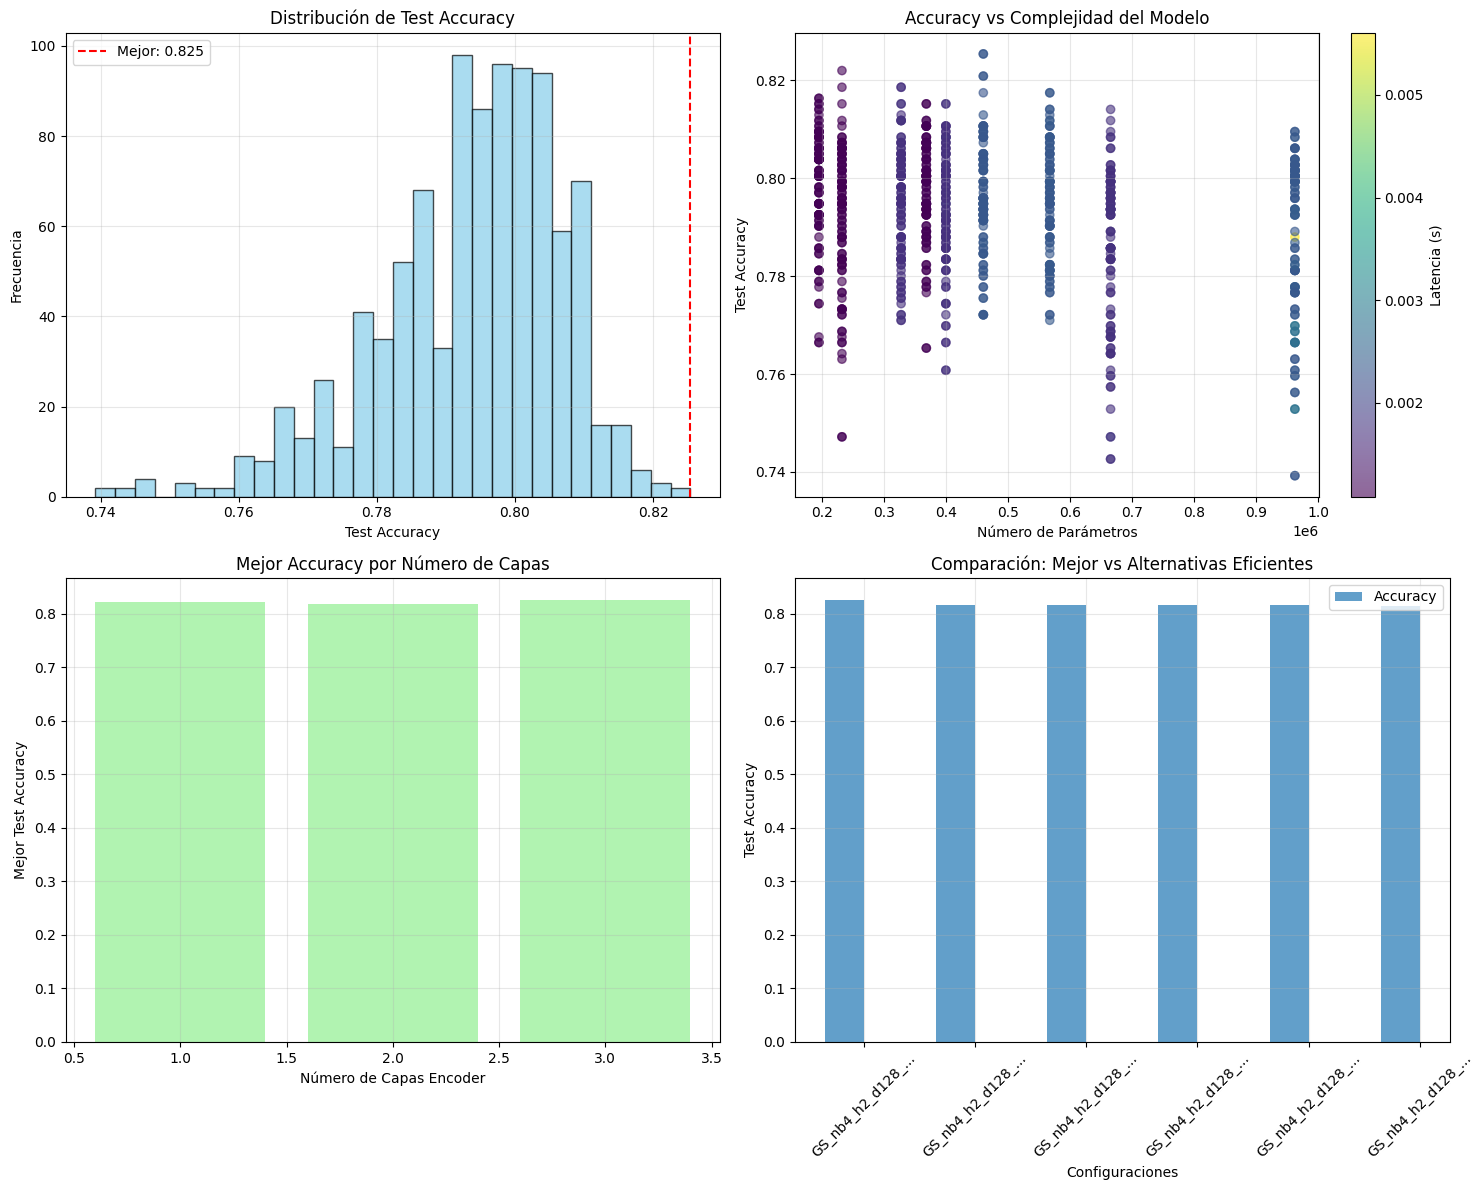


🔍 COMPARACIÓN DETALLADA:
----------------------------------------
Top 5 configuraciones:
                                            tag  test_acc  test_f1_macro  params_total  latency_s  enc_layers   d  BASE_LR  P_DROP  P_DROP_ENCODER  WARMUP_EPOCHS  PATIENCE
 GS_nb4_h2_d128_L3_lr1e-3_dp0.2_dpe0.5_wu4_pat8    0.8254         0.8254        460130     0.0023           3 128    0.001     0.2             0.5              4         8
GS_nb4_h2_d128_L3_lr1e-3_dp0.2_dpe0.5_wu4_pat12    0.8254         0.8254        460130     0.0023           3 128    0.001     0.2             0.5              4        12
GS_nb4_h2_d144_L1_lr1e-3_dp0.2_dpe0.5_wu4_pat12    0.8220         0.8220        232290     0.0011           1 144    0.001     0.2             0.5              4        12
 GS_nb4_h2_d128_L3_lr2e-3_dp0.3_dpe0.3_wu4_pat8    0.8209         0.8209        460130     0.0023           3 128    0.002     0.3             0.3              4         8
GS_nb4_h2_d128_L3_lr2e-3_dp0.3_dpe0.3_wu4_pat12   

<ipython-input-43-6b12997296e7>:167: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  efficiency_by_dim = df.groupby('d').apply(


In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_gs_results(csv_file):
    """
    Analiza los resultados de Grid Search y encuentra las mejores configuraciones
    """
    # Cargar datos
    df = pd.read_csv(csv_file)
    
    print("=" * 80)
    print("ANÁLISIS DE RESULTADOS - GRID SEARCH")
    print("=" * 80)
    
    # Mostrar información básica
    print(f"Total de configuraciones: {len(df)}")
    print(f"Columnas disponibles: {list(df.columns)}")
    print("\n" + "-" * 40)
    
    # 1. MEJORES 20 CONFIGURACIONES POR TEST ACCURACY
    print("🏆 TOP 20 MEJORES CONFIGURACIONES (Test Accuracy):")
    print("-" * 40)
    
    top_20_by_acc = df.nlargest(20, 'test_acc')[
        ['tag', 'test_acc', 'test_f1_macro', 'params_total', 'latency_s', 
         'enc_layers', 'd', 'BASE_LR', 'P_DROP', 'P_DROP_ENCODER']
    ].round(4)
    
    print(top_20_by_acc.to_string(index=False))
    
    # 2. ENCONTRAR CONFIGURACIONES SIMILARES CON MENOR COSTO
    print("\n" + "⚡ CONFIGURACIONES SIMILARES CON MENOR COSTO COMPUTACIONAL:")
    print("-" * 40)
    
    # Encontrar el mejor overall
    best_overall = df.loc[df['test_acc'].idxmax()]
    
    print(f"Mejor configuración global:")
    print(f"  Tag: {best_overall['tag']}")
    print(f"  Test Acc: {best_overall['test_acc']:.4f}")
    print(f"  Parámetros: {best_overall['params_total']:,}")
    print(f"  Latencia: {best_overall['latency_s']:.6f}s")
    
    # Filtrar configuraciones similares pero con menor costo
    similar_configs = df[
        (df['test_acc'] >= best_overall['test_acc'] - 0.02) &  # Dentro del 2% del mejor
        (df['params_total'] <= best_overall['params_total']) &  # Mismo o menor costo
        (df.index != df['test_acc'].idxmax())  # Excluir el mejor mismo
    ].copy()
    
    # Ordenar por eficiencia (accuracy/parámetros)
    similar_configs['efficiency'] = similar_configs['test_acc'] / similar_configs['params_total']
    
    print(f"\nEncontradas {len(similar_configs)} configuraciones similares con menor/mismo costo")
    
    if len(similar_configs) > 0:
        top_efficient = similar_configs.nlargest(20, 'efficiency')[
            ['tag', 'test_acc', 'test_f1_macro', 'params_total', 'latency_s', 
             'enc_layers', 'd', 'efficiency']
        ].round(4)
        
        print(top_efficient.to_string(index=False))
    else:
        print("No se encontraron configuraciones similares con menor costo")
    
    # 3. ANÁLISIS POR DIMENSIONES Y CAPAS
    print("\n" + "📊 ANÁLISIS POR DIMENSIONES Y CAPAS:")
    print("-" * 40)
    
    analysis = df.groupby(['d', 'enc_layers']).agg({
        'test_acc': ['mean', 'max', 'count'],
        'params_total': 'mean',
        'latency_s': 'mean'
    }).round(4)
    
    print(analysis.to_string())
    
    return df, top_20_by_acc, similar_configs

def plot_results(df, top_configs, similar_configs):
    """
    Crear visualizaciones de los resultados
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Distribución de accuracy
    axes[0,0].hist(df['test_acc'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0,0].axvline(df['test_acc'].max(), color='red', linestyle='--', 
                     label=f'Mejor: {df["test_acc"].max():.3f}')
    axes[0,0].set_xlabel('Test Accuracy')
    axes[0,0].set_ylabel('Frecuencia')
    axes[0,0].set_title('Distribución de Test Accuracy')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Accuracy vs Parámetros
    scatter = axes[0,1].scatter(df['params_total'], df['test_acc'], 
                               c=df['latency_s'], alpha=0.6, cmap='viridis')
    axes[0,1].set_xlabel('Número de Parámetros')
    axes[0,1].set_ylabel('Test Accuracy')
    axes[0,1].set_title('Accuracy vs Complejidad del Modelo')
    plt.colorbar(scatter, ax=axes[0,1], label='Latencia (s)')
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Mejores configuraciones por capas
    layers_acc = df.groupby('enc_layers')['test_acc'].max()
    axes[1,0].bar(layers_acc.index, layers_acc.values, color='lightgreen', alpha=0.7)
    axes[1,0].set_xlabel('Número de Capas Encoder')
    axes[1,0].set_ylabel('Mejor Test Accuracy')
    axes[1,0].set_title('Mejor Accuracy por Número de Capas')
    axes[1,0].grid(True, alpha=0.3)
    
    # 4. Comparación top configuraciones
    if len(similar_configs) > 0:
        comparison_data = pd.concat([
            df.nlargest(1, 'test_acc')[['tag', 'test_acc', 'params_total', 'latency_s']],
            similar_configs.nlargest(5, 'efficiency')[['tag', 'test_acc', 'params_total', 'latency_s']]
        ])
        
        x_pos = np.arange(len(comparison_data))
        width = 0.35
        
        axes[1,1].bar(x_pos - width/2, comparison_data['test_acc'], width, 
                     label='Accuracy', alpha=0.7)
        axes[1,1].set_xlabel('Configuraciones')
        axes[1,1].set_ylabel('Test Accuracy')
        axes[1,1].set_title('Comparación: Mejor vs Alternativas Eficientes')
        axes[1,1].set_xticks(x_pos)
        axes[1,1].set_xticklabels([tag[:15] + '...' for tag in comparison_data['tag']], 
                                 rotation=45)
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def detailed_comparison(df):
    """
    Comparación detallada de las mejores configuraciones
    """
    print("\n" + "🔍 COMPARACIÓN DETALLADA:")
    print("-" * 40)
    
    # Top 5 configuraciones
    top_5 = df.nlargest(5, 'test_acc')[
        ['tag', 'test_acc', 'test_f1_macro', 'params_total', 'latency_s',
         'enc_layers', 'd', 'BASE_LR', 'P_DROP', 'P_DROP_ENCODER', 'WARMUP_EPOCHS', 'PATIENCE']
    ].round(4)
    
    print("Top 5 configuraciones:")
    print(top_5.to_string(index=False))
    
    # Análisis de hiperparámetros óptimos
    print("\n🎯 HIPERPARÁMETROS ÓPTIMOS:")
    best_lr = df.loc[df['test_acc'].idxmax(), 'BASE_LR']
    best_dropout = df.loc[df['test_acc'].idxmax(), 'P_DROP']
    best_enc_dropout = df.loc[df['test_acc'].idxmax(), 'P_DROP_ENCODER']
    
    print(f"Learning Rate óptimo: {best_lr}")
    print(f"Dropout óptimo: {best_dropout}")
    print(f"Encoder Dropout óptimo: {best_enc_dropout}")
    
    # Eficiencia por dimensión
    print("\n💡 EFICIENCIA POR DIMENSIÓN:")
    efficiency_by_dim = df.groupby('d').apply(
        lambda x: pd.Series({
            'max_acc': x['test_acc'].max(),
            'mean_acc': x['test_acc'].mean(),
            'mean_params': x['params_total'].mean(),
            'efficiency': (x['test_acc'] / x['params_total']).max()
        })
    ).round(4)
    
    print(efficiency_by_dim)

# EJECUCIÓN PRINCIPAL
if __name__ == "__main__":
    # Cambia esta ruta por la ubicación de tu archivo CSV
    csv_file = Path("GridSearch") / "gs_results.csv"

    print(csv_file)
    
    try:
        # Ejecutar análisis
        df, top_20, similar_configs = analyze_gs_results(csv_file)
        
        # Generar gráficos
        plot_results(df, top_20, similar_configs)
        
        # Comparación detallada
        detailed_comparison(df)
        
        # Guardar resultados en archivo
        print("\n💾 Guardando resultados en 'mejores_configuraciones.csv'...")
        best_configs = pd.concat([
            df.nlargest(10, 'test_acc'),
            similar_configs.nlargest(10, 'efficiency')
        ]).drop_duplicates()
        
        best_configs.to_csv('mejores_configuraciones.csv', index=False)
        print("✅ Análisis completado y guardado!")
        
    except FileNotFoundError:
        print(f"❌ Error: No se pudo encontrar el archivo '{csv_file}'")
        print("Asegúrate de que el archivo esté en el mismo directorio o proporciona la ruta completa")
    except Exception as e:
        print(f"❌ Error durante el análisis: {e}")

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Usa las mismas constantes que ya tienes en tu código principal:
# DATA_RAW, TMIN, TMAX, EXPECTED_8, load_subject_epochs, etc.

def plot_input_example_signals(
    subject_id="S001",
    out_path="input_example_eeg.png",
    channels_to_show=("C3", "Cz", "C4")
):
    # 1) Cargar épocas de ese sujeto con tu mismo preprocesado
    X, y, sfreq = load_subject_epochs(
        subject_id=subject_id,
        resample_hz=RESAMPLE_HZ,
        do_notch=DO_NOTCH,
        do_bandpass=DO_BANDPASS,
        do_car=DO_CAR,
        bp_lo=BP_LO,
        bp_hi=BP_HI,
    )

    if len(y) == 0:
        raise RuntimeError(f"No hay épocas para {subject_id}")

    # 2) Elegir una época de cada clase (0 = left, 1 = right)
    idx_left  = np.where(y == 0)[0]
    idx_right = np.where(y == 1)[0]

    if len(idx_left) == 0 or len(idx_right) == 0:
        raise RuntimeError("Ese sujeto no tiene ambas clases L/R en las épocas cargadas.")

    iL = int(idx_left[0])
    iR = int(idx_right[0])

    epoch_left  = X[iL]   # (C, T)
    epoch_right = X[iR]   # (C, T)

    # 3) Elegir canales por nombre (si no están, usar mean)
    def get_channel_indices(names):
        idxs = []
        for ch in names:
            if ch in EXPECTED_8:
                idxs.append(EXPECTED_8.index(ch))
            else:
                # Si no existe, usa la media como fallback
                idxs.append(None)
        return idxs

    ch_idxs = get_channel_indices(channels_to_show)

    # 4) Crear figura
    fig, axes = plt.subplots(
        nrows=2, ncols=1, figsize=(7, 3.5), sharex=True,
        constrained_layout=True
    )

    t = np.linspace(TMIN, TMAX, epoch_left.shape[-1])

    def plot_epoch(ax, epoch, title, color):
        # Normalizar cada canal para que se vea bonito
        offset = 0.0
        step = 50.0  # separación vertical (arbitraria)
        for ch_name, ch_idx in zip(channels_to_show, ch_idxs):
            if ch_idx is None:
                sig = epoch.mean(axis=0)
            else:
                sig = epoch[ch_idx]

            # Z-score para que queden comparables visualmente
            sig = (sig - sig.mean()) / (sig.std() + 1e-6)
            ax.plot(t, sig * 25 + offset, color=color, linewidth=1.0, label=ch_name)
            ax.text(t[0] - 0.1*(TMAX - TMIN), offset, ch_name,
                    va="center", ha="right", fontsize=8)
            offset += step

        ax.set_title(title, fontsize=11, fontweight="bold")
        ax.set_ylabel("Amplitude (au)", fontsize=9)
        ax.grid(True, alpha=0.2)
        ax.set_yticks([])
    
    plot_epoch(axes[0], epoch_left,  "Left hand imagery",  color="#C0392B")  # rojo
    plot_epoch(axes[1], epoch_right, "Right hand imagery", color="#2980B9")  # azul

    axes[1].set_xlabel("Time (s)", fontsize=10)

    # Ajustar límites de tiempo
    axes[0].set_xlim(TMIN, TMAX)

    # Guardar figura
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.close(fig)
    print(f"Figura de ejemplo de entrada guardada en: {out_path}")


# Llamar una vez:
plot_input_example_signals(subject_id="S001",
                           out_path="input_example_eeg.png",
                           channels_to_show=("C3", "Cz", "C4"))


Figura de ejemplo de entrada guardada en: input_example_eeg.png


In [1]:
# -*- coding: utf-8 -*-
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
os.environ['PYTHONHASHSEED'] = '42'
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

import re, json, random, copy, time, csv
from pathlib import Path
from glob import glob
import numpy as np
import mne
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold

# =========================
# REPRODUCIBILIDAD
# =========================
RANDOM_STATE = 42

def seed_everything(seed: int = 42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    try:
        torch.backends.cuda.matmul.allow_tf32 = False
        torch.backends.cudnn.allow_tf32 = False
    except Exception:
        pass
    try:
        torch.use_deterministic_algorithms(True)
    except Exception:
        pass

def seed_worker(worker_id: int):
    worker_seed = RANDOM_STATE + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

seed_everything(RANDOM_STATE)

# =========================
# CONFIG
# =========================
PROJ = Path('..').resolve().parent
DATA_RAW = PROJ / 'data' / 'raw'
FOLDS_JSON = PROJ / 'models' / '00_folds' / 'Kfold5.json'

EPOCHS = 60
BATCH_SIZE = 64
BASE_LR = 5e-4
WARMUP_EPOCHS = 4
PATIENCE = 8

# Split de validación por fold (por sujetos)
VAL_SUBJECT_FRAC = 0.18
VAL_STRAT_SUBJECT = True

# Prepro global
RESAMPLE_HZ = None
DO_NOTCH = True
DO_BANDPASS = False
BP_LO, BP_HI = 4.0, 38.0
DO_CAR = False
ZSCORE_PER_EPOCH = False

# Modelo
D_MODEL = 128
N_HEADS = 4
N_LAYERS = 1
P_DROP = 0.2
P_DROP_ENCODER = 0.1

# Ventana temporal
TMIN, TMAX = -1.0, 5.0

# TTA / SUBWINDOW en TEST
SW_MODE = 'tta'   # 'none'|'subwin'|'tta'
SW_ENABLE = True
TTA_SHIFTS_S = [-0.075, -0.05, -0.025, 0.0, 0.025, 0.05, 0.075]
SW_LEN, SW_STRIDE = 4.5, 1.5
COMBINE_TTA_AND_SUBWIN = False

# Sampler balanceado
USE_WEIGHTED_SAMPLER = True

# EMA (solo GLOBAL). En FT se desactiva.
USE_EMA = True
EMA_DECAY = 0.9995

# Fine-tuning (por sujeto) — sigue activo, pero ahora con n_cls=2
FT_N_FOLDS = 4
FT_FREEZE_EPOCHS = 8
FT_UNFREEZE_EPOCHS = 8
FT_PATIENCE = 6
FT_BATCH = 64
FT_LR_HEAD = 1e-3
FT_LR_BACKBONE = 2e-4
FT_WD = 1e-3
FT_AUG = dict(p_jitter=0.25, p_noise=0.25, p_chdrop=0.10, max_jitter_frac=0.02, noise_std=0.02, max_chdrop=1)

EXCLUDE_SUBJECTS = {38, 88, 89, 92, 100, 104}
CLASS_NAMES = ['left', 'right']  # <-- 2 clases

# Solo runs de imaginación L/R
IMAGERY_RUNS_LR = {4, 8, 12}

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# =========================
# CANALES (64 canales)
# =========================
def normalize_ch_name(name: str) -> str:
    s = re.sub(r'[^A-Za-z0-9]', '', name)
    return s.upper()

# Lista estándar de 64 canales (normalizada)
EXPECTED_64 = [
    'FC5','FC3','FC1','FCZ','FC2','FC4','FC6',
    'C5','C3','C1','CZ','C2','C4','C6',
    'CP5','CP3','CP1','CPZ','CP2','CP4','CP6',
    'FP1','FPZ','FP2',
    'AF7','AF3','AFZ','AF4','AF8',
    'F7','F5','F3','F1','FZ','F2','F4','F6','F8',
    'FT7','FT8',
    'T7','T8','T9','T10',
    'TP7','TP8',
    'P7','P5','P3','P1','PZ','P2','P4','P6','P8',
    'PO7','PO3','POZ','PO4','PO8',
    'O1','OZ','O2','IZ'
]
N_CHANNELS = len(EXPECTED_64)
NORMALIZED_TARGETS = [normalize_ch_name(c) for c in EXPECTED_64]

def pick_64_channels(raw: mne.io.BaseRaw) -> mne.io.BaseRaw:
    """Selecciona exactamente los 64 canales en EXPECTED_64, respetando ese orden."""
    chs = raw.info['ch_names']
    norm_map = {normalize_ch_name(ch): ch for ch in chs}
    picked = []
    for target_norm, target_orig in zip(NORMALIZED_TARGETS, EXPECTED_64):
        if target_norm in norm_map:
            picked.append(norm_map[target_norm])
        else:
            raise RuntimeError(f"Canal requerido '{target_orig}' no encontrado. Disponibles: {chs}")
    return raw.pick(picks=picked)

print(f"🚀 Usando dispositivo: {DEVICE}")
print("🧠 INICIANDO EXPERIMENTO CON CNN+Transformer (K-Fold por sujeto)")
print(f"🔧 Config: 2c (L/R), {N_CHANNELS} canales, 6s | EPOCHS={EPOCHS}, BATCH={BATCH_SIZE}, LR={BASE_LR} | ZSCORE_PER_EPOCH={ZSCORE_PER_EPOCH}")

# =========================
# UTILIDADES I/O
# =========================
def list_subject_imagery_edfs(subject_id: str) -> list:
    subj_dir = DATA_RAW / subject_id
    edfs = []
    for r in [4, 6, 8, 10, 12, 14]:
        edfs.extend(glob(str(subj_dir / f"{subject_id}R{r:02d}.edf")))
    return sorted(edfs)

def subject_id_to_int(s: str) -> int:
    m = re.match(r'[Ss](\d+)', s)
    return int(m.group(1)) if m else -1

def load_subject_epochs(subject_id: str, resample_hz: int, do_notch: bool, do_bandpass: bool,
                        do_car: bool, bp_lo: float, bp_hi: float):
    edfs = list_subject_imagery_edfs(subject_id)
    if len(edfs) == 0:
        return np.empty((0,N_CHANNELS,1), dtype=np.float32), np.empty((0,), dtype=int), None

    X_list, y_list, sfreq_list = [], [], []
    for edf_path in edfs:
        m = re.search(r"R(\d{2})", Path(edf_path).name)
        run = int(m.group(1)) if m else -1

        # Usar SOLO runs L/R
        if run not in IMAGERY_RUNS_LR:
            continue

        raw = mne.io.read_raw_edf(edf_path, preload=True, verbose='ERROR')
        raw = pick_64_channels(raw)  # <<< AQUÍ SE FUERZAN LOS 64 CANALES

        if do_notch:
            raw.notch_filter(freqs=[60.0], picks='all', verbose='ERROR')
        if do_bandpass:
            raw.filter(l_freq=bp_lo, h_freq=bp_hi, picks='all', verbose='ERROR')
        if do_car:
            raw.set_eeg_reference('average', projection=False, verbose='ERROR')
        if resample_hz is not None and resample_hz > 0:
            raw.resample(resample_hz)

        sfreq = raw.info['sfreq']
        events, event_id = mne.events_from_annotations(raw, verbose='ERROR')

        keep = {k: v for k, v in event_id.items() if k in {'T1', 'T2'}}
        if len(keep) == 0:
            continue

        epochs = mne.Epochs(raw, events=events, event_id=keep, tmin=TMIN, tmax=TMAX,
                            baseline=None, preload=True, verbose='ERROR')
        X = epochs.get_data()

        if ZSCORE_PER_EPOCH:
            X = X.astype(np.float32)
            eps = 1e-6
            mu = X.mean(axis=2, keepdims=True)
            sd = X.std(axis=2, keepdims=True) + eps
            X = (X - mu) / sd

        ev_codes = epochs.events[:, 2]
        inv = {v: k for k, v in keep.items()}
        y_run = np.array([0 if inv[c] == 'T1' else 1 for c in ev_codes], dtype=int)

        X_list.append(X)
        y_list.append(y_run)
        sfreq_list.append(sfreq)

    if len(X_list) == 0:
        return np.empty((0,N_CHANNELS,1), dtype=np.float32), np.empty((0,), dtype=int), None

    X_all = np.concatenate(X_list, axis=0).astype(np.float32)
    y_all = np.concatenate(y_list, axis=0).astype(int)

    if len(set([int(round(s)) for s in sfreq_list])) != 1:
        raise RuntimeError(f"Sampling rates inconsistentes: {sfreq_list}")

    return X_all, y_all, sfreq_list[0]

def load_fold_subjects(folds_json: Path, fold: int):
    with open(folds_json, 'r') as f:
        data = json.load(f)
    for item in data.get('folds', []):
        if int(item.get('fold', -1)) == int(fold):
            return list(item.get('train', [])), list(item.get('test', []))
    raise ValueError(f"Fold {fold} not found in {folds_json}")

def standardize_per_channel(train_X, other_X):
    C = train_X.shape[1]
    train_X = train_X.astype(np.float32)
    other_X = other_X.astype(np.float32)
    for c in range(C):
        mu = train_X[:, c, :].mean()
        sd = train_X[:, c, :].std()
        sd = sd if sd > 1e-6 else 1.0
        train_X[:, c, :] = (train_X[:, c, :] - mu) / sd
        other_X[:, c, :] = (other_X[:, c, :] - mu) / sd
    return train_X, other_X

# =========================
# MODELO (GroupNorm en conv) con capturas y variaciones
# =========================
def make_gn(num_channels, num_groups=8):
    g = min(num_groups, num_channels)
    while num_channels % g != 0 and g > 1:
        g -= 1
    return nn.GroupNorm(g, num_channels)

class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_ch, out_ch, k, s=1, p=0, p_drop=0.2):
        super().__init__()
        self.dw = nn.Conv1d(in_ch, in_ch, kernel_size=k, stride=s, padding=p, groups=in_ch, bias=False)
        self.pw = nn.Conv1d(in_ch, out_ch, kernel_size=1, bias=False)
        self.norm = make_gn(out_ch)
        self.act = nn.ELU()
        self.dropout = nn.Dropout(p=p_drop)

    def forward(self, x):
        x = self.dw(x); x = self.pw(x); x = self.norm(x)
        x = self.act(x); x = self.dropout(x)
        return x

class _CustomEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward, dropout, batch_first, norm_first, return_attn=True):
        super().__init__()
        self.return_attn = return_attn
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=batch_first)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.activation = nn.GELU()
        self.norm_first = norm_first

    def forward(self, src):
        sa_out, attn_weights = self.self_attn(src, src, src, need_weights=True, average_attn_weights=False)
        src = self.norm1(src + self.dropout1(sa_out))
        ff = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = self.norm2(src + self.dropout2(ff))
        return src, attn_weights  # [B, heads, T, T]

class _CustomEncoder(nn.Module):
    def __init__(self, layer, num_layers):
        super().__init__()
        self.layers = nn.ModuleList([copy.deepcopy(layer) for _ in range(num_layers)])

    def forward(self, src):
        attn_list = []
        out = src
        for lyr in self.layers:
            out, attn = lyr(out)
            attn_list.append(attn)
        return out, attn_list

class EEGCNNTransformer(nn.Module):
    def __init__(self, n_ch=N_CHANNELS, n_cls=2, d_model=128, n_heads=4, n_layers=2,
                 p_drop=0.2, p_drop_encoder=0.3, n_dw_blocks=2,
                 k_list=(31,15,7), s_list=(2,2,2), p_list=(15,7,3), capture_attn=False):
        super().__init__()
        self.capture_attn = capture_attn
        self._last_attn = None
        self.pos_encoding = None

        stem = [
            nn.Conv1d(n_ch, 32, kernel_size=129, stride=2, padding=64, bias=False),
            make_gn(32),
            nn.ELU(),
            nn.Dropout(p=p_drop),
        ]
        blocks = []
        in_c, out_cs = 32, [64, 128, 256, 256, 256]
        n_dw_blocks = int(np.clip(n_dw_blocks, 0, len(out_cs)))
        for i in range(n_dw_blocks):
            k = k_list[i] if i < len(k_list) else 7
            s = s_list[i] if i < len(s_list) else 2
            p = p_list[i] if i < len(p_list) else k//2
            blocks.append(DepthwiseSeparableConv(in_c, out_cs[i], k=k, s=s, p=p, p_drop=p_drop))
            in_c = out_cs[i]

        self.conv_t = nn.Sequential(*stem, *blocks)
        self.proj = nn.Conv1d(in_c if n_dw_blocks>0 else 32, d_model, kernel_size=1, bias=False)
        self.dropout = nn.Dropout(p=p_drop_encoder)

        enc = _CustomEncoderLayer(d_model=d_model, nhead=n_heads, dim_feedforward=2*d_model,
                                  dropout=0.1, batch_first=True, norm_first=False, return_attn=True)
        self.encoder = _CustomEncoder(enc, num_layers=n_layers)

        self.cls = nn.Parameter(torch.zeros(1, 1, d_model))
        nn.init.normal_(self.cls, std=0.02)
        self.head = nn.Sequential(nn.LayerNorm(d_model), nn.Linear(d_model, n_cls))

    def _positional_encoding(self, L, d):
        pos = torch.arange(0, L, dtype=torch.float32).unsqueeze(1)
        i   = torch.arange(0, d, dtype=torch.float32).unsqueeze(0)
        angle = pos / torch.pow(10000, (2 * (i//2)) / d)
        pe = torch.zeros(L, d, dtype=torch.float32)
        pe[:, 0::2] = torch.sin(angle[:, 0::2])
        pe[:, 1::2] = torch.cos(angle[:, 1::2])
        return pe

    def forward(self, x):
        z = self.conv_t(x)           # (B, C', T')
        z = self.proj(z)             # (B, d_model, T')
        z = self.dropout(z)
        z = z.transpose(1, 2)        # (B, T', d_model)
        B, L, D = z.shape
        if (self.pos_encoding is None) or (self.pos_encoding.shape[0] != L) or (self.pos_encoding.shape[1] != D):
            self.pos_encoding = self._positional_encoding(L, D).to(z.device)
        z = z + self.pos_encoding[None, :, :]
        cls_tok = self.cls.expand(B, -1, -1)
        z = torch.cat([cls_tok, z], dim=1)  # (B, 1+L, D)

        z, attn_list = self.encoder(z)
        if self.capture_attn:
            self._last_attn = attn_list

        cls = z[:, 0, :]
        return self.head(cls)

    def get_last_attention_maps(self):
        return self._last_attn

# =========================
# FOCAL LOSS (2 clases)
# =========================
class FocalLoss(nn.Module):
    def __init__(self, alpha: torch.Tensor, gamma: float = 1.5, reduction: str = 'mean'):
        super().__init__()
        self.alpha = alpha / alpha.sum()
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, target):
        logp = nn.functional.log_softmax(logits, dim=-1)      # (B,C)
        p = logp.exp()
        idx = torch.arange(target.shape[0], device=logits.device)
        pt = p[idx, target]
        logpt = logp[idx, target]
        at = self.alpha[target]
        loss = - at * ((1 - pt) ** self.gamma) * logpt
        if self.reduction == 'mean': return loss.mean()
        if self.reduction == 'sum':  return loss.sum()
        return loss

# =========================
# AUGMENTS
# =========================
def augment_batch(xb, p_jitter=0.35, p_noise=0.35, p_chdrop=0.15,
                  max_jitter_frac=0.03, noise_std=0.03, max_chdrop=1):
    B, C, T = xb.shape
    if np.random.rand() < p_jitter:
        max_shift = int(max(1, T*max_jitter_frac))
        shifts = torch.randint(low=-max_shift, high=max_shift+1, size=(B,), device=xb.device)
        for i in range(B):
            xb[i] = torch.roll(xb[i], shifts=int(shifts[i].item()), dims=-1)
    if np.random.rand() < p_noise:
        xb = xb + noise_std*torch.randn_like(xb)
    if np.random.rand() < p_chdrop and max_chdrop > 0:
        k = min(max_chdrop, C)
        for i in range(B):
            idx = torch.randperm(C, device=xb.device)[:k]
            xb[i, idx, :] = 0.0
    return xb

def augment_batch_ft(xb):
    return augment_batch(xb, **FT_AUG)

# =========================
# EMA de pesos (solo global)
# =========================
class ModelEMA:
    def __init__(self, model: nn.Module, decay: float = 0.9995, device=None):
        self.ema = self._clone(model).to(device if device is not None else next(model.parameters()).device)
        self.decay = decay
        self._updates = 0
        self.update(model, force=True)

    def _clone(self, model):
        import copy
        ema = copy.deepcopy(model)
        for p in ema.parameters():
            p.requires_grad_(False)
        return ema

    @torch.no_grad()
    def update(self, model: nn.Module, force: bool = False):
        d = self.decay
        if self._updates < 1000:
            d = (self._updates / 1000.0) * self.decay
        msd = model.state_dict()
        esd = self.ema.state_dict()
        for k in esd.keys():
            if esd[k].dtype.is_floating_point:
                esd[k].mul_(d).add_(msd[k].detach(), alpha=1.0 - d)
            else:
                esd[k] = msd[k]
        self._updates += 1

# =========================
# INFERENCIA TTA / SUBWINDOW
# =========================
def subwindow_logits(model, X, sfreq, sw_len, sw_stride, device):
    model.eval()
    wl = int(round(sw_len * sfreq))
    st = int(round(sw_stride * sfreq))
    wl = max(1, min(wl, X.shape[-1])); st = max(1, st)
    out = []
    with torch.no_grad():
        for i in range(X.shape[0]):
            x = X[i]; acc = []
            for s in range(0, max(1, X.shape[-1]-wl+1), st):
                seg = x[:, s:s+wl]
                if seg.shape[-1] < wl:
                    pad = wl - seg.shape[-1]
                    seg = np.pad(seg, ((0,0),(0,pad)), mode='edge')
                xb = torch.tensor(seg[None, ...], dtype=torch.float32, device=device)
                logit = model(xb).detach().cpu().numpy()[0]
                acc.append(logit)
            acc = np.mean(np.stack(acc, axis=0), axis=0) if len(acc) else np.zeros(2, dtype=np.float32)
            out.append(acc)
    return np.stack(out, axis=0)

def time_shift_tta_logits(model, X, sfreq, shifts_s, device):
    model.eval()
    T = X.shape[-1]; out = []
    with torch.no_grad():
        for i in range(X.shape[0]):
            x0 = X[i]; acc = []
            for sh in shifts_s:
                shift = int(round(sh * sfreq))
                if shift == 0:
                    x = x0
                elif shift > 0:
                    x = np.pad(x0[:, shift:], ((0,0),(0,shift)), mode='edge')[:, :T]
                else:
                    shift = -shift
                    x = np.pad(x0[:, :-shift], ((0,0),(shift,0)), mode='edge')[:, :T]
                xb = torch.tensor(x[None, ...], dtype=torch.float32, device=device)
                logit = model(xb).detach().cpu().numpy()[0]
                acc.append(logit)
            out.append(np.mean(np.stack(acc, axis=0), axis=0))
    return np.stack(out, axis=0)

# =========================
# Métricas extendidas
# =========================
def compute_metrics(y_true, y_pred):
    prec_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    rec_macro  = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1_macro   = f1_score(y_true, y_pred, average='macro', zero_division=0)

    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    TN0 = cm[1,1]; FP0 = cm[1,0]
    spec0 = TN0 / (TN0 + FP0 + 1e-12)
    TN1 = cm[0,0]; FP1 = cm[0,1]
    spec1 = TN1 / (TN1 + FP1 + 1e-12)
    spec_macro = (spec0 + spec1) / 2.0

    recs = recall_score(y_true, y_pred, labels=[0,1], average=None, zero_division=0)
    sens_macro = float(recs.mean())

    return {
        "precision_macro": float(prec_macro),
        "recall_macro": float(rec_macro),
        "f1_macro": float(f1_macro),
        "specificity_macro": float(spec_macro),
        "sensitivity_macro": float(sens_macro),
        "cm": cm.tolist()
    }

# =========================
# Helper: matriz de confusión con anotaciones
# =========================
def plot_confusion_with_text(cm, class_names, title, out_path, cmap='Blues'):
    fig, ax = plt.subplots(figsize=(4.8, 4.2))
    im = ax.imshow(cm, cmap=cmap)
    ax.set_title(title)
    ax.set_xlabel("Predicción")
    ax.set_ylabel("Etiqueta verdadera")
    ax.set_xticks(range(len(class_names))); ax.set_xticklabels(class_names)
    ax.set_yticks(range(len(class_names))); ax.set_yticklabels(class_names)

    vmax = cm.max() if cm.size else 1
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, str(cm[i, j]),
                    ha='center', va='center',
                    color='white' if cm[i, j] > vmax/2 else 'black',
                    fontsize=11, fontweight='bold')

    plt.tight_layout()
    plt.savefig(out_path, dpi=140)
    plt.close(fig)

# =========================
# Interpretabilidad: Grad-CAM++ 1D sobre conv_t
# =========================
def gradcampp_1d(model, x, target_class=1):
    model.eval()
    feats = {}
    grads = {}

    def f_hook(m, inp, out):
        feats['f'] = out.detach()

    def b_hook(m, gin, gout):
        grads['g'] = gout[0].detach()

    handle_f = model.conv_t.register_forward_hook(f_hook)
    handle_b = model.conv_t.register_full_backward_hook(b_hook)

    logits = model(x)
    cls = target_class if isinstance(target_class, int) else int(logits.argmax(1).item())
    score = logits[:, cls].sum()
    model.zero_grad(set_to_none=True)
    score.backward(retain_graph=True)

    F = feats['f'][0]  # (C', T')
    G = grads['g'][0]  # (C', T')
    eps = 1e-8
    alpha_num = (G**2)
    alpha_den = 2*(G**2) + (F*G**3).sum(dim=-1, keepdims=True) + eps
    alpha = alpha_num / alpha_den
    weights = (alpha.clamp(min=0) * G.clamp(min=0)).sum(dim=-1)  # (C',)

    cam = (weights[:, None] * F).sum(dim=0)   # (T',)
    cam = torch.relu(cam)
    cam = (cam - cam.min()) / (cam.max() - cam.min() + eps)

    handle_f.remove(); handle_b.remove()
    return cam.cpu().numpy()

# ===== Helpers para overlay CAM y grid por sujetos =====
def _upsample_cam_to_signal(cam_vec, T):
    x_src = np.linspace(0.0, 1.0, num=len(cam_vec))
    x_tgt = np.linspace(0.0, 1.0, num=T)
    return np.interp(x_tgt, x_src, cam_vec)

def _plot_overlay_one(ax, x_epoch, cam_vec, sfreq, tmin, title, channel_mode="mean", cls_idx=None):
    """
    cls_idx: 0 -> left (verde), 1 -> right (azul)
    """
    C, T = x_epoch.shape
    cam_T = _upsample_cam_to_signal(cam_vec, T)
    cam_T = (cam_T - cam_T.min()) / (cam_T.max() - cam_T.min() + 1e-8)

    if channel_mode == "mean":
        sig = x_epoch.mean(axis=0)
        sig_label = "mean(64ch)"
    elif isinstance(channel_mode, int):
        sig = x_epoch[channel_mode]; sig_label = f"ch#{channel_mode}"
    else:
        # Si se pasa un nombre de canal, intentar mapear usando EXPECTED_64
        ch_name_norm = normalize_ch_name(str(channel_mode))
        if ch_name_norm in NORMALIZED_TARGETS:
            idx = NORMALIZED_TARGETS.index(ch_name_norm)
            sig = x_epoch[idx]
            sig_label = str(channel_mode)
        else:
            sig = x_epoch.mean(axis=0)
            sig_label = "mean(64ch)"

    t = tmin + np.arange(T) / float(sfreq)
    thr = np.quantile(cam_T, 0.80)
    mask = cam_T >= thr

    # Colores según clase
    color_map = {0: "green", 1: "blue"}
    sig_color = color_map.get(cls_idx, "black")

    # Señal EEG
    ax.plot(t, sig, label=f"EEG ({sig_label})", color=sig_color)

    # Zona de alta importancia Grad-CAM++ en rojo
    ax.fill_between(
        t,
        sig.min(),
        sig.max(),
        where=mask,
        alpha=0.25,
        color="red",
        label="Alta importancia (Grad-CAM++)"
    )

    ax.set_title(title)
    ax.set_ylabel("EEG (z)")
    ax.grid(True, alpha=0.25)

    # CAM normalizado en eje secundario
    ax2 = ax.twinx()
    ax2.plot(t, cam_T, linestyle="--", alpha=0.6, label="CAM (norm.)")
    ax2.set_ylim(0, 1.05); ax2.set_ylabel("CAM")
    h1,l1 = ax.get_legend_handles_labels(); h2,l2 = ax2.get_legend_handles_labels()
    ax.legend(h1+h2, l1+l2, loc="upper left")

def save_cam_grid_for_5_subjects(X_te_std, y_te, sub_te, model_to_probe, sfreq_eff, fold, run_tag,
                                 n_subjects=5, channel_mode="mean", out_dir: Path = None):
    """
    Genera un grid de Grad-CAM++ en TEST usando SOLO ejemplos correctamente clasificados.
    Guarda el PNG en out_dir (si se pasa), o en el cwd en caso contrario.
    """
    model_to_probe.eval()
    rng = np.random.RandomState(RANDOM_STATE + 1000 + fold)
    out_base = Path(".") if out_dir is None else Path(out_dir)

    # 1) Ejecutar el modelo sobre TODO el test para obtener predicciones
    with torch.no_grad():
        logits_chunks = []
        for i in range(0, len(X_te_std), 64):
            xb = torch.tensor(X_te_std[i:i+64], dtype=torch.float32, device=DEVICE)
            logits_chunks.append(model_to_probe(xb).cpu().numpy())
        logits = np.concatenate(logits_chunks, axis=0)
    preds = logits.argmax(axis=1)
    correct_mask = (preds == y_te)

    # 2) Filtrar solo aciertos
    if correct_mask.sum() == 0:
        print("[WARN] No hay ejemplos correctamente clasificados en TEST; no se genera grid.")
        return

    X_corr   = X_te_std[correct_mask]
    y_corr   = y_te[correct_mask]
    sub_corr = sub_te[correct_mask]

    uniq_subjects = np.unique(sub_corr)
    if len(uniq_subjects) == 0:
        print("[WARN] No hay sujetos con aciertos; no se genera grid.")
        return

    sel_subjects = rng.choice(uniq_subjects, size=min(n_subjects, len(uniq_subjects)), replace=False)
    print(f"[INFO] Grid con {len(sel_subjects)} sujetos (solo aciertos).")

    fig, axes = plt.subplots(len(sel_subjects), 1, figsize=(10, 2.8*len(sel_subjects)), sharex=True)
    if len(sel_subjects) == 1:
        axes = [axes]

    for ax, s in zip(axes, sel_subjects):
        idxs = np.where(sub_corr == s)[0]
        if len(idxs) == 0:
            ax.set_visible(False)
            continue

        # Elegir UN ejemplo correcto al azar de ese sujeto
        i_local = int(rng.choice(idxs, size=1)[0])

        x_epoch = X_corr[i_local]  # (C,T)
        true_cls = int(y_corr[i_local])

        # Recalcular pred para ese ejemplo (consistencia) y usarlo como target del CAM
        xb = torch.tensor(x_epoch[None, ...], dtype=torch.float32, device=DEVICE)
        with torch.no_grad():
            pred_cls = int(model_to_probe(xb).argmax(1).item())

        # Solo por seguridad: si por alguna razón no coincide, saltar
        if pred_cls != true_cls:
            continue

        cam_vec = gradcampp_1d(model_to_probe, xb, target_class=pred_cls)
        title = f"Sujeto S{int(s):03d}  |  correcto ({CLASS_NAMES[true_cls]})"
        _plot_overlay_one(
            ax,
            x_epoch,
            cam_vec,
            sfreq=sfreq_eff,
            tmin=TMIN,
            title=title,
            channel_mode=channel_mode,
            cls_idx=true_cls  # <<< color verde/azul según clase
        )

    axes[-1].set_xlabel("Tiempo (s)")
    plt.suptitle(f"EEG + Grad-CAM++ (aciertos) — Fold {fold}  [{run_tag}]", y=1.02, fontsize=12)
    plt.tight_layout()

    out_png = out_base / f"eeg_cam_grid5_correct_fold{fold}_{run_tag}.png"
    plt.savefig(out_png, dpi=140, bbox_inches="tight")
    plt.close(fig)
    print(f"↳ Grid (solo CORRECTOS) guardado: {out_png}")

# =========================
# Consumo / hiperparámetros
# =========================
def count_params(model, trainable_only=False):
    if trainable_only:
        return int(sum(p.numel() for p in model.parameters() if p.requires_grad))
    return int(sum(p.numel() for p in model.parameters()))

def estimate_transformer_flops(L, d, n_heads, n_layers):
    d_ff = 2*d
    proj = 4 * L * (d*d)         # Q,K,V,Out
    attn = 2 * (L*L*d)           # scores + aplicar a V
    ff   = 2 * L * (d * d_ff)    # FFN (2 lineales)
    return n_layers * (proj + attn + ff)

@torch.no_grad()
def benchmark_latency(model, X_sample, device, n_warm=10, n_runs=50):
    if torch.is_tensor(X_sample):
        xb = X_sample.clone().detach().to(device)
    else:
        xb = torch.tensor(X_sample, dtype=torch.float32, device=device).clone().detach()

    for _ in range(n_warm):
        _ = model(xb)
    if torch.cuda.is_available():
        torch.cuda.synchronize()

    t0 = time.time()
    for _ in range(n_runs):
        _ = model(xb)
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    return (time.time() - t0) / n_runs

def current_hparams():
    return {
        "EPOCHS": EPOCHS, "BATCH_SIZE": BATCH_SIZE, "BASE_LR": BASE_LR,
        "WARMUP_EPOCHS": WARMUP_EPOCHS, "PATIENCE": PATIENCE,
        "RESAMPLE_HZ": RESAMPLE_HZ, "DO_NOTCH": DO_NOTCH, "DO_BANDPASS": DO_BANDPASS,
        "BP_LO": BP_LO, "BP_HI": BP_HI, "DO_CAR": DO_CAR, "ZSCORE_PER_EPOCH": ZSCORE_PER_EPOCH,
        "D_MODEL": D_MODEL, "N_HEADS": N_HEADS, "N_LAYERS": N_LAYERS,
        "P_DROP": P_DROP, "P_DROP_ENCODER": P_DROP_ENCODER,
        "TMIN": TMIN, "TMAX": TMAX, "SW_MODE": SW_MODE, "SW_ENABLE": SW_ENABLE,
        "TTA_SHIFTS_S": TTA_SHIFTS_S, "SW_LEN": SW_LEN, "SW_STRIDE": SW_STRIDE,
        "COMBINE_TTA_AND_SUBWIN": COMBINE_TTA_AND_SUBWIN,
        "USE_WEIGHTED_SAMPLER": USE_WEIGHTED_SAMPLER,
        "USE_EMA": USE_EMA, "EMA_DECAY": EMA_DECAY,
        "FT_N_FOLDS": FT_N_FOLDS, "FT_FREEZE_EPOCHS": FT_FREEZE_EPOCHS, "FT_UNFREEZE_EPOCHS": FT_UNFREEZE_EPOCHS,
        "FT_PATIENCE": FT_PATIENCE, "FT_BATCH": FT_BATCH, "FT_LR_HEAD": FT_LR_HEAD,
        "FT_LR_BACKBONE": FT_LR_BACKBONE, "FT_WD": FT_WD, "FT_AUG": FT_AUG,
    }

# =========================
# Helpers de salida/archivos
# =========================
def ensure_dir(p: Path):
    p.mkdir(parents=True, exist_ok=True)
    return p

def make_run_dirs(base_dir: Path, tag: str, fold: int):
    """Devuelve (run_dir, fold_dir)."""
    run_dir = ensure_dir(base_dir / tag)
    fold_dir = ensure_dir(run_dir / f"fold{fold}")
    return run_dir, fold_dir

def save_csv_rows(csv_path: Path, fieldnames: list, rows: list):
    write_header = not csv_path.exists()
    with open(csv_path, "a", newline="") as f:
        w = csv.DictWriter(f, fieldnames=fieldnames)
        if write_header:
            w.writeheader()
        for r in rows:
            w.writerow(r)

# =========================
# TRAIN/EVAL GLOBAL POR FOLD
# =========================
def train_one_fold(
    fold:int,
    device,
    model_factory=None,
    run_tag="base",
    out_dir: Path = None,
    seed=None,
    save_artifacts: bool = True,   # NUEVO
    do_ft: bool = True             # NUEVO
):
    # Semilla fija por corrida (justa entre combos/folds)
    base = RANDOM_STATE if seed is None else int(seed)
    seed_everything(base)

    def load_fold_subjects_local(folds_json: Path, fold: int):
        return load_fold_subjects(folds_json, fold)

    # --- directorios de salida ---
    if save_artifacts:
        base_out = Path(".") if out_dir is None else Path(out_dir)
        run_dir, fold_dir = make_run_dirs(base_out, run_tag, fold)
        print(f"[IO] Guardando artefactos en: {fold_dir.resolve()}")
    else:
        run_dir = None
        fold_dir = None
        print("[LITE] GridSearch: no se guardarán artefactos por combinación.")

    # --- split de sujetos ---
    train_sub, test_sub = load_fold_subjects_local(FOLDS_JSON, fold)
    train_sub = [s for s in train_sub if subject_id_to_int(s) not in EXCLUDE_SUBJECTS]
    test_sub  = [s for s in test_sub  if subject_id_to_int(s) not in EXCLUDE_SUBJECTS]

    rng = np.random.RandomState(RANDOM_STATE + fold)
    tr_subjects = sorted(train_sub)

    if VAL_STRAT_SUBJECT and len(tr_subjects) > 1:
        y_dom = build_subject_label_map(tr_subjects)
        if np.any(y_dom < 0):
            mask = y_dom >= 0
            moda = int(np.bincount(y_dom[mask]).argmax()) if mask.sum() > 0 else 0
            y_dom[~mask] = moda
        n_val_subj = max(1, int(round(len(tr_subjects) * VAL_SUBJECT_FRAC)))
        sss = StratifiedShuffleSplit(n_splits=1, test_size=n_val_subj, random_state=RANDOM_STATE + fold)
        idx = np.arange(len(tr_subjects))
        _, val_idx = next(sss.split(idx, y_dom))
        val_subjects = sorted([tr_subjects[i] for i in val_idx])
        train_subjects = [s for s in tr_subjects if s not in val_subjects]
    else:
        tr_subjects_shuf = tr_subjects.copy()
        rng.shuffle(tr_subjects_shuf)
        n_val_subj = max(1, int(round(len(tr_subjects_shuf) * VAL_SUBJECT_FRAC)))
        val_subjects = sorted(tr_subjects_shuf[:n_val_subj])
        train_subjects = sorted(tr_subjects_shuf[n_val_subj:])

    # --- carga de datos ---
    X_tr_list, y_tr_list, sub_tr_list = [], [], []
    X_val_list, y_val_list, sub_val_list = [], [], []
    X_te_list, y_te_list, sub_te_list = [], [], []
    sfreq = None

    for sid in tqdm(train_subjects, desc=f"Cargando train fold{fold}"):
        Xs, ys, sf = load_subject_epochs(sid, RESAMPLE_HZ, DO_NOTCH, DO_BANDPASS, DO_CAR, BP_LO, BP_HI)
        if len(ys) == 0: continue
        X_tr_list.append(Xs); y_tr_list.append(ys)
        sub_tr_list.append(np.full_like(ys, fill_value=subject_id_to_int(sid)))
        sfreq = sf if sfreq is None else sfreq

    for sid in tqdm(val_subjects, desc=f"Cargando val fold{fold}"):
        Xs, ys, sf = load_subject_epochs(sid, RESAMPLE_HZ, DO_NOTCH, DO_BANDPASS, DO_CAR, BP_LO, BP_HI)
        if len(ys) == 0: continue
        X_val_list.append(Xs); y_val_list.append(ys)
        sub_val_list.append(np.full_like(ys, fill_value=subject_id_to_int(sid)))
        sfreq = sf if sfreq is None else sfreq

    for sid in tqdm(test_sub, desc=f"Cargando test fold{fold}"):
        Xs, ys, sf = load_subject_epochs(sid, RESAMPLE_HZ, DO_NOTCH, DO_BANDPASS, DO_CAR, BP_LO, BP_HI)
        if len(ys) == 0: continue
        X_te_list.append(Xs); y_te_list.append(ys)
        sub_te_list.append(np.full_like(ys, fill_value=subject_id_to_int(sid)))
        sfreq = sf if sfreq is None else sfreq

    # Concatenar
    X_tr = np.concatenate(X_tr_list, axis=0); y_tr = np.concatenate(y_tr_list, axis=0)
    sub_tr = np.concatenate(sub_tr_list, axis=0)
    X_val = np.concatenate(X_val_list, axis=0); y_val = np.concatenate(y_val_list, axis=0)
    sub_val = np.concatenate(sub_val_list, axis=0)
    X_te = np.concatenate(X_te_list, axis=0); y_te = np.concatenate(y_te_list, axis=0)
    sub_te = np.concatenate(sub_te_list, axis=0)

    print(f"[Fold {fold}/5] Entrenando modelo global... (n_train={len(y_tr)} | n_val={len(y_val)} | n_test={len(y_te)})")

    # Normalización por canal
    if ZSCORE_PER_EPOCH:
        X_tr_std, X_val_std, X_te_std = X_tr, X_val, X_te
    else:
        X_tr_std, X_val_std = standardize_per_channel(X_tr, X_val)
        _,        X_te_std  = standardize_per_channel(X_tr, X_te)

    # Datasets
    tr_ds  = TensorDataset(torch.tensor(X_tr_std),  torch.tensor(y_tr).long(),  torch.tensor(sub_tr).long())
    val_ds = TensorDataset(torch.tensor(X_val_std), torch.tensor(y_val).long(), torch.tensor(sub_val).long())
    te_ds  = TensorDataset(torch.tensor(X_te_std),  torch.tensor(y_te).long(),  torch.tensor(sub_te).long())

    # Weighted sampler
    def make_weighted_sampler(dataset: TensorDataset):
        _Xb, yb, sb = dataset.tensors
        yb_np = yb.numpy()
        sb_np = sb.numpy()
        uniq_s, cnt_s = np.unique(sb_np, return_counts=True)
        map_s = {s:c for s,c in zip(uniq_s, cnt_s)}
        key = sb_np.astype(np.int64) * 10 + yb_np.astype(np.int64)
        uniq_k, cnt_k = np.unique(key, return_counts=True)
        map_k = {k:c for k,c in zip(uniq_k, cnt_k)}
        a, b = 0.8, 1.0
        w = []
        for s, y in zip(sb_np, yb_np):
            k = int(s)*10 + int(y)
            ws = float(map_s[int(s)])
            wk = float(map_k[k])
            w.append((ws ** (-a)) * (wk ** (-b)))
        w = np.array(w, dtype=np.float64)
        w = w / (w.mean() + 1e-12)
        sampler = WeightedRandomSampler(weights=torch.tensor(w, dtype=torch.double),
                                        num_samples=len(yb_np), replacement=True)
        return sampler

    if USE_WEIGHTED_SAMPLER:
        tr_sampler = make_weighted_sampler(tr_ds)
        tr_ld  = DataLoader(tr_ds, batch_size=BATCH_SIZE, sampler=tr_sampler, drop_last=False, worker_init_fn=seed_worker)
    else:
        tr_ld  = DataLoader(tr_ds, batch_size=BATCH_SIZE, shuffle=True,  drop_last=False, worker_init_fn=seed_worker)

    val_ld = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, worker_init_fn=seed_worker)
    te_ld  = DataLoader(te_ds,  batch_size=BATCH_SIZE, shuffle=False, drop_last=False, worker_init_fn=seed_worker)

    # --- Medidores de tiempo/memoria por fase (NUEVO) ---
    train_time_s = None
    train_mem_mb = None
    test_time_s  = None
    test_mem_mb  = None

    # Modelo
    if model_factory is None:
        model = EEGCNNTransformer(n_ch=N_CHANNELS, n_cls=2, d_model=D_MODEL, n_heads=N_HEADS,
                                  n_layers=N_LAYERS, p_drop=P_DROP, p_drop_encoder=P_DROP_ENCODER,
                                  n_dw_blocks=2, capture_attn=True).to(device)
    else:
        model = model_factory()

    # Opt + Loss
    opt = torch.optim.AdamW(model.parameters(), lr=BASE_LR, weight_decay=1e-2)
    class_counts = np.bincount(y_tr, minlength=2).astype(np.float32)
    inv = class_counts.sum() / (2.0 * np.maximum(class_counts, 1.0))
    alpha = torch.tensor(inv, dtype=torch.float32, device=device)
    crit = FocalLoss(alpha=alpha, gamma=1.5, reduction='mean')

    # LR scheduler Warmup+Cosine
    from torch.optim.lr_scheduler import LambdaLR
    total_epochs = EPOCHS
    warmup_epochs = max(1, int(WARMUP_EPOCHS))
    min_factor = 0.1
    def lr_lambda(current_epoch):
        if current_epoch < warmup_epochs:
            return (current_epoch + 1) / warmup_epochs
        progress = (current_epoch - warmup_epochs) / max(1, (total_epochs - warmup_epochs))
        progress = min(1.0, max(0.0, progress))
        return min_factor + 0.5 * (1.0 - min_factor) * (1.0 + np.cos(np.pi * progress))
    scheduler = LambdaLR(opt, lr_lambda=lr_lambda)

    # EMA
    ema = ModelEMA(model, decay=EMA_DECAY, device=device) if USE_EMA else None

    # Entrenamiento global (con tracking de GAP)
    best_f1, best_state, wait = 0.0, None, 0
    hist = {"ep": [], "tr_loss": [], "tr_acc": [], "val_acc": [], "val_f1m": [], "val_loss": [], "lr": []}

    # NUEVO: métricas en la época de mejor valid F1
    best_val_acc = float('nan')
    best_val_f1  = float('nan')
    best_tr_acc  = float('nan')
    best_tr_f1   = float('nan')

    def evaluate_on(loader, use_ema=True, loss_fn=None):
        mdl = ema.ema if (ema is not None and use_ema) else model
        mdl.eval()
        preds, gts = [], []
        tot_loss, n_seen = 0.0, 0
        with torch.no_grad():
            for xb, yb, _sb in loader:
                xb = xb.to(device); yb = yb.to(device)
                logits = mdl(xb)
                if loss_fn is not None:
                    L = loss_fn(logits, yb).item()
                    tot_loss += L * len(yb); n_seen += len(yb)
                p = logits.argmax(dim=1).cpu().numpy()
                preds.append(p); gts.append(yb.cpu().numpy())
        preds = np.concatenate(preds); gts = np.concatenate(gts)
        acc = accuracy_score(gts, preds)
        f1m = f1_score(gts, preds, average='macro')
        vloss = (tot_loss / max(1,n_seen)) if n_seen>0 else float('nan')
        return acc, f1m, vloss, preds, gts

    # === NUEVO: iniciar cronómetro + memoria de ENTRENAMIENTO ===
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats(device)
    t_train_start = time.time()

    for ep in range(1, EPOCHS+1):
        model.train()
        tr_loss, n_seen, tr_correct = 0.0, 0, 0
        for xb, yb, _sb in tr_ld:
            xb = xb.to(device); yb = yb.to(device)
            xb = augment_batch(xb)
            opt.zero_grad()
            logits = model(xb)
            loss = crit(logits, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            opt.step()
            if ema is not None:
                ema.update(model)

            tr_loss += loss.item() * len(yb)
            n_seen += len(yb)
            tr_correct += (logits.argmax(1) == yb).sum().item()
        tr_loss /= max(1, n_seen)
        tr_acc = tr_correct / max(1, n_seen)

        acc, f1m, vloss, _, _ = evaluate_on(val_ld, use_ema=True, loss_fn=crit)

        hist["ep"].append(ep)
        hist["tr_loss"].append(tr_loss)
        hist["tr_acc"].append(tr_acc)
        hist["val_acc"].append(acc)
        hist["val_f1m"].append(f1m)
        hist["val_loss"].append(vloss)
        hist["lr"].append(scheduler.get_last_lr()[0])

        print(f"  Época {ep:3d} | train_loss={tr_loss:.4f} | train_acc={tr_acc:.4f} | val_loss={vloss:.4f} | val_acc={acc:.4f} | val_f1m={f1m:.4f} | LR={scheduler.get_last_lr()[0]:.6f}")

        improved = f1m > best_f1 + 1e-4
        if improved:
            best_f1 = f1m
            ref_model = ema.ema if ema is not None else model
            best_state = {k: v.detach().cpu() for k, v in ref_model.state_dict().items()}
            wait = 0

            # NUEVO: computar train en el mismo modelo/época p/ medir gap
            tr_acc_eval, tr_f1_eval, _, _, _ = evaluate_on(tr_ld, use_ema=True, loss_fn=None)
            best_tr_acc = tr_acc_eval
            best_tr_f1  = tr_f1_eval
            best_val_acc = acc
            best_val_f1  = f1m
        else:
            wait += 1

        scheduler.step()
        if wait >= PATIENCE:
            print(f"  Early stopping en época {ep} (mejor val_f1m={best_f1:.4f})")
            break

    # === NUEVO: cerrar cronómetro de ENTRENAMIENTO ===
    t_train_end = time.time()
    train_time_s = t_train_end - t_train_start
    if torch.cuda.is_available():
        train_mem_mb = torch.cuda.max_memory_allocated(device) / (1024.0 ** 2)

    # Restaurar mejor estado
    if best_state is not None:
        (ema.ema if (ema is not None) else model).load_state_dict(best_state)
        model.load_state_dict(best_state)
    for p in model.parameters():
        p.requires_grad_(True)

    # ---- Curvas (sólo si se guardan artefactos) ----
    if save_artifacts:
        fig = plt.figure(figsize=(8, 4.5))
        ax1 = plt.gca()
        ax1.plot(hist["ep"], hist["tr_loss"], label="train_loss")
        ax1.plot(hist["ep"], hist["val_loss"], label="val_loss")
        ax1.set_xlabel("Época")
        ax1.set_ylabel("Loss")
        ax1.set_title(f"Fold {fold} — Curva de entrenamiento (2 clases, {N_CHANNELS}ch) [{run_tag}]")
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        out_png = fold_dir / f"training_curve_fold{fold}_{run_tag}.png"
        plt.tight_layout()
        plt.savefig(out_png, dpi=140)
        plt.close(fig)
        print(f"↳ Curva de entrenamiento guardada: {out_png}")

    # ---- Evaluación final en TEST (global) ----
    eval_model = ema.ema if (ema is not None) else model
    eval_model.eval()

    sfreq_used = RESAMPLE_HZ
    if sfreq_used is None:
        sfreq_used = int(round(X_te_std.shape[-1] / (TMAX - TMIN)))

    # === NUEVO: cronómetro + memoria de TEST ===
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats(device)
    t_test_start = time.time()

    if (not SW_ENABLE) or SW_MODE == 'none':
        preds, gts = [], []
        with torch.no_grad():
            for xb, yb, _sb in te_ld:
                xb = xb.to(device)
                p = eval_model(xb).argmax(dim=1).cpu().numpy()
                preds.append(p); gts.append(yb.numpy())
        preds = np.concatenate(preds); gts = np.concatenate(gts)
    elif SW_MODE in ('subwin', 'tta'):
        logits_tta = None
        logits_sw  = None
        if SW_MODE == 'subwin':
            logits_sw = subwindow_logits(eval_model, X_te_std, sfreq_used, SW_LEN, SW_STRIDE, device)
        elif SW_MODE == 'tta':
            logits_tta = time_shift_tta_logits(eval_model, X_te_std, sfreq_used, TTA_SHIFTS_S, device)
        logits = logits_tta if logits_tta is not None else logits_sw
        preds = logits.argmax(axis=1); gts = y_te
    else:
        raise ValueError(f"SW_MODE desconocido: {SW_MODE}")

    # === NUEVO: cerrar cronómetro de TEST ===
    t_test_end = time.time()
    test_time_s = t_test_end - t_test_start
    if torch.cuda.is_available():
        test_mem_mb = torch.cuda.max_memory_allocated(device) / (1024.0 ** 2)

    acc = accuracy_score(gts, preds)
    f1m = f1_score(gts, preds, average='macro')
    print(f"[Fold {fold}/5] Global acc={acc:.4f} | f1_macro={f1m:.4f}\n")
    print(classification_report(gts, preds, target_names=[c.replace('_',' ') for c in CLASS_NAMES], digits=4))
    print("Confusion matrix (rows=true, cols=pred):")
    cm = confusion_matrix(gts, preds, labels=[0,1])
    print(cm)

    if save_artifacts:
        cm_png = fold_dir / f"confusion_global_fold{fold}_{run_tag}.png"
        plot_confusion_with_text(
            cm=cm,
            class_names=CLASS_NAMES,
            title=f"Confusion — Fold {fold} Global (2 clases, {N_CHANNELS}ch) [{run_tag}]",
            out_path=cm_png,
            cmap='Blues'
        )
        print(f"↳ Matriz de confusión guardada: {cm_png}")

    # Métricas extendidas (sólo imprime)
    met = compute_metrics(gts, preds)
    print(f"precision_macro={met['precision_macro']:.4f} | recall_macro={met['recall_macro']:.4f} | "
          f"specificity_macro={met['specificity_macro']:.4f} | sensitivity_macro={met['sensitivity_macro']:.4f}")

    # =========================
    # Interpretabilidad (opcional)
    # =========================
    if save_artifacts:
        try:
            model_to_probe = model
            model_to_probe.eval()
            with torch.no_grad():
                xb_val, yb_val, _ = next(iter(val_ld))
            xb_val = xb_val[:8].to(device)
            _ = model_to_probe(xb_val)
            attn_list = model_to_probe.get_last_attention_maps()
            if attn_list and len(attn_list)>0:
                A = attn_list[0][0].mean(dim=0).detach().cpu().numpy()
                plt.figure(figsize=(5,4))
                plt.imshow(A, aspect='auto'); plt.title(f"Attention (layer1, mean heads) [{run_tag}]")
                plt.colorbar(); plt.tight_layout()
                attn_png = fold_dir / f"attention_map_fold{fold}_{run_tag}.png"
                plt.savefig(attn_png, dpi=140); plt.close()
                print(f"↳ Mapa de atención: {attn_png}")

            xb_ex = xb_val[:1]
            cam = gradcampp_1d(model_to_probe, xb_ex, target_class=int(model_to_probe(xb_ex).argmax(1).item()))
            plt.figure(figsize=(6,3)); plt.plot(cam)
            plt.title(f"Grad-CAM++ conv_t [{run_tag}]")
            plt.tight_layout()
            cam_png = fold_dir / f"gradcampp_fold{fold}_{run_tag}.png"
            plt.savefig(cam_png, dpi=140); plt.close()
            print(f"↳ Grad-CAM++ guardado: {cam_png}")
        except Exception as e:
            print(f"[WARN] Interpretabilidad no generada: {e}")

    # Grid de 5 sujetos (TEST) — sólo si guardamos artefactos
    if save_artifacts:
        try:
            sfreq_eff = sfreq_used
            save_cam_grid_for_5_subjects(
                X_te_std=X_te_std, y_te=y_te, sub_te=sub_te,
                model_to_probe=model, sfreq_eff=sfreq_eff,
                fold=fold, run_tag=run_tag, n_subjects=5, channel_mode="mean",
                out_dir=fold_dir
            )
        except Exception as e:
            print(f"[WARN] Grid 5 sujetos no generado: {e}")

    # =========================
    # Fine-tuning progresivo por sujeto (opcional)
    # =========================
    if do_ft:
        subjects = np.unique(sub_te)
        subj_to_idx = {s: np.where(sub_te == s)[0] for s in subjects}

        def make_ft_optimizer(model_ft):
            head_params = list(model_ft.head.parameters())
            backbone_params = [p for n,p in model_ft.named_parameters() if not n.startswith('head.')]
            return torch.optim.AdamW([
                {'params': backbone_params, 'lr': FT_LR_BACKBONE},
                {'params': head_params,     'lr': FT_LR_HEAD}
            ], weight_decay=FT_WD)

        def freeze_backbone(model_ft, freeze=True):
            for n,p in model_ft.named_parameters():
                if not n.startswith('head.'):
                    p.requires_grad_(not freeze)

        def ft_make_criterion_from_counts(counts):
            inv = counts.sum() / (2.0 * np.maximum(counts.astype(np.float32), 1.0))
            a = torch.tensor(inv, dtype=torch.float32, device=device)
            return FocalLoss(alpha=a, gamma=1.5, reduction='mean')

        def evaluate_tensor(model_t, X, y):
            model_t.eval()
            with torch.no_grad():
                xb = torch.tensor(X, dtype=torch.float32, device=device)
                p = model_t(xb).argmax(1).cpu().numpy()
            return accuracy_score(y, p), f1_score(y, p, average='macro'), p

        all_true, all_pred = [], []
        base_state = (ema.ema if (ema is not None) else model).state_dict()

        for s in subjects:
            idx = subj_to_idx[s]
            Xs, ys = X_te_std[idx], y_te[idx]
            if len(np.unique(ys)) < 2 or len(ys) < 20:
                eval_model2 = model_factory() if model_factory is not None else EEGCNNTransformer(
                    n_ch=N_CHANNELS, n_cls=2, d_model=D_MODEL, n_heads=N_HEADS,
                    n_layers=N_LAYERS, p_drop=P_DROP, p_drop_encoder=P_DROP_ENCODER,
                    n_dw_blocks=2, capture_attn=False).to(device)
                eval_model2.load_state_dict(base_state)
                _, _, pred_s = evaluate_tensor(eval_model2, Xs, ys)
                all_true.append(ys); all_pred.append(pred_s)
                continue

            skf = StratifiedKFold(n_splits=FT_N_FOLDS, shuffle=True, random_state=RANDOM_STATE + fold + int(s))
            for tr_idx, te_idx in skf.split(Xs, ys):
                Xtr, ytr = Xs[tr_idx].copy(), ys[tr_idx].copy()
                Xte_s, yte_s = Xs[te_idx].copy(), ys[te_idx].copy()
                Xtr_std, Xte_std = standardize_per_channel(Xtr, Xte_s)

                ft_model = model_factory() if model_factory is not None else EEGCNNTransformer(
                    n_ch=N_CHANNELS, n_cls=2, d_model=D_MODEL, n_heads=N_HEADS,
                    n_layers=N_LAYERS, p_drop=P_DROP, p_drop_encoder=P_DROP_ENCODER,
                    n_dw_blocks=2, capture_attn=False).to(device)
                ft_model.load_state_dict(base_state)

                opt_ft = make_ft_optimizer(ft_model)
                alpha_counts = np.bincount(ytr, minlength=2)
                ft_crit = ft_make_criterion_from_counts(alpha_counts)

                ds_tr = TensorDataset(torch.tensor(Xtr_std), torch.tensor(ytr).long())
                ds_te = TensorDataset(torch.tensor(Xte_std), torch.tensor(yte_s).long())
                ld_tr = DataLoader(ds_tr, batch_size=FT_BATCH, shuffle=True,  drop_last=False, worker_init_fn=seed_worker)
                ld_te = DataLoader(ds_te, batch_size=FT_BATCH, shuffle=False, drop_last=False, worker_init_fn=seed_worker)

                # freeze
                freeze_backbone(ft_model, True)
                best_f1_s, best_state_s, wait_s = -1, None, 0
                for _ep in range(1, FT_FREEZE_EPOCHS+1):
                    ft_model.train()
                    for xb, yb in ld_tr:
                        xb = xb.to(device); yb = yb.to(device)
                        xb = augment_batch_ft(xb)
                        opt_ft.zero_grad()
                        logits = ft_model(xb)
                        loss = ft_crit(logits, yb)
                        loss.backward()
                        torch.nn.utils.clip_grad_norm_(ft_model.parameters(), 1.0)
                        opt_ft.step()
                    acc_s, f1_s, _ = evaluate_tensor(ft_model, Xte_std, yte_s)
                    if f1_s > best_f1_s + 1e-4:
                        best_f1_s = f1_s
                        best_state_s = {k: v.detach().cpu() for k,v in ft_model.state_dict().items()}
                        wait_s = 0
                    else:
                        wait_s += 1
                    if wait_s >= FT_PATIENCE: break
                if best_state_s is not None:
                    ft_model.load_state_dict(best_state_s)

                # unfreeze
                freeze_backbone(ft_model, False)
                best_f1_s2, best_state_s2, wait_s2 = -1, None, 0
                for _ep in range(1, FT_UNFREEZE_EPOCHS+1):
                    ft_model.train()
                    for xb, yb in ld_tr:
                        xb = xb.to(device); yb = yb.to(device)
                        xb = augment_batch_ft(xb)
                        opt_ft.zero_grad()
                        logits = ft_model(xb)
                        loss = ft_crit(logits, yb)
                        loss.backward()
                        torch.nn.utils.clip_grad_norm_(ft_model.parameters(), 1.0)
                        opt_ft.step()
                    acc_s, f1_s, _ = evaluate_tensor(ft_model, Xte_std, yte_s)
                    if f1_s > best_f1_s2 + 1e-4:
                        best_f1_s2 = f1_s
                        best_state_s2 = {k: v.detach().cpu() for k,v in ft_model.state_dict().items()}
                        wait_s2 = 0
                    else:
                        wait_s2 += 1
                    if wait_s2 >= FT_PATIENCE: break
                if best_state_s2 is not None:
                    ft_model.load_state_dict(best_state_s2)

                _, _, pred_s = evaluate_tensor(ft_model, Xte_std, yte_s)
                all_true.append(yte_s); all_pred.append(pred_s)

        all_true = np.concatenate(all_true) if len(all_true) else np.array([], dtype=int)
        all_pred = np.concatenate(all_pred) if len(all_pred) else np.array([], dtype=int)
        if len(all_true) > 0:
            ft_acc = accuracy_score(all_true, all_pred)
            ft_f1m = f1_score(all_true, all_pred, average='macro')
            print(f"  Fine-tuning PROGRESIVO (por sujeto, {FT_N_FOLDS}-fold CV) acc={ft_acc:.4f} | f1_macro={ft_f1m:.4f}")
            if save_artifacts:
                cm_ft = confusion_matrix(all_true, all_pred, labels=[0,1])
                ft_png = fold_dir / f"confusion_ft_fold{fold}_{run_tag}.png"
                plot_confusion_with_text(
                    cm=cm_ft,
                    class_names=CLASS_NAMES,
                    title=f"Confusion — Fold {fold} FT (2 clases, {N_CHANNELS}ch) [{run_tag}]",
                    out_path=ft_png,
                    cmap='Greens'
                )
                print(f"↳ Matriz de confusión FT guardada: {ft_png}")
        else:
            ft_acc = float('nan')
            print("  Fine-tuning PROGRESIVO: no se generaron splits válidos.")
    else:
        ft_acc = float('nan')
        print("  [LITE] FT desactivado (do_ft=False).")

    # =========================
    # Consumo (siempre calculado); guardar JSON sólo si save_artifacts
    # =========================
    cons = {}
    try:
        eval_model.eval()
        with torch.no_grad():
            xb_small, _, _ = next(iter(val_ld))
        xb_small = xb_small[:8].to(device)

        with torch.no_grad():
            z = eval_model.conv_t(xb_small)
            z = eval_model.proj(z).transpose(1, 2)  # (B, L, D)
            L, d = z.shape[1], z.shape[2]

        params_total = count_params(eval_model, trainable_only=False)
        params_train = count_params(model, trainable_only=True)
        flops = estimate_transformer_flops(L=L, d=d, n_heads=N_HEADS, n_layers=N_LAYERS)
        lat   = benchmark_latency(eval_model, xb_small, DEVICE)

        cons = dict(
            params_total=params_total,
            params_trainable=params_train,
            flops_est=int(flops),
            latency_s=float(lat),
            L=L, d=d,
            n_heads=N_HEADS, n_layers=N_LAYERS,
            run_tag=run_tag, fold=fold,
            # GAP val-train en la mejor época de valid F1
            val_best_acc=float(best_val_acc),
            val_best_f1=float(best_val_f1),
            tr_at_best_acc=float(best_tr_acc),
            tr_at_best_f1=float(best_tr_f1),
            # === NUEVO: métricas de tiempo/memoria por fase ===
            train_time_s=float(train_time_s) if train_time_s is not None else None,
            train_mem_mb=float(train_mem_mb) if train_mem_mb is not None else None,
            test_time_s=float(test_time_s) if test_time_s is not None else None,
            test_mem_mb=float(test_mem_mb) if test_mem_mb is not None else None,
        )

        if save_artifacts and (fold_dir is not None):
            cons_json = fold_dir / f"consumption_fold{fold}_{run_tag}.json"
            with open(cons_json, "w") as f:
                json.dump(cons, f, indent=2)

        print(f"[Consumo] params_total={params_total:,} | params_trainable={params_train:,} | "
              f"FLOPs~{flops/1e6:.1f}M | latency/batch={lat*1000:.2f} ms (B={xb_small.size(0)})")
    except Exception as e:
        print(f"[WARN] Métricas de consumo no generadas: {e}")

    return acc, f1m, ft_acc, cons

# =========================
# Utilidades splits estratificados por sujeto
# =========================
def build_subject_label_map(subject_ids):
    y_dom_list = []
    for sid in subject_ids:
        Xs, ys, _ = load_subject_epochs(sid, RESAMPLE_HZ, DO_NOTCH, DO_BANDPASS, DO_CAR, BP_LO, BP_HI)
        if len(ys) == 0:
            y_dom_list.append(-1)
            continue
        binc = np.bincount(ys, minlength=2)
        y_dom = int(np.argmax(binc))
        y_dom_list.append(y_dom)
    return np.array(y_dom_list, dtype=int)

# =========================
# Barrido (con carpetas y resumen)
# =========================
def run_arch_sweep(device, base_blocks=2, deltas=(-2,0,+2), head_set=(2,4,6), sweep_fold=1):
    base_dir = ensure_dir(Path("Barrido"))
    results = []
    run_id = 0
    for dlt in deltas:
        n_blocks = int(np.clip(base_blocks + dlt, 0, 4))
        for nh in head_set:
            if D_MODEL % nh != 0:
                print(f"[SKIP] n_heads={nh} incompatible con D_MODEL={D_MODEL} (no divisible).")
                continue
            run_id += 1
            run_tag = f"nb{n_blocks}_h{nh}"
            print(f"\n=== RUN {run_id} | n_dw_blocks={n_blocks} | n_heads={nh} ===")

            def make_model_for_fold():
                return EEGCNNTransformer(n_ch=N_CHANNELS, n_cls=2, d_model=D_MODEL, n_heads=nh,
                                         n_layers=N_LAYERS, p_drop=P_DROP, p_drop_encoder=P_DROP_ENCODER,
                                         n_dw_blocks=n_blocks, capture_attn=True).to(device)
            acc, f1m, ft_acc, cons = train_one_fold(
                fold=sweep_fold, device=device,
                model_factory=make_model_for_fold, run_tag=run_tag, out_dir=base_dir
            )
            results.append(dict(run=run_id, n_dw_blocks=n_blocks, n_heads=nh,
                                fold=sweep_fold, acc=acc, f1_macro=f1m, ft_acc=ft_acc, tag=run_tag,
                                params_total=cons.get("params_total"),
                                params_trainable=cons.get("params_trainable"),
                                flops_est=cons.get("flops_est"),
                                latency_s=cons.get("latency_s"),
                                L=cons.get("L"), d=cons.get("d"),
                                enc_heads=cons.get("n_heads"), enc_layers=cons.get("n_layers")))
    if len(results):
        summary_path = Path("Barrido") / "summary_sweep.csv"
        fields = list(results[0].keys())
        save_csv_rows(summary_path, fields, results)
        print(f"↳ Resumen de barrido (con consumo) actualizado: {summary_path.resolve()}")
    return results

# =========================
# 5 Folds del ganador (con carpetas y resumen)
# =========================
def run_full_5fold_for_config(device, n_blocks, n_heads):
    tag = f"nb{n_blocks}_h{n_heads}"
    base_dir = ensure_dir(Path("ModeloW") / tag)

    acc_folds, f1_folds, ft_acc_folds = [], [], []
    rows = []

    # === NUEVO: listas para costo computacional por fold ===
    train_times, train_mems = [], []
    test_times,  test_mems  = [], []
    params_list, flops_list = [], []

    def factory():
        return EEGCNNTransformer(n_ch=N_CHANNELS, n_cls=2, d_model=D_MODEL, n_heads=n_heads,
                                 n_layers=N_LAYERS, p_drop=P_DROP, p_drop_encoder=P_DROP_ENCODER,
                                 n_dw_blocks=n_blocks, capture_attn=True).to(device)

    for fold in range(1, 6):
        acc, f1m, ft_acc, cons = train_one_fold(
            fold, device, model_factory=factory, run_tag=tag, out_dir=base_dir
        )
        acc_folds.append(acc); f1_folds.append(f1m)
        ft_acc_folds.append(ft_acc if ft_acc == ft_acc else np.nan)

        # === NUEVO: guardar consumo de este fold ===
        train_times.append(cons.get("train_time_s"))
        train_mems.append(cons.get("train_mem_mb"))
        test_times.append(cons.get("test_time_s"))
        test_mems.append(cons.get("test_mem_mb"))
        params_list.append(cons.get("params_total"))
        flops_list.append(cons.get("flops_est"))

        rows.append(dict(
            tag=tag, fold=fold, acc=acc, f1_macro=f1m, ft_acc=ft_acc,
            params_total=cons.get("params_total"),
            params_trainable=cons.get("params_trainable"),
            flops_est=cons.get("flops_est"),
            latency_s=cons.get("latency_s"),
            L=cons.get("L"), d=cons.get("d"),
            enc_heads=cons.get("n_heads"), enc_layers=cons.get("n_layers")
        ))

    acc_mean = float(np.nanmean(acc_folds))
    f1_mean  = float(np.nanmean(f1_folds))
    ft_mean  = float(np.nanmean(ft_acc_folds))
    delta_mean = float(ft_mean - acc_mean) if not np.isnan(ft_mean) else np.nan

    summary_path = base_dir / f"summary_{tag}.csv"
    save_csv_rows(summary_path, list(rows[0].keys()), rows)
    print(f"↳ Resumen 5-fold guardado: {summary_path.resolve()}")

    print("\n============================================================")
    print(f"RESULTADOS FINALES [{tag}] (2 clases: left/right, {N_CHANNELS}ch)")
    print("============================================================")
    print("Global folds (ACC):", [f"{a:.4f}" for a in acc_folds])
    print("Global mean ACC:   ", f"{acc_mean:.4f}")
    print("F1 folds (MACRO):  ", [f"{f:.4f}" for f in f1_folds])
    print("F1 mean (MACRO):   ", f"{f1_mean:.4f}")
    if not np.isnan(ft_mean):
        print("FT folds (ACC):    ", [("nan" if np.isnan(a) else f"{a:.4f}") for a in ft_acc_folds])
        print("FT mean (ACC):     ", f"{ft_mean:.4f}")
        print("Δ(FT-Global) mean: ", f"{delta_mean:+.4f}")
    else:
        print("FT mean (ACC): N/A")

    # ========================================================
    # === NUEVO: Tabla de métricas computacionales tipo paper
    # ========================================================
    tt = np.array([t for t in train_times if t is not None], dtype=float)
    tm = np.array([m for m in train_mems if m is not None], dtype=float)

    train_time_mean = float(tt.mean()) if len(tt) else float('nan')
    train_time_std  = float(tt.std(ddof=0)) if len(tt) else float('nan')
    train_mem_mean  = float(tm.mean()) if len(tm) else float('nan')
    train_mem_std   = float(tm.std(ddof=0)) if len(tm) else float('nan')

    # Para test tomamos el primer fold válido (single run)
    test_time = next((float(t) for t in test_times if t is not None), float('nan'))
    test_mem  = next((float(m) for m in test_mems if m is not None), float('nan'))

    # Modelo (mismo en todos los folds)
    params_total = next((p for p in params_list if p is not None), 0)
    flops_est    = next((f for f in flops_list if f is not None), 0)

    params_m = params_total / 1e6 if params_total is not None else 0.0
    flops_g  = flops_est / 1e9 if flops_est is not None else 0.0

    print("\n================ Computational metrics ================")
    print(f"Model tag: {tag}")
    print("Phase        time (s)           memory (MB)        FLOPs (g)   params (m)")
    print("-----------  -----------------  -----------------  ----------  ----------")
    print(f"model specs  N/A                N/A                 {flops_g:8.3f}   {params_m:8.3f}")
    print(f"train        {train_time_mean:6.2f} ({train_time_std:5.2f})   {train_mem_mean:7.1f} ({train_mem_std:5.1f})     N/A        N/A")
    print(f"test         {test_time:6.2f}              {test_mem:7.1f}              N/A        N/A")

    comp_rows = [
        dict(phase="model_specs",
             time_mean_s=None, time_std_s=None,
             mem_mean_mb=None, mem_std_mb=None,
             flops_g=flops_g, params_m=params_m),
        dict(phase="train",
             time_mean_s=train_time_mean, time_std_s=train_time_std,
             mem_mean_mb=train_mem_mean, mem_std_mb=train_mem_std,
             flops_g=None, params_m=None),
        dict(phase="test",
             time_mean_s=test_time, time_std_s=None,
             mem_mean_mb=test_mem, mem_std_mb=None,
             flops_g=None, params_m=None),
    ]

    comp_path = base_dir / f"computational_{tag}.csv"
    save_csv_rows(comp_path,
                  fieldnames=list(comp_rows[0].keys()),
                  rows=comp_rows)
    print(f"↳ Tabla de métricas computacionales guardada en: {comp_path.resolve()}")

# =========================
# MAIN
# =========================
if __name__ == "__main__":
    print("MODELO")
    # 1) Barrido con UN SOLO FOLD (fold=1). Ajusta deltas y head_set si quieres.
    # sweep = run_arch_sweep(DEVICE, base_blocks=2, deltas=(-2,0,+2), head_set=(2,4,6), sweep_fold=1)

    # 2) (Luego) con los GANADORES corre los 5 folds:
    run_full_5fold_for_config(DEVICE, n_blocks=2, n_heads=4)

    # 3) (Opcional) imprimir hiperparámetros contados:
    # hp = current_hparams()
    # print(f"\nHiperparámetros (n={len(hp)}):")
    # for k,v in hp.items():
    #     print(f" - {k}: {v}")


🚀 Usando dispositivo: cuda
🧠 INICIANDO EXPERIMENTO CON CNN+Transformer (K-Fold por sujeto)
🔧 Config: 2c (L/R), 64 canales, 6s | EPOCHS=60, BATCH=64, LR=0.0005 | ZSCORE_PER_EPOCH=False
MODELO
[IO] Guardando artefactos en: /root/Proyecto/EEG_Clasificador/models/04_hybrid/ModeloW/nb2_h4/nb2_h4/fold1


Cargando test fold1: 100%|██████████| 21/21 [00:03<00:00,  6.07it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1199 | train_acc=0.6109 | val_loss=0.1222 | val_acc=0.6254 | val_f1m=0.6053 | LR=0.000125
  Época   2 | train_loss=0.0900 | train_acc=0.7679 | val_loss=0.1062 | val_acc=0.7302 | val_f1m=0.7300 | LR=0.000250
  Época   3 | train_loss=0.0587 | train_acc=0.8678 | val_loss=0.1099 | val_acc=0.7889 | val_f1m=0.7874 | LR=0.000375
  Época   4 | train_loss=0.0486 | train_acc=0.8852 | val_loss=0.0852 | val_acc=0.7921 | val_f1m=0.7913 | LR=0.000500
  Época   5 | train_loss=0.0467 | train_acc=0.9030 | val_loss=0.0956 | val_acc=0.8095 | val_f1m=0.8095 | LR=0.000500
  Época   6 | train_loss=0.0394 | train_acc=0.9183 | val_loss=0.1133 | val_acc=0.7984 | val_f1m=0.7967 | LR=0.000500
  Época   7 | train_loss=0.0333 | train_acc=0.9229 | val_loss=0.0914 | val_acc=0.8175 | val_f1m=0.8175 | LR=0.000499
  Época   8 | train_loss=0.0319 | train_acc=0.9307 | val_loss=0.1003 | val_acc=0.8127 | val_f1m=0.8127

Cargando test fold2: 100%|██████████| 21/21 [00:03<00:00,  6.31it/s]


[Fold 2/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1213 | train_acc=0.6023 | val_loss=0.1174 | val_acc=0.6619 | val_f1m=0.6583 | LR=0.000125
  Época   2 | train_loss=0.1053 | train_acc=0.7015 | val_loss=0.1131 | val_acc=0.6873 | val_f1m=0.6713 | LR=0.000250
  Época   3 | train_loss=0.0731 | train_acc=0.8159 | val_loss=0.0668 | val_acc=0.8381 | val_f1m=0.8368 | LR=0.000375
  Época   4 | train_loss=0.0544 | train_acc=0.8717 | val_loss=0.0793 | val_acc=0.8222 | val_f1m=0.8212 | LR=0.000500
  Época   5 | train_loss=0.0504 | train_acc=0.8799 | val_loss=0.0601 | val_acc=0.8571 | val_f1m=0.8571 | LR=0.000500
  Época   6 | train_loss=0.0408 | train_acc=0.9108 | val_loss=0.0550 | val_acc=0.8698 | val_f1m=0.8698 | LR=0.000500
  Época   7 | train_loss=0.0420 | train_acc=0.9033 | val_loss=0.0755 | val_acc=0.8365 | val_f1m=0.8361 | LR=0.000499
  Época   8 | train_loss=0.0431 | train_acc=0.8998 | val_loss=0.0750 | val_acc=0.8508 | val_f1m=0.8505

KeyboardInterrupt: 

In [4]:
# -*- coding: utf-8 -*-
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
os.environ['PYTHONHASHSEED'] = '42'
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

import re, json, random, copy, time, csv
from pathlib import Path
from glob import glob
import numpy as np
import mne
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, classification_report,
    precision_score, recall_score, silhouette_score, davies_bouldin_score
)
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.manifold import TSNE

# =========================
# REPRODUCIBILIDAD
# =========================
RANDOM_STATE = 42

def seed_everything(seed: int = 42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    try:
        torch.backends.cuda.matmul.allow_tf32 = False
        torch.backends.cudnn.allow_tf32 = False
    except Exception:
        pass
    try:
        torch.use_deterministic_algorithms(True)
    except Exception:
        pass

def seed_worker(worker_id: int):
    worker_seed = RANDOM_STATE + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

seed_everything(RANDOM_STATE)

# =========================
# CONFIG
# =========================
PROJ = Path('..').resolve().parent
DATA_RAW = PROJ / 'data' / 'raw'
FOLDS_JSON = PROJ / 'models' / '00_folds' / 'Kfold5.json'

EPOCHS = 60
BATCH_SIZE = 64
BASE_LR = 5e-4
WARMUP_EPOCHS = 4
PATIENCE = 8

# Split de validación por fold (por sujetos)
VAL_SUBJECT_FRAC = 0.18
VAL_STRAT_SUBJECT = True

# Prepro global
RESAMPLE_HZ = None
DO_NOTCH = True
DO_BANDPASS = False
BP_LO, BP_HI = 4.0, 38.0
DO_CAR = False
ZSCORE_PER_EPOCH = False

# Modelo
D_MODEL = 128
N_HEADS = 4
N_LAYERS = 1
P_DROP = 0.2
P_DROP_ENCODER = 0.1

# Ventana temporal
TMIN, TMAX = -1.0, 5.0

# TTA / SUBWINDOW en TEST
SW_MODE = 'tta'   # 'none'|'subwin'|'tta'
SW_ENABLE = True
TTA_SHIFTS_S = [-0.075, -0.05, -0.025, 0.0, 0.025, 0.05, 0.075]
SW_LEN, SW_STRIDE = 4.5, 1.5
COMBINE_TTA_AND_SUBWIN = False

# Sampler balanceado
USE_WEIGHTED_SAMPLER = True

# EMA (solo GLOBAL). En FT se desactiva.
USE_EMA = True
EMA_DECAY = 0.9995

# Fine-tuning (por sujeto) — sigue activo, pero ahora con n_cls=2
FT_N_FOLDS = 4
FT_FREEZE_EPOCHS = 8
FT_UNFREEZE_EPOCHS = 8
FT_PATIENCE = 6
FT_BATCH = 64
FT_LR_HEAD = 1e-3
FT_LR_BACKBONE = 2e-4
FT_WD = 1e-3
FT_AUG = dict(p_jitter=0.25, p_noise=0.25, p_chdrop=0.10, max_jitter_frac=0.02, noise_std=0.02, max_chdrop=1)

EXCLUDE_SUBJECTS = {38, 88, 89, 92, 100, 104}
EXPECTED_8 = ['C3','C4','Cz','CP3','CP4','FC3','FC4','FCz']
CLASS_NAMES = ['left', 'right']  # <-- 2 clases

# Solo runs de imaginación L/R
IMAGERY_RUNS_LR = {4, 8, 12}

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Usando dispositivo: {DEVICE}")
print("🧠 INICIANDO EXPERIMENTO CON CNN+Transformer (K-Fold por sujeto)")
print(f"🔧 Config: 2c (L/R), 8 canales, 6s | EPOCHS={EPOCHS}, BATCH={BATCH_SIZE}, LR={BASE_LR} | ZSCORE_PER_EPOCH={ZSCORE_PER_EPOCH}")

# =========================
# UTILIDADES I/O
# =========================
def normalize_ch_name(name: str) -> str:
    s = re.sub(r'[^A-Za-z0-9]', '', name)
    return s.upper()

NORMALIZED_TARGETS = [normalize_ch_name(c) for c in EXPECTED_8]

def pick_8_channels(raw: mne.io.BaseRaw) -> mne.io.BaseRaw:
    chs = raw.info['ch_names']
    norm_map = {normalize_ch_name(ch): ch for ch in chs}
    picked = []
    for target_norm, target_orig in zip(NORMALIZED_TARGETS, EXPECTED_8):
        if target_norm in norm_map:
            picked.append(norm_map[target_norm])
        else:
            raise RuntimeError(f"Canal requerido '{target_orig}' no encontrado. Disponibles: {chs}")
    return raw.pick(picks=picked)

def list_subject_imagery_edfs(subject_id: str) -> list:
    subj_dir = DATA_RAW / subject_id
    edfs = []
    for r in [4, 6, 8, 10, 12, 14]:
        edfs.extend(glob(str(subj_dir / f"{subject_id}R{r:02d}.edf")))
    return sorted(edfs)

def subject_id_to_int(s: str) -> int:
    m = re.match(r'[Ss](\d+)', s)
    return int(m.group(1)) if m else -1

def load_subject_epochs(subject_id: str, resample_hz: int, do_notch: bool, do_bandpass: bool,
                        do_car: bool, bp_lo: float, bp_hi: float):
    edfs = list_subject_imagery_edfs(subject_id)
    if len(edfs) == 0:
        return np.empty((0,8,1), dtype=np.float32), np.empty((0,), dtype=int), None

    X_list, y_list, sfreq_list = [], [], []
    for edf_path in edfs:
        m = re.search(r"R(\d{2})", Path(edf_path).name)
        run = int(m.group(1)) if m else -1

        # Usar SOLO runs L/R
        if run not in IMAGERY_RUNS_LR:
            continue

        raw = mne.io.read_raw_edf(edf_path, preload=True, verbose='ERROR')
        raw = pick_8_channels(raw)

        if do_notch:
            raw.notch_filter(freqs=[60.0], picks='all', verbose='ERROR')
        if do_bandpass:
            raw.filter(l_freq=bp_lo, h_freq=bp_hi, picks='all', verbose='ERROR')
        if do_car:
            raw.set_eeg_reference('average', projection=False, verbose='ERROR')
        if resample_hz is not None and resample_hz > 0:
            raw.resample(resample_hz)

        sfreq = raw.info['sfreq']
        events, event_id = mne.events_from_annotations(raw, verbose='ERROR')

        keep = {k: v for k, v in event_id.items() if k in {'T1', 'T2'}}
        if len(keep) == 0:
            continue

        epochs = mne.Epochs(raw, events=events, event_id=keep, tmin=TMIN, tmax=TMAX,
                            baseline=None, preload=True, verbose='ERROR')
        X = epochs.get_data()

        if ZSCORE_PER_EPOCH:
            X = X.astype(np.float32)
            eps = 1e-6
            mu = X.mean(axis=2, keepdims=True)
            sd = X.std(axis=2, keepdims=True) + eps
            X = (X - mu) / sd

        ev_codes = epochs.events[:, 2]
        inv = {v: k for k, v in keep.items()}
        y_run = np.array([0 if inv[c] == 'T1' else 1 for c in ev_codes], dtype=int)

        X_list.append(X)
        y_list.append(y_run)
        sfreq_list.append(sfreq)

    if len(X_list) == 0:
        return np.empty((0,8,1), dtype=np.float32), np.empty((0,), dtype=int), None

    X_all = np.concatenate(X_list, axis=0).astype(np.float32)
    y_all = np.concatenate(y_list, axis=0).astype(int)

    if len(set([int(round(s)) for s in sfreq_list])) != 1:
        raise RuntimeError(f"Sampling rates inconsistentes: {sfreq_list}")

    return X_all, y_all, sfreq_list[0]

def load_fold_subjects(folds_json: Path, fold: int):
    with open(folds_json, 'r') as f:
        data = json.load(f)
    for item in data.get('folds', []):
        if int(item.get('fold', -1)) == int(fold):
            return list(item.get('train', [])), list(item.get('test', []))
    raise ValueError(f"Fold {fold} not found in {folds_json}")

def standardize_per_channel(train_X, other_X):
    C = train_X.shape[1]
    train_X = train_X.astype(np.float32)
    other_X = other_X.astype(np.float32)
    for c in range(C):
        mu = train_X[:, c, :].mean()
        sd = train_X[:, c, :].std()
        sd = sd if sd > 1e-6 else 1.0
        train_X[:, c, :] = (train_X[:, c, :] - mu) / sd
        other_X[:, c, :] = (other_X[:, c, :] - mu) / sd
    return train_X, other_X

# =========================
# MODELO (GroupNorm en conv) con capturas y variaciones
# =========================
def make_gn(num_channels, num_groups=8):
    g = min(num_groups, num_channels)
    while num_channels % g != 0 and g > 1:
        g -= 1
    return nn.GroupNorm(g, num_channels)

class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_ch, out_ch, k, s=1, p=0, p_drop=0.2):
        super().__init__()
        self.dw = nn.Conv1d(in_ch, in_ch, kernel_size=k, stride=s, padding=p, groups=in_ch, bias=False)
        self.pw = nn.Conv1d(in_ch, out_ch, kernel_size=1, bias=False)
        self.norm = make_gn(out_ch)
        self.act = nn.ELU()
        self.dropout = nn.Dropout(p=p_drop)

    def forward(self, x):
        x = self.dw(x); x = self.pw(x); x = self.norm(x)
        x = self.act(x); x = self.dropout(x)
        return x

class _CustomEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward, dropout, batch_first, norm_first, return_attn=True):
        super().__init__()
        self.return_attn = return_attn
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=batch_first)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.activation = nn.GELU()
        self.norm_first = norm_first

    def forward(self, src):
        sa_out, attn_weights = self.self_attn(src, src, src, need_weights=True, average_attn_weights=False)
        src = self.norm1(src + self.dropout1(sa_out))
        ff = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = self.norm2(src + self.dropout2(ff))
        return src, attn_weights  # [B, heads, T, T]

class _CustomEncoder(nn.Module):
    def __init__(self, layer, num_layers):
        super().__init__()
        self.layers = nn.ModuleList([copy.deepcopy(layer) for _ in range(num_layers)])

    def forward(self, src):
        attn_list = []
        out = src
        for lyr in self.layers:
            out, attn = lyr(out)
            attn_list.append(attn)
        return out, attn_list

class EEGCNNTransformer(nn.Module):
    def __init__(self, n_ch=8, n_cls=2, d_model=128, n_heads=4, n_layers=2,
                 p_drop=0.2, p_drop_encoder=0.3, n_dw_blocks=2,
                 k_list=(31,15,7), s_list=(2,2,2), p_list=(15,7,3), capture_attn=False):
        super().__init__()
        self.capture_attn = capture_attn
        self._last_attn = None
        self.pos_encoding = None

        stem = [
            nn.Conv1d(n_ch, 32, kernel_size=129, stride=2, padding=64, bias=False),
            make_gn(32),
            nn.ELU(),
            nn.Dropout(p=p_drop),
        ]
        blocks = []
        in_c, out_cs = 32, [64, 128, 256, 256, 256]
        n_dw_blocks = int(np.clip(n_dw_blocks, 0, len(out_cs)))
        for i in range(n_dw_blocks):
            k = k_list[i] if i < len(k_list) else 7
            s = s_list[i] if i < len(s_list) else 2
            p = p_list[i] if i < len(p_list) else k//2
            blocks.append(DepthwiseSeparableConv(in_c, out_cs[i], k=k, s=s, p=p, p_drop=p_drop))
            in_c = out_cs[i]

        self.conv_t = nn.Sequential(*stem, *blocks)
        self.proj = nn.Conv1d(in_c if n_dw_blocks>0 else 32, d_model, kernel_size=1, bias=False)
        self.dropout = nn.Dropout(p=p_drop_encoder)

        enc = _CustomEncoderLayer(d_model=d_model, nhead=n_heads, dim_feedforward=2*d_model,
                                  dropout=0.1, batch_first=True, norm_first=False, return_attn=True)
        self.encoder = _CustomEncoder(enc, num_layers=n_layers)

        self.cls = nn.Parameter(torch.zeros(1, 1, d_model))
        nn.init.normal_(self.cls, std=0.02)
        self.head = nn.Sequential(nn.LayerNorm(d_model), nn.Linear(d_model, n_cls))

    def _positional_encoding(self, L, d):
        pos = torch.arange(0, L, dtype=torch.float32).unsqueeze(1)
        i   = torch.arange(0, d, dtype=torch.float32).unsqueeze(0)
        angle = pos / torch.pow(10000, (2 * (i//2)) / d)
        pe = torch.zeros(L, d, dtype=torch.float32)
        pe[:, 0::2] = torch.sin(angle[:, 0::2])
        pe[:, 1::2] = torch.cos(angle[:, 1::2])
        return pe

    def forward_features(self, x):
        """
        x: (B, C, T)
        return: cls embedding (B, d_model)
        """
        z = self.conv_t(x)           # (B, C', T')
        z = self.proj(z)             # (B, d_model, T')
        z = self.dropout(z)
        z = z.transpose(1, 2)        # (B, T', d_model)
        B, L, D = z.shape
        if (self.pos_encoding is None) or (self.pos_encoding.shape[0] != L) or (self.pos_encoding.shape[1] != D):
            self.pos_encoding = self._positional_encoding(L, D).to(z.device)
        z = z + self.pos_encoding[None, :, :]
        cls_tok = self.cls.expand(B, -1, -1)
        z = torch.cat([cls_tok, z], dim=1)  # (B, 1+L, D)

        z, attn_list = self.encoder(z)
        if self.capture_attn:
            self._last_attn = attn_list

        cls = z[:, 0, :]  # (B, d_model)
        return cls

    def forward(self, x):
        cls = self.forward_features(x)
        logits = self.head(cls)
        return logits

    def get_last_attention_maps(self):
        return self._last_attn

# =========================
# FOCAL LOSS (2 clases)
# =========================
class FocalLoss(nn.Module):
    def __init__(self, alpha: torch.Tensor, gamma: float = 1.5, reduction: str = 'mean'):
        super().__init__()
        self.alpha = alpha / alpha.sum()
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, target):
        logp = nn.functional.log_softmax(logits, dim=-1)      # (B,C)
        p = logp.exp()
        idx = torch.arange(target.shape[0], device=logits.device)
        pt = p[idx, target]
        logpt = logp[idx, target]
        at = self.alpha[target]
        loss = - at * ((1 - pt) ** self.gamma) * logpt
        if self.reduction == 'mean': return loss.mean()
        if self.reduction == 'sum':  return loss.sum()
        return loss

# =========================
# AUGMENTS
# =========================
def augment_batch(xb, p_jitter=0.35, p_noise=0.35, p_chdrop=0.15,
                  max_jitter_frac=0.03, noise_std=0.03, max_chdrop=1):
    B, C, T = xb.shape
    if np.random.rand() < p_jitter:
        max_shift = int(max(1, T*max_jitter_frac))
        shifts = torch.randint(low=-max_shift, high=max_shift+1, size=(B,), device=xb.device)
        for i in range(B):
            xb[i] = torch.roll(xb[i], shifts=int(shifts[i].item()), dims=-1)
    if np.random.rand() < p_noise:
        xb = xb + noise_std*torch.randn_like(xb)
    if np.random.rand() < p_chdrop and max_chdrop > 0:
        k = min(max_chdrop, C)
        for i in range(B):
            idx = torch.randperm(C, device=xb.device)[:k]
            xb[i, idx, :] = 0.0
    return xb

def augment_batch_ft(xb):
    return augment_batch(xb, **FT_AUG)

# =========================
# EMA de pesos (solo global)
# =========================
class ModelEMA:
    def __init__(self, model: nn.Module, decay: float = 0.9995, device=None):
        self.ema = self._clone(model).to(device if device is not None else next(model.parameters()).device)
        self.decay = decay
        self._updates = 0
        self.update(model, force=True)

    def _clone(self, model):
        import copy
        ema = copy.deepcopy(model)
        for p in ema.parameters():
            p.requires_grad_(False)
        return ema

    @torch.no_grad()
    def update(self, model: nn.Module, force: bool = False):
        d = self.decay
        if self._updates < 1000:
            d = (self._updates / 1000.0) * self.decay
        msd = model.state_dict()
        esd = self.ema.state_dict()
        for k in esd.keys():
            if esd[k].dtype.is_floating_point:
                esd[k].mul_(d).add_(msd[k].detach(), alpha=1.0 - d)
            else:
                esd[k] = msd[k]
        self._updates += 1

# =========================
# INFERENCIA TTA / SUBWINDOW
# =========================
def subwindow_logits(model, X, sfreq, sw_len, sw_stride, device):
    model.eval()
    wl = int(round(sw_len * sfreq))
    st = int(round(sw_stride * sfreq))
    wl = max(1, min(wl, X.shape[-1])); st = max(1, st)
    out = []
    with torch.no_grad():
        for i in range(X.shape[0]):
            x = X[i]; acc = []
            for s in range(0, max(1, X.shape[-1]-wl+1), st):
                seg = x[:, s:s+wl]
                if seg.shape[-1] < wl:
                    pad = wl - seg.shape[-1]
                    seg = np.pad(seg, ((0,0),(0,pad)), mode='edge')
                xb = torch.tensor(seg[None, ...], dtype=torch.float32, device=device)
                logit = model(xb).detach().cpu().numpy()[0]
                acc.append(logit)
            acc = np.mean(np.stack(acc, axis=0), axis=0) if len(acc) else np.zeros(2, dtype=np.float32)
            out.append(acc)
    return np.stack(out, axis=0)

def time_shift_tta_logits(model, X, sfreq, shifts_s, device):
    model.eval()
    T = X.shape[-1]; out = []
    with torch.no_grad():
        for i in range(X.shape[0]):
            x0 = X[i]; acc = []
            for sh in shifts_s:
                shift = int(round(sh * sfreq))
                if shift == 0:
                    x = x0
                elif shift > 0:
                    x = np.pad(x0[:, shift:], ((0,0),(0,shift)), mode='edge')[:, :T]
                else:
                    shift = -shift
                    x = np.pad(x0[:, :-shift], ((0,0),(shift,0)), mode='edge')[:, :T]
                xb = torch.tensor(x[None, ...], dtype=torch.float32, device=device)
                logit = model(xb).detach().cpu().numpy()[0]
                acc.append(logit)
            out.append(np.mean(np.stack(acc, axis=0), axis=0))
    return np.stack(out, axis=0)

# =========================
# Métricas extendidas
# =========================
def compute_metrics(y_true, y_pred):
    prec_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    rec_macro  = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1_macro   = f1_score(y_true, y_pred, average='macro', zero_division=0)

    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    TN0 = cm[1,1]; FP0 = cm[1,0]
    spec0 = TN0 / (TN0 + FP0 + 1e-12)
    TN1 = cm[0,0]; FP1 = cm[0,1]
    spec1 = TN1 / (TN1 + FP1 + 1e-12)
    spec_macro = (spec0 + spec1) / 2.0

    recs = recall_score(y_true, y_pred, labels=[0,1], average=None, zero_division=0)
    sens_macro = float(recs.mean())

    return {
        "precision_macro": float(prec_macro),
        "recall_macro": float(rec_macro),
        "f1_macro": float(f1_macro),
        "specificity_macro": float(spec_macro),
        "sensitivity_macro": float(sens_macro),
        "cm": cm.tolist()
    }

# =========================
# Helper: matriz de confusión con anotaciones
# =========================
def plot_confusion_with_text(cm, class_names, title, out_path, cmap='Blues'):
    fig, ax = plt.subplots(figsize=(4.8, 4.2))
    im = ax.imshow(cm, cmap=cmap)
    ax.set_title(title)
    ax.set_xlabel("Predicción")
    ax.set_ylabel("Etiqueta verdadera")
    ax.set_xticks(range(len(class_names))); ax.set_xticklabels(class_names)
    ax.set_yticks(range(len(class_names))); ax.set_yticklabels(class_names)

    vmax = cm.max() if cm.size else 1
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, str(cm[i, j]),
                    ha='center', va='center',
                    color='white' if cm[i, j] > vmax/2 else 'black',
                    fontsize=11, fontweight='bold')

    plt.tight_layout()
    plt.savefig(out_path, dpi=140)
    plt.close(fig)

# =========================
# Representaciones latentes y separabilidad (t-SNE, Silhouette, DB)
# =========================
def extract_latent_features(model, loader, device, max_samples=2000):
    """
    Extrae las representaciones CLS de un modelo sobre un loader.
    Devuelve:
      - X_feats: (N, d_model)
      - y_labels: (N,)
    """
    model.eval()
    feats, labels = [], []
    n_collected = 0

    with torch.no_grad():
        for batch in loader:
            if len(batch) == 3:
                xb, yb, _ = batch
            else:
                xb, yb = batch
            xb = xb.to(device)
            cls = model.forward_features(xb).cpu().numpy()
            yb_np = yb.numpy()

            if max_samples is not None and n_collected + len(yb_np) > max_samples:
                keep = max_samples - n_collected
                if keep <= 0:
                    break
                cls = cls[:keep]
                yb_np = yb_np[:keep]

            feats.append(cls)
            labels.append(yb_np)
            n_collected += len(yb_np)

            if max_samples is not None and n_collected >= max_samples:
                break

    if not feats:
        return np.empty((0, 1), dtype=np.float32), np.empty((0,), dtype=int)

    X_feats = np.concatenate(feats, axis=0)
    y_labels = np.concatenate(labels, axis=0)
    return X_feats, y_labels

def compute_separability_metrics(X_feats, y_labels):
    """
    Computa Silhouette y Davies-Bouldin sobre el espacio de features.
    Si no hay suficientes muestras o clases, devuelve NaN.
    """
    X = np.asarray(X_feats)
    y = np.asarray(y_labels)

    if len(y) < 5 or len(np.unique(y)) < 2:
        return float('nan'), float('nan')

    try:
        sil = silhouette_score(X, y, metric="euclidean")
    except Exception:
        sil = float('nan')

    try:
        db = davies_bouldin_score(X, y)
    except Exception:
        db = float('nan')

    return float(sil), float(db)

def compute_tsne_and_metrics(X_feats, y_labels, n_components=2, perplexity=30.0, random_state=RANDOM_STATE):
    """
    Proyecta a 2D con t-SNE y calcula Silhouette y Davies-Bouldin en el espacio 2D.
    Devuelve:
      - Z_2d: (N, 2)
      - sil: Silhouette en 2D
      - db: Davies-Bouldin en 2D
    """
    X = np.asarray(X_feats)
    y = np.asarray(y_labels)

    if len(y) < 5 or len(np.unique(y)) < 2:
        return np.empty((0, 2), dtype=np.float32), float('nan'), float('nan')

    tsne = TSNE(
        n_components=n_components,
        perplexity=min(perplexity, max(5, len(y) - 1)),
        learning_rate="auto",
        init="random",
        random_state=random_state,
        n_iter=1000
    )
    Z = tsne.fit_transform(X)

    try:
        sil = silhouette_score(Z, y, metric="euclidean")
    except Exception:
        sil = float('nan')

    try:
        db = davies_bouldin_score(Z, y)
    except Exception:
        db = float('nan')

    return Z, float(sil), float(db)

def plot_tsne_scatter(Z_2d, y_labels, class_names, title, out_path):
    """
    Dibuja un scatter 2D coloreado por clase.
    """
    Z = np.asarray(Z_2d)
    y = np.asarray(y_labels)
    if Z.shape[0] == 0:
        print(f"[WARN] t-SNE vacío, no se genera scatter: {out_path}")
        return

    plt.figure(figsize=(6, 5))
    for cls_idx, cls_name in enumerate(class_names):
        mask = (y == cls_idx)
        if not np.any(mask):
            continue
        plt.scatter(Z[mask, 0], Z[mask, 1], s=12, alpha=0.7, label=cls_name)

    plt.title(title)
    plt.xlabel("t-SNE dim 1")
    plt.ylabel("t-SNE dim 2")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(out_path, dpi=140)
    plt.close()
    print(f"↳ Scatter t-SNE guardado: {out_path}")

# =========================
# Interpretabilidad: Grad-CAM++ 1D sobre conv_t
# =========================
def gradcampp_1d(model, x, target_class=1):
    model.eval()
    feats = {}
    grads = {}

    def f_hook(m, inp, out):
        feats['f'] = out.detach()

    def b_hook(m, gin, gout):
        grads['g'] = gout[0].detach()

    handle_f = model.conv_t.register_forward_hook(f_hook)
    handle_b = model.conv_t.register_full_backward_hook(b_hook)

    logits = model(x)
    cls = target_class if isinstance(target_class, int) else int(logits.argmax(1).item())
    score = logits[:, cls].sum()
    model.zero_grad(set_to_none=True)
    score.backward(retain_graph=True)

    F = feats['f'][0]  # (C', T')
    G = grads['g'][0]  # (C', T')
    eps = 1e-8
    alpha_num = (G**2)
    alpha_den = 2*(G**2) + (F*G**3).sum(dim=-1, keepdims=True) + eps
    alpha = alpha_num / alpha_den
    weights = (alpha.clamp(min=0) * G.clamp(min=0)).sum(dim=-1)  # (C',)

    cam = (weights[:, None] * F).sum(dim=0)   # (T',)
    cam = torch.relu(cam)
    cam = (cam - cam.min()) / (cam.max() - cam.min() + eps)

    handle_f.remove(); handle_b.remove()
    return cam.cpu().numpy()

# ===== Helpers para overlay CAM y grid por sujetos =====
def _upsample_cam_to_signal(cam_vec, T):
    x_src = np.linspace(0.0, 1.0, num=len(cam_vec))
    x_tgt = np.linspace(0.0, 1.0, num=T)
    return np.interp(x_tgt, x_src, cam_vec)

def _plot_overlay_one(ax, x_epoch, cam_vec, sfreq, tmin, title, channel_mode="mean", cls_idx=None):
    """
    cls_idx: 0 -> left (verde), 1 -> right (azul)
    """
    C, T = x_epoch.shape
    cam_T = _upsample_cam_to_signal(cam_vec, T)
    cam_T = (cam_T - cam_T.min()) / (cam_T.max() - cam_T.min() + 1e-8)

    if channel_mode == "mean":
        sig = x_epoch.mean(axis=0)
        sig_label = "mean(8ch)"
    elif isinstance(channel_mode, int):
        sig = x_epoch[channel_mode]; sig_label = f"ch#{channel_mode}"
    else:
        if channel_mode in EXPECTED_8:
            sig = x_epoch[EXPECTED_8.index(channel_mode)]
            sig_label = channel_mode
        else:
            sig = x_epoch.mean(axis=0); sig_label = "mean(8ch)"

    t = tmin + np.arange(T) / float(sfreq)
    thr = np.quantile(cam_T, 0.80)
    mask = cam_T >= thr

    # Colores según clase
    color_map = {0: "green", 1: "blue"}
    sig_color = color_map.get(cls_idx, "black")

    # Señal EEG
    ax.plot(t, sig, label=f"EEG ({sig_label})", color=sig_color)

    # Zona de alta importancia Grad-CAM++ en rojo
    ax.fill_between(
        t,
        sig.min(),
        sig.max(),
        where=mask,
        alpha=0.25,
        color="red",
        label="Alta importancia (Grad-CAM++)"
    )

    ax.set_title(title)
    ax.set_ylabel("EEG (z)")
    ax.grid(True, alpha=0.25)

    # CAM normalizado en eje secundario
    ax2 = ax.twinx()
    ax2.plot(t, cam_T, linestyle="--", alpha=0.6, label="CAM (norm.)")
    ax2.set_ylim(0, 1.05); ax2.set_ylabel("CAM")
    h1,l1 = ax.get_legend_handles_labels(); h2,l2 = ax2.get_legend_handles_labels()
    ax.legend(h1+h2, l1+l2, loc="upper left")

def save_cam_grid_for_5_subjects(X_te_std, y_te, sub_te, model_to_probe, sfreq_eff, fold, run_tag,
                                 n_subjects=5, channel_mode="mean", out_dir: Path = None):
    """
    Genera un grid de Grad-CAM++ en TEST usando SOLO ejemplos correctamente clasificados.
    Guarda el PNG en out_dir (si se pasa), o en el cwd en caso contrario.
    """
    model_to_probe.eval()
    rng = np.random.RandomState(RANDOM_STATE + 1000 + fold)
    out_base = Path(".") if out_dir is None else Path(out_dir)

    # 1) Ejecutar el modelo sobre TODO el test para obtener predicciones
    with torch.no_grad():
        logits_chunks = []
        for i in range(0, len(X_te_std), 64):
            xb = torch.tensor(X_te_std[i:i+64], dtype=torch.float32, device=DEVICE)
            logits_chunks.append(model_to_probe(xb).cpu().numpy())
        logits = np.concatenate(logits_chunks, axis=0)
    preds = logits.argmax(axis=1)
    correct_mask = (preds == y_te)

    # 2) Filtrar solo aciertos
    if correct_mask.sum() == 0:
        print("[WARN] No hay ejemplos correctamente clasificados en TEST; no se genera grid.")
        return

    X_corr   = X_te_std[correct_mask]
    y_corr   = y_te[correct_mask]
    sub_corr = sub_te[correct_mask]

    uniq_subjects = np.unique(sub_corr)
    if len(uniq_subjects) == 0:
        print("[WARN] No hay sujetos con aciertos; no se genera grid.")
        return

    sel_subjects = rng.choice(uniq_subjects, size=min(n_subjects, len(uniq_subjects)), replace=False)
    print(f"[INFO] Grid con {len(sel_subjects)} sujetos (solo aciertos).")

    fig, axes = plt.subplots(len(sel_subjects), 1, figsize=(10, 2.8*len(sel_subjects)), sharex=True)
    if len(sel_subjects) == 1:
        axes = [axes]

    for ax, s in zip(axes, sel_subjects):
        idxs = np.where(sub_corr == s)[0]
        if len(idxs) == 0:
            ax.set_visible(False)
            continue

        # Elegir UN ejemplo correcto al azar de ese sujeto
        i_local = int(rng.choice(idxs, size=1)[0])

        x_epoch = X_corr[i_local]  # (C,T)
        true_cls = int(y_corr[i_local])

        # Recalcular pred para ese ejemplo (consistencia) y usarlo como target del CAM
        xb = torch.tensor(x_epoch[None, ...], dtype=torch.float32, device=DEVICE)
        with torch.no_grad():
            pred_cls = int(model_to_probe(xb).argmax(1).item())

        # Solo por seguridad: si por alguna razón no coincide, saltar
        if pred_cls != true_cls:
            continue

        cam_vec = gradcampp_1d(model_to_probe, xb, target_class=pred_cls)
        title = f"Sujeto S{int(s):03d}  |  correcto ({CLASS_NAMES[true_cls]})"
        _plot_overlay_one(
            ax,
            x_epoch,
            cam_vec,
            sfreq=sfreq_eff,
            tmin=TMIN,
            title=title,
            channel_mode=channel_mode,
            cls_idx=true_cls
        )

    axes[-1].set_xlabel("Tiempo (s)")
    plt.suptitle(f"EEG + Grad-CAM++ (aciertos) — Fold {fold}  [{run_tag}]", y=1.02, fontsize=12)
    plt.tight_layout()

    out_png = out_base / f"eeg_cam_grid5_correct_fold{fold}_{run_tag}.png"
    plt.savefig(out_png, dpi=140, bbox_inches="tight")
    plt.close(fig)
    print(f"↳ Grid (solo CORRECTOS) guardado: {out_png}")

# =========================
# Consumo / hiperparámetros
# =========================
def count_params(model, trainable_only=False):
    if trainable_only:
        return int(sum(p.numel() for p in model.parameters() if p.requires_grad))
    return int(sum(p.numel() for p in model.parameters()))

def estimate_transformer_flops(L, d, n_heads, n_layers):
    d_ff = 2*d
    proj = 4 * L * (d*d)         # Q,K,V,Out
    attn = 2 * (L*L*d)           # scores + aplicar a V
    ff   = 2 * L * (d * d_ff)    # FFN (2 lineales)
    return n_layers * (proj + attn + ff)

@torch.no_grad()
def benchmark_latency(model, X_sample, device, n_warm=10, n_runs=50):
    if torch.is_tensor(X_sample):
        xb = X_sample.clone().detach().to(device)
    else:
        xb = torch.tensor(X_sample, dtype=torch.float32, device=device).clone().detach()

    for _ in range(n_warm):
        _ = model(xb)
    if torch.cuda.is_available():
        torch.cuda.synchronize()

    t0 = time.time()
    for _ in range(n_runs):
        _ = model(xb)
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    return (time.time() - t0) / n_runs

def current_hparams():
    return {
        "EPOCHS": EPOCHS, "BATCH_SIZE": BATCH_SIZE, "BASE_LR": BASE_LR,
        "WARMUP_EPOCHS": WARMUP_EPOCHS, "PATIENCE": PATIENCE,
        "RESAMPLE_HZ": RESAMPLE_HZ, "DO_NOTCH": DO_NOTCH, "DO_BANDPASS": DO_BANDPASS,
        "BP_LO": BP_LO, "BP_HI": BP_HI, "DO_CAR": DO_CAR, "ZSCORE_PER_EPOCH": ZSCORE_PER_EPOCH,
        "D_MODEL": D_MODEL, "N_HEADS": N_HEADS, "N_LAYERS": N_LAYERS,
        "P_DROP": P_DROP, "P_DROP_ENCODER": P_DROP_ENCODER,
        "TMIN": TMIN, "TMAX": TMAX, "SW_MODE": SW_MODE, "SW_ENABLE": SW_ENABLE,
        "TTA_SHIFTS_S": TTA_SHIFTS_S, "SW_LEN": SW_LEN, "SW_STRIDE": SW_STRIDE,
        "COMBINE_TTA_AND_SUBWIN": COMBINE_TTA_AND_SUBWIN,
        "USE_WEIGHTED_SAMPLER": USE_WEIGHTED_SAMPLER,
        "USE_EMA": USE_EMA, "EMA_DECAY": EMA_DECAY,
        "FT_N_FOLDS": FT_N_FOLDS, "FT_FREEZE_EPOCHS": FT_FREEZE_EPOCHS, "FT_UNFREEZE_EPOCHS": FT_UNFREEZE_EPOCHS,
        "FT_PATIENCE": FT_PATIENCE, "FT_BATCH": FT_BATCH, "FT_LR_HEAD": FT_LR_HEAD,
        "FT_LR_BACKBONE": FT_LR_BACKBONE, "FT_WD": FT_WD, "FT_AUG": FT_AUG,
    }

# =========================
# Helpers de salida/archivos
# =========================
def ensure_dir(p: Path):
    p.mkdir(parents=True, exist_ok=True)
    return p

def make_run_dirs(base_dir: Path, tag: str, fold: int):
    """Devuelve (run_dir, fold_dir)."""
    run_dir = ensure_dir(base_dir / tag)
    fold_dir = ensure_dir(run_dir / f"fold{fold}")
    return run_dir, fold_dir

def save_csv_rows(csv_path: Path, fieldnames: list, rows: list):
    write_header = not csv_path.exists()
    with open(csv_path, "a", newline="") as f:
        w = csv.DictWriter(f, fieldnames=fieldnames)
        if write_header:
            w.writeheader()
        for r in rows:
            w.writerow(r)

# =========================
# TRAIN/EVAL GLOBAL POR FOLD
# =========================
def train_one_fold(
    fold:int,
    device,
    model_factory=None,
    run_tag="base",
    out_dir: Path = None,
    seed=None,
    save_artifacts: bool = True,
    do_ft: bool = True
):
    # Semilla fija por corrida
    base = RANDOM_STATE if seed is None else int(seed)
    seed_everything(base)

    def load_fold_subjects_local(folds_json: Path, fold: int):
        return load_fold_subjects(folds_json, fold)

    # --- directorios de salida ---
    if save_artifacts:
        base_out = Path(".") if out_dir is None else Path(out_dir)
        run_dir, fold_dir = make_run_dirs(base_out, run_tag, fold)
        print(f"[IO] Guardando artefactos en: {fold_dir.resolve()}")
    else:
        run_dir = None
        fold_dir = None
        print("[LITE] GridSearch: no se guardarán artefactos por combinación.")

    # --- split de sujetos ---
    train_sub, test_sub = load_fold_subjects_local(FOLDS_JSON, fold)
    train_sub = [s for s in train_sub if subject_id_to_int(s) not in EXCLUDE_SUBJECTS]
    test_sub  = [s for s in test_sub  if subject_id_to_int(s) not in EXCLUDE_SUBJECTS]

    rng = np.random.RandomState(RANDOM_STATE + fold)
    tr_subjects = sorted(train_sub)

    if VAL_STRAT_SUBJECT and len(tr_subjects) > 1:
        y_dom = build_subject_label_map(tr_subjects)
        if np.any(y_dom < 0):
            mask = y_dom >= 0
            moda = int(np.bincount(y_dom[mask]).argmax()) if mask.sum() > 0 else 0
            y_dom[~mask] = moda
        n_val_subj = max(1, int(round(len(tr_subjects) * VAL_SUBJECT_FRAC)))
        sss = StratifiedShuffleSplit(n_splits=1, test_size=n_val_subj, random_state=RANDOM_STATE + fold)
        idx = np.arange(len(tr_subjects))
        _, val_idx = next(sss.split(idx, y_dom))
        val_subjects = sorted([tr_subjects[i] for i in val_idx])
        train_subjects = [s for s in tr_subjects if s not in val_subjects]
    else:
        tr_subjects_shuf = tr_subjects.copy()
        rng.shuffle(tr_subjects_shuf)
        n_val_subj = max(1, int(round(len(tr_subjects_shuf) * VAL_SUBJECT_FRAC)))
        val_subjects = sorted(tr_subjects_shuf[:n_val_subj])
        train_subjects = sorted(tr_subjects_shuf[n_val_subj:])

    # --- carga de datos ---
    X_tr_list, y_tr_list, sub_tr_list = [], [], []
    X_val_list, y_val_list, sub_val_list = [], [], []
    X_te_list, y_te_list, sub_te_list = [], [], []
    sfreq = None

    for sid in tqdm(train_subjects, desc=f"Cargando train fold{fold}"):
        Xs, ys, sf = load_subject_epochs(sid, RESAMPLE_HZ, DO_NOTCH, DO_BANDPASS, DO_CAR, BP_LO, BP_HI)
        if len(ys) == 0: continue
        X_tr_list.append(Xs); y_tr_list.append(ys)
        sub_tr_list.append(np.full_like(ys, fill_value=subject_id_to_int(sid)))
        sfreq = sf if sfreq is None else sfreq

    for sid in tqdm(val_subjects, desc=f"Cargando val fold{fold}"):
        Xs, ys, sf = load_subject_epochs(sid, RESAMPLE_HZ, DO_NOTCH, DO_BANDPASS, DO_CAR, BP_LO, BP_HI)
        if len(ys) == 0: continue
        X_val_list.append(Xs); y_val_list.append(ys)
        sub_val_list.append(np.full_like(ys, fill_value=subject_id_to_int(sid)))
        sfreq = sf if sfreq is None else sfreq

    for sid in tqdm(test_sub, desc=f"Cargando test fold{fold}"):
        Xs, ys, sf = load_subject_epochs(sid, RESAMPLE_HZ, DO_NOTCH, DO_BANDPASS, DO_CAR, BP_LO, BP_HI)
        if len(ys) == 0: continue
        X_te_list.append(Xs); y_te_list.append(ys)
        sub_te_list.append(np.full_like(ys, fill_value=subject_id_to_int(sid)))
        sfreq = sf if sfreq is None else sfreq

    # Concatenar
    X_tr = np.concatenate(X_tr_list, axis=0); y_tr = np.concatenate(y_tr_list, axis=0)
    sub_tr = np.concatenate(sub_tr_list, axis=0)
    X_val = np.concatenate(X_val_list, axis=0); y_val = np.concatenate(y_val_list, axis=0)
    sub_val = np.concatenate(sub_val_list, axis=0)
    X_te = np.concatenate(X_te_list, axis=0); y_te = np.concatenate(y_te_list, axis=0)
    sub_te = np.concatenate(sub_te_list, axis=0)

    print(f"[Fold {fold}/5] Entrenando modelo global... (n_train={len(y_tr)} | n_val={len(y_val)} | n_test={len(y_te)})")

    # Normalización por canal
    if ZSCORE_PER_EPOCH:
        X_tr_std, X_val_std, X_te_std = X_tr, X_val, X_te
    else:
        X_tr_std, X_val_std = standardize_per_channel(X_tr, X_val)
        _,        X_te_std  = standardize_per_channel(X_tr, X_te)

    # Datasets
    tr_ds  = TensorDataset(torch.tensor(X_tr_std),  torch.tensor(y_tr).long(),  torch.tensor(sub_tr).long())
    val_ds = TensorDataset(torch.tensor(X_val_std), torch.tensor(y_val).long(), torch.tensor(sub_val).long())
    te_ds  = TensorDataset(torch.tensor(X_te_std),  torch.tensor(y_te).long(),  torch.tensor(sub_te).long())

    # Weighted sampler
    def make_weighted_sampler(dataset: TensorDataset):
        _Xb, yb, sb = dataset.tensors
        yb_np = yb.numpy()
        sb_np = sb.numpy()
        uniq_s, cnt_s = np.unique(sb_np, return_counts=True)
        map_s = {s:c for s,c in zip(uniq_s, cnt_s)}
        key = sb_np.astype(np.int64) * 10 + yb_np.astype(np.int64)
        uniq_k, cnt_k = np.unique(key, return_counts=True)
        map_k = {k:c for k,c in zip(uniq_k, cnt_k)}
        a, b = 0.8, 1.0
        w = []
        for s, y in zip(sb_np, yb_np):
            k = int(s)*10 + int(y)
            ws = float(map_s[int(s)])
            wk = float(map_k[k])
            w.append((ws ** (-a)) * (wk ** (-b)))
        w = np.array(w, dtype=np.float64)
        w = w / (w.mean() + 1e-12)
        sampler = WeightedRandomSampler(weights=torch.tensor(w, dtype=torch.double),
                                        num_samples=len(yb_np), replacement=True)
        return sampler

    if USE_WEIGHTED_SAMPLER:
        tr_sampler = make_weighted_sampler(tr_ds)
        tr_ld  = DataLoader(tr_ds, batch_size=BATCH_SIZE, sampler=tr_sampler, drop_last=False, worker_init_fn=seed_worker)
    else:
        tr_ld  = DataLoader(tr_ds, batch_size=BATCH_SIZE, shuffle=True,  drop_last=False, worker_init_fn=seed_worker)

    val_ld = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, worker_init_fn=seed_worker)
    te_ld  = DataLoader(te_ds,  batch_size=BATCH_SIZE, shuffle=False, drop_last=False, worker_init_fn=seed_worker)

    # --- Medidores de tiempo/memoria por fase ---
    train_time_s = None
    train_mem_mb = None
    test_time_s  = None
    test_mem_mb  = None

    # Modelo
    if model_factory is None:
        model = EEGCNNTransformer(n_ch=8, n_cls=2, d_model=D_MODEL, n_heads=N_HEADS,
                                  n_layers=N_LAYERS, p_drop=P_DROP, p_drop_encoder=P_DROP_ENCODER,
                                  n_dw_blocks=2, capture_attn=True).to(device)
    else:
        model = model_factory()

    # Opt + Loss
    opt = torch.optim.AdamW(model.parameters(), lr=BASE_LR, weight_decay=1e-2)
    class_counts = np.bincount(y_tr, minlength=2).astype(np.float32)
    inv = class_counts.sum() / (2.0 * np.maximum(class_counts, 1.0))
    alpha = torch.tensor(inv, dtype=torch.float32, device=device)
    crit = FocalLoss(alpha=alpha, gamma=1.5, reduction='mean')

    # LR scheduler Warmup+Cosine
    from torch.optim.lr_scheduler import LambdaLR
    total_epochs = EPOCHS
    warmup_epochs = max(1, int(WARMUP_EPOCHS))
    min_factor = 0.1
    def lr_lambda(current_epoch):
        if current_epoch < warmup_epochs:
            return (current_epoch + 1) / warmup_epochs
        progress = (current_epoch - warmup_epochs) / max(1, (total_epochs - warmup_epochs))
        progress = min(1.0, max(0.0, progress))
        return min_factor + 0.5 * (1.0 - min_factor) * (1.0 + np.cos(np.pi * progress))
    scheduler = LambdaLR(opt, lr_lambda=lr_lambda)

    # EMA
    ema = ModelEMA(model, decay=EMA_DECAY, device=device) if USE_EMA else None

    # Entrenamiento global (con tracking de GAP)
    best_f1, best_state, wait = 0.0, None, 0
    hist = {
        "ep": [], "tr_loss": [], "tr_acc": [],
        "val_acc": [], "val_f1m": [], "val_loss": [],
        "lr": [], "val_sil": [], "val_db": []
    }

    # Métricas en la época de mejor valid F1
    best_val_acc = float('nan')
    best_val_f1  = float('nan')
    best_tr_acc  = float('nan')
    best_tr_f1   = float('nan')

    def evaluate_on(loader, use_ema=True, loss_fn=None):
        mdl = ema.ema if (ema is not None and use_ema) else model
        mdl.eval()
        preds, gts = [], []
        tot_loss, n_seen = 0.0, 0
        with torch.no_grad():
            for xb, yb, _sb in loader:
                xb = xb.to(device); yb = yb.to(device)
                logits = mdl(xb)
                if loss_fn is not None:
                    L = loss_fn(logits, yb).item()
                    tot_loss += L * len(yb); n_seen += len(yb)
                p = logits.argmax(dim=1).cpu().numpy()
                preds.append(p); gts.append(yb.cpu().numpy())
        preds = np.concatenate(preds); gts = np.concatenate(gts)
        acc = accuracy_score(gts, preds)
        f1m = f1_score(gts, preds, average='macro')
        vloss = (tot_loss / max(1,n_seen)) if n_seen>0 else float('nan')
        return acc, f1m, vloss, preds, gts

    # Cronómetro + memoria ENTRENAMIENTO
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats(device)
    t_train_start = time.time()

    for ep in range(1, EPOCHS+1):
        model.train()
        tr_loss, n_seen, tr_correct = 0.0, 0, 0
        for xb, yb, _sb in tr_ld:
            xb = xb.to(device); yb = yb.to(device)
            xb = augment_batch(xb)
            opt.zero_grad()
            logits = model(xb)
            loss = crit(logits, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            opt.step()
            if ema is not None:
                ema.update(model)

            tr_loss += loss.item() * len(yb)
            n_seen += len(yb)
            tr_correct += (logits.argmax(1) == yb).sum().item()
        tr_loss /= max(1, n_seen)
        tr_acc = tr_correct / max(1, n_seen)

        acc, f1m, vloss, _, _ = evaluate_on(val_ld, use_ema=True, loss_fn=crit)

        # Separabilidad en espacio latente (val) en esta época
        try:
            current_model_for_sep = ema.ema if ema is not None else model
            X_lat_val, y_lat_val = extract_latent_features(
                current_model_for_sep,
                val_ld,
                device,
                max_samples=800
            )
            sil_val, db_val = compute_separability_metrics(X_lat_val, y_lat_val)
        except Exception as _e_sep:
            sil_val, db_val = float('nan'), float('nan')
            print(f"[WARN] No se pudieron calcular métricas de separabilidad en ep={ep}: {_e_sep}")

        hist["ep"].append(ep)
        hist["tr_loss"].append(tr_loss)
        hist["tr_acc"].append(tr_acc)
        hist["val_acc"].append(acc)
        hist["val_f1m"].append(f1m)
        hist["val_loss"].append(vloss)
        hist["lr"].append(scheduler.get_last_lr()[0])
        hist["val_sil"].append(sil_val)
        hist["val_db"].append(db_val)

        print(
            f"  Época {ep:3d} | train_loss={tr_loss:.4f} | train_acc={tr_acc:.4f} | "
            f"val_loss={vloss:.4f} | val_acc={acc:.4f} | val_f1m={f1m:.4f} | "
            f"Sil(val)={sil_val:.3f} | DB(val)={db_val:.3f} | LR={scheduler.get_last_lr()[0]:.6f}"
        )

        improved = f1m > best_f1 + 1e-4
        if improved:
            best_f1 = f1m
            ref_model = ema.ema if ema is not None else model
            best_state = {k: v.detach().cpu() for k, v in ref_model.state_dict().items()}
            wait = 0

            # gap train/val en la mejor época
            tr_acc_eval, tr_f1_eval, _, _, _ = evaluate_on(tr_ld, use_ema=True, loss_fn=None)
            best_tr_acc = tr_acc_eval
            best_tr_f1  = tr_f1_eval
            best_val_acc = acc
            best_val_f1  = f1m
        else:
            wait += 1

        scheduler.step()
        if wait >= PATIENCE:
            print(f"  Early stopping en época {ep} (mejor val_f1m={best_f1:.4f})")
            break

    # Cronómetro ENTRENAMIENTO
    t_train_end = time.time()
    train_time_s = t_train_end - t_train_start
    if torch.cuda.is_available():
        train_mem_mb = torch.cuda.max_memory_allocated(device) / (1024.0 ** 2)

    # Restaurar mejor estado
    if best_state is not None:
        (ema.ema if (ema is not None) else model).load_state_dict(best_state)
        model.load_state_dict(best_state)
    for p in model.parameters():
        p.requires_grad_(True)

    # Curvas (loss + separabilidad)
    if save_artifacts:
        # Curvas de loss
        fig = plt.figure(figsize=(8, 4.5))
        ax1 = plt.gca()
        ax1.plot(hist["ep"], hist["tr_loss"], label="train_loss")
        ax1.plot(hist["ep"], hist["val_loss"], label="val_loss")
        ax1.set_xlabel("Época")
        ax1.set_ylabel("Loss")
        ax1.set_title(f"Fold {fold} — Curva de entrenamiento (2 clases) [{run_tag}]")
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        out_png = fold_dir / f"training_curve_fold{fold}_{run_tag}.png"
        plt.tight_layout()
        plt.savefig(out_png, dpi=140)
        plt.close(fig)
        print(f"↳ Curva de entrenamiento guardada: {out_png}")

        # Curva de separabilidad
        try:
            fig2 = plt.figure(figsize=(8, 4.5))
            ax2 = plt.gca()
            ax2.plot(hist["ep"], hist["val_sil"], label="Silhouette (val)")
            ax2.set_xlabel("Época")
            ax2.set_ylabel("Silhouette")
            ax2.grid(True, alpha=0.3)
            ax2b = ax2.twinx()
            ax2b.plot(hist["ep"], hist["val_db"], label="Davies-Bouldin (val)", linestyle="--")
            ax2b.set_ylabel("Davies-Bouldin")

            lines1, labels1 = ax2.get_legend_handles_labels()
            lines2, labels2 = ax2b.get_legend_handles_labels()
            ax2.legend(lines1 + lines2, labels1 + labels2, loc="best")

            ax2.set_title(f"Fold {fold} — Separabilidad latente (val) [{run_tag}]")
            out_png2 = fold_dir / f"separability_curve_fold{fold}_{run_tag}.png"
            plt.tight_layout()
            plt.savefig(out_png2, dpi=140)
            plt.close(fig2)
            print(f"↳ Curva de separabilidad guardada: {out_png2}")
        except Exception as e_sepplot:
            print(f"[WARN] No se pudo guardar curva de separabilidad: {e_sepplot}")

    # ---- Evaluación final en TEST (global) ----
    eval_model = ema.ema if (ema is not None) else model
    eval_model.eval()

    sfreq_used = RESAMPLE_HZ
    if sfreq_used is None:
        sfreq_used = int(round(X_te_std.shape[-1] / (TMAX - TMIN)))

    # Cronómetro TEST
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats(device)
    t_test_start = time.time()

    if (not SW_ENABLE) or SW_MODE == 'none':
        preds, gts = [], []
        with torch.no_grad():
            for xb, yb, _sb in te_ld:
                xb = xb.to(device)
                p = eval_model(xb).argmax(dim=1).cpu().numpy()
                preds.append(p); gts.append(yb.numpy())
        preds = np.concatenate(preds); gts = np.concatenate(gts)
    elif SW_MODE in ('subwin', 'tta'):
        logits_tta = None
        logits_sw  = None
        if SW_MODE == 'subwin':
            logits_sw = subwindow_logits(eval_model, X_te_std, sfreq_used, SW_LEN, SW_STRIDE, device)
        elif SW_MODE == 'tta':
            logits_tta = time_shift_tta_logits(eval_model, X_te_std, sfreq_used, TTA_SHIFTS_S, device)
        logits = logits_tta if logits_tta is not None else logits_sw
        preds = logits.argmax(axis=1); gts = y_te
    else:
        raise ValueError(f"SW_MODE desconocido: {SW_MODE}")

    t_test_end = time.time()
    test_time_s = t_test_end - t_test_start
    if torch.cuda.is_available():
        test_mem_mb = torch.cuda.max_memory_allocated(device) / (1024.0 ** 2)

    acc = accuracy_score(gts, preds)
    f1m = f1_score(gts, preds, average='macro')
    print(f"[Fold {fold}/5] Global acc={acc:.4f} | f1_macro={f1m:.4f}\n")
    print(classification_report(gts, preds, target_names=[c.replace('_',' ') for c in CLASS_NAMES], digits=4))
    print("Confusion matrix (rows=true, cols=pred):")
    cm = confusion_matrix(gts, preds, labels=[0,1])
    print(cm)

    if save_artifacts:
        cm_png = fold_dir / f"confusion_global_fold{fold}_{run_tag}.png"
        plot_confusion_with_text(
            cm=cm,
            class_names=CLASS_NAMES,
            title=f"Confusion — Fold {fold} Global (2 clases) [{run_tag}]",
            out_path=cm_png,
            cmap='Blues'
        )
        print(f"↳ Matriz de confusión guardada: {cm_png}")

    # Métricas extendidas
    met = compute_metrics(gts, preds)
    print(f"precision_macro={met['precision_macro']:.4f} | recall_macro={met['recall_macro']:.4f} | "
          f"specificity_macro={met['specificity_macro']:.4f} | sensitivity_macro={met['sensitivity_macro']:.4f}")

    # t-SNE + métricas cuantitativas (val y test)
    if save_artifacts:
        try:
            # t-SNE VALIDACIÓN
            X_lat_val, y_lat_val = extract_latent_features(
                eval_model, val_ld, device, max_samples=1500
            )
            Z_val, sil_val_tsne, db_val_tsne = compute_tsne_and_metrics(X_lat_val, y_lat_val)
            tsne_val_png = fold_dir / f"tsne_val_fold{fold}_{run_tag}.png"
            plot_tsne_scatter(
                Z_val, y_lat_val, CLASS_NAMES,
                title=f"t-SNE VALIDACIÓN (fold {fold}) [{run_tag}] "
                      f"(Sil={sil_val_tsne:.3f}, DB={db_val_tsne:.3f})",
                out_path=tsne_val_png
            )

            # t-SNE TEST
            X_lat_test, y_lat_test = extract_latent_features(
                eval_model, te_ld, device, max_samples=1500
            )
            Z_test, sil_test_tsne, db_test_tsne = compute_tsne_and_metrics(X_lat_test, y_lat_test)
            tsne_test_png = fold_dir / f"tsne_test_fold{fold}_{run_tag}.png"
            plot_tsne_scatter(
                Z_test, y_lat_test, CLASS_NAMES,
                title=f"t-SNE TEST (fold {fold}) [{run_tag}] "
                      f"(Sil={sil_test_tsne:.3f}, DB={db_test_tsne:.3f})",
                out_path=tsne_test_png
            )

            # Guardar los números en JSON sencillo
            sep_json = fold_dir / f"separability_tsne_fold{fold}_{run_tag}.json"
            sep_info = dict(
                fold=fold,
                run_tag=run_tag,
                val_sil_tsne=float(sil_val_tsne),
                val_db_tsne=float(db_val_tsne),
                test_sil_tsne=float(sil_test_tsne),
                test_db_tsne=float(db_test_tsne),
                n_val_samples=int(len(y_lat_val)),
                n_test_samples=int(len(y_lat_test))
            )
            with open(sep_json, "w") as f_js:
                json.dump(sep_info, f_js, indent=2)
            print(f"↳ Métricas t-SNE (val/test) guardadas en: {sep_json}")
        except Exception as e_tsne:
            print(f"[WARN] No se pudieron generar t-SNE y métricas de separabilidad: {e_tsne}")

    # Interpretabilidad (attention + Grad-CAM++) opcional
    if save_artifacts:
        try:
            model_to_probe = model
            model_to_probe.eval()
            with torch.no_grad():
                xb_val, yb_val, _ = next(iter(val_ld))
            xb_val = xb_val[:8].to(device)
            _ = model_to_probe(xb_val)
            attn_list = model_to_probe.get_last_attention_maps()
            if attn_list and len(attn_list)>0:
                A = attn_list[0][0].mean(dim=0).detach().cpu().numpy()
                plt.figure(figsize=(5,4))
                plt.imshow(A, aspect='auto'); plt.title(f"Attention (layer1, mean heads) [{run_tag}]")
                plt.colorbar(); plt.tight_layout()
                attn_png = fold_dir / f"attention_map_fold{fold}_{run_tag}.png"
                plt.savefig(attn_png, dpi=140); plt.close()
                print(f"↳ Mapa de atención: {attn_png}")

            xb_ex = xb_val[:1]
            cam = gradcampp_1d(model_to_probe, xb_ex, target_class=int(model_to_probe(xb_ex).argmax(1).item()))
            plt.figure(figsize=(6,3)); plt.plot(cam)
            plt.title(f"Grad-CAM++ conv_t [{run_tag}]")
            plt.tight_layout()
            cam_png = fold_dir / f"gradcampp_fold{fold}_{run_tag}.png"
            plt.savefig(cam_png, dpi=140); plt.close()
            print(f"↳ Grad-CAM++ guardado: {cam_png}")
        except Exception as e:
            print(f"[WARN] Interpretabilidad no generada: {e}")

    # Grid de 5 sujetos (TEST)
    if save_artifacts:
        try:
            sfreq_eff = sfreq_used
            save_cam_grid_for_5_subjects(
                X_te_std=X_te_std, y_te=y_te, sub_te=sub_te,
                model_to_probe=model, sfreq_eff=sfreq_eff,
                fold=fold, run_tag=run_tag, n_subjects=5, channel_mode="mean",
                out_dir=fold_dir
            )
        except Exception as e:
            print(f"[WARN] Grid 5 sujetos no generado: {e}")

    # Fine-tuning progresivo por sujeto (opcional)
    if do_ft:
        subjects = np.unique(sub_te)
        subj_to_idx = {s: np.where(sub_te == s)[0] for s in subjects}

        def make_ft_optimizer(model_ft):
            head_params = list(model_ft.head.parameters())
            backbone_params = [p for n,p in model_ft.named_parameters() if not n.startswith('head.')]
            return torch.optim.AdamW([
                {'params': backbone_params, 'lr': FT_LR_BACKBONE},
                {'params': head_params,     'lr': FT_LR_HEAD}
            ], weight_decay=FT_WD)

        def freeze_backbone(model_ft, freeze=True):
            for n,p in model_ft.named_parameters():
                if not n.startswith('head.'):
                    p.requires_grad_(not freeze)

        def ft_make_criterion_from_counts(counts):
            inv = counts.sum() / (2.0 * np.maximum(counts.astype(np.float32), 1.0))
            a = torch.tensor(inv, dtype=torch.float32, device=device)
            return FocalLoss(alpha=a, gamma=1.5, reduction='mean')

        def evaluate_tensor(model_t, X, y):
            model_t.eval()
            with torch.no_grad():
                xb = torch.tensor(X, dtype=torch.float32, device=device)
                p = model_t(xb).argmax(1).cpu().numpy()
            return accuracy_score(y, p), f1_score(y, p, average='macro'), p

        all_true, all_pred = [], []
        base_state = (ema.ema if (ema is not None) else model).state_dict()

        for s in subjects:
            idx = subj_to_idx[s]
            Xs, ys = X_te_std[idx], y_te[idx]
            if len(np.unique(ys)) < 2 or len(ys) < 20:
                eval_model2 = model_factory() if model_factory is not None else EEGCNNTransformer(
                    n_ch=8, n_cls=2, d_model=D_MODEL, n_heads=N_HEADS,
                    n_layers=N_LAYERS, p_drop=P_DROP, p_drop_encoder=P_DROP_ENCODER,
                    n_dw_blocks=2, capture_attn=False).to(device)
                eval_model2.load_state_dict(base_state)
                _, _, pred_s = evaluate_tensor(eval_model2, Xs, ys)
                all_true.append(ys); all_pred.append(pred_s)
                continue

            skf = StratifiedKFold(n_splits=FT_N_FOLDS, shuffle=True, random_state=RANDOM_STATE + fold + int(s))
            for tr_idx, te_idx in skf.split(Xs, ys):
                Xtr, ytr = Xs[tr_idx].copy(), ys[tr_idx].copy()
                Xte_s, yte_s = Xs[te_idx].copy(), ys[te_idx].copy()
                Xtr_std, Xte_std = standardize_per_channel(Xtr, Xte_s)

                ft_model = model_factory() if model_factory is not None else EEGCNNTransformer(
                    n_ch=8, n_cls=2, d_model=D_MODEL, n_heads=N_HEADS,
                    n_layers=N_LAYERS, p_drop=P_DROP, p_drop_encoder=P_DROP_ENCODER,
                    n_dw_blocks=2, capture_attn=False).to(device)
                ft_model.load_state_dict(base_state)

                opt_ft = make_ft_optimizer(ft_model)
                alpha_counts = np.bincount(ytr, minlength=2)
                ft_crit = ft_make_criterion_from_counts(alpha_counts)

                ds_tr = TensorDataset(torch.tensor(Xtr_std), torch.tensor(ytr).long())
                ds_te = TensorDataset(torch.tensor(Xte_std), torch.tensor(yte_s).long())
                ld_tr = DataLoader(ds_tr, batch_size=FT_BATCH, shuffle=True,  drop_last=False, worker_init_fn=seed_worker)
                ld_te = DataLoader(ds_te, batch_size=FT_BATCH, shuffle=False, drop_last=False, worker_init_fn=seed_worker)

                # freeze
                freeze_backbone(ft_model, True)
                best_f1_s, best_state_s, wait_s = -1, None, 0
                for _ep in range(1, FT_FREEZE_EPOCHS+1):
                    ft_model.train()
                    for xb, yb in ld_tr:
                        xb = xb.to(device); yb = yb.to(device)
                        xb = augment_batch_ft(xb)
                        opt_ft.zero_grad()
                        logits = ft_model(xb)
                        loss = ft_crit(logits, yb)
                        loss.backward()
                        torch.nn.utils.clip_grad_norm_(ft_model.parameters(), 1.0)
                        opt_ft.step()
                    acc_s, f1_s, _ = evaluate_tensor(ft_model, Xte_std, yte_s)
                    if f1_s > best_f1_s + 1e-4:
                        best_f1_s = f1_s
                        best_state_s = {k: v.detach().cpu() for k,v in ft_model.state_dict().items()}
                        wait_s = 0
                    else:
                        wait_s += 1
                    if wait_s >= FT_PATIENCE: break
                if best_state_s is not None:
                    ft_model.load_state_dict(best_state_s)

                # unfreeze
                freeze_backbone(ft_model, False)
                best_f1_s2, best_state_s2, wait_s2 = -1, None, 0
                for _ep in range(1, FT_UNFREEZE_EPOCHS+1):
                    ft_model.train()
                    for xb, yb in ld_tr:
                        xb = xb.to(device); yb = yb.to(device)
                        xb = augment_batch_ft(xb)
                        opt_ft.zero_grad()
                        logits = ft_model(xb)
                        loss = ft_crit(logits, yb)
                        loss.backward()
                        torch.nn.utils.clip_grad_norm_(ft_model.parameters(), 1.0)
                        opt_ft.step()
                    acc_s, f1_s, _ = evaluate_tensor(ft_model, Xte_std, yte_s)
                    if f1_s > best_f1_s2 + 1e-4:
                        best_f1_s2 = f1_s
                        best_state_s2 = {k: v.detach().cpu() for k,v in ft_model.state_dict().items()}
                        wait_s2 = 0
                    else:
                        wait_s2 += 1
                    if wait_s2 >= FT_PATIENCE: break
                if best_state_s2 is not None:
                    ft_model.load_state_dict(best_state_s2)

                _, _, pred_s = evaluate_tensor(ft_model, Xte_std, yte_s)
                all_true.append(yte_s); all_pred.append(pred_s)

        all_true = np.concatenate(all_true) if len(all_true) else np.array([], dtype=int)
        all_pred = np.concatenate(all_pred) if len(all_pred) else np.array([], dtype=int)
        if len(all_true) > 0:
            ft_acc = accuracy_score(all_true, all_pred)
            ft_f1m = f1_score(all_true, all_pred, average='macro')
            print(f"  Fine-tuning PROGRESIVO (por sujeto, {FT_N_FOLDS}-fold CV) acc={ft_acc:.4f} | f1_macro={ft_f1m:.4f}")
            if save_artifacts:
                cm_ft = confusion_matrix(all_true, all_pred, labels=[0,1])
                ft_png = fold_dir / f"confusion_ft_fold{fold}_{run_tag}.png"
                plot_confusion_with_text(
                    cm=cm_ft,
                    class_names=CLASS_NAMES,
                    title=f"Confusion — Fold {fold} FT (2 clases) [{run_tag}]",
                    out_path=ft_png,
                    cmap='Greens'
                )
                print(f"↳ Matriz de confusión FT guardada: {ft_png}")
        else:
            ft_acc = float('nan')
            print("  Fine-tuning PROGRESIVO: no se generaron splits válidos.")
    else:
        ft_acc = float('nan')
        print("  [LITE] FT desactivado (do_ft=False).")

    # =========================
    # Consumo (incluye FEATURES TOTALES)
    # =========================
    cons = {}
    try:
        eval_model.eval()
        with torch.no_grad():
            xb_small, _, _ = next(iter(val_ld))
        xb_small = xb_small[:8].to(device)

        with torch.no_grad():
            z = eval_model.conv_t(xb_small)
            z = eval_model.proj(z).transpose(1, 2)  # (B, L, D)
            L, d = z.shape[1], z.shape[2]

        params_total = count_params(eval_model, trainable_only=False)
        params_train = count_params(model, trainable_only=True)
        flops = estimate_transformer_flops(L=L, d=d, n_heads=N_HEADS, n_layers=N_LAYERS)
        lat   = benchmark_latency(eval_model, xb_small, DEVICE)

        feats_dim = int(d)
        feats_tokens = int(L)
        feats_total = int(L * d)  # features totales en el mapa latente (tokens x dimensión)

        cons = dict(
            params_total=params_total,
            params_trainable=params_train,
            flops_est=int(flops),
            latency_s=float(lat),
            L=L, d=d,
            n_heads=N_HEADS, n_layers=N_LAYERS,
            run_tag=run_tag, fold=fold,
            val_best_acc=float(best_val_acc),
            val_best_f1=float(best_val_f1),
            tr_at_best_acc=float(best_tr_acc),
            tr_at_best_f1=float(best_tr_f1),
            train_time_s=float(train_time_s) if train_time_s is not None else None,
            train_mem_mb=float(train_mem_mb) if train_mem_mb is not None else None,
            test_time_s=float(test_time_s) if test_time_s is not None else None,
            test_mem_mb=float(test_mem_mb) if test_mem_mb is not None else None,
            feats_dim=feats_dim,
            feats_tokens=feats_tokens,
            feats_total=feats_total
        )

        if save_artifacts and (fold_dir is not None):
            cons_json = fold_dir / f"consumption_fold{fold}_{run_tag}.json"
            with open(cons_json, "w") as f:
                json.dump(cons, f, indent=2)

        print(f"[Consumo] params_total={params_total:,} | params_trainable={params_train:,} | "
              f"FLOPs~{flops/1e6:.1f}M | latency/batch={lat*1000:.2f} ms (B={xb_small.size(0)}) | "
              f"features_totales={feats_total} (tokens={feats_tokens}, dim={feats_dim})")
    except Exception as e:
        print(f"[WARN] Métricas de consumo no generadas: {e}")

    return acc, f1m, ft_acc, cons

# =========================
# Utilidades splits estratificados por sujeto
# =========================
def build_subject_label_map(subject_ids):
    y_dom_list = []
    for sid in subject_ids:
        Xs, ys, _ = load_subject_epochs(sid, RESAMPLE_HZ, DO_NOTCH, DO_BANDPASS, DO_CAR, BP_LO, BP_HI)
        if len(ys) == 0:
            y_dom_list.append(-1)
            continue
        binc = np.bincount(ys, minlength=2)
        y_dom = int(np.argmax(binc))
        y_dom_list.append(y_dom)
    return np.array(y_dom_list, dtype=int)

# =========================
# Barrido (con carpetas y resumen)
# =========================
def run_arch_sweep(device, base_blocks=2, deltas=(-2,0,+2), head_set=(2,4,6), sweep_fold=1):
    base_dir = ensure_dir(Path("Barrido"))
    results = []
    run_id = 0
    for dlt in deltas:
        n_blocks = int(np.clip(base_blocks + dlt, 0, 4))
        for nh in head_set:
            if D_MODEL % nh != 0:
                print(f"[SKIP] n_heads={nh} incompatible con D_MODEL={D_MODEL} (no divisible).")
                continue
            run_id += 1
            run_tag = f"nb{n_blocks}_h{nh}"
            print(f"\n=== RUN {run_id} | n_dw_blocks={n_blocks} | n_heads={nh} ===")

            def make_model_for_fold():
                return EEGCNNTransformer(n_ch=8, n_cls=2, d_model=D_MODEL, n_heads=nh,
                                         n_layers=N_LAYERS, p_drop=P_DROP, p_drop_encoder=P_DROP_ENCODER,
                                         n_dw_blocks=n_blocks, capture_attn=True).to(device)
            acc, f1m, ft_acc, cons = train_one_fold(
                fold=sweep_fold, device=device,
                model_factory=make_model_for_fold, run_tag=run_tag, out_dir=base_dir
            )
            results.append(dict(
                run=run_id, n_dw_blocks=n_blocks, n_heads=nh,
                fold=sweep_fold, acc=acc, f1_macro=f1m, ft_acc=ft_acc, tag=run_tag,
                params_total=cons.get("params_total"),
                params_trainable=cons.get("params_trainable"),
                flops_est=cons.get("flops_est"),
                latency_s=cons.get("latency_s"),
                L=cons.get("L"), d=cons.get("d"),
                enc_heads=cons.get("n_heads"), enc_layers=cons.get("n_layers"),
                feats_total=cons.get("feats_total"),  # features totales
                feats_dim=cons.get("feats_dim"),
                feats_tokens=cons.get("feats_tokens")
            ))
    if len(results):
        summary_path = Path("Barrido") / "summary_sweep.csv"
        fields = list(results[0].keys())
        save_csv_rows(summary_path, fields, results)
        print(f"↳ Resumen de barrido (con consumo) actualizado: {summary_path.resolve()}")
    return results

# =========================
# 5 Folds del ganador (con carpetas y resumen)
# =========================
def run_full_5fold_for_config(device, n_blocks, n_heads):
    tag = f"nb{n_blocks}_h{n_heads}"
    base_dir = ensure_dir(Path("ModeloW") / tag)

    acc_folds, f1_folds, ft_acc_folds = [], [], []
    rows = []

    # Listas para costo computacional por fold
    train_times, train_mems = [], []
    test_times,  test_mems  = [], []
    params_list, flops_list = [], []
    feats_total_list, feats_dim_list, feats_tokens_list = [], [], []

    def factory():
        return EEGCNNTransformer(n_ch=8, n_cls=2, d_model=D_MODEL, n_heads=n_heads,
                                 n_layers=N_LAYERS, p_drop=P_DROP, p_drop_encoder=P_DROP_ENCODER,
                                 n_dw_blocks=n_blocks, capture_attn=True).to(device)

    for fold in range(1, 6):
        acc, f1m, ft_acc, cons = train_one_fold(
            fold, device, model_factory=factory, run_tag=tag, out_dir=base_dir
        )
        acc_folds.append(acc); f1_folds.append(f1m)
        ft_acc_folds.append(ft_acc if ft_acc == ft_acc else np.nan)

        train_times.append(cons.get("train_time_s"))
        train_mems.append(cons.get("train_mem_mb"))
        test_times.append(cons.get("test_time_s"))
        test_mems.append(cons.get("test_mem_mb"))
        params_list.append(cons.get("params_total"))
        flops_list.append(cons.get("flops_est"))
        feats_total_list.append(cons.get("feats_total"))
        feats_dim_list.append(cons.get("feats_dim"))
        feats_tokens_list.append(cons.get("feats_tokens"))

        rows.append(dict(
            tag=tag, fold=fold, acc=acc, f1_macro=f1m, ft_acc=ft_acc,
            params_total=cons.get("params_total"),
            params_trainable=cons.get("params_trainable"),
            flops_est=cons.get("flops_est"),
            latency_s=cons.get("latency_s"),
            L=cons.get("L"), d=cons.get("d"),
            enc_heads=cons.get("n_heads"), enc_layers=cons.get("n_layers"),
            feats_total=cons.get("feats_total"),
            feats_dim=cons.get("feats_dim"),
            feats_tokens=cons.get("feats_tokens")
        ))

    acc_mean = float(np.nanmean(acc_folds))
    f1_mean  = float(np.nanmean(f1_folds))
    ft_mean  = float(np.nanmean(ft_acc_folds))
    delta_mean = float(ft_mean - acc_mean) if not np.isnan(ft_mean) else np.nan

    summary_path = base_dir / f"summary_{tag}.csv"
    save_csv_rows(summary_path, list(rows[0].keys()), rows)
    print(f"↳ Resumen 5-fold guardado: {summary_path.resolve()}")

    print("\n============================================================")
    print(f"RESULTADOS FINALES [{tag}] (2 clases: left/right)")
    print("============================================================")
    print("Global folds (ACC):", [f"{a:.4f}" for a in acc_folds])
    print("Global mean ACC:   ", f"{acc_mean:.4f}")
    print("F1 folds (MACRO):  ", [f"{f:.4f}" for f in f1_folds])
    print("F1 mean (MACRO):   ", f"{f1_mean:.4f}")
    if not np.isnan(ft_mean):
        print("FT folds (ACC):    ", [("nan" if np.isnan(a) else f"{a:.4f}") for a in ft_acc_folds])
        print("FT mean (ACC):     ", f"{ft_mean:.4f}")
        print("Δ(FT-Global) mean: ", f"{delta_mean:+.4f}")
    else:
        print("FT mean (ACC): N/A")

    # ========================================================
    # Tabla de métricas computacionales tipo paper
    # ========================================================
    tt = np.array([t for t in train_times if t is not None], dtype=float)
    tm = np.array([m for m in train_mems if m is not None], dtype=float)

    train_time_mean = float(tt.mean()) if len(tt) else float('nan')
    train_time_std  = float(tt.std(ddof=0)) if len(tt) else float('nan')
    train_mem_mean  = float(tm.mean()) if len(tm) else float('nan')
    train_mem_std   = float(tm.std(ddof=0)) if len(tm) else float('nan')

    test_time = next((float(t) for t in test_times if t is not None), float('nan'))
    test_mem  = next((float(m) for m in test_mems if m is not None), float('nan'))

    params_total = next((p for p in params_list if p is not None), 0)
    flops_est    = next((f for f in flops_list if f is not None), 0)
    feats_total  = next((ft for ft in feats_total_list if ft is not None), 0)
    feats_dim    = next((fd for fd in feats_dim_list if fd is not None), 0)
    feats_tokens = next((ftk for ftk in feats_tokens_list if ftk is not None), 0)

    params_m = params_total / 1e6 if params_total is not None else 0.0
    flops_g  = flops_est / 1e9 if flops_est is not None else 0.0

    print("\n================ Computational metrics ================")
    print(f"Model tag: {tag}")
    print("Phase        time (s)           memory (MB)        FLOPs (g)   params (m)   feats_total")
    print("-----------  -----------------  -----------------  ----------  ----------  -----------")
    print(f"model specs  N/A                N/A                 {flops_g:8.3f}   {params_m:8.3f}   {feats_total:11d}")
    print(f"train        {train_time_mean:6.2f} ({train_time_std:5.2f})   {train_mem_mean:7.1f} ({train_mem_std:5.1f})     N/A        N/A        N/A")
    print(f"test         {test_time:6.2f}              {test_mem:7.1f}              N/A        N/A        N/A")

    comp_rows = [
        dict(phase="model_specs",
             time_mean_s=None, time_std_s=None,
             mem_mean_mb=None, mem_std_mb=None,
             flops_g=flops_g, params_m=params_m,
             feats_total=feats_total, feats_dim=feats_dim, feats_tokens=feats_tokens),
        dict(phase="train",
             time_mean_s=train_time_mean, time_std_s=train_time_std,
             mem_mean_mb=train_mem_mean, mem_std_mb=train_mem_std,
             flops_g=None, params_m=None,
             feats_total=None, feats_dim=None, feats_tokens=None),
        dict(phase="test",
             time_mean_s=test_time, time_std_s=None,
             mem_mean_mb=test_mem, mem_std_mb=None,
             flops_g=None, params_m=None,
             feats_total=None, feats_dim=None, feats_tokens=None),
    ]

    comp_path = base_dir / f"computational_{tag}.csv"
    save_csv_rows(comp_path,
                  fieldnames=list(comp_rows[0].keys()),
                  rows=comp_rows)
    print(f"↳ Tabla de métricas computacionales guardada en: {comp_path.resolve()}")

# =========================
# MAIN
# =========================
if __name__ == "__main__":
    print("MODELO")
    # 1) Barrido con UN SOLO FOLD (fold=1). Ajusta si quieres.
    # sweep = run_arch_sweep(DEVICE, base_blocks=2, deltas=(-2,0,+2), head_set=(2,4,6), sweep_fold=1)

    # 2) Con el ganador corre los 5 folds:
    run_full_5fold_for_config(DEVICE, n_blocks=2, n_heads=4)

    # 3) (Opcional) imprimir hiperparámetros:
    # hp = current_hparams()
    # print(f"\nHiperparámetros (n={len(hp)}):")
    # for k,v in hp.items():
    #     print(f" - {k}: {v}")


🚀 Usando dispositivo: cuda
🧠 INICIANDO EXPERIMENTO CON CNN+Transformer (K-Fold por sujeto)
🔧 Config: 2c (L/R), 8 canales, 6s | EPOCHS=60, BATCH=64, LR=0.0005 | ZSCORE_PER_EPOCH=False
MODELO
[IO] Guardando artefactos en: /root/Proyecto/EEG_Clasificador/models/04_hybrid/ModeloW/nb2_h4/nb2_h4/fold1


Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 16.95it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1585 | train_acc=0.5092 | val_loss=0.1202 | val_acc=0.5810 | val_f1m=0.5787 | Sil(val)=0.007 | DB(val)=9.233 | LR=0.000125
  Época   2 | train_loss=0.1248 | train_acc=0.5345 | val_loss=0.1411 | val_acc=0.5111 | val_f1m=0.3702 | Sil(val)=0.019 | DB(val)=6.435 | LR=0.000250
  Época   3 | train_loss=0.1174 | train_acc=0.6297 | val_loss=0.1057 | val_acc=0.6952 | val_f1m=0.6914 | Sil(val)=0.065 | DB(val)=3.334 | LR=0.000375
  Época   4 | train_loss=0.0926 | train_acc=0.7541 | val_loss=0.1042 | val_acc=0.7270 | val_f1m=0.7261 | Sil(val)=0.121 | DB(val)=2.179 | LR=0.000500
  Época   5 | train_loss=0.0838 | train_acc=0.7889 | val_loss=0.0932 | val_acc=0.7413 | val_f1m=0.7403 | Sil(val)=0.131 | DB(val)=2.097 | LR=0.000500
  Época   6 | train_loss=0.0744 | train_acc=0.8177 | val_loss=0.0951 | val_acc=0.7571 | val_f1m=0.7566 | Sil(val)=0.153 | DB(val)=1.906 | LR=0.000500
  Época   7 | train_l

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


↳ Scatter t-SNE guardado: ModeloW/nb2_h4/nb2_h4/fold1/tsne_val_fold1_nb2_h4.png


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


↳ Scatter t-SNE guardado: ModeloW/nb2_h4/nb2_h4/fold1/tsne_test_fold1_nb2_h4.png
↳ Métricas t-SNE (val/test) guardadas en: ModeloW/nb2_h4/nb2_h4/fold1/separability_tsne_fold1_nb2_h4.json
↳ Mapa de atención: ModeloW/nb2_h4/nb2_h4/fold1/attention_map_fold1_nb2_h4.png
↳ Grad-CAM++ guardado: ModeloW/nb2_h4/nb2_h4/fold1/gradcampp_fold1_nb2_h4.png
[INFO] Grid con 5 sujetos (solo aciertos).
↳ Grid (solo CORRECTOS) guardado: ModeloW/nb2_h4/nb2_h4/fold1/eeg_cam_grid5_correct_fold1_nb2_h4.png
  Fine-tuning PROGRESIVO (por sujeto, 4-fold CV) acc=0.8549 | f1_macro=0.8548
↳ Matriz de confusión FT guardada: ModeloW/nb2_h4/nb2_h4/fold1/confusion_ft_fold1_nb2_h4.png
[Consumo] params_total=195,170 | params_trainable=195,170 | FLOPs~19.6M | latency/batch=1.14 ms (B=8) | features_totales=15488 (tokens=121, dim=128)
[IO] Guardando artefactos en: /root/Proyecto/EEG_Clasificador/models/04_hybrid/ModeloW/nb2_h4/nb2_h4/fold2


Cargando test fold2: 100%|██████████| 21/21 [00:01<00:00, 16.90it/s]


[Fold 2/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1518 | train_acc=0.5163 | val_loss=0.1210 | val_acc=0.5698 | val_f1m=0.5095 | Sil(val)=0.007 | DB(val)=9.864 | LR=0.000125
  Época   2 | train_loss=0.1228 | train_acc=0.5547 | val_loss=0.1338 | val_acc=0.5365 | val_f1m=0.4761 | Sil(val)=0.015 | DB(val)=7.899 | LR=0.000250
  Época   3 | train_loss=0.1208 | train_acc=0.5832 | val_loss=0.1114 | val_acc=0.6730 | val_f1m=0.6570 | Sil(val)=0.072 | DB(val)=3.156 | LR=0.000375
  Época   4 | train_loss=0.1003 | train_acc=0.7257 | val_loss=0.0933 | val_acc=0.7444 | val_f1m=0.7429 | Sil(val)=0.132 | DB(val)=2.191 | LR=0.000500
  Época   5 | train_loss=0.0851 | train_acc=0.7772 | val_loss=0.0920 | val_acc=0.7667 | val_f1m=0.7650 | Sil(val)=0.166 | DB(val)=1.804 | LR=0.000500
  Época   6 | train_loss=0.0789 | train_acc=0.7982 | val_loss=0.0866 | val_acc=0.7667 | val_f1m=0.7662 | Sil(val)=0.173 | DB(val)=1.766 | LR=0.000500
  Época   7 | train_l

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


↳ Scatter t-SNE guardado: ModeloW/nb2_h4/nb2_h4/fold2/tsne_val_fold2_nb2_h4.png


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


↳ Scatter t-SNE guardado: ModeloW/nb2_h4/nb2_h4/fold2/tsne_test_fold2_nb2_h4.png
↳ Métricas t-SNE (val/test) guardadas en: ModeloW/nb2_h4/nb2_h4/fold2/separability_tsne_fold2_nb2_h4.json
↳ Mapa de atención: ModeloW/nb2_h4/nb2_h4/fold2/attention_map_fold2_nb2_h4.png
↳ Grad-CAM++ guardado: ModeloW/nb2_h4/nb2_h4/fold2/gradcampp_fold2_nb2_h4.png
[INFO] Grid con 5 sujetos (solo aciertos).
↳ Grid (solo CORRECTOS) guardado: ModeloW/nb2_h4/nb2_h4/fold2/eeg_cam_grid5_correct_fold2_nb2_h4.png
  Fine-tuning PROGRESIVO (por sujeto, 4-fold CV) acc=0.8844 | f1_macro=0.8844
↳ Matriz de confusión FT guardada: ModeloW/nb2_h4/nb2_h4/fold2/confusion_ft_fold2_nb2_h4.png
[Consumo] params_total=195,170 | params_trainable=195,170 | FLOPs~19.6M | latency/batch=1.21 ms (B=8) | features_totales=15488 (tokens=121, dim=128)
[IO] Guardando artefactos en: /root/Proyecto/EEG_Clasificador/models/04_hybrid/ModeloW/nb2_h4/nb2_h4/fold3


Cargando test fold3: 100%|██████████| 21/21 [00:01<00:00, 16.95it/s]


[Fold 3/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1519 | train_acc=0.5135 | val_loss=0.1213 | val_acc=0.5286 | val_f1m=0.4478 | Sil(val)=0.006 | DB(val)=10.068 | LR=0.000125
  Época   2 | train_loss=0.1244 | train_acc=0.5316 | val_loss=0.1240 | val_acc=0.5063 | val_f1m=0.3552 | Sil(val)=0.015 | DB(val)=6.742 | LR=0.000250
  Época   3 | train_loss=0.1226 | train_acc=0.5647 | val_loss=0.1091 | val_acc=0.6984 | val_f1m=0.6942 | Sil(val)=0.062 | DB(val)=3.564 | LR=0.000375
  Época   4 | train_loss=0.0996 | train_acc=0.7136 | val_loss=0.0977 | val_acc=0.7556 | val_f1m=0.7545 | Sil(val)=0.149 | DB(val)=1.979 | LR=0.000500
  Época   5 | train_loss=0.0929 | train_acc=0.7537 | val_loss=0.0829 | val_acc=0.7667 | val_f1m=0.7666 | Sil(val)=0.187 | DB(val)=1.689 | LR=0.000500
  Época   6 | train_loss=0.0812 | train_acc=0.7918 | val_loss=0.0778 | val_acc=0.7889 | val_f1m=0.7887 | Sil(val)=0.194 | DB(val)=1.619 | LR=0.000500
  Época   7 | train_

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


↳ Scatter t-SNE guardado: ModeloW/nb2_h4/nb2_h4/fold3/tsne_val_fold3_nb2_h4.png


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


↳ Scatter t-SNE guardado: ModeloW/nb2_h4/nb2_h4/fold3/tsne_test_fold3_nb2_h4.png
↳ Métricas t-SNE (val/test) guardadas en: ModeloW/nb2_h4/nb2_h4/fold3/separability_tsne_fold3_nb2_h4.json
↳ Mapa de atención: ModeloW/nb2_h4/nb2_h4/fold3/attention_map_fold3_nb2_h4.png
↳ Grad-CAM++ guardado: ModeloW/nb2_h4/nb2_h4/fold3/gradcampp_fold3_nb2_h4.png
[INFO] Grid con 5 sujetos (solo aciertos).
↳ Grid (solo CORRECTOS) guardado: ModeloW/nb2_h4/nb2_h4/fold3/eeg_cam_grid5_correct_fold3_nb2_h4.png
  Fine-tuning PROGRESIVO (por sujeto, 4-fold CV) acc=0.8492 | f1_macro=0.8492
↳ Matriz de confusión FT guardada: ModeloW/nb2_h4/nb2_h4/fold3/confusion_ft_fold3_nb2_h4.png
[Consumo] params_total=195,170 | params_trainable=195,170 | FLOPs~19.6M | latency/batch=1.14 ms (B=8) | features_totales=15488 (tokens=121, dim=128)
[IO] Guardando artefactos en: /root/Proyecto/EEG_Clasificador/models/04_hybrid/ModeloW/nb2_h4/nb2_h4/fold4


Cargando test fold4: 100%|██████████| 20/20 [00:01<00:00, 16.82it/s]


[Fold 4/5] Entrenando modelo global... (n_train=2856 | n_val=630 | n_test=840)
  Época   1 | train_loss=0.1522 | train_acc=0.5203 | val_loss=0.1222 | val_acc=0.5778 | val_f1m=0.5531 | Sil(val)=0.006 | DB(val)=14.769 | LR=0.000125
  Época   2 | train_loss=0.1270 | train_acc=0.5354 | val_loss=0.1220 | val_acc=0.5429 | val_f1m=0.5012 | Sil(val)=0.012 | DB(val)=10.148 | LR=0.000250
  Época   3 | train_loss=0.1175 | train_acc=0.5984 | val_loss=0.1196 | val_acc=0.6270 | val_f1m=0.6269 | Sil(val)=0.043 | DB(val)=4.626 | LR=0.000375
  Época   4 | train_loss=0.1029 | train_acc=0.7038 | val_loss=0.1111 | val_acc=0.6698 | val_f1m=0.6570 | Sil(val)=0.090 | DB(val)=2.848 | LR=0.000500
  Época   5 | train_loss=0.0916 | train_acc=0.7479 | val_loss=0.0940 | val_acc=0.7206 | val_f1m=0.7169 | Sil(val)=0.104 | DB(val)=2.518 | LR=0.000500
  Época   6 | train_loss=0.0810 | train_acc=0.7864 | val_loss=0.0936 | val_acc=0.7429 | val_f1m=0.7427 | Sil(val)=0.139 | DB(val)=2.055 | LR=0.000500
  Época   7 | train

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


↳ Scatter t-SNE guardado: ModeloW/nb2_h4/nb2_h4/fold4/tsne_val_fold4_nb2_h4.png


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


↳ Scatter t-SNE guardado: ModeloW/nb2_h4/nb2_h4/fold4/tsne_test_fold4_nb2_h4.png
↳ Métricas t-SNE (val/test) guardadas en: ModeloW/nb2_h4/nb2_h4/fold4/separability_tsne_fold4_nb2_h4.json
↳ Mapa de atención: ModeloW/nb2_h4/nb2_h4/fold4/attention_map_fold4_nb2_h4.png
↳ Grad-CAM++ guardado: ModeloW/nb2_h4/nb2_h4/fold4/gradcampp_fold4_nb2_h4.png
[INFO] Grid con 5 sujetos (solo aciertos).
↳ Grid (solo CORRECTOS) guardado: ModeloW/nb2_h4/nb2_h4/fold4/eeg_cam_grid5_correct_fold4_nb2_h4.png
  Fine-tuning PROGRESIVO (por sujeto, 4-fold CV) acc=0.8667 | f1_macro=0.8667
↳ Matriz de confusión FT guardada: ModeloW/nb2_h4/nb2_h4/fold4/confusion_ft_fold4_nb2_h4.png
[Consumo] params_total=195,170 | params_trainable=195,170 | FLOPs~19.6M | latency/batch=1.13 ms (B=8) | features_totales=15488 (tokens=121, dim=128)
[IO] Guardando artefactos en: /root/Proyecto/EEG_Clasificador/models/04_hybrid/ModeloW/nb2_h4/nb2_h4/fold5


Cargando test fold5: 100%|██████████| 20/20 [00:01<00:00, 17.10it/s]


[Fold 5/5] Entrenando modelo global... (n_train=2856 | n_val=630 | n_test=840)
  Época   1 | train_loss=0.1492 | train_acc=0.5252 | val_loss=0.1202 | val_acc=0.5635 | val_f1m=0.5330 | Sil(val)=0.005 | DB(val)=11.125 | LR=0.000125
  Época   2 | train_loss=0.1236 | train_acc=0.5613 | val_loss=0.1157 | val_acc=0.6381 | val_f1m=0.6358 | Sil(val)=0.020 | DB(val)=6.079 | LR=0.000250
  Época   3 | train_loss=0.1180 | train_acc=0.6082 | val_loss=0.1098 | val_acc=0.6714 | val_f1m=0.6711 | Sil(val)=0.058 | DB(val)=3.763 | LR=0.000375
  Época   4 | train_loss=0.0960 | train_acc=0.7500 | val_loss=0.1001 | val_acc=0.7333 | val_f1m=0.7333 | Sil(val)=0.110 | DB(val)=2.424 | LR=0.000500
  Época   5 | train_loss=0.0877 | train_acc=0.7714 | val_loss=0.1132 | val_acc=0.7111 | val_f1m=0.7010 | Sil(val)=0.105 | DB(val)=2.453 | LR=0.000500
  Época   6 | train_loss=0.0807 | train_acc=0.7878 | val_loss=0.0919 | val_acc=0.7286 | val_f1m=0.7274 | Sil(val)=0.135 | DB(val)=2.100 | LR=0.000500
  Época   7 | train_

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


↳ Scatter t-SNE guardado: ModeloW/nb2_h4/nb2_h4/fold5/tsne_val_fold5_nb2_h4.png


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


↳ Scatter t-SNE guardado: ModeloW/nb2_h4/nb2_h4/fold5/tsne_test_fold5_nb2_h4.png
↳ Métricas t-SNE (val/test) guardadas en: ModeloW/nb2_h4/nb2_h4/fold5/separability_tsne_fold5_nb2_h4.json
↳ Mapa de atención: ModeloW/nb2_h4/nb2_h4/fold5/attention_map_fold5_nb2_h4.png
↳ Grad-CAM++ guardado: ModeloW/nb2_h4/nb2_h4/fold5/gradcampp_fold5_nb2_h4.png
[INFO] Grid con 5 sujetos (solo aciertos).
↳ Grid (solo CORRECTOS) guardado: ModeloW/nb2_h4/nb2_h4/fold5/eeg_cam_grid5_correct_fold5_nb2_h4.png
  Fine-tuning PROGRESIVO (por sujeto, 4-fold CV) acc=0.8810 | f1_macro=0.8809
↳ Matriz de confusión FT guardada: ModeloW/nb2_h4/nb2_h4/fold5/confusion_ft_fold5_nb2_h4.png
[Consumo] params_total=195,170 | params_trainable=195,170 | FLOPs~19.6M | latency/batch=1.18 ms (B=8) | features_totales=15488 (tokens=121, dim=128)
↳ Resumen 5-fold guardado: /root/Proyecto/EEG_Clasificador/models/04_hybrid/ModeloW/nb2_h4/summary_nb2_h4.csv

RESULTADOS FINALES [nb2_h4] (2 clases: left/right)
Global folds (ACC): ['0.8175',

## BRAINBIT FLEX 8

In [15]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
os.environ['PYTHONHASHSEED'] = '42'
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

import numpy as np
import torch
from pathlib import Path
import mne
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from scipy.signal import detrend

# ---------------------------------------------------
# CONFIG
# ---------------------------------------------------
PROJ = Path("..").resolve().parent
MODEL_BASE   = PROJ / "models" / "04_hybrid" / "ModeloW" / "nb2_h4" / "nb2_h4"
BRAINBIT_DIR = PROJ / "data" / "brainbit"
BRAINBIT_FILE = BRAINBIT_DIR / "brainbit_MI_LR_preproc_final_for_model.npz"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando modelos en:", MODEL_BASE)
print("Usando BrainBit npz:", BRAINBIT_FILE)

# ---------------------------------------------------
# SWITCHES GLOBALES
# ---------------------------------------------------
# TTA shifts (los mismos del entrenamiento)
TTA_SHIFTS_S = [-0.075, -0.05, -0.025, 0.0, 0.025, 0.05, 0.075]

# Notch opcional para BrainBit
BB_APPLY_NOTCH  = True        # pon True si quieres aplicar notch
BB_NOTCH_FREQS  = [60.0]      # frecuencias de notch, p.ej. [50.0] o [50.0, 100.0]

# Z-score opcional (normalización global por canal)
BB_APPLY_ZSCORE = False        # True → aplica z-score, False → no

# TTA opcional (tanto en global como en FT)
BB_USE_TTA      = True       # True → usa TTA, False → inferencia directa

# ---------------------------------------------------
# 0) Data augmentation (igual que en entrenamiento)
# ---------------------------------------------------
def augment_batch(xb,
                  p_jitter=0.35,
                  p_noise=0.35,
                  p_chdrop=0.15,
                  max_jitter_frac=0.03,
                  noise_std=0.03,
                  max_chdrop=1):
    """
    xb: tensor (B, C, T)
    """
    B, C, T = xb.shape

    # Jitter temporal (shift aleatorio)
    if np.random.rand() < p_jitter:
        max_shift = int(max(1, T * max_jitter_frac))
        shifts = torch.randint(
            low=-max_shift,
            high=max_shift + 1,
            size=(B,),
            device=xb.device
        )
        for i in range(B):
            xb[i] = torch.roll(xb[i],
                               shifts=int(shifts[i].item()),
                               dims=-1)

    # Ruido gaussiano
    if np.random.rand() < p_noise:
        xb = xb + noise_std * torch.randn_like(xb)

    # Channel dropout
    if np.random.rand() < p_chdrop and max_chdrop > 0:
        k = min(max_chdrop, C)
        for i in range(B):
            idx = torch.randperm(C, device=xb.device)[:k]
            xb[i, idx, :] = 0.0

    return xb

# ---------------------------------------------------
# 1) Cargar 6s (1–7 s) desde el NPZ preprocesado
# ---------------------------------------------------
def load_brainbit_6s(path_npz):
    """
    Extrae los 6 s centrales del NPZ preprocesado:
    - Entrada = 8 s (1280 muestras a 160 Hz)
    - Salida  = 6 s (960 muestras)
    Formato final: (N, 8, 960).
    Ventana temporal: 1–7 s  (1s antes + 4s MI + 1s después).
    """
    d = np.load(path_npz, allow_pickle=True)

    X = d["X"]            # (N, 1280, 8) o (N, 8, 1280)
    y = d["y"].astype(int)
    fs = int(d["fs"])     # 160 Hz

    print("\n====== CARGA BRAINBIT ======")
    print("X original:", X.shape)
    print("fs =", fs)

    # Asegurar formato (N, C, T)
    if X.shape[1] == 8:          # (N, 8, T)
        pass
    elif X.shape[2] == 8:        # (N, T, 8) → convertir
        X = np.transpose(X, (0, 2, 1))
    else:
        raise ValueError("X debe tener 8 canales en alguna dimensión.")

    N, C, T = X.shape
    assert T == 1280, "Se esperaban 1280 muestras (8s a 160Hz)."

    # Ventana 1.0s → 7.0s => 6s => 960 muestras
    idx_start = int(1.0 * fs)     # 160
    idx_end   = int(7.0 * fs)     # 1120
    X6 = X[:, :, idx_start:idx_end]    # (N, 8, 960)
    print("Ventana 6s:", X6.shape)

    # Detrend por canal
    for i in range(N):
        X6[i] = detrend(X6[i], axis=1, type="linear")

    # -----------------------------------------------
    # Notch opcional (ej. 60 Hz)
    # -----------------------------------------------
    if BB_APPLY_NOTCH and BB_NOTCH_FREQS:
        print(f"Aplicando notch en BrainBit: freqs={BB_NOTCH_FREQS} Hz ...")
        # mne.filter.notch_filter exige float64
        X_flat = X6.reshape(N * C, -1).astype(np.float64)

        X_flat = mne.filter.notch_filter(
            X_flat,
            Fs=fs,
            freqs=BB_NOTCH_FREQS,
            verbose="ERROR"
        )

        # volver a float32 y re-ensamblar
        X6 = X_flat.astype(np.float32).reshape(N, C, -1)

    # -----------------------------------------------
    # Z-score opcional global por canal
    # -----------------------------------------------
    if BB_APPLY_ZSCORE:
        print("Aplicando z-score global por canal...")
        mean = X6.mean(axis=(0, 2), keepdims=True)
        std  = X6.std(axis=(0, 2), keepdims=True) + 1e-6
        X6 = (X6 - mean) / std

    print("Etiquetas únicas:", np.unique(y))
    return X6.astype(np.float32), y, fs


# Carga final
X_bb, y_bb, fs_bb = load_brainbit_6s(BRAINBIT_FILE)
print("Shape final BrainBit para el modelo:", X_bb.shape, y_bb.shape)

# ---------------------------------------------------
# 2) TTA por time-shift (igual filosofía que en entrenamiento)
# ---------------------------------------------------
def time_shift_tta_logits(model, X, sfreq, shifts_s, device):
    """
    Aplica TTA por desplazamientos temporales sobre TODA la matriz X:
    X: (N, C, T)
    Devuelve logits promedio: (N, n_classes)
    """
    model.eval()
    T = X.shape[-1]
    out = []

    with torch.no_grad():
        for i in range(X.shape[0]):
            x0 = X[i]      # (C, T)
            acc = []

            for sh in shifts_s:
                shift = int(round(sh * sfreq))
                if shift == 0:
                    x = x0
                elif shift > 0:
                    # shift hacia la derecha: recorta al inicio y rellena al final
                    x = np.pad(x0[:, shift:], ((0, 0), (0, shift)), mode="edge")[:, :T]
                else:
                    # shift < 0: hacia la izquierda, recorta al final y rellena al inicio
                    shift = -shift
                    x = np.pad(x0[:, :-shift], ((0, 0), (shift, 0)), mode="edge")[:, :T]

                xb = torch.tensor(x[None, ...],
                                  dtype=torch.float32,
                                  device=device)
                logit = model(xb).detach().cpu().numpy()[0]
                acc.append(logit)

            acc = np.mean(np.stack(acc, axis=0), axis=0)
            out.append(acc)

    return np.stack(out, axis=0)

# ---------------------------------------------------
# 3) Cargar modelo global de un fold
# ---------------------------------------------------
def load_global_model(fold: int):
    model_path = MODEL_BASE / f"fold{fold}" / f"model_global_fold{fold}_nb2_h4.pth"
    if not model_path.exists():
        raise FileNotFoundError(f"No se encontró el modelo: {model_path}")

    # Asegúrate de tener EEGCNNTransformer definido / importado
    model = EEGCNNTransformer(
        n_ch=8, n_cls=2,
        d_model=128, n_heads=4, n_layers=1,
        p_drop=0.2, p_drop_encoder=0.1,
        n_dw_blocks=2, capture_attn=False
    ).to(DEVICE)

    state = torch.load(model_path, map_location=DEVICE)
    model.load_state_dict(state)
    model.eval()
    print(f"✔ Modelo fold{fold} cargado desde:\n{model_path}")
    return model

# ---------------------------------------------------
# 4) Evaluación GLOBAL (TTA opcional, sin fine-tuning)
# ---------------------------------------------------
def eval_global(model, X, y, fs):
    """
    Eval GLOBAL:
      - Si BB_USE_TTA=True → TTA por time-shift
      - Si BB_USE_TTA=False → inferencia directa
    """
    if BB_USE_TTA:
        logits = time_shift_tta_logits(model, X, fs, TTA_SHIFTS_S, DEVICE)
        print(">> GLOBAL (con TTA)")
    else:
        model.eval()
        with torch.no_grad():
            X_t = torch.tensor(X, dtype=torch.float32, device=DEVICE)
            logits = model(X_t).cpu().numpy()
        print(">> GLOBAL (sin TTA)")

    y_pred = logits.argmax(axis=1)

    acc = accuracy_score(y, y_pred)
    f1m = f1_score(y, y_pred, average="macro")

    print(f"ACC = {acc:.3f} | F1_macro = {f1m:.3f}")
    print(classification_report(y, y_pred,
                                target_names=["left", "right"],
                                digits=3))
    print("Matriz de confusión:\n", confusion_matrix(y, y_pred, labels=[0, 1]))
    return acc, f1m, y_pred

# ---------------------------------------------------
# 5) Fine-tuning ligero (solo head) + augmentation + TTA opcional
# ---------------------------------------------------
def eval_with_ft(model, X, y, fs, epochs=10, batch=8, lr=1e-3):
    """
    Fine-tuning sobre TODO BrainBit:
    - Data augmentation en cada batch (augment_batch)
    - Evaluación final:
        * Si BB_USE_TTA=True → con TTA
        * Si BB_USE_TTA=False → directa
    """
    assert y.min() >= 0 and y.max() <= 1, "Etiquetas fuera de rango [0,1]"

    X_t = torch.tensor(X, dtype=torch.float32)
    y_t = torch.tensor(y, dtype=torch.long)
    ds = torch.utils.data.TensorDataset(X_t, y_t)
    ld = torch.utils.data.DataLoader(ds, batch_size=batch, shuffle=True)

    # Congelar backbone
    for name, p in model.named_parameters():
        if not name.startswith("head"):
            p.requires_grad = False

    opt = torch.optim.Adam(model.head.parameters(), lr=lr, weight_decay=1e-3)
    loss_fn = torch.nn.CrossEntropyLoss()

    model.train()
    for ep in range(1, epochs + 1):
        tot = 0.0
        for xb, yb in ld:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)

            # 🔥 AUGMENTATION:
            xb = augment_batch(xb)

            opt.zero_grad()
            logits = model(xb)
            loss = loss_fn(logits, yb)
            loss.backward()
            opt.step()
            tot += float(loss.item()) * len(yb)

        print(f"  FT epoch {ep:02d} | loss={tot/len(ds):.4f}")

    # Evaluar después de FT
    model.eval()

    if BB_USE_TTA:
        logits_ft = time_shift_tta_logits(model, X, fs, TTA_SHIFTS_S, DEVICE)
        print(">> FINE-TUNED (con augmentation + TTA)")
    else:
        with torch.no_grad():
            X_t = torch.tensor(X, dtype=torch.float32, device=DEVICE)
            logits_ft = model(X_t).cpu().numpy()
        print(">> FINE-TUNED (con augmentation, sin TTA)")

    y_pred = logits_ft.argmax(axis=1)

    acc = accuracy_score(y, y_pred)
    f1m = f1_score(y, y_pred, average="macro")

    print(f"ACC = {acc:.3f} | F1_macro = {f1m:.3f}")
    print(classification_report(y, y_pred,
                                target_names=["left", "right"],
                                digits=3))
    print("Matriz de confusión:\n", confusion_matrix(y, y_pred, labels=[0, 1]))
    return acc, f1m, y_pred

# ---------------------------------------------------
# 6) Probar los 5 folds sobre BrainBit
# ---------------------------------------------------
results = []

for fold in range(1, 6):
    print("\n====================================")
    print(f" Fold {fold}")
    print("====================================")

    model = load_global_model(fold)

    # GLOBAL (con/sin TTA según flag)
    acc_g, f1_g, pred_g = eval_global(model, X_bb, y_bb, fs_bb)

    # FINE-TUNING (con augmentation + TTA opcional)
    acc_ft, f1_ft, pred_ft = eval_with_ft(model, X_bb, y_bb,
                                          fs_bb,
                                          epochs=10,
                                          batch=8,
                                          lr=1e-3)

    results.append(dict(
        fold=fold,
        acc_global=acc_g, f1_global=f1_g,
        acc_ft=acc_ft,   f1_ft=f1_ft
    ))

print("\n======== RESUMEN ========")
for r in results:
    print(f"Fold {r['fold']}: Global={r['acc_global']:.3f} | FT={r['acc_ft']:.3f}")


Usando modelos en: /root/Proyecto/EEG_Clasificador/models/04_hybrid/ModeloW/nb2_h4/nb2_h4
Usando BrainBit npz: /root/Proyecto/EEG_Clasificador/data/brainbit/brainbit_MI_LR_preproc_final_for_model.npz

====== CARGA BRAINBIT ======
X original: (40, 8, 1280)
fs = 160
Ventana 6s: (40, 8, 960)
Aplicando notch en BrainBit: freqs=[60.0] Hz ...
Etiquetas únicas: [0 1]
Shape final BrainBit para el modelo: (40, 8, 960) (40,)

 Fold 1
✔ Modelo fold1 cargado desde:
/root/Proyecto/EEG_Clasificador/models/04_hybrid/ModeloW/nb2_h4/nb2_h4/fold1/model_global_fold1_nb2_h4.pth
>> GLOBAL (con TTA)
ACC = 0.550 | F1_macro = 0.505
              precision    recall  f1-score   support

        left      0.625     0.250     0.357        20
       right      0.531     0.850     0.654        20

    accuracy                          0.550        40
   macro avg      0.578     0.550     0.505        40
weighted avg      0.578     0.550     0.505        40

Matriz de confusión:
 [[ 5 15]
 [ 3 17]]
  FT epoch 01 | 

In [2]:
# -*- coding: utf-8 -*-
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
os.environ['PYTHONHASHSEED'] = '42'
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

import re, json, random, copy, time, csv
from pathlib import Path
from glob import glob
import numpy as np
import mne
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, classification_report,
    precision_score, recall_score, roc_curve, auc
)
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.manifold import TSNE

# =========================
# REPRODUCIBILIDAD
# =========================
RANDOM_STATE = 42

def seed_everything(seed: int = 42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    try:
        torch.backends.cuda.matmul.allow_tf32 = False
        torch.backends.cudnn.allow_tf32 = False
    except Exception:
        pass
    try:
        torch.use_deterministic_algorithms(True)
    except Exception:
        pass

def seed_worker(worker_id: int):
    worker_seed = RANDOM_STATE + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

seed_everything(RANDOM_STATE)

# =========================
# CONFIG
# =========================
PROJ = Path('..').resolve().parent
DATA_RAW = PROJ / 'data' / 'raw'
FOLDS_JSON = PROJ / 'models' / '00_folds' / 'Kfold5.json'

EPOCHS = 60
BATCH_SIZE = 64
BASE_LR = 5e-4
WARMUP_EPOCHS = 4
PATIENCE = 8

# Split de validación por fold (por sujetos)
VAL_SUBJECT_FRAC = 0.18
VAL_STRAT_SUBJECT = True

# Prepro global
RESAMPLE_HZ = None
DO_NOTCH = True
DO_BANDPASS = False
BP_LO, BP_HI = 4.0, 38.0
DO_CAR = False
ZSCORE_PER_EPOCH = False

# Modelo
D_MODEL = 128
N_HEADS = 4
N_LAYERS = 1
P_DROP = 0.2
P_DROP_ENCODER = 0.1

# Ventana temporal
TMIN, TMAX = -1.0, 5.0

# TTA / SUBWINDOW en TEST
SW_MODE = 'tta'   # 'none'|'subwin'|'tta'
SW_ENABLE = True
TTA_SHIFTS_S = [-0.075, -0.05, -0.025, 0.0, 0.025, 0.05, 0.075]
SW_LEN, SW_STRIDE = 4.5, 1.5
COMBINE_TTA_AND_SUBWIN = False

# Sampler balanceado
USE_WEIGHTED_SAMPLER = True

# EMA (solo GLOBAL). En FT se desactiva.
USE_EMA = True
EMA_DECAY = 0.9995

# Fine-tuning (por sujeto) — sigue activo, pero ahora con n_cls=2
FT_N_FOLDS = 4
FT_FREEZE_EPOCHS = 8
FT_UNFREEZE_EPOCHS = 8
FT_PATIENCE = 6
FT_BATCH = 64
FT_LR_HEAD = 1e-3
FT_LR_BACKBONE = 2e-4
FT_WD = 1e-3
FT_AUG = dict(p_jitter=0.25, p_noise=0.25, p_chdrop=0.10, max_jitter_frac=0.02, noise_std=0.02, max_chdrop=1)

EXCLUDE_SUBJECTS = {38, 88, 89, 92, 100, 104}
EXPECTED_8 = ['C3','C4','Cz','CP3','CP4','FC3','FC4','FCz']
CLASS_NAMES = ['left', 'right']  # <-- 2 clases

# Solo runs de imaginación L/R
IMAGERY_RUNS_LR = {4, 8, 12}

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Usando dispositivo: {DEVICE}")
print("🧠 INICIANDO EXPERIMENTO CON CNN+Transformer (K-Fold por sujeto)")
print(f"🔧 Config: 2c (L/R), 8 canales, 6s | EPOCHS={EPOCHS}, BATCH={BATCH_SIZE}, LR={BASE_LR} | ZSCORE_PER_EPOCH={ZSCORE_PER_EPOCH}")

# =========================
# UTILIDADES I/O
# =========================
def normalize_ch_name(name: str) -> str:
    s = re.sub(r'[^A-Za-z0-9]', '', name)
    return s.upper()

NORMALIZED_TARGETS = [normalize_ch_name(c) for c in EXPECTED_8]

def pick_8_channels(raw: mne.io.BaseRaw) -> mne.io.BaseRaw:
    chs = raw.info['ch_names']
    norm_map = {normalize_ch_name(ch): ch for ch in chs}
    picked = []
    for target_norm, target_orig in zip(NORMALIZED_TARGETS, EXPECTED_8):
        if target_norm in norm_map:
            picked.append(norm_map[target_norm])
        else:
            raise RuntimeError(f"Canal requerido '{target_orig}' no encontrado. Disponibles: {chs}")
    return raw.pick(picks=picked)

def list_subject_imagery_edfs(subject_id: str) -> list:
    subj_dir = DATA_RAW / subject_id
    edfs = []
    for r in [4, 6, 8, 10, 12, 14]:
        edfs.extend(glob(str(subj_dir / f"{subject_id}R{r:02d}.edf")))
    return sorted(edfs)

def subject_id_to_int(s: str) -> int:
    m = re.match(r'[Ss](\d+)', s)
    return int(m.group(1)) if m else -1

def load_subject_epochs(subject_id: str, resample_hz: int, do_notch: bool, do_bandpass: bool,
                        do_car: bool, bp_lo: float, bp_hi: float):
    edfs = list_subject_imagery_edfs(subject_id)
    if len(edfs) == 0:
        return np.empty((0,8,1), dtype=np.float32), np.empty((0,), dtype=int), None

    X_list, y_list, sfreq_list = [], [], []
    for edf_path in edfs:
        m = re.search(r"R(\d{2})", Path(edf_path).name)
        run = int(m.group(1)) if m else -1

        # Usar SOLO runs L/R
        if run not in IMAGERY_RUNS_LR:
            continue

        raw = mne.io.read_raw_edf(edf_path, preload=True, verbose='ERROR')
        raw = pick_8_channels(raw)

        if do_notch:
            raw.notch_filter(freqs=[60.0], picks='all', verbose='ERROR')
        if do_bandpass:
            raw.filter(l_freq=bp_lo, h_freq=bp_hi, picks='all', verbose='ERROR')
        if do_car:
            raw.set_eeg_reference('average', projection=False, verbose='ERROR')
        if resample_hz is not None and resample_hz > 0:
            raw.resample(resample_hz)

        sfreq = raw.info['sfreq']
        events, event_id = mne.events_from_annotations(raw, verbose='ERROR')

        keep = {k: v for k, v in event_id.items() if k in {'T1', 'T2'}}
        if len(keep) == 0:
            continue

        epochs = mne.Epochs(raw, events=events, event_id=keep, tmin=TMIN, tmax=TMAX,
                            baseline=None, preload=True, verbose='ERROR')
        X = epochs.get_data()

        if ZSCORE_PER_EPOCH:
            X = X.astype(np.float32)
            eps = 1e-6
            mu = X.mean(axis=2, keepdims=True)
            sd = X.std(axis=2, keepdims=True) + eps
            X = (X - mu) / sd

        ev_codes = epochs.events[:, 2]
        inv = {v: k for k, v in keep.items()}
        y_run = np.array([0 if inv[c] == 'T1' else 1 for c in ev_codes], dtype=int)

        X_list.append(X)
        y_list.append(y_run)
        sfreq_list.append(sfreq)

    if len(X_list) == 0:
        return np.empty((0,8,1), dtype=np.float32), np.empty((0,), dtype=int), None

    X_all = np.concatenate(X_list, axis=0).astype(np.float32)
    y_all = np.concatenate(y_list, axis=0).astype(int)

    if len(set([int(round(s)) for s in sfreq_list])) != 1:
        raise RuntimeError(f"Sampling rates inconsistentes: {sfreq_list}")

    return X_all, y_all, sfreq_list[0]

def load_fold_subjects(folds_json: Path, fold: int):
    with open(folds_json, 'r') as f:
        data = json.load(f)
    for item in data.get('folds', []):
        if int(item.get('fold', -1)) == int(fold):
            return list(item.get('train', [])), list(item.get('test', []))
    raise ValueError(f"Fold {fold} not found in {folds_json}")

def standardize_per_channel(train_X, other_X):
    C = train_X.shape[1]
    train_X = train_X.astype(np.float32)
    other_X = other_X.astype(np.float32)
    for c in range(C):
        mu = train_X[:, c, :].mean()
        sd = train_X[:, c, :].std()
        sd = sd if sd > 1e-6 else 1.0
        train_X[:, c, :] = (train_X[:, c, :] - mu) / sd
        other_X[:, c, :] = (other_X[:, c, :] - mu) / sd
    return train_X, other_X

# =========================
# MODELO (GroupNorm en conv) con capturas y variaciones
# =========================
def make_gn(num_channels, num_groups=8):
    g = min(num_groups, num_channels)
    while num_channels % g != 0 and g > 1:
        g -= 1
    return nn.GroupNorm(g, num_channels)

class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_ch, out_ch, k, s=1, p=0, p_drop=0.2):
        super().__init__()
        self.dw = nn.Conv1d(in_ch, in_ch, kernel_size=k, stride=s, padding=p, groups=in_ch, bias=False)
        self.pw = nn.Conv1d(in_ch, out_ch, kernel_size=1, bias=False)
        self.norm = make_gn(out_ch)
        self.act = nn.ELU()
        self.dropout = nn.Dropout(p=p_drop)

    def forward(self, x):
        x = self.dw(x); x = self.pw(x); x = self.norm(x)
        x = self.act(x); x = self.dropout(x)
        return x

class _CustomEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward, dropout, batch_first, norm_first, return_attn=True):
        super().__init__()
        self.return_attn = return_attn
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=batch_first)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.activation = nn.GELU()
        self.norm_first = norm_first

    def forward(self, src):
        sa_out, attn_weights = self.self_attn(src, src, src, need_weights=True, average_attn_weights=False)
        src = self.norm1(src + self.dropout1(sa_out))
        ff = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = self.norm2(src + self.dropout2(ff))
        return src, attn_weights  # [B, heads, T, T]

class _CustomEncoder(nn.Module):
    def __init__(self, layer, num_layers):
        super().__init__()
        self.layers = nn.ModuleList([copy.deepcopy(layer) for _ in range(num_layers)])

    def forward(self, src):
        attn_list = []
        out = src
        for lyr in self.layers:
            out, attn = lyr(out)
            attn_list.append(attn)
        return out, attn_list

class EEGCNNTransformer(nn.Module):
    def __init__(self, n_ch=8, n_cls=2, d_model=128, n_heads=4, n_layers=2,
                 p_drop=0.2, p_drop_encoder=0.3, n_dw_blocks=2,
                 k_list=(31,15,7), s_list=(2,2,2), p_list=(15,7,3), capture_attn=False):
        super().__init__()
        self.capture_attn = capture_attn
        self._last_attn = None
        self.pos_encoding = None

        stem = [
            nn.Conv1d(n_ch, 32, kernel_size=129, stride=2, padding=64, bias=False),
            make_gn(32),
            nn.ELU(),
            nn.Dropout(p=p_drop),
        ]
        blocks = []
        in_c, out_cs = 32, [64, 128, 256, 256, 256]
        n_dw_blocks = int(np.clip(n_dw_blocks, 0, len(out_cs)))
        for i in range(n_dw_blocks):
            k = k_list[i] if i < len(k_list) else 7
            s = s_list[i] if i < len(s_list) else 2
            p = p_list[i] if i < len(p_list) else k//2
            blocks.append(DepthwiseSeparableConv(in_c, out_cs[i], k=k, s=s, p=p, p_drop=p_drop))
            in_c = out_cs[i]

        self.conv_t = nn.Sequential(*stem, *blocks)
        self.proj = nn.Conv1d(in_c if n_dw_blocks>0 else 32, d_model, kernel_size=1, bias=False)
        self.dropout = nn.Dropout(p=p_drop_encoder)

        enc = _CustomEncoderLayer(d_model=d_model, nhead=n_heads, dim_feedforward=2*d_model,
                                  dropout=0.1, batch_first=True, norm_first=False, return_attn=True)
        self.encoder = _CustomEncoder(enc, num_layers=n_layers)

        self.cls = nn.Parameter(torch.zeros(1, 1, d_model))
        nn.init.normal_(self.cls, std=0.02)
        self.head = nn.Sequential(nn.LayerNorm(d_model), nn.Linear(d_model, n_cls))

    def _positional_encoding(self, L, d):
        pos = torch.arange(0, L, dtype=torch.float32).unsqueeze(1)
        i   = torch.arange(0, d, dtype=torch.float32).unsqueeze(0)
        angle = pos / torch.pow(10000, (2 * (i//2)) / d)
        pe = torch.zeros(L, d, dtype=torch.float32)
        pe[:, 0::2] = torch.sin(angle[:, 0::2])
        pe[:, 1::2] = torch.cos(angle[:, 1::2])
        return pe

    def encode(self, x):
        """
        Returns CLS embeddings before the classification head.
        Shape: (B, d_model)
        """
        z = self.conv_t(x)           # (B, C', T')
        z = self.proj(z)             # (B, d_model, T')
        z = self.dropout(z)
        z = z.transpose(1, 2)        # (B, T', d_model)
        B, L, D = z.shape
        if (self.pos_encoding is None) or (self.pos_encoding.shape[0] != L) or (self.pos_encoding.shape[1] != D):
            self.pos_encoding = self._positional_encoding(L, D).to(z.device)
        z = z + self.pos_encoding[None, :, :]
        cls_tok = self.cls.expand(B, -1, -1)
        z = torch.cat([cls_tok, z], dim=1)  # (B, 1+L, D)

        z, attn_list = self.encoder(z)
        if self.capture_attn:
            self._last_attn = attn_list

        cls = z[:, 0, :]   # (B, d_model)
        return cls

    def forward(self, x):
        cls = self.encode(x)
        return self.head(cls)

    def get_last_attention_maps(self):
        return self._last_attn

# =========================
# FOCAL LOSS (2 clases)
# =========================
class FocalLoss(nn.Module):
    def __init__(self, alpha: torch.Tensor, gamma: float = 1.5, reduction: str = 'mean'):
        super().__init__()
        self.alpha = alpha / alpha.sum()
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, target):
        logp = nn.functional.log_softmax(logits, dim=-1)      # (B,C)
        p = logp.exp()
        idx = torch.arange(target.shape[0], device=logits.device)
        pt = p[idx, target]
        logpt = logp[idx, target]
        at = self.alpha[target]
        loss = - at * ((1 - pt) ** self.gamma) * logpt
        if self.reduction == 'mean': return loss.mean()
        if self.reduction == 'sum':  return loss.sum()
        return loss

# =========================
# AUGMENTS
# =========================
def augment_batch(xb, p_jitter=0.35, p_noise=0.35, p_chdrop=0.15,
                  max_jitter_frac=0.03, noise_std=0.03, max_chdrop=1):
    B, C, T = xb.shape
    if np.random.rand() < p_jitter:
        max_shift = int(max(1, T*max_jitter_frac))
        shifts = torch.randint(low=-max_shift, high=max_shift+1, size=(B,), device=xb.device)
        for i in range(B):
            xb[i] = torch.roll(xb[i], shifts=int(shifts[i].item()), dims=-1)
    if np.random.rand() < p_noise:
        xb = xb + noise_std*torch.randn_like(xb)
    if np.random.rand() < p_chdrop and max_chdrop > 0:
        k = min(max_chdrop, C)
        for i in range(B):
            idx = torch.randperm(C, device=xb.device)[:k]
            xb[i, idx, :] = 0.0
    return xb

def augment_batch_ft(xb):
    return augment_batch(xb, **FT_AUG)

# =========================
# EMA de pesos (solo global)
# =========================
class ModelEMA:
    def __init__(self, model: nn.Module, decay: float = 0.9995, device=None):
        self.ema = self._clone(model).to(device if device is not None else next(model.parameters()).device)
        self.decay = decay
        self._updates = 0
        self.update(model, force=True)

    def _clone(self, model):
        import copy
        ema = copy.deepcopy(model)
        for p in ema.parameters():
            p.requires_grad_(False)
        return ema

    @torch.no_grad()
    def update(self, model: nn.Module, force: bool = False):
        d = self.decay
        if self._updates < 1000:
            d = (self._updates / 1000.0) * self.decay
        msd = model.state_dict()
        esd = self.ema.state_dict()
        for k in esd.keys():
            if esd[k].dtype.is_floating_point:
                esd[k].mul_(d).add_(msd[k].detach(), alpha=1.0 - d)
            else:
                esd[k] = msd[k]
        self._updates += 1

# =========================
# INFERENCIA TTA / SUBWINDOW
# =========================
def subwindow_logits(model, X, sfreq, sw_len, sw_stride, device):
    model.eval()
    wl = int(round(sw_len * sfreq))
    st = int(round(sw_stride * sfreq))
    wl = max(1, min(wl, X.shape[-1])); st = max(1, st)
    out = []
    with torch.no_grad():
        for i in range(X.shape[0]):
            x = X[i]; acc = []
            for s in range(0, max(1, X.shape[-1]-wl+1), st):
                seg = x[:, s:s+wl]
                if seg.shape[-1] < wl:
                    pad = wl - seg.shape[-1]
                    seg = np.pad(seg, ((0,0),(0,pad)), mode='edge')
                xb = torch.tensor(seg[None, ...], dtype=torch.float32, device=device)
                logit = model(xb).detach().cpu().numpy()[0]
                acc.append(logit)
            acc = np.mean(np.stack(acc, axis=0), axis=0) if len(acc) else np.zeros(2, dtype=np.float32)
            out.append(acc)
    return np.stack(out, axis=0)

def time_shift_tta_logits(model, X, sfreq, shifts_s, device):
    model.eval()
    T = X.shape[-1]; out = []
    with torch.no_grad():
        for i in range(X.shape[0]):
            x0 = X[i]; acc = []
            for sh in shifts_s:
                shift = int(round(sh * sfreq))
                if shift == 0:
                    x = x0
                elif shift > 0:
                    x = np.pad(x0[:, shift:], ((0,0),(0,shift)), mode='edge')[:, :T]
                else:
                    shift = -shift
                    x = np.pad(x0[:, :-shift], ((0,0),(shift,0)), mode='edge')[:, :T]
                xb = torch.tensor(x[None, ...], dtype=torch.float32, device=device)
                logit = model(xb).detach().cpu().numpy()[0]
                acc.append(logit)
            out.append(np.mean(np.stack(acc, axis=0), axis=0))
    return np.stack(out, axis=0)

# =========================
# Métricas extendidas
# =========================
def compute_metrics(y_true, y_pred):
    prec_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    rec_macro  = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1_macro   = f1_score(y_true, y_pred, average='macro', zero_division=0)

    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    TN0 = cm[1,1]; FP0 = cm[1,0]
    spec0 = TN0 / (TN0 + FP0 + 1e-12)
    TN1 = cm[0,0]; FP1 = cm[0,1]
    spec1 = TN1 / (TN1 + FP1 + 1e-12)
    spec_macro = (spec0 + spec1) / 2.0

    recs = recall_score(y_true, y_pred, labels=[0,1], average=None, zero_division=0)
    sens_macro = float(recs.mean())

    return {
        "precision_macro": float(prec_macro),
        "recall_macro": float(rec_macro),
        "f1_macro": float(f1_macro),
        "specificity_macro": float(spec_macro),
        "sensitivity_macro": float(sens_macro),
        "cm": cm.tolist()
    }

# =========================
# Helper: matriz de confusión con anotaciones
# =========================
def plot_confusion_with_text(cm, class_names, title, out_path, cmap='Blues'):
    fig, ax = plt.subplots(figsize=(4.8, 4.2))
    im = ax.imshow(cm, cmap=cmap)
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True label")
    ax.set_xticks(range(len(class_names))); ax.set_xticklabels(class_names)
    ax.set_yticks(range(len(class_names))); ax.set_yticklabels(class_names)

    vmax = cm.max() if cm.size else 1
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, str(cm[i, j]),
                    ha='center', va='center',
                    color='white' if cm[i, j] > vmax/2 else 'black',
                    fontsize=11, fontweight='bold')

    plt.tight_layout()
    plt.savefig(out_path, dpi=140)
    plt.close(fig)

# =========================
# Interpretabilidad: Grad-CAM++ 1D sobre conv_t
# =========================
def gradcampp_1d(model, x, target_class=1):
    model.eval()
    feats = {}
    grads = {}

    def f_hook(m, inp, out):
        feats['f'] = out.detach()

    def b_hook(m, gin, gout):
        grads['g'] = gout[0].detach()

    handle_f = model.conv_t.register_forward_hook(f_hook)
    handle_b = model.conv_t.register_full_backward_hook(b_hook)

    logits = model(x)
    cls = target_class if isinstance(target_class, int) else int(logits.argmax(1).item())
    score = logits[:, cls].sum()
    model.zero_grad(set_to_none=True)
    score.backward(retain_graph=True)

    F = feats['f'][0]  # (C', T')
    G = grads['g'][0]  # (C', T')
    eps = 1e-8
    alpha_num = (G**2)
    alpha_den = 2*(G**2) + (F*G**3).sum(dim=-1, keepdims=True) + eps
    alpha = alpha_num / alpha_den
    weights = (alpha.clamp(min=0) * G.clamp(min=0)).sum(dim=-1)  # (C',)

    cam = (weights[:, None] * F).sum(dim=0)   # (T',)
    cam = torch.relu(cam)
    cam = (cam - cam.min()) / (cam.max() - cam.min() + eps)

    handle_f.remove(); handle_b.remove()
    return cam.cpu().numpy()

# ===== Helpers para overlay CAM y grid por sujetos =====
def _upsample_cam_to_signal(cam_vec, T):
    x_src = np.linspace(0.0, 1.0, num=len(cam_vec))
    x_tgt = np.linspace(0.0, 1.0, num=T)
    return np.interp(x_tgt, x_src, cam_vec)

def _plot_overlay_one(ax, x_epoch, cam_vec, sfreq, tmin, title, channel_mode="mean", cls_idx=None):
    """
    cls_idx: 0 -> left (verde), 1 -> right (azul)
    """
    C, T = x_epoch.shape
    cam_T = _upsample_cam_to_signal(cam_vec, T)
    cam_T = (cam_T - cam_T.min()) / (cam_T.max() - cam_T.min() + 1e-8)

    if channel_mode == "mean":
        sig = x_epoch.mean(axis=0)
        sig_label = "mean(8ch)"
    elif isinstance(channel_mode, int):
        sig = x_epoch[channel_mode]; sig_label = f"ch#{channel_mode}"
    else:
        if channel_mode in EXPECTED_8:
            sig = x_epoch[EXPECTED_8.index(channel_mode)]
            sig_label = channel_mode
        else:
            sig = x_epoch.mean(axis=0); sig_label = "mean(8ch)"

    t = tmin + np.arange(T) / float(sfreq)
    thr = np.quantile(cam_T, 0.80)
    mask = cam_T >= thr

    # Colores según clase
    color_map = {0: "green", 1: "blue"}
    sig_color = color_map.get(cls_idx, "black")

    # Señal EEG
    ax.plot(t, sig, label=f"EEG ({sig_label})", color=sig_color)

    # Zona de alta importancia Grad-CAM++ en rojo
    ax.fill_between(
        t,
        sig.min(),
        sig.max(),
        where=mask,
        alpha=0.25,
        color="red",
        label="High relevance (Grad-CAM++)"
    )

    ax.set_title(title)
    ax.set_ylabel("EEG (z)")
    ax.grid(True, alpha=0.25)

    # CAM normalizado en eje secundario
    ax2 = ax.twinx()
    ax2.plot(t, cam_T, linestyle="--", alpha=0.6, label="CAM (norm.)")
    ax2.set_ylim(0, 1.05); ax2.set_ylabel("CAM")
    h1,l1 = ax.get_legend_handles_labels(); h2,l2 = ax2.get_legend_handles_labels()
    ax.legend(h1+h2, l1+l2, loc="upper left")

def save_cam_grid_for_5_subjects(X_te_std, y_te, sub_te, model_to_probe, sfreq_eff, fold, run_tag,
                                 n_subjects=5, channel_mode="mean", out_dir: Path = None):
    """
    Genera un grid de Grad-CAM++ en TEST usando SOLO ejemplos correctamente clasificados.
    Guarda el PNG en out_dir (si se pasa), o en el cwd en caso contrario.
    """
    model_to_probe.eval()
    rng = np.random.RandomState(RANDOM_STATE + 1000 + fold)
    out_base = Path(".") if out_dir is None else Path(out_dir)

    # 1) Ejecutar el modelo sobre TODO el test para obtener predicciones
    with torch.no_grad():
        logits_chunks = []
        for i in range(0, len(X_te_std), 64):
            xb = torch.tensor(X_te_std[i:i+64], dtype=torch.float32, device=DEVICE)
            logits_chunks.append(model_to_probe(xb).cpu().numpy())
        logits = np.concatenate(logits_chunks, axis=0)
    preds = logits.argmax(axis=1)
    correct_mask = (preds == y_te)

    # 2) Filtrar solo aciertos
    if correct_mask.sum() == 0:
        print("[WARN] No hay ejemplos correctamente clasificados en TEST; no se genera grid.")
        return

    X_corr   = X_te_std[correct_mask]
    y_corr   = y_te[correct_mask]
    sub_corr = sub_te[correct_mask]

    uniq_subjects = np.unique(sub_corr)
    if len(uniq_subjects) == 0:
        print("[WARN] No hay sujetos con aciertos; no se genera grid.")
        return

    sel_subjects = rng.choice(uniq_subjects, size=min(n_subjects, len(uniq_subjects)), replace=False)
    print(f"[INFO] Grid con {len(sel_subjects)} sujetos (solo aciertos).")

    fig, axes = plt.subplots(len(sel_subjects), 1, figsize=(10, 2.8*len(sel_subjects)), sharex=True)
    if len(sel_subjects) == 1:
        axes = [axes]

    for ax, s in zip(axes, sel_subjects):
        idxs = np.where(sub_corr == s)[0]
        if len(idxs) == 0:
            ax.set_visible(False)
            continue

        # Elegir UN ejemplo correcto al azar de ese sujeto
        i_local = int(rng.choice(idxs, size=1)[0])

        x_epoch = X_corr[i_local]  # (C,T)
        true_cls = int(y_corr[i_local])

        # Recalcular pred para ese ejemplo (consistencia) y usarlo como target del CAM
        xb = torch.tensor(x_epoch[None, ...], dtype=torch.float32, device=DEVICE)
        with torch.no_grad():
            pred_cls = int(model_to_probe(xb).argmax(1).item())

        # Solo por seguridad: si por alguna razón no coincide, saltar
        if pred_cls != true_cls:
            continue

        cam_vec = gradcampp_1d(model_to_probe, xb, target_class=pred_cls)
        title = f"Subject S{int(s):03d}  |  correct ({CLASS_NAMES[true_cls]})"
        _plot_overlay_one(
            ax,
            x_epoch,
            cam_vec,
            sfreq=sfreq_eff,
            tmin=TMIN,
            title=title,
            channel_mode=channel_mode,
            cls_idx=true_cls
        )

    axes[-1].set_xlabel("Time (s)")
    plt.suptitle(f"EEG + Grad-CAM++ (correct) — Fold {fold}  [{run_tag}]", y=1.02, fontsize=12)
    plt.tight_layout()

    out_png = out_base / f"eeg_cam_grid5_correct_fold{fold}_{run_tag}.png"
    plt.savefig(out_png, dpi=140, bbox_inches="tight")
    plt.close(fig)
    print(f"↳ Grid (only correct trials) saved: {out_png}")

# =========================
# Consumo / hiperparámetros
# =========================
def count_params(model, trainable_only=False):
    if trainable_only:
        return int(sum(p.numel() for p in model.parameters() if p.requires_grad))
    return int(sum(p.numel() for p in model.parameters()))

def estimate_transformer_flops(L, d, n_heads, n_layers):
    d_ff = 2*d
    proj = 4 * L * (d*d)         # Q,K,V,Out
    attn = 2 * (L*L*d)           # scores + aplicar a V
    ff   = 2 * L * (d * d_ff)    # FFN (2 lineales)
    return n_layers * (proj + attn + ff)

@torch.no_grad()
def benchmark_latency(model, X_sample, device, n_warm=10, n_runs=50):
    if torch.is_tensor(X_sample):
        xb = X_sample.clone().detach().to(device)
    else:
        xb = torch.tensor(X_sample, dtype=torch.float32, device=device).clone().detach()

    for _ in range(n_warm):
        _ = model(xb)
    if torch.cuda.is_available():
        torch.cuda.synchronize()

    t0 = time.time()
    for _ in range(n_runs):
        _ = model(xb)
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    return (time.time() - t0) / n_runs

def current_hparams():
    return {
        "EPOCHS": EPOCHS, "BATCH_SIZE": BATCH_SIZE, "BASE_LR": BASE_LR,
        "WARMUP_EPOCHS": WARMUP_EPOCHS, "PATIENCE": PATIENCE,
        "RESAMPLE_HZ": RESAMPLE_HZ, "DO_NOTCH": DO_NOTCH, "DO_BANDPASS": DO_BANDPASS,
        "BP_LO": BP_LO, "BP_HI": BP_HI, "DO_CAR": DO_CAR, "ZSCORE_PER_EPOCH": ZSCORE_PER_EPOCH,
        "D_MODEL": D_MODEL, "N_HEADS": N_HEADS, "N_LAYERS": N_LAYERS,
        "P_DROP": P_DROP, "P_DROP_ENCODER": P_DROP_ENCODER,
        "TMIN": TMIN, "TMAX": TMAX, "SW_MODE": SW_MODE, "SW_ENABLE": SW_ENABLE,
        "TTA_SHIFTS_S": TTA_SHIFTS_S, "SW_LEN": SW_LEN, "SW_STRIDE": SW_STRIDE,
        "COMBINE_TTA_AND_SUBWIN": COMBINE_TTA_AND_SUBWIN,
        "USE_WEIGHTED_SAMPLER": USE_WEIGHTED_SAMPLER,
        "USE_EMA": USE_EMA, "EMA_DECAY": EMA_DECAY,
        "FT_N_FOLDS": FT_N_FOLDS, "FT_FREEZE_EPOCHS": FT_FREEZE_EPOCHS, "FT_UNFREEZE_EPOCHS": FT_UNFREEZE_EPOCHS,
        "FT_PATIENCE": FT_PATIENCE, "FT_BATCH": FT_BATCH, "FT_LR_HEAD": FT_LR_HEAD,
        "FT_LR_BACKBONE": FT_LR_BACKBONE, "FT_WD": FT_WD, "FT_AUG": FT_AUG,
    }

# =========================
# Helpers de salida/archivos
# =========================
def ensure_dir(p: Path):
    p.mkdir(parents=True, exist_ok=True)
    return p

def make_run_dirs(base_dir: Path, tag: str, fold: int):
    """Devuelve (run_dir, fold_dir)."""
    run_dir = ensure_dir(base_dir / tag)
    fold_dir = ensure_dir(run_dir / f"fold{fold}")
    return run_dir, fold_dir

def save_csv_rows(csv_path: Path, fieldnames: list, rows: list):
    write_header = not csv_path.exists()
    with open(csv_path, "a", newline="") as f:
        w = csv.DictWriter(f, fieldnames=fieldnames)
        if write_header:
            w.writeheader()
        for r in rows:
            w.writerow(r)

# =========================
# TRAIN/EVAL GLOBAL POR FOLD
# =========================
def train_one_fold(
    fold:int,
    device,
    model_factory=None,
    run_tag="base",
    out_dir: Path = None,
    seed=None,
    save_artifacts: bool = True,   # NUEVO
    do_ft: bool = True             # NUEVO
):
    # Semilla fija por corrida (justa entre combos/folds)
    base = RANDOM_STATE if seed is None else int(seed)
    seed_everything(base)

    def load_fold_subjects_local(folds_json: Path, fold: int):
        return load_fold_subjects(folds_json, fold)

    # --- directorios de salida ---
    if save_artifacts:
        base_out = Path(".") if out_dir is None else Path(out_dir)
        run_dir, fold_dir = make_run_dirs(base_out, run_tag, fold)
        print(f"[IO] Guardando artefactos en: {fold_dir.resolve()}")
    else:
        run_dir = None
        fold_dir = None
        print("[LITE] GridSearch: no se guardarán artefactos por combinación.")

    # --- split de sujetos ---
    train_sub, test_sub = load_fold_subjects_local(FOLDS_JSON, fold)
    train_sub = [s for s in train_sub if subject_id_to_int(s) not in EXCLUDE_SUBJECTS]
    test_sub  = [s for s in test_sub  if subject_id_to_int(s) not in EXCLUDE_SUBJECTS]

    rng = np.random.RandomState(RANDOM_STATE + fold)
    tr_subjects = sorted(train_sub)

    if VAL_STRAT_SUBJECT and len(tr_subjects) > 1:
        y_dom = build_subject_label_map(tr_subjects)
        if np.any(y_dom < 0):
            mask = y_dom >= 0
            moda = int(np.bincount(y_dom[mask]).argmax()) if mask.sum() > 0 else 0
            y_dom[~mask] = moda
        n_val_subj = max(1, int(round(len(tr_subjects) * VAL_SUBJECT_FRAC)))
        sss = StratifiedShuffleSplit(n_splits=1, test_size=n_val_subj, random_state=RANDOM_STATE + fold)
        idx = np.arange(len(tr_subjects))
        _, val_idx = next(sss.split(idx, y_dom))
        val_subjects = sorted([tr_subjects[i] for i in val_idx])
        train_subjects = [s for s in tr_subjects if s not in val_subjects]
    else:
        tr_subjects_shuf = tr_subjects.copy()
        rng.shuffle(tr_subjects_shuf)
        n_val_subj = max(1, int(round(len(tr_subjects_shuf) * VAL_SUBJECT_FRAC)))
        val_subjects = sorted(tr_subjects_shuf[:n_val_subj])
        train_subjects = sorted(tr_subjects_shuf[n_val_subj:])

    # --- carga de datos ---
    X_tr_list, y_tr_list, sub_tr_list = [], [], []
    X_val_list, y_val_list, sub_val_list = [], [], []
    X_te_list, y_te_list, sub_te_list = [], [], []
    sfreq = None

    for sid in tqdm(train_subjects, desc=f"Cargando train fold{fold}"):
        Xs, ys, sf = load_subject_epochs(sid, RESAMPLE_HZ, DO_NOTCH, DO_BANDPASS, DO_CAR, BP_LO, BP_HI)
        if len(ys) == 0: continue
        X_tr_list.append(Xs); y_tr_list.append(ys)
        sub_tr_list.append(np.full_like(ys, fill_value=subject_id_to_int(sid)))
        sfreq = sf if sfreq is None else sfreq

    for sid in tqdm(val_subjects, desc=f"Cargando val fold{fold}"):
        Xs, ys, sf = load_subject_epochs(sid, RESAMPLE_HZ, DO_NOTCH, DO_BANDPASS, DO_CAR, BP_LO, BP_HI)
        if len(ys) == 0: continue
        X_val_list.append(Xs); y_val_list.append(ys)
        sub_val_list.append(np.full_like(ys, fill_value=subject_id_to_int(sid)))
        sfreq = sf if sfreq is None else sfreq

    for sid in tqdm(test_sub, desc=f"Cargando test fold{fold}"):
        Xs, ys, sf = load_subject_epochs(sid, RESAMPLE_HZ, DO_NOTCH, DO_BANDPASS, DO_CAR, BP_LO, BP_HI)
        if len(ys) == 0: continue
        X_te_list.append(Xs); y_te_list.append(ys)
        sub_te_list.append(np.full_like(ys, fill_value=subject_id_to_int(sid)))
        sfreq = sf if sfreq is None else sfreq

    # Concatenar
    X_tr = np.concatenate(X_tr_list, axis=0); y_tr = np.concatenate(y_tr_list, axis=0)
    sub_tr = np.concatenate(sub_tr_list, axis=0)
    X_val = np.concatenate(X_val_list, axis=0); y_val = np.concatenate(y_val_list, axis=0)
    sub_val = np.concatenate(sub_val_list, axis=0)
    X_te = np.concatenate(X_te_list, axis=0); y_te = np.concatenate(y_te_list, axis=0)
    sub_te = np.concatenate(sub_te_list, axis=0)

    print(f"[Fold {fold}/5] Entrenando modelo global... (n_train={len(y_tr)} | n_val={len(y_val)} | n_test={len(y_te)})")

    # Normalización por canal
    if ZSCORE_PER_EPOCH:
        X_tr_std, X_val_std, X_te_std = X_tr, X_val, X_te
    else:
        X_tr_std, X_val_std = standardize_per_channel(X_tr, X_val)
        _,        X_te_std  = standardize_per_channel(X_tr, X_te)

    # Datasets
    tr_ds  = TensorDataset(torch.tensor(X_tr_std),  torch.tensor(y_tr).long(),  torch.tensor(sub_tr).long())
    val_ds = TensorDataset(torch.tensor(X_val_std), torch.tensor(y_val).long(), torch.tensor(sub_val).long())
    te_ds  = TensorDataset(torch.tensor(X_te_std),  torch.tensor(y_te).long(),  torch.tensor(sub_te).long())

    # Weighted sampler
    def make_weighted_sampler(dataset: TensorDataset):
        _Xb, yb, sb = dataset.tensors
        yb_np = yb.numpy()
        sb_np = sb.numpy()
        uniq_s, cnt_s = np.unique(sb_np, return_counts=True)
        map_s = {s:c for s,c in zip(uniq_s, cnt_s)}
        key = sb_np.astype(np.int64) * 10 + yb_np.astype(np.int64)
        uniq_k, cnt_k = np.unique(key, return_counts=True)
        map_k = {k:c for k,c in zip(uniq_k, cnt_k)}
        a, b = 0.8, 1.0
        w = []
        for s, y in zip(sb_np, yb_np):
            k = int(s)*10 + int(y)
            ws = float(map_s[int(s)])
            wk = float(map_k[k])
            w.append((ws ** (-a)) * (wk ** (-b)))
        w = np.array(w, dtype=np.float64)
        w = w / (w.mean() + 1e-12)
        sampler = WeightedRandomSampler(weights=torch.tensor(w, dtype=torch.double),
                                        num_samples=len(yb_np), replacement=True)
        return sampler

    if USE_WEIGHTED_SAMPLER:
        tr_sampler = make_weighted_sampler(tr_ds)
        tr_ld  = DataLoader(tr_ds, batch_size=BATCH_SIZE, sampler=tr_sampler, drop_last=False, worker_init_fn=seed_worker)
    else:
        tr_ld  = DataLoader(tr_ds, batch_size=BATCH_SIZE, shuffle=True,  drop_last=False, worker_init_fn=seed_worker)

    val_ld = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, worker_init_fn=seed_worker)
    te_ld  = DataLoader(te_ds,  batch_size=BATCH_SIZE, shuffle=False, drop_last=False, worker_init_fn=seed_worker)

    # --- Medidores de tiempo/memoria por fase (NUEVO) ---
    train_time_s = None
    train_mem_mb = None
    test_time_s  = None
    test_mem_mb  = None

    # Modelo
    if model_factory is None:
        model = EEGCNNTransformer(n_ch=8, n_cls=2, d_model=D_MODEL, n_heads=N_HEADS,
                                  n_layers=N_LAYERS, p_drop=P_DROP, p_drop_encoder=P_DROP_ENCODER,
                                  n_dw_blocks=2, capture_attn=True).to(device)
    else:
        model = model_factory()

    # Opt + Loss
    opt = torch.optim.AdamW(model.parameters(), lr=BASE_LR, weight_decay=1e-2)
    class_counts = np.bincount(y_tr, minlength=2).astype(np.float32)
    inv = class_counts.sum() / (2.0 * np.maximum(class_counts, 1.0))
    alpha = torch.tensor(inv, dtype=torch.float32, device=device)
    crit = FocalLoss(alpha=alpha, gamma=1.5, reduction='mean')

    # LR scheduler Warmup+Cosine
    from torch.optim.lr_scheduler import LambdaLR
    total_epochs = EPOCHS
    warmup_epochs = max(1, int(WARMUP_EPOCHS))
    min_factor = 0.1
    def lr_lambda(current_epoch):
        if current_epoch < warmup_epochs:
            return (current_epoch + 1) / warmup_epochs
        progress = (current_epoch - warmup_epochs) / max(1, (total_epochs - warmup_epochs))
        progress = min(1.0, max(0.0, progress))
        return min_factor + 0.5 * (1.0 - min_factor) * (1.0 + np.cos(np.pi * progress))
    scheduler = LambdaLR(opt, lr_lambda=lr_lambda)

    # EMA
    ema = ModelEMA(model, decay=EMA_DECAY, device=device) if USE_EMA else None

    # Entrenamiento global (con tracking de GAP)
    best_f1, best_state, wait = 0.0, None, 0
    hist = {"ep": [], "tr_loss": [], "tr_acc": [], "val_acc": [], "val_f1m": [], "val_loss": [], "lr": []}

    # NUEVO: métricas en la época de mejor valid F1
    best_val_acc = float('nan')
    best_val_f1  = float('nan')
    best_tr_acc  = float('nan')
    best_tr_f1   = float('nan')

    def evaluate_on(loader, use_ema=True, loss_fn=None):
        mdl = ema.ema if (ema is not None and use_ema) else model
        mdl.eval()
        preds, gts = [], []
        tot_loss, n_seen = 0.0, 0
        with torch.no_grad():
            for xb, yb, _sb in loader:
                xb = xb.to(device); yb = yb.to(device)
                logits = mdl(xb)
                if loss_fn is not None:
                    L = loss_fn(logits, yb).item()
                    tot_loss += L * len(yb); n_seen += len(yb)
                p = logits.argmax(dim=1).cpu().numpy()
                preds.append(p); gts.append(yb.cpu().numpy())
        preds = np.concatenate(preds); gts = np.concatenate(gts)
        acc = accuracy_score(gts, preds)
        f1m = f1_score(gts, preds, average='macro')
        vloss = (tot_loss / max(1,n_seen)) if n_seen>0 else float('nan')
        return acc, f1m, vloss, preds, gts

    # === NUEVO: iniciar cronómetro + memoria de ENTRENAMIENTO ===
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats(device)
    t_train_start = time.time()

    for ep in range(1, EPOCHS+1):
        model.train()
        tr_loss, n_seen, tr_correct = 0.0, 0, 0
        for xb, yb, _sb in tr_ld:
            xb = xb.to(device); yb = yb.to(device)
            xb = augment_batch(xb)
            opt.zero_grad()
            logits = model(xb)
            loss = crit(logits, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            opt.step()
            if ema is not None:
                ema.update(model)

            tr_loss += loss.item() * len(yb)
            n_seen += len(yb)
            tr_correct += (logits.argmax(1) == yb).sum().item()
        tr_loss /= max(1, n_seen)
        tr_acc = tr_correct / max(1, n_seen)

        acc, f1m, vloss, _, _ = evaluate_on(val_ld, use_ema=True, loss_fn=crit)

        hist["ep"].append(ep)
        hist["tr_loss"].append(tr_loss)
        hist["tr_acc"].append(tr_acc)
        hist["val_acc"].append(acc)
        hist["val_f1m"].append(f1m)
        hist["val_loss"].append(vloss)
        hist["lr"].append(scheduler.get_last_lr()[0])

        print(f"  Época {ep:3d} | train_loss={tr_loss:.4f} | train_acc={tr_acc:.4f} | val_loss={vloss:.4f} | val_acc={acc:.4f} | val_f1m={f1m:.4f} | LR={scheduler.get_last_lr()[0]:.6f}")

        improved = f1m > best_f1 + 1e-4
        if improved:
            best_f1 = f1m
            ref_model = ema.ema if ema is not None else model
            best_state = {k: v.detach().cpu() for k, v in ref_model.state_dict().items()}
            wait = 0

            # NUEVO: computar train en el mismo modelo/época p/ medir gap
            tr_acc_eval, tr_f1_eval, _, _, _ = evaluate_on(tr_ld, use_ema=True, loss_fn=None)
            best_tr_acc = tr_acc_eval
            best_tr_f1  = tr_f1_eval
            best_val_acc = acc
            best_val_f1  = f1m
        else:
            wait += 1

        scheduler.step()
        if wait >= PATIENCE:
            print(f"  Early stopping en época {ep} (mejor val_f1m={best_f1:.4f})")
            break

    # === NUEVO: cerrar cronómetro de ENTRENAMIENTO ===
    t_train_end = time.time()
    train_time_s = t_train_end - t_train_start
    if torch.cuda.is_available():
        train_mem_mb = torch.cuda.max_memory_allocated(device) / (1024.0 ** 2)

    # Restaurar mejor estado
    if best_state is not None:
        (ema.ema if (ema is not None) else model).load_state_dict(best_state)
        model.load_state_dict(best_state)
    for p in model.parameters():
        p.requires_grad_(True)

    if save_artifacts and fold_dir is not None:
        torch.save(best_state, fold_dir / f"model_global_fold{fold}_{run_tag}.pth")
        print(f"↳ Modelo global guardado en: {fold_dir / f'model_global_fold{fold}_{run_tag}.pth'}")

    # ---- Curvas (sólo si se guardan artefactos) ----
    if save_artifacts:
        fig = plt.figure(figsize=(8, 4.5))
        ax1 = plt.gca()
        ax1.plot(hist["ep"], hist["tr_loss"], label="train_loss")
        ax1.plot(hist["ep"], hist["val_loss"], label="val_loss")
        ax1.set_xlabel("Epoch")
        ax1.set_ylabel("Loss")
        ax1.set_title(f"Fold {fold} — Training Curve (2 classes) [{run_tag}]")
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        out_png = fold_dir / f"training_curve_fold{fold}_{run_tag}.png"
        plt.tight_layout()
        plt.savefig(out_png, dpi=140)
        plt.close(fig)
        print(f"↳ Training curve saved: {out_png}")

    # ---- Evaluación final en TEST (global) ----
    eval_model = ema.ema if (ema is not None) else model
    eval_model.eval()

    sfreq_used = RESAMPLE_HZ
    if sfreq_used is None:
        sfreq_used = int(round(X_te_std.shape[-1] / (TMAX - TMIN)))

    # === NUEVO: cronómetro + memoria de TEST ===
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats(device)
    t_test_start = time.time()

    te_logits = None  # para ROC

    if (not SW_ENABLE) or SW_MODE == 'none':
        preds, gts = [], []
        logits_list = []
        with torch.no_grad():
            for xb, yb, _sb in te_ld:
                xb = xb.to(device)
                logits_batch = eval_model(xb)
                p = logits_batch.argmax(dim=1).cpu().numpy()
                preds.append(p)
                gts.append(yb.numpy())
                logits_list.append(logits_batch.cpu().numpy())
        preds = np.concatenate(preds); gts = np.concatenate(gts)
        te_logits = np.concatenate(logits_list, axis=0)
    elif SW_MODE in ('subwin', 'tta'):
        logits_tta = None
        logits_sw  = None
        if SW_MODE == 'subwin':
            logits_sw = subwindow_logits(eval_model, X_te_std, sfreq_used, SW_LEN, SW_STRIDE, device)
        elif SW_MODE == 'tta':
            logits_tta = time_shift_tta_logits(eval_model, X_te_std, sfreq_used, TTA_SHIFTS_S, device)
        logits = logits_tta if logits_tta is not None else logits_sw
        te_logits = logits
        preds = logits.argmax(axis=1); gts = y_te
    else:
        raise ValueError(f"SW_MODE desconocido: {SW_MODE}")

    # === NUEVO: cerrar cronómetro de TEST ===
    t_test_end = time.time()
    test_time_s = t_test_end - t_test_start
    if torch.cuda.is_available():
        test_mem_mb = torch.cuda.max_memory_allocated(device) / (1024.0 ** 2)

    acc = accuracy_score(gts, preds)
    f1m = f1_score(gts, preds, average='macro')
    print(f"[Fold {fold}/5] Global acc={acc:.4f} | f1_macro={f1m:.4f}\n")
    print(classification_report(gts, preds, target_names=[c.replace('_',' ') for c in CLASS_NAMES], digits=4))
    print("Confusion matrix (rows=true, cols=pred):")
    cm = confusion_matrix(gts, preds, labels=[0,1])
    print(cm)

    if save_artifacts:
        cm_png = fold_dir / f"confusion_global_fold{fold}_{run_tag}.png"
        plot_confusion_with_text(
            cm=cm,
            class_names=CLASS_NAMES,
            title=f"Confusion — Fold {fold} Global (2 classes) [{run_tag}]",
            out_path=cm_png,
            cmap='Blues'
        )
        print(f"↳ Confusion matrix saved: {cm_png}")

    # Métricas extendidas (sólo imprime)
    met = compute_metrics(gts, preds)
    print(f"precision_macro={met['precision_macro']:.4f} | recall_macro={met['recall_macro']:.4f} | "
          f"specificity_macro={met['specificity_macro']:.4f} | sensitivity_macro={met['sensitivity_macro']:.4f}")

    # === ROC curve (Global model, test set) ===
    if save_artifacts and te_logits is not None:
        try:
            logits_np = np.asarray(te_logits, dtype=np.float32)
            logits_np = logits_np - logits_np.max(axis=1, keepdims=True)
            exp_logits = np.exp(logits_np)
            probs = exp_logits / exp_logits.sum(axis=1, keepdims=True)
            scores_pos = probs[:, 1]  # probability of class "right"

            fpr, tpr, _ = roc_curve(gts, scores_pos, pos_label=1)
            roc_auc = auc(fpr, tpr)

            fig = plt.figure(figsize=(4.8, 4.2))
            ax = plt.gca()
            ax.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.3f})")
            ax.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Chance")
            ax.set_xlabel("False Positive Rate")
            ax.set_ylabel("True Positive Rate")
            ax.set_title(f"ROC curve — Fold {fold} Global (2 classes)")
            ax.legend(loc="lower right")
            ax.grid(True, alpha=0.3)
            out_png = fold_dir / f"roc_global_fold{fold}_{run_tag}.png"
            plt.tight_layout()
            plt.savefig(out_png, dpi=140)
            plt.close(fig)
            print(f"↳ ROC curve saved: {out_png}")
        except Exception as e:
            print(f"[WARN] ROC curve not generated: {e}")

    # === t-SNE of CLS embeddings (Global model, test set) ===
    if save_artifacts:
        try:
            eval_model.eval()
            feat_list = []
            lab_list = []
            with torch.no_grad():
                for xb, yb, _sb in te_ld:
                    xb = xb.to(device)
                    feats = eval_model.encode(xb)        # (B, d_model)
                    feat_list.append(feats.cpu().numpy())
                    lab_list.append(yb.numpy())
            if len(feat_list):
                feats_all = np.concatenate(feat_list, axis=0)
                labs_all = np.concatenate(lab_list, axis=0)

                max_tsne_samples = 2000
                if feats_all.shape[0] > max_tsne_samples:
                    rng_tsne = np.random.RandomState(RANDOM_STATE + fold)
                    idx = rng_tsne.choice(feats_all.shape[0], size=max_tsne_samples, replace=False)
                    feats_sub = feats_all[idx]
                    labs_sub = labs_all[idx]
                else:
                    feats_sub = feats_all
                    labs_sub = labs_all

                tsne = TSNE(
                    n_components=2,
                    perplexity=30,
                    learning_rate="auto",
                    init="random",
                    random_state=RANDOM_STATE + fold
                )
                Z = tsne.fit_transform(feats_sub)  # (N,2)

                fig = plt.figure(figsize=(5.0, 4.5))
                ax = plt.gca()
                for cls_idx, cls_name in enumerate(CLASS_NAMES):
                    mask = (labs_sub == cls_idx)
                    if not np.any(mask):
                        continue
                    ax.scatter(
                        Z[mask, 0],
                        Z[mask, 1],
                        alpha=0.6,
                        s=18,
                        label=f"{cls_name.capitalize()}",
                    )
                ax.set_xlabel("t-SNE dimension 1")
                ax.set_ylabel("t-SNE dimension 2")
                ax.set_title(f"t-SNE of CLS embeddings — Fold {fold} Global")
                ax.legend(loc="best")
                ax.grid(True, alpha=0.3)
                out_png = fold_dir / f"tsne_global_fold{fold}_{run_tag}.png"
                plt.tight_layout()
                plt.savefig(out_png, dpi=140)
                plt.close(fig)
                print(f"↳ t-SNE plot saved: {out_png}")
        except Exception as e:
            print(f"[WARN] t-SNE not generated: {e}")

    # =========================
    # Interpretabilidad (opcional)
    # =========================
    if save_artifacts:
        try:
            model_to_probe = model
            model_to_probe.eval()
            with torch.no_grad():
                xb_val, yb_val, _ = next(iter(val_ld))
            xb_val = xb_val[:8].to(device)
            _ = model_to_probe(xb_val)
            attn_list = model_to_probe.get_last_attention_maps()
            if attn_list and len(attn_list)>0:
                A = attn_list[0][0].mean(dim=0).detach().cpu().numpy()
                plt.figure(figsize=(5,4))
                plt.imshow(A, aspect='auto'); plt.title(f"Attention (layer1, mean heads) [{run_tag}]")
                plt.colorbar(); plt.tight_layout()
                attn_png = fold_dir / f"attention_map_fold{fold}_{run_tag}.png"
                plt.savefig(attn_png, dpi=140); plt.close()
                print(f"↳ Mapa de atención: {attn_png}")

            xb_ex = xb_val[:1]
            cam = gradcampp_1d(model_to_probe, xb_ex, target_class=int(model_to_probe(xb_ex).argmax(1).item()))
            plt.figure(figsize=(6,3)); plt.plot(cam)
            plt.title(f"Grad-CAM++ conv_t [{run_tag}]")
            plt.tight_layout()
            cam_png = fold_dir / f"gradcampp_fold{fold}_{run_tag}.png"
            plt.savefig(cam_png, dpi=140); plt.close()
            print(f"↳ Grad-CAM++ guardado: {cam_png}")
        except Exception as e:
            print(f"[WARN] Interpretabilidad no generada: {e}")

    # Grid de 5 sujetos (TEST) — sólo si guardamos artefactos
    if save_artifacts:
        try:
            sfreq_eff = sfreq_used
            save_cam_grid_for_5_subjects(
                X_te_std=X_te_std, y_te=y_te, sub_te=sub_te,
                model_to_probe=model, sfreq_eff=sfreq_eff,
                fold=fold, run_tag=run_tag, n_subjects=5, channel_mode="mean",
                out_dir=fold_dir
            )
        except Exception as e:
            print(f"[WARN] Grid 5 sujetos no generado: {e}")

    # =========================
    # Fine-tuning progresivo por sujeto (opcional)
    # =========================
    if do_ft:
        subjects = np.unique(sub_te)
        subj_to_idx = {s: np.where(sub_te == s)[0] for s in subjects}

        def make_ft_optimizer(model_ft):
            head_params = list(model_ft.head.parameters())
            backbone_params = [p for n,p in model_ft.named_parameters() if not n.startswith('head.')]
            return torch.optim.AdamW([
                {'params': backbone_params, 'lr': FT_LR_BACKBONE},
                {'params': head_params,     'lr': FT_LR_HEAD}
            ], weight_decay=FT_WD)

        def freeze_backbone(model_ft, freeze=True):
            for n,p in model_ft.named_parameters():
                if not n.startswith('head.'):
                    p.requires_grad_(not freeze)

        def ft_make_criterion_from_counts(counts):
            inv = counts.sum() / (2.0 * np.maximum(counts.astype(np.float32), 1.0))
            a = torch.tensor(inv, dtype=torch.float32, device=device)
            return FocalLoss(alpha=a, gamma=1.5, reduction='mean')

        def evaluate_tensor(model_t, X, y):
            model_t.eval()
            with torch.no_grad():
                xb = torch.tensor(X, dtype=torch.float32, device=device)
                p = model_t(xb).argmax(1).cpu().numpy()
            return accuracy_score(y, p), f1_score(y, p, average='macro'), p

        all_true, all_pred = [], []
        base_state = (ema.ema if (ema is not None) else model).state_dict()

        for s in subjects:
            idx = subj_to_idx[s]
            Xs, ys = X_te_std[idx], y_te[idx]
            if len(np.unique(ys)) < 2 or len(ys) < 20:
                eval_model2 = model_factory() if model_factory is not None else EEGCNNTransformer(
                    n_ch=8, n_cls=2, d_model=D_MODEL, n_heads=N_HEADS,
                    n_layers=N_LAYERS, p_drop=P_DROP, p_drop_encoder=P_DROP_ENCODER,
                    n_dw_blocks=2, capture_attn=False).to(device)
                eval_model2.load_state_dict(base_state)
                _, _, pred_s = evaluate_tensor(eval_model2, Xs, ys)
                all_true.append(ys); all_pred.append(pred_s)
                continue

            skf = StratifiedKFold(n_splits=FT_N_FOLDS, shuffle=True, random_state=RANDOM_STATE + fold + int(s))
            for tr_idx, te_idx in skf.split(Xs, ys):
                Xtr, ytr = Xs[tr_idx].copy(), ys[tr_idx].copy()
                Xte_s, yte_s = Xs[te_idx].copy(), ys[te_idx].copy()
                Xtr_std, Xte_std = standardize_per_channel(Xtr, Xte_s)

                ft_model = model_factory() if model_factory is not None else EEGCNNTransformer(
                    n_ch=8, n_cls=2, d_model=D_MODEL, n_heads=N_HEADS,
                    n_layers=N_LAYERS, p_drop=P_DROP, p_drop_encoder=P_DROP_ENCODER,
                    n_dw_blocks=2, capture_attn=False).to(device)
                ft_model.load_state_dict(base_state)

                opt_ft = make_ft_optimizer(ft_model)
                alpha_counts = np.bincount(ytr, minlength=2)
                ft_crit = ft_make_criterion_from_counts(alpha_counts)

                ds_tr = TensorDataset(torch.tensor(Xtr_std), torch.tensor(ytr).long())
                ds_te = TensorDataset(torch.tensor(Xte_std), torch.tensor(yte_s).long())
                ld_tr = DataLoader(ds_tr, batch_size=FT_BATCH, shuffle=True,  drop_last=False, worker_init_fn=seed_worker)
                ld_te = DataLoader(ds_te, batch_size=FT_BATCH, shuffle=False, drop_last=False, worker_init_fn=seed_worker)

                # freeze
                freeze_backbone(ft_model, True)
                best_f1_s, best_state_s, wait_s = -1, None, 0
                for _ep in range(1, FT_FREEZE_EPOCHS+1):
                    ft_model.train()
                    for xb, yb in ld_tr:
                        xb = xb.to(device); yb = yb.to(device)
                        xb = augment_batch_ft(xb)
                        opt_ft.zero_grad()
                        logits = ft_model(xb)
                        loss = ft_crit(logits, yb)
                        loss.backward()
                        torch.nn.utils.clip_grad_norm_(ft_model.parameters(), 1.0)
                        opt_ft.step()
                    acc_s, f1_s, _ = evaluate_tensor(ft_model, Xte_std, yte_s)
                    if f1_s > best_f1_s + 1e-4:
                        best_f1_s = f1_s
                        best_state_s = {k: v.detach().cpu() for k,v in ft_model.state_dict().items()}
                        wait_s = 0
                    else:
                        wait_s += 1
                    if wait_s >= FT_PATIENCE: break
                if best_state_s is not None:
                    ft_model.load_state_dict(best_state_s)

                # unfreeze
                freeze_backbone(ft_model, False)
                best_f1_s2, best_state_s2, wait_s2 = -1, None, 0
                for _ep in range(1, FT_UNFREEZE_EPOCHS+1):
                    ft_model.train()
                    for xb, yb in ld_tr:
                        xb = xb.to(device); yb = yb.to(device)
                        xb = augment_batch_ft(xb)
                        opt_ft.zero_grad()
                        logits = ft_model(xb)
                        loss = ft_crit(logits, yb)
                        loss.backward()
                        torch.nn.utils.clip_grad_norm_(ft_model.parameters(), 1.0)
                        opt_ft.step()
                    acc_s, f1_s, _ = evaluate_tensor(ft_model, Xte_std, yte_s)
                    if f1_s > best_f1_s2 + 1e-4:
                        best_f1_s2 = f1_s
                        best_state_s2 = {k: v.detach().cpu() for k,v in ft_model.state_dict().items()}
                        wait_s2 = 0
                    else:
                        wait_s2 += 1
                    if wait_s2 >= FT_PATIENCE: break
                if best_state_s2 is not None:
                    ft_model.load_state_dict(best_state_s2)

                _, _, pred_s = evaluate_tensor(ft_model, Xte_std, yte_s)
                all_true.append(yte_s); all_pred.append(pred_s)

        all_true = np.concatenate(all_true) if len(all_true) else np.array([], dtype=int)
        all_pred = np.concatenate(all_pred) if len(all_pred) else np.array([], dtype=int)
        if len(all_true) > 0:
            ft_acc = accuracy_score(all_true, all_pred)
            ft_f1m = f1_score(all_true, all_pred, average='macro')
            print(f"  Fine-tuning PROGRESIVO (por sujeto, {FT_N_FOLDS}-fold CV) acc={ft_acc:.4f} | f1_macro={ft_f1m:.4f}")
            if save_artifacts:
                cm_ft = confusion_matrix(all_true, all_pred, labels=[0,1])
                ft_png = fold_dir / f"confusion_ft_fold{fold}_{run_tag}.png"
                plot_confusion_with_text(
                    cm=cm_ft,
                    class_names=CLASS_NAMES,
                    title=f"Confusion — Fold {fold} FT (2 classes) [{run_tag}]",
                    out_path=ft_png,
                    cmap='Greens'
                )
                print(f"↳ Matriz de confusión FT guardada: {ft_png}")
        else:
            ft_acc = float('nan')
            print("  Fine-tuning PROGRESIVO: no se generaron splits válidos.")
    else:
        ft_acc = float('nan')
        print("  [LITE] FT desactivado (do_ft=False).")

    # =========================
    # Consumo (siempre calculado); guardar JSON sólo si save_artifacts
    # =========================
    cons = {}
    try:
        eval_model.eval()
        with torch.no_grad():
            xb_small, _, _ = next(iter(val_ld))
        xb_small = xb_small[:8].to(device)

        with torch.no_grad():
            z = eval_model.conv_t(xb_small)
            z = eval_model.proj(z).transpose(1, 2)  # (B, L, D)
            L, d = z.shape[1], z.shape[2]

        params_total = count_params(eval_model, trainable_only=False)
        params_train = count_params(model, trainable_only=True)
        flops = estimate_transformer_flops(L=L, d=d, n_heads=N_HEADS, n_layers=N_LAYERS)
        lat   = benchmark_latency(eval_model, xb_small, DEVICE)

        cons = dict(
            params_total=params_total,
            params_trainable=params_train,
            flops_est=int(flops),
            latency_s=float(lat),
            L=L, d=d,
            n_heads=N_HEADS, n_layers=N_LAYERS,
            run_tag=run_tag, fold=fold,
            # GAP val-train en la mejor época de valid F1
            val_best_acc=float(best_val_acc),
            val_best_f1=float(best_val_f1),
            tr_at_best_acc=float(best_tr_acc),
            tr_at_best_f1=float(best_tr_f1),
            # === NUEVO: métricas de tiempo/memoria por fase ===
            train_time_s=float(train_time_s) if train_time_s is not None else None,
            train_mem_mb=float(train_mem_mb) if train_mem_mb is not None else None,
            test_time_s=float(test_time_s) if test_time_s is not None else None,
            test_mem_mb=float(test_mem_mb) if test_mem_mb is not None else None,
        )

        if save_artifacts and (fold_dir is not None):
            cons_json = fold_dir / f"consumption_fold{fold}_{run_tag}.json"
            with open(cons_json, "w") as f:
                json.dump(cons, f, indent=2)

        print(f"[Consumo] params_total={params_total:,} | params_trainable={params_train:,} | "
              f"FLOPs~{flops/1e6:.1f}M | latency/batch={lat*1000:.2f} ms (B={xb_small.size(0)})")
    except Exception as e:
        print(f"[WARN] Métricas de consumo no generadas: {e}")

    return acc, f1m, ft_acc, cons

# =========================
# Utilidades splits estratificados por sujeto
# =========================
def build_subject_label_map(subject_ids):
    y_dom_list = []
    for sid in subject_ids:
        Xs, ys, _ = load_subject_epochs(sid, RESAMPLE_HZ, DO_NOTCH, DO_BANDPASS, DO_CAR, BP_LO, BP_HI)
        if len(ys) == 0:
            y_dom_list.append(-1)
            continue
        binc = np.bincount(ys, minlength=2)
        y_dom = int(np.argmax(binc))
        y_dom_list.append(y_dom)
    return np.array(y_dom_list, dtype=int)

# =========================
# Barrido (con carpetas y resumen)
# =========================
def run_arch_sweep(device, base_blocks=2, deltas=(-2,0,+2), head_set=(2,4,6), sweep_fold=1):
    base_dir = ensure_dir(Path("Barrido"))
    results = []
    run_id = 0
    for dlt in deltas:
        n_blocks = int(np.clip(base_blocks + dlt, 0, 4))
        for nh in head_set:
            if D_MODEL % nh != 0:
                print(f"[SKIP] n_heads={nh} incompatible con D_MODEL={D_MODEL} (no divisible).")
                continue
            run_id += 1
            run_tag = f"nb{n_blocks}_h{nh}"
            print(f"\n=== RUN {run_id} | n_dw_blocks={n_blocks} | n_heads={nh} ===")

            def make_model_for_fold():
                return EEGCNNTransformer(n_ch=8, n_cls=2, d_model=D_MODEL, n_heads=nh,
                                         n_layers=N_LAYERS, p_drop=P_DROP, p_drop_encoder=P_DROP_ENCODER,
                                         n_dw_blocks=n_blocks, capture_attn=True).to(device)
            acc, f1m, ft_acc, cons = train_one_fold(
                fold=sweep_fold, device=device,
                model_factory=make_model_for_fold, run_tag=run_tag, out_dir=base_dir
            )
            results.append(dict(run=run_id, n_dw_blocks=n_blocks, n_heads=nh,
                                fold=sweep_fold, acc=acc, f1_macro=f1m, ft_acc=ft_acc, tag=run_tag,
                                params_total=cons.get("params_total"),
                                params_trainable=cons.get("params_trainable"),
                                flops_est=cons.get("flops_est"),
                                latency_s=cons.get("latency_s"),
                                L=cons.get("L"), d=cons.get("d"),
                                enc_heads=cons.get("n_heads"), enc_layers=cons.get("n_layers")))
    if len(results):
        summary_path = Path("Barrido") / "summary_sweep.csv"
        fields = list(results[0].keys())
        save_csv_rows(summary_path, fields, results)
        print(f"↳ Resumen de barrido (con consumo) actualizado: {summary_path.resolve()}")
    return results

# =========================
# 5 Folds del ganador (con carpetas y resumen)
# =========================
def run_full_5fold_for_config(device, n_blocks, n_heads):
    tag = f"nb{n_blocks}_h{n_heads}"
    base_dir = ensure_dir(Path("ModeloW") / tag)

    acc_folds, f1_folds, ft_acc_folds = [], [], []
    rows = []

    # === NUEVO: listas para costo computacional por fold ===
    train_times, train_mems = [], []
    test_times,  test_mems  = [], []
    params_list, flops_list = [], []

    def factory():
        return EEGCNNTransformer(n_ch=8, n_cls=2, d_model=D_MODEL, n_heads=n_heads,
                                 n_layers=N_LAYERS, p_drop=P_DROP, p_drop_encoder=P_DROP_ENCODER,
                                 n_dw_blocks=n_blocks, capture_attn=True).to(device)

    for fold in range(1, 6):
        acc, f1m, ft_acc, cons = train_one_fold(
            fold, device, model_factory=factory, run_tag=tag, out_dir=base_dir
        )
        acc_folds.append(acc); f1_folds.append(f1m)
        ft_acc_folds.append(ft_acc if ft_acc == ft_acc else np.nan)

        # === NUEVO: guardar consumo de este fold ===
        train_times.append(cons.get("train_time_s"))
        train_mems.append(cons.get("train_mem_mb"))
        test_times.append(cons.get("test_time_s"))
        test_mems.append(cons.get("test_mem_mb"))
        params_list.append(cons.get("params_total"))
        flops_list.append(cons.get("flops_est"))

        rows.append(dict(
            tag=tag, fold=fold, acc=acc, f1_macro=f1m, ft_acc=ft_acc,
            params_total=cons.get("params_total"),
            params_trainable=cons.get("params_trainable"),
            flops_est=cons.get("flops_est"),
            latency_s=cons.get("latency_s"),
            L=cons.get("L"), d=cons.get("d"),
            enc_heads=cons.get("n_heads"), enc_layers=cons.get("n_layers")
        ))

    acc_mean = float(np.nanmean(acc_folds))
    f1_mean  = float(np.nanmean(f1_folds))
    ft_mean  = float(np.nanmean(ft_acc_folds))
    delta_mean = float(ft_mean - acc_mean) if not np.isnan(ft_mean) else np.nan

    summary_path = base_dir / f"summary_{tag}.csv"
    save_csv_rows(summary_path, list(rows[0].keys()), rows)
    print(f"↳ Resumen 5-fold guardado: {summary_path.resolve()}")

    print("\n============================================================")
    print(f"RESULTADOS FINALES [{tag}] (2 clases: left/right)")
    print("============================================================")
    print("Global folds (ACC):", [f"{a:.4f}" for a in acc_folds])
    print("Global mean ACC:   ", f"{acc_mean:.4f}")
    print("F1 folds (MACRO):  ", [f"{f:.4f}" for f in f1_folds])
    print("F1 mean (MACRO):   ", f"{f1_mean:.4f}")
    if not np.isnan(ft_mean):
        print("FT folds (ACC):    ", [("nan" if np.isnan(a) else f"{a:.4f}") for a in ft_acc_folds])
        print("FT mean (ACC):     ", f"{ft_mean:.4f}")
        print("Δ(FT-Global) mean: ", f"{delta_mean:+.4f}")
    else:
        print("FT mean (ACC): N/A")

    # ========================================================
    # Tabla de métricas computacionales tipo paper
    # ========================================================

    tt = np.array([t for t in train_times if t is not None], dtype=float)
    tm = np.array([m for m in train_mems if m is not None], dtype=float)

    train_time_mean = float(tt.mean()) if len(tt) else float('nan')
    train_time_std  = float(tt.std(ddof=0)) if len(tt) else float('nan')
    train_mem_mean  = float(tm.mean()) if len(tm) else float('nan')
    train_mem_std   = float(tm.std(ddof=0)) if len(tm) else float('nan')

    # Para test tomamos el primer fold válido (single run)
    test_time = next((float(t) for t in test_times if t is not None), float('nan'))
    test_mem  = next((float(m) for m in test_mems if m is not None), float('nan'))

    # Modelo (mismo en todos los folds)
    params_total = next((p for p in params_list if p is not None), 0)
    flops_est    = next((f for f in flops_list if f is not None), 0)

    params_m = params_total / 1e6
    flops_g  = flops_est / 1e9

    print("\n================ Computational metrics ================")
    print(f"Model tag: {tag}")
    print("Phase        time (s)           memory (MB)        FLOPs (g)   params (m)")
    print("-----------  -----------------  -----------------  ----------  ----------")
    print(f"model specs  N/A                N/A                 {flops_g:8.3f}   {params_m:8.3f}")
    print(f"train        {train_time_mean:6.2f} ({train_time_std:5.2f})   {train_mem_mean:7.1f} ({train_mem_std:5.1f})     N/A        N/A")
    print(f"test         {test_time:6.2f}              {test_mem:7.1f}              N/A        N/A")

    comp_rows = [
        dict(phase="model_specs",
             time_mean_s=None, time_std_s=None,
             mem_mean_mb=None, mem_std_mb=None,
             flops_g=flops_g, params_m=params_m),
        dict(phase="train",
             time_mean_s=train_time_mean, time_std_s=train_time_std,
             mem_mean_mb=train_mem_mean, mem_std_mb=train_mem_std,
             flops_g=None, params_m=None),
        dict(phase="test",
             time_mean_s=test_time, time_std_s=None,
             mem_mean_mb=test_mem, mem_std_mb=None,
             flops_g=None, params_m=None),
    ]

    comp_path = base_dir / f"computational_{tag}.csv"
    save_csv_rows(comp_path,
                  fieldnames=list(comp_rows[0].keys()),
                  rows=comp_rows)
    print(f"↳ Tabla de métricas computacionales guardada en: {comp_path.resolve()}")

# =========================
# MAIN
# =========================
if __name__ == "__main__":
    print("MODELO")
    # 1) Barrido con UN SOLO FOLD (fold=1). Ajusta deltas y head_set si quieres.
    # sweep = run_arch_sweep(DEVICE, base_blocks=2, deltas=(-2,0,+2), head_set=(2,4,6), sweep_fold=1)

    # 2) (Luego) con los GANADORES corre los 5 folds:
    run_full_5fold_for_config(DEVICE, n_blocks=2, n_heads=4)

    # 3) (Opcional) imprimir hiperparámetros contados:
    # hp = current_hparams()
    # print(f"\nHiperparámetros (n={len(hp)}):")
    # for k,v in hp.items():
    #     print(f" - {k}: {v}")


🚀 Usando dispositivo: cuda
🧠 INICIANDO EXPERIMENTO CON CNN+Transformer (K-Fold por sujeto)
🔧 Config: 2c (L/R), 8 canales, 6s | EPOCHS=60, BATCH=64, LR=0.0005 | ZSCORE_PER_EPOCH=False
MODELO
[IO] Guardando artefactos en: /root/Proyecto/EEG_Clasificador/models/04_hybrid/ModeloW/nb2_h4/nb2_h4/fold1


Cargando test fold1: 100%|██████████| 21/21 [00:01<00:00, 14.04it/s]


[Fold 1/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1585 | train_acc=0.5092 | val_loss=0.1202 | val_acc=0.5810 | val_f1m=0.5787 | LR=0.000125
  Época   2 | train_loss=0.1239 | train_acc=0.5522 | val_loss=0.1370 | val_acc=0.5190 | val_f1m=0.3863 | LR=0.000250
  Época   3 | train_loss=0.1174 | train_acc=0.6240 | val_loss=0.1066 | val_acc=0.6667 | val_f1m=0.6630 | LR=0.000375
  Época   4 | train_loss=0.0921 | train_acc=0.7520 | val_loss=0.1031 | val_acc=0.7286 | val_f1m=0.7272 | LR=0.000500
  Época   5 | train_loss=0.0852 | train_acc=0.7896 | val_loss=0.0982 | val_acc=0.7302 | val_f1m=0.7300 | LR=0.000500
  Época   6 | train_loss=0.0720 | train_acc=0.8173 | val_loss=0.0940 | val_acc=0.7810 | val_f1m=0.7809 | LR=0.000500
  Época   7 | train_loss=0.0688 | train_acc=0.8312 | val_loss=0.1004 | val_acc=0.7635 | val_f1m=0.7622 | LR=0.000499
  Época   8 | train_loss=0.0725 | train_acc=0.8252 | val_loss=0.0916 | val_acc=0.7603 | val_f1m=0.7590

Cargando test fold2: 100%|██████████| 21/21 [00:01<00:00, 17.02it/s]


[Fold 2/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1518 | train_acc=0.5163 | val_loss=0.1210 | val_acc=0.5698 | val_f1m=0.5095 | LR=0.000125
  Época   2 | train_loss=0.1228 | train_acc=0.5743 | val_loss=0.1329 | val_acc=0.5286 | val_f1m=0.4677 | LR=0.000250
  Época   3 | train_loss=0.1205 | train_acc=0.5775 | val_loss=0.1113 | val_acc=0.6841 | val_f1m=0.6707 | LR=0.000375
  Época   4 | train_loss=0.1004 | train_acc=0.7246 | val_loss=0.0974 | val_acc=0.7381 | val_f1m=0.7375 | LR=0.000500
  Época   5 | train_loss=0.0848 | train_acc=0.7669 | val_loss=0.0881 | val_acc=0.7619 | val_f1m=0.7619 | LR=0.000500
  Época   6 | train_loss=0.0762 | train_acc=0.8088 | val_loss=0.0899 | val_acc=0.7810 | val_f1m=0.7803 | LR=0.000500
  Época   7 | train_loss=0.0771 | train_acc=0.8074 | val_loss=0.0847 | val_acc=0.7698 | val_f1m=0.7696 | LR=0.000499
  Época   8 | train_loss=0.0732 | train_acc=0.8081 | val_loss=0.0916 | val_acc=0.7667 | val_f1m=0.7666

Cargando test fold3: 100%|██████████| 21/21 [00:01<00:00, 16.93it/s]


[Fold 3/5] Entrenando modelo global... (n_train=2814 | n_val=630 | n_test=882)
  Época   1 | train_loss=0.1519 | train_acc=0.5135 | val_loss=0.1213 | val_acc=0.5286 | val_f1m=0.4478 | LR=0.000125
  Época   2 | train_loss=0.1240 | train_acc=0.5462 | val_loss=0.1248 | val_acc=0.5127 | val_f1m=0.3661 | LR=0.000250
  Época   3 | train_loss=0.1223 | train_acc=0.5718 | val_loss=0.1087 | val_acc=0.6921 | val_f1m=0.6873 | LR=0.000375
  Época   4 | train_loss=0.1006 | train_acc=0.7232 | val_loss=0.1019 | val_acc=0.7127 | val_f1m=0.7068 | LR=0.000500
  Época   5 | train_loss=0.0917 | train_acc=0.7633 | val_loss=0.0814 | val_acc=0.7746 | val_f1m=0.7745 | LR=0.000500
  Época   6 | train_loss=0.0811 | train_acc=0.7989 | val_loss=0.0820 | val_acc=0.7778 | val_f1m=0.7777 | LR=0.000500
  Época   7 | train_loss=0.0721 | train_acc=0.8213 | val_loss=0.0788 | val_acc=0.7873 | val_f1m=0.7872 | LR=0.000499
  Época   8 | train_loss=0.0717 | train_acc=0.8216 | val_loss=0.0819 | val_acc=0.7825 | val_f1m=0.7825

Cargando test fold4: 100%|██████████| 20/20 [00:01<00:00, 16.76it/s]


[Fold 4/5] Entrenando modelo global... (n_train=2856 | n_val=630 | n_test=840)
  Época   1 | train_loss=0.1522 | train_acc=0.5203 | val_loss=0.1222 | val_acc=0.5778 | val_f1m=0.5531 | LR=0.000125
  Época   2 | train_loss=0.1264 | train_acc=0.5364 | val_loss=0.1224 | val_acc=0.5381 | val_f1m=0.5041 | LR=0.000250
  Época   3 | train_loss=0.1170 | train_acc=0.6082 | val_loss=0.1219 | val_acc=0.6381 | val_f1m=0.6381 | LR=0.000375
  Época   4 | train_loss=0.1027 | train_acc=0.7080 | val_loss=0.1138 | val_acc=0.6778 | val_f1m=0.6659 | LR=0.000500
  Época   5 | train_loss=0.0926 | train_acc=0.7461 | val_loss=0.0937 | val_acc=0.7222 | val_f1m=0.7205 | LR=0.000500
  Época   6 | train_loss=0.0784 | train_acc=0.8011 | val_loss=0.0983 | val_acc=0.7476 | val_f1m=0.7473 | LR=0.000500
  Época   7 | train_loss=0.0785 | train_acc=0.8001 | val_loss=0.0852 | val_acc=0.7444 | val_f1m=0.7436 | LR=0.000499
  Época   8 | train_loss=0.0752 | train_acc=0.8099 | val_loss=0.1062 | val_acc=0.7460 | val_f1m=0.7417

Cargando test fold5: 100%|██████████| 20/20 [00:01<00:00, 17.24it/s]


[Fold 5/5] Entrenando modelo global... (n_train=2856 | n_val=630 | n_test=840)
  Época   1 | train_loss=0.1492 | train_acc=0.5252 | val_loss=0.1202 | val_acc=0.5635 | val_f1m=0.5330 | LR=0.000125
  Época   2 | train_loss=0.1225 | train_acc=0.5648 | val_loss=0.1158 | val_acc=0.6365 | val_f1m=0.6351 | LR=0.000250
  Época   3 | train_loss=0.1166 | train_acc=0.6103 | val_loss=0.1100 | val_acc=0.6841 | val_f1m=0.6815 | LR=0.000375
  Época   4 | train_loss=0.0979 | train_acc=0.7451 | val_loss=0.1034 | val_acc=0.7254 | val_f1m=0.7226 | LR=0.000500
  Época   5 | train_loss=0.0875 | train_acc=0.7724 | val_loss=0.1207 | val_acc=0.6889 | val_f1m=0.6808 | LR=0.000500
  Época   6 | train_loss=0.0827 | train_acc=0.7945 | val_loss=0.0893 | val_acc=0.7365 | val_f1m=0.7361 | LR=0.000500
  Época   7 | train_loss=0.0774 | train_acc=0.8134 | val_loss=0.1103 | val_acc=0.7111 | val_f1m=0.7061 | LR=0.000499
  Época   8 | train_loss=0.0753 | train_acc=0.8067 | val_loss=0.0991 | val_acc=0.7540 | val_f1m=0.7537